##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.
- Export the model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and attention mechanisms. 

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [2]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


Import the necessary modules:

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

2022-11-08 12:18:19.509940: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-11-08 12:18:20.144039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-08 12:18:20.144158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-08 12:18:20.144170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Data handling

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses a popular [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) implementation, which builds subword tokenizers (`text.BertTokenizer`) optimized for the dataset and exports them in a TensorFlow `saved_model` format.

Download, extract, and import the `saved_model`:

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

  8192/184801 [>.............................] - ETA: 0s

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [10]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text: 

In [11]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [12]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [13]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

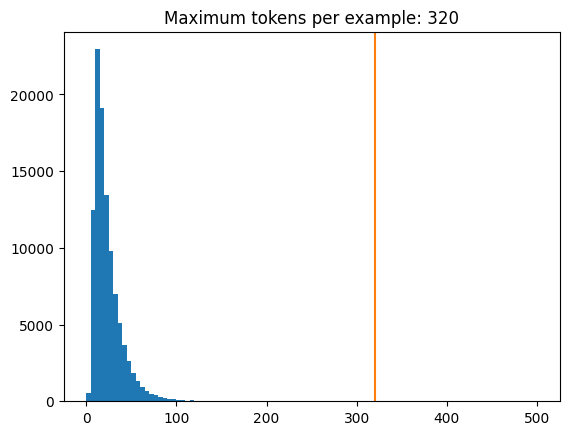

In [14]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training. 

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [15]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset 

In [18]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Protugese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

In [19]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 71)
(64, 78)
(64, 78)


The `en` and `en_labels` are the same, just shifted by 1:

In [20]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2 2894 4694   27   81   80   71  948   74  170], shape=(10,), dtype=int64)
tf.Tensor([2894 4694   27   81   80   71  948   74  170   74], shape=(10,), dtype=int64)


## Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.
2. If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic. 

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [21]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


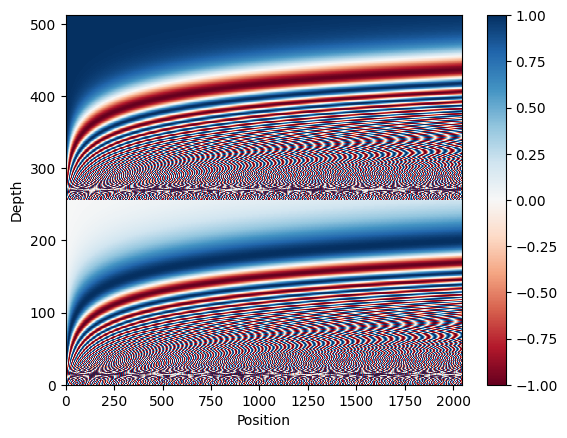

In [22]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

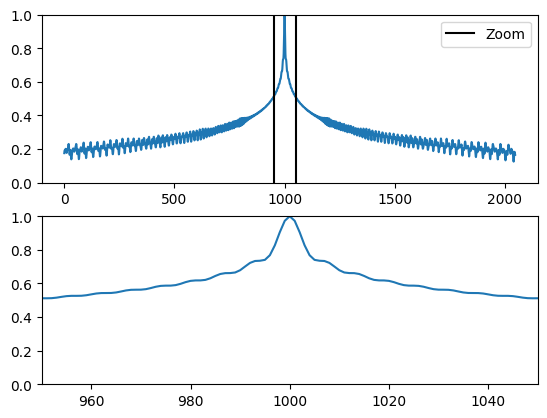

In [23]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [24]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [25]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [26]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 78), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each. 

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`. 

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [27]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


### The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [28]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the `query` sequence, but not on the length of the context `key/value` sequence.

The diagram is farther simplified, below. There's no need to draw the entire "Attention weights" matrix.
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [29]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 71, 512)
(64, 78, 512)


(64, 78, 512)


### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions. 

Before Transformers and self attention, models commonly used RNNs or CNNs to do this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. 

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer: 

In [30]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [31]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 71, 512)
(64, 71, 512)


Sticking with the same style as before you could draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity.

It's more compact, and just as accurate to draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation), and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) .

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [32]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

The causal mask ensures that each location only has access to the locations that come before it: 

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [33]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 78, 512)
(64, 78, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [34]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions. 

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [35]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


Test the layer, the output is the same shape as the input:

In [36]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 78, 512)
(64, 78, 512)


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [38]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 71, 512)


(64, 71, 512)


### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Test the encoder:

In [40]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 71)
(64, 71, 512)


### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer:

In [42]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 78, 512)
(64, 71, 512)
(64, 78, 512)


### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder:

In [44]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 78)
(64, 71, 512)
(64, 78, 512)


In [45]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 78, 71])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model`:

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [48]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test it:

In [49]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 78)
(64, 71)
(64, 78, 7010)


In [50]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 78, 71)


Print the summary of the model:

In [51]:
transformer.summary()

Model: "transformer"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 encoder_1 (Encoder)         multiple                  3632768   


 decoder_1 (Decoder)         multiple                  5647104   


 dense_38 (Dense)            multiple                  904290    


Total params: 10,184,162


Trainable params: 10,184,162


Non-trainable params: 0


_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

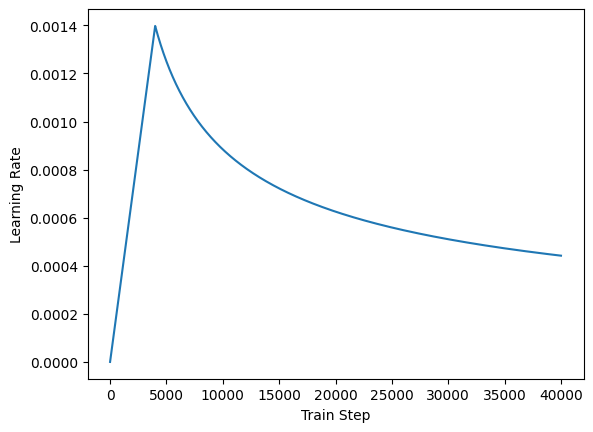

In [54]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [55]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [56]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [57]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20


  1/810 [..............................] - ETA: 2:09:09 - loss: 8.8686 - masked_accuracy: 0.0000e+00

  2/810 [..............................] - ETA: 1:37 - loss: 8.8630 - masked_accuracy: 0.0000e+00   

  3/810 [..............................] - ETA: 1:42 - loss: 8.8612 - masked_accuracy: 4.9092e-04

  4/810 [..............................] - ETA: 1:41 - loss: 8.8601 - masked_accuracy: 3.6819e-04

  5/810 [..............................] - ETA: 1:46 - loss: 8.8609 - masked_accuracy: 2.9455e-04

  6/810 [..............................] - ETA: 2:02 - loss: 8.8603 - masked_accuracy: 3.6225e-04

  7/810 [..............................] - ETA: 1:57 - loss: 8.8611 - masked_accuracy: 3.1050e-04

  8/810 [..............................] - ETA: 1:54 - loss: 8.8607 - masked_accuracy: 2.7169e-04

  9/810 [..............................] - ETA: 1:56 - loss: 8.8594 - masked_accuracy: 2.4150e-04

 10/810 [..............................] - ETA: 1:53 - loss: 8.8599 - masked_accuracy: 2.1735e-04

 11/810 [..............................] - ETA: 1:53 - loss: 8.8591 - masked_accuracy: 1.9759e-04

 12/810 [..............................] - ETA: 1:54 - loss: 8.8583 - masked_accuracy: 1.8113e-04

 13/810 [..............................] - ETA: 1:55 - loss: 8.8574 - masked_accuracy: 1.6719e-04

 14/810 [..............................] - ETA: 1:54 - loss: 8.8568 - masked_accuracy: 1.5525e-04

 15/810 [..............................] - ETA: 1:55 - loss: 8.8557 - masked_accuracy: 1.4490e-04

 16/810 [..............................] - ETA: 1:55 - loss: 8.8547 - masked_accuracy: 1.3585e-04

 17/810 [..............................] - ETA: 1:55 - loss: 8.8543 - masked_accuracy: 1.2785e-04

 18/810 [..............................] - ETA: 1:54 - loss: 8.8529 - masked_accuracy: 1.2075e-04

 19/810 [..............................] - ETA: 1:54 - loss: 8.8512 - masked_accuracy: 1.5212e-04

 20/810 [..............................] - ETA: 1:55 - loss: 8.8501 - masked_accuracy: 1.4452e-04

 21/810 [..............................] - ETA: 1:56 - loss: 8.8488 - masked_accuracy: 1.3764e-04

 22/810 [..............................] - ETA: 1:56 - loss: 8.8474 - masked_accuracy: 2.2272e-04

 23/810 [..............................] - ETA: 1:59 - loss: 8.8459 - masked_accuracy: 2.9686e-04

 24/810 [..............................] - ETA: 1:59 - loss: 8.8443 - masked_accuracy: 3.4431e-04

 25/810 [..............................] - ETA: 1:59 - loss: 8.8429 - masked_accuracy: 4.0816e-04

 26/810 [..............................] - ETA: 1:57 - loss: 8.8416 - masked_accuracy: 5.1237e-04

 27/810 [>.............................] - ETA: 1:58 - loss: 8.8401 - masked_accuracy: 5.4586e-04

 28/810 [>.............................] - ETA: 2:00 - loss: 8.8383 - masked_accuracy: 6.2135e-04

 29/810 [>.............................] - ETA: 2:00 - loss: 8.8364 - masked_accuracy: 7.5138e-04

 30/810 [>.............................] - ETA: 2:02 - loss: 8.8349 - masked_accuracy: 8.8583e-04

 31/810 [>.............................] - ETA: 2:03 - loss: 8.8331 - masked_accuracy: 0.0010    

 32/810 [>.............................] - ETA: 2:03 - loss: 8.8309 - masked_accuracy: 0.0014

 33/810 [>.............................] - ETA: 2:03 - loss: 8.8290 - masked_accuracy: 0.0016

 34/810 [>.............................] - ETA: 2:04 - loss: 8.8269 - masked_accuracy: 0.0018

 35/810 [>.............................] - ETA: 2:03 - loss: 8.8248 - masked_accuracy: 0.0021

 36/810 [>.............................] - ETA: 2:02 - loss: 8.8227 - masked_accuracy: 0.0024

 37/810 [>.............................] - ETA: 2:04 - loss: 8.8205 - masked_accuracy: 0.0026

 38/810 [>.............................] - ETA: 2:03 - loss: 8.8184 - masked_accuracy: 0.0029

 39/810 [>.............................] - ETA: 2:04 - loss: 8.8161 - masked_accuracy: 0.0032

 40/810 [>.............................] - ETA: 2:04 - loss: 8.8138 - masked_accuracy: 0.0037

 41/810 [>.............................] - ETA: 2:04 - loss: 8.8113 - masked_accuracy: 0.0041

 42/810 [>.............................] - ETA: 2:05 - loss: 8.8092 - masked_accuracy: 0.0045

 43/810 [>.............................] - ETA: 2:06 - loss: 8.8072 - masked_accuracy: 0.0050

 44/810 [>.............................] - ETA: 2:05 - loss: 8.8050 - masked_accuracy: 0.0054

 45/810 [>.............................] - ETA: 2:05 - loss: 8.8028 - masked_accuracy: 0.0059

 46/810 [>.............................] - ETA: 2:06 - loss: 8.8005 - masked_accuracy: 0.0064

 47/810 [>.............................] - ETA: 2:05 - loss: 8.7981 - masked_accuracy: 0.0069

 48/810 [>.............................] - ETA: 2:04 - loss: 8.7956 - masked_accuracy: 0.0077

 49/810 [>.............................] - ETA: 2:04 - loss: 8.7929 - masked_accuracy: 0.0082

 50/810 [>.............................] - ETA: 2:04 - loss: 8.7907 - masked_accuracy: 0.0088

 51/810 [>.............................] - ETA: 2:04 - loss: 8.7885 - masked_accuracy: 0.0094

 52/810 [>.............................] - ETA: 2:04 - loss: 8.7862 - masked_accuracy: 0.0101

 53/810 [>.............................] - ETA: 2:04 - loss: 8.7839 - masked_accuracy: 0.0108

 54/810 [=>............................] - ETA: 2:04 - loss: 8.7815 - masked_accuracy: 0.0114

 55/810 [=>............................] - ETA: 2:04 - loss: 8.7792 - masked_accuracy: 0.0121

 56/810 [=>............................] - ETA: 2:04 - loss: 8.7767 - masked_accuracy: 0.0127

 57/810 [=>............................] - ETA: 2:04 - loss: 8.7741 - masked_accuracy: 0.0135

 58/810 [=>............................] - ETA: 2:04 - loss: 8.7717 - masked_accuracy: 0.0142

 59/810 [=>............................] - ETA: 2:04 - loss: 8.7690 - masked_accuracy: 0.0149

 60/810 [=>............................] - ETA: 2:03 - loss: 8.7666 - masked_accuracy: 0.0157

 61/810 [=>............................] - ETA: 2:03 - loss: 8.7644 - masked_accuracy: 0.0163

 62/810 [=>............................] - ETA: 2:03 - loss: 8.7618 - masked_accuracy: 0.0170

 63/810 [=>............................] - ETA: 2:03 - loss: 8.7592 - masked_accuracy: 0.0178

 64/810 [=>............................] - ETA: 2:03 - loss: 8.7570 - masked_accuracy: 0.0183

 65/810 [=>............................] - ETA: 2:03 - loss: 8.7545 - masked_accuracy: 0.0188

 66/810 [=>............................] - ETA: 2:03 - loss: 8.7521 - masked_accuracy: 0.0197

 67/810 [=>............................] - ETA: 2:03 - loss: 8.7499 - masked_accuracy: 0.0202

 68/810 [=>............................] - ETA: 2:03 - loss: 8.7475 - masked_accuracy: 0.0207

 69/810 [=>............................] - ETA: 2:03 - loss: 8.7453 - masked_accuracy: 0.0213

 70/810 [=>............................] - ETA: 2:03 - loss: 8.7430 - masked_accuracy: 0.0217

 71/810 [=>............................] - ETA: 2:03 - loss: 8.7408 - masked_accuracy: 0.0222

 72/810 [=>............................] - ETA: 2:02 - loss: 8.7382 - masked_accuracy: 0.0228

 73/810 [=>............................] - ETA: 2:02 - loss: 8.7359 - masked_accuracy: 0.0232

 74/810 [=>............................] - ETA: 2:02 - loss: 8.7338 - masked_accuracy: 0.0237

 75/810 [=>............................] - ETA: 2:02 - loss: 8.7313 - masked_accuracy: 0.0242

 76/810 [=>............................] - ETA: 2:01 - loss: 8.7288 - masked_accuracy: 0.0246

 77/810 [=>............................] - ETA: 2:01 - loss: 8.7263 - masked_accuracy: 0.0249

 78/810 [=>............................] - ETA: 2:01 - loss: 8.7240 - masked_accuracy: 0.0254

 79/810 [=>............................] - ETA: 2:00 - loss: 8.7219 - masked_accuracy: 0.0258

 80/810 [=>............................] - ETA: 2:00 - loss: 8.7198 - masked_accuracy: 0.0262

 81/810 [==>...........................] - ETA: 1:59 - loss: 8.7175 - masked_accuracy: 0.0266

 82/810 [==>...........................] - ETA: 1:59 - loss: 8.7153 - masked_accuracy: 0.0270

 83/810 [==>...........................] - ETA: 2:00 - loss: 8.7129 - masked_accuracy: 0.0274

 84/810 [==>...........................] - ETA: 2:00 - loss: 8.7108 - masked_accuracy: 0.0277

 85/810 [==>...........................] - ETA: 2:00 - loss: 8.7086 - masked_accuracy: 0.0279

 86/810 [==>...........................] - ETA: 2:00 - loss: 8.7063 - masked_accuracy: 0.0283

 87/810 [==>...........................] - ETA: 1:59 - loss: 8.7042 - masked_accuracy: 0.0287

 88/810 [==>...........................] - ETA: 1:59 - loss: 8.7019 - masked_accuracy: 0.0290

 89/810 [==>...........................] - ETA: 1:59 - loss: 8.6997 - masked_accuracy: 0.0293

 90/810 [==>...........................] - ETA: 2:00 - loss: 8.6977 - masked_accuracy: 0.0297

 91/810 [==>...........................] - ETA: 1:59 - loss: 8.6955 - masked_accuracy: 0.0298

 92/810 [==>...........................] - ETA: 1:59 - loss: 8.6932 - masked_accuracy: 0.0302

 93/810 [==>...........................] - ETA: 1:58 - loss: 8.6911 - masked_accuracy: 0.0305

 94/810 [==>...........................] - ETA: 1:58 - loss: 8.6889 - masked_accuracy: 0.0308

 95/810 [==>...........................] - ETA: 1:58 - loss: 8.6866 - masked_accuracy: 0.0311

 96/810 [==>...........................] - ETA: 1:58 - loss: 8.6846 - masked_accuracy: 0.0314

 97/810 [==>...........................] - ETA: 1:59 - loss: 8.6826 - masked_accuracy: 0.0316

 98/810 [==>...........................] - ETA: 1:59 - loss: 8.6806 - masked_accuracy: 0.0318

 99/810 [==>...........................] - ETA: 1:58 - loss: 8.6783 - masked_accuracy: 0.0322

100/810 [==>...........................] - ETA: 1:58 - loss: 8.6760 - masked_accuracy: 0.0325

101/810 [==>...........................] - ETA: 1:58 - loss: 8.6736 - masked_accuracy: 0.0328

102/810 [==>...........................] - ETA: 1:58 - loss: 8.6714 - masked_accuracy: 0.0332

103/810 [==>...........................] - ETA: 1:58 - loss: 8.6692 - masked_accuracy: 0.0335

104/810 [==>...........................] - ETA: 1:58 - loss: 8.6669 - masked_accuracy: 0.0338

105/810 [==>...........................] - ETA: 1:58 - loss: 8.6646 - masked_accuracy: 0.0341

106/810 [==>...........................] - ETA: 1:57 - loss: 8.6624 - masked_accuracy: 0.0343

107/810 [==>...........................] - ETA: 1:57 - loss: 8.6600 - masked_accuracy: 0.0346

108/810 [===>..........................] - ETA: 1:57 - loss: 8.6578 - masked_accuracy: 0.0349

109/810 [===>..........................] - ETA: 1:57 - loss: 8.6556 - masked_accuracy: 0.0353

110/810 [===>..........................] - ETA: 1:57 - loss: 8.6534 - masked_accuracy: 0.0356

111/810 [===>..........................] - ETA: 1:57 - loss: 8.6511 - masked_accuracy: 0.0360

112/810 [===>..........................] - ETA: 1:56 - loss: 8.6490 - masked_accuracy: 0.0363

113/810 [===>..........................] - ETA: 1:56 - loss: 8.6467 - masked_accuracy: 0.0368

114/810 [===>..........................] - ETA: 1:56 - loss: 8.6442 - masked_accuracy: 0.0371

115/810 [===>..........................] - ETA: 1:56 - loss: 8.6419 - masked_accuracy: 0.0374

116/810 [===>..........................] - ETA: 1:55 - loss: 8.6396 - masked_accuracy: 0.0378

117/810 [===>..........................] - ETA: 1:55 - loss: 8.6372 - masked_accuracy: 0.0382

118/810 [===>..........................] - ETA: 1:55 - loss: 8.6349 - masked_accuracy: 0.0387

119/810 [===>..........................] - ETA: 1:55 - loss: 8.6326 - masked_accuracy: 0.0389

120/810 [===>..........................] - ETA: 1:54 - loss: 8.6301 - masked_accuracy: 0.0393

121/810 [===>..........................] - ETA: 1:54 - loss: 8.6277 - masked_accuracy: 0.0396

122/810 [===>..........................] - ETA: 1:54 - loss: 8.6253 - masked_accuracy: 0.0400

123/810 [===>..........................] - ETA: 1:53 - loss: 8.6228 - masked_accuracy: 0.0404

124/810 [===>..........................] - ETA: 1:53 - loss: 8.6204 - masked_accuracy: 0.0408

125/810 [===>..........................] - ETA: 1:53 - loss: 8.6180 - masked_accuracy: 0.0411

126/810 [===>..........................] - ETA: 1:53 - loss: 8.6156 - masked_accuracy: 0.0415

127/810 [===>..........................] - ETA: 1:52 - loss: 8.6131 - masked_accuracy: 0.0419

128/810 [===>..........................] - ETA: 1:52 - loss: 8.6106 - masked_accuracy: 0.0424

129/810 [===>..........................] - ETA: 1:52 - loss: 8.6080 - masked_accuracy: 0.0428

130/810 [===>..........................] - ETA: 1:52 - loss: 8.6054 - masked_accuracy: 0.0431

131/810 [===>..........................] - ETA: 1:52 - loss: 8.6028 - masked_accuracy: 0.0436

132/810 [===>..........................] - ETA: 1:52 - loss: 8.6004 - masked_accuracy: 0.0440

133/810 [===>..........................] - ETA: 1:51 - loss: 8.5978 - masked_accuracy: 0.0444

134/810 [===>..........................] - ETA: 1:51 - loss: 8.5954 - masked_accuracy: 0.0446

135/810 [====>.........................] - ETA: 1:51 - loss: 8.5928 - masked_accuracy: 0.0451

136/810 [====>.........................] - ETA: 1:51 - loss: 8.5903 - masked_accuracy: 0.0455

137/810 [====>.........................] - ETA: 1:51 - loss: 8.5876 - masked_accuracy: 0.0457

138/810 [====>.........................] - ETA: 1:51 - loss: 8.5847 - masked_accuracy: 0.0460

139/810 [====>.........................] - ETA: 1:50 - loss: 8.5821 - masked_accuracy: 0.0464

140/810 [====>.........................] - ETA: 1:50 - loss: 8.5793 - masked_accuracy: 0.0468

141/810 [====>.........................] - ETA: 1:50 - loss: 8.5767 - masked_accuracy: 0.0472

142/810 [====>.........................] - ETA: 1:50 - loss: 8.5740 - masked_accuracy: 0.0474

143/810 [====>.........................] - ETA: 1:50 - loss: 8.5714 - masked_accuracy: 0.0478

144/810 [====>.........................] - ETA: 1:50 - loss: 8.5688 - masked_accuracy: 0.0482

145/810 [====>.........................] - ETA: 1:50 - loss: 8.5662 - masked_accuracy: 0.0485

146/810 [====>.........................] - ETA: 1:49 - loss: 8.5634 - masked_accuracy: 0.0489

147/810 [====>.........................] - ETA: 1:49 - loss: 8.5608 - masked_accuracy: 0.0492

148/810 [====>.........................] - ETA: 1:49 - loss: 8.5582 - masked_accuracy: 0.0496

149/810 [====>.........................] - ETA: 1:49 - loss: 8.5556 - masked_accuracy: 0.0500

150/810 [====>.........................] - ETA: 1:48 - loss: 8.5531 - masked_accuracy: 0.0504

151/810 [====>.........................] - ETA: 1:48 - loss: 8.5504 - masked_accuracy: 0.0508

152/810 [====>.........................] - ETA: 1:48 - loss: 8.5477 - masked_accuracy: 0.0511

153/810 [====>.........................] - ETA: 1:48 - loss: 8.5450 - masked_accuracy: 0.0513

154/810 [====>.........................] - ETA: 1:48 - loss: 8.5421 - masked_accuracy: 0.0516

155/810 [====>.........................] - ETA: 1:48 - loss: 8.5394 - masked_accuracy: 0.0519

156/810 [====>.........................] - ETA: 1:48 - loss: 8.5366 - masked_accuracy: 0.0521

157/810 [====>.........................] - ETA: 1:48 - loss: 8.5339 - masked_accuracy: 0.0524

158/810 [====>.........................] - ETA: 1:48 - loss: 8.5310 - masked_accuracy: 0.0527

159/810 [====>.........................] - ETA: 1:47 - loss: 8.5283 - masked_accuracy: 0.0531

160/810 [====>.........................] - ETA: 1:47 - loss: 8.5254 - masked_accuracy: 0.0534

161/810 [====>.........................] - ETA: 1:47 - loss: 8.5226 - masked_accuracy: 0.0537

162/810 [=====>........................] - ETA: 1:47 - loss: 8.5198 - masked_accuracy: 0.0539

163/810 [=====>........................] - ETA: 1:47 - loss: 8.5169 - masked_accuracy: 0.0542

164/810 [=====>........................] - ETA: 1:47 - loss: 8.5142 - masked_accuracy: 0.0544

165/810 [=====>........................] - ETA: 1:47 - loss: 8.5115 - masked_accuracy: 0.0547

166/810 [=====>........................] - ETA: 1:47 - loss: 8.5087 - masked_accuracy: 0.0549

167/810 [=====>........................] - ETA: 1:46 - loss: 8.5056 - masked_accuracy: 0.0551

168/810 [=====>........................] - ETA: 1:46 - loss: 8.5030 - masked_accuracy: 0.0553

169/810 [=====>........................] - ETA: 1:46 - loss: 8.5000 - masked_accuracy: 0.0556

170/810 [=====>........................] - ETA: 1:46 - loss: 8.4971 - masked_accuracy: 0.0559

171/810 [=====>........................] - ETA: 1:46 - loss: 8.4942 - masked_accuracy: 0.0561

172/810 [=====>........................] - ETA: 1:46 - loss: 8.4913 - masked_accuracy: 0.0563

173/810 [=====>........................] - ETA: 1:46 - loss: 8.4884 - masked_accuracy: 0.0567

174/810 [=====>........................] - ETA: 1:46 - loss: 8.4852 - masked_accuracy: 0.0569

175/810 [=====>........................] - ETA: 1:45 - loss: 8.4823 - masked_accuracy: 0.0571

176/810 [=====>........................] - ETA: 1:45 - loss: 8.4793 - masked_accuracy: 0.0573

177/810 [=====>........................] - ETA: 1:45 - loss: 8.4763 - masked_accuracy: 0.0575

178/810 [=====>........................] - ETA: 1:44 - loss: 8.4734 - masked_accuracy: 0.0577

179/810 [=====>........................] - ETA: 1:44 - loss: 8.4703 - masked_accuracy: 0.0580

180/810 [=====>........................] - ETA: 1:44 - loss: 8.4672 - masked_accuracy: 0.0583

181/810 [=====>........................] - ETA: 1:44 - loss: 8.4645 - masked_accuracy: 0.0584

182/810 [=====>........................] - ETA: 1:44 - loss: 8.4615 - masked_accuracy: 0.0585

183/810 [=====>........................] - ETA: 1:44 - loss: 8.4583 - masked_accuracy: 0.0588

184/810 [=====>........................] - ETA: 1:44 - loss: 8.4552 - masked_accuracy: 0.0590

185/810 [=====>........................] - ETA: 1:44 - loss: 8.4521 - masked_accuracy: 0.0591

186/810 [=====>........................] - ETA: 1:43 - loss: 8.4492 - masked_accuracy: 0.0594

187/810 [=====>........................] - ETA: 1:43 - loss: 8.4462 - masked_accuracy: 0.0596

188/810 [=====>........................] - ETA: 1:43 - loss: 8.4430 - masked_accuracy: 0.0598

189/810 [======>.......................] - ETA: 1:43 - loss: 8.4398 - masked_accuracy: 0.0600

190/810 [======>.......................] - ETA: 1:43 - loss: 8.4366 - masked_accuracy: 0.0601

191/810 [======>.......................] - ETA: 1:43 - loss: 8.4334 - masked_accuracy: 0.0604

192/810 [======>.......................] - ETA: 1:43 - loss: 8.4302 - masked_accuracy: 0.0606

193/810 [======>.......................] - ETA: 1:42 - loss: 8.4268 - masked_accuracy: 0.0609

194/810 [======>.......................] - ETA: 1:42 - loss: 8.4235 - masked_accuracy: 0.0611

195/810 [======>.......................] - ETA: 1:42 - loss: 8.4202 - masked_accuracy: 0.0614

196/810 [======>.......................] - ETA: 1:42 - loss: 8.4168 - masked_accuracy: 0.0616

197/810 [======>.......................] - ETA: 1:42 - loss: 8.4134 - masked_accuracy: 0.0618

198/810 [======>.......................] - ETA: 1:41 - loss: 8.4101 - masked_accuracy: 0.0620

199/810 [======>.......................] - ETA: 1:41 - loss: 8.4070 - masked_accuracy: 0.0621

200/810 [======>.......................] - ETA: 1:41 - loss: 8.4039 - masked_accuracy: 0.0623

201/810 [======>.......................] - ETA: 1:41 - loss: 8.4007 - masked_accuracy: 0.0624

202/810 [======>.......................] - ETA: 1:41 - loss: 8.3972 - masked_accuracy: 0.0625

203/810 [======>.......................] - ETA: 1:41 - loss: 8.3939 - masked_accuracy: 0.0626

204/810 [======>.......................] - ETA: 1:41 - loss: 8.3904 - masked_accuracy: 0.0628

205/810 [======>.......................] - ETA: 1:40 - loss: 8.3872 - masked_accuracy: 0.0630

206/810 [======>.......................] - ETA: 1:40 - loss: 8.3839 - masked_accuracy: 0.0631

207/810 [======>.......................] - ETA: 1:40 - loss: 8.3803 - masked_accuracy: 0.0633

208/810 [======>.......................] - ETA: 1:40 - loss: 8.3769 - masked_accuracy: 0.0635

209/810 [======>.......................] - ETA: 1:40 - loss: 8.3734 - masked_accuracy: 0.0638

210/810 [======>.......................] - ETA: 1:40 - loss: 8.3700 - masked_accuracy: 0.0638

211/810 [======>.......................] - ETA: 1:39 - loss: 8.3667 - masked_accuracy: 0.0641

212/810 [======>.......................] - ETA: 1:39 - loss: 8.3632 - masked_accuracy: 0.0642

213/810 [======>.......................] - ETA: 1:39 - loss: 8.3599 - masked_accuracy: 0.0644

214/810 [======>.......................] - ETA: 1:39 - loss: 8.3563 - masked_accuracy: 0.0646

215/810 [======>.......................] - ETA: 1:39 - loss: 8.3529 - masked_accuracy: 0.0647

216/810 [=======>......................] - ETA: 1:38 - loss: 8.3495 - masked_accuracy: 0.0649

217/810 [=======>......................] - ETA: 1:38 - loss: 8.3459 - masked_accuracy: 0.0650

218/810 [=======>......................] - ETA: 1:38 - loss: 8.3426 - masked_accuracy: 0.0652

219/810 [=======>......................] - ETA: 1:38 - loss: 8.3392 - masked_accuracy: 0.0654

220/810 [=======>......................] - ETA: 1:38 - loss: 8.3357 - masked_accuracy: 0.0656

221/810 [=======>......................] - ETA: 1:37 - loss: 8.3322 - masked_accuracy: 0.0657

222/810 [=======>......................] - ETA: 1:37 - loss: 8.3287 - masked_accuracy: 0.0659

223/810 [=======>......................] - ETA: 1:37 - loss: 8.3252 - masked_accuracy: 0.0660

224/810 [=======>......................] - ETA: 1:37 - loss: 8.3217 - masked_accuracy: 0.0661

225/810 [=======>......................] - ETA: 1:37 - loss: 8.3181 - masked_accuracy: 0.0662

226/810 [=======>......................] - ETA: 1:37 - loss: 8.3145 - masked_accuracy: 0.0664

227/810 [=======>......................] - ETA: 1:37 - loss: 8.3109 - masked_accuracy: 0.0666

228/810 [=======>......................] - ETA: 1:37 - loss: 8.3073 - masked_accuracy: 0.0668

229/810 [=======>......................] - ETA: 1:36 - loss: 8.3037 - masked_accuracy: 0.0669

230/810 [=======>......................] - ETA: 1:36 - loss: 8.3000 - masked_accuracy: 0.0671

231/810 [=======>......................] - ETA: 1:36 - loss: 8.2962 - masked_accuracy: 0.0673

232/810 [=======>......................] - ETA: 1:36 - loss: 8.2926 - masked_accuracy: 0.0674

233/810 [=======>......................] - ETA: 1:35 - loss: 8.2888 - masked_accuracy: 0.0676

234/810 [=======>......................] - ETA: 1:35 - loss: 8.2850 - masked_accuracy: 0.0677

235/810 [=======>......................] - ETA: 1:35 - loss: 8.2811 - masked_accuracy: 0.0679

236/810 [=======>......................] - ETA: 1:35 - loss: 8.2774 - masked_accuracy: 0.0680

237/810 [=======>......................] - ETA: 1:35 - loss: 8.2738 - masked_accuracy: 0.0682

238/810 [=======>......................] - ETA: 1:35 - loss: 8.2700 - masked_accuracy: 0.0682

239/810 [=======>......................] - ETA: 1:35 - loss: 8.2663 - masked_accuracy: 0.0683

240/810 [=======>......................] - ETA: 1:34 - loss: 8.2625 - masked_accuracy: 0.0685

241/810 [=======>......................] - ETA: 1:34 - loss: 8.2587 - masked_accuracy: 0.0686

242/810 [=======>......................] - ETA: 1:34 - loss: 8.2549 - masked_accuracy: 0.0687

243/810 [========>.....................] - ETA: 1:34 - loss: 8.2513 - masked_accuracy: 0.0689

244/810 [========>.....................] - ETA: 1:34 - loss: 8.2476 - masked_accuracy: 0.0690

245/810 [========>.....................] - ETA: 1:34 - loss: 8.2439 - masked_accuracy: 0.0692

246/810 [========>.....................] - ETA: 1:34 - loss: 8.2400 - masked_accuracy: 0.0692

247/810 [========>.....................] - ETA: 1:34 - loss: 8.2363 - masked_accuracy: 0.0694

248/810 [========>.....................] - ETA: 1:33 - loss: 8.2324 - masked_accuracy: 0.0695

249/810 [========>.....................] - ETA: 1:33 - loss: 8.2285 - masked_accuracy: 0.0697

250/810 [========>.....................] - ETA: 1:33 - loss: 8.2246 - masked_accuracy: 0.0698

251/810 [========>.....................] - ETA: 1:33 - loss: 8.2209 - masked_accuracy: 0.0699

252/810 [========>.....................] - ETA: 1:33 - loss: 8.2169 - masked_accuracy: 0.0701

253/810 [========>.....................] - ETA: 1:32 - loss: 8.2132 - masked_accuracy: 0.0702

254/810 [========>.....................] - ETA: 1:32 - loss: 8.2095 - masked_accuracy: 0.0703

255/810 [========>.....................] - ETA: 1:32 - loss: 8.2058 - masked_accuracy: 0.0704

256/810 [========>.....................] - ETA: 1:32 - loss: 8.2018 - masked_accuracy: 0.0706

257/810 [========>.....................] - ETA: 1:32 - loss: 8.1980 - masked_accuracy: 0.0706

258/810 [========>.....................] - ETA: 1:32 - loss: 8.1943 - masked_accuracy: 0.0707

259/810 [========>.....................] - ETA: 1:31 - loss: 8.1906 - masked_accuracy: 0.0708

260/810 [========>.....................] - ETA: 1:31 - loss: 8.1866 - masked_accuracy: 0.0709

261/810 [========>.....................] - ETA: 1:31 - loss: 8.1830 - masked_accuracy: 0.0710

262/810 [========>.....................] - ETA: 1:31 - loss: 8.1790 - masked_accuracy: 0.0711

263/810 [========>.....................] - ETA: 1:31 - loss: 8.1751 - masked_accuracy: 0.0712

264/810 [========>.....................] - ETA: 1:31 - loss: 8.1715 - masked_accuracy: 0.0713

265/810 [========>.....................] - ETA: 1:31 - loss: 8.1676 - masked_accuracy: 0.0714

266/810 [========>.....................] - ETA: 1:31 - loss: 8.1637 - masked_accuracy: 0.0715

267/810 [========>.....................] - ETA: 1:31 - loss: 8.1600 - masked_accuracy: 0.0715

268/810 [========>.....................] - ETA: 1:30 - loss: 8.1563 - masked_accuracy: 0.0717

269/810 [========>.....................] - ETA: 1:30 - loss: 8.1524 - masked_accuracy: 0.0718

270/810 [=========>....................] - ETA: 1:30 - loss: 8.1486 - masked_accuracy: 0.0719

271/810 [=========>....................] - ETA: 1:30 - loss: 8.1447 - masked_accuracy: 0.0720

272/810 [=========>....................] - ETA: 1:29 - loss: 8.1407 - masked_accuracy: 0.0721

273/810 [=========>....................] - ETA: 1:29 - loss: 8.1369 - masked_accuracy: 0.0722

274/810 [=========>....................] - ETA: 1:29 - loss: 8.1333 - masked_accuracy: 0.0722

275/810 [=========>....................] - ETA: 1:29 - loss: 8.1294 - masked_accuracy: 0.0723

276/810 [=========>....................] - ETA: 1:29 - loss: 8.1255 - masked_accuracy: 0.0724

277/810 [=========>....................] - ETA: 1:29 - loss: 8.1214 - masked_accuracy: 0.0725

278/810 [=========>....................] - ETA: 1:29 - loss: 8.1176 - masked_accuracy: 0.0725

279/810 [=========>....................] - ETA: 1:28 - loss: 8.1136 - masked_accuracy: 0.0727

280/810 [=========>....................] - ETA: 1:28 - loss: 8.1097 - masked_accuracy: 0.0727

281/810 [=========>....................] - ETA: 1:28 - loss: 8.1057 - masked_accuracy: 0.0728

282/810 [=========>....................] - ETA: 1:28 - loss: 8.1017 - masked_accuracy: 0.0729

283/810 [=========>....................] - ETA: 1:28 - loss: 8.0978 - masked_accuracy: 0.0730

284/810 [=========>....................] - ETA: 1:28 - loss: 8.0937 - masked_accuracy: 0.0731

285/810 [=========>....................] - ETA: 1:28 - loss: 8.0895 - masked_accuracy: 0.0732

286/810 [=========>....................] - ETA: 1:28 - loss: 8.0857 - masked_accuracy: 0.0733

287/810 [=========>....................] - ETA: 1:27 - loss: 8.0819 - masked_accuracy: 0.0734

288/810 [=========>....................] - ETA: 1:27 - loss: 8.0779 - masked_accuracy: 0.0736

289/810 [=========>....................] - ETA: 1:27 - loss: 8.0738 - masked_accuracy: 0.0737

290/810 [=========>....................] - ETA: 1:27 - loss: 8.0701 - masked_accuracy: 0.0738

291/810 [=========>....................] - ETA: 1:27 - loss: 8.0664 - masked_accuracy: 0.0739

292/810 [=========>....................] - ETA: 1:26 - loss: 8.0623 - masked_accuracy: 0.0740

293/810 [=========>....................] - ETA: 1:26 - loss: 8.0583 - masked_accuracy: 0.0741

294/810 [=========>....................] - ETA: 1:26 - loss: 8.0544 - masked_accuracy: 0.0742

295/810 [=========>....................] - ETA: 1:26 - loss: 8.0506 - masked_accuracy: 0.0743

296/810 [=========>....................] - ETA: 1:26 - loss: 8.0465 - masked_accuracy: 0.0744

297/810 [==========>...................] - ETA: 1:26 - loss: 8.0427 - masked_accuracy: 0.0745

298/810 [==========>...................] - ETA: 1:26 - loss: 8.0387 - masked_accuracy: 0.0746

299/810 [==========>...................] - ETA: 1:25 - loss: 8.0347 - masked_accuracy: 0.0747

300/810 [==========>...................] - ETA: 1:25 - loss: 8.0308 - masked_accuracy: 0.0748

301/810 [==========>...................] - ETA: 1:25 - loss: 8.0268 - masked_accuracy: 0.0748

302/810 [==========>...................] - ETA: 1:25 - loss: 8.0228 - masked_accuracy: 0.0749

303/810 [==========>...................] - ETA: 1:25 - loss: 8.0187 - masked_accuracy: 0.0750

304/810 [==========>...................] - ETA: 1:25 - loss: 8.0146 - masked_accuracy: 0.0751

305/810 [==========>...................] - ETA: 1:24 - loss: 8.0104 - masked_accuracy: 0.0751

306/810 [==========>...................] - ETA: 1:24 - loss: 8.0065 - masked_accuracy: 0.0752

307/810 [==========>...................] - ETA: 1:24 - loss: 8.0024 - masked_accuracy: 0.0753

308/810 [==========>...................] - ETA: 1:24 - loss: 7.9985 - masked_accuracy: 0.0754

309/810 [==========>...................] - ETA: 1:24 - loss: 7.9949 - masked_accuracy: 0.0754

310/810 [==========>...................] - ETA: 1:24 - loss: 7.9911 - masked_accuracy: 0.0755

311/810 [==========>...................] - ETA: 1:23 - loss: 7.9873 - masked_accuracy: 0.0756

312/810 [==========>...................] - ETA: 1:23 - loss: 7.9833 - masked_accuracy: 0.0758

313/810 [==========>...................] - ETA: 1:23 - loss: 7.9792 - masked_accuracy: 0.0759

314/810 [==========>...................] - ETA: 1:23 - loss: 7.9752 - masked_accuracy: 0.0760

315/810 [==========>...................] - ETA: 1:23 - loss: 7.9710 - masked_accuracy: 0.0762

316/810 [==========>...................] - ETA: 1:22 - loss: 7.9670 - masked_accuracy: 0.0762

317/810 [==========>...................] - ETA: 1:22 - loss: 7.9630 - masked_accuracy: 0.0763

318/810 [==========>...................] - ETA: 1:22 - loss: 7.9586 - masked_accuracy: 0.0765

319/810 [==========>...................] - ETA: 1:22 - loss: 7.9546 - masked_accuracy: 0.0766

320/810 [==========>...................] - ETA: 1:22 - loss: 7.9504 - masked_accuracy: 0.0767

321/810 [==========>...................] - ETA: 1:22 - loss: 7.9466 - masked_accuracy: 0.0767

322/810 [==========>...................] - ETA: 1:22 - loss: 7.9428 - masked_accuracy: 0.0768

323/810 [==========>...................] - ETA: 1:21 - loss: 7.9389 - masked_accuracy: 0.0769

324/810 [===========>..................] - ETA: 1:21 - loss: 7.9350 - masked_accuracy: 0.0769

325/810 [===========>..................] - ETA: 1:21 - loss: 7.9309 - masked_accuracy: 0.0771

326/810 [===========>..................] - ETA: 1:21 - loss: 7.9268 - masked_accuracy: 0.0771

327/810 [===========>..................] - ETA: 1:21 - loss: 7.9227 - masked_accuracy: 0.0772

328/810 [===========>..................] - ETA: 1:20 - loss: 7.9184 - masked_accuracy: 0.0773

329/810 [===========>..................] - ETA: 1:20 - loss: 7.9147 - masked_accuracy: 0.0775

330/810 [===========>..................] - ETA: 1:20 - loss: 7.9106 - masked_accuracy: 0.0776

331/810 [===========>..................] - ETA: 1:20 - loss: 7.9068 - masked_accuracy: 0.0776

332/810 [===========>..................] - ETA: 1:20 - loss: 7.9030 - masked_accuracy: 0.0778

333/810 [===========>..................] - ETA: 1:19 - loss: 7.8987 - masked_accuracy: 0.0779

334/810 [===========>..................] - ETA: 1:19 - loss: 7.8948 - masked_accuracy: 0.0779

335/810 [===========>..................] - ETA: 1:19 - loss: 7.8908 - masked_accuracy: 0.0780

336/810 [===========>..................] - ETA: 1:19 - loss: 7.8867 - masked_accuracy: 0.0781

337/810 [===========>..................] - ETA: 1:19 - loss: 7.8824 - masked_accuracy: 0.0782

338/810 [===========>..................] - ETA: 1:19 - loss: 7.8785 - masked_accuracy: 0.0783

339/810 [===========>..................] - ETA: 1:18 - loss: 7.8745 - masked_accuracy: 0.0784

340/810 [===========>..................] - ETA: 1:18 - loss: 7.8709 - masked_accuracy: 0.0785

341/810 [===========>..................] - ETA: 1:18 - loss: 7.8671 - masked_accuracy: 0.0786

342/810 [===========>..................] - ETA: 1:18 - loss: 7.8630 - masked_accuracy: 0.0786

343/810 [===========>..................] - ETA: 1:18 - loss: 7.8592 - masked_accuracy: 0.0788

344/810 [===========>..................] - ETA: 1:18 - loss: 7.8555 - masked_accuracy: 0.0789

345/810 [===========>..................] - ETA: 1:18 - loss: 7.8513 - masked_accuracy: 0.0790

346/810 [===========>..................] - ETA: 1:17 - loss: 7.8475 - masked_accuracy: 0.0791

347/810 [===========>..................] - ETA: 1:17 - loss: 7.8437 - masked_accuracy: 0.0791

348/810 [===========>..................] - ETA: 1:17 - loss: 7.8401 - masked_accuracy: 0.0792

349/810 [===========>..................] - ETA: 1:17 - loss: 7.8360 - masked_accuracy: 0.0793

350/810 [===========>..................] - ETA: 1:17 - loss: 7.8321 - masked_accuracy: 0.0794

351/810 [============>.................] - ETA: 1:16 - loss: 7.8278 - masked_accuracy: 0.0796

352/810 [============>.................] - ETA: 1:16 - loss: 7.8240 - masked_accuracy: 0.0796

353/810 [============>.................] - ETA: 1:16 - loss: 7.8203 - masked_accuracy: 0.0797

354/810 [============>.................] - ETA: 1:16 - loss: 7.8165 - masked_accuracy: 0.0798

355/810 [============>.................] - ETA: 1:16 - loss: 7.8127 - masked_accuracy: 0.0799

356/810 [============>.................] - ETA: 1:16 - loss: 7.8087 - masked_accuracy: 0.0800

357/810 [============>.................] - ETA: 1:15 - loss: 7.8049 - masked_accuracy: 0.0801

358/810 [============>.................] - ETA: 1:15 - loss: 7.8011 - masked_accuracy: 0.0802

359/810 [============>.................] - ETA: 1:15 - loss: 7.7972 - masked_accuracy: 0.0803

360/810 [============>.................] - ETA: 1:15 - loss: 7.7932 - masked_accuracy: 0.0804

361/810 [============>.................] - ETA: 1:15 - loss: 7.7892 - masked_accuracy: 0.0806

362/810 [============>.................] - ETA: 1:15 - loss: 7.7854 - masked_accuracy: 0.0807

363/810 [============>.................] - ETA: 1:14 - loss: 7.7819 - masked_accuracy: 0.0808

364/810 [============>.................] - ETA: 1:14 - loss: 7.7781 - masked_accuracy: 0.0809

365/810 [============>.................] - ETA: 1:14 - loss: 7.7742 - masked_accuracy: 0.0809

366/810 [============>.................] - ETA: 1:14 - loss: 7.7705 - masked_accuracy: 0.0810

367/810 [============>.................] - ETA: 1:14 - loss: 7.7665 - masked_accuracy: 0.0811

368/810 [============>.................] - ETA: 1:13 - loss: 7.7629 - masked_accuracy: 0.0811

369/810 [============>.................] - ETA: 1:13 - loss: 7.7586 - masked_accuracy: 0.0812

370/810 [============>.................] - ETA: 1:13 - loss: 7.7547 - masked_accuracy: 0.0813

371/810 [============>.................] - ETA: 1:13 - loss: 7.7509 - masked_accuracy: 0.0814

372/810 [============>.................] - ETA: 1:13 - loss: 7.7469 - masked_accuracy: 0.0815

373/810 [============>.................] - ETA: 1:12 - loss: 7.7433 - masked_accuracy: 0.0817

374/810 [============>.................] - ETA: 1:12 - loss: 7.7398 - masked_accuracy: 0.0818

375/810 [============>.................] - ETA: 1:12 - loss: 7.7361 - masked_accuracy: 0.0819

376/810 [============>.................] - ETA: 1:12 - loss: 7.7321 - masked_accuracy: 0.0819

377/810 [============>.................] - ETA: 1:12 - loss: 7.7286 - masked_accuracy: 0.0820

378/810 [=============>................] - ETA: 1:12 - loss: 7.7248 - masked_accuracy: 0.0821

379/810 [=============>................] - ETA: 1:11 - loss: 7.7210 - masked_accuracy: 0.0822

380/810 [=============>................] - ETA: 1:11 - loss: 7.7173 - masked_accuracy: 0.0823

381/810 [=============>................] - ETA: 1:11 - loss: 7.7138 - masked_accuracy: 0.0824

382/810 [=============>................] - ETA: 1:11 - loss: 7.7099 - masked_accuracy: 0.0825

383/810 [=============>................] - ETA: 1:11 - loss: 7.7058 - masked_accuracy: 0.0827

384/810 [=============>................] - ETA: 1:11 - loss: 7.7023 - masked_accuracy: 0.0827

385/810 [=============>................] - ETA: 1:10 - loss: 7.6987 - masked_accuracy: 0.0828

386/810 [=============>................] - ETA: 1:10 - loss: 7.6947 - masked_accuracy: 0.0829

387/810 [=============>................] - ETA: 1:10 - loss: 7.6911 - masked_accuracy: 0.0831

388/810 [=============>................] - ETA: 1:10 - loss: 7.6874 - masked_accuracy: 0.0832

389/810 [=============>................] - ETA: 1:10 - loss: 7.6838 - masked_accuracy: 0.0832

390/810 [=============>................] - ETA: 1:10 - loss: 7.6803 - masked_accuracy: 0.0834

391/810 [=============>................] - ETA: 1:10 - loss: 7.6766 - masked_accuracy: 0.0834

392/810 [=============>................] - ETA: 1:09 - loss: 7.6730 - masked_accuracy: 0.0836

393/810 [=============>................] - ETA: 1:09 - loss: 7.6695 - masked_accuracy: 0.0837

394/810 [=============>................] - ETA: 1:09 - loss: 7.6659 - masked_accuracy: 0.0838

395/810 [=============>................] - ETA: 1:09 - loss: 7.6620 - masked_accuracy: 0.0839

396/810 [=============>................] - ETA: 1:09 - loss: 7.6584 - masked_accuracy: 0.0841

397/810 [=============>................] - ETA: 1:09 - loss: 7.6550 - masked_accuracy: 0.0842

398/810 [=============>................] - ETA: 1:08 - loss: 7.6513 - masked_accuracy: 0.0843

399/810 [=============>................] - ETA: 1:08 - loss: 7.6477 - masked_accuracy: 0.0844

400/810 [=============>................] - ETA: 1:08 - loss: 7.6442 - masked_accuracy: 0.0845

401/810 [=============>................] - ETA: 1:08 - loss: 7.6407 - masked_accuracy: 0.0846

402/810 [=============>................] - ETA: 1:08 - loss: 7.6371 - masked_accuracy: 0.0847

403/810 [=============>................] - ETA: 1:07 - loss: 7.6336 - masked_accuracy: 0.0848

404/810 [=============>................] - ETA: 1:07 - loss: 7.6298 - masked_accuracy: 0.0849

405/810 [==============>...............] - ETA: 1:07 - loss: 7.6261 - masked_accuracy: 0.0851

406/810 [==============>...............] - ETA: 1:07 - loss: 7.6224 - masked_accuracy: 0.0852

407/810 [==============>...............] - ETA: 1:07 - loss: 7.6188 - masked_accuracy: 0.0853

408/810 [==============>...............] - ETA: 1:07 - loss: 7.6153 - masked_accuracy: 0.0854

409/810 [==============>...............] - ETA: 1:07 - loss: 7.6118 - masked_accuracy: 0.0856

410/810 [==============>...............] - ETA: 1:07 - loss: 7.6083 - masked_accuracy: 0.0857

411/810 [==============>...............] - ETA: 1:06 - loss: 7.6050 - masked_accuracy: 0.0858

412/810 [==============>...............] - ETA: 1:06 - loss: 7.6016 - masked_accuracy: 0.0859

413/810 [==============>...............] - ETA: 1:06 - loss: 7.5979 - masked_accuracy: 0.0860

414/810 [==============>...............] - ETA: 1:06 - loss: 7.5940 - masked_accuracy: 0.0861

415/810 [==============>...............] - ETA: 1:06 - loss: 7.5906 - masked_accuracy: 0.0862

416/810 [==============>...............] - ETA: 1:06 - loss: 7.5872 - masked_accuracy: 0.0863

417/810 [==============>...............] - ETA: 1:06 - loss: 7.5839 - masked_accuracy: 0.0864

418/810 [==============>...............] - ETA: 1:05 - loss: 7.5804 - masked_accuracy: 0.0865

419/810 [==============>...............] - ETA: 1:05 - loss: 7.5768 - masked_accuracy: 0.0867

420/810 [==============>...............] - ETA: 1:05 - loss: 7.5735 - masked_accuracy: 0.0868

421/810 [==============>...............] - ETA: 1:05 - loss: 7.5699 - masked_accuracy: 0.0869

422/810 [==============>...............] - ETA: 1:05 - loss: 7.5663 - masked_accuracy: 0.0870

423/810 [==============>...............] - ETA: 1:05 - loss: 7.5629 - masked_accuracy: 0.0872

424/810 [==============>...............] - ETA: 1:04 - loss: 7.5591 - masked_accuracy: 0.0873

425/810 [==============>...............] - ETA: 1:04 - loss: 7.5557 - masked_accuracy: 0.0874

426/810 [==============>...............] - ETA: 1:04 - loss: 7.5523 - masked_accuracy: 0.0876

427/810 [==============>...............] - ETA: 1:04 - loss: 7.5490 - masked_accuracy: 0.0877

428/810 [==============>...............] - ETA: 1:04 - loss: 7.5458 - masked_accuracy: 0.0878

429/810 [==============>...............] - ETA: 1:04 - loss: 7.5425 - masked_accuracy: 0.0879

430/810 [==============>...............] - ETA: 1:03 - loss: 7.5391 - masked_accuracy: 0.0881

431/810 [==============>...............] - ETA: 1:03 - loss: 7.5357 - masked_accuracy: 0.0882

432/810 [===============>..............] - ETA: 1:03 - loss: 7.5323 - masked_accuracy: 0.0883

433/810 [===============>..............] - ETA: 1:03 - loss: 7.5292 - masked_accuracy: 0.0884

434/810 [===============>..............] - ETA: 1:03 - loss: 7.5258 - masked_accuracy: 0.0886

435/810 [===============>..............] - ETA: 1:03 - loss: 7.5220 - masked_accuracy: 0.0888

436/810 [===============>..............] - ETA: 1:02 - loss: 7.5186 - masked_accuracy: 0.0889

437/810 [===============>..............] - ETA: 1:02 - loss: 7.5155 - masked_accuracy: 0.0890

438/810 [===============>..............] - ETA: 1:02 - loss: 7.5120 - masked_accuracy: 0.0892

439/810 [===============>..............] - ETA: 1:02 - loss: 7.5085 - masked_accuracy: 0.0894

440/810 [===============>..............] - ETA: 1:02 - loss: 7.5055 - masked_accuracy: 0.0895

441/810 [===============>..............] - ETA: 1:01 - loss: 7.5026 - masked_accuracy: 0.0896

442/810 [===============>..............] - ETA: 1:01 - loss: 7.4997 - masked_accuracy: 0.0897

443/810 [===============>..............] - ETA: 1:01 - loss: 7.4962 - masked_accuracy: 0.0899

444/810 [===============>..............] - ETA: 1:01 - loss: 7.4930 - masked_accuracy: 0.0901

445/810 [===============>..............] - ETA: 1:01 - loss: 7.4899 - masked_accuracy: 0.0902

446/810 [===============>..............] - ETA: 1:01 - loss: 7.4869 - masked_accuracy: 0.0903

447/810 [===============>..............] - ETA: 1:00 - loss: 7.4838 - masked_accuracy: 0.0905

448/810 [===============>..............] - ETA: 1:00 - loss: 7.4805 - masked_accuracy: 0.0906

449/810 [===============>..............] - ETA: 1:00 - loss: 7.4775 - masked_accuracy: 0.0907

450/810 [===============>..............] - ETA: 1:00 - loss: 7.4741 - masked_accuracy: 0.0909

451/810 [===============>..............] - ETA: 1:00 - loss: 7.4710 - masked_accuracy: 0.0910

452/810 [===============>..............] - ETA: 59s - loss: 7.4680 - masked_accuracy: 0.0912 

453/810 [===============>..............] - ETA: 59s - loss: 7.4649 - masked_accuracy: 0.0913

454/810 [===============>..............] - ETA: 59s - loss: 7.4619 - masked_accuracy: 0.0914

455/810 [===============>..............] - ETA: 59s - loss: 7.4586 - masked_accuracy: 0.0916

456/810 [===============>..............] - ETA: 59s - loss: 7.4552 - masked_accuracy: 0.0917

457/810 [===============>..............] - ETA: 58s - loss: 7.4519 - masked_accuracy: 0.0919

458/810 [===============>..............] - ETA: 58s - loss: 7.4489 - masked_accuracy: 0.0920

459/810 [================>.............] - ETA: 58s - loss: 7.4461 - masked_accuracy: 0.0921

460/810 [================>.............] - ETA: 58s - loss: 7.4432 - masked_accuracy: 0.0923

461/810 [================>.............] - ETA: 58s - loss: 7.4402 - masked_accuracy: 0.0924

462/810 [================>.............] - ETA: 58s - loss: 7.4370 - masked_accuracy: 0.0926

463/810 [================>.............] - ETA: 58s - loss: 7.4339 - masked_accuracy: 0.0927

464/810 [================>.............] - ETA: 57s - loss: 7.4309 - masked_accuracy: 0.0928

465/810 [================>.............] - ETA: 57s - loss: 7.4277 - masked_accuracy: 0.0930

466/810 [================>.............] - ETA: 57s - loss: 7.4243 - masked_accuracy: 0.0932

467/810 [================>.............] - ETA: 57s - loss: 7.4211 - masked_accuracy: 0.0934

468/810 [================>.............] - ETA: 57s - loss: 7.4178 - masked_accuracy: 0.0936

469/810 [================>.............] - ETA: 56s - loss: 7.4144 - masked_accuracy: 0.0938

470/810 [================>.............] - ETA: 56s - loss: 7.4115 - masked_accuracy: 0.0939

471/810 [================>.............] - ETA: 56s - loss: 7.4085 - masked_accuracy: 0.0941

472/810 [================>.............] - ETA: 56s - loss: 7.4055 - masked_accuracy: 0.0942

473/810 [================>.............] - ETA: 56s - loss: 7.4024 - masked_accuracy: 0.0943

474/810 [================>.............] - ETA: 56s - loss: 7.3994 - masked_accuracy: 0.0945

475/810 [================>.............] - ETA: 55s - loss: 7.3967 - masked_accuracy: 0.0946

476/810 [================>.............] - ETA: 55s - loss: 7.3935 - masked_accuracy: 0.0948

477/810 [================>.............] - ETA: 55s - loss: 7.3904 - masked_accuracy: 0.0949

478/810 [================>.............] - ETA: 55s - loss: 7.3872 - masked_accuracy: 0.0951

479/810 [================>.............] - ETA: 55s - loss: 7.3840 - masked_accuracy: 0.0953

480/810 [================>.............] - ETA: 55s - loss: 7.3809 - masked_accuracy: 0.0954

481/810 [================>.............] - ETA: 55s - loss: 7.3775 - masked_accuracy: 0.0956

482/810 [================>.............] - ETA: 54s - loss: 7.3748 - masked_accuracy: 0.0957

483/810 [================>.............] - ETA: 54s - loss: 7.3716 - masked_accuracy: 0.0959

484/810 [================>.............] - ETA: 54s - loss: 7.3688 - masked_accuracy: 0.0960

485/810 [================>.............] - ETA: 54s - loss: 7.3659 - masked_accuracy: 0.0962

486/810 [=================>............] - ETA: 54s - loss: 7.3629 - masked_accuracy: 0.0963

487/810 [=================>............] - ETA: 53s - loss: 7.3601 - masked_accuracy: 0.0965

488/810 [=================>............] - ETA: 53s - loss: 7.3570 - masked_accuracy: 0.0966

489/810 [=================>............] - ETA: 53s - loss: 7.3541 - masked_accuracy: 0.0968

490/810 [=================>............] - ETA: 53s - loss: 7.3512 - masked_accuracy: 0.0969

491/810 [=================>............] - ETA: 53s - loss: 7.3484 - masked_accuracy: 0.0971

492/810 [=================>............] - ETA: 53s - loss: 7.3455 - masked_accuracy: 0.0972

493/810 [=================>............] - ETA: 53s - loss: 7.3425 - masked_accuracy: 0.0974

494/810 [=================>............] - ETA: 52s - loss: 7.3395 - masked_accuracy: 0.0975

495/810 [=================>............] - ETA: 52s - loss: 7.3366 - masked_accuracy: 0.0977

496/810 [=================>............] - ETA: 52s - loss: 7.3335 - masked_accuracy: 0.0979

497/810 [=================>............] - ETA: 52s - loss: 7.3306 - masked_accuracy: 0.0981

498/810 [=================>............] - ETA: 52s - loss: 7.3273 - masked_accuracy: 0.0983

499/810 [=================>............] - ETA: 51s - loss: 7.3244 - masked_accuracy: 0.0984

500/810 [=================>............] - ETA: 51s - loss: 7.3216 - masked_accuracy: 0.0986

501/810 [=================>............] - ETA: 51s - loss: 7.3185 - masked_accuracy: 0.0987

502/810 [=================>............] - ETA: 51s - loss: 7.3157 - masked_accuracy: 0.0989

503/810 [=================>............] - ETA: 51s - loss: 7.3125 - masked_accuracy: 0.0991

504/810 [=================>............] - ETA: 51s - loss: 7.3097 - masked_accuracy: 0.0992

505/810 [=================>............] - ETA: 50s - loss: 7.3068 - masked_accuracy: 0.0994

506/810 [=================>............] - ETA: 50s - loss: 7.3041 - masked_accuracy: 0.0996

507/810 [=================>............] - ETA: 50s - loss: 7.3013 - masked_accuracy: 0.0997

508/810 [=================>............] - ETA: 50s - loss: 7.2984 - masked_accuracy: 0.0998

509/810 [=================>............] - ETA: 50s - loss: 7.2954 - masked_accuracy: 0.1000

510/810 [=================>............] - ETA: 50s - loss: 7.2927 - masked_accuracy: 0.1001

511/810 [=================>............] - ETA: 49s - loss: 7.2899 - masked_accuracy: 0.1003

512/810 [=================>............] - ETA: 49s - loss: 7.2871 - masked_accuracy: 0.1004

513/810 [==================>...........] - ETA: 49s - loss: 7.2842 - masked_accuracy: 0.1006

514/810 [==================>...........] - ETA: 49s - loss: 7.2815 - masked_accuracy: 0.1007

515/810 [==================>...........] - ETA: 49s - loss: 7.2787 - masked_accuracy: 0.1009

516/810 [==================>...........] - ETA: 49s - loss: 7.2758 - masked_accuracy: 0.1010

517/810 [==================>...........] - ETA: 48s - loss: 7.2730 - masked_accuracy: 0.1012

518/810 [==================>...........] - ETA: 48s - loss: 7.2702 - masked_accuracy: 0.1013

519/810 [==================>...........] - ETA: 48s - loss: 7.2675 - masked_accuracy: 0.1014

520/810 [==================>...........] - ETA: 48s - loss: 7.2647 - masked_accuracy: 0.1016

521/810 [==================>...........] - ETA: 48s - loss: 7.2619 - masked_accuracy: 0.1017

522/810 [==================>...........] - ETA: 48s - loss: 7.2590 - masked_accuracy: 0.1019

523/810 [==================>...........] - ETA: 48s - loss: 7.2564 - masked_accuracy: 0.1020

524/810 [==================>...........] - ETA: 47s - loss: 7.2535 - masked_accuracy: 0.1022

525/810 [==================>...........] - ETA: 47s - loss: 7.2506 - masked_accuracy: 0.1023

526/810 [==================>...........] - ETA: 47s - loss: 7.2479 - masked_accuracy: 0.1025

527/810 [==================>...........] - ETA: 47s - loss: 7.2450 - masked_accuracy: 0.1026

528/810 [==================>...........] - ETA: 47s - loss: 7.2422 - masked_accuracy: 0.1028

529/810 [==================>...........] - ETA: 47s - loss: 7.2396 - masked_accuracy: 0.1029

530/810 [==================>...........] - ETA: 46s - loss: 7.2367 - masked_accuracy: 0.1031

531/810 [==================>...........] - ETA: 46s - loss: 7.2340 - masked_accuracy: 0.1033

532/810 [==================>...........] - ETA: 46s - loss: 7.2311 - masked_accuracy: 0.1034

533/810 [==================>...........] - ETA: 46s - loss: 7.2287 - masked_accuracy: 0.1035

534/810 [==================>...........] - ETA: 46s - loss: 7.2263 - masked_accuracy: 0.1036

535/810 [==================>...........] - ETA: 46s - loss: 7.2235 - masked_accuracy: 0.1038

536/810 [==================>...........] - ETA: 45s - loss: 7.2206 - masked_accuracy: 0.1040

537/810 [==================>...........] - ETA: 45s - loss: 7.2182 - masked_accuracy: 0.1041

538/810 [==================>...........] - ETA: 45s - loss: 7.2158 - masked_accuracy: 0.1042

539/810 [==================>...........] - ETA: 45s - loss: 7.2132 - masked_accuracy: 0.1043

540/810 [===================>..........] - ETA: 45s - loss: 7.2106 - masked_accuracy: 0.1044

541/810 [===================>..........] - ETA: 45s - loss: 7.2075 - masked_accuracy: 0.1046

542/810 [===================>..........] - ETA: 44s - loss: 7.2052 - masked_accuracy: 0.1047

543/810 [===================>..........] - ETA: 44s - loss: 7.2025 - masked_accuracy: 0.1049

544/810 [===================>..........] - ETA: 44s - loss: 7.1998 - masked_accuracy: 0.1050

545/810 [===================>..........] - ETA: 44s - loss: 7.1970 - masked_accuracy: 0.1052

546/810 [===================>..........] - ETA: 44s - loss: 7.1942 - masked_accuracy: 0.1053

547/810 [===================>..........] - ETA: 44s - loss: 7.1915 - masked_accuracy: 0.1055

548/810 [===================>..........] - ETA: 44s - loss: 7.1889 - masked_accuracy: 0.1056

549/810 [===================>..........] - ETA: 43s - loss: 7.1865 - masked_accuracy: 0.1057

550/810 [===================>..........] - ETA: 43s - loss: 7.1837 - masked_accuracy: 0.1059

551/810 [===================>..........] - ETA: 43s - loss: 7.1809 - masked_accuracy: 0.1060

552/810 [===================>..........] - ETA: 43s - loss: 7.1781 - masked_accuracy: 0.1062

553/810 [===================>..........] - ETA: 43s - loss: 7.1755 - masked_accuracy: 0.1064

554/810 [===================>..........] - ETA: 42s - loss: 7.1731 - masked_accuracy: 0.1065

555/810 [===================>..........] - ETA: 42s - loss: 7.1704 - masked_accuracy: 0.1067

556/810 [===================>..........] - ETA: 42s - loss: 7.1678 - masked_accuracy: 0.1068

557/810 [===================>..........] - ETA: 42s - loss: 7.1651 - masked_accuracy: 0.1069

558/810 [===================>..........] - ETA: 42s - loss: 7.1625 - masked_accuracy: 0.1071

559/810 [===================>..........] - ETA: 42s - loss: 7.1600 - masked_accuracy: 0.1072

560/810 [===================>..........] - ETA: 41s - loss: 7.1575 - masked_accuracy: 0.1073

561/810 [===================>..........] - ETA: 41s - loss: 7.1547 - masked_accuracy: 0.1075

562/810 [===================>..........] - ETA: 41s - loss: 7.1519 - masked_accuracy: 0.1076

563/810 [===================>..........] - ETA: 41s - loss: 7.1496 - masked_accuracy: 0.1077

564/810 [===================>..........] - ETA: 41s - loss: 7.1469 - masked_accuracy: 0.1079

565/810 [===================>..........] - ETA: 41s - loss: 7.1441 - masked_accuracy: 0.1080

566/810 [===================>..........] - ETA: 41s - loss: 7.1415 - masked_accuracy: 0.1082

567/810 [====================>.........] - ETA: 40s - loss: 7.1386 - masked_accuracy: 0.1083

568/810 [====================>.........] - ETA: 40s - loss: 7.1359 - masked_accuracy: 0.1084

569/810 [====================>.........] - ETA: 40s - loss: 7.1332 - masked_accuracy: 0.1086

570/810 [====================>.........] - ETA: 40s - loss: 7.1304 - masked_accuracy: 0.1087

571/810 [====================>.........] - ETA: 40s - loss: 7.1277 - masked_accuracy: 0.1089

572/810 [====================>.........] - ETA: 40s - loss: 7.1255 - masked_accuracy: 0.1090

573/810 [====================>.........] - ETA: 39s - loss: 7.1229 - masked_accuracy: 0.1091

574/810 [====================>.........] - ETA: 39s - loss: 7.1206 - masked_accuracy: 0.1092

575/810 [====================>.........] - ETA: 39s - loss: 7.1179 - masked_accuracy: 0.1094

576/810 [====================>.........] - ETA: 39s - loss: 7.1152 - masked_accuracy: 0.1095

577/810 [====================>.........] - ETA: 39s - loss: 7.1127 - masked_accuracy: 0.1097

578/810 [====================>.........] - ETA: 39s - loss: 7.1103 - masked_accuracy: 0.1098

579/810 [====================>.........] - ETA: 38s - loss: 7.1076 - masked_accuracy: 0.1099

580/810 [====================>.........] - ETA: 38s - loss: 7.1049 - masked_accuracy: 0.1101

581/810 [====================>.........] - ETA: 38s - loss: 7.1023 - masked_accuracy: 0.1102

582/810 [====================>.........] - ETA: 38s - loss: 7.0998 - masked_accuracy: 0.1103

583/810 [====================>.........] - ETA: 38s - loss: 7.0969 - masked_accuracy: 0.1105

584/810 [====================>.........] - ETA: 38s - loss: 7.0943 - masked_accuracy: 0.1106

585/810 [====================>.........] - ETA: 37s - loss: 7.0915 - masked_accuracy: 0.1108

586/810 [====================>.........] - ETA: 37s - loss: 7.0890 - masked_accuracy: 0.1109

587/810 [====================>.........] - ETA: 37s - loss: 7.0865 - masked_accuracy: 0.1110

588/810 [====================>.........] - ETA: 37s - loss: 7.0841 - masked_accuracy: 0.1112

589/810 [====================>.........] - ETA: 37s - loss: 7.0814 - masked_accuracy: 0.1113

590/810 [====================>.........] - ETA: 37s - loss: 7.0790 - masked_accuracy: 0.1114

591/810 [====================>.........] - ETA: 36s - loss: 7.0763 - masked_accuracy: 0.1116

592/810 [====================>.........] - ETA: 36s - loss: 7.0738 - masked_accuracy: 0.1117

593/810 [====================>.........] - ETA: 36s - loss: 7.0710 - masked_accuracy: 0.1119

594/810 [=====================>........] - ETA: 36s - loss: 7.0686 - masked_accuracy: 0.1120

595/810 [=====================>........] - ETA: 36s - loss: 7.0662 - masked_accuracy: 0.1121

596/810 [=====================>........] - ETA: 36s - loss: 7.0638 - masked_accuracy: 0.1123

597/810 [=====================>........] - ETA: 35s - loss: 7.0611 - masked_accuracy: 0.1124

598/810 [=====================>........] - ETA: 35s - loss: 7.0589 - masked_accuracy: 0.1125

599/810 [=====================>........] - ETA: 35s - loss: 7.0566 - masked_accuracy: 0.1127

600/810 [=====================>........] - ETA: 35s - loss: 7.0541 - masked_accuracy: 0.1128

601/810 [=====================>........] - ETA: 35s - loss: 7.0517 - masked_accuracy: 0.1130

602/810 [=====================>........] - ETA: 35s - loss: 7.0492 - masked_accuracy: 0.1131

603/810 [=====================>........] - ETA: 34s - loss: 7.0468 - masked_accuracy: 0.1133

604/810 [=====================>........] - ETA: 34s - loss: 7.0443 - masked_accuracy: 0.1134

605/810 [=====================>........] - ETA: 34s - loss: 7.0421 - masked_accuracy: 0.1135

606/810 [=====================>........] - ETA: 34s - loss: 7.0395 - masked_accuracy: 0.1137

607/810 [=====================>........] - ETA: 34s - loss: 7.0371 - masked_accuracy: 0.1138

608/810 [=====================>........] - ETA: 34s - loss: 7.0346 - masked_accuracy: 0.1140

609/810 [=====================>........] - ETA: 33s - loss: 7.0323 - masked_accuracy: 0.1141

610/810 [=====================>........] - ETA: 33s - loss: 7.0299 - masked_accuracy: 0.1142

611/810 [=====================>........] - ETA: 33s - loss: 7.0274 - masked_accuracy: 0.1144

612/810 [=====================>........] - ETA: 33s - loss: 7.0248 - masked_accuracy: 0.1145

613/810 [=====================>........] - ETA: 33s - loss: 7.0224 - masked_accuracy: 0.1146

614/810 [=====================>........] - ETA: 32s - loss: 7.0199 - masked_accuracy: 0.1148

615/810 [=====================>........] - ETA: 32s - loss: 7.0176 - masked_accuracy: 0.1149

616/810 [=====================>........] - ETA: 32s - loss: 7.0148 - masked_accuracy: 0.1151

617/810 [=====================>........] - ETA: 32s - loss: 7.0123 - masked_accuracy: 0.1152

618/810 [=====================>........] - ETA: 32s - loss: 7.0097 - masked_accuracy: 0.1154

619/810 [=====================>........] - ETA: 32s - loss: 7.0073 - masked_accuracy: 0.1155

620/810 [=====================>........] - ETA: 32s - loss: 7.0049 - masked_accuracy: 0.1157

621/810 [======================>.......] - ETA: 31s - loss: 7.0024 - masked_accuracy: 0.1158

622/810 [======================>.......] - ETA: 31s - loss: 7.0001 - masked_accuracy: 0.1159

623/810 [======================>.......] - ETA: 31s - loss: 6.9979 - masked_accuracy: 0.1160

624/810 [======================>.......] - ETA: 31s - loss: 6.9954 - masked_accuracy: 0.1162

625/810 [======================>.......] - ETA: 31s - loss: 6.9931 - masked_accuracy: 0.1163

626/810 [======================>.......] - ETA: 30s - loss: 6.9909 - masked_accuracy: 0.1164

627/810 [======================>.......] - ETA: 30s - loss: 6.9884 - masked_accuracy: 0.1165

628/810 [======================>.......] - ETA: 30s - loss: 6.9862 - masked_accuracy: 0.1167

629/810 [======================>.......] - ETA: 30s - loss: 6.9836 - masked_accuracy: 0.1168

630/810 [======================>.......] - ETA: 30s - loss: 6.9813 - masked_accuracy: 0.1169

631/810 [======================>.......] - ETA: 30s - loss: 6.9790 - masked_accuracy: 0.1170

632/810 [======================>.......] - ETA: 29s - loss: 6.9768 - masked_accuracy: 0.1172

633/810 [======================>.......] - ETA: 29s - loss: 6.9742 - masked_accuracy: 0.1173

634/810 [======================>.......] - ETA: 29s - loss: 6.9717 - masked_accuracy: 0.1175

635/810 [======================>.......] - ETA: 29s - loss: 6.9693 - masked_accuracy: 0.1176

636/810 [======================>.......] - ETA: 29s - loss: 6.9670 - masked_accuracy: 0.1178

637/810 [======================>.......] - ETA: 29s - loss: 6.9647 - masked_accuracy: 0.1179

638/810 [======================>.......] - ETA: 28s - loss: 6.9623 - masked_accuracy: 0.1180

639/810 [======================>.......] - ETA: 28s - loss: 6.9599 - masked_accuracy: 0.1182

640/810 [======================>.......] - ETA: 28s - loss: 6.9574 - masked_accuracy: 0.1183

641/810 [======================>.......] - ETA: 28s - loss: 6.9549 - masked_accuracy: 0.1185

642/810 [======================>.......] - ETA: 28s - loss: 6.9523 - masked_accuracy: 0.1186

643/810 [======================>.......] - ETA: 28s - loss: 6.9500 - masked_accuracy: 0.1188

644/810 [======================>.......] - ETA: 27s - loss: 6.9474 - masked_accuracy: 0.1189

645/810 [======================>.......] - ETA: 27s - loss: 6.9450 - masked_accuracy: 0.1190

646/810 [======================>.......] - ETA: 27s - loss: 6.9429 - masked_accuracy: 0.1191

647/810 [======================>.......] - ETA: 27s - loss: 6.9407 - masked_accuracy: 0.1193

648/810 [=======================>......] - ETA: 27s - loss: 6.9382 - masked_accuracy: 0.1194

649/810 [=======================>......] - ETA: 27s - loss: 6.9360 - masked_accuracy: 0.1196

650/810 [=======================>......] - ETA: 26s - loss: 6.9339 - masked_accuracy: 0.1197

651/810 [=======================>......] - ETA: 26s - loss: 6.9314 - masked_accuracy: 0.1198

652/810 [=======================>......] - ETA: 26s - loss: 6.9292 - masked_accuracy: 0.1199

653/810 [=======================>......] - ETA: 26s - loss: 6.9272 - masked_accuracy: 0.1201

654/810 [=======================>......] - ETA: 26s - loss: 6.9250 - masked_accuracy: 0.1202

655/810 [=======================>......] - ETA: 26s - loss: 6.9225 - masked_accuracy: 0.1203

656/810 [=======================>......] - ETA: 25s - loss: 6.9202 - masked_accuracy: 0.1205

657/810 [=======================>......] - ETA: 25s - loss: 6.9180 - masked_accuracy: 0.1206

658/810 [=======================>......] - ETA: 25s - loss: 6.9155 - masked_accuracy: 0.1208

659/810 [=======================>......] - ETA: 25s - loss: 6.9134 - masked_accuracy: 0.1209

660/810 [=======================>......] - ETA: 25s - loss: 6.9109 - masked_accuracy: 0.1210

661/810 [=======================>......] - ETA: 25s - loss: 6.9085 - masked_accuracy: 0.1212

662/810 [=======================>......] - ETA: 24s - loss: 6.9062 - masked_accuracy: 0.1213

663/810 [=======================>......] - ETA: 24s - loss: 6.9038 - masked_accuracy: 0.1215

664/810 [=======================>......] - ETA: 24s - loss: 6.9021 - masked_accuracy: 0.1215

665/810 [=======================>......] - ETA: 24s - loss: 6.8998 - masked_accuracy: 0.1217

666/810 [=======================>......] - ETA: 24s - loss: 6.8973 - masked_accuracy: 0.1218

667/810 [=======================>......] - ETA: 24s - loss: 6.8950 - masked_accuracy: 0.1220

668/810 [=======================>......] - ETA: 23s - loss: 6.8928 - masked_accuracy: 0.1221

669/810 [=======================>......] - ETA: 23s - loss: 6.8904 - masked_accuracy: 0.1222

670/810 [=======================>......] - ETA: 23s - loss: 6.8884 - masked_accuracy: 0.1223

671/810 [=======================>......] - ETA: 23s - loss: 6.8863 - masked_accuracy: 0.1225

672/810 [=======================>......] - ETA: 23s - loss: 6.8839 - masked_accuracy: 0.1226

673/810 [=======================>......] - ETA: 23s - loss: 6.8818 - masked_accuracy: 0.1227

674/810 [=======================>......] - ETA: 22s - loss: 6.8798 - masked_accuracy: 0.1229

675/810 [========================>.....] - ETA: 22s - loss: 6.8775 - masked_accuracy: 0.1230

676/810 [========================>.....] - ETA: 22s - loss: 6.8752 - masked_accuracy: 0.1231

677/810 [========================>.....] - ETA: 22s - loss: 6.8732 - masked_accuracy: 0.1232

678/810 [========================>.....] - ETA: 22s - loss: 6.8708 - masked_accuracy: 0.1234

679/810 [========================>.....] - ETA: 22s - loss: 6.8683 - masked_accuracy: 0.1235

680/810 [========================>.....] - ETA: 21s - loss: 6.8660 - masked_accuracy: 0.1236

681/810 [========================>.....] - ETA: 21s - loss: 6.8640 - masked_accuracy: 0.1238

682/810 [========================>.....] - ETA: 21s - loss: 6.8612 - masked_accuracy: 0.1240

683/810 [========================>.....] - ETA: 21s - loss: 6.8589 - masked_accuracy: 0.1241

684/810 [========================>.....] - ETA: 21s - loss: 6.8566 - masked_accuracy: 0.1242

685/810 [========================>.....] - ETA: 21s - loss: 6.8544 - masked_accuracy: 0.1244

686/810 [========================>.....] - ETA: 20s - loss: 6.8518 - masked_accuracy: 0.1245

687/810 [========================>.....] - ETA: 20s - loss: 6.8497 - masked_accuracy: 0.1247

688/810 [========================>.....] - ETA: 20s - loss: 6.8475 - masked_accuracy: 0.1248

689/810 [========================>.....] - ETA: 20s - loss: 6.8454 - masked_accuracy: 0.1250

690/810 [========================>.....] - ETA: 20s - loss: 6.8433 - masked_accuracy: 0.1251

691/810 [========================>.....] - ETA: 20s - loss: 6.8412 - masked_accuracy: 0.1252

692/810 [========================>.....] - ETA: 19s - loss: 6.8391 - masked_accuracy: 0.1253

693/810 [========================>.....] - ETA: 19s - loss: 6.8369 - masked_accuracy: 0.1255

694/810 [========================>.....] - ETA: 19s - loss: 6.8347 - masked_accuracy: 0.1256

695/810 [========================>.....] - ETA: 19s - loss: 6.8325 - masked_accuracy: 0.1257

696/810 [========================>.....] - ETA: 19s - loss: 6.8302 - masked_accuracy: 0.1258

697/810 [========================>.....] - ETA: 18s - loss: 6.8282 - masked_accuracy: 0.1260

698/810 [========================>.....] - ETA: 18s - loss: 6.8262 - masked_accuracy: 0.1261

699/810 [========================>.....] - ETA: 18s - loss: 6.8241 - masked_accuracy: 0.1262

700/810 [========================>.....] - ETA: 18s - loss: 6.8220 - masked_accuracy: 0.1263

701/810 [========================>.....] - ETA: 18s - loss: 6.8198 - masked_accuracy: 0.1265

702/810 [=========================>....] - ETA: 18s - loss: 6.8177 - masked_accuracy: 0.1266

703/810 [=========================>....] - ETA: 17s - loss: 6.8153 - masked_accuracy: 0.1267

704/810 [=========================>....] - ETA: 17s - loss: 6.8131 - masked_accuracy: 0.1269

705/810 [=========================>....] - ETA: 17s - loss: 6.8109 - masked_accuracy: 0.1270

706/810 [=========================>....] - ETA: 17s - loss: 6.8086 - masked_accuracy: 0.1272

707/810 [=========================>....] - ETA: 17s - loss: 6.8063 - masked_accuracy: 0.1274

708/810 [=========================>....] - ETA: 17s - loss: 6.8042 - masked_accuracy: 0.1275

709/810 [=========================>....] - ETA: 16s - loss: 6.8018 - masked_accuracy: 0.1276

710/810 [=========================>....] - ETA: 16s - loss: 6.7996 - masked_accuracy: 0.1278

711/810 [=========================>....] - ETA: 16s - loss: 6.7976 - masked_accuracy: 0.1279

712/810 [=========================>....] - ETA: 16s - loss: 6.7953 - masked_accuracy: 0.1280

713/810 [=========================>....] - ETA: 16s - loss: 6.7932 - masked_accuracy: 0.1281

714/810 [=========================>....] - ETA: 16s - loss: 6.7910 - masked_accuracy: 0.1283

715/810 [=========================>....] - ETA: 15s - loss: 6.7891 - masked_accuracy: 0.1284

716/810 [=========================>....] - ETA: 15s - loss: 6.7872 - masked_accuracy: 0.1285

717/810 [=========================>....] - ETA: 15s - loss: 6.7852 - masked_accuracy: 0.1286

718/810 [=========================>....] - ETA: 15s - loss: 6.7832 - masked_accuracy: 0.1287

719/810 [=========================>....] - ETA: 15s - loss: 6.7811 - masked_accuracy: 0.1288

720/810 [=========================>....] - ETA: 15s - loss: 6.7789 - masked_accuracy: 0.1289

721/810 [=========================>....] - ETA: 14s - loss: 6.7766 - masked_accuracy: 0.1291

722/810 [=========================>....] - ETA: 14s - loss: 6.7744 - masked_accuracy: 0.1292

723/810 [=========================>....] - ETA: 14s - loss: 6.7726 - masked_accuracy: 0.1293

724/810 [=========================>....] - ETA: 14s - loss: 6.7702 - masked_accuracy: 0.1295

725/810 [=========================>....] - ETA: 14s - loss: 6.7681 - masked_accuracy: 0.1296

726/810 [=========================>....] - ETA: 14s - loss: 6.7663 - masked_accuracy: 0.1297

727/810 [=========================>....] - ETA: 13s - loss: 6.7643 - masked_accuracy: 0.1298

728/810 [=========================>....] - ETA: 13s - loss: 6.7623 - masked_accuracy: 0.1300

729/810 [==========================>...] - ETA: 13s - loss: 6.7602 - masked_accuracy: 0.1301

730/810 [==========================>...] - ETA: 13s - loss: 6.7582 - masked_accuracy: 0.1302

731/810 [==========================>...] - ETA: 13s - loss: 6.7560 - masked_accuracy: 0.1304

732/810 [==========================>...] - ETA: 13s - loss: 6.7539 - masked_accuracy: 0.1305

733/810 [==========================>...] - ETA: 12s - loss: 6.7516 - masked_accuracy: 0.1306

734/810 [==========================>...] - ETA: 12s - loss: 6.7498 - masked_accuracy: 0.1307

735/810 [==========================>...] - ETA: 12s - loss: 6.7475 - masked_accuracy: 0.1309

736/810 [==========================>...] - ETA: 12s - loss: 6.7454 - masked_accuracy: 0.1310

737/810 [==========================>...] - ETA: 12s - loss: 6.7433 - masked_accuracy: 0.1311

738/810 [==========================>...] - ETA: 12s - loss: 6.7415 - masked_accuracy: 0.1312

739/810 [==========================>...] - ETA: 11s - loss: 6.7396 - masked_accuracy: 0.1314

740/810 [==========================>...] - ETA: 11s - loss: 6.7376 - masked_accuracy: 0.1315

741/810 [==========================>...] - ETA: 11s - loss: 6.7355 - masked_accuracy: 0.1316

742/810 [==========================>...] - ETA: 11s - loss: 6.7333 - masked_accuracy: 0.1318

743/810 [==========================>...] - ETA: 11s - loss: 6.7311 - masked_accuracy: 0.1319

744/810 [==========================>...] - ETA: 11s - loss: 6.7292 - masked_accuracy: 0.1320

745/810 [==========================>...] - ETA: 10s - loss: 6.7275 - masked_accuracy: 0.1321

746/810 [==========================>...] - ETA: 10s - loss: 6.7253 - masked_accuracy: 0.1323

747/810 [==========================>...] - ETA: 10s - loss: 6.7235 - masked_accuracy: 0.1324

748/810 [==========================>...] - ETA: 10s - loss: 6.7216 - masked_accuracy: 0.1325

749/810 [==========================>...] - ETA: 10s - loss: 6.7197 - masked_accuracy: 0.1326

750/810 [==========================>...] - ETA: 10s - loss: 6.7177 - masked_accuracy: 0.1328

751/810 [==========================>...] - ETA: 9s - loss: 6.7157 - masked_accuracy: 0.1329 

752/810 [==========================>...] - ETA: 9s - loss: 6.7140 - masked_accuracy: 0.1330

753/810 [==========================>...] - ETA: 9s - loss: 6.7120 - masked_accuracy: 0.1331

754/810 [==========================>...] - ETA: 9s - loss: 6.7099 - masked_accuracy: 0.1333

755/810 [==========================>...] - ETA: 9s - loss: 6.7079 - masked_accuracy: 0.1334

756/810 [===========================>..] - ETA: 9s - loss: 6.7057 - masked_accuracy: 0.1335

757/810 [===========================>..] - ETA: 8s - loss: 6.7038 - masked_accuracy: 0.1336

758/810 [===========================>..] - ETA: 8s - loss: 6.7015 - masked_accuracy: 0.1338

759/810 [===========================>..] - ETA: 8s - loss: 6.6993 - masked_accuracy: 0.1339

760/810 [===========================>..] - ETA: 8s - loss: 6.6972 - masked_accuracy: 0.1341

761/810 [===========================>..] - ETA: 8s - loss: 6.6951 - masked_accuracy: 0.1342

762/810 [===========================>..] - ETA: 8s - loss: 6.6931 - masked_accuracy: 0.1343

763/810 [===========================>..] - ETA: 7s - loss: 6.6911 - masked_accuracy: 0.1344

764/810 [===========================>..] - ETA: 7s - loss: 6.6891 - masked_accuracy: 0.1346

765/810 [===========================>..] - ETA: 7s - loss: 6.6869 - masked_accuracy: 0.1347

766/810 [===========================>..] - ETA: 7s - loss: 6.6849 - masked_accuracy: 0.1348

767/810 [===========================>..] - ETA: 7s - loss: 6.6830 - masked_accuracy: 0.1350

768/810 [===========================>..] - ETA: 7s - loss: 6.6810 - masked_accuracy: 0.1351

769/810 [===========================>..] - ETA: 6s - loss: 6.6789 - masked_accuracy: 0.1352

770/810 [===========================>..] - ETA: 6s - loss: 6.6768 - masked_accuracy: 0.1354

771/810 [===========================>..] - ETA: 6s - loss: 6.6746 - masked_accuracy: 0.1356

772/810 [===========================>..] - ETA: 6s - loss: 6.6727 - masked_accuracy: 0.1357

773/810 [===========================>..] - ETA: 6s - loss: 6.6707 - masked_accuracy: 0.1358

774/810 [===========================>..] - ETA: 6s - loss: 6.6689 - masked_accuracy: 0.1359

775/810 [===========================>..] - ETA: 5s - loss: 6.6669 - masked_accuracy: 0.1361

776/810 [===========================>..] - ETA: 5s - loss: 6.6650 - masked_accuracy: 0.1362

777/810 [===========================>..] - ETA: 5s - loss: 6.6631 - masked_accuracy: 0.1363

778/810 [===========================>..] - ETA: 5s - loss: 6.6611 - masked_accuracy: 0.1364

779/810 [===========================>..] - ETA: 5s - loss: 6.6592 - masked_accuracy: 0.1366

780/810 [===========================>..] - ETA: 5s - loss: 6.6574 - masked_accuracy: 0.1367

781/810 [===========================>..] - ETA: 4s - loss: 6.6554 - masked_accuracy: 0.1368

782/810 [===========================>..] - ETA: 4s - loss: 6.6533 - masked_accuracy: 0.1370

783/810 [============================>.] - ETA: 4s - loss: 6.6514 - masked_accuracy: 0.1371

784/810 [============================>.] - ETA: 4s - loss: 6.6493 - masked_accuracy: 0.1372

785/810 [============================>.] - ETA: 4s - loss: 6.6476 - masked_accuracy: 0.1374

786/810 [============================>.] - ETA: 4s - loss: 6.6458 - masked_accuracy: 0.1374

787/810 [============================>.] - ETA: 3s - loss: 6.6438 - masked_accuracy: 0.1376

788/810 [============================>.] - ETA: 3s - loss: 6.6420 - masked_accuracy: 0.1377

789/810 [============================>.] - ETA: 3s - loss: 6.6404 - masked_accuracy: 0.1378

790/810 [============================>.] - ETA: 3s - loss: 6.6383 - masked_accuracy: 0.1380

791/810 [============================>.] - ETA: 3s - loss: 6.6363 - masked_accuracy: 0.1381

792/810 [============================>.] - ETA: 3s - loss: 6.6342 - masked_accuracy: 0.1383

793/810 [============================>.] - ETA: 2s - loss: 6.6323 - masked_accuracy: 0.1384

794/810 [============================>.] - ETA: 2s - loss: 6.6303 - masked_accuracy: 0.1385

795/810 [============================>.] - ETA: 2s - loss: 6.6285 - masked_accuracy: 0.1387

796/810 [============================>.] - ETA: 2s - loss: 6.6265 - masked_accuracy: 0.1388

797/810 [============================>.] - ETA: 2s - loss: 6.6249 - masked_accuracy: 0.1389

798/810 [============================>.] - ETA: 2s - loss: 6.6231 - masked_accuracy: 0.1390

799/810 [============================>.] - ETA: 1s - loss: 6.6214 - masked_accuracy: 0.1392

800/810 [============================>.] - ETA: 1s - loss: 6.6194 - masked_accuracy: 0.1393

801/810 [============================>.] - ETA: 1s - loss: 6.6175 - masked_accuracy: 0.1394

802/810 [============================>.] - ETA: 1s - loss: 6.6155 - masked_accuracy: 0.1395

803/810 [============================>.] - ETA: 1s - loss: 6.6134 - masked_accuracy: 0.1397

804/810 [============================>.] - ETA: 1s - loss: 6.6116 - masked_accuracy: 0.1399

805/810 [============================>.] - ETA: 0s - loss: 6.6100 - masked_accuracy: 0.1399

806/810 [============================>.] - ETA: 0s - loss: 6.6081 - masked_accuracy: 0.1401

807/810 [============================>.] - ETA: 0s - loss: 6.6062 - masked_accuracy: 0.1402

808/810 [============================>.] - ETA: 0s - loss: 6.6043 - masked_accuracy: 0.1403

809/810 [============================>.] - ETA: 0s - loss: 6.6024 - masked_accuracy: 0.1404

810/810 [==============================] - 150s 173ms/step - loss: 6.6020 - masked_accuracy: 0.1406 - val_loss: 5.0541 - val_masked_accuracy: 0.2474


Epoch 2/20


  1/810 [..............................] - ETA: 10:15 - loss: 4.8291 - masked_accuracy: 0.2633

  2/810 [..............................] - ETA: 3:01 - loss: 4.9968 - masked_accuracy: 0.2495 

  3/810 [..............................] - ETA: 2:31 - loss: 5.0650 - masked_accuracy: 0.2391

  4/810 [..............................] - ETA: 2:12 - loss: 5.0334 - masked_accuracy: 0.2416

  5/810 [..............................] - ETA: 2:17 - loss: 5.0652 - masked_accuracy: 0.2406

  6/810 [..............................] - ETA: 2:08 - loss: 5.0686 - masked_accuracy: 0.2422

  7/810 [..............................] - ETA: 2:07 - loss: 5.0756 - masked_accuracy: 0.2414

  8/810 [..............................] - ETA: 2:10 - loss: 5.0582 - masked_accuracy: 0.2429

  9/810 [..............................] - ETA: 2:17 - loss: 5.0738 - masked_accuracy: 0.2396

 10/810 [..............................] - ETA: 2:12 - loss: 5.0681 - masked_accuracy: 0.2391

 11/810 [..............................] - ETA: 2:09 - loss: 5.0551 - masked_accuracy: 0.2415

 12/810 [..............................] - ETA: 2:05 - loss: 5.0739 - masked_accuracy: 0.2406

 13/810 [..............................] - ETA: 2:04 - loss: 5.0762 - masked_accuracy: 0.2401

 14/810 [..............................] - ETA: 2:06 - loss: 5.0603 - masked_accuracy: 0.2415

 15/810 [..............................] - ETA: 2:06 - loss: 5.0504 - masked_accuracy: 0.2431

 16/810 [..............................] - ETA: 2:06 - loss: 5.0468 - masked_accuracy: 0.2436

 17/810 [..............................] - ETA: 2:10 - loss: 5.0388 - masked_accuracy: 0.2445

 18/810 [..............................] - ETA: 2:10 - loss: 5.0449 - masked_accuracy: 0.2435

 19/810 [..............................] - ETA: 2:09 - loss: 5.0446 - masked_accuracy: 0.2432

 20/810 [..............................] - ETA: 2:08 - loss: 5.0455 - masked_accuracy: 0.2429

 21/810 [..............................] - ETA: 2:11 - loss: 5.0428 - masked_accuracy: 0.2427

 22/810 [..............................] - ETA: 2:10 - loss: 5.0446 - masked_accuracy: 0.2428

 23/810 [..............................] - ETA: 2:11 - loss: 5.0545 - masked_accuracy: 0.2422

 24/810 [..............................] - ETA: 2:13 - loss: 5.0561 - masked_accuracy: 0.2416

 25/810 [..............................] - ETA: 2:12 - loss: 5.0607 - masked_accuracy: 0.2415

 26/810 [..............................] - ETA: 2:14 - loss: 5.0676 - masked_accuracy: 0.2407

 27/810 [>.............................] - ETA: 2:13 - loss: 5.0702 - masked_accuracy: 0.2408

 28/810 [>.............................] - ETA: 2:12 - loss: 5.0668 - masked_accuracy: 0.2415

 29/810 [>.............................] - ETA: 2:13 - loss: 5.0655 - masked_accuracy: 0.2417

 30/810 [>.............................] - ETA: 2:12 - loss: 5.0702 - masked_accuracy: 0.2414

 31/810 [>.............................] - ETA: 2:11 - loss: 5.0696 - masked_accuracy: 0.2419

 32/810 [>.............................] - ETA: 2:10 - loss: 5.0665 - masked_accuracy: 0.2427

 33/810 [>.............................] - ETA: 2:10 - loss: 5.0645 - masked_accuracy: 0.2432

 34/810 [>.............................] - ETA: 2:10 - loss: 5.0544 - masked_accuracy: 0.2445

 35/810 [>.............................] - ETA: 2:10 - loss: 5.0542 - masked_accuracy: 0.2446

 36/810 [>.............................] - ETA: 2:11 - loss: 5.0572 - masked_accuracy: 0.2444

 37/810 [>.............................] - ETA: 2:10 - loss: 5.0612 - masked_accuracy: 0.2440

 38/810 [>.............................] - ETA: 2:11 - loss: 5.0577 - masked_accuracy: 0.2442

 39/810 [>.............................] - ETA: 2:12 - loss: 5.0583 - masked_accuracy: 0.2442

 40/810 [>.............................] - ETA: 2:13 - loss: 5.0574 - masked_accuracy: 0.2442

 41/810 [>.............................] - ETA: 2:13 - loss: 5.0566 - masked_accuracy: 0.2444

 42/810 [>.............................] - ETA: 2:13 - loss: 5.0558 - masked_accuracy: 0.2442

 43/810 [>.............................] - ETA: 2:12 - loss: 5.0554 - masked_accuracy: 0.2443

 44/810 [>.............................] - ETA: 2:12 - loss: 5.0521 - masked_accuracy: 0.2449

 45/810 [>.............................] - ETA: 2:12 - loss: 5.0521 - masked_accuracy: 0.2450

 46/810 [>.............................] - ETA: 2:11 - loss: 5.0516 - masked_accuracy: 0.2454

 47/810 [>.............................] - ETA: 2:11 - loss: 5.0515 - masked_accuracy: 0.2457

 48/810 [>.............................] - ETA: 2:10 - loss: 5.0485 - masked_accuracy: 0.2457

 49/810 [>.............................] - ETA: 2:11 - loss: 5.0478 - masked_accuracy: 0.2459

 50/810 [>.............................] - ETA: 2:10 - loss: 5.0476 - masked_accuracy: 0.2460

 51/810 [>.............................] - ETA: 2:09 - loss: 5.0461 - masked_accuracy: 0.2460

 52/810 [>.............................] - ETA: 2:09 - loss: 5.0454 - masked_accuracy: 0.2460

 53/810 [>.............................] - ETA: 2:08 - loss: 5.0435 - masked_accuracy: 0.2465

 54/810 [=>............................] - ETA: 2:08 - loss: 5.0443 - masked_accuracy: 0.2466

 55/810 [=>............................] - ETA: 2:08 - loss: 5.0451 - masked_accuracy: 0.2467

 56/810 [=>............................] - ETA: 2:08 - loss: 5.0452 - masked_accuracy: 0.2469

 57/810 [=>............................] - ETA: 2:08 - loss: 5.0440 - masked_accuracy: 0.2472

 58/810 [=>............................] - ETA: 2:07 - loss: 5.0441 - masked_accuracy: 0.2472

 59/810 [=>............................] - ETA: 2:06 - loss: 5.0447 - masked_accuracy: 0.2472

 60/810 [=>............................] - ETA: 2:06 - loss: 5.0460 - masked_accuracy: 0.2472

 61/810 [=>............................] - ETA: 2:06 - loss: 5.0448 - masked_accuracy: 0.2472

 62/810 [=>............................] - ETA: 2:06 - loss: 5.0428 - masked_accuracy: 0.2473

 63/810 [=>............................] - ETA: 2:06 - loss: 5.0408 - masked_accuracy: 0.2472

 64/810 [=>............................] - ETA: 2:06 - loss: 5.0407 - masked_accuracy: 0.2472

 65/810 [=>............................] - ETA: 2:06 - loss: 5.0369 - masked_accuracy: 0.2474

 66/810 [=>............................] - ETA: 2:05 - loss: 5.0367 - masked_accuracy: 0.2475

 67/810 [=>............................] - ETA: 2:05 - loss: 5.0341 - masked_accuracy: 0.2476

 68/810 [=>............................] - ETA: 2:04 - loss: 5.0327 - masked_accuracy: 0.2479

 69/810 [=>............................] - ETA: 2:04 - loss: 5.0315 - masked_accuracy: 0.2480

 70/810 [=>............................] - ETA: 2:03 - loss: 5.0314 - masked_accuracy: 0.2481

 71/810 [=>............................] - ETA: 2:03 - loss: 5.0306 - masked_accuracy: 0.2480

 72/810 [=>............................] - ETA: 2:02 - loss: 5.0304 - masked_accuracy: 0.2482

 73/810 [=>............................] - ETA: 2:02 - loss: 5.0297 - masked_accuracy: 0.2483

 74/810 [=>............................] - ETA: 2:02 - loss: 5.0277 - masked_accuracy: 0.2484

 75/810 [=>............................] - ETA: 2:02 - loss: 5.0303 - masked_accuracy: 0.2482

 76/810 [=>............................] - ETA: 2:01 - loss: 5.0274 - masked_accuracy: 0.2485

 77/810 [=>............................] - ETA: 2:01 - loss: 5.0244 - masked_accuracy: 0.2490

 78/810 [=>............................] - ETA: 2:01 - loss: 5.0203 - masked_accuracy: 0.2495

 79/810 [=>............................] - ETA: 2:01 - loss: 5.0188 - masked_accuracy: 0.2497

 80/810 [=>............................] - ETA: 2:01 - loss: 5.0175 - masked_accuracy: 0.2496

 81/810 [==>...........................] - ETA: 2:00 - loss: 5.0165 - masked_accuracy: 0.2497

 82/810 [==>...........................] - ETA: 2:00 - loss: 5.0172 - masked_accuracy: 0.2495

 83/810 [==>...........................] - ETA: 2:00 - loss: 5.0168 - masked_accuracy: 0.2496

 84/810 [==>...........................] - ETA: 2:00 - loss: 5.0151 - masked_accuracy: 0.2501

 85/810 [==>...........................] - ETA: 2:00 - loss: 5.0140 - masked_accuracy: 0.2501

 86/810 [==>...........................] - ETA: 2:00 - loss: 5.0121 - masked_accuracy: 0.2503

 87/810 [==>...........................] - ETA: 2:00 - loss: 5.0099 - masked_accuracy: 0.2503

 88/810 [==>...........................] - ETA: 2:00 - loss: 5.0072 - masked_accuracy: 0.2504

 89/810 [==>...........................] - ETA: 1:59 - loss: 5.0081 - masked_accuracy: 0.2505

 90/810 [==>...........................] - ETA: 1:59 - loss: 5.0086 - masked_accuracy: 0.2504

 91/810 [==>...........................] - ETA: 1:59 - loss: 5.0075 - masked_accuracy: 0.2506

 92/810 [==>...........................] - ETA: 1:58 - loss: 5.0060 - masked_accuracy: 0.2508

 93/810 [==>...........................] - ETA: 1:59 - loss: 5.0060 - masked_accuracy: 0.2509

 94/810 [==>...........................] - ETA: 1:59 - loss: 5.0045 - masked_accuracy: 0.2511

 95/810 [==>...........................] - ETA: 1:58 - loss: 5.0028 - masked_accuracy: 0.2514

 96/810 [==>...........................] - ETA: 1:58 - loss: 5.0042 - masked_accuracy: 0.2515

 97/810 [==>...........................] - ETA: 1:58 - loss: 5.0064 - masked_accuracy: 0.2511

 98/810 [==>...........................] - ETA: 1:57 - loss: 5.0048 - masked_accuracy: 0.2514

 99/810 [==>...........................] - ETA: 1:57 - loss: 5.0040 - masked_accuracy: 0.2515

100/810 [==>...........................] - ETA: 1:56 - loss: 5.0040 - masked_accuracy: 0.2516

101/810 [==>...........................] - ETA: 1:56 - loss: 5.0027 - masked_accuracy: 0.2517

102/810 [==>...........................] - ETA: 1:56 - loss: 5.0030 - masked_accuracy: 0.2517

103/810 [==>...........................] - ETA: 1:56 - loss: 5.0031 - masked_accuracy: 0.2516

104/810 [==>...........................] - ETA: 1:55 - loss: 5.0028 - masked_accuracy: 0.2516

105/810 [==>...........................] - ETA: 1:55 - loss: 5.0014 - masked_accuracy: 0.2518

106/810 [==>...........................] - ETA: 1:55 - loss: 4.9996 - masked_accuracy: 0.2520

107/810 [==>...........................] - ETA: 1:55 - loss: 5.0005 - masked_accuracy: 0.2519

108/810 [===>..........................] - ETA: 1:55 - loss: 4.9991 - masked_accuracy: 0.2522

109/810 [===>..........................] - ETA: 1:54 - loss: 4.9993 - masked_accuracy: 0.2521

110/810 [===>..........................] - ETA: 1:54 - loss: 4.9986 - masked_accuracy: 0.2523

111/810 [===>..........................] - ETA: 1:54 - loss: 4.9988 - masked_accuracy: 0.2522

112/810 [===>..........................] - ETA: 1:54 - loss: 4.9985 - masked_accuracy: 0.2521

113/810 [===>..........................] - ETA: 1:54 - loss: 4.9988 - masked_accuracy: 0.2521

114/810 [===>..........................] - ETA: 1:54 - loss: 4.9963 - masked_accuracy: 0.2524

115/810 [===>..........................] - ETA: 1:54 - loss: 4.9959 - masked_accuracy: 0.2524

116/810 [===>..........................] - ETA: 1:54 - loss: 4.9961 - masked_accuracy: 0.2525

117/810 [===>..........................] - ETA: 1:54 - loss: 4.9954 - masked_accuracy: 0.2526

118/810 [===>..........................] - ETA: 1:54 - loss: 4.9937 - masked_accuracy: 0.2528

119/810 [===>..........................] - ETA: 1:54 - loss: 4.9940 - masked_accuracy: 0.2528

120/810 [===>..........................] - ETA: 1:53 - loss: 4.9943 - masked_accuracy: 0.2528

121/810 [===>..........................] - ETA: 1:53 - loss: 4.9932 - masked_accuracy: 0.2528

122/810 [===>..........................] - ETA: 1:53 - loss: 4.9940 - masked_accuracy: 0.2527

123/810 [===>..........................] - ETA: 1:53 - loss: 4.9932 - masked_accuracy: 0.2529

124/810 [===>..........................] - ETA: 1:52 - loss: 4.9930 - masked_accuracy: 0.2528

125/810 [===>..........................] - ETA: 1:52 - loss: 4.9912 - masked_accuracy: 0.2530

126/810 [===>..........................] - ETA: 1:52 - loss: 4.9908 - masked_accuracy: 0.2530

127/810 [===>..........................] - ETA: 1:52 - loss: 4.9878 - masked_accuracy: 0.2533

128/810 [===>..........................] - ETA: 1:52 - loss: 4.9888 - masked_accuracy: 0.2532

129/810 [===>..........................] - ETA: 1:52 - loss: 4.9893 - masked_accuracy: 0.2531

130/810 [===>..........................] - ETA: 1:52 - loss: 4.9885 - masked_accuracy: 0.2532

131/810 [===>..........................] - ETA: 1:52 - loss: 4.9871 - masked_accuracy: 0.2534

132/810 [===>..........................] - ETA: 1:52 - loss: 4.9875 - masked_accuracy: 0.2534

133/810 [===>..........................] - ETA: 1:52 - loss: 4.9868 - masked_accuracy: 0.2535

134/810 [===>..........................] - ETA: 1:51 - loss: 4.9853 - masked_accuracy: 0.2536

135/810 [====>.........................] - ETA: 1:51 - loss: 4.9837 - masked_accuracy: 0.2538

136/810 [====>.........................] - ETA: 1:51 - loss: 4.9815 - masked_accuracy: 0.2541

137/810 [====>.........................] - ETA: 1:51 - loss: 4.9808 - masked_accuracy: 0.2541

138/810 [====>.........................] - ETA: 1:51 - loss: 4.9808 - masked_accuracy: 0.2541

139/810 [====>.........................] - ETA: 1:51 - loss: 4.9811 - masked_accuracy: 0.2541

140/810 [====>.........................] - ETA: 1:50 - loss: 4.9807 - masked_accuracy: 0.2540

141/810 [====>.........................] - ETA: 1:50 - loss: 4.9798 - masked_accuracy: 0.2541

142/810 [====>.........................] - ETA: 1:50 - loss: 4.9811 - masked_accuracy: 0.2540

143/810 [====>.........................] - ETA: 1:49 - loss: 4.9799 - masked_accuracy: 0.2542

144/810 [====>.........................] - ETA: 1:49 - loss: 4.9781 - masked_accuracy: 0.2545

145/810 [====>.........................] - ETA: 1:49 - loss: 4.9782 - masked_accuracy: 0.2544

146/810 [====>.........................] - ETA: 1:49 - loss: 4.9782 - masked_accuracy: 0.2544

147/810 [====>.........................] - ETA: 1:49 - loss: 4.9787 - masked_accuracy: 0.2543

148/810 [====>.........................] - ETA: 1:49 - loss: 4.9787 - masked_accuracy: 0.2543

149/810 [====>.........................] - ETA: 1:49 - loss: 4.9774 - masked_accuracy: 0.2546

150/810 [====>.........................] - ETA: 1:48 - loss: 4.9761 - masked_accuracy: 0.2548

151/810 [====>.........................] - ETA: 1:48 - loss: 4.9750 - masked_accuracy: 0.2549

152/810 [====>.........................] - ETA: 1:48 - loss: 4.9737 - masked_accuracy: 0.2550

153/810 [====>.........................] - ETA: 1:48 - loss: 4.9728 - masked_accuracy: 0.2551

154/810 [====>.........................] - ETA: 1:48 - loss: 4.9716 - masked_accuracy: 0.2552

155/810 [====>.........................] - ETA: 1:47 - loss: 4.9715 - masked_accuracy: 0.2552

156/810 [====>.........................] - ETA: 1:47 - loss: 4.9713 - masked_accuracy: 0.2553

157/810 [====>.........................] - ETA: 1:47 - loss: 4.9709 - masked_accuracy: 0.2552

158/810 [====>.........................] - ETA: 1:47 - loss: 4.9704 - masked_accuracy: 0.2553

159/810 [====>.........................] - ETA: 1:47 - loss: 4.9701 - masked_accuracy: 0.2554

160/810 [====>.........................] - ETA: 1:47 - loss: 4.9690 - masked_accuracy: 0.2555

161/810 [====>.........................] - ETA: 1:47 - loss: 4.9669 - masked_accuracy: 0.2557

162/810 [=====>........................] - ETA: 1:46 - loss: 4.9676 - masked_accuracy: 0.2556

163/810 [=====>........................] - ETA: 1:46 - loss: 4.9666 - masked_accuracy: 0.2557

164/810 [=====>........................] - ETA: 1:46 - loss: 4.9664 - masked_accuracy: 0.2558

165/810 [=====>........................] - ETA: 1:46 - loss: 4.9652 - masked_accuracy: 0.2559

166/810 [=====>........................] - ETA: 1:46 - loss: 4.9649 - masked_accuracy: 0.2559

167/810 [=====>........................] - ETA: 1:46 - loss: 4.9635 - masked_accuracy: 0.2561

168/810 [=====>........................] - ETA: 1:45 - loss: 4.9640 - masked_accuracy: 0.2560

169/810 [=====>........................] - ETA: 1:45 - loss: 4.9622 - masked_accuracy: 0.2562

170/810 [=====>........................] - ETA: 1:45 - loss: 4.9606 - masked_accuracy: 0.2564

171/810 [=====>........................] - ETA: 1:45 - loss: 4.9593 - masked_accuracy: 0.2566

172/810 [=====>........................] - ETA: 1:45 - loss: 4.9575 - masked_accuracy: 0.2568

173/810 [=====>........................] - ETA: 1:45 - loss: 4.9570 - masked_accuracy: 0.2569

174/810 [=====>........................] - ETA: 1:45 - loss: 4.9568 - masked_accuracy: 0.2570

175/810 [=====>........................] - ETA: 1:45 - loss: 4.9565 - masked_accuracy: 0.2570

176/810 [=====>........................] - ETA: 1:44 - loss: 4.9561 - masked_accuracy: 0.2570

177/810 [=====>........................] - ETA: 1:44 - loss: 4.9566 - masked_accuracy: 0.2570

178/810 [=====>........................] - ETA: 1:44 - loss: 4.9558 - masked_accuracy: 0.2571

179/810 [=====>........................] - ETA: 1:44 - loss: 4.9555 - masked_accuracy: 0.2572

180/810 [=====>........................] - ETA: 1:44 - loss: 4.9559 - masked_accuracy: 0.2571

181/810 [=====>........................] - ETA: 1:43 - loss: 4.9546 - masked_accuracy: 0.2572

182/810 [=====>........................] - ETA: 1:43 - loss: 4.9531 - masked_accuracy: 0.2574

183/810 [=====>........................] - ETA: 1:43 - loss: 4.9511 - masked_accuracy: 0.2578

184/810 [=====>........................] - ETA: 1:43 - loss: 4.9505 - masked_accuracy: 0.2579

185/810 [=====>........................] - ETA: 1:43 - loss: 4.9507 - masked_accuracy: 0.2579

186/810 [=====>........................] - ETA: 1:42 - loss: 4.9511 - masked_accuracy: 0.2578

187/810 [=====>........................] - ETA: 1:42 - loss: 4.9500 - masked_accuracy: 0.2580

188/810 [=====>........................] - ETA: 1:42 - loss: 4.9493 - masked_accuracy: 0.2581

189/810 [======>.......................] - ETA: 1:42 - loss: 4.9489 - masked_accuracy: 0.2582

190/810 [======>.......................] - ETA: 1:42 - loss: 4.9489 - masked_accuracy: 0.2582

191/810 [======>.......................] - ETA: 1:42 - loss: 4.9482 - masked_accuracy: 0.2582

192/810 [======>.......................] - ETA: 1:41 - loss: 4.9467 - masked_accuracy: 0.2584

193/810 [======>.......................] - ETA: 1:41 - loss: 4.9473 - masked_accuracy: 0.2583

194/810 [======>.......................] - ETA: 1:41 - loss: 4.9469 - masked_accuracy: 0.2583

195/810 [======>.......................] - ETA: 1:41 - loss: 4.9469 - masked_accuracy: 0.2583

196/810 [======>.......................] - ETA: 1:41 - loss: 4.9453 - masked_accuracy: 0.2585

197/810 [======>.......................] - ETA: 1:41 - loss: 4.9441 - masked_accuracy: 0.2586

198/810 [======>.......................] - ETA: 1:41 - loss: 4.9433 - masked_accuracy: 0.2587

199/810 [======>.......................] - ETA: 1:41 - loss: 4.9437 - masked_accuracy: 0.2586

200/810 [======>.......................] - ETA: 1:41 - loss: 4.9434 - masked_accuracy: 0.2587

201/810 [======>.......................] - ETA: 1:41 - loss: 4.9420 - masked_accuracy: 0.2588

202/810 [======>.......................] - ETA: 1:41 - loss: 4.9420 - masked_accuracy: 0.2589

203/810 [======>.......................] - ETA: 1:40 - loss: 4.9414 - masked_accuracy: 0.2589

204/810 [======>.......................] - ETA: 1:40 - loss: 4.9412 - masked_accuracy: 0.2590

205/810 [======>.......................] - ETA: 1:40 - loss: 4.9401 - masked_accuracy: 0.2592

206/810 [======>.......................] - ETA: 1:40 - loss: 4.9389 - masked_accuracy: 0.2593

207/810 [======>.......................] - ETA: 1:40 - loss: 4.9383 - masked_accuracy: 0.2593

208/810 [======>.......................] - ETA: 1:39 - loss: 4.9387 - masked_accuracy: 0.2593

209/810 [======>.......................] - ETA: 1:39 - loss: 4.9369 - masked_accuracy: 0.2596

210/810 [======>.......................] - ETA: 1:39 - loss: 4.9367 - masked_accuracy: 0.2596

211/810 [======>.......................] - ETA: 1:39 - loss: 4.9360 - masked_accuracy: 0.2596

212/810 [======>.......................] - ETA: 1:38 - loss: 4.9347 - masked_accuracy: 0.2598

213/810 [======>.......................] - ETA: 1:38 - loss: 4.9340 - masked_accuracy: 0.2599

214/810 [======>.......................] - ETA: 1:38 - loss: 4.9333 - masked_accuracy: 0.2599

215/810 [======>.......................] - ETA: 1:38 - loss: 4.9329 - masked_accuracy: 0.2600

216/810 [=======>......................] - ETA: 1:38 - loss: 4.9317 - masked_accuracy: 0.2602

217/810 [=======>......................] - ETA: 1:37 - loss: 4.9306 - masked_accuracy: 0.2603

218/810 [=======>......................] - ETA: 1:37 - loss: 4.9304 - masked_accuracy: 0.2603

219/810 [=======>......................] - ETA: 1:37 - loss: 4.9293 - masked_accuracy: 0.2604

220/810 [=======>......................] - ETA: 1:37 - loss: 4.9283 - masked_accuracy: 0.2606

221/810 [=======>......................] - ETA: 1:36 - loss: 4.9268 - masked_accuracy: 0.2608

222/810 [=======>......................] - ETA: 1:36 - loss: 4.9271 - masked_accuracy: 0.2608

223/810 [=======>......................] - ETA: 1:36 - loss: 4.9247 - masked_accuracy: 0.2610

224/810 [=======>......................] - ETA: 1:36 - loss: 4.9239 - masked_accuracy: 0.2611

225/810 [=======>......................] - ETA: 1:35 - loss: 4.9230 - masked_accuracy: 0.2612

226/810 [=======>......................] - ETA: 1:35 - loss: 4.9214 - masked_accuracy: 0.2614

227/810 [=======>......................] - ETA: 1:35 - loss: 4.9202 - masked_accuracy: 0.2614

228/810 [=======>......................] - ETA: 1:35 - loss: 4.9210 - masked_accuracy: 0.2613

229/810 [=======>......................] - ETA: 1:35 - loss: 4.9214 - masked_accuracy: 0.2613

230/810 [=======>......................] - ETA: 1:35 - loss: 4.9210 - masked_accuracy: 0.2614

231/810 [=======>......................] - ETA: 1:35 - loss: 4.9197 - masked_accuracy: 0.2615

232/810 [=======>......................] - ETA: 1:35 - loss: 4.9195 - masked_accuracy: 0.2616

233/810 [=======>......................] - ETA: 1:35 - loss: 4.9189 - masked_accuracy: 0.2617

234/810 [=======>......................] - ETA: 1:34 - loss: 4.9180 - masked_accuracy: 0.2617

235/810 [=======>......................] - ETA: 1:34 - loss: 4.9175 - masked_accuracy: 0.2618

236/810 [=======>......................] - ETA: 1:34 - loss: 4.9171 - masked_accuracy: 0.2619

237/810 [=======>......................] - ETA: 1:34 - loss: 4.9172 - masked_accuracy: 0.2619

238/810 [=======>......................] - ETA: 1:33 - loss: 4.9165 - masked_accuracy: 0.2619

239/810 [=======>......................] - ETA: 1:33 - loss: 4.9158 - masked_accuracy: 0.2619

240/810 [=======>......................] - ETA: 1:33 - loss: 4.9155 - masked_accuracy: 0.2620

241/810 [=======>......................] - ETA: 1:33 - loss: 4.9147 - masked_accuracy: 0.2620

242/810 [=======>......................] - ETA: 1:33 - loss: 4.9141 - masked_accuracy: 0.2620

243/810 [========>.....................] - ETA: 1:33 - loss: 4.9131 - masked_accuracy: 0.2622

244/810 [========>.....................] - ETA: 1:32 - loss: 4.9127 - masked_accuracy: 0.2622

245/810 [========>.....................] - ETA: 1:32 - loss: 4.9107 - masked_accuracy: 0.2624

246/810 [========>.....................] - ETA: 1:32 - loss: 4.9090 - masked_accuracy: 0.2626

247/810 [========>.....................] - ETA: 1:32 - loss: 4.9086 - masked_accuracy: 0.2626

248/810 [========>.....................] - ETA: 1:32 - loss: 4.9078 - masked_accuracy: 0.2627

249/810 [========>.....................] - ETA: 1:32 - loss: 4.9077 - masked_accuracy: 0.2626

250/810 [========>.....................] - ETA: 1:32 - loss: 4.9072 - masked_accuracy: 0.2627

251/810 [========>.....................] - ETA: 1:32 - loss: 4.9068 - masked_accuracy: 0.2627

252/810 [========>.....................] - ETA: 1:31 - loss: 4.9063 - masked_accuracy: 0.2627

253/810 [========>.....................] - ETA: 1:31 - loss: 4.9051 - masked_accuracy: 0.2629

254/810 [========>.....................] - ETA: 1:31 - loss: 4.9040 - masked_accuracy: 0.2630

255/810 [========>.....................] - ETA: 1:31 - loss: 4.9043 - masked_accuracy: 0.2630

256/810 [========>.....................] - ETA: 1:31 - loss: 4.9048 - masked_accuracy: 0.2629

257/810 [========>.....................] - ETA: 1:31 - loss: 4.9037 - masked_accuracy: 0.2630

258/810 [========>.....................] - ETA: 1:31 - loss: 4.9029 - masked_accuracy: 0.2631

259/810 [========>.....................] - ETA: 1:30 - loss: 4.9023 - masked_accuracy: 0.2631

260/810 [========>.....................] - ETA: 1:30 - loss: 4.9019 - masked_accuracy: 0.2632

261/810 [========>.....................] - ETA: 1:30 - loss: 4.9011 - masked_accuracy: 0.2634

262/810 [========>.....................] - ETA: 1:30 - loss: 4.9005 - masked_accuracy: 0.2634

263/810 [========>.....................] - ETA: 1:30 - loss: 4.8996 - masked_accuracy: 0.2634

264/810 [========>.....................] - ETA: 1:30 - loss: 4.8982 - masked_accuracy: 0.2636

265/810 [========>.....................] - ETA: 1:30 - loss: 4.8981 - masked_accuracy: 0.2636

266/810 [========>.....................] - ETA: 1:30 - loss: 4.8980 - masked_accuracy: 0.2636

267/810 [========>.....................] - ETA: 1:29 - loss: 4.8975 - masked_accuracy: 0.2637

268/810 [========>.....................] - ETA: 1:29 - loss: 4.8975 - masked_accuracy: 0.2637

269/810 [========>.....................] - ETA: 1:29 - loss: 4.8970 - masked_accuracy: 0.2637

270/810 [=========>....................] - ETA: 1:29 - loss: 4.8963 - masked_accuracy: 0.2638

271/810 [=========>....................] - ETA: 1:29 - loss: 4.8955 - masked_accuracy: 0.2638

272/810 [=========>....................] - ETA: 1:29 - loss: 4.8952 - masked_accuracy: 0.2638

273/810 [=========>....................] - ETA: 1:29 - loss: 4.8950 - masked_accuracy: 0.2639

274/810 [=========>....................] - ETA: 1:28 - loss: 4.8942 - masked_accuracy: 0.2640

275/810 [=========>....................] - ETA: 1:28 - loss: 4.8927 - masked_accuracy: 0.2642

276/810 [=========>....................] - ETA: 1:28 - loss: 4.8918 - masked_accuracy: 0.2642

277/810 [=========>....................] - ETA: 1:28 - loss: 4.8911 - masked_accuracy: 0.2642

278/810 [=========>....................] - ETA: 1:28 - loss: 4.8912 - masked_accuracy: 0.2642

279/810 [=========>....................] - ETA: 1:28 - loss: 4.8917 - masked_accuracy: 0.2641

280/810 [=========>....................] - ETA: 1:27 - loss: 4.8906 - masked_accuracy: 0.2642

281/810 [=========>....................] - ETA: 1:27 - loss: 4.8898 - masked_accuracy: 0.2643

282/810 [=========>....................] - ETA: 1:27 - loss: 4.8888 - masked_accuracy: 0.2644

283/810 [=========>....................] - ETA: 1:27 - loss: 4.8880 - masked_accuracy: 0.2645

284/810 [=========>....................] - ETA: 1:27 - loss: 4.8868 - masked_accuracy: 0.2645

285/810 [=========>....................] - ETA: 1:27 - loss: 4.8868 - masked_accuracy: 0.2645

286/810 [=========>....................] - ETA: 1:26 - loss: 4.8863 - masked_accuracy: 0.2646

287/810 [=========>....................] - ETA: 1:26 - loss: 4.8859 - masked_accuracy: 0.2646

288/810 [=========>....................] - ETA: 1:26 - loss: 4.8852 - masked_accuracy: 0.2647

289/810 [=========>....................] - ETA: 1:26 - loss: 4.8850 - masked_accuracy: 0.2647

290/810 [=========>....................] - ETA: 1:26 - loss: 4.8848 - masked_accuracy: 0.2647

291/810 [=========>....................] - ETA: 1:25 - loss: 4.8846 - masked_accuracy: 0.2648

292/810 [=========>....................] - ETA: 1:25 - loss: 4.8840 - masked_accuracy: 0.2649

293/810 [=========>....................] - ETA: 1:25 - loss: 4.8835 - masked_accuracy: 0.2649

294/810 [=========>....................] - ETA: 1:25 - loss: 4.8825 - masked_accuracy: 0.2650

295/810 [=========>....................] - ETA: 1:25 - loss: 4.8822 - masked_accuracy: 0.2651

296/810 [=========>....................] - ETA: 1:25 - loss: 4.8809 - masked_accuracy: 0.2652

297/810 [==========>...................] - ETA: 1:25 - loss: 4.8810 - masked_accuracy: 0.2652

298/810 [==========>...................] - ETA: 1:25 - loss: 4.8806 - masked_accuracy: 0.2652

299/810 [==========>...................] - ETA: 1:24 - loss: 4.8793 - masked_accuracy: 0.2653

300/810 [==========>...................] - ETA: 1:24 - loss: 4.8787 - masked_accuracy: 0.2654

301/810 [==========>...................] - ETA: 1:24 - loss: 4.8781 - masked_accuracy: 0.2655

302/810 [==========>...................] - ETA: 1:24 - loss: 4.8778 - masked_accuracy: 0.2655

303/810 [==========>...................] - ETA: 1:24 - loss: 4.8769 - masked_accuracy: 0.2656

304/810 [==========>...................] - ETA: 1:24 - loss: 4.8764 - masked_accuracy: 0.2657

305/810 [==========>...................] - ETA: 1:23 - loss: 4.8757 - masked_accuracy: 0.2658

306/810 [==========>...................] - ETA: 1:23 - loss: 4.8744 - masked_accuracy: 0.2659

307/810 [==========>...................] - ETA: 1:23 - loss: 4.8736 - masked_accuracy: 0.2660

308/810 [==========>...................] - ETA: 1:23 - loss: 4.8723 - masked_accuracy: 0.2662

309/810 [==========>...................] - ETA: 1:23 - loss: 4.8720 - masked_accuracy: 0.2662

310/810 [==========>...................] - ETA: 1:23 - loss: 4.8713 - masked_accuracy: 0.2663

311/810 [==========>...................] - ETA: 1:22 - loss: 4.8700 - masked_accuracy: 0.2664

312/810 [==========>...................] - ETA: 1:22 - loss: 4.8695 - masked_accuracy: 0.2665

313/810 [==========>...................] - ETA: 1:22 - loss: 4.8688 - masked_accuracy: 0.2666

314/810 [==========>...................] - ETA: 1:22 - loss: 4.8683 - masked_accuracy: 0.2666

315/810 [==========>...................] - ETA: 1:22 - loss: 4.8687 - masked_accuracy: 0.2666

316/810 [==========>...................] - ETA: 1:22 - loss: 4.8681 - masked_accuracy: 0.2666

317/810 [==========>...................] - ETA: 1:21 - loss: 4.8672 - masked_accuracy: 0.2668

318/810 [==========>...................] - ETA: 1:21 - loss: 4.8660 - masked_accuracy: 0.2669

319/810 [==========>...................] - ETA: 1:21 - loss: 4.8646 - masked_accuracy: 0.2670

320/810 [==========>...................] - ETA: 1:21 - loss: 4.8635 - masked_accuracy: 0.2671

321/810 [==========>...................] - ETA: 1:21 - loss: 4.8629 - masked_accuracy: 0.2672

322/810 [==========>...................] - ETA: 1:20 - loss: 4.8627 - masked_accuracy: 0.2673

323/810 [==========>...................] - ETA: 1:20 - loss: 4.8622 - masked_accuracy: 0.2673

324/810 [===========>..................] - ETA: 1:20 - loss: 4.8616 - masked_accuracy: 0.2674

325/810 [===========>..................] - ETA: 1:20 - loss: 4.8610 - masked_accuracy: 0.2674

326/810 [===========>..................] - ETA: 1:20 - loss: 4.8602 - masked_accuracy: 0.2675

327/810 [===========>..................] - ETA: 1:20 - loss: 4.8596 - masked_accuracy: 0.2675

328/810 [===========>..................] - ETA: 1:19 - loss: 4.8591 - masked_accuracy: 0.2676

329/810 [===========>..................] - ETA: 1:19 - loss: 4.8583 - masked_accuracy: 0.2676

330/810 [===========>..................] - ETA: 1:19 - loss: 4.8580 - masked_accuracy: 0.2676

331/810 [===========>..................] - ETA: 1:19 - loss: 4.8574 - masked_accuracy: 0.2677

332/810 [===========>..................] - ETA: 1:19 - loss: 4.8567 - masked_accuracy: 0.2678

333/810 [===========>..................] - ETA: 1:19 - loss: 4.8556 - masked_accuracy: 0.2678

334/810 [===========>..................] - ETA: 1:19 - loss: 4.8552 - masked_accuracy: 0.2678

335/810 [===========>..................] - ETA: 1:18 - loss: 4.8545 - masked_accuracy: 0.2678

336/810 [===========>..................] - ETA: 1:18 - loss: 4.8533 - masked_accuracy: 0.2680

337/810 [===========>..................] - ETA: 1:18 - loss: 4.8525 - masked_accuracy: 0.2681

338/810 [===========>..................] - ETA: 1:18 - loss: 4.8516 - masked_accuracy: 0.2682

339/810 [===========>..................] - ETA: 1:18 - loss: 4.8504 - masked_accuracy: 0.2683

340/810 [===========>..................] - ETA: 1:18 - loss: 4.8501 - masked_accuracy: 0.2683

341/810 [===========>..................] - ETA: 1:18 - loss: 4.8494 - masked_accuracy: 0.2684

342/810 [===========>..................] - ETA: 1:17 - loss: 4.8489 - masked_accuracy: 0.2684

343/810 [===========>..................] - ETA: 1:17 - loss: 4.8479 - masked_accuracy: 0.2685

344/810 [===========>..................] - ETA: 1:17 - loss: 4.8467 - masked_accuracy: 0.2686

345/810 [===========>..................] - ETA: 1:17 - loss: 4.8462 - masked_accuracy: 0.2687

346/810 [===========>..................] - ETA: 1:17 - loss: 4.8456 - masked_accuracy: 0.2687

347/810 [===========>..................] - ETA: 1:17 - loss: 4.8453 - masked_accuracy: 0.2688

348/810 [===========>..................] - ETA: 1:16 - loss: 4.8450 - masked_accuracy: 0.2688

349/810 [===========>..................] - ETA: 1:16 - loss: 4.8448 - masked_accuracy: 0.2688

350/810 [===========>..................] - ETA: 1:16 - loss: 4.8440 - masked_accuracy: 0.2689

351/810 [============>.................] - ETA: 1:16 - loss: 4.8434 - masked_accuracy: 0.2690

352/810 [============>.................] - ETA: 1:16 - loss: 4.8427 - masked_accuracy: 0.2691

353/810 [============>.................] - ETA: 1:16 - loss: 4.8420 - masked_accuracy: 0.2691

354/810 [============>.................] - ETA: 1:15 - loss: 4.8406 - masked_accuracy: 0.2693

355/810 [============>.................] - ETA: 1:15 - loss: 4.8400 - masked_accuracy: 0.2694

356/810 [============>.................] - ETA: 1:15 - loss: 4.8395 - masked_accuracy: 0.2694

357/810 [============>.................] - ETA: 1:15 - loss: 4.8393 - masked_accuracy: 0.2694

358/810 [============>.................] - ETA: 1:15 - loss: 4.8386 - masked_accuracy: 0.2695

359/810 [============>.................] - ETA: 1:15 - loss: 4.8378 - masked_accuracy: 0.2695

360/810 [============>.................] - ETA: 1:14 - loss: 4.8373 - masked_accuracy: 0.2696

361/810 [============>.................] - ETA: 1:14 - loss: 4.8371 - masked_accuracy: 0.2696

362/810 [============>.................] - ETA: 1:14 - loss: 4.8367 - masked_accuracy: 0.2697

363/810 [============>.................] - ETA: 1:14 - loss: 4.8358 - masked_accuracy: 0.2698

364/810 [============>.................] - ETA: 1:14 - loss: 4.8355 - masked_accuracy: 0.2698

365/810 [============>.................] - ETA: 1:14 - loss: 4.8346 - masked_accuracy: 0.2699

366/810 [============>.................] - ETA: 1:13 - loss: 4.8343 - masked_accuracy: 0.2700

367/810 [============>.................] - ETA: 1:13 - loss: 4.8334 - masked_accuracy: 0.2700

368/810 [============>.................] - ETA: 1:13 - loss: 4.8323 - masked_accuracy: 0.2701

369/810 [============>.................] - ETA: 1:13 - loss: 4.8323 - masked_accuracy: 0.2701

370/810 [============>.................] - ETA: 1:13 - loss: 4.8322 - masked_accuracy: 0.2701

371/810 [============>.................] - ETA: 1:12 - loss: 4.8323 - masked_accuracy: 0.2701

372/810 [============>.................] - ETA: 1:12 - loss: 4.8316 - masked_accuracy: 0.2702

373/810 [============>.................] - ETA: 1:12 - loss: 4.8310 - masked_accuracy: 0.2703

374/810 [============>.................] - ETA: 1:12 - loss: 4.8296 - masked_accuracy: 0.2705

375/810 [============>.................] - ETA: 1:12 - loss: 4.8293 - masked_accuracy: 0.2705

376/810 [============>.................] - ETA: 1:12 - loss: 4.8288 - masked_accuracy: 0.2705

377/810 [============>.................] - ETA: 1:11 - loss: 4.8282 - masked_accuracy: 0.2706

378/810 [=============>................] - ETA: 1:11 - loss: 4.8280 - masked_accuracy: 0.2706

379/810 [=============>................] - ETA: 1:11 - loss: 4.8277 - masked_accuracy: 0.2706

380/810 [=============>................] - ETA: 1:11 - loss: 4.8274 - masked_accuracy: 0.2707

381/810 [=============>................] - ETA: 1:11 - loss: 4.8263 - masked_accuracy: 0.2708

382/810 [=============>................] - ETA: 1:11 - loss: 4.8258 - masked_accuracy: 0.2708

383/810 [=============>................] - ETA: 1:10 - loss: 4.8249 - masked_accuracy: 0.2709

384/810 [=============>................] - ETA: 1:10 - loss: 4.8239 - masked_accuracy: 0.2710

385/810 [=============>................] - ETA: 1:10 - loss: 4.8229 - masked_accuracy: 0.2711

386/810 [=============>................] - ETA: 1:10 - loss: 4.8224 - masked_accuracy: 0.2711

387/810 [=============>................] - ETA: 1:10 - loss: 4.8218 - masked_accuracy: 0.2711

388/810 [=============>................] - ETA: 1:09 - loss: 4.8205 - masked_accuracy: 0.2713

389/810 [=============>................] - ETA: 1:09 - loss: 4.8199 - masked_accuracy: 0.2713

390/810 [=============>................] - ETA: 1:09 - loss: 4.8191 - masked_accuracy: 0.2714

391/810 [=============>................] - ETA: 1:09 - loss: 4.8181 - masked_accuracy: 0.2715

392/810 [=============>................] - ETA: 1:09 - loss: 4.8178 - masked_accuracy: 0.2715

393/810 [=============>................] - ETA: 1:09 - loss: 4.8169 - masked_accuracy: 0.2716

394/810 [=============>................] - ETA: 1:09 - loss: 4.8154 - masked_accuracy: 0.2718

395/810 [=============>................] - ETA: 1:09 - loss: 4.8143 - masked_accuracy: 0.2719

396/810 [=============>................] - ETA: 1:08 - loss: 4.8136 - masked_accuracy: 0.2720

397/810 [=============>................] - ETA: 1:08 - loss: 4.8127 - masked_accuracy: 0.2721

398/810 [=============>................] - ETA: 1:08 - loss: 4.8115 - masked_accuracy: 0.2723

399/810 [=============>................] - ETA: 1:08 - loss: 4.8102 - masked_accuracy: 0.2724

400/810 [=============>................] - ETA: 1:08 - loss: 4.8092 - masked_accuracy: 0.2726

401/810 [=============>................] - ETA: 1:08 - loss: 4.8084 - masked_accuracy: 0.2727

402/810 [=============>................] - ETA: 1:07 - loss: 4.8078 - masked_accuracy: 0.2727

403/810 [=============>................] - ETA: 1:07 - loss: 4.8076 - masked_accuracy: 0.2727

404/810 [=============>................] - ETA: 1:07 - loss: 4.8072 - masked_accuracy: 0.2727

405/810 [==============>...............] - ETA: 1:07 - loss: 4.8068 - masked_accuracy: 0.2728

406/810 [==============>...............] - ETA: 1:07 - loss: 4.8065 - masked_accuracy: 0.2728

407/810 [==============>...............] - ETA: 1:07 - loss: 4.8057 - masked_accuracy: 0.2728

408/810 [==============>...............] - ETA: 1:06 - loss: 4.8049 - masked_accuracy: 0.2729

409/810 [==============>...............] - ETA: 1:06 - loss: 4.8038 - masked_accuracy: 0.2731

410/810 [==============>...............] - ETA: 1:06 - loss: 4.8036 - masked_accuracy: 0.2731

411/810 [==============>...............] - ETA: 1:06 - loss: 4.8025 - masked_accuracy: 0.2733

412/810 [==============>...............] - ETA: 1:06 - loss: 4.8018 - masked_accuracy: 0.2734

413/810 [==============>...............] - ETA: 1:05 - loss: 4.8011 - masked_accuracy: 0.2734

414/810 [==============>...............] - ETA: 1:05 - loss: 4.8011 - masked_accuracy: 0.2734

415/810 [==============>...............] - ETA: 1:05 - loss: 4.8005 - masked_accuracy: 0.2735

416/810 [==============>...............] - ETA: 1:05 - loss: 4.7990 - masked_accuracy: 0.2736

417/810 [==============>...............] - ETA: 1:05 - loss: 4.7986 - masked_accuracy: 0.2736

418/810 [==============>...............] - ETA: 1:05 - loss: 4.7978 - masked_accuracy: 0.2737

419/810 [==============>...............] - ETA: 1:04 - loss: 4.7971 - masked_accuracy: 0.2738

420/810 [==============>...............] - ETA: 1:04 - loss: 4.7961 - masked_accuracy: 0.2739

421/810 [==============>...............] - ETA: 1:04 - loss: 4.7952 - masked_accuracy: 0.2740

422/810 [==============>...............] - ETA: 1:04 - loss: 4.7945 - masked_accuracy: 0.2740

423/810 [==============>...............] - ETA: 1:04 - loss: 4.7942 - masked_accuracy: 0.2740

424/810 [==============>...............] - ETA: 1:04 - loss: 4.7930 - masked_accuracy: 0.2741

425/810 [==============>...............] - ETA: 1:03 - loss: 4.7918 - masked_accuracy: 0.2743

426/810 [==============>...............] - ETA: 1:03 - loss: 4.7913 - masked_accuracy: 0.2743

427/810 [==============>...............] - ETA: 1:03 - loss: 4.7907 - masked_accuracy: 0.2744

428/810 [==============>...............] - ETA: 1:03 - loss: 4.7899 - masked_accuracy: 0.2745

429/810 [==============>...............] - ETA: 1:03 - loss: 4.7897 - masked_accuracy: 0.2745

430/810 [==============>...............] - ETA: 1:02 - loss: 4.7896 - masked_accuracy: 0.2745

431/810 [==============>...............] - ETA: 1:02 - loss: 4.7888 - masked_accuracy: 0.2746

432/810 [===============>..............] - ETA: 1:02 - loss: 4.7885 - masked_accuracy: 0.2746

433/810 [===============>..............] - ETA: 1:02 - loss: 4.7879 - masked_accuracy: 0.2746

434/810 [===============>..............] - ETA: 1:02 - loss: 4.7868 - masked_accuracy: 0.2747

435/810 [===============>..............] - ETA: 1:02 - loss: 4.7864 - masked_accuracy: 0.2748

436/810 [===============>..............] - ETA: 1:01 - loss: 4.7857 - masked_accuracy: 0.2749

437/810 [===============>..............] - ETA: 1:01 - loss: 4.7855 - masked_accuracy: 0.2749

438/810 [===============>..............] - ETA: 1:01 - loss: 4.7843 - masked_accuracy: 0.2750

439/810 [===============>..............] - ETA: 1:01 - loss: 4.7835 - masked_accuracy: 0.2751

440/810 [===============>..............] - ETA: 1:01 - loss: 4.7825 - masked_accuracy: 0.2752

441/810 [===============>..............] - ETA: 1:01 - loss: 4.7821 - masked_accuracy: 0.2753

442/810 [===============>..............] - ETA: 1:00 - loss: 4.7815 - masked_accuracy: 0.2754

443/810 [===============>..............] - ETA: 1:00 - loss: 4.7809 - masked_accuracy: 0.2755

444/810 [===============>..............] - ETA: 1:00 - loss: 4.7798 - masked_accuracy: 0.2756

445/810 [===============>..............] - ETA: 1:00 - loss: 4.7793 - masked_accuracy: 0.2756

446/810 [===============>..............] - ETA: 1:00 - loss: 4.7786 - masked_accuracy: 0.2757

447/810 [===============>..............] - ETA: 59s - loss: 4.7783 - masked_accuracy: 0.2757 

448/810 [===============>..............] - ETA: 59s - loss: 4.7776 - masked_accuracy: 0.2758

449/810 [===============>..............] - ETA: 59s - loss: 4.7770 - masked_accuracy: 0.2759

450/810 [===============>..............] - ETA: 59s - loss: 4.7763 - masked_accuracy: 0.2759

451/810 [===============>..............] - ETA: 59s - loss: 4.7755 - masked_accuracy: 0.2760

452/810 [===============>..............] - ETA: 58s - loss: 4.7748 - masked_accuracy: 0.2761

453/810 [===============>..............] - ETA: 58s - loss: 4.7742 - masked_accuracy: 0.2762

454/810 [===============>..............] - ETA: 58s - loss: 4.7739 - masked_accuracy: 0.2763

455/810 [===============>..............] - ETA: 58s - loss: 4.7732 - masked_accuracy: 0.2764

456/810 [===============>..............] - ETA: 58s - loss: 4.7717 - masked_accuracy: 0.2765

457/810 [===============>..............] - ETA: 58s - loss: 4.7710 - masked_accuracy: 0.2765

458/810 [===============>..............] - ETA: 57s - loss: 4.7705 - masked_accuracy: 0.2766

459/810 [================>.............] - ETA: 57s - loss: 4.7701 - masked_accuracy: 0.2766

460/810 [================>.............] - ETA: 57s - loss: 4.7696 - masked_accuracy: 0.2767

461/810 [================>.............] - ETA: 57s - loss: 4.7689 - masked_accuracy: 0.2768

462/810 [================>.............] - ETA: 57s - loss: 4.7682 - masked_accuracy: 0.2769

463/810 [================>.............] - ETA: 57s - loss: 4.7677 - masked_accuracy: 0.2769

464/810 [================>.............] - ETA: 56s - loss: 4.7675 - masked_accuracy: 0.2769

465/810 [================>.............] - ETA: 56s - loss: 4.7666 - masked_accuracy: 0.2770

466/810 [================>.............] - ETA: 56s - loss: 4.7660 - masked_accuracy: 0.2771

467/810 [================>.............] - ETA: 56s - loss: 4.7656 - masked_accuracy: 0.2771

468/810 [================>.............] - ETA: 56s - loss: 4.7648 - masked_accuracy: 0.2772

469/810 [================>.............] - ETA: 56s - loss: 4.7642 - masked_accuracy: 0.2773

470/810 [================>.............] - ETA: 56s - loss: 4.7637 - masked_accuracy: 0.2774

471/810 [================>.............] - ETA: 55s - loss: 4.7629 - masked_accuracy: 0.2775

472/810 [================>.............] - ETA: 55s - loss: 4.7625 - masked_accuracy: 0.2775

473/810 [================>.............] - ETA: 55s - loss: 4.7621 - masked_accuracy: 0.2776

474/810 [================>.............] - ETA: 55s - loss: 4.7612 - masked_accuracy: 0.2777

475/810 [================>.............] - ETA: 55s - loss: 4.7606 - masked_accuracy: 0.2777

476/810 [================>.............] - ETA: 55s - loss: 4.7601 - masked_accuracy: 0.2778

477/810 [================>.............] - ETA: 55s - loss: 4.7594 - masked_accuracy: 0.2779

478/810 [================>.............] - ETA: 54s - loss: 4.7587 - masked_accuracy: 0.2780

479/810 [================>.............] - ETA: 54s - loss: 4.7578 - masked_accuracy: 0.2781

480/810 [================>.............] - ETA: 54s - loss: 4.7576 - masked_accuracy: 0.2781

481/810 [================>.............] - ETA: 54s - loss: 4.7570 - masked_accuracy: 0.2782

482/810 [================>.............] - ETA: 54s - loss: 4.7564 - masked_accuracy: 0.2782

483/810 [================>.............] - ETA: 54s - loss: 4.7558 - masked_accuracy: 0.2783

484/810 [================>.............] - ETA: 53s - loss: 4.7556 - masked_accuracy: 0.2784

485/810 [================>.............] - ETA: 53s - loss: 4.7552 - masked_accuracy: 0.2784

486/810 [=================>............] - ETA: 53s - loss: 4.7547 - masked_accuracy: 0.2784

487/810 [=================>............] - ETA: 53s - loss: 4.7544 - masked_accuracy: 0.2785

488/810 [=================>............] - ETA: 53s - loss: 4.7536 - masked_accuracy: 0.2785

489/810 [=================>............] - ETA: 53s - loss: 4.7527 - masked_accuracy: 0.2786

490/810 [=================>............] - ETA: 53s - loss: 4.7522 - masked_accuracy: 0.2786

491/810 [=================>............] - ETA: 52s - loss: 4.7515 - masked_accuracy: 0.2787

492/810 [=================>............] - ETA: 52s - loss: 4.7513 - masked_accuracy: 0.2787

493/810 [=================>............] - ETA: 52s - loss: 4.7507 - masked_accuracy: 0.2788

494/810 [=================>............] - ETA: 52s - loss: 4.7504 - masked_accuracy: 0.2788

495/810 [=================>............] - ETA: 52s - loss: 4.7498 - masked_accuracy: 0.2788

496/810 [=================>............] - ETA: 52s - loss: 4.7493 - masked_accuracy: 0.2789

497/810 [=================>............] - ETA: 51s - loss: 4.7490 - masked_accuracy: 0.2789

498/810 [=================>............] - ETA: 51s - loss: 4.7485 - masked_accuracy: 0.2790

499/810 [=================>............] - ETA: 51s - loss: 4.7478 - masked_accuracy: 0.2790

500/810 [=================>............] - ETA: 51s - loss: 4.7473 - masked_accuracy: 0.2791

501/810 [=================>............] - ETA: 51s - loss: 4.7466 - masked_accuracy: 0.2792

502/810 [=================>............] - ETA: 51s - loss: 4.7462 - masked_accuracy: 0.2792

503/810 [=================>............] - ETA: 50s - loss: 4.7453 - masked_accuracy: 0.2793

504/810 [=================>............] - ETA: 50s - loss: 4.7449 - masked_accuracy: 0.2794

505/810 [=================>............] - ETA: 50s - loss: 4.7443 - masked_accuracy: 0.2794

506/810 [=================>............] - ETA: 50s - loss: 4.7432 - masked_accuracy: 0.2795

507/810 [=================>............] - ETA: 50s - loss: 4.7427 - masked_accuracy: 0.2796

508/810 [=================>............] - ETA: 50s - loss: 4.7420 - masked_accuracy: 0.2797

509/810 [=================>............] - ETA: 49s - loss: 4.7414 - masked_accuracy: 0.2798

510/810 [=================>............] - ETA: 49s - loss: 4.7409 - masked_accuracy: 0.2798

511/810 [=================>............] - ETA: 49s - loss: 4.7401 - masked_accuracy: 0.2799

512/810 [=================>............] - ETA: 49s - loss: 4.7399 - masked_accuracy: 0.2799

513/810 [==================>...........] - ETA: 49s - loss: 4.7392 - masked_accuracy: 0.2800

514/810 [==================>...........] - ETA: 49s - loss: 4.7388 - masked_accuracy: 0.2800

515/810 [==================>...........] - ETA: 49s - loss: 4.7382 - masked_accuracy: 0.2801

516/810 [==================>...........] - ETA: 48s - loss: 4.7376 - masked_accuracy: 0.2802

517/810 [==================>...........] - ETA: 48s - loss: 4.7374 - masked_accuracy: 0.2802

518/810 [==================>...........] - ETA: 48s - loss: 4.7366 - masked_accuracy: 0.2803

519/810 [==================>...........] - ETA: 48s - loss: 4.7355 - masked_accuracy: 0.2804

520/810 [==================>...........] - ETA: 48s - loss: 4.7344 - masked_accuracy: 0.2806

521/810 [==================>...........] - ETA: 48s - loss: 4.7335 - masked_accuracy: 0.2807

522/810 [==================>...........] - ETA: 47s - loss: 4.7330 - masked_accuracy: 0.2807

523/810 [==================>...........] - ETA: 47s - loss: 4.7324 - masked_accuracy: 0.2808

524/810 [==================>...........] - ETA: 47s - loss: 4.7317 - masked_accuracy: 0.2809

525/810 [==================>...........] - ETA: 47s - loss: 4.7313 - masked_accuracy: 0.2809

526/810 [==================>...........] - ETA: 47s - loss: 4.7307 - masked_accuracy: 0.2810

527/810 [==================>...........] - ETA: 47s - loss: 4.7302 - masked_accuracy: 0.2811

528/810 [==================>...........] - ETA: 46s - loss: 4.7300 - masked_accuracy: 0.2811

529/810 [==================>...........] - ETA: 46s - loss: 4.7293 - masked_accuracy: 0.2812

530/810 [==================>...........] - ETA: 46s - loss: 4.7283 - masked_accuracy: 0.2813

531/810 [==================>...........] - ETA: 46s - loss: 4.7276 - masked_accuracy: 0.2814

532/810 [==================>...........] - ETA: 46s - loss: 4.7270 - masked_accuracy: 0.2814

533/810 [==================>...........] - ETA: 46s - loss: 4.7264 - masked_accuracy: 0.2815

534/810 [==================>...........] - ETA: 45s - loss: 4.7257 - masked_accuracy: 0.2815

535/810 [==================>...........] - ETA: 45s - loss: 4.7249 - masked_accuracy: 0.2816

536/810 [==================>...........] - ETA: 45s - loss: 4.7246 - masked_accuracy: 0.2817

537/810 [==================>...........] - ETA: 45s - loss: 4.7243 - masked_accuracy: 0.2817

538/810 [==================>...........] - ETA: 45s - loss: 4.7239 - masked_accuracy: 0.2817

539/810 [==================>...........] - ETA: 45s - loss: 4.7229 - masked_accuracy: 0.2818

540/810 [===================>..........] - ETA: 44s - loss: 4.7226 - masked_accuracy: 0.2818

541/810 [===================>..........] - ETA: 44s - loss: 4.7221 - masked_accuracy: 0.2819

542/810 [===================>..........] - ETA: 44s - loss: 4.7216 - masked_accuracy: 0.2820

543/810 [===================>..........] - ETA: 44s - loss: 4.7211 - masked_accuracy: 0.2820

544/810 [===================>..........] - ETA: 44s - loss: 4.7208 - masked_accuracy: 0.2820

545/810 [===================>..........] - ETA: 44s - loss: 4.7201 - masked_accuracy: 0.2821

546/810 [===================>..........] - ETA: 43s - loss: 4.7194 - masked_accuracy: 0.2821

547/810 [===================>..........] - ETA: 43s - loss: 4.7193 - masked_accuracy: 0.2821

548/810 [===================>..........] - ETA: 43s - loss: 4.7184 - masked_accuracy: 0.2822

549/810 [===================>..........] - ETA: 43s - loss: 4.7178 - masked_accuracy: 0.2823

550/810 [===================>..........] - ETA: 43s - loss: 4.7173 - masked_accuracy: 0.2824

551/810 [===================>..........] - ETA: 43s - loss: 4.7168 - masked_accuracy: 0.2824

552/810 [===================>..........] - ETA: 42s - loss: 4.7160 - masked_accuracy: 0.2825

553/810 [===================>..........] - ETA: 42s - loss: 4.7156 - masked_accuracy: 0.2826

554/810 [===================>..........] - ETA: 42s - loss: 4.7151 - masked_accuracy: 0.2826

555/810 [===================>..........] - ETA: 42s - loss: 4.7147 - masked_accuracy: 0.2826

556/810 [===================>..........] - ETA: 42s - loss: 4.7139 - masked_accuracy: 0.2827

557/810 [===================>..........] - ETA: 42s - loss: 4.7132 - masked_accuracy: 0.2828

558/810 [===================>..........] - ETA: 41s - loss: 4.7123 - masked_accuracy: 0.2829

559/810 [===================>..........] - ETA: 41s - loss: 4.7122 - masked_accuracy: 0.2829

560/810 [===================>..........] - ETA: 41s - loss: 4.7112 - masked_accuracy: 0.2830

561/810 [===================>..........] - ETA: 41s - loss: 4.7108 - masked_accuracy: 0.2830

562/810 [===================>..........] - ETA: 41s - loss: 4.7100 - masked_accuracy: 0.2831

563/810 [===================>..........] - ETA: 41s - loss: 4.7094 - masked_accuracy: 0.2832

564/810 [===================>..........] - ETA: 40s - loss: 4.7090 - masked_accuracy: 0.2832

565/810 [===================>..........] - ETA: 40s - loss: 4.7080 - masked_accuracy: 0.2833

566/810 [===================>..........] - ETA: 40s - loss: 4.7071 - masked_accuracy: 0.2834

567/810 [====================>.........] - ETA: 40s - loss: 4.7065 - masked_accuracy: 0.2835

568/810 [====================>.........] - ETA: 40s - loss: 4.7061 - masked_accuracy: 0.2835

569/810 [====================>.........] - ETA: 40s - loss: 4.7053 - masked_accuracy: 0.2836

570/810 [====================>.........] - ETA: 39s - loss: 4.7051 - masked_accuracy: 0.2836

571/810 [====================>.........] - ETA: 39s - loss: 4.7048 - masked_accuracy: 0.2837

572/810 [====================>.........] - ETA: 39s - loss: 4.7042 - masked_accuracy: 0.2838

573/810 [====================>.........] - ETA: 39s - loss: 4.7038 - masked_accuracy: 0.2838

574/810 [====================>.........] - ETA: 39s - loss: 4.7029 - masked_accuracy: 0.2839

575/810 [====================>.........] - ETA: 39s - loss: 4.7027 - masked_accuracy: 0.2839

576/810 [====================>.........] - ETA: 38s - loss: 4.7018 - masked_accuracy: 0.2840

577/810 [====================>.........] - ETA: 38s - loss: 4.7013 - masked_accuracy: 0.2841

578/810 [====================>.........] - ETA: 38s - loss: 4.7007 - masked_accuracy: 0.2842

579/810 [====================>.........] - ETA: 38s - loss: 4.7005 - masked_accuracy: 0.2842

580/810 [====================>.........] - ETA: 38s - loss: 4.7000 - masked_accuracy: 0.2843

581/810 [====================>.........] - ETA: 38s - loss: 4.6993 - masked_accuracy: 0.2843

582/810 [====================>.........] - ETA: 37s - loss: 4.6991 - masked_accuracy: 0.2844

583/810 [====================>.........] - ETA: 37s - loss: 4.6978 - masked_accuracy: 0.2845

584/810 [====================>.........] - ETA: 37s - loss: 4.6974 - masked_accuracy: 0.2845

585/810 [====================>.........] - ETA: 37s - loss: 4.6970 - masked_accuracy: 0.2846

586/810 [====================>.........] - ETA: 37s - loss: 4.6965 - masked_accuracy: 0.2847

587/810 [====================>.........] - ETA: 37s - loss: 4.6962 - masked_accuracy: 0.2847

588/810 [====================>.........] - ETA: 36s - loss: 4.6953 - masked_accuracy: 0.2848

589/810 [====================>.........] - ETA: 36s - loss: 4.6950 - masked_accuracy: 0.2848

590/810 [====================>.........] - ETA: 36s - loss: 4.6947 - masked_accuracy: 0.2848

591/810 [====================>.........] - ETA: 36s - loss: 4.6944 - masked_accuracy: 0.2848

592/810 [====================>.........] - ETA: 36s - loss: 4.6940 - masked_accuracy: 0.2849

593/810 [====================>.........] - ETA: 36s - loss: 4.6936 - masked_accuracy: 0.2849

594/810 [=====================>........] - ETA: 36s - loss: 4.6931 - masked_accuracy: 0.2850

595/810 [=====================>........] - ETA: 35s - loss: 4.6924 - masked_accuracy: 0.2850

596/810 [=====================>........] - ETA: 35s - loss: 4.6919 - masked_accuracy: 0.2851

597/810 [=====================>........] - ETA: 35s - loss: 4.6912 - masked_accuracy: 0.2852

598/810 [=====================>........] - ETA: 35s - loss: 4.6906 - masked_accuracy: 0.2852

599/810 [=====================>........] - ETA: 35s - loss: 4.6901 - masked_accuracy: 0.2853

600/810 [=====================>........] - ETA: 35s - loss: 4.6896 - masked_accuracy: 0.2853

601/810 [=====================>........] - ETA: 34s - loss: 4.6891 - masked_accuracy: 0.2854

602/810 [=====================>........] - ETA: 34s - loss: 4.6883 - masked_accuracy: 0.2854

603/810 [=====================>........] - ETA: 34s - loss: 4.6877 - masked_accuracy: 0.2855

604/810 [=====================>........] - ETA: 34s - loss: 4.6871 - masked_accuracy: 0.2856

605/810 [=====================>........] - ETA: 34s - loss: 4.6868 - masked_accuracy: 0.2856

606/810 [=====================>........] - ETA: 34s - loss: 4.6865 - masked_accuracy: 0.2857

607/810 [=====================>........] - ETA: 33s - loss: 4.6860 - masked_accuracy: 0.2857

608/810 [=====================>........] - ETA: 33s - loss: 4.6854 - masked_accuracy: 0.2858

609/810 [=====================>........] - ETA: 33s - loss: 4.6846 - masked_accuracy: 0.2859

610/810 [=====================>........] - ETA: 33s - loss: 4.6844 - masked_accuracy: 0.2859

611/810 [=====================>........] - ETA: 33s - loss: 4.6838 - masked_accuracy: 0.2860

612/810 [=====================>........] - ETA: 33s - loss: 4.6832 - masked_accuracy: 0.2861

613/810 [=====================>........] - ETA: 32s - loss: 4.6829 - masked_accuracy: 0.2861

614/810 [=====================>........] - ETA: 32s - loss: 4.6823 - masked_accuracy: 0.2862

615/810 [=====================>........] - ETA: 32s - loss: 4.6816 - masked_accuracy: 0.2862

616/810 [=====================>........] - ETA: 32s - loss: 4.6811 - masked_accuracy: 0.2863

617/810 [=====================>........] - ETA: 32s - loss: 4.6807 - masked_accuracy: 0.2863

618/810 [=====================>........] - ETA: 32s - loss: 4.6803 - masked_accuracy: 0.2864

619/810 [=====================>........] - ETA: 31s - loss: 4.6800 - masked_accuracy: 0.2864

620/810 [=====================>........] - ETA: 31s - loss: 4.6789 - masked_accuracy: 0.2865

621/810 [======================>.......] - ETA: 31s - loss: 4.6789 - masked_accuracy: 0.2865

622/810 [======================>.......] - ETA: 31s - loss: 4.6784 - masked_accuracy: 0.2866

623/810 [======================>.......] - ETA: 31s - loss: 4.6781 - masked_accuracy: 0.2866

624/810 [======================>.......] - ETA: 31s - loss: 4.6773 - masked_accuracy: 0.2867

625/810 [======================>.......] - ETA: 30s - loss: 4.6771 - masked_accuracy: 0.2867

626/810 [======================>.......] - ETA: 30s - loss: 4.6765 - masked_accuracy: 0.2868

627/810 [======================>.......] - ETA: 30s - loss: 4.6757 - masked_accuracy: 0.2868

628/810 [======================>.......] - ETA: 30s - loss: 4.6752 - masked_accuracy: 0.2869

629/810 [======================>.......] - ETA: 30s - loss: 4.6746 - masked_accuracy: 0.2870

630/810 [======================>.......] - ETA: 30s - loss: 4.6739 - masked_accuracy: 0.2870

631/810 [======================>.......] - ETA: 29s - loss: 4.6737 - masked_accuracy: 0.2870

632/810 [======================>.......] - ETA: 29s - loss: 4.6734 - masked_accuracy: 0.2871

633/810 [======================>.......] - ETA: 29s - loss: 4.6729 - masked_accuracy: 0.2872

634/810 [======================>.......] - ETA: 29s - loss: 4.6723 - masked_accuracy: 0.2872

635/810 [======================>.......] - ETA: 29s - loss: 4.6717 - masked_accuracy: 0.2873

636/810 [======================>.......] - ETA: 29s - loss: 4.6707 - masked_accuracy: 0.2874

637/810 [======================>.......] - ETA: 28s - loss: 4.6700 - masked_accuracy: 0.2875

638/810 [======================>.......] - ETA: 28s - loss: 4.6694 - masked_accuracy: 0.2875

639/810 [======================>.......] - ETA: 28s - loss: 4.6688 - masked_accuracy: 0.2876

640/810 [======================>.......] - ETA: 28s - loss: 4.6685 - masked_accuracy: 0.2877

641/810 [======================>.......] - ETA: 28s - loss: 4.6681 - masked_accuracy: 0.2877

642/810 [======================>.......] - ETA: 28s - loss: 4.6676 - masked_accuracy: 0.2878

643/810 [======================>.......] - ETA: 27s - loss: 4.6673 - masked_accuracy: 0.2878

644/810 [======================>.......] - ETA: 27s - loss: 4.6667 - masked_accuracy: 0.2878

645/810 [======================>.......] - ETA: 27s - loss: 4.6662 - masked_accuracy: 0.2879

646/810 [======================>.......] - ETA: 27s - loss: 4.6660 - masked_accuracy: 0.2879

647/810 [======================>.......] - ETA: 27s - loss: 4.6656 - masked_accuracy: 0.2880

648/810 [=======================>......] - ETA: 27s - loss: 4.6650 - masked_accuracy: 0.2880

649/810 [=======================>......] - ETA: 26s - loss: 4.6645 - masked_accuracy: 0.2881

650/810 [=======================>......] - ETA: 26s - loss: 4.6640 - masked_accuracy: 0.2882

651/810 [=======================>......] - ETA: 26s - loss: 4.6634 - masked_accuracy: 0.2882

652/810 [=======================>......] - ETA: 26s - loss: 4.6628 - masked_accuracy: 0.2883

653/810 [=======================>......] - ETA: 26s - loss: 4.6622 - masked_accuracy: 0.2884

654/810 [=======================>......] - ETA: 26s - loss: 4.6617 - masked_accuracy: 0.2884

655/810 [=======================>......] - ETA: 25s - loss: 4.6610 - masked_accuracy: 0.2885

656/810 [=======================>......] - ETA: 25s - loss: 4.6602 - masked_accuracy: 0.2886

657/810 [=======================>......] - ETA: 25s - loss: 4.6595 - masked_accuracy: 0.2886

658/810 [=======================>......] - ETA: 25s - loss: 4.6587 - masked_accuracy: 0.2887

659/810 [=======================>......] - ETA: 25s - loss: 4.6579 - masked_accuracy: 0.2888

660/810 [=======================>......] - ETA: 25s - loss: 4.6577 - masked_accuracy: 0.2889

661/810 [=======================>......] - ETA: 24s - loss: 4.6566 - masked_accuracy: 0.2890

662/810 [=======================>......] - ETA: 24s - loss: 4.6561 - masked_accuracy: 0.2890

663/810 [=======================>......] - ETA: 24s - loss: 4.6557 - masked_accuracy: 0.2891

664/810 [=======================>......] - ETA: 24s - loss: 4.6554 - masked_accuracy: 0.2891

665/810 [=======================>......] - ETA: 24s - loss: 4.6550 - masked_accuracy: 0.2892

666/810 [=======================>......] - ETA: 24s - loss: 4.6542 - masked_accuracy: 0.2893

667/810 [=======================>......] - ETA: 23s - loss: 4.6535 - masked_accuracy: 0.2894

668/810 [=======================>......] - ETA: 23s - loss: 4.6530 - masked_accuracy: 0.2894

669/810 [=======================>......] - ETA: 23s - loss: 4.6524 - masked_accuracy: 0.2895

670/810 [=======================>......] - ETA: 23s - loss: 4.6520 - masked_accuracy: 0.2895

671/810 [=======================>......] - ETA: 23s - loss: 4.6515 - masked_accuracy: 0.2896

672/810 [=======================>......] - ETA: 23s - loss: 4.6508 - masked_accuracy: 0.2897

673/810 [=======================>......] - ETA: 22s - loss: 4.6501 - masked_accuracy: 0.2897

674/810 [=======================>......] - ETA: 22s - loss: 4.6494 - masked_accuracy: 0.2898

675/810 [========================>.....] - ETA: 22s - loss: 4.6490 - masked_accuracy: 0.2899

676/810 [========================>.....] - ETA: 22s - loss: 4.6486 - masked_accuracy: 0.2899

677/810 [========================>.....] - ETA: 22s - loss: 4.6479 - masked_accuracy: 0.2900

678/810 [========================>.....] - ETA: 22s - loss: 4.6470 - masked_accuracy: 0.2901

679/810 [========================>.....] - ETA: 21s - loss: 4.6465 - masked_accuracy: 0.2901

680/810 [========================>.....] - ETA: 21s - loss: 4.6464 - masked_accuracy: 0.2902

681/810 [========================>.....] - ETA: 21s - loss: 4.6461 - masked_accuracy: 0.2902

682/810 [========================>.....] - ETA: 21s - loss: 4.6454 - masked_accuracy: 0.2903

683/810 [========================>.....] - ETA: 21s - loss: 4.6448 - masked_accuracy: 0.2904

684/810 [========================>.....] - ETA: 21s - loss: 4.6443 - masked_accuracy: 0.2904

685/810 [========================>.....] - ETA: 20s - loss: 4.6437 - masked_accuracy: 0.2905

686/810 [========================>.....] - ETA: 20s - loss: 4.6430 - masked_accuracy: 0.2905

687/810 [========================>.....] - ETA: 20s - loss: 4.6425 - masked_accuracy: 0.2906

688/810 [========================>.....] - ETA: 20s - loss: 4.6420 - masked_accuracy: 0.2906

689/810 [========================>.....] - ETA: 20s - loss: 4.6410 - masked_accuracy: 0.2907

690/810 [========================>.....] - ETA: 20s - loss: 4.6406 - masked_accuracy: 0.2908

691/810 [========================>.....] - ETA: 19s - loss: 4.6401 - masked_accuracy: 0.2908

692/810 [========================>.....] - ETA: 19s - loss: 4.6397 - masked_accuracy: 0.2909

693/810 [========================>.....] - ETA: 19s - loss: 4.6391 - masked_accuracy: 0.2909

694/810 [========================>.....] - ETA: 19s - loss: 4.6387 - masked_accuracy: 0.2910

695/810 [========================>.....] - ETA: 19s - loss: 4.6380 - masked_accuracy: 0.2911

696/810 [========================>.....] - ETA: 19s - loss: 4.6373 - masked_accuracy: 0.2912

697/810 [========================>.....] - ETA: 18s - loss: 4.6369 - masked_accuracy: 0.2912

698/810 [========================>.....] - ETA: 18s - loss: 4.6360 - masked_accuracy: 0.2913

699/810 [========================>.....] - ETA: 18s - loss: 4.6356 - masked_accuracy: 0.2914

700/810 [========================>.....] - ETA: 18s - loss: 4.6352 - masked_accuracy: 0.2914

701/810 [========================>.....] - ETA: 18s - loss: 4.6345 - masked_accuracy: 0.2915

702/810 [=========================>....] - ETA: 18s - loss: 4.6340 - masked_accuracy: 0.2915

703/810 [=========================>....] - ETA: 17s - loss: 4.6334 - masked_accuracy: 0.2916

704/810 [=========================>....] - ETA: 17s - loss: 4.6327 - masked_accuracy: 0.2917

705/810 [=========================>....] - ETA: 17s - loss: 4.6324 - masked_accuracy: 0.2917

706/810 [=========================>....] - ETA: 17s - loss: 4.6316 - masked_accuracy: 0.2918

707/810 [=========================>....] - ETA: 17s - loss: 4.6311 - masked_accuracy: 0.2919

708/810 [=========================>....] - ETA: 17s - loss: 4.6304 - masked_accuracy: 0.2919

709/810 [=========================>....] - ETA: 16s - loss: 4.6299 - masked_accuracy: 0.2920

710/810 [=========================>....] - ETA: 16s - loss: 4.6294 - masked_accuracy: 0.2920

711/810 [=========================>....] - ETA: 16s - loss: 4.6287 - masked_accuracy: 0.2921

712/810 [=========================>....] - ETA: 16s - loss: 4.6278 - masked_accuracy: 0.2922

713/810 [=========================>....] - ETA: 16s - loss: 4.6276 - masked_accuracy: 0.2922

714/810 [=========================>....] - ETA: 16s - loss: 4.6271 - masked_accuracy: 0.2923

715/810 [=========================>....] - ETA: 15s - loss: 4.6263 - masked_accuracy: 0.2924

716/810 [=========================>....] - ETA: 15s - loss: 4.6259 - masked_accuracy: 0.2924

717/810 [=========================>....] - ETA: 15s - loss: 4.6254 - masked_accuracy: 0.2925

718/810 [=========================>....] - ETA: 15s - loss: 4.6251 - masked_accuracy: 0.2925

719/810 [=========================>....] - ETA: 15s - loss: 4.6241 - masked_accuracy: 0.2926

720/810 [=========================>....] - ETA: 15s - loss: 4.6234 - masked_accuracy: 0.2927

721/810 [=========================>....] - ETA: 14s - loss: 4.6228 - masked_accuracy: 0.2928

722/810 [=========================>....] - ETA: 14s - loss: 4.6223 - masked_accuracy: 0.2928

723/810 [=========================>....] - ETA: 14s - loss: 4.6216 - masked_accuracy: 0.2929

724/810 [=========================>....] - ETA: 14s - loss: 4.6213 - masked_accuracy: 0.2929

725/810 [=========================>....] - ETA: 14s - loss: 4.6211 - masked_accuracy: 0.2930

726/810 [=========================>....] - ETA: 14s - loss: 4.6208 - masked_accuracy: 0.2930

727/810 [=========================>....] - ETA: 13s - loss: 4.6203 - masked_accuracy: 0.2931

728/810 [=========================>....] - ETA: 13s - loss: 4.6197 - masked_accuracy: 0.2931

729/810 [==========================>...] - ETA: 13s - loss: 4.6190 - masked_accuracy: 0.2932

730/810 [==========================>...] - ETA: 13s - loss: 4.6185 - masked_accuracy: 0.2932

731/810 [==========================>...] - ETA: 13s - loss: 4.6177 - masked_accuracy: 0.2933

732/810 [==========================>...] - ETA: 13s - loss: 4.6170 - masked_accuracy: 0.2934

733/810 [==========================>...] - ETA: 12s - loss: 4.6165 - masked_accuracy: 0.2934

734/810 [==========================>...] - ETA: 12s - loss: 4.6162 - masked_accuracy: 0.2935

735/810 [==========================>...] - ETA: 12s - loss: 4.6155 - masked_accuracy: 0.2936

736/810 [==========================>...] - ETA: 12s - loss: 4.6151 - masked_accuracy: 0.2936

737/810 [==========================>...] - ETA: 12s - loss: 4.6145 - masked_accuracy: 0.2937

738/810 [==========================>...] - ETA: 12s - loss: 4.6138 - masked_accuracy: 0.2938

739/810 [==========================>...] - ETA: 11s - loss: 4.6133 - masked_accuracy: 0.2938

740/810 [==========================>...] - ETA: 11s - loss: 4.6128 - masked_accuracy: 0.2939

741/810 [==========================>...] - ETA: 11s - loss: 4.6123 - masked_accuracy: 0.2939

742/810 [==========================>...] - ETA: 11s - loss: 4.6119 - masked_accuracy: 0.2940

743/810 [==========================>...] - ETA: 11s - loss: 4.6113 - masked_accuracy: 0.2940

744/810 [==========================>...] - ETA: 11s - loss: 4.6108 - masked_accuracy: 0.2941

745/810 [==========================>...] - ETA: 10s - loss: 4.6103 - masked_accuracy: 0.2942

746/810 [==========================>...] - ETA: 10s - loss: 4.6101 - masked_accuracy: 0.2942

747/810 [==========================>...] - ETA: 10s - loss: 4.6097 - masked_accuracy: 0.2942

748/810 [==========================>...] - ETA: 10s - loss: 4.6092 - masked_accuracy: 0.2943

749/810 [==========================>...] - ETA: 10s - loss: 4.6087 - masked_accuracy: 0.2944

750/810 [==========================>...] - ETA: 10s - loss: 4.6082 - masked_accuracy: 0.2944

751/810 [==========================>...] - ETA: 9s - loss: 4.6079 - masked_accuracy: 0.2944 

752/810 [==========================>...] - ETA: 9s - loss: 4.6071 - masked_accuracy: 0.2945

753/810 [==========================>...] - ETA: 9s - loss: 4.6066 - masked_accuracy: 0.2946

754/810 [==========================>...] - ETA: 9s - loss: 4.6061 - masked_accuracy: 0.2947

755/810 [==========================>...] - ETA: 9s - loss: 4.6055 - masked_accuracy: 0.2947

756/810 [===========================>..] - ETA: 9s - loss: 4.6050 - masked_accuracy: 0.2948

757/810 [===========================>..] - ETA: 8s - loss: 4.6045 - masked_accuracy: 0.2948

758/810 [===========================>..] - ETA: 8s - loss: 4.6038 - masked_accuracy: 0.2949

759/810 [===========================>..] - ETA: 8s - loss: 4.6036 - masked_accuracy: 0.2949

760/810 [===========================>..] - ETA: 8s - loss: 4.6028 - masked_accuracy: 0.2950

761/810 [===========================>..] - ETA: 8s - loss: 4.6021 - masked_accuracy: 0.2951

762/810 [===========================>..] - ETA: 8s - loss: 4.6011 - masked_accuracy: 0.2952

763/810 [===========================>..] - ETA: 7s - loss: 4.6009 - masked_accuracy: 0.2952

764/810 [===========================>..] - ETA: 7s - loss: 4.6001 - masked_accuracy: 0.2953

765/810 [===========================>..] - ETA: 7s - loss: 4.5993 - masked_accuracy: 0.2954

766/810 [===========================>..] - ETA: 7s - loss: 4.5990 - masked_accuracy: 0.2955

767/810 [===========================>..] - ETA: 7s - loss: 4.5984 - masked_accuracy: 0.2955

768/810 [===========================>..] - ETA: 7s - loss: 4.5978 - masked_accuracy: 0.2956

769/810 [===========================>..] - ETA: 6s - loss: 4.5971 - masked_accuracy: 0.2957

770/810 [===========================>..] - ETA: 6s - loss: 4.5967 - masked_accuracy: 0.2958

771/810 [===========================>..] - ETA: 6s - loss: 4.5962 - masked_accuracy: 0.2958

772/810 [===========================>..] - ETA: 6s - loss: 4.5955 - masked_accuracy: 0.2959

773/810 [===========================>..] - ETA: 6s - loss: 4.5949 - masked_accuracy: 0.2960

774/810 [===========================>..] - ETA: 6s - loss: 4.5946 - masked_accuracy: 0.2960

775/810 [===========================>..] - ETA: 5s - loss: 4.5939 - masked_accuracy: 0.2961

776/810 [===========================>..] - ETA: 5s - loss: 4.5935 - masked_accuracy: 0.2962

777/810 [===========================>..] - ETA: 5s - loss: 4.5932 - masked_accuracy: 0.2962

778/810 [===========================>..] - ETA: 5s - loss: 4.5927 - masked_accuracy: 0.2963

779/810 [===========================>..] - ETA: 5s - loss: 4.5922 - masked_accuracy: 0.2963

780/810 [===========================>..] - ETA: 5s - loss: 4.5913 - masked_accuracy: 0.2964

781/810 [===========================>..] - ETA: 4s - loss: 4.5908 - masked_accuracy: 0.2965

782/810 [===========================>..] - ETA: 4s - loss: 4.5903 - masked_accuracy: 0.2965

783/810 [============================>.] - ETA: 4s - loss: 4.5899 - masked_accuracy: 0.2966

784/810 [============================>.] - ETA: 4s - loss: 4.5894 - masked_accuracy: 0.2966

785/810 [============================>.] - ETA: 4s - loss: 4.5888 - masked_accuracy: 0.2967

786/810 [============================>.] - ETA: 4s - loss: 4.5881 - masked_accuracy: 0.2968

787/810 [============================>.] - ETA: 3s - loss: 4.5878 - masked_accuracy: 0.2968

788/810 [============================>.] - ETA: 3s - loss: 4.5873 - masked_accuracy: 0.2968

789/810 [============================>.] - ETA: 3s - loss: 4.5870 - masked_accuracy: 0.2969

790/810 [============================>.] - ETA: 3s - loss: 4.5867 - masked_accuracy: 0.2969

791/810 [============================>.] - ETA: 3s - loss: 4.5863 - masked_accuracy: 0.2969

792/810 [============================>.] - ETA: 3s - loss: 4.5858 - masked_accuracy: 0.2970

793/810 [============================>.] - ETA: 2s - loss: 4.5851 - masked_accuracy: 0.2970

794/810 [============================>.] - ETA: 2s - loss: 4.5847 - masked_accuracy: 0.2971

795/810 [============================>.] - ETA: 2s - loss: 4.5844 - masked_accuracy: 0.2971

796/810 [============================>.] - ETA: 2s - loss: 4.5841 - masked_accuracy: 0.2971

797/810 [============================>.] - ETA: 2s - loss: 4.5835 - masked_accuracy: 0.2972

798/810 [============================>.] - ETA: 2s - loss: 4.5825 - masked_accuracy: 0.2973

799/810 [============================>.] - ETA: 1s - loss: 4.5822 - masked_accuracy: 0.2973

800/810 [============================>.] - ETA: 1s - loss: 4.5818 - masked_accuracy: 0.2974

801/810 [============================>.] - ETA: 1s - loss: 4.5812 - masked_accuracy: 0.2974

802/810 [============================>.] - ETA: 1s - loss: 4.5807 - masked_accuracy: 0.2975

803/810 [============================>.] - ETA: 1s - loss: 4.5804 - masked_accuracy: 0.2975

804/810 [============================>.] - ETA: 1s - loss: 4.5801 - masked_accuracy: 0.2976

805/810 [============================>.] - ETA: 0s - loss: 4.5795 - masked_accuracy: 0.2976

806/810 [============================>.] - ETA: 0s - loss: 4.5789 - masked_accuracy: 0.2977

807/810 [============================>.] - ETA: 0s - loss: 4.5782 - masked_accuracy: 0.2978

808/810 [============================>.] - ETA: 0s - loss: 4.5779 - masked_accuracy: 0.2978

809/810 [============================>.] - ETA: 0s - loss: 4.5775 - masked_accuracy: 0.2978

810/810 [==============================] - 139s 171ms/step - loss: 4.5774 - masked_accuracy: 0.2978 - val_loss: 4.0412 - val_masked_accuracy: 0.3591


Epoch 3/20


  1/810 [..............................] - ETA: 9:20 - loss: 4.0830 - masked_accuracy: 0.3577

  2/810 [..............................] - ETA: 1:30 - loss: 4.0841 - masked_accuracy: 0.3530

  3/810 [..............................] - ETA: 1:46 - loss: 4.0869 - masked_accuracy: 0.3461

  4/810 [..............................] - ETA: 1:44 - loss: 4.0938 - masked_accuracy: 0.3502

  5/810 [..............................] - ETA: 1:54 - loss: 4.1185 - masked_accuracy: 0.3482

  6/810 [..............................] - ETA: 1:47 - loss: 4.0912 - masked_accuracy: 0.3523

  7/810 [..............................] - ETA: 1:54 - loss: 4.1030 - masked_accuracy: 0.3501

  8/810 [..............................] - ETA: 1:52 - loss: 4.0845 - masked_accuracy: 0.3507

  9/810 [..............................] - ETA: 1:54 - loss: 4.1044 - masked_accuracy: 0.3489

 10/810 [..............................] - ETA: 1:55 - loss: 4.1069 - masked_accuracy: 0.3489

 11/810 [..............................] - ETA: 1:56 - loss: 4.1013 - masked_accuracy: 0.3491

 12/810 [..............................] - ETA: 1:58 - loss: 4.1153 - masked_accuracy: 0.3488

 13/810 [..............................] - ETA: 2:00 - loss: 4.1141 - masked_accuracy: 0.3489

 14/810 [..............................] - ETA: 2:01 - loss: 4.1367 - masked_accuracy: 0.3458

 15/810 [..............................] - ETA: 2:05 - loss: 4.1431 - masked_accuracy: 0.3446

 16/810 [..............................] - ETA: 2:05 - loss: 4.1481 - masked_accuracy: 0.3441

 17/810 [..............................] - ETA: 2:07 - loss: 4.1388 - masked_accuracy: 0.3445

 18/810 [..............................] - ETA: 2:07 - loss: 4.1431 - masked_accuracy: 0.3438

 19/810 [..............................] - ETA: 2:04 - loss: 4.1243 - masked_accuracy: 0.3450

 20/810 [..............................] - ETA: 2:06 - loss: 4.1113 - masked_accuracy: 0.3465

 21/810 [..............................] - ETA: 2:05 - loss: 4.1087 - masked_accuracy: 0.3461

 22/810 [..............................] - ETA: 2:05 - loss: 4.1058 - masked_accuracy: 0.3462

 23/810 [..............................] - ETA: 2:06 - loss: 4.1161 - masked_accuracy: 0.3447

 24/810 [..............................] - ETA: 2:08 - loss: 4.1246 - masked_accuracy: 0.3432

 25/810 [..............................] - ETA: 2:08 - loss: 4.1227 - masked_accuracy: 0.3436

 26/810 [..............................] - ETA: 2:10 - loss: 4.1290 - masked_accuracy: 0.3429

 27/810 [>.............................] - ETA: 2:10 - loss: 4.1330 - masked_accuracy: 0.3430

 28/810 [>.............................] - ETA: 2:10 - loss: 4.1256 - masked_accuracy: 0.3436

 29/810 [>.............................] - ETA: 2:10 - loss: 4.1305 - masked_accuracy: 0.3433

 30/810 [>.............................] - ETA: 2:10 - loss: 4.1317 - masked_accuracy: 0.3433

 31/810 [>.............................] - ETA: 2:10 - loss: 4.1287 - masked_accuracy: 0.3439

 32/810 [>.............................] - ETA: 2:09 - loss: 4.1242 - masked_accuracy: 0.3447

 33/810 [>.............................] - ETA: 2:10 - loss: 4.1239 - masked_accuracy: 0.3452

 34/810 [>.............................] - ETA: 2:10 - loss: 4.1230 - masked_accuracy: 0.3457

 35/810 [>.............................] - ETA: 2:10 - loss: 4.1218 - masked_accuracy: 0.3456

 36/810 [>.............................] - ETA: 2:09 - loss: 4.1188 - masked_accuracy: 0.3464

 37/810 [>.............................] - ETA: 2:10 - loss: 4.1129 - masked_accuracy: 0.3467

 38/810 [>.............................] - ETA: 2:10 - loss: 4.1185 - masked_accuracy: 0.3462

 39/810 [>.............................] - ETA: 2:10 - loss: 4.1138 - masked_accuracy: 0.3467

 40/810 [>.............................] - ETA: 2:10 - loss: 4.1154 - masked_accuracy: 0.3463

 41/810 [>.............................] - ETA: 2:09 - loss: 4.1112 - masked_accuracy: 0.3466

 42/810 [>.............................] - ETA: 2:10 - loss: 4.1095 - masked_accuracy: 0.3468

 43/810 [>.............................] - ETA: 2:10 - loss: 4.1080 - masked_accuracy: 0.3472

 44/810 [>.............................] - ETA: 2:09 - loss: 4.1000 - masked_accuracy: 0.3482

 45/810 [>.............................] - ETA: 2:09 - loss: 4.0972 - masked_accuracy: 0.3483

 46/810 [>.............................] - ETA: 2:09 - loss: 4.0977 - masked_accuracy: 0.3482

 47/810 [>.............................] - ETA: 2:08 - loss: 4.0940 - masked_accuracy: 0.3482

 48/810 [>.............................] - ETA: 2:08 - loss: 4.0948 - masked_accuracy: 0.3481

 49/810 [>.............................] - ETA: 2:08 - loss: 4.0932 - masked_accuracy: 0.3484

 50/810 [>.............................] - ETA: 2:07 - loss: 4.0929 - masked_accuracy: 0.3485

 51/810 [>.............................] - ETA: 2:07 - loss: 4.0956 - masked_accuracy: 0.3486

 52/810 [>.............................] - ETA: 2:08 - loss: 4.0966 - masked_accuracy: 0.3483

 53/810 [>.............................] - ETA: 2:08 - loss: 4.0944 - masked_accuracy: 0.3485

 54/810 [=>............................] - ETA: 2:07 - loss: 4.0935 - masked_accuracy: 0.3488

 55/810 [=>............................] - ETA: 2:07 - loss: 4.0981 - masked_accuracy: 0.3482

 56/810 [=>............................] - ETA: 2:06 - loss: 4.1000 - masked_accuracy: 0.3482

 57/810 [=>............................] - ETA: 2:06 - loss: 4.0970 - masked_accuracy: 0.3484

 58/810 [=>............................] - ETA: 2:06 - loss: 4.0962 - masked_accuracy: 0.3486

 59/810 [=>............................] - ETA: 2:07 - loss: 4.1015 - masked_accuracy: 0.3479

 60/810 [=>............................] - ETA: 2:07 - loss: 4.1021 - masked_accuracy: 0.3478

 61/810 [=>............................] - ETA: 2:07 - loss: 4.1030 - masked_accuracy: 0.3476

 62/810 [=>............................] - ETA: 2:06 - loss: 4.1086 - masked_accuracy: 0.3468

 63/810 [=>............................] - ETA: 2:06 - loss: 4.1053 - masked_accuracy: 0.3472

 64/810 [=>............................] - ETA: 2:05 - loss: 4.1067 - masked_accuracy: 0.3471

 65/810 [=>............................] - ETA: 2:06 - loss: 4.1069 - masked_accuracy: 0.3469

 66/810 [=>............................] - ETA: 2:05 - loss: 4.1031 - masked_accuracy: 0.3475

 67/810 [=>............................] - ETA: 2:05 - loss: 4.0980 - masked_accuracy: 0.3481

 68/810 [=>............................] - ETA: 2:05 - loss: 4.0973 - masked_accuracy: 0.3482

 69/810 [=>............................] - ETA: 2:05 - loss: 4.0979 - masked_accuracy: 0.3482

 70/810 [=>............................] - ETA: 2:04 - loss: 4.0976 - masked_accuracy: 0.3483

 71/810 [=>............................] - ETA: 2:04 - loss: 4.0991 - masked_accuracy: 0.3480

 72/810 [=>............................] - ETA: 2:04 - loss: 4.0977 - masked_accuracy: 0.3483

 73/810 [=>............................] - ETA: 2:03 - loss: 4.0981 - masked_accuracy: 0.3481

 74/810 [=>............................] - ETA: 2:04 - loss: 4.0957 - masked_accuracy: 0.3486

 75/810 [=>............................] - ETA: 2:03 - loss: 4.0961 - masked_accuracy: 0.3486

 76/810 [=>............................] - ETA: 2:03 - loss: 4.0959 - masked_accuracy: 0.3486

 77/810 [=>............................] - ETA: 2:03 - loss: 4.0996 - masked_accuracy: 0.3481

 78/810 [=>............................] - ETA: 2:03 - loss: 4.0980 - masked_accuracy: 0.3484

 79/810 [=>............................] - ETA: 2:02 - loss: 4.0982 - masked_accuracy: 0.3485

 80/810 [=>............................] - ETA: 2:02 - loss: 4.0946 - masked_accuracy: 0.3487

 81/810 [==>...........................] - ETA: 2:02 - loss: 4.0962 - masked_accuracy: 0.3486

 82/810 [==>...........................] - ETA: 2:02 - loss: 4.0961 - masked_accuracy: 0.3486

 83/810 [==>...........................] - ETA: 2:02 - loss: 4.0963 - masked_accuracy: 0.3485

 84/810 [==>...........................] - ETA: 2:02 - loss: 4.0961 - masked_accuracy: 0.3486

 85/810 [==>...........................] - ETA: 2:02 - loss: 4.0946 - masked_accuracy: 0.3487

 86/810 [==>...........................] - ETA: 2:01 - loss: 4.0922 - masked_accuracy: 0.3491

 87/810 [==>...........................] - ETA: 2:02 - loss: 4.0927 - masked_accuracy: 0.3491

 88/810 [==>...........................] - ETA: 2:02 - loss: 4.0919 - masked_accuracy: 0.3492

 89/810 [==>...........................] - ETA: 2:01 - loss: 4.0898 - masked_accuracy: 0.3495

 90/810 [==>...........................] - ETA: 2:01 - loss: 4.0905 - masked_accuracy: 0.3493

 91/810 [==>...........................] - ETA: 2:01 - loss: 4.0921 - masked_accuracy: 0.3493

 92/810 [==>...........................] - ETA: 2:01 - loss: 4.0900 - masked_accuracy: 0.3495

 93/810 [==>...........................] - ETA: 2:01 - loss: 4.0894 - masked_accuracy: 0.3496

 94/810 [==>...........................] - ETA: 2:01 - loss: 4.0891 - masked_accuracy: 0.3496

 95/810 [==>...........................] - ETA: 2:00 - loss: 4.0874 - masked_accuracy: 0.3498

 96/810 [==>...........................] - ETA: 2:00 - loss: 4.0865 - masked_accuracy: 0.3498

 97/810 [==>...........................] - ETA: 2:00 - loss: 4.0885 - masked_accuracy: 0.3497

 98/810 [==>...........................] - ETA: 1:59 - loss: 4.0880 - masked_accuracy: 0.3499

 99/810 [==>...........................] - ETA: 1:59 - loss: 4.0861 - masked_accuracy: 0.3502

100/810 [==>...........................] - ETA: 1:58 - loss: 4.0835 - masked_accuracy: 0.3504

101/810 [==>...........................] - ETA: 1:58 - loss: 4.0825 - masked_accuracy: 0.3506

102/810 [==>...........................] - ETA: 1:57 - loss: 4.0819 - masked_accuracy: 0.3507

103/810 [==>...........................] - ETA: 1:57 - loss: 4.0832 - masked_accuracy: 0.3505

104/810 [==>...........................] - ETA: 1:57 - loss: 4.0830 - masked_accuracy: 0.3505

105/810 [==>...........................] - ETA: 1:58 - loss: 4.0827 - masked_accuracy: 0.3506

106/810 [==>...........................] - ETA: 1:57 - loss: 4.0820 - masked_accuracy: 0.3506

107/810 [==>...........................] - ETA: 1:57 - loss: 4.0810 - masked_accuracy: 0.3506

108/810 [===>..........................] - ETA: 1:57 - loss: 4.0811 - masked_accuracy: 0.3507

109/810 [===>..........................] - ETA: 1:56 - loss: 4.0812 - masked_accuracy: 0.3507

110/810 [===>..........................] - ETA: 1:56 - loss: 4.0787 - masked_accuracy: 0.3510

111/810 [===>..........................] - ETA: 1:55 - loss: 4.0801 - masked_accuracy: 0.3509

112/810 [===>..........................] - ETA: 1:55 - loss: 4.0780 - masked_accuracy: 0.3510

113/810 [===>..........................] - ETA: 1:55 - loss: 4.0756 - masked_accuracy: 0.3514

114/810 [===>..........................] - ETA: 1:55 - loss: 4.0753 - masked_accuracy: 0.3514

115/810 [===>..........................] - ETA: 1:55 - loss: 4.0758 - masked_accuracy: 0.3512

116/810 [===>..........................] - ETA: 1:54 - loss: 4.0754 - masked_accuracy: 0.3513

117/810 [===>..........................] - ETA: 1:54 - loss: 4.0758 - masked_accuracy: 0.3513

118/810 [===>..........................] - ETA: 1:54 - loss: 4.0742 - masked_accuracy: 0.3513

119/810 [===>..........................] - ETA: 1:54 - loss: 4.0725 - masked_accuracy: 0.3514

120/810 [===>..........................] - ETA: 1:54 - loss: 4.0733 - masked_accuracy: 0.3514

121/810 [===>..........................] - ETA: 1:54 - loss: 4.0721 - masked_accuracy: 0.3517

122/810 [===>..........................] - ETA: 1:54 - loss: 4.0729 - masked_accuracy: 0.3515

123/810 [===>..........................] - ETA: 1:53 - loss: 4.0712 - masked_accuracy: 0.3516

124/810 [===>..........................] - ETA: 1:53 - loss: 4.0711 - masked_accuracy: 0.3516

125/810 [===>..........................] - ETA: 1:53 - loss: 4.0701 - masked_accuracy: 0.3517

126/810 [===>..........................] - ETA: 1:53 - loss: 4.0686 - masked_accuracy: 0.3519

127/810 [===>..........................] - ETA: 1:53 - loss: 4.0685 - masked_accuracy: 0.3517

128/810 [===>..........................] - ETA: 1:53 - loss: 4.0681 - masked_accuracy: 0.3518

129/810 [===>..........................] - ETA: 1:53 - loss: 4.0663 - masked_accuracy: 0.3519

130/810 [===>..........................] - ETA: 1:53 - loss: 4.0651 - masked_accuracy: 0.3522

131/810 [===>..........................] - ETA: 1:52 - loss: 4.0645 - masked_accuracy: 0.3523

132/810 [===>..........................] - ETA: 1:52 - loss: 4.0651 - masked_accuracy: 0.3522

133/810 [===>..........................] - ETA: 1:52 - loss: 4.0638 - masked_accuracy: 0.3523

134/810 [===>..........................] - ETA: 1:52 - loss: 4.0641 - masked_accuracy: 0.3522

135/810 [====>.........................] - ETA: 1:51 - loss: 4.0640 - masked_accuracy: 0.3522

136/810 [====>.........................] - ETA: 1:52 - loss: 4.0650 - masked_accuracy: 0.3520

137/810 [====>.........................] - ETA: 1:52 - loss: 4.0648 - masked_accuracy: 0.3520

138/810 [====>.........................] - ETA: 1:52 - loss: 4.0644 - masked_accuracy: 0.3520

139/810 [====>.........................] - ETA: 1:51 - loss: 4.0648 - masked_accuracy: 0.3521

140/810 [====>.........................] - ETA: 1:51 - loss: 4.0631 - masked_accuracy: 0.3522

141/810 [====>.........................] - ETA: 1:51 - loss: 4.0636 - masked_accuracy: 0.3522

142/810 [====>.........................] - ETA: 1:51 - loss: 4.0625 - masked_accuracy: 0.3522

143/810 [====>.........................] - ETA: 1:51 - loss: 4.0615 - masked_accuracy: 0.3524

144/810 [====>.........................] - ETA: 1:51 - loss: 4.0615 - masked_accuracy: 0.3524

145/810 [====>.........................] - ETA: 1:51 - loss: 4.0620 - masked_accuracy: 0.3523

146/810 [====>.........................] - ETA: 1:51 - loss: 4.0606 - masked_accuracy: 0.3525

147/810 [====>.........................] - ETA: 1:51 - loss: 4.0613 - masked_accuracy: 0.3525

148/810 [====>.........................] - ETA: 1:51 - loss: 4.0599 - masked_accuracy: 0.3525

149/810 [====>.........................] - ETA: 1:50 - loss: 4.0589 - masked_accuracy: 0.3526

150/810 [====>.........................] - ETA: 1:50 - loss: 4.0597 - masked_accuracy: 0.3525

151/810 [====>.........................] - ETA: 1:50 - loss: 4.0581 - masked_accuracy: 0.3527

152/810 [====>.........................] - ETA: 1:50 - loss: 4.0587 - masked_accuracy: 0.3525

153/810 [====>.........................] - ETA: 1:49 - loss: 4.0592 - masked_accuracy: 0.3524

154/810 [====>.........................] - ETA: 1:49 - loss: 4.0589 - masked_accuracy: 0.3524

155/810 [====>.........................] - ETA: 1:49 - loss: 4.0599 - masked_accuracy: 0.3523

156/810 [====>.........................] - ETA: 1:49 - loss: 4.0601 - masked_accuracy: 0.3522

157/810 [====>.........................] - ETA: 1:49 - loss: 4.0592 - masked_accuracy: 0.3524

158/810 [====>.........................] - ETA: 1:49 - loss: 4.0578 - masked_accuracy: 0.3526

159/810 [====>.........................] - ETA: 1:49 - loss: 4.0588 - masked_accuracy: 0.3524

160/810 [====>.........................] - ETA: 1:49 - loss: 4.0605 - masked_accuracy: 0.3522

161/810 [====>.........................] - ETA: 1:49 - loss: 4.0593 - masked_accuracy: 0.3523

162/810 [=====>........................] - ETA: 1:49 - loss: 4.0583 - masked_accuracy: 0.3523

163/810 [=====>........................] - ETA: 1:48 - loss: 4.0573 - masked_accuracy: 0.3524

164/810 [=====>........................] - ETA: 1:48 - loss: 4.0567 - masked_accuracy: 0.3525

165/810 [=====>........................] - ETA: 1:48 - loss: 4.0557 - masked_accuracy: 0.3525

166/810 [=====>........................] - ETA: 1:48 - loss: 4.0547 - masked_accuracy: 0.3527

167/810 [=====>........................] - ETA: 1:48 - loss: 4.0536 - masked_accuracy: 0.3528

168/810 [=====>........................] - ETA: 1:47 - loss: 4.0542 - masked_accuracy: 0.3528

169/810 [=====>........................] - ETA: 1:47 - loss: 4.0537 - masked_accuracy: 0.3528

170/810 [=====>........................] - ETA: 1:47 - loss: 4.0540 - masked_accuracy: 0.3528

171/810 [=====>........................] - ETA: 1:47 - loss: 4.0547 - masked_accuracy: 0.3528

172/810 [=====>........................] - ETA: 1:47 - loss: 4.0537 - masked_accuracy: 0.3529

173/810 [=====>........................] - ETA: 1:47 - loss: 4.0536 - masked_accuracy: 0.3529

174/810 [=====>........................] - ETA: 1:47 - loss: 4.0524 - masked_accuracy: 0.3531

175/810 [=====>........................] - ETA: 1:46 - loss: 4.0512 - masked_accuracy: 0.3532

176/810 [=====>........................] - ETA: 1:46 - loss: 4.0501 - masked_accuracy: 0.3535

177/810 [=====>........................] - ETA: 1:46 - loss: 4.0496 - masked_accuracy: 0.3535

178/810 [=====>........................] - ETA: 1:46 - loss: 4.0488 - masked_accuracy: 0.3535

179/810 [=====>........................] - ETA: 1:46 - loss: 4.0470 - masked_accuracy: 0.3537

180/810 [=====>........................] - ETA: 1:46 - loss: 4.0475 - masked_accuracy: 0.3537

181/810 [=====>........................] - ETA: 1:45 - loss: 4.0471 - masked_accuracy: 0.3537

182/810 [=====>........................] - ETA: 1:45 - loss: 4.0468 - masked_accuracy: 0.3538

183/810 [=====>........................] - ETA: 1:45 - loss: 4.0460 - masked_accuracy: 0.3539

184/810 [=====>........................] - ETA: 1:45 - loss: 4.0451 - masked_accuracy: 0.3541

185/810 [=====>........................] - ETA: 1:45 - loss: 4.0457 - masked_accuracy: 0.3539

186/810 [=====>........................] - ETA: 1:45 - loss: 4.0445 - masked_accuracy: 0.3540

187/810 [=====>........................] - ETA: 1:44 - loss: 4.0437 - masked_accuracy: 0.3540

188/810 [=====>........................] - ETA: 1:44 - loss: 4.0426 - masked_accuracy: 0.3541

189/810 [======>.......................] - ETA: 1:44 - loss: 4.0424 - masked_accuracy: 0.3541

190/810 [======>.......................] - ETA: 1:44 - loss: 4.0419 - masked_accuracy: 0.3542

191/810 [======>.......................] - ETA: 1:44 - loss: 4.0416 - masked_accuracy: 0.3542

192/810 [======>.......................] - ETA: 1:44 - loss: 4.0416 - masked_accuracy: 0.3541

193/810 [======>.......................] - ETA: 1:43 - loss: 4.0408 - masked_accuracy: 0.3542

194/810 [======>.......................] - ETA: 1:43 - loss: 4.0397 - masked_accuracy: 0.3543

195/810 [======>.......................] - ETA: 1:43 - loss: 4.0407 - masked_accuracy: 0.3542

196/810 [======>.......................] - ETA: 1:43 - loss: 4.0408 - masked_accuracy: 0.3542

197/810 [======>.......................] - ETA: 1:43 - loss: 4.0413 - masked_accuracy: 0.3541

198/810 [======>.......................] - ETA: 1:43 - loss: 4.0404 - masked_accuracy: 0.3542

199/810 [======>.......................] - ETA: 1:42 - loss: 4.0416 - masked_accuracy: 0.3542

200/810 [======>.......................] - ETA: 1:42 - loss: 4.0424 - masked_accuracy: 0.3540

201/810 [======>.......................] - ETA: 1:42 - loss: 4.0416 - masked_accuracy: 0.3542

202/810 [======>.......................] - ETA: 1:42 - loss: 4.0411 - masked_accuracy: 0.3543

203/810 [======>.......................] - ETA: 1:42 - loss: 4.0400 - masked_accuracy: 0.3545

204/810 [======>.......................] - ETA: 1:41 - loss: 4.0392 - masked_accuracy: 0.3545

205/810 [======>.......................] - ETA: 1:41 - loss: 4.0390 - masked_accuracy: 0.3546

206/810 [======>.......................] - ETA: 1:41 - loss: 4.0386 - masked_accuracy: 0.3546

207/810 [======>.......................] - ETA: 1:41 - loss: 4.0380 - masked_accuracy: 0.3546

208/810 [======>.......................] - ETA: 1:41 - loss: 4.0367 - masked_accuracy: 0.3548

209/810 [======>.......................] - ETA: 1:40 - loss: 4.0366 - masked_accuracy: 0.3548

210/810 [======>.......................] - ETA: 1:40 - loss: 4.0361 - masked_accuracy: 0.3548

211/810 [======>.......................] - ETA: 1:40 - loss: 4.0348 - masked_accuracy: 0.3550

212/810 [======>.......................] - ETA: 1:40 - loss: 4.0339 - masked_accuracy: 0.3551

213/810 [======>.......................] - ETA: 1:39 - loss: 4.0344 - masked_accuracy: 0.3551

214/810 [======>.......................] - ETA: 1:39 - loss: 4.0340 - masked_accuracy: 0.3552

215/810 [======>.......................] - ETA: 1:39 - loss: 4.0322 - masked_accuracy: 0.3554

216/810 [=======>......................] - ETA: 1:39 - loss: 4.0313 - masked_accuracy: 0.3555

217/810 [=======>......................] - ETA: 1:39 - loss: 4.0320 - masked_accuracy: 0.3554

218/810 [=======>......................] - ETA: 1:39 - loss: 4.0309 - masked_accuracy: 0.3555

219/810 [=======>......................] - ETA: 1:38 - loss: 4.0304 - masked_accuracy: 0.3557

220/810 [=======>......................] - ETA: 1:38 - loss: 4.0300 - masked_accuracy: 0.3557

221/810 [=======>......................] - ETA: 1:38 - loss: 4.0294 - masked_accuracy: 0.3557

222/810 [=======>......................] - ETA: 1:38 - loss: 4.0278 - masked_accuracy: 0.3559

223/810 [=======>......................] - ETA: 1:37 - loss: 4.0288 - masked_accuracy: 0.3558

224/810 [=======>......................] - ETA: 1:37 - loss: 4.0291 - masked_accuracy: 0.3558

225/810 [=======>......................] - ETA: 1:37 - loss: 4.0296 - masked_accuracy: 0.3558

226/810 [=======>......................] - ETA: 1:37 - loss: 4.0277 - masked_accuracy: 0.3560

227/810 [=======>......................] - ETA: 1:37 - loss: 4.0276 - masked_accuracy: 0.3560

228/810 [=======>......................] - ETA: 1:36 - loss: 4.0270 - masked_accuracy: 0.3562

229/810 [=======>......................] - ETA: 1:36 - loss: 4.0273 - masked_accuracy: 0.3561

230/810 [=======>......................] - ETA: 1:36 - loss: 4.0266 - masked_accuracy: 0.3562

231/810 [=======>......................] - ETA: 1:36 - loss: 4.0259 - masked_accuracy: 0.3563

232/810 [=======>......................] - ETA: 1:36 - loss: 4.0251 - masked_accuracy: 0.3563

233/810 [=======>......................] - ETA: 1:36 - loss: 4.0247 - masked_accuracy: 0.3563

234/810 [=======>......................] - ETA: 1:36 - loss: 4.0238 - masked_accuracy: 0.3564

235/810 [=======>......................] - ETA: 1:35 - loss: 4.0228 - masked_accuracy: 0.3565

236/810 [=======>......................] - ETA: 1:35 - loss: 4.0225 - masked_accuracy: 0.3565

237/810 [=======>......................] - ETA: 1:35 - loss: 4.0222 - masked_accuracy: 0.3565

238/810 [=======>......................] - ETA: 1:35 - loss: 4.0214 - masked_accuracy: 0.3566

239/810 [=======>......................] - ETA: 1:35 - loss: 4.0210 - masked_accuracy: 0.3566

240/810 [=======>......................] - ETA: 1:35 - loss: 4.0205 - masked_accuracy: 0.3566

241/810 [=======>......................] - ETA: 1:34 - loss: 4.0199 - masked_accuracy: 0.3567

242/810 [=======>......................] - ETA: 1:34 - loss: 4.0193 - masked_accuracy: 0.3567

243/810 [========>.....................] - ETA: 1:34 - loss: 4.0186 - masked_accuracy: 0.3568

244/810 [========>.....................] - ETA: 1:34 - loss: 4.0179 - masked_accuracy: 0.3569

245/810 [========>.....................] - ETA: 1:34 - loss: 4.0180 - masked_accuracy: 0.3568

246/810 [========>.....................] - ETA: 1:34 - loss: 4.0169 - masked_accuracy: 0.3569

247/810 [========>.....................] - ETA: 1:33 - loss: 4.0166 - masked_accuracy: 0.3570

248/810 [========>.....................] - ETA: 1:33 - loss: 4.0168 - masked_accuracy: 0.3570

249/810 [========>.....................] - ETA: 1:33 - loss: 4.0162 - masked_accuracy: 0.3570

250/810 [========>.....................] - ETA: 1:33 - loss: 4.0160 - masked_accuracy: 0.3570

251/810 [========>.....................] - ETA: 1:33 - loss: 4.0169 - masked_accuracy: 0.3568

252/810 [========>.....................] - ETA: 1:33 - loss: 4.0149 - masked_accuracy: 0.3571

253/810 [========>.....................] - ETA: 1:33 - loss: 4.0159 - masked_accuracy: 0.3570

254/810 [========>.....................] - ETA: 1:33 - loss: 4.0157 - masked_accuracy: 0.3569

255/810 [========>.....................] - ETA: 1:32 - loss: 4.0152 - masked_accuracy: 0.3569

256/810 [========>.....................] - ETA: 1:32 - loss: 4.0154 - masked_accuracy: 0.3569

257/810 [========>.....................] - ETA: 1:32 - loss: 4.0152 - masked_accuracy: 0.3570

258/810 [========>.....................] - ETA: 1:32 - loss: 4.0147 - masked_accuracy: 0.3570

259/810 [========>.....................] - ETA: 1:32 - loss: 4.0147 - masked_accuracy: 0.3570

260/810 [========>.....................] - ETA: 1:31 - loss: 4.0147 - masked_accuracy: 0.3570

261/810 [========>.....................] - ETA: 1:31 - loss: 4.0142 - masked_accuracy: 0.3571

262/810 [========>.....................] - ETA: 1:31 - loss: 4.0135 - masked_accuracy: 0.3572

263/810 [========>.....................] - ETA: 1:31 - loss: 4.0130 - masked_accuracy: 0.3573

264/810 [========>.....................] - ETA: 1:31 - loss: 4.0130 - masked_accuracy: 0.3572

265/810 [========>.....................] - ETA: 1:30 - loss: 4.0122 - masked_accuracy: 0.3573

266/810 [========>.....................] - ETA: 1:30 - loss: 4.0112 - masked_accuracy: 0.3574

267/810 [========>.....................] - ETA: 1:30 - loss: 4.0103 - masked_accuracy: 0.3575

268/810 [========>.....................] - ETA: 1:30 - loss: 4.0097 - masked_accuracy: 0.3575

269/810 [========>.....................] - ETA: 1:30 - loss: 4.0094 - masked_accuracy: 0.3576

270/810 [=========>....................] - ETA: 1:29 - loss: 4.0090 - masked_accuracy: 0.3577

271/810 [=========>....................] - ETA: 1:29 - loss: 4.0093 - masked_accuracy: 0.3576

272/810 [=========>....................] - ETA: 1:29 - loss: 4.0074 - masked_accuracy: 0.3578

273/810 [=========>....................] - ETA: 1:29 - loss: 4.0064 - masked_accuracy: 0.3579

274/810 [=========>....................] - ETA: 1:29 - loss: 4.0062 - masked_accuracy: 0.3579

275/810 [=========>....................] - ETA: 1:29 - loss: 4.0059 - masked_accuracy: 0.3580

276/810 [=========>....................] - ETA: 1:28 - loss: 4.0055 - masked_accuracy: 0.3580

277/810 [=========>....................] - ETA: 1:28 - loss: 4.0049 - masked_accuracy: 0.3580

278/810 [=========>....................] - ETA: 1:28 - loss: 4.0045 - masked_accuracy: 0.3581

279/810 [=========>....................] - ETA: 1:28 - loss: 4.0044 - masked_accuracy: 0.3581

280/810 [=========>....................] - ETA: 1:28 - loss: 4.0036 - masked_accuracy: 0.3582

281/810 [=========>....................] - ETA: 1:28 - loss: 4.0026 - masked_accuracy: 0.3584

282/810 [=========>....................] - ETA: 1:27 - loss: 4.0022 - masked_accuracy: 0.3584

283/810 [=========>....................] - ETA: 1:27 - loss: 4.0020 - masked_accuracy: 0.3585

284/810 [=========>....................] - ETA: 1:27 - loss: 4.0019 - masked_accuracy: 0.3585

285/810 [=========>....................] - ETA: 1:27 - loss: 4.0015 - masked_accuracy: 0.3585

286/810 [=========>....................] - ETA: 1:27 - loss: 4.0009 - masked_accuracy: 0.3586

287/810 [=========>....................] - ETA: 1:27 - loss: 4.0011 - masked_accuracy: 0.3586

288/810 [=========>....................] - ETA: 1:26 - loss: 4.0014 - masked_accuracy: 0.3585

289/810 [=========>....................] - ETA: 1:26 - loss: 3.9997 - masked_accuracy: 0.3587

290/810 [=========>....................] - ETA: 1:26 - loss: 3.9993 - masked_accuracy: 0.3587

291/810 [=========>....................] - ETA: 1:26 - loss: 3.9980 - masked_accuracy: 0.3589

292/810 [=========>....................] - ETA: 1:26 - loss: 3.9971 - masked_accuracy: 0.3590

293/810 [=========>....................] - ETA: 1:25 - loss: 3.9964 - masked_accuracy: 0.3591

294/810 [=========>....................] - ETA: 1:25 - loss: 3.9967 - masked_accuracy: 0.3590

295/810 [=========>....................] - ETA: 1:25 - loss: 3.9947 - masked_accuracy: 0.3592

296/810 [=========>....................] - ETA: 1:25 - loss: 3.9941 - masked_accuracy: 0.3593

297/810 [==========>...................] - ETA: 1:25 - loss: 3.9941 - masked_accuracy: 0.3593

298/810 [==========>...................] - ETA: 1:24 - loss: 3.9939 - masked_accuracy: 0.3594

299/810 [==========>...................] - ETA: 1:24 - loss: 3.9941 - masked_accuracy: 0.3594

300/810 [==========>...................] - ETA: 1:24 - loss: 3.9942 - masked_accuracy: 0.3594

301/810 [==========>...................] - ETA: 1:24 - loss: 3.9930 - masked_accuracy: 0.3596

302/810 [==========>...................] - ETA: 1:24 - loss: 3.9922 - masked_accuracy: 0.3596

303/810 [==========>...................] - ETA: 1:23 - loss: 3.9919 - masked_accuracy: 0.3597

304/810 [==========>...................] - ETA: 1:23 - loss: 3.9917 - masked_accuracy: 0.3597

305/810 [==========>...................] - ETA: 1:23 - loss: 3.9916 - masked_accuracy: 0.3597

306/810 [==========>...................] - ETA: 1:23 - loss: 3.9912 - masked_accuracy: 0.3597

307/810 [==========>...................] - ETA: 1:23 - loss: 3.9906 - masked_accuracy: 0.3598

308/810 [==========>...................] - ETA: 1:23 - loss: 3.9897 - masked_accuracy: 0.3599

309/810 [==========>...................] - ETA: 1:22 - loss: 3.9897 - masked_accuracy: 0.3600

310/810 [==========>...................] - ETA: 1:22 - loss: 3.9898 - masked_accuracy: 0.3599

311/810 [==========>...................] - ETA: 1:22 - loss: 3.9897 - masked_accuracy: 0.3599

312/810 [==========>...................] - ETA: 1:22 - loss: 3.9893 - masked_accuracy: 0.3600

313/810 [==========>...................] - ETA: 1:22 - loss: 3.9897 - masked_accuracy: 0.3600

314/810 [==========>...................] - ETA: 1:22 - loss: 3.9902 - masked_accuracy: 0.3599

315/810 [==========>...................] - ETA: 1:21 - loss: 3.9894 - masked_accuracy: 0.3599

316/810 [==========>...................] - ETA: 1:21 - loss: 3.9885 - masked_accuracy: 0.3601

317/810 [==========>...................] - ETA: 1:21 - loss: 3.9892 - masked_accuracy: 0.3600

318/810 [==========>...................] - ETA: 1:21 - loss: 3.9894 - masked_accuracy: 0.3601

319/810 [==========>...................] - ETA: 1:21 - loss: 3.9895 - masked_accuracy: 0.3600

320/810 [==========>...................] - ETA: 1:21 - loss: 3.9895 - masked_accuracy: 0.3600

321/810 [==========>...................] - ETA: 1:20 - loss: 3.9897 - masked_accuracy: 0.3600

322/810 [==========>...................] - ETA: 1:20 - loss: 3.9894 - masked_accuracy: 0.3600

323/810 [==========>...................] - ETA: 1:20 - loss: 3.9893 - masked_accuracy: 0.3600

324/810 [===========>..................] - ETA: 1:20 - loss: 3.9892 - masked_accuracy: 0.3600

325/810 [===========>..................] - ETA: 1:20 - loss: 3.9892 - masked_accuracy: 0.3600

326/810 [===========>..................] - ETA: 1:20 - loss: 3.9889 - masked_accuracy: 0.3600

327/810 [===========>..................] - ETA: 1:20 - loss: 3.9890 - masked_accuracy: 0.3600

328/810 [===========>..................] - ETA: 1:19 - loss: 3.9884 - masked_accuracy: 0.3601

329/810 [===========>..................] - ETA: 1:19 - loss: 3.9881 - masked_accuracy: 0.3601

330/810 [===========>..................] - ETA: 1:19 - loss: 3.9885 - masked_accuracy: 0.3601

331/810 [===========>..................] - ETA: 1:19 - loss: 3.9879 - masked_accuracy: 0.3601

332/810 [===========>..................] - ETA: 1:19 - loss: 3.9870 - masked_accuracy: 0.3602

333/810 [===========>..................] - ETA: 1:18 - loss: 3.9868 - masked_accuracy: 0.3603

334/810 [===========>..................] - ETA: 1:18 - loss: 3.9867 - masked_accuracy: 0.3603

335/810 [===========>..................] - ETA: 1:18 - loss: 3.9866 - masked_accuracy: 0.3603

336/810 [===========>..................] - ETA: 1:18 - loss: 3.9863 - masked_accuracy: 0.3603

337/810 [===========>..................] - ETA: 1:18 - loss: 3.9854 - masked_accuracy: 0.3604

338/810 [===========>..................] - ETA: 1:18 - loss: 3.9849 - masked_accuracy: 0.3605

339/810 [===========>..................] - ETA: 1:18 - loss: 3.9852 - masked_accuracy: 0.3604

340/810 [===========>..................] - ETA: 1:17 - loss: 3.9846 - masked_accuracy: 0.3605

341/810 [===========>..................] - ETA: 1:17 - loss: 3.9844 - masked_accuracy: 0.3605

342/810 [===========>..................] - ETA: 1:17 - loss: 3.9836 - masked_accuracy: 0.3605

343/810 [===========>..................] - ETA: 1:17 - loss: 3.9830 - masked_accuracy: 0.3606

344/810 [===========>..................] - ETA: 1:17 - loss: 3.9820 - masked_accuracy: 0.3607

345/810 [===========>..................] - ETA: 1:17 - loss: 3.9820 - masked_accuracy: 0.3608

346/810 [===========>..................] - ETA: 1:16 - loss: 3.9816 - masked_accuracy: 0.3608

347/810 [===========>..................] - ETA: 1:16 - loss: 3.9811 - masked_accuracy: 0.3609

348/810 [===========>..................] - ETA: 1:16 - loss: 3.9805 - masked_accuracy: 0.3610

349/810 [===========>..................] - ETA: 1:16 - loss: 3.9802 - masked_accuracy: 0.3610

350/810 [===========>..................] - ETA: 1:16 - loss: 3.9797 - masked_accuracy: 0.3610

351/810 [============>.................] - ETA: 1:16 - loss: 3.9795 - masked_accuracy: 0.3610

352/810 [============>.................] - ETA: 1:15 - loss: 3.9790 - masked_accuracy: 0.3611

353/810 [============>.................] - ETA: 1:15 - loss: 3.9789 - masked_accuracy: 0.3611

354/810 [============>.................] - ETA: 1:15 - loss: 3.9790 - masked_accuracy: 0.3611

355/810 [============>.................] - ETA: 1:15 - loss: 3.9787 - masked_accuracy: 0.3611

356/810 [============>.................] - ETA: 1:15 - loss: 3.9785 - masked_accuracy: 0.3611

357/810 [============>.................] - ETA: 1:14 - loss: 3.9775 - masked_accuracy: 0.3612

358/810 [============>.................] - ETA: 1:14 - loss: 3.9769 - masked_accuracy: 0.3613

359/810 [============>.................] - ETA: 1:14 - loss: 3.9765 - masked_accuracy: 0.3614

360/810 [============>.................] - ETA: 1:14 - loss: 3.9764 - masked_accuracy: 0.3614

361/810 [============>.................] - ETA: 1:14 - loss: 3.9757 - masked_accuracy: 0.3614

362/810 [============>.................] - ETA: 1:14 - loss: 3.9752 - masked_accuracy: 0.3615

363/810 [============>.................] - ETA: 1:14 - loss: 3.9744 - masked_accuracy: 0.3616

364/810 [============>.................] - ETA: 1:13 - loss: 3.9733 - masked_accuracy: 0.3618

365/810 [============>.................] - ETA: 1:13 - loss: 3.9728 - masked_accuracy: 0.3618

366/810 [============>.................] - ETA: 1:13 - loss: 3.9730 - masked_accuracy: 0.3618

367/810 [============>.................] - ETA: 1:13 - loss: 3.9726 - masked_accuracy: 0.3618

368/810 [============>.................] - ETA: 1:13 - loss: 3.9723 - masked_accuracy: 0.3618

369/810 [============>.................] - ETA: 1:13 - loss: 3.9722 - masked_accuracy: 0.3619

370/810 [============>.................] - ETA: 1:12 - loss: 3.9716 - masked_accuracy: 0.3619

371/810 [============>.................] - ETA: 1:12 - loss: 3.9710 - masked_accuracy: 0.3620

372/810 [============>.................] - ETA: 1:12 - loss: 3.9704 - masked_accuracy: 0.3620

373/810 [============>.................] - ETA: 1:12 - loss: 3.9699 - masked_accuracy: 0.3621

374/810 [============>.................] - ETA: 1:12 - loss: 3.9694 - masked_accuracy: 0.3622

375/810 [============>.................] - ETA: 1:12 - loss: 3.9688 - masked_accuracy: 0.3623

376/810 [============>.................] - ETA: 1:11 - loss: 3.9681 - masked_accuracy: 0.3624

377/810 [============>.................] - ETA: 1:11 - loss: 3.9676 - masked_accuracy: 0.3625

378/810 [=============>................] - ETA: 1:11 - loss: 3.9670 - masked_accuracy: 0.3626

379/810 [=============>................] - ETA: 1:11 - loss: 3.9673 - masked_accuracy: 0.3625

380/810 [=============>................] - ETA: 1:11 - loss: 3.9669 - masked_accuracy: 0.3626

381/810 [=============>................] - ETA: 1:10 - loss: 3.9665 - masked_accuracy: 0.3626

382/810 [=============>................] - ETA: 1:10 - loss: 3.9661 - masked_accuracy: 0.3627

383/810 [=============>................] - ETA: 1:10 - loss: 3.9655 - masked_accuracy: 0.3627

384/810 [=============>................] - ETA: 1:10 - loss: 3.9655 - masked_accuracy: 0.3627

385/810 [=============>................] - ETA: 1:10 - loss: 3.9651 - masked_accuracy: 0.3628

386/810 [=============>................] - ETA: 1:10 - loss: 3.9647 - masked_accuracy: 0.3628

387/810 [=============>................] - ETA: 1:10 - loss: 3.9638 - masked_accuracy: 0.3629

388/810 [=============>................] - ETA: 1:09 - loss: 3.9636 - masked_accuracy: 0.3629

389/810 [=============>................] - ETA: 1:09 - loss: 3.9628 - masked_accuracy: 0.3630

390/810 [=============>................] - ETA: 1:09 - loss: 3.9618 - masked_accuracy: 0.3631

391/810 [=============>................] - ETA: 1:09 - loss: 3.9614 - masked_accuracy: 0.3631

392/810 [=============>................] - ETA: 1:09 - loss: 3.9608 - masked_accuracy: 0.3632

393/810 [=============>................] - ETA: 1:09 - loss: 3.9605 - masked_accuracy: 0.3632

394/810 [=============>................] - ETA: 1:08 - loss: 3.9599 - masked_accuracy: 0.3633

395/810 [=============>................] - ETA: 1:08 - loss: 3.9594 - masked_accuracy: 0.3633

396/810 [=============>................] - ETA: 1:08 - loss: 3.9594 - masked_accuracy: 0.3634

397/810 [=============>................] - ETA: 1:08 - loss: 3.9585 - masked_accuracy: 0.3634

398/810 [=============>................] - ETA: 1:08 - loss: 3.9581 - masked_accuracy: 0.3635

399/810 [=============>................] - ETA: 1:08 - loss: 3.9580 - masked_accuracy: 0.3635

400/810 [=============>................] - ETA: 1:07 - loss: 3.9571 - masked_accuracy: 0.3636

401/810 [=============>................] - ETA: 1:07 - loss: 3.9568 - masked_accuracy: 0.3636

402/810 [=============>................] - ETA: 1:07 - loss: 3.9570 - masked_accuracy: 0.3636

403/810 [=============>................] - ETA: 1:07 - loss: 3.9565 - masked_accuracy: 0.3637

404/810 [=============>................] - ETA: 1:07 - loss: 3.9565 - masked_accuracy: 0.3637

405/810 [==============>...............] - ETA: 1:07 - loss: 3.9561 - masked_accuracy: 0.3637

406/810 [==============>...............] - ETA: 1:06 - loss: 3.9558 - masked_accuracy: 0.3638

407/810 [==============>...............] - ETA: 1:06 - loss: 3.9553 - masked_accuracy: 0.3638

408/810 [==============>...............] - ETA: 1:06 - loss: 3.9551 - masked_accuracy: 0.3638

409/810 [==============>...............] - ETA: 1:06 - loss: 3.9542 - masked_accuracy: 0.3640

410/810 [==============>...............] - ETA: 1:06 - loss: 3.9539 - masked_accuracy: 0.3641

411/810 [==============>...............] - ETA: 1:06 - loss: 3.9534 - masked_accuracy: 0.3641

412/810 [==============>...............] - ETA: 1:06 - loss: 3.9532 - masked_accuracy: 0.3641

413/810 [==============>...............] - ETA: 1:05 - loss: 3.9535 - masked_accuracy: 0.3641

414/810 [==============>...............] - ETA: 1:05 - loss: 3.9530 - masked_accuracy: 0.3641

415/810 [==============>...............] - ETA: 1:05 - loss: 3.9523 - masked_accuracy: 0.3642

416/810 [==============>...............] - ETA: 1:05 - loss: 3.9517 - masked_accuracy: 0.3642

417/810 [==============>...............] - ETA: 1:05 - loss: 3.9514 - masked_accuracy: 0.3643

418/810 [==============>...............] - ETA: 1:05 - loss: 3.9516 - masked_accuracy: 0.3642

419/810 [==============>...............] - ETA: 1:04 - loss: 3.9513 - masked_accuracy: 0.3643

420/810 [==============>...............] - ETA: 1:04 - loss: 3.9509 - masked_accuracy: 0.3644

421/810 [==============>...............] - ETA: 1:04 - loss: 3.9500 - masked_accuracy: 0.3645

422/810 [==============>...............] - ETA: 1:04 - loss: 3.9499 - masked_accuracy: 0.3645

423/810 [==============>...............] - ETA: 1:04 - loss: 3.9492 - masked_accuracy: 0.3645

424/810 [==============>...............] - ETA: 1:04 - loss: 3.9492 - masked_accuracy: 0.3646

425/810 [==============>...............] - ETA: 1:03 - loss: 3.9489 - masked_accuracy: 0.3646

426/810 [==============>...............] - ETA: 1:03 - loss: 3.9490 - masked_accuracy: 0.3646

427/810 [==============>...............] - ETA: 1:03 - loss: 3.9485 - masked_accuracy: 0.3647

428/810 [==============>...............] - ETA: 1:03 - loss: 3.9485 - masked_accuracy: 0.3647

429/810 [==============>...............] - ETA: 1:03 - loss: 3.9481 - masked_accuracy: 0.3647

430/810 [==============>...............] - ETA: 1:03 - loss: 3.9474 - masked_accuracy: 0.3648

431/810 [==============>...............] - ETA: 1:02 - loss: 3.9469 - masked_accuracy: 0.3649

432/810 [===============>..............] - ETA: 1:02 - loss: 3.9463 - masked_accuracy: 0.3649

433/810 [===============>..............] - ETA: 1:02 - loss: 3.9460 - masked_accuracy: 0.3650

434/810 [===============>..............] - ETA: 1:02 - loss: 3.9456 - masked_accuracy: 0.3650

435/810 [===============>..............] - ETA: 1:02 - loss: 3.9452 - masked_accuracy: 0.3650

436/810 [===============>..............] - ETA: 1:02 - loss: 3.9446 - masked_accuracy: 0.3651

437/810 [===============>..............] - ETA: 1:02 - loss: 3.9441 - masked_accuracy: 0.3651

438/810 [===============>..............] - ETA: 1:01 - loss: 3.9438 - masked_accuracy: 0.3652

439/810 [===============>..............] - ETA: 1:01 - loss: 3.9433 - masked_accuracy: 0.3653

440/810 [===============>..............] - ETA: 1:01 - loss: 3.9426 - masked_accuracy: 0.3654

441/810 [===============>..............] - ETA: 1:01 - loss: 3.9428 - masked_accuracy: 0.3653

442/810 [===============>..............] - ETA: 1:01 - loss: 3.9427 - masked_accuracy: 0.3654

443/810 [===============>..............] - ETA: 1:01 - loss: 3.9429 - masked_accuracy: 0.3653

444/810 [===============>..............] - ETA: 1:00 - loss: 3.9422 - masked_accuracy: 0.3654

445/810 [===============>..............] - ETA: 1:00 - loss: 3.9414 - masked_accuracy: 0.3655

446/810 [===============>..............] - ETA: 1:00 - loss: 3.9413 - masked_accuracy: 0.3655

447/810 [===============>..............] - ETA: 1:00 - loss: 3.9412 - masked_accuracy: 0.3656

448/810 [===============>..............] - ETA: 1:00 - loss: 3.9409 - masked_accuracy: 0.3656

449/810 [===============>..............] - ETA: 1:00 - loss: 3.9409 - masked_accuracy: 0.3656

450/810 [===============>..............] - ETA: 59s - loss: 3.9405 - masked_accuracy: 0.3657 

451/810 [===============>..............] - ETA: 59s - loss: 3.9407 - masked_accuracy: 0.3656

452/810 [===============>..............] - ETA: 59s - loss: 3.9397 - masked_accuracy: 0.3657

453/810 [===============>..............] - ETA: 59s - loss: 3.9397 - masked_accuracy: 0.3657

454/810 [===============>..............] - ETA: 59s - loss: 3.9393 - masked_accuracy: 0.3658

455/810 [===============>..............] - ETA: 59s - loss: 3.9393 - masked_accuracy: 0.3658

456/810 [===============>..............] - ETA: 58s - loss: 3.9386 - masked_accuracy: 0.3658

457/810 [===============>..............] - ETA: 58s - loss: 3.9387 - masked_accuracy: 0.3658

458/810 [===============>..............] - ETA: 58s - loss: 3.9385 - masked_accuracy: 0.3658

459/810 [================>.............] - ETA: 58s - loss: 3.9377 - masked_accuracy: 0.3659

460/810 [================>.............] - ETA: 58s - loss: 3.9376 - masked_accuracy: 0.3659

461/810 [================>.............] - ETA: 58s - loss: 3.9371 - masked_accuracy: 0.3660

462/810 [================>.............] - ETA: 58s - loss: 3.9363 - masked_accuracy: 0.3661

463/810 [================>.............] - ETA: 57s - loss: 3.9361 - masked_accuracy: 0.3661

464/810 [================>.............] - ETA: 57s - loss: 3.9361 - masked_accuracy: 0.3661

465/810 [================>.............] - ETA: 57s - loss: 3.9357 - masked_accuracy: 0.3661

466/810 [================>.............] - ETA: 57s - loss: 3.9351 - masked_accuracy: 0.3662

467/810 [================>.............] - ETA: 57s - loss: 3.9351 - masked_accuracy: 0.3662

468/810 [================>.............] - ETA: 57s - loss: 3.9347 - masked_accuracy: 0.3663

469/810 [================>.............] - ETA: 56s - loss: 3.9345 - masked_accuracy: 0.3663

470/810 [================>.............] - ETA: 56s - loss: 3.9341 - masked_accuracy: 0.3664

471/810 [================>.............] - ETA: 56s - loss: 3.9339 - masked_accuracy: 0.3664

472/810 [================>.............] - ETA: 56s - loss: 3.9336 - masked_accuracy: 0.3664

473/810 [================>.............] - ETA: 56s - loss: 3.9337 - masked_accuracy: 0.3664

474/810 [================>.............] - ETA: 56s - loss: 3.9334 - masked_accuracy: 0.3664

475/810 [================>.............] - ETA: 55s - loss: 3.9336 - masked_accuracy: 0.3664

476/810 [================>.............] - ETA: 55s - loss: 3.9332 - masked_accuracy: 0.3665

477/810 [================>.............] - ETA: 55s - loss: 3.9326 - masked_accuracy: 0.3665

478/810 [================>.............] - ETA: 55s - loss: 3.9324 - masked_accuracy: 0.3665

479/810 [================>.............] - ETA: 55s - loss: 3.9320 - masked_accuracy: 0.3666

480/810 [================>.............] - ETA: 54s - loss: 3.9319 - masked_accuracy: 0.3666

481/810 [================>.............] - ETA: 54s - loss: 3.9312 - masked_accuracy: 0.3666

482/810 [================>.............] - ETA: 54s - loss: 3.9311 - masked_accuracy: 0.3667

483/810 [================>.............] - ETA: 54s - loss: 3.9303 - masked_accuracy: 0.3668

484/810 [================>.............] - ETA: 54s - loss: 3.9298 - masked_accuracy: 0.3668

485/810 [================>.............] - ETA: 54s - loss: 3.9294 - masked_accuracy: 0.3669

486/810 [=================>............] - ETA: 54s - loss: 3.9294 - masked_accuracy: 0.3669

487/810 [=================>............] - ETA: 53s - loss: 3.9289 - masked_accuracy: 0.3669

488/810 [=================>............] - ETA: 53s - loss: 3.9285 - masked_accuracy: 0.3670

489/810 [=================>............] - ETA: 53s - loss: 3.9280 - masked_accuracy: 0.3671

490/810 [=================>............] - ETA: 53s - loss: 3.9277 - masked_accuracy: 0.3671

491/810 [=================>............] - ETA: 53s - loss: 3.9276 - masked_accuracy: 0.3671

492/810 [=================>............] - ETA: 52s - loss: 3.9275 - masked_accuracy: 0.3671

493/810 [=================>............] - ETA: 52s - loss: 3.9272 - masked_accuracy: 0.3671

494/810 [=================>............] - ETA: 52s - loss: 3.9272 - masked_accuracy: 0.3672

495/810 [=================>............] - ETA: 52s - loss: 3.9271 - masked_accuracy: 0.3672

496/810 [=================>............] - ETA: 52s - loss: 3.9266 - masked_accuracy: 0.3673

497/810 [=================>............] - ETA: 52s - loss: 3.9261 - masked_accuracy: 0.3673

498/810 [=================>............] - ETA: 51s - loss: 3.9258 - masked_accuracy: 0.3673

499/810 [=================>............] - ETA: 51s - loss: 3.9252 - masked_accuracy: 0.3674

500/810 [=================>............] - ETA: 51s - loss: 3.9245 - masked_accuracy: 0.3675

501/810 [=================>............] - ETA: 51s - loss: 3.9244 - masked_accuracy: 0.3675

502/810 [=================>............] - ETA: 51s - loss: 3.9243 - masked_accuracy: 0.3675

503/810 [=================>............] - ETA: 51s - loss: 3.9240 - masked_accuracy: 0.3675

504/810 [=================>............] - ETA: 50s - loss: 3.9240 - masked_accuracy: 0.3675

505/810 [=================>............] - ETA: 50s - loss: 3.9237 - masked_accuracy: 0.3676

506/810 [=================>............] - ETA: 50s - loss: 3.9233 - masked_accuracy: 0.3676

507/810 [=================>............] - ETA: 50s - loss: 3.9231 - masked_accuracy: 0.3677

508/810 [=================>............] - ETA: 50s - loss: 3.9225 - masked_accuracy: 0.3678

509/810 [=================>............] - ETA: 50s - loss: 3.9222 - masked_accuracy: 0.3678

510/810 [=================>............] - ETA: 49s - loss: 3.9216 - masked_accuracy: 0.3678

511/810 [=================>............] - ETA: 49s - loss: 3.9209 - masked_accuracy: 0.3679

512/810 [=================>............] - ETA: 49s - loss: 3.9206 - masked_accuracy: 0.3680

513/810 [==================>...........] - ETA: 49s - loss: 3.9214 - masked_accuracy: 0.3679

514/810 [==================>...........] - ETA: 49s - loss: 3.9205 - masked_accuracy: 0.3680

515/810 [==================>...........] - ETA: 49s - loss: 3.9203 - masked_accuracy: 0.3680

516/810 [==================>...........] - ETA: 48s - loss: 3.9202 - masked_accuracy: 0.3680

517/810 [==================>...........] - ETA: 48s - loss: 3.9200 - masked_accuracy: 0.3680

518/810 [==================>...........] - ETA: 48s - loss: 3.9198 - masked_accuracy: 0.3680

519/810 [==================>...........] - ETA: 48s - loss: 3.9195 - masked_accuracy: 0.3681

520/810 [==================>...........] - ETA: 48s - loss: 3.9189 - masked_accuracy: 0.3681

521/810 [==================>...........] - ETA: 48s - loss: 3.9186 - masked_accuracy: 0.3682

522/810 [==================>...........] - ETA: 47s - loss: 3.9181 - masked_accuracy: 0.3682

523/810 [==================>...........] - ETA: 47s - loss: 3.9179 - masked_accuracy: 0.3683

524/810 [==================>...........] - ETA: 47s - loss: 3.9181 - masked_accuracy: 0.3683

525/810 [==================>...........] - ETA: 47s - loss: 3.9180 - masked_accuracy: 0.3683

526/810 [==================>...........] - ETA: 47s - loss: 3.9179 - masked_accuracy: 0.3683

527/810 [==================>...........] - ETA: 47s - loss: 3.9177 - masked_accuracy: 0.3683

528/810 [==================>...........] - ETA: 46s - loss: 3.9176 - masked_accuracy: 0.3683

529/810 [==================>...........] - ETA: 46s - loss: 3.9170 - masked_accuracy: 0.3684

530/810 [==================>...........] - ETA: 46s - loss: 3.9171 - masked_accuracy: 0.3684

531/810 [==================>...........] - ETA: 46s - loss: 3.9174 - masked_accuracy: 0.3683

532/810 [==================>...........] - ETA: 46s - loss: 3.9166 - masked_accuracy: 0.3685

533/810 [==================>...........] - ETA: 46s - loss: 3.9165 - masked_accuracy: 0.3685

534/810 [==================>...........] - ETA: 45s - loss: 3.9161 - masked_accuracy: 0.3685

535/810 [==================>...........] - ETA: 45s - loss: 3.9161 - masked_accuracy: 0.3685

536/810 [==================>...........] - ETA: 45s - loss: 3.9160 - masked_accuracy: 0.3685

537/810 [==================>...........] - ETA: 45s - loss: 3.9159 - masked_accuracy: 0.3685

538/810 [==================>...........] - ETA: 45s - loss: 3.9157 - masked_accuracy: 0.3685

539/810 [==================>...........] - ETA: 45s - loss: 3.9151 - masked_accuracy: 0.3686

540/810 [===================>..........] - ETA: 44s - loss: 3.9143 - masked_accuracy: 0.3687

541/810 [===================>..........] - ETA: 44s - loss: 3.9138 - masked_accuracy: 0.3687

542/810 [===================>..........] - ETA: 44s - loss: 3.9135 - masked_accuracy: 0.3687

543/810 [===================>..........] - ETA: 44s - loss: 3.9131 - masked_accuracy: 0.3688

544/810 [===================>..........] - ETA: 44s - loss: 3.9129 - masked_accuracy: 0.3688

545/810 [===================>..........] - ETA: 44s - loss: 3.9122 - masked_accuracy: 0.3689

546/810 [===================>..........] - ETA: 43s - loss: 3.9118 - masked_accuracy: 0.3689

547/810 [===================>..........] - ETA: 43s - loss: 3.9112 - masked_accuracy: 0.3689

548/810 [===================>..........] - ETA: 43s - loss: 3.9108 - masked_accuracy: 0.3690

549/810 [===================>..........] - ETA: 43s - loss: 3.9104 - masked_accuracy: 0.3690

550/810 [===================>..........] - ETA: 43s - loss: 3.9101 - masked_accuracy: 0.3690

551/810 [===================>..........] - ETA: 43s - loss: 3.9094 - masked_accuracy: 0.3691

552/810 [===================>..........] - ETA: 42s - loss: 3.9094 - masked_accuracy: 0.3691

553/810 [===================>..........] - ETA: 42s - loss: 3.9090 - masked_accuracy: 0.3692

554/810 [===================>..........] - ETA: 42s - loss: 3.9087 - masked_accuracy: 0.3692

555/810 [===================>..........] - ETA: 42s - loss: 3.9085 - masked_accuracy: 0.3692

556/810 [===================>..........] - ETA: 42s - loss: 3.9080 - masked_accuracy: 0.3692

557/810 [===================>..........] - ETA: 42s - loss: 3.9072 - masked_accuracy: 0.3693

558/810 [===================>..........] - ETA: 41s - loss: 3.9069 - masked_accuracy: 0.3694

559/810 [===================>..........] - ETA: 41s - loss: 3.9063 - masked_accuracy: 0.3695

560/810 [===================>..........] - ETA: 41s - loss: 3.9058 - masked_accuracy: 0.3696

561/810 [===================>..........] - ETA: 41s - loss: 3.9055 - masked_accuracy: 0.3696

562/810 [===================>..........] - ETA: 41s - loss: 3.9050 - masked_accuracy: 0.3697

563/810 [===================>..........] - ETA: 41s - loss: 3.9047 - masked_accuracy: 0.3697

564/810 [===================>..........] - ETA: 40s - loss: 3.9044 - masked_accuracy: 0.3697

565/810 [===================>..........] - ETA: 40s - loss: 3.9043 - masked_accuracy: 0.3697

566/810 [===================>..........] - ETA: 40s - loss: 3.9039 - masked_accuracy: 0.3697

567/810 [====================>.........] - ETA: 40s - loss: 3.9035 - masked_accuracy: 0.3698

568/810 [====================>.........] - ETA: 40s - loss: 3.9030 - masked_accuracy: 0.3699

569/810 [====================>.........] - ETA: 40s - loss: 3.9023 - masked_accuracy: 0.3699

570/810 [====================>.........] - ETA: 39s - loss: 3.9020 - masked_accuracy: 0.3700

571/810 [====================>.........] - ETA: 39s - loss: 3.9015 - masked_accuracy: 0.3700

572/810 [====================>.........] - ETA: 39s - loss: 3.9014 - masked_accuracy: 0.3701

573/810 [====================>.........] - ETA: 39s - loss: 3.9010 - masked_accuracy: 0.3701

574/810 [====================>.........] - ETA: 39s - loss: 3.9009 - masked_accuracy: 0.3702

575/810 [====================>.........] - ETA: 39s - loss: 3.9008 - masked_accuracy: 0.3702

576/810 [====================>.........] - ETA: 38s - loss: 3.9006 - masked_accuracy: 0.3702

577/810 [====================>.........] - ETA: 38s - loss: 3.9003 - masked_accuracy: 0.3702

578/810 [====================>.........] - ETA: 38s - loss: 3.8996 - masked_accuracy: 0.3703

579/810 [====================>.........] - ETA: 38s - loss: 3.8996 - masked_accuracy: 0.3703

580/810 [====================>.........] - ETA: 38s - loss: 3.8994 - masked_accuracy: 0.3703

581/810 [====================>.........] - ETA: 38s - loss: 3.8992 - masked_accuracy: 0.3703

582/810 [====================>.........] - ETA: 37s - loss: 3.8982 - masked_accuracy: 0.3704

583/810 [====================>.........] - ETA: 37s - loss: 3.8980 - masked_accuracy: 0.3705

584/810 [====================>.........] - ETA: 37s - loss: 3.8980 - masked_accuracy: 0.3704

585/810 [====================>.........] - ETA: 37s - loss: 3.8983 - masked_accuracy: 0.3704

586/810 [====================>.........] - ETA: 37s - loss: 3.8979 - masked_accuracy: 0.3705

587/810 [====================>.........] - ETA: 37s - loss: 3.8975 - masked_accuracy: 0.3705

588/810 [====================>.........] - ETA: 36s - loss: 3.8971 - masked_accuracy: 0.3706

589/810 [====================>.........] - ETA: 36s - loss: 3.8970 - masked_accuracy: 0.3706

590/810 [====================>.........] - ETA: 36s - loss: 3.8968 - masked_accuracy: 0.3707

591/810 [====================>.........] - ETA: 36s - loss: 3.8966 - masked_accuracy: 0.3707

592/810 [====================>.........] - ETA: 36s - loss: 3.8962 - masked_accuracy: 0.3708

593/810 [====================>.........] - ETA: 36s - loss: 3.8961 - masked_accuracy: 0.3708

594/810 [=====================>........] - ETA: 35s - loss: 3.8957 - masked_accuracy: 0.3708

595/810 [=====================>........] - ETA: 35s - loss: 3.8955 - masked_accuracy: 0.3708

596/810 [=====================>........] - ETA: 35s - loss: 3.8953 - masked_accuracy: 0.3708

597/810 [=====================>........] - ETA: 35s - loss: 3.8945 - masked_accuracy: 0.3709

598/810 [=====================>........] - ETA: 35s - loss: 3.8943 - masked_accuracy: 0.3710

599/810 [=====================>........] - ETA: 35s - loss: 3.8938 - masked_accuracy: 0.3710

600/810 [=====================>........] - ETA: 34s - loss: 3.8937 - masked_accuracy: 0.3711

601/810 [=====================>........] - ETA: 34s - loss: 3.8933 - masked_accuracy: 0.3711

602/810 [=====================>........] - ETA: 34s - loss: 3.8932 - masked_accuracy: 0.3711

603/810 [=====================>........] - ETA: 34s - loss: 3.8928 - masked_accuracy: 0.3712

604/810 [=====================>........] - ETA: 34s - loss: 3.8926 - masked_accuracy: 0.3712

605/810 [=====================>........] - ETA: 34s - loss: 3.8918 - masked_accuracy: 0.3713

606/810 [=====================>........] - ETA: 33s - loss: 3.8913 - masked_accuracy: 0.3713

607/810 [=====================>........] - ETA: 33s - loss: 3.8913 - masked_accuracy: 0.3713

608/810 [=====================>........] - ETA: 33s - loss: 3.8909 - masked_accuracy: 0.3714

609/810 [=====================>........] - ETA: 33s - loss: 3.8907 - masked_accuracy: 0.3714

610/810 [=====================>........] - ETA: 33s - loss: 3.8903 - masked_accuracy: 0.3715

611/810 [=====================>........] - ETA: 32s - loss: 3.8900 - masked_accuracy: 0.3715

612/810 [=====================>........] - ETA: 32s - loss: 3.8894 - masked_accuracy: 0.3716

613/810 [=====================>........] - ETA: 32s - loss: 3.8896 - masked_accuracy: 0.3716

614/810 [=====================>........] - ETA: 32s - loss: 3.8891 - masked_accuracy: 0.3716

615/810 [=====================>........] - ETA: 32s - loss: 3.8890 - masked_accuracy: 0.3716

616/810 [=====================>........] - ETA: 32s - loss: 3.8886 - masked_accuracy: 0.3716

617/810 [=====================>........] - ETA: 32s - loss: 3.8882 - masked_accuracy: 0.3717

618/810 [=====================>........] - ETA: 31s - loss: 3.8877 - masked_accuracy: 0.3718

619/810 [=====================>........] - ETA: 31s - loss: 3.8873 - masked_accuracy: 0.3719

620/810 [=====================>........] - ETA: 31s - loss: 3.8871 - masked_accuracy: 0.3719

621/810 [======================>.......] - ETA: 31s - loss: 3.8869 - masked_accuracy: 0.3719

622/810 [======================>.......] - ETA: 31s - loss: 3.8863 - masked_accuracy: 0.3720

623/810 [======================>.......] - ETA: 31s - loss: 3.8856 - masked_accuracy: 0.3721

624/810 [======================>.......] - ETA: 30s - loss: 3.8849 - masked_accuracy: 0.3722

625/810 [======================>.......] - ETA: 30s - loss: 3.8847 - masked_accuracy: 0.3722

626/810 [======================>.......] - ETA: 30s - loss: 3.8846 - masked_accuracy: 0.3722

627/810 [======================>.......] - ETA: 30s - loss: 3.8847 - masked_accuracy: 0.3722

628/810 [======================>.......] - ETA: 30s - loss: 3.8842 - masked_accuracy: 0.3723

629/810 [======================>.......] - ETA: 30s - loss: 3.8833 - masked_accuracy: 0.3724

630/810 [======================>.......] - ETA: 29s - loss: 3.8831 - masked_accuracy: 0.3724

631/810 [======================>.......] - ETA: 29s - loss: 3.8830 - masked_accuracy: 0.3724

632/810 [======================>.......] - ETA: 29s - loss: 3.8829 - masked_accuracy: 0.3725

633/810 [======================>.......] - ETA: 29s - loss: 3.8828 - masked_accuracy: 0.3725

634/810 [======================>.......] - ETA: 29s - loss: 3.8823 - masked_accuracy: 0.3725

635/810 [======================>.......] - ETA: 29s - loss: 3.8824 - masked_accuracy: 0.3725

636/810 [======================>.......] - ETA: 28s - loss: 3.8819 - masked_accuracy: 0.3725

637/810 [======================>.......] - ETA: 28s - loss: 3.8815 - masked_accuracy: 0.3726

638/810 [======================>.......] - ETA: 28s - loss: 3.8810 - masked_accuracy: 0.3726

639/810 [======================>.......] - ETA: 28s - loss: 3.8807 - masked_accuracy: 0.3727

640/810 [======================>.......] - ETA: 28s - loss: 3.8803 - masked_accuracy: 0.3727

641/810 [======================>.......] - ETA: 28s - loss: 3.8799 - masked_accuracy: 0.3728

642/810 [======================>.......] - ETA: 27s - loss: 3.8796 - masked_accuracy: 0.3728

643/810 [======================>.......] - ETA: 27s - loss: 3.8793 - masked_accuracy: 0.3728

644/810 [======================>.......] - ETA: 27s - loss: 3.8788 - masked_accuracy: 0.3729

645/810 [======================>.......] - ETA: 27s - loss: 3.8786 - masked_accuracy: 0.3729

646/810 [======================>.......] - ETA: 27s - loss: 3.8780 - masked_accuracy: 0.3729

647/810 [======================>.......] - ETA: 27s - loss: 3.8776 - masked_accuracy: 0.3730

648/810 [=======================>......] - ETA: 26s - loss: 3.8773 - masked_accuracy: 0.3730

649/810 [=======================>......] - ETA: 26s - loss: 3.8768 - masked_accuracy: 0.3730

650/810 [=======================>......] - ETA: 26s - loss: 3.8764 - masked_accuracy: 0.3731

651/810 [=======================>......] - ETA: 26s - loss: 3.8759 - masked_accuracy: 0.3731

652/810 [=======================>......] - ETA: 26s - loss: 3.8752 - masked_accuracy: 0.3732

653/810 [=======================>......] - ETA: 26s - loss: 3.8747 - masked_accuracy: 0.3733

654/810 [=======================>......] - ETA: 25s - loss: 3.8743 - masked_accuracy: 0.3733

655/810 [=======================>......] - ETA: 25s - loss: 3.8740 - masked_accuracy: 0.3734

656/810 [=======================>......] - ETA: 25s - loss: 3.8739 - masked_accuracy: 0.3734

657/810 [=======================>......] - ETA: 25s - loss: 3.8742 - masked_accuracy: 0.3733

658/810 [=======================>......] - ETA: 25s - loss: 3.8737 - masked_accuracy: 0.3734

659/810 [=======================>......] - ETA: 25s - loss: 3.8736 - masked_accuracy: 0.3734

660/810 [=======================>......] - ETA: 24s - loss: 3.8729 - masked_accuracy: 0.3735

661/810 [=======================>......] - ETA: 24s - loss: 3.8724 - masked_accuracy: 0.3735

662/810 [=======================>......] - ETA: 24s - loss: 3.8720 - masked_accuracy: 0.3736

663/810 [=======================>......] - ETA: 24s - loss: 3.8712 - masked_accuracy: 0.3737

664/810 [=======================>......] - ETA: 24s - loss: 3.8710 - masked_accuracy: 0.3737

665/810 [=======================>......] - ETA: 24s - loss: 3.8706 - masked_accuracy: 0.3737

666/810 [=======================>......] - ETA: 23s - loss: 3.8704 - masked_accuracy: 0.3737

667/810 [=======================>......] - ETA: 23s - loss: 3.8698 - masked_accuracy: 0.3738

668/810 [=======================>......] - ETA: 23s - loss: 3.8696 - masked_accuracy: 0.3738

669/810 [=======================>......] - ETA: 23s - loss: 3.8696 - masked_accuracy: 0.3739

670/810 [=======================>......] - ETA: 23s - loss: 3.8694 - masked_accuracy: 0.3739

671/810 [=======================>......] - ETA: 23s - loss: 3.8688 - masked_accuracy: 0.3739

672/810 [=======================>......] - ETA: 22s - loss: 3.8686 - masked_accuracy: 0.3739

673/810 [=======================>......] - ETA: 22s - loss: 3.8682 - masked_accuracy: 0.3740

674/810 [=======================>......] - ETA: 22s - loss: 3.8681 - masked_accuracy: 0.3740

675/810 [========================>.....] - ETA: 22s - loss: 3.8673 - masked_accuracy: 0.3741

676/810 [========================>.....] - ETA: 22s - loss: 3.8671 - masked_accuracy: 0.3741

677/810 [========================>.....] - ETA: 22s - loss: 3.8666 - masked_accuracy: 0.3742

678/810 [========================>.....] - ETA: 21s - loss: 3.8663 - masked_accuracy: 0.3742

679/810 [========================>.....] - ETA: 21s - loss: 3.8663 - masked_accuracy: 0.3742

680/810 [========================>.....] - ETA: 21s - loss: 3.8659 - masked_accuracy: 0.3743

681/810 [========================>.....] - ETA: 21s - loss: 3.8655 - masked_accuracy: 0.3743

682/810 [========================>.....] - ETA: 21s - loss: 3.8652 - masked_accuracy: 0.3743

683/810 [========================>.....] - ETA: 21s - loss: 3.8647 - masked_accuracy: 0.3744

684/810 [========================>.....] - ETA: 20s - loss: 3.8644 - masked_accuracy: 0.3745

685/810 [========================>.....] - ETA: 20s - loss: 3.8642 - masked_accuracy: 0.3745

686/810 [========================>.....] - ETA: 20s - loss: 3.8636 - masked_accuracy: 0.3745

687/810 [========================>.....] - ETA: 20s - loss: 3.8630 - masked_accuracy: 0.3746

688/810 [========================>.....] - ETA: 20s - loss: 3.8629 - masked_accuracy: 0.3746

689/810 [========================>.....] - ETA: 20s - loss: 3.8625 - masked_accuracy: 0.3746

690/810 [========================>.....] - ETA: 19s - loss: 3.8622 - masked_accuracy: 0.3747

691/810 [========================>.....] - ETA: 19s - loss: 3.8620 - masked_accuracy: 0.3747

692/810 [========================>.....] - ETA: 19s - loss: 3.8614 - masked_accuracy: 0.3748

693/810 [========================>.....] - ETA: 19s - loss: 3.8612 - masked_accuracy: 0.3748

694/810 [========================>.....] - ETA: 19s - loss: 3.8612 - masked_accuracy: 0.3748

695/810 [========================>.....] - ETA: 19s - loss: 3.8608 - masked_accuracy: 0.3748

696/810 [========================>.....] - ETA: 18s - loss: 3.8607 - masked_accuracy: 0.3748

697/810 [========================>.....] - ETA: 18s - loss: 3.8607 - masked_accuracy: 0.3748

698/810 [========================>.....] - ETA: 18s - loss: 3.8603 - masked_accuracy: 0.3749

699/810 [========================>.....] - ETA: 18s - loss: 3.8602 - masked_accuracy: 0.3749

700/810 [========================>.....] - ETA: 18s - loss: 3.8602 - masked_accuracy: 0.3748

701/810 [========================>.....] - ETA: 18s - loss: 3.8598 - masked_accuracy: 0.3749

702/810 [=========================>....] - ETA: 18s - loss: 3.8593 - masked_accuracy: 0.3749

703/810 [=========================>....] - ETA: 17s - loss: 3.8588 - masked_accuracy: 0.3750

704/810 [=========================>....] - ETA: 17s - loss: 3.8583 - masked_accuracy: 0.3751

705/810 [=========================>....] - ETA: 17s - loss: 3.8581 - masked_accuracy: 0.3751

706/810 [=========================>....] - ETA: 17s - loss: 3.8575 - masked_accuracy: 0.3752

707/810 [=========================>....] - ETA: 17s - loss: 3.8572 - masked_accuracy: 0.3752

708/810 [=========================>....] - ETA: 17s - loss: 3.8569 - masked_accuracy: 0.3752

709/810 [=========================>....] - ETA: 16s - loss: 3.8567 - masked_accuracy: 0.3752

710/810 [=========================>....] - ETA: 16s - loss: 3.8566 - masked_accuracy: 0.3752

711/810 [=========================>....] - ETA: 16s - loss: 3.8564 - masked_accuracy: 0.3753

712/810 [=========================>....] - ETA: 16s - loss: 3.8558 - masked_accuracy: 0.3754

713/810 [=========================>....] - ETA: 16s - loss: 3.8555 - masked_accuracy: 0.3754

714/810 [=========================>....] - ETA: 16s - loss: 3.8553 - masked_accuracy: 0.3754

715/810 [=========================>....] - ETA: 15s - loss: 3.8548 - masked_accuracy: 0.3755

716/810 [=========================>....] - ETA: 15s - loss: 3.8544 - masked_accuracy: 0.3756

717/810 [=========================>....] - ETA: 15s - loss: 3.8541 - masked_accuracy: 0.3756

718/810 [=========================>....] - ETA: 15s - loss: 3.8538 - masked_accuracy: 0.3756

719/810 [=========================>....] - ETA: 15s - loss: 3.8535 - masked_accuracy: 0.3757

720/810 [=========================>....] - ETA: 15s - loss: 3.8531 - masked_accuracy: 0.3757

721/810 [=========================>....] - ETA: 14s - loss: 3.8527 - masked_accuracy: 0.3757

722/810 [=========================>....] - ETA: 14s - loss: 3.8527 - masked_accuracy: 0.3757

723/810 [=========================>....] - ETA: 14s - loss: 3.8524 - masked_accuracy: 0.3758

724/810 [=========================>....] - ETA: 14s - loss: 3.8518 - masked_accuracy: 0.3759

725/810 [=========================>....] - ETA: 14s - loss: 3.8513 - masked_accuracy: 0.3759

726/810 [=========================>....] - ETA: 14s - loss: 3.8514 - masked_accuracy: 0.3759

727/810 [=========================>....] - ETA: 13s - loss: 3.8513 - masked_accuracy: 0.3759

728/810 [=========================>....] - ETA: 13s - loss: 3.8508 - masked_accuracy: 0.3760

729/810 [==========================>...] - ETA: 13s - loss: 3.8503 - masked_accuracy: 0.3760

730/810 [==========================>...] - ETA: 13s - loss: 3.8502 - masked_accuracy: 0.3760

731/810 [==========================>...] - ETA: 13s - loss: 3.8497 - masked_accuracy: 0.3761

732/810 [==========================>...] - ETA: 13s - loss: 3.8490 - masked_accuracy: 0.3761

733/810 [==========================>...] - ETA: 12s - loss: 3.8487 - masked_accuracy: 0.3762

734/810 [==========================>...] - ETA: 12s - loss: 3.8485 - masked_accuracy: 0.3762

735/810 [==========================>...] - ETA: 12s - loss: 3.8483 - masked_accuracy: 0.3762

736/810 [==========================>...] - ETA: 12s - loss: 3.8481 - masked_accuracy: 0.3763

737/810 [==========================>...] - ETA: 12s - loss: 3.8476 - masked_accuracy: 0.3763

738/810 [==========================>...] - ETA: 12s - loss: 3.8473 - masked_accuracy: 0.3763

739/810 [==========================>...] - ETA: 11s - loss: 3.8469 - masked_accuracy: 0.3764

740/810 [==========================>...] - ETA: 11s - loss: 3.8466 - masked_accuracy: 0.3764

741/810 [==========================>...] - ETA: 11s - loss: 3.8461 - masked_accuracy: 0.3765

742/810 [==========================>...] - ETA: 11s - loss: 3.8456 - masked_accuracy: 0.3765

743/810 [==========================>...] - ETA: 11s - loss: 3.8455 - masked_accuracy: 0.3766

744/810 [==========================>...] - ETA: 10s - loss: 3.8452 - masked_accuracy: 0.3766

745/810 [==========================>...] - ETA: 10s - loss: 3.8450 - masked_accuracy: 0.3766

746/810 [==========================>...] - ETA: 10s - loss: 3.8446 - masked_accuracy: 0.3767

747/810 [==========================>...] - ETA: 10s - loss: 3.8443 - masked_accuracy: 0.3767

748/810 [==========================>...] - ETA: 10s - loss: 3.8439 - masked_accuracy: 0.3768

749/810 [==========================>...] - ETA: 10s - loss: 3.8438 - masked_accuracy: 0.3768

750/810 [==========================>...] - ETA: 9s - loss: 3.8435 - masked_accuracy: 0.3768 

751/810 [==========================>...] - ETA: 9s - loss: 3.8433 - masked_accuracy: 0.3768

752/810 [==========================>...] - ETA: 9s - loss: 3.8428 - masked_accuracy: 0.3769

753/810 [==========================>...] - ETA: 9s - loss: 3.8426 - masked_accuracy: 0.3769

754/810 [==========================>...] - ETA: 9s - loss: 3.8422 - masked_accuracy: 0.3769

755/810 [==========================>...] - ETA: 9s - loss: 3.8416 - masked_accuracy: 0.3770

756/810 [===========================>..] - ETA: 8s - loss: 3.8411 - masked_accuracy: 0.3771

757/810 [===========================>..] - ETA: 8s - loss: 3.8408 - masked_accuracy: 0.3771

758/810 [===========================>..] - ETA: 8s - loss: 3.8402 - masked_accuracy: 0.3772

759/810 [===========================>..] - ETA: 8s - loss: 3.8398 - masked_accuracy: 0.3772

760/810 [===========================>..] - ETA: 8s - loss: 3.8394 - masked_accuracy: 0.3773

761/810 [===========================>..] - ETA: 8s - loss: 3.8391 - masked_accuracy: 0.3773

762/810 [===========================>..] - ETA: 7s - loss: 3.8386 - masked_accuracy: 0.3774

763/810 [===========================>..] - ETA: 7s - loss: 3.8382 - masked_accuracy: 0.3774

764/810 [===========================>..] - ETA: 7s - loss: 3.8381 - masked_accuracy: 0.3774

765/810 [===========================>..] - ETA: 7s - loss: 3.8378 - masked_accuracy: 0.3775

766/810 [===========================>..] - ETA: 7s - loss: 3.8376 - masked_accuracy: 0.3775

767/810 [===========================>..] - ETA: 7s - loss: 3.8370 - masked_accuracy: 0.3776

768/810 [===========================>..] - ETA: 6s - loss: 3.8367 - masked_accuracy: 0.3777

769/810 [===========================>..] - ETA: 6s - loss: 3.8364 - masked_accuracy: 0.3777

770/810 [===========================>..] - ETA: 6s - loss: 3.8360 - masked_accuracy: 0.3777

771/810 [===========================>..] - ETA: 6s - loss: 3.8357 - masked_accuracy: 0.3777

772/810 [===========================>..] - ETA: 6s - loss: 3.8357 - masked_accuracy: 0.3777

773/810 [===========================>..] - ETA: 6s - loss: 3.8356 - masked_accuracy: 0.3777

774/810 [===========================>..] - ETA: 5s - loss: 3.8350 - masked_accuracy: 0.3778

775/810 [===========================>..] - ETA: 5s - loss: 3.8347 - masked_accuracy: 0.3778

776/810 [===========================>..] - ETA: 5s - loss: 3.8344 - masked_accuracy: 0.3778

777/810 [===========================>..] - ETA: 5s - loss: 3.8345 - masked_accuracy: 0.3778

778/810 [===========================>..] - ETA: 5s - loss: 3.8344 - masked_accuracy: 0.3778

779/810 [===========================>..] - ETA: 5s - loss: 3.8345 - masked_accuracy: 0.3779

780/810 [===========================>..] - ETA: 4s - loss: 3.8339 - masked_accuracy: 0.3779

781/810 [===========================>..] - ETA: 4s - loss: 3.8335 - masked_accuracy: 0.3779

782/810 [===========================>..] - ETA: 4s - loss: 3.8331 - masked_accuracy: 0.3780

783/810 [============================>.] - ETA: 4s - loss: 3.8327 - masked_accuracy: 0.3780

784/810 [============================>.] - ETA: 4s - loss: 3.8326 - masked_accuracy: 0.3780

785/810 [============================>.] - ETA: 4s - loss: 3.8324 - masked_accuracy: 0.3780

786/810 [============================>.] - ETA: 3s - loss: 3.8317 - masked_accuracy: 0.3781

787/810 [============================>.] - ETA: 3s - loss: 3.8315 - masked_accuracy: 0.3781

788/810 [============================>.] - ETA: 3s - loss: 3.8312 - masked_accuracy: 0.3781

789/810 [============================>.] - ETA: 3s - loss: 3.8309 - masked_accuracy: 0.3782

790/810 [============================>.] - ETA: 3s - loss: 3.8305 - masked_accuracy: 0.3782

791/810 [============================>.] - ETA: 3s - loss: 3.8302 - masked_accuracy: 0.3782

792/810 [============================>.] - ETA: 2s - loss: 3.8299 - masked_accuracy: 0.3782

793/810 [============================>.] - ETA: 2s - loss: 3.8297 - masked_accuracy: 0.3783

794/810 [============================>.] - ETA: 2s - loss: 3.8291 - masked_accuracy: 0.3783

795/810 [============================>.] - ETA: 2s - loss: 3.8291 - masked_accuracy: 0.3783

796/810 [============================>.] - ETA: 2s - loss: 3.8288 - masked_accuracy: 0.3784

797/810 [============================>.] - ETA: 2s - loss: 3.8284 - masked_accuracy: 0.3784

798/810 [============================>.] - ETA: 1s - loss: 3.8278 - masked_accuracy: 0.3785

799/810 [============================>.] - ETA: 1s - loss: 3.8277 - masked_accuracy: 0.3785

800/810 [============================>.] - ETA: 1s - loss: 3.8271 - masked_accuracy: 0.3786

801/810 [============================>.] - ETA: 1s - loss: 3.8265 - masked_accuracy: 0.3786

802/810 [============================>.] - ETA: 1s - loss: 3.8264 - masked_accuracy: 0.3786

803/810 [============================>.] - ETA: 1s - loss: 3.8263 - masked_accuracy: 0.3787

804/810 [============================>.] - ETA: 0s - loss: 3.8260 - masked_accuracy: 0.3787

805/810 [============================>.] - ETA: 0s - loss: 3.8255 - masked_accuracy: 0.3787

806/810 [============================>.] - ETA: 0s - loss: 3.8255 - masked_accuracy: 0.3787

807/810 [============================>.] - ETA: 0s - loss: 3.8250 - masked_accuracy: 0.3788

808/810 [============================>.] - ETA: 0s - loss: 3.8247 - masked_accuracy: 0.3788

809/810 [============================>.] - ETA: 0s - loss: 3.8246 - masked_accuracy: 0.3789

810/810 [==============================] - 138s 169ms/step - loss: 3.8246 - masked_accuracy: 0.3789 - val_loss: 3.4234 - val_masked_accuracy: 0.4356


Epoch 4/20


  1/810 [..............................] - ETA: 8:34 - loss: 3.3311 - masked_accuracy: 0.4600

  2/810 [..............................] - ETA: 1:45 - loss: 3.4327 - masked_accuracy: 0.4384

  3/810 [..............................] - ETA: 2:27 - loss: 3.4022 - masked_accuracy: 0.4321

  4/810 [..............................] - ETA: 2:20 - loss: 3.4087 - masked_accuracy: 0.4317

  5/810 [..............................] - ETA: 2:26 - loss: 3.4669 - masked_accuracy: 0.4222

  6/810 [..............................] - ETA: 2:30 - loss: 3.4707 - masked_accuracy: 0.4225

  7/810 [..............................] - ETA: 2:22 - loss: 3.4808 - masked_accuracy: 0.4209

  8/810 [..............................] - ETA: 2:20 - loss: 3.4885 - masked_accuracy: 0.4227

  9/810 [..............................] - ETA: 2:19 - loss: 3.4808 - masked_accuracy: 0.4240

 10/810 [..............................] - ETA: 2:16 - loss: 3.4681 - masked_accuracy: 0.4246

 11/810 [..............................] - ETA: 2:20 - loss: 3.5073 - masked_accuracy: 0.4192

 12/810 [..............................] - ETA: 2:18 - loss: 3.5105 - masked_accuracy: 0.4180

 13/810 [..............................] - ETA: 2:22 - loss: 3.5072 - masked_accuracy: 0.4166

 14/810 [..............................] - ETA: 2:21 - loss: 3.5136 - masked_accuracy: 0.4152

 15/810 [..............................] - ETA: 2:19 - loss: 3.5095 - masked_accuracy: 0.4163

 16/810 [..............................] - ETA: 2:20 - loss: 3.5101 - masked_accuracy: 0.4154

 17/810 [..............................] - ETA: 2:22 - loss: 3.5135 - masked_accuracy: 0.4139

 18/810 [..............................] - ETA: 2:22 - loss: 3.5189 - masked_accuracy: 0.4133

 19/810 [..............................] - ETA: 2:21 - loss: 3.5181 - masked_accuracy: 0.4131

 20/810 [..............................] - ETA: 2:23 - loss: 3.5155 - masked_accuracy: 0.4128

 21/810 [..............................] - ETA: 2:22 - loss: 3.5104 - masked_accuracy: 0.4141

 22/810 [..............................] - ETA: 2:21 - loss: 3.5126 - masked_accuracy: 0.4136

 23/810 [..............................] - ETA: 2:19 - loss: 3.5125 - masked_accuracy: 0.4135

 24/810 [..............................] - ETA: 2:18 - loss: 3.5082 - masked_accuracy: 0.4133

 25/810 [..............................] - ETA: 2:20 - loss: 3.5105 - masked_accuracy: 0.4125

 26/810 [..............................] - ETA: 2:21 - loss: 3.5219 - masked_accuracy: 0.4110

 27/810 [>.............................] - ETA: 2:19 - loss: 3.5213 - masked_accuracy: 0.4109

 28/810 [>.............................] - ETA: 2:19 - loss: 3.5101 - masked_accuracy: 0.4126

 29/810 [>.............................] - ETA: 2:20 - loss: 3.5037 - masked_accuracy: 0.4132

 30/810 [>.............................] - ETA: 2:20 - loss: 3.5019 - masked_accuracy: 0.4134

 31/810 [>.............................] - ETA: 2:19 - loss: 3.5054 - masked_accuracy: 0.4127

 32/810 [>.............................] - ETA: 2:19 - loss: 3.5067 - masked_accuracy: 0.4126

 33/810 [>.............................] - ETA: 2:18 - loss: 3.5097 - masked_accuracy: 0.4122

 34/810 [>.............................] - ETA: 2:17 - loss: 3.5094 - masked_accuracy: 0.4120

 35/810 [>.............................] - ETA: 2:17 - loss: 3.5082 - masked_accuracy: 0.4122

 36/810 [>.............................] - ETA: 2:17 - loss: 3.5073 - masked_accuracy: 0.4124

 37/810 [>.............................] - ETA: 2:16 - loss: 3.5062 - masked_accuracy: 0.4123

 38/810 [>.............................] - ETA: 2:15 - loss: 3.5035 - masked_accuracy: 0.4129

 39/810 [>.............................] - ETA: 2:15 - loss: 3.5010 - masked_accuracy: 0.4135

 40/810 [>.............................] - ETA: 2:16 - loss: 3.5070 - masked_accuracy: 0.4130

 41/810 [>.............................] - ETA: 2:15 - loss: 3.5110 - masked_accuracy: 0.4126

 42/810 [>.............................] - ETA: 2:15 - loss: 3.5155 - masked_accuracy: 0.4116

 43/810 [>.............................] - ETA: 2:14 - loss: 3.5110 - masked_accuracy: 0.4127

 44/810 [>.............................] - ETA: 2:14 - loss: 3.5130 - masked_accuracy: 0.4124

 45/810 [>.............................] - ETA: 2:13 - loss: 3.5112 - masked_accuracy: 0.4126

 46/810 [>.............................] - ETA: 2:13 - loss: 3.5105 - masked_accuracy: 0.4129

 47/810 [>.............................] - ETA: 2:13 - loss: 3.5105 - masked_accuracy: 0.4130

 48/810 [>.............................] - ETA: 2:13 - loss: 3.5086 - masked_accuracy: 0.4131

 49/810 [>.............................] - ETA: 2:12 - loss: 3.5049 - masked_accuracy: 0.4135

 50/810 [>.............................] - ETA: 2:11 - loss: 3.5063 - masked_accuracy: 0.4131

 51/810 [>.............................] - ETA: 2:12 - loss: 3.5034 - masked_accuracy: 0.4133

 52/810 [>.............................] - ETA: 2:11 - loss: 3.5018 - masked_accuracy: 0.4132

 53/810 [>.............................] - ETA: 2:10 - loss: 3.5014 - masked_accuracy: 0.4131

 54/810 [=>............................] - ETA: 2:10 - loss: 3.4995 - masked_accuracy: 0.4133

 55/810 [=>............................] - ETA: 2:09 - loss: 3.4979 - masked_accuracy: 0.4134

 56/810 [=>............................] - ETA: 2:09 - loss: 3.4924 - masked_accuracy: 0.4143

 57/810 [=>............................] - ETA: 2:08 - loss: 3.4942 - masked_accuracy: 0.4140

 58/810 [=>............................] - ETA: 2:08 - loss: 3.4909 - masked_accuracy: 0.4147

 59/810 [=>............................] - ETA: 2:08 - loss: 3.4900 - masked_accuracy: 0.4147

 60/810 [=>............................] - ETA: 2:07 - loss: 3.4860 - masked_accuracy: 0.4152

 61/810 [=>............................] - ETA: 2:08 - loss: 3.4851 - masked_accuracy: 0.4155

 62/810 [=>............................] - ETA: 2:07 - loss: 3.4861 - masked_accuracy: 0.4151

 63/810 [=>............................] - ETA: 2:06 - loss: 3.4809 - masked_accuracy: 0.4157

 64/810 [=>............................] - ETA: 2:06 - loss: 3.4828 - masked_accuracy: 0.4157

 65/810 [=>............................] - ETA: 2:06 - loss: 3.4806 - masked_accuracy: 0.4160

 66/810 [=>............................] - ETA: 2:05 - loss: 3.4804 - masked_accuracy: 0.4164

 67/810 [=>............................] - ETA: 2:04 - loss: 3.4750 - masked_accuracy: 0.4171

 68/810 [=>............................] - ETA: 2:04 - loss: 3.4728 - masked_accuracy: 0.4172

 69/810 [=>............................] - ETA: 2:04 - loss: 3.4709 - masked_accuracy: 0.4174

 70/810 [=>............................] - ETA: 2:04 - loss: 3.4723 - masked_accuracy: 0.4171

 71/810 [=>............................] - ETA: 2:04 - loss: 3.4694 - masked_accuracy: 0.4178

 72/810 [=>............................] - ETA: 2:03 - loss: 3.4725 - masked_accuracy: 0.4173

 73/810 [=>............................] - ETA: 2:03 - loss: 3.4732 - masked_accuracy: 0.4174

 74/810 [=>............................] - ETA: 2:03 - loss: 3.4713 - masked_accuracy: 0.4174

 75/810 [=>............................] - ETA: 2:02 - loss: 3.4723 - masked_accuracy: 0.4173

 76/810 [=>............................] - ETA: 2:03 - loss: 3.4719 - masked_accuracy: 0.4172

 77/810 [=>............................] - ETA: 2:03 - loss: 3.4723 - masked_accuracy: 0.4172

 78/810 [=>............................] - ETA: 2:03 - loss: 3.4735 - masked_accuracy: 0.4169

 79/810 [=>............................] - ETA: 2:03 - loss: 3.4709 - masked_accuracy: 0.4172

 80/810 [=>............................] - ETA: 2:04 - loss: 3.4700 - masked_accuracy: 0.4173

 81/810 [==>...........................] - ETA: 2:03 - loss: 3.4711 - masked_accuracy: 0.4171

 82/810 [==>...........................] - ETA: 2:03 - loss: 3.4677 - masked_accuracy: 0.4176

 83/810 [==>...........................] - ETA: 2:03 - loss: 3.4693 - masked_accuracy: 0.4174

 84/810 [==>...........................] - ETA: 2:03 - loss: 3.4701 - masked_accuracy: 0.4172

 85/810 [==>...........................] - ETA: 2:02 - loss: 3.4673 - masked_accuracy: 0.4176

 86/810 [==>...........................] - ETA: 2:02 - loss: 3.4658 - masked_accuracy: 0.4178

 87/810 [==>...........................] - ETA: 2:02 - loss: 3.4663 - masked_accuracy: 0.4179

 88/810 [==>...........................] - ETA: 2:01 - loss: 3.4646 - masked_accuracy: 0.4181

 89/810 [==>...........................] - ETA: 2:01 - loss: 3.4632 - masked_accuracy: 0.4182

 90/810 [==>...........................] - ETA: 2:01 - loss: 3.4619 - masked_accuracy: 0.4182

 91/810 [==>...........................] - ETA: 2:01 - loss: 3.4626 - masked_accuracy: 0.4182

 92/810 [==>...........................] - ETA: 2:01 - loss: 3.4638 - masked_accuracy: 0.4180

 93/810 [==>...........................] - ETA: 2:01 - loss: 3.4630 - masked_accuracy: 0.4181

 94/810 [==>...........................] - ETA: 2:00 - loss: 3.4644 - masked_accuracy: 0.4179

 95/810 [==>...........................] - ETA: 2:00 - loss: 3.4665 - masked_accuracy: 0.4175

 96/810 [==>...........................] - ETA: 2:00 - loss: 3.4682 - masked_accuracy: 0.4173

 97/810 [==>...........................] - ETA: 2:01 - loss: 3.4693 - masked_accuracy: 0.4173

 98/810 [==>...........................] - ETA: 2:00 - loss: 3.4687 - masked_accuracy: 0.4173

 99/810 [==>...........................] - ETA: 2:00 - loss: 3.4678 - masked_accuracy: 0.4174

100/810 [==>...........................] - ETA: 2:00 - loss: 3.4689 - masked_accuracy: 0.4171

101/810 [==>...........................] - ETA: 2:00 - loss: 3.4691 - masked_accuracy: 0.4171

102/810 [==>...........................] - ETA: 2:00 - loss: 3.4702 - masked_accuracy: 0.4168

103/810 [==>...........................] - ETA: 1:59 - loss: 3.4681 - masked_accuracy: 0.4171

104/810 [==>...........................] - ETA: 1:59 - loss: 3.4671 - masked_accuracy: 0.4172

105/810 [==>...........................] - ETA: 1:58 - loss: 3.4656 - masked_accuracy: 0.4175

106/810 [==>...........................] - ETA: 1:58 - loss: 3.4660 - masked_accuracy: 0.4174

107/810 [==>...........................] - ETA: 1:58 - loss: 3.4645 - masked_accuracy: 0.4176

108/810 [===>..........................] - ETA: 1:58 - loss: 3.4621 - masked_accuracy: 0.4179

109/810 [===>..........................] - ETA: 1:57 - loss: 3.4623 - masked_accuracy: 0.4178

110/810 [===>..........................] - ETA: 1:57 - loss: 3.4619 - masked_accuracy: 0.4177

111/810 [===>..........................] - ETA: 1:57 - loss: 3.4613 - masked_accuracy: 0.4178

112/810 [===>..........................] - ETA: 1:57 - loss: 3.4611 - masked_accuracy: 0.4178

113/810 [===>..........................] - ETA: 1:56 - loss: 3.4628 - masked_accuracy: 0.4176

114/810 [===>..........................] - ETA: 1:56 - loss: 3.4600 - masked_accuracy: 0.4179

115/810 [===>..........................] - ETA: 1:56 - loss: 3.4584 - masked_accuracy: 0.4181

116/810 [===>..........................] - ETA: 1:56 - loss: 3.4585 - masked_accuracy: 0.4181

117/810 [===>..........................] - ETA: 1:56 - loss: 3.4588 - masked_accuracy: 0.4181

118/810 [===>..........................] - ETA: 1:56 - loss: 3.4597 - masked_accuracy: 0.4179

119/810 [===>..........................] - ETA: 1:56 - loss: 3.4592 - masked_accuracy: 0.4179

120/810 [===>..........................] - ETA: 1:56 - loss: 3.4577 - masked_accuracy: 0.4181

121/810 [===>..........................] - ETA: 1:55 - loss: 3.4560 - masked_accuracy: 0.4183

122/810 [===>..........................] - ETA: 1:55 - loss: 3.4559 - masked_accuracy: 0.4183

123/810 [===>..........................] - ETA: 1:54 - loss: 3.4547 - masked_accuracy: 0.4186

124/810 [===>..........................] - ETA: 1:54 - loss: 3.4542 - masked_accuracy: 0.4187

125/810 [===>..........................] - ETA: 1:54 - loss: 3.4527 - masked_accuracy: 0.4188

126/810 [===>..........................] - ETA: 1:53 - loss: 3.4529 - masked_accuracy: 0.4188

127/810 [===>..........................] - ETA: 1:53 - loss: 3.4518 - masked_accuracy: 0.4189

128/810 [===>..........................] - ETA: 1:53 - loss: 3.4498 - masked_accuracy: 0.4191

129/810 [===>..........................] - ETA: 1:53 - loss: 3.4514 - masked_accuracy: 0.4189

130/810 [===>..........................] - ETA: 1:53 - loss: 3.4519 - masked_accuracy: 0.4187

131/810 [===>..........................] - ETA: 1:53 - loss: 3.4522 - masked_accuracy: 0.4187

132/810 [===>..........................] - ETA: 1:52 - loss: 3.4545 - masked_accuracy: 0.4185

133/810 [===>..........................] - ETA: 1:52 - loss: 3.4545 - masked_accuracy: 0.4184

134/810 [===>..........................] - ETA: 1:52 - loss: 3.4552 - masked_accuracy: 0.4183

135/810 [====>.........................] - ETA: 1:52 - loss: 3.4545 - masked_accuracy: 0.4184

136/810 [====>.........................] - ETA: 1:52 - loss: 3.4523 - masked_accuracy: 0.4184

137/810 [====>.........................] - ETA: 1:51 - loss: 3.4522 - masked_accuracy: 0.4182

138/810 [====>.........................] - ETA: 1:51 - loss: 3.4525 - masked_accuracy: 0.4181

139/810 [====>.........................] - ETA: 1:51 - loss: 3.4520 - masked_accuracy: 0.4183

140/810 [====>.........................] - ETA: 1:51 - loss: 3.4530 - masked_accuracy: 0.4181

141/810 [====>.........................] - ETA: 1:51 - loss: 3.4511 - masked_accuracy: 0.4185

142/810 [====>.........................] - ETA: 1:51 - loss: 3.4501 - masked_accuracy: 0.4186

143/810 [====>.........................] - ETA: 1:51 - loss: 3.4500 - masked_accuracy: 0.4186

144/810 [====>.........................] - ETA: 1:51 - loss: 3.4494 - masked_accuracy: 0.4186

145/810 [====>.........................] - ETA: 1:50 - loss: 3.4478 - masked_accuracy: 0.4186

146/810 [====>.........................] - ETA: 1:50 - loss: 3.4472 - masked_accuracy: 0.4187

147/810 [====>.........................] - ETA: 1:50 - loss: 3.4464 - masked_accuracy: 0.4187

148/810 [====>.........................] - ETA: 1:49 - loss: 3.4455 - masked_accuracy: 0.4188

149/810 [====>.........................] - ETA: 1:49 - loss: 3.4467 - masked_accuracy: 0.4186

150/810 [====>.........................] - ETA: 1:49 - loss: 3.4461 - masked_accuracy: 0.4188

151/810 [====>.........................] - ETA: 1:49 - loss: 3.4453 - masked_accuracy: 0.4188

152/810 [====>.........................] - ETA: 1:49 - loss: 3.4450 - masked_accuracy: 0.4188

153/810 [====>.........................] - ETA: 1:49 - loss: 3.4443 - masked_accuracy: 0.4190

154/810 [====>.........................] - ETA: 1:48 - loss: 3.4434 - masked_accuracy: 0.4190

155/810 [====>.........................] - ETA: 1:48 - loss: 3.4435 - masked_accuracy: 0.4191

156/810 [====>.........................] - ETA: 1:48 - loss: 3.4414 - masked_accuracy: 0.4194

157/810 [====>.........................] - ETA: 1:47 - loss: 3.4420 - masked_accuracy: 0.4194

158/810 [====>.........................] - ETA: 1:47 - loss: 3.4408 - masked_accuracy: 0.4196

159/810 [====>.........................] - ETA: 1:47 - loss: 3.4410 - masked_accuracy: 0.4195

160/810 [====>.........................] - ETA: 1:47 - loss: 3.4423 - masked_accuracy: 0.4193

161/810 [====>.........................] - ETA: 1:47 - loss: 3.4418 - masked_accuracy: 0.4193

162/810 [=====>........................] - ETA: 1:47 - loss: 3.4417 - masked_accuracy: 0.4194

163/810 [=====>........................] - ETA: 1:47 - loss: 3.4417 - masked_accuracy: 0.4193

164/810 [=====>........................] - ETA: 1:46 - loss: 3.4401 - masked_accuracy: 0.4195

165/810 [=====>........................] - ETA: 1:46 - loss: 3.4396 - masked_accuracy: 0.4195

166/810 [=====>........................] - ETA: 1:46 - loss: 3.4384 - masked_accuracy: 0.4196

167/810 [=====>........................] - ETA: 1:46 - loss: 3.4378 - masked_accuracy: 0.4196

168/810 [=====>........................] - ETA: 1:46 - loss: 3.4367 - masked_accuracy: 0.4198

169/810 [=====>........................] - ETA: 1:45 - loss: 3.4355 - masked_accuracy: 0.4199

170/810 [=====>........................] - ETA: 1:45 - loss: 3.4342 - masked_accuracy: 0.4202

171/810 [=====>........................] - ETA: 1:45 - loss: 3.4341 - masked_accuracy: 0.4202

172/810 [=====>........................] - ETA: 1:45 - loss: 3.4350 - masked_accuracy: 0.4200

173/810 [=====>........................] - ETA: 1:45 - loss: 3.4351 - masked_accuracy: 0.4200

174/810 [=====>........................] - ETA: 1:45 - loss: 3.4340 - masked_accuracy: 0.4202

175/810 [=====>........................] - ETA: 1:45 - loss: 3.4334 - masked_accuracy: 0.4202

176/810 [=====>........................] - ETA: 1:44 - loss: 3.4308 - masked_accuracy: 0.4205

177/810 [=====>........................] - ETA: 1:44 - loss: 3.4316 - masked_accuracy: 0.4204

178/810 [=====>........................] - ETA: 1:44 - loss: 3.4330 - masked_accuracy: 0.4202

179/810 [=====>........................] - ETA: 1:44 - loss: 3.4334 - masked_accuracy: 0.4202

180/810 [=====>........................] - ETA: 1:44 - loss: 3.4325 - masked_accuracy: 0.4203

181/810 [=====>........................] - ETA: 1:44 - loss: 3.4313 - masked_accuracy: 0.4204

182/810 [=====>........................] - ETA: 1:44 - loss: 3.4315 - masked_accuracy: 0.4203

183/810 [=====>........................] - ETA: 1:43 - loss: 3.4316 - masked_accuracy: 0.4203

184/810 [=====>........................] - ETA: 1:43 - loss: 3.4319 - masked_accuracy: 0.4202

185/810 [=====>........................] - ETA: 1:43 - loss: 3.4318 - masked_accuracy: 0.4202

186/810 [=====>........................] - ETA: 1:43 - loss: 3.4323 - masked_accuracy: 0.4201

187/810 [=====>........................] - ETA: 1:43 - loss: 3.4322 - masked_accuracy: 0.4203

188/810 [=====>........................] - ETA: 1:43 - loss: 3.4324 - masked_accuracy: 0.4202

189/810 [======>.......................] - ETA: 1:43 - loss: 3.4327 - masked_accuracy: 0.4201

190/810 [======>.......................] - ETA: 1:42 - loss: 3.4323 - masked_accuracy: 0.4202

191/810 [======>.......................] - ETA: 1:42 - loss: 3.4319 - masked_accuracy: 0.4201

192/810 [======>.......................] - ETA: 1:42 - loss: 3.4311 - masked_accuracy: 0.4202

193/810 [======>.......................] - ETA: 1:42 - loss: 3.4296 - masked_accuracy: 0.4204

194/810 [======>.......................] - ETA: 1:42 - loss: 3.4301 - masked_accuracy: 0.4202

195/810 [======>.......................] - ETA: 1:41 - loss: 3.4290 - masked_accuracy: 0.4203

196/810 [======>.......................] - ETA: 1:41 - loss: 3.4298 - masked_accuracy: 0.4201

197/810 [======>.......................] - ETA: 1:41 - loss: 3.4291 - masked_accuracy: 0.4203

198/810 [======>.......................] - ETA: 1:41 - loss: 3.4289 - masked_accuracy: 0.4203

199/810 [======>.......................] - ETA: 1:41 - loss: 3.4286 - masked_accuracy: 0.4203

200/810 [======>.......................] - ETA: 1:41 - loss: 3.4292 - masked_accuracy: 0.4203

201/810 [======>.......................] - ETA: 1:40 - loss: 3.4298 - masked_accuracy: 0.4202

202/810 [======>.......................] - ETA: 1:40 - loss: 3.4305 - masked_accuracy: 0.4201

203/810 [======>.......................] - ETA: 1:40 - loss: 3.4297 - masked_accuracy: 0.4202

204/810 [======>.......................] - ETA: 1:40 - loss: 3.4303 - masked_accuracy: 0.4202

205/810 [======>.......................] - ETA: 1:40 - loss: 3.4303 - masked_accuracy: 0.4202

206/810 [======>.......................] - ETA: 1:40 - loss: 3.4306 - masked_accuracy: 0.4201

207/810 [======>.......................] - ETA: 1:40 - loss: 3.4294 - masked_accuracy: 0.4203

208/810 [======>.......................] - ETA: 1:40 - loss: 3.4294 - masked_accuracy: 0.4204

209/810 [======>.......................] - ETA: 1:39 - loss: 3.4286 - masked_accuracy: 0.4204

210/810 [======>.......................] - ETA: 1:39 - loss: 3.4288 - masked_accuracy: 0.4204

211/810 [======>.......................] - ETA: 1:39 - loss: 3.4276 - masked_accuracy: 0.4205

212/810 [======>.......................] - ETA: 1:39 - loss: 3.4271 - masked_accuracy: 0.4206

213/810 [======>.......................] - ETA: 1:39 - loss: 3.4259 - masked_accuracy: 0.4208

214/810 [======>.......................] - ETA: 1:39 - loss: 3.4252 - masked_accuracy: 0.4208

215/810 [======>.......................] - ETA: 1:39 - loss: 3.4247 - masked_accuracy: 0.4210

216/810 [=======>......................] - ETA: 1:38 - loss: 3.4228 - masked_accuracy: 0.4212

217/810 [=======>......................] - ETA: 1:38 - loss: 3.4227 - masked_accuracy: 0.4212

218/810 [=======>......................] - ETA: 1:38 - loss: 3.4222 - masked_accuracy: 0.4213

219/810 [=======>......................] - ETA: 1:38 - loss: 3.4228 - masked_accuracy: 0.4211

220/810 [=======>......................] - ETA: 1:38 - loss: 3.4230 - masked_accuracy: 0.4211

221/810 [=======>......................] - ETA: 1:38 - loss: 3.4232 - masked_accuracy: 0.4210

222/810 [=======>......................] - ETA: 1:37 - loss: 3.4226 - masked_accuracy: 0.4210

223/810 [=======>......................] - ETA: 1:37 - loss: 3.4225 - masked_accuracy: 0.4210

224/810 [=======>......................] - ETA: 1:37 - loss: 3.4227 - masked_accuracy: 0.4209

225/810 [=======>......................] - ETA: 1:37 - loss: 3.4234 - masked_accuracy: 0.4208

226/810 [=======>......................] - ETA: 1:37 - loss: 3.4222 - masked_accuracy: 0.4210

227/810 [=======>......................] - ETA: 1:36 - loss: 3.4219 - masked_accuracy: 0.4210

228/810 [=======>......................] - ETA: 1:36 - loss: 3.4217 - masked_accuracy: 0.4211

229/810 [=======>......................] - ETA: 1:36 - loss: 3.4215 - masked_accuracy: 0.4211

230/810 [=======>......................] - ETA: 1:36 - loss: 3.4211 - masked_accuracy: 0.4212

231/810 [=======>......................] - ETA: 1:36 - loss: 3.4206 - masked_accuracy: 0.4213

232/810 [=======>......................] - ETA: 1:36 - loss: 3.4205 - masked_accuracy: 0.4213

233/810 [=======>......................] - ETA: 1:36 - loss: 3.4201 - masked_accuracy: 0.4215

234/810 [=======>......................] - ETA: 1:36 - loss: 3.4189 - masked_accuracy: 0.4215

235/810 [=======>......................] - ETA: 1:36 - loss: 3.4190 - masked_accuracy: 0.4215

236/810 [=======>......................] - ETA: 1:35 - loss: 3.4178 - masked_accuracy: 0.4216

237/810 [=======>......................] - ETA: 1:35 - loss: 3.4175 - masked_accuracy: 0.4216

238/810 [=======>......................] - ETA: 1:35 - loss: 3.4180 - masked_accuracy: 0.4216

239/810 [=======>......................] - ETA: 1:35 - loss: 3.4185 - masked_accuracy: 0.4215

240/810 [=======>......................] - ETA: 1:35 - loss: 3.4194 - masked_accuracy: 0.4214

241/810 [=======>......................] - ETA: 1:35 - loss: 3.4199 - masked_accuracy: 0.4214

242/810 [=======>......................] - ETA: 1:34 - loss: 3.4206 - masked_accuracy: 0.4213

243/810 [========>.....................] - ETA: 1:34 - loss: 3.4206 - masked_accuracy: 0.4214

244/810 [========>.....................] - ETA: 1:34 - loss: 3.4202 - masked_accuracy: 0.4214

245/810 [========>.....................] - ETA: 1:34 - loss: 3.4191 - masked_accuracy: 0.4215

246/810 [========>.....................] - ETA: 1:34 - loss: 3.4196 - masked_accuracy: 0.4214

247/810 [========>.....................] - ETA: 1:34 - loss: 3.4204 - masked_accuracy: 0.4214

248/810 [========>.....................] - ETA: 1:34 - loss: 3.4200 - masked_accuracy: 0.4214

249/810 [========>.....................] - ETA: 1:33 - loss: 3.4197 - masked_accuracy: 0.4214

250/810 [========>.....................] - ETA: 1:33 - loss: 3.4188 - masked_accuracy: 0.4215

251/810 [========>.....................] - ETA: 1:33 - loss: 3.4190 - masked_accuracy: 0.4215

252/810 [========>.....................] - ETA: 1:33 - loss: 3.4193 - masked_accuracy: 0.4215

253/810 [========>.....................] - ETA: 1:33 - loss: 3.4191 - masked_accuracy: 0.4214

254/810 [========>.....................] - ETA: 1:33 - loss: 3.4191 - masked_accuracy: 0.4213

255/810 [========>.....................] - ETA: 1:32 - loss: 3.4189 - masked_accuracy: 0.4214

256/810 [========>.....................] - ETA: 1:32 - loss: 3.4182 - masked_accuracy: 0.4215

257/810 [========>.....................] - ETA: 1:32 - loss: 3.4179 - masked_accuracy: 0.4215

258/810 [========>.....................] - ETA: 1:32 - loss: 3.4167 - masked_accuracy: 0.4217

259/810 [========>.....................] - ETA: 1:31 - loss: 3.4160 - masked_accuracy: 0.4218

260/810 [========>.....................] - ETA: 1:31 - loss: 3.4158 - masked_accuracy: 0.4218

261/810 [========>.....................] - ETA: 1:31 - loss: 3.4156 - masked_accuracy: 0.4218

262/810 [========>.....................] - ETA: 1:31 - loss: 3.4148 - masked_accuracy: 0.4219

263/810 [========>.....................] - ETA: 1:31 - loss: 3.4140 - masked_accuracy: 0.4220

264/810 [========>.....................] - ETA: 1:31 - loss: 3.4138 - masked_accuracy: 0.4221

265/810 [========>.....................] - ETA: 1:30 - loss: 3.4133 - masked_accuracy: 0.4221

266/810 [========>.....................] - ETA: 1:30 - loss: 3.4149 - masked_accuracy: 0.4220

267/810 [========>.....................] - ETA: 1:30 - loss: 3.4151 - masked_accuracy: 0.4219

268/810 [========>.....................] - ETA: 1:30 - loss: 3.4153 - masked_accuracy: 0.4219

269/810 [========>.....................] - ETA: 1:30 - loss: 3.4141 - masked_accuracy: 0.4220

270/810 [=========>....................] - ETA: 1:29 - loss: 3.4132 - masked_accuracy: 0.4222

271/810 [=========>....................] - ETA: 1:29 - loss: 3.4136 - masked_accuracy: 0.4222

272/810 [=========>....................] - ETA: 1:29 - loss: 3.4130 - masked_accuracy: 0.4222

273/810 [=========>....................] - ETA: 1:29 - loss: 3.4142 - masked_accuracy: 0.4221

274/810 [=========>....................] - ETA: 1:29 - loss: 3.4141 - masked_accuracy: 0.4221

275/810 [=========>....................] - ETA: 1:29 - loss: 3.4136 - masked_accuracy: 0.4221

276/810 [=========>....................] - ETA: 1:28 - loss: 3.4133 - masked_accuracy: 0.4221

277/810 [=========>....................] - ETA: 1:28 - loss: 3.4128 - masked_accuracy: 0.4221

278/810 [=========>....................] - ETA: 1:28 - loss: 3.4126 - masked_accuracy: 0.4221

279/810 [=========>....................] - ETA: 1:28 - loss: 3.4129 - masked_accuracy: 0.4221

280/810 [=========>....................] - ETA: 1:28 - loss: 3.4131 - masked_accuracy: 0.4221

281/810 [=========>....................] - ETA: 1:27 - loss: 3.4127 - masked_accuracy: 0.4221

282/810 [=========>....................] - ETA: 1:27 - loss: 3.4130 - masked_accuracy: 0.4221

283/810 [=========>....................] - ETA: 1:27 - loss: 3.4135 - masked_accuracy: 0.4221

284/810 [=========>....................] - ETA: 1:27 - loss: 3.4125 - masked_accuracy: 0.4222

285/810 [=========>....................] - ETA: 1:27 - loss: 3.4129 - masked_accuracy: 0.4221

286/810 [=========>....................] - ETA: 1:27 - loss: 3.4131 - masked_accuracy: 0.4221

287/810 [=========>....................] - ETA: 1:26 - loss: 3.4121 - masked_accuracy: 0.4223

288/810 [=========>....................] - ETA: 1:26 - loss: 3.4118 - masked_accuracy: 0.4223

289/810 [=========>....................] - ETA: 1:26 - loss: 3.4109 - masked_accuracy: 0.4224

290/810 [=========>....................] - ETA: 1:26 - loss: 3.4105 - masked_accuracy: 0.4224

291/810 [=========>....................] - ETA: 1:26 - loss: 3.4104 - masked_accuracy: 0.4224

292/810 [=========>....................] - ETA: 1:26 - loss: 3.4092 - masked_accuracy: 0.4225

293/810 [=========>....................] - ETA: 1:25 - loss: 3.4088 - masked_accuracy: 0.4226

294/810 [=========>....................] - ETA: 1:25 - loss: 3.4081 - masked_accuracy: 0.4227

295/810 [=========>....................] - ETA: 1:25 - loss: 3.4082 - masked_accuracy: 0.4227

296/810 [=========>....................] - ETA: 1:25 - loss: 3.4081 - masked_accuracy: 0.4228

297/810 [==========>...................] - ETA: 1:25 - loss: 3.4082 - masked_accuracy: 0.4227

298/810 [==========>...................] - ETA: 1:25 - loss: 3.4083 - masked_accuracy: 0.4227

299/810 [==========>...................] - ETA: 1:24 - loss: 3.4082 - masked_accuracy: 0.4227

300/810 [==========>...................] - ETA: 1:24 - loss: 3.4074 - masked_accuracy: 0.4228

301/810 [==========>...................] - ETA: 1:24 - loss: 3.4072 - masked_accuracy: 0.4229

302/810 [==========>...................] - ETA: 1:24 - loss: 3.4067 - masked_accuracy: 0.4229

303/810 [==========>...................] - ETA: 1:24 - loss: 3.4070 - masked_accuracy: 0.4229

304/810 [==========>...................] - ETA: 1:24 - loss: 3.4067 - masked_accuracy: 0.4230

305/810 [==========>...................] - ETA: 1:23 - loss: 3.4068 - masked_accuracy: 0.4230

306/810 [==========>...................] - ETA: 1:23 - loss: 3.4068 - masked_accuracy: 0.4230

307/810 [==========>...................] - ETA: 1:23 - loss: 3.4066 - masked_accuracy: 0.4231

308/810 [==========>...................] - ETA: 1:23 - loss: 3.4067 - masked_accuracy: 0.4231

309/810 [==========>...................] - ETA: 1:23 - loss: 3.4068 - masked_accuracy: 0.4230

310/810 [==========>...................] - ETA: 1:23 - loss: 3.4067 - masked_accuracy: 0.4230

311/810 [==========>...................] - ETA: 1:23 - loss: 3.4062 - masked_accuracy: 0.4231

312/810 [==========>...................] - ETA: 1:22 - loss: 3.4054 - masked_accuracy: 0.4232

313/810 [==========>...................] - ETA: 1:22 - loss: 3.4056 - masked_accuracy: 0.4232

314/810 [==========>...................] - ETA: 1:22 - loss: 3.4060 - masked_accuracy: 0.4231

315/810 [==========>...................] - ETA: 1:22 - loss: 3.4051 - masked_accuracy: 0.4233

316/810 [==========>...................] - ETA: 1:22 - loss: 3.4055 - masked_accuracy: 0.4232

317/810 [==========>...................] - ETA: 1:22 - loss: 3.4049 - masked_accuracy: 0.4233

318/810 [==========>...................] - ETA: 1:22 - loss: 3.4043 - masked_accuracy: 0.4233

319/810 [==========>...................] - ETA: 1:21 - loss: 3.4033 - masked_accuracy: 0.4235

320/810 [==========>...................] - ETA: 1:21 - loss: 3.4025 - masked_accuracy: 0.4236

321/810 [==========>...................] - ETA: 1:21 - loss: 3.4024 - masked_accuracy: 0.4236

322/810 [==========>...................] - ETA: 1:21 - loss: 3.4024 - masked_accuracy: 0.4236

323/810 [==========>...................] - ETA: 1:21 - loss: 3.4027 - masked_accuracy: 0.4235

324/810 [===========>..................] - ETA: 1:21 - loss: 3.4031 - masked_accuracy: 0.4235

325/810 [===========>..................] - ETA: 1:20 - loss: 3.4033 - masked_accuracy: 0.4235

326/810 [===========>..................] - ETA: 1:20 - loss: 3.4032 - masked_accuracy: 0.4235

327/810 [===========>..................] - ETA: 1:20 - loss: 3.4035 - masked_accuracy: 0.4234

328/810 [===========>..................] - ETA: 1:20 - loss: 3.4032 - masked_accuracy: 0.4234

329/810 [===========>..................] - ETA: 1:20 - loss: 3.4032 - masked_accuracy: 0.4234

330/810 [===========>..................] - ETA: 1:20 - loss: 3.4034 - masked_accuracy: 0.4234

331/810 [===========>..................] - ETA: 1:19 - loss: 3.4027 - masked_accuracy: 0.4235

332/810 [===========>..................] - ETA: 1:19 - loss: 3.4025 - masked_accuracy: 0.4235

333/810 [===========>..................] - ETA: 1:19 - loss: 3.4022 - masked_accuracy: 0.4236

334/810 [===========>..................] - ETA: 1:19 - loss: 3.4026 - masked_accuracy: 0.4236

335/810 [===========>..................] - ETA: 1:19 - loss: 3.4020 - masked_accuracy: 0.4236

336/810 [===========>..................] - ETA: 1:19 - loss: 3.4019 - masked_accuracy: 0.4236

337/810 [===========>..................] - ETA: 1:19 - loss: 3.4015 - masked_accuracy: 0.4237

338/810 [===========>..................] - ETA: 1:18 - loss: 3.4016 - masked_accuracy: 0.4237

339/810 [===========>..................] - ETA: 1:18 - loss: 3.4014 - masked_accuracy: 0.4237

340/810 [===========>..................] - ETA: 1:18 - loss: 3.4012 - masked_accuracy: 0.4238

341/810 [===========>..................] - ETA: 1:18 - loss: 3.4005 - masked_accuracy: 0.4239

342/810 [===========>..................] - ETA: 1:18 - loss: 3.4002 - masked_accuracy: 0.4239

343/810 [===========>..................] - ETA: 1:17 - loss: 3.3997 - masked_accuracy: 0.4240

344/810 [===========>..................] - ETA: 1:17 - loss: 3.3989 - masked_accuracy: 0.4241

345/810 [===========>..................] - ETA: 1:17 - loss: 3.3978 - masked_accuracy: 0.4242

346/810 [===========>..................] - ETA: 1:17 - loss: 3.3971 - masked_accuracy: 0.4243

347/810 [===========>..................] - ETA: 1:17 - loss: 3.3976 - masked_accuracy: 0.4242

348/810 [===========>..................] - ETA: 1:17 - loss: 3.3973 - masked_accuracy: 0.4242

349/810 [===========>..................] - ETA: 1:16 - loss: 3.3975 - masked_accuracy: 0.4242

350/810 [===========>..................] - ETA: 1:16 - loss: 3.3973 - masked_accuracy: 0.4242

351/810 [============>.................] - ETA: 1:16 - loss: 3.3974 - masked_accuracy: 0.4242

352/810 [============>.................] - ETA: 1:16 - loss: 3.3973 - masked_accuracy: 0.4243

353/810 [============>.................] - ETA: 1:16 - loss: 3.3971 - masked_accuracy: 0.4243

354/810 [============>.................] - ETA: 1:16 - loss: 3.3967 - masked_accuracy: 0.4244

355/810 [============>.................] - ETA: 1:16 - loss: 3.3962 - masked_accuracy: 0.4244

356/810 [============>.................] - ETA: 1:15 - loss: 3.3958 - masked_accuracy: 0.4245

357/810 [============>.................] - ETA: 1:15 - loss: 3.3961 - masked_accuracy: 0.4244

358/810 [============>.................] - ETA: 1:15 - loss: 3.3965 - masked_accuracy: 0.4244

359/810 [============>.................] - ETA: 1:15 - loss: 3.3966 - masked_accuracy: 0.4244

360/810 [============>.................] - ETA: 1:15 - loss: 3.3969 - masked_accuracy: 0.4243

361/810 [============>.................] - ETA: 1:14 - loss: 3.3968 - masked_accuracy: 0.4244

362/810 [============>.................] - ETA: 1:14 - loss: 3.3966 - masked_accuracy: 0.4244

363/810 [============>.................] - ETA: 1:14 - loss: 3.3957 - masked_accuracy: 0.4245

364/810 [============>.................] - ETA: 1:14 - loss: 3.3957 - masked_accuracy: 0.4245

365/810 [============>.................] - ETA: 1:14 - loss: 3.3953 - masked_accuracy: 0.4245

366/810 [============>.................] - ETA: 1:13 - loss: 3.3956 - masked_accuracy: 0.4245

367/810 [============>.................] - ETA: 1:13 - loss: 3.3951 - masked_accuracy: 0.4245

368/810 [============>.................] - ETA: 1:13 - loss: 3.3950 - masked_accuracy: 0.4246

369/810 [============>.................] - ETA: 1:13 - loss: 3.3949 - masked_accuracy: 0.4245

370/810 [============>.................] - ETA: 1:13 - loss: 3.3946 - masked_accuracy: 0.4245

371/810 [============>.................] - ETA: 1:13 - loss: 3.3941 - masked_accuracy: 0.4246

372/810 [============>.................] - ETA: 1:12 - loss: 3.3939 - masked_accuracy: 0.4246

373/810 [============>.................] - ETA: 1:12 - loss: 3.3932 - masked_accuracy: 0.4247

374/810 [============>.................] - ETA: 1:12 - loss: 3.3931 - masked_accuracy: 0.4247

375/810 [============>.................] - ETA: 1:12 - loss: 3.3923 - masked_accuracy: 0.4248

376/810 [============>.................] - ETA: 1:12 - loss: 3.3925 - masked_accuracy: 0.4248

377/810 [============>.................] - ETA: 1:12 - loss: 3.3925 - masked_accuracy: 0.4248

378/810 [=============>................] - ETA: 1:12 - loss: 3.3920 - masked_accuracy: 0.4248

379/810 [=============>................] - ETA: 1:11 - loss: 3.3921 - masked_accuracy: 0.4249

380/810 [=============>................] - ETA: 1:11 - loss: 3.3917 - masked_accuracy: 0.4249

381/810 [=============>................] - ETA: 1:11 - loss: 3.3915 - masked_accuracy: 0.4249

382/810 [=============>................] - ETA: 1:11 - loss: 3.3914 - masked_accuracy: 0.4249

383/810 [=============>................] - ETA: 1:11 - loss: 3.3914 - masked_accuracy: 0.4250

384/810 [=============>................] - ETA: 1:11 - loss: 3.3914 - masked_accuracy: 0.4249

385/810 [=============>................] - ETA: 1:10 - loss: 3.3907 - masked_accuracy: 0.4250

386/810 [=============>................] - ETA: 1:10 - loss: 3.3899 - masked_accuracy: 0.4252

387/810 [=============>................] - ETA: 1:10 - loss: 3.3891 - masked_accuracy: 0.4252

388/810 [=============>................] - ETA: 1:10 - loss: 3.3885 - masked_accuracy: 0.4253

389/810 [=============>................] - ETA: 1:10 - loss: 3.3880 - masked_accuracy: 0.4254

390/810 [=============>................] - ETA: 1:09 - loss: 3.3875 - masked_accuracy: 0.4254

391/810 [=============>................] - ETA: 1:09 - loss: 3.3870 - masked_accuracy: 0.4255

392/810 [=============>................] - ETA: 1:09 - loss: 3.3867 - masked_accuracy: 0.4256

393/810 [=============>................] - ETA: 1:09 - loss: 3.3875 - masked_accuracy: 0.4255

394/810 [=============>................] - ETA: 1:09 - loss: 3.3872 - masked_accuracy: 0.4255

395/810 [=============>................] - ETA: 1:09 - loss: 3.3873 - masked_accuracy: 0.4255

396/810 [=============>................] - ETA: 1:09 - loss: 3.3870 - masked_accuracy: 0.4255

397/810 [=============>................] - ETA: 1:08 - loss: 3.3865 - masked_accuracy: 0.4256

398/810 [=============>................] - ETA: 1:08 - loss: 3.3865 - masked_accuracy: 0.4256

399/810 [=============>................] - ETA: 1:08 - loss: 3.3865 - masked_accuracy: 0.4256

400/810 [=============>................] - ETA: 1:08 - loss: 3.3860 - masked_accuracy: 0.4256

401/810 [=============>................] - ETA: 1:08 - loss: 3.3857 - masked_accuracy: 0.4255

402/810 [=============>................] - ETA: 1:08 - loss: 3.3856 - masked_accuracy: 0.4256

403/810 [=============>................] - ETA: 1:08 - loss: 3.3850 - masked_accuracy: 0.4256

404/810 [=============>................] - ETA: 1:07 - loss: 3.3849 - masked_accuracy: 0.4256

405/810 [==============>...............] - ETA: 1:07 - loss: 3.3844 - masked_accuracy: 0.4257

406/810 [==============>...............] - ETA: 1:07 - loss: 3.3838 - masked_accuracy: 0.4257

407/810 [==============>...............] - ETA: 1:07 - loss: 3.3834 - masked_accuracy: 0.4258

408/810 [==============>...............] - ETA: 1:07 - loss: 3.3830 - masked_accuracy: 0.4258

409/810 [==============>...............] - ETA: 1:06 - loss: 3.3829 - masked_accuracy: 0.4258

410/810 [==============>...............] - ETA: 1:06 - loss: 3.3835 - masked_accuracy: 0.4258

411/810 [==============>...............] - ETA: 1:06 - loss: 3.3833 - masked_accuracy: 0.4258

412/810 [==============>...............] - ETA: 1:06 - loss: 3.3840 - masked_accuracy: 0.4257

413/810 [==============>...............] - ETA: 1:06 - loss: 3.3831 - masked_accuracy: 0.4259

414/810 [==============>...............] - ETA: 1:06 - loss: 3.3829 - masked_accuracy: 0.4259

415/810 [==============>...............] - ETA: 1:05 - loss: 3.3825 - masked_accuracy: 0.4260

416/810 [==============>...............] - ETA: 1:05 - loss: 3.3824 - masked_accuracy: 0.4260

417/810 [==============>...............] - ETA: 1:05 - loss: 3.3819 - masked_accuracy: 0.4260

418/810 [==============>...............] - ETA: 1:05 - loss: 3.3816 - masked_accuracy: 0.4261

419/810 [==============>...............] - ETA: 1:05 - loss: 3.3813 - masked_accuracy: 0.4262

420/810 [==============>...............] - ETA: 1:05 - loss: 3.3806 - masked_accuracy: 0.4262

421/810 [==============>...............] - ETA: 1:04 - loss: 3.3811 - masked_accuracy: 0.4262

422/810 [==============>...............] - ETA: 1:04 - loss: 3.3804 - masked_accuracy: 0.4263

423/810 [==============>...............] - ETA: 1:04 - loss: 3.3807 - masked_accuracy: 0.4262

424/810 [==============>...............] - ETA: 1:04 - loss: 3.3805 - masked_accuracy: 0.4264

425/810 [==============>...............] - ETA: 1:04 - loss: 3.3800 - masked_accuracy: 0.4264

426/810 [==============>...............] - ETA: 1:04 - loss: 3.3794 - masked_accuracy: 0.4265

427/810 [==============>...............] - ETA: 1:03 - loss: 3.3788 - masked_accuracy: 0.4265

428/810 [==============>...............] - ETA: 1:03 - loss: 3.3792 - masked_accuracy: 0.4265

429/810 [==============>...............] - ETA: 1:03 - loss: 3.3785 - masked_accuracy: 0.4265

430/810 [==============>...............] - ETA: 1:03 - loss: 3.3783 - masked_accuracy: 0.4266

431/810 [==============>...............] - ETA: 1:03 - loss: 3.3786 - masked_accuracy: 0.4265

432/810 [===============>..............] - ETA: 1:03 - loss: 3.3782 - masked_accuracy: 0.4266

433/810 [===============>..............] - ETA: 1:02 - loss: 3.3779 - masked_accuracy: 0.4267

434/810 [===============>..............] - ETA: 1:02 - loss: 3.3774 - masked_accuracy: 0.4267

435/810 [===============>..............] - ETA: 1:02 - loss: 3.3770 - masked_accuracy: 0.4268

436/810 [===============>..............] - ETA: 1:02 - loss: 3.3766 - masked_accuracy: 0.4269

437/810 [===============>..............] - ETA: 1:02 - loss: 3.3769 - masked_accuracy: 0.4268

438/810 [===============>..............] - ETA: 1:02 - loss: 3.3769 - masked_accuracy: 0.4268

439/810 [===============>..............] - ETA: 1:01 - loss: 3.3767 - masked_accuracy: 0.4268

440/810 [===============>..............] - ETA: 1:01 - loss: 3.3762 - masked_accuracy: 0.4269

441/810 [===============>..............] - ETA: 1:01 - loss: 3.3763 - masked_accuracy: 0.4269

442/810 [===============>..............] - ETA: 1:01 - loss: 3.3753 - masked_accuracy: 0.4270

443/810 [===============>..............] - ETA: 1:01 - loss: 3.3745 - masked_accuracy: 0.4271

444/810 [===============>..............] - ETA: 1:01 - loss: 3.3741 - masked_accuracy: 0.4271

445/810 [===============>..............] - ETA: 1:00 - loss: 3.3737 - masked_accuracy: 0.4272

446/810 [===============>..............] - ETA: 1:00 - loss: 3.3734 - masked_accuracy: 0.4272

447/810 [===============>..............] - ETA: 1:00 - loss: 3.3723 - masked_accuracy: 0.4274

448/810 [===============>..............] - ETA: 1:00 - loss: 3.3706 - masked_accuracy: 0.4276

449/810 [===============>..............] - ETA: 1:00 - loss: 3.3707 - masked_accuracy: 0.4276

450/810 [===============>..............] - ETA: 1:00 - loss: 3.3705 - masked_accuracy: 0.4276

451/810 [===============>..............] - ETA: 59s - loss: 3.3702 - masked_accuracy: 0.4277 

452/810 [===============>..............] - ETA: 59s - loss: 3.3698 - masked_accuracy: 0.4277

453/810 [===============>..............] - ETA: 59s - loss: 3.3690 - masked_accuracy: 0.4278

454/810 [===============>..............] - ETA: 59s - loss: 3.3693 - masked_accuracy: 0.4278

455/810 [===============>..............] - ETA: 59s - loss: 3.3690 - masked_accuracy: 0.4278

456/810 [===============>..............] - ETA: 59s - loss: 3.3682 - masked_accuracy: 0.4279

457/810 [===============>..............] - ETA: 58s - loss: 3.3679 - masked_accuracy: 0.4279

458/810 [===============>..............] - ETA: 58s - loss: 3.3675 - masked_accuracy: 0.4280

459/810 [================>.............] - ETA: 58s - loss: 3.3674 - masked_accuracy: 0.4280

460/810 [================>.............] - ETA: 58s - loss: 3.3671 - masked_accuracy: 0.4280

461/810 [================>.............] - ETA: 58s - loss: 3.3668 - masked_accuracy: 0.4280

462/810 [================>.............] - ETA: 58s - loss: 3.3662 - masked_accuracy: 0.4281

463/810 [================>.............] - ETA: 57s - loss: 3.3658 - masked_accuracy: 0.4282

464/810 [================>.............] - ETA: 57s - loss: 3.3652 - masked_accuracy: 0.4283

465/810 [================>.............] - ETA: 57s - loss: 3.3656 - masked_accuracy: 0.4282

466/810 [================>.............] - ETA: 57s - loss: 3.3647 - masked_accuracy: 0.4283

467/810 [================>.............] - ETA: 57s - loss: 3.3643 - masked_accuracy: 0.4284

468/810 [================>.............] - ETA: 57s - loss: 3.3641 - masked_accuracy: 0.4284

469/810 [================>.............] - ETA: 57s - loss: 3.3640 - masked_accuracy: 0.4284

470/810 [================>.............] - ETA: 56s - loss: 3.3635 - masked_accuracy: 0.4285

471/810 [================>.............] - ETA: 56s - loss: 3.3633 - masked_accuracy: 0.4285

472/810 [================>.............] - ETA: 56s - loss: 3.3630 - masked_accuracy: 0.4285

473/810 [================>.............] - ETA: 56s - loss: 3.3633 - masked_accuracy: 0.4284

474/810 [================>.............] - ETA: 56s - loss: 3.3632 - masked_accuracy: 0.4285

475/810 [================>.............] - ETA: 55s - loss: 3.3633 - masked_accuracy: 0.4284

476/810 [================>.............] - ETA: 55s - loss: 3.3635 - masked_accuracy: 0.4284

477/810 [================>.............] - ETA: 55s - loss: 3.3632 - masked_accuracy: 0.4285

478/810 [================>.............] - ETA: 55s - loss: 3.3628 - masked_accuracy: 0.4286

479/810 [================>.............] - ETA: 55s - loss: 3.3629 - masked_accuracy: 0.4286

480/810 [================>.............] - ETA: 55s - loss: 3.3623 - masked_accuracy: 0.4286

481/810 [================>.............] - ETA: 54s - loss: 3.3617 - masked_accuracy: 0.4287

482/810 [================>.............] - ETA: 54s - loss: 3.3617 - masked_accuracy: 0.4287

483/810 [================>.............] - ETA: 54s - loss: 3.3615 - masked_accuracy: 0.4287

484/810 [================>.............] - ETA: 54s - loss: 3.3613 - masked_accuracy: 0.4288

485/810 [================>.............] - ETA: 54s - loss: 3.3612 - masked_accuracy: 0.4288

486/810 [=================>............] - ETA: 53s - loss: 3.3604 - masked_accuracy: 0.4289

487/810 [=================>............] - ETA: 53s - loss: 3.3595 - masked_accuracy: 0.4290

488/810 [=================>............] - ETA: 53s - loss: 3.3595 - masked_accuracy: 0.4290

489/810 [=================>............] - ETA: 53s - loss: 3.3590 - masked_accuracy: 0.4291

490/810 [=================>............] - ETA: 53s - loss: 3.3584 - masked_accuracy: 0.4292

491/810 [=================>............] - ETA: 53s - loss: 3.3585 - masked_accuracy: 0.4291

492/810 [=================>............] - ETA: 53s - loss: 3.3583 - masked_accuracy: 0.4292

493/810 [=================>............] - ETA: 52s - loss: 3.3581 - masked_accuracy: 0.4292

494/810 [=================>............] - ETA: 52s - loss: 3.3578 - masked_accuracy: 0.4292

495/810 [=================>............] - ETA: 52s - loss: 3.3573 - masked_accuracy: 0.4293

496/810 [=================>............] - ETA: 52s - loss: 3.3570 - masked_accuracy: 0.4293

497/810 [=================>............] - ETA: 52s - loss: 3.3572 - masked_accuracy: 0.4293

498/810 [=================>............] - ETA: 52s - loss: 3.3571 - masked_accuracy: 0.4293

499/810 [=================>............] - ETA: 51s - loss: 3.3566 - masked_accuracy: 0.4294

500/810 [=================>............] - ETA: 51s - loss: 3.3564 - masked_accuracy: 0.4294

501/810 [=================>............] - ETA: 51s - loss: 3.3560 - masked_accuracy: 0.4295

502/810 [=================>............] - ETA: 51s - loss: 3.3558 - masked_accuracy: 0.4295

503/810 [=================>............] - ETA: 51s - loss: 3.3557 - masked_accuracy: 0.4295

504/810 [=================>............] - ETA: 50s - loss: 3.3553 - masked_accuracy: 0.4295

505/810 [=================>............] - ETA: 50s - loss: 3.3551 - masked_accuracy: 0.4296

506/810 [=================>............] - ETA: 50s - loss: 3.3549 - masked_accuracy: 0.4296

507/810 [=================>............] - ETA: 50s - loss: 3.3541 - masked_accuracy: 0.4297

508/810 [=================>............] - ETA: 50s - loss: 3.3539 - masked_accuracy: 0.4297

509/810 [=================>............] - ETA: 50s - loss: 3.3539 - masked_accuracy: 0.4297

510/810 [=================>............] - ETA: 49s - loss: 3.3533 - masked_accuracy: 0.4297

511/810 [=================>............] - ETA: 49s - loss: 3.3529 - masked_accuracy: 0.4298

512/810 [=================>............] - ETA: 49s - loss: 3.3524 - masked_accuracy: 0.4299

513/810 [==================>...........] - ETA: 49s - loss: 3.3524 - masked_accuracy: 0.4298

514/810 [==================>...........] - ETA: 49s - loss: 3.3524 - masked_accuracy: 0.4299

515/810 [==================>...........] - ETA: 49s - loss: 3.3517 - masked_accuracy: 0.4299

516/810 [==================>...........] - ETA: 49s - loss: 3.3516 - masked_accuracy: 0.4299

517/810 [==================>...........] - ETA: 48s - loss: 3.3514 - masked_accuracy: 0.4300

518/810 [==================>...........] - ETA: 48s - loss: 3.3506 - masked_accuracy: 0.4301

519/810 [==================>...........] - ETA: 48s - loss: 3.3506 - masked_accuracy: 0.4301

520/810 [==================>...........] - ETA: 48s - loss: 3.3499 - masked_accuracy: 0.4302

521/810 [==================>...........] - ETA: 48s - loss: 3.3496 - masked_accuracy: 0.4302

522/810 [==================>...........] - ETA: 48s - loss: 3.3495 - masked_accuracy: 0.4303

523/810 [==================>...........] - ETA: 47s - loss: 3.3493 - masked_accuracy: 0.4303

524/810 [==================>...........] - ETA: 47s - loss: 3.3494 - masked_accuracy: 0.4303

525/810 [==================>...........] - ETA: 47s - loss: 3.3490 - masked_accuracy: 0.4304

526/810 [==================>...........] - ETA: 47s - loss: 3.3491 - masked_accuracy: 0.4304

527/810 [==================>...........] - ETA: 47s - loss: 3.3489 - masked_accuracy: 0.4304

528/810 [==================>...........] - ETA: 47s - loss: 3.3491 - masked_accuracy: 0.4304

529/810 [==================>...........] - ETA: 46s - loss: 3.3495 - masked_accuracy: 0.4304

530/810 [==================>...........] - ETA: 46s - loss: 3.3496 - masked_accuracy: 0.4304

531/810 [==================>...........] - ETA: 46s - loss: 3.3493 - masked_accuracy: 0.4304

532/810 [==================>...........] - ETA: 46s - loss: 3.3493 - masked_accuracy: 0.4304

533/810 [==================>...........] - ETA: 46s - loss: 3.3491 - masked_accuracy: 0.4304

534/810 [==================>...........] - ETA: 46s - loss: 3.3488 - masked_accuracy: 0.4305

535/810 [==================>...........] - ETA: 45s - loss: 3.3487 - masked_accuracy: 0.4305

536/810 [==================>...........] - ETA: 45s - loss: 3.3485 - masked_accuracy: 0.4305

537/810 [==================>...........] - ETA: 45s - loss: 3.3484 - masked_accuracy: 0.4305

538/810 [==================>...........] - ETA: 45s - loss: 3.3482 - masked_accuracy: 0.4306

539/810 [==================>...........] - ETA: 45s - loss: 3.3478 - masked_accuracy: 0.4306

540/810 [===================>..........] - ETA: 45s - loss: 3.3477 - masked_accuracy: 0.4306

541/810 [===================>..........] - ETA: 44s - loss: 3.3475 - masked_accuracy: 0.4306

542/810 [===================>..........] - ETA: 44s - loss: 3.3474 - masked_accuracy: 0.4307

543/810 [===================>..........] - ETA: 44s - loss: 3.3477 - masked_accuracy: 0.4306

544/810 [===================>..........] - ETA: 44s - loss: 3.3475 - masked_accuracy: 0.4306

545/810 [===================>..........] - ETA: 44s - loss: 3.3470 - masked_accuracy: 0.4307

546/810 [===================>..........] - ETA: 44s - loss: 3.3470 - masked_accuracy: 0.4306

547/810 [===================>..........] - ETA: 44s - loss: 3.3466 - masked_accuracy: 0.4307

548/810 [===================>..........] - ETA: 43s - loss: 3.3461 - masked_accuracy: 0.4308

549/810 [===================>..........] - ETA: 43s - loss: 3.3461 - masked_accuracy: 0.4308

550/810 [===================>..........] - ETA: 43s - loss: 3.3454 - masked_accuracy: 0.4308

551/810 [===================>..........] - ETA: 43s - loss: 3.3450 - masked_accuracy: 0.4309

552/810 [===================>..........] - ETA: 43s - loss: 3.3442 - masked_accuracy: 0.4310

553/810 [===================>..........] - ETA: 43s - loss: 3.3439 - masked_accuracy: 0.4310

554/810 [===================>..........] - ETA: 42s - loss: 3.3435 - masked_accuracy: 0.4311

555/810 [===================>..........] - ETA: 42s - loss: 3.3430 - masked_accuracy: 0.4311

556/810 [===================>..........] - ETA: 42s - loss: 3.3426 - masked_accuracy: 0.4312

557/810 [===================>..........] - ETA: 42s - loss: 3.3419 - masked_accuracy: 0.4313

558/810 [===================>..........] - ETA: 42s - loss: 3.3416 - masked_accuracy: 0.4313

559/810 [===================>..........] - ETA: 41s - loss: 3.3410 - masked_accuracy: 0.4314

560/810 [===================>..........] - ETA: 41s - loss: 3.3408 - masked_accuracy: 0.4314

561/810 [===================>..........] - ETA: 41s - loss: 3.3403 - masked_accuracy: 0.4314

562/810 [===================>..........] - ETA: 41s - loss: 3.3403 - masked_accuracy: 0.4314

563/810 [===================>..........] - ETA: 41s - loss: 3.3401 - masked_accuracy: 0.4315

564/810 [===================>..........] - ETA: 41s - loss: 3.3402 - masked_accuracy: 0.4315

565/810 [===================>..........] - ETA: 40s - loss: 3.3401 - masked_accuracy: 0.4315

566/810 [===================>..........] - ETA: 40s - loss: 3.3401 - masked_accuracy: 0.4314

567/810 [====================>.........] - ETA: 40s - loss: 3.3399 - masked_accuracy: 0.4315

568/810 [====================>.........] - ETA: 40s - loss: 3.3401 - masked_accuracy: 0.4314

569/810 [====================>.........] - ETA: 40s - loss: 3.3395 - masked_accuracy: 0.4315

570/810 [====================>.........] - ETA: 40s - loss: 3.3392 - masked_accuracy: 0.4315

571/810 [====================>.........] - ETA: 39s - loss: 3.3393 - masked_accuracy: 0.4315

572/810 [====================>.........] - ETA: 39s - loss: 3.3389 - masked_accuracy: 0.4316

573/810 [====================>.........] - ETA: 39s - loss: 3.3383 - masked_accuracy: 0.4316

574/810 [====================>.........] - ETA: 39s - loss: 3.3383 - masked_accuracy: 0.4316

575/810 [====================>.........] - ETA: 39s - loss: 3.3378 - masked_accuracy: 0.4317

576/810 [====================>.........] - ETA: 39s - loss: 3.3376 - masked_accuracy: 0.4317

577/810 [====================>.........] - ETA: 39s - loss: 3.3370 - masked_accuracy: 0.4318

578/810 [====================>.........] - ETA: 38s - loss: 3.3369 - masked_accuracy: 0.4318

579/810 [====================>.........] - ETA: 38s - loss: 3.3365 - masked_accuracy: 0.4319

580/810 [====================>.........] - ETA: 38s - loss: 3.3362 - masked_accuracy: 0.4319

581/810 [====================>.........] - ETA: 38s - loss: 3.3357 - masked_accuracy: 0.4320

582/810 [====================>.........] - ETA: 38s - loss: 3.3351 - masked_accuracy: 0.4321

583/810 [====================>.........] - ETA: 38s - loss: 3.3347 - masked_accuracy: 0.4321

584/810 [====================>.........] - ETA: 37s - loss: 3.3337 - masked_accuracy: 0.4322

585/810 [====================>.........] - ETA: 37s - loss: 3.3337 - masked_accuracy: 0.4322

586/810 [====================>.........] - ETA: 37s - loss: 3.3333 - masked_accuracy: 0.4323

587/810 [====================>.........] - ETA: 37s - loss: 3.3326 - masked_accuracy: 0.4324

588/810 [====================>.........] - ETA: 37s - loss: 3.3323 - masked_accuracy: 0.4324

589/810 [====================>.........] - ETA: 37s - loss: 3.3322 - masked_accuracy: 0.4324

590/810 [====================>.........] - ETA: 36s - loss: 3.3321 - masked_accuracy: 0.4324

591/810 [====================>.........] - ETA: 36s - loss: 3.3320 - masked_accuracy: 0.4324

592/810 [====================>.........] - ETA: 36s - loss: 3.3316 - masked_accuracy: 0.4325

593/810 [====================>.........] - ETA: 36s - loss: 3.3312 - masked_accuracy: 0.4325

594/810 [=====================>........] - ETA: 36s - loss: 3.3308 - masked_accuracy: 0.4326

595/810 [=====================>........] - ETA: 36s - loss: 3.3303 - masked_accuracy: 0.4327

596/810 [=====================>........] - ETA: 35s - loss: 3.3301 - masked_accuracy: 0.4327

597/810 [=====================>........] - ETA: 35s - loss: 3.3298 - masked_accuracy: 0.4327

598/810 [=====================>........] - ETA: 35s - loss: 3.3295 - masked_accuracy: 0.4328

599/810 [=====================>........] - ETA: 35s - loss: 3.3289 - masked_accuracy: 0.4328

600/810 [=====================>........] - ETA: 35s - loss: 3.3285 - masked_accuracy: 0.4329

601/810 [=====================>........] - ETA: 35s - loss: 3.3281 - masked_accuracy: 0.4330

602/810 [=====================>........] - ETA: 34s - loss: 3.3279 - masked_accuracy: 0.4330

603/810 [=====================>........] - ETA: 34s - loss: 3.3273 - masked_accuracy: 0.4331

604/810 [=====================>........] - ETA: 34s - loss: 3.3269 - masked_accuracy: 0.4332

605/810 [=====================>........] - ETA: 34s - loss: 3.3265 - masked_accuracy: 0.4332

606/810 [=====================>........] - ETA: 34s - loss: 3.3259 - masked_accuracy: 0.4333

607/810 [=====================>........] - ETA: 34s - loss: 3.3260 - masked_accuracy: 0.4333

608/810 [=====================>........] - ETA: 33s - loss: 3.3253 - masked_accuracy: 0.4334

609/810 [=====================>........] - ETA: 33s - loss: 3.3254 - masked_accuracy: 0.4334

610/810 [=====================>........] - ETA: 33s - loss: 3.3254 - masked_accuracy: 0.4334

611/810 [=====================>........] - ETA: 33s - loss: 3.3252 - masked_accuracy: 0.4335

612/810 [=====================>........] - ETA: 33s - loss: 3.3245 - masked_accuracy: 0.4336

613/810 [=====================>........] - ETA: 33s - loss: 3.3242 - masked_accuracy: 0.4336

614/810 [=====================>........] - ETA: 32s - loss: 3.3242 - masked_accuracy: 0.4336

615/810 [=====================>........] - ETA: 32s - loss: 3.3242 - masked_accuracy: 0.4336

616/810 [=====================>........] - ETA: 32s - loss: 3.3239 - masked_accuracy: 0.4336

617/810 [=====================>........] - ETA: 32s - loss: 3.3234 - masked_accuracy: 0.4337

618/810 [=====================>........] - ETA: 32s - loss: 3.3232 - masked_accuracy: 0.4337

619/810 [=====================>........] - ETA: 32s - loss: 3.3237 - masked_accuracy: 0.4336

620/810 [=====================>........] - ETA: 31s - loss: 3.3236 - masked_accuracy: 0.4336

621/810 [======================>.......] - ETA: 31s - loss: 3.3231 - masked_accuracy: 0.4337

622/810 [======================>.......] - ETA: 31s - loss: 3.3228 - masked_accuracy: 0.4337

623/810 [======================>.......] - ETA: 31s - loss: 3.3224 - masked_accuracy: 0.4338

624/810 [======================>.......] - ETA: 31s - loss: 3.3219 - masked_accuracy: 0.4338

625/810 [======================>.......] - ETA: 31s - loss: 3.3220 - masked_accuracy: 0.4338

626/810 [======================>.......] - ETA: 30s - loss: 3.3222 - masked_accuracy: 0.4338

627/810 [======================>.......] - ETA: 30s - loss: 3.3220 - masked_accuracy: 0.4338

628/810 [======================>.......] - ETA: 30s - loss: 3.3219 - masked_accuracy: 0.4338

629/810 [======================>.......] - ETA: 30s - loss: 3.3213 - masked_accuracy: 0.4339

630/810 [======================>.......] - ETA: 30s - loss: 3.3212 - masked_accuracy: 0.4339

631/810 [======================>.......] - ETA: 30s - loss: 3.3210 - masked_accuracy: 0.4340

632/810 [======================>.......] - ETA: 29s - loss: 3.3210 - masked_accuracy: 0.4340

633/810 [======================>.......] - ETA: 29s - loss: 3.3210 - masked_accuracy: 0.4340

634/810 [======================>.......] - ETA: 29s - loss: 3.3207 - masked_accuracy: 0.4340

635/810 [======================>.......] - ETA: 29s - loss: 3.3203 - masked_accuracy: 0.4340

636/810 [======================>.......] - ETA: 29s - loss: 3.3204 - masked_accuracy: 0.4340

637/810 [======================>.......] - ETA: 28s - loss: 3.3204 - masked_accuracy: 0.4340

638/810 [======================>.......] - ETA: 28s - loss: 3.3204 - masked_accuracy: 0.4340

639/810 [======================>.......] - ETA: 28s - loss: 3.3204 - masked_accuracy: 0.4340

640/810 [======================>.......] - ETA: 28s - loss: 3.3200 - masked_accuracy: 0.4341

641/810 [======================>.......] - ETA: 28s - loss: 3.3197 - masked_accuracy: 0.4341

642/810 [======================>.......] - ETA: 28s - loss: 3.3194 - masked_accuracy: 0.4342

643/810 [======================>.......] - ETA: 27s - loss: 3.3192 - masked_accuracy: 0.4342

644/810 [======================>.......] - ETA: 27s - loss: 3.3189 - masked_accuracy: 0.4342

645/810 [======================>.......] - ETA: 27s - loss: 3.3187 - masked_accuracy: 0.4343

646/810 [======================>.......] - ETA: 27s - loss: 3.3189 - masked_accuracy: 0.4342

647/810 [======================>.......] - ETA: 27s - loss: 3.3189 - masked_accuracy: 0.4342

648/810 [=======================>......] - ETA: 27s - loss: 3.3188 - masked_accuracy: 0.4342

649/810 [=======================>......] - ETA: 26s - loss: 3.3188 - masked_accuracy: 0.4342

650/810 [=======================>......] - ETA: 26s - loss: 3.3186 - masked_accuracy: 0.4342

651/810 [=======================>......] - ETA: 26s - loss: 3.3182 - masked_accuracy: 0.4343

652/810 [=======================>......] - ETA: 26s - loss: 3.3180 - masked_accuracy: 0.4343

653/810 [=======================>......] - ETA: 26s - loss: 3.3176 - masked_accuracy: 0.4344

654/810 [=======================>......] - ETA: 26s - loss: 3.3174 - masked_accuracy: 0.4344

655/810 [=======================>......] - ETA: 25s - loss: 3.3170 - masked_accuracy: 0.4344

656/810 [=======================>......] - ETA: 25s - loss: 3.3167 - masked_accuracy: 0.4345

657/810 [=======================>......] - ETA: 25s - loss: 3.3164 - masked_accuracy: 0.4345

658/810 [=======================>......] - ETA: 25s - loss: 3.3158 - masked_accuracy: 0.4346

659/810 [=======================>......] - ETA: 25s - loss: 3.3155 - masked_accuracy: 0.4346

660/810 [=======================>......] - ETA: 25s - loss: 3.3146 - masked_accuracy: 0.4347

661/810 [=======================>......] - ETA: 24s - loss: 3.3141 - masked_accuracy: 0.4348

662/810 [=======================>......] - ETA: 24s - loss: 3.3138 - masked_accuracy: 0.4348

663/810 [=======================>......] - ETA: 24s - loss: 3.3137 - masked_accuracy: 0.4349

664/810 [=======================>......] - ETA: 24s - loss: 3.3137 - masked_accuracy: 0.4348

665/810 [=======================>......] - ETA: 24s - loss: 3.3134 - masked_accuracy: 0.4349

666/810 [=======================>......] - ETA: 24s - loss: 3.3135 - masked_accuracy: 0.4349

667/810 [=======================>......] - ETA: 23s - loss: 3.3134 - masked_accuracy: 0.4349

668/810 [=======================>......] - ETA: 23s - loss: 3.3134 - masked_accuracy: 0.4349

669/810 [=======================>......] - ETA: 23s - loss: 3.3131 - masked_accuracy: 0.4349

670/810 [=======================>......] - ETA: 23s - loss: 3.3129 - masked_accuracy: 0.4349

671/810 [=======================>......] - ETA: 23s - loss: 3.3123 - masked_accuracy: 0.4350

672/810 [=======================>......] - ETA: 23s - loss: 3.3124 - masked_accuracy: 0.4350

673/810 [=======================>......] - ETA: 22s - loss: 3.3123 - masked_accuracy: 0.4350

674/810 [=======================>......] - ETA: 22s - loss: 3.3122 - masked_accuracy: 0.4350

675/810 [========================>.....] - ETA: 22s - loss: 3.3121 - masked_accuracy: 0.4350

676/810 [========================>.....] - ETA: 22s - loss: 3.3119 - masked_accuracy: 0.4350

677/810 [========================>.....] - ETA: 22s - loss: 3.3116 - masked_accuracy: 0.4351

678/810 [========================>.....] - ETA: 22s - loss: 3.3118 - masked_accuracy: 0.4351

679/810 [========================>.....] - ETA: 21s - loss: 3.3112 - masked_accuracy: 0.4351

680/810 [========================>.....] - ETA: 21s - loss: 3.3109 - masked_accuracy: 0.4352

681/810 [========================>.....] - ETA: 21s - loss: 3.3105 - masked_accuracy: 0.4353

682/810 [========================>.....] - ETA: 21s - loss: 3.3105 - masked_accuracy: 0.4353

683/810 [========================>.....] - ETA: 21s - loss: 3.3102 - masked_accuracy: 0.4353

684/810 [========================>.....] - ETA: 21s - loss: 3.3099 - masked_accuracy: 0.4354

685/810 [========================>.....] - ETA: 20s - loss: 3.3100 - masked_accuracy: 0.4353

686/810 [========================>.....] - ETA: 20s - loss: 3.3095 - masked_accuracy: 0.4354

687/810 [========================>.....] - ETA: 20s - loss: 3.3092 - masked_accuracy: 0.4354

688/810 [========================>.....] - ETA: 20s - loss: 3.3096 - masked_accuracy: 0.4354

689/810 [========================>.....] - ETA: 20s - loss: 3.3096 - masked_accuracy: 0.4354

690/810 [========================>.....] - ETA: 20s - loss: 3.3093 - masked_accuracy: 0.4355

691/810 [========================>.....] - ETA: 19s - loss: 3.3091 - masked_accuracy: 0.4355

692/810 [========================>.....] - ETA: 19s - loss: 3.3088 - masked_accuracy: 0.4355

693/810 [========================>.....] - ETA: 19s - loss: 3.3081 - masked_accuracy: 0.4356

694/810 [========================>.....] - ETA: 19s - loss: 3.3078 - masked_accuracy: 0.4356

695/810 [========================>.....] - ETA: 19s - loss: 3.3079 - masked_accuracy: 0.4356

696/810 [========================>.....] - ETA: 19s - loss: 3.3076 - masked_accuracy: 0.4356

697/810 [========================>.....] - ETA: 18s - loss: 3.3076 - masked_accuracy: 0.4356

698/810 [========================>.....] - ETA: 18s - loss: 3.3069 - masked_accuracy: 0.4357

699/810 [========================>.....] - ETA: 18s - loss: 3.3069 - masked_accuracy: 0.4357

700/810 [========================>.....] - ETA: 18s - loss: 3.3066 - masked_accuracy: 0.4358

701/810 [========================>.....] - ETA: 18s - loss: 3.3063 - masked_accuracy: 0.4358

702/810 [=========================>....] - ETA: 18s - loss: 3.3061 - masked_accuracy: 0.4358

703/810 [=========================>....] - ETA: 17s - loss: 3.3060 - masked_accuracy: 0.4358

704/810 [=========================>....] - ETA: 17s - loss: 3.3056 - masked_accuracy: 0.4359

705/810 [=========================>....] - ETA: 17s - loss: 3.3052 - masked_accuracy: 0.4359

706/810 [=========================>....] - ETA: 17s - loss: 3.3049 - masked_accuracy: 0.4360

707/810 [=========================>....] - ETA: 17s - loss: 3.3050 - masked_accuracy: 0.4360

708/810 [=========================>....] - ETA: 17s - loss: 3.3048 - masked_accuracy: 0.4360

709/810 [=========================>....] - ETA: 16s - loss: 3.3049 - masked_accuracy: 0.4360

710/810 [=========================>....] - ETA: 16s - loss: 3.3046 - masked_accuracy: 0.4360

711/810 [=========================>....] - ETA: 16s - loss: 3.3041 - masked_accuracy: 0.4361

712/810 [=========================>....] - ETA: 16s - loss: 3.3042 - masked_accuracy: 0.4361

713/810 [=========================>....] - ETA: 16s - loss: 3.3040 - masked_accuracy: 0.4361

714/810 [=========================>....] - ETA: 16s - loss: 3.3038 - masked_accuracy: 0.4361

715/810 [=========================>....] - ETA: 15s - loss: 3.3036 - masked_accuracy: 0.4361

716/810 [=========================>....] - ETA: 15s - loss: 3.3034 - masked_accuracy: 0.4362

717/810 [=========================>....] - ETA: 15s - loss: 3.3029 - masked_accuracy: 0.4362

718/810 [=========================>....] - ETA: 15s - loss: 3.3027 - masked_accuracy: 0.4362

719/810 [=========================>....] - ETA: 15s - loss: 3.3023 - masked_accuracy: 0.4363

720/810 [=========================>....] - ETA: 15s - loss: 3.3021 - masked_accuracy: 0.4363

721/810 [=========================>....] - ETA: 14s - loss: 3.3019 - masked_accuracy: 0.4363

722/810 [=========================>....] - ETA: 14s - loss: 3.3018 - masked_accuracy: 0.4363

723/810 [=========================>....] - ETA: 14s - loss: 3.3012 - masked_accuracy: 0.4364

724/810 [=========================>....] - ETA: 14s - loss: 3.3009 - masked_accuracy: 0.4364

725/810 [=========================>....] - ETA: 14s - loss: 3.3004 - masked_accuracy: 0.4365

726/810 [=========================>....] - ETA: 14s - loss: 3.2998 - masked_accuracy: 0.4366

727/810 [=========================>....] - ETA: 13s - loss: 3.2995 - masked_accuracy: 0.4366

728/810 [=========================>....] - ETA: 13s - loss: 3.2992 - masked_accuracy: 0.4366

729/810 [==========================>...] - ETA: 13s - loss: 3.2986 - masked_accuracy: 0.4367

730/810 [==========================>...] - ETA: 13s - loss: 3.2985 - masked_accuracy: 0.4367

731/810 [==========================>...] - ETA: 13s - loss: 3.2987 - masked_accuracy: 0.4367

732/810 [==========================>...] - ETA: 13s - loss: 3.2986 - masked_accuracy: 0.4367

733/810 [==========================>...] - ETA: 12s - loss: 3.2982 - masked_accuracy: 0.4367

734/810 [==========================>...] - ETA: 12s - loss: 3.2974 - masked_accuracy: 0.4368

735/810 [==========================>...] - ETA: 12s - loss: 3.2972 - masked_accuracy: 0.4369

736/810 [==========================>...] - ETA: 12s - loss: 3.2969 - masked_accuracy: 0.4369

737/810 [==========================>...] - ETA: 12s - loss: 3.2971 - masked_accuracy: 0.4369

738/810 [==========================>...] - ETA: 12s - loss: 3.2970 - masked_accuracy: 0.4369

739/810 [==========================>...] - ETA: 11s - loss: 3.2966 - masked_accuracy: 0.4369

740/810 [==========================>...] - ETA: 11s - loss: 3.2960 - masked_accuracy: 0.4370

741/810 [==========================>...] - ETA: 11s - loss: 3.2958 - masked_accuracy: 0.4370

742/810 [==========================>...] - ETA: 11s - loss: 3.2951 - masked_accuracy: 0.4371

743/810 [==========================>...] - ETA: 11s - loss: 3.2947 - masked_accuracy: 0.4372

744/810 [==========================>...] - ETA: 11s - loss: 3.2949 - masked_accuracy: 0.4371

745/810 [==========================>...] - ETA: 10s - loss: 3.2947 - masked_accuracy: 0.4372

746/810 [==========================>...] - ETA: 10s - loss: 3.2946 - masked_accuracy: 0.4372

747/810 [==========================>...] - ETA: 10s - loss: 3.2942 - masked_accuracy: 0.4372

748/810 [==========================>...] - ETA: 10s - loss: 3.2941 - masked_accuracy: 0.4372

749/810 [==========================>...] - ETA: 10s - loss: 3.2938 - masked_accuracy: 0.4373

750/810 [==========================>...] - ETA: 10s - loss: 3.2936 - masked_accuracy: 0.4373

751/810 [==========================>...] - ETA: 9s - loss: 3.2936 - masked_accuracy: 0.4373 

752/810 [==========================>...] - ETA: 9s - loss: 3.2933 - masked_accuracy: 0.4374

753/810 [==========================>...] - ETA: 9s - loss: 3.2933 - masked_accuracy: 0.4374

754/810 [==========================>...] - ETA: 9s - loss: 3.2934 - masked_accuracy: 0.4374

755/810 [==========================>...] - ETA: 9s - loss: 3.2935 - masked_accuracy: 0.4373

756/810 [===========================>..] - ETA: 9s - loss: 3.2933 - masked_accuracy: 0.4374

757/810 [===========================>..] - ETA: 8s - loss: 3.2930 - masked_accuracy: 0.4374

758/810 [===========================>..] - ETA: 8s - loss: 3.2928 - masked_accuracy: 0.4374

759/810 [===========================>..] - ETA: 8s - loss: 3.2925 - masked_accuracy: 0.4375

760/810 [===========================>..] - ETA: 8s - loss: 3.2925 - masked_accuracy: 0.4375

761/810 [===========================>..] - ETA: 8s - loss: 3.2922 - masked_accuracy: 0.4375

762/810 [===========================>..] - ETA: 8s - loss: 3.2919 - masked_accuracy: 0.4376

763/810 [===========================>..] - ETA: 7s - loss: 3.2912 - masked_accuracy: 0.4376

764/810 [===========================>..] - ETA: 7s - loss: 3.2909 - masked_accuracy: 0.4377

765/810 [===========================>..] - ETA: 7s - loss: 3.2904 - masked_accuracy: 0.4378

766/810 [===========================>..] - ETA: 7s - loss: 3.2905 - masked_accuracy: 0.4378

767/810 [===========================>..] - ETA: 7s - loss: 3.2904 - masked_accuracy: 0.4378

768/810 [===========================>..] - ETA: 7s - loss: 3.2903 - masked_accuracy: 0.4378

769/810 [===========================>..] - ETA: 6s - loss: 3.2898 - masked_accuracy: 0.4379

770/810 [===========================>..] - ETA: 6s - loss: 3.2896 - masked_accuracy: 0.4379

771/810 [===========================>..] - ETA: 6s - loss: 3.2895 - masked_accuracy: 0.4379

772/810 [===========================>..] - ETA: 6s - loss: 3.2892 - masked_accuracy: 0.4380

773/810 [===========================>..] - ETA: 6s - loss: 3.2893 - masked_accuracy: 0.4380

774/810 [===========================>..] - ETA: 6s - loss: 3.2891 - masked_accuracy: 0.4380

775/810 [===========================>..] - ETA: 5s - loss: 3.2891 - masked_accuracy: 0.4380

776/810 [===========================>..] - ETA: 5s - loss: 3.2888 - masked_accuracy: 0.4380

777/810 [===========================>..] - ETA: 5s - loss: 3.2886 - masked_accuracy: 0.4380

778/810 [===========================>..] - ETA: 5s - loss: 3.2883 - masked_accuracy: 0.4381

779/810 [===========================>..] - ETA: 5s - loss: 3.2880 - masked_accuracy: 0.4381

780/810 [===========================>..] - ETA: 5s - loss: 3.2878 - masked_accuracy: 0.4382

781/810 [===========================>..] - ETA: 4s - loss: 3.2873 - masked_accuracy: 0.4382

782/810 [===========================>..] - ETA: 4s - loss: 3.2871 - masked_accuracy: 0.4382

783/810 [============================>.] - ETA: 4s - loss: 3.2868 - masked_accuracy: 0.4383

784/810 [============================>.] - ETA: 4s - loss: 3.2865 - masked_accuracy: 0.4383

785/810 [============================>.] - ETA: 4s - loss: 3.2865 - masked_accuracy: 0.4383

786/810 [============================>.] - ETA: 4s - loss: 3.2860 - masked_accuracy: 0.4383

787/810 [============================>.] - ETA: 3s - loss: 3.2860 - masked_accuracy: 0.4384

788/810 [============================>.] - ETA: 3s - loss: 3.2860 - masked_accuracy: 0.4384

789/810 [============================>.] - ETA: 3s - loss: 3.2856 - masked_accuracy: 0.4384

790/810 [============================>.] - ETA: 3s - loss: 3.2851 - masked_accuracy: 0.4385

791/810 [============================>.] - ETA: 3s - loss: 3.2850 - masked_accuracy: 0.4385

792/810 [============================>.] - ETA: 3s - loss: 3.2846 - masked_accuracy: 0.4386

793/810 [============================>.] - ETA: 2s - loss: 3.2844 - masked_accuracy: 0.4386

794/810 [============================>.] - ETA: 2s - loss: 3.2845 - masked_accuracy: 0.4385

795/810 [============================>.] - ETA: 2s - loss: 3.2845 - masked_accuracy: 0.4386

796/810 [============================>.] - ETA: 2s - loss: 3.2843 - masked_accuracy: 0.4386

797/810 [============================>.] - ETA: 2s - loss: 3.2843 - masked_accuracy: 0.4386

798/810 [============================>.] - ETA: 2s - loss: 3.2842 - masked_accuracy: 0.4386

799/810 [============================>.] - ETA: 1s - loss: 3.2844 - masked_accuracy: 0.4385

800/810 [============================>.] - ETA: 1s - loss: 3.2842 - masked_accuracy: 0.4386

801/810 [============================>.] - ETA: 1s - loss: 3.2836 - masked_accuracy: 0.4386

802/810 [============================>.] - ETA: 1s - loss: 3.2832 - masked_accuracy: 0.4387

803/810 [============================>.] - ETA: 1s - loss: 3.2828 - masked_accuracy: 0.4387

804/810 [============================>.] - ETA: 1s - loss: 3.2823 - masked_accuracy: 0.4388

805/810 [============================>.] - ETA: 0s - loss: 3.2822 - masked_accuracy: 0.4388

806/810 [============================>.] - ETA: 0s - loss: 3.2817 - masked_accuracy: 0.4389

807/810 [============================>.] - ETA: 0s - loss: 3.2813 - masked_accuracy: 0.4389

808/810 [============================>.] - ETA: 0s - loss: 3.2810 - masked_accuracy: 0.4389

809/810 [============================>.] - ETA: 0s - loss: 3.2805 - masked_accuracy: 0.4390

810/810 [==============================] - 138s 170ms/step - loss: 3.2805 - masked_accuracy: 0.4390 - val_loss: 3.0081 - val_masked_accuracy: 0.4851


Epoch 5/20


  1/810 [..............................] - ETA: 9:37 - loss: 3.0508 - masked_accuracy: 0.4571

  2/810 [..............................] - ETA: 2:16 - loss: 2.9868 - masked_accuracy: 0.4595

  3/810 [..............................] - ETA: 1:59 - loss: 3.0857 - masked_accuracy: 0.4545

  4/810 [..............................] - ETA: 2:06 - loss: 3.0594 - masked_accuracy: 0.4569

  5/810 [..............................] - ETA: 2:03 - loss: 3.0897 - masked_accuracy: 0.4572

  6/810 [..............................] - ETA: 2:16 - loss: 3.1056 - masked_accuracy: 0.4559

  7/810 [..............................] - ETA: 2:09 - loss: 3.0608 - masked_accuracy: 0.4620

  8/810 [..............................] - ETA: 2:07 - loss: 3.0181 - masked_accuracy: 0.4659

  9/810 [..............................] - ETA: 2:04 - loss: 3.0108 - masked_accuracy: 0.4679

 10/810 [..............................] - ETA: 2:11 - loss: 3.0027 - masked_accuracy: 0.4689

 11/810 [..............................] - ETA: 2:16 - loss: 3.0081 - masked_accuracy: 0.4678

 12/810 [..............................] - ETA: 2:16 - loss: 3.0113 - masked_accuracy: 0.4677

 13/810 [..............................] - ETA: 2:12 - loss: 3.0108 - masked_accuracy: 0.4679

 14/810 [..............................] - ETA: 2:12 - loss: 3.0112 - masked_accuracy: 0.4680

 15/810 [..............................] - ETA: 2:11 - loss: 3.0202 - masked_accuracy: 0.4670

 16/810 [..............................] - ETA: 2:11 - loss: 3.0146 - masked_accuracy: 0.4686

 17/810 [..............................] - ETA: 2:12 - loss: 3.0042 - masked_accuracy: 0.4693

 18/810 [..............................] - ETA: 2:12 - loss: 2.9893 - masked_accuracy: 0.4714

 19/810 [..............................] - ETA: 2:12 - loss: 2.9964 - masked_accuracy: 0.4695

 20/810 [..............................] - ETA: 2:14 - loss: 2.9991 - masked_accuracy: 0.4685

 21/810 [..............................] - ETA: 2:13 - loss: 2.9982 - masked_accuracy: 0.4680

 22/810 [..............................] - ETA: 2:12 - loss: 2.9989 - masked_accuracy: 0.4677

 23/810 [..............................] - ETA: 2:13 - loss: 3.0054 - masked_accuracy: 0.4670

 24/810 [..............................] - ETA: 2:12 - loss: 3.0033 - masked_accuracy: 0.4675

 25/810 [..............................] - ETA: 2:14 - loss: 3.0013 - masked_accuracy: 0.4677

 26/810 [..............................] - ETA: 2:14 - loss: 2.9974 - masked_accuracy: 0.4678

 27/810 [>.............................] - ETA: 2:16 - loss: 2.9983 - masked_accuracy: 0.4680

 28/810 [>.............................] - ETA: 2:15 - loss: 3.0034 - masked_accuracy: 0.4673

 29/810 [>.............................] - ETA: 2:15 - loss: 3.0078 - masked_accuracy: 0.4671

 30/810 [>.............................] - ETA: 2:14 - loss: 3.0062 - masked_accuracy: 0.4675

 31/810 [>.............................] - ETA: 2:13 - loss: 3.0086 - masked_accuracy: 0.4669

 32/810 [>.............................] - ETA: 2:14 - loss: 3.0110 - masked_accuracy: 0.4662

 33/810 [>.............................] - ETA: 2:14 - loss: 3.0050 - masked_accuracy: 0.4666

 34/810 [>.............................] - ETA: 2:13 - loss: 3.0012 - masked_accuracy: 0.4673

 35/810 [>.............................] - ETA: 2:13 - loss: 3.0011 - masked_accuracy: 0.4669

 36/810 [>.............................] - ETA: 2:13 - loss: 3.0006 - masked_accuracy: 0.4672

 37/810 [>.............................] - ETA: 2:12 - loss: 3.0026 - masked_accuracy: 0.4667

 38/810 [>.............................] - ETA: 2:13 - loss: 3.0021 - masked_accuracy: 0.4671

 39/810 [>.............................] - ETA: 2:13 - loss: 3.0052 - masked_accuracy: 0.4672

 40/810 [>.............................] - ETA: 2:12 - loss: 3.0004 - masked_accuracy: 0.4679

 41/810 [>.............................] - ETA: 2:12 - loss: 2.9965 - masked_accuracy: 0.4684

 42/810 [>.............................] - ETA: 2:11 - loss: 2.9954 - masked_accuracy: 0.4685

 43/810 [>.............................] - ETA: 2:10 - loss: 2.9884 - masked_accuracy: 0.4696

 44/810 [>.............................] - ETA: 2:09 - loss: 2.9874 - masked_accuracy: 0.4697

 45/810 [>.............................] - ETA: 2:09 - loss: 2.9931 - masked_accuracy: 0.4690

 46/810 [>.............................] - ETA: 2:08 - loss: 2.9904 - masked_accuracy: 0.4690

 47/810 [>.............................] - ETA: 2:08 - loss: 2.9868 - masked_accuracy: 0.4696

 48/810 [>.............................] - ETA: 2:09 - loss: 2.9914 - masked_accuracy: 0.4687

 49/810 [>.............................] - ETA: 2:09 - loss: 2.9901 - masked_accuracy: 0.4688

 50/810 [>.............................] - ETA: 2:10 - loss: 2.9931 - masked_accuracy: 0.4686

 51/810 [>.............................] - ETA: 2:09 - loss: 2.9881 - masked_accuracy: 0.4691

 52/810 [>.............................] - ETA: 2:09 - loss: 2.9858 - masked_accuracy: 0.4694

 53/810 [>.............................] - ETA: 2:08 - loss: 2.9835 - masked_accuracy: 0.4699

 54/810 [=>............................] - ETA: 2:07 - loss: 2.9802 - masked_accuracy: 0.4703

 55/810 [=>............................] - ETA: 2:08 - loss: 2.9846 - masked_accuracy: 0.4696

 56/810 [=>............................] - ETA: 2:08 - loss: 2.9798 - masked_accuracy: 0.4702

 57/810 [=>............................] - ETA: 2:08 - loss: 2.9796 - masked_accuracy: 0.4704

 58/810 [=>............................] - ETA: 2:07 - loss: 2.9777 - masked_accuracy: 0.4708

 59/810 [=>............................] - ETA: 2:07 - loss: 2.9793 - masked_accuracy: 0.4706

 60/810 [=>............................] - ETA: 2:07 - loss: 2.9795 - masked_accuracy: 0.4706

 61/810 [=>............................] - ETA: 2:07 - loss: 2.9786 - masked_accuracy: 0.4706

 62/810 [=>............................] - ETA: 2:06 - loss: 2.9747 - masked_accuracy: 0.4710

 63/810 [=>............................] - ETA: 2:07 - loss: 2.9722 - masked_accuracy: 0.4716

 64/810 [=>............................] - ETA: 2:07 - loss: 2.9721 - masked_accuracy: 0.4716

 65/810 [=>............................] - ETA: 2:06 - loss: 2.9701 - masked_accuracy: 0.4719

 66/810 [=>............................] - ETA: 2:05 - loss: 2.9714 - masked_accuracy: 0.4720

 67/810 [=>............................] - ETA: 2:05 - loss: 2.9701 - masked_accuracy: 0.4722

 68/810 [=>............................] - ETA: 2:04 - loss: 2.9695 - masked_accuracy: 0.4724

 69/810 [=>............................] - ETA: 2:04 - loss: 2.9689 - masked_accuracy: 0.4723

 70/810 [=>............................] - ETA: 2:05 - loss: 2.9705 - masked_accuracy: 0.4722

 71/810 [=>............................] - ETA: 2:05 - loss: 2.9724 - masked_accuracy: 0.4720

 72/810 [=>............................] - ETA: 2:05 - loss: 2.9720 - masked_accuracy: 0.4719

 73/810 [=>............................] - ETA: 2:05 - loss: 2.9747 - masked_accuracy: 0.4714

 74/810 [=>............................] - ETA: 2:05 - loss: 2.9748 - masked_accuracy: 0.4714

 75/810 [=>............................] - ETA: 2:04 - loss: 2.9724 - masked_accuracy: 0.4717

 76/810 [=>............................] - ETA: 2:04 - loss: 2.9745 - masked_accuracy: 0.4715

 77/810 [=>............................] - ETA: 2:04 - loss: 2.9748 - masked_accuracy: 0.4713

 78/810 [=>............................] - ETA: 2:03 - loss: 2.9710 - masked_accuracy: 0.4719

 79/810 [=>............................] - ETA: 2:03 - loss: 2.9705 - masked_accuracy: 0.4717

 80/810 [=>............................] - ETA: 2:03 - loss: 2.9723 - masked_accuracy: 0.4714

 81/810 [==>...........................] - ETA: 2:03 - loss: 2.9700 - masked_accuracy: 0.4717

 82/810 [==>...........................] - ETA: 2:03 - loss: 2.9712 - masked_accuracy: 0.4717

 83/810 [==>...........................] - ETA: 2:02 - loss: 2.9683 - masked_accuracy: 0.4721

 84/810 [==>...........................] - ETA: 2:01 - loss: 2.9644 - masked_accuracy: 0.4727

 85/810 [==>...........................] - ETA: 2:01 - loss: 2.9620 - masked_accuracy: 0.4731

 86/810 [==>...........................] - ETA: 2:01 - loss: 2.9621 - masked_accuracy: 0.4730

 87/810 [==>...........................] - ETA: 2:00 - loss: 2.9614 - masked_accuracy: 0.4731

 88/810 [==>...........................] - ETA: 2:00 - loss: 2.9610 - masked_accuracy: 0.4733

 89/810 [==>...........................] - ETA: 2:00 - loss: 2.9582 - masked_accuracy: 0.4736

 90/810 [==>...........................] - ETA: 1:59 - loss: 2.9557 - masked_accuracy: 0.4738

 91/810 [==>...........................] - ETA: 1:59 - loss: 2.9563 - masked_accuracy: 0.4737

 92/810 [==>...........................] - ETA: 2:00 - loss: 2.9564 - masked_accuracy: 0.4737

 93/810 [==>...........................] - ETA: 2:00 - loss: 2.9573 - masked_accuracy: 0.4736

 94/810 [==>...........................] - ETA: 2:00 - loss: 2.9590 - masked_accuracy: 0.4733

 95/810 [==>...........................] - ETA: 2:00 - loss: 2.9593 - masked_accuracy: 0.4733

 96/810 [==>...........................] - ETA: 1:59 - loss: 2.9610 - masked_accuracy: 0.4731

 97/810 [==>...........................] - ETA: 1:59 - loss: 2.9606 - masked_accuracy: 0.4733

 98/810 [==>...........................] - ETA: 1:59 - loss: 2.9595 - masked_accuracy: 0.4734

 99/810 [==>...........................] - ETA: 1:58 - loss: 2.9566 - masked_accuracy: 0.4738

100/810 [==>...........................] - ETA: 1:59 - loss: 2.9601 - masked_accuracy: 0.4733

101/810 [==>...........................] - ETA: 1:58 - loss: 2.9609 - masked_accuracy: 0.4732

102/810 [==>...........................] - ETA: 1:58 - loss: 2.9614 - masked_accuracy: 0.4732

103/810 [==>...........................] - ETA: 1:58 - loss: 2.9613 - masked_accuracy: 0.4732

104/810 [==>...........................] - ETA: 1:57 - loss: 2.9600 - masked_accuracy: 0.4734

105/810 [==>...........................] - ETA: 1:57 - loss: 2.9591 - masked_accuracy: 0.4735

106/810 [==>...........................] - ETA: 1:57 - loss: 2.9590 - masked_accuracy: 0.4734

107/810 [==>...........................] - ETA: 1:57 - loss: 2.9591 - masked_accuracy: 0.4735

108/810 [===>..........................] - ETA: 1:57 - loss: 2.9582 - masked_accuracy: 0.4738

109/810 [===>..........................] - ETA: 1:56 - loss: 2.9587 - masked_accuracy: 0.4739

110/810 [===>..........................] - ETA: 1:56 - loss: 2.9602 - masked_accuracy: 0.4736

111/810 [===>..........................] - ETA: 1:56 - loss: 2.9598 - masked_accuracy: 0.4737

112/810 [===>..........................] - ETA: 1:56 - loss: 2.9590 - masked_accuracy: 0.4737

113/810 [===>..........................] - ETA: 1:55 - loss: 2.9577 - masked_accuracy: 0.4738

114/810 [===>..........................] - ETA: 1:55 - loss: 2.9577 - masked_accuracy: 0.4739

115/810 [===>..........................] - ETA: 1:55 - loss: 2.9584 - masked_accuracy: 0.4738

116/810 [===>..........................] - ETA: 1:55 - loss: 2.9565 - masked_accuracy: 0.4741

117/810 [===>..........................] - ETA: 1:55 - loss: 2.9561 - masked_accuracy: 0.4742

118/810 [===>..........................] - ETA: 1:55 - loss: 2.9578 - masked_accuracy: 0.4740

119/810 [===>..........................] - ETA: 1:54 - loss: 2.9573 - masked_accuracy: 0.4741

120/810 [===>..........................] - ETA: 1:54 - loss: 2.9600 - masked_accuracy: 0.4738

121/810 [===>..........................] - ETA: 1:54 - loss: 2.9600 - masked_accuracy: 0.4738

122/810 [===>..........................] - ETA: 1:54 - loss: 2.9609 - masked_accuracy: 0.4738

123/810 [===>..........................] - ETA: 1:54 - loss: 2.9614 - masked_accuracy: 0.4736

124/810 [===>..........................] - ETA: 1:54 - loss: 2.9624 - masked_accuracy: 0.4735

125/810 [===>..........................] - ETA: 1:54 - loss: 2.9622 - masked_accuracy: 0.4734

126/810 [===>..........................] - ETA: 1:54 - loss: 2.9633 - masked_accuracy: 0.4734

127/810 [===>..........................] - ETA: 1:54 - loss: 2.9630 - masked_accuracy: 0.4734

128/810 [===>..........................] - ETA: 1:53 - loss: 2.9624 - masked_accuracy: 0.4736

129/810 [===>..........................] - ETA: 1:53 - loss: 2.9620 - masked_accuracy: 0.4738

130/810 [===>..........................] - ETA: 1:53 - loss: 2.9631 - masked_accuracy: 0.4736

131/810 [===>..........................] - ETA: 1:53 - loss: 2.9623 - masked_accuracy: 0.4737

132/810 [===>..........................] - ETA: 1:53 - loss: 2.9608 - masked_accuracy: 0.4740

133/810 [===>..........................] - ETA: 1:53 - loss: 2.9617 - masked_accuracy: 0.4738

134/810 [===>..........................] - ETA: 1:53 - loss: 2.9627 - masked_accuracy: 0.4735

135/810 [====>.........................] - ETA: 1:52 - loss: 2.9624 - masked_accuracy: 0.4736

136/810 [====>.........................] - ETA: 1:52 - loss: 2.9628 - masked_accuracy: 0.4736

137/810 [====>.........................] - ETA: 1:52 - loss: 2.9621 - masked_accuracy: 0.4737

138/810 [====>.........................] - ETA: 1:52 - loss: 2.9619 - masked_accuracy: 0.4737

139/810 [====>.........................] - ETA: 1:51 - loss: 2.9623 - masked_accuracy: 0.4735

140/810 [====>.........................] - ETA: 1:51 - loss: 2.9610 - masked_accuracy: 0.4738

141/810 [====>.........................] - ETA: 1:51 - loss: 2.9608 - masked_accuracy: 0.4738

142/810 [====>.........................] - ETA: 1:50 - loss: 2.9628 - masked_accuracy: 0.4737

143/810 [====>.........................] - ETA: 1:50 - loss: 2.9630 - masked_accuracy: 0.4735

144/810 [====>.........................] - ETA: 1:50 - loss: 2.9634 - masked_accuracy: 0.4735

145/810 [====>.........................] - ETA: 1:50 - loss: 2.9633 - masked_accuracy: 0.4735

146/810 [====>.........................] - ETA: 1:50 - loss: 2.9631 - masked_accuracy: 0.4736

147/810 [====>.........................] - ETA: 1:50 - loss: 2.9627 - masked_accuracy: 0.4735

148/810 [====>.........................] - ETA: 1:49 - loss: 2.9606 - masked_accuracy: 0.4738

149/810 [====>.........................] - ETA: 1:49 - loss: 2.9594 - masked_accuracy: 0.4740

150/810 [====>.........................] - ETA: 1:48 - loss: 2.9592 - masked_accuracy: 0.4740

151/810 [====>.........................] - ETA: 1:48 - loss: 2.9600 - masked_accuracy: 0.4740

152/810 [====>.........................] - ETA: 1:48 - loss: 2.9589 - masked_accuracy: 0.4742

153/810 [====>.........................] - ETA: 1:48 - loss: 2.9570 - masked_accuracy: 0.4745

154/810 [====>.........................] - ETA: 1:48 - loss: 2.9561 - masked_accuracy: 0.4747

155/810 [====>.........................] - ETA: 1:48 - loss: 2.9561 - masked_accuracy: 0.4747

156/810 [====>.........................] - ETA: 1:48 - loss: 2.9556 - masked_accuracy: 0.4748

157/810 [====>.........................] - ETA: 1:47 - loss: 2.9552 - masked_accuracy: 0.4750

158/810 [====>.........................] - ETA: 1:47 - loss: 2.9553 - masked_accuracy: 0.4749

159/810 [====>.........................] - ETA: 1:47 - loss: 2.9541 - masked_accuracy: 0.4750

160/810 [====>.........................] - ETA: 1:47 - loss: 2.9541 - masked_accuracy: 0.4750

161/810 [====>.........................] - ETA: 1:46 - loss: 2.9533 - masked_accuracy: 0.4752

162/810 [=====>........................] - ETA: 1:46 - loss: 2.9544 - masked_accuracy: 0.4750

163/810 [=====>........................] - ETA: 1:46 - loss: 2.9538 - masked_accuracy: 0.4751

164/810 [=====>........................] - ETA: 1:46 - loss: 2.9552 - masked_accuracy: 0.4749

165/810 [=====>........................] - ETA: 1:46 - loss: 2.9555 - masked_accuracy: 0.4748

166/810 [=====>........................] - ETA: 1:46 - loss: 2.9553 - masked_accuracy: 0.4748

167/810 [=====>........................] - ETA: 1:46 - loss: 2.9554 - masked_accuracy: 0.4748

168/810 [=====>........................] - ETA: 1:46 - loss: 2.9549 - masked_accuracy: 0.4749

169/810 [=====>........................] - ETA: 1:46 - loss: 2.9557 - masked_accuracy: 0.4748

170/810 [=====>........................] - ETA: 1:45 - loss: 2.9555 - masked_accuracy: 0.4748

171/810 [=====>........................] - ETA: 1:45 - loss: 2.9550 - masked_accuracy: 0.4749

172/810 [=====>........................] - ETA: 1:45 - loss: 2.9549 - masked_accuracy: 0.4748

173/810 [=====>........................] - ETA: 1:45 - loss: 2.9555 - masked_accuracy: 0.4747

174/810 [=====>........................] - ETA: 1:45 - loss: 2.9573 - masked_accuracy: 0.4744

175/810 [=====>........................] - ETA: 1:45 - loss: 2.9574 - masked_accuracy: 0.4745

176/810 [=====>........................] - ETA: 1:45 - loss: 2.9571 - masked_accuracy: 0.4745

177/810 [=====>........................] - ETA: 1:44 - loss: 2.9572 - masked_accuracy: 0.4744

178/810 [=====>........................] - ETA: 1:44 - loss: 2.9589 - masked_accuracy: 0.4742

179/810 [=====>........................] - ETA: 1:44 - loss: 2.9591 - masked_accuracy: 0.4741

180/810 [=====>........................] - ETA: 1:44 - loss: 2.9595 - masked_accuracy: 0.4742

181/810 [=====>........................] - ETA: 1:44 - loss: 2.9595 - masked_accuracy: 0.4742

182/810 [=====>........................] - ETA: 1:44 - loss: 2.9604 - masked_accuracy: 0.4739

183/810 [=====>........................] - ETA: 1:44 - loss: 2.9609 - masked_accuracy: 0.4739

184/810 [=====>........................] - ETA: 1:44 - loss: 2.9587 - masked_accuracy: 0.4741

185/810 [=====>........................] - ETA: 1:43 - loss: 2.9584 - masked_accuracy: 0.4742

186/810 [=====>........................] - ETA: 1:43 - loss: 2.9583 - masked_accuracy: 0.4742

187/810 [=====>........................] - ETA: 1:43 - loss: 2.9575 - masked_accuracy: 0.4744

188/810 [=====>........................] - ETA: 1:43 - loss: 2.9562 - masked_accuracy: 0.4746

189/810 [======>.......................] - ETA: 1:43 - loss: 2.9565 - masked_accuracy: 0.4745

190/810 [======>.......................] - ETA: 1:43 - loss: 2.9562 - masked_accuracy: 0.4746

191/810 [======>.......................] - ETA: 1:43 - loss: 2.9557 - masked_accuracy: 0.4747

192/810 [======>.......................] - ETA: 1:42 - loss: 2.9560 - masked_accuracy: 0.4746

193/810 [======>.......................] - ETA: 1:42 - loss: 2.9551 - masked_accuracy: 0.4747

194/810 [======>.......................] - ETA: 1:42 - loss: 2.9547 - masked_accuracy: 0.4748

195/810 [======>.......................] - ETA: 1:42 - loss: 2.9539 - masked_accuracy: 0.4750

196/810 [======>.......................] - ETA: 1:42 - loss: 2.9545 - masked_accuracy: 0.4749

197/810 [======>.......................] - ETA: 1:41 - loss: 2.9538 - masked_accuracy: 0.4750

198/810 [======>.......................] - ETA: 1:41 - loss: 2.9531 - masked_accuracy: 0.4751

199/810 [======>.......................] - ETA: 1:41 - loss: 2.9525 - masked_accuracy: 0.4752

200/810 [======>.......................] - ETA: 1:41 - loss: 2.9526 - masked_accuracy: 0.4752

201/810 [======>.......................] - ETA: 1:41 - loss: 2.9535 - masked_accuracy: 0.4751

202/810 [======>.......................] - ETA: 1:41 - loss: 2.9530 - masked_accuracy: 0.4752

203/810 [======>.......................] - ETA: 1:40 - loss: 2.9543 - masked_accuracy: 0.4750

204/810 [======>.......................] - ETA: 1:40 - loss: 2.9541 - masked_accuracy: 0.4750

205/810 [======>.......................] - ETA: 1:40 - loss: 2.9541 - masked_accuracy: 0.4751

206/810 [======>.......................] - ETA: 1:40 - loss: 2.9562 - masked_accuracy: 0.4748

207/810 [======>.......................] - ETA: 1:39 - loss: 2.9563 - masked_accuracy: 0.4748

208/810 [======>.......................] - ETA: 1:39 - loss: 2.9542 - masked_accuracy: 0.4750

209/810 [======>.......................] - ETA: 1:39 - loss: 2.9528 - masked_accuracy: 0.4752

210/810 [======>.......................] - ETA: 1:39 - loss: 2.9531 - masked_accuracy: 0.4752

211/810 [======>.......................] - ETA: 1:39 - loss: 2.9529 - masked_accuracy: 0.4752

212/810 [======>.......................] - ETA: 1:39 - loss: 2.9523 - masked_accuracy: 0.4753

213/810 [======>.......................] - ETA: 1:39 - loss: 2.9538 - masked_accuracy: 0.4751

214/810 [======>.......................] - ETA: 1:39 - loss: 2.9535 - masked_accuracy: 0.4751

215/810 [======>.......................] - ETA: 1:39 - loss: 2.9534 - masked_accuracy: 0.4752

216/810 [=======>......................] - ETA: 1:38 - loss: 2.9539 - masked_accuracy: 0.4751

217/810 [=======>......................] - ETA: 1:38 - loss: 2.9533 - masked_accuracy: 0.4752

218/810 [=======>......................] - ETA: 1:38 - loss: 2.9522 - masked_accuracy: 0.4754

219/810 [=======>......................] - ETA: 1:38 - loss: 2.9522 - masked_accuracy: 0.4754

220/810 [=======>......................] - ETA: 1:38 - loss: 2.9513 - masked_accuracy: 0.4755

221/810 [=======>......................] - ETA: 1:38 - loss: 2.9514 - masked_accuracy: 0.4756

222/810 [=======>......................] - ETA: 1:38 - loss: 2.9515 - masked_accuracy: 0.4755

223/810 [=======>......................] - ETA: 1:37 - loss: 2.9504 - masked_accuracy: 0.4757

224/810 [=======>......................] - ETA: 1:37 - loss: 2.9510 - masked_accuracy: 0.4756

225/810 [=======>......................] - ETA: 1:37 - loss: 2.9508 - masked_accuracy: 0.4756

226/810 [=======>......................] - ETA: 1:37 - loss: 2.9511 - masked_accuracy: 0.4755

227/810 [=======>......................] - ETA: 1:37 - loss: 2.9513 - masked_accuracy: 0.4754

228/810 [=======>......................] - ETA: 1:36 - loss: 2.9513 - masked_accuracy: 0.4754

229/810 [=======>......................] - ETA: 1:36 - loss: 2.9517 - masked_accuracy: 0.4754

230/810 [=======>......................] - ETA: 1:36 - loss: 2.9525 - masked_accuracy: 0.4752

231/810 [=======>......................] - ETA: 1:36 - loss: 2.9512 - masked_accuracy: 0.4755

232/810 [=======>......................] - ETA: 1:36 - loss: 2.9512 - masked_accuracy: 0.4754

233/810 [=======>......................] - ETA: 1:36 - loss: 2.9509 - masked_accuracy: 0.4755

234/810 [=======>......................] - ETA: 1:36 - loss: 2.9496 - masked_accuracy: 0.4757

235/810 [=======>......................] - ETA: 1:35 - loss: 2.9490 - masked_accuracy: 0.4758

236/810 [=======>......................] - ETA: 1:35 - loss: 2.9488 - masked_accuracy: 0.4758

237/810 [=======>......................] - ETA: 1:35 - loss: 2.9484 - masked_accuracy: 0.4760

238/810 [=======>......................] - ETA: 1:35 - loss: 2.9480 - masked_accuracy: 0.4760

239/810 [=======>......................] - ETA: 1:35 - loss: 2.9483 - masked_accuracy: 0.4760

240/810 [=======>......................] - ETA: 1:35 - loss: 2.9482 - masked_accuracy: 0.4760

241/810 [=======>......................] - ETA: 1:35 - loss: 2.9483 - masked_accuracy: 0.4760

242/810 [=======>......................] - ETA: 1:34 - loss: 2.9472 - masked_accuracy: 0.4761

243/810 [========>.....................] - ETA: 1:34 - loss: 2.9475 - masked_accuracy: 0.4760

244/810 [========>.....................] - ETA: 1:34 - loss: 2.9485 - masked_accuracy: 0.4759

245/810 [========>.....................] - ETA: 1:34 - loss: 2.9492 - masked_accuracy: 0.4758

246/810 [========>.....................] - ETA: 1:34 - loss: 2.9487 - masked_accuracy: 0.4759

247/810 [========>.....................] - ETA: 1:34 - loss: 2.9491 - masked_accuracy: 0.4758

248/810 [========>.....................] - ETA: 1:34 - loss: 2.9491 - masked_accuracy: 0.4759

249/810 [========>.....................] - ETA: 1:33 - loss: 2.9500 - masked_accuracy: 0.4757

250/810 [========>.....................] - ETA: 1:33 - loss: 2.9498 - masked_accuracy: 0.4759

251/810 [========>.....................] - ETA: 1:33 - loss: 2.9499 - masked_accuracy: 0.4758

252/810 [========>.....................] - ETA: 1:33 - loss: 2.9492 - masked_accuracy: 0.4759

253/810 [========>.....................] - ETA: 1:33 - loss: 2.9500 - masked_accuracy: 0.4758

254/810 [========>.....................] - ETA: 1:33 - loss: 2.9503 - masked_accuracy: 0.4757

255/810 [========>.....................] - ETA: 1:33 - loss: 2.9500 - masked_accuracy: 0.4758

256/810 [========>.....................] - ETA: 1:32 - loss: 2.9490 - masked_accuracy: 0.4758

257/810 [========>.....................] - ETA: 1:32 - loss: 2.9485 - masked_accuracy: 0.4759

258/810 [========>.....................] - ETA: 1:32 - loss: 2.9485 - masked_accuracy: 0.4759

259/810 [========>.....................] - ETA: 1:32 - loss: 2.9482 - masked_accuracy: 0.4759

260/810 [========>.....................] - ETA: 1:32 - loss: 2.9481 - masked_accuracy: 0.4760

261/810 [========>.....................] - ETA: 1:32 - loss: 2.9480 - masked_accuracy: 0.4760

262/810 [========>.....................] - ETA: 1:32 - loss: 2.9470 - masked_accuracy: 0.4762

263/810 [========>.....................] - ETA: 1:31 - loss: 2.9465 - masked_accuracy: 0.4762

264/810 [========>.....................] - ETA: 1:31 - loss: 2.9470 - masked_accuracy: 0.4761

265/810 [========>.....................] - ETA: 1:31 - loss: 2.9471 - masked_accuracy: 0.4761

266/810 [========>.....................] - ETA: 1:31 - loss: 2.9469 - masked_accuracy: 0.4761

267/810 [========>.....................] - ETA: 1:31 - loss: 2.9471 - masked_accuracy: 0.4761

268/810 [========>.....................] - ETA: 1:31 - loss: 2.9470 - masked_accuracy: 0.4761

269/810 [========>.....................] - ETA: 1:31 - loss: 2.9471 - masked_accuracy: 0.4761

270/810 [=========>....................] - ETA: 1:30 - loss: 2.9462 - masked_accuracy: 0.4762

271/810 [=========>....................] - ETA: 1:30 - loss: 2.9467 - masked_accuracy: 0.4762

272/810 [=========>....................] - ETA: 1:30 - loss: 2.9458 - masked_accuracy: 0.4763

273/810 [=========>....................] - ETA: 1:30 - loss: 2.9457 - masked_accuracy: 0.4763

274/810 [=========>....................] - ETA: 1:29 - loss: 2.9459 - masked_accuracy: 0.4764

275/810 [=========>....................] - ETA: 1:29 - loss: 2.9468 - masked_accuracy: 0.4763

276/810 [=========>....................] - ETA: 1:29 - loss: 2.9475 - masked_accuracy: 0.4762

277/810 [=========>....................] - ETA: 1:29 - loss: 2.9473 - masked_accuracy: 0.4762

278/810 [=========>....................] - ETA: 1:29 - loss: 2.9471 - masked_accuracy: 0.4762

279/810 [=========>....................] - ETA: 1:29 - loss: 2.9468 - masked_accuracy: 0.4762

280/810 [=========>....................] - ETA: 1:28 - loss: 2.9470 - masked_accuracy: 0.4762

281/810 [=========>....................] - ETA: 1:28 - loss: 2.9470 - masked_accuracy: 0.4761

282/810 [=========>....................] - ETA: 1:28 - loss: 2.9463 - masked_accuracy: 0.4763

283/810 [=========>....................] - ETA: 1:28 - loss: 2.9452 - masked_accuracy: 0.4764

284/810 [=========>....................] - ETA: 1:28 - loss: 2.9457 - masked_accuracy: 0.4763

285/810 [=========>....................] - ETA: 1:28 - loss: 2.9458 - masked_accuracy: 0.4763

286/810 [=========>....................] - ETA: 1:27 - loss: 2.9453 - masked_accuracy: 0.4764

287/810 [=========>....................] - ETA: 1:27 - loss: 2.9444 - masked_accuracy: 0.4766

288/810 [=========>....................] - ETA: 1:27 - loss: 2.9445 - masked_accuracy: 0.4767

289/810 [=========>....................] - ETA: 1:27 - loss: 2.9440 - masked_accuracy: 0.4768

290/810 [=========>....................] - ETA: 1:27 - loss: 2.9436 - masked_accuracy: 0.4768

291/810 [=========>....................] - ETA: 1:26 - loss: 2.9433 - masked_accuracy: 0.4768

292/810 [=========>....................] - ETA: 1:26 - loss: 2.9435 - masked_accuracy: 0.4768

293/810 [=========>....................] - ETA: 1:26 - loss: 2.9429 - masked_accuracy: 0.4769

294/810 [=========>....................] - ETA: 1:26 - loss: 2.9434 - masked_accuracy: 0.4768

295/810 [=========>....................] - ETA: 1:26 - loss: 2.9438 - masked_accuracy: 0.4767

296/810 [=========>....................] - ETA: 1:25 - loss: 2.9441 - masked_accuracy: 0.4766

297/810 [==========>...................] - ETA: 1:25 - loss: 2.9446 - masked_accuracy: 0.4765

298/810 [==========>...................] - ETA: 1:25 - loss: 2.9441 - masked_accuracy: 0.4766

299/810 [==========>...................] - ETA: 1:25 - loss: 2.9446 - masked_accuracy: 0.4765

300/810 [==========>...................] - ETA: 1:25 - loss: 2.9442 - masked_accuracy: 0.4766

301/810 [==========>...................] - ETA: 1:25 - loss: 2.9434 - masked_accuracy: 0.4766

302/810 [==========>...................] - ETA: 1:25 - loss: 2.9436 - masked_accuracy: 0.4766

303/810 [==========>...................] - ETA: 1:24 - loss: 2.9427 - masked_accuracy: 0.4768

304/810 [==========>...................] - ETA: 1:24 - loss: 2.9428 - masked_accuracy: 0.4767

305/810 [==========>...................] - ETA: 1:24 - loss: 2.9425 - masked_accuracy: 0.4768

306/810 [==========>...................] - ETA: 1:24 - loss: 2.9430 - masked_accuracy: 0.4766

307/810 [==========>...................] - ETA: 1:24 - loss: 2.9430 - masked_accuracy: 0.4766

308/810 [==========>...................] - ETA: 1:24 - loss: 2.9437 - masked_accuracy: 0.4766

309/810 [==========>...................] - ETA: 1:23 - loss: 2.9429 - masked_accuracy: 0.4767

310/810 [==========>...................] - ETA: 1:23 - loss: 2.9426 - masked_accuracy: 0.4768

311/810 [==========>...................] - ETA: 1:23 - loss: 2.9419 - masked_accuracy: 0.4770

312/810 [==========>...................] - ETA: 1:23 - loss: 2.9406 - masked_accuracy: 0.4771

313/810 [==========>...................] - ETA: 1:23 - loss: 2.9405 - masked_accuracy: 0.4772

314/810 [==========>...................] - ETA: 1:23 - loss: 2.9403 - masked_accuracy: 0.4772

315/810 [==========>...................] - ETA: 1:22 - loss: 2.9403 - masked_accuracy: 0.4772

316/810 [==========>...................] - ETA: 1:22 - loss: 2.9407 - masked_accuracy: 0.4772

317/810 [==========>...................] - ETA: 1:22 - loss: 2.9395 - masked_accuracy: 0.4773

318/810 [==========>...................] - ETA: 1:22 - loss: 2.9386 - masked_accuracy: 0.4774

319/810 [==========>...................] - ETA: 1:22 - loss: 2.9374 - masked_accuracy: 0.4776

320/810 [==========>...................] - ETA: 1:22 - loss: 2.9373 - masked_accuracy: 0.4775

321/810 [==========>...................] - ETA: 1:22 - loss: 2.9377 - masked_accuracy: 0.4775

322/810 [==========>...................] - ETA: 1:21 - loss: 2.9376 - masked_accuracy: 0.4775

323/810 [==========>...................] - ETA: 1:21 - loss: 2.9373 - masked_accuracy: 0.4775

324/810 [===========>..................] - ETA: 1:21 - loss: 2.9371 - masked_accuracy: 0.4775

325/810 [===========>..................] - ETA: 1:21 - loss: 2.9368 - masked_accuracy: 0.4776

326/810 [===========>..................] - ETA: 1:21 - loss: 2.9375 - masked_accuracy: 0.4775

327/810 [===========>..................] - ETA: 1:21 - loss: 2.9368 - masked_accuracy: 0.4776

328/810 [===========>..................] - ETA: 1:20 - loss: 2.9365 - masked_accuracy: 0.4777

329/810 [===========>..................] - ETA: 1:20 - loss: 2.9368 - masked_accuracy: 0.4777

330/810 [===========>..................] - ETA: 1:20 - loss: 2.9369 - masked_accuracy: 0.4776

331/810 [===========>..................] - ETA: 1:20 - loss: 2.9374 - masked_accuracy: 0.4776

332/810 [===========>..................] - ETA: 1:20 - loss: 2.9376 - masked_accuracy: 0.4776

333/810 [===========>..................] - ETA: 1:19 - loss: 2.9370 - masked_accuracy: 0.4777

334/810 [===========>..................] - ETA: 1:19 - loss: 2.9367 - masked_accuracy: 0.4777

335/810 [===========>..................] - ETA: 1:19 - loss: 2.9367 - masked_accuracy: 0.4777

336/810 [===========>..................] - ETA: 1:19 - loss: 2.9364 - masked_accuracy: 0.4777

337/810 [===========>..................] - ETA: 1:19 - loss: 2.9363 - masked_accuracy: 0.4777

338/810 [===========>..................] - ETA: 1:18 - loss: 2.9353 - masked_accuracy: 0.4779

339/810 [===========>..................] - ETA: 1:18 - loss: 2.9354 - masked_accuracy: 0.4779

340/810 [===========>..................] - ETA: 1:18 - loss: 2.9355 - masked_accuracy: 0.4779

341/810 [===========>..................] - ETA: 1:18 - loss: 2.9360 - masked_accuracy: 0.4778

342/810 [===========>..................] - ETA: 1:18 - loss: 2.9351 - masked_accuracy: 0.4779

343/810 [===========>..................] - ETA: 1:18 - loss: 2.9356 - masked_accuracy: 0.4778

344/810 [===========>..................] - ETA: 1:17 - loss: 2.9361 - masked_accuracy: 0.4777

345/810 [===========>..................] - ETA: 1:17 - loss: 2.9364 - masked_accuracy: 0.4777

346/810 [===========>..................] - ETA: 1:17 - loss: 2.9363 - masked_accuracy: 0.4777

347/810 [===========>..................] - ETA: 1:17 - loss: 2.9361 - masked_accuracy: 0.4778

348/810 [===========>..................] - ETA: 1:17 - loss: 2.9362 - masked_accuracy: 0.4778

349/810 [===========>..................] - ETA: 1:17 - loss: 2.9360 - masked_accuracy: 0.4779

350/810 [===========>..................] - ETA: 1:17 - loss: 2.9353 - masked_accuracy: 0.4780

351/810 [============>.................] - ETA: 1:16 - loss: 2.9354 - masked_accuracy: 0.4780

352/810 [============>.................] - ETA: 1:16 - loss: 2.9352 - masked_accuracy: 0.4780

353/810 [============>.................] - ETA: 1:16 - loss: 2.9353 - masked_accuracy: 0.4780

354/810 [============>.................] - ETA: 1:16 - loss: 2.9358 - masked_accuracy: 0.4779

355/810 [============>.................] - ETA: 1:16 - loss: 2.9359 - masked_accuracy: 0.4779

356/810 [============>.................] - ETA: 1:16 - loss: 2.9352 - masked_accuracy: 0.4780

357/810 [============>.................] - ETA: 1:15 - loss: 2.9349 - masked_accuracy: 0.4780

358/810 [============>.................] - ETA: 1:15 - loss: 2.9349 - masked_accuracy: 0.4781

359/810 [============>.................] - ETA: 1:15 - loss: 2.9347 - masked_accuracy: 0.4781

360/810 [============>.................] - ETA: 1:15 - loss: 2.9343 - masked_accuracy: 0.4782

361/810 [============>.................] - ETA: 1:15 - loss: 2.9343 - masked_accuracy: 0.4781

362/810 [============>.................] - ETA: 1:14 - loss: 2.9338 - masked_accuracy: 0.4782

363/810 [============>.................] - ETA: 1:14 - loss: 2.9341 - masked_accuracy: 0.4782

364/810 [============>.................] - ETA: 1:14 - loss: 2.9340 - masked_accuracy: 0.4782

365/810 [============>.................] - ETA: 1:14 - loss: 2.9336 - masked_accuracy: 0.4783

366/810 [============>.................] - ETA: 1:14 - loss: 2.9338 - masked_accuracy: 0.4783

367/810 [============>.................] - ETA: 1:14 - loss: 2.9337 - masked_accuracy: 0.4784

368/810 [============>.................] - ETA: 1:13 - loss: 2.9335 - masked_accuracy: 0.4784

369/810 [============>.................] - ETA: 1:13 - loss: 2.9335 - masked_accuracy: 0.4784

370/810 [============>.................] - ETA: 1:13 - loss: 2.9334 - masked_accuracy: 0.4784

371/810 [============>.................] - ETA: 1:13 - loss: 2.9334 - masked_accuracy: 0.4784

372/810 [============>.................] - ETA: 1:13 - loss: 2.9333 - masked_accuracy: 0.4784

373/810 [============>.................] - ETA: 1:13 - loss: 2.9327 - masked_accuracy: 0.4785

374/810 [============>.................] - ETA: 1:13 - loss: 2.9327 - masked_accuracy: 0.4785

375/810 [============>.................] - ETA: 1:12 - loss: 2.9324 - masked_accuracy: 0.4786

376/810 [============>.................] - ETA: 1:12 - loss: 2.9324 - masked_accuracy: 0.4785

377/810 [============>.................] - ETA: 1:12 - loss: 2.9320 - masked_accuracy: 0.4786

378/810 [=============>................] - ETA: 1:12 - loss: 2.9319 - masked_accuracy: 0.4786

379/810 [=============>................] - ETA: 1:12 - loss: 2.9320 - masked_accuracy: 0.4786

380/810 [=============>................] - ETA: 1:12 - loss: 2.9314 - masked_accuracy: 0.4786

381/810 [=============>................] - ETA: 1:11 - loss: 2.9316 - masked_accuracy: 0.4786

382/810 [=============>................] - ETA: 1:11 - loss: 2.9310 - masked_accuracy: 0.4787

383/810 [=============>................] - ETA: 1:11 - loss: 2.9305 - masked_accuracy: 0.4788

384/810 [=============>................] - ETA: 1:11 - loss: 2.9303 - masked_accuracy: 0.4788

385/810 [=============>................] - ETA: 1:11 - loss: 2.9298 - masked_accuracy: 0.4789

386/810 [=============>................] - ETA: 1:10 - loss: 2.9292 - masked_accuracy: 0.4790

387/810 [=============>................] - ETA: 1:10 - loss: 2.9290 - masked_accuracy: 0.4790

388/810 [=============>................] - ETA: 1:10 - loss: 2.9292 - masked_accuracy: 0.4790

389/810 [=============>................] - ETA: 1:10 - loss: 2.9288 - masked_accuracy: 0.4790

390/810 [=============>................] - ETA: 1:10 - loss: 2.9286 - masked_accuracy: 0.4791

391/810 [=============>................] - ETA: 1:10 - loss: 2.9286 - masked_accuracy: 0.4790

392/810 [=============>................] - ETA: 1:09 - loss: 2.9285 - masked_accuracy: 0.4790

393/810 [=============>................] - ETA: 1:09 - loss: 2.9286 - masked_accuracy: 0.4790

394/810 [=============>................] - ETA: 1:09 - loss: 2.9287 - masked_accuracy: 0.4790

395/810 [=============>................] - ETA: 1:09 - loss: 2.9287 - masked_accuracy: 0.4790

396/810 [=============>................] - ETA: 1:09 - loss: 2.9290 - masked_accuracy: 0.4790

397/810 [=============>................] - ETA: 1:09 - loss: 2.9292 - masked_accuracy: 0.4789

398/810 [=============>................] - ETA: 1:08 - loss: 2.9294 - masked_accuracy: 0.4789

399/810 [=============>................] - ETA: 1:08 - loss: 2.9291 - masked_accuracy: 0.4790

400/810 [=============>................] - ETA: 1:08 - loss: 2.9288 - masked_accuracy: 0.4790

401/810 [=============>................] - ETA: 1:08 - loss: 2.9287 - masked_accuracy: 0.4790

402/810 [=============>................] - ETA: 1:08 - loss: 2.9285 - masked_accuracy: 0.4791

403/810 [=============>................] - ETA: 1:07 - loss: 2.9285 - masked_accuracy: 0.4791

404/810 [=============>................] - ETA: 1:07 - loss: 2.9279 - masked_accuracy: 0.4792

405/810 [==============>...............] - ETA: 1:07 - loss: 2.9274 - masked_accuracy: 0.4793

406/810 [==============>...............] - ETA: 1:07 - loss: 2.9267 - masked_accuracy: 0.4794

407/810 [==============>...............] - ETA: 1:07 - loss: 2.9269 - masked_accuracy: 0.4794

408/810 [==============>...............] - ETA: 1:07 - loss: 2.9271 - masked_accuracy: 0.4793

409/810 [==============>...............] - ETA: 1:07 - loss: 2.9268 - masked_accuracy: 0.4794

410/810 [==============>...............] - ETA: 1:06 - loss: 2.9268 - masked_accuracy: 0.4794

411/810 [==============>...............] - ETA: 1:06 - loss: 2.9269 - masked_accuracy: 0.4793

412/810 [==============>...............] - ETA: 1:06 - loss: 2.9266 - masked_accuracy: 0.4794

413/810 [==============>...............] - ETA: 1:06 - loss: 2.9265 - masked_accuracy: 0.4794

414/810 [==============>...............] - ETA: 1:06 - loss: 2.9268 - masked_accuracy: 0.4793

415/810 [==============>...............] - ETA: 1:06 - loss: 2.9268 - masked_accuracy: 0.4793

416/810 [==============>...............] - ETA: 1:05 - loss: 2.9267 - masked_accuracy: 0.4794

417/810 [==============>...............] - ETA: 1:05 - loss: 2.9262 - masked_accuracy: 0.4794

418/810 [==============>...............] - ETA: 1:05 - loss: 2.9263 - masked_accuracy: 0.4794

419/810 [==============>...............] - ETA: 1:05 - loss: 2.9266 - masked_accuracy: 0.4793

420/810 [==============>...............] - ETA: 1:05 - loss: 2.9265 - masked_accuracy: 0.4793

421/810 [==============>...............] - ETA: 1:05 - loss: 2.9267 - masked_accuracy: 0.4793

422/810 [==============>...............] - ETA: 1:04 - loss: 2.9255 - masked_accuracy: 0.4795

423/810 [==============>...............] - ETA: 1:04 - loss: 2.9262 - masked_accuracy: 0.4793

424/810 [==============>...............] - ETA: 1:04 - loss: 2.9260 - masked_accuracy: 0.4794

425/810 [==============>...............] - ETA: 1:04 - loss: 2.9258 - masked_accuracy: 0.4794

426/810 [==============>...............] - ETA: 1:04 - loss: 2.9257 - masked_accuracy: 0.4794

427/810 [==============>...............] - ETA: 1:04 - loss: 2.9257 - masked_accuracy: 0.4794

428/810 [==============>...............] - ETA: 1:03 - loss: 2.9251 - masked_accuracy: 0.4795

429/810 [==============>...............] - ETA: 1:03 - loss: 2.9248 - masked_accuracy: 0.4795

430/810 [==============>...............] - ETA: 1:03 - loss: 2.9242 - masked_accuracy: 0.4796

431/810 [==============>...............] - ETA: 1:03 - loss: 2.9237 - masked_accuracy: 0.4797

432/810 [===============>..............] - ETA: 1:03 - loss: 2.9237 - masked_accuracy: 0.4796

433/810 [===============>..............] - ETA: 1:03 - loss: 2.9234 - masked_accuracy: 0.4797

434/810 [===============>..............] - ETA: 1:02 - loss: 2.9235 - masked_accuracy: 0.4797

435/810 [===============>..............] - ETA: 1:02 - loss: 2.9236 - masked_accuracy: 0.4797

436/810 [===============>..............] - ETA: 1:02 - loss: 2.9239 - masked_accuracy: 0.4797

437/810 [===============>..............] - ETA: 1:02 - loss: 2.9242 - masked_accuracy: 0.4796

438/810 [===============>..............] - ETA: 1:02 - loss: 2.9243 - masked_accuracy: 0.4796

439/810 [===============>..............] - ETA: 1:02 - loss: 2.9240 - masked_accuracy: 0.4796

440/810 [===============>..............] - ETA: 1:01 - loss: 2.9235 - masked_accuracy: 0.4797

441/810 [===============>..............] - ETA: 1:01 - loss: 2.9234 - masked_accuracy: 0.4797

442/810 [===============>..............] - ETA: 1:01 - loss: 2.9230 - masked_accuracy: 0.4798

443/810 [===============>..............] - ETA: 1:01 - loss: 2.9227 - masked_accuracy: 0.4799

444/810 [===============>..............] - ETA: 1:01 - loss: 2.9224 - masked_accuracy: 0.4799

445/810 [===============>..............] - ETA: 1:00 - loss: 2.9223 - masked_accuracy: 0.4799

446/810 [===============>..............] - ETA: 1:00 - loss: 2.9222 - masked_accuracy: 0.4799

447/810 [===============>..............] - ETA: 1:00 - loss: 2.9220 - masked_accuracy: 0.4800

448/810 [===============>..............] - ETA: 1:00 - loss: 2.9218 - masked_accuracy: 0.4800

449/810 [===============>..............] - ETA: 1:00 - loss: 2.9218 - masked_accuracy: 0.4800

450/810 [===============>..............] - ETA: 1:00 - loss: 2.9216 - masked_accuracy: 0.4800

451/810 [===============>..............] - ETA: 1:00 - loss: 2.9217 - masked_accuracy: 0.4800

452/810 [===============>..............] - ETA: 59s - loss: 2.9220 - masked_accuracy: 0.4799 

453/810 [===============>..............] - ETA: 59s - loss: 2.9219 - masked_accuracy: 0.4799

454/810 [===============>..............] - ETA: 59s - loss: 2.9217 - masked_accuracy: 0.4799

455/810 [===============>..............] - ETA: 59s - loss: 2.9213 - masked_accuracy: 0.4800

456/810 [===============>..............] - ETA: 59s - loss: 2.9211 - masked_accuracy: 0.4800

457/810 [===============>..............] - ETA: 59s - loss: 2.9212 - masked_accuracy: 0.4800

458/810 [===============>..............] - ETA: 58s - loss: 2.9204 - masked_accuracy: 0.4801

459/810 [================>.............] - ETA: 58s - loss: 2.9206 - masked_accuracy: 0.4800

460/810 [================>.............] - ETA: 58s - loss: 2.9207 - masked_accuracy: 0.4800

461/810 [================>.............] - ETA: 58s - loss: 2.9202 - masked_accuracy: 0.4801

462/810 [================>.............] - ETA: 58s - loss: 2.9204 - masked_accuracy: 0.4801

463/810 [================>.............] - ETA: 58s - loss: 2.9204 - masked_accuracy: 0.4800

464/810 [================>.............] - ETA: 57s - loss: 2.9198 - masked_accuracy: 0.4801

465/810 [================>.............] - ETA: 57s - loss: 2.9199 - masked_accuracy: 0.4801

466/810 [================>.............] - ETA: 57s - loss: 2.9201 - masked_accuracy: 0.4801

467/810 [================>.............] - ETA: 57s - loss: 2.9195 - masked_accuracy: 0.4801

468/810 [================>.............] - ETA: 57s - loss: 2.9196 - masked_accuracy: 0.4801

469/810 [================>.............] - ETA: 56s - loss: 2.9192 - masked_accuracy: 0.4801

470/810 [================>.............] - ETA: 56s - loss: 2.9184 - masked_accuracy: 0.4802

471/810 [================>.............] - ETA: 56s - loss: 2.9188 - masked_accuracy: 0.4802

472/810 [================>.............] - ETA: 56s - loss: 2.9190 - masked_accuracy: 0.4801

473/810 [================>.............] - ETA: 56s - loss: 2.9185 - masked_accuracy: 0.4802

474/810 [================>.............] - ETA: 56s - loss: 2.9184 - masked_accuracy: 0.4802

475/810 [================>.............] - ETA: 56s - loss: 2.9184 - masked_accuracy: 0.4802

476/810 [================>.............] - ETA: 55s - loss: 2.9185 - masked_accuracy: 0.4802

477/810 [================>.............] - ETA: 55s - loss: 2.9185 - masked_accuracy: 0.4802

478/810 [================>.............] - ETA: 55s - loss: 2.9182 - masked_accuracy: 0.4802

479/810 [================>.............] - ETA: 55s - loss: 2.9176 - masked_accuracy: 0.4803

480/810 [================>.............] - ETA: 55s - loss: 2.9180 - masked_accuracy: 0.4802

481/810 [================>.............] - ETA: 55s - loss: 2.9181 - masked_accuracy: 0.4802

482/810 [================>.............] - ETA: 54s - loss: 2.9182 - masked_accuracy: 0.4802

483/810 [================>.............] - ETA: 54s - loss: 2.9178 - masked_accuracy: 0.4802

484/810 [================>.............] - ETA: 54s - loss: 2.9174 - masked_accuracy: 0.4803

485/810 [================>.............] - ETA: 54s - loss: 2.9170 - masked_accuracy: 0.4803

486/810 [=================>............] - ETA: 54s - loss: 2.9168 - masked_accuracy: 0.4803

487/810 [=================>............] - ETA: 54s - loss: 2.9169 - masked_accuracy: 0.4803

488/810 [=================>............] - ETA: 53s - loss: 2.9166 - masked_accuracy: 0.4804

489/810 [=================>............] - ETA: 53s - loss: 2.9165 - masked_accuracy: 0.4803

490/810 [=================>............] - ETA: 53s - loss: 2.9168 - masked_accuracy: 0.4803

491/810 [=================>............] - ETA: 53s - loss: 2.9165 - masked_accuracy: 0.4803

492/810 [=================>............] - ETA: 53s - loss: 2.9168 - masked_accuracy: 0.4803

493/810 [=================>............] - ETA: 53s - loss: 2.9166 - masked_accuracy: 0.4803

494/810 [=================>............] - ETA: 52s - loss: 2.9166 - masked_accuracy: 0.4803

495/810 [=================>............] - ETA: 52s - loss: 2.9165 - masked_accuracy: 0.4803

496/810 [=================>............] - ETA: 52s - loss: 2.9159 - masked_accuracy: 0.4804

497/810 [=================>............] - ETA: 52s - loss: 2.9155 - masked_accuracy: 0.4804

498/810 [=================>............] - ETA: 52s - loss: 2.9155 - masked_accuracy: 0.4804

499/810 [=================>............] - ETA: 52s - loss: 2.9153 - masked_accuracy: 0.4804

500/810 [=================>............] - ETA: 51s - loss: 2.9151 - masked_accuracy: 0.4805

501/810 [=================>............] - ETA: 51s - loss: 2.9154 - masked_accuracy: 0.4804

502/810 [=================>............] - ETA: 51s - loss: 2.9157 - masked_accuracy: 0.4804

503/810 [=================>............] - ETA: 51s - loss: 2.9158 - masked_accuracy: 0.4804

504/810 [=================>............] - ETA: 51s - loss: 2.9156 - masked_accuracy: 0.4805

505/810 [=================>............] - ETA: 51s - loss: 2.9148 - masked_accuracy: 0.4806

506/810 [=================>............] - ETA: 50s - loss: 2.9142 - masked_accuracy: 0.4806

507/810 [=================>............] - ETA: 50s - loss: 2.9144 - masked_accuracy: 0.4806

508/810 [=================>............] - ETA: 50s - loss: 2.9145 - masked_accuracy: 0.4806

509/810 [=================>............] - ETA: 50s - loss: 2.9145 - masked_accuracy: 0.4806

510/810 [=================>............] - ETA: 50s - loss: 2.9147 - masked_accuracy: 0.4805

511/810 [=================>............] - ETA: 50s - loss: 2.9145 - masked_accuracy: 0.4805

512/810 [=================>............] - ETA: 49s - loss: 2.9144 - masked_accuracy: 0.4805

513/810 [==================>...........] - ETA: 49s - loss: 2.9143 - masked_accuracy: 0.4805

514/810 [==================>...........] - ETA: 49s - loss: 2.9144 - masked_accuracy: 0.4805

515/810 [==================>...........] - ETA: 49s - loss: 2.9140 - masked_accuracy: 0.4806

516/810 [==================>...........] - ETA: 49s - loss: 2.9137 - masked_accuracy: 0.4807

517/810 [==================>...........] - ETA: 49s - loss: 2.9135 - masked_accuracy: 0.4807

518/810 [==================>...........] - ETA: 48s - loss: 2.9133 - masked_accuracy: 0.4807

519/810 [==================>...........] - ETA: 48s - loss: 2.9133 - masked_accuracy: 0.4807

520/810 [==================>...........] - ETA: 48s - loss: 2.9134 - masked_accuracy: 0.4807

521/810 [==================>...........] - ETA: 48s - loss: 2.9133 - masked_accuracy: 0.4807

522/810 [==================>...........] - ETA: 48s - loss: 2.9134 - masked_accuracy: 0.4806

523/810 [==================>...........] - ETA: 48s - loss: 2.9132 - masked_accuracy: 0.4806

524/810 [==================>...........] - ETA: 47s - loss: 2.9126 - masked_accuracy: 0.4807

525/810 [==================>...........] - ETA: 47s - loss: 2.9124 - masked_accuracy: 0.4807

526/810 [==================>...........] - ETA: 47s - loss: 2.9124 - masked_accuracy: 0.4807

527/810 [==================>...........] - ETA: 47s - loss: 2.9124 - masked_accuracy: 0.4807

528/810 [==================>...........] - ETA: 47s - loss: 2.9122 - masked_accuracy: 0.4807

529/810 [==================>...........] - ETA: 47s - loss: 2.9119 - masked_accuracy: 0.4808

530/810 [==================>...........] - ETA: 46s - loss: 2.9119 - masked_accuracy: 0.4808

531/810 [==================>...........] - ETA: 46s - loss: 2.9114 - masked_accuracy: 0.4808

532/810 [==================>...........] - ETA: 46s - loss: 2.9111 - masked_accuracy: 0.4808

533/810 [==================>...........] - ETA: 46s - loss: 2.9107 - masked_accuracy: 0.4809

534/810 [==================>...........] - ETA: 46s - loss: 2.9103 - masked_accuracy: 0.4809

535/810 [==================>...........] - ETA: 46s - loss: 2.9098 - masked_accuracy: 0.4810

536/810 [==================>...........] - ETA: 45s - loss: 2.9095 - masked_accuracy: 0.4810

537/810 [==================>...........] - ETA: 45s - loss: 2.9101 - masked_accuracy: 0.4809

538/810 [==================>...........] - ETA: 45s - loss: 2.9099 - masked_accuracy: 0.4809

539/810 [==================>...........] - ETA: 45s - loss: 2.9100 - masked_accuracy: 0.4809

540/810 [===================>..........] - ETA: 45s - loss: 2.9096 - masked_accuracy: 0.4810

541/810 [===================>..........] - ETA: 44s - loss: 2.9092 - masked_accuracy: 0.4811

542/810 [===================>..........] - ETA: 44s - loss: 2.9092 - masked_accuracy: 0.4810

543/810 [===================>..........] - ETA: 44s - loss: 2.9094 - masked_accuracy: 0.4810

544/810 [===================>..........] - ETA: 44s - loss: 2.9094 - masked_accuracy: 0.4810

545/810 [===================>..........] - ETA: 44s - loss: 2.9092 - masked_accuracy: 0.4810

546/810 [===================>..........] - ETA: 44s - loss: 2.9090 - masked_accuracy: 0.4811

547/810 [===================>..........] - ETA: 43s - loss: 2.9090 - masked_accuracy: 0.4810

548/810 [===================>..........] - ETA: 43s - loss: 2.9090 - masked_accuracy: 0.4810

549/810 [===================>..........] - ETA: 43s - loss: 2.9090 - masked_accuracy: 0.4810

550/810 [===================>..........] - ETA: 43s - loss: 2.9089 - masked_accuracy: 0.4811

551/810 [===================>..........] - ETA: 43s - loss: 2.9084 - masked_accuracy: 0.4811

552/810 [===================>..........] - ETA: 43s - loss: 2.9083 - masked_accuracy: 0.4811

553/810 [===================>..........] - ETA: 43s - loss: 2.9081 - masked_accuracy: 0.4812

554/810 [===================>..........] - ETA: 42s - loss: 2.9082 - masked_accuracy: 0.4812

555/810 [===================>..........] - ETA: 42s - loss: 2.9081 - masked_accuracy: 0.4812

556/810 [===================>..........] - ETA: 42s - loss: 2.9076 - masked_accuracy: 0.4813

557/810 [===================>..........] - ETA: 42s - loss: 2.9074 - masked_accuracy: 0.4813

558/810 [===================>..........] - ETA: 42s - loss: 2.9070 - masked_accuracy: 0.4813

559/810 [===================>..........] - ETA: 42s - loss: 2.9064 - masked_accuracy: 0.4814

560/810 [===================>..........] - ETA: 41s - loss: 2.9061 - masked_accuracy: 0.4814

561/810 [===================>..........] - ETA: 41s - loss: 2.9060 - masked_accuracy: 0.4814

562/810 [===================>..........] - ETA: 41s - loss: 2.9058 - masked_accuracy: 0.4815

563/810 [===================>..........] - ETA: 41s - loss: 2.9055 - masked_accuracy: 0.4815

564/810 [===================>..........] - ETA: 41s - loss: 2.9054 - masked_accuracy: 0.4815

565/810 [===================>..........] - ETA: 41s - loss: 2.9053 - masked_accuracy: 0.4815

566/810 [===================>..........] - ETA: 40s - loss: 2.9049 - masked_accuracy: 0.4816

567/810 [====================>.........] - ETA: 40s - loss: 2.9049 - masked_accuracy: 0.4816

568/810 [====================>.........] - ETA: 40s - loss: 2.9051 - masked_accuracy: 0.4816

569/810 [====================>.........] - ETA: 40s - loss: 2.9050 - masked_accuracy: 0.4816

570/810 [====================>.........] - ETA: 40s - loss: 2.9047 - masked_accuracy: 0.4816

571/810 [====================>.........] - ETA: 40s - loss: 2.9044 - masked_accuracy: 0.4817

572/810 [====================>.........] - ETA: 39s - loss: 2.9046 - masked_accuracy: 0.4817

573/810 [====================>.........] - ETA: 39s - loss: 2.9037 - masked_accuracy: 0.4818

574/810 [====================>.........] - ETA: 39s - loss: 2.9034 - masked_accuracy: 0.4819

575/810 [====================>.........] - ETA: 39s - loss: 2.9032 - masked_accuracy: 0.4819

576/810 [====================>.........] - ETA: 39s - loss: 2.9030 - masked_accuracy: 0.4819

577/810 [====================>.........] - ETA: 39s - loss: 2.9026 - masked_accuracy: 0.4819

578/810 [====================>.........] - ETA: 38s - loss: 2.9023 - masked_accuracy: 0.4820

579/810 [====================>.........] - ETA: 38s - loss: 2.9021 - masked_accuracy: 0.4820

580/810 [====================>.........] - ETA: 38s - loss: 2.9020 - masked_accuracy: 0.4820

581/810 [====================>.........] - ETA: 38s - loss: 2.9017 - masked_accuracy: 0.4821

582/810 [====================>.........] - ETA: 38s - loss: 2.9014 - masked_accuracy: 0.4821

583/810 [====================>.........] - ETA: 38s - loss: 2.9013 - masked_accuracy: 0.4821

584/810 [====================>.........] - ETA: 37s - loss: 2.9010 - masked_accuracy: 0.4822

585/810 [====================>.........] - ETA: 37s - loss: 2.9012 - masked_accuracy: 0.4821

586/810 [====================>.........] - ETA: 37s - loss: 2.9010 - masked_accuracy: 0.4822

587/810 [====================>.........] - ETA: 37s - loss: 2.9014 - masked_accuracy: 0.4821

588/810 [====================>.........] - ETA: 37s - loss: 2.9011 - masked_accuracy: 0.4822

589/810 [====================>.........] - ETA: 37s - loss: 2.9012 - masked_accuracy: 0.4822

590/810 [====================>.........] - ETA: 36s - loss: 2.9008 - masked_accuracy: 0.4822

591/810 [====================>.........] - ETA: 36s - loss: 2.9010 - masked_accuracy: 0.4822

592/810 [====================>.........] - ETA: 36s - loss: 2.9003 - masked_accuracy: 0.4823

593/810 [====================>.........] - ETA: 36s - loss: 2.9002 - masked_accuracy: 0.4824

594/810 [=====================>........] - ETA: 36s - loss: 2.9001 - masked_accuracy: 0.4823

595/810 [=====================>........] - ETA: 36s - loss: 2.8999 - masked_accuracy: 0.4824

596/810 [=====================>........] - ETA: 35s - loss: 2.8996 - masked_accuracy: 0.4824

597/810 [=====================>........] - ETA: 35s - loss: 2.8998 - masked_accuracy: 0.4824

598/810 [=====================>........] - ETA: 35s - loss: 2.8995 - masked_accuracy: 0.4824

599/810 [=====================>........] - ETA: 35s - loss: 2.8993 - masked_accuracy: 0.4824

600/810 [=====================>........] - ETA: 35s - loss: 2.8992 - masked_accuracy: 0.4825

601/810 [=====================>........] - ETA: 35s - loss: 2.8989 - masked_accuracy: 0.4825

602/810 [=====================>........] - ETA: 34s - loss: 2.8986 - masked_accuracy: 0.4825

603/810 [=====================>........] - ETA: 34s - loss: 2.8980 - masked_accuracy: 0.4826

604/810 [=====================>........] - ETA: 34s - loss: 2.8973 - masked_accuracy: 0.4827

605/810 [=====================>........] - ETA: 34s - loss: 2.8976 - masked_accuracy: 0.4826

606/810 [=====================>........] - ETA: 34s - loss: 2.8977 - masked_accuracy: 0.4826

607/810 [=====================>........] - ETA: 34s - loss: 2.8981 - masked_accuracy: 0.4826

608/810 [=====================>........] - ETA: 33s - loss: 2.8983 - masked_accuracy: 0.4825

609/810 [=====================>........] - ETA: 33s - loss: 2.8978 - masked_accuracy: 0.4826

610/810 [=====================>........] - ETA: 33s - loss: 2.8973 - masked_accuracy: 0.4827

611/810 [=====================>........] - ETA: 33s - loss: 2.8974 - masked_accuracy: 0.4827

612/810 [=====================>........] - ETA: 33s - loss: 2.8976 - masked_accuracy: 0.4826

613/810 [=====================>........] - ETA: 33s - loss: 2.8973 - masked_accuracy: 0.4827

614/810 [=====================>........] - ETA: 32s - loss: 2.8972 - masked_accuracy: 0.4827

615/810 [=====================>........] - ETA: 32s - loss: 2.8975 - masked_accuracy: 0.4827

616/810 [=====================>........] - ETA: 32s - loss: 2.8972 - masked_accuracy: 0.4827

617/810 [=====================>........] - ETA: 32s - loss: 2.8972 - masked_accuracy: 0.4827

618/810 [=====================>........] - ETA: 32s - loss: 2.8971 - masked_accuracy: 0.4827

619/810 [=====================>........] - ETA: 32s - loss: 2.8966 - masked_accuracy: 0.4827

620/810 [=====================>........] - ETA: 31s - loss: 2.8965 - masked_accuracy: 0.4827

621/810 [======================>.......] - ETA: 31s - loss: 2.8969 - masked_accuracy: 0.4827

622/810 [======================>.......] - ETA: 31s - loss: 2.8969 - masked_accuracy: 0.4827

623/810 [======================>.......] - ETA: 31s - loss: 2.8965 - masked_accuracy: 0.4827

624/810 [======================>.......] - ETA: 31s - loss: 2.8963 - masked_accuracy: 0.4828

625/810 [======================>.......] - ETA: 31s - loss: 2.8959 - masked_accuracy: 0.4829

626/810 [======================>.......] - ETA: 30s - loss: 2.8960 - masked_accuracy: 0.4828

627/810 [======================>.......] - ETA: 30s - loss: 2.8955 - masked_accuracy: 0.4829

628/810 [======================>.......] - ETA: 30s - loss: 2.8954 - masked_accuracy: 0.4829

629/810 [======================>.......] - ETA: 30s - loss: 2.8955 - masked_accuracy: 0.4829

630/810 [======================>.......] - ETA: 30s - loss: 2.8949 - masked_accuracy: 0.4830

631/810 [======================>.......] - ETA: 30s - loss: 2.8948 - masked_accuracy: 0.4830

632/810 [======================>.......] - ETA: 29s - loss: 2.8948 - masked_accuracy: 0.4830

633/810 [======================>.......] - ETA: 29s - loss: 2.8944 - masked_accuracy: 0.4830

634/810 [======================>.......] - ETA: 29s - loss: 2.8944 - masked_accuracy: 0.4830

635/810 [======================>.......] - ETA: 29s - loss: 2.8945 - masked_accuracy: 0.4830

636/810 [======================>.......] - ETA: 29s - loss: 2.8943 - masked_accuracy: 0.4830

637/810 [======================>.......] - ETA: 29s - loss: 2.8941 - masked_accuracy: 0.4831

638/810 [======================>.......] - ETA: 28s - loss: 2.8939 - masked_accuracy: 0.4831

639/810 [======================>.......] - ETA: 28s - loss: 2.8941 - masked_accuracy: 0.4831

640/810 [======================>.......] - ETA: 28s - loss: 2.8935 - masked_accuracy: 0.4831

641/810 [======================>.......] - ETA: 28s - loss: 2.8934 - masked_accuracy: 0.4831

642/810 [======================>.......] - ETA: 28s - loss: 2.8933 - masked_accuracy: 0.4831

643/810 [======================>.......] - ETA: 28s - loss: 2.8932 - masked_accuracy: 0.4831

644/810 [======================>.......] - ETA: 27s - loss: 2.8933 - masked_accuracy: 0.4831

645/810 [======================>.......] - ETA: 27s - loss: 2.8932 - masked_accuracy: 0.4831

646/810 [======================>.......] - ETA: 27s - loss: 2.8933 - masked_accuracy: 0.4831

647/810 [======================>.......] - ETA: 27s - loss: 2.8934 - masked_accuracy: 0.4831

648/810 [=======================>......] - ETA: 27s - loss: 2.8931 - masked_accuracy: 0.4831

649/810 [=======================>......] - ETA: 27s - loss: 2.8930 - masked_accuracy: 0.4831

650/810 [=======================>......] - ETA: 26s - loss: 2.8929 - masked_accuracy: 0.4831

651/810 [=======================>......] - ETA: 26s - loss: 2.8931 - masked_accuracy: 0.4831

652/810 [=======================>......] - ETA: 26s - loss: 2.8928 - masked_accuracy: 0.4832

653/810 [=======================>......] - ETA: 26s - loss: 2.8922 - masked_accuracy: 0.4832

654/810 [=======================>......] - ETA: 26s - loss: 2.8919 - masked_accuracy: 0.4833

655/810 [=======================>......] - ETA: 26s - loss: 2.8920 - masked_accuracy: 0.4833

656/810 [=======================>......] - ETA: 25s - loss: 2.8918 - masked_accuracy: 0.4833

657/810 [=======================>......] - ETA: 25s - loss: 2.8922 - masked_accuracy: 0.4832

658/810 [=======================>......] - ETA: 25s - loss: 2.8924 - masked_accuracy: 0.4832

659/810 [=======================>......] - ETA: 25s - loss: 2.8921 - masked_accuracy: 0.4833

660/810 [=======================>......] - ETA: 25s - loss: 2.8920 - masked_accuracy: 0.4833

661/810 [=======================>......] - ETA: 25s - loss: 2.8920 - masked_accuracy: 0.4833

662/810 [=======================>......] - ETA: 24s - loss: 2.8915 - masked_accuracy: 0.4833

663/810 [=======================>......] - ETA: 24s - loss: 2.8913 - masked_accuracy: 0.4834

664/810 [=======================>......] - ETA: 24s - loss: 2.8913 - masked_accuracy: 0.4834

665/810 [=======================>......] - ETA: 24s - loss: 2.8910 - masked_accuracy: 0.4834

666/810 [=======================>......] - ETA: 24s - loss: 2.8906 - masked_accuracy: 0.4834

667/810 [=======================>......] - ETA: 24s - loss: 2.8903 - masked_accuracy: 0.4834

668/810 [=======================>......] - ETA: 23s - loss: 2.8903 - masked_accuracy: 0.4835

669/810 [=======================>......] - ETA: 23s - loss: 2.8897 - masked_accuracy: 0.4835

670/810 [=======================>......] - ETA: 23s - loss: 2.8897 - masked_accuracy: 0.4835

671/810 [=======================>......] - ETA: 23s - loss: 2.8893 - masked_accuracy: 0.4836

672/810 [=======================>......] - ETA: 23s - loss: 2.8889 - masked_accuracy: 0.4836

673/810 [=======================>......] - ETA: 23s - loss: 2.8887 - masked_accuracy: 0.4836

674/810 [=======================>......] - ETA: 22s - loss: 2.8884 - masked_accuracy: 0.4837

675/810 [========================>.....] - ETA: 22s - loss: 2.8882 - masked_accuracy: 0.4837

676/810 [========================>.....] - ETA: 22s - loss: 2.8880 - masked_accuracy: 0.4837

677/810 [========================>.....] - ETA: 22s - loss: 2.8878 - masked_accuracy: 0.4838

678/810 [========================>.....] - ETA: 22s - loss: 2.8878 - masked_accuracy: 0.4838

679/810 [========================>.....] - ETA: 22s - loss: 2.8877 - masked_accuracy: 0.4838

680/810 [========================>.....] - ETA: 21s - loss: 2.8873 - masked_accuracy: 0.4838

681/810 [========================>.....] - ETA: 21s - loss: 2.8870 - masked_accuracy: 0.4839

682/810 [========================>.....] - ETA: 21s - loss: 2.8868 - masked_accuracy: 0.4839

683/810 [========================>.....] - ETA: 21s - loss: 2.8868 - masked_accuracy: 0.4839

684/810 [========================>.....] - ETA: 21s - loss: 2.8865 - masked_accuracy: 0.4839

685/810 [========================>.....] - ETA: 21s - loss: 2.8862 - masked_accuracy: 0.4840

686/810 [========================>.....] - ETA: 20s - loss: 2.8861 - masked_accuracy: 0.4840

687/810 [========================>.....] - ETA: 20s - loss: 2.8857 - masked_accuracy: 0.4841

688/810 [========================>.....] - ETA: 20s - loss: 2.8857 - masked_accuracy: 0.4841

689/810 [========================>.....] - ETA: 20s - loss: 2.8860 - masked_accuracy: 0.4840

690/810 [========================>.....] - ETA: 20s - loss: 2.8856 - masked_accuracy: 0.4841

691/810 [========================>.....] - ETA: 20s - loss: 2.8853 - masked_accuracy: 0.4841

692/810 [========================>.....] - ETA: 19s - loss: 2.8855 - masked_accuracy: 0.4841

693/810 [========================>.....] - ETA: 19s - loss: 2.8854 - masked_accuracy: 0.4841

694/810 [========================>.....] - ETA: 19s - loss: 2.8855 - masked_accuracy: 0.4840

695/810 [========================>.....] - ETA: 19s - loss: 2.8854 - masked_accuracy: 0.4841

696/810 [========================>.....] - ETA: 19s - loss: 2.8852 - masked_accuracy: 0.4841

697/810 [========================>.....] - ETA: 19s - loss: 2.8852 - masked_accuracy: 0.4841

698/810 [========================>.....] - ETA: 18s - loss: 2.8849 - masked_accuracy: 0.4841

699/810 [========================>.....] - ETA: 18s - loss: 2.8846 - masked_accuracy: 0.4841

700/810 [========================>.....] - ETA: 18s - loss: 2.8843 - masked_accuracy: 0.4842

701/810 [========================>.....] - ETA: 18s - loss: 2.8840 - masked_accuracy: 0.4842

702/810 [=========================>....] - ETA: 18s - loss: 2.8839 - masked_accuracy: 0.4842

703/810 [=========================>....] - ETA: 17s - loss: 2.8836 - masked_accuracy: 0.4843

704/810 [=========================>....] - ETA: 17s - loss: 2.8834 - masked_accuracy: 0.4843

705/810 [=========================>....] - ETA: 17s - loss: 2.8838 - masked_accuracy: 0.4843

706/810 [=========================>....] - ETA: 17s - loss: 2.8839 - masked_accuracy: 0.4842

707/810 [=========================>....] - ETA: 17s - loss: 2.8838 - masked_accuracy: 0.4843

708/810 [=========================>....] - ETA: 17s - loss: 2.8834 - masked_accuracy: 0.4843

709/810 [=========================>....] - ETA: 16s - loss: 2.8832 - masked_accuracy: 0.4843

710/810 [=========================>....] - ETA: 16s - loss: 2.8830 - masked_accuracy: 0.4844

711/810 [=========================>....] - ETA: 16s - loss: 2.8832 - masked_accuracy: 0.4844

712/810 [=========================>....] - ETA: 16s - loss: 2.8835 - masked_accuracy: 0.4843

713/810 [=========================>....] - ETA: 16s - loss: 2.8835 - masked_accuracy: 0.4843

714/810 [=========================>....] - ETA: 16s - loss: 2.8838 - masked_accuracy: 0.4842

715/810 [=========================>....] - ETA: 15s - loss: 2.8836 - masked_accuracy: 0.4843

716/810 [=========================>....] - ETA: 15s - loss: 2.8836 - masked_accuracy: 0.4843

717/810 [=========================>....] - ETA: 15s - loss: 2.8833 - masked_accuracy: 0.4843

718/810 [=========================>....] - ETA: 15s - loss: 2.8830 - masked_accuracy: 0.4843

719/810 [=========================>....] - ETA: 15s - loss: 2.8827 - masked_accuracy: 0.4844

720/810 [=========================>....] - ETA: 15s - loss: 2.8827 - masked_accuracy: 0.4844

721/810 [=========================>....] - ETA: 14s - loss: 2.8828 - masked_accuracy: 0.4844

722/810 [=========================>....] - ETA: 14s - loss: 2.8825 - masked_accuracy: 0.4844

723/810 [=========================>....] - ETA: 14s - loss: 2.8826 - masked_accuracy: 0.4844

724/810 [=========================>....] - ETA: 14s - loss: 2.8827 - masked_accuracy: 0.4844

725/810 [=========================>....] - ETA: 14s - loss: 2.8828 - masked_accuracy: 0.4844

726/810 [=========================>....] - ETA: 14s - loss: 2.8826 - masked_accuracy: 0.4844

727/810 [=========================>....] - ETA: 13s - loss: 2.8827 - masked_accuracy: 0.4844

728/810 [=========================>....] - ETA: 13s - loss: 2.8825 - masked_accuracy: 0.4844

729/810 [==========================>...] - ETA: 13s - loss: 2.8826 - masked_accuracy: 0.4844

730/810 [==========================>...] - ETA: 13s - loss: 2.8828 - masked_accuracy: 0.4844

731/810 [==========================>...] - ETA: 13s - loss: 2.8822 - masked_accuracy: 0.4845

732/810 [==========================>...] - ETA: 13s - loss: 2.8820 - masked_accuracy: 0.4845

733/810 [==========================>...] - ETA: 12s - loss: 2.8820 - masked_accuracy: 0.4845

734/810 [==========================>...] - ETA: 12s - loss: 2.8821 - masked_accuracy: 0.4845

735/810 [==========================>...] - ETA: 12s - loss: 2.8821 - masked_accuracy: 0.4845

736/810 [==========================>...] - ETA: 12s - loss: 2.8818 - masked_accuracy: 0.4846

737/810 [==========================>...] - ETA: 12s - loss: 2.8816 - masked_accuracy: 0.4846

738/810 [==========================>...] - ETA: 12s - loss: 2.8817 - masked_accuracy: 0.4846

739/810 [==========================>...] - ETA: 11s - loss: 2.8815 - masked_accuracy: 0.4846

740/810 [==========================>...] - ETA: 11s - loss: 2.8812 - masked_accuracy: 0.4847

741/810 [==========================>...] - ETA: 11s - loss: 2.8812 - masked_accuracy: 0.4847

742/810 [==========================>...] - ETA: 11s - loss: 2.8811 - masked_accuracy: 0.4847

743/810 [==========================>...] - ETA: 11s - loss: 2.8809 - masked_accuracy: 0.4847

744/810 [==========================>...] - ETA: 11s - loss: 2.8810 - masked_accuracy: 0.4847

745/810 [==========================>...] - ETA: 10s - loss: 2.8809 - masked_accuracy: 0.4847

746/810 [==========================>...] - ETA: 10s - loss: 2.8809 - masked_accuracy: 0.4847

747/810 [==========================>...] - ETA: 10s - loss: 2.8807 - masked_accuracy: 0.4848

748/810 [==========================>...] - ETA: 10s - loss: 2.8805 - masked_accuracy: 0.4848

749/810 [==========================>...] - ETA: 10s - loss: 2.8804 - masked_accuracy: 0.4848

750/810 [==========================>...] - ETA: 10s - loss: 2.8802 - masked_accuracy: 0.4849

751/810 [==========================>...] - ETA: 9s - loss: 2.8799 - masked_accuracy: 0.4849 

752/810 [==========================>...] - ETA: 9s - loss: 2.8799 - masked_accuracy: 0.4849

753/810 [==========================>...] - ETA: 9s - loss: 2.8797 - masked_accuracy: 0.4850

754/810 [==========================>...] - ETA: 9s - loss: 2.8795 - masked_accuracy: 0.4850

755/810 [==========================>...] - ETA: 9s - loss: 2.8791 - masked_accuracy: 0.4850

756/810 [===========================>..] - ETA: 9s - loss: 2.8790 - masked_accuracy: 0.4850

757/810 [===========================>..] - ETA: 8s - loss: 2.8789 - masked_accuracy: 0.4850

758/810 [===========================>..] - ETA: 8s - loss: 2.8788 - masked_accuracy: 0.4850

759/810 [===========================>..] - ETA: 8s - loss: 2.8788 - masked_accuracy: 0.4850

760/810 [===========================>..] - ETA: 8s - loss: 2.8786 - masked_accuracy: 0.4850

761/810 [===========================>..] - ETA: 8s - loss: 2.8785 - masked_accuracy: 0.4850

762/810 [===========================>..] - ETA: 8s - loss: 2.8783 - masked_accuracy: 0.4850

763/810 [===========================>..] - ETA: 7s - loss: 2.8785 - masked_accuracy: 0.4850

764/810 [===========================>..] - ETA: 7s - loss: 2.8784 - masked_accuracy: 0.4851

765/810 [===========================>..] - ETA: 7s - loss: 2.8785 - masked_accuracy: 0.4850

766/810 [===========================>..] - ETA: 7s - loss: 2.8784 - masked_accuracy: 0.4851

767/810 [===========================>..] - ETA: 7s - loss: 2.8783 - masked_accuracy: 0.4851

768/810 [===========================>..] - ETA: 7s - loss: 2.8783 - masked_accuracy: 0.4851

769/810 [===========================>..] - ETA: 6s - loss: 2.8782 - masked_accuracy: 0.4851

770/810 [===========================>..] - ETA: 6s - loss: 2.8781 - masked_accuracy: 0.4851

771/810 [===========================>..] - ETA: 6s - loss: 2.8780 - masked_accuracy: 0.4851

772/810 [===========================>..] - ETA: 6s - loss: 2.8782 - masked_accuracy: 0.4851

773/810 [===========================>..] - ETA: 6s - loss: 2.8777 - masked_accuracy: 0.4851

774/810 [===========================>..] - ETA: 6s - loss: 2.8777 - masked_accuracy: 0.4851

775/810 [===========================>..] - ETA: 5s - loss: 2.8773 - masked_accuracy: 0.4852

776/810 [===========================>..] - ETA: 5s - loss: 2.8771 - masked_accuracy: 0.4852

777/810 [===========================>..] - ETA: 5s - loss: 2.8772 - masked_accuracy: 0.4852

778/810 [===========================>..] - ETA: 5s - loss: 2.8770 - masked_accuracy: 0.4852

779/810 [===========================>..] - ETA: 5s - loss: 2.8768 - masked_accuracy: 0.4852

780/810 [===========================>..] - ETA: 5s - loss: 2.8768 - masked_accuracy: 0.4852

781/810 [===========================>..] - ETA: 4s - loss: 2.8766 - masked_accuracy: 0.4853

782/810 [===========================>..] - ETA: 4s - loss: 2.8762 - masked_accuracy: 0.4853

783/810 [============================>.] - ETA: 4s - loss: 2.8760 - masked_accuracy: 0.4853

784/810 [============================>.] - ETA: 4s - loss: 2.8757 - masked_accuracy: 0.4854

785/810 [============================>.] - ETA: 4s - loss: 2.8754 - masked_accuracy: 0.4854

786/810 [============================>.] - ETA: 4s - loss: 2.8753 - masked_accuracy: 0.4855

787/810 [============================>.] - ETA: 3s - loss: 2.8751 - masked_accuracy: 0.4855

788/810 [============================>.] - ETA: 3s - loss: 2.8751 - masked_accuracy: 0.4855

789/810 [============================>.] - ETA: 3s - loss: 2.8751 - masked_accuracy: 0.4855

790/810 [============================>.] - ETA: 3s - loss: 2.8751 - masked_accuracy: 0.4855

791/810 [============================>.] - ETA: 3s - loss: 2.8751 - masked_accuracy: 0.4855

792/810 [============================>.] - ETA: 3s - loss: 2.8750 - masked_accuracy: 0.4855

793/810 [============================>.] - ETA: 2s - loss: 2.8750 - masked_accuracy: 0.4855

794/810 [============================>.] - ETA: 2s - loss: 2.8751 - masked_accuracy: 0.4855

795/810 [============================>.] - ETA: 2s - loss: 2.8749 - masked_accuracy: 0.4856

796/810 [============================>.] - ETA: 2s - loss: 2.8748 - masked_accuracy: 0.4856

797/810 [============================>.] - ETA: 2s - loss: 2.8746 - masked_accuracy: 0.4856

798/810 [============================>.] - ETA: 2s - loss: 2.8748 - masked_accuracy: 0.4856

799/810 [============================>.] - ETA: 1s - loss: 2.8745 - masked_accuracy: 0.4856

800/810 [============================>.] - ETA: 1s - loss: 2.8746 - masked_accuracy: 0.4856

801/810 [============================>.] - ETA: 1s - loss: 2.8744 - masked_accuracy: 0.4856

802/810 [============================>.] - ETA: 1s - loss: 2.8742 - masked_accuracy: 0.4857

803/810 [============================>.] - ETA: 1s - loss: 2.8741 - masked_accuracy: 0.4857

804/810 [============================>.] - ETA: 1s - loss: 2.8740 - masked_accuracy: 0.4857

805/810 [============================>.] - ETA: 0s - loss: 2.8740 - masked_accuracy: 0.4857

806/810 [============================>.] - ETA: 0s - loss: 2.8741 - masked_accuracy: 0.4857

807/810 [============================>.] - ETA: 0s - loss: 2.8738 - masked_accuracy: 0.4857

808/810 [============================>.] - ETA: 0s - loss: 2.8738 - masked_accuracy: 0.4857

809/810 [============================>.] - ETA: 0s - loss: 2.8739 - masked_accuracy: 0.4857

810/810 [==============================] - 139s 171ms/step - loss: 2.8739 - masked_accuracy: 0.4856 - val_loss: 2.7449 - val_masked_accuracy: 0.5214


Epoch 6/20


  1/810 [..............................] - ETA: 9:53 - loss: 2.4869 - masked_accuracy: 0.5505

  2/810 [..............................] - ETA: 3:11 - loss: 2.5688 - masked_accuracy: 0.5225

  3/810 [..............................] - ETA: 3:04 - loss: 2.6461 - masked_accuracy: 0.5082

  4/810 [..............................] - ETA: 2:50 - loss: 2.7202 - masked_accuracy: 0.4975

  5/810 [..............................] - ETA: 2:32 - loss: 2.6413 - masked_accuracy: 0.5087

  6/810 [..............................] - ETA: 2:22 - loss: 2.6335 - masked_accuracy: 0.5128

  7/810 [..............................] - ETA: 2:22 - loss: 2.6617 - masked_accuracy: 0.5084

  8/810 [..............................] - ETA: 2:24 - loss: 2.6880 - masked_accuracy: 0.5042

  9/810 [..............................] - ETA: 2:21 - loss: 2.6806 - masked_accuracy: 0.5053

 10/810 [..............................] - ETA: 2:21 - loss: 2.6832 - masked_accuracy: 0.5067

 11/810 [..............................] - ETA: 2:19 - loss: 2.6975 - masked_accuracy: 0.5047

 12/810 [..............................] - ETA: 2:23 - loss: 2.6896 - masked_accuracy: 0.5061

 13/810 [..............................] - ETA: 2:23 - loss: 2.6876 - masked_accuracy: 0.5062

 14/810 [..............................] - ETA: 2:21 - loss: 2.6829 - masked_accuracy: 0.5071

 15/810 [..............................] - ETA: 2:23 - loss: 2.6989 - masked_accuracy: 0.5039

 16/810 [..............................] - ETA: 2:22 - loss: 2.6990 - masked_accuracy: 0.5032

 17/810 [..............................] - ETA: 2:20 - loss: 2.6890 - masked_accuracy: 0.5045

 18/810 [..............................] - ETA: 2:22 - loss: 2.6895 - masked_accuracy: 0.5042

 19/810 [..............................] - ETA: 2:24 - loss: 2.7031 - masked_accuracy: 0.5022

 20/810 [..............................] - ETA: 2:23 - loss: 2.7125 - masked_accuracy: 0.5010

 21/810 [..............................] - ETA: 2:23 - loss: 2.7090 - masked_accuracy: 0.5021

 22/810 [..............................] - ETA: 2:23 - loss: 2.7073 - masked_accuracy: 0.5028

 23/810 [..............................] - ETA: 2:23 - loss: 2.7072 - masked_accuracy: 0.5030

 24/810 [..............................] - ETA: 2:22 - loss: 2.7025 - masked_accuracy: 0.5034

 25/810 [..............................] - ETA: 2:20 - loss: 2.6938 - masked_accuracy: 0.5049

 26/810 [..............................] - ETA: 2:18 - loss: 2.6905 - masked_accuracy: 0.5056

 27/810 [>.............................] - ETA: 2:17 - loss: 2.6940 - masked_accuracy: 0.5047

 28/810 [>.............................] - ETA: 2:18 - loss: 2.6919 - masked_accuracy: 0.5051

 29/810 [>.............................] - ETA: 2:17 - loss: 2.6853 - masked_accuracy: 0.5063

 30/810 [>.............................] - ETA: 2:18 - loss: 2.6870 - masked_accuracy: 0.5059

 31/810 [>.............................] - ETA: 2:16 - loss: 2.6772 - masked_accuracy: 0.5075

 32/810 [>.............................] - ETA: 2:16 - loss: 2.6832 - masked_accuracy: 0.5065

 33/810 [>.............................] - ETA: 2:15 - loss: 2.6753 - masked_accuracy: 0.5077

 34/810 [>.............................] - ETA: 2:15 - loss: 2.6841 - masked_accuracy: 0.5066

 35/810 [>.............................] - ETA: 2:14 - loss: 2.6731 - masked_accuracy: 0.5078

 36/810 [>.............................] - ETA: 2:13 - loss: 2.6643 - masked_accuracy: 0.5089

 37/810 [>.............................] - ETA: 2:11 - loss: 2.6597 - masked_accuracy: 0.5092

 38/810 [>.............................] - ETA: 2:10 - loss: 2.6608 - masked_accuracy: 0.5091

 39/810 [>.............................] - ETA: 2:11 - loss: 2.6608 - masked_accuracy: 0.5087

 40/810 [>.............................] - ETA: 2:10 - loss: 2.6550 - masked_accuracy: 0.5095

 41/810 [>.............................] - ETA: 2:11 - loss: 2.6572 - masked_accuracy: 0.5087

 42/810 [>.............................] - ETA: 2:10 - loss: 2.6517 - masked_accuracy: 0.5093

 43/810 [>.............................] - ETA: 2:10 - loss: 2.6499 - masked_accuracy: 0.5094

 44/810 [>.............................] - ETA: 2:11 - loss: 2.6480 - masked_accuracy: 0.5096

 45/810 [>.............................] - ETA: 2:10 - loss: 2.6459 - masked_accuracy: 0.5102

 46/810 [>.............................] - ETA: 2:10 - loss: 2.6490 - masked_accuracy: 0.5100

 47/810 [>.............................] - ETA: 2:09 - loss: 2.6417 - masked_accuracy: 0.5110

 48/810 [>.............................] - ETA: 2:09 - loss: 2.6404 - masked_accuracy: 0.5113

 49/810 [>.............................] - ETA: 2:09 - loss: 2.6370 - masked_accuracy: 0.5116

 50/810 [>.............................] - ETA: 2:08 - loss: 2.6376 - masked_accuracy: 0.5114

 51/810 [>.............................] - ETA: 2:07 - loss: 2.6366 - masked_accuracy: 0.5117

 52/810 [>.............................] - ETA: 2:06 - loss: 2.6341 - masked_accuracy: 0.5122

 53/810 [>.............................] - ETA: 2:06 - loss: 2.6338 - masked_accuracy: 0.5124

 54/810 [=>............................] - ETA: 2:07 - loss: 2.6368 - masked_accuracy: 0.5117

 55/810 [=>............................] - ETA: 2:07 - loss: 2.6311 - masked_accuracy: 0.5124

 56/810 [=>............................] - ETA: 2:06 - loss: 2.6299 - masked_accuracy: 0.5126

 57/810 [=>............................] - ETA: 2:07 - loss: 2.6367 - masked_accuracy: 0.5114

 58/810 [=>............................] - ETA: 2:06 - loss: 2.6360 - masked_accuracy: 0.5115

 59/810 [=>............................] - ETA: 2:06 - loss: 2.6386 - masked_accuracy: 0.5111

 60/810 [=>............................] - ETA: 2:06 - loss: 2.6383 - masked_accuracy: 0.5111

 61/810 [=>............................] - ETA: 2:07 - loss: 2.6404 - masked_accuracy: 0.5107

 62/810 [=>............................] - ETA: 2:06 - loss: 2.6402 - masked_accuracy: 0.5109

 63/810 [=>............................] - ETA: 2:05 - loss: 2.6415 - masked_accuracy: 0.5110

 64/810 [=>............................] - ETA: 2:05 - loss: 2.6407 - masked_accuracy: 0.5114

 65/810 [=>............................] - ETA: 2:04 - loss: 2.6382 - masked_accuracy: 0.5119

 66/810 [=>............................] - ETA: 2:04 - loss: 2.6371 - masked_accuracy: 0.5123

 67/810 [=>............................] - ETA: 2:03 - loss: 2.6375 - masked_accuracy: 0.5123

 68/810 [=>............................] - ETA: 2:03 - loss: 2.6391 - masked_accuracy: 0.5121

 69/810 [=>............................] - ETA: 2:03 - loss: 2.6410 - masked_accuracy: 0.5119

 70/810 [=>............................] - ETA: 2:03 - loss: 2.6427 - masked_accuracy: 0.5117

 71/810 [=>............................] - ETA: 2:03 - loss: 2.6401 - masked_accuracy: 0.5121

 72/810 [=>............................] - ETA: 2:02 - loss: 2.6395 - masked_accuracy: 0.5123

 73/810 [=>............................] - ETA: 2:03 - loss: 2.6406 - masked_accuracy: 0.5119

 74/810 [=>............................] - ETA: 2:02 - loss: 2.6376 - masked_accuracy: 0.5122

 75/810 [=>............................] - ETA: 2:02 - loss: 2.6366 - masked_accuracy: 0.5122

 76/810 [=>............................] - ETA: 2:02 - loss: 2.6337 - masked_accuracy: 0.5124

 77/810 [=>............................] - ETA: 2:02 - loss: 2.6357 - masked_accuracy: 0.5121

 78/810 [=>............................] - ETA: 2:02 - loss: 2.6332 - masked_accuracy: 0.5125

 79/810 [=>............................] - ETA: 2:02 - loss: 2.6335 - masked_accuracy: 0.5125

 80/810 [=>............................] - ETA: 2:02 - loss: 2.6308 - masked_accuracy: 0.5129

 81/810 [==>...........................] - ETA: 2:02 - loss: 2.6297 - masked_accuracy: 0.5129

 82/810 [==>...........................] - ETA: 2:02 - loss: 2.6301 - masked_accuracy: 0.5128

 83/810 [==>...........................] - ETA: 2:02 - loss: 2.6308 - masked_accuracy: 0.5126

 84/810 [==>...........................] - ETA: 2:02 - loss: 2.6294 - masked_accuracy: 0.5129

 85/810 [==>...........................] - ETA: 2:02 - loss: 2.6312 - masked_accuracy: 0.5128

 86/810 [==>...........................] - ETA: 2:02 - loss: 2.6296 - masked_accuracy: 0.5131

 87/810 [==>...........................] - ETA: 2:02 - loss: 2.6305 - masked_accuracy: 0.5130

 88/810 [==>...........................] - ETA: 2:02 - loss: 2.6305 - masked_accuracy: 0.5130

 89/810 [==>...........................] - ETA: 2:02 - loss: 2.6311 - masked_accuracy: 0.5129

 90/810 [==>...........................] - ETA: 2:01 - loss: 2.6291 - masked_accuracy: 0.5133

 91/810 [==>...........................] - ETA: 2:01 - loss: 2.6247 - masked_accuracy: 0.5139

 92/810 [==>...........................] - ETA: 2:00 - loss: 2.6230 - masked_accuracy: 0.5141

 93/810 [==>...........................] - ETA: 2:00 - loss: 2.6234 - masked_accuracy: 0.5139

 94/810 [==>...........................] - ETA: 2:00 - loss: 2.6231 - masked_accuracy: 0.5140

 95/810 [==>...........................] - ETA: 1:59 - loss: 2.6232 - masked_accuracy: 0.5139

 96/810 [==>...........................] - ETA: 1:59 - loss: 2.6252 - masked_accuracy: 0.5137

 97/810 [==>...........................] - ETA: 1:59 - loss: 2.6233 - masked_accuracy: 0.5139

 98/810 [==>...........................] - ETA: 1:59 - loss: 2.6249 - masked_accuracy: 0.5136

 99/810 [==>...........................] - ETA: 1:58 - loss: 2.6229 - masked_accuracy: 0.5139

100/810 [==>...........................] - ETA: 1:59 - loss: 2.6238 - masked_accuracy: 0.5137

101/810 [==>...........................] - ETA: 1:59 - loss: 2.6248 - masked_accuracy: 0.5136

102/810 [==>...........................] - ETA: 1:59 - loss: 2.6280 - masked_accuracy: 0.5131

103/810 [==>...........................] - ETA: 1:59 - loss: 2.6290 - masked_accuracy: 0.5131

104/810 [==>...........................] - ETA: 1:58 - loss: 2.6279 - masked_accuracy: 0.5133

105/810 [==>...........................] - ETA: 1:58 - loss: 2.6268 - masked_accuracy: 0.5135

106/810 [==>...........................] - ETA: 1:58 - loss: 2.6271 - masked_accuracy: 0.5136

107/810 [==>...........................] - ETA: 1:58 - loss: 2.6278 - masked_accuracy: 0.5136

108/810 [===>..........................] - ETA: 1:58 - loss: 2.6262 - masked_accuracy: 0.5136

109/810 [===>..........................] - ETA: 1:57 - loss: 2.6269 - masked_accuracy: 0.5134

110/810 [===>..........................] - ETA: 1:57 - loss: 2.6253 - masked_accuracy: 0.5138

111/810 [===>..........................] - ETA: 1:57 - loss: 2.6273 - masked_accuracy: 0.5135

112/810 [===>..........................] - ETA: 1:57 - loss: 2.6254 - masked_accuracy: 0.5137

113/810 [===>..........................] - ETA: 1:57 - loss: 2.6282 - masked_accuracy: 0.5133

114/810 [===>..........................] - ETA: 1:57 - loss: 2.6273 - masked_accuracy: 0.5135

115/810 [===>..........................] - ETA: 1:56 - loss: 2.6271 - masked_accuracy: 0.5136

116/810 [===>..........................] - ETA: 1:56 - loss: 2.6295 - masked_accuracy: 0.5134

117/810 [===>..........................] - ETA: 1:57 - loss: 2.6322 - masked_accuracy: 0.5132

118/810 [===>..........................] - ETA: 1:56 - loss: 2.6311 - masked_accuracy: 0.5132

119/810 [===>..........................] - ETA: 1:56 - loss: 2.6310 - masked_accuracy: 0.5132

120/810 [===>..........................] - ETA: 1:56 - loss: 2.6305 - masked_accuracy: 0.5134

121/810 [===>..........................] - ETA: 1:55 - loss: 2.6293 - masked_accuracy: 0.5135

122/810 [===>..........................] - ETA: 1:55 - loss: 2.6304 - masked_accuracy: 0.5133

123/810 [===>..........................] - ETA: 1:55 - loss: 2.6304 - masked_accuracy: 0.5134

124/810 [===>..........................] - ETA: 1:55 - loss: 2.6320 - masked_accuracy: 0.5131

125/810 [===>..........................] - ETA: 1:55 - loss: 2.6315 - masked_accuracy: 0.5131

126/810 [===>..........................] - ETA: 1:55 - loss: 2.6317 - masked_accuracy: 0.5130

127/810 [===>..........................] - ETA: 1:55 - loss: 2.6327 - masked_accuracy: 0.5129

128/810 [===>..........................] - ETA: 1:55 - loss: 2.6326 - masked_accuracy: 0.5129

129/810 [===>..........................] - ETA: 1:55 - loss: 2.6327 - masked_accuracy: 0.5128

130/810 [===>..........................] - ETA: 1:54 - loss: 2.6325 - masked_accuracy: 0.5128

131/810 [===>..........................] - ETA: 1:54 - loss: 2.6315 - masked_accuracy: 0.5130

132/810 [===>..........................] - ETA: 1:54 - loss: 2.6326 - masked_accuracy: 0.5128

133/810 [===>..........................] - ETA: 1:54 - loss: 2.6307 - masked_accuracy: 0.5129

134/810 [===>..........................] - ETA: 1:53 - loss: 2.6325 - masked_accuracy: 0.5126

135/810 [====>.........................] - ETA: 1:53 - loss: 2.6311 - masked_accuracy: 0.5128

136/810 [====>.........................] - ETA: 1:53 - loss: 2.6310 - masked_accuracy: 0.5128

137/810 [====>.........................] - ETA: 1:53 - loss: 2.6309 - masked_accuracy: 0.5128

138/810 [====>.........................] - ETA: 1:53 - loss: 2.6315 - masked_accuracy: 0.5126

139/810 [====>.........................] - ETA: 1:53 - loss: 2.6307 - masked_accuracy: 0.5127

140/810 [====>.........................] - ETA: 1:53 - loss: 2.6314 - masked_accuracy: 0.5125

141/810 [====>.........................] - ETA: 1:53 - loss: 2.6305 - masked_accuracy: 0.5126

142/810 [====>.........................] - ETA: 1:53 - loss: 2.6312 - masked_accuracy: 0.5126

143/810 [====>.........................] - ETA: 1:52 - loss: 2.6295 - masked_accuracy: 0.5128

144/810 [====>.........................] - ETA: 1:52 - loss: 2.6293 - masked_accuracy: 0.5129

145/810 [====>.........................] - ETA: 1:52 - loss: 2.6298 - masked_accuracy: 0.5128

146/810 [====>.........................] - ETA: 1:52 - loss: 2.6299 - masked_accuracy: 0.5129

147/810 [====>.........................] - ETA: 1:52 - loss: 2.6295 - masked_accuracy: 0.5130

148/810 [====>.........................] - ETA: 1:52 - loss: 2.6289 - masked_accuracy: 0.5132

149/810 [====>.........................] - ETA: 1:52 - loss: 2.6290 - masked_accuracy: 0.5133

150/810 [====>.........................] - ETA: 1:51 - loss: 2.6296 - masked_accuracy: 0.5132

151/810 [====>.........................] - ETA: 1:51 - loss: 2.6282 - masked_accuracy: 0.5134

152/810 [====>.........................] - ETA: 1:51 - loss: 2.6270 - masked_accuracy: 0.5135

153/810 [====>.........................] - ETA: 1:51 - loss: 2.6265 - masked_accuracy: 0.5138

154/810 [====>.........................] - ETA: 1:50 - loss: 2.6258 - masked_accuracy: 0.5138

155/810 [====>.........................] - ETA: 1:50 - loss: 2.6262 - masked_accuracy: 0.5138

156/810 [====>.........................] - ETA: 1:50 - loss: 2.6259 - masked_accuracy: 0.5139

157/810 [====>.........................] - ETA: 1:50 - loss: 2.6246 - masked_accuracy: 0.5141

158/810 [====>.........................] - ETA: 1:50 - loss: 2.6252 - masked_accuracy: 0.5141

159/810 [====>.........................] - ETA: 1:50 - loss: 2.6243 - masked_accuracy: 0.5143

160/810 [====>.........................] - ETA: 1:49 - loss: 2.6243 - masked_accuracy: 0.5144

161/810 [====>.........................] - ETA: 1:49 - loss: 2.6239 - masked_accuracy: 0.5144

162/810 [=====>........................] - ETA: 1:49 - loss: 2.6237 - masked_accuracy: 0.5145

163/810 [=====>........................] - ETA: 1:48 - loss: 2.6227 - masked_accuracy: 0.5147

164/810 [=====>........................] - ETA: 1:48 - loss: 2.6218 - masked_accuracy: 0.5149

165/810 [=====>........................] - ETA: 1:48 - loss: 2.6238 - masked_accuracy: 0.5146

166/810 [=====>........................] - ETA: 1:48 - loss: 2.6235 - masked_accuracy: 0.5146

167/810 [=====>........................] - ETA: 1:48 - loss: 2.6228 - masked_accuracy: 0.5148

168/810 [=====>........................] - ETA: 1:47 - loss: 2.6231 - masked_accuracy: 0.5148

169/810 [=====>........................] - ETA: 1:47 - loss: 2.6239 - masked_accuracy: 0.5147

170/810 [=====>........................] - ETA: 1:47 - loss: 2.6226 - masked_accuracy: 0.5148

171/810 [=====>........................] - ETA: 1:47 - loss: 2.6219 - masked_accuracy: 0.5149

172/810 [=====>........................] - ETA: 1:47 - loss: 2.6235 - masked_accuracy: 0.5147

173/810 [=====>........................] - ETA: 1:47 - loss: 2.6230 - masked_accuracy: 0.5147

174/810 [=====>........................] - ETA: 1:47 - loss: 2.6234 - masked_accuracy: 0.5146

175/810 [=====>........................] - ETA: 1:46 - loss: 2.6223 - masked_accuracy: 0.5149

176/810 [=====>........................] - ETA: 1:46 - loss: 2.6212 - masked_accuracy: 0.5150

177/810 [=====>........................] - ETA: 1:46 - loss: 2.6216 - masked_accuracy: 0.5149

178/810 [=====>........................] - ETA: 1:46 - loss: 2.6222 - masked_accuracy: 0.5148

179/810 [=====>........................] - ETA: 1:46 - loss: 2.6223 - masked_accuracy: 0.5147

180/810 [=====>........................] - ETA: 1:45 - loss: 2.6208 - masked_accuracy: 0.5149

181/810 [=====>........................] - ETA: 1:45 - loss: 2.6204 - masked_accuracy: 0.5151

182/810 [=====>........................] - ETA: 1:45 - loss: 2.6196 - masked_accuracy: 0.5151

183/810 [=====>........................] - ETA: 1:45 - loss: 2.6198 - masked_accuracy: 0.5152

184/810 [=====>........................] - ETA: 1:44 - loss: 2.6205 - masked_accuracy: 0.5151

185/810 [=====>........................] - ETA: 1:44 - loss: 2.6200 - masked_accuracy: 0.5152

186/810 [=====>........................] - ETA: 1:44 - loss: 2.6207 - masked_accuracy: 0.5150

187/810 [=====>........................] - ETA: 1:44 - loss: 2.6202 - masked_accuracy: 0.5151

188/810 [=====>........................] - ETA: 1:44 - loss: 2.6205 - masked_accuracy: 0.5150

189/810 [======>.......................] - ETA: 1:44 - loss: 2.6201 - masked_accuracy: 0.5150

190/810 [======>.......................] - ETA: 1:43 - loss: 2.6200 - masked_accuracy: 0.5150

191/810 [======>.......................] - ETA: 1:43 - loss: 2.6203 - masked_accuracy: 0.5149

192/810 [======>.......................] - ETA: 1:43 - loss: 2.6216 - masked_accuracy: 0.5148

193/810 [======>.......................] - ETA: 1:43 - loss: 2.6216 - masked_accuracy: 0.5149

194/810 [======>.......................] - ETA: 1:43 - loss: 2.6222 - masked_accuracy: 0.5149

195/810 [======>.......................] - ETA: 1:43 - loss: 2.6240 - masked_accuracy: 0.5145

196/810 [======>.......................] - ETA: 1:43 - loss: 2.6249 - masked_accuracy: 0.5145

197/810 [======>.......................] - ETA: 1:43 - loss: 2.6254 - masked_accuracy: 0.5144

198/810 [======>.......................] - ETA: 1:43 - loss: 2.6243 - masked_accuracy: 0.5146

199/810 [======>.......................] - ETA: 1:42 - loss: 2.6251 - masked_accuracy: 0.5146

200/810 [======>.......................] - ETA: 1:42 - loss: 2.6265 - masked_accuracy: 0.5144

201/810 [======>.......................] - ETA: 1:42 - loss: 2.6259 - masked_accuracy: 0.5144

202/810 [======>.......................] - ETA: 1:42 - loss: 2.6249 - masked_accuracy: 0.5145

203/810 [======>.......................] - ETA: 1:42 - loss: 2.6249 - masked_accuracy: 0.5145

204/810 [======>.......................] - ETA: 1:41 - loss: 2.6250 - masked_accuracy: 0.5145

205/810 [======>.......................] - ETA: 1:41 - loss: 2.6249 - masked_accuracy: 0.5145

206/810 [======>.......................] - ETA: 1:41 - loss: 2.6249 - masked_accuracy: 0.5145

207/810 [======>.......................] - ETA: 1:41 - loss: 2.6249 - masked_accuracy: 0.5146

208/810 [======>.......................] - ETA: 1:41 - loss: 2.6252 - masked_accuracy: 0.5145

209/810 [======>.......................] - ETA: 1:41 - loss: 2.6258 - masked_accuracy: 0.5144

210/810 [======>.......................] - ETA: 1:41 - loss: 2.6259 - masked_accuracy: 0.5145

211/810 [======>.......................] - ETA: 1:41 - loss: 2.6260 - masked_accuracy: 0.5144

212/810 [======>.......................] - ETA: 1:40 - loss: 2.6251 - masked_accuracy: 0.5145

213/810 [======>.......................] - ETA: 1:40 - loss: 2.6262 - masked_accuracy: 0.5143

214/810 [======>.......................] - ETA: 1:40 - loss: 2.6255 - masked_accuracy: 0.5145

215/810 [======>.......................] - ETA: 1:40 - loss: 2.6257 - masked_accuracy: 0.5145

216/810 [=======>......................] - ETA: 1:39 - loss: 2.6265 - masked_accuracy: 0.5144

217/810 [=======>......................] - ETA: 1:39 - loss: 2.6277 - masked_accuracy: 0.5141

218/810 [=======>......................] - ETA: 1:39 - loss: 2.6274 - masked_accuracy: 0.5142

219/810 [=======>......................] - ETA: 1:39 - loss: 2.6273 - masked_accuracy: 0.5142

220/810 [=======>......................] - ETA: 1:39 - loss: 2.6288 - masked_accuracy: 0.5139

221/810 [=======>......................] - ETA: 1:39 - loss: 2.6290 - masked_accuracy: 0.5140

222/810 [=======>......................] - ETA: 1:39 - loss: 2.6286 - masked_accuracy: 0.5140

223/810 [=======>......................] - ETA: 1:39 - loss: 2.6278 - masked_accuracy: 0.5141

224/810 [=======>......................] - ETA: 1:39 - loss: 2.6278 - masked_accuracy: 0.5140

225/810 [=======>......................] - ETA: 1:38 - loss: 2.6271 - masked_accuracy: 0.5141

226/810 [=======>......................] - ETA: 1:38 - loss: 2.6267 - masked_accuracy: 0.5142

227/810 [=======>......................] - ETA: 1:38 - loss: 2.6267 - masked_accuracy: 0.5142

228/810 [=======>......................] - ETA: 1:38 - loss: 2.6256 - masked_accuracy: 0.5144

229/810 [=======>......................] - ETA: 1:38 - loss: 2.6245 - masked_accuracy: 0.5145

230/810 [=======>......................] - ETA: 1:37 - loss: 2.6255 - masked_accuracy: 0.5144

231/810 [=======>......................] - ETA: 1:37 - loss: 2.6256 - masked_accuracy: 0.5145

232/810 [=======>......................] - ETA: 1:37 - loss: 2.6259 - masked_accuracy: 0.5145

233/810 [=======>......................] - ETA: 1:37 - loss: 2.6249 - masked_accuracy: 0.5146

234/810 [=======>......................] - ETA: 1:36 - loss: 2.6239 - masked_accuracy: 0.5148

235/810 [=======>......................] - ETA: 1:36 - loss: 2.6242 - masked_accuracy: 0.5147

236/810 [=======>......................] - ETA: 1:36 - loss: 2.6235 - masked_accuracy: 0.5149

237/810 [=======>......................] - ETA: 1:36 - loss: 2.6240 - masked_accuracy: 0.5148

238/810 [=======>......................] - ETA: 1:36 - loss: 2.6233 - masked_accuracy: 0.5149

239/810 [=======>......................] - ETA: 1:36 - loss: 2.6236 - masked_accuracy: 0.5149

240/810 [=======>......................] - ETA: 1:35 - loss: 2.6234 - masked_accuracy: 0.5149

241/810 [=======>......................] - ETA: 1:35 - loss: 2.6232 - masked_accuracy: 0.5150

242/810 [=======>......................] - ETA: 1:35 - loss: 2.6228 - masked_accuracy: 0.5150

243/810 [========>.....................] - ETA: 1:35 - loss: 2.6224 - masked_accuracy: 0.5150

244/810 [========>.....................] - ETA: 1:34 - loss: 2.6213 - masked_accuracy: 0.5152

245/810 [========>.....................] - ETA: 1:34 - loss: 2.6217 - masked_accuracy: 0.5152

246/810 [========>.....................] - ETA: 1:34 - loss: 2.6210 - masked_accuracy: 0.5153

247/810 [========>.....................] - ETA: 1:34 - loss: 2.6214 - masked_accuracy: 0.5152

248/810 [========>.....................] - ETA: 1:34 - loss: 2.6217 - masked_accuracy: 0.5151

249/810 [========>.....................] - ETA: 1:33 - loss: 2.6208 - masked_accuracy: 0.5154

250/810 [========>.....................] - ETA: 1:33 - loss: 2.6212 - masked_accuracy: 0.5153

251/810 [========>.....................] - ETA: 1:33 - loss: 2.6202 - masked_accuracy: 0.5154

252/810 [========>.....................] - ETA: 1:33 - loss: 2.6200 - masked_accuracy: 0.5155

253/810 [========>.....................] - ETA: 1:33 - loss: 2.6197 - masked_accuracy: 0.5155

254/810 [========>.....................] - ETA: 1:33 - loss: 2.6193 - masked_accuracy: 0.5156

255/810 [========>.....................] - ETA: 1:32 - loss: 2.6196 - masked_accuracy: 0.5156

256/810 [========>.....................] - ETA: 1:32 - loss: 2.6197 - masked_accuracy: 0.5156

257/810 [========>.....................] - ETA: 1:32 - loss: 2.6183 - masked_accuracy: 0.5158

258/810 [========>.....................] - ETA: 1:32 - loss: 2.6186 - masked_accuracy: 0.5157

259/810 [========>.....................] - ETA: 1:32 - loss: 2.6187 - masked_accuracy: 0.5157

260/810 [========>.....................] - ETA: 1:32 - loss: 2.6185 - masked_accuracy: 0.5158

261/810 [========>.....................] - ETA: 1:32 - loss: 2.6181 - masked_accuracy: 0.5158

262/810 [========>.....................] - ETA: 1:31 - loss: 2.6181 - masked_accuracy: 0.5158

263/810 [========>.....................] - ETA: 1:31 - loss: 2.6176 - masked_accuracy: 0.5159

264/810 [========>.....................] - ETA: 1:31 - loss: 2.6179 - masked_accuracy: 0.5159

265/810 [========>.....................] - ETA: 1:31 - loss: 2.6171 - masked_accuracy: 0.5160

266/810 [========>.....................] - ETA: 1:31 - loss: 2.6171 - masked_accuracy: 0.5160

267/810 [========>.....................] - ETA: 1:31 - loss: 2.6164 - masked_accuracy: 0.5161

268/810 [========>.....................] - ETA: 1:30 - loss: 2.6165 - masked_accuracy: 0.5161

269/810 [========>.....................] - ETA: 1:30 - loss: 2.6170 - masked_accuracy: 0.5160

270/810 [=========>....................] - ETA: 1:30 - loss: 2.6171 - masked_accuracy: 0.5160

271/810 [=========>....................] - ETA: 1:30 - loss: 2.6162 - masked_accuracy: 0.5161

272/810 [=========>....................] - ETA: 1:30 - loss: 2.6166 - masked_accuracy: 0.5161

273/810 [=========>....................] - ETA: 1:29 - loss: 2.6167 - masked_accuracy: 0.5161

274/810 [=========>....................] - ETA: 1:29 - loss: 2.6164 - masked_accuracy: 0.5161

275/810 [=========>....................] - ETA: 1:29 - loss: 2.6163 - masked_accuracy: 0.5161

276/810 [=========>....................] - ETA: 1:29 - loss: 2.6161 - masked_accuracy: 0.5161

277/810 [=========>....................] - ETA: 1:29 - loss: 2.6152 - masked_accuracy: 0.5163

278/810 [=========>....................] - ETA: 1:28 - loss: 2.6145 - masked_accuracy: 0.5164

279/810 [=========>....................] - ETA: 1:28 - loss: 2.6141 - masked_accuracy: 0.5165

280/810 [=========>....................] - ETA: 1:28 - loss: 2.6136 - masked_accuracy: 0.5165

281/810 [=========>....................] - ETA: 1:28 - loss: 2.6130 - masked_accuracy: 0.5166

282/810 [=========>....................] - ETA: 1:28 - loss: 2.6134 - masked_accuracy: 0.5166

283/810 [=========>....................] - ETA: 1:27 - loss: 2.6135 - masked_accuracy: 0.5165

284/810 [=========>....................] - ETA: 1:27 - loss: 2.6132 - masked_accuracy: 0.5166

285/810 [=========>....................] - ETA: 1:27 - loss: 2.6128 - masked_accuracy: 0.5167

286/810 [=========>....................] - ETA: 1:27 - loss: 2.6131 - masked_accuracy: 0.5167

287/810 [=========>....................] - ETA: 1:27 - loss: 2.6133 - masked_accuracy: 0.5167

288/810 [=========>....................] - ETA: 1:26 - loss: 2.6136 - masked_accuracy: 0.5166

289/810 [=========>....................] - ETA: 1:26 - loss: 2.6129 - masked_accuracy: 0.5166

290/810 [=========>....................] - ETA: 1:26 - loss: 2.6115 - masked_accuracy: 0.5168

291/810 [=========>....................] - ETA: 1:26 - loss: 2.6112 - masked_accuracy: 0.5169

292/810 [=========>....................] - ETA: 1:26 - loss: 2.6112 - masked_accuracy: 0.5169

293/810 [=========>....................] - ETA: 1:26 - loss: 2.6115 - masked_accuracy: 0.5168

294/810 [=========>....................] - ETA: 1:25 - loss: 2.6107 - masked_accuracy: 0.5169

295/810 [=========>....................] - ETA: 1:25 - loss: 2.6111 - masked_accuracy: 0.5169

296/810 [=========>....................] - ETA: 1:25 - loss: 2.6107 - masked_accuracy: 0.5169

297/810 [==========>...................] - ETA: 1:25 - loss: 2.6106 - masked_accuracy: 0.5169

298/810 [==========>...................] - ETA: 1:25 - loss: 2.6104 - masked_accuracy: 0.5169

299/810 [==========>...................] - ETA: 1:25 - loss: 2.6095 - masked_accuracy: 0.5171

300/810 [==========>...................] - ETA: 1:25 - loss: 2.6101 - masked_accuracy: 0.5170

301/810 [==========>...................] - ETA: 1:25 - loss: 2.6099 - masked_accuracy: 0.5170

302/810 [==========>...................] - ETA: 1:24 - loss: 2.6104 - masked_accuracy: 0.5170

303/810 [==========>...................] - ETA: 1:24 - loss: 2.6104 - masked_accuracy: 0.5170

304/810 [==========>...................] - ETA: 1:24 - loss: 2.6107 - masked_accuracy: 0.5169

305/810 [==========>...................] - ETA: 1:24 - loss: 2.6110 - masked_accuracy: 0.5169

306/810 [==========>...................] - ETA: 1:24 - loss: 2.6108 - masked_accuracy: 0.5169

307/810 [==========>...................] - ETA: 1:23 - loss: 2.6117 - masked_accuracy: 0.5167

308/810 [==========>...................] - ETA: 1:23 - loss: 2.6109 - masked_accuracy: 0.5168

309/810 [==========>...................] - ETA: 1:23 - loss: 2.6105 - masked_accuracy: 0.5168

310/810 [==========>...................] - ETA: 1:23 - loss: 2.6103 - masked_accuracy: 0.5168

311/810 [==========>...................] - ETA: 1:23 - loss: 2.6099 - masked_accuracy: 0.5169

312/810 [==========>...................] - ETA: 1:23 - loss: 2.6102 - masked_accuracy: 0.5169

313/810 [==========>...................] - ETA: 1:22 - loss: 2.6099 - masked_accuracy: 0.5169

314/810 [==========>...................] - ETA: 1:22 - loss: 2.6102 - masked_accuracy: 0.5168

315/810 [==========>...................] - ETA: 1:22 - loss: 2.6098 - masked_accuracy: 0.5168

316/810 [==========>...................] - ETA: 1:22 - loss: 2.6094 - masked_accuracy: 0.5169

317/810 [==========>...................] - ETA: 1:22 - loss: 2.6088 - masked_accuracy: 0.5170

318/810 [==========>...................] - ETA: 1:21 - loss: 2.6081 - masked_accuracy: 0.5171

319/810 [==========>...................] - ETA: 1:21 - loss: 2.6082 - masked_accuracy: 0.5171

320/810 [==========>...................] - ETA: 1:21 - loss: 2.6081 - masked_accuracy: 0.5171

321/810 [==========>...................] - ETA: 1:21 - loss: 2.6081 - masked_accuracy: 0.5171

322/810 [==========>...................] - ETA: 1:21 - loss: 2.6081 - masked_accuracy: 0.5171

323/810 [==========>...................] - ETA: 1:20 - loss: 2.6078 - masked_accuracy: 0.5171

324/810 [===========>..................] - ETA: 1:20 - loss: 2.6082 - masked_accuracy: 0.5170

325/810 [===========>..................] - ETA: 1:20 - loss: 2.6083 - masked_accuracy: 0.5170

326/810 [===========>..................] - ETA: 1:20 - loss: 2.6083 - masked_accuracy: 0.5171

327/810 [===========>..................] - ETA: 1:20 - loss: 2.6091 - masked_accuracy: 0.5170

328/810 [===========>..................] - ETA: 1:20 - loss: 2.6088 - masked_accuracy: 0.5170

329/810 [===========>..................] - ETA: 1:19 - loss: 2.6091 - masked_accuracy: 0.5170

330/810 [===========>..................] - ETA: 1:19 - loss: 2.6090 - masked_accuracy: 0.5170

331/810 [===========>..................] - ETA: 1:19 - loss: 2.6088 - masked_accuracy: 0.5170

332/810 [===========>..................] - ETA: 1:19 - loss: 2.6083 - masked_accuracy: 0.5171

333/810 [===========>..................] - ETA: 1:19 - loss: 2.6086 - masked_accuracy: 0.5171

334/810 [===========>..................] - ETA: 1:19 - loss: 2.6088 - masked_accuracy: 0.5171

335/810 [===========>..................] - ETA: 1:19 - loss: 2.6078 - masked_accuracy: 0.5172

336/810 [===========>..................] - ETA: 1:18 - loss: 2.6076 - masked_accuracy: 0.5173

337/810 [===========>..................] - ETA: 1:18 - loss: 2.6071 - masked_accuracy: 0.5174

338/810 [===========>..................] - ETA: 1:18 - loss: 2.6072 - masked_accuracy: 0.5173

339/810 [===========>..................] - ETA: 1:18 - loss: 2.6076 - masked_accuracy: 0.5173

340/810 [===========>..................] - ETA: 1:18 - loss: 2.6074 - masked_accuracy: 0.5173

341/810 [===========>..................] - ETA: 1:17 - loss: 2.6070 - masked_accuracy: 0.5174

342/810 [===========>..................] - ETA: 1:17 - loss: 2.6068 - masked_accuracy: 0.5174

343/810 [===========>..................] - ETA: 1:17 - loss: 2.6071 - masked_accuracy: 0.5174

344/810 [===========>..................] - ETA: 1:17 - loss: 2.6067 - masked_accuracy: 0.5175

345/810 [===========>..................] - ETA: 1:17 - loss: 2.6069 - masked_accuracy: 0.5175

346/810 [===========>..................] - ETA: 1:17 - loss: 2.6063 - masked_accuracy: 0.5175

347/810 [===========>..................] - ETA: 1:16 - loss: 2.6062 - masked_accuracy: 0.5175

348/810 [===========>..................] - ETA: 1:16 - loss: 2.6071 - masked_accuracy: 0.5174

349/810 [===========>..................] - ETA: 1:16 - loss: 2.6070 - masked_accuracy: 0.5174

350/810 [===========>..................] - ETA: 1:16 - loss: 2.6070 - masked_accuracy: 0.5174

351/810 [============>.................] - ETA: 1:16 - loss: 2.6062 - masked_accuracy: 0.5176

352/810 [============>.................] - ETA: 1:16 - loss: 2.6060 - masked_accuracy: 0.5176

353/810 [============>.................] - ETA: 1:15 - loss: 2.6053 - masked_accuracy: 0.5176

354/810 [============>.................] - ETA: 1:15 - loss: 2.6044 - masked_accuracy: 0.5178

355/810 [============>.................] - ETA: 1:15 - loss: 2.6050 - masked_accuracy: 0.5177

356/810 [============>.................] - ETA: 1:15 - loss: 2.6047 - masked_accuracy: 0.5177

357/810 [============>.................] - ETA: 1:15 - loss: 2.6047 - masked_accuracy: 0.5177

358/810 [============>.................] - ETA: 1:14 - loss: 2.6047 - masked_accuracy: 0.5177

359/810 [============>.................] - ETA: 1:14 - loss: 2.6039 - masked_accuracy: 0.5178

360/810 [============>.................] - ETA: 1:14 - loss: 2.6037 - masked_accuracy: 0.5179

361/810 [============>.................] - ETA: 1:14 - loss: 2.6036 - masked_accuracy: 0.5179

362/810 [============>.................] - ETA: 1:14 - loss: 2.6038 - masked_accuracy: 0.5179

363/810 [============>.................] - ETA: 1:14 - loss: 2.6032 - masked_accuracy: 0.5180

364/810 [============>.................] - ETA: 1:13 - loss: 2.6028 - masked_accuracy: 0.5180

365/810 [============>.................] - ETA: 1:13 - loss: 2.6025 - masked_accuracy: 0.5181

366/810 [============>.................] - ETA: 1:13 - loss: 2.6019 - masked_accuracy: 0.5182

367/810 [============>.................] - ETA: 1:13 - loss: 2.6018 - masked_accuracy: 0.5181

368/810 [============>.................] - ETA: 1:13 - loss: 2.6015 - masked_accuracy: 0.5182

369/810 [============>.................] - ETA: 1:13 - loss: 2.6020 - masked_accuracy: 0.5182

370/810 [============>.................] - ETA: 1:12 - loss: 2.6024 - masked_accuracy: 0.5180

371/810 [============>.................] - ETA: 1:12 - loss: 2.6025 - masked_accuracy: 0.5180

372/810 [============>.................] - ETA: 1:12 - loss: 2.6024 - masked_accuracy: 0.5180

373/810 [============>.................] - ETA: 1:12 - loss: 2.6015 - masked_accuracy: 0.5181

374/810 [============>.................] - ETA: 1:12 - loss: 2.6018 - masked_accuracy: 0.5181

375/810 [============>.................] - ETA: 1:12 - loss: 2.6019 - masked_accuracy: 0.5181

376/810 [============>.................] - ETA: 1:12 - loss: 2.6022 - masked_accuracy: 0.5180

377/810 [============>.................] - ETA: 1:11 - loss: 2.6027 - masked_accuracy: 0.5180

378/810 [=============>................] - ETA: 1:11 - loss: 2.6028 - masked_accuracy: 0.5179

379/810 [=============>................] - ETA: 1:11 - loss: 2.6025 - masked_accuracy: 0.5180

380/810 [=============>................] - ETA: 1:11 - loss: 2.6022 - masked_accuracy: 0.5181

381/810 [=============>................] - ETA: 1:11 - loss: 2.6018 - masked_accuracy: 0.5182

382/810 [=============>................] - ETA: 1:10 - loss: 2.6019 - masked_accuracy: 0.5182

383/810 [=============>................] - ETA: 1:10 - loss: 2.6017 - masked_accuracy: 0.5182

384/810 [=============>................] - ETA: 1:10 - loss: 2.6015 - masked_accuracy: 0.5182

385/810 [=============>................] - ETA: 1:10 - loss: 2.6011 - masked_accuracy: 0.5183

386/810 [=============>................] - ETA: 1:10 - loss: 2.6007 - masked_accuracy: 0.5184

387/810 [=============>................] - ETA: 1:10 - loss: 2.6009 - masked_accuracy: 0.5183

388/810 [=============>................] - ETA: 1:09 - loss: 2.6005 - masked_accuracy: 0.5184

389/810 [=============>................] - ETA: 1:09 - loss: 2.6007 - masked_accuracy: 0.5183

390/810 [=============>................] - ETA: 1:09 - loss: 2.6005 - masked_accuracy: 0.5183

391/810 [=============>................] - ETA: 1:09 - loss: 2.6002 - masked_accuracy: 0.5184

392/810 [=============>................] - ETA: 1:09 - loss: 2.6003 - masked_accuracy: 0.5184

393/810 [=============>................] - ETA: 1:09 - loss: 2.5994 - masked_accuracy: 0.5185

394/810 [=============>................] - ETA: 1:08 - loss: 2.5998 - masked_accuracy: 0.5184

395/810 [=============>................] - ETA: 1:08 - loss: 2.5996 - masked_accuracy: 0.5184

396/810 [=============>................] - ETA: 1:08 - loss: 2.5991 - masked_accuracy: 0.5185

397/810 [=============>................] - ETA: 1:08 - loss: 2.5990 - masked_accuracy: 0.5185

398/810 [=============>................] - ETA: 1:08 - loss: 2.5990 - masked_accuracy: 0.5185

399/810 [=============>................] - ETA: 1:08 - loss: 2.5996 - masked_accuracy: 0.5184

400/810 [=============>................] - ETA: 1:07 - loss: 2.5995 - masked_accuracy: 0.5184

401/810 [=============>................] - ETA: 1:07 - loss: 2.5996 - masked_accuracy: 0.5184

402/810 [=============>................] - ETA: 1:07 - loss: 2.5997 - masked_accuracy: 0.5184

403/810 [=============>................] - ETA: 1:07 - loss: 2.5990 - masked_accuracy: 0.5185

404/810 [=============>................] - ETA: 1:07 - loss: 2.5986 - masked_accuracy: 0.5185

405/810 [==============>...............] - ETA: 1:07 - loss: 2.5984 - masked_accuracy: 0.5186

406/810 [==============>...............] - ETA: 1:06 - loss: 2.5981 - masked_accuracy: 0.5186

407/810 [==============>...............] - ETA: 1:06 - loss: 2.5975 - masked_accuracy: 0.5187

408/810 [==============>...............] - ETA: 1:06 - loss: 2.5978 - masked_accuracy: 0.5187

409/810 [==============>...............] - ETA: 1:06 - loss: 2.5975 - masked_accuracy: 0.5188

410/810 [==============>...............] - ETA: 1:06 - loss: 2.5972 - masked_accuracy: 0.5188

411/810 [==============>...............] - ETA: 1:05 - loss: 2.5968 - masked_accuracy: 0.5188

412/810 [==============>...............] - ETA: 1:05 - loss: 2.5964 - masked_accuracy: 0.5188

413/810 [==============>...............] - ETA: 1:05 - loss: 2.5962 - masked_accuracy: 0.5188

414/810 [==============>...............] - ETA: 1:05 - loss: 2.5968 - masked_accuracy: 0.5187

415/810 [==============>...............] - ETA: 1:05 - loss: 2.5964 - masked_accuracy: 0.5187

416/810 [==============>...............] - ETA: 1:05 - loss: 2.5961 - masked_accuracy: 0.5188

417/810 [==============>...............] - ETA: 1:05 - loss: 2.5962 - masked_accuracy: 0.5189

418/810 [==============>...............] - ETA: 1:04 - loss: 2.5959 - masked_accuracy: 0.5189

419/810 [==============>...............] - ETA: 1:04 - loss: 2.5957 - masked_accuracy: 0.5189

420/810 [==============>...............] - ETA: 1:04 - loss: 2.5954 - masked_accuracy: 0.5189

421/810 [==============>...............] - ETA: 1:04 - loss: 2.5951 - masked_accuracy: 0.5190

422/810 [==============>...............] - ETA: 1:04 - loss: 2.5954 - masked_accuracy: 0.5190

423/810 [==============>...............] - ETA: 1:04 - loss: 2.5959 - masked_accuracy: 0.5189

424/810 [==============>...............] - ETA: 1:03 - loss: 2.5957 - masked_accuracy: 0.5189

425/810 [==============>...............] - ETA: 1:03 - loss: 2.5955 - masked_accuracy: 0.5190

426/810 [==============>...............] - ETA: 1:03 - loss: 2.5956 - masked_accuracy: 0.5190

427/810 [==============>...............] - ETA: 1:03 - loss: 2.5953 - masked_accuracy: 0.5190

428/810 [==============>...............] - ETA: 1:03 - loss: 2.5949 - masked_accuracy: 0.5191

429/810 [==============>...............] - ETA: 1:03 - loss: 2.5951 - masked_accuracy: 0.5191

430/810 [==============>...............] - ETA: 1:02 - loss: 2.5950 - masked_accuracy: 0.5191

431/810 [==============>...............] - ETA: 1:02 - loss: 2.5949 - masked_accuracy: 0.5191

432/810 [===============>..............] - ETA: 1:02 - loss: 2.5951 - masked_accuracy: 0.5191

433/810 [===============>..............] - ETA: 1:02 - loss: 2.5951 - masked_accuracy: 0.5191

434/810 [===============>..............] - ETA: 1:02 - loss: 2.5954 - masked_accuracy: 0.5190

435/810 [===============>..............] - ETA: 1:02 - loss: 2.5949 - masked_accuracy: 0.5190

436/810 [===============>..............] - ETA: 1:01 - loss: 2.5945 - masked_accuracy: 0.5191

437/810 [===============>..............] - ETA: 1:01 - loss: 2.5944 - masked_accuracy: 0.5191

438/810 [===============>..............] - ETA: 1:01 - loss: 2.5940 - masked_accuracy: 0.5192

439/810 [===============>..............] - ETA: 1:01 - loss: 2.5938 - masked_accuracy: 0.5192

440/810 [===============>..............] - ETA: 1:01 - loss: 2.5937 - masked_accuracy: 0.5192

441/810 [===============>..............] - ETA: 1:01 - loss: 2.5934 - masked_accuracy: 0.5192

442/810 [===============>..............] - ETA: 1:00 - loss: 2.5934 - masked_accuracy: 0.5192

443/810 [===============>..............] - ETA: 1:00 - loss: 2.5929 - masked_accuracy: 0.5193

444/810 [===============>..............] - ETA: 1:00 - loss: 2.5920 - masked_accuracy: 0.5194

445/810 [===============>..............] - ETA: 1:00 - loss: 2.5917 - masked_accuracy: 0.5195

446/810 [===============>..............] - ETA: 1:00 - loss: 2.5911 - masked_accuracy: 0.5196

447/810 [===============>..............] - ETA: 1:00 - loss: 2.5911 - masked_accuracy: 0.5196

448/810 [===============>..............] - ETA: 59s - loss: 2.5908 - masked_accuracy: 0.5197 

449/810 [===============>..............] - ETA: 59s - loss: 2.5905 - masked_accuracy: 0.5197

450/810 [===============>..............] - ETA: 59s - loss: 2.5903 - masked_accuracy: 0.5198

451/810 [===============>..............] - ETA: 59s - loss: 2.5902 - masked_accuracy: 0.5198

452/810 [===============>..............] - ETA: 59s - loss: 2.5900 - masked_accuracy: 0.5198

453/810 [===============>..............] - ETA: 59s - loss: 2.5896 - masked_accuracy: 0.5198

454/810 [===============>..............] - ETA: 58s - loss: 2.5895 - masked_accuracy: 0.5198

455/810 [===============>..............] - ETA: 58s - loss: 2.5892 - masked_accuracy: 0.5199

456/810 [===============>..............] - ETA: 58s - loss: 2.5892 - masked_accuracy: 0.5199

457/810 [===============>..............] - ETA: 58s - loss: 2.5895 - masked_accuracy: 0.5199

458/810 [===============>..............] - ETA: 58s - loss: 2.5898 - masked_accuracy: 0.5199

459/810 [================>.............] - ETA: 58s - loss: 2.5896 - masked_accuracy: 0.5199

460/810 [================>.............] - ETA: 57s - loss: 2.5893 - masked_accuracy: 0.5199

461/810 [================>.............] - ETA: 57s - loss: 2.5889 - masked_accuracy: 0.5200

462/810 [================>.............] - ETA: 57s - loss: 2.5897 - masked_accuracy: 0.5199

463/810 [================>.............] - ETA: 57s - loss: 2.5896 - masked_accuracy: 0.5199

464/810 [================>.............] - ETA: 57s - loss: 2.5897 - masked_accuracy: 0.5199

465/810 [================>.............] - ETA: 57s - loss: 2.5902 - masked_accuracy: 0.5198

466/810 [================>.............] - ETA: 57s - loss: 2.5902 - masked_accuracy: 0.5198

467/810 [================>.............] - ETA: 56s - loss: 2.5904 - masked_accuracy: 0.5198

468/810 [================>.............] - ETA: 56s - loss: 2.5903 - masked_accuracy: 0.5198

469/810 [================>.............] - ETA: 56s - loss: 2.5903 - masked_accuracy: 0.5198

470/810 [================>.............] - ETA: 56s - loss: 2.5901 - masked_accuracy: 0.5199

471/810 [================>.............] - ETA: 56s - loss: 2.5901 - masked_accuracy: 0.5199

472/810 [================>.............] - ETA: 56s - loss: 2.5901 - masked_accuracy: 0.5199

473/810 [================>.............] - ETA: 55s - loss: 2.5900 - masked_accuracy: 0.5199

474/810 [================>.............] - ETA: 55s - loss: 2.5902 - masked_accuracy: 0.5198

475/810 [================>.............] - ETA: 55s - loss: 2.5902 - masked_accuracy: 0.5198

476/810 [================>.............] - ETA: 55s - loss: 2.5907 - masked_accuracy: 0.5197

477/810 [================>.............] - ETA: 55s - loss: 2.5903 - masked_accuracy: 0.5197

478/810 [================>.............] - ETA: 55s - loss: 2.5898 - masked_accuracy: 0.5198

479/810 [================>.............] - ETA: 55s - loss: 2.5895 - masked_accuracy: 0.5198

480/810 [================>.............] - ETA: 54s - loss: 2.5891 - masked_accuracy: 0.5199

481/810 [================>.............] - ETA: 54s - loss: 2.5891 - masked_accuracy: 0.5199

482/810 [================>.............] - ETA: 54s - loss: 2.5893 - masked_accuracy: 0.5199

483/810 [================>.............] - ETA: 54s - loss: 2.5891 - masked_accuracy: 0.5199

484/810 [================>.............] - ETA: 54s - loss: 2.5892 - masked_accuracy: 0.5198

485/810 [================>.............] - ETA: 54s - loss: 2.5890 - masked_accuracy: 0.5198

486/810 [=================>............] - ETA: 53s - loss: 2.5887 - masked_accuracy: 0.5199

487/810 [=================>............] - ETA: 53s - loss: 2.5887 - masked_accuracy: 0.5199

488/810 [=================>............] - ETA: 53s - loss: 2.5887 - masked_accuracy: 0.5199

489/810 [=================>............] - ETA: 53s - loss: 2.5885 - masked_accuracy: 0.5199

490/810 [=================>............] - ETA: 53s - loss: 2.5887 - masked_accuracy: 0.5199

491/810 [=================>............] - ETA: 53s - loss: 2.5885 - masked_accuracy: 0.5199

492/810 [=================>............] - ETA: 53s - loss: 2.5884 - masked_accuracy: 0.5199

493/810 [=================>............] - ETA: 52s - loss: 2.5891 - masked_accuracy: 0.5198

494/810 [=================>............] - ETA: 52s - loss: 2.5886 - masked_accuracy: 0.5199

495/810 [=================>............] - ETA: 52s - loss: 2.5887 - masked_accuracy: 0.5199

496/810 [=================>............] - ETA: 52s - loss: 2.5885 - masked_accuracy: 0.5199

497/810 [=================>............] - ETA: 52s - loss: 2.5884 - masked_accuracy: 0.5199

498/810 [=================>............] - ETA: 52s - loss: 2.5877 - masked_accuracy: 0.5200

499/810 [=================>............] - ETA: 51s - loss: 2.5871 - masked_accuracy: 0.5201

500/810 [=================>............] - ETA: 51s - loss: 2.5872 - masked_accuracy: 0.5201

501/810 [=================>............] - ETA: 51s - loss: 2.5871 - masked_accuracy: 0.5201

502/810 [=================>............] - ETA: 51s - loss: 2.5869 - masked_accuracy: 0.5201

503/810 [=================>............] - ETA: 51s - loss: 2.5868 - masked_accuracy: 0.5202

504/810 [=================>............] - ETA: 50s - loss: 2.5868 - masked_accuracy: 0.5202

505/810 [=================>............] - ETA: 50s - loss: 2.5869 - masked_accuracy: 0.5202

506/810 [=================>............] - ETA: 50s - loss: 2.5870 - masked_accuracy: 0.5202

507/810 [=================>............] - ETA: 50s - loss: 2.5868 - masked_accuracy: 0.5202

508/810 [=================>............] - ETA: 50s - loss: 2.5865 - masked_accuracy: 0.5203

509/810 [=================>............] - ETA: 50s - loss: 2.5865 - masked_accuracy: 0.5203

510/810 [=================>............] - ETA: 50s - loss: 2.5865 - masked_accuracy: 0.5203

511/810 [=================>............] - ETA: 49s - loss: 2.5863 - masked_accuracy: 0.5203

512/810 [=================>............] - ETA: 49s - loss: 2.5863 - masked_accuracy: 0.5203

513/810 [==================>...........] - ETA: 49s - loss: 2.5862 - masked_accuracy: 0.5203

514/810 [==================>...........] - ETA: 49s - loss: 2.5860 - masked_accuracy: 0.5203

515/810 [==================>...........] - ETA: 49s - loss: 2.5855 - masked_accuracy: 0.5204

516/810 [==================>...........] - ETA: 49s - loss: 2.5851 - masked_accuracy: 0.5205

517/810 [==================>...........] - ETA: 48s - loss: 2.5848 - masked_accuracy: 0.5205

518/810 [==================>...........] - ETA: 48s - loss: 2.5846 - masked_accuracy: 0.5205

519/810 [==================>...........] - ETA: 48s - loss: 2.5845 - masked_accuracy: 0.5205

520/810 [==================>...........] - ETA: 48s - loss: 2.5845 - masked_accuracy: 0.5205

521/810 [==================>...........] - ETA: 48s - loss: 2.5843 - masked_accuracy: 0.5206

522/810 [==================>...........] - ETA: 47s - loss: 2.5846 - masked_accuracy: 0.5205

523/810 [==================>...........] - ETA: 47s - loss: 2.5842 - masked_accuracy: 0.5206

524/810 [==================>...........] - ETA: 47s - loss: 2.5837 - masked_accuracy: 0.5207

525/810 [==================>...........] - ETA: 47s - loss: 2.5846 - masked_accuracy: 0.5205

526/810 [==================>...........] - ETA: 47s - loss: 2.5842 - masked_accuracy: 0.5206

527/810 [==================>...........] - ETA: 47s - loss: 2.5843 - masked_accuracy: 0.5206

528/810 [==================>...........] - ETA: 47s - loss: 2.5842 - masked_accuracy: 0.5206

529/810 [==================>...........] - ETA: 46s - loss: 2.5843 - masked_accuracy: 0.5206

530/810 [==================>...........] - ETA: 46s - loss: 2.5843 - masked_accuracy: 0.5206

531/810 [==================>...........] - ETA: 46s - loss: 2.5840 - masked_accuracy: 0.5207

532/810 [==================>...........] - ETA: 46s - loss: 2.5841 - masked_accuracy: 0.5206

533/810 [==================>...........] - ETA: 46s - loss: 2.5839 - masked_accuracy: 0.5206

534/810 [==================>...........] - ETA: 46s - loss: 2.5840 - masked_accuracy: 0.5206

535/810 [==================>...........] - ETA: 45s - loss: 2.5843 - masked_accuracy: 0.5206

536/810 [==================>...........] - ETA: 45s - loss: 2.5838 - masked_accuracy: 0.5206

537/810 [==================>...........] - ETA: 45s - loss: 2.5834 - masked_accuracy: 0.5207

538/810 [==================>...........] - ETA: 45s - loss: 2.5834 - masked_accuracy: 0.5207

539/810 [==================>...........] - ETA: 45s - loss: 2.5832 - masked_accuracy: 0.5207

540/810 [===================>..........] - ETA: 44s - loss: 2.5832 - masked_accuracy: 0.5207

541/810 [===================>..........] - ETA: 44s - loss: 2.5830 - masked_accuracy: 0.5207

542/810 [===================>..........] - ETA: 44s - loss: 2.5828 - masked_accuracy: 0.5207

543/810 [===================>..........] - ETA: 44s - loss: 2.5823 - masked_accuracy: 0.5208

544/810 [===================>..........] - ETA: 44s - loss: 2.5820 - masked_accuracy: 0.5209

545/810 [===================>..........] - ETA: 44s - loss: 2.5817 - masked_accuracy: 0.5209

546/810 [===================>..........] - ETA: 43s - loss: 2.5818 - masked_accuracy: 0.5209

547/810 [===================>..........] - ETA: 43s - loss: 2.5814 - masked_accuracy: 0.5209

548/810 [===================>..........] - ETA: 43s - loss: 2.5811 - masked_accuracy: 0.5210

549/810 [===================>..........] - ETA: 43s - loss: 2.5811 - masked_accuracy: 0.5210

550/810 [===================>..........] - ETA: 43s - loss: 2.5811 - masked_accuracy: 0.5210

551/810 [===================>..........] - ETA: 43s - loss: 2.5814 - masked_accuracy: 0.5209

552/810 [===================>..........] - ETA: 42s - loss: 2.5813 - masked_accuracy: 0.5210

553/810 [===================>..........] - ETA: 42s - loss: 2.5811 - masked_accuracy: 0.5210

554/810 [===================>..........] - ETA: 42s - loss: 2.5810 - masked_accuracy: 0.5210

555/810 [===================>..........] - ETA: 42s - loss: 2.5806 - masked_accuracy: 0.5211

556/810 [===================>..........] - ETA: 42s - loss: 2.5803 - masked_accuracy: 0.5211

557/810 [===================>..........] - ETA: 42s - loss: 2.5801 - masked_accuracy: 0.5211

558/810 [===================>..........] - ETA: 41s - loss: 2.5799 - masked_accuracy: 0.5211

559/810 [===================>..........] - ETA: 41s - loss: 2.5800 - masked_accuracy: 0.5211

560/810 [===================>..........] - ETA: 41s - loss: 2.5803 - masked_accuracy: 0.5210

561/810 [===================>..........] - ETA: 41s - loss: 2.5801 - masked_accuracy: 0.5211

562/810 [===================>..........] - ETA: 41s - loss: 2.5803 - masked_accuracy: 0.5211

563/810 [===================>..........] - ETA: 41s - loss: 2.5803 - masked_accuracy: 0.5210

564/810 [===================>..........] - ETA: 41s - loss: 2.5803 - masked_accuracy: 0.5211

565/810 [===================>..........] - ETA: 40s - loss: 2.5799 - masked_accuracy: 0.5211

566/810 [===================>..........] - ETA: 40s - loss: 2.5799 - masked_accuracy: 0.5211

567/810 [====================>.........] - ETA: 40s - loss: 2.5801 - masked_accuracy: 0.5211

568/810 [====================>.........] - ETA: 40s - loss: 2.5806 - masked_accuracy: 0.5211

569/810 [====================>.........] - ETA: 40s - loss: 2.5803 - masked_accuracy: 0.5211

570/810 [====================>.........] - ETA: 40s - loss: 2.5803 - masked_accuracy: 0.5211

571/810 [====================>.........] - ETA: 39s - loss: 2.5803 - masked_accuracy: 0.5211

572/810 [====================>.........] - ETA: 39s - loss: 2.5802 - masked_accuracy: 0.5211

573/810 [====================>.........] - ETA: 39s - loss: 2.5796 - masked_accuracy: 0.5212

574/810 [====================>.........] - ETA: 39s - loss: 2.5794 - masked_accuracy: 0.5212

575/810 [====================>.........] - ETA: 39s - loss: 2.5795 - masked_accuracy: 0.5212

576/810 [====================>.........] - ETA: 39s - loss: 2.5796 - masked_accuracy: 0.5212

577/810 [====================>.........] - ETA: 38s - loss: 2.5793 - masked_accuracy: 0.5212

578/810 [====================>.........] - ETA: 38s - loss: 2.5789 - masked_accuracy: 0.5212

579/810 [====================>.........] - ETA: 38s - loss: 2.5788 - masked_accuracy: 0.5213

580/810 [====================>.........] - ETA: 38s - loss: 2.5785 - masked_accuracy: 0.5213

581/810 [====================>.........] - ETA: 38s - loss: 2.5785 - masked_accuracy: 0.5213

582/810 [====================>.........] - ETA: 37s - loss: 2.5784 - masked_accuracy: 0.5213

583/810 [====================>.........] - ETA: 37s - loss: 2.5783 - masked_accuracy: 0.5213

584/810 [====================>.........] - ETA: 37s - loss: 2.5784 - masked_accuracy: 0.5213

585/810 [====================>.........] - ETA: 37s - loss: 2.5782 - masked_accuracy: 0.5214

586/810 [====================>.........] - ETA: 37s - loss: 2.5782 - masked_accuracy: 0.5214

587/810 [====================>.........] - ETA: 37s - loss: 2.5780 - masked_accuracy: 0.5214

588/810 [====================>.........] - ETA: 36s - loss: 2.5777 - masked_accuracy: 0.5214

589/810 [====================>.........] - ETA: 36s - loss: 2.5778 - masked_accuracy: 0.5214

590/810 [====================>.........] - ETA: 36s - loss: 2.5777 - masked_accuracy: 0.5214

591/810 [====================>.........] - ETA: 36s - loss: 2.5775 - masked_accuracy: 0.5214

592/810 [====================>.........] - ETA: 36s - loss: 2.5774 - masked_accuracy: 0.5214

593/810 [====================>.........] - ETA: 36s - loss: 2.5774 - masked_accuracy: 0.5214

594/810 [=====================>........] - ETA: 35s - loss: 2.5768 - masked_accuracy: 0.5215

595/810 [=====================>........] - ETA: 35s - loss: 2.5768 - masked_accuracy: 0.5215

596/810 [=====================>........] - ETA: 35s - loss: 2.5768 - masked_accuracy: 0.5215

597/810 [=====================>........] - ETA: 35s - loss: 2.5771 - masked_accuracy: 0.5215

598/810 [=====================>........] - ETA: 35s - loss: 2.5771 - masked_accuracy: 0.5215

599/810 [=====================>........] - ETA: 35s - loss: 2.5779 - masked_accuracy: 0.5214

600/810 [=====================>........] - ETA: 35s - loss: 2.5777 - masked_accuracy: 0.5214

601/810 [=====================>........] - ETA: 34s - loss: 2.5778 - masked_accuracy: 0.5214

602/810 [=====================>........] - ETA: 34s - loss: 2.5773 - masked_accuracy: 0.5215

603/810 [=====================>........] - ETA: 34s - loss: 2.5770 - masked_accuracy: 0.5215

604/810 [=====================>........] - ETA: 34s - loss: 2.5768 - masked_accuracy: 0.5216

605/810 [=====================>........] - ETA: 34s - loss: 2.5765 - masked_accuracy: 0.5216

606/810 [=====================>........] - ETA: 34s - loss: 2.5766 - masked_accuracy: 0.5216

607/810 [=====================>........] - ETA: 33s - loss: 2.5762 - masked_accuracy: 0.5216

608/810 [=====================>........] - ETA: 33s - loss: 2.5759 - masked_accuracy: 0.5217

609/810 [=====================>........] - ETA: 33s - loss: 2.5753 - masked_accuracy: 0.5218

610/810 [=====================>........] - ETA: 33s - loss: 2.5751 - masked_accuracy: 0.5218

611/810 [=====================>........] - ETA: 33s - loss: 2.5748 - masked_accuracy: 0.5219

612/810 [=====================>........] - ETA: 32s - loss: 2.5752 - masked_accuracy: 0.5218

613/810 [=====================>........] - ETA: 32s - loss: 2.5752 - masked_accuracy: 0.5218

614/810 [=====================>........] - ETA: 32s - loss: 2.5750 - masked_accuracy: 0.5218

615/810 [=====================>........] - ETA: 32s - loss: 2.5749 - masked_accuracy: 0.5218

616/810 [=====================>........] - ETA: 32s - loss: 2.5748 - masked_accuracy: 0.5218

617/810 [=====================>........] - ETA: 32s - loss: 2.5747 - masked_accuracy: 0.5219

618/810 [=====================>........] - ETA: 31s - loss: 2.5747 - masked_accuracy: 0.5219

619/810 [=====================>........] - ETA: 31s - loss: 2.5747 - masked_accuracy: 0.5219

620/810 [=====================>........] - ETA: 31s - loss: 2.5745 - masked_accuracy: 0.5219

621/810 [======================>.......] - ETA: 31s - loss: 2.5739 - masked_accuracy: 0.5220

622/810 [======================>.......] - ETA: 31s - loss: 2.5740 - masked_accuracy: 0.5220

623/810 [======================>.......] - ETA: 31s - loss: 2.5739 - masked_accuracy: 0.5221

624/810 [======================>.......] - ETA: 30s - loss: 2.5738 - masked_accuracy: 0.5220

625/810 [======================>.......] - ETA: 30s - loss: 2.5741 - masked_accuracy: 0.5220

626/810 [======================>.......] - ETA: 30s - loss: 2.5743 - masked_accuracy: 0.5220

627/810 [======================>.......] - ETA: 30s - loss: 2.5742 - masked_accuracy: 0.5220

628/810 [======================>.......] - ETA: 30s - loss: 2.5743 - masked_accuracy: 0.5219

629/810 [======================>.......] - ETA: 30s - loss: 2.5741 - masked_accuracy: 0.5220

630/810 [======================>.......] - ETA: 30s - loss: 2.5740 - masked_accuracy: 0.5220

631/810 [======================>.......] - ETA: 29s - loss: 2.5740 - masked_accuracy: 0.5220

632/810 [======================>.......] - ETA: 29s - loss: 2.5739 - masked_accuracy: 0.5220

633/810 [======================>.......] - ETA: 29s - loss: 2.5736 - masked_accuracy: 0.5220

634/810 [======================>.......] - ETA: 29s - loss: 2.5738 - masked_accuracy: 0.5220

635/810 [======================>.......] - ETA: 29s - loss: 2.5739 - masked_accuracy: 0.5220

636/810 [======================>.......] - ETA: 28s - loss: 2.5737 - masked_accuracy: 0.5221

637/810 [======================>.......] - ETA: 28s - loss: 2.5737 - masked_accuracy: 0.5221

638/810 [======================>.......] - ETA: 28s - loss: 2.5737 - masked_accuracy: 0.5221

639/810 [======================>.......] - ETA: 28s - loss: 2.5739 - masked_accuracy: 0.5221

640/810 [======================>.......] - ETA: 28s - loss: 2.5736 - masked_accuracy: 0.5221

641/810 [======================>.......] - ETA: 28s - loss: 2.5736 - masked_accuracy: 0.5221

642/810 [======================>.......] - ETA: 28s - loss: 2.5737 - masked_accuracy: 0.5221

643/810 [======================>.......] - ETA: 27s - loss: 2.5738 - masked_accuracy: 0.5221

644/810 [======================>.......] - ETA: 27s - loss: 2.5737 - masked_accuracy: 0.5221

645/810 [======================>.......] - ETA: 27s - loss: 2.5734 - masked_accuracy: 0.5221

646/810 [======================>.......] - ETA: 27s - loss: 2.5731 - masked_accuracy: 0.5221

647/810 [======================>.......] - ETA: 27s - loss: 2.5732 - masked_accuracy: 0.5221

648/810 [=======================>......] - ETA: 27s - loss: 2.5732 - masked_accuracy: 0.5221

649/810 [=======================>......] - ETA: 26s - loss: 2.5733 - masked_accuracy: 0.5221

650/810 [=======================>......] - ETA: 26s - loss: 2.5734 - masked_accuracy: 0.5221

651/810 [=======================>......] - ETA: 26s - loss: 2.5733 - masked_accuracy: 0.5221

652/810 [=======================>......] - ETA: 26s - loss: 2.5737 - masked_accuracy: 0.5221

653/810 [=======================>......] - ETA: 26s - loss: 2.5736 - masked_accuracy: 0.5221

654/810 [=======================>......] - ETA: 25s - loss: 2.5731 - masked_accuracy: 0.5221

655/810 [=======================>......] - ETA: 25s - loss: 2.5730 - masked_accuracy: 0.5221

656/810 [=======================>......] - ETA: 25s - loss: 2.5726 - masked_accuracy: 0.5222

657/810 [=======================>......] - ETA: 25s - loss: 2.5726 - masked_accuracy: 0.5222

658/810 [=======================>......] - ETA: 25s - loss: 2.5727 - masked_accuracy: 0.5222

659/810 [=======================>......] - ETA: 25s - loss: 2.5726 - masked_accuracy: 0.5222

660/810 [=======================>......] - ETA: 24s - loss: 2.5723 - masked_accuracy: 0.5223

661/810 [=======================>......] - ETA: 24s - loss: 2.5723 - masked_accuracy: 0.5222

662/810 [=======================>......] - ETA: 24s - loss: 2.5723 - masked_accuracy: 0.5222

663/810 [=======================>......] - ETA: 24s - loss: 2.5720 - masked_accuracy: 0.5223

664/810 [=======================>......] - ETA: 24s - loss: 2.5719 - masked_accuracy: 0.5223

665/810 [=======================>......] - ETA: 24s - loss: 2.5718 - masked_accuracy: 0.5223

666/810 [=======================>......] - ETA: 23s - loss: 2.5716 - masked_accuracy: 0.5224

667/810 [=======================>......] - ETA: 23s - loss: 2.5717 - masked_accuracy: 0.5223

668/810 [=======================>......] - ETA: 23s - loss: 2.5716 - masked_accuracy: 0.5224

669/810 [=======================>......] - ETA: 23s - loss: 2.5714 - masked_accuracy: 0.5224

670/810 [=======================>......] - ETA: 23s - loss: 2.5713 - masked_accuracy: 0.5224

671/810 [=======================>......] - ETA: 23s - loss: 2.5711 - masked_accuracy: 0.5224

672/810 [=======================>......] - ETA: 22s - loss: 2.5707 - masked_accuracy: 0.5225

673/810 [=======================>......] - ETA: 22s - loss: 2.5704 - masked_accuracy: 0.5225

674/810 [=======================>......] - ETA: 22s - loss: 2.5705 - masked_accuracy: 0.5225

675/810 [========================>.....] - ETA: 22s - loss: 2.5701 - masked_accuracy: 0.5225

676/810 [========================>.....] - ETA: 22s - loss: 2.5697 - masked_accuracy: 0.5226

677/810 [========================>.....] - ETA: 22s - loss: 2.5697 - masked_accuracy: 0.5226

678/810 [========================>.....] - ETA: 22s - loss: 2.5694 - masked_accuracy: 0.5226

679/810 [========================>.....] - ETA: 21s - loss: 2.5689 - masked_accuracy: 0.5227

680/810 [========================>.....] - ETA: 21s - loss: 2.5694 - masked_accuracy: 0.5226

681/810 [========================>.....] - ETA: 21s - loss: 2.5694 - masked_accuracy: 0.5226

682/810 [========================>.....] - ETA: 21s - loss: 2.5692 - masked_accuracy: 0.5227

683/810 [========================>.....] - ETA: 21s - loss: 2.5690 - masked_accuracy: 0.5227

684/810 [========================>.....] - ETA: 21s - loss: 2.5692 - masked_accuracy: 0.5227

685/810 [========================>.....] - ETA: 20s - loss: 2.5691 - masked_accuracy: 0.5227

686/810 [========================>.....] - ETA: 20s - loss: 2.5691 - masked_accuracy: 0.5227

687/810 [========================>.....] - ETA: 20s - loss: 2.5687 - masked_accuracy: 0.5227

688/810 [========================>.....] - ETA: 20s - loss: 2.5688 - masked_accuracy: 0.5227

689/810 [========================>.....] - ETA: 20s - loss: 2.5688 - masked_accuracy: 0.5227

690/810 [========================>.....] - ETA: 20s - loss: 2.5683 - masked_accuracy: 0.5228

691/810 [========================>.....] - ETA: 19s - loss: 2.5680 - masked_accuracy: 0.5228

692/810 [========================>.....] - ETA: 19s - loss: 2.5678 - masked_accuracy: 0.5228

693/810 [========================>.....] - ETA: 19s - loss: 2.5679 - masked_accuracy: 0.5229

694/810 [========================>.....] - ETA: 19s - loss: 2.5675 - masked_accuracy: 0.5229

695/810 [========================>.....] - ETA: 19s - loss: 2.5672 - masked_accuracy: 0.5230

696/810 [========================>.....] - ETA: 18s - loss: 2.5669 - masked_accuracy: 0.5230

697/810 [========================>.....] - ETA: 18s - loss: 2.5666 - masked_accuracy: 0.5230

698/810 [========================>.....] - ETA: 18s - loss: 2.5665 - masked_accuracy: 0.5231

699/810 [========================>.....] - ETA: 18s - loss: 2.5664 - masked_accuracy: 0.5231

700/810 [========================>.....] - ETA: 18s - loss: 2.5662 - masked_accuracy: 0.5231

701/810 [========================>.....] - ETA: 18s - loss: 2.5660 - masked_accuracy: 0.5231

702/810 [=========================>....] - ETA: 18s - loss: 2.5660 - masked_accuracy: 0.5231

703/810 [=========================>....] - ETA: 17s - loss: 2.5659 - masked_accuracy: 0.5232

704/810 [=========================>....] - ETA: 17s - loss: 2.5658 - masked_accuracy: 0.5232

705/810 [=========================>....] - ETA: 17s - loss: 2.5658 - masked_accuracy: 0.5232

706/810 [=========================>....] - ETA: 17s - loss: 2.5657 - masked_accuracy: 0.5232

707/810 [=========================>....] - ETA: 17s - loss: 2.5656 - masked_accuracy: 0.5232

708/810 [=========================>....] - ETA: 17s - loss: 2.5656 - masked_accuracy: 0.5233

709/810 [=========================>....] - ETA: 16s - loss: 2.5653 - masked_accuracy: 0.5233

710/810 [=========================>....] - ETA: 16s - loss: 2.5652 - masked_accuracy: 0.5233

711/810 [=========================>....] - ETA: 16s - loss: 2.5653 - masked_accuracy: 0.5233

712/810 [=========================>....] - ETA: 16s - loss: 2.5654 - masked_accuracy: 0.5233

713/810 [=========================>....] - ETA: 16s - loss: 2.5650 - masked_accuracy: 0.5234

714/810 [=========================>....] - ETA: 15s - loss: 2.5651 - masked_accuracy: 0.5234

715/810 [=========================>....] - ETA: 15s - loss: 2.5648 - masked_accuracy: 0.5234

716/810 [=========================>....] - ETA: 15s - loss: 2.5648 - masked_accuracy: 0.5234

717/810 [=========================>....] - ETA: 15s - loss: 2.5645 - masked_accuracy: 0.5234

718/810 [=========================>....] - ETA: 15s - loss: 2.5645 - masked_accuracy: 0.5234

719/810 [=========================>....] - ETA: 15s - loss: 2.5646 - masked_accuracy: 0.5234

720/810 [=========================>....] - ETA: 14s - loss: 2.5643 - masked_accuracy: 0.5235

721/810 [=========================>....] - ETA: 14s - loss: 2.5641 - masked_accuracy: 0.5235

722/810 [=========================>....] - ETA: 14s - loss: 2.5639 - masked_accuracy: 0.5236

723/810 [=========================>....] - ETA: 14s - loss: 2.5638 - masked_accuracy: 0.5236

724/810 [=========================>....] - ETA: 14s - loss: 2.5635 - masked_accuracy: 0.5236

725/810 [=========================>....] - ETA: 14s - loss: 2.5632 - masked_accuracy: 0.5237

726/810 [=========================>....] - ETA: 14s - loss: 2.5632 - masked_accuracy: 0.5237

727/810 [=========================>....] - ETA: 13s - loss: 2.5632 - masked_accuracy: 0.5237

728/810 [=========================>....] - ETA: 13s - loss: 2.5632 - masked_accuracy: 0.5237

729/810 [==========================>...] - ETA: 13s - loss: 2.5629 - masked_accuracy: 0.5237

730/810 [==========================>...] - ETA: 13s - loss: 2.5625 - masked_accuracy: 0.5238

731/810 [==========================>...] - ETA: 13s - loss: 2.5624 - masked_accuracy: 0.5238

732/810 [==========================>...] - ETA: 13s - loss: 2.5626 - masked_accuracy: 0.5238

733/810 [==========================>...] - ETA: 12s - loss: 2.5626 - masked_accuracy: 0.5238

734/810 [==========================>...] - ETA: 12s - loss: 2.5624 - masked_accuracy: 0.5238

735/810 [==========================>...] - ETA: 12s - loss: 2.5623 - masked_accuracy: 0.5238

736/810 [==========================>...] - ETA: 12s - loss: 2.5622 - masked_accuracy: 0.5238

737/810 [==========================>...] - ETA: 12s - loss: 2.5620 - masked_accuracy: 0.5238

738/810 [==========================>...] - ETA: 11s - loss: 2.5619 - masked_accuracy: 0.5238

739/810 [==========================>...] - ETA: 11s - loss: 2.5619 - masked_accuracy: 0.5239

740/810 [==========================>...] - ETA: 11s - loss: 2.5620 - masked_accuracy: 0.5238

741/810 [==========================>...] - ETA: 11s - loss: 2.5621 - masked_accuracy: 0.5238

742/810 [==========================>...] - ETA: 11s - loss: 2.5620 - masked_accuracy: 0.5239

743/810 [==========================>...] - ETA: 11s - loss: 2.5621 - masked_accuracy: 0.5238

744/810 [==========================>...] - ETA: 11s - loss: 2.5620 - masked_accuracy: 0.5239

745/810 [==========================>...] - ETA: 10s - loss: 2.5620 - masked_accuracy: 0.5239

746/810 [==========================>...] - ETA: 10s - loss: 2.5621 - masked_accuracy: 0.5239

747/810 [==========================>...] - ETA: 10s - loss: 2.5623 - masked_accuracy: 0.5238

748/810 [==========================>...] - ETA: 10s - loss: 2.5623 - masked_accuracy: 0.5238

749/810 [==========================>...] - ETA: 10s - loss: 2.5620 - masked_accuracy: 0.5239

750/810 [==========================>...] - ETA: 10s - loss: 2.5618 - masked_accuracy: 0.5239

751/810 [==========================>...] - ETA: 9s - loss: 2.5616 - masked_accuracy: 0.5239 

752/810 [==========================>...] - ETA: 9s - loss: 2.5614 - masked_accuracy: 0.5239

753/810 [==========================>...] - ETA: 9s - loss: 2.5615 - masked_accuracy: 0.5239

754/810 [==========================>...] - ETA: 9s - loss: 2.5614 - masked_accuracy: 0.5239

755/810 [==========================>...] - ETA: 9s - loss: 2.5614 - masked_accuracy: 0.5239

756/810 [===========================>..] - ETA: 9s - loss: 2.5613 - masked_accuracy: 0.5240

757/810 [===========================>..] - ETA: 8s - loss: 2.5612 - masked_accuracy: 0.5240

758/810 [===========================>..] - ETA: 8s - loss: 2.5612 - masked_accuracy: 0.5240

759/810 [===========================>..] - ETA: 8s - loss: 2.5613 - masked_accuracy: 0.5239

760/810 [===========================>..] - ETA: 8s - loss: 2.5613 - masked_accuracy: 0.5239

761/810 [===========================>..] - ETA: 8s - loss: 2.5611 - masked_accuracy: 0.5240

762/810 [===========================>..] - ETA: 8s - loss: 2.5610 - masked_accuracy: 0.5240

763/810 [===========================>..] - ETA: 7s - loss: 2.5611 - masked_accuracy: 0.5240

764/810 [===========================>..] - ETA: 7s - loss: 2.5608 - masked_accuracy: 0.5240

765/810 [===========================>..] - ETA: 7s - loss: 2.5604 - masked_accuracy: 0.5241

766/810 [===========================>..] - ETA: 7s - loss: 2.5602 - masked_accuracy: 0.5241

767/810 [===========================>..] - ETA: 7s - loss: 2.5598 - masked_accuracy: 0.5242

768/810 [===========================>..] - ETA: 7s - loss: 2.5595 - masked_accuracy: 0.5242

769/810 [===========================>..] - ETA: 6s - loss: 2.5596 - masked_accuracy: 0.5242

770/810 [===========================>..] - ETA: 6s - loss: 2.5596 - masked_accuracy: 0.5242

771/810 [===========================>..] - ETA: 6s - loss: 2.5597 - masked_accuracy: 0.5242

772/810 [===========================>..] - ETA: 6s - loss: 2.5596 - masked_accuracy: 0.5242

773/810 [===========================>..] - ETA: 6s - loss: 2.5594 - masked_accuracy: 0.5243

774/810 [===========================>..] - ETA: 6s - loss: 2.5593 - masked_accuracy: 0.5243

775/810 [===========================>..] - ETA: 5s - loss: 2.5593 - masked_accuracy: 0.5243

776/810 [===========================>..] - ETA: 5s - loss: 2.5595 - masked_accuracy: 0.5242

777/810 [===========================>..] - ETA: 5s - loss: 2.5598 - masked_accuracy: 0.5242

778/810 [===========================>..] - ETA: 5s - loss: 2.5598 - masked_accuracy: 0.5242

779/810 [===========================>..] - ETA: 5s - loss: 2.5600 - masked_accuracy: 0.5242

780/810 [===========================>..] - ETA: 5s - loss: 2.5600 - masked_accuracy: 0.5241

781/810 [===========================>..] - ETA: 4s - loss: 2.5601 - masked_accuracy: 0.5241

782/810 [===========================>..] - ETA: 4s - loss: 2.5602 - masked_accuracy: 0.5241

783/810 [============================>.] - ETA: 4s - loss: 2.5603 - masked_accuracy: 0.5241

784/810 [============================>.] - ETA: 4s - loss: 2.5605 - masked_accuracy: 0.5241

785/810 [============================>.] - ETA: 4s - loss: 2.5602 - masked_accuracy: 0.5241

786/810 [============================>.] - ETA: 4s - loss: 2.5599 - masked_accuracy: 0.5242

787/810 [============================>.] - ETA: 3s - loss: 2.5597 - masked_accuracy: 0.5242

788/810 [============================>.] - ETA: 3s - loss: 2.5596 - masked_accuracy: 0.5242

789/810 [============================>.] - ETA: 3s - loss: 2.5595 - masked_accuracy: 0.5243

790/810 [============================>.] - ETA: 3s - loss: 2.5597 - masked_accuracy: 0.5242

791/810 [============================>.] - ETA: 3s - loss: 2.5596 - masked_accuracy: 0.5242

792/810 [============================>.] - ETA: 3s - loss: 2.5596 - masked_accuracy: 0.5243

793/810 [============================>.] - ETA: 2s - loss: 2.5594 - masked_accuracy: 0.5243

794/810 [============================>.] - ETA: 2s - loss: 2.5597 - masked_accuracy: 0.5242

795/810 [============================>.] - ETA: 2s - loss: 2.5595 - masked_accuracy: 0.5243

796/810 [============================>.] - ETA: 2s - loss: 2.5594 - masked_accuracy: 0.5243

797/810 [============================>.] - ETA: 2s - loss: 2.5592 - masked_accuracy: 0.5243

798/810 [============================>.] - ETA: 2s - loss: 2.5590 - masked_accuracy: 0.5243

799/810 [============================>.] - ETA: 1s - loss: 2.5589 - masked_accuracy: 0.5243

800/810 [============================>.] - ETA: 1s - loss: 2.5587 - masked_accuracy: 0.5244

801/810 [============================>.] - ETA: 1s - loss: 2.5588 - masked_accuracy: 0.5244

802/810 [============================>.] - ETA: 1s - loss: 2.5586 - masked_accuracy: 0.5244

803/810 [============================>.] - ETA: 1s - loss: 2.5588 - masked_accuracy: 0.5244

804/810 [============================>.] - ETA: 1s - loss: 2.5585 - masked_accuracy: 0.5244

805/810 [============================>.] - ETA: 0s - loss: 2.5584 - masked_accuracy: 0.5244

806/810 [============================>.] - ETA: 0s - loss: 2.5584 - masked_accuracy: 0.5244

807/810 [============================>.] - ETA: 0s - loss: 2.5586 - masked_accuracy: 0.5244

808/810 [============================>.] - ETA: 0s - loss: 2.5583 - masked_accuracy: 0.5245

809/810 [============================>.] - ETA: 0s - loss: 2.5583 - masked_accuracy: 0.5244

810/810 [==============================] - 138s 170ms/step - loss: 2.5582 - masked_accuracy: 0.5245 - val_loss: 2.5042 - val_masked_accuracy: 0.5474


Epoch 7/20


  1/810 [..............................] - ETA: 9:25 - loss: 2.4446 - masked_accuracy: 0.5379

  2/810 [..............................] - ETA: 3:07 - loss: 2.3493 - masked_accuracy: 0.5520

  3/810 [..............................] - ETA: 2:32 - loss: 2.3715 - masked_accuracy: 0.5463

  4/810 [..............................] - ETA: 2:38 - loss: 2.3971 - masked_accuracy: 0.5393

  5/810 [..............................] - ETA: 2:28 - loss: 2.3705 - masked_accuracy: 0.5434

  6/810 [..............................] - ETA: 2:18 - loss: 2.3290 - masked_accuracy: 0.5506

  7/810 [..............................] - ETA: 2:10 - loss: 2.3037 - masked_accuracy: 0.5543

  8/810 [..............................] - ETA: 2:08 - loss: 2.3244 - masked_accuracy: 0.5492

  9/810 [..............................] - ETA: 2:04 - loss: 2.3223 - masked_accuracy: 0.5500

 10/810 [..............................] - ETA: 2:03 - loss: 2.3148 - masked_accuracy: 0.5517

 11/810 [..............................] - ETA: 2:04 - loss: 2.3224 - masked_accuracy: 0.5507

 12/810 [..............................] - ETA: 2:03 - loss: 2.3333 - masked_accuracy: 0.5512

 13/810 [..............................] - ETA: 2:03 - loss: 2.3515 - masked_accuracy: 0.5466

 14/810 [..............................] - ETA: 2:04 - loss: 2.3506 - masked_accuracy: 0.5465

 15/810 [..............................] - ETA: 2:04 - loss: 2.3546 - masked_accuracy: 0.5467

 16/810 [..............................] - ETA: 2:04 - loss: 2.3539 - masked_accuracy: 0.5468

 17/810 [..............................] - ETA: 2:02 - loss: 2.3407 - masked_accuracy: 0.5495

 18/810 [..............................] - ETA: 2:06 - loss: 2.3354 - masked_accuracy: 0.5505

 19/810 [..............................] - ETA: 2:06 - loss: 2.3280 - masked_accuracy: 0.5521

 20/810 [..............................] - ETA: 2:06 - loss: 2.3304 - masked_accuracy: 0.5512

 21/810 [..............................] - ETA: 2:06 - loss: 2.3327 - masked_accuracy: 0.5509

 22/810 [..............................] - ETA: 2:09 - loss: 2.3411 - masked_accuracy: 0.5496

 23/810 [..............................] - ETA: 2:10 - loss: 2.3551 - masked_accuracy: 0.5475

 24/810 [..............................] - ETA: 2:12 - loss: 2.3554 - masked_accuracy: 0.5474

 25/810 [..............................] - ETA: 2:11 - loss: 2.3502 - masked_accuracy: 0.5485

 26/810 [..............................] - ETA: 2:11 - loss: 2.3491 - masked_accuracy: 0.5482

 27/810 [>.............................] - ETA: 2:11 - loss: 2.3412 - masked_accuracy: 0.5499

 28/810 [>.............................] - ETA: 2:10 - loss: 2.3431 - masked_accuracy: 0.5494

 29/810 [>.............................] - ETA: 2:09 - loss: 2.3448 - masked_accuracy: 0.5488

 30/810 [>.............................] - ETA: 2:09 - loss: 2.3487 - masked_accuracy: 0.5479

 31/810 [>.............................] - ETA: 2:11 - loss: 2.3544 - masked_accuracy: 0.5475

 32/810 [>.............................] - ETA: 2:10 - loss: 2.3495 - masked_accuracy: 0.5484

 33/810 [>.............................] - ETA: 2:09 - loss: 2.3487 - masked_accuracy: 0.5490

 34/810 [>.............................] - ETA: 2:08 - loss: 2.3493 - masked_accuracy: 0.5485

 35/810 [>.............................] - ETA: 2:07 - loss: 2.3498 - masked_accuracy: 0.5482

 36/810 [>.............................] - ETA: 2:07 - loss: 2.3495 - masked_accuracy: 0.5482

 37/810 [>.............................] - ETA: 2:06 - loss: 2.3476 - masked_accuracy: 0.5482

 38/810 [>.............................] - ETA: 2:06 - loss: 2.3474 - masked_accuracy: 0.5485

 39/810 [>.............................] - ETA: 2:07 - loss: 2.3401 - masked_accuracy: 0.5495

 40/810 [>.............................] - ETA: 2:07 - loss: 2.3407 - masked_accuracy: 0.5500

 41/810 [>.............................] - ETA: 2:07 - loss: 2.3329 - masked_accuracy: 0.5509

 42/810 [>.............................] - ETA: 2:07 - loss: 2.3337 - masked_accuracy: 0.5508

 43/810 [>.............................] - ETA: 2:06 - loss: 2.3344 - masked_accuracy: 0.5506

 44/810 [>.............................] - ETA: 2:06 - loss: 2.3329 - masked_accuracy: 0.5505

 45/810 [>.............................] - ETA: 2:06 - loss: 2.3315 - masked_accuracy: 0.5507

 46/810 [>.............................] - ETA: 2:05 - loss: 2.3316 - masked_accuracy: 0.5507

 47/810 [>.............................] - ETA: 2:06 - loss: 2.3333 - masked_accuracy: 0.5504

 48/810 [>.............................] - ETA: 2:06 - loss: 2.3326 - masked_accuracy: 0.5501

 49/810 [>.............................] - ETA: 2:05 - loss: 2.3349 - masked_accuracy: 0.5497

 50/810 [>.............................] - ETA: 2:06 - loss: 2.3371 - masked_accuracy: 0.5491

 51/810 [>.............................] - ETA: 2:05 - loss: 2.3386 - masked_accuracy: 0.5488

 52/810 [>.............................] - ETA: 2:05 - loss: 2.3382 - masked_accuracy: 0.5491

 53/810 [>.............................] - ETA: 2:05 - loss: 2.3375 - masked_accuracy: 0.5492

 54/810 [=>............................] - ETA: 2:05 - loss: 2.3385 - masked_accuracy: 0.5489

 55/810 [=>............................] - ETA: 2:04 - loss: 2.3383 - masked_accuracy: 0.5487

 56/810 [=>............................] - ETA: 2:03 - loss: 2.3390 - masked_accuracy: 0.5488

 57/810 [=>............................] - ETA: 2:03 - loss: 2.3376 - masked_accuracy: 0.5487

 58/810 [=>............................] - ETA: 2:03 - loss: 2.3387 - masked_accuracy: 0.5487

 59/810 [=>............................] - ETA: 2:03 - loss: 2.3412 - masked_accuracy: 0.5482

 60/810 [=>............................] - ETA: 2:03 - loss: 2.3399 - masked_accuracy: 0.5486

 61/810 [=>............................] - ETA: 2:03 - loss: 2.3431 - masked_accuracy: 0.5481

 62/810 [=>............................] - ETA: 2:03 - loss: 2.3421 - masked_accuracy: 0.5481

 63/810 [=>............................] - ETA: 2:03 - loss: 2.3437 - masked_accuracy: 0.5476

 64/810 [=>............................] - ETA: 2:03 - loss: 2.3431 - masked_accuracy: 0.5478

 65/810 [=>............................] - ETA: 2:03 - loss: 2.3450 - masked_accuracy: 0.5478

 66/810 [=>............................] - ETA: 2:02 - loss: 2.3435 - masked_accuracy: 0.5480

 67/810 [=>............................] - ETA: 2:02 - loss: 2.3427 - masked_accuracy: 0.5483

 68/810 [=>............................] - ETA: 2:02 - loss: 2.3405 - masked_accuracy: 0.5484

 69/810 [=>............................] - ETA: 2:01 - loss: 2.3393 - masked_accuracy: 0.5485

 70/810 [=>............................] - ETA: 2:01 - loss: 2.3374 - masked_accuracy: 0.5487

 71/810 [=>............................] - ETA: 2:01 - loss: 2.3390 - masked_accuracy: 0.5486

 72/810 [=>............................] - ETA: 2:01 - loss: 2.3379 - masked_accuracy: 0.5488

 73/810 [=>............................] - ETA: 2:01 - loss: 2.3380 - masked_accuracy: 0.5488

 74/810 [=>............................] - ETA: 2:00 - loss: 2.3375 - masked_accuracy: 0.5487

 75/810 [=>............................] - ETA: 2:01 - loss: 2.3393 - masked_accuracy: 0.5487

 76/810 [=>............................] - ETA: 2:01 - loss: 2.3412 - masked_accuracy: 0.5482

 77/810 [=>............................] - ETA: 2:02 - loss: 2.3402 - masked_accuracy: 0.5485

 78/810 [=>............................] - ETA: 2:01 - loss: 2.3407 - masked_accuracy: 0.5486

 79/810 [=>............................] - ETA: 2:01 - loss: 2.3403 - masked_accuracy: 0.5486

 80/810 [=>............................] - ETA: 2:01 - loss: 2.3382 - masked_accuracy: 0.5488

 81/810 [==>...........................] - ETA: 2:01 - loss: 2.3381 - masked_accuracy: 0.5488

 82/810 [==>...........................] - ETA: 2:02 - loss: 2.3419 - masked_accuracy: 0.5482

 83/810 [==>...........................] - ETA: 2:01 - loss: 2.3409 - masked_accuracy: 0.5484

 84/810 [==>...........................] - ETA: 2:01 - loss: 2.3380 - masked_accuracy: 0.5490

 85/810 [==>...........................] - ETA: 2:01 - loss: 2.3381 - masked_accuracy: 0.5490

 86/810 [==>...........................] - ETA: 2:02 - loss: 2.3378 - masked_accuracy: 0.5491

 87/810 [==>...........................] - ETA: 2:01 - loss: 2.3381 - masked_accuracy: 0.5490

 88/810 [==>...........................] - ETA: 2:01 - loss: 2.3375 - masked_accuracy: 0.5491

 89/810 [==>...........................] - ETA: 2:01 - loss: 2.3388 - masked_accuracy: 0.5489

 90/810 [==>...........................] - ETA: 2:01 - loss: 2.3398 - masked_accuracy: 0.5487

 91/810 [==>...........................] - ETA: 2:01 - loss: 2.3412 - masked_accuracy: 0.5487

 92/810 [==>...........................] - ETA: 2:01 - loss: 2.3411 - masked_accuracy: 0.5488

 93/810 [==>...........................] - ETA: 2:01 - loss: 2.3391 - masked_accuracy: 0.5491

 94/810 [==>...........................] - ETA: 2:00 - loss: 2.3370 - masked_accuracy: 0.5494

 95/810 [==>...........................] - ETA: 2:00 - loss: 2.3333 - masked_accuracy: 0.5501

 96/810 [==>...........................] - ETA: 1:59 - loss: 2.3349 - masked_accuracy: 0.5499

 97/810 [==>...........................] - ETA: 1:59 - loss: 2.3348 - masked_accuracy: 0.5499

 98/810 [==>...........................] - ETA: 1:59 - loss: 2.3343 - masked_accuracy: 0.5498

 99/810 [==>...........................] - ETA: 1:59 - loss: 2.3358 - masked_accuracy: 0.5497

100/810 [==>...........................] - ETA: 1:59 - loss: 2.3376 - masked_accuracy: 0.5495

101/810 [==>...........................] - ETA: 1:59 - loss: 2.3369 - masked_accuracy: 0.5495

102/810 [==>...........................] - ETA: 1:59 - loss: 2.3357 - masked_accuracy: 0.5498

103/810 [==>...........................] - ETA: 1:58 - loss: 2.3349 - masked_accuracy: 0.5500

104/810 [==>...........................] - ETA: 1:59 - loss: 2.3369 - masked_accuracy: 0.5497

105/810 [==>...........................] - ETA: 1:58 - loss: 2.3373 - masked_accuracy: 0.5495

106/810 [==>...........................] - ETA: 1:58 - loss: 2.3361 - masked_accuracy: 0.5498

107/810 [==>...........................] - ETA: 1:58 - loss: 2.3360 - masked_accuracy: 0.5499

108/810 [===>..........................] - ETA: 1:57 - loss: 2.3360 - masked_accuracy: 0.5498

109/810 [===>..........................] - ETA: 1:57 - loss: 2.3367 - masked_accuracy: 0.5496

110/810 [===>..........................] - ETA: 1:57 - loss: 2.3374 - masked_accuracy: 0.5495

111/810 [===>..........................] - ETA: 1:57 - loss: 2.3364 - masked_accuracy: 0.5498

112/810 [===>..........................] - ETA: 1:57 - loss: 2.3352 - masked_accuracy: 0.5500

113/810 [===>..........................] - ETA: 1:57 - loss: 2.3366 - masked_accuracy: 0.5498

114/810 [===>..........................] - ETA: 1:56 - loss: 2.3356 - masked_accuracy: 0.5502

115/810 [===>..........................] - ETA: 1:56 - loss: 2.3361 - masked_accuracy: 0.5502

116/810 [===>..........................] - ETA: 1:56 - loss: 2.3354 - masked_accuracy: 0.5503

117/810 [===>..........................] - ETA: 1:55 - loss: 2.3374 - masked_accuracy: 0.5502

118/810 [===>..........................] - ETA: 1:55 - loss: 2.3362 - masked_accuracy: 0.5506

119/810 [===>..........................] - ETA: 1:55 - loss: 2.3349 - masked_accuracy: 0.5508

120/810 [===>..........................] - ETA: 1:54 - loss: 2.3345 - masked_accuracy: 0.5509

121/810 [===>..........................] - ETA: 1:55 - loss: 2.3337 - masked_accuracy: 0.5511

122/810 [===>..........................] - ETA: 1:54 - loss: 2.3325 - masked_accuracy: 0.5513

123/810 [===>..........................] - ETA: 1:54 - loss: 2.3316 - masked_accuracy: 0.5513

124/810 [===>..........................] - ETA: 1:54 - loss: 2.3332 - masked_accuracy: 0.5511

125/810 [===>..........................] - ETA: 1:54 - loss: 2.3343 - masked_accuracy: 0.5510

126/810 [===>..........................] - ETA: 1:54 - loss: 2.3344 - masked_accuracy: 0.5512

127/810 [===>..........................] - ETA: 1:54 - loss: 2.3350 - masked_accuracy: 0.5511

128/810 [===>..........................] - ETA: 1:54 - loss: 2.3339 - masked_accuracy: 0.5513

129/810 [===>..........................] - ETA: 1:54 - loss: 2.3328 - masked_accuracy: 0.5515

130/810 [===>..........................] - ETA: 1:54 - loss: 2.3310 - masked_accuracy: 0.5518

131/810 [===>..........................] - ETA: 1:53 - loss: 2.3293 - masked_accuracy: 0.5521

132/810 [===>..........................] - ETA: 1:53 - loss: 2.3297 - masked_accuracy: 0.5521

133/810 [===>..........................] - ETA: 1:53 - loss: 2.3290 - masked_accuracy: 0.5521

134/810 [===>..........................] - ETA: 1:53 - loss: 2.3286 - masked_accuracy: 0.5521

135/810 [====>.........................] - ETA: 1:53 - loss: 2.3272 - masked_accuracy: 0.5523

136/810 [====>.........................] - ETA: 1:52 - loss: 2.3271 - masked_accuracy: 0.5524

137/810 [====>.........................] - ETA: 1:52 - loss: 2.3265 - masked_accuracy: 0.5525

138/810 [====>.........................] - ETA: 1:52 - loss: 2.3260 - masked_accuracy: 0.5527

139/810 [====>.........................] - ETA: 1:52 - loss: 2.3259 - masked_accuracy: 0.5527

140/810 [====>.........................] - ETA: 1:52 - loss: 2.3251 - masked_accuracy: 0.5529

141/810 [====>.........................] - ETA: 1:51 - loss: 2.3251 - masked_accuracy: 0.5529

142/810 [====>.........................] - ETA: 1:51 - loss: 2.3246 - masked_accuracy: 0.5529

143/810 [====>.........................] - ETA: 1:51 - loss: 2.3242 - masked_accuracy: 0.5530

144/810 [====>.........................] - ETA: 1:51 - loss: 2.3234 - masked_accuracy: 0.5532

145/810 [====>.........................] - ETA: 1:51 - loss: 2.3246 - masked_accuracy: 0.5530

146/810 [====>.........................] - ETA: 1:50 - loss: 2.3237 - masked_accuracy: 0.5531

147/810 [====>.........................] - ETA: 1:50 - loss: 2.3225 - masked_accuracy: 0.5532

148/810 [====>.........................] - ETA: 1:50 - loss: 2.3219 - masked_accuracy: 0.5534

149/810 [====>.........................] - ETA: 1:50 - loss: 2.3222 - masked_accuracy: 0.5534

150/810 [====>.........................] - ETA: 1:50 - loss: 2.3224 - masked_accuracy: 0.5534

151/810 [====>.........................] - ETA: 1:49 - loss: 2.3218 - masked_accuracy: 0.5534

152/810 [====>.........................] - ETA: 1:49 - loss: 2.3208 - masked_accuracy: 0.5535

153/810 [====>.........................] - ETA: 1:49 - loss: 2.3190 - masked_accuracy: 0.5539

154/810 [====>.........................] - ETA: 1:49 - loss: 2.3178 - masked_accuracy: 0.5541

155/810 [====>.........................] - ETA: 1:48 - loss: 2.3186 - masked_accuracy: 0.5539

156/810 [====>.........................] - ETA: 1:48 - loss: 2.3192 - masked_accuracy: 0.5538

157/810 [====>.........................] - ETA: 1:48 - loss: 2.3194 - masked_accuracy: 0.5537

158/810 [====>.........................] - ETA: 1:48 - loss: 2.3193 - masked_accuracy: 0.5537

159/810 [====>.........................] - ETA: 1:48 - loss: 2.3195 - masked_accuracy: 0.5537

160/810 [====>.........................] - ETA: 1:47 - loss: 2.3186 - masked_accuracy: 0.5538

161/810 [====>.........................] - ETA: 1:47 - loss: 2.3193 - masked_accuracy: 0.5537

162/810 [=====>........................] - ETA: 1:47 - loss: 2.3197 - masked_accuracy: 0.5537

163/810 [=====>........................] - ETA: 1:47 - loss: 2.3187 - masked_accuracy: 0.5538

164/810 [=====>........................] - ETA: 1:47 - loss: 2.3191 - masked_accuracy: 0.5538

165/810 [=====>........................] - ETA: 1:47 - loss: 2.3180 - masked_accuracy: 0.5539

166/810 [=====>........................] - ETA: 1:47 - loss: 2.3174 - masked_accuracy: 0.5540

167/810 [=====>........................] - ETA: 1:46 - loss: 2.3165 - masked_accuracy: 0.5542

168/810 [=====>........................] - ETA: 1:46 - loss: 2.3177 - masked_accuracy: 0.5540

169/810 [=====>........................] - ETA: 1:46 - loss: 2.3184 - masked_accuracy: 0.5540

170/810 [=====>........................] - ETA: 1:46 - loss: 2.3185 - masked_accuracy: 0.5539

171/810 [=====>........................] - ETA: 1:46 - loss: 2.3193 - masked_accuracy: 0.5539

172/810 [=====>........................] - ETA: 1:46 - loss: 2.3187 - masked_accuracy: 0.5539

173/810 [=====>........................] - ETA: 1:46 - loss: 2.3192 - masked_accuracy: 0.5539

174/810 [=====>........................] - ETA: 1:46 - loss: 2.3188 - masked_accuracy: 0.5540

175/810 [=====>........................] - ETA: 1:46 - loss: 2.3193 - masked_accuracy: 0.5539

176/810 [=====>........................] - ETA: 1:46 - loss: 2.3192 - masked_accuracy: 0.5539

177/810 [=====>........................] - ETA: 1:45 - loss: 2.3190 - masked_accuracy: 0.5541

178/810 [=====>........................] - ETA: 1:45 - loss: 2.3191 - masked_accuracy: 0.5541

179/810 [=====>........................] - ETA: 1:45 - loss: 2.3188 - masked_accuracy: 0.5541

180/810 [=====>........................] - ETA: 1:45 - loss: 2.3180 - masked_accuracy: 0.5542

181/810 [=====>........................] - ETA: 1:45 - loss: 2.3184 - masked_accuracy: 0.5542

182/810 [=====>........................] - ETA: 1:44 - loss: 2.3177 - masked_accuracy: 0.5543

183/810 [=====>........................] - ETA: 1:44 - loss: 2.3169 - masked_accuracy: 0.5544

184/810 [=====>........................] - ETA: 1:44 - loss: 2.3170 - masked_accuracy: 0.5544

185/810 [=====>........................] - ETA: 1:44 - loss: 2.3167 - masked_accuracy: 0.5545

186/810 [=====>........................] - ETA: 1:44 - loss: 2.3160 - masked_accuracy: 0.5546

187/810 [=====>........................] - ETA: 1:44 - loss: 2.3157 - masked_accuracy: 0.5547

188/810 [=====>........................] - ETA: 1:43 - loss: 2.3143 - masked_accuracy: 0.5548

189/810 [======>.......................] - ETA: 1:43 - loss: 2.3135 - masked_accuracy: 0.5549

190/810 [======>.......................] - ETA: 1:43 - loss: 2.3136 - masked_accuracy: 0.5549

191/810 [======>.......................] - ETA: 1:43 - loss: 2.3134 - masked_accuracy: 0.5549

192/810 [======>.......................] - ETA: 1:43 - loss: 2.3147 - masked_accuracy: 0.5548

193/810 [======>.......................] - ETA: 1:42 - loss: 2.3146 - masked_accuracy: 0.5549

194/810 [======>.......................] - ETA: 1:42 - loss: 2.3144 - masked_accuracy: 0.5549

195/810 [======>.......................] - ETA: 1:42 - loss: 2.3137 - masked_accuracy: 0.5551

196/810 [======>.......................] - ETA: 1:42 - loss: 2.3137 - masked_accuracy: 0.5551

197/810 [======>.......................] - ETA: 1:41 - loss: 2.3131 - masked_accuracy: 0.5553

198/810 [======>.......................] - ETA: 1:41 - loss: 2.3130 - masked_accuracy: 0.5553

199/810 [======>.......................] - ETA: 1:41 - loss: 2.3122 - masked_accuracy: 0.5554

200/810 [======>.......................] - ETA: 1:41 - loss: 2.3121 - masked_accuracy: 0.5554

201/810 [======>.......................] - ETA: 1:41 - loss: 2.3120 - masked_accuracy: 0.5553

202/810 [======>.......................] - ETA: 1:41 - loss: 2.3124 - masked_accuracy: 0.5553

203/810 [======>.......................] - ETA: 1:40 - loss: 2.3125 - masked_accuracy: 0.5553

204/810 [======>.......................] - ETA: 1:40 - loss: 2.3119 - masked_accuracy: 0.5554

205/810 [======>.......................] - ETA: 1:40 - loss: 2.3127 - masked_accuracy: 0.5553

206/810 [======>.......................] - ETA: 1:40 - loss: 2.3131 - masked_accuracy: 0.5552

207/810 [======>.......................] - ETA: 1:40 - loss: 2.3131 - masked_accuracy: 0.5552

208/810 [======>.......................] - ETA: 1:39 - loss: 2.3126 - masked_accuracy: 0.5553

209/810 [======>.......................] - ETA: 1:39 - loss: 2.3124 - masked_accuracy: 0.5553

210/810 [======>.......................] - ETA: 1:39 - loss: 2.3123 - masked_accuracy: 0.5553

211/810 [======>.......................] - ETA: 1:39 - loss: 2.3129 - masked_accuracy: 0.5552

212/810 [======>.......................] - ETA: 1:39 - loss: 2.3118 - masked_accuracy: 0.5553

213/810 [======>.......................] - ETA: 1:39 - loss: 2.3126 - masked_accuracy: 0.5551

214/810 [======>.......................] - ETA: 1:38 - loss: 2.3126 - masked_accuracy: 0.5552

215/810 [======>.......................] - ETA: 1:38 - loss: 2.3121 - masked_accuracy: 0.5553

216/810 [=======>......................] - ETA: 1:38 - loss: 2.3122 - masked_accuracy: 0.5552

217/810 [=======>......................] - ETA: 1:38 - loss: 2.3116 - masked_accuracy: 0.5553

218/810 [=======>......................] - ETA: 1:38 - loss: 2.3115 - masked_accuracy: 0.5553

219/810 [=======>......................] - ETA: 1:38 - loss: 2.3118 - masked_accuracy: 0.5552

220/810 [=======>......................] - ETA: 1:38 - loss: 2.3122 - masked_accuracy: 0.5552

221/810 [=======>......................] - ETA: 1:37 - loss: 2.3123 - masked_accuracy: 0.5552

222/810 [=======>......................] - ETA: 1:37 - loss: 2.3119 - masked_accuracy: 0.5553

223/810 [=======>......................] - ETA: 1:37 - loss: 2.3122 - masked_accuracy: 0.5552

224/810 [=======>......................] - ETA: 1:37 - loss: 2.3134 - masked_accuracy: 0.5551

225/810 [=======>......................] - ETA: 1:37 - loss: 2.3131 - masked_accuracy: 0.5551

226/810 [=======>......................] - ETA: 1:36 - loss: 2.3125 - masked_accuracy: 0.5552

227/810 [=======>......................] - ETA: 1:36 - loss: 2.3128 - masked_accuracy: 0.5552

228/810 [=======>......................] - ETA: 1:36 - loss: 2.3132 - masked_accuracy: 0.5551

229/810 [=======>......................] - ETA: 1:36 - loss: 2.3131 - masked_accuracy: 0.5551

230/810 [=======>......................] - ETA: 1:36 - loss: 2.3128 - masked_accuracy: 0.5552

231/810 [=======>......................] - ETA: 1:36 - loss: 2.3139 - masked_accuracy: 0.5551

232/810 [=======>......................] - ETA: 1:35 - loss: 2.3143 - masked_accuracy: 0.5549

233/810 [=======>......................] - ETA: 1:35 - loss: 2.3138 - masked_accuracy: 0.5549

234/810 [=======>......................] - ETA: 1:35 - loss: 2.3135 - masked_accuracy: 0.5550

235/810 [=======>......................] - ETA: 1:35 - loss: 2.3130 - masked_accuracy: 0.5550

236/810 [=======>......................] - ETA: 1:35 - loss: 2.3128 - masked_accuracy: 0.5551

237/810 [=======>......................] - ETA: 1:34 - loss: 2.3126 - masked_accuracy: 0.5551

238/810 [=======>......................] - ETA: 1:34 - loss: 2.3133 - masked_accuracy: 0.5550

239/810 [=======>......................] - ETA: 1:34 - loss: 2.3137 - masked_accuracy: 0.5549

240/810 [=======>......................] - ETA: 1:34 - loss: 2.3140 - masked_accuracy: 0.5549

241/810 [=======>......................] - ETA: 1:34 - loss: 2.3144 - masked_accuracy: 0.5549

242/810 [=======>......................] - ETA: 1:34 - loss: 2.3141 - masked_accuracy: 0.5549

243/810 [========>.....................] - ETA: 1:34 - loss: 2.3143 - masked_accuracy: 0.5549

244/810 [========>.....................] - ETA: 1:34 - loss: 2.3146 - masked_accuracy: 0.5549

245/810 [========>.....................] - ETA: 1:34 - loss: 2.3149 - masked_accuracy: 0.5549

246/810 [========>.....................] - ETA: 1:33 - loss: 2.3146 - masked_accuracy: 0.5549

247/810 [========>.....................] - ETA: 1:33 - loss: 2.3146 - masked_accuracy: 0.5549

248/810 [========>.....................] - ETA: 1:33 - loss: 2.3151 - masked_accuracy: 0.5548

249/810 [========>.....................] - ETA: 1:33 - loss: 2.3151 - masked_accuracy: 0.5548

250/810 [========>.....................] - ETA: 1:33 - loss: 2.3149 - masked_accuracy: 0.5548

251/810 [========>.....................] - ETA: 1:33 - loss: 2.3145 - masked_accuracy: 0.5549

252/810 [========>.....................] - ETA: 1:33 - loss: 2.3143 - masked_accuracy: 0.5549

253/810 [========>.....................] - ETA: 1:32 - loss: 2.3142 - masked_accuracy: 0.5549

254/810 [========>.....................] - ETA: 1:32 - loss: 2.3140 - masked_accuracy: 0.5549

255/810 [========>.....................] - ETA: 1:32 - loss: 2.3144 - masked_accuracy: 0.5549

256/810 [========>.....................] - ETA: 1:32 - loss: 2.3140 - masked_accuracy: 0.5549

257/810 [========>.....................] - ETA: 1:32 - loss: 2.3132 - masked_accuracy: 0.5550

258/810 [========>.....................] - ETA: 1:32 - loss: 2.3130 - masked_accuracy: 0.5550

259/810 [========>.....................] - ETA: 1:32 - loss: 2.3129 - masked_accuracy: 0.5551

260/810 [========>.....................] - ETA: 1:31 - loss: 2.3131 - masked_accuracy: 0.5550

261/810 [========>.....................] - ETA: 1:31 - loss: 2.3137 - masked_accuracy: 0.5548

262/810 [========>.....................] - ETA: 1:31 - loss: 2.3143 - masked_accuracy: 0.5548

263/810 [========>.....................] - ETA: 1:31 - loss: 2.3145 - masked_accuracy: 0.5547

264/810 [========>.....................] - ETA: 1:31 - loss: 2.3136 - masked_accuracy: 0.5549

265/810 [========>.....................] - ETA: 1:31 - loss: 2.3137 - masked_accuracy: 0.5549

266/810 [========>.....................] - ETA: 1:31 - loss: 2.3141 - masked_accuracy: 0.5548

267/810 [========>.....................] - ETA: 1:30 - loss: 2.3133 - masked_accuracy: 0.5550

268/810 [========>.....................] - ETA: 1:30 - loss: 2.3130 - masked_accuracy: 0.5551

269/810 [========>.....................] - ETA: 1:30 - loss: 2.3138 - masked_accuracy: 0.5550

270/810 [=========>....................] - ETA: 1:30 - loss: 2.3139 - masked_accuracy: 0.5550

271/810 [=========>....................] - ETA: 1:30 - loss: 2.3141 - masked_accuracy: 0.5550

272/810 [=========>....................] - ETA: 1:29 - loss: 2.3142 - masked_accuracy: 0.5550

273/810 [=========>....................] - ETA: 1:29 - loss: 2.3143 - masked_accuracy: 0.5551

274/810 [=========>....................] - ETA: 1:29 - loss: 2.3133 - masked_accuracy: 0.5552

275/810 [=========>....................] - ETA: 1:29 - loss: 2.3131 - masked_accuracy: 0.5553

276/810 [=========>....................] - ETA: 1:28 - loss: 2.3126 - masked_accuracy: 0.5554

277/810 [=========>....................] - ETA: 1:28 - loss: 2.3134 - masked_accuracy: 0.5553

278/810 [=========>....................] - ETA: 1:28 - loss: 2.3136 - masked_accuracy: 0.5552

279/810 [=========>....................] - ETA: 1:28 - loss: 2.3131 - masked_accuracy: 0.5553

280/810 [=========>....................] - ETA: 1:28 - loss: 2.3139 - masked_accuracy: 0.5552

281/810 [=========>....................] - ETA: 1:28 - loss: 2.3142 - masked_accuracy: 0.5552

282/810 [=========>....................] - ETA: 1:28 - loss: 2.3153 - masked_accuracy: 0.5550

283/810 [=========>....................] - ETA: 1:28 - loss: 2.3155 - masked_accuracy: 0.5550

284/810 [=========>....................] - ETA: 1:27 - loss: 2.3156 - masked_accuracy: 0.5549

285/810 [=========>....................] - ETA: 1:27 - loss: 2.3152 - masked_accuracy: 0.5549

286/810 [=========>....................] - ETA: 1:27 - loss: 2.3158 - masked_accuracy: 0.5549

287/810 [=========>....................] - ETA: 1:27 - loss: 2.3161 - masked_accuracy: 0.5548

288/810 [=========>....................] - ETA: 1:27 - loss: 2.3151 - masked_accuracy: 0.5550

289/810 [=========>....................] - ETA: 1:26 - loss: 2.3151 - masked_accuracy: 0.5550

290/810 [=========>....................] - ETA: 1:26 - loss: 2.3148 - masked_accuracy: 0.5551

291/810 [=========>....................] - ETA: 1:26 - loss: 2.3147 - masked_accuracy: 0.5552

292/810 [=========>....................] - ETA: 1:26 - loss: 2.3149 - masked_accuracy: 0.5551

293/810 [=========>....................] - ETA: 1:26 - loss: 2.3152 - masked_accuracy: 0.5551

294/810 [=========>....................] - ETA: 1:26 - loss: 2.3158 - masked_accuracy: 0.5550

295/810 [=========>....................] - ETA: 1:25 - loss: 2.3160 - masked_accuracy: 0.5549

296/810 [=========>....................] - ETA: 1:25 - loss: 2.3159 - masked_accuracy: 0.5550

297/810 [==========>...................] - ETA: 1:25 - loss: 2.3160 - masked_accuracy: 0.5549

298/810 [==========>...................] - ETA: 1:25 - loss: 2.3165 - masked_accuracy: 0.5548

299/810 [==========>...................] - ETA: 1:25 - loss: 2.3168 - masked_accuracy: 0.5548

300/810 [==========>...................] - ETA: 1:25 - loss: 2.3175 - masked_accuracy: 0.5546

301/810 [==========>...................] - ETA: 1:25 - loss: 2.3185 - masked_accuracy: 0.5545

302/810 [==========>...................] - ETA: 1:24 - loss: 2.3177 - masked_accuracy: 0.5546

303/810 [==========>...................] - ETA: 1:24 - loss: 2.3174 - masked_accuracy: 0.5547

304/810 [==========>...................] - ETA: 1:24 - loss: 2.3174 - masked_accuracy: 0.5547

305/810 [==========>...................] - ETA: 1:24 - loss: 2.3180 - masked_accuracy: 0.5546

306/810 [==========>...................] - ETA: 1:24 - loss: 2.3182 - masked_accuracy: 0.5546

307/810 [==========>...................] - ETA: 1:23 - loss: 2.3181 - masked_accuracy: 0.5546

308/810 [==========>...................] - ETA: 1:23 - loss: 2.3189 - masked_accuracy: 0.5544

309/810 [==========>...................] - ETA: 1:23 - loss: 2.3185 - masked_accuracy: 0.5544

310/810 [==========>...................] - ETA: 1:23 - loss: 2.3187 - masked_accuracy: 0.5544

311/810 [==========>...................] - ETA: 1:23 - loss: 2.3188 - masked_accuracy: 0.5544

312/810 [==========>...................] - ETA: 1:23 - loss: 2.3191 - masked_accuracy: 0.5543

313/810 [==========>...................] - ETA: 1:22 - loss: 2.3184 - masked_accuracy: 0.5544

314/810 [==========>...................] - ETA: 1:22 - loss: 2.3181 - masked_accuracy: 0.5545

315/810 [==========>...................] - ETA: 1:22 - loss: 2.3183 - masked_accuracy: 0.5545

316/810 [==========>...................] - ETA: 1:22 - loss: 2.3184 - masked_accuracy: 0.5544

317/810 [==========>...................] - ETA: 1:22 - loss: 2.3183 - masked_accuracy: 0.5544

318/810 [==========>...................] - ETA: 1:21 - loss: 2.3182 - masked_accuracy: 0.5544

319/810 [==========>...................] - ETA: 1:21 - loss: 2.3184 - masked_accuracy: 0.5544

320/810 [==========>...................] - ETA: 1:21 - loss: 2.3183 - masked_accuracy: 0.5544

321/810 [==========>...................] - ETA: 1:21 - loss: 2.3182 - masked_accuracy: 0.5545

322/810 [==========>...................] - ETA: 1:21 - loss: 2.3180 - masked_accuracy: 0.5545

323/810 [==========>...................] - ETA: 1:21 - loss: 2.3176 - masked_accuracy: 0.5546

324/810 [===========>..................] - ETA: 1:21 - loss: 2.3177 - masked_accuracy: 0.5546

325/810 [===========>..................] - ETA: 1:20 - loss: 2.3174 - masked_accuracy: 0.5546

326/810 [===========>..................] - ETA: 1:20 - loss: 2.3178 - masked_accuracy: 0.5546

327/810 [===========>..................] - ETA: 1:20 - loss: 2.3171 - masked_accuracy: 0.5547

328/810 [===========>..................] - ETA: 1:20 - loss: 2.3169 - masked_accuracy: 0.5547

329/810 [===========>..................] - ETA: 1:20 - loss: 2.3169 - masked_accuracy: 0.5547

330/810 [===========>..................] - ETA: 1:20 - loss: 2.3170 - masked_accuracy: 0.5546

331/810 [===========>..................] - ETA: 1:19 - loss: 2.3167 - masked_accuracy: 0.5546

332/810 [===========>..................] - ETA: 1:19 - loss: 2.3159 - masked_accuracy: 0.5548

333/810 [===========>..................] - ETA: 1:19 - loss: 2.3151 - masked_accuracy: 0.5549

334/810 [===========>..................] - ETA: 1:19 - loss: 2.3147 - masked_accuracy: 0.5550

335/810 [===========>..................] - ETA: 1:19 - loss: 2.3143 - masked_accuracy: 0.5550

336/810 [===========>..................] - ETA: 1:19 - loss: 2.3147 - masked_accuracy: 0.5549

337/810 [===========>..................] - ETA: 1:18 - loss: 2.3151 - masked_accuracy: 0.5549

338/810 [===========>..................] - ETA: 1:18 - loss: 2.3149 - masked_accuracy: 0.5550

339/810 [===========>..................] - ETA: 1:18 - loss: 2.3150 - masked_accuracy: 0.5550

340/810 [===========>..................] - ETA: 1:18 - loss: 2.3149 - masked_accuracy: 0.5550

341/810 [===========>..................] - ETA: 1:18 - loss: 2.3156 - masked_accuracy: 0.5549

342/810 [===========>..................] - ETA: 1:17 - loss: 2.3146 - masked_accuracy: 0.5551

343/810 [===========>..................] - ETA: 1:17 - loss: 2.3144 - masked_accuracy: 0.5551

344/810 [===========>..................] - ETA: 1:17 - loss: 2.3141 - masked_accuracy: 0.5552

345/810 [===========>..................] - ETA: 1:17 - loss: 2.3142 - masked_accuracy: 0.5551

346/810 [===========>..................] - ETA: 1:17 - loss: 2.3145 - masked_accuracy: 0.5551

347/810 [===========>..................] - ETA: 1:17 - loss: 2.3146 - masked_accuracy: 0.5550

348/810 [===========>..................] - ETA: 1:16 - loss: 2.3142 - masked_accuracy: 0.5550

349/810 [===========>..................] - ETA: 1:16 - loss: 2.3139 - masked_accuracy: 0.5550

350/810 [===========>..................] - ETA: 1:16 - loss: 2.3137 - masked_accuracy: 0.5551

351/810 [============>.................] - ETA: 1:16 - loss: 2.3136 - masked_accuracy: 0.5551

352/810 [============>.................] - ETA: 1:16 - loss: 2.3137 - masked_accuracy: 0.5550

353/810 [============>.................] - ETA: 1:15 - loss: 2.3134 - masked_accuracy: 0.5550

354/810 [============>.................] - ETA: 1:15 - loss: 2.3136 - masked_accuracy: 0.5550

355/810 [============>.................] - ETA: 1:15 - loss: 2.3133 - masked_accuracy: 0.5550

356/810 [============>.................] - ETA: 1:15 - loss: 2.3133 - masked_accuracy: 0.5550

357/810 [============>.................] - ETA: 1:15 - loss: 2.3130 - masked_accuracy: 0.5551

358/810 [============>.................] - ETA: 1:15 - loss: 2.3132 - masked_accuracy: 0.5550

359/810 [============>.................] - ETA: 1:14 - loss: 2.3128 - masked_accuracy: 0.5551

360/810 [============>.................] - ETA: 1:14 - loss: 2.3131 - masked_accuracy: 0.5550

361/810 [============>.................] - ETA: 1:14 - loss: 2.3132 - masked_accuracy: 0.5551

362/810 [============>.................] - ETA: 1:14 - loss: 2.3129 - masked_accuracy: 0.5551

363/810 [============>.................] - ETA: 1:14 - loss: 2.3120 - masked_accuracy: 0.5552

364/810 [============>.................] - ETA: 1:14 - loss: 2.3123 - masked_accuracy: 0.5551

365/810 [============>.................] - ETA: 1:13 - loss: 2.3123 - masked_accuracy: 0.5551

366/810 [============>.................] - ETA: 1:13 - loss: 2.3121 - masked_accuracy: 0.5551

367/810 [============>.................] - ETA: 1:13 - loss: 2.3121 - masked_accuracy: 0.5551

368/810 [============>.................] - ETA: 1:13 - loss: 2.3120 - masked_accuracy: 0.5552

369/810 [============>.................] - ETA: 1:13 - loss: 2.3122 - masked_accuracy: 0.5552

370/810 [============>.................] - ETA: 1:13 - loss: 2.3125 - masked_accuracy: 0.5551

371/810 [============>.................] - ETA: 1:12 - loss: 2.3121 - masked_accuracy: 0.5552

372/810 [============>.................] - ETA: 1:12 - loss: 2.3119 - masked_accuracy: 0.5552

373/810 [============>.................] - ETA: 1:12 - loss: 2.3111 - masked_accuracy: 0.5554

374/810 [============>.................] - ETA: 1:12 - loss: 2.3114 - masked_accuracy: 0.5553

375/810 [============>.................] - ETA: 1:12 - loss: 2.3120 - masked_accuracy: 0.5552

376/810 [============>.................] - ETA: 1:12 - loss: 2.3119 - masked_accuracy: 0.5553

377/810 [============>.................] - ETA: 1:11 - loss: 2.3121 - masked_accuracy: 0.5552

378/810 [=============>................] - ETA: 1:11 - loss: 2.3118 - masked_accuracy: 0.5553

379/810 [=============>................] - ETA: 1:11 - loss: 2.3113 - masked_accuracy: 0.5553

380/810 [=============>................] - ETA: 1:11 - loss: 2.3116 - masked_accuracy: 0.5553

381/810 [=============>................] - ETA: 1:11 - loss: 2.3120 - masked_accuracy: 0.5552

382/810 [=============>................] - ETA: 1:11 - loss: 2.3122 - masked_accuracy: 0.5552

383/810 [=============>................] - ETA: 1:10 - loss: 2.3120 - masked_accuracy: 0.5552

384/810 [=============>................] - ETA: 1:10 - loss: 2.3128 - masked_accuracy: 0.5551

385/810 [=============>................] - ETA: 1:10 - loss: 2.3125 - masked_accuracy: 0.5551

386/810 [=============>................] - ETA: 1:10 - loss: 2.3129 - masked_accuracy: 0.5551

387/810 [=============>................] - ETA: 1:10 - loss: 2.3127 - masked_accuracy: 0.5551

388/810 [=============>................] - ETA: 1:10 - loss: 2.3129 - masked_accuracy: 0.5551

389/810 [=============>................] - ETA: 1:10 - loss: 2.3125 - masked_accuracy: 0.5551

390/810 [=============>................] - ETA: 1:09 - loss: 2.3125 - masked_accuracy: 0.5552

391/810 [=============>................] - ETA: 1:09 - loss: 2.3124 - masked_accuracy: 0.5552

392/810 [=============>................] - ETA: 1:09 - loss: 2.3125 - masked_accuracy: 0.5552

393/810 [=============>................] - ETA: 1:09 - loss: 2.3120 - masked_accuracy: 0.5553

394/810 [=============>................] - ETA: 1:09 - loss: 2.3118 - masked_accuracy: 0.5553

395/810 [=============>................] - ETA: 1:09 - loss: 2.3121 - masked_accuracy: 0.5552

396/810 [=============>................] - ETA: 1:09 - loss: 2.3118 - masked_accuracy: 0.5553

397/810 [=============>................] - ETA: 1:08 - loss: 2.3119 - masked_accuracy: 0.5552

398/810 [=============>................] - ETA: 1:08 - loss: 2.3120 - masked_accuracy: 0.5552

399/810 [=============>................] - ETA: 1:08 - loss: 2.3122 - masked_accuracy: 0.5552

400/810 [=============>................] - ETA: 1:08 - loss: 2.3117 - masked_accuracy: 0.5553

401/810 [=============>................] - ETA: 1:08 - loss: 2.3117 - masked_accuracy: 0.5553

402/810 [=============>................] - ETA: 1:08 - loss: 2.3121 - masked_accuracy: 0.5553

403/810 [=============>................] - ETA: 1:07 - loss: 2.3118 - masked_accuracy: 0.5553

404/810 [=============>................] - ETA: 1:07 - loss: 2.3119 - masked_accuracy: 0.5553

405/810 [==============>...............] - ETA: 1:07 - loss: 2.3120 - masked_accuracy: 0.5553

406/810 [==============>...............] - ETA: 1:07 - loss: 2.3121 - masked_accuracy: 0.5553

407/810 [==============>...............] - ETA: 1:07 - loss: 2.3121 - masked_accuracy: 0.5553

408/810 [==============>...............] - ETA: 1:07 - loss: 2.3120 - masked_accuracy: 0.5553

409/810 [==============>...............] - ETA: 1:07 - loss: 2.3118 - masked_accuracy: 0.5553

410/810 [==============>...............] - ETA: 1:06 - loss: 2.3113 - masked_accuracy: 0.5554

411/810 [==============>...............] - ETA: 1:06 - loss: 2.3114 - masked_accuracy: 0.5555

412/810 [==============>...............] - ETA: 1:06 - loss: 2.3114 - masked_accuracy: 0.5555

413/810 [==============>...............] - ETA: 1:06 - loss: 2.3118 - masked_accuracy: 0.5554

414/810 [==============>...............] - ETA: 1:06 - loss: 2.3118 - masked_accuracy: 0.5554

415/810 [==============>...............] - ETA: 1:06 - loss: 2.3115 - masked_accuracy: 0.5554

416/810 [==============>...............] - ETA: 1:05 - loss: 2.3114 - masked_accuracy: 0.5554

417/810 [==============>...............] - ETA: 1:05 - loss: 2.3112 - masked_accuracy: 0.5555

418/810 [==============>...............] - ETA: 1:05 - loss: 2.3114 - masked_accuracy: 0.5555

419/810 [==============>...............] - ETA: 1:05 - loss: 2.3110 - masked_accuracy: 0.5555

420/810 [==============>...............] - ETA: 1:05 - loss: 2.3113 - masked_accuracy: 0.5554

421/810 [==============>...............] - ETA: 1:05 - loss: 2.3113 - masked_accuracy: 0.5555

422/810 [==============>...............] - ETA: 1:04 - loss: 2.3114 - masked_accuracy: 0.5555

423/810 [==============>...............] - ETA: 1:04 - loss: 2.3116 - masked_accuracy: 0.5555

424/810 [==============>...............] - ETA: 1:04 - loss: 2.3113 - masked_accuracy: 0.5555

425/810 [==============>...............] - ETA: 1:04 - loss: 2.3111 - masked_accuracy: 0.5556

426/810 [==============>...............] - ETA: 1:04 - loss: 2.3110 - masked_accuracy: 0.5556

427/810 [==============>...............] - ETA: 1:04 - loss: 2.3109 - masked_accuracy: 0.5555

428/810 [==============>...............] - ETA: 1:03 - loss: 2.3109 - masked_accuracy: 0.5555

429/810 [==============>...............] - ETA: 1:03 - loss: 2.3108 - masked_accuracy: 0.5555

430/810 [==============>...............] - ETA: 1:03 - loss: 2.3111 - masked_accuracy: 0.5555

431/810 [==============>...............] - ETA: 1:03 - loss: 2.3110 - masked_accuracy: 0.5555

432/810 [===============>..............] - ETA: 1:03 - loss: 2.3107 - masked_accuracy: 0.5555

433/810 [===============>..............] - ETA: 1:02 - loss: 2.3106 - masked_accuracy: 0.5555

434/810 [===============>..............] - ETA: 1:02 - loss: 2.3107 - masked_accuracy: 0.5554

435/810 [===============>..............] - ETA: 1:02 - loss: 2.3103 - masked_accuracy: 0.5555

436/810 [===============>..............] - ETA: 1:02 - loss: 2.3100 - masked_accuracy: 0.5555

437/810 [===============>..............] - ETA: 1:02 - loss: 2.3100 - masked_accuracy: 0.5555

438/810 [===============>..............] - ETA: 1:02 - loss: 2.3093 - masked_accuracy: 0.5556

439/810 [===============>..............] - ETA: 1:01 - loss: 2.3088 - masked_accuracy: 0.5557

440/810 [===============>..............] - ETA: 1:01 - loss: 2.3086 - masked_accuracy: 0.5557

441/810 [===============>..............] - ETA: 1:01 - loss: 2.3083 - masked_accuracy: 0.5558

442/810 [===============>..............] - ETA: 1:01 - loss: 2.3077 - masked_accuracy: 0.5559

443/810 [===============>..............] - ETA: 1:01 - loss: 2.3076 - masked_accuracy: 0.5559

444/810 [===============>..............] - ETA: 1:01 - loss: 2.3072 - masked_accuracy: 0.5560

445/810 [===============>..............] - ETA: 1:00 - loss: 2.3069 - masked_accuracy: 0.5560

446/810 [===============>..............] - ETA: 1:00 - loss: 2.3072 - masked_accuracy: 0.5560

447/810 [===============>..............] - ETA: 1:00 - loss: 2.3075 - masked_accuracy: 0.5560

448/810 [===============>..............] - ETA: 1:00 - loss: 2.3074 - masked_accuracy: 0.5560

449/810 [===============>..............] - ETA: 1:00 - loss: 2.3070 - masked_accuracy: 0.5560

450/810 [===============>..............] - ETA: 1:00 - loss: 2.3071 - masked_accuracy: 0.5560

451/810 [===============>..............] - ETA: 59s - loss: 2.3067 - masked_accuracy: 0.5561 

452/810 [===============>..............] - ETA: 59s - loss: 2.3066 - masked_accuracy: 0.5561

453/810 [===============>..............] - ETA: 59s - loss: 2.3062 - masked_accuracy: 0.5562

454/810 [===============>..............] - ETA: 59s - loss: 2.3060 - masked_accuracy: 0.5562

455/810 [===============>..............] - ETA: 59s - loss: 2.3061 - masked_accuracy: 0.5562

456/810 [===============>..............] - ETA: 58s - loss: 2.3060 - masked_accuracy: 0.5562

457/810 [===============>..............] - ETA: 58s - loss: 2.3062 - masked_accuracy: 0.5561

458/810 [===============>..............] - ETA: 58s - loss: 2.3066 - masked_accuracy: 0.5561

459/810 [================>.............] - ETA: 58s - loss: 2.3065 - masked_accuracy: 0.5561

460/810 [================>.............] - ETA: 58s - loss: 2.3060 - masked_accuracy: 0.5561

461/810 [================>.............] - ETA: 58s - loss: 2.3057 - masked_accuracy: 0.5562

462/810 [================>.............] - ETA: 57s - loss: 2.3056 - masked_accuracy: 0.5561

463/810 [================>.............] - ETA: 57s - loss: 2.3059 - masked_accuracy: 0.5561

464/810 [================>.............] - ETA: 57s - loss: 2.3053 - masked_accuracy: 0.5562

465/810 [================>.............] - ETA: 57s - loss: 2.3056 - masked_accuracy: 0.5562

466/810 [================>.............] - ETA: 57s - loss: 2.3051 - masked_accuracy: 0.5562

467/810 [================>.............] - ETA: 56s - loss: 2.3053 - masked_accuracy: 0.5562

468/810 [================>.............] - ETA: 56s - loss: 2.3055 - masked_accuracy: 0.5562

469/810 [================>.............] - ETA: 56s - loss: 2.3060 - masked_accuracy: 0.5561

470/810 [================>.............] - ETA: 56s - loss: 2.3060 - masked_accuracy: 0.5561

471/810 [================>.............] - ETA: 56s - loss: 2.3065 - masked_accuracy: 0.5560

472/810 [================>.............] - ETA: 56s - loss: 2.3064 - masked_accuracy: 0.5560

473/810 [================>.............] - ETA: 56s - loss: 2.3060 - masked_accuracy: 0.5560

474/810 [================>.............] - ETA: 55s - loss: 2.3059 - masked_accuracy: 0.5560

475/810 [================>.............] - ETA: 55s - loss: 2.3055 - masked_accuracy: 0.5561

476/810 [================>.............] - ETA: 55s - loss: 2.3055 - masked_accuracy: 0.5561

477/810 [================>.............] - ETA: 55s - loss: 2.3055 - masked_accuracy: 0.5561

478/810 [================>.............] - ETA: 55s - loss: 2.3054 - masked_accuracy: 0.5561

479/810 [================>.............] - ETA: 54s - loss: 2.3053 - masked_accuracy: 0.5562

480/810 [================>.............] - ETA: 54s - loss: 2.3056 - masked_accuracy: 0.5561

481/810 [================>.............] - ETA: 54s - loss: 2.3061 - masked_accuracy: 0.5561

482/810 [================>.............] - ETA: 54s - loss: 2.3062 - masked_accuracy: 0.5561

483/810 [================>.............] - ETA: 54s - loss: 2.3060 - masked_accuracy: 0.5561

484/810 [================>.............] - ETA: 54s - loss: 2.3060 - masked_accuracy: 0.5561

485/810 [================>.............] - ETA: 54s - loss: 2.3062 - masked_accuracy: 0.5561

486/810 [=================>............] - ETA: 53s - loss: 2.3062 - masked_accuracy: 0.5561

487/810 [=================>............] - ETA: 53s - loss: 2.3063 - masked_accuracy: 0.5561

488/810 [=================>............] - ETA: 53s - loss: 2.3062 - masked_accuracy: 0.5561

489/810 [=================>............] - ETA: 53s - loss: 2.3062 - masked_accuracy: 0.5561

490/810 [=================>............] - ETA: 53s - loss: 2.3064 - masked_accuracy: 0.5561

491/810 [=================>............] - ETA: 53s - loss: 2.3063 - masked_accuracy: 0.5561

492/810 [=================>............] - ETA: 52s - loss: 2.3064 - masked_accuracy: 0.5561

493/810 [=================>............] - ETA: 52s - loss: 2.3062 - masked_accuracy: 0.5561

494/810 [=================>............] - ETA: 52s - loss: 2.3062 - masked_accuracy: 0.5561

495/810 [=================>............] - ETA: 52s - loss: 2.3061 - masked_accuracy: 0.5562

496/810 [=================>............] - ETA: 52s - loss: 2.3057 - masked_accuracy: 0.5562

497/810 [=================>............] - ETA: 52s - loss: 2.3054 - masked_accuracy: 0.5563

498/810 [=================>............] - ETA: 51s - loss: 2.3053 - masked_accuracy: 0.5563

499/810 [=================>............] - ETA: 51s - loss: 2.3051 - masked_accuracy: 0.5563

500/810 [=================>............] - ETA: 51s - loss: 2.3051 - masked_accuracy: 0.5563

501/810 [=================>............] - ETA: 51s - loss: 2.3054 - masked_accuracy: 0.5563

502/810 [=================>............] - ETA: 51s - loss: 2.3052 - masked_accuracy: 0.5563

503/810 [=================>............] - ETA: 51s - loss: 2.3052 - masked_accuracy: 0.5563

504/810 [=================>............] - ETA: 50s - loss: 2.3056 - masked_accuracy: 0.5562

505/810 [=================>............] - ETA: 50s - loss: 2.3057 - masked_accuracy: 0.5562

506/810 [=================>............] - ETA: 50s - loss: 2.3062 - masked_accuracy: 0.5562

507/810 [=================>............] - ETA: 50s - loss: 2.3057 - masked_accuracy: 0.5563

508/810 [=================>............] - ETA: 50s - loss: 2.3054 - masked_accuracy: 0.5563

509/810 [=================>............] - ETA: 50s - loss: 2.3052 - masked_accuracy: 0.5563

510/810 [=================>............] - ETA: 49s - loss: 2.3051 - masked_accuracy: 0.5563

511/810 [=================>............] - ETA: 49s - loss: 2.3047 - masked_accuracy: 0.5564

512/810 [=================>............] - ETA: 49s - loss: 2.3051 - masked_accuracy: 0.5563

513/810 [==================>...........] - ETA: 49s - loss: 2.3052 - masked_accuracy: 0.5563

514/810 [==================>...........] - ETA: 49s - loss: 2.3051 - masked_accuracy: 0.5563

515/810 [==================>...........] - ETA: 49s - loss: 2.3048 - masked_accuracy: 0.5563

516/810 [==================>...........] - ETA: 48s - loss: 2.3047 - masked_accuracy: 0.5564

517/810 [==================>...........] - ETA: 48s - loss: 2.3045 - masked_accuracy: 0.5564

518/810 [==================>...........] - ETA: 48s - loss: 2.3040 - masked_accuracy: 0.5565

519/810 [==================>...........] - ETA: 48s - loss: 2.3042 - masked_accuracy: 0.5564

520/810 [==================>...........] - ETA: 48s - loss: 2.3043 - masked_accuracy: 0.5565

521/810 [==================>...........] - ETA: 48s - loss: 2.3043 - masked_accuracy: 0.5565

522/810 [==================>...........] - ETA: 47s - loss: 2.3044 - masked_accuracy: 0.5565

523/810 [==================>...........] - ETA: 47s - loss: 2.3046 - masked_accuracy: 0.5565

524/810 [==================>...........] - ETA: 47s - loss: 2.3044 - masked_accuracy: 0.5565

525/810 [==================>...........] - ETA: 47s - loss: 2.3042 - masked_accuracy: 0.5565

526/810 [==================>...........] - ETA: 47s - loss: 2.3035 - masked_accuracy: 0.5566

527/810 [==================>...........] - ETA: 47s - loss: 2.3034 - masked_accuracy: 0.5566

528/810 [==================>...........] - ETA: 46s - loss: 2.3034 - masked_accuracy: 0.5566

529/810 [==================>...........] - ETA: 46s - loss: 2.3031 - masked_accuracy: 0.5566

530/810 [==================>...........] - ETA: 46s - loss: 2.3032 - masked_accuracy: 0.5565

531/810 [==================>...........] - ETA: 46s - loss: 2.3032 - masked_accuracy: 0.5565

532/810 [==================>...........] - ETA: 46s - loss: 2.3030 - masked_accuracy: 0.5566

533/810 [==================>...........] - ETA: 46s - loss: 2.3029 - masked_accuracy: 0.5566

534/810 [==================>...........] - ETA: 45s - loss: 2.3027 - masked_accuracy: 0.5566

535/810 [==================>...........] - ETA: 45s - loss: 2.3023 - masked_accuracy: 0.5567

536/810 [==================>...........] - ETA: 45s - loss: 2.3020 - masked_accuracy: 0.5567

537/810 [==================>...........] - ETA: 45s - loss: 2.3018 - masked_accuracy: 0.5568

538/810 [==================>...........] - ETA: 45s - loss: 2.3020 - masked_accuracy: 0.5567

539/810 [==================>...........] - ETA: 45s - loss: 2.3023 - masked_accuracy: 0.5567

540/810 [===================>..........] - ETA: 44s - loss: 2.3022 - masked_accuracy: 0.5567

541/810 [===================>..........] - ETA: 44s - loss: 2.3022 - masked_accuracy: 0.5567

542/810 [===================>..........] - ETA: 44s - loss: 2.3019 - masked_accuracy: 0.5568

543/810 [===================>..........] - ETA: 44s - loss: 2.3014 - masked_accuracy: 0.5569

544/810 [===================>..........] - ETA: 44s - loss: 2.3012 - masked_accuracy: 0.5569

545/810 [===================>..........] - ETA: 44s - loss: 2.3012 - masked_accuracy: 0.5569

546/810 [===================>..........] - ETA: 43s - loss: 2.3013 - masked_accuracy: 0.5569

547/810 [===================>..........] - ETA: 43s - loss: 2.3014 - masked_accuracy: 0.5569

548/810 [===================>..........] - ETA: 43s - loss: 2.3013 - masked_accuracy: 0.5569

549/810 [===================>..........] - ETA: 43s - loss: 2.3012 - masked_accuracy: 0.5569

550/810 [===================>..........] - ETA: 43s - loss: 2.3017 - masked_accuracy: 0.5569

551/810 [===================>..........] - ETA: 43s - loss: 2.3019 - masked_accuracy: 0.5568

552/810 [===================>..........] - ETA: 42s - loss: 2.3020 - masked_accuracy: 0.5568

553/810 [===================>..........] - ETA: 42s - loss: 2.3021 - masked_accuracy: 0.5568

554/810 [===================>..........] - ETA: 42s - loss: 2.3022 - masked_accuracy: 0.5568

555/810 [===================>..........] - ETA: 42s - loss: 2.3017 - masked_accuracy: 0.5568

556/810 [===================>..........] - ETA: 42s - loss: 2.3016 - masked_accuracy: 0.5569

557/810 [===================>..........] - ETA: 41s - loss: 2.3018 - masked_accuracy: 0.5569

558/810 [===================>..........] - ETA: 41s - loss: 2.3023 - masked_accuracy: 0.5568

559/810 [===================>..........] - ETA: 41s - loss: 2.3019 - masked_accuracy: 0.5569

560/810 [===================>..........] - ETA: 41s - loss: 2.3021 - masked_accuracy: 0.5568

561/810 [===================>..........] - ETA: 41s - loss: 2.3018 - masked_accuracy: 0.5569

562/810 [===================>..........] - ETA: 41s - loss: 2.3016 - masked_accuracy: 0.5569

563/810 [===================>..........] - ETA: 41s - loss: 2.3013 - masked_accuracy: 0.5569

564/810 [===================>..........] - ETA: 40s - loss: 2.3013 - masked_accuracy: 0.5569

565/810 [===================>..........] - ETA: 40s - loss: 2.3014 - masked_accuracy: 0.5569

566/810 [===================>..........] - ETA: 40s - loss: 2.3012 - masked_accuracy: 0.5569

567/810 [====================>.........] - ETA: 40s - loss: 2.3010 - masked_accuracy: 0.5569

568/810 [====================>.........] - ETA: 40s - loss: 2.3012 - masked_accuracy: 0.5569

569/810 [====================>.........] - ETA: 40s - loss: 2.3010 - masked_accuracy: 0.5569

570/810 [====================>.........] - ETA: 39s - loss: 2.3011 - masked_accuracy: 0.5569

571/810 [====================>.........] - ETA: 39s - loss: 2.3007 - masked_accuracy: 0.5570

572/810 [====================>.........] - ETA: 39s - loss: 2.3008 - masked_accuracy: 0.5570

573/810 [====================>.........] - ETA: 39s - loss: 2.3008 - masked_accuracy: 0.5570

574/810 [====================>.........] - ETA: 39s - loss: 2.3010 - masked_accuracy: 0.5569

575/810 [====================>.........] - ETA: 39s - loss: 2.3011 - masked_accuracy: 0.5569

576/810 [====================>.........] - ETA: 38s - loss: 2.3014 - masked_accuracy: 0.5569

577/810 [====================>.........] - ETA: 38s - loss: 2.3016 - masked_accuracy: 0.5568

578/810 [====================>.........] - ETA: 38s - loss: 2.3019 - masked_accuracy: 0.5568

579/810 [====================>.........] - ETA: 38s - loss: 2.3018 - masked_accuracy: 0.5568

580/810 [====================>.........] - ETA: 38s - loss: 2.3014 - masked_accuracy: 0.5569

581/810 [====================>.........] - ETA: 38s - loss: 2.3014 - masked_accuracy: 0.5568

582/810 [====================>.........] - ETA: 37s - loss: 2.3014 - masked_accuracy: 0.5569

583/810 [====================>.........] - ETA: 37s - loss: 2.3012 - masked_accuracy: 0.5569

584/810 [====================>.........] - ETA: 37s - loss: 2.3013 - masked_accuracy: 0.5569

585/810 [====================>.........] - ETA: 37s - loss: 2.3012 - masked_accuracy: 0.5569

586/810 [====================>.........] - ETA: 37s - loss: 2.3014 - masked_accuracy: 0.5569

587/810 [====================>.........] - ETA: 37s - loss: 2.3012 - masked_accuracy: 0.5570

588/810 [====================>.........] - ETA: 36s - loss: 2.3009 - masked_accuracy: 0.5570

589/810 [====================>.........] - ETA: 36s - loss: 2.3006 - masked_accuracy: 0.5570

590/810 [====================>.........] - ETA: 36s - loss: 2.3002 - masked_accuracy: 0.5571

591/810 [====================>.........] - ETA: 36s - loss: 2.3006 - masked_accuracy: 0.5571

592/810 [====================>.........] - ETA: 36s - loss: 2.3009 - masked_accuracy: 0.5570

593/810 [====================>.........] - ETA: 36s - loss: 2.3008 - masked_accuracy: 0.5570

594/810 [=====================>........] - ETA: 35s - loss: 2.3007 - masked_accuracy: 0.5570

595/810 [=====================>........] - ETA: 35s - loss: 2.3006 - masked_accuracy: 0.5570

596/810 [=====================>........] - ETA: 35s - loss: 2.3006 - masked_accuracy: 0.5570

597/810 [=====================>........] - ETA: 35s - loss: 2.3006 - masked_accuracy: 0.5571

598/810 [=====================>........] - ETA: 35s - loss: 2.3009 - masked_accuracy: 0.5570

599/810 [=====================>........] - ETA: 35s - loss: 2.3011 - masked_accuracy: 0.5570

600/810 [=====================>........] - ETA: 34s - loss: 2.3013 - masked_accuracy: 0.5570

601/810 [=====================>........] - ETA: 34s - loss: 2.3013 - masked_accuracy: 0.5570

602/810 [=====================>........] - ETA: 34s - loss: 2.3015 - masked_accuracy: 0.5569

603/810 [=====================>........] - ETA: 34s - loss: 2.3016 - masked_accuracy: 0.5569

604/810 [=====================>........] - ETA: 34s - loss: 2.3018 - masked_accuracy: 0.5569

605/810 [=====================>........] - ETA: 34s - loss: 2.3019 - masked_accuracy: 0.5569

606/810 [=====================>........] - ETA: 33s - loss: 2.3017 - masked_accuracy: 0.5569

607/810 [=====================>........] - ETA: 33s - loss: 2.3017 - masked_accuracy: 0.5569

608/810 [=====================>........] - ETA: 33s - loss: 2.3017 - masked_accuracy: 0.5569

609/810 [=====================>........] - ETA: 33s - loss: 2.3013 - masked_accuracy: 0.5570

610/810 [=====================>........] - ETA: 33s - loss: 2.3012 - masked_accuracy: 0.5570

611/810 [=====================>........] - ETA: 33s - loss: 2.3011 - masked_accuracy: 0.5570

612/810 [=====================>........] - ETA: 32s - loss: 2.3010 - masked_accuracy: 0.5570

613/810 [=====================>........] - ETA: 32s - loss: 2.3010 - masked_accuracy: 0.5570

614/810 [=====================>........] - ETA: 32s - loss: 2.3009 - masked_accuracy: 0.5571

615/810 [=====================>........] - ETA: 32s - loss: 2.3008 - masked_accuracy: 0.5571

616/810 [=====================>........] - ETA: 32s - loss: 2.3007 - masked_accuracy: 0.5571

617/810 [=====================>........] - ETA: 32s - loss: 2.3007 - masked_accuracy: 0.5571

618/810 [=====================>........] - ETA: 32s - loss: 2.3009 - masked_accuracy: 0.5571

619/810 [=====================>........] - ETA: 31s - loss: 2.3010 - masked_accuracy: 0.5571

620/810 [=====================>........] - ETA: 31s - loss: 2.3010 - masked_accuracy: 0.5570

621/810 [======================>.......] - ETA: 31s - loss: 2.3009 - masked_accuracy: 0.5571

622/810 [======================>.......] - ETA: 31s - loss: 2.3010 - masked_accuracy: 0.5571

623/810 [======================>.......] - ETA: 31s - loss: 2.3007 - masked_accuracy: 0.5571

624/810 [======================>.......] - ETA: 30s - loss: 2.3007 - masked_accuracy: 0.5572

625/810 [======================>.......] - ETA: 30s - loss: 2.3008 - masked_accuracy: 0.5571

626/810 [======================>.......] - ETA: 30s - loss: 2.3012 - masked_accuracy: 0.5570

627/810 [======================>.......] - ETA: 30s - loss: 2.3012 - masked_accuracy: 0.5571

628/810 [======================>.......] - ETA: 30s - loss: 2.3014 - masked_accuracy: 0.5570

629/810 [======================>.......] - ETA: 30s - loss: 2.3011 - masked_accuracy: 0.5571

630/810 [======================>.......] - ETA: 29s - loss: 2.3010 - masked_accuracy: 0.5571

631/810 [======================>.......] - ETA: 29s - loss: 2.3014 - masked_accuracy: 0.5570

632/810 [======================>.......] - ETA: 29s - loss: 2.3016 - masked_accuracy: 0.5570

633/810 [======================>.......] - ETA: 29s - loss: 2.3013 - masked_accuracy: 0.5570

634/810 [======================>.......] - ETA: 29s - loss: 2.3013 - masked_accuracy: 0.5570

635/810 [======================>.......] - ETA: 29s - loss: 2.3011 - masked_accuracy: 0.5570

636/810 [======================>.......] - ETA: 28s - loss: 2.3012 - masked_accuracy: 0.5570

637/810 [======================>.......] - ETA: 28s - loss: 2.3014 - masked_accuracy: 0.5570

638/810 [======================>.......] - ETA: 28s - loss: 2.3014 - masked_accuracy: 0.5570

639/810 [======================>.......] - ETA: 28s - loss: 2.3016 - masked_accuracy: 0.5570

640/810 [======================>.......] - ETA: 28s - loss: 2.3014 - masked_accuracy: 0.5570

641/810 [======================>.......] - ETA: 28s - loss: 2.3014 - masked_accuracy: 0.5570

642/810 [======================>.......] - ETA: 28s - loss: 2.3016 - masked_accuracy: 0.5570

643/810 [======================>.......] - ETA: 27s - loss: 2.3012 - masked_accuracy: 0.5571

644/810 [======================>.......] - ETA: 27s - loss: 2.3012 - masked_accuracy: 0.5571

645/810 [======================>.......] - ETA: 27s - loss: 2.3011 - masked_accuracy: 0.5571

646/810 [======================>.......] - ETA: 27s - loss: 2.3009 - masked_accuracy: 0.5571

647/810 [======================>.......] - ETA: 27s - loss: 2.3009 - masked_accuracy: 0.5572

648/810 [=======================>......] - ETA: 27s - loss: 2.3009 - masked_accuracy: 0.5572

649/810 [=======================>......] - ETA: 26s - loss: 2.3011 - masked_accuracy: 0.5571

650/810 [=======================>......] - ETA: 26s - loss: 2.3010 - masked_accuracy: 0.5571

651/810 [=======================>......] - ETA: 26s - loss: 2.3012 - masked_accuracy: 0.5571

652/810 [=======================>......] - ETA: 26s - loss: 2.3010 - masked_accuracy: 0.5571

653/810 [=======================>......] - ETA: 26s - loss: 2.3007 - masked_accuracy: 0.5571

654/810 [=======================>......] - ETA: 26s - loss: 2.3003 - masked_accuracy: 0.5572

655/810 [=======================>......] - ETA: 25s - loss: 2.3005 - masked_accuracy: 0.5572

656/810 [=======================>......] - ETA: 25s - loss: 2.3006 - masked_accuracy: 0.5572

657/810 [=======================>......] - ETA: 25s - loss: 2.3003 - masked_accuracy: 0.5572

658/810 [=======================>......] - ETA: 25s - loss: 2.3003 - masked_accuracy: 0.5572

659/810 [=======================>......] - ETA: 25s - loss: 2.3001 - masked_accuracy: 0.5572

660/810 [=======================>......] - ETA: 25s - loss: 2.3000 - masked_accuracy: 0.5572

661/810 [=======================>......] - ETA: 24s - loss: 2.2999 - masked_accuracy: 0.5572

662/810 [=======================>......] - ETA: 24s - loss: 2.2997 - masked_accuracy: 0.5573

663/810 [=======================>......] - ETA: 24s - loss: 2.2995 - masked_accuracy: 0.5573

664/810 [=======================>......] - ETA: 24s - loss: 2.2993 - masked_accuracy: 0.5573

665/810 [=======================>......] - ETA: 24s - loss: 2.2994 - masked_accuracy: 0.5573

666/810 [=======================>......] - ETA: 24s - loss: 2.2992 - masked_accuracy: 0.5573

667/810 [=======================>......] - ETA: 23s - loss: 2.2991 - masked_accuracy: 0.5574

668/810 [=======================>......] - ETA: 23s - loss: 2.2989 - masked_accuracy: 0.5574

669/810 [=======================>......] - ETA: 23s - loss: 2.2992 - masked_accuracy: 0.5574

670/810 [=======================>......] - ETA: 23s - loss: 2.2993 - masked_accuracy: 0.5573

671/810 [=======================>......] - ETA: 23s - loss: 2.2992 - masked_accuracy: 0.5574

672/810 [=======================>......] - ETA: 22s - loss: 2.2991 - masked_accuracy: 0.5574

673/810 [=======================>......] - ETA: 22s - loss: 2.2990 - masked_accuracy: 0.5574

674/810 [=======================>......] - ETA: 22s - loss: 2.2990 - masked_accuracy: 0.5574

675/810 [========================>.....] - ETA: 22s - loss: 2.2989 - masked_accuracy: 0.5574

676/810 [========================>.....] - ETA: 22s - loss: 2.2984 - masked_accuracy: 0.5574

677/810 [========================>.....] - ETA: 22s - loss: 2.2984 - masked_accuracy: 0.5574

678/810 [========================>.....] - ETA: 21s - loss: 2.2985 - masked_accuracy: 0.5574

679/810 [========================>.....] - ETA: 21s - loss: 2.2979 - masked_accuracy: 0.5575

680/810 [========================>.....] - ETA: 21s - loss: 2.2977 - masked_accuracy: 0.5575

681/810 [========================>.....] - ETA: 21s - loss: 2.2979 - masked_accuracy: 0.5575

682/810 [========================>.....] - ETA: 21s - loss: 2.2976 - masked_accuracy: 0.5575

683/810 [========================>.....] - ETA: 21s - loss: 2.2977 - masked_accuracy: 0.5575

684/810 [========================>.....] - ETA: 20s - loss: 2.2977 - masked_accuracy: 0.5575

685/810 [========================>.....] - ETA: 20s - loss: 2.2979 - masked_accuracy: 0.5575

686/810 [========================>.....] - ETA: 20s - loss: 2.2978 - masked_accuracy: 0.5575

687/810 [========================>.....] - ETA: 20s - loss: 2.2981 - masked_accuracy: 0.5575

688/810 [========================>.....] - ETA: 20s - loss: 2.2981 - masked_accuracy: 0.5575

689/810 [========================>.....] - ETA: 20s - loss: 2.2981 - masked_accuracy: 0.5575

690/810 [========================>.....] - ETA: 19s - loss: 2.2981 - masked_accuracy: 0.5575

691/810 [========================>.....] - ETA: 19s - loss: 2.2981 - masked_accuracy: 0.5575

692/810 [========================>.....] - ETA: 19s - loss: 2.2982 - masked_accuracy: 0.5575

693/810 [========================>.....] - ETA: 19s - loss: 2.2980 - masked_accuracy: 0.5575

694/810 [========================>.....] - ETA: 19s - loss: 2.2978 - masked_accuracy: 0.5575

695/810 [========================>.....] - ETA: 19s - loss: 2.2977 - masked_accuracy: 0.5575

696/810 [========================>.....] - ETA: 18s - loss: 2.2977 - masked_accuracy: 0.5575

697/810 [========================>.....] - ETA: 18s - loss: 2.2975 - masked_accuracy: 0.5575

698/810 [========================>.....] - ETA: 18s - loss: 2.2973 - masked_accuracy: 0.5576

699/810 [========================>.....] - ETA: 18s - loss: 2.2974 - masked_accuracy: 0.5576

700/810 [========================>.....] - ETA: 18s - loss: 2.2975 - masked_accuracy: 0.5575

701/810 [========================>.....] - ETA: 18s - loss: 2.2978 - masked_accuracy: 0.5575

702/810 [=========================>....] - ETA: 18s - loss: 2.2976 - masked_accuracy: 0.5575

703/810 [=========================>....] - ETA: 17s - loss: 2.2975 - masked_accuracy: 0.5575

704/810 [=========================>....] - ETA: 17s - loss: 2.2976 - masked_accuracy: 0.5575

705/810 [=========================>....] - ETA: 17s - loss: 2.2976 - masked_accuracy: 0.5575

706/810 [=========================>....] - ETA: 17s - loss: 2.2975 - masked_accuracy: 0.5575

707/810 [=========================>....] - ETA: 17s - loss: 2.2973 - masked_accuracy: 0.5576

708/810 [=========================>....] - ETA: 17s - loss: 2.2973 - masked_accuracy: 0.5576

709/810 [=========================>....] - ETA: 16s - loss: 2.2974 - masked_accuracy: 0.5576

710/810 [=========================>....] - ETA: 16s - loss: 2.2974 - masked_accuracy: 0.5576

711/810 [=========================>....] - ETA: 16s - loss: 2.2971 - masked_accuracy: 0.5576

712/810 [=========================>....] - ETA: 16s - loss: 2.2972 - masked_accuracy: 0.5576

713/810 [=========================>....] - ETA: 16s - loss: 2.2974 - masked_accuracy: 0.5576

714/810 [=========================>....] - ETA: 16s - loss: 2.2975 - masked_accuracy: 0.5576

715/810 [=========================>....] - ETA: 15s - loss: 2.2973 - masked_accuracy: 0.5576

716/810 [=========================>....] - ETA: 15s - loss: 2.2969 - masked_accuracy: 0.5577

717/810 [=========================>....] - ETA: 15s - loss: 2.2973 - masked_accuracy: 0.5576

718/810 [=========================>....] - ETA: 15s - loss: 2.2971 - masked_accuracy: 0.5577

719/810 [=========================>....] - ETA: 15s - loss: 2.2971 - masked_accuracy: 0.5577

720/810 [=========================>....] - ETA: 15s - loss: 2.2971 - masked_accuracy: 0.5576

721/810 [=========================>....] - ETA: 14s - loss: 2.2971 - masked_accuracy: 0.5576

722/810 [=========================>....] - ETA: 14s - loss: 2.2972 - masked_accuracy: 0.5576

723/810 [=========================>....] - ETA: 14s - loss: 2.2969 - masked_accuracy: 0.5577

724/810 [=========================>....] - ETA: 14s - loss: 2.2967 - masked_accuracy: 0.5577

725/810 [=========================>....] - ETA: 14s - loss: 2.2967 - masked_accuracy: 0.5577

726/810 [=========================>....] - ETA: 14s - loss: 2.2966 - masked_accuracy: 0.5577

727/810 [=========================>....] - ETA: 13s - loss: 2.2961 - masked_accuracy: 0.5578

728/810 [=========================>....] - ETA: 13s - loss: 2.2961 - masked_accuracy: 0.5578

729/810 [==========================>...] - ETA: 13s - loss: 2.2959 - masked_accuracy: 0.5578

730/810 [==========================>...] - ETA: 13s - loss: 2.2957 - masked_accuracy: 0.5579

731/810 [==========================>...] - ETA: 13s - loss: 2.2958 - masked_accuracy: 0.5579

732/810 [==========================>...] - ETA: 12s - loss: 2.2957 - masked_accuracy: 0.5579

733/810 [==========================>...] - ETA: 12s - loss: 2.2958 - masked_accuracy: 0.5579

734/810 [==========================>...] - ETA: 12s - loss: 2.2955 - masked_accuracy: 0.5580

735/810 [==========================>...] - ETA: 12s - loss: 2.2957 - masked_accuracy: 0.5579

736/810 [==========================>...] - ETA: 12s - loss: 2.2958 - masked_accuracy: 0.5579

737/810 [==========================>...] - ETA: 12s - loss: 2.2961 - masked_accuracy: 0.5579

738/810 [==========================>...] - ETA: 12s - loss: 2.2963 - masked_accuracy: 0.5578

739/810 [==========================>...] - ETA: 11s - loss: 2.2964 - masked_accuracy: 0.5578

740/810 [==========================>...] - ETA: 11s - loss: 2.2963 - masked_accuracy: 0.5578

741/810 [==========================>...] - ETA: 11s - loss: 2.2962 - masked_accuracy: 0.5578

742/810 [==========================>...] - ETA: 11s - loss: 2.2964 - masked_accuracy: 0.5578

743/810 [==========================>...] - ETA: 11s - loss: 2.2962 - masked_accuracy: 0.5578

744/810 [==========================>...] - ETA: 11s - loss: 2.2963 - masked_accuracy: 0.5578

745/810 [==========================>...] - ETA: 10s - loss: 2.2965 - masked_accuracy: 0.5578

746/810 [==========================>...] - ETA: 10s - loss: 2.2966 - masked_accuracy: 0.5578

747/810 [==========================>...] - ETA: 10s - loss: 2.2966 - masked_accuracy: 0.5578

748/810 [==========================>...] - ETA: 10s - loss: 2.2968 - masked_accuracy: 0.5578

749/810 [==========================>...] - ETA: 10s - loss: 2.2966 - masked_accuracy: 0.5578

750/810 [==========================>...] - ETA: 9s - loss: 2.2966 - masked_accuracy: 0.5578 

751/810 [==========================>...] - ETA: 9s - loss: 2.2964 - masked_accuracy: 0.5578

752/810 [==========================>...] - ETA: 9s - loss: 2.2963 - masked_accuracy: 0.5578

753/810 [==========================>...] - ETA: 9s - loss: 2.2964 - masked_accuracy: 0.5578

754/810 [==========================>...] - ETA: 9s - loss: 2.2962 - masked_accuracy: 0.5578

755/810 [==========================>...] - ETA: 9s - loss: 2.2958 - masked_accuracy: 0.5579

756/810 [===========================>..] - ETA: 9s - loss: 2.2955 - masked_accuracy: 0.5580

757/810 [===========================>..] - ETA: 8s - loss: 2.2954 - masked_accuracy: 0.5580

758/810 [===========================>..] - ETA: 8s - loss: 2.2955 - masked_accuracy: 0.5580

759/810 [===========================>..] - ETA: 8s - loss: 2.2957 - masked_accuracy: 0.5579

760/810 [===========================>..] - ETA: 8s - loss: 2.2957 - masked_accuracy: 0.5579

761/810 [===========================>..] - ETA: 8s - loss: 2.2959 - masked_accuracy: 0.5579

762/810 [===========================>..] - ETA: 7s - loss: 2.2960 - masked_accuracy: 0.5579

763/810 [===========================>..] - ETA: 7s - loss: 2.2959 - masked_accuracy: 0.5579

764/810 [===========================>..] - ETA: 7s - loss: 2.2960 - masked_accuracy: 0.5579

765/810 [===========================>..] - ETA: 7s - loss: 2.2956 - masked_accuracy: 0.5580

766/810 [===========================>..] - ETA: 7s - loss: 2.2956 - masked_accuracy: 0.5580

767/810 [===========================>..] - ETA: 7s - loss: 2.2954 - masked_accuracy: 0.5580

768/810 [===========================>..] - ETA: 7s - loss: 2.2955 - masked_accuracy: 0.5580

769/810 [===========================>..] - ETA: 6s - loss: 2.2951 - masked_accuracy: 0.5580

770/810 [===========================>..] - ETA: 6s - loss: 2.2949 - masked_accuracy: 0.5581

771/810 [===========================>..] - ETA: 6s - loss: 2.2947 - masked_accuracy: 0.5581

772/810 [===========================>..] - ETA: 6s - loss: 2.2942 - masked_accuracy: 0.5582

773/810 [===========================>..] - ETA: 6s - loss: 2.2945 - masked_accuracy: 0.5581

774/810 [===========================>..] - ETA: 6s - loss: 2.2944 - masked_accuracy: 0.5581

775/810 [===========================>..] - ETA: 5s - loss: 2.2945 - masked_accuracy: 0.5581

776/810 [===========================>..] - ETA: 5s - loss: 2.2942 - masked_accuracy: 0.5582

777/810 [===========================>..] - ETA: 5s - loss: 2.2940 - masked_accuracy: 0.5582

778/810 [===========================>..] - ETA: 5s - loss: 2.2944 - masked_accuracy: 0.5581

779/810 [===========================>..] - ETA: 5s - loss: 2.2946 - masked_accuracy: 0.5581

780/810 [===========================>..] - ETA: 5s - loss: 2.2945 - masked_accuracy: 0.5581

781/810 [===========================>..] - ETA: 4s - loss: 2.2945 - masked_accuracy: 0.5581

782/810 [===========================>..] - ETA: 4s - loss: 2.2946 - masked_accuracy: 0.5581

783/810 [============================>.] - ETA: 4s - loss: 2.2945 - masked_accuracy: 0.5581

784/810 [============================>.] - ETA: 4s - loss: 2.2945 - masked_accuracy: 0.5581

785/810 [============================>.] - ETA: 4s - loss: 2.2944 - masked_accuracy: 0.5581

786/810 [============================>.] - ETA: 4s - loss: 2.2943 - masked_accuracy: 0.5581

787/810 [============================>.] - ETA: 3s - loss: 2.2942 - masked_accuracy: 0.5581

788/810 [============================>.] - ETA: 3s - loss: 2.2942 - masked_accuracy: 0.5581

789/810 [============================>.] - ETA: 3s - loss: 2.2941 - masked_accuracy: 0.5581

790/810 [============================>.] - ETA: 3s - loss: 2.2937 - masked_accuracy: 0.5582

791/810 [============================>.] - ETA: 3s - loss: 2.2939 - masked_accuracy: 0.5582

792/810 [============================>.] - ETA: 3s - loss: 2.2939 - masked_accuracy: 0.5582

793/810 [============================>.] - ETA: 2s - loss: 2.2938 - masked_accuracy: 0.5582

794/810 [============================>.] - ETA: 2s - loss: 2.2935 - masked_accuracy: 0.5582

795/810 [============================>.] - ETA: 2s - loss: 2.2934 - masked_accuracy: 0.5582

796/810 [============================>.] - ETA: 2s - loss: 2.2935 - masked_accuracy: 0.5582

797/810 [============================>.] - ETA: 2s - loss: 2.2934 - masked_accuracy: 0.5582

798/810 [============================>.] - ETA: 1s - loss: 2.2935 - masked_accuracy: 0.5582

799/810 [============================>.] - ETA: 1s - loss: 2.2934 - masked_accuracy: 0.5583

800/810 [============================>.] - ETA: 1s - loss: 2.2933 - masked_accuracy: 0.5583

801/810 [============================>.] - ETA: 1s - loss: 2.2934 - masked_accuracy: 0.5583

802/810 [============================>.] - ETA: 1s - loss: 2.2935 - masked_accuracy: 0.5582

803/810 [============================>.] - ETA: 1s - loss: 2.2936 - masked_accuracy: 0.5582

804/810 [============================>.] - ETA: 1s - loss: 2.2936 - masked_accuracy: 0.5582

805/810 [============================>.] - ETA: 0s - loss: 2.2935 - masked_accuracy: 0.5583

806/810 [============================>.] - ETA: 0s - loss: 2.2935 - masked_accuracy: 0.5583

807/810 [============================>.] - ETA: 0s - loss: 2.2932 - masked_accuracy: 0.5583

808/810 [============================>.] - ETA: 0s - loss: 2.2931 - masked_accuracy: 0.5583

809/810 [============================>.] - ETA: 0s - loss: 2.2933 - masked_accuracy: 0.5583

810/810 [==============================] - 138s 170ms/step - loss: 2.2933 - masked_accuracy: 0.5582 - val_loss: 2.3201 - val_masked_accuracy: 0.5806


Epoch 8/20


  1/810 [..............................] - ETA: 11:16 - loss: 2.1702 - masked_accuracy: 0.5745

  2/810 [..............................] - ETA: 2:08 - loss: 2.2064 - masked_accuracy: 0.5691 

  3/810 [..............................] - ETA: 2:21 - loss: 2.1824 - masked_accuracy: 0.5732

  4/810 [..............................] - ETA: 2:04 - loss: 2.1412 - masked_accuracy: 0.5793

  5/810 [..............................] - ETA: 2:03 - loss: 2.1701 - masked_accuracy: 0.5767

  6/810 [..............................] - ETA: 2:11 - loss: 2.1743 - masked_accuracy: 0.5751

  7/810 [..............................] - ETA: 2:12 - loss: 2.1679 - masked_accuracy: 0.5768

  8/810 [..............................] - ETA: 2:18 - loss: 2.1640 - masked_accuracy: 0.5762

  9/810 [..............................] - ETA: 2:24 - loss: 2.1500 - masked_accuracy: 0.5796

 10/810 [..............................] - ETA: 2:29 - loss: 2.1469 - masked_accuracy: 0.5801

 11/810 [..............................] - ETA: 2:28 - loss: 2.1476 - masked_accuracy: 0.5796

 12/810 [..............................] - ETA: 2:24 - loss: 2.1490 - masked_accuracy: 0.5787

 13/810 [..............................] - ETA: 2:20 - loss: 2.1264 - masked_accuracy: 0.5826

 14/810 [..............................] - ETA: 2:18 - loss: 2.1275 - masked_accuracy: 0.5827

 15/810 [..............................] - ETA: 2:15 - loss: 2.1321 - masked_accuracy: 0.5826

 16/810 [..............................] - ETA: 2:13 - loss: 2.1275 - masked_accuracy: 0.5838

 17/810 [..............................] - ETA: 2:11 - loss: 2.1127 - masked_accuracy: 0.5867

 18/810 [..............................] - ETA: 2:10 - loss: 2.1105 - masked_accuracy: 0.5864

 19/810 [..............................] - ETA: 2:13 - loss: 2.1099 - masked_accuracy: 0.5864

 20/810 [..............................] - ETA: 2:12 - loss: 2.0982 - masked_accuracy: 0.5878

 21/810 [..............................] - ETA: 2:12 - loss: 2.1029 - masked_accuracy: 0.5863

 22/810 [..............................] - ETA: 2:12 - loss: 2.1088 - masked_accuracy: 0.5851

 23/810 [..............................] - ETA: 2:09 - loss: 2.1022 - masked_accuracy: 0.5863

 24/810 [..............................] - ETA: 2:09 - loss: 2.1122 - masked_accuracy: 0.5842

 25/810 [..............................] - ETA: 2:10 - loss: 2.1153 - masked_accuracy: 0.5830

 26/810 [..............................] - ETA: 2:08 - loss: 2.1116 - masked_accuracy: 0.5838

 27/810 [>.............................] - ETA: 2:09 - loss: 2.1131 - masked_accuracy: 0.5834

 28/810 [>.............................] - ETA: 2:07 - loss: 2.1075 - masked_accuracy: 0.5838

 29/810 [>.............................] - ETA: 2:06 - loss: 2.1044 - masked_accuracy: 0.5844

 30/810 [>.............................] - ETA: 2:05 - loss: 2.1078 - masked_accuracy: 0.5836

 31/810 [>.............................] - ETA: 2:03 - loss: 2.1022 - masked_accuracy: 0.5842

 32/810 [>.............................] - ETA: 2:02 - loss: 2.1024 - masked_accuracy: 0.5845

 33/810 [>.............................] - ETA: 2:03 - loss: 2.1071 - masked_accuracy: 0.5837

 34/810 [>.............................] - ETA: 2:02 - loss: 2.1092 - masked_accuracy: 0.5833

 35/810 [>.............................] - ETA: 2:02 - loss: 2.1043 - masked_accuracy: 0.5840

 36/810 [>.............................] - ETA: 2:02 - loss: 2.1032 - masked_accuracy: 0.5842

 37/810 [>.............................] - ETA: 2:01 - loss: 2.1060 - masked_accuracy: 0.5835

 38/810 [>.............................] - ETA: 2:03 - loss: 2.1061 - masked_accuracy: 0.5832

 39/810 [>.............................] - ETA: 2:03 - loss: 2.1065 - masked_accuracy: 0.5832

 40/810 [>.............................] - ETA: 2:02 - loss: 2.1045 - masked_accuracy: 0.5838

 41/810 [>.............................] - ETA: 2:02 - loss: 2.1017 - masked_accuracy: 0.5843

 42/810 [>.............................] - ETA: 2:01 - loss: 2.0997 - masked_accuracy: 0.5848

 43/810 [>.............................] - ETA: 2:00 - loss: 2.0997 - masked_accuracy: 0.5848

 44/810 [>.............................] - ETA: 2:00 - loss: 2.1034 - masked_accuracy: 0.5839

 45/810 [>.............................] - ETA: 2:01 - loss: 2.0997 - masked_accuracy: 0.5840

 46/810 [>.............................] - ETA: 2:00 - loss: 2.0970 - masked_accuracy: 0.5845

 47/810 [>.............................] - ETA: 2:00 - loss: 2.0938 - masked_accuracy: 0.5850

 48/810 [>.............................] - ETA: 2:01 - loss: 2.0882 - masked_accuracy: 0.5860

 49/810 [>.............................] - ETA: 2:01 - loss: 2.0884 - masked_accuracy: 0.5855

 50/810 [>.............................] - ETA: 2:01 - loss: 2.0888 - masked_accuracy: 0.5855

 51/810 [>.............................] - ETA: 2:00 - loss: 2.0913 - masked_accuracy: 0.5851

 52/810 [>.............................] - ETA: 2:00 - loss: 2.0882 - masked_accuracy: 0.5859

 53/810 [>.............................] - ETA: 1:59 - loss: 2.0831 - masked_accuracy: 0.5870

 54/810 [=>............................] - ETA: 1:59 - loss: 2.0836 - masked_accuracy: 0.5866

 55/810 [=>............................] - ETA: 1:59 - loss: 2.0839 - masked_accuracy: 0.5863

 56/810 [=>............................] - ETA: 2:00 - loss: 2.0851 - masked_accuracy: 0.5861

 57/810 [=>............................] - ETA: 2:01 - loss: 2.0905 - masked_accuracy: 0.5849

 58/810 [=>............................] - ETA: 2:01 - loss: 2.0887 - masked_accuracy: 0.5852

 59/810 [=>............................] - ETA: 2:01 - loss: 2.0917 - masked_accuracy: 0.5848

 60/810 [=>............................] - ETA: 2:01 - loss: 2.0894 - masked_accuracy: 0.5849

 61/810 [=>............................] - ETA: 2:01 - loss: 2.0910 - masked_accuracy: 0.5845

 62/810 [=>............................] - ETA: 2:00 - loss: 2.0916 - masked_accuracy: 0.5843

 63/810 [=>............................] - ETA: 2:00 - loss: 2.0926 - masked_accuracy: 0.5840

 64/810 [=>............................] - ETA: 2:00 - loss: 2.0888 - masked_accuracy: 0.5847

 65/810 [=>............................] - ETA: 1:59 - loss: 2.0872 - masked_accuracy: 0.5851

 66/810 [=>............................] - ETA: 1:59 - loss: 2.0864 - masked_accuracy: 0.5853

 67/810 [=>............................] - ETA: 2:00 - loss: 2.0885 - masked_accuracy: 0.5847

 68/810 [=>............................] - ETA: 2:00 - loss: 2.0898 - masked_accuracy: 0.5844

 69/810 [=>............................] - ETA: 2:00 - loss: 2.0912 - masked_accuracy: 0.5842

 70/810 [=>............................] - ETA: 2:00 - loss: 2.0922 - masked_accuracy: 0.5841

 71/810 [=>............................] - ETA: 2:00 - loss: 2.0900 - masked_accuracy: 0.5842

 72/810 [=>............................] - ETA: 1:59 - loss: 2.0911 - masked_accuracy: 0.5841

 73/810 [=>............................] - ETA: 1:59 - loss: 2.0904 - masked_accuracy: 0.5843

 74/810 [=>............................] - ETA: 2:00 - loss: 2.0888 - masked_accuracy: 0.5847

 75/810 [=>............................] - ETA: 1:59 - loss: 2.0904 - masked_accuracy: 0.5846

 76/810 [=>............................] - ETA: 1:59 - loss: 2.0893 - masked_accuracy: 0.5847

 77/810 [=>............................] - ETA: 1:58 - loss: 2.0873 - masked_accuracy: 0.5850

 78/810 [=>............................] - ETA: 1:59 - loss: 2.0874 - masked_accuracy: 0.5848

 79/810 [=>............................] - ETA: 1:58 - loss: 2.0874 - masked_accuracy: 0.5849

 80/810 [=>............................] - ETA: 1:58 - loss: 2.0916 - masked_accuracy: 0.5842

 81/810 [==>...........................] - ETA: 1:58 - loss: 2.0953 - masked_accuracy: 0.5837

 82/810 [==>...........................] - ETA: 1:57 - loss: 2.0949 - masked_accuracy: 0.5837

 83/810 [==>...........................] - ETA: 1:57 - loss: 2.0967 - masked_accuracy: 0.5834

 84/810 [==>...........................] - ETA: 1:57 - loss: 2.0976 - masked_accuracy: 0.5831

 85/810 [==>...........................] - ETA: 1:57 - loss: 2.0975 - masked_accuracy: 0.5832

 86/810 [==>...........................] - ETA: 1:57 - loss: 2.0966 - masked_accuracy: 0.5832

 87/810 [==>...........................] - ETA: 1:56 - loss: 2.0969 - masked_accuracy: 0.5833

 88/810 [==>...........................] - ETA: 1:56 - loss: 2.0980 - masked_accuracy: 0.5831

 89/810 [==>...........................] - ETA: 1:56 - loss: 2.0973 - masked_accuracy: 0.5834

 90/810 [==>...........................] - ETA: 1:56 - loss: 2.0971 - masked_accuracy: 0.5833

 91/810 [==>...........................] - ETA: 1:55 - loss: 2.0958 - masked_accuracy: 0.5835

 92/810 [==>...........................] - ETA: 1:55 - loss: 2.0952 - masked_accuracy: 0.5835

 93/810 [==>...........................] - ETA: 1:55 - loss: 2.0948 - masked_accuracy: 0.5837

 94/810 [==>...........................] - ETA: 1:55 - loss: 2.0964 - masked_accuracy: 0.5834

 95/810 [==>...........................] - ETA: 1:55 - loss: 2.0950 - masked_accuracy: 0.5836

 96/810 [==>...........................] - ETA: 1:54 - loss: 2.0928 - masked_accuracy: 0.5841

 97/810 [==>...........................] - ETA: 1:54 - loss: 2.0924 - masked_accuracy: 0.5841

 98/810 [==>...........................] - ETA: 1:54 - loss: 2.0932 - masked_accuracy: 0.5840

 99/810 [==>...........................] - ETA: 1:54 - loss: 2.0928 - masked_accuracy: 0.5840

100/810 [==>...........................] - ETA: 1:54 - loss: 2.0925 - masked_accuracy: 0.5842

101/810 [==>...........................] - ETA: 1:54 - loss: 2.0916 - masked_accuracy: 0.5845

102/810 [==>...........................] - ETA: 1:54 - loss: 2.0917 - masked_accuracy: 0.5844

103/810 [==>...........................] - ETA: 1:53 - loss: 2.0920 - masked_accuracy: 0.5845

104/810 [==>...........................] - ETA: 1:53 - loss: 2.0920 - masked_accuracy: 0.5845

105/810 [==>...........................] - ETA: 1:53 - loss: 2.0923 - masked_accuracy: 0.5846

106/810 [==>...........................] - ETA: 1:53 - loss: 2.0918 - masked_accuracy: 0.5845

107/810 [==>...........................] - ETA: 1:53 - loss: 2.0919 - masked_accuracy: 0.5847

108/810 [===>..........................] - ETA: 1:53 - loss: 2.0940 - masked_accuracy: 0.5844

109/810 [===>..........................] - ETA: 1:53 - loss: 2.0932 - masked_accuracy: 0.5845

110/810 [===>..........................] - ETA: 1:53 - loss: 2.0938 - masked_accuracy: 0.5843

111/810 [===>..........................] - ETA: 1:52 - loss: 2.0947 - masked_accuracy: 0.5843

112/810 [===>..........................] - ETA: 1:52 - loss: 2.0956 - masked_accuracy: 0.5841

113/810 [===>..........................] - ETA: 1:52 - loss: 2.0976 - masked_accuracy: 0.5840

114/810 [===>..........................] - ETA: 1:52 - loss: 2.0970 - masked_accuracy: 0.5841

115/810 [===>..........................] - ETA: 1:52 - loss: 2.0975 - masked_accuracy: 0.5841

116/810 [===>..........................] - ETA: 1:51 - loss: 2.0981 - masked_accuracy: 0.5840

117/810 [===>..........................] - ETA: 1:51 - loss: 2.0984 - masked_accuracy: 0.5841

118/810 [===>..........................] - ETA: 1:51 - loss: 2.0993 - masked_accuracy: 0.5839

119/810 [===>..........................] - ETA: 1:51 - loss: 2.0999 - masked_accuracy: 0.5838

120/810 [===>..........................] - ETA: 1:51 - loss: 2.0992 - masked_accuracy: 0.5839

121/810 [===>..........................] - ETA: 1:51 - loss: 2.0992 - masked_accuracy: 0.5839

122/810 [===>..........................] - ETA: 1:50 - loss: 2.0992 - masked_accuracy: 0.5838

123/810 [===>..........................] - ETA: 1:51 - loss: 2.1000 - masked_accuracy: 0.5836

124/810 [===>..........................] - ETA: 1:50 - loss: 2.0991 - masked_accuracy: 0.5838

125/810 [===>..........................] - ETA: 1:50 - loss: 2.0988 - masked_accuracy: 0.5837

126/810 [===>..........................] - ETA: 1:50 - loss: 2.0981 - masked_accuracy: 0.5838

127/810 [===>..........................] - ETA: 1:50 - loss: 2.0991 - masked_accuracy: 0.5836

128/810 [===>..........................] - ETA: 1:50 - loss: 2.0992 - masked_accuracy: 0.5837

129/810 [===>..........................] - ETA: 1:49 - loss: 2.0981 - masked_accuracy: 0.5838

130/810 [===>..........................] - ETA: 1:49 - loss: 2.0990 - masked_accuracy: 0.5836

131/810 [===>..........................] - ETA: 1:49 - loss: 2.0996 - masked_accuracy: 0.5835

132/810 [===>..........................] - ETA: 1:48 - loss: 2.0989 - masked_accuracy: 0.5836

133/810 [===>..........................] - ETA: 1:48 - loss: 2.0991 - masked_accuracy: 0.5835

134/810 [===>..........................] - ETA: 1:48 - loss: 2.0992 - masked_accuracy: 0.5836

135/810 [====>.........................] - ETA: 1:47 - loss: 2.0987 - masked_accuracy: 0.5836

136/810 [====>.........................] - ETA: 1:47 - loss: 2.1003 - masked_accuracy: 0.5834

137/810 [====>.........................] - ETA: 1:47 - loss: 2.1012 - masked_accuracy: 0.5831

138/810 [====>.........................] - ETA: 1:47 - loss: 2.1005 - masked_accuracy: 0.5831

139/810 [====>.........................] - ETA: 1:47 - loss: 2.1006 - masked_accuracy: 0.5831

140/810 [====>.........................] - ETA: 1:47 - loss: 2.1005 - masked_accuracy: 0.5830

141/810 [====>.........................] - ETA: 1:46 - loss: 2.0991 - masked_accuracy: 0.5833

142/810 [====>.........................] - ETA: 1:46 - loss: 2.0997 - masked_accuracy: 0.5832

143/810 [====>.........................] - ETA: 1:46 - loss: 2.0995 - masked_accuracy: 0.5833

144/810 [====>.........................] - ETA: 1:46 - loss: 2.0986 - masked_accuracy: 0.5833

145/810 [====>.........................] - ETA: 1:46 - loss: 2.0993 - masked_accuracy: 0.5833

146/810 [====>.........................] - ETA: 1:46 - loss: 2.1001 - masked_accuracy: 0.5832

147/810 [====>.........................] - ETA: 1:46 - loss: 2.0999 - masked_accuracy: 0.5832

148/810 [====>.........................] - ETA: 1:46 - loss: 2.0991 - masked_accuracy: 0.5834

149/810 [====>.........................] - ETA: 1:45 - loss: 2.0972 - masked_accuracy: 0.5837

150/810 [====>.........................] - ETA: 1:45 - loss: 2.0966 - masked_accuracy: 0.5838

151/810 [====>.........................] - ETA: 1:45 - loss: 2.0963 - masked_accuracy: 0.5839

152/810 [====>.........................] - ETA: 1:45 - loss: 2.0952 - masked_accuracy: 0.5841

153/810 [====>.........................] - ETA: 1:44 - loss: 2.0953 - masked_accuracy: 0.5841

154/810 [====>.........................] - ETA: 1:44 - loss: 2.0943 - masked_accuracy: 0.5843

155/810 [====>.........................] - ETA: 1:44 - loss: 2.0939 - masked_accuracy: 0.5844

156/810 [====>.........................] - ETA: 1:44 - loss: 2.0954 - masked_accuracy: 0.5842

157/810 [====>.........................] - ETA: 1:44 - loss: 2.0955 - masked_accuracy: 0.5842

158/810 [====>.........................] - ETA: 1:43 - loss: 2.0939 - masked_accuracy: 0.5845

159/810 [====>.........................] - ETA: 1:44 - loss: 2.0947 - masked_accuracy: 0.5843

160/810 [====>.........................] - ETA: 1:44 - loss: 2.0943 - masked_accuracy: 0.5844

161/810 [====>.........................] - ETA: 1:44 - loss: 2.0962 - masked_accuracy: 0.5841

162/810 [=====>........................] - ETA: 1:44 - loss: 2.0982 - masked_accuracy: 0.5840

163/810 [=====>........................] - ETA: 1:43 - loss: 2.0976 - masked_accuracy: 0.5841

164/810 [=====>........................] - ETA: 1:43 - loss: 2.0981 - masked_accuracy: 0.5840

165/810 [=====>........................] - ETA: 1:43 - loss: 2.0989 - masked_accuracy: 0.5839

166/810 [=====>........................] - ETA: 1:43 - loss: 2.0995 - masked_accuracy: 0.5838

167/810 [=====>........................] - ETA: 1:43 - loss: 2.1004 - masked_accuracy: 0.5836

168/810 [=====>........................] - ETA: 1:42 - loss: 2.0998 - masked_accuracy: 0.5836

169/810 [=====>........................] - ETA: 1:42 - loss: 2.0994 - masked_accuracy: 0.5838

170/810 [=====>........................] - ETA: 1:42 - loss: 2.0998 - masked_accuracy: 0.5837

171/810 [=====>........................] - ETA: 1:42 - loss: 2.1000 - masked_accuracy: 0.5836

172/810 [=====>........................] - ETA: 1:42 - loss: 2.1011 - masked_accuracy: 0.5835

173/810 [=====>........................] - ETA: 1:42 - loss: 2.1017 - masked_accuracy: 0.5834

174/810 [=====>........................] - ETA: 1:42 - loss: 2.1012 - masked_accuracy: 0.5835

175/810 [=====>........................] - ETA: 1:42 - loss: 2.1023 - masked_accuracy: 0.5833

176/810 [=====>........................] - ETA: 1:42 - loss: 2.1016 - masked_accuracy: 0.5834

177/810 [=====>........................] - ETA: 1:42 - loss: 2.1028 - masked_accuracy: 0.5831

178/810 [=====>........................] - ETA: 1:42 - loss: 2.1034 - masked_accuracy: 0.5831

179/810 [=====>........................] - ETA: 1:42 - loss: 2.1037 - masked_accuracy: 0.5830

180/810 [=====>........................] - ETA: 1:42 - loss: 2.1046 - masked_accuracy: 0.5829

181/810 [=====>........................] - ETA: 1:42 - loss: 2.1046 - masked_accuracy: 0.5828

182/810 [=====>........................] - ETA: 1:42 - loss: 2.1053 - masked_accuracy: 0.5827

183/810 [=====>........................] - ETA: 1:42 - loss: 2.1050 - masked_accuracy: 0.5827

184/810 [=====>........................] - ETA: 1:41 - loss: 2.1042 - masked_accuracy: 0.5829

185/810 [=====>........................] - ETA: 1:41 - loss: 2.1052 - masked_accuracy: 0.5828

186/810 [=====>........................] - ETA: 1:41 - loss: 2.1066 - masked_accuracy: 0.5827

187/810 [=====>........................] - ETA: 1:41 - loss: 2.1061 - masked_accuracy: 0.5828

188/810 [=====>........................] - ETA: 1:41 - loss: 2.1060 - masked_accuracy: 0.5827

189/810 [======>.......................] - ETA: 1:41 - loss: 2.1068 - masked_accuracy: 0.5826

190/810 [======>.......................] - ETA: 1:41 - loss: 2.1062 - masked_accuracy: 0.5827

191/810 [======>.......................] - ETA: 1:40 - loss: 2.1069 - masked_accuracy: 0.5827

192/810 [======>.......................] - ETA: 1:40 - loss: 2.1081 - masked_accuracy: 0.5825

193/810 [======>.......................] - ETA: 1:40 - loss: 2.1092 - masked_accuracy: 0.5824

194/810 [======>.......................] - ETA: 1:40 - loss: 2.1090 - masked_accuracy: 0.5824

195/810 [======>.......................] - ETA: 1:40 - loss: 2.1094 - masked_accuracy: 0.5823

196/810 [======>.......................] - ETA: 1:40 - loss: 2.1086 - masked_accuracy: 0.5825

197/810 [======>.......................] - ETA: 1:40 - loss: 2.1078 - masked_accuracy: 0.5826

198/810 [======>.......................] - ETA: 1:40 - loss: 2.1072 - masked_accuracy: 0.5827

199/810 [======>.......................] - ETA: 1:39 - loss: 2.1061 - masked_accuracy: 0.5828

200/810 [======>.......................] - ETA: 1:39 - loss: 2.1054 - masked_accuracy: 0.5829

201/810 [======>.......................] - ETA: 1:39 - loss: 2.1051 - masked_accuracy: 0.5829

202/810 [======>.......................] - ETA: 1:39 - loss: 2.1055 - masked_accuracy: 0.5828

203/810 [======>.......................] - ETA: 1:39 - loss: 2.1044 - masked_accuracy: 0.5831

204/810 [======>.......................] - ETA: 1:39 - loss: 2.1041 - masked_accuracy: 0.5832

205/810 [======>.......................] - ETA: 1:39 - loss: 2.1034 - masked_accuracy: 0.5833

206/810 [======>.......................] - ETA: 1:39 - loss: 2.1040 - masked_accuracy: 0.5832

207/810 [======>.......................] - ETA: 1:39 - loss: 2.1042 - masked_accuracy: 0.5832

208/810 [======>.......................] - ETA: 1:38 - loss: 2.1046 - masked_accuracy: 0.5831

209/810 [======>.......................] - ETA: 1:38 - loss: 2.1050 - masked_accuracy: 0.5831

210/810 [======>.......................] - ETA: 1:38 - loss: 2.1047 - masked_accuracy: 0.5832

211/810 [======>.......................] - ETA: 1:38 - loss: 2.1044 - masked_accuracy: 0.5832

212/810 [======>.......................] - ETA: 1:38 - loss: 2.1042 - masked_accuracy: 0.5831

213/810 [======>.......................] - ETA: 1:37 - loss: 2.1042 - masked_accuracy: 0.5831

214/810 [======>.......................] - ETA: 1:37 - loss: 2.1048 - masked_accuracy: 0.5830

215/810 [======>.......................] - ETA: 1:37 - loss: 2.1051 - masked_accuracy: 0.5830

216/810 [=======>......................] - ETA: 1:37 - loss: 2.1051 - masked_accuracy: 0.5830

217/810 [=======>......................] - ETA: 1:37 - loss: 2.1055 - masked_accuracy: 0.5829

218/810 [=======>......................] - ETA: 1:37 - loss: 2.1063 - masked_accuracy: 0.5828

219/810 [=======>......................] - ETA: 1:37 - loss: 2.1066 - masked_accuracy: 0.5828

220/810 [=======>......................] - ETA: 1:37 - loss: 2.1061 - masked_accuracy: 0.5829

221/810 [=======>......................] - ETA: 1:37 - loss: 2.1061 - masked_accuracy: 0.5829

222/810 [=======>......................] - ETA: 1:37 - loss: 2.1064 - masked_accuracy: 0.5828

223/810 [=======>......................] - ETA: 1:36 - loss: 2.1055 - masked_accuracy: 0.5829

224/810 [=======>......................] - ETA: 1:36 - loss: 2.1050 - masked_accuracy: 0.5830

225/810 [=======>......................] - ETA: 1:36 - loss: 2.1056 - masked_accuracy: 0.5829

226/810 [=======>......................] - ETA: 1:36 - loss: 2.1054 - masked_accuracy: 0.5829

227/810 [=======>......................] - ETA: 1:36 - loss: 2.1049 - masked_accuracy: 0.5830

228/810 [=======>......................] - ETA: 1:36 - loss: 2.1058 - masked_accuracy: 0.5829

229/810 [=======>......................] - ETA: 1:35 - loss: 2.1054 - masked_accuracy: 0.5829

230/810 [=======>......................] - ETA: 1:35 - loss: 2.1053 - masked_accuracy: 0.5830

231/810 [=======>......................] - ETA: 1:35 - loss: 2.1056 - masked_accuracy: 0.5829

232/810 [=======>......................] - ETA: 1:35 - loss: 2.1061 - masked_accuracy: 0.5829

233/810 [=======>......................] - ETA: 1:35 - loss: 2.1062 - masked_accuracy: 0.5828

234/810 [=======>......................] - ETA: 1:34 - loss: 2.1059 - masked_accuracy: 0.5829

235/810 [=======>......................] - ETA: 1:34 - loss: 2.1053 - masked_accuracy: 0.5830

236/810 [=======>......................] - ETA: 1:34 - loss: 2.1052 - masked_accuracy: 0.5829

237/810 [=======>......................] - ETA: 1:34 - loss: 2.1052 - masked_accuracy: 0.5829

238/810 [=======>......................] - ETA: 1:34 - loss: 2.1048 - masked_accuracy: 0.5830

239/810 [=======>......................] - ETA: 1:34 - loss: 2.1045 - masked_accuracy: 0.5831

240/810 [=======>......................] - ETA: 1:34 - loss: 2.1051 - masked_accuracy: 0.5830

241/810 [=======>......................] - ETA: 1:34 - loss: 2.1065 - masked_accuracy: 0.5827

242/810 [=======>......................] - ETA: 1:33 - loss: 2.1058 - masked_accuracy: 0.5828

243/810 [========>.....................] - ETA: 1:33 - loss: 2.1053 - masked_accuracy: 0.5827

244/810 [========>.....................] - ETA: 1:33 - loss: 2.1050 - masked_accuracy: 0.5828

245/810 [========>.....................] - ETA: 1:33 - loss: 2.1045 - masked_accuracy: 0.5829

246/810 [========>.....................] - ETA: 1:33 - loss: 2.1038 - masked_accuracy: 0.5830

247/810 [========>.....................] - ETA: 1:33 - loss: 2.1032 - masked_accuracy: 0.5831

248/810 [========>.....................] - ETA: 1:32 - loss: 2.1036 - masked_accuracy: 0.5830

249/810 [========>.....................] - ETA: 1:32 - loss: 2.1030 - masked_accuracy: 0.5831

250/810 [========>.....................] - ETA: 1:32 - loss: 2.1030 - masked_accuracy: 0.5831

251/810 [========>.....................] - ETA: 1:32 - loss: 2.1035 - masked_accuracy: 0.5830

252/810 [========>.....................] - ETA: 1:32 - loss: 2.1039 - masked_accuracy: 0.5829

253/810 [========>.....................] - ETA: 1:32 - loss: 2.1045 - masked_accuracy: 0.5828

254/810 [========>.....................] - ETA: 1:32 - loss: 2.1037 - masked_accuracy: 0.5830

255/810 [========>.....................] - ETA: 1:32 - loss: 2.1037 - masked_accuracy: 0.5830

256/810 [========>.....................] - ETA: 1:31 - loss: 2.1036 - masked_accuracy: 0.5831

257/810 [========>.....................] - ETA: 1:31 - loss: 2.1036 - masked_accuracy: 0.5831

258/810 [========>.....................] - ETA: 1:31 - loss: 2.1037 - masked_accuracy: 0.5830

259/810 [========>.....................] - ETA: 1:31 - loss: 2.1039 - masked_accuracy: 0.5830

260/810 [========>.....................] - ETA: 1:31 - loss: 2.1036 - masked_accuracy: 0.5830

261/810 [========>.....................] - ETA: 1:30 - loss: 2.1032 - masked_accuracy: 0.5831

262/810 [========>.....................] - ETA: 1:30 - loss: 2.1027 - masked_accuracy: 0.5832

263/810 [========>.....................] - ETA: 1:30 - loss: 2.1027 - masked_accuracy: 0.5832

264/810 [========>.....................] - ETA: 1:30 - loss: 2.1028 - masked_accuracy: 0.5832

265/810 [========>.....................] - ETA: 1:29 - loss: 2.1019 - masked_accuracy: 0.5833

266/810 [========>.....................] - ETA: 1:29 - loss: 2.1015 - masked_accuracy: 0.5834

267/810 [========>.....................] - ETA: 1:29 - loss: 2.1020 - masked_accuracy: 0.5833

268/810 [========>.....................] - ETA: 1:29 - loss: 2.1023 - masked_accuracy: 0.5834

269/810 [========>.....................] - ETA: 1:29 - loss: 2.1025 - masked_accuracy: 0.5833

270/810 [=========>....................] - ETA: 1:29 - loss: 2.1029 - masked_accuracy: 0.5833

271/810 [=========>....................] - ETA: 1:28 - loss: 2.1024 - masked_accuracy: 0.5834

272/810 [=========>....................] - ETA: 1:28 - loss: 2.1020 - masked_accuracy: 0.5835

273/810 [=========>....................] - ETA: 1:28 - loss: 2.1025 - masked_accuracy: 0.5834

274/810 [=========>....................] - ETA: 1:28 - loss: 2.1018 - masked_accuracy: 0.5835

275/810 [=========>....................] - ETA: 1:28 - loss: 2.1017 - masked_accuracy: 0.5835

276/810 [=========>....................] - ETA: 1:27 - loss: 2.1023 - masked_accuracy: 0.5834

277/810 [=========>....................] - ETA: 1:27 - loss: 2.1021 - masked_accuracy: 0.5835

278/810 [=========>....................] - ETA: 1:27 - loss: 2.1017 - masked_accuracy: 0.5835

279/810 [=========>....................] - ETA: 1:27 - loss: 2.1019 - masked_accuracy: 0.5835

280/810 [=========>....................] - ETA: 1:27 - loss: 2.1018 - masked_accuracy: 0.5835

281/810 [=========>....................] - ETA: 1:26 - loss: 2.1022 - masked_accuracy: 0.5835

282/810 [=========>....................] - ETA: 1:26 - loss: 2.1016 - masked_accuracy: 0.5835

283/810 [=========>....................] - ETA: 1:26 - loss: 2.1019 - masked_accuracy: 0.5835

284/810 [=========>....................] - ETA: 1:26 - loss: 2.1020 - masked_accuracy: 0.5835

285/810 [=========>....................] - ETA: 1:26 - loss: 2.1012 - masked_accuracy: 0.5836

286/810 [=========>....................] - ETA: 1:25 - loss: 2.1010 - masked_accuracy: 0.5837

287/810 [=========>....................] - ETA: 1:25 - loss: 2.1012 - masked_accuracy: 0.5837

288/810 [=========>....................] - ETA: 1:25 - loss: 2.1016 - masked_accuracy: 0.5836

289/810 [=========>....................] - ETA: 1:25 - loss: 2.1019 - masked_accuracy: 0.5836

290/810 [=========>....................] - ETA: 1:25 - loss: 2.1019 - masked_accuracy: 0.5836

291/810 [=========>....................] - ETA: 1:25 - loss: 2.1020 - masked_accuracy: 0.5836

292/810 [=========>....................] - ETA: 1:25 - loss: 2.1014 - masked_accuracy: 0.5837

293/810 [=========>....................] - ETA: 1:24 - loss: 2.1015 - masked_accuracy: 0.5836

294/810 [=========>....................] - ETA: 1:24 - loss: 2.1006 - masked_accuracy: 0.5838

295/810 [=========>....................] - ETA: 1:24 - loss: 2.1000 - masked_accuracy: 0.5839

296/810 [=========>....................] - ETA: 1:24 - loss: 2.1003 - masked_accuracy: 0.5839

297/810 [==========>...................] - ETA: 1:24 - loss: 2.0999 - masked_accuracy: 0.5839

298/810 [==========>...................] - ETA: 1:23 - loss: 2.0999 - masked_accuracy: 0.5838

299/810 [==========>...................] - ETA: 1:23 - loss: 2.0992 - masked_accuracy: 0.5839

300/810 [==========>...................] - ETA: 1:23 - loss: 2.0996 - masked_accuracy: 0.5838

301/810 [==========>...................] - ETA: 1:23 - loss: 2.0996 - masked_accuracy: 0.5838

302/810 [==========>...................] - ETA: 1:23 - loss: 2.0997 - masked_accuracy: 0.5838

303/810 [==========>...................] - ETA: 1:23 - loss: 2.0997 - masked_accuracy: 0.5838

304/810 [==========>...................] - ETA: 1:23 - loss: 2.1002 - masked_accuracy: 0.5837

305/810 [==========>...................] - ETA: 1:23 - loss: 2.1007 - masked_accuracy: 0.5837

306/810 [==========>...................] - ETA: 1:22 - loss: 2.1012 - masked_accuracy: 0.5836

307/810 [==========>...................] - ETA: 1:22 - loss: 2.1012 - masked_accuracy: 0.5836

308/810 [==========>...................] - ETA: 1:22 - loss: 2.1019 - masked_accuracy: 0.5834

309/810 [==========>...................] - ETA: 1:22 - loss: 2.1013 - masked_accuracy: 0.5835

310/810 [==========>...................] - ETA: 1:22 - loss: 2.1018 - masked_accuracy: 0.5834

311/810 [==========>...................] - ETA: 1:22 - loss: 2.1019 - masked_accuracy: 0.5835

312/810 [==========>...................] - ETA: 1:22 - loss: 2.1019 - masked_accuracy: 0.5835

313/810 [==========>...................] - ETA: 1:22 - loss: 2.1018 - masked_accuracy: 0.5835

314/810 [==========>...................] - ETA: 1:21 - loss: 2.1020 - masked_accuracy: 0.5834

315/810 [==========>...................] - ETA: 1:21 - loss: 2.1019 - masked_accuracy: 0.5835

316/810 [==========>...................] - ETA: 1:21 - loss: 2.1027 - masked_accuracy: 0.5834

317/810 [==========>...................] - ETA: 1:21 - loss: 2.1017 - masked_accuracy: 0.5835

318/810 [==========>...................] - ETA: 1:21 - loss: 2.1024 - masked_accuracy: 0.5834

319/810 [==========>...................] - ETA: 1:21 - loss: 2.1020 - masked_accuracy: 0.5835

320/810 [==========>...................] - ETA: 1:20 - loss: 2.1018 - masked_accuracy: 0.5836

321/810 [==========>...................] - ETA: 1:20 - loss: 2.1019 - masked_accuracy: 0.5836

322/810 [==========>...................] - ETA: 1:20 - loss: 2.1011 - masked_accuracy: 0.5837

323/810 [==========>...................] - ETA: 1:20 - loss: 2.1016 - masked_accuracy: 0.5836

324/810 [===========>..................] - ETA: 1:20 - loss: 2.1014 - masked_accuracy: 0.5836

325/810 [===========>..................] - ETA: 1:19 - loss: 2.1013 - masked_accuracy: 0.5836

326/810 [===========>..................] - ETA: 1:19 - loss: 2.1015 - masked_accuracy: 0.5835

327/810 [===========>..................] - ETA: 1:19 - loss: 2.1018 - masked_accuracy: 0.5835

328/810 [===========>..................] - ETA: 1:19 - loss: 2.1020 - masked_accuracy: 0.5834

329/810 [===========>..................] - ETA: 1:19 - loss: 2.1020 - masked_accuracy: 0.5835

330/810 [===========>..................] - ETA: 1:19 - loss: 2.1020 - masked_accuracy: 0.5834

331/810 [===========>..................] - ETA: 1:18 - loss: 2.1024 - masked_accuracy: 0.5834

332/810 [===========>..................] - ETA: 1:18 - loss: 2.1027 - masked_accuracy: 0.5833

333/810 [===========>..................] - ETA: 1:18 - loss: 2.1022 - masked_accuracy: 0.5834

334/810 [===========>..................] - ETA: 1:18 - loss: 2.1019 - masked_accuracy: 0.5834

335/810 [===========>..................] - ETA: 1:18 - loss: 2.1026 - masked_accuracy: 0.5833

336/810 [===========>..................] - ETA: 1:18 - loss: 2.1025 - masked_accuracy: 0.5833

337/810 [===========>..................] - ETA: 1:17 - loss: 2.1025 - masked_accuracy: 0.5833

338/810 [===========>..................] - ETA: 1:17 - loss: 2.1023 - masked_accuracy: 0.5832

339/810 [===========>..................] - ETA: 1:17 - loss: 2.1023 - masked_accuracy: 0.5832

340/810 [===========>..................] - ETA: 1:17 - loss: 2.1029 - masked_accuracy: 0.5831

341/810 [===========>..................] - ETA: 1:17 - loss: 2.1030 - masked_accuracy: 0.5831

342/810 [===========>..................] - ETA: 1:17 - loss: 2.1031 - masked_accuracy: 0.5831

343/810 [===========>..................] - ETA: 1:17 - loss: 2.1028 - masked_accuracy: 0.5831

344/810 [===========>..................] - ETA: 1:16 - loss: 2.1029 - masked_accuracy: 0.5832

345/810 [===========>..................] - ETA: 1:16 - loss: 2.1027 - masked_accuracy: 0.5832

346/810 [===========>..................] - ETA: 1:16 - loss: 2.1025 - masked_accuracy: 0.5833

347/810 [===========>..................] - ETA: 1:16 - loss: 2.1027 - masked_accuracy: 0.5832

348/810 [===========>..................] - ETA: 1:16 - loss: 2.1027 - masked_accuracy: 0.5832

349/810 [===========>..................] - ETA: 1:15 - loss: 2.1026 - masked_accuracy: 0.5832

350/810 [===========>..................] - ETA: 1:15 - loss: 2.1032 - masked_accuracy: 0.5831

351/810 [============>.................] - ETA: 1:15 - loss: 2.1039 - masked_accuracy: 0.5830

352/810 [============>.................] - ETA: 1:15 - loss: 2.1048 - masked_accuracy: 0.5829

353/810 [============>.................] - ETA: 1:15 - loss: 2.1046 - masked_accuracy: 0.5829

354/810 [============>.................] - ETA: 1:15 - loss: 2.1045 - masked_accuracy: 0.5830

355/810 [============>.................] - ETA: 1:15 - loss: 2.1048 - masked_accuracy: 0.5829

356/810 [============>.................] - ETA: 1:14 - loss: 2.1046 - masked_accuracy: 0.5830

357/810 [============>.................] - ETA: 1:14 - loss: 2.1047 - masked_accuracy: 0.5830

358/810 [============>.................] - ETA: 1:14 - loss: 2.1049 - masked_accuracy: 0.5830

359/810 [============>.................] - ETA: 1:14 - loss: 2.1048 - masked_accuracy: 0.5830

360/810 [============>.................] - ETA: 1:14 - loss: 2.1045 - masked_accuracy: 0.5830

361/810 [============>.................] - ETA: 1:13 - loss: 2.1039 - masked_accuracy: 0.5831

362/810 [============>.................] - ETA: 1:13 - loss: 2.1039 - masked_accuracy: 0.5831

363/810 [============>.................] - ETA: 1:13 - loss: 2.1040 - masked_accuracy: 0.5831

364/810 [============>.................] - ETA: 1:13 - loss: 2.1039 - masked_accuracy: 0.5831

365/810 [============>.................] - ETA: 1:13 - loss: 2.1039 - masked_accuracy: 0.5831

366/810 [============>.................] - ETA: 1:12 - loss: 2.1041 - masked_accuracy: 0.5831

367/810 [============>.................] - ETA: 1:12 - loss: 2.1038 - masked_accuracy: 0.5832

368/810 [============>.................] - ETA: 1:12 - loss: 2.1038 - masked_accuracy: 0.5832

369/810 [============>.................] - ETA: 1:12 - loss: 2.1038 - masked_accuracy: 0.5832

370/810 [============>.................] - ETA: 1:12 - loss: 2.1040 - masked_accuracy: 0.5832

371/810 [============>.................] - ETA: 1:12 - loss: 2.1047 - masked_accuracy: 0.5830

372/810 [============>.................] - ETA: 1:11 - loss: 2.1048 - masked_accuracy: 0.5831

373/810 [============>.................] - ETA: 1:11 - loss: 2.1047 - masked_accuracy: 0.5830

374/810 [============>.................] - ETA: 1:11 - loss: 2.1045 - masked_accuracy: 0.5830

375/810 [============>.................] - ETA: 1:11 - loss: 2.1043 - masked_accuracy: 0.5831

376/810 [============>.................] - ETA: 1:11 - loss: 2.1045 - masked_accuracy: 0.5830

377/810 [============>.................] - ETA: 1:11 - loss: 2.1045 - masked_accuracy: 0.5831

378/810 [=============>................] - ETA: 1:11 - loss: 2.1043 - masked_accuracy: 0.5831

379/810 [=============>................] - ETA: 1:10 - loss: 2.1042 - masked_accuracy: 0.5831

380/810 [=============>................] - ETA: 1:10 - loss: 2.1042 - masked_accuracy: 0.5831

381/810 [=============>................] - ETA: 1:10 - loss: 2.1041 - masked_accuracy: 0.5831

382/810 [=============>................] - ETA: 1:10 - loss: 2.1042 - masked_accuracy: 0.5831

383/810 [=============>................] - ETA: 1:10 - loss: 2.1040 - masked_accuracy: 0.5831

384/810 [=============>................] - ETA: 1:09 - loss: 2.1041 - masked_accuracy: 0.5831

385/810 [=============>................] - ETA: 1:09 - loss: 2.1046 - masked_accuracy: 0.5830

386/810 [=============>................] - ETA: 1:09 - loss: 2.1046 - masked_accuracy: 0.5830

387/810 [=============>................] - ETA: 1:09 - loss: 2.1051 - masked_accuracy: 0.5829

388/810 [=============>................] - ETA: 1:09 - loss: 2.1055 - masked_accuracy: 0.5829

389/810 [=============>................] - ETA: 1:09 - loss: 2.1051 - masked_accuracy: 0.5829

390/810 [=============>................] - ETA: 1:08 - loss: 2.1053 - masked_accuracy: 0.5829

391/810 [=============>................] - ETA: 1:08 - loss: 2.1054 - masked_accuracy: 0.5829

392/810 [=============>................] - ETA: 1:08 - loss: 2.1054 - masked_accuracy: 0.5830

393/810 [=============>................] - ETA: 1:08 - loss: 2.1051 - masked_accuracy: 0.5830

394/810 [=============>................] - ETA: 1:08 - loss: 2.1051 - masked_accuracy: 0.5830

395/810 [=============>................] - ETA: 1:08 - loss: 2.1053 - masked_accuracy: 0.5829

396/810 [=============>................] - ETA: 1:07 - loss: 2.1056 - masked_accuracy: 0.5829

397/810 [=============>................] - ETA: 1:07 - loss: 2.1059 - masked_accuracy: 0.5828

398/810 [=============>................] - ETA: 1:07 - loss: 2.1058 - masked_accuracy: 0.5829

399/810 [=============>................] - ETA: 1:07 - loss: 2.1060 - masked_accuracy: 0.5828

400/810 [=============>................] - ETA: 1:07 - loss: 2.1060 - masked_accuracy: 0.5828

401/810 [=============>................] - ETA: 1:07 - loss: 2.1056 - masked_accuracy: 0.5829

402/810 [=============>................] - ETA: 1:07 - loss: 2.1054 - masked_accuracy: 0.5829

403/810 [=============>................] - ETA: 1:06 - loss: 2.1055 - masked_accuracy: 0.5829

404/810 [=============>................] - ETA: 1:06 - loss: 2.1052 - masked_accuracy: 0.5830

405/810 [==============>...............] - ETA: 1:06 - loss: 2.1051 - masked_accuracy: 0.5830

406/810 [==============>...............] - ETA: 1:06 - loss: 2.1046 - masked_accuracy: 0.5831

407/810 [==============>...............] - ETA: 1:06 - loss: 2.1044 - masked_accuracy: 0.5831

408/810 [==============>...............] - ETA: 1:06 - loss: 2.1040 - masked_accuracy: 0.5831

409/810 [==============>...............] - ETA: 1:06 - loss: 2.1048 - masked_accuracy: 0.5830

410/810 [==============>...............] - ETA: 1:05 - loss: 2.1051 - masked_accuracy: 0.5830

411/810 [==============>...............] - ETA: 1:05 - loss: 2.1055 - masked_accuracy: 0.5830

412/810 [==============>...............] - ETA: 1:05 - loss: 2.1061 - masked_accuracy: 0.5829

413/810 [==============>...............] - ETA: 1:05 - loss: 2.1054 - masked_accuracy: 0.5830

414/810 [==============>...............] - ETA: 1:05 - loss: 2.1054 - masked_accuracy: 0.5830

415/810 [==============>...............] - ETA: 1:05 - loss: 2.1048 - masked_accuracy: 0.5831

416/810 [==============>...............] - ETA: 1:04 - loss: 2.1048 - masked_accuracy: 0.5831

417/810 [==============>...............] - ETA: 1:04 - loss: 2.1046 - masked_accuracy: 0.5831

418/810 [==============>...............] - ETA: 1:04 - loss: 2.1043 - masked_accuracy: 0.5832

419/810 [==============>...............] - ETA: 1:04 - loss: 2.1045 - masked_accuracy: 0.5831

420/810 [==============>...............] - ETA: 1:04 - loss: 2.1043 - masked_accuracy: 0.5832

421/810 [==============>...............] - ETA: 1:04 - loss: 2.1039 - masked_accuracy: 0.5832

422/810 [==============>...............] - ETA: 1:03 - loss: 2.1037 - masked_accuracy: 0.5833

423/810 [==============>...............] - ETA: 1:03 - loss: 2.1035 - masked_accuracy: 0.5833

424/810 [==============>...............] - ETA: 1:03 - loss: 2.1031 - masked_accuracy: 0.5834

425/810 [==============>...............] - ETA: 1:03 - loss: 2.1030 - masked_accuracy: 0.5834

426/810 [==============>...............] - ETA: 1:03 - loss: 2.1033 - masked_accuracy: 0.5833

427/810 [==============>...............] - ETA: 1:03 - loss: 2.1038 - masked_accuracy: 0.5833

428/810 [==============>...............] - ETA: 1:02 - loss: 2.1035 - masked_accuracy: 0.5833

429/810 [==============>...............] - ETA: 1:02 - loss: 2.1033 - masked_accuracy: 0.5833

430/810 [==============>...............] - ETA: 1:02 - loss: 2.1026 - masked_accuracy: 0.5835

431/810 [==============>...............] - ETA: 1:02 - loss: 2.1025 - masked_accuracy: 0.5835

432/810 [===============>..............] - ETA: 1:02 - loss: 2.1026 - masked_accuracy: 0.5834

433/810 [===============>..............] - ETA: 1:02 - loss: 2.1026 - masked_accuracy: 0.5834

434/810 [===============>..............] - ETA: 1:01 - loss: 2.1022 - masked_accuracy: 0.5834

435/810 [===============>..............] - ETA: 1:01 - loss: 2.1020 - masked_accuracy: 0.5835

436/810 [===============>..............] - ETA: 1:01 - loss: 2.1022 - masked_accuracy: 0.5834

437/810 [===============>..............] - ETA: 1:01 - loss: 2.1022 - masked_accuracy: 0.5834

438/810 [===============>..............] - ETA: 1:01 - loss: 2.1025 - masked_accuracy: 0.5834

439/810 [===============>..............] - ETA: 1:01 - loss: 2.1026 - masked_accuracy: 0.5834

440/810 [===============>..............] - ETA: 1:00 - loss: 2.1023 - masked_accuracy: 0.5834

441/810 [===============>..............] - ETA: 1:00 - loss: 2.1024 - masked_accuracy: 0.5834

442/810 [===============>..............] - ETA: 1:00 - loss: 2.1031 - masked_accuracy: 0.5833

443/810 [===============>..............] - ETA: 1:00 - loss: 2.1031 - masked_accuracy: 0.5833

444/810 [===============>..............] - ETA: 1:00 - loss: 2.1033 - masked_accuracy: 0.5832

445/810 [===============>..............] - ETA: 1:00 - loss: 2.1032 - masked_accuracy: 0.5833

446/810 [===============>..............] - ETA: 59s - loss: 2.1033 - masked_accuracy: 0.5833 

447/810 [===============>..............] - ETA: 59s - loss: 2.1025 - masked_accuracy: 0.5834

448/810 [===============>..............] - ETA: 59s - loss: 2.1026 - masked_accuracy: 0.5834

449/810 [===============>..............] - ETA: 59s - loss: 2.1022 - masked_accuracy: 0.5835

450/810 [===============>..............] - ETA: 59s - loss: 2.1023 - masked_accuracy: 0.5834

451/810 [===============>..............] - ETA: 59s - loss: 2.1026 - masked_accuracy: 0.5834

452/810 [===============>..............] - ETA: 58s - loss: 2.1022 - masked_accuracy: 0.5835

453/810 [===============>..............] - ETA: 58s - loss: 2.1025 - masked_accuracy: 0.5835

454/810 [===============>..............] - ETA: 58s - loss: 2.1028 - masked_accuracy: 0.5834

455/810 [===============>..............] - ETA: 58s - loss: 2.1030 - masked_accuracy: 0.5834

456/810 [===============>..............] - ETA: 58s - loss: 2.1030 - masked_accuracy: 0.5834

457/810 [===============>..............] - ETA: 58s - loss: 2.1032 - masked_accuracy: 0.5834

458/810 [===============>..............] - ETA: 57s - loss: 2.1035 - masked_accuracy: 0.5834

459/810 [================>.............] - ETA: 57s - loss: 2.1031 - masked_accuracy: 0.5834

460/810 [================>.............] - ETA: 57s - loss: 2.1026 - masked_accuracy: 0.5834

461/810 [================>.............] - ETA: 57s - loss: 2.1024 - masked_accuracy: 0.5834

462/810 [================>.............] - ETA: 57s - loss: 2.1021 - masked_accuracy: 0.5835

463/810 [================>.............] - ETA: 57s - loss: 2.1020 - masked_accuracy: 0.5835

464/810 [================>.............] - ETA: 56s - loss: 2.1018 - masked_accuracy: 0.5836

465/810 [================>.............] - ETA: 56s - loss: 2.1018 - masked_accuracy: 0.5836

466/810 [================>.............] - ETA: 56s - loss: 2.1021 - masked_accuracy: 0.5835

467/810 [================>.............] - ETA: 56s - loss: 2.1023 - masked_accuracy: 0.5835

468/810 [================>.............] - ETA: 56s - loss: 2.1018 - masked_accuracy: 0.5835

469/810 [================>.............] - ETA: 56s - loss: 2.1021 - masked_accuracy: 0.5835

470/810 [================>.............] - ETA: 55s - loss: 2.1021 - masked_accuracy: 0.5835

471/810 [================>.............] - ETA: 55s - loss: 2.1022 - masked_accuracy: 0.5834

472/810 [================>.............] - ETA: 55s - loss: 2.1020 - masked_accuracy: 0.5835

473/810 [================>.............] - ETA: 55s - loss: 2.1015 - masked_accuracy: 0.5835

474/810 [================>.............] - ETA: 55s - loss: 2.1022 - masked_accuracy: 0.5834

475/810 [================>.............] - ETA: 55s - loss: 2.1024 - masked_accuracy: 0.5834

476/810 [================>.............] - ETA: 55s - loss: 2.1025 - masked_accuracy: 0.5833

477/810 [================>.............] - ETA: 54s - loss: 2.1022 - masked_accuracy: 0.5834

478/810 [================>.............] - ETA: 54s - loss: 2.1019 - masked_accuracy: 0.5834

479/810 [================>.............] - ETA: 54s - loss: 2.1018 - masked_accuracy: 0.5835

480/810 [================>.............] - ETA: 54s - loss: 2.1018 - masked_accuracy: 0.5834

481/810 [================>.............] - ETA: 54s - loss: 2.1022 - masked_accuracy: 0.5834

482/810 [================>.............] - ETA: 54s - loss: 2.1017 - masked_accuracy: 0.5835

483/810 [================>.............] - ETA: 53s - loss: 2.1018 - masked_accuracy: 0.5835

484/810 [================>.............] - ETA: 53s - loss: 2.1019 - masked_accuracy: 0.5835

485/810 [================>.............] - ETA: 53s - loss: 2.1021 - masked_accuracy: 0.5835

486/810 [=================>............] - ETA: 53s - loss: 2.1025 - masked_accuracy: 0.5834

487/810 [=================>............] - ETA: 53s - loss: 2.1025 - masked_accuracy: 0.5834

488/810 [=================>............] - ETA: 53s - loss: 2.1024 - masked_accuracy: 0.5835

489/810 [=================>............] - ETA: 52s - loss: 2.1021 - masked_accuracy: 0.5835

490/810 [=================>............] - ETA: 52s - loss: 2.1023 - masked_accuracy: 0.5834

491/810 [=================>............] - ETA: 52s - loss: 2.1022 - masked_accuracy: 0.5835

492/810 [=================>............] - ETA: 52s - loss: 2.1025 - masked_accuracy: 0.5835

493/810 [=================>............] - ETA: 52s - loss: 2.1025 - masked_accuracy: 0.5835

494/810 [=================>............] - ETA: 52s - loss: 2.1025 - masked_accuracy: 0.5835

495/810 [=================>............] - ETA: 52s - loss: 2.1026 - masked_accuracy: 0.5834

496/810 [=================>............] - ETA: 51s - loss: 2.1029 - masked_accuracy: 0.5834

497/810 [=================>............] - ETA: 51s - loss: 2.1027 - masked_accuracy: 0.5834

498/810 [=================>............] - ETA: 51s - loss: 2.1024 - masked_accuracy: 0.5835

499/810 [=================>............] - ETA: 51s - loss: 2.1024 - masked_accuracy: 0.5835

500/810 [=================>............] - ETA: 51s - loss: 2.1023 - masked_accuracy: 0.5835

501/810 [=================>............] - ETA: 50s - loss: 2.1023 - masked_accuracy: 0.5835

502/810 [=================>............] - ETA: 50s - loss: 2.1019 - masked_accuracy: 0.5836

503/810 [=================>............] - ETA: 50s - loss: 2.1021 - masked_accuracy: 0.5836

504/810 [=================>............] - ETA: 50s - loss: 2.1023 - masked_accuracy: 0.5836

505/810 [=================>............] - ETA: 50s - loss: 2.1020 - masked_accuracy: 0.5836

506/810 [=================>............] - ETA: 50s - loss: 2.1019 - masked_accuracy: 0.5836

507/810 [=================>............] - ETA: 49s - loss: 2.1018 - masked_accuracy: 0.5837

508/810 [=================>............] - ETA: 49s - loss: 2.1011 - masked_accuracy: 0.5838

509/810 [=================>............] - ETA: 49s - loss: 2.1010 - masked_accuracy: 0.5838

510/810 [=================>............] - ETA: 49s - loss: 2.1004 - masked_accuracy: 0.5839

511/810 [=================>............] - ETA: 49s - loss: 2.1005 - masked_accuracy: 0.5839

512/810 [=================>............] - ETA: 49s - loss: 2.1004 - masked_accuracy: 0.5839

513/810 [==================>...........] - ETA: 48s - loss: 2.1002 - masked_accuracy: 0.5839

514/810 [==================>...........] - ETA: 48s - loss: 2.0999 - masked_accuracy: 0.5839

515/810 [==================>...........] - ETA: 48s - loss: 2.0996 - masked_accuracy: 0.5840

516/810 [==================>...........] - ETA: 48s - loss: 2.0994 - masked_accuracy: 0.5840

517/810 [==================>...........] - ETA: 48s - loss: 2.0994 - masked_accuracy: 0.5841

518/810 [==================>...........] - ETA: 48s - loss: 2.0992 - masked_accuracy: 0.5841

519/810 [==================>...........] - ETA: 47s - loss: 2.0989 - masked_accuracy: 0.5841

520/810 [==================>...........] - ETA: 47s - loss: 2.0987 - masked_accuracy: 0.5842

521/810 [==================>...........] - ETA: 47s - loss: 2.0988 - masked_accuracy: 0.5842

522/810 [==================>...........] - ETA: 47s - loss: 2.0991 - masked_accuracy: 0.5841

523/810 [==================>...........] - ETA: 47s - loss: 2.0990 - masked_accuracy: 0.5841

524/810 [==================>...........] - ETA: 47s - loss: 2.0993 - masked_accuracy: 0.5841

525/810 [==================>...........] - ETA: 47s - loss: 2.0992 - masked_accuracy: 0.5841

526/810 [==================>...........] - ETA: 46s - loss: 2.0994 - masked_accuracy: 0.5841

527/810 [==================>...........] - ETA: 46s - loss: 2.0995 - masked_accuracy: 0.5840

528/810 [==================>...........] - ETA: 46s - loss: 2.0995 - masked_accuracy: 0.5840

529/810 [==================>...........] - ETA: 46s - loss: 2.0996 - masked_accuracy: 0.5840

530/810 [==================>...........] - ETA: 46s - loss: 2.1000 - masked_accuracy: 0.5840

531/810 [==================>...........] - ETA: 46s - loss: 2.1000 - masked_accuracy: 0.5840

532/810 [==================>...........] - ETA: 45s - loss: 2.1001 - masked_accuracy: 0.5840

533/810 [==================>...........] - ETA: 45s - loss: 2.1000 - masked_accuracy: 0.5840

534/810 [==================>...........] - ETA: 45s - loss: 2.1000 - masked_accuracy: 0.5840

535/810 [==================>...........] - ETA: 45s - loss: 2.1001 - masked_accuracy: 0.5839

536/810 [==================>...........] - ETA: 45s - loss: 2.1001 - masked_accuracy: 0.5839

537/810 [==================>...........] - ETA: 45s - loss: 2.1003 - masked_accuracy: 0.5839

538/810 [==================>...........] - ETA: 44s - loss: 2.1004 - masked_accuracy: 0.5839

539/810 [==================>...........] - ETA: 44s - loss: 2.1004 - masked_accuracy: 0.5839

540/810 [===================>..........] - ETA: 44s - loss: 2.1003 - masked_accuracy: 0.5839

541/810 [===================>..........] - ETA: 44s - loss: 2.1005 - masked_accuracy: 0.5839

542/810 [===================>..........] - ETA: 44s - loss: 2.1001 - masked_accuracy: 0.5840

543/810 [===================>..........] - ETA: 44s - loss: 2.1001 - masked_accuracy: 0.5840

544/810 [===================>..........] - ETA: 44s - loss: 2.0999 - masked_accuracy: 0.5840

545/810 [===================>..........] - ETA: 43s - loss: 2.0999 - masked_accuracy: 0.5840

546/810 [===================>..........] - ETA: 43s - loss: 2.0997 - masked_accuracy: 0.5840

547/810 [===================>..........] - ETA: 43s - loss: 2.0998 - masked_accuracy: 0.5840

548/810 [===================>..........] - ETA: 43s - loss: 2.0994 - masked_accuracy: 0.5841

549/810 [===================>..........] - ETA: 43s - loss: 2.0997 - masked_accuracy: 0.5840

550/810 [===================>..........] - ETA: 43s - loss: 2.0999 - masked_accuracy: 0.5840

551/810 [===================>..........] - ETA: 42s - loss: 2.1001 - masked_accuracy: 0.5839

552/810 [===================>..........] - ETA: 42s - loss: 2.0999 - masked_accuracy: 0.5840

553/810 [===================>..........] - ETA: 42s - loss: 2.0999 - masked_accuracy: 0.5840

554/810 [===================>..........] - ETA: 42s - loss: 2.1002 - masked_accuracy: 0.5839

555/810 [===================>..........] - ETA: 42s - loss: 2.1000 - masked_accuracy: 0.5839

556/810 [===================>..........] - ETA: 42s - loss: 2.1001 - masked_accuracy: 0.5839

557/810 [===================>..........] - ETA: 41s - loss: 2.1000 - masked_accuracy: 0.5839

558/810 [===================>..........] - ETA: 41s - loss: 2.1004 - masked_accuracy: 0.5839

559/810 [===================>..........] - ETA: 41s - loss: 2.1004 - masked_accuracy: 0.5839

560/810 [===================>..........] - ETA: 41s - loss: 2.1009 - masked_accuracy: 0.5838

561/810 [===================>..........] - ETA: 41s - loss: 2.1011 - masked_accuracy: 0.5838

562/810 [===================>..........] - ETA: 41s - loss: 2.1010 - masked_accuracy: 0.5838

563/810 [===================>..........] - ETA: 40s - loss: 2.1010 - masked_accuracy: 0.5838

564/810 [===================>..........] - ETA: 40s - loss: 2.1007 - masked_accuracy: 0.5838

565/810 [===================>..........] - ETA: 40s - loss: 2.1008 - masked_accuracy: 0.5838

566/810 [===================>..........] - ETA: 40s - loss: 2.1008 - masked_accuracy: 0.5838

567/810 [====================>.........] - ETA: 40s - loss: 2.1010 - masked_accuracy: 0.5838

568/810 [====================>.........] - ETA: 40s - loss: 2.1014 - masked_accuracy: 0.5837

569/810 [====================>.........] - ETA: 40s - loss: 2.1015 - masked_accuracy: 0.5837

570/810 [====================>.........] - ETA: 39s - loss: 2.1015 - masked_accuracy: 0.5837

571/810 [====================>.........] - ETA: 39s - loss: 2.1017 - masked_accuracy: 0.5836

572/810 [====================>.........] - ETA: 39s - loss: 2.1019 - masked_accuracy: 0.5836

573/810 [====================>.........] - ETA: 39s - loss: 2.1019 - masked_accuracy: 0.5836

574/810 [====================>.........] - ETA: 39s - loss: 2.1021 - masked_accuracy: 0.5835

575/810 [====================>.........] - ETA: 39s - loss: 2.1022 - masked_accuracy: 0.5835

576/810 [====================>.........] - ETA: 38s - loss: 2.1023 - masked_accuracy: 0.5835

577/810 [====================>.........] - ETA: 38s - loss: 2.1025 - masked_accuracy: 0.5834

578/810 [====================>.........] - ETA: 38s - loss: 2.1026 - masked_accuracy: 0.5834

579/810 [====================>.........] - ETA: 38s - loss: 2.1025 - masked_accuracy: 0.5835

580/810 [====================>.........] - ETA: 38s - loss: 2.1026 - masked_accuracy: 0.5834

581/810 [====================>.........] - ETA: 38s - loss: 2.1027 - masked_accuracy: 0.5834

582/810 [====================>.........] - ETA: 37s - loss: 2.1025 - masked_accuracy: 0.5835

583/810 [====================>.........] - ETA: 37s - loss: 2.1026 - masked_accuracy: 0.5834

584/810 [====================>.........] - ETA: 37s - loss: 2.1029 - masked_accuracy: 0.5834

585/810 [====================>.........] - ETA: 37s - loss: 2.1030 - masked_accuracy: 0.5834

586/810 [====================>.........] - ETA: 37s - loss: 2.1033 - masked_accuracy: 0.5833

587/810 [====================>.........] - ETA: 37s - loss: 2.1038 - masked_accuracy: 0.5833

588/810 [====================>.........] - ETA: 37s - loss: 2.1036 - masked_accuracy: 0.5833

589/810 [====================>.........] - ETA: 36s - loss: 2.1035 - masked_accuracy: 0.5834

590/810 [====================>.........] - ETA: 36s - loss: 2.1033 - masked_accuracy: 0.5834

591/810 [====================>.........] - ETA: 36s - loss: 2.1032 - masked_accuracy: 0.5834

592/810 [====================>.........] - ETA: 36s - loss: 2.1030 - masked_accuracy: 0.5834

593/810 [====================>.........] - ETA: 36s - loss: 2.1029 - masked_accuracy: 0.5834

594/810 [=====================>........] - ETA: 35s - loss: 2.1030 - masked_accuracy: 0.5834

595/810 [=====================>........] - ETA: 35s - loss: 2.1029 - masked_accuracy: 0.5835

596/810 [=====================>........] - ETA: 35s - loss: 2.1026 - masked_accuracy: 0.5835

597/810 [=====================>........] - ETA: 35s - loss: 2.1027 - masked_accuracy: 0.5835

598/810 [=====================>........] - ETA: 35s - loss: 2.1025 - masked_accuracy: 0.5835

599/810 [=====================>........] - ETA: 35s - loss: 2.1022 - masked_accuracy: 0.5836

600/810 [=====================>........] - ETA: 34s - loss: 2.1023 - masked_accuracy: 0.5835

601/810 [=====================>........] - ETA: 34s - loss: 2.1023 - masked_accuracy: 0.5835

602/810 [=====================>........] - ETA: 34s - loss: 2.1025 - masked_accuracy: 0.5835

603/810 [=====================>........] - ETA: 34s - loss: 2.1026 - masked_accuracy: 0.5835

604/810 [=====================>........] - ETA: 34s - loss: 2.1025 - masked_accuracy: 0.5835

605/810 [=====================>........] - ETA: 34s - loss: 2.1025 - masked_accuracy: 0.5835

606/810 [=====================>........] - ETA: 33s - loss: 2.1023 - masked_accuracy: 0.5835

607/810 [=====================>........] - ETA: 33s - loss: 2.1021 - masked_accuracy: 0.5835

608/810 [=====================>........] - ETA: 33s - loss: 2.1017 - masked_accuracy: 0.5836

609/810 [=====================>........] - ETA: 33s - loss: 2.1015 - masked_accuracy: 0.5836

610/810 [=====================>........] - ETA: 33s - loss: 2.1019 - masked_accuracy: 0.5836

611/810 [=====================>........] - ETA: 33s - loss: 2.1020 - masked_accuracy: 0.5836

612/810 [=====================>........] - ETA: 32s - loss: 2.1019 - masked_accuracy: 0.5836

613/810 [=====================>........] - ETA: 32s - loss: 2.1017 - masked_accuracy: 0.5836

614/810 [=====================>........] - ETA: 32s - loss: 2.1019 - masked_accuracy: 0.5836

615/810 [=====================>........] - ETA: 32s - loss: 2.1019 - masked_accuracy: 0.5836

616/810 [=====================>........] - ETA: 32s - loss: 2.1017 - masked_accuracy: 0.5837

617/810 [=====================>........] - ETA: 32s - loss: 2.1020 - masked_accuracy: 0.5836

618/810 [=====================>........] - ETA: 31s - loss: 2.1020 - masked_accuracy: 0.5836

619/810 [=====================>........] - ETA: 31s - loss: 2.1022 - masked_accuracy: 0.5836

620/810 [=====================>........] - ETA: 31s - loss: 2.1017 - masked_accuracy: 0.5837

621/810 [======================>.......] - ETA: 31s - loss: 2.1020 - masked_accuracy: 0.5836

622/810 [======================>.......] - ETA: 31s - loss: 2.1018 - masked_accuracy: 0.5837

623/810 [======================>.......] - ETA: 31s - loss: 2.1016 - masked_accuracy: 0.5837

624/810 [======================>.......] - ETA: 30s - loss: 2.1014 - masked_accuracy: 0.5837

625/810 [======================>.......] - ETA: 30s - loss: 2.1016 - masked_accuracy: 0.5837

626/810 [======================>.......] - ETA: 30s - loss: 2.1016 - masked_accuracy: 0.5837

627/810 [======================>.......] - ETA: 30s - loss: 2.1013 - masked_accuracy: 0.5838

628/810 [======================>.......] - ETA: 30s - loss: 2.1011 - masked_accuracy: 0.5838

629/810 [======================>.......] - ETA: 30s - loss: 2.1010 - masked_accuracy: 0.5838

630/810 [======================>.......] - ETA: 29s - loss: 2.1012 - masked_accuracy: 0.5838

631/810 [======================>.......] - ETA: 29s - loss: 2.1014 - masked_accuracy: 0.5838

632/810 [======================>.......] - ETA: 29s - loss: 2.1011 - masked_accuracy: 0.5838

633/810 [======================>.......] - ETA: 29s - loss: 2.1016 - masked_accuracy: 0.5837

634/810 [======================>.......] - ETA: 29s - loss: 2.1014 - masked_accuracy: 0.5838

635/810 [======================>.......] - ETA: 29s - loss: 2.1013 - masked_accuracy: 0.5838

636/810 [======================>.......] - ETA: 28s - loss: 2.1010 - masked_accuracy: 0.5839

637/810 [======================>.......] - ETA: 28s - loss: 2.1011 - masked_accuracy: 0.5838

638/810 [======================>.......] - ETA: 28s - loss: 2.1011 - masked_accuracy: 0.5838

639/810 [======================>.......] - ETA: 28s - loss: 2.1010 - masked_accuracy: 0.5838

640/810 [======================>.......] - ETA: 28s - loss: 2.1008 - masked_accuracy: 0.5839

641/810 [======================>.......] - ETA: 28s - loss: 2.1008 - masked_accuracy: 0.5838

642/810 [======================>.......] - ETA: 27s - loss: 2.1011 - masked_accuracy: 0.5838

643/810 [======================>.......] - ETA: 27s - loss: 2.1011 - masked_accuracy: 0.5838

644/810 [======================>.......] - ETA: 27s - loss: 2.1010 - masked_accuracy: 0.5838

645/810 [======================>.......] - ETA: 27s - loss: 2.1009 - masked_accuracy: 0.5838

646/810 [======================>.......] - ETA: 27s - loss: 2.1012 - masked_accuracy: 0.5838

647/810 [======================>.......] - ETA: 27s - loss: 2.1014 - masked_accuracy: 0.5837

648/810 [=======================>......] - ETA: 27s - loss: 2.1016 - masked_accuracy: 0.5837

649/810 [=======================>......] - ETA: 26s - loss: 2.1015 - masked_accuracy: 0.5837

650/810 [=======================>......] - ETA: 26s - loss: 2.1014 - masked_accuracy: 0.5838

651/810 [=======================>......] - ETA: 26s - loss: 2.1016 - masked_accuracy: 0.5837

652/810 [=======================>......] - ETA: 26s - loss: 2.1014 - masked_accuracy: 0.5837

653/810 [=======================>......] - ETA: 26s - loss: 2.1018 - masked_accuracy: 0.5837

654/810 [=======================>......] - ETA: 26s - loss: 2.1016 - masked_accuracy: 0.5837

655/810 [=======================>......] - ETA: 25s - loss: 2.1018 - masked_accuracy: 0.5837

656/810 [=======================>......] - ETA: 25s - loss: 2.1022 - masked_accuracy: 0.5837

657/810 [=======================>......] - ETA: 25s - loss: 2.1021 - masked_accuracy: 0.5837

658/810 [=======================>......] - ETA: 25s - loss: 2.1017 - masked_accuracy: 0.5838

659/810 [=======================>......] - ETA: 25s - loss: 2.1018 - masked_accuracy: 0.5838

660/810 [=======================>......] - ETA: 25s - loss: 2.1018 - masked_accuracy: 0.5837

661/810 [=======================>......] - ETA: 24s - loss: 2.1020 - masked_accuracy: 0.5837

662/810 [=======================>......] - ETA: 24s - loss: 2.1020 - masked_accuracy: 0.5837

663/810 [=======================>......] - ETA: 24s - loss: 2.1019 - masked_accuracy: 0.5837

664/810 [=======================>......] - ETA: 24s - loss: 2.1020 - masked_accuracy: 0.5837

665/810 [=======================>......] - ETA: 24s - loss: 2.1018 - masked_accuracy: 0.5838

666/810 [=======================>......] - ETA: 24s - loss: 2.1016 - masked_accuracy: 0.5838

667/810 [=======================>......] - ETA: 23s - loss: 2.1017 - masked_accuracy: 0.5838

668/810 [=======================>......] - ETA: 23s - loss: 2.1019 - masked_accuracy: 0.5838

669/810 [=======================>......] - ETA: 23s - loss: 2.1018 - masked_accuracy: 0.5838

670/810 [=======================>......] - ETA: 23s - loss: 2.1019 - masked_accuracy: 0.5838

671/810 [=======================>......] - ETA: 23s - loss: 2.1021 - masked_accuracy: 0.5837

672/810 [=======================>......] - ETA: 23s - loss: 2.1019 - masked_accuracy: 0.5838

673/810 [=======================>......] - ETA: 22s - loss: 2.1020 - masked_accuracy: 0.5838

674/810 [=======================>......] - ETA: 22s - loss: 2.1020 - masked_accuracy: 0.5837

675/810 [========================>.....] - ETA: 22s - loss: 2.1021 - masked_accuracy: 0.5837

676/810 [========================>.....] - ETA: 22s - loss: 2.1022 - masked_accuracy: 0.5837

677/810 [========================>.....] - ETA: 22s - loss: 2.1022 - masked_accuracy: 0.5837

678/810 [========================>.....] - ETA: 21s - loss: 2.1020 - masked_accuracy: 0.5838

679/810 [========================>.....] - ETA: 21s - loss: 2.1020 - masked_accuracy: 0.5838

680/810 [========================>.....] - ETA: 21s - loss: 2.1021 - masked_accuracy: 0.5838

681/810 [========================>.....] - ETA: 21s - loss: 2.1024 - masked_accuracy: 0.5837

682/810 [========================>.....] - ETA: 21s - loss: 2.1024 - masked_accuracy: 0.5837

683/810 [========================>.....] - ETA: 21s - loss: 2.1024 - masked_accuracy: 0.5837

684/810 [========================>.....] - ETA: 20s - loss: 2.1025 - masked_accuracy: 0.5837

685/810 [========================>.....] - ETA: 20s - loss: 2.1021 - masked_accuracy: 0.5838

686/810 [========================>.....] - ETA: 20s - loss: 2.1024 - masked_accuracy: 0.5837

687/810 [========================>.....] - ETA: 20s - loss: 2.1020 - masked_accuracy: 0.5838

688/810 [========================>.....] - ETA: 20s - loss: 2.1017 - masked_accuracy: 0.5838

689/810 [========================>.....] - ETA: 20s - loss: 2.1015 - masked_accuracy: 0.5839

690/810 [========================>.....] - ETA: 19s - loss: 2.1013 - masked_accuracy: 0.5839

691/810 [========================>.....] - ETA: 19s - loss: 2.1011 - masked_accuracy: 0.5839

692/810 [========================>.....] - ETA: 19s - loss: 2.1013 - masked_accuracy: 0.5839

693/810 [========================>.....] - ETA: 19s - loss: 2.1011 - masked_accuracy: 0.5840

694/810 [========================>.....] - ETA: 19s - loss: 2.1016 - masked_accuracy: 0.5839

695/810 [========================>.....] - ETA: 19s - loss: 2.1018 - masked_accuracy: 0.5839

696/810 [========================>.....] - ETA: 18s - loss: 2.1018 - masked_accuracy: 0.5839

697/810 [========================>.....] - ETA: 18s - loss: 2.1019 - masked_accuracy: 0.5839

698/810 [========================>.....] - ETA: 18s - loss: 2.1023 - masked_accuracy: 0.5838

699/810 [========================>.....] - ETA: 18s - loss: 2.1023 - masked_accuracy: 0.5838

700/810 [========================>.....] - ETA: 18s - loss: 2.1025 - masked_accuracy: 0.5838

701/810 [========================>.....] - ETA: 18s - loss: 2.1024 - masked_accuracy: 0.5838

702/810 [=========================>....] - ETA: 17s - loss: 2.1023 - masked_accuracy: 0.5838

703/810 [=========================>....] - ETA: 17s - loss: 2.1024 - masked_accuracy: 0.5838

704/810 [=========================>....] - ETA: 17s - loss: 2.1023 - masked_accuracy: 0.5838

705/810 [=========================>....] - ETA: 17s - loss: 2.1021 - masked_accuracy: 0.5839

706/810 [=========================>....] - ETA: 17s - loss: 2.1023 - masked_accuracy: 0.5839

707/810 [=========================>....] - ETA: 17s - loss: 2.1021 - masked_accuracy: 0.5839

708/810 [=========================>....] - ETA: 16s - loss: 2.1019 - masked_accuracy: 0.5839

709/810 [=========================>....] - ETA: 16s - loss: 2.1017 - masked_accuracy: 0.5840

710/810 [=========================>....] - ETA: 16s - loss: 2.1017 - masked_accuracy: 0.5839

711/810 [=========================>....] - ETA: 16s - loss: 2.1012 - masked_accuracy: 0.5840

712/810 [=========================>....] - ETA: 16s - loss: 2.1012 - masked_accuracy: 0.5840

713/810 [=========================>....] - ETA: 16s - loss: 2.1012 - masked_accuracy: 0.5840

714/810 [=========================>....] - ETA: 15s - loss: 2.1016 - masked_accuracy: 0.5840

715/810 [=========================>....] - ETA: 15s - loss: 2.1014 - masked_accuracy: 0.5840

716/810 [=========================>....] - ETA: 15s - loss: 2.1014 - masked_accuracy: 0.5840

717/810 [=========================>....] - ETA: 15s - loss: 2.1015 - masked_accuracy: 0.5840

718/810 [=========================>....] - ETA: 15s - loss: 2.1015 - masked_accuracy: 0.5840

719/810 [=========================>....] - ETA: 15s - loss: 2.1013 - masked_accuracy: 0.5840

720/810 [=========================>....] - ETA: 14s - loss: 2.1012 - masked_accuracy: 0.5840

721/810 [=========================>....] - ETA: 14s - loss: 2.1013 - masked_accuracy: 0.5840

722/810 [=========================>....] - ETA: 14s - loss: 2.1012 - masked_accuracy: 0.5840

723/810 [=========================>....] - ETA: 14s - loss: 2.1013 - masked_accuracy: 0.5840

724/810 [=========================>....] - ETA: 14s - loss: 2.1014 - masked_accuracy: 0.5840

725/810 [=========================>....] - ETA: 14s - loss: 2.1012 - masked_accuracy: 0.5841

726/810 [=========================>....] - ETA: 13s - loss: 2.1012 - masked_accuracy: 0.5840

727/810 [=========================>....] - ETA: 13s - loss: 2.1011 - masked_accuracy: 0.5841

728/810 [=========================>....] - ETA: 13s - loss: 2.1013 - masked_accuracy: 0.5841

729/810 [==========================>...] - ETA: 13s - loss: 2.1013 - masked_accuracy: 0.5841

730/810 [==========================>...] - ETA: 13s - loss: 2.1009 - masked_accuracy: 0.5841

731/810 [==========================>...] - ETA: 13s - loss: 2.1011 - masked_accuracy: 0.5841

732/810 [==========================>...] - ETA: 12s - loss: 2.1014 - masked_accuracy: 0.5840

733/810 [==========================>...] - ETA: 12s - loss: 2.1015 - masked_accuracy: 0.5840

734/810 [==========================>...] - ETA: 12s - loss: 2.1014 - masked_accuracy: 0.5840

735/810 [==========================>...] - ETA: 12s - loss: 2.1014 - masked_accuracy: 0.5841

736/810 [==========================>...] - ETA: 12s - loss: 2.1011 - masked_accuracy: 0.5841

737/810 [==========================>...] - ETA: 12s - loss: 2.1015 - masked_accuracy: 0.5840

738/810 [==========================>...] - ETA: 11s - loss: 2.1011 - masked_accuracy: 0.5841

739/810 [==========================>...] - ETA: 11s - loss: 2.1013 - masked_accuracy: 0.5841

740/810 [==========================>...] - ETA: 11s - loss: 2.1012 - masked_accuracy: 0.5841

741/810 [==========================>...] - ETA: 11s - loss: 2.1012 - masked_accuracy: 0.5841

742/810 [==========================>...] - ETA: 11s - loss: 2.1014 - masked_accuracy: 0.5841

743/810 [==========================>...] - ETA: 11s - loss: 2.1015 - masked_accuracy: 0.5840

744/810 [==========================>...] - ETA: 10s - loss: 2.1015 - masked_accuracy: 0.5840

745/810 [==========================>...] - ETA: 10s - loss: 2.1015 - masked_accuracy: 0.5840

746/810 [==========================>...] - ETA: 10s - loss: 2.1015 - masked_accuracy: 0.5840

747/810 [==========================>...] - ETA: 10s - loss: 2.1015 - masked_accuracy: 0.5841

748/810 [==========================>...] - ETA: 10s - loss: 2.1016 - masked_accuracy: 0.5841

749/810 [==========================>...] - ETA: 10s - loss: 2.1016 - masked_accuracy: 0.5841

750/810 [==========================>...] - ETA: 9s - loss: 2.1016 - masked_accuracy: 0.5841 

751/810 [==========================>...] - ETA: 9s - loss: 2.1018 - masked_accuracy: 0.5840

752/810 [==========================>...] - ETA: 9s - loss: 2.1018 - masked_accuracy: 0.5841

753/810 [==========================>...] - ETA: 9s - loss: 2.1021 - masked_accuracy: 0.5840

754/810 [==========================>...] - ETA: 9s - loss: 2.1020 - masked_accuracy: 0.5840

755/810 [==========================>...] - ETA: 9s - loss: 2.1022 - masked_accuracy: 0.5840

756/810 [===========================>..] - ETA: 8s - loss: 2.1019 - masked_accuracy: 0.5841

757/810 [===========================>..] - ETA: 8s - loss: 2.1020 - masked_accuracy: 0.5840

758/810 [===========================>..] - ETA: 8s - loss: 2.1022 - masked_accuracy: 0.5840

759/810 [===========================>..] - ETA: 8s - loss: 2.1021 - masked_accuracy: 0.5840

760/810 [===========================>..] - ETA: 8s - loss: 2.1021 - masked_accuracy: 0.5840

761/810 [===========================>..] - ETA: 8s - loss: 2.1020 - masked_accuracy: 0.5840

762/810 [===========================>..] - ETA: 7s - loss: 2.1020 - masked_accuracy: 0.5840

763/810 [===========================>..] - ETA: 7s - loss: 2.1019 - masked_accuracy: 0.5840

764/810 [===========================>..] - ETA: 7s - loss: 2.1018 - masked_accuracy: 0.5841

765/810 [===========================>..] - ETA: 7s - loss: 2.1018 - masked_accuracy: 0.5841

766/810 [===========================>..] - ETA: 7s - loss: 2.1015 - masked_accuracy: 0.5841

767/810 [===========================>..] - ETA: 7s - loss: 2.1013 - masked_accuracy: 0.5841

768/810 [===========================>..] - ETA: 6s - loss: 2.1014 - masked_accuracy: 0.5841

769/810 [===========================>..] - ETA: 6s - loss: 2.1017 - masked_accuracy: 0.5841

770/810 [===========================>..] - ETA: 6s - loss: 2.1020 - masked_accuracy: 0.5840

771/810 [===========================>..] - ETA: 6s - loss: 2.1022 - masked_accuracy: 0.5840

772/810 [===========================>..] - ETA: 6s - loss: 2.1025 - masked_accuracy: 0.5840

773/810 [===========================>..] - ETA: 6s - loss: 2.1026 - masked_accuracy: 0.5840

774/810 [===========================>..] - ETA: 5s - loss: 2.1027 - masked_accuracy: 0.5840

775/810 [===========================>..] - ETA: 5s - loss: 2.1029 - masked_accuracy: 0.5840

776/810 [===========================>..] - ETA: 5s - loss: 2.1030 - masked_accuracy: 0.5840

777/810 [===========================>..] - ETA: 5s - loss: 2.1028 - masked_accuracy: 0.5840

778/810 [===========================>..] - ETA: 5s - loss: 2.1023 - masked_accuracy: 0.5841

779/810 [===========================>..] - ETA: 5s - loss: 2.1024 - masked_accuracy: 0.5841

780/810 [===========================>..] - ETA: 4s - loss: 2.1022 - masked_accuracy: 0.5841

781/810 [===========================>..] - ETA: 4s - loss: 2.1021 - masked_accuracy: 0.5841

782/810 [===========================>..] - ETA: 4s - loss: 2.1021 - masked_accuracy: 0.5841

783/810 [============================>.] - ETA: 4s - loss: 2.1023 - masked_accuracy: 0.5841

784/810 [============================>.] - ETA: 4s - loss: 2.1019 - masked_accuracy: 0.5841

785/810 [============================>.] - ETA: 4s - loss: 2.1020 - masked_accuracy: 0.5842

786/810 [============================>.] - ETA: 3s - loss: 2.1024 - masked_accuracy: 0.5841

787/810 [============================>.] - ETA: 3s - loss: 2.1022 - masked_accuracy: 0.5841

788/810 [============================>.] - ETA: 3s - loss: 2.1021 - masked_accuracy: 0.5841

789/810 [============================>.] - ETA: 3s - loss: 2.1019 - masked_accuracy: 0.5842

790/810 [============================>.] - ETA: 3s - loss: 2.1020 - masked_accuracy: 0.5842

791/810 [============================>.] - ETA: 3s - loss: 2.1020 - masked_accuracy: 0.5842

792/810 [============================>.] - ETA: 2s - loss: 2.1019 - masked_accuracy: 0.5842

793/810 [============================>.] - ETA: 2s - loss: 2.1017 - masked_accuracy: 0.5842

794/810 [============================>.] - ETA: 2s - loss: 2.1020 - masked_accuracy: 0.5842

795/810 [============================>.] - ETA: 2s - loss: 2.1022 - masked_accuracy: 0.5841

796/810 [============================>.] - ETA: 2s - loss: 2.1020 - masked_accuracy: 0.5842

797/810 [============================>.] - ETA: 2s - loss: 2.1021 - masked_accuracy: 0.5842

798/810 [============================>.] - ETA: 1s - loss: 2.1021 - masked_accuracy: 0.5842

799/810 [============================>.] - ETA: 1s - loss: 2.1022 - masked_accuracy: 0.5842

800/810 [============================>.] - ETA: 1s - loss: 2.1020 - masked_accuracy: 0.5842

801/810 [============================>.] - ETA: 1s - loss: 2.1020 - masked_accuracy: 0.5842

802/810 [============================>.] - ETA: 1s - loss: 2.1020 - masked_accuracy: 0.5842

803/810 [============================>.] - ETA: 1s - loss: 2.1020 - masked_accuracy: 0.5842

804/810 [============================>.] - ETA: 0s - loss: 2.1017 - masked_accuracy: 0.5842

805/810 [============================>.] - ETA: 0s - loss: 2.1016 - masked_accuracy: 0.5843

806/810 [============================>.] - ETA: 0s - loss: 2.1018 - masked_accuracy: 0.5843

807/810 [============================>.] - ETA: 0s - loss: 2.1018 - masked_accuracy: 0.5843

808/810 [============================>.] - ETA: 0s - loss: 2.1019 - masked_accuracy: 0.5842

809/810 [============================>.] - ETA: 0s - loss: 2.1017 - masked_accuracy: 0.5843

810/810 [==============================] - 138s 169ms/step - loss: 2.1018 - masked_accuracy: 0.5842 - val_loss: 2.2416 - val_masked_accuracy: 0.5851


Epoch 9/20


  1/810 [..............................] - ETA: 9:17 - loss: 1.7871 - masked_accuracy: 0.6289

  2/810 [..............................] - ETA: 2:31 - loss: 1.9341 - masked_accuracy: 0.5993

  3/810 [..............................] - ETA: 2:38 - loss: 2.0112 - masked_accuracy: 0.5833

  4/810 [..............................] - ETA: 2:40 - loss: 1.9884 - masked_accuracy: 0.5887

  5/810 [..............................] - ETA: 2:42 - loss: 1.9794 - masked_accuracy: 0.5908

  6/810 [..............................] - ETA: 2:33 - loss: 1.9604 - masked_accuracy: 0.5959

  7/810 [..............................] - ETA: 2:25 - loss: 1.9463 - masked_accuracy: 0.5997

  8/810 [..............................] - ETA: 2:20 - loss: 1.9727 - masked_accuracy: 0.5957

  9/810 [..............................] - ETA: 2:14 - loss: 1.9469 - masked_accuracy: 0.6003

 10/810 [..............................] - ETA: 2:11 - loss: 1.9315 - masked_accuracy: 0.6033

 11/810 [..............................] - ETA: 2:14 - loss: 1.9284 - masked_accuracy: 0.6036

 12/810 [..............................] - ETA: 2:09 - loss: 1.9314 - masked_accuracy: 0.6049

 13/810 [..............................] - ETA: 2:08 - loss: 1.9521 - masked_accuracy: 0.6016

 14/810 [..............................] - ETA: 2:08 - loss: 1.9390 - masked_accuracy: 0.6043

 15/810 [..............................] - ETA: 2:05 - loss: 1.9319 - masked_accuracy: 0.6053

 16/810 [..............................] - ETA: 2:05 - loss: 1.9270 - masked_accuracy: 0.6061

 17/810 [..............................] - ETA: 2:06 - loss: 1.9323 - masked_accuracy: 0.6051

 18/810 [..............................] - ETA: 2:04 - loss: 1.9304 - masked_accuracy: 0.6055

 19/810 [..............................] - ETA: 2:04 - loss: 1.9323 - masked_accuracy: 0.6052

 20/810 [..............................] - ETA: 2:04 - loss: 1.9356 - masked_accuracy: 0.6050

 21/810 [..............................] - ETA: 2:07 - loss: 1.9348 - masked_accuracy: 0.6051

 22/810 [..............................] - ETA: 2:07 - loss: 1.9384 - masked_accuracy: 0.6040

 23/810 [..............................] - ETA: 2:09 - loss: 1.9436 - masked_accuracy: 0.6031

 24/810 [..............................] - ETA: 2:08 - loss: 1.9437 - masked_accuracy: 0.6028

 25/810 [..............................] - ETA: 2:07 - loss: 1.9549 - masked_accuracy: 0.6015

 26/810 [..............................] - ETA: 2:09 - loss: 1.9583 - masked_accuracy: 0.6012

 27/810 [>.............................] - ETA: 2:08 - loss: 1.9553 - masked_accuracy: 0.6021

 28/810 [>.............................] - ETA: 2:07 - loss: 1.9515 - masked_accuracy: 0.6028

 29/810 [>.............................] - ETA: 2:06 - loss: 1.9522 - masked_accuracy: 0.6028

 30/810 [>.............................] - ETA: 2:06 - loss: 1.9501 - masked_accuracy: 0.6027

 31/810 [>.............................] - ETA: 2:06 - loss: 1.9503 - masked_accuracy: 0.6028

 32/810 [>.............................] - ETA: 2:06 - loss: 1.9511 - masked_accuracy: 0.6024

 33/810 [>.............................] - ETA: 2:06 - loss: 1.9501 - masked_accuracy: 0.6026

 34/810 [>.............................] - ETA: 2:06 - loss: 1.9469 - masked_accuracy: 0.6034

 35/810 [>.............................] - ETA: 2:07 - loss: 1.9490 - masked_accuracy: 0.6031

 36/810 [>.............................] - ETA: 2:06 - loss: 1.9466 - masked_accuracy: 0.6038

 37/810 [>.............................] - ETA: 2:06 - loss: 1.9474 - masked_accuracy: 0.6038

 38/810 [>.............................] - ETA: 2:05 - loss: 1.9421 - masked_accuracy: 0.6046

 39/810 [>.............................] - ETA: 2:04 - loss: 1.9416 - masked_accuracy: 0.6047

 40/810 [>.............................] - ETA: 2:05 - loss: 1.9432 - masked_accuracy: 0.6045

 41/810 [>.............................] - ETA: 2:07 - loss: 1.9477 - masked_accuracy: 0.6039

 42/810 [>.............................] - ETA: 2:06 - loss: 1.9483 - masked_accuracy: 0.6035

 43/810 [>.............................] - ETA: 2:06 - loss: 1.9507 - masked_accuracy: 0.6030

 44/810 [>.............................] - ETA: 2:07 - loss: 1.9503 - masked_accuracy: 0.6030

 45/810 [>.............................] - ETA: 2:06 - loss: 1.9498 - masked_accuracy: 0.6035

 46/810 [>.............................] - ETA: 2:05 - loss: 1.9489 - masked_accuracy: 0.6039

 47/810 [>.............................] - ETA: 2:05 - loss: 1.9447 - masked_accuracy: 0.6047

 48/810 [>.............................] - ETA: 2:04 - loss: 1.9454 - masked_accuracy: 0.6042

 49/810 [>.............................] - ETA: 2:04 - loss: 1.9433 - masked_accuracy: 0.6045

 50/810 [>.............................] - ETA: 2:04 - loss: 1.9411 - masked_accuracy: 0.6050

 51/810 [>.............................] - ETA: 2:04 - loss: 1.9457 - masked_accuracy: 0.6042

 52/810 [>.............................] - ETA: 2:05 - loss: 1.9480 - masked_accuracy: 0.6040

 53/810 [>.............................] - ETA: 2:04 - loss: 1.9464 - masked_accuracy: 0.6042

 54/810 [=>............................] - ETA: 2:04 - loss: 1.9415 - masked_accuracy: 0.6048

 55/810 [=>............................] - ETA: 2:04 - loss: 1.9446 - masked_accuracy: 0.6045

 56/810 [=>............................] - ETA: 2:04 - loss: 1.9489 - masked_accuracy: 0.6042

 57/810 [=>............................] - ETA: 2:03 - loss: 1.9482 - masked_accuracy: 0.6044

 58/810 [=>............................] - ETA: 2:02 - loss: 1.9466 - masked_accuracy: 0.6045

 59/810 [=>............................] - ETA: 2:02 - loss: 1.9452 - masked_accuracy: 0.6046

 60/810 [=>............................] - ETA: 2:02 - loss: 1.9477 - masked_accuracy: 0.6043

 61/810 [=>............................] - ETA: 2:02 - loss: 1.9443 - masked_accuracy: 0.6048

 62/810 [=>............................] - ETA: 2:02 - loss: 1.9462 - masked_accuracy: 0.6043

 63/810 [=>............................] - ETA: 2:02 - loss: 1.9441 - masked_accuracy: 0.6046

 64/810 [=>............................] - ETA: 2:01 - loss: 1.9424 - masked_accuracy: 0.6048

 65/810 [=>............................] - ETA: 2:01 - loss: 1.9430 - masked_accuracy: 0.6047

 66/810 [=>............................] - ETA: 2:01 - loss: 1.9449 - masked_accuracy: 0.6044

 67/810 [=>............................] - ETA: 2:01 - loss: 1.9446 - masked_accuracy: 0.6046

 68/810 [=>............................] - ETA: 2:01 - loss: 1.9478 - masked_accuracy: 0.6040

 69/810 [=>............................] - ETA: 2:01 - loss: 1.9454 - masked_accuracy: 0.6042

 70/810 [=>............................] - ETA: 2:00 - loss: 1.9451 - masked_accuracy: 0.6045

 71/810 [=>............................] - ETA: 2:00 - loss: 1.9429 - masked_accuracy: 0.6048

 72/810 [=>............................] - ETA: 2:00 - loss: 1.9432 - masked_accuracy: 0.6048

 73/810 [=>............................] - ETA: 2:00 - loss: 1.9412 - masked_accuracy: 0.6052

 74/810 [=>............................] - ETA: 1:59 - loss: 1.9402 - masked_accuracy: 0.6052

 75/810 [=>............................] - ETA: 1:59 - loss: 1.9410 - masked_accuracy: 0.6049

 76/810 [=>............................] - ETA: 1:59 - loss: 1.9407 - masked_accuracy: 0.6049

 77/810 [=>............................] - ETA: 1:59 - loss: 1.9398 - masked_accuracy: 0.6049

 78/810 [=>............................] - ETA: 1:59 - loss: 1.9429 - masked_accuracy: 0.6047

 79/810 [=>............................] - ETA: 1:59 - loss: 1.9434 - masked_accuracy: 0.6045

 80/810 [=>............................] - ETA: 1:59 - loss: 1.9432 - masked_accuracy: 0.6043

 81/810 [==>...........................] - ETA: 2:00 - loss: 1.9425 - masked_accuracy: 0.6044

 82/810 [==>...........................] - ETA: 1:59 - loss: 1.9403 - masked_accuracy: 0.6047

 83/810 [==>...........................] - ETA: 1:59 - loss: 1.9403 - masked_accuracy: 0.6049

 84/810 [==>...........................] - ETA: 1:58 - loss: 1.9420 - masked_accuracy: 0.6048

 85/810 [==>...........................] - ETA: 1:58 - loss: 1.9406 - masked_accuracy: 0.6051

 86/810 [==>...........................] - ETA: 1:58 - loss: 1.9410 - masked_accuracy: 0.6051

 87/810 [==>...........................] - ETA: 1:57 - loss: 1.9410 - masked_accuracy: 0.6050

 88/810 [==>...........................] - ETA: 1:57 - loss: 1.9424 - masked_accuracy: 0.6046

 89/810 [==>...........................] - ETA: 1:58 - loss: 1.9418 - masked_accuracy: 0.6046

 90/810 [==>...........................] - ETA: 1:57 - loss: 1.9426 - masked_accuracy: 0.6045

 91/810 [==>...........................] - ETA: 1:57 - loss: 1.9438 - masked_accuracy: 0.6045

 92/810 [==>...........................] - ETA: 1:57 - loss: 1.9436 - masked_accuracy: 0.6045

 93/810 [==>...........................] - ETA: 1:57 - loss: 1.9440 - masked_accuracy: 0.6043

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.9439 - masked_accuracy: 0.6044

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.9441 - masked_accuracy: 0.6044

 96/810 [==>...........................] - ETA: 1:56 - loss: 1.9451 - masked_accuracy: 0.6042

 97/810 [==>...........................] - ETA: 1:56 - loss: 1.9428 - masked_accuracy: 0.6046

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.9454 - masked_accuracy: 0.6044

 99/810 [==>...........................] - ETA: 1:56 - loss: 1.9460 - masked_accuracy: 0.6042

100/810 [==>...........................] - ETA: 1:56 - loss: 1.9457 - masked_accuracy: 0.6043

101/810 [==>...........................] - ETA: 1:56 - loss: 1.9451 - masked_accuracy: 0.6044

102/810 [==>...........................] - ETA: 1:56 - loss: 1.9447 - masked_accuracy: 0.6045

103/810 [==>...........................] - ETA: 1:56 - loss: 1.9471 - masked_accuracy: 0.6040

104/810 [==>...........................] - ETA: 1:55 - loss: 1.9483 - masked_accuracy: 0.6038

105/810 [==>...........................] - ETA: 1:55 - loss: 1.9477 - masked_accuracy: 0.6040

106/810 [==>...........................] - ETA: 1:54 - loss: 1.9485 - masked_accuracy: 0.6039

107/810 [==>...........................] - ETA: 1:54 - loss: 1.9473 - masked_accuracy: 0.6040

108/810 [===>..........................] - ETA: 1:54 - loss: 1.9486 - masked_accuracy: 0.6040

109/810 [===>..........................] - ETA: 1:54 - loss: 1.9489 - masked_accuracy: 0.6039

110/810 [===>..........................] - ETA: 1:54 - loss: 1.9489 - masked_accuracy: 0.6041

111/810 [===>..........................] - ETA: 1:54 - loss: 1.9478 - masked_accuracy: 0.6042

112/810 [===>..........................] - ETA: 1:53 - loss: 1.9468 - masked_accuracy: 0.6042

113/810 [===>..........................] - ETA: 1:53 - loss: 1.9469 - masked_accuracy: 0.6043

114/810 [===>..........................] - ETA: 1:53 - loss: 1.9488 - masked_accuracy: 0.6041

115/810 [===>..........................] - ETA: 1:53 - loss: 1.9479 - masked_accuracy: 0.6042

116/810 [===>..........................] - ETA: 1:52 - loss: 1.9477 - masked_accuracy: 0.6042

117/810 [===>..........................] - ETA: 1:52 - loss: 1.9481 - masked_accuracy: 0.6041

118/810 [===>..........................] - ETA: 1:52 - loss: 1.9491 - masked_accuracy: 0.6039

119/810 [===>..........................] - ETA: 1:52 - loss: 1.9489 - masked_accuracy: 0.6038

120/810 [===>..........................] - ETA: 1:52 - loss: 1.9476 - masked_accuracy: 0.6041

121/810 [===>..........................] - ETA: 1:52 - loss: 1.9495 - masked_accuracy: 0.6037

122/810 [===>..........................] - ETA: 1:52 - loss: 1.9487 - masked_accuracy: 0.6039

123/810 [===>..........................] - ETA: 1:52 - loss: 1.9489 - masked_accuracy: 0.6038

124/810 [===>..........................] - ETA: 1:52 - loss: 1.9492 - masked_accuracy: 0.6037

125/810 [===>..........................] - ETA: 1:52 - loss: 1.9485 - masked_accuracy: 0.6038

126/810 [===>..........................] - ETA: 1:52 - loss: 1.9483 - masked_accuracy: 0.6039

127/810 [===>..........................] - ETA: 1:51 - loss: 1.9487 - masked_accuracy: 0.6038

128/810 [===>..........................] - ETA: 1:51 - loss: 1.9490 - masked_accuracy: 0.6038

129/810 [===>..........................] - ETA: 1:51 - loss: 1.9480 - masked_accuracy: 0.6041

130/810 [===>..........................] - ETA: 1:51 - loss: 1.9483 - masked_accuracy: 0.6041

131/810 [===>..........................] - ETA: 1:51 - loss: 1.9480 - masked_accuracy: 0.6041

132/810 [===>..........................] - ETA: 1:51 - loss: 1.9476 - masked_accuracy: 0.6042

133/810 [===>..........................] - ETA: 1:51 - loss: 1.9483 - masked_accuracy: 0.6041

134/810 [===>..........................] - ETA: 1:51 - loss: 1.9484 - masked_accuracy: 0.6041

135/810 [====>.........................] - ETA: 1:51 - loss: 1.9484 - masked_accuracy: 0.6041

136/810 [====>.........................] - ETA: 1:51 - loss: 1.9485 - masked_accuracy: 0.6041

137/810 [====>.........................] - ETA: 1:50 - loss: 1.9491 - masked_accuracy: 0.6040

138/810 [====>.........................] - ETA: 1:50 - loss: 1.9486 - masked_accuracy: 0.6041

139/810 [====>.........................] - ETA: 1:50 - loss: 1.9499 - masked_accuracy: 0.6040

140/810 [====>.........................] - ETA: 1:50 - loss: 1.9484 - masked_accuracy: 0.6043

141/810 [====>.........................] - ETA: 1:50 - loss: 1.9477 - masked_accuracy: 0.6043

142/810 [====>.........................] - ETA: 1:50 - loss: 1.9482 - masked_accuracy: 0.6042

143/810 [====>.........................] - ETA: 1:50 - loss: 1.9488 - masked_accuracy: 0.6040

144/810 [====>.........................] - ETA: 1:49 - loss: 1.9476 - masked_accuracy: 0.6042

145/810 [====>.........................] - ETA: 1:49 - loss: 1.9481 - masked_accuracy: 0.6042

146/810 [====>.........................] - ETA: 1:49 - loss: 1.9475 - masked_accuracy: 0.6043

147/810 [====>.........................] - ETA: 1:49 - loss: 1.9481 - masked_accuracy: 0.6042

148/810 [====>.........................] - ETA: 1:48 - loss: 1.9480 - masked_accuracy: 0.6043

149/810 [====>.........................] - ETA: 1:48 - loss: 1.9477 - masked_accuracy: 0.6044

150/810 [====>.........................] - ETA: 1:48 - loss: 1.9472 - masked_accuracy: 0.6045

151/810 [====>.........................] - ETA: 1:48 - loss: 1.9479 - masked_accuracy: 0.6044

152/810 [====>.........................] - ETA: 1:47 - loss: 1.9479 - masked_accuracy: 0.6043

153/810 [====>.........................] - ETA: 1:47 - loss: 1.9467 - masked_accuracy: 0.6045

154/810 [====>.........................] - ETA: 1:47 - loss: 1.9467 - masked_accuracy: 0.6044

155/810 [====>.........................] - ETA: 1:47 - loss: 1.9465 - masked_accuracy: 0.6044

156/810 [====>.........................] - ETA: 1:47 - loss: 1.9454 - masked_accuracy: 0.6046

157/810 [====>.........................] - ETA: 1:47 - loss: 1.9455 - masked_accuracy: 0.6046

158/810 [====>.........................] - ETA: 1:47 - loss: 1.9461 - masked_accuracy: 0.6044

159/810 [====>.........................] - ETA: 1:47 - loss: 1.9459 - masked_accuracy: 0.6045

160/810 [====>.........................] - ETA: 1:47 - loss: 1.9448 - masked_accuracy: 0.6047

161/810 [====>.........................] - ETA: 1:47 - loss: 1.9460 - masked_accuracy: 0.6046

162/810 [=====>........................] - ETA: 1:47 - loss: 1.9461 - masked_accuracy: 0.6046

163/810 [=====>........................] - ETA: 1:46 - loss: 1.9458 - masked_accuracy: 0.6047

164/810 [=====>........................] - ETA: 1:46 - loss: 1.9462 - masked_accuracy: 0.6046

165/810 [=====>........................] - ETA: 1:46 - loss: 1.9447 - masked_accuracy: 0.6049

166/810 [=====>........................] - ETA: 1:46 - loss: 1.9447 - masked_accuracy: 0.6050

167/810 [=====>........................] - ETA: 1:46 - loss: 1.9461 - masked_accuracy: 0.6048

168/810 [=====>........................] - ETA: 1:46 - loss: 1.9474 - masked_accuracy: 0.6046

169/810 [=====>........................] - ETA: 1:46 - loss: 1.9470 - masked_accuracy: 0.6046

170/810 [=====>........................] - ETA: 1:46 - loss: 1.9471 - masked_accuracy: 0.6046

171/810 [=====>........................] - ETA: 1:46 - loss: 1.9474 - masked_accuracy: 0.6045

172/810 [=====>........................] - ETA: 1:45 - loss: 1.9471 - masked_accuracy: 0.6045

173/810 [=====>........................] - ETA: 1:45 - loss: 1.9483 - masked_accuracy: 0.6043

174/810 [=====>........................] - ETA: 1:45 - loss: 1.9474 - masked_accuracy: 0.6045

175/810 [=====>........................] - ETA: 1:45 - loss: 1.9464 - masked_accuracy: 0.6046

176/810 [=====>........................] - ETA: 1:45 - loss: 1.9473 - masked_accuracy: 0.6044

177/810 [=====>........................] - ETA: 1:44 - loss: 1.9464 - masked_accuracy: 0.6045

178/810 [=====>........................] - ETA: 1:44 - loss: 1.9458 - masked_accuracy: 0.6046

179/810 [=====>........................] - ETA: 1:44 - loss: 1.9460 - masked_accuracy: 0.6046

180/810 [=====>........................] - ETA: 1:44 - loss: 1.9457 - masked_accuracy: 0.6046

181/810 [=====>........................] - ETA: 1:44 - loss: 1.9448 - masked_accuracy: 0.6047

182/810 [=====>........................] - ETA: 1:43 - loss: 1.9453 - masked_accuracy: 0.6047

183/810 [=====>........................] - ETA: 1:43 - loss: 1.9457 - masked_accuracy: 0.6047

184/810 [=====>........................] - ETA: 1:43 - loss: 1.9459 - masked_accuracy: 0.6048

185/810 [=====>........................] - ETA: 1:43 - loss: 1.9459 - masked_accuracy: 0.6048

186/810 [=====>........................] - ETA: 1:43 - loss: 1.9471 - masked_accuracy: 0.6047

187/810 [=====>........................] - ETA: 1:42 - loss: 1.9475 - masked_accuracy: 0.6045

188/810 [=====>........................] - ETA: 1:42 - loss: 1.9482 - masked_accuracy: 0.6045

189/810 [======>.......................] - ETA: 1:42 - loss: 1.9482 - masked_accuracy: 0.6045

190/810 [======>.......................] - ETA: 1:42 - loss: 1.9477 - masked_accuracy: 0.6046

191/810 [======>.......................] - ETA: 1:42 - loss: 1.9489 - masked_accuracy: 0.6043

192/810 [======>.......................] - ETA: 1:42 - loss: 1.9491 - masked_accuracy: 0.6043

193/810 [======>.......................] - ETA: 1:42 - loss: 1.9484 - masked_accuracy: 0.6044

194/810 [======>.......................] - ETA: 1:41 - loss: 1.9485 - masked_accuracy: 0.6045

195/810 [======>.......................] - ETA: 1:41 - loss: 1.9482 - masked_accuracy: 0.6045

196/810 [======>.......................] - ETA: 1:41 - loss: 1.9479 - masked_accuracy: 0.6045

197/810 [======>.......................] - ETA: 1:41 - loss: 1.9472 - masked_accuracy: 0.6047

198/810 [======>.......................] - ETA: 1:41 - loss: 1.9469 - masked_accuracy: 0.6047

199/810 [======>.......................] - ETA: 1:40 - loss: 1.9476 - masked_accuracy: 0.6045

200/810 [======>.......................] - ETA: 1:40 - loss: 1.9483 - masked_accuracy: 0.6044

201/810 [======>.......................] - ETA: 1:40 - loss: 1.9482 - masked_accuracy: 0.6044

202/810 [======>.......................] - ETA: 1:40 - loss: 1.9481 - masked_accuracy: 0.6045

203/810 [======>.......................] - ETA: 1:40 - loss: 1.9477 - masked_accuracy: 0.6045

204/810 [======>.......................] - ETA: 1:40 - loss: 1.9469 - masked_accuracy: 0.6046

205/810 [======>.......................] - ETA: 1:39 - loss: 1.9461 - masked_accuracy: 0.6048

206/810 [======>.......................] - ETA: 1:39 - loss: 1.9467 - masked_accuracy: 0.6047

207/810 [======>.......................] - ETA: 1:39 - loss: 1.9478 - masked_accuracy: 0.6046

208/810 [======>.......................] - ETA: 1:39 - loss: 1.9483 - masked_accuracy: 0.6044

209/810 [======>.......................] - ETA: 1:38 - loss: 1.9486 - masked_accuracy: 0.6044

210/810 [======>.......................] - ETA: 1:38 - loss: 1.9495 - masked_accuracy: 0.6042

211/810 [======>.......................] - ETA: 1:38 - loss: 1.9489 - masked_accuracy: 0.6043

212/810 [======>.......................] - ETA: 1:38 - loss: 1.9493 - masked_accuracy: 0.6043

213/810 [======>.......................] - ETA: 1:38 - loss: 1.9486 - masked_accuracy: 0.6044

214/810 [======>.......................] - ETA: 1:38 - loss: 1.9490 - masked_accuracy: 0.6044

215/810 [======>.......................] - ETA: 1:37 - loss: 1.9491 - masked_accuracy: 0.6043

216/810 [=======>......................] - ETA: 1:37 - loss: 1.9492 - masked_accuracy: 0.6042

217/810 [=======>......................] - ETA: 1:37 - loss: 1.9489 - masked_accuracy: 0.6043

218/810 [=======>......................] - ETA: 1:37 - loss: 1.9479 - masked_accuracy: 0.6045

219/810 [=======>......................] - ETA: 1:37 - loss: 1.9478 - masked_accuracy: 0.6045

220/810 [=======>......................] - ETA: 1:36 - loss: 1.9476 - masked_accuracy: 0.6046

221/810 [=======>......................] - ETA: 1:36 - loss: 1.9474 - masked_accuracy: 0.6046

222/810 [=======>......................] - ETA: 1:36 - loss: 1.9470 - masked_accuracy: 0.6046

223/810 [=======>......................] - ETA: 1:36 - loss: 1.9470 - masked_accuracy: 0.6046

224/810 [=======>......................] - ETA: 1:36 - loss: 1.9477 - masked_accuracy: 0.6045

225/810 [=======>......................] - ETA: 1:36 - loss: 1.9475 - masked_accuracy: 0.6046

226/810 [=======>......................] - ETA: 1:35 - loss: 1.9473 - masked_accuracy: 0.6046

227/810 [=======>......................] - ETA: 1:35 - loss: 1.9481 - masked_accuracy: 0.6044

228/810 [=======>......................] - ETA: 1:35 - loss: 1.9479 - masked_accuracy: 0.6045

229/810 [=======>......................] - ETA: 1:35 - loss: 1.9469 - masked_accuracy: 0.6046

230/810 [=======>......................] - ETA: 1:35 - loss: 1.9470 - masked_accuracy: 0.6046

231/810 [=======>......................] - ETA: 1:34 - loss: 1.9469 - masked_accuracy: 0.6047

232/810 [=======>......................] - ETA: 1:34 - loss: 1.9467 - masked_accuracy: 0.6047

233/810 [=======>......................] - ETA: 1:34 - loss: 1.9460 - masked_accuracy: 0.6048

234/810 [=======>......................] - ETA: 1:34 - loss: 1.9465 - masked_accuracy: 0.6047

235/810 [=======>......................] - ETA: 1:34 - loss: 1.9456 - masked_accuracy: 0.6049

236/810 [=======>......................] - ETA: 1:34 - loss: 1.9466 - masked_accuracy: 0.6047

237/810 [=======>......................] - ETA: 1:33 - loss: 1.9469 - masked_accuracy: 0.6047

238/810 [=======>......................] - ETA: 1:33 - loss: 1.9472 - masked_accuracy: 0.6047

239/810 [=======>......................] - ETA: 1:33 - loss: 1.9472 - masked_accuracy: 0.6048

240/810 [=======>......................] - ETA: 1:33 - loss: 1.9478 - masked_accuracy: 0.6047

241/810 [=======>......................] - ETA: 1:33 - loss: 1.9473 - masked_accuracy: 0.6048

242/810 [=======>......................] - ETA: 1:33 - loss: 1.9474 - masked_accuracy: 0.6048

243/810 [========>.....................] - ETA: 1:33 - loss: 1.9479 - masked_accuracy: 0.6047

244/810 [========>.....................] - ETA: 1:32 - loss: 1.9470 - masked_accuracy: 0.6049

245/810 [========>.....................] - ETA: 1:32 - loss: 1.9465 - masked_accuracy: 0.6049

246/810 [========>.....................] - ETA: 1:32 - loss: 1.9466 - masked_accuracy: 0.6049

247/810 [========>.....................] - ETA: 1:32 - loss: 1.9472 - masked_accuracy: 0.6048

248/810 [========>.....................] - ETA: 1:32 - loss: 1.9470 - masked_accuracy: 0.6048

249/810 [========>.....................] - ETA: 1:32 - loss: 1.9472 - masked_accuracy: 0.6048

250/810 [========>.....................] - ETA: 1:31 - loss: 1.9471 - masked_accuracy: 0.6048

251/810 [========>.....................] - ETA: 1:31 - loss: 1.9475 - masked_accuracy: 0.6047

252/810 [========>.....................] - ETA: 1:31 - loss: 1.9486 - masked_accuracy: 0.6046

253/810 [========>.....................] - ETA: 1:31 - loss: 1.9491 - masked_accuracy: 0.6045

254/810 [========>.....................] - ETA: 1:31 - loss: 1.9492 - masked_accuracy: 0.6045

255/810 [========>.....................] - ETA: 1:31 - loss: 1.9505 - masked_accuracy: 0.6043

256/810 [========>.....................] - ETA: 1:31 - loss: 1.9501 - masked_accuracy: 0.6044

257/810 [========>.....................] - ETA: 1:30 - loss: 1.9503 - masked_accuracy: 0.6044

258/810 [========>.....................] - ETA: 1:30 - loss: 1.9506 - masked_accuracy: 0.6043

259/810 [========>.....................] - ETA: 1:30 - loss: 1.9505 - masked_accuracy: 0.6043

260/810 [========>.....................] - ETA: 1:30 - loss: 1.9503 - masked_accuracy: 0.6044

261/810 [========>.....................] - ETA: 1:30 - loss: 1.9501 - masked_accuracy: 0.6044

262/810 [========>.....................] - ETA: 1:30 - loss: 1.9498 - masked_accuracy: 0.6045

263/810 [========>.....................] - ETA: 1:30 - loss: 1.9498 - masked_accuracy: 0.6044

264/810 [========>.....................] - ETA: 1:29 - loss: 1.9496 - masked_accuracy: 0.6045

265/810 [========>.....................] - ETA: 1:29 - loss: 1.9501 - masked_accuracy: 0.6044

266/810 [========>.....................] - ETA: 1:29 - loss: 1.9506 - masked_accuracy: 0.6042

267/810 [========>.....................] - ETA: 1:29 - loss: 1.9507 - masked_accuracy: 0.6042

268/810 [========>.....................] - ETA: 1:29 - loss: 1.9511 - masked_accuracy: 0.6041

269/810 [========>.....................] - ETA: 1:29 - loss: 1.9512 - masked_accuracy: 0.6041

270/810 [=========>....................] - ETA: 1:28 - loss: 1.9513 - masked_accuracy: 0.6040

271/810 [=========>....................] - ETA: 1:28 - loss: 1.9513 - masked_accuracy: 0.6041

272/810 [=========>....................] - ETA: 1:28 - loss: 1.9517 - masked_accuracy: 0.6041

273/810 [=========>....................] - ETA: 1:28 - loss: 1.9520 - masked_accuracy: 0.6040

274/810 [=========>....................] - ETA: 1:28 - loss: 1.9523 - masked_accuracy: 0.6039

275/810 [=========>....................] - ETA: 1:28 - loss: 1.9522 - masked_accuracy: 0.6039

276/810 [=========>....................] - ETA: 1:28 - loss: 1.9525 - masked_accuracy: 0.6039

277/810 [=========>....................] - ETA: 1:28 - loss: 1.9526 - masked_accuracy: 0.6038

278/810 [=========>....................] - ETA: 1:27 - loss: 1.9523 - masked_accuracy: 0.6038

279/810 [=========>....................] - ETA: 1:27 - loss: 1.9526 - masked_accuracy: 0.6037

280/810 [=========>....................] - ETA: 1:27 - loss: 1.9526 - masked_accuracy: 0.6037

281/810 [=========>....................] - ETA: 1:27 - loss: 1.9532 - masked_accuracy: 0.6037

282/810 [=========>....................] - ETA: 1:27 - loss: 1.9531 - masked_accuracy: 0.6037

283/810 [=========>....................] - ETA: 1:27 - loss: 1.9531 - masked_accuracy: 0.6037

284/810 [=========>....................] - ETA: 1:27 - loss: 1.9529 - masked_accuracy: 0.6038

285/810 [=========>....................] - ETA: 1:26 - loss: 1.9532 - masked_accuracy: 0.6036

286/810 [=========>....................] - ETA: 1:26 - loss: 1.9530 - masked_accuracy: 0.6037

287/810 [=========>....................] - ETA: 1:26 - loss: 1.9538 - masked_accuracy: 0.6035

288/810 [=========>....................] - ETA: 1:26 - loss: 1.9536 - masked_accuracy: 0.6035

289/810 [=========>....................] - ETA: 1:26 - loss: 1.9531 - masked_accuracy: 0.6037

290/810 [=========>....................] - ETA: 1:26 - loss: 1.9535 - masked_accuracy: 0.6036

291/810 [=========>....................] - ETA: 1:26 - loss: 1.9533 - masked_accuracy: 0.6037

292/810 [=========>....................] - ETA: 1:25 - loss: 1.9535 - masked_accuracy: 0.6036

293/810 [=========>....................] - ETA: 1:25 - loss: 1.9537 - masked_accuracy: 0.6036

294/810 [=========>....................] - ETA: 1:25 - loss: 1.9545 - masked_accuracy: 0.6035

295/810 [=========>....................] - ETA: 1:25 - loss: 1.9549 - masked_accuracy: 0.6034

296/810 [=========>....................] - ETA: 1:25 - loss: 1.9561 - masked_accuracy: 0.6032

297/810 [==========>...................] - ETA: 1:25 - loss: 1.9562 - masked_accuracy: 0.6032

298/810 [==========>...................] - ETA: 1:25 - loss: 1.9569 - masked_accuracy: 0.6031

299/810 [==========>...................] - ETA: 1:25 - loss: 1.9578 - masked_accuracy: 0.6030

300/810 [==========>...................] - ETA: 1:24 - loss: 1.9585 - masked_accuracy: 0.6029

301/810 [==========>...................] - ETA: 1:24 - loss: 1.9587 - masked_accuracy: 0.6028

302/810 [==========>...................] - ETA: 1:24 - loss: 1.9582 - masked_accuracy: 0.6029

303/810 [==========>...................] - ETA: 1:24 - loss: 1.9580 - masked_accuracy: 0.6029

304/810 [==========>...................] - ETA: 1:24 - loss: 1.9579 - masked_accuracy: 0.6029

305/810 [==========>...................] - ETA: 1:24 - loss: 1.9578 - masked_accuracy: 0.6029

306/810 [==========>...................] - ETA: 1:23 - loss: 1.9576 - masked_accuracy: 0.6030

307/810 [==========>...................] - ETA: 1:23 - loss: 1.9571 - masked_accuracy: 0.6030

308/810 [==========>...................] - ETA: 1:23 - loss: 1.9576 - masked_accuracy: 0.6029

309/810 [==========>...................] - ETA: 1:23 - loss: 1.9567 - masked_accuracy: 0.6030

310/810 [==========>...................] - ETA: 1:23 - loss: 1.9561 - masked_accuracy: 0.6031

311/810 [==========>...................] - ETA: 1:22 - loss: 1.9553 - masked_accuracy: 0.6032

312/810 [==========>...................] - ETA: 1:22 - loss: 1.9559 - masked_accuracy: 0.6031

313/810 [==========>...................] - ETA: 1:22 - loss: 1.9558 - masked_accuracy: 0.6032

314/810 [==========>...................] - ETA: 1:22 - loss: 1.9562 - masked_accuracy: 0.6030

315/810 [==========>...................] - ETA: 1:22 - loss: 1.9561 - masked_accuracy: 0.6031

316/810 [==========>...................] - ETA: 1:22 - loss: 1.9561 - masked_accuracy: 0.6030

317/810 [==========>...................] - ETA: 1:22 - loss: 1.9558 - masked_accuracy: 0.6031

318/810 [==========>...................] - ETA: 1:21 - loss: 1.9558 - masked_accuracy: 0.6031

319/810 [==========>...................] - ETA: 1:21 - loss: 1.9558 - masked_accuracy: 0.6031

320/810 [==========>...................] - ETA: 1:21 - loss: 1.9555 - masked_accuracy: 0.6032

321/810 [==========>...................] - ETA: 1:21 - loss: 1.9551 - masked_accuracy: 0.6032

322/810 [==========>...................] - ETA: 1:21 - loss: 1.9554 - masked_accuracy: 0.6032

323/810 [==========>...................] - ETA: 1:20 - loss: 1.9554 - masked_accuracy: 0.6032

324/810 [===========>..................] - ETA: 1:20 - loss: 1.9551 - masked_accuracy: 0.6032

325/810 [===========>..................] - ETA: 1:20 - loss: 1.9552 - masked_accuracy: 0.6032

326/810 [===========>..................] - ETA: 1:20 - loss: 1.9543 - masked_accuracy: 0.6034

327/810 [===========>..................] - ETA: 1:20 - loss: 1.9541 - masked_accuracy: 0.6034

328/810 [===========>..................] - ETA: 1:20 - loss: 1.9545 - masked_accuracy: 0.6034

329/810 [===========>..................] - ETA: 1:19 - loss: 1.9550 - masked_accuracy: 0.6033

330/810 [===========>..................] - ETA: 1:19 - loss: 1.9552 - masked_accuracy: 0.6032

331/810 [===========>..................] - ETA: 1:19 - loss: 1.9547 - masked_accuracy: 0.6033

332/810 [===========>..................] - ETA: 1:19 - loss: 1.9550 - masked_accuracy: 0.6033

333/810 [===========>..................] - ETA: 1:19 - loss: 1.9551 - masked_accuracy: 0.6032

334/810 [===========>..................] - ETA: 1:19 - loss: 1.9552 - masked_accuracy: 0.6032

335/810 [===========>..................] - ETA: 1:19 - loss: 1.9554 - masked_accuracy: 0.6032

336/810 [===========>..................] - ETA: 1:18 - loss: 1.9553 - masked_accuracy: 0.6032

337/810 [===========>..................] - ETA: 1:18 - loss: 1.9552 - masked_accuracy: 0.6032

338/810 [===========>..................] - ETA: 1:18 - loss: 1.9552 - masked_accuracy: 0.6032

339/810 [===========>..................] - ETA: 1:18 - loss: 1.9560 - masked_accuracy: 0.6031

340/810 [===========>..................] - ETA: 1:18 - loss: 1.9560 - masked_accuracy: 0.6031

341/810 [===========>..................] - ETA: 1:17 - loss: 1.9553 - masked_accuracy: 0.6032

342/810 [===========>..................] - ETA: 1:17 - loss: 1.9553 - masked_accuracy: 0.6033

343/810 [===========>..................] - ETA: 1:17 - loss: 1.9551 - masked_accuracy: 0.6033

344/810 [===========>..................] - ETA: 1:17 - loss: 1.9549 - masked_accuracy: 0.6034

345/810 [===========>..................] - ETA: 1:17 - loss: 1.9546 - masked_accuracy: 0.6034

346/810 [===========>..................] - ETA: 1:17 - loss: 1.9545 - masked_accuracy: 0.6035

347/810 [===========>..................] - ETA: 1:16 - loss: 1.9540 - masked_accuracy: 0.6035

348/810 [===========>..................] - ETA: 1:16 - loss: 1.9543 - masked_accuracy: 0.6035

349/810 [===========>..................] - ETA: 1:16 - loss: 1.9540 - masked_accuracy: 0.6036

350/810 [===========>..................] - ETA: 1:16 - loss: 1.9536 - masked_accuracy: 0.6036

351/810 [============>.................] - ETA: 1:16 - loss: 1.9537 - masked_accuracy: 0.6037

352/810 [============>.................] - ETA: 1:16 - loss: 1.9539 - masked_accuracy: 0.6036

353/810 [============>.................] - ETA: 1:16 - loss: 1.9543 - masked_accuracy: 0.6035

354/810 [============>.................] - ETA: 1:15 - loss: 1.9540 - masked_accuracy: 0.6036

355/810 [============>.................] - ETA: 1:15 - loss: 1.9540 - masked_accuracy: 0.6036

356/810 [============>.................] - ETA: 1:15 - loss: 1.9544 - masked_accuracy: 0.6036

357/810 [============>.................] - ETA: 1:15 - loss: 1.9544 - masked_accuracy: 0.6036

358/810 [============>.................] - ETA: 1:15 - loss: 1.9543 - masked_accuracy: 0.6036

359/810 [============>.................] - ETA: 1:15 - loss: 1.9541 - masked_accuracy: 0.6037

360/810 [============>.................] - ETA: 1:14 - loss: 1.9545 - masked_accuracy: 0.6036

361/810 [============>.................] - ETA: 1:14 - loss: 1.9547 - masked_accuracy: 0.6035

362/810 [============>.................] - ETA: 1:14 - loss: 1.9546 - masked_accuracy: 0.6036

363/810 [============>.................] - ETA: 1:14 - loss: 1.9546 - masked_accuracy: 0.6035

364/810 [============>.................] - ETA: 1:14 - loss: 1.9549 - masked_accuracy: 0.6035

365/810 [============>.................] - ETA: 1:13 - loss: 1.9554 - masked_accuracy: 0.6034

366/810 [============>.................] - ETA: 1:13 - loss: 1.9553 - masked_accuracy: 0.6035

367/810 [============>.................] - ETA: 1:13 - loss: 1.9562 - masked_accuracy: 0.6033

368/810 [============>.................] - ETA: 1:13 - loss: 1.9564 - masked_accuracy: 0.6033

369/810 [============>.................] - ETA: 1:13 - loss: 1.9563 - masked_accuracy: 0.6033

370/810 [============>.................] - ETA: 1:13 - loss: 1.9564 - masked_accuracy: 0.6033

371/810 [============>.................] - ETA: 1:12 - loss: 1.9567 - masked_accuracy: 0.6032

372/810 [============>.................] - ETA: 1:12 - loss: 1.9563 - masked_accuracy: 0.6033

373/810 [============>.................] - ETA: 1:12 - loss: 1.9575 - masked_accuracy: 0.6031

374/810 [============>.................] - ETA: 1:12 - loss: 1.9577 - masked_accuracy: 0.6030

375/810 [============>.................] - ETA: 1:12 - loss: 1.9576 - masked_accuracy: 0.6030

376/810 [============>.................] - ETA: 1:12 - loss: 1.9576 - masked_accuracy: 0.6030

377/810 [============>.................] - ETA: 1:12 - loss: 1.9573 - masked_accuracy: 0.6031

378/810 [=============>................] - ETA: 1:12 - loss: 1.9572 - masked_accuracy: 0.6031

379/810 [=============>................] - ETA: 1:11 - loss: 1.9569 - masked_accuracy: 0.6032

380/810 [=============>................] - ETA: 1:11 - loss: 1.9571 - masked_accuracy: 0.6031

381/810 [=============>................] - ETA: 1:11 - loss: 1.9566 - masked_accuracy: 0.6032

382/810 [=============>................] - ETA: 1:11 - loss: 1.9560 - masked_accuracy: 0.6033

383/810 [=============>................] - ETA: 1:11 - loss: 1.9560 - masked_accuracy: 0.6032

384/810 [=============>................] - ETA: 1:10 - loss: 1.9556 - masked_accuracy: 0.6033

385/810 [=============>................] - ETA: 1:10 - loss: 1.9559 - masked_accuracy: 0.6033

386/810 [=============>................] - ETA: 1:10 - loss: 1.9560 - masked_accuracy: 0.6033

387/810 [=============>................] - ETA: 1:10 - loss: 1.9561 - masked_accuracy: 0.6033

388/810 [=============>................] - ETA: 1:10 - loss: 1.9562 - masked_accuracy: 0.6033

389/810 [=============>................] - ETA: 1:10 - loss: 1.9563 - masked_accuracy: 0.6032

390/810 [=============>................] - ETA: 1:09 - loss: 1.9561 - masked_accuracy: 0.6032

391/810 [=============>................] - ETA: 1:09 - loss: 1.9559 - masked_accuracy: 0.6032

392/810 [=============>................] - ETA: 1:09 - loss: 1.9555 - masked_accuracy: 0.6033

393/810 [=============>................] - ETA: 1:09 - loss: 1.9555 - masked_accuracy: 0.6033

394/810 [=============>................] - ETA: 1:09 - loss: 1.9552 - masked_accuracy: 0.6033

395/810 [=============>................] - ETA: 1:09 - loss: 1.9555 - masked_accuracy: 0.6032

396/810 [=============>................] - ETA: 1:08 - loss: 1.9553 - masked_accuracy: 0.6033

397/810 [=============>................] - ETA: 1:08 - loss: 1.9549 - masked_accuracy: 0.6034

398/810 [=============>................] - ETA: 1:08 - loss: 1.9546 - masked_accuracy: 0.6034

399/810 [=============>................] - ETA: 1:08 - loss: 1.9542 - masked_accuracy: 0.6035

400/810 [=============>................] - ETA: 1:08 - loss: 1.9544 - masked_accuracy: 0.6034

401/810 [=============>................] - ETA: 1:08 - loss: 1.9543 - masked_accuracy: 0.6034

402/810 [=============>................] - ETA: 1:08 - loss: 1.9550 - masked_accuracy: 0.6034

403/810 [=============>................] - ETA: 1:07 - loss: 1.9546 - masked_accuracy: 0.6034

404/810 [=============>................] - ETA: 1:07 - loss: 1.9548 - masked_accuracy: 0.6034

405/810 [==============>...............] - ETA: 1:07 - loss: 1.9550 - masked_accuracy: 0.6033

406/810 [==============>...............] - ETA: 1:07 - loss: 1.9552 - masked_accuracy: 0.6033

407/810 [==============>...............] - ETA: 1:07 - loss: 1.9549 - masked_accuracy: 0.6033

408/810 [==============>...............] - ETA: 1:06 - loss: 1.9547 - masked_accuracy: 0.6034

409/810 [==============>...............] - ETA: 1:06 - loss: 1.9544 - masked_accuracy: 0.6034

410/810 [==============>...............] - ETA: 1:06 - loss: 1.9539 - masked_accuracy: 0.6036

411/810 [==============>...............] - ETA: 1:06 - loss: 1.9536 - masked_accuracy: 0.6036

412/810 [==============>...............] - ETA: 1:06 - loss: 1.9536 - masked_accuracy: 0.6037

413/810 [==============>...............] - ETA: 1:06 - loss: 1.9541 - masked_accuracy: 0.6036

414/810 [==============>...............] - ETA: 1:05 - loss: 1.9547 - masked_accuracy: 0.6035

415/810 [==============>...............] - ETA: 1:05 - loss: 1.9546 - masked_accuracy: 0.6035

416/810 [==============>...............] - ETA: 1:05 - loss: 1.9551 - masked_accuracy: 0.6034

417/810 [==============>...............] - ETA: 1:05 - loss: 1.9553 - masked_accuracy: 0.6034

418/810 [==============>...............] - ETA: 1:05 - loss: 1.9553 - masked_accuracy: 0.6034

419/810 [==============>...............] - ETA: 1:05 - loss: 1.9552 - masked_accuracy: 0.6034

420/810 [==============>...............] - ETA: 1:04 - loss: 1.9551 - masked_accuracy: 0.6034

421/810 [==============>...............] - ETA: 1:04 - loss: 1.9550 - masked_accuracy: 0.6035

422/810 [==============>...............] - ETA: 1:04 - loss: 1.9548 - masked_accuracy: 0.6035

423/810 [==============>...............] - ETA: 1:04 - loss: 1.9551 - masked_accuracy: 0.6035

424/810 [==============>...............] - ETA: 1:04 - loss: 1.9550 - masked_accuracy: 0.6035

425/810 [==============>...............] - ETA: 1:04 - loss: 1.9543 - masked_accuracy: 0.6037

426/810 [==============>...............] - ETA: 1:04 - loss: 1.9548 - masked_accuracy: 0.6036

427/810 [==============>...............] - ETA: 1:03 - loss: 1.9548 - masked_accuracy: 0.6036

428/810 [==============>...............] - ETA: 1:03 - loss: 1.9550 - masked_accuracy: 0.6036

429/810 [==============>...............] - ETA: 1:03 - loss: 1.9544 - masked_accuracy: 0.6037

430/810 [==============>...............] - ETA: 1:03 - loss: 1.9545 - masked_accuracy: 0.6037

431/810 [==============>...............] - ETA: 1:03 - loss: 1.9543 - masked_accuracy: 0.6037

432/810 [===============>..............] - ETA: 1:02 - loss: 1.9545 - masked_accuracy: 0.6037

433/810 [===============>..............] - ETA: 1:02 - loss: 1.9541 - masked_accuracy: 0.6038

434/810 [===============>..............] - ETA: 1:02 - loss: 1.9534 - masked_accuracy: 0.6039

435/810 [===============>..............] - ETA: 1:02 - loss: 1.9537 - masked_accuracy: 0.6038

436/810 [===============>..............] - ETA: 1:02 - loss: 1.9534 - masked_accuracy: 0.6039

437/810 [===============>..............] - ETA: 1:02 - loss: 1.9535 - masked_accuracy: 0.6039

438/810 [===============>..............] - ETA: 1:02 - loss: 1.9542 - masked_accuracy: 0.6038

439/810 [===============>..............] - ETA: 1:01 - loss: 1.9541 - masked_accuracy: 0.6038

440/810 [===============>..............] - ETA: 1:01 - loss: 1.9543 - masked_accuracy: 0.6037

441/810 [===============>..............] - ETA: 1:01 - loss: 1.9546 - masked_accuracy: 0.6038

442/810 [===============>..............] - ETA: 1:01 - loss: 1.9545 - masked_accuracy: 0.6038

443/810 [===============>..............] - ETA: 1:01 - loss: 1.9542 - masked_accuracy: 0.6038

444/810 [===============>..............] - ETA: 1:01 - loss: 1.9544 - masked_accuracy: 0.6038

445/810 [===============>..............] - ETA: 1:00 - loss: 1.9541 - masked_accuracy: 0.6038

446/810 [===============>..............] - ETA: 1:00 - loss: 1.9535 - masked_accuracy: 0.6039

447/810 [===============>..............] - ETA: 1:00 - loss: 1.9531 - masked_accuracy: 0.6040

448/810 [===============>..............] - ETA: 1:00 - loss: 1.9530 - masked_accuracy: 0.6040

449/810 [===============>..............] - ETA: 1:00 - loss: 1.9529 - masked_accuracy: 0.6041

450/810 [===============>..............] - ETA: 1:00 - loss: 1.9530 - masked_accuracy: 0.6040

451/810 [===============>..............] - ETA: 59s - loss: 1.9531 - masked_accuracy: 0.6040 

452/810 [===============>..............] - ETA: 59s - loss: 1.9528 - masked_accuracy: 0.6041

453/810 [===============>..............] - ETA: 59s - loss: 1.9527 - masked_accuracy: 0.6041

454/810 [===============>..............] - ETA: 59s - loss: 1.9526 - masked_accuracy: 0.6041

455/810 [===============>..............] - ETA: 59s - loss: 1.9524 - masked_accuracy: 0.6041

456/810 [===============>..............] - ETA: 59s - loss: 1.9523 - masked_accuracy: 0.6042

457/810 [===============>..............] - ETA: 58s - loss: 1.9526 - masked_accuracy: 0.6041

458/810 [===============>..............] - ETA: 58s - loss: 1.9522 - masked_accuracy: 0.6042

459/810 [================>.............] - ETA: 58s - loss: 1.9517 - masked_accuracy: 0.6042

460/810 [================>.............] - ETA: 58s - loss: 1.9519 - masked_accuracy: 0.6042

461/810 [================>.............] - ETA: 58s - loss: 1.9518 - masked_accuracy: 0.6042

462/810 [================>.............] - ETA: 58s - loss: 1.9516 - masked_accuracy: 0.6042

463/810 [================>.............] - ETA: 57s - loss: 1.9518 - masked_accuracy: 0.6042

464/810 [================>.............] - ETA: 57s - loss: 1.9520 - masked_accuracy: 0.6041

465/810 [================>.............] - ETA: 57s - loss: 1.9521 - masked_accuracy: 0.6041

466/810 [================>.............] - ETA: 57s - loss: 1.9523 - masked_accuracy: 0.6041

467/810 [================>.............] - ETA: 57s - loss: 1.9521 - masked_accuracy: 0.6041

468/810 [================>.............] - ETA: 56s - loss: 1.9522 - masked_accuracy: 0.6041

469/810 [================>.............] - ETA: 56s - loss: 1.9522 - masked_accuracy: 0.6041

470/810 [================>.............] - ETA: 56s - loss: 1.9522 - masked_accuracy: 0.6041

471/810 [================>.............] - ETA: 56s - loss: 1.9526 - masked_accuracy: 0.6041

472/810 [================>.............] - ETA: 56s - loss: 1.9525 - masked_accuracy: 0.6040

473/810 [================>.............] - ETA: 56s - loss: 1.9529 - masked_accuracy: 0.6040

474/810 [================>.............] - ETA: 55s - loss: 1.9528 - masked_accuracy: 0.6040

475/810 [================>.............] - ETA: 55s - loss: 1.9527 - masked_accuracy: 0.6040

476/810 [================>.............] - ETA: 55s - loss: 1.9528 - masked_accuracy: 0.6040

477/810 [================>.............] - ETA: 55s - loss: 1.9525 - masked_accuracy: 0.6041

478/810 [================>.............] - ETA: 55s - loss: 1.9525 - masked_accuracy: 0.6041

479/810 [================>.............] - ETA: 55s - loss: 1.9529 - masked_accuracy: 0.6040

480/810 [================>.............] - ETA: 54s - loss: 1.9532 - masked_accuracy: 0.6040

481/810 [================>.............] - ETA: 54s - loss: 1.9532 - masked_accuracy: 0.6040

482/810 [================>.............] - ETA: 54s - loss: 1.9532 - masked_accuracy: 0.6040

483/810 [================>.............] - ETA: 54s - loss: 1.9529 - masked_accuracy: 0.6040

484/810 [================>.............] - ETA: 54s - loss: 1.9530 - masked_accuracy: 0.6040

485/810 [================>.............] - ETA: 54s - loss: 1.9533 - masked_accuracy: 0.6040

486/810 [=================>............] - ETA: 53s - loss: 1.9536 - masked_accuracy: 0.6039

487/810 [=================>............] - ETA: 53s - loss: 1.9536 - masked_accuracy: 0.6039

488/810 [=================>............] - ETA: 53s - loss: 1.9533 - masked_accuracy: 0.6040

489/810 [=================>............] - ETA: 53s - loss: 1.9530 - masked_accuracy: 0.6041

490/810 [=================>............] - ETA: 53s - loss: 1.9531 - masked_accuracy: 0.6040

491/810 [=================>............] - ETA: 53s - loss: 1.9530 - masked_accuracy: 0.6041

492/810 [=================>............] - ETA: 52s - loss: 1.9529 - masked_accuracy: 0.6041

493/810 [=================>............] - ETA: 52s - loss: 1.9525 - masked_accuracy: 0.6042

494/810 [=================>............] - ETA: 52s - loss: 1.9524 - masked_accuracy: 0.6042

495/810 [=================>............] - ETA: 52s - loss: 1.9521 - masked_accuracy: 0.6043

496/810 [=================>............] - ETA: 52s - loss: 1.9523 - masked_accuracy: 0.6043

497/810 [=================>............] - ETA: 51s - loss: 1.9521 - masked_accuracy: 0.6043

498/810 [=================>............] - ETA: 51s - loss: 1.9524 - masked_accuracy: 0.6042

499/810 [=================>............] - ETA: 51s - loss: 1.9523 - masked_accuracy: 0.6043

500/810 [=================>............] - ETA: 51s - loss: 1.9521 - masked_accuracy: 0.6043

501/810 [=================>............] - ETA: 51s - loss: 1.9518 - masked_accuracy: 0.6044

502/810 [=================>............] - ETA: 51s - loss: 1.9517 - masked_accuracy: 0.6044

503/810 [=================>............] - ETA: 51s - loss: 1.9520 - masked_accuracy: 0.6043

504/810 [=================>............] - ETA: 50s - loss: 1.9520 - masked_accuracy: 0.6043

505/810 [=================>............] - ETA: 50s - loss: 1.9518 - masked_accuracy: 0.6044

506/810 [=================>............] - ETA: 50s - loss: 1.9522 - masked_accuracy: 0.6043

507/810 [=================>............] - ETA: 50s - loss: 1.9525 - masked_accuracy: 0.6043

508/810 [=================>............] - ETA: 50s - loss: 1.9520 - masked_accuracy: 0.6044

509/810 [=================>............] - ETA: 50s - loss: 1.9520 - masked_accuracy: 0.6044

510/810 [=================>............] - ETA: 49s - loss: 1.9525 - masked_accuracy: 0.6042

511/810 [=================>............] - ETA: 49s - loss: 1.9526 - masked_accuracy: 0.6042

512/810 [=================>............] - ETA: 49s - loss: 1.9523 - masked_accuracy: 0.6043

513/810 [==================>...........] - ETA: 49s - loss: 1.9521 - masked_accuracy: 0.6043

514/810 [==================>...........] - ETA: 49s - loss: 1.9521 - masked_accuracy: 0.6043

515/810 [==================>...........] - ETA: 49s - loss: 1.9522 - masked_accuracy: 0.6043

516/810 [==================>...........] - ETA: 48s - loss: 1.9519 - masked_accuracy: 0.6044

517/810 [==================>...........] - ETA: 48s - loss: 1.9518 - masked_accuracy: 0.6044

518/810 [==================>...........] - ETA: 48s - loss: 1.9518 - masked_accuracy: 0.6044

519/810 [==================>...........] - ETA: 48s - loss: 1.9522 - masked_accuracy: 0.6044

520/810 [==================>...........] - ETA: 48s - loss: 1.9523 - masked_accuracy: 0.6044

521/810 [==================>...........] - ETA: 48s - loss: 1.9522 - masked_accuracy: 0.6044

522/810 [==================>...........] - ETA: 48s - loss: 1.9524 - masked_accuracy: 0.6043

523/810 [==================>...........] - ETA: 47s - loss: 1.9522 - masked_accuracy: 0.6044

524/810 [==================>...........] - ETA: 47s - loss: 1.9524 - masked_accuracy: 0.6044

525/810 [==================>...........] - ETA: 47s - loss: 1.9526 - masked_accuracy: 0.6043

526/810 [==================>...........] - ETA: 47s - loss: 1.9527 - masked_accuracy: 0.6043

527/810 [==================>...........] - ETA: 47s - loss: 1.9525 - masked_accuracy: 0.6043

528/810 [==================>...........] - ETA: 47s - loss: 1.9530 - masked_accuracy: 0.6043

529/810 [==================>...........] - ETA: 46s - loss: 1.9532 - masked_accuracy: 0.6042

530/810 [==================>...........] - ETA: 46s - loss: 1.9529 - masked_accuracy: 0.6043

531/810 [==================>...........] - ETA: 46s - loss: 1.9531 - masked_accuracy: 0.6042

532/810 [==================>...........] - ETA: 46s - loss: 1.9532 - masked_accuracy: 0.6042

533/810 [==================>...........] - ETA: 46s - loss: 1.9534 - masked_accuracy: 0.6042

534/810 [==================>...........] - ETA: 46s - loss: 1.9532 - masked_accuracy: 0.6043

535/810 [==================>...........] - ETA: 45s - loss: 1.9529 - masked_accuracy: 0.6043

536/810 [==================>...........] - ETA: 45s - loss: 1.9531 - masked_accuracy: 0.6043

537/810 [==================>...........] - ETA: 45s - loss: 1.9530 - masked_accuracy: 0.6043

538/810 [==================>...........] - ETA: 45s - loss: 1.9533 - masked_accuracy: 0.6043

539/810 [==================>...........] - ETA: 45s - loss: 1.9533 - masked_accuracy: 0.6043

540/810 [===================>..........] - ETA: 45s - loss: 1.9530 - masked_accuracy: 0.6043

541/810 [===================>..........] - ETA: 45s - loss: 1.9532 - masked_accuracy: 0.6042

542/810 [===================>..........] - ETA: 44s - loss: 1.9534 - masked_accuracy: 0.6042

543/810 [===================>..........] - ETA: 44s - loss: 1.9532 - masked_accuracy: 0.6042

544/810 [===================>..........] - ETA: 44s - loss: 1.9537 - masked_accuracy: 0.6042

545/810 [===================>..........] - ETA: 44s - loss: 1.9534 - masked_accuracy: 0.6042

546/810 [===================>..........] - ETA: 44s - loss: 1.9534 - masked_accuracy: 0.6043

547/810 [===================>..........] - ETA: 43s - loss: 1.9534 - masked_accuracy: 0.6043

548/810 [===================>..........] - ETA: 43s - loss: 1.9536 - masked_accuracy: 0.6042

549/810 [===================>..........] - ETA: 43s - loss: 1.9534 - masked_accuracy: 0.6043

550/810 [===================>..........] - ETA: 43s - loss: 1.9534 - masked_accuracy: 0.6043

551/810 [===================>..........] - ETA: 43s - loss: 1.9535 - masked_accuracy: 0.6043

552/810 [===================>..........] - ETA: 43s - loss: 1.9534 - masked_accuracy: 0.6043

553/810 [===================>..........] - ETA: 42s - loss: 1.9537 - masked_accuracy: 0.6042

554/810 [===================>..........] - ETA: 42s - loss: 1.9541 - masked_accuracy: 0.6041

555/810 [===================>..........] - ETA: 42s - loss: 1.9540 - masked_accuracy: 0.6041

556/810 [===================>..........] - ETA: 42s - loss: 1.9536 - masked_accuracy: 0.6041

557/810 [===================>..........] - ETA: 42s - loss: 1.9538 - masked_accuracy: 0.6041

558/810 [===================>..........] - ETA: 42s - loss: 1.9541 - masked_accuracy: 0.6041

559/810 [===================>..........] - ETA: 42s - loss: 1.9546 - masked_accuracy: 0.6041

560/810 [===================>..........] - ETA: 41s - loss: 1.9547 - masked_accuracy: 0.6040

561/810 [===================>..........] - ETA: 41s - loss: 1.9546 - masked_accuracy: 0.6040

562/810 [===================>..........] - ETA: 41s - loss: 1.9544 - masked_accuracy: 0.6041

563/810 [===================>..........] - ETA: 41s - loss: 1.9542 - masked_accuracy: 0.6041

564/810 [===================>..........] - ETA: 41s - loss: 1.9538 - masked_accuracy: 0.6042

565/810 [===================>..........] - ETA: 41s - loss: 1.9542 - masked_accuracy: 0.6041

566/810 [===================>..........] - ETA: 40s - loss: 1.9540 - masked_accuracy: 0.6041

567/810 [====================>.........] - ETA: 40s - loss: 1.9540 - masked_accuracy: 0.6041

568/810 [====================>.........] - ETA: 40s - loss: 1.9543 - masked_accuracy: 0.6041

569/810 [====================>.........] - ETA: 40s - loss: 1.9542 - masked_accuracy: 0.6041

570/810 [====================>.........] - ETA: 40s - loss: 1.9543 - masked_accuracy: 0.6041

571/810 [====================>.........] - ETA: 40s - loss: 1.9542 - masked_accuracy: 0.6042

572/810 [====================>.........] - ETA: 39s - loss: 1.9542 - masked_accuracy: 0.6041

573/810 [====================>.........] - ETA: 39s - loss: 1.9542 - masked_accuracy: 0.6041

574/810 [====================>.........] - ETA: 39s - loss: 1.9542 - masked_accuracy: 0.6041

575/810 [====================>.........] - ETA: 39s - loss: 1.9541 - masked_accuracy: 0.6041

576/810 [====================>.........] - ETA: 39s - loss: 1.9544 - masked_accuracy: 0.6041

577/810 [====================>.........] - ETA: 39s - loss: 1.9548 - masked_accuracy: 0.6040

578/810 [====================>.........] - ETA: 38s - loss: 1.9544 - masked_accuracy: 0.6041

579/810 [====================>.........] - ETA: 38s - loss: 1.9547 - masked_accuracy: 0.6041

580/810 [====================>.........] - ETA: 38s - loss: 1.9547 - masked_accuracy: 0.6041

581/810 [====================>.........] - ETA: 38s - loss: 1.9546 - masked_accuracy: 0.6041

582/810 [====================>.........] - ETA: 38s - loss: 1.9545 - masked_accuracy: 0.6041

583/810 [====================>.........] - ETA: 38s - loss: 1.9545 - masked_accuracy: 0.6041

584/810 [====================>.........] - ETA: 37s - loss: 1.9544 - masked_accuracy: 0.6041

585/810 [====================>.........] - ETA: 37s - loss: 1.9545 - masked_accuracy: 0.6041

586/810 [====================>.........] - ETA: 37s - loss: 1.9544 - masked_accuracy: 0.6041

587/810 [====================>.........] - ETA: 37s - loss: 1.9546 - masked_accuracy: 0.6041

588/810 [====================>.........] - ETA: 37s - loss: 1.9543 - masked_accuracy: 0.6041

589/810 [====================>.........] - ETA: 37s - loss: 1.9544 - masked_accuracy: 0.6041

590/810 [====================>.........] - ETA: 36s - loss: 1.9544 - masked_accuracy: 0.6041

591/810 [====================>.........] - ETA: 36s - loss: 1.9544 - masked_accuracy: 0.6041

592/810 [====================>.........] - ETA: 36s - loss: 1.9541 - masked_accuracy: 0.6041

593/810 [====================>.........] - ETA: 36s - loss: 1.9541 - masked_accuracy: 0.6041

594/810 [=====================>........] - ETA: 36s - loss: 1.9544 - masked_accuracy: 0.6041

595/810 [=====================>........] - ETA: 36s - loss: 1.9545 - masked_accuracy: 0.6041

596/810 [=====================>........] - ETA: 35s - loss: 1.9547 - masked_accuracy: 0.6040

597/810 [=====================>........] - ETA: 35s - loss: 1.9549 - masked_accuracy: 0.6040

598/810 [=====================>........] - ETA: 35s - loss: 1.9548 - masked_accuracy: 0.6040

599/810 [=====================>........] - ETA: 35s - loss: 1.9548 - masked_accuracy: 0.6041

600/810 [=====================>........] - ETA: 35s - loss: 1.9547 - masked_accuracy: 0.6041

601/810 [=====================>........] - ETA: 35s - loss: 1.9551 - masked_accuracy: 0.6040

602/810 [=====================>........] - ETA: 34s - loss: 1.9550 - masked_accuracy: 0.6040

603/810 [=====================>........] - ETA: 34s - loss: 1.9550 - masked_accuracy: 0.6040

604/810 [=====================>........] - ETA: 34s - loss: 1.9551 - masked_accuracy: 0.6040

605/810 [=====================>........] - ETA: 34s - loss: 1.9550 - masked_accuracy: 0.6041

606/810 [=====================>........] - ETA: 34s - loss: 1.9551 - masked_accuracy: 0.6040

607/810 [=====================>........] - ETA: 33s - loss: 1.9547 - masked_accuracy: 0.6041

608/810 [=====================>........] - ETA: 33s - loss: 1.9551 - masked_accuracy: 0.6040

609/810 [=====================>........] - ETA: 33s - loss: 1.9551 - masked_accuracy: 0.6040

610/810 [=====================>........] - ETA: 33s - loss: 1.9549 - masked_accuracy: 0.6041

611/810 [=====================>........] - ETA: 33s - loss: 1.9548 - masked_accuracy: 0.6041

612/810 [=====================>........] - ETA: 33s - loss: 1.9549 - masked_accuracy: 0.6040

613/810 [=====================>........] - ETA: 32s - loss: 1.9547 - masked_accuracy: 0.6040

614/810 [=====================>........] - ETA: 32s - loss: 1.9544 - masked_accuracy: 0.6041

615/810 [=====================>........] - ETA: 32s - loss: 1.9543 - masked_accuracy: 0.6041

616/810 [=====================>........] - ETA: 32s - loss: 1.9543 - masked_accuracy: 0.6041

617/810 [=====================>........] - ETA: 32s - loss: 1.9545 - masked_accuracy: 0.6041

618/810 [=====================>........] - ETA: 32s - loss: 1.9543 - masked_accuracy: 0.6041

619/810 [=====================>........] - ETA: 31s - loss: 1.9540 - masked_accuracy: 0.6042

620/810 [=====================>........] - ETA: 31s - loss: 1.9540 - masked_accuracy: 0.6042

621/810 [======================>.......] - ETA: 31s - loss: 1.9540 - masked_accuracy: 0.6042

622/810 [======================>.......] - ETA: 31s - loss: 1.9541 - masked_accuracy: 0.6042

623/810 [======================>.......] - ETA: 31s - loss: 1.9544 - masked_accuracy: 0.6041

624/810 [======================>.......] - ETA: 31s - loss: 1.9544 - masked_accuracy: 0.6041

625/810 [======================>.......] - ETA: 30s - loss: 1.9545 - masked_accuracy: 0.6041

626/810 [======================>.......] - ETA: 30s - loss: 1.9544 - masked_accuracy: 0.6042

627/810 [======================>.......] - ETA: 30s - loss: 1.9542 - masked_accuracy: 0.6042

628/810 [======================>.......] - ETA: 30s - loss: 1.9545 - masked_accuracy: 0.6042

629/810 [======================>.......] - ETA: 30s - loss: 1.9544 - masked_accuracy: 0.6042

630/810 [======================>.......] - ETA: 30s - loss: 1.9541 - masked_accuracy: 0.6042

631/810 [======================>.......] - ETA: 29s - loss: 1.9539 - masked_accuracy: 0.6043

632/810 [======================>.......] - ETA: 29s - loss: 1.9536 - masked_accuracy: 0.6043

633/810 [======================>.......] - ETA: 29s - loss: 1.9538 - masked_accuracy: 0.6043

634/810 [======================>.......] - ETA: 29s - loss: 1.9539 - masked_accuracy: 0.6043

635/810 [======================>.......] - ETA: 29s - loss: 1.9538 - masked_accuracy: 0.6043

636/810 [======================>.......] - ETA: 29s - loss: 1.9540 - masked_accuracy: 0.6043

637/810 [======================>.......] - ETA: 28s - loss: 1.9540 - masked_accuracy: 0.6042

638/810 [======================>.......] - ETA: 28s - loss: 1.9543 - masked_accuracy: 0.6042

639/810 [======================>.......] - ETA: 28s - loss: 1.9541 - masked_accuracy: 0.6042

640/810 [======================>.......] - ETA: 28s - loss: 1.9542 - masked_accuracy: 0.6042

641/810 [======================>.......] - ETA: 28s - loss: 1.9544 - masked_accuracy: 0.6042

642/810 [======================>.......] - ETA: 28s - loss: 1.9547 - masked_accuracy: 0.6041

643/810 [======================>.......] - ETA: 27s - loss: 1.9546 - masked_accuracy: 0.6041

644/810 [======================>.......] - ETA: 27s - loss: 1.9545 - masked_accuracy: 0.6041

645/810 [======================>.......] - ETA: 27s - loss: 1.9545 - masked_accuracy: 0.6041

646/810 [======================>.......] - ETA: 27s - loss: 1.9547 - masked_accuracy: 0.6041

647/810 [======================>.......] - ETA: 27s - loss: 1.9544 - masked_accuracy: 0.6042

648/810 [=======================>......] - ETA: 27s - loss: 1.9545 - masked_accuracy: 0.6042

649/810 [=======================>......] - ETA: 26s - loss: 1.9547 - masked_accuracy: 0.6041

650/810 [=======================>......] - ETA: 26s - loss: 1.9546 - masked_accuracy: 0.6041

651/810 [=======================>......] - ETA: 26s - loss: 1.9547 - masked_accuracy: 0.6041

652/810 [=======================>......] - ETA: 26s - loss: 1.9544 - masked_accuracy: 0.6041

653/810 [=======================>......] - ETA: 26s - loss: 1.9546 - masked_accuracy: 0.6041

654/810 [=======================>......] - ETA: 25s - loss: 1.9543 - masked_accuracy: 0.6042

655/810 [=======================>......] - ETA: 25s - loss: 1.9545 - masked_accuracy: 0.6041

656/810 [=======================>......] - ETA: 25s - loss: 1.9543 - masked_accuracy: 0.6042

657/810 [=======================>......] - ETA: 25s - loss: 1.9545 - masked_accuracy: 0.6042

658/810 [=======================>......] - ETA: 25s - loss: 1.9545 - masked_accuracy: 0.6041

659/810 [=======================>......] - ETA: 25s - loss: 1.9546 - masked_accuracy: 0.6041

660/810 [=======================>......] - ETA: 25s - loss: 1.9544 - masked_accuracy: 0.6042

661/810 [=======================>......] - ETA: 24s - loss: 1.9545 - masked_accuracy: 0.6042

662/810 [=======================>......] - ETA: 24s - loss: 1.9545 - masked_accuracy: 0.6042

663/810 [=======================>......] - ETA: 24s - loss: 1.9546 - masked_accuracy: 0.6042

664/810 [=======================>......] - ETA: 24s - loss: 1.9544 - masked_accuracy: 0.6042

665/810 [=======================>......] - ETA: 24s - loss: 1.9547 - masked_accuracy: 0.6041

666/810 [=======================>......] - ETA: 24s - loss: 1.9548 - masked_accuracy: 0.6041

667/810 [=======================>......] - ETA: 23s - loss: 1.9548 - masked_accuracy: 0.6041

668/810 [=======================>......] - ETA: 23s - loss: 1.9551 - masked_accuracy: 0.6041

669/810 [=======================>......] - ETA: 23s - loss: 1.9554 - masked_accuracy: 0.6041

670/810 [=======================>......] - ETA: 23s - loss: 1.9553 - masked_accuracy: 0.6041

671/810 [=======================>......] - ETA: 23s - loss: 1.9556 - masked_accuracy: 0.6040

672/810 [=======================>......] - ETA: 23s - loss: 1.9555 - masked_accuracy: 0.6040

673/810 [=======================>......] - ETA: 22s - loss: 1.9555 - masked_accuracy: 0.6040

674/810 [=======================>......] - ETA: 22s - loss: 1.9557 - masked_accuracy: 0.6040

675/810 [========================>.....] - ETA: 22s - loss: 1.9558 - masked_accuracy: 0.6040

676/810 [========================>.....] - ETA: 22s - loss: 1.9559 - masked_accuracy: 0.6039

677/810 [========================>.....] - ETA: 22s - loss: 1.9560 - masked_accuracy: 0.6040

678/810 [========================>.....] - ETA: 22s - loss: 1.9563 - masked_accuracy: 0.6039

679/810 [========================>.....] - ETA: 21s - loss: 1.9563 - masked_accuracy: 0.6039

680/810 [========================>.....] - ETA: 21s - loss: 1.9569 - masked_accuracy: 0.6038

681/810 [========================>.....] - ETA: 21s - loss: 1.9567 - masked_accuracy: 0.6039

682/810 [========================>.....] - ETA: 21s - loss: 1.9569 - masked_accuracy: 0.6038

683/810 [========================>.....] - ETA: 21s - loss: 1.9570 - masked_accuracy: 0.6038

684/810 [========================>.....] - ETA: 21s - loss: 1.9572 - masked_accuracy: 0.6038

685/810 [========================>.....] - ETA: 20s - loss: 1.9571 - masked_accuracy: 0.6038

686/810 [========================>.....] - ETA: 20s - loss: 1.9571 - masked_accuracy: 0.6038

687/810 [========================>.....] - ETA: 20s - loss: 1.9569 - masked_accuracy: 0.6039

688/810 [========================>.....] - ETA: 20s - loss: 1.9569 - masked_accuracy: 0.6039

689/810 [========================>.....] - ETA: 20s - loss: 1.9568 - masked_accuracy: 0.6039

690/810 [========================>.....] - ETA: 20s - loss: 1.9564 - masked_accuracy: 0.6040

691/810 [========================>.....] - ETA: 19s - loss: 1.9566 - masked_accuracy: 0.6039

692/810 [========================>.....] - ETA: 19s - loss: 1.9567 - masked_accuracy: 0.6039

693/810 [========================>.....] - ETA: 19s - loss: 1.9566 - masked_accuracy: 0.6039

694/810 [========================>.....] - ETA: 19s - loss: 1.9567 - masked_accuracy: 0.6039

695/810 [========================>.....] - ETA: 19s - loss: 1.9569 - masked_accuracy: 0.6039

696/810 [========================>.....] - ETA: 19s - loss: 1.9568 - masked_accuracy: 0.6039

697/810 [========================>.....] - ETA: 18s - loss: 1.9569 - masked_accuracy: 0.6039

698/810 [========================>.....] - ETA: 18s - loss: 1.9569 - masked_accuracy: 0.6039

699/810 [========================>.....] - ETA: 18s - loss: 1.9568 - masked_accuracy: 0.6039

700/810 [========================>.....] - ETA: 18s - loss: 1.9568 - masked_accuracy: 0.6039

701/810 [========================>.....] - ETA: 18s - loss: 1.9569 - masked_accuracy: 0.6039

702/810 [=========================>....] - ETA: 18s - loss: 1.9568 - masked_accuracy: 0.6039

703/810 [=========================>....] - ETA: 17s - loss: 1.9566 - masked_accuracy: 0.6039

704/810 [=========================>....] - ETA: 17s - loss: 1.9567 - masked_accuracy: 0.6039

705/810 [=========================>....] - ETA: 17s - loss: 1.9568 - masked_accuracy: 0.6039

706/810 [=========================>....] - ETA: 17s - loss: 1.9572 - masked_accuracy: 0.6038

707/810 [=========================>....] - ETA: 17s - loss: 1.9573 - masked_accuracy: 0.6038

708/810 [=========================>....] - ETA: 17s - loss: 1.9573 - masked_accuracy: 0.6038

709/810 [=========================>....] - ETA: 16s - loss: 1.9571 - masked_accuracy: 0.6038

710/810 [=========================>....] - ETA: 16s - loss: 1.9572 - masked_accuracy: 0.6038

711/810 [=========================>....] - ETA: 16s - loss: 1.9573 - masked_accuracy: 0.6038

712/810 [=========================>....] - ETA: 16s - loss: 1.9574 - masked_accuracy: 0.6038

713/810 [=========================>....] - ETA: 16s - loss: 1.9573 - masked_accuracy: 0.6038

714/810 [=========================>....] - ETA: 16s - loss: 1.9575 - masked_accuracy: 0.6037

715/810 [=========================>....] - ETA: 15s - loss: 1.9575 - masked_accuracy: 0.6038

716/810 [=========================>....] - ETA: 15s - loss: 1.9574 - masked_accuracy: 0.6037

717/810 [=========================>....] - ETA: 15s - loss: 1.9574 - masked_accuracy: 0.6038

718/810 [=========================>....] - ETA: 15s - loss: 1.9572 - masked_accuracy: 0.6038

719/810 [=========================>....] - ETA: 15s - loss: 1.9573 - masked_accuracy: 0.6038

720/810 [=========================>....] - ETA: 15s - loss: 1.9573 - masked_accuracy: 0.6038

721/810 [=========================>....] - ETA: 14s - loss: 1.9572 - masked_accuracy: 0.6038

722/810 [=========================>....] - ETA: 14s - loss: 1.9571 - masked_accuracy: 0.6038

723/810 [=========================>....] - ETA: 14s - loss: 1.9570 - masked_accuracy: 0.6038

724/810 [=========================>....] - ETA: 14s - loss: 1.9568 - masked_accuracy: 0.6039

725/810 [=========================>....] - ETA: 14s - loss: 1.9566 - masked_accuracy: 0.6039

726/810 [=========================>....] - ETA: 14s - loss: 1.9566 - masked_accuracy: 0.6039

727/810 [=========================>....] - ETA: 13s - loss: 1.9563 - masked_accuracy: 0.6040

728/810 [=========================>....] - ETA: 13s - loss: 1.9563 - masked_accuracy: 0.6040

729/810 [==========================>...] - ETA: 13s - loss: 1.9563 - masked_accuracy: 0.6040

730/810 [==========================>...] - ETA: 13s - loss: 1.9561 - masked_accuracy: 0.6040

731/810 [==========================>...] - ETA: 13s - loss: 1.9565 - masked_accuracy: 0.6039

732/810 [==========================>...] - ETA: 13s - loss: 1.9563 - masked_accuracy: 0.6040

733/810 [==========================>...] - ETA: 12s - loss: 1.9564 - masked_accuracy: 0.6040

734/810 [==========================>...] - ETA: 12s - loss: 1.9565 - masked_accuracy: 0.6040

735/810 [==========================>...] - ETA: 12s - loss: 1.9562 - masked_accuracy: 0.6040

736/810 [==========================>...] - ETA: 12s - loss: 1.9565 - masked_accuracy: 0.6040

737/810 [==========================>...] - ETA: 12s - loss: 1.9564 - masked_accuracy: 0.6040

738/810 [==========================>...] - ETA: 12s - loss: 1.9563 - masked_accuracy: 0.6040

739/810 [==========================>...] - ETA: 11s - loss: 1.9567 - masked_accuracy: 0.6039

740/810 [==========================>...] - ETA: 11s - loss: 1.9568 - masked_accuracy: 0.6039

741/810 [==========================>...] - ETA: 11s - loss: 1.9568 - masked_accuracy: 0.6040

742/810 [==========================>...] - ETA: 11s - loss: 1.9568 - masked_accuracy: 0.6039

743/810 [==========================>...] - ETA: 11s - loss: 1.9568 - masked_accuracy: 0.6039

744/810 [==========================>...] - ETA: 11s - loss: 1.9567 - masked_accuracy: 0.6040

745/810 [==========================>...] - ETA: 10s - loss: 1.9568 - masked_accuracy: 0.6040

746/810 [==========================>...] - ETA: 10s - loss: 1.9566 - masked_accuracy: 0.6040

747/810 [==========================>...] - ETA: 10s - loss: 1.9565 - masked_accuracy: 0.6040

748/810 [==========================>...] - ETA: 10s - loss: 1.9567 - masked_accuracy: 0.6040

749/810 [==========================>...] - ETA: 10s - loss: 1.9567 - masked_accuracy: 0.6040

750/810 [==========================>...] - ETA: 10s - loss: 1.9568 - masked_accuracy: 0.6040

751/810 [==========================>...] - ETA: 9s - loss: 1.9569 - masked_accuracy: 0.6039 

752/810 [==========================>...] - ETA: 9s - loss: 1.9569 - masked_accuracy: 0.6039

753/810 [==========================>...] - ETA: 9s - loss: 1.9570 - masked_accuracy: 0.6039

754/810 [==========================>...] - ETA: 9s - loss: 1.9569 - masked_accuracy: 0.6040

755/810 [==========================>...] - ETA: 9s - loss: 1.9568 - masked_accuracy: 0.6040

756/810 [===========================>..] - ETA: 9s - loss: 1.9567 - masked_accuracy: 0.6040

757/810 [===========================>..] - ETA: 8s - loss: 1.9568 - masked_accuracy: 0.6040

758/810 [===========================>..] - ETA: 8s - loss: 1.9573 - masked_accuracy: 0.6039

759/810 [===========================>..] - ETA: 8s - loss: 1.9571 - masked_accuracy: 0.6039

760/810 [===========================>..] - ETA: 8s - loss: 1.9568 - masked_accuracy: 0.6040

761/810 [===========================>..] - ETA: 8s - loss: 1.9568 - masked_accuracy: 0.6040

762/810 [===========================>..] - ETA: 8s - loss: 1.9567 - masked_accuracy: 0.6040

763/810 [===========================>..] - ETA: 7s - loss: 1.9566 - masked_accuracy: 0.6040

764/810 [===========================>..] - ETA: 7s - loss: 1.9564 - masked_accuracy: 0.6040

765/810 [===========================>..] - ETA: 7s - loss: 1.9566 - masked_accuracy: 0.6040

766/810 [===========================>..] - ETA: 7s - loss: 1.9564 - masked_accuracy: 0.6041

767/810 [===========================>..] - ETA: 7s - loss: 1.9565 - masked_accuracy: 0.6041

768/810 [===========================>..] - ETA: 7s - loss: 1.9566 - masked_accuracy: 0.6040

769/810 [===========================>..] - ETA: 6s - loss: 1.9568 - masked_accuracy: 0.6040

770/810 [===========================>..] - ETA: 6s - loss: 1.9568 - masked_accuracy: 0.6040

771/810 [===========================>..] - ETA: 6s - loss: 1.9568 - masked_accuracy: 0.6040

772/810 [===========================>..] - ETA: 6s - loss: 1.9566 - masked_accuracy: 0.6040

773/810 [===========================>..] - ETA: 6s - loss: 1.9564 - masked_accuracy: 0.6041

774/810 [===========================>..] - ETA: 6s - loss: 1.9562 - masked_accuracy: 0.6041

775/810 [===========================>..] - ETA: 5s - loss: 1.9559 - masked_accuracy: 0.6042

776/810 [===========================>..] - ETA: 5s - loss: 1.9561 - masked_accuracy: 0.6042

777/810 [===========================>..] - ETA: 5s - loss: 1.9560 - masked_accuracy: 0.6042

778/810 [===========================>..] - ETA: 5s - loss: 1.9563 - masked_accuracy: 0.6041

779/810 [===========================>..] - ETA: 5s - loss: 1.9563 - masked_accuracy: 0.6042

780/810 [===========================>..] - ETA: 5s - loss: 1.9559 - masked_accuracy: 0.6042

781/810 [===========================>..] - ETA: 4s - loss: 1.9560 - masked_accuracy: 0.6042

782/810 [===========================>..] - ETA: 4s - loss: 1.9562 - masked_accuracy: 0.6042

783/810 [============================>.] - ETA: 4s - loss: 1.9562 - masked_accuracy: 0.6042

784/810 [============================>.] - ETA: 4s - loss: 1.9563 - masked_accuracy: 0.6042

785/810 [============================>.] - ETA: 4s - loss: 1.9564 - masked_accuracy: 0.6042

786/810 [============================>.] - ETA: 4s - loss: 1.9565 - masked_accuracy: 0.6041

787/810 [============================>.] - ETA: 3s - loss: 1.9564 - masked_accuracy: 0.6042

788/810 [============================>.] - ETA: 3s - loss: 1.9563 - masked_accuracy: 0.6042

789/810 [============================>.] - ETA: 3s - loss: 1.9563 - masked_accuracy: 0.6042

790/810 [============================>.] - ETA: 3s - loss: 1.9561 - masked_accuracy: 0.6042

791/810 [============================>.] - ETA: 3s - loss: 1.9564 - masked_accuracy: 0.6042

792/810 [============================>.] - ETA: 3s - loss: 1.9563 - masked_accuracy: 0.6042

793/810 [============================>.] - ETA: 2s - loss: 1.9565 - masked_accuracy: 0.6042

794/810 [============================>.] - ETA: 2s - loss: 1.9565 - masked_accuracy: 0.6042

795/810 [============================>.] - ETA: 2s - loss: 1.9568 - masked_accuracy: 0.6041

796/810 [============================>.] - ETA: 2s - loss: 1.9567 - masked_accuracy: 0.6042

797/810 [============================>.] - ETA: 2s - loss: 1.9566 - masked_accuracy: 0.6042

798/810 [============================>.] - ETA: 2s - loss: 1.9566 - masked_accuracy: 0.6042

799/810 [============================>.] - ETA: 1s - loss: 1.9565 - masked_accuracy: 0.6042

800/810 [============================>.] - ETA: 1s - loss: 1.9565 - masked_accuracy: 0.6042

801/810 [============================>.] - ETA: 1s - loss: 1.9565 - masked_accuracy: 0.6042

802/810 [============================>.] - ETA: 1s - loss: 1.9565 - masked_accuracy: 0.6042

803/810 [============================>.] - ETA: 1s - loss: 1.9561 - masked_accuracy: 0.6043

804/810 [============================>.] - ETA: 1s - loss: 1.9561 - masked_accuracy: 0.6043

805/810 [============================>.] - ETA: 0s - loss: 1.9563 - masked_accuracy: 0.6043

806/810 [============================>.] - ETA: 0s - loss: 1.9559 - masked_accuracy: 0.6043

807/810 [============================>.] - ETA: 0s - loss: 1.9559 - masked_accuracy: 0.6044

808/810 [============================>.] - ETA: 0s - loss: 1.9560 - masked_accuracy: 0.6043

809/810 [============================>.] - ETA: 0s - loss: 1.9560 - masked_accuracy: 0.6043

810/810 [==============================] - 138s 170ms/step - loss: 1.9560 - masked_accuracy: 0.6043 - val_loss: 2.1705 - val_masked_accuracy: 0.6022


Epoch 10/20


  1/810 [..............................] - ETA: 9:06 - loss: 1.6319 - masked_accuracy: 0.6613

  2/810 [..............................] - ETA: 2:52 - loss: 1.7521 - masked_accuracy: 0.6400

  3/810 [..............................] - ETA: 2:20 - loss: 1.7850 - masked_accuracy: 0.6286

  4/810 [..............................] - ETA: 2:24 - loss: 1.7940 - masked_accuracy: 0.6274

  5/810 [..............................] - ETA: 2:26 - loss: 1.8256 - masked_accuracy: 0.6214

  6/810 [..............................] - ETA: 2:18 - loss: 1.8161 - masked_accuracy: 0.6237

  7/810 [..............................] - ETA: 2:15 - loss: 1.8143 - masked_accuracy: 0.6228

  8/810 [..............................] - ETA: 2:09 - loss: 1.8111 - masked_accuracy: 0.6244

  9/810 [..............................] - ETA: 2:08 - loss: 1.8208 - masked_accuracy: 0.6229

 10/810 [..............................] - ETA: 2:12 - loss: 1.8155 - masked_accuracy: 0.6215

 11/810 [..............................] - ETA: 2:11 - loss: 1.8036 - masked_accuracy: 0.6231

 12/810 [..............................] - ETA: 2:16 - loss: 1.8035 - masked_accuracy: 0.6232

 13/810 [..............................] - ETA: 2:18 - loss: 1.8135 - masked_accuracy: 0.6212

 14/810 [..............................] - ETA: 2:15 - loss: 1.8113 - masked_accuracy: 0.6218

 15/810 [..............................] - ETA: 2:18 - loss: 1.8013 - masked_accuracy: 0.6227

 16/810 [..............................] - ETA: 2:19 - loss: 1.8046 - masked_accuracy: 0.6206

 17/810 [..............................] - ETA: 2:19 - loss: 1.8045 - masked_accuracy: 0.6207

 18/810 [..............................] - ETA: 2:16 - loss: 1.7907 - masked_accuracy: 0.6235

 19/810 [..............................] - ETA: 2:16 - loss: 1.7819 - masked_accuracy: 0.6251

 20/810 [..............................] - ETA: 2:15 - loss: 1.7876 - masked_accuracy: 0.6241

 21/810 [..............................] - ETA: 2:14 - loss: 1.7927 - masked_accuracy: 0.6237

 22/810 [..............................] - ETA: 2:15 - loss: 1.7961 - masked_accuracy: 0.6229

 23/810 [..............................] - ETA: 2:14 - loss: 1.7978 - masked_accuracy: 0.6230

 24/810 [..............................] - ETA: 2:13 - loss: 1.8013 - masked_accuracy: 0.6220

 25/810 [..............................] - ETA: 2:12 - loss: 1.7987 - masked_accuracy: 0.6225

 26/810 [..............................] - ETA: 2:11 - loss: 1.7932 - masked_accuracy: 0.6237

 27/810 [>.............................] - ETA: 2:11 - loss: 1.7971 - masked_accuracy: 0.6232

 28/810 [>.............................] - ETA: 2:11 - loss: 1.8018 - masked_accuracy: 0.6227

 29/810 [>.............................] - ETA: 2:09 - loss: 1.7988 - masked_accuracy: 0.6235

 30/810 [>.............................] - ETA: 2:09 - loss: 1.8058 - masked_accuracy: 0.6222

 31/810 [>.............................] - ETA: 2:09 - loss: 1.8060 - masked_accuracy: 0.6223

 32/810 [>.............................] - ETA: 2:11 - loss: 1.8106 - masked_accuracy: 0.6215

 33/810 [>.............................] - ETA: 2:10 - loss: 1.8111 - masked_accuracy: 0.6212

 34/810 [>.............................] - ETA: 2:09 - loss: 1.8027 - masked_accuracy: 0.6228

 35/810 [>.............................] - ETA: 2:08 - loss: 1.7994 - masked_accuracy: 0.6235

 36/810 [>.............................] - ETA: 2:08 - loss: 1.8026 - masked_accuracy: 0.6230

 37/810 [>.............................] - ETA: 2:07 - loss: 1.8036 - masked_accuracy: 0.6232

 38/810 [>.............................] - ETA: 2:07 - loss: 1.8054 - masked_accuracy: 0.6226

 39/810 [>.............................] - ETA: 2:08 - loss: 1.8065 - masked_accuracy: 0.6226

 40/810 [>.............................] - ETA: 2:08 - loss: 1.8073 - masked_accuracy: 0.6226

 41/810 [>.............................] - ETA: 2:09 - loss: 1.8099 - masked_accuracy: 0.6225

 42/810 [>.............................] - ETA: 2:08 - loss: 1.8082 - masked_accuracy: 0.6227

 43/810 [>.............................] - ETA: 2:08 - loss: 1.8081 - masked_accuracy: 0.6228

 44/810 [>.............................] - ETA: 2:08 - loss: 1.8084 - masked_accuracy: 0.6230

 45/810 [>.............................] - ETA: 2:07 - loss: 1.8103 - masked_accuracy: 0.6229

 46/810 [>.............................] - ETA: 2:06 - loss: 1.8104 - masked_accuracy: 0.6233

 47/810 [>.............................] - ETA: 2:05 - loss: 1.8126 - masked_accuracy: 0.6229

 48/810 [>.............................] - ETA: 2:05 - loss: 1.8142 - masked_accuracy: 0.6226

 49/810 [>.............................] - ETA: 2:04 - loss: 1.8147 - masked_accuracy: 0.6226

 50/810 [>.............................] - ETA: 2:03 - loss: 1.8132 - masked_accuracy: 0.6227

 51/810 [>.............................] - ETA: 2:03 - loss: 1.8149 - masked_accuracy: 0.6227

 52/810 [>.............................] - ETA: 2:03 - loss: 1.8183 - masked_accuracy: 0.6224

 53/810 [>.............................] - ETA: 2:04 - loss: 1.8159 - masked_accuracy: 0.6227

 54/810 [=>............................] - ETA: 2:03 - loss: 1.8175 - masked_accuracy: 0.6223

 55/810 [=>............................] - ETA: 2:03 - loss: 1.8180 - masked_accuracy: 0.6223

 56/810 [=>............................] - ETA: 2:03 - loss: 1.8167 - masked_accuracy: 0.6224

 57/810 [=>............................] - ETA: 2:03 - loss: 1.8159 - masked_accuracy: 0.6226

 58/810 [=>............................] - ETA: 2:03 - loss: 1.8152 - masked_accuracy: 0.6224

 59/810 [=>............................] - ETA: 2:03 - loss: 1.8144 - masked_accuracy: 0.6226

 60/810 [=>............................] - ETA: 2:03 - loss: 1.8135 - masked_accuracy: 0.6229

 61/810 [=>............................] - ETA: 2:03 - loss: 1.8117 - masked_accuracy: 0.6231

 62/810 [=>............................] - ETA: 2:02 - loss: 1.8095 - masked_accuracy: 0.6235

 63/810 [=>............................] - ETA: 2:03 - loss: 1.8078 - masked_accuracy: 0.6237

 64/810 [=>............................] - ETA: 2:03 - loss: 1.8094 - masked_accuracy: 0.6237

 65/810 [=>............................] - ETA: 2:03 - loss: 1.8139 - masked_accuracy: 0.6229

 66/810 [=>............................] - ETA: 2:03 - loss: 1.8149 - masked_accuracy: 0.6228

 67/810 [=>............................] - ETA: 2:04 - loss: 1.8136 - masked_accuracy: 0.6231

 68/810 [=>............................] - ETA: 2:03 - loss: 1.8132 - masked_accuracy: 0.6230

 69/810 [=>............................] - ETA: 2:02 - loss: 1.8156 - masked_accuracy: 0.6229

 70/810 [=>............................] - ETA: 2:02 - loss: 1.8165 - masked_accuracy: 0.6226

 71/810 [=>............................] - ETA: 2:02 - loss: 1.8184 - masked_accuracy: 0.6223

 72/810 [=>............................] - ETA: 2:01 - loss: 1.8153 - masked_accuracy: 0.6227

 73/810 [=>............................] - ETA: 2:01 - loss: 1.8135 - masked_accuracy: 0.6228

 74/810 [=>............................] - ETA: 2:01 - loss: 1.8142 - masked_accuracy: 0.6225

 75/810 [=>............................] - ETA: 2:00 - loss: 1.8123 - masked_accuracy: 0.6228

 76/810 [=>............................] - ETA: 2:00 - loss: 1.8118 - masked_accuracy: 0.6228

 77/810 [=>............................] - ETA: 2:00 - loss: 1.8113 - masked_accuracy: 0.6229

 78/810 [=>............................] - ETA: 2:00 - loss: 1.8108 - masked_accuracy: 0.6230

 79/810 [=>............................] - ETA: 2:01 - loss: 1.8122 - masked_accuracy: 0.6228

 80/810 [=>............................] - ETA: 2:01 - loss: 1.8124 - masked_accuracy: 0.6228

 81/810 [==>...........................] - ETA: 2:00 - loss: 1.8098 - masked_accuracy: 0.6234

 82/810 [==>...........................] - ETA: 2:00 - loss: 1.8114 - masked_accuracy: 0.6231

 83/810 [==>...........................] - ETA: 1:59 - loss: 1.8083 - masked_accuracy: 0.6238

 84/810 [==>...........................] - ETA: 2:00 - loss: 1.8091 - masked_accuracy: 0.6237

 85/810 [==>...........................] - ETA: 1:59 - loss: 1.8099 - masked_accuracy: 0.6237

 86/810 [==>...........................] - ETA: 1:59 - loss: 1.8114 - masked_accuracy: 0.6235

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.8116 - masked_accuracy: 0.6235

 88/810 [==>...........................] - ETA: 1:59 - loss: 1.8105 - masked_accuracy: 0.6235

 89/810 [==>...........................] - ETA: 1:58 - loss: 1.8098 - masked_accuracy: 0.6236

 90/810 [==>...........................] - ETA: 1:58 - loss: 1.8099 - masked_accuracy: 0.6236

 91/810 [==>...........................] - ETA: 1:58 - loss: 1.8106 - masked_accuracy: 0.6234

 92/810 [==>...........................] - ETA: 1:58 - loss: 1.8096 - masked_accuracy: 0.6236

 93/810 [==>...........................] - ETA: 1:57 - loss: 1.8119 - masked_accuracy: 0.6233

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.8124 - masked_accuracy: 0.6230

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.8121 - masked_accuracy: 0.6234

 96/810 [==>...........................] - ETA: 1:57 - loss: 1.8108 - masked_accuracy: 0.6235

 97/810 [==>...........................] - ETA: 1:57 - loss: 1.8118 - masked_accuracy: 0.6234

 98/810 [==>...........................] - ETA: 1:57 - loss: 1.8114 - masked_accuracy: 0.6234

 99/810 [==>...........................] - ETA: 1:58 - loss: 1.8119 - masked_accuracy: 0.6233

100/810 [==>...........................] - ETA: 1:57 - loss: 1.8113 - masked_accuracy: 0.6234

101/810 [==>...........................] - ETA: 1:57 - loss: 1.8122 - masked_accuracy: 0.6233

102/810 [==>...........................] - ETA: 1:57 - loss: 1.8129 - masked_accuracy: 0.6232

103/810 [==>...........................] - ETA: 1:58 - loss: 1.8119 - masked_accuracy: 0.6233

104/810 [==>...........................] - ETA: 1:57 - loss: 1.8115 - masked_accuracy: 0.6233

105/810 [==>...........................] - ETA: 1:57 - loss: 1.8111 - masked_accuracy: 0.6235

106/810 [==>...........................] - ETA: 1:57 - loss: 1.8114 - masked_accuracy: 0.6234

107/810 [==>...........................] - ETA: 1:57 - loss: 1.8101 - masked_accuracy: 0.6236

108/810 [===>..........................] - ETA: 1:56 - loss: 1.8093 - masked_accuracy: 0.6237

109/810 [===>..........................] - ETA: 1:56 - loss: 1.8088 - masked_accuracy: 0.6237

110/810 [===>..........................] - ETA: 1:56 - loss: 1.8078 - masked_accuracy: 0.6240

111/810 [===>..........................] - ETA: 1:56 - loss: 1.8080 - masked_accuracy: 0.6239

112/810 [===>..........................] - ETA: 1:55 - loss: 1.8094 - masked_accuracy: 0.6238

113/810 [===>..........................] - ETA: 1:55 - loss: 1.8086 - masked_accuracy: 0.6238

114/810 [===>..........................] - ETA: 1:54 - loss: 1.8074 - masked_accuracy: 0.6241

115/810 [===>..........................] - ETA: 1:55 - loss: 1.8071 - masked_accuracy: 0.6241

116/810 [===>..........................] - ETA: 1:55 - loss: 1.8076 - masked_accuracy: 0.6239

117/810 [===>..........................] - ETA: 1:55 - loss: 1.8080 - masked_accuracy: 0.6238

118/810 [===>..........................] - ETA: 1:55 - loss: 1.8094 - masked_accuracy: 0.6237

119/810 [===>..........................] - ETA: 1:55 - loss: 1.8105 - masked_accuracy: 0.6234

120/810 [===>..........................] - ETA: 1:55 - loss: 1.8087 - masked_accuracy: 0.6237

121/810 [===>..........................] - ETA: 1:55 - loss: 1.8102 - masked_accuracy: 0.6235

122/810 [===>..........................] - ETA: 1:54 - loss: 1.8113 - masked_accuracy: 0.6233

123/810 [===>..........................] - ETA: 1:54 - loss: 1.8110 - masked_accuracy: 0.6234

124/810 [===>..........................] - ETA: 1:54 - loss: 1.8112 - masked_accuracy: 0.6235

125/810 [===>..........................] - ETA: 1:54 - loss: 1.8108 - masked_accuracy: 0.6236

126/810 [===>..........................] - ETA: 1:54 - loss: 1.8123 - masked_accuracy: 0.6233

127/810 [===>..........................] - ETA: 1:54 - loss: 1.8134 - masked_accuracy: 0.6231

128/810 [===>..........................] - ETA: 1:54 - loss: 1.8127 - masked_accuracy: 0.6232

129/810 [===>..........................] - ETA: 1:53 - loss: 1.8116 - masked_accuracy: 0.6234

130/810 [===>..........................] - ETA: 1:54 - loss: 1.8129 - masked_accuracy: 0.6232

131/810 [===>..........................] - ETA: 1:53 - loss: 1.8136 - masked_accuracy: 0.6231

132/810 [===>..........................] - ETA: 1:53 - loss: 1.8161 - masked_accuracy: 0.6226

133/810 [===>..........................] - ETA: 1:53 - loss: 1.8152 - masked_accuracy: 0.6228

134/810 [===>..........................] - ETA: 1:53 - loss: 1.8145 - masked_accuracy: 0.6229

135/810 [====>.........................] - ETA: 1:53 - loss: 1.8143 - masked_accuracy: 0.6230

136/810 [====>.........................] - ETA: 1:52 - loss: 1.8136 - masked_accuracy: 0.6230

137/810 [====>.........................] - ETA: 1:52 - loss: 1.8136 - masked_accuracy: 0.6230

138/810 [====>.........................] - ETA: 1:52 - loss: 1.8139 - masked_accuracy: 0.6231

139/810 [====>.........................] - ETA: 1:52 - loss: 1.8134 - masked_accuracy: 0.6232

140/810 [====>.........................] - ETA: 1:51 - loss: 1.8124 - masked_accuracy: 0.6234

141/810 [====>.........................] - ETA: 1:51 - loss: 1.8120 - masked_accuracy: 0.6235

142/810 [====>.........................] - ETA: 1:51 - loss: 1.8114 - masked_accuracy: 0.6235

143/810 [====>.........................] - ETA: 1:51 - loss: 1.8110 - masked_accuracy: 0.6236

144/810 [====>.........................] - ETA: 1:50 - loss: 1.8123 - masked_accuracy: 0.6233

145/810 [====>.........................] - ETA: 1:50 - loss: 1.8125 - masked_accuracy: 0.6233

146/810 [====>.........................] - ETA: 1:50 - loss: 1.8133 - masked_accuracy: 0.6232

147/810 [====>.........................] - ETA: 1:50 - loss: 1.8142 - masked_accuracy: 0.6230

148/810 [====>.........................] - ETA: 1:50 - loss: 1.8141 - masked_accuracy: 0.6230

149/810 [====>.........................] - ETA: 1:50 - loss: 1.8139 - masked_accuracy: 0.6230

150/810 [====>.........................] - ETA: 1:50 - loss: 1.8151 - masked_accuracy: 0.6229

151/810 [====>.........................] - ETA: 1:50 - loss: 1.8156 - masked_accuracy: 0.6229

152/810 [====>.........................] - ETA: 1:50 - loss: 1.8153 - masked_accuracy: 0.6230

153/810 [====>.........................] - ETA: 1:49 - loss: 1.8150 - masked_accuracy: 0.6231

154/810 [====>.........................] - ETA: 1:49 - loss: 1.8150 - masked_accuracy: 0.6230

155/810 [====>.........................] - ETA: 1:50 - loss: 1.8160 - masked_accuracy: 0.6228

156/810 [====>.........................] - ETA: 1:49 - loss: 1.8165 - masked_accuracy: 0.6228

157/810 [====>.........................] - ETA: 1:49 - loss: 1.8167 - masked_accuracy: 0.6227

158/810 [====>.........................] - ETA: 1:49 - loss: 1.8164 - masked_accuracy: 0.6228

159/810 [====>.........................] - ETA: 1:49 - loss: 1.8158 - masked_accuracy: 0.6229

160/810 [====>.........................] - ETA: 1:49 - loss: 1.8150 - masked_accuracy: 0.6230

161/810 [====>.........................] - ETA: 1:48 - loss: 1.8147 - masked_accuracy: 0.6231

162/810 [=====>........................] - ETA: 1:48 - loss: 1.8153 - masked_accuracy: 0.6230

163/810 [=====>........................] - ETA: 1:48 - loss: 1.8164 - masked_accuracy: 0.6228

164/810 [=====>........................] - ETA: 1:48 - loss: 1.8157 - masked_accuracy: 0.6229

165/810 [=====>........................] - ETA: 1:48 - loss: 1.8150 - masked_accuracy: 0.6230

166/810 [=====>........................] - ETA: 1:47 - loss: 1.8146 - masked_accuracy: 0.6231

167/810 [=====>........................] - ETA: 1:47 - loss: 1.8133 - masked_accuracy: 0.6233

168/810 [=====>........................] - ETA: 1:47 - loss: 1.8125 - masked_accuracy: 0.6235

169/810 [=====>........................] - ETA: 1:47 - loss: 1.8128 - masked_accuracy: 0.6234

170/810 [=====>........................] - ETA: 1:47 - loss: 1.8136 - masked_accuracy: 0.6234

171/810 [=====>........................] - ETA: 1:46 - loss: 1.8145 - masked_accuracy: 0.6232

172/810 [=====>........................] - ETA: 1:46 - loss: 1.8146 - masked_accuracy: 0.6232

173/810 [=====>........................] - ETA: 1:46 - loss: 1.8147 - masked_accuracy: 0.6231

174/810 [=====>........................] - ETA: 1:46 - loss: 1.8142 - masked_accuracy: 0.6232

175/810 [=====>........................] - ETA: 1:45 - loss: 1.8138 - masked_accuracy: 0.6232

176/810 [=====>........................] - ETA: 1:45 - loss: 1.8125 - masked_accuracy: 0.6234

177/810 [=====>........................] - ETA: 1:45 - loss: 1.8126 - masked_accuracy: 0.6234

178/810 [=====>........................] - ETA: 1:45 - loss: 1.8126 - masked_accuracy: 0.6235

179/810 [=====>........................] - ETA: 1:45 - loss: 1.8126 - masked_accuracy: 0.6234

180/810 [=====>........................] - ETA: 1:44 - loss: 1.8124 - masked_accuracy: 0.6235

181/810 [=====>........................] - ETA: 1:44 - loss: 1.8130 - masked_accuracy: 0.6234

182/810 [=====>........................] - ETA: 1:44 - loss: 1.8129 - masked_accuracy: 0.6233

183/810 [=====>........................] - ETA: 1:44 - loss: 1.8125 - masked_accuracy: 0.6235

184/810 [=====>........................] - ETA: 1:44 - loss: 1.8123 - masked_accuracy: 0.6236

185/810 [=====>........................] - ETA: 1:44 - loss: 1.8122 - masked_accuracy: 0.6235

186/810 [=====>........................] - ETA: 1:43 - loss: 1.8118 - masked_accuracy: 0.6236

187/810 [=====>........................] - ETA: 1:43 - loss: 1.8116 - masked_accuracy: 0.6236

188/810 [=====>........................] - ETA: 1:43 - loss: 1.8122 - masked_accuracy: 0.6236

189/810 [======>.......................] - ETA: 1:43 - loss: 1.8128 - masked_accuracy: 0.6234

190/810 [======>.......................] - ETA: 1:43 - loss: 1.8139 - masked_accuracy: 0.6232

191/810 [======>.......................] - ETA: 1:43 - loss: 1.8131 - masked_accuracy: 0.6233

192/810 [======>.......................] - ETA: 1:43 - loss: 1.8133 - masked_accuracy: 0.6234

193/810 [======>.......................] - ETA: 1:42 - loss: 1.8128 - masked_accuracy: 0.6234

194/810 [======>.......................] - ETA: 1:42 - loss: 1.8129 - masked_accuracy: 0.6235

195/810 [======>.......................] - ETA: 1:42 - loss: 1.8136 - masked_accuracy: 0.6233

196/810 [======>.......................] - ETA: 1:42 - loss: 1.8140 - masked_accuracy: 0.6233

197/810 [======>.......................] - ETA: 1:42 - loss: 1.8139 - masked_accuracy: 0.6233

198/810 [======>.......................] - ETA: 1:41 - loss: 1.8139 - masked_accuracy: 0.6232

199/810 [======>.......................] - ETA: 1:41 - loss: 1.8134 - masked_accuracy: 0.6233

200/810 [======>.......................] - ETA: 1:41 - loss: 1.8135 - masked_accuracy: 0.6234

201/810 [======>.......................] - ETA: 1:41 - loss: 1.8132 - masked_accuracy: 0.6234

202/810 [======>.......................] - ETA: 1:41 - loss: 1.8142 - masked_accuracy: 0.6233

203/810 [======>.......................] - ETA: 1:40 - loss: 1.8141 - masked_accuracy: 0.6233

204/810 [======>.......................] - ETA: 1:40 - loss: 1.8143 - masked_accuracy: 0.6233

205/810 [======>.......................] - ETA: 1:40 - loss: 1.8139 - masked_accuracy: 0.6234

206/810 [======>.......................] - ETA: 1:40 - loss: 1.8144 - masked_accuracy: 0.6233

207/810 [======>.......................] - ETA: 1:40 - loss: 1.8145 - masked_accuracy: 0.6234

208/810 [======>.......................] - ETA: 1:40 - loss: 1.8155 - masked_accuracy: 0.6232

209/810 [======>.......................] - ETA: 1:40 - loss: 1.8158 - masked_accuracy: 0.6232

210/810 [======>.......................] - ETA: 1:40 - loss: 1.8160 - masked_accuracy: 0.6232

211/810 [======>.......................] - ETA: 1:39 - loss: 1.8155 - masked_accuracy: 0.6232

212/810 [======>.......................] - ETA: 1:39 - loss: 1.8160 - masked_accuracy: 0.6232

213/810 [======>.......................] - ETA: 1:39 - loss: 1.8162 - masked_accuracy: 0.6231

214/810 [======>.......................] - ETA: 1:39 - loss: 1.8161 - masked_accuracy: 0.6232

215/810 [======>.......................] - ETA: 1:39 - loss: 1.8161 - masked_accuracy: 0.6232

216/810 [=======>......................] - ETA: 1:39 - loss: 1.8163 - masked_accuracy: 0.6231

217/810 [=======>......................] - ETA: 1:38 - loss: 1.8153 - masked_accuracy: 0.6233

218/810 [=======>......................] - ETA: 1:38 - loss: 1.8157 - masked_accuracy: 0.6232

219/810 [=======>......................] - ETA: 1:38 - loss: 1.8156 - masked_accuracy: 0.6232

220/810 [=======>......................] - ETA: 1:38 - loss: 1.8157 - masked_accuracy: 0.6232

221/810 [=======>......................] - ETA: 1:38 - loss: 1.8161 - masked_accuracy: 0.6232

222/810 [=======>......................] - ETA: 1:38 - loss: 1.8166 - masked_accuracy: 0.6232

223/810 [=======>......................] - ETA: 1:38 - loss: 1.8174 - masked_accuracy: 0.6230

224/810 [=======>......................] - ETA: 1:38 - loss: 1.8174 - masked_accuracy: 0.6230

225/810 [=======>......................] - ETA: 1:37 - loss: 1.8175 - masked_accuracy: 0.6230

226/810 [=======>......................] - ETA: 1:37 - loss: 1.8182 - masked_accuracy: 0.6229

227/810 [=======>......................] - ETA: 1:37 - loss: 1.8188 - masked_accuracy: 0.6228

228/810 [=======>......................] - ETA: 1:37 - loss: 1.8183 - masked_accuracy: 0.6229

229/810 [=======>......................] - ETA: 1:37 - loss: 1.8183 - masked_accuracy: 0.6229

230/810 [=======>......................] - ETA: 1:36 - loss: 1.8185 - masked_accuracy: 0.6229

231/810 [=======>......................] - ETA: 1:36 - loss: 1.8187 - masked_accuracy: 0.6229

232/810 [=======>......................] - ETA: 1:36 - loss: 1.8189 - masked_accuracy: 0.6229

233/810 [=======>......................] - ETA: 1:36 - loss: 1.8201 - masked_accuracy: 0.6227

234/810 [=======>......................] - ETA: 1:36 - loss: 1.8196 - masked_accuracy: 0.6228

235/810 [=======>......................] - ETA: 1:35 - loss: 1.8189 - masked_accuracy: 0.6229

236/810 [=======>......................] - ETA: 1:35 - loss: 1.8196 - masked_accuracy: 0.6229

237/810 [=======>......................] - ETA: 1:35 - loss: 1.8194 - masked_accuracy: 0.6229

238/810 [=======>......................] - ETA: 1:35 - loss: 1.8191 - masked_accuracy: 0.6229

239/810 [=======>......................] - ETA: 1:35 - loss: 1.8195 - masked_accuracy: 0.6229

240/810 [=======>......................] - ETA: 1:35 - loss: 1.8196 - masked_accuracy: 0.6230

241/810 [=======>......................] - ETA: 1:34 - loss: 1.8192 - masked_accuracy: 0.6230

242/810 [=======>......................] - ETA: 1:34 - loss: 1.8193 - masked_accuracy: 0.6230

243/810 [========>.....................] - ETA: 1:34 - loss: 1.8188 - masked_accuracy: 0.6231

244/810 [========>.....................] - ETA: 1:34 - loss: 1.8186 - masked_accuracy: 0.6231

245/810 [========>.....................] - ETA: 1:34 - loss: 1.8188 - masked_accuracy: 0.6231

246/810 [========>.....................] - ETA: 1:33 - loss: 1.8187 - masked_accuracy: 0.6231

247/810 [========>.....................] - ETA: 1:33 - loss: 1.8191 - masked_accuracy: 0.6231

248/810 [========>.....................] - ETA: 1:33 - loss: 1.8190 - masked_accuracy: 0.6231

249/810 [========>.....................] - ETA: 1:33 - loss: 1.8189 - masked_accuracy: 0.6231

250/810 [========>.....................] - ETA: 1:33 - loss: 1.8184 - masked_accuracy: 0.6232

251/810 [========>.....................] - ETA: 1:32 - loss: 1.8177 - masked_accuracy: 0.6233

252/810 [========>.....................] - ETA: 1:32 - loss: 1.8175 - masked_accuracy: 0.6234

253/810 [========>.....................] - ETA: 1:32 - loss: 1.8170 - masked_accuracy: 0.6234

254/810 [========>.....................] - ETA: 1:32 - loss: 1.8176 - masked_accuracy: 0.6234

255/810 [========>.....................] - ETA: 1:32 - loss: 1.8177 - masked_accuracy: 0.6234

256/810 [========>.....................] - ETA: 1:31 - loss: 1.8179 - masked_accuracy: 0.6234

257/810 [========>.....................] - ETA: 1:31 - loss: 1.8190 - masked_accuracy: 0.6232

258/810 [========>.....................] - ETA: 1:31 - loss: 1.8191 - masked_accuracy: 0.6232

259/810 [========>.....................] - ETA: 1:31 - loss: 1.8198 - masked_accuracy: 0.6231

260/810 [========>.....................] - ETA: 1:31 - loss: 1.8202 - masked_accuracy: 0.6230

261/810 [========>.....................] - ETA: 1:31 - loss: 1.8205 - masked_accuracy: 0.6229

262/810 [========>.....................] - ETA: 1:31 - loss: 1.8204 - masked_accuracy: 0.6230

263/810 [========>.....................] - ETA: 1:31 - loss: 1.8207 - masked_accuracy: 0.6229

264/810 [========>.....................] - ETA: 1:30 - loss: 1.8204 - masked_accuracy: 0.6230

265/810 [========>.....................] - ETA: 1:30 - loss: 1.8206 - masked_accuracy: 0.6230

266/810 [========>.....................] - ETA: 1:30 - loss: 1.8203 - masked_accuracy: 0.6231

267/810 [========>.....................] - ETA: 1:30 - loss: 1.8200 - masked_accuracy: 0.6231

268/810 [========>.....................] - ETA: 1:30 - loss: 1.8199 - masked_accuracy: 0.6230

269/810 [========>.....................] - ETA: 1:30 - loss: 1.8198 - masked_accuracy: 0.6231

270/810 [=========>....................] - ETA: 1:29 - loss: 1.8194 - masked_accuracy: 0.6231

271/810 [=========>....................] - ETA: 1:29 - loss: 1.8194 - masked_accuracy: 0.6231

272/810 [=========>....................] - ETA: 1:29 - loss: 1.8196 - masked_accuracy: 0.6231

273/810 [=========>....................] - ETA: 1:29 - loss: 1.8200 - masked_accuracy: 0.6230

274/810 [=========>....................] - ETA: 1:29 - loss: 1.8197 - masked_accuracy: 0.6230

275/810 [=========>....................] - ETA: 1:28 - loss: 1.8195 - masked_accuracy: 0.6231

276/810 [=========>....................] - ETA: 1:28 - loss: 1.8195 - masked_accuracy: 0.6231

277/810 [=========>....................] - ETA: 1:28 - loss: 1.8201 - masked_accuracy: 0.6230

278/810 [=========>....................] - ETA: 1:28 - loss: 1.8201 - masked_accuracy: 0.6230

279/810 [=========>....................] - ETA: 1:28 - loss: 1.8202 - masked_accuracy: 0.6230

280/810 [=========>....................] - ETA: 1:28 - loss: 1.8208 - masked_accuracy: 0.6229

281/810 [=========>....................] - ETA: 1:27 - loss: 1.8205 - masked_accuracy: 0.6229

282/810 [=========>....................] - ETA: 1:27 - loss: 1.8204 - masked_accuracy: 0.6229

283/810 [=========>....................] - ETA: 1:27 - loss: 1.8207 - masked_accuracy: 0.6228

284/810 [=========>....................] - ETA: 1:27 - loss: 1.8210 - masked_accuracy: 0.6227

285/810 [=========>....................] - ETA: 1:27 - loss: 1.8210 - masked_accuracy: 0.6227

286/810 [=========>....................] - ETA: 1:26 - loss: 1.8213 - masked_accuracy: 0.6227

287/810 [=========>....................] - ETA: 1:26 - loss: 1.8212 - masked_accuracy: 0.6227

288/810 [=========>....................] - ETA: 1:26 - loss: 1.8219 - masked_accuracy: 0.6225

289/810 [=========>....................] - ETA: 1:26 - loss: 1.8212 - masked_accuracy: 0.6227

290/810 [=========>....................] - ETA: 1:26 - loss: 1.8212 - masked_accuracy: 0.6227

291/810 [=========>....................] - ETA: 1:26 - loss: 1.8210 - masked_accuracy: 0.6228

292/810 [=========>....................] - ETA: 1:26 - loss: 1.8203 - masked_accuracy: 0.6229

293/810 [=========>....................] - ETA: 1:25 - loss: 1.8200 - masked_accuracy: 0.6230

294/810 [=========>....................] - ETA: 1:25 - loss: 1.8190 - masked_accuracy: 0.6232

295/810 [=========>....................] - ETA: 1:25 - loss: 1.8189 - masked_accuracy: 0.6232

296/810 [=========>....................] - ETA: 1:25 - loss: 1.8196 - masked_accuracy: 0.6231

297/810 [==========>...................] - ETA: 1:25 - loss: 1.8194 - masked_accuracy: 0.6232

298/810 [==========>...................] - ETA: 1:25 - loss: 1.8198 - masked_accuracy: 0.6231

299/810 [==========>...................] - ETA: 1:25 - loss: 1.8206 - masked_accuracy: 0.6230

300/810 [==========>...................] - ETA: 1:24 - loss: 1.8211 - masked_accuracy: 0.6229

301/810 [==========>...................] - ETA: 1:24 - loss: 1.8215 - masked_accuracy: 0.6229

302/810 [==========>...................] - ETA: 1:24 - loss: 1.8216 - masked_accuracy: 0.6229

303/810 [==========>...................] - ETA: 1:24 - loss: 1.8216 - masked_accuracy: 0.6229

304/810 [==========>...................] - ETA: 1:24 - loss: 1.8224 - masked_accuracy: 0.6228

305/810 [==========>...................] - ETA: 1:24 - loss: 1.8228 - masked_accuracy: 0.6227

306/810 [==========>...................] - ETA: 1:23 - loss: 1.8226 - masked_accuracy: 0.6227

307/810 [==========>...................] - ETA: 1:23 - loss: 1.8226 - masked_accuracy: 0.6227

308/810 [==========>...................] - ETA: 1:23 - loss: 1.8233 - masked_accuracy: 0.6226

309/810 [==========>...................] - ETA: 1:23 - loss: 1.8234 - masked_accuracy: 0.6226

310/810 [==========>...................] - ETA: 1:23 - loss: 1.8238 - masked_accuracy: 0.6225

311/810 [==========>...................] - ETA: 1:23 - loss: 1.8238 - masked_accuracy: 0.6225

312/810 [==========>...................] - ETA: 1:22 - loss: 1.8236 - masked_accuracy: 0.6225

313/810 [==========>...................] - ETA: 1:22 - loss: 1.8243 - masked_accuracy: 0.6224

314/810 [==========>...................] - ETA: 1:22 - loss: 1.8250 - masked_accuracy: 0.6223

315/810 [==========>...................] - ETA: 1:22 - loss: 1.8259 - masked_accuracy: 0.6222

316/810 [==========>...................] - ETA: 1:22 - loss: 1.8256 - masked_accuracy: 0.6222

317/810 [==========>...................] - ETA: 1:22 - loss: 1.8256 - masked_accuracy: 0.6222

318/810 [==========>...................] - ETA: 1:22 - loss: 1.8249 - masked_accuracy: 0.6222

319/810 [==========>...................] - ETA: 1:21 - loss: 1.8247 - masked_accuracy: 0.6223

320/810 [==========>...................] - ETA: 1:21 - loss: 1.8252 - masked_accuracy: 0.6222

321/810 [==========>...................] - ETA: 1:21 - loss: 1.8253 - masked_accuracy: 0.6221

322/810 [==========>...................] - ETA: 1:21 - loss: 1.8256 - masked_accuracy: 0.6222

323/810 [==========>...................] - ETA: 1:21 - loss: 1.8255 - masked_accuracy: 0.6222

324/810 [===========>..................] - ETA: 1:21 - loss: 1.8258 - masked_accuracy: 0.6222

325/810 [===========>..................] - ETA: 1:21 - loss: 1.8258 - masked_accuracy: 0.6222

326/810 [===========>..................] - ETA: 1:20 - loss: 1.8260 - masked_accuracy: 0.6222

327/810 [===========>..................] - ETA: 1:20 - loss: 1.8261 - masked_accuracy: 0.6222

328/810 [===========>..................] - ETA: 1:20 - loss: 1.8253 - masked_accuracy: 0.6223

329/810 [===========>..................] - ETA: 1:20 - loss: 1.8254 - masked_accuracy: 0.6223

330/810 [===========>..................] - ETA: 1:20 - loss: 1.8256 - masked_accuracy: 0.6222

331/810 [===========>..................] - ETA: 1:20 - loss: 1.8257 - masked_accuracy: 0.6223

332/810 [===========>..................] - ETA: 1:19 - loss: 1.8260 - masked_accuracy: 0.6222

333/810 [===========>..................] - ETA: 1:19 - loss: 1.8263 - masked_accuracy: 0.6222

334/810 [===========>..................] - ETA: 1:19 - loss: 1.8262 - masked_accuracy: 0.6222

335/810 [===========>..................] - ETA: 1:19 - loss: 1.8260 - masked_accuracy: 0.6222

336/810 [===========>..................] - ETA: 1:19 - loss: 1.8256 - masked_accuracy: 0.6223

337/810 [===========>..................] - ETA: 1:19 - loss: 1.8253 - masked_accuracy: 0.6223

338/810 [===========>..................] - ETA: 1:18 - loss: 1.8258 - masked_accuracy: 0.6222

339/810 [===========>..................] - ETA: 1:18 - loss: 1.8257 - masked_accuracy: 0.6223

340/810 [===========>..................] - ETA: 1:18 - loss: 1.8254 - masked_accuracy: 0.6224

341/810 [===========>..................] - ETA: 1:18 - loss: 1.8255 - masked_accuracy: 0.6224

342/810 [===========>..................] - ETA: 1:18 - loss: 1.8261 - masked_accuracy: 0.6223

343/810 [===========>..................] - ETA: 1:18 - loss: 1.8264 - masked_accuracy: 0.6223

344/810 [===========>..................] - ETA: 1:17 - loss: 1.8268 - masked_accuracy: 0.6222

345/810 [===========>..................] - ETA: 1:17 - loss: 1.8269 - masked_accuracy: 0.6222

346/810 [===========>..................] - ETA: 1:17 - loss: 1.8272 - masked_accuracy: 0.6221

347/810 [===========>..................] - ETA: 1:17 - loss: 1.8269 - masked_accuracy: 0.6222

348/810 [===========>..................] - ETA: 1:17 - loss: 1.8270 - masked_accuracy: 0.6221

349/810 [===========>..................] - ETA: 1:17 - loss: 1.8269 - masked_accuracy: 0.6221

350/810 [===========>..................] - ETA: 1:16 - loss: 1.8271 - masked_accuracy: 0.6221

351/810 [============>.................] - ETA: 1:16 - loss: 1.8264 - masked_accuracy: 0.6223

352/810 [============>.................] - ETA: 1:16 - loss: 1.8267 - masked_accuracy: 0.6222

353/810 [============>.................] - ETA: 1:16 - loss: 1.8259 - masked_accuracy: 0.6224

354/810 [============>.................] - ETA: 1:16 - loss: 1.8260 - masked_accuracy: 0.6224

355/810 [============>.................] - ETA: 1:16 - loss: 1.8256 - masked_accuracy: 0.6224

356/810 [============>.................] - ETA: 1:16 - loss: 1.8261 - masked_accuracy: 0.6224

357/810 [============>.................] - ETA: 1:15 - loss: 1.8266 - masked_accuracy: 0.6223

358/810 [============>.................] - ETA: 1:15 - loss: 1.8268 - masked_accuracy: 0.6223

359/810 [============>.................] - ETA: 1:15 - loss: 1.8267 - masked_accuracy: 0.6223

360/810 [============>.................] - ETA: 1:15 - loss: 1.8272 - masked_accuracy: 0.6222

361/810 [============>.................] - ETA: 1:15 - loss: 1.8268 - masked_accuracy: 0.6223

362/810 [============>.................] - ETA: 1:15 - loss: 1.8264 - masked_accuracy: 0.6223

363/810 [============>.................] - ETA: 1:14 - loss: 1.8267 - masked_accuracy: 0.6222

364/810 [============>.................] - ETA: 1:14 - loss: 1.8265 - masked_accuracy: 0.6223

365/810 [============>.................] - ETA: 1:14 - loss: 1.8261 - masked_accuracy: 0.6223

366/810 [============>.................] - ETA: 1:14 - loss: 1.8266 - masked_accuracy: 0.6222

367/810 [============>.................] - ETA: 1:14 - loss: 1.8267 - masked_accuracy: 0.6222

368/810 [============>.................] - ETA: 1:14 - loss: 1.8274 - masked_accuracy: 0.6221

369/810 [============>.................] - ETA: 1:13 - loss: 1.8274 - masked_accuracy: 0.6221

370/810 [============>.................] - ETA: 1:13 - loss: 1.8272 - masked_accuracy: 0.6222

371/810 [============>.................] - ETA: 1:13 - loss: 1.8275 - masked_accuracy: 0.6221

372/810 [============>.................] - ETA: 1:13 - loss: 1.8273 - masked_accuracy: 0.6221

373/810 [============>.................] - ETA: 1:13 - loss: 1.8277 - masked_accuracy: 0.6221

374/810 [============>.................] - ETA: 1:13 - loss: 1.8273 - masked_accuracy: 0.6221

375/810 [============>.................] - ETA: 1:12 - loss: 1.8274 - masked_accuracy: 0.6221

376/810 [============>.................] - ETA: 1:12 - loss: 1.8273 - masked_accuracy: 0.6221

377/810 [============>.................] - ETA: 1:12 - loss: 1.8273 - masked_accuracy: 0.6222

378/810 [=============>................] - ETA: 1:12 - loss: 1.8270 - masked_accuracy: 0.6222

379/810 [=============>................] - ETA: 1:12 - loss: 1.8268 - masked_accuracy: 0.6223

380/810 [=============>................] - ETA: 1:11 - loss: 1.8265 - masked_accuracy: 0.6224

381/810 [=============>................] - ETA: 1:11 - loss: 1.8267 - masked_accuracy: 0.6223

382/810 [=============>................] - ETA: 1:11 - loss: 1.8265 - masked_accuracy: 0.6224

383/810 [=============>................] - ETA: 1:11 - loss: 1.8268 - masked_accuracy: 0.6224

384/810 [=============>................] - ETA: 1:11 - loss: 1.8263 - masked_accuracy: 0.6225

385/810 [=============>................] - ETA: 1:10 - loss: 1.8265 - masked_accuracy: 0.6224

386/810 [=============>................] - ETA: 1:10 - loss: 1.8266 - masked_accuracy: 0.6224

387/810 [=============>................] - ETA: 1:10 - loss: 1.8270 - masked_accuracy: 0.6224

388/810 [=============>................] - ETA: 1:10 - loss: 1.8270 - masked_accuracy: 0.6223

389/810 [=============>................] - ETA: 1:10 - loss: 1.8274 - masked_accuracy: 0.6223

390/810 [=============>................] - ETA: 1:10 - loss: 1.8271 - masked_accuracy: 0.6223

391/810 [=============>................] - ETA: 1:10 - loss: 1.8271 - masked_accuracy: 0.6223

392/810 [=============>................] - ETA: 1:09 - loss: 1.8276 - masked_accuracy: 0.6222

393/810 [=============>................] - ETA: 1:09 - loss: 1.8273 - masked_accuracy: 0.6223

394/810 [=============>................] - ETA: 1:09 - loss: 1.8274 - masked_accuracy: 0.6223

395/810 [=============>................] - ETA: 1:09 - loss: 1.8272 - masked_accuracy: 0.6223

396/810 [=============>................] - ETA: 1:09 - loss: 1.8269 - masked_accuracy: 0.6224

397/810 [=============>................] - ETA: 1:09 - loss: 1.8273 - masked_accuracy: 0.6223

398/810 [=============>................] - ETA: 1:08 - loss: 1.8266 - masked_accuracy: 0.6224

399/810 [=============>................] - ETA: 1:08 - loss: 1.8263 - masked_accuracy: 0.6225

400/810 [=============>................] - ETA: 1:08 - loss: 1.8267 - masked_accuracy: 0.6224

401/810 [=============>................] - ETA: 1:08 - loss: 1.8265 - masked_accuracy: 0.6225

402/810 [=============>................] - ETA: 1:08 - loss: 1.8266 - masked_accuracy: 0.6225

403/810 [=============>................] - ETA: 1:08 - loss: 1.8263 - masked_accuracy: 0.6225

404/810 [=============>................] - ETA: 1:07 - loss: 1.8270 - masked_accuracy: 0.6224

405/810 [==============>...............] - ETA: 1:07 - loss: 1.8269 - masked_accuracy: 0.6224

406/810 [==============>...............] - ETA: 1:07 - loss: 1.8264 - masked_accuracy: 0.6225

407/810 [==============>...............] - ETA: 1:07 - loss: 1.8267 - masked_accuracy: 0.6224

408/810 [==============>...............] - ETA: 1:07 - loss: 1.8266 - masked_accuracy: 0.6224

409/810 [==============>...............] - ETA: 1:07 - loss: 1.8265 - masked_accuracy: 0.6225

410/810 [==============>...............] - ETA: 1:06 - loss: 1.8265 - masked_accuracy: 0.6225

411/810 [==============>...............] - ETA: 1:06 - loss: 1.8266 - masked_accuracy: 0.6225

412/810 [==============>...............] - ETA: 1:06 - loss: 1.8270 - masked_accuracy: 0.6224

413/810 [==============>...............] - ETA: 1:06 - loss: 1.8269 - masked_accuracy: 0.6224

414/810 [==============>...............] - ETA: 1:06 - loss: 1.8264 - masked_accuracy: 0.6225

415/810 [==============>...............] - ETA: 1:06 - loss: 1.8268 - masked_accuracy: 0.6224

416/810 [==============>...............] - ETA: 1:05 - loss: 1.8271 - masked_accuracy: 0.6224

417/810 [==============>...............] - ETA: 1:05 - loss: 1.8266 - masked_accuracy: 0.6225

418/810 [==============>...............] - ETA: 1:05 - loss: 1.8269 - masked_accuracy: 0.6224

419/810 [==============>...............] - ETA: 1:05 - loss: 1.8266 - masked_accuracy: 0.6225

420/810 [==============>...............] - ETA: 1:05 - loss: 1.8267 - masked_accuracy: 0.6225

421/810 [==============>...............] - ETA: 1:05 - loss: 1.8267 - masked_accuracy: 0.6225

422/810 [==============>...............] - ETA: 1:04 - loss: 1.8268 - masked_accuracy: 0.6225

423/810 [==============>...............] - ETA: 1:04 - loss: 1.8265 - masked_accuracy: 0.6225

424/810 [==============>...............] - ETA: 1:04 - loss: 1.8264 - masked_accuracy: 0.6225

425/810 [==============>...............] - ETA: 1:04 - loss: 1.8263 - masked_accuracy: 0.6225

426/810 [==============>...............] - ETA: 1:04 - loss: 1.8266 - masked_accuracy: 0.6225

427/810 [==============>...............] - ETA: 1:04 - loss: 1.8267 - masked_accuracy: 0.6224

428/810 [==============>...............] - ETA: 1:03 - loss: 1.8269 - masked_accuracy: 0.6224

429/810 [==============>...............] - ETA: 1:03 - loss: 1.8268 - masked_accuracy: 0.6224

430/810 [==============>...............] - ETA: 1:03 - loss: 1.8267 - masked_accuracy: 0.6224

431/810 [==============>...............] - ETA: 1:03 - loss: 1.8265 - masked_accuracy: 0.6225

432/810 [===============>..............] - ETA: 1:03 - loss: 1.8267 - masked_accuracy: 0.6224

433/810 [===============>..............] - ETA: 1:03 - loss: 1.8268 - masked_accuracy: 0.6224

434/810 [===============>..............] - ETA: 1:02 - loss: 1.8273 - masked_accuracy: 0.6223

435/810 [===============>..............] - ETA: 1:02 - loss: 1.8276 - masked_accuracy: 0.6223

436/810 [===============>..............] - ETA: 1:02 - loss: 1.8276 - masked_accuracy: 0.6223

437/810 [===============>..............] - ETA: 1:02 - loss: 1.8271 - masked_accuracy: 0.6224

438/810 [===============>..............] - ETA: 1:02 - loss: 1.8265 - masked_accuracy: 0.6225

439/810 [===============>..............] - ETA: 1:01 - loss: 1.8263 - masked_accuracy: 0.6225

440/810 [===============>..............] - ETA: 1:01 - loss: 1.8259 - masked_accuracy: 0.6225

441/810 [===============>..............] - ETA: 1:01 - loss: 1.8256 - masked_accuracy: 0.6225

442/810 [===============>..............] - ETA: 1:01 - loss: 1.8257 - masked_accuracy: 0.6226

443/810 [===============>..............] - ETA: 1:01 - loss: 1.8256 - masked_accuracy: 0.6226

444/810 [===============>..............] - ETA: 1:01 - loss: 1.8258 - masked_accuracy: 0.6225

445/810 [===============>..............] - ETA: 1:00 - loss: 1.8260 - masked_accuracy: 0.6225

446/810 [===============>..............] - ETA: 1:00 - loss: 1.8262 - masked_accuracy: 0.6225

447/810 [===============>..............] - ETA: 1:00 - loss: 1.8261 - masked_accuracy: 0.6225

448/810 [===============>..............] - ETA: 1:00 - loss: 1.8262 - masked_accuracy: 0.6225

449/810 [===============>..............] - ETA: 1:00 - loss: 1.8263 - masked_accuracy: 0.6225

450/810 [===============>..............] - ETA: 1:00 - loss: 1.8263 - masked_accuracy: 0.6225

451/810 [===============>..............] - ETA: 59s - loss: 1.8261 - masked_accuracy: 0.6226 

452/810 [===============>..............] - ETA: 59s - loss: 1.8257 - masked_accuracy: 0.6227

453/810 [===============>..............] - ETA: 59s - loss: 1.8261 - masked_accuracy: 0.6226

454/810 [===============>..............] - ETA: 59s - loss: 1.8260 - masked_accuracy: 0.6226

455/810 [===============>..............] - ETA: 59s - loss: 1.8260 - masked_accuracy: 0.6226

456/810 [===============>..............] - ETA: 59s - loss: 1.8257 - masked_accuracy: 0.6227

457/810 [===============>..............] - ETA: 58s - loss: 1.8262 - masked_accuracy: 0.6226

458/810 [===============>..............] - ETA: 58s - loss: 1.8261 - masked_accuracy: 0.6226

459/810 [================>.............] - ETA: 58s - loss: 1.8267 - masked_accuracy: 0.6225

460/810 [================>.............] - ETA: 58s - loss: 1.8272 - masked_accuracy: 0.6224

461/810 [================>.............] - ETA: 58s - loss: 1.8274 - masked_accuracy: 0.6223

462/810 [================>.............] - ETA: 58s - loss: 1.8272 - masked_accuracy: 0.6224

463/810 [================>.............] - ETA: 57s - loss: 1.8271 - masked_accuracy: 0.6224

464/810 [================>.............] - ETA: 57s - loss: 1.8274 - masked_accuracy: 0.6224

465/810 [================>.............] - ETA: 57s - loss: 1.8274 - masked_accuracy: 0.6223

466/810 [================>.............] - ETA: 57s - loss: 1.8273 - masked_accuracy: 0.6224

467/810 [================>.............] - ETA: 57s - loss: 1.8283 - masked_accuracy: 0.6222

468/810 [================>.............] - ETA: 57s - loss: 1.8284 - masked_accuracy: 0.6222

469/810 [================>.............] - ETA: 57s - loss: 1.8287 - masked_accuracy: 0.6222

470/810 [================>.............] - ETA: 56s - loss: 1.8285 - masked_accuracy: 0.6222

471/810 [================>.............] - ETA: 56s - loss: 1.8282 - masked_accuracy: 0.6223

472/810 [================>.............] - ETA: 56s - loss: 1.8282 - masked_accuracy: 0.6223

473/810 [================>.............] - ETA: 56s - loss: 1.8285 - masked_accuracy: 0.6222

474/810 [================>.............] - ETA: 56s - loss: 1.8284 - masked_accuracy: 0.6222

475/810 [================>.............] - ETA: 56s - loss: 1.8287 - masked_accuracy: 0.6222

476/810 [================>.............] - ETA: 55s - loss: 1.8288 - masked_accuracy: 0.6221

477/810 [================>.............] - ETA: 55s - loss: 1.8287 - masked_accuracy: 0.6222

478/810 [================>.............] - ETA: 55s - loss: 1.8283 - masked_accuracy: 0.6222

479/810 [================>.............] - ETA: 55s - loss: 1.8287 - masked_accuracy: 0.6222

480/810 [================>.............] - ETA: 55s - loss: 1.8286 - masked_accuracy: 0.6222

481/810 [================>.............] - ETA: 54s - loss: 1.8284 - masked_accuracy: 0.6222

482/810 [================>.............] - ETA: 54s - loss: 1.8286 - masked_accuracy: 0.6222

483/810 [================>.............] - ETA: 54s - loss: 1.8288 - masked_accuracy: 0.6221

484/810 [================>.............] - ETA: 54s - loss: 1.8289 - masked_accuracy: 0.6221

485/810 [================>.............] - ETA: 54s - loss: 1.8290 - masked_accuracy: 0.6221

486/810 [=================>............] - ETA: 54s - loss: 1.8285 - masked_accuracy: 0.6221

487/810 [=================>............] - ETA: 53s - loss: 1.8280 - masked_accuracy: 0.6223

488/810 [=================>............] - ETA: 53s - loss: 1.8279 - masked_accuracy: 0.6222

489/810 [=================>............] - ETA: 53s - loss: 1.8282 - masked_accuracy: 0.6222

490/810 [=================>............] - ETA: 53s - loss: 1.8280 - masked_accuracy: 0.6222

491/810 [=================>............] - ETA: 53s - loss: 1.8278 - masked_accuracy: 0.6223

492/810 [=================>............] - ETA: 53s - loss: 1.8276 - masked_accuracy: 0.6223

493/810 [=================>............] - ETA: 53s - loss: 1.8274 - masked_accuracy: 0.6223

494/810 [=================>............] - ETA: 52s - loss: 1.8274 - masked_accuracy: 0.6224

495/810 [=================>............] - ETA: 52s - loss: 1.8278 - masked_accuracy: 0.6223

496/810 [=================>............] - ETA: 52s - loss: 1.8275 - masked_accuracy: 0.6224

497/810 [=================>............] - ETA: 52s - loss: 1.8281 - masked_accuracy: 0.6223

498/810 [=================>............] - ETA: 52s - loss: 1.8282 - masked_accuracy: 0.6223

499/810 [=================>............] - ETA: 52s - loss: 1.8283 - masked_accuracy: 0.6223

500/810 [=================>............] - ETA: 51s - loss: 1.8285 - masked_accuracy: 0.6222

501/810 [=================>............] - ETA: 51s - loss: 1.8288 - masked_accuracy: 0.6221

502/810 [=================>............] - ETA: 51s - loss: 1.8290 - masked_accuracy: 0.6221

503/810 [=================>............] - ETA: 51s - loss: 1.8289 - masked_accuracy: 0.6221

504/810 [=================>............] - ETA: 51s - loss: 1.8286 - masked_accuracy: 0.6222

505/810 [=================>............] - ETA: 51s - loss: 1.8283 - masked_accuracy: 0.6222

506/810 [=================>............] - ETA: 50s - loss: 1.8281 - masked_accuracy: 0.6223

507/810 [=================>............] - ETA: 50s - loss: 1.8278 - masked_accuracy: 0.6223

508/810 [=================>............] - ETA: 50s - loss: 1.8278 - masked_accuracy: 0.6223

509/810 [=================>............] - ETA: 50s - loss: 1.8274 - masked_accuracy: 0.6224

510/810 [=================>............] - ETA: 50s - loss: 1.8272 - masked_accuracy: 0.6224

511/810 [=================>............] - ETA: 50s - loss: 1.8273 - masked_accuracy: 0.6224

512/810 [=================>............] - ETA: 49s - loss: 1.8273 - masked_accuracy: 0.6224

513/810 [==================>...........] - ETA: 49s - loss: 1.8272 - masked_accuracy: 0.6224

514/810 [==================>...........] - ETA: 49s - loss: 1.8276 - masked_accuracy: 0.6224

515/810 [==================>...........] - ETA: 49s - loss: 1.8279 - masked_accuracy: 0.6223

516/810 [==================>...........] - ETA: 49s - loss: 1.8283 - masked_accuracy: 0.6222

517/810 [==================>...........] - ETA: 49s - loss: 1.8280 - masked_accuracy: 0.6223

518/810 [==================>...........] - ETA: 48s - loss: 1.8281 - masked_accuracy: 0.6222

519/810 [==================>...........] - ETA: 48s - loss: 1.8276 - masked_accuracy: 0.6223

520/810 [==================>...........] - ETA: 48s - loss: 1.8277 - masked_accuracy: 0.6223

521/810 [==================>...........] - ETA: 48s - loss: 1.8275 - masked_accuracy: 0.6223

522/810 [==================>...........] - ETA: 48s - loss: 1.8279 - masked_accuracy: 0.6223

523/810 [==================>...........] - ETA: 48s - loss: 1.8281 - masked_accuracy: 0.6222

524/810 [==================>...........] - ETA: 47s - loss: 1.8281 - masked_accuracy: 0.6222

525/810 [==================>...........] - ETA: 47s - loss: 1.8279 - masked_accuracy: 0.6222

526/810 [==================>...........] - ETA: 47s - loss: 1.8278 - masked_accuracy: 0.6222

527/810 [==================>...........] - ETA: 47s - loss: 1.8278 - masked_accuracy: 0.6222

528/810 [==================>...........] - ETA: 47s - loss: 1.8278 - masked_accuracy: 0.6223

529/810 [==================>...........] - ETA: 47s - loss: 1.8279 - masked_accuracy: 0.6223

530/810 [==================>...........] - ETA: 46s - loss: 1.8282 - masked_accuracy: 0.6222

531/810 [==================>...........] - ETA: 46s - loss: 1.8282 - masked_accuracy: 0.6222

532/810 [==================>...........] - ETA: 46s - loss: 1.8279 - masked_accuracy: 0.6223

533/810 [==================>...........] - ETA: 46s - loss: 1.8279 - masked_accuracy: 0.6223

534/810 [==================>...........] - ETA: 46s - loss: 1.8286 - masked_accuracy: 0.6222

535/810 [==================>...........] - ETA: 46s - loss: 1.8287 - masked_accuracy: 0.6221

536/810 [==================>...........] - ETA: 46s - loss: 1.8287 - masked_accuracy: 0.6222

537/810 [==================>...........] - ETA: 45s - loss: 1.8285 - masked_accuracy: 0.6221

538/810 [==================>...........] - ETA: 45s - loss: 1.8282 - masked_accuracy: 0.6222

539/810 [==================>...........] - ETA: 45s - loss: 1.8285 - masked_accuracy: 0.6222

540/810 [===================>..........] - ETA: 45s - loss: 1.8286 - masked_accuracy: 0.6222

541/810 [===================>..........] - ETA: 45s - loss: 1.8288 - masked_accuracy: 0.6222

542/810 [===================>..........] - ETA: 45s - loss: 1.8287 - masked_accuracy: 0.6222

543/810 [===================>..........] - ETA: 44s - loss: 1.8288 - masked_accuracy: 0.6222

544/810 [===================>..........] - ETA: 44s - loss: 1.8289 - masked_accuracy: 0.6222

545/810 [===================>..........] - ETA: 44s - loss: 1.8288 - masked_accuracy: 0.6222

546/810 [===================>..........] - ETA: 44s - loss: 1.8290 - masked_accuracy: 0.6222

547/810 [===================>..........] - ETA: 44s - loss: 1.8292 - masked_accuracy: 0.6222

548/810 [===================>..........] - ETA: 43s - loss: 1.8291 - masked_accuracy: 0.6222

549/810 [===================>..........] - ETA: 43s - loss: 1.8288 - masked_accuracy: 0.6222

550/810 [===================>..........] - ETA: 43s - loss: 1.8291 - masked_accuracy: 0.6222

551/810 [===================>..........] - ETA: 43s - loss: 1.8292 - masked_accuracy: 0.6222

552/810 [===================>..........] - ETA: 43s - loss: 1.8295 - masked_accuracy: 0.6221

553/810 [===================>..........] - ETA: 43s - loss: 1.8293 - masked_accuracy: 0.6221

554/810 [===================>..........] - ETA: 42s - loss: 1.8295 - masked_accuracy: 0.6221

555/810 [===================>..........] - ETA: 42s - loss: 1.8299 - masked_accuracy: 0.6220

556/810 [===================>..........] - ETA: 42s - loss: 1.8298 - masked_accuracy: 0.6220

557/810 [===================>..........] - ETA: 42s - loss: 1.8299 - masked_accuracy: 0.6221

558/810 [===================>..........] - ETA: 42s - loss: 1.8301 - masked_accuracy: 0.6220

559/810 [===================>..........] - ETA: 42s - loss: 1.8300 - masked_accuracy: 0.6220

560/810 [===================>..........] - ETA: 41s - loss: 1.8300 - masked_accuracy: 0.6220

561/810 [===================>..........] - ETA: 41s - loss: 1.8300 - masked_accuracy: 0.6220

562/810 [===================>..........] - ETA: 41s - loss: 1.8300 - masked_accuracy: 0.6220

563/810 [===================>..........] - ETA: 41s - loss: 1.8299 - masked_accuracy: 0.6221

564/810 [===================>..........] - ETA: 41s - loss: 1.8297 - masked_accuracy: 0.6221

565/810 [===================>..........] - ETA: 41s - loss: 1.8294 - masked_accuracy: 0.6222

566/810 [===================>..........] - ETA: 41s - loss: 1.8290 - masked_accuracy: 0.6222

567/810 [====================>.........] - ETA: 40s - loss: 1.8289 - masked_accuracy: 0.6223

568/810 [====================>.........] - ETA: 40s - loss: 1.8289 - masked_accuracy: 0.6223

569/810 [====================>.........] - ETA: 40s - loss: 1.8292 - masked_accuracy: 0.6223

570/810 [====================>.........] - ETA: 40s - loss: 1.8290 - masked_accuracy: 0.6223

571/810 [====================>.........] - ETA: 40s - loss: 1.8292 - masked_accuracy: 0.6222

572/810 [====================>.........] - ETA: 39s - loss: 1.8293 - masked_accuracy: 0.6222

573/810 [====================>.........] - ETA: 39s - loss: 1.8293 - masked_accuracy: 0.6222

574/810 [====================>.........] - ETA: 39s - loss: 1.8292 - masked_accuracy: 0.6223

575/810 [====================>.........] - ETA: 39s - loss: 1.8291 - masked_accuracy: 0.6223

576/810 [====================>.........] - ETA: 39s - loss: 1.8293 - masked_accuracy: 0.6223

577/810 [====================>.........] - ETA: 39s - loss: 1.8295 - masked_accuracy: 0.6223

578/810 [====================>.........] - ETA: 38s - loss: 1.8295 - masked_accuracy: 0.6223

579/810 [====================>.........] - ETA: 38s - loss: 1.8297 - masked_accuracy: 0.6222

580/810 [====================>.........] - ETA: 38s - loss: 1.8297 - masked_accuracy: 0.6223

581/810 [====================>.........] - ETA: 38s - loss: 1.8299 - masked_accuracy: 0.6222

582/810 [====================>.........] - ETA: 38s - loss: 1.8301 - masked_accuracy: 0.6222

583/810 [====================>.........] - ETA: 38s - loss: 1.8299 - masked_accuracy: 0.6222

584/810 [====================>.........] - ETA: 38s - loss: 1.8298 - masked_accuracy: 0.6223

585/810 [====================>.........] - ETA: 37s - loss: 1.8296 - masked_accuracy: 0.6223

586/810 [====================>.........] - ETA: 37s - loss: 1.8294 - masked_accuracy: 0.6223

587/810 [====================>.........] - ETA: 37s - loss: 1.8296 - masked_accuracy: 0.6223

588/810 [====================>.........] - ETA: 37s - loss: 1.8295 - masked_accuracy: 0.6223

589/810 [====================>.........] - ETA: 37s - loss: 1.8292 - masked_accuracy: 0.6223

590/810 [====================>.........] - ETA: 36s - loss: 1.8295 - masked_accuracy: 0.6223

591/810 [====================>.........] - ETA: 36s - loss: 1.8297 - masked_accuracy: 0.6222

592/810 [====================>.........] - ETA: 36s - loss: 1.8303 - masked_accuracy: 0.6221

593/810 [====================>.........] - ETA: 36s - loss: 1.8303 - masked_accuracy: 0.6221

594/810 [=====================>........] - ETA: 36s - loss: 1.8305 - masked_accuracy: 0.6220

595/810 [=====================>........] - ETA: 36s - loss: 1.8304 - masked_accuracy: 0.6220

596/810 [=====================>........] - ETA: 36s - loss: 1.8305 - masked_accuracy: 0.6220

597/810 [=====================>........] - ETA: 35s - loss: 1.8303 - masked_accuracy: 0.6221

598/810 [=====================>........] - ETA: 35s - loss: 1.8302 - masked_accuracy: 0.6221

599/810 [=====================>........] - ETA: 35s - loss: 1.8307 - masked_accuracy: 0.6220

600/810 [=====================>........] - ETA: 35s - loss: 1.8310 - masked_accuracy: 0.6219

601/810 [=====================>........] - ETA: 35s - loss: 1.8312 - masked_accuracy: 0.6219

602/810 [=====================>........] - ETA: 35s - loss: 1.8312 - masked_accuracy: 0.6219

603/810 [=====================>........] - ETA: 34s - loss: 1.8314 - masked_accuracy: 0.6219

604/810 [=====================>........] - ETA: 34s - loss: 1.8315 - masked_accuracy: 0.6218

605/810 [=====================>........] - ETA: 34s - loss: 1.8313 - masked_accuracy: 0.6219

606/810 [=====================>........] - ETA: 34s - loss: 1.8312 - masked_accuracy: 0.6219

607/810 [=====================>........] - ETA: 34s - loss: 1.8311 - masked_accuracy: 0.6219

608/810 [=====================>........] - ETA: 34s - loss: 1.8313 - masked_accuracy: 0.6219

609/810 [=====================>........] - ETA: 33s - loss: 1.8311 - masked_accuracy: 0.6219

610/810 [=====================>........] - ETA: 33s - loss: 1.8313 - masked_accuracy: 0.6219

611/810 [=====================>........] - ETA: 33s - loss: 1.8310 - masked_accuracy: 0.6220

612/810 [=====================>........] - ETA: 33s - loss: 1.8312 - masked_accuracy: 0.6219

613/810 [=====================>........] - ETA: 33s - loss: 1.8313 - masked_accuracy: 0.6219

614/810 [=====================>........] - ETA: 32s - loss: 1.8315 - masked_accuracy: 0.6219

615/810 [=====================>........] - ETA: 32s - loss: 1.8318 - masked_accuracy: 0.6218

616/810 [=====================>........] - ETA: 32s - loss: 1.8317 - masked_accuracy: 0.6218

617/810 [=====================>........] - ETA: 32s - loss: 1.8319 - masked_accuracy: 0.6218

618/810 [=====================>........] - ETA: 32s - loss: 1.8321 - masked_accuracy: 0.6218

619/810 [=====================>........] - ETA: 32s - loss: 1.8321 - masked_accuracy: 0.6218

620/810 [=====================>........] - ETA: 31s - loss: 1.8317 - masked_accuracy: 0.6218

621/810 [======================>.......] - ETA: 31s - loss: 1.8317 - masked_accuracy: 0.6218

622/810 [======================>.......] - ETA: 31s - loss: 1.8319 - masked_accuracy: 0.6218

623/810 [======================>.......] - ETA: 31s - loss: 1.8321 - masked_accuracy: 0.6218

624/810 [======================>.......] - ETA: 31s - loss: 1.8320 - masked_accuracy: 0.6218

625/810 [======================>.......] - ETA: 31s - loss: 1.8321 - masked_accuracy: 0.6218

626/810 [======================>.......] - ETA: 30s - loss: 1.8319 - masked_accuracy: 0.6218

627/810 [======================>.......] - ETA: 30s - loss: 1.8320 - masked_accuracy: 0.6218

628/810 [======================>.......] - ETA: 30s - loss: 1.8322 - masked_accuracy: 0.6218

629/810 [======================>.......] - ETA: 30s - loss: 1.8323 - masked_accuracy: 0.6218

630/810 [======================>.......] - ETA: 30s - loss: 1.8325 - masked_accuracy: 0.6217

631/810 [======================>.......] - ETA: 30s - loss: 1.8325 - masked_accuracy: 0.6217

632/810 [======================>.......] - ETA: 29s - loss: 1.8323 - masked_accuracy: 0.6218

633/810 [======================>.......] - ETA: 29s - loss: 1.8324 - masked_accuracy: 0.6217

634/810 [======================>.......] - ETA: 29s - loss: 1.8325 - masked_accuracy: 0.6217

635/810 [======================>.......] - ETA: 29s - loss: 1.8324 - masked_accuracy: 0.6217

636/810 [======================>.......] - ETA: 29s - loss: 1.8324 - masked_accuracy: 0.6217

637/810 [======================>.......] - ETA: 29s - loss: 1.8323 - masked_accuracy: 0.6217

638/810 [======================>.......] - ETA: 28s - loss: 1.8322 - masked_accuracy: 0.6217

639/810 [======================>.......] - ETA: 28s - loss: 1.8324 - masked_accuracy: 0.6217

640/810 [======================>.......] - ETA: 28s - loss: 1.8324 - masked_accuracy: 0.6217

641/810 [======================>.......] - ETA: 28s - loss: 1.8326 - masked_accuracy: 0.6217

642/810 [======================>.......] - ETA: 28s - loss: 1.8327 - masked_accuracy: 0.6216

643/810 [======================>.......] - ETA: 28s - loss: 1.8326 - masked_accuracy: 0.6216

644/810 [======================>.......] - ETA: 27s - loss: 1.8327 - masked_accuracy: 0.6217

645/810 [======================>.......] - ETA: 27s - loss: 1.8326 - masked_accuracy: 0.6217

646/810 [======================>.......] - ETA: 27s - loss: 1.8325 - masked_accuracy: 0.6217

647/810 [======================>.......] - ETA: 27s - loss: 1.8327 - masked_accuracy: 0.6217

648/810 [=======================>......] - ETA: 27s - loss: 1.8324 - masked_accuracy: 0.6217

649/810 [=======================>......] - ETA: 27s - loss: 1.8324 - masked_accuracy: 0.6217

650/810 [=======================>......] - ETA: 26s - loss: 1.8327 - masked_accuracy: 0.6217

651/810 [=======================>......] - ETA: 26s - loss: 1.8327 - masked_accuracy: 0.6217

652/810 [=======================>......] - ETA: 26s - loss: 1.8329 - masked_accuracy: 0.6217

653/810 [=======================>......] - ETA: 26s - loss: 1.8331 - masked_accuracy: 0.6216

654/810 [=======================>......] - ETA: 26s - loss: 1.8332 - masked_accuracy: 0.6216

655/810 [=======================>......] - ETA: 26s - loss: 1.8336 - masked_accuracy: 0.6215

656/810 [=======================>......] - ETA: 25s - loss: 1.8338 - masked_accuracy: 0.6215

657/810 [=======================>......] - ETA: 25s - loss: 1.8341 - masked_accuracy: 0.6214

658/810 [=======================>......] - ETA: 25s - loss: 1.8340 - masked_accuracy: 0.6215

659/810 [=======================>......] - ETA: 25s - loss: 1.8339 - masked_accuracy: 0.6215

660/810 [=======================>......] - ETA: 25s - loss: 1.8340 - masked_accuracy: 0.6215

661/810 [=======================>......] - ETA: 25s - loss: 1.8342 - masked_accuracy: 0.6214

662/810 [=======================>......] - ETA: 24s - loss: 1.8343 - masked_accuracy: 0.6214

663/810 [=======================>......] - ETA: 24s - loss: 1.8341 - masked_accuracy: 0.6215

664/810 [=======================>......] - ETA: 24s - loss: 1.8341 - masked_accuracy: 0.6215

665/810 [=======================>......] - ETA: 24s - loss: 1.8341 - masked_accuracy: 0.6215

666/810 [=======================>......] - ETA: 24s - loss: 1.8342 - masked_accuracy: 0.6215

667/810 [=======================>......] - ETA: 24s - loss: 1.8341 - masked_accuracy: 0.6215

668/810 [=======================>......] - ETA: 23s - loss: 1.8338 - masked_accuracy: 0.6216

669/810 [=======================>......] - ETA: 23s - loss: 1.8341 - masked_accuracy: 0.6215

670/810 [=======================>......] - ETA: 23s - loss: 1.8343 - masked_accuracy: 0.6215

671/810 [=======================>......] - ETA: 23s - loss: 1.8344 - masked_accuracy: 0.6214

672/810 [=======================>......] - ETA: 23s - loss: 1.8347 - masked_accuracy: 0.6214

673/810 [=======================>......] - ETA: 23s - loss: 1.8346 - masked_accuracy: 0.6214

674/810 [=======================>......] - ETA: 22s - loss: 1.8347 - masked_accuracy: 0.6214

675/810 [========================>.....] - ETA: 22s - loss: 1.8347 - masked_accuracy: 0.6214

676/810 [========================>.....] - ETA: 22s - loss: 1.8347 - masked_accuracy: 0.6214

677/810 [========================>.....] - ETA: 22s - loss: 1.8347 - masked_accuracy: 0.6214

678/810 [========================>.....] - ETA: 22s - loss: 1.8345 - masked_accuracy: 0.6214

679/810 [========================>.....] - ETA: 22s - loss: 1.8346 - masked_accuracy: 0.6214

680/810 [========================>.....] - ETA: 21s - loss: 1.8345 - masked_accuracy: 0.6215

681/810 [========================>.....] - ETA: 21s - loss: 1.8344 - masked_accuracy: 0.6215

682/810 [========================>.....] - ETA: 21s - loss: 1.8345 - masked_accuracy: 0.6215

683/810 [========================>.....] - ETA: 21s - loss: 1.8348 - masked_accuracy: 0.6214

684/810 [========================>.....] - ETA: 21s - loss: 1.8347 - masked_accuracy: 0.6215

685/810 [========================>.....] - ETA: 21s - loss: 1.8346 - masked_accuracy: 0.6215

686/810 [========================>.....] - ETA: 20s - loss: 1.8346 - masked_accuracy: 0.6215

687/810 [========================>.....] - ETA: 20s - loss: 1.8347 - masked_accuracy: 0.6215

688/810 [========================>.....] - ETA: 20s - loss: 1.8346 - masked_accuracy: 0.6215

689/810 [========================>.....] - ETA: 20s - loss: 1.8344 - masked_accuracy: 0.6215

690/810 [========================>.....] - ETA: 20s - loss: 1.8341 - masked_accuracy: 0.6216

691/810 [========================>.....] - ETA: 20s - loss: 1.8343 - masked_accuracy: 0.6215

692/810 [========================>.....] - ETA: 19s - loss: 1.8342 - masked_accuracy: 0.6216

693/810 [========================>.....] - ETA: 19s - loss: 1.8341 - masked_accuracy: 0.6216

694/810 [========================>.....] - ETA: 19s - loss: 1.8341 - masked_accuracy: 0.6216

695/810 [========================>.....] - ETA: 19s - loss: 1.8339 - masked_accuracy: 0.6216

696/810 [========================>.....] - ETA: 19s - loss: 1.8340 - masked_accuracy: 0.6216

697/810 [========================>.....] - ETA: 19s - loss: 1.8341 - masked_accuracy: 0.6216

698/810 [========================>.....] - ETA: 18s - loss: 1.8342 - masked_accuracy: 0.6216

699/810 [========================>.....] - ETA: 18s - loss: 1.8341 - masked_accuracy: 0.6216

700/810 [========================>.....] - ETA: 18s - loss: 1.8341 - masked_accuracy: 0.6216

701/810 [========================>.....] - ETA: 18s - loss: 1.8343 - masked_accuracy: 0.6216

702/810 [=========================>....] - ETA: 18s - loss: 1.8343 - masked_accuracy: 0.6216

703/810 [=========================>....] - ETA: 18s - loss: 1.8342 - masked_accuracy: 0.6216

704/810 [=========================>....] - ETA: 17s - loss: 1.8345 - masked_accuracy: 0.6216

705/810 [=========================>....] - ETA: 17s - loss: 1.8347 - masked_accuracy: 0.6216

706/810 [=========================>....] - ETA: 17s - loss: 1.8347 - masked_accuracy: 0.6216

707/810 [=========================>....] - ETA: 17s - loss: 1.8349 - masked_accuracy: 0.6215

708/810 [=========================>....] - ETA: 17s - loss: 1.8349 - masked_accuracy: 0.6216

709/810 [=========================>....] - ETA: 17s - loss: 1.8348 - masked_accuracy: 0.6215

710/810 [=========================>....] - ETA: 16s - loss: 1.8348 - masked_accuracy: 0.6216

711/810 [=========================>....] - ETA: 16s - loss: 1.8347 - masked_accuracy: 0.6216

712/810 [=========================>....] - ETA: 16s - loss: 1.8349 - masked_accuracy: 0.6215

713/810 [=========================>....] - ETA: 16s - loss: 1.8348 - masked_accuracy: 0.6215

714/810 [=========================>....] - ETA: 16s - loss: 1.8349 - masked_accuracy: 0.6215

715/810 [=========================>....] - ETA: 15s - loss: 1.8351 - masked_accuracy: 0.6215

716/810 [=========================>....] - ETA: 15s - loss: 1.8351 - masked_accuracy: 0.6215

717/810 [=========================>....] - ETA: 15s - loss: 1.8353 - masked_accuracy: 0.6214

718/810 [=========================>....] - ETA: 15s - loss: 1.8353 - masked_accuracy: 0.6215

719/810 [=========================>....] - ETA: 15s - loss: 1.8352 - masked_accuracy: 0.6215

720/810 [=========================>....] - ETA: 15s - loss: 1.8353 - masked_accuracy: 0.6214

721/810 [=========================>....] - ETA: 14s - loss: 1.8353 - masked_accuracy: 0.6214

722/810 [=========================>....] - ETA: 14s - loss: 1.8352 - masked_accuracy: 0.6215

723/810 [=========================>....] - ETA: 14s - loss: 1.8352 - masked_accuracy: 0.6215

724/810 [=========================>....] - ETA: 14s - loss: 1.8354 - masked_accuracy: 0.6215

725/810 [=========================>....] - ETA: 14s - loss: 1.8359 - masked_accuracy: 0.6214

726/810 [=========================>....] - ETA: 14s - loss: 1.8359 - masked_accuracy: 0.6214

727/810 [=========================>....] - ETA: 13s - loss: 1.8360 - masked_accuracy: 0.6214

728/810 [=========================>....] - ETA: 13s - loss: 1.8361 - masked_accuracy: 0.6214

729/810 [==========================>...] - ETA: 13s - loss: 1.8360 - masked_accuracy: 0.6214

730/810 [==========================>...] - ETA: 13s - loss: 1.8360 - masked_accuracy: 0.6214

731/810 [==========================>...] - ETA: 13s - loss: 1.8361 - masked_accuracy: 0.6214

732/810 [==========================>...] - ETA: 13s - loss: 1.8360 - masked_accuracy: 0.6214

733/810 [==========================>...] - ETA: 12s - loss: 1.8363 - masked_accuracy: 0.6214

734/810 [==========================>...] - ETA: 12s - loss: 1.8367 - masked_accuracy: 0.6213

735/810 [==========================>...] - ETA: 12s - loss: 1.8367 - masked_accuracy: 0.6213

736/810 [==========================>...] - ETA: 12s - loss: 1.8365 - masked_accuracy: 0.6214

737/810 [==========================>...] - ETA: 12s - loss: 1.8367 - masked_accuracy: 0.6213

738/810 [==========================>...] - ETA: 12s - loss: 1.8368 - masked_accuracy: 0.6213

739/810 [==========================>...] - ETA: 11s - loss: 1.8369 - masked_accuracy: 0.6213

740/810 [==========================>...] - ETA: 11s - loss: 1.8370 - masked_accuracy: 0.6213

741/810 [==========================>...] - ETA: 11s - loss: 1.8370 - masked_accuracy: 0.6213

742/810 [==========================>...] - ETA: 11s - loss: 1.8367 - masked_accuracy: 0.6213

743/810 [==========================>...] - ETA: 11s - loss: 1.8371 - masked_accuracy: 0.6212

744/810 [==========================>...] - ETA: 11s - loss: 1.8373 - masked_accuracy: 0.6212

745/810 [==========================>...] - ETA: 10s - loss: 1.8374 - masked_accuracy: 0.6212

746/810 [==========================>...] - ETA: 10s - loss: 1.8375 - masked_accuracy: 0.6212

747/810 [==========================>...] - ETA: 10s - loss: 1.8378 - masked_accuracy: 0.6211

748/810 [==========================>...] - ETA: 10s - loss: 1.8378 - masked_accuracy: 0.6211

749/810 [==========================>...] - ETA: 10s - loss: 1.8380 - masked_accuracy: 0.6211

750/810 [==========================>...] - ETA: 10s - loss: 1.8384 - masked_accuracy: 0.6210

751/810 [==========================>...] - ETA: 9s - loss: 1.8383 - masked_accuracy: 0.6210 

752/810 [==========================>...] - ETA: 9s - loss: 1.8382 - masked_accuracy: 0.6211

753/810 [==========================>...] - ETA: 9s - loss: 1.8381 - masked_accuracy: 0.6211

754/810 [==========================>...] - ETA: 9s - loss: 1.8383 - masked_accuracy: 0.6210

755/810 [==========================>...] - ETA: 9s - loss: 1.8381 - masked_accuracy: 0.6211

756/810 [===========================>..] - ETA: 9s - loss: 1.8380 - masked_accuracy: 0.6211

757/810 [===========================>..] - ETA: 8s - loss: 1.8381 - masked_accuracy: 0.6211

758/810 [===========================>..] - ETA: 8s - loss: 1.8381 - masked_accuracy: 0.6211

759/810 [===========================>..] - ETA: 8s - loss: 1.8379 - masked_accuracy: 0.6211

760/810 [===========================>..] - ETA: 8s - loss: 1.8380 - masked_accuracy: 0.6211

761/810 [===========================>..] - ETA: 8s - loss: 1.8379 - masked_accuracy: 0.6211

762/810 [===========================>..] - ETA: 8s - loss: 1.8382 - masked_accuracy: 0.6211

763/810 [===========================>..] - ETA: 7s - loss: 1.8384 - masked_accuracy: 0.6211

764/810 [===========================>..] - ETA: 7s - loss: 1.8383 - masked_accuracy: 0.6211

765/810 [===========================>..] - ETA: 7s - loss: 1.8384 - masked_accuracy: 0.6211

766/810 [===========================>..] - ETA: 7s - loss: 1.8385 - masked_accuracy: 0.6210

767/810 [===========================>..] - ETA: 7s - loss: 1.8386 - masked_accuracy: 0.6210

768/810 [===========================>..] - ETA: 7s - loss: 1.8386 - masked_accuracy: 0.6210

769/810 [===========================>..] - ETA: 6s - loss: 1.8385 - masked_accuracy: 0.6211

770/810 [===========================>..] - ETA: 6s - loss: 1.8386 - masked_accuracy: 0.6210

771/810 [===========================>..] - ETA: 6s - loss: 1.8387 - masked_accuracy: 0.6210

772/810 [===========================>..] - ETA: 6s - loss: 1.8388 - masked_accuracy: 0.6210

773/810 [===========================>..] - ETA: 6s - loss: 1.8386 - masked_accuracy: 0.6211

774/810 [===========================>..] - ETA: 6s - loss: 1.8388 - masked_accuracy: 0.6211

775/810 [===========================>..] - ETA: 5s - loss: 1.8386 - masked_accuracy: 0.6211

776/810 [===========================>..] - ETA: 5s - loss: 1.8388 - masked_accuracy: 0.6210

777/810 [===========================>..] - ETA: 5s - loss: 1.8389 - masked_accuracy: 0.6210

778/810 [===========================>..] - ETA: 5s - loss: 1.8386 - masked_accuracy: 0.6211

779/810 [===========================>..] - ETA: 5s - loss: 1.8386 - masked_accuracy: 0.6211

780/810 [===========================>..] - ETA: 5s - loss: 1.8388 - masked_accuracy: 0.6210

781/810 [===========================>..] - ETA: 4s - loss: 1.8385 - masked_accuracy: 0.6211

782/810 [===========================>..] - ETA: 4s - loss: 1.8387 - masked_accuracy: 0.6211

783/810 [============================>.] - ETA: 4s - loss: 1.8387 - masked_accuracy: 0.6211

784/810 [============================>.] - ETA: 4s - loss: 1.8388 - masked_accuracy: 0.6211

785/810 [============================>.] - ETA: 4s - loss: 1.8391 - masked_accuracy: 0.6211

786/810 [============================>.] - ETA: 4s - loss: 1.8390 - masked_accuracy: 0.6211

787/810 [============================>.] - ETA: 3s - loss: 1.8390 - masked_accuracy: 0.6211

788/810 [============================>.] - ETA: 3s - loss: 1.8390 - masked_accuracy: 0.6211

789/810 [============================>.] - ETA: 3s - loss: 1.8389 - masked_accuracy: 0.6211

790/810 [============================>.] - ETA: 3s - loss: 1.8390 - masked_accuracy: 0.6211

791/810 [============================>.] - ETA: 3s - loss: 1.8391 - masked_accuracy: 0.6211

792/810 [============================>.] - ETA: 3s - loss: 1.8390 - masked_accuracy: 0.6211

793/810 [============================>.] - ETA: 2s - loss: 1.8391 - masked_accuracy: 0.6211

794/810 [============================>.] - ETA: 2s - loss: 1.8391 - masked_accuracy: 0.6211

795/810 [============================>.] - ETA: 2s - loss: 1.8393 - masked_accuracy: 0.6210

796/810 [============================>.] - ETA: 2s - loss: 1.8395 - masked_accuracy: 0.6210

797/810 [============================>.] - ETA: 2s - loss: 1.8395 - masked_accuracy: 0.6210

798/810 [============================>.] - ETA: 2s - loss: 1.8395 - masked_accuracy: 0.6210

799/810 [============================>.] - ETA: 1s - loss: 1.8393 - masked_accuracy: 0.6211

800/810 [============================>.] - ETA: 1s - loss: 1.8394 - masked_accuracy: 0.6211

801/810 [============================>.] - ETA: 1s - loss: 1.8394 - masked_accuracy: 0.6211

802/810 [============================>.] - ETA: 1s - loss: 1.8393 - masked_accuracy: 0.6211

803/810 [============================>.] - ETA: 1s - loss: 1.8393 - masked_accuracy: 0.6211

804/810 [============================>.] - ETA: 1s - loss: 1.8394 - masked_accuracy: 0.6211

805/810 [============================>.] - ETA: 0s - loss: 1.8394 - masked_accuracy: 0.6211

806/810 [============================>.] - ETA: 0s - loss: 1.8396 - masked_accuracy: 0.6211

807/810 [============================>.] - ETA: 0s - loss: 1.8397 - masked_accuracy: 0.6210

808/810 [============================>.] - ETA: 0s - loss: 1.8397 - masked_accuracy: 0.6210

809/810 [============================>.] - ETA: 0s - loss: 1.8398 - masked_accuracy: 0.6210

810/810 [==============================] - 139s 171ms/step - loss: 1.8399 - masked_accuracy: 0.6210 - val_loss: 2.1321 - val_masked_accuracy: 0.6033


Epoch 11/20


  1/810 [..............................] - ETA: 10:34 - loss: 1.8321 - masked_accuracy: 0.6097

  2/810 [..............................] - ETA: 3:09 - loss: 1.7806 - masked_accuracy: 0.6257 

  3/810 [..............................] - ETA: 2:53 - loss: 1.7275 - masked_accuracy: 0.6358

  4/810 [..............................] - ETA: 2:58 - loss: 1.7592 - masked_accuracy: 0.6245

  5/810 [..............................] - ETA: 2:48 - loss: 1.7235 - masked_accuracy: 0.6309

  6/810 [..............................] - ETA: 2:44 - loss: 1.7501 - masked_accuracy: 0.6241

  7/810 [..............................] - ETA: 2:37 - loss: 1.7468 - masked_accuracy: 0.6268

  8/810 [..............................] - ETA: 2:33 - loss: 1.7554 - masked_accuracy: 0.6252

  9/810 [..............................] - ETA: 2:28 - loss: 1.7378 - masked_accuracy: 0.6271

 10/810 [..............................] - ETA: 2:30 - loss: 1.7455 - masked_accuracy: 0.6266

 11/810 [..............................] - ETA: 2:27 - loss: 1.7297 - masked_accuracy: 0.6306

 12/810 [..............................] - ETA: 2:21 - loss: 1.7378 - masked_accuracy: 0.6291

 13/810 [..............................] - ETA: 2:19 - loss: 1.7317 - masked_accuracy: 0.6310

 14/810 [..............................] - ETA: 2:17 - loss: 1.7248 - masked_accuracy: 0.6313

 15/810 [..............................] - ETA: 2:16 - loss: 1.7252 - masked_accuracy: 0.6312

 16/810 [..............................] - ETA: 2:13 - loss: 1.7109 - masked_accuracy: 0.6349

 17/810 [..............................] - ETA: 2:12 - loss: 1.7119 - masked_accuracy: 0.6350

 18/810 [..............................] - ETA: 2:10 - loss: 1.7104 - masked_accuracy: 0.6353

 19/810 [..............................] - ETA: 2:08 - loss: 1.7158 - masked_accuracy: 0.6347

 20/810 [..............................] - ETA: 2:08 - loss: 1.7145 - masked_accuracy: 0.6350

 21/810 [..............................] - ETA: 2:08 - loss: 1.7119 - masked_accuracy: 0.6361

 22/810 [..............................] - ETA: 2:08 - loss: 1.7152 - masked_accuracy: 0.6361

 23/810 [..............................] - ETA: 2:09 - loss: 1.7192 - masked_accuracy: 0.6348

 24/810 [..............................] - ETA: 2:07 - loss: 1.7145 - masked_accuracy: 0.6357

 25/810 [..............................] - ETA: 2:09 - loss: 1.7216 - masked_accuracy: 0.6348

 26/810 [..............................] - ETA: 2:10 - loss: 1.7280 - masked_accuracy: 0.6338

 27/810 [>.............................] - ETA: 2:11 - loss: 1.7323 - masked_accuracy: 0.6328

 28/810 [>.............................] - ETA: 2:10 - loss: 1.7351 - masked_accuracy: 0.6323

 29/810 [>.............................] - ETA: 2:08 - loss: 1.7326 - masked_accuracy: 0.6327

 30/810 [>.............................] - ETA: 2:09 - loss: 1.7332 - masked_accuracy: 0.6326

 31/810 [>.............................] - ETA: 2:08 - loss: 1.7310 - masked_accuracy: 0.6327

 32/810 [>.............................] - ETA: 2:08 - loss: 1.7347 - masked_accuracy: 0.6322

 33/810 [>.............................] - ETA: 2:09 - loss: 1.7324 - masked_accuracy: 0.6327

 34/810 [>.............................] - ETA: 2:10 - loss: 1.7319 - masked_accuracy: 0.6324

 35/810 [>.............................] - ETA: 2:08 - loss: 1.7293 - masked_accuracy: 0.6331

 36/810 [>.............................] - ETA: 2:08 - loss: 1.7252 - masked_accuracy: 0.6337

 37/810 [>.............................] - ETA: 2:09 - loss: 1.7237 - masked_accuracy: 0.6341

 38/810 [>.............................] - ETA: 2:09 - loss: 1.7193 - masked_accuracy: 0.6345

 39/810 [>.............................] - ETA: 2:07 - loss: 1.7187 - masked_accuracy: 0.6349

 40/810 [>.............................] - ETA: 2:06 - loss: 1.7198 - masked_accuracy: 0.6353

 41/810 [>.............................] - ETA: 2:05 - loss: 1.7155 - masked_accuracy: 0.6361

 42/810 [>.............................] - ETA: 2:05 - loss: 1.7156 - masked_accuracy: 0.6360

 43/810 [>.............................] - ETA: 2:04 - loss: 1.7133 - masked_accuracy: 0.6368

 44/810 [>.............................] - ETA: 2:03 - loss: 1.7114 - masked_accuracy: 0.6369

 45/810 [>.............................] - ETA: 2:03 - loss: 1.7126 - masked_accuracy: 0.6364

 46/810 [>.............................] - ETA: 2:02 - loss: 1.7103 - masked_accuracy: 0.6371

 47/810 [>.............................] - ETA: 2:01 - loss: 1.7089 - masked_accuracy: 0.6374

 48/810 [>.............................] - ETA: 2:01 - loss: 1.7073 - masked_accuracy: 0.6377

 49/810 [>.............................] - ETA: 2:02 - loss: 1.7079 - masked_accuracy: 0.6376

 50/810 [>.............................] - ETA: 2:03 - loss: 1.7064 - masked_accuracy: 0.6376

 51/810 [>.............................] - ETA: 2:02 - loss: 1.7097 - masked_accuracy: 0.6373

 52/810 [>.............................] - ETA: 2:03 - loss: 1.7094 - masked_accuracy: 0.6374

 53/810 [>.............................] - ETA: 2:02 - loss: 1.7066 - masked_accuracy: 0.6381

 54/810 [=>............................] - ETA: 2:02 - loss: 1.7046 - masked_accuracy: 0.6386

 55/810 [=>............................] - ETA: 2:03 - loss: 1.7060 - masked_accuracy: 0.6384

 56/810 [=>............................] - ETA: 2:03 - loss: 1.7064 - masked_accuracy: 0.6382

 57/810 [=>............................] - ETA: 2:02 - loss: 1.7036 - masked_accuracy: 0.6388

 58/810 [=>............................] - ETA: 2:01 - loss: 1.7040 - masked_accuracy: 0.6388

 59/810 [=>............................] - ETA: 2:01 - loss: 1.7028 - masked_accuracy: 0.6390

 60/810 [=>............................] - ETA: 2:02 - loss: 1.7029 - masked_accuracy: 0.6389

 61/810 [=>............................] - ETA: 2:02 - loss: 1.7022 - masked_accuracy: 0.6392

 62/810 [=>............................] - ETA: 2:02 - loss: 1.6985 - masked_accuracy: 0.6398

 63/810 [=>............................] - ETA: 2:02 - loss: 1.6962 - masked_accuracy: 0.6401

 64/810 [=>............................] - ETA: 2:01 - loss: 1.6975 - masked_accuracy: 0.6400

 65/810 [=>............................] - ETA: 2:02 - loss: 1.7012 - masked_accuracy: 0.6396

 66/810 [=>............................] - ETA: 2:01 - loss: 1.7015 - masked_accuracy: 0.6395

 67/810 [=>............................] - ETA: 2:01 - loss: 1.7009 - masked_accuracy: 0.6396

 68/810 [=>............................] - ETA: 2:01 - loss: 1.7044 - masked_accuracy: 0.6390

 69/810 [=>............................] - ETA: 2:01 - loss: 1.7040 - masked_accuracy: 0.6393

 70/810 [=>............................] - ETA: 2:01 - loss: 1.7047 - masked_accuracy: 0.6392

 71/810 [=>............................] - ETA: 2:01 - loss: 1.7040 - masked_accuracy: 0.6392

 72/810 [=>............................] - ETA: 2:01 - loss: 1.7028 - masked_accuracy: 0.6393

 73/810 [=>............................] - ETA: 2:00 - loss: 1.7040 - masked_accuracy: 0.6389

 74/810 [=>............................] - ETA: 2:00 - loss: 1.7051 - masked_accuracy: 0.6388

 75/810 [=>............................] - ETA: 2:00 - loss: 1.7047 - masked_accuracy: 0.6387

 76/810 [=>............................] - ETA: 2:00 - loss: 1.7057 - masked_accuracy: 0.6385

 77/810 [=>............................] - ETA: 2:00 - loss: 1.7069 - masked_accuracy: 0.6384

 78/810 [=>............................] - ETA: 2:01 - loss: 1.7100 - masked_accuracy: 0.6380

 79/810 [=>............................] - ETA: 2:00 - loss: 1.7091 - masked_accuracy: 0.6383

 80/810 [=>............................] - ETA: 2:00 - loss: 1.7080 - masked_accuracy: 0.6384

 81/810 [==>...........................] - ETA: 2:00 - loss: 1.7068 - masked_accuracy: 0.6387

 82/810 [==>...........................] - ETA: 1:59 - loss: 1.7066 - masked_accuracy: 0.6388

 83/810 [==>...........................] - ETA: 1:59 - loss: 1.7055 - masked_accuracy: 0.6389

 84/810 [==>...........................] - ETA: 1:59 - loss: 1.7040 - masked_accuracy: 0.6391

 85/810 [==>...........................] - ETA: 1:59 - loss: 1.7024 - masked_accuracy: 0.6395

 86/810 [==>...........................] - ETA: 1:58 - loss: 1.7016 - masked_accuracy: 0.6398

 87/810 [==>...........................] - ETA: 1:58 - loss: 1.7016 - masked_accuracy: 0.6398

 88/810 [==>...........................] - ETA: 1:58 - loss: 1.7004 - masked_accuracy: 0.6400

 89/810 [==>...........................] - ETA: 1:58 - loss: 1.6999 - masked_accuracy: 0.6400

 90/810 [==>...........................] - ETA: 1:58 - loss: 1.7007 - masked_accuracy: 0.6399

 91/810 [==>...........................] - ETA: 1:58 - loss: 1.7022 - masked_accuracy: 0.6396

 92/810 [==>...........................] - ETA: 1:57 - loss: 1.7019 - masked_accuracy: 0.6397

 93/810 [==>...........................] - ETA: 1:57 - loss: 1.7023 - masked_accuracy: 0.6397

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.7032 - masked_accuracy: 0.6395

 95/810 [==>...........................] - ETA: 1:56 - loss: 1.7021 - masked_accuracy: 0.6394

 96/810 [==>...........................] - ETA: 1:57 - loss: 1.7016 - masked_accuracy: 0.6396

 97/810 [==>...........................] - ETA: 1:56 - loss: 1.7016 - masked_accuracy: 0.6396

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.7033 - masked_accuracy: 0.6393

 99/810 [==>...........................] - ETA: 1:56 - loss: 1.7036 - masked_accuracy: 0.6392

100/810 [==>...........................] - ETA: 1:55 - loss: 1.7052 - masked_accuracy: 0.6390

101/810 [==>...........................] - ETA: 1:55 - loss: 1.7045 - masked_accuracy: 0.6390

102/810 [==>...........................] - ETA: 1:55 - loss: 1.7049 - masked_accuracy: 0.6390

103/810 [==>...........................] - ETA: 1:55 - loss: 1.7060 - masked_accuracy: 0.6388

104/810 [==>...........................] - ETA: 1:54 - loss: 1.7055 - masked_accuracy: 0.6389

105/810 [==>...........................] - ETA: 1:55 - loss: 1.7078 - masked_accuracy: 0.6385

106/810 [==>...........................] - ETA: 1:55 - loss: 1.7073 - masked_accuracy: 0.6386

107/810 [==>...........................] - ETA: 1:54 - loss: 1.7073 - masked_accuracy: 0.6385

108/810 [===>..........................] - ETA: 1:54 - loss: 1.7063 - masked_accuracy: 0.6386

109/810 [===>..........................] - ETA: 1:54 - loss: 1.7063 - masked_accuracy: 0.6386

110/810 [===>..........................] - ETA: 1:53 - loss: 1.7054 - masked_accuracy: 0.6387

111/810 [===>..........................] - ETA: 1:54 - loss: 1.7056 - masked_accuracy: 0.6388

112/810 [===>..........................] - ETA: 1:53 - loss: 1.7048 - masked_accuracy: 0.6390

113/810 [===>..........................] - ETA: 1:53 - loss: 1.7043 - masked_accuracy: 0.6393

114/810 [===>..........................] - ETA: 1:53 - loss: 1.7032 - masked_accuracy: 0.6394

115/810 [===>..........................] - ETA: 1:53 - loss: 1.7025 - masked_accuracy: 0.6394

116/810 [===>..........................] - ETA: 1:52 - loss: 1.7022 - masked_accuracy: 0.6395

117/810 [===>..........................] - ETA: 1:52 - loss: 1.7011 - masked_accuracy: 0.6397

118/810 [===>..........................] - ETA: 1:52 - loss: 1.7015 - masked_accuracy: 0.6397

119/810 [===>..........................] - ETA: 1:52 - loss: 1.7022 - masked_accuracy: 0.6396

120/810 [===>..........................] - ETA: 1:52 - loss: 1.7026 - masked_accuracy: 0.6395

121/810 [===>..........................] - ETA: 1:52 - loss: 1.7030 - masked_accuracy: 0.6395

122/810 [===>..........................] - ETA: 1:52 - loss: 1.7049 - masked_accuracy: 0.6393

123/810 [===>..........................] - ETA: 1:52 - loss: 1.7037 - masked_accuracy: 0.6394

124/810 [===>..........................] - ETA: 1:51 - loss: 1.7043 - masked_accuracy: 0.6393

125/810 [===>..........................] - ETA: 1:52 - loss: 1.7050 - masked_accuracy: 0.6391

126/810 [===>..........................] - ETA: 1:51 - loss: 1.7062 - masked_accuracy: 0.6390

127/810 [===>..........................] - ETA: 1:51 - loss: 1.7059 - masked_accuracy: 0.6391

128/810 [===>..........................] - ETA: 1:51 - loss: 1.7066 - masked_accuracy: 0.6390

129/810 [===>..........................] - ETA: 1:51 - loss: 1.7055 - masked_accuracy: 0.6392

130/810 [===>..........................] - ETA: 1:51 - loss: 1.7054 - masked_accuracy: 0.6392

131/810 [===>..........................] - ETA: 1:50 - loss: 1.7045 - masked_accuracy: 0.6394

132/810 [===>..........................] - ETA: 1:50 - loss: 1.7035 - masked_accuracy: 0.6396

133/810 [===>..........................] - ETA: 1:50 - loss: 1.7048 - masked_accuracy: 0.6394

134/810 [===>..........................] - ETA: 1:49 - loss: 1.7041 - masked_accuracy: 0.6395

135/810 [====>.........................] - ETA: 1:49 - loss: 1.7047 - masked_accuracy: 0.6394

136/810 [====>.........................] - ETA: 1:49 - loss: 1.7055 - masked_accuracy: 0.6392

137/810 [====>.........................] - ETA: 1:49 - loss: 1.7056 - masked_accuracy: 0.6392

138/810 [====>.........................] - ETA: 1:48 - loss: 1.7059 - masked_accuracy: 0.6392

139/810 [====>.........................] - ETA: 1:48 - loss: 1.7061 - masked_accuracy: 0.6391

140/810 [====>.........................] - ETA: 1:48 - loss: 1.7065 - masked_accuracy: 0.6391

141/810 [====>.........................] - ETA: 1:48 - loss: 1.7065 - masked_accuracy: 0.6392

142/810 [====>.........................] - ETA: 1:48 - loss: 1.7067 - masked_accuracy: 0.6391

143/810 [====>.........................] - ETA: 1:48 - loss: 1.7069 - masked_accuracy: 0.6390

144/810 [====>.........................] - ETA: 1:47 - loss: 1.7056 - masked_accuracy: 0.6392

145/810 [====>.........................] - ETA: 1:47 - loss: 1.7052 - masked_accuracy: 0.6393

146/810 [====>.........................] - ETA: 1:47 - loss: 1.7049 - masked_accuracy: 0.6394

147/810 [====>.........................] - ETA: 1:47 - loss: 1.7064 - masked_accuracy: 0.6392

148/810 [====>.........................] - ETA: 1:47 - loss: 1.7070 - masked_accuracy: 0.6390

149/810 [====>.........................] - ETA: 1:47 - loss: 1.7068 - masked_accuracy: 0.6390

150/810 [====>.........................] - ETA: 1:47 - loss: 1.7066 - masked_accuracy: 0.6390

151/810 [====>.........................] - ETA: 1:47 - loss: 1.7057 - masked_accuracy: 0.6392

152/810 [====>.........................] - ETA: 1:46 - loss: 1.7049 - masked_accuracy: 0.6393

153/810 [====>.........................] - ETA: 1:46 - loss: 1.7046 - masked_accuracy: 0.6395

154/810 [====>.........................] - ETA: 1:46 - loss: 1.7043 - masked_accuracy: 0.6396

155/810 [====>.........................] - ETA: 1:46 - loss: 1.7049 - masked_accuracy: 0.6397

156/810 [====>.........................] - ETA: 1:45 - loss: 1.7051 - masked_accuracy: 0.6396

157/810 [====>.........................] - ETA: 1:46 - loss: 1.7055 - masked_accuracy: 0.6396

158/810 [====>.........................] - ETA: 1:45 - loss: 1.7060 - masked_accuracy: 0.6395

159/810 [====>.........................] - ETA: 1:45 - loss: 1.7054 - masked_accuracy: 0.6396

160/810 [====>.........................] - ETA: 1:45 - loss: 1.7046 - masked_accuracy: 0.6398

161/810 [====>.........................] - ETA: 1:45 - loss: 1.7044 - masked_accuracy: 0.6397

162/810 [=====>........................] - ETA: 1:45 - loss: 1.7040 - masked_accuracy: 0.6398

163/810 [=====>........................] - ETA: 1:45 - loss: 1.7043 - masked_accuracy: 0.6396

164/810 [=====>........................] - ETA: 1:45 - loss: 1.7041 - masked_accuracy: 0.6396

165/810 [=====>........................] - ETA: 1:45 - loss: 1.7038 - masked_accuracy: 0.6397

166/810 [=====>........................] - ETA: 1:44 - loss: 1.7038 - masked_accuracy: 0.6397

167/810 [=====>........................] - ETA: 1:44 - loss: 1.7056 - masked_accuracy: 0.6394

168/810 [=====>........................] - ETA: 1:44 - loss: 1.7050 - masked_accuracy: 0.6395

169/810 [=====>........................] - ETA: 1:44 - loss: 1.7052 - masked_accuracy: 0.6395

170/810 [=====>........................] - ETA: 1:44 - loss: 1.7056 - masked_accuracy: 0.6394

171/810 [=====>........................] - ETA: 1:44 - loss: 1.7075 - masked_accuracy: 0.6391

172/810 [=====>........................] - ETA: 1:44 - loss: 1.7066 - masked_accuracy: 0.6393

173/810 [=====>........................] - ETA: 1:43 - loss: 1.7072 - masked_accuracy: 0.6393

174/810 [=====>........................] - ETA: 1:43 - loss: 1.7070 - masked_accuracy: 0.6393

175/810 [=====>........................] - ETA: 1:43 - loss: 1.7076 - masked_accuracy: 0.6392

176/810 [=====>........................] - ETA: 1:43 - loss: 1.7088 - masked_accuracy: 0.6390

177/810 [=====>........................] - ETA: 1:43 - loss: 1.7083 - masked_accuracy: 0.6390

178/810 [=====>........................] - ETA: 1:42 - loss: 1.7084 - masked_accuracy: 0.6390

179/810 [=====>........................] - ETA: 1:42 - loss: 1.7086 - masked_accuracy: 0.6390

180/810 [=====>........................] - ETA: 1:42 - loss: 1.7096 - masked_accuracy: 0.6389

181/810 [=====>........................] - ETA: 1:42 - loss: 1.7097 - masked_accuracy: 0.6390

182/810 [=====>........................] - ETA: 1:42 - loss: 1.7102 - masked_accuracy: 0.6389

183/810 [=====>........................] - ETA: 1:42 - loss: 1.7097 - masked_accuracy: 0.6389

184/810 [=====>........................] - ETA: 1:42 - loss: 1.7088 - masked_accuracy: 0.6391

185/810 [=====>........................] - ETA: 1:41 - loss: 1.7077 - masked_accuracy: 0.6393

186/810 [=====>........................] - ETA: 1:41 - loss: 1.7076 - masked_accuracy: 0.6394

187/810 [=====>........................] - ETA: 1:41 - loss: 1.7079 - masked_accuracy: 0.6393

188/810 [=====>........................] - ETA: 1:41 - loss: 1.7081 - masked_accuracy: 0.6392

189/810 [======>.......................] - ETA: 1:41 - loss: 1.7079 - masked_accuracy: 0.6393

190/810 [======>.......................] - ETA: 1:41 - loss: 1.7078 - masked_accuracy: 0.6393

191/810 [======>.......................] - ETA: 1:40 - loss: 1.7085 - masked_accuracy: 0.6392

192/810 [======>.......................] - ETA: 1:40 - loss: 1.7092 - masked_accuracy: 0.6391

193/810 [======>.......................] - ETA: 1:40 - loss: 1.7093 - masked_accuracy: 0.6391

194/810 [======>.......................] - ETA: 1:40 - loss: 1.7086 - masked_accuracy: 0.6391

195/810 [======>.......................] - ETA: 1:40 - loss: 1.7085 - masked_accuracy: 0.6391

196/810 [======>.......................] - ETA: 1:40 - loss: 1.7095 - masked_accuracy: 0.6389

197/810 [======>.......................] - ETA: 1:40 - loss: 1.7098 - masked_accuracy: 0.6389

198/810 [======>.......................] - ETA: 1:40 - loss: 1.7111 - masked_accuracy: 0.6387

199/810 [======>.......................] - ETA: 1:39 - loss: 1.7110 - masked_accuracy: 0.6386

200/810 [======>.......................] - ETA: 1:39 - loss: 1.7112 - masked_accuracy: 0.6386

201/810 [======>.......................] - ETA: 1:39 - loss: 1.7122 - masked_accuracy: 0.6384

202/810 [======>.......................] - ETA: 1:39 - loss: 1.7124 - masked_accuracy: 0.6384

203/810 [======>.......................] - ETA: 1:39 - loss: 1.7135 - masked_accuracy: 0.6382

204/810 [======>.......................] - ETA: 1:39 - loss: 1.7139 - masked_accuracy: 0.6382

205/810 [======>.......................] - ETA: 1:39 - loss: 1.7138 - masked_accuracy: 0.6383

206/810 [======>.......................] - ETA: 1:38 - loss: 1.7128 - masked_accuracy: 0.6385

207/810 [======>.......................] - ETA: 1:39 - loss: 1.7132 - masked_accuracy: 0.6384

208/810 [======>.......................] - ETA: 1:38 - loss: 1.7134 - masked_accuracy: 0.6383

209/810 [======>.......................] - ETA: 1:38 - loss: 1.7140 - masked_accuracy: 0.6383

210/810 [======>.......................] - ETA: 1:38 - loss: 1.7146 - masked_accuracy: 0.6381

211/810 [======>.......................] - ETA: 1:38 - loss: 1.7145 - masked_accuracy: 0.6381

212/810 [======>.......................] - ETA: 1:38 - loss: 1.7150 - masked_accuracy: 0.6380

213/810 [======>.......................] - ETA: 1:37 - loss: 1.7144 - masked_accuracy: 0.6381

214/810 [======>.......................] - ETA: 1:37 - loss: 1.7147 - masked_accuracy: 0.6381

215/810 [======>.......................] - ETA: 1:37 - loss: 1.7148 - masked_accuracy: 0.6381

216/810 [=======>......................] - ETA: 1:37 - loss: 1.7149 - masked_accuracy: 0.6380

217/810 [=======>......................] - ETA: 1:37 - loss: 1.7149 - masked_accuracy: 0.6381

218/810 [=======>......................] - ETA: 1:37 - loss: 1.7157 - masked_accuracy: 0.6379

219/810 [=======>......................] - ETA: 1:37 - loss: 1.7152 - masked_accuracy: 0.6380

220/810 [=======>......................] - ETA: 1:36 - loss: 1.7155 - masked_accuracy: 0.6379

221/810 [=======>......................] - ETA: 1:36 - loss: 1.7161 - masked_accuracy: 0.6379

222/810 [=======>......................] - ETA: 1:36 - loss: 1.7158 - masked_accuracy: 0.6379

223/810 [=======>......................] - ETA: 1:36 - loss: 1.7156 - masked_accuracy: 0.6379

224/810 [=======>......................] - ETA: 1:36 - loss: 1.7149 - masked_accuracy: 0.6380

225/810 [=======>......................] - ETA: 1:36 - loss: 1.7140 - masked_accuracy: 0.6382

226/810 [=======>......................] - ETA: 1:36 - loss: 1.7139 - masked_accuracy: 0.6382

227/810 [=======>......................] - ETA: 1:35 - loss: 1.7141 - masked_accuracy: 0.6381

228/810 [=======>......................] - ETA: 1:35 - loss: 1.7151 - masked_accuracy: 0.6380

229/810 [=======>......................] - ETA: 1:35 - loss: 1.7155 - masked_accuracy: 0.6380

230/810 [=======>......................] - ETA: 1:35 - loss: 1.7152 - masked_accuracy: 0.6380

231/810 [=======>......................] - ETA: 1:35 - loss: 1.7155 - masked_accuracy: 0.6379

232/810 [=======>......................] - ETA: 1:35 - loss: 1.7150 - masked_accuracy: 0.6380

233/810 [=======>......................] - ETA: 1:34 - loss: 1.7151 - masked_accuracy: 0.6380

234/810 [=======>......................] - ETA: 1:34 - loss: 1.7153 - masked_accuracy: 0.6380

235/810 [=======>......................] - ETA: 1:34 - loss: 1.7155 - masked_accuracy: 0.6379

236/810 [=======>......................] - ETA: 1:34 - loss: 1.7154 - masked_accuracy: 0.6379

237/810 [=======>......................] - ETA: 1:33 - loss: 1.7152 - masked_accuracy: 0.6380

238/810 [=======>......................] - ETA: 1:33 - loss: 1.7150 - masked_accuracy: 0.6380

239/810 [=======>......................] - ETA: 1:33 - loss: 1.7153 - masked_accuracy: 0.6380

240/810 [=======>......................] - ETA: 1:33 - loss: 1.7154 - masked_accuracy: 0.6379

241/810 [=======>......................] - ETA: 1:33 - loss: 1.7153 - masked_accuracy: 0.6379

242/810 [=======>......................] - ETA: 1:32 - loss: 1.7153 - masked_accuracy: 0.6379

243/810 [========>.....................] - ETA: 1:32 - loss: 1.7152 - masked_accuracy: 0.6379

244/810 [========>.....................] - ETA: 1:32 - loss: 1.7151 - masked_accuracy: 0.6379

245/810 [========>.....................] - ETA: 1:32 - loss: 1.7152 - masked_accuracy: 0.6379

246/810 [========>.....................] - ETA: 1:32 - loss: 1.7147 - masked_accuracy: 0.6381

247/810 [========>.....................] - ETA: 1:32 - loss: 1.7146 - masked_accuracy: 0.6380

248/810 [========>.....................] - ETA: 1:32 - loss: 1.7141 - masked_accuracy: 0.6381

249/810 [========>.....................] - ETA: 1:32 - loss: 1.7145 - masked_accuracy: 0.6380

250/810 [========>.....................] - ETA: 1:31 - loss: 1.7150 - masked_accuracy: 0.6380

251/810 [========>.....................] - ETA: 1:31 - loss: 1.7154 - masked_accuracy: 0.6379

252/810 [========>.....................] - ETA: 1:31 - loss: 1.7149 - masked_accuracy: 0.6381

253/810 [========>.....................] - ETA: 1:31 - loss: 1.7147 - masked_accuracy: 0.6381

254/810 [========>.....................] - ETA: 1:31 - loss: 1.7157 - masked_accuracy: 0.6380

255/810 [========>.....................] - ETA: 1:31 - loss: 1.7152 - masked_accuracy: 0.6380

256/810 [========>.....................] - ETA: 1:30 - loss: 1.7152 - masked_accuracy: 0.6381

257/810 [========>.....................] - ETA: 1:30 - loss: 1.7148 - masked_accuracy: 0.6382

258/810 [========>.....................] - ETA: 1:30 - loss: 1.7148 - masked_accuracy: 0.6382

259/810 [========>.....................] - ETA: 1:30 - loss: 1.7152 - masked_accuracy: 0.6382

260/810 [========>.....................] - ETA: 1:30 - loss: 1.7148 - masked_accuracy: 0.6383

261/810 [========>.....................] - ETA: 1:30 - loss: 1.7154 - masked_accuracy: 0.6382

262/810 [========>.....................] - ETA: 1:29 - loss: 1.7158 - masked_accuracy: 0.6381

263/810 [========>.....................] - ETA: 1:29 - loss: 1.7167 - masked_accuracy: 0.6379

264/810 [========>.....................] - ETA: 1:29 - loss: 1.7168 - masked_accuracy: 0.6379

265/810 [========>.....................] - ETA: 1:29 - loss: 1.7167 - masked_accuracy: 0.6380

266/810 [========>.....................] - ETA: 1:29 - loss: 1.7175 - masked_accuracy: 0.6379

267/810 [========>.....................] - ETA: 1:29 - loss: 1.7176 - masked_accuracy: 0.6379

268/810 [========>.....................] - ETA: 1:29 - loss: 1.7178 - masked_accuracy: 0.6379

269/810 [========>.....................] - ETA: 1:29 - loss: 1.7173 - masked_accuracy: 0.6380

270/810 [=========>....................] - ETA: 1:29 - loss: 1.7176 - masked_accuracy: 0.6380

271/810 [=========>....................] - ETA: 1:28 - loss: 1.7172 - masked_accuracy: 0.6380

272/810 [=========>....................] - ETA: 1:28 - loss: 1.7175 - masked_accuracy: 0.6380

273/810 [=========>....................] - ETA: 1:28 - loss: 1.7179 - masked_accuracy: 0.6379

274/810 [=========>....................] - ETA: 1:28 - loss: 1.7183 - masked_accuracy: 0.6377

275/810 [=========>....................] - ETA: 1:28 - loss: 1.7188 - masked_accuracy: 0.6377

276/810 [=========>....................] - ETA: 1:28 - loss: 1.7192 - masked_accuracy: 0.6376

277/810 [=========>....................] - ETA: 1:28 - loss: 1.7199 - masked_accuracy: 0.6375

278/810 [=========>....................] - ETA: 1:28 - loss: 1.7200 - masked_accuracy: 0.6376

279/810 [=========>....................] - ETA: 1:27 - loss: 1.7200 - masked_accuracy: 0.6375

280/810 [=========>....................] - ETA: 1:27 - loss: 1.7205 - masked_accuracy: 0.6375

281/810 [=========>....................] - ETA: 1:27 - loss: 1.7208 - masked_accuracy: 0.6374

282/810 [=========>....................] - ETA: 1:27 - loss: 1.7213 - masked_accuracy: 0.6373

283/810 [=========>....................] - ETA: 1:27 - loss: 1.7214 - masked_accuracy: 0.6373

284/810 [=========>....................] - ETA: 1:26 - loss: 1.7213 - masked_accuracy: 0.6373

285/810 [=========>....................] - ETA: 1:26 - loss: 1.7213 - masked_accuracy: 0.6373

286/810 [=========>....................] - ETA: 1:26 - loss: 1.7214 - masked_accuracy: 0.6374

287/810 [=========>....................] - ETA: 1:26 - loss: 1.7213 - masked_accuracy: 0.6374

288/810 [=========>....................] - ETA: 1:26 - loss: 1.7212 - masked_accuracy: 0.6374

289/810 [=========>....................] - ETA: 1:25 - loss: 1.7212 - masked_accuracy: 0.6374

290/810 [=========>....................] - ETA: 1:25 - loss: 1.7211 - masked_accuracy: 0.6375

291/810 [=========>....................] - ETA: 1:25 - loss: 1.7214 - masked_accuracy: 0.6375

292/810 [=========>....................] - ETA: 1:25 - loss: 1.7210 - masked_accuracy: 0.6375

293/810 [=========>....................] - ETA: 1:25 - loss: 1.7215 - masked_accuracy: 0.6374

294/810 [=========>....................] - ETA: 1:24 - loss: 1.7216 - masked_accuracy: 0.6375

295/810 [=========>....................] - ETA: 1:24 - loss: 1.7216 - masked_accuracy: 0.6375

296/810 [=========>....................] - ETA: 1:24 - loss: 1.7218 - masked_accuracy: 0.6375

297/810 [==========>...................] - ETA: 1:24 - loss: 1.7218 - masked_accuracy: 0.6375

298/810 [==========>...................] - ETA: 1:24 - loss: 1.7218 - masked_accuracy: 0.6375

299/810 [==========>...................] - ETA: 1:24 - loss: 1.7222 - masked_accuracy: 0.6375

300/810 [==========>...................] - ETA: 1:24 - loss: 1.7219 - masked_accuracy: 0.6375

301/810 [==========>...................] - ETA: 1:23 - loss: 1.7214 - masked_accuracy: 0.6376

302/810 [==========>...................] - ETA: 1:23 - loss: 1.7220 - masked_accuracy: 0.6376

303/810 [==========>...................] - ETA: 1:23 - loss: 1.7220 - masked_accuracy: 0.6375

304/810 [==========>...................] - ETA: 1:23 - loss: 1.7225 - masked_accuracy: 0.6375

305/810 [==========>...................] - ETA: 1:23 - loss: 1.7225 - masked_accuracy: 0.6374

306/810 [==========>...................] - ETA: 1:23 - loss: 1.7228 - masked_accuracy: 0.6374

307/810 [==========>...................] - ETA: 1:23 - loss: 1.7230 - masked_accuracy: 0.6374

308/810 [==========>...................] - ETA: 1:22 - loss: 1.7228 - masked_accuracy: 0.6374

309/810 [==========>...................] - ETA: 1:22 - loss: 1.7226 - masked_accuracy: 0.6374

310/810 [==========>...................] - ETA: 1:22 - loss: 1.7226 - masked_accuracy: 0.6375

311/810 [==========>...................] - ETA: 1:22 - loss: 1.7227 - masked_accuracy: 0.6374

312/810 [==========>...................] - ETA: 1:22 - loss: 1.7224 - masked_accuracy: 0.6375

313/810 [==========>...................] - ETA: 1:22 - loss: 1.7232 - masked_accuracy: 0.6373

314/810 [==========>...................] - ETA: 1:21 - loss: 1.7238 - masked_accuracy: 0.6372

315/810 [==========>...................] - ETA: 1:21 - loss: 1.7240 - masked_accuracy: 0.6371

316/810 [==========>...................] - ETA: 1:21 - loss: 1.7237 - masked_accuracy: 0.6372

317/810 [==========>...................] - ETA: 1:21 - loss: 1.7237 - masked_accuracy: 0.6372

318/810 [==========>...................] - ETA: 1:21 - loss: 1.7235 - masked_accuracy: 0.6371

319/810 [==========>...................] - ETA: 1:21 - loss: 1.7241 - masked_accuracy: 0.6370

320/810 [==========>...................] - ETA: 1:21 - loss: 1.7239 - masked_accuracy: 0.6370

321/810 [==========>...................] - ETA: 1:20 - loss: 1.7236 - masked_accuracy: 0.6371

322/810 [==========>...................] - ETA: 1:20 - loss: 1.7239 - masked_accuracy: 0.6370

323/810 [==========>...................] - ETA: 1:20 - loss: 1.7238 - masked_accuracy: 0.6371

324/810 [===========>..................] - ETA: 1:20 - loss: 1.7241 - masked_accuracy: 0.6370

325/810 [===========>..................] - ETA: 1:19 - loss: 1.7242 - masked_accuracy: 0.6370

326/810 [===========>..................] - ETA: 1:19 - loss: 1.7246 - masked_accuracy: 0.6369

327/810 [===========>..................] - ETA: 1:19 - loss: 1.7246 - masked_accuracy: 0.6369

328/810 [===========>..................] - ETA: 1:19 - loss: 1.7246 - masked_accuracy: 0.6369

329/810 [===========>..................] - ETA: 1:19 - loss: 1.7246 - masked_accuracy: 0.6369

330/810 [===========>..................] - ETA: 1:19 - loss: 1.7247 - masked_accuracy: 0.6369

331/810 [===========>..................] - ETA: 1:18 - loss: 1.7241 - masked_accuracy: 0.6370

332/810 [===========>..................] - ETA: 1:18 - loss: 1.7242 - masked_accuracy: 0.6369

333/810 [===========>..................] - ETA: 1:18 - loss: 1.7246 - masked_accuracy: 0.6368

334/810 [===========>..................] - ETA: 1:18 - loss: 1.7245 - masked_accuracy: 0.6368

335/810 [===========>..................] - ETA: 1:18 - loss: 1.7247 - masked_accuracy: 0.6368

336/810 [===========>..................] - ETA: 1:18 - loss: 1.7250 - masked_accuracy: 0.6367

337/810 [===========>..................] - ETA: 1:18 - loss: 1.7247 - masked_accuracy: 0.6367

338/810 [===========>..................] - ETA: 1:18 - loss: 1.7249 - masked_accuracy: 0.6367

339/810 [===========>..................] - ETA: 1:17 - loss: 1.7247 - masked_accuracy: 0.6367

340/810 [===========>..................] - ETA: 1:17 - loss: 1.7243 - masked_accuracy: 0.6368

341/810 [===========>..................] - ETA: 1:17 - loss: 1.7242 - masked_accuracy: 0.6368

342/810 [===========>..................] - ETA: 1:17 - loss: 1.7243 - masked_accuracy: 0.6368

343/810 [===========>..................] - ETA: 1:17 - loss: 1.7244 - masked_accuracy: 0.6368

344/810 [===========>..................] - ETA: 1:17 - loss: 1.7243 - masked_accuracy: 0.6368

345/810 [===========>..................] - ETA: 1:16 - loss: 1.7240 - masked_accuracy: 0.6369

346/810 [===========>..................] - ETA: 1:16 - loss: 1.7240 - masked_accuracy: 0.6369

347/810 [===========>..................] - ETA: 1:16 - loss: 1.7240 - masked_accuracy: 0.6369

348/810 [===========>..................] - ETA: 1:16 - loss: 1.7240 - masked_accuracy: 0.6369

349/810 [===========>..................] - ETA: 1:16 - loss: 1.7240 - masked_accuracy: 0.6369

350/810 [===========>..................] - ETA: 1:15 - loss: 1.7236 - masked_accuracy: 0.6370

351/810 [============>.................] - ETA: 1:15 - loss: 1.7237 - masked_accuracy: 0.6370

352/810 [============>.................] - ETA: 1:15 - loss: 1.7240 - masked_accuracy: 0.6369

353/810 [============>.................] - ETA: 1:15 - loss: 1.7254 - masked_accuracy: 0.6367

354/810 [============>.................] - ETA: 1:15 - loss: 1.7247 - masked_accuracy: 0.6368

355/810 [============>.................] - ETA: 1:15 - loss: 1.7260 - masked_accuracy: 0.6366

356/810 [============>.................] - ETA: 1:15 - loss: 1.7259 - masked_accuracy: 0.6367

357/810 [============>.................] - ETA: 1:14 - loss: 1.7258 - masked_accuracy: 0.6367

358/810 [============>.................] - ETA: 1:14 - loss: 1.7257 - masked_accuracy: 0.6367

359/810 [============>.................] - ETA: 1:14 - loss: 1.7262 - masked_accuracy: 0.6366

360/810 [============>.................] - ETA: 1:14 - loss: 1.7261 - masked_accuracy: 0.6366

361/810 [============>.................] - ETA: 1:14 - loss: 1.7260 - masked_accuracy: 0.6366

362/810 [============>.................] - ETA: 1:14 - loss: 1.7263 - masked_accuracy: 0.6366

363/810 [============>.................] - ETA: 1:13 - loss: 1.7268 - masked_accuracy: 0.6366

364/810 [============>.................] - ETA: 1:13 - loss: 1.7271 - masked_accuracy: 0.6365

365/810 [============>.................] - ETA: 1:13 - loss: 1.7275 - masked_accuracy: 0.6364

366/810 [============>.................] - ETA: 1:13 - loss: 1.7279 - masked_accuracy: 0.6364

367/810 [============>.................] - ETA: 1:13 - loss: 1.7280 - masked_accuracy: 0.6364

368/810 [============>.................] - ETA: 1:13 - loss: 1.7280 - masked_accuracy: 0.6364

369/810 [============>.................] - ETA: 1:13 - loss: 1.7276 - masked_accuracy: 0.6364

370/810 [============>.................] - ETA: 1:13 - loss: 1.7281 - masked_accuracy: 0.6363

371/810 [============>.................] - ETA: 1:12 - loss: 1.7285 - masked_accuracy: 0.6362

372/810 [============>.................] - ETA: 1:12 - loss: 1.7286 - masked_accuracy: 0.6362

373/810 [============>.................] - ETA: 1:12 - loss: 1.7284 - masked_accuracy: 0.6363

374/810 [============>.................] - ETA: 1:12 - loss: 1.7285 - masked_accuracy: 0.6362

375/810 [============>.................] - ETA: 1:12 - loss: 1.7288 - masked_accuracy: 0.6362

376/810 [============>.................] - ETA: 1:12 - loss: 1.7293 - masked_accuracy: 0.6361

377/810 [============>.................] - ETA: 1:12 - loss: 1.7293 - masked_accuracy: 0.6360

378/810 [=============>................] - ETA: 1:11 - loss: 1.7292 - masked_accuracy: 0.6360

379/810 [=============>................] - ETA: 1:11 - loss: 1.7298 - masked_accuracy: 0.6359

380/810 [=============>................] - ETA: 1:11 - loss: 1.7297 - masked_accuracy: 0.6359

381/810 [=============>................] - ETA: 1:11 - loss: 1.7295 - masked_accuracy: 0.6360

382/810 [=============>................] - ETA: 1:11 - loss: 1.7290 - masked_accuracy: 0.6361

383/810 [=============>................] - ETA: 1:10 - loss: 1.7292 - masked_accuracy: 0.6360

384/810 [=============>................] - ETA: 1:10 - loss: 1.7291 - masked_accuracy: 0.6360

385/810 [=============>................] - ETA: 1:10 - loss: 1.7289 - masked_accuracy: 0.6361

386/810 [=============>................] - ETA: 1:10 - loss: 1.7293 - masked_accuracy: 0.6361

387/810 [=============>................] - ETA: 1:10 - loss: 1.7294 - masked_accuracy: 0.6360

388/810 [=============>................] - ETA: 1:10 - loss: 1.7293 - masked_accuracy: 0.6360

389/810 [=============>................] - ETA: 1:09 - loss: 1.7293 - masked_accuracy: 0.6360

390/810 [=============>................] - ETA: 1:09 - loss: 1.7290 - masked_accuracy: 0.6361

391/810 [=============>................] - ETA: 1:09 - loss: 1.7291 - masked_accuracy: 0.6361

392/810 [=============>................] - ETA: 1:09 - loss: 1.7293 - masked_accuracy: 0.6361

393/810 [=============>................] - ETA: 1:09 - loss: 1.7295 - masked_accuracy: 0.6360

394/810 [=============>................] - ETA: 1:09 - loss: 1.7295 - masked_accuracy: 0.6360

395/810 [=============>................] - ETA: 1:08 - loss: 1.7295 - masked_accuracy: 0.6360

396/810 [=============>................] - ETA: 1:08 - loss: 1.7297 - masked_accuracy: 0.6360

397/810 [=============>................] - ETA: 1:08 - loss: 1.7294 - masked_accuracy: 0.6361

398/810 [=============>................] - ETA: 1:08 - loss: 1.7291 - masked_accuracy: 0.6361

399/810 [=============>................] - ETA: 1:08 - loss: 1.7292 - masked_accuracy: 0.6361

400/810 [=============>................] - ETA: 1:07 - loss: 1.7288 - masked_accuracy: 0.6362

401/810 [=============>................] - ETA: 1:07 - loss: 1.7289 - masked_accuracy: 0.6362

402/810 [=============>................] - ETA: 1:07 - loss: 1.7287 - masked_accuracy: 0.6362

403/810 [=============>................] - ETA: 1:07 - loss: 1.7287 - masked_accuracy: 0.6362

404/810 [=============>................] - ETA: 1:07 - loss: 1.7291 - masked_accuracy: 0.6362

405/810 [==============>...............] - ETA: 1:07 - loss: 1.7290 - masked_accuracy: 0.6362

406/810 [==============>...............] - ETA: 1:07 - loss: 1.7291 - masked_accuracy: 0.6362

407/810 [==============>...............] - ETA: 1:06 - loss: 1.7295 - masked_accuracy: 0.6361

408/810 [==============>...............] - ETA: 1:06 - loss: 1.7294 - masked_accuracy: 0.6361

409/810 [==============>...............] - ETA: 1:06 - loss: 1.7294 - masked_accuracy: 0.6361

410/810 [==============>...............] - ETA: 1:06 - loss: 1.7291 - masked_accuracy: 0.6362

411/810 [==============>...............] - ETA: 1:06 - loss: 1.7292 - masked_accuracy: 0.6361

412/810 [==============>...............] - ETA: 1:05 - loss: 1.7290 - masked_accuracy: 0.6362

413/810 [==============>...............] - ETA: 1:05 - loss: 1.7291 - masked_accuracy: 0.6362

414/810 [==============>...............] - ETA: 1:05 - loss: 1.7294 - masked_accuracy: 0.6361

415/810 [==============>...............] - ETA: 1:05 - loss: 1.7294 - masked_accuracy: 0.6361

416/810 [==============>...............] - ETA: 1:05 - loss: 1.7295 - masked_accuracy: 0.6361

417/810 [==============>...............] - ETA: 1:05 - loss: 1.7294 - masked_accuracy: 0.6361

418/810 [==============>...............] - ETA: 1:04 - loss: 1.7291 - masked_accuracy: 0.6362

419/810 [==============>...............] - ETA: 1:04 - loss: 1.7288 - masked_accuracy: 0.6362

420/810 [==============>...............] - ETA: 1:04 - loss: 1.7289 - masked_accuracy: 0.6362

421/810 [==============>...............] - ETA: 1:04 - loss: 1.7295 - masked_accuracy: 0.6361

422/810 [==============>...............] - ETA: 1:04 - loss: 1.7296 - masked_accuracy: 0.6361

423/810 [==============>...............] - ETA: 1:04 - loss: 1.7294 - masked_accuracy: 0.6361

424/810 [==============>...............] - ETA: 1:03 - loss: 1.7294 - masked_accuracy: 0.6361

425/810 [==============>...............] - ETA: 1:03 - loss: 1.7289 - masked_accuracy: 0.6362

426/810 [==============>...............] - ETA: 1:03 - loss: 1.7286 - masked_accuracy: 0.6362

427/810 [==============>...............] - ETA: 1:03 - loss: 1.7285 - masked_accuracy: 0.6363

428/810 [==============>...............] - ETA: 1:03 - loss: 1.7288 - masked_accuracy: 0.6362

429/810 [==============>...............] - ETA: 1:03 - loss: 1.7289 - masked_accuracy: 0.6362

430/810 [==============>...............] - ETA: 1:02 - loss: 1.7285 - masked_accuracy: 0.6363

431/810 [==============>...............] - ETA: 1:02 - loss: 1.7283 - masked_accuracy: 0.6363

432/810 [===============>..............] - ETA: 1:02 - loss: 1.7283 - masked_accuracy: 0.6363

433/810 [===============>..............] - ETA: 1:02 - loss: 1.7289 - masked_accuracy: 0.6362

434/810 [===============>..............] - ETA: 1:02 - loss: 1.7289 - masked_accuracy: 0.6362

435/810 [===============>..............] - ETA: 1:02 - loss: 1.7289 - masked_accuracy: 0.6362

436/810 [===============>..............] - ETA: 1:01 - loss: 1.7297 - masked_accuracy: 0.6361

437/810 [===============>..............] - ETA: 1:01 - loss: 1.7295 - masked_accuracy: 0.6361

438/810 [===============>..............] - ETA: 1:01 - loss: 1.7297 - masked_accuracy: 0.6361

439/810 [===============>..............] - ETA: 1:01 - loss: 1.7296 - masked_accuracy: 0.6361

440/810 [===============>..............] - ETA: 1:01 - loss: 1.7298 - masked_accuracy: 0.6361

441/810 [===============>..............] - ETA: 1:01 - loss: 1.7303 - masked_accuracy: 0.6360

442/810 [===============>..............] - ETA: 1:01 - loss: 1.7304 - masked_accuracy: 0.6360

443/810 [===============>..............] - ETA: 1:00 - loss: 1.7306 - masked_accuracy: 0.6359

444/810 [===============>..............] - ETA: 1:00 - loss: 1.7306 - masked_accuracy: 0.6359

445/810 [===============>..............] - ETA: 1:00 - loss: 1.7306 - masked_accuracy: 0.6359

446/810 [===============>..............] - ETA: 1:00 - loss: 1.7307 - masked_accuracy: 0.6359

447/810 [===============>..............] - ETA: 1:00 - loss: 1.7304 - masked_accuracy: 0.6360

448/810 [===============>..............] - ETA: 1:00 - loss: 1.7305 - masked_accuracy: 0.6359

449/810 [===============>..............] - ETA: 59s - loss: 1.7303 - masked_accuracy: 0.6359 

450/810 [===============>..............] - ETA: 59s - loss: 1.7300 - masked_accuracy: 0.6360

451/810 [===============>..............] - ETA: 59s - loss: 1.7297 - masked_accuracy: 0.6360

452/810 [===============>..............] - ETA: 59s - loss: 1.7297 - masked_accuracy: 0.6361

453/810 [===============>..............] - ETA: 59s - loss: 1.7293 - masked_accuracy: 0.6361

454/810 [===============>..............] - ETA: 59s - loss: 1.7299 - masked_accuracy: 0.6360

455/810 [===============>..............] - ETA: 58s - loss: 1.7301 - masked_accuracy: 0.6360

456/810 [===============>..............] - ETA: 58s - loss: 1.7301 - masked_accuracy: 0.6360

457/810 [===============>..............] - ETA: 58s - loss: 1.7304 - masked_accuracy: 0.6360

458/810 [===============>..............] - ETA: 58s - loss: 1.7305 - masked_accuracy: 0.6360

459/810 [================>.............] - ETA: 58s - loss: 1.7304 - masked_accuracy: 0.6360

460/810 [================>.............] - ETA: 58s - loss: 1.7303 - masked_accuracy: 0.6361

461/810 [================>.............] - ETA: 57s - loss: 1.7303 - masked_accuracy: 0.6361

462/810 [================>.............] - ETA: 57s - loss: 1.7298 - masked_accuracy: 0.6361

463/810 [================>.............] - ETA: 57s - loss: 1.7296 - masked_accuracy: 0.6362

464/810 [================>.............] - ETA: 57s - loss: 1.7297 - masked_accuracy: 0.6362

465/810 [================>.............] - ETA: 57s - loss: 1.7294 - masked_accuracy: 0.6362

466/810 [================>.............] - ETA: 57s - loss: 1.7297 - masked_accuracy: 0.6361

467/810 [================>.............] - ETA: 56s - loss: 1.7295 - masked_accuracy: 0.6362

468/810 [================>.............] - ETA: 56s - loss: 1.7293 - masked_accuracy: 0.6362

469/810 [================>.............] - ETA: 56s - loss: 1.7291 - masked_accuracy: 0.6363

470/810 [================>.............] - ETA: 56s - loss: 1.7293 - masked_accuracy: 0.6362

471/810 [================>.............] - ETA: 56s - loss: 1.7293 - masked_accuracy: 0.6362

472/810 [================>.............] - ETA: 56s - loss: 1.7295 - masked_accuracy: 0.6362

473/810 [================>.............] - ETA: 55s - loss: 1.7298 - masked_accuracy: 0.6362

474/810 [================>.............] - ETA: 55s - loss: 1.7298 - masked_accuracy: 0.6362

475/810 [================>.............] - ETA: 55s - loss: 1.7301 - masked_accuracy: 0.6361

476/810 [================>.............] - ETA: 55s - loss: 1.7300 - masked_accuracy: 0.6361

477/810 [================>.............] - ETA: 55s - loss: 1.7301 - masked_accuracy: 0.6360

478/810 [================>.............] - ETA: 55s - loss: 1.7299 - masked_accuracy: 0.6361

479/810 [================>.............] - ETA: 54s - loss: 1.7298 - masked_accuracy: 0.6361

480/810 [================>.............] - ETA: 54s - loss: 1.7293 - masked_accuracy: 0.6362

481/810 [================>.............] - ETA: 54s - loss: 1.7290 - masked_accuracy: 0.6363

482/810 [================>.............] - ETA: 54s - loss: 1.7293 - masked_accuracy: 0.6362

483/810 [================>.............] - ETA: 54s - loss: 1.7292 - masked_accuracy: 0.6363

484/810 [================>.............] - ETA: 54s - loss: 1.7295 - masked_accuracy: 0.6362

485/810 [================>.............] - ETA: 54s - loss: 1.7294 - masked_accuracy: 0.6362

486/810 [=================>............] - ETA: 53s - loss: 1.7295 - masked_accuracy: 0.6362

487/810 [=================>............] - ETA: 53s - loss: 1.7295 - masked_accuracy: 0.6363

488/810 [=================>............] - ETA: 53s - loss: 1.7295 - masked_accuracy: 0.6363

489/810 [=================>............] - ETA: 53s - loss: 1.7296 - masked_accuracy: 0.6363

490/810 [=================>............] - ETA: 53s - loss: 1.7295 - masked_accuracy: 0.6363

491/810 [=================>............] - ETA: 53s - loss: 1.7296 - masked_accuracy: 0.6363

492/810 [=================>............] - ETA: 52s - loss: 1.7293 - masked_accuracy: 0.6363

493/810 [=================>............] - ETA: 52s - loss: 1.7293 - masked_accuracy: 0.6363

494/810 [=================>............] - ETA: 52s - loss: 1.7295 - masked_accuracy: 0.6363

495/810 [=================>............] - ETA: 52s - loss: 1.7294 - masked_accuracy: 0.6363

496/810 [=================>............] - ETA: 52s - loss: 1.7295 - masked_accuracy: 0.6363

497/810 [=================>............] - ETA: 51s - loss: 1.7294 - masked_accuracy: 0.6363

498/810 [=================>............] - ETA: 51s - loss: 1.7297 - masked_accuracy: 0.6363

499/810 [=================>............] - ETA: 51s - loss: 1.7296 - masked_accuracy: 0.6363

500/810 [=================>............] - ETA: 51s - loss: 1.7294 - masked_accuracy: 0.6363

501/810 [=================>............] - ETA: 51s - loss: 1.7296 - masked_accuracy: 0.6363

502/810 [=================>............] - ETA: 51s - loss: 1.7299 - masked_accuracy: 0.6362

503/810 [=================>............] - ETA: 50s - loss: 1.7299 - masked_accuracy: 0.6362

504/810 [=================>............] - ETA: 50s - loss: 1.7303 - masked_accuracy: 0.6361

505/810 [=================>............] - ETA: 50s - loss: 1.7303 - masked_accuracy: 0.6361

506/810 [=================>............] - ETA: 50s - loss: 1.7304 - masked_accuracy: 0.6361

507/810 [=================>............] - ETA: 50s - loss: 1.7301 - masked_accuracy: 0.6361

508/810 [=================>............] - ETA: 50s - loss: 1.7301 - masked_accuracy: 0.6361

509/810 [=================>............] - ETA: 50s - loss: 1.7301 - masked_accuracy: 0.6361

510/810 [=================>............] - ETA: 49s - loss: 1.7303 - masked_accuracy: 0.6361

511/810 [=================>............] - ETA: 49s - loss: 1.7304 - masked_accuracy: 0.6361

512/810 [=================>............] - ETA: 49s - loss: 1.7304 - masked_accuracy: 0.6361

513/810 [==================>...........] - ETA: 49s - loss: 1.7305 - masked_accuracy: 0.6361

514/810 [==================>...........] - ETA: 49s - loss: 1.7303 - masked_accuracy: 0.6362

515/810 [==================>...........] - ETA: 49s - loss: 1.7302 - masked_accuracy: 0.6362

516/810 [==================>...........] - ETA: 48s - loss: 1.7306 - masked_accuracy: 0.6361

517/810 [==================>...........] - ETA: 48s - loss: 1.7306 - masked_accuracy: 0.6361

518/810 [==================>...........] - ETA: 48s - loss: 1.7306 - masked_accuracy: 0.6361

519/810 [==================>...........] - ETA: 48s - loss: 1.7304 - masked_accuracy: 0.6361

520/810 [==================>...........] - ETA: 48s - loss: 1.7301 - masked_accuracy: 0.6361

521/810 [==================>...........] - ETA: 47s - loss: 1.7302 - masked_accuracy: 0.6361

522/810 [==================>...........] - ETA: 47s - loss: 1.7301 - masked_accuracy: 0.6361

523/810 [==================>...........] - ETA: 47s - loss: 1.7298 - masked_accuracy: 0.6362

524/810 [==================>...........] - ETA: 47s - loss: 1.7296 - masked_accuracy: 0.6362

525/810 [==================>...........] - ETA: 47s - loss: 1.7295 - masked_accuracy: 0.6362

526/810 [==================>...........] - ETA: 47s - loss: 1.7293 - masked_accuracy: 0.6363

527/810 [==================>...........] - ETA: 46s - loss: 1.7292 - masked_accuracy: 0.6363

528/810 [==================>...........] - ETA: 46s - loss: 1.7293 - masked_accuracy: 0.6363

529/810 [==================>...........] - ETA: 46s - loss: 1.7290 - masked_accuracy: 0.6364

530/810 [==================>...........] - ETA: 46s - loss: 1.7291 - masked_accuracy: 0.6364

531/810 [==================>...........] - ETA: 46s - loss: 1.7288 - masked_accuracy: 0.6364

532/810 [==================>...........] - ETA: 46s - loss: 1.7289 - masked_accuracy: 0.6364

533/810 [==================>...........] - ETA: 45s - loss: 1.7289 - masked_accuracy: 0.6364

534/810 [==================>...........] - ETA: 45s - loss: 1.7288 - masked_accuracy: 0.6364

535/810 [==================>...........] - ETA: 45s - loss: 1.7288 - masked_accuracy: 0.6364

536/810 [==================>...........] - ETA: 45s - loss: 1.7287 - masked_accuracy: 0.6364

537/810 [==================>...........] - ETA: 45s - loss: 1.7291 - masked_accuracy: 0.6364

538/810 [==================>...........] - ETA: 45s - loss: 1.7292 - masked_accuracy: 0.6364

539/810 [==================>...........] - ETA: 44s - loss: 1.7293 - masked_accuracy: 0.6363

540/810 [===================>..........] - ETA: 44s - loss: 1.7294 - masked_accuracy: 0.6363

541/810 [===================>..........] - ETA: 44s - loss: 1.7296 - masked_accuracy: 0.6362

542/810 [===================>..........] - ETA: 44s - loss: 1.7301 - masked_accuracy: 0.6362

543/810 [===================>..........] - ETA: 44s - loss: 1.7302 - masked_accuracy: 0.6362

544/810 [===================>..........] - ETA: 44s - loss: 1.7301 - masked_accuracy: 0.6362

545/810 [===================>..........] - ETA: 43s - loss: 1.7301 - masked_accuracy: 0.6362

546/810 [===================>..........] - ETA: 43s - loss: 1.7303 - masked_accuracy: 0.6362

547/810 [===================>..........] - ETA: 43s - loss: 1.7300 - masked_accuracy: 0.6362

548/810 [===================>..........] - ETA: 43s - loss: 1.7301 - masked_accuracy: 0.6362

549/810 [===================>..........] - ETA: 43s - loss: 1.7300 - masked_accuracy: 0.6362

550/810 [===================>..........] - ETA: 43s - loss: 1.7305 - masked_accuracy: 0.6361

551/810 [===================>..........] - ETA: 43s - loss: 1.7307 - masked_accuracy: 0.6361

552/810 [===================>..........] - ETA: 42s - loss: 1.7307 - masked_accuracy: 0.6360

553/810 [===================>..........] - ETA: 42s - loss: 1.7309 - masked_accuracy: 0.6360

554/810 [===================>..........] - ETA: 42s - loss: 1.7310 - masked_accuracy: 0.6359

555/810 [===================>..........] - ETA: 42s - loss: 1.7312 - masked_accuracy: 0.6359

556/810 [===================>..........] - ETA: 42s - loss: 1.7311 - masked_accuracy: 0.6359

557/810 [===================>..........] - ETA: 42s - loss: 1.7311 - masked_accuracy: 0.6360

558/810 [===================>..........] - ETA: 41s - loss: 1.7311 - masked_accuracy: 0.6360

559/810 [===================>..........] - ETA: 41s - loss: 1.7314 - masked_accuracy: 0.6359

560/810 [===================>..........] - ETA: 41s - loss: 1.7315 - masked_accuracy: 0.6359

561/810 [===================>..........] - ETA: 41s - loss: 1.7316 - masked_accuracy: 0.6359

562/810 [===================>..........] - ETA: 41s - loss: 1.7315 - masked_accuracy: 0.6359

563/810 [===================>..........] - ETA: 41s - loss: 1.7315 - masked_accuracy: 0.6359

564/810 [===================>..........] - ETA: 40s - loss: 1.7313 - masked_accuracy: 0.6360

565/810 [===================>..........] - ETA: 40s - loss: 1.7311 - masked_accuracy: 0.6360

566/810 [===================>..........] - ETA: 40s - loss: 1.7309 - masked_accuracy: 0.6360

567/810 [====================>.........] - ETA: 40s - loss: 1.7308 - masked_accuracy: 0.6360

568/810 [====================>.........] - ETA: 40s - loss: 1.7307 - masked_accuracy: 0.6361

569/810 [====================>.........] - ETA: 40s - loss: 1.7310 - masked_accuracy: 0.6360

570/810 [====================>.........] - ETA: 39s - loss: 1.7310 - masked_accuracy: 0.6360

571/810 [====================>.........] - ETA: 39s - loss: 1.7308 - masked_accuracy: 0.6361

572/810 [====================>.........] - ETA: 39s - loss: 1.7309 - masked_accuracy: 0.6361

573/810 [====================>.........] - ETA: 39s - loss: 1.7309 - masked_accuracy: 0.6361

574/810 [====================>.........] - ETA: 39s - loss: 1.7314 - masked_accuracy: 0.6360

575/810 [====================>.........] - ETA: 39s - loss: 1.7314 - masked_accuracy: 0.6360

576/810 [====================>.........] - ETA: 38s - loss: 1.7316 - masked_accuracy: 0.6359

577/810 [====================>.........] - ETA: 38s - loss: 1.7317 - masked_accuracy: 0.6359

578/810 [====================>.........] - ETA: 38s - loss: 1.7315 - masked_accuracy: 0.6359

579/810 [====================>.........] - ETA: 38s - loss: 1.7318 - masked_accuracy: 0.6359

580/810 [====================>.........] - ETA: 38s - loss: 1.7315 - masked_accuracy: 0.6359

581/810 [====================>.........] - ETA: 38s - loss: 1.7318 - masked_accuracy: 0.6358

582/810 [====================>.........] - ETA: 37s - loss: 1.7317 - masked_accuracy: 0.6359

583/810 [====================>.........] - ETA: 37s - loss: 1.7313 - masked_accuracy: 0.6359

584/810 [====================>.........] - ETA: 37s - loss: 1.7314 - masked_accuracy: 0.6359

585/810 [====================>.........] - ETA: 37s - loss: 1.7311 - masked_accuracy: 0.6360

586/810 [====================>.........] - ETA: 37s - loss: 1.7310 - masked_accuracy: 0.6360

587/810 [====================>.........] - ETA: 37s - loss: 1.7309 - masked_accuracy: 0.6360

588/810 [====================>.........] - ETA: 36s - loss: 1.7312 - masked_accuracy: 0.6359

589/810 [====================>.........] - ETA: 36s - loss: 1.7314 - masked_accuracy: 0.6359

590/810 [====================>.........] - ETA: 36s - loss: 1.7314 - masked_accuracy: 0.6359

591/810 [====================>.........] - ETA: 36s - loss: 1.7312 - masked_accuracy: 0.6360

592/810 [====================>.........] - ETA: 36s - loss: 1.7314 - masked_accuracy: 0.6359

593/810 [====================>.........] - ETA: 36s - loss: 1.7315 - masked_accuracy: 0.6359

594/810 [=====================>........] - ETA: 36s - loss: 1.7315 - masked_accuracy: 0.6359

595/810 [=====================>........] - ETA: 35s - loss: 1.7317 - masked_accuracy: 0.6359

596/810 [=====================>........] - ETA: 35s - loss: 1.7318 - masked_accuracy: 0.6359

597/810 [=====================>........] - ETA: 35s - loss: 1.7320 - masked_accuracy: 0.6359

598/810 [=====================>........] - ETA: 35s - loss: 1.7320 - masked_accuracy: 0.6359

599/810 [=====================>........] - ETA: 35s - loss: 1.7318 - masked_accuracy: 0.6360

600/810 [=====================>........] - ETA: 35s - loss: 1.7319 - masked_accuracy: 0.6360

601/810 [=====================>........] - ETA: 34s - loss: 1.7317 - masked_accuracy: 0.6360

602/810 [=====================>........] - ETA: 34s - loss: 1.7317 - masked_accuracy: 0.6360

603/810 [=====================>........] - ETA: 34s - loss: 1.7319 - masked_accuracy: 0.6360

604/810 [=====================>........] - ETA: 34s - loss: 1.7317 - masked_accuracy: 0.6360

605/810 [=====================>........] - ETA: 34s - loss: 1.7318 - masked_accuracy: 0.6360

606/810 [=====================>........] - ETA: 34s - loss: 1.7318 - masked_accuracy: 0.6360

607/810 [=====================>........] - ETA: 33s - loss: 1.7319 - masked_accuracy: 0.6360

608/810 [=====================>........] - ETA: 33s - loss: 1.7319 - masked_accuracy: 0.6360

609/810 [=====================>........] - ETA: 33s - loss: 1.7321 - masked_accuracy: 0.6360

610/810 [=====================>........] - ETA: 33s - loss: 1.7323 - masked_accuracy: 0.6360

611/810 [=====================>........] - ETA: 33s - loss: 1.7327 - masked_accuracy: 0.6359

612/810 [=====================>........] - ETA: 33s - loss: 1.7330 - masked_accuracy: 0.6358

613/810 [=====================>........] - ETA: 32s - loss: 1.7329 - masked_accuracy: 0.6359

614/810 [=====================>........] - ETA: 32s - loss: 1.7329 - masked_accuracy: 0.6358

615/810 [=====================>........] - ETA: 32s - loss: 1.7328 - masked_accuracy: 0.6359

616/810 [=====================>........] - ETA: 32s - loss: 1.7331 - masked_accuracy: 0.6358

617/810 [=====================>........] - ETA: 32s - loss: 1.7330 - masked_accuracy: 0.6358

618/810 [=====================>........] - ETA: 32s - loss: 1.7330 - masked_accuracy: 0.6358

619/810 [=====================>........] - ETA: 31s - loss: 1.7330 - masked_accuracy: 0.6358

620/810 [=====================>........] - ETA: 31s - loss: 1.7329 - masked_accuracy: 0.6359

621/810 [======================>.......] - ETA: 31s - loss: 1.7329 - masked_accuracy: 0.6358

622/810 [======================>.......] - ETA: 31s - loss: 1.7330 - masked_accuracy: 0.6358

623/810 [======================>.......] - ETA: 31s - loss: 1.7334 - masked_accuracy: 0.6357

624/810 [======================>.......] - ETA: 31s - loss: 1.7334 - masked_accuracy: 0.6357

625/810 [======================>.......] - ETA: 30s - loss: 1.7337 - masked_accuracy: 0.6357

626/810 [======================>.......] - ETA: 30s - loss: 1.7337 - masked_accuracy: 0.6357

627/810 [======================>.......] - ETA: 30s - loss: 1.7339 - masked_accuracy: 0.6357

628/810 [======================>.......] - ETA: 30s - loss: 1.7339 - masked_accuracy: 0.6357

629/810 [======================>.......] - ETA: 30s - loss: 1.7341 - masked_accuracy: 0.6356

630/810 [======================>.......] - ETA: 30s - loss: 1.7344 - masked_accuracy: 0.6356

631/810 [======================>.......] - ETA: 29s - loss: 1.7345 - masked_accuracy: 0.6356

632/810 [======================>.......] - ETA: 29s - loss: 1.7346 - masked_accuracy: 0.6356

633/810 [======================>.......] - ETA: 29s - loss: 1.7349 - masked_accuracy: 0.6355

634/810 [======================>.......] - ETA: 29s - loss: 1.7351 - masked_accuracy: 0.6355

635/810 [======================>.......] - ETA: 29s - loss: 1.7349 - masked_accuracy: 0.6355

636/810 [======================>.......] - ETA: 29s - loss: 1.7352 - masked_accuracy: 0.6355

637/810 [======================>.......] - ETA: 28s - loss: 1.7353 - masked_accuracy: 0.6355

638/810 [======================>.......] - ETA: 28s - loss: 1.7353 - masked_accuracy: 0.6355

639/810 [======================>.......] - ETA: 28s - loss: 1.7353 - masked_accuracy: 0.6355

640/810 [======================>.......] - ETA: 28s - loss: 1.7350 - masked_accuracy: 0.6355

641/810 [======================>.......] - ETA: 28s - loss: 1.7352 - masked_accuracy: 0.6355

642/810 [======================>.......] - ETA: 28s - loss: 1.7354 - masked_accuracy: 0.6354

643/810 [======================>.......] - ETA: 27s - loss: 1.7356 - masked_accuracy: 0.6354

644/810 [======================>.......] - ETA: 27s - loss: 1.7356 - masked_accuracy: 0.6354

645/810 [======================>.......] - ETA: 27s - loss: 1.7355 - masked_accuracy: 0.6354

646/810 [======================>.......] - ETA: 27s - loss: 1.7356 - masked_accuracy: 0.6354

647/810 [======================>.......] - ETA: 27s - loss: 1.7359 - masked_accuracy: 0.6353

648/810 [=======================>......] - ETA: 27s - loss: 1.7360 - masked_accuracy: 0.6353

649/810 [=======================>......] - ETA: 26s - loss: 1.7365 - masked_accuracy: 0.6352

650/810 [=======================>......] - ETA: 26s - loss: 1.7364 - masked_accuracy: 0.6352

651/810 [=======================>......] - ETA: 26s - loss: 1.7367 - masked_accuracy: 0.6352

652/810 [=======================>......] - ETA: 26s - loss: 1.7364 - masked_accuracy: 0.6352

653/810 [=======================>......] - ETA: 26s - loss: 1.7363 - masked_accuracy: 0.6353

654/810 [=======================>......] - ETA: 26s - loss: 1.7361 - masked_accuracy: 0.6353

655/810 [=======================>......] - ETA: 25s - loss: 1.7364 - masked_accuracy: 0.6352

656/810 [=======================>......] - ETA: 25s - loss: 1.7364 - masked_accuracy: 0.6352

657/810 [=======================>......] - ETA: 25s - loss: 1.7364 - masked_accuracy: 0.6352

658/810 [=======================>......] - ETA: 25s - loss: 1.7368 - masked_accuracy: 0.6352

659/810 [=======================>......] - ETA: 25s - loss: 1.7369 - masked_accuracy: 0.6352

660/810 [=======================>......] - ETA: 25s - loss: 1.7367 - masked_accuracy: 0.6352

661/810 [=======================>......] - ETA: 24s - loss: 1.7368 - masked_accuracy: 0.6352

662/810 [=======================>......] - ETA: 24s - loss: 1.7369 - masked_accuracy: 0.6352

663/810 [=======================>......] - ETA: 24s - loss: 1.7370 - masked_accuracy: 0.6352

664/810 [=======================>......] - ETA: 24s - loss: 1.7372 - masked_accuracy: 0.6351

665/810 [=======================>......] - ETA: 24s - loss: 1.7374 - masked_accuracy: 0.6351

666/810 [=======================>......] - ETA: 24s - loss: 1.7374 - masked_accuracy: 0.6351

667/810 [=======================>......] - ETA: 23s - loss: 1.7375 - masked_accuracy: 0.6351

668/810 [=======================>......] - ETA: 23s - loss: 1.7374 - masked_accuracy: 0.6351

669/810 [=======================>......] - ETA: 23s - loss: 1.7374 - masked_accuracy: 0.6351

670/810 [=======================>......] - ETA: 23s - loss: 1.7373 - masked_accuracy: 0.6351

671/810 [=======================>......] - ETA: 23s - loss: 1.7375 - masked_accuracy: 0.6351

672/810 [=======================>......] - ETA: 23s - loss: 1.7372 - masked_accuracy: 0.6351

673/810 [=======================>......] - ETA: 22s - loss: 1.7372 - masked_accuracy: 0.6351

674/810 [=======================>......] - ETA: 22s - loss: 1.7374 - masked_accuracy: 0.6351

675/810 [========================>.....] - ETA: 22s - loss: 1.7377 - masked_accuracy: 0.6351

676/810 [========================>.....] - ETA: 22s - loss: 1.7377 - masked_accuracy: 0.6351

677/810 [========================>.....] - ETA: 22s - loss: 1.7377 - masked_accuracy: 0.6351

678/810 [========================>.....] - ETA: 22s - loss: 1.7376 - masked_accuracy: 0.6351

679/810 [========================>.....] - ETA: 21s - loss: 1.7374 - masked_accuracy: 0.6351

680/810 [========================>.....] - ETA: 21s - loss: 1.7375 - masked_accuracy: 0.6351

681/810 [========================>.....] - ETA: 21s - loss: 1.7376 - masked_accuracy: 0.6351

682/810 [========================>.....] - ETA: 21s - loss: 1.7372 - masked_accuracy: 0.6351

683/810 [========================>.....] - ETA: 21s - loss: 1.7372 - masked_accuracy: 0.6352

684/810 [========================>.....] - ETA: 20s - loss: 1.7370 - masked_accuracy: 0.6352

685/810 [========================>.....] - ETA: 20s - loss: 1.7370 - masked_accuracy: 0.6352

686/810 [========================>.....] - ETA: 20s - loss: 1.7372 - masked_accuracy: 0.6351

687/810 [========================>.....] - ETA: 20s - loss: 1.7375 - masked_accuracy: 0.6351

688/810 [========================>.....] - ETA: 20s - loss: 1.7373 - masked_accuracy: 0.6351

689/810 [========================>.....] - ETA: 20s - loss: 1.7374 - masked_accuracy: 0.6351

690/810 [========================>.....] - ETA: 20s - loss: 1.7372 - masked_accuracy: 0.6352

691/810 [========================>.....] - ETA: 19s - loss: 1.7374 - masked_accuracy: 0.6352

692/810 [========================>.....] - ETA: 19s - loss: 1.7375 - masked_accuracy: 0.6351

693/810 [========================>.....] - ETA: 19s - loss: 1.7372 - masked_accuracy: 0.6352

694/810 [========================>.....] - ETA: 19s - loss: 1.7370 - masked_accuracy: 0.6352

695/810 [========================>.....] - ETA: 19s - loss: 1.7369 - masked_accuracy: 0.6352

696/810 [========================>.....] - ETA: 18s - loss: 1.7370 - masked_accuracy: 0.6352

697/810 [========================>.....] - ETA: 18s - loss: 1.7369 - masked_accuracy: 0.6352

698/810 [========================>.....] - ETA: 18s - loss: 1.7369 - masked_accuracy: 0.6352

699/810 [========================>.....] - ETA: 18s - loss: 1.7369 - masked_accuracy: 0.6352

700/810 [========================>.....] - ETA: 18s - loss: 1.7372 - masked_accuracy: 0.6352

701/810 [========================>.....] - ETA: 18s - loss: 1.7370 - masked_accuracy: 0.6352

702/810 [=========================>....] - ETA: 17s - loss: 1.7368 - masked_accuracy: 0.6352

703/810 [=========================>....] - ETA: 17s - loss: 1.7369 - masked_accuracy: 0.6352

704/810 [=========================>....] - ETA: 17s - loss: 1.7368 - masked_accuracy: 0.6352

705/810 [=========================>....] - ETA: 17s - loss: 1.7368 - masked_accuracy: 0.6352

706/810 [=========================>....] - ETA: 17s - loss: 1.7368 - masked_accuracy: 0.6352

707/810 [=========================>....] - ETA: 17s - loss: 1.7367 - masked_accuracy: 0.6353

708/810 [=========================>....] - ETA: 17s - loss: 1.7367 - masked_accuracy: 0.6352

709/810 [=========================>....] - ETA: 16s - loss: 1.7369 - masked_accuracy: 0.6352

710/810 [=========================>....] - ETA: 16s - loss: 1.7369 - masked_accuracy: 0.6352

711/810 [=========================>....] - ETA: 16s - loss: 1.7366 - masked_accuracy: 0.6353

712/810 [=========================>....] - ETA: 16s - loss: 1.7367 - masked_accuracy: 0.6353

713/810 [=========================>....] - ETA: 16s - loss: 1.7369 - masked_accuracy: 0.6352

714/810 [=========================>....] - ETA: 16s - loss: 1.7370 - masked_accuracy: 0.6352

715/810 [=========================>....] - ETA: 15s - loss: 1.7370 - masked_accuracy: 0.6352

716/810 [=========================>....] - ETA: 15s - loss: 1.7369 - masked_accuracy: 0.6352

717/810 [=========================>....] - ETA: 15s - loss: 1.7368 - masked_accuracy: 0.6353

718/810 [=========================>....] - ETA: 15s - loss: 1.7365 - masked_accuracy: 0.6353

719/810 [=========================>....] - ETA: 15s - loss: 1.7363 - masked_accuracy: 0.6353

720/810 [=========================>....] - ETA: 14s - loss: 1.7363 - masked_accuracy: 0.6353

721/810 [=========================>....] - ETA: 14s - loss: 1.7361 - masked_accuracy: 0.6354

722/810 [=========================>....] - ETA: 14s - loss: 1.7359 - masked_accuracy: 0.6354

723/810 [=========================>....] - ETA: 14s - loss: 1.7362 - masked_accuracy: 0.6354

724/810 [=========================>....] - ETA: 14s - loss: 1.7361 - masked_accuracy: 0.6354

725/810 [=========================>....] - ETA: 14s - loss: 1.7361 - masked_accuracy: 0.6354

726/810 [=========================>....] - ETA: 13s - loss: 1.7362 - masked_accuracy: 0.6354

727/810 [=========================>....] - ETA: 13s - loss: 1.7360 - masked_accuracy: 0.6354

728/810 [=========================>....] - ETA: 13s - loss: 1.7360 - masked_accuracy: 0.6354

729/810 [==========================>...] - ETA: 13s - loss: 1.7361 - masked_accuracy: 0.6354

730/810 [==========================>...] - ETA: 13s - loss: 1.7359 - masked_accuracy: 0.6355

731/810 [==========================>...] - ETA: 13s - loss: 1.7360 - masked_accuracy: 0.6355

732/810 [==========================>...] - ETA: 12s - loss: 1.7361 - masked_accuracy: 0.6355

733/810 [==========================>...] - ETA: 12s - loss: 1.7362 - masked_accuracy: 0.6354

734/810 [==========================>...] - ETA: 12s - loss: 1.7359 - masked_accuracy: 0.6355

735/810 [==========================>...] - ETA: 12s - loss: 1.7362 - masked_accuracy: 0.6355

736/810 [==========================>...] - ETA: 12s - loss: 1.7365 - masked_accuracy: 0.6354

737/810 [==========================>...] - ETA: 12s - loss: 1.7364 - masked_accuracy: 0.6354

738/810 [==========================>...] - ETA: 11s - loss: 1.7364 - masked_accuracy: 0.6354

739/810 [==========================>...] - ETA: 11s - loss: 1.7367 - masked_accuracy: 0.6354

740/810 [==========================>...] - ETA: 11s - loss: 1.7365 - masked_accuracy: 0.6354

741/810 [==========================>...] - ETA: 11s - loss: 1.7366 - masked_accuracy: 0.6354

742/810 [==========================>...] - ETA: 11s - loss: 1.7370 - masked_accuracy: 0.6353

743/810 [==========================>...] - ETA: 11s - loss: 1.7373 - masked_accuracy: 0.6353

744/810 [==========================>...] - ETA: 10s - loss: 1.7374 - masked_accuracy: 0.6353

745/810 [==========================>...] - ETA: 10s - loss: 1.7373 - masked_accuracy: 0.6353

746/810 [==========================>...] - ETA: 10s - loss: 1.7371 - masked_accuracy: 0.6353

747/810 [==========================>...] - ETA: 10s - loss: 1.7373 - masked_accuracy: 0.6353

748/810 [==========================>...] - ETA: 10s - loss: 1.7377 - masked_accuracy: 0.6352

749/810 [==========================>...] - ETA: 10s - loss: 1.7375 - masked_accuracy: 0.6353

750/810 [==========================>...] - ETA: 9s - loss: 1.7374 - masked_accuracy: 0.6353 

751/810 [==========================>...] - ETA: 9s - loss: 1.7375 - masked_accuracy: 0.6352

752/810 [==========================>...] - ETA: 9s - loss: 1.7374 - masked_accuracy: 0.6353

753/810 [==========================>...] - ETA: 9s - loss: 1.7374 - masked_accuracy: 0.6353

754/810 [==========================>...] - ETA: 9s - loss: 1.7375 - masked_accuracy: 0.6352

755/810 [==========================>...] - ETA: 9s - loss: 1.7375 - masked_accuracy: 0.6352

756/810 [===========================>..] - ETA: 8s - loss: 1.7374 - masked_accuracy: 0.6353

757/810 [===========================>..] - ETA: 8s - loss: 1.7374 - masked_accuracy: 0.6353

758/810 [===========================>..] - ETA: 8s - loss: 1.7372 - masked_accuracy: 0.6353

759/810 [===========================>..] - ETA: 8s - loss: 1.7374 - masked_accuracy: 0.6353

760/810 [===========================>..] - ETA: 8s - loss: 1.7376 - masked_accuracy: 0.6353

761/810 [===========================>..] - ETA: 8s - loss: 1.7379 - masked_accuracy: 0.6352

762/810 [===========================>..] - ETA: 7s - loss: 1.7379 - masked_accuracy: 0.6352

763/810 [===========================>..] - ETA: 7s - loss: 1.7380 - masked_accuracy: 0.6352

764/810 [===========================>..] - ETA: 7s - loss: 1.7381 - masked_accuracy: 0.6352

765/810 [===========================>..] - ETA: 7s - loss: 1.7383 - masked_accuracy: 0.6352

766/810 [===========================>..] - ETA: 7s - loss: 1.7386 - masked_accuracy: 0.6351

767/810 [===========================>..] - ETA: 7s - loss: 1.7386 - masked_accuracy: 0.6352

768/810 [===========================>..] - ETA: 6s - loss: 1.7386 - masked_accuracy: 0.6352

769/810 [===========================>..] - ETA: 6s - loss: 1.7388 - masked_accuracy: 0.6351

770/810 [===========================>..] - ETA: 6s - loss: 1.7389 - masked_accuracy: 0.6351

771/810 [===========================>..] - ETA: 6s - loss: 1.7389 - masked_accuracy: 0.6351

772/810 [===========================>..] - ETA: 6s - loss: 1.7389 - masked_accuracy: 0.6351

773/810 [===========================>..] - ETA: 6s - loss: 1.7391 - masked_accuracy: 0.6351

774/810 [===========================>..] - ETA: 5s - loss: 1.7392 - masked_accuracy: 0.6351

775/810 [===========================>..] - ETA: 5s - loss: 1.7391 - masked_accuracy: 0.6351

776/810 [===========================>..] - ETA: 5s - loss: 1.7391 - masked_accuracy: 0.6351

777/810 [===========================>..] - ETA: 5s - loss: 1.7391 - masked_accuracy: 0.6351

778/810 [===========================>..] - ETA: 5s - loss: 1.7392 - masked_accuracy: 0.6351

779/810 [===========================>..] - ETA: 5s - loss: 1.7394 - masked_accuracy: 0.6351

780/810 [===========================>..] - ETA: 4s - loss: 1.7392 - masked_accuracy: 0.6351

781/810 [===========================>..] - ETA: 4s - loss: 1.7391 - masked_accuracy: 0.6352

782/810 [===========================>..] - ETA: 4s - loss: 1.7391 - masked_accuracy: 0.6352

783/810 [============================>.] - ETA: 4s - loss: 1.7395 - masked_accuracy: 0.6351

784/810 [============================>.] - ETA: 4s - loss: 1.7394 - masked_accuracy: 0.6351

785/810 [============================>.] - ETA: 4s - loss: 1.7395 - masked_accuracy: 0.6351

786/810 [============================>.] - ETA: 3s - loss: 1.7399 - masked_accuracy: 0.6351

787/810 [============================>.] - ETA: 3s - loss: 1.7400 - masked_accuracy: 0.6350

788/810 [============================>.] - ETA: 3s - loss: 1.7399 - masked_accuracy: 0.6351

789/810 [============================>.] - ETA: 3s - loss: 1.7401 - masked_accuracy: 0.6350

790/810 [============================>.] - ETA: 3s - loss: 1.7401 - masked_accuracy: 0.6350

791/810 [============================>.] - ETA: 3s - loss: 1.7398 - masked_accuracy: 0.6351

792/810 [============================>.] - ETA: 2s - loss: 1.7399 - masked_accuracy: 0.6351

793/810 [============================>.] - ETA: 2s - loss: 1.7399 - masked_accuracy: 0.6351

794/810 [============================>.] - ETA: 2s - loss: 1.7400 - masked_accuracy: 0.6351

795/810 [============================>.] - ETA: 2s - loss: 1.7401 - masked_accuracy: 0.6351

796/810 [============================>.] - ETA: 2s - loss: 1.7405 - masked_accuracy: 0.6350

797/810 [============================>.] - ETA: 2s - loss: 1.7405 - masked_accuracy: 0.6350

798/810 [============================>.] - ETA: 1s - loss: 1.7404 - masked_accuracy: 0.6351

799/810 [============================>.] - ETA: 1s - loss: 1.7405 - masked_accuracy: 0.6351

800/810 [============================>.] - ETA: 1s - loss: 1.7405 - masked_accuracy: 0.6351

801/810 [============================>.] - ETA: 1s - loss: 1.7406 - masked_accuracy: 0.6350

802/810 [============================>.] - ETA: 1s - loss: 1.7407 - masked_accuracy: 0.6350

803/810 [============================>.] - ETA: 1s - loss: 1.7406 - masked_accuracy: 0.6350

804/810 [============================>.] - ETA: 0s - loss: 1.7406 - masked_accuracy: 0.6350

805/810 [============================>.] - ETA: 0s - loss: 1.7407 - masked_accuracy: 0.6350

806/810 [============================>.] - ETA: 0s - loss: 1.7409 - masked_accuracy: 0.6350

807/810 [============================>.] - ETA: 0s - loss: 1.7412 - masked_accuracy: 0.6350

808/810 [============================>.] - ETA: 0s - loss: 1.7413 - masked_accuracy: 0.6350

809/810 [============================>.] - ETA: 0s - loss: 1.7411 - masked_accuracy: 0.6350

810/810 [==============================] - 138s 169ms/step - loss: 1.7411 - masked_accuracy: 0.6349 - val_loss: 2.0919 - val_masked_accuracy: 0.6158


Epoch 12/20


  1/810 [..............................] - ETA: 10:29 - loss: 1.6132 - masked_accuracy: 0.6510

  2/810 [..............................] - ETA: 3:10 - loss: 1.6598 - masked_accuracy: 0.6430 

  3/810 [..............................] - ETA: 2:49 - loss: 1.6877 - masked_accuracy: 0.6365

  4/810 [..............................] - ETA: 2:30 - loss: 1.6447 - masked_accuracy: 0.6440

  5/810 [..............................] - ETA: 2:23 - loss: 1.6366 - masked_accuracy: 0.6477

  6/810 [..............................] - ETA: 2:31 - loss: 1.6446 - masked_accuracy: 0.6442

  7/810 [..............................] - ETA: 2:32 - loss: 1.6550 - masked_accuracy: 0.6441

  8/810 [..............................] - ETA: 2:24 - loss: 1.6483 - masked_accuracy: 0.6449

  9/810 [..............................] - ETA: 2:22 - loss: 1.6435 - masked_accuracy: 0.6453

 10/810 [..............................] - ETA: 2:19 - loss: 1.6376 - masked_accuracy: 0.6459

 11/810 [..............................] - ETA: 2:16 - loss: 1.6235 - masked_accuracy: 0.6498

 12/810 [..............................] - ETA: 2:20 - loss: 1.6341 - masked_accuracy: 0.6479

 13/810 [..............................] - ETA: 2:24 - loss: 1.6482 - masked_accuracy: 0.6459

 14/810 [..............................] - ETA: 2:22 - loss: 1.6547 - masked_accuracy: 0.6445

 15/810 [..............................] - ETA: 2:20 - loss: 1.6452 - masked_accuracy: 0.6460

 16/810 [..............................] - ETA: 2:19 - loss: 1.6543 - masked_accuracy: 0.6453

 17/810 [..............................] - ETA: 2:21 - loss: 1.6573 - masked_accuracy: 0.6443

 18/810 [..............................] - ETA: 2:21 - loss: 1.6629 - masked_accuracy: 0.6437

 19/810 [..............................] - ETA: 2:22 - loss: 1.6584 - masked_accuracy: 0.6445

 20/810 [..............................] - ETA: 2:24 - loss: 1.6577 - masked_accuracy: 0.6445

 21/810 [..............................] - ETA: 2:25 - loss: 1.6538 - masked_accuracy: 0.6456

 22/810 [..............................] - ETA: 2:22 - loss: 1.6498 - masked_accuracy: 0.6460

 23/810 [..............................] - ETA: 2:20 - loss: 1.6473 - masked_accuracy: 0.6464

 24/810 [..............................] - ETA: 2:17 - loss: 1.6446 - masked_accuracy: 0.6463

 25/810 [..............................] - ETA: 2:17 - loss: 1.6455 - masked_accuracy: 0.6462

 26/810 [..............................] - ETA: 2:15 - loss: 1.6413 - masked_accuracy: 0.6470

 27/810 [>.............................] - ETA: 2:12 - loss: 1.6318 - masked_accuracy: 0.6488

 28/810 [>.............................] - ETA: 2:14 - loss: 1.6292 - masked_accuracy: 0.6499

 29/810 [>.............................] - ETA: 2:14 - loss: 1.6375 - masked_accuracy: 0.6490

 30/810 [>.............................] - ETA: 2:13 - loss: 1.6322 - masked_accuracy: 0.6503

 31/810 [>.............................] - ETA: 2:13 - loss: 1.6457 - masked_accuracy: 0.6477

 32/810 [>.............................] - ETA: 2:13 - loss: 1.6466 - masked_accuracy: 0.6480

 33/810 [>.............................] - ETA: 2:11 - loss: 1.6412 - masked_accuracy: 0.6493

 34/810 [>.............................] - ETA: 2:10 - loss: 1.6425 - masked_accuracy: 0.6493

 35/810 [>.............................] - ETA: 2:10 - loss: 1.6431 - masked_accuracy: 0.6492

 36/810 [>.............................] - ETA: 2:10 - loss: 1.6414 - masked_accuracy: 0.6492

 37/810 [>.............................] - ETA: 2:10 - loss: 1.6416 - masked_accuracy: 0.6491

 38/810 [>.............................] - ETA: 2:10 - loss: 1.6392 - masked_accuracy: 0.6493

 39/810 [>.............................] - ETA: 2:10 - loss: 1.6341 - masked_accuracy: 0.6500

 40/810 [>.............................] - ETA: 2:09 - loss: 1.6278 - masked_accuracy: 0.6510

 41/810 [>.............................] - ETA: 2:10 - loss: 1.6294 - masked_accuracy: 0.6505

 42/810 [>.............................] - ETA: 2:10 - loss: 1.6290 - masked_accuracy: 0.6506

 43/810 [>.............................] - ETA: 2:09 - loss: 1.6249 - masked_accuracy: 0.6512

 44/810 [>.............................] - ETA: 2:09 - loss: 1.6253 - masked_accuracy: 0.6512

 45/810 [>.............................] - ETA: 2:10 - loss: 1.6271 - masked_accuracy: 0.6509

 46/810 [>.............................] - ETA: 2:09 - loss: 1.6259 - masked_accuracy: 0.6513

 47/810 [>.............................] - ETA: 2:08 - loss: 1.6259 - masked_accuracy: 0.6511

 48/810 [>.............................] - ETA: 2:07 - loss: 1.6286 - masked_accuracy: 0.6505

 49/810 [>.............................] - ETA: 2:06 - loss: 1.6289 - masked_accuracy: 0.6506

 50/810 [>.............................] - ETA: 2:06 - loss: 1.6274 - masked_accuracy: 0.6508

 51/810 [>.............................] - ETA: 2:06 - loss: 1.6255 - masked_accuracy: 0.6512

 52/810 [>.............................] - ETA: 2:07 - loss: 1.6267 - masked_accuracy: 0.6509

 53/810 [>.............................] - ETA: 2:07 - loss: 1.6291 - masked_accuracy: 0.6504

 54/810 [=>............................] - ETA: 2:07 - loss: 1.6252 - masked_accuracy: 0.6509

 55/810 [=>............................] - ETA: 2:07 - loss: 1.6238 - masked_accuracy: 0.6513

 56/810 [=>............................] - ETA: 2:08 - loss: 1.6251 - masked_accuracy: 0.6510

 57/810 [=>............................] - ETA: 2:07 - loss: 1.6258 - masked_accuracy: 0.6512

 58/810 [=>............................] - ETA: 2:07 - loss: 1.6288 - masked_accuracy: 0.6509

 59/810 [=>............................] - ETA: 2:07 - loss: 1.6303 - masked_accuracy: 0.6505

 60/810 [=>............................] - ETA: 2:08 - loss: 1.6353 - masked_accuracy: 0.6494

 61/810 [=>............................] - ETA: 2:07 - loss: 1.6339 - masked_accuracy: 0.6498

 62/810 [=>............................] - ETA: 2:07 - loss: 1.6343 - masked_accuracy: 0.6495

 63/810 [=>............................] - ETA: 2:07 - loss: 1.6335 - masked_accuracy: 0.6498

 64/810 [=>............................] - ETA: 2:06 - loss: 1.6312 - masked_accuracy: 0.6502

 65/810 [=>............................] - ETA: 2:06 - loss: 1.6301 - masked_accuracy: 0.6504

 66/810 [=>............................] - ETA: 2:06 - loss: 1.6322 - masked_accuracy: 0.6500

 67/810 [=>............................] - ETA: 2:07 - loss: 1.6321 - masked_accuracy: 0.6502

 68/810 [=>............................] - ETA: 2:07 - loss: 1.6313 - masked_accuracy: 0.6502

 69/810 [=>............................] - ETA: 2:06 - loss: 1.6304 - masked_accuracy: 0.6505

 70/810 [=>............................] - ETA: 2:07 - loss: 1.6277 - masked_accuracy: 0.6510

 71/810 [=>............................] - ETA: 2:07 - loss: 1.6281 - masked_accuracy: 0.6512

 72/810 [=>............................] - ETA: 2:08 - loss: 1.6274 - masked_accuracy: 0.6512

 73/810 [=>............................] - ETA: 2:08 - loss: 1.6275 - masked_accuracy: 0.6513

 74/810 [=>............................] - ETA: 2:07 - loss: 1.6265 - masked_accuracy: 0.6514

 75/810 [=>............................] - ETA: 2:07 - loss: 1.6272 - masked_accuracy: 0.6513

 76/810 [=>............................] - ETA: 2:07 - loss: 1.6277 - masked_accuracy: 0.6513

 77/810 [=>............................] - ETA: 2:06 - loss: 1.6284 - masked_accuracy: 0.6512

 78/810 [=>............................] - ETA: 2:06 - loss: 1.6272 - masked_accuracy: 0.6514

 79/810 [=>............................] - ETA: 2:07 - loss: 1.6270 - masked_accuracy: 0.6515

 80/810 [=>............................] - ETA: 2:06 - loss: 1.6269 - masked_accuracy: 0.6515

 81/810 [==>...........................] - ETA: 2:06 - loss: 1.6264 - masked_accuracy: 0.6517

 82/810 [==>...........................] - ETA: 2:07 - loss: 1.6270 - masked_accuracy: 0.6516

 83/810 [==>...........................] - ETA: 2:06 - loss: 1.6272 - masked_accuracy: 0.6517

 84/810 [==>...........................] - ETA: 2:06 - loss: 1.6260 - masked_accuracy: 0.6519

 85/810 [==>...........................] - ETA: 2:05 - loss: 1.6262 - masked_accuracy: 0.6516

 86/810 [==>...........................] - ETA: 2:05 - loss: 1.6261 - masked_accuracy: 0.6519

 87/810 [==>...........................] - ETA: 2:04 - loss: 1.6256 - masked_accuracy: 0.6520

 88/810 [==>...........................] - ETA: 2:04 - loss: 1.6255 - masked_accuracy: 0.6521

 89/810 [==>...........................] - ETA: 2:03 - loss: 1.6261 - masked_accuracy: 0.6520

 90/810 [==>...........................] - ETA: 2:03 - loss: 1.6263 - masked_accuracy: 0.6518

 91/810 [==>...........................] - ETA: 2:02 - loss: 1.6256 - masked_accuracy: 0.6519

 92/810 [==>...........................] - ETA: 2:02 - loss: 1.6247 - masked_accuracy: 0.6518

 93/810 [==>...........................] - ETA: 2:02 - loss: 1.6256 - masked_accuracy: 0.6516

 94/810 [==>...........................] - ETA: 2:02 - loss: 1.6250 - masked_accuracy: 0.6517

 95/810 [==>...........................] - ETA: 2:02 - loss: 1.6249 - masked_accuracy: 0.6518

 96/810 [==>...........................] - ETA: 2:02 - loss: 1.6269 - masked_accuracy: 0.6514

 97/810 [==>...........................] - ETA: 2:01 - loss: 1.6276 - masked_accuracy: 0.6514

 98/810 [==>...........................] - ETA: 2:02 - loss: 1.6293 - masked_accuracy: 0.6511

 99/810 [==>...........................] - ETA: 2:02 - loss: 1.6290 - masked_accuracy: 0.6512

100/810 [==>...........................] - ETA: 2:01 - loss: 1.6300 - masked_accuracy: 0.6510

101/810 [==>...........................] - ETA: 2:01 - loss: 1.6295 - masked_accuracy: 0.6512

102/810 [==>...........................] - ETA: 2:01 - loss: 1.6281 - masked_accuracy: 0.6514

103/810 [==>...........................] - ETA: 2:00 - loss: 1.6270 - masked_accuracy: 0.6516

104/810 [==>...........................] - ETA: 2:00 - loss: 1.6273 - masked_accuracy: 0.6514

105/810 [==>...........................] - ETA: 2:00 - loss: 1.6285 - masked_accuracy: 0.6513

106/810 [==>...........................] - ETA: 2:00 - loss: 1.6274 - masked_accuracy: 0.6516

107/810 [==>...........................] - ETA: 2:00 - loss: 1.6296 - masked_accuracy: 0.6512

108/810 [===>..........................] - ETA: 1:59 - loss: 1.6291 - masked_accuracy: 0.6513

109/810 [===>..........................] - ETA: 1:59 - loss: 1.6291 - masked_accuracy: 0.6514

110/810 [===>..........................] - ETA: 1:59 - loss: 1.6298 - masked_accuracy: 0.6513

111/810 [===>..........................] - ETA: 1:59 - loss: 1.6297 - masked_accuracy: 0.6514

112/810 [===>..........................] - ETA: 1:58 - loss: 1.6289 - masked_accuracy: 0.6514

113/810 [===>..........................] - ETA: 1:58 - loss: 1.6281 - masked_accuracy: 0.6515

114/810 [===>..........................] - ETA: 1:58 - loss: 1.6276 - masked_accuracy: 0.6514

115/810 [===>..........................] - ETA: 1:57 - loss: 1.6271 - masked_accuracy: 0.6515

116/810 [===>..........................] - ETA: 1:57 - loss: 1.6279 - masked_accuracy: 0.6514

117/810 [===>..........................] - ETA: 1:57 - loss: 1.6279 - masked_accuracy: 0.6515

118/810 [===>..........................] - ETA: 1:56 - loss: 1.6275 - masked_accuracy: 0.6515

119/810 [===>..........................] - ETA: 1:56 - loss: 1.6271 - masked_accuracy: 0.6516

120/810 [===>..........................] - ETA: 1:56 - loss: 1.6265 - masked_accuracy: 0.6517

121/810 [===>..........................] - ETA: 1:56 - loss: 1.6278 - masked_accuracy: 0.6515

122/810 [===>..........................] - ETA: 1:56 - loss: 1.6278 - masked_accuracy: 0.6515

123/810 [===>..........................] - ETA: 1:56 - loss: 1.6279 - masked_accuracy: 0.6515

124/810 [===>..........................] - ETA: 1:55 - loss: 1.6282 - masked_accuracy: 0.6515

125/810 [===>..........................] - ETA: 1:55 - loss: 1.6269 - masked_accuracy: 0.6518

126/810 [===>..........................] - ETA: 1:55 - loss: 1.6272 - masked_accuracy: 0.6517

127/810 [===>..........................] - ETA: 1:55 - loss: 1.6275 - masked_accuracy: 0.6516

128/810 [===>..........................] - ETA: 1:55 - loss: 1.6283 - masked_accuracy: 0.6514

129/810 [===>..........................] - ETA: 1:55 - loss: 1.6271 - masked_accuracy: 0.6515

130/810 [===>..........................] - ETA: 1:54 - loss: 1.6274 - masked_accuracy: 0.6515

131/810 [===>..........................] - ETA: 1:55 - loss: 1.6276 - masked_accuracy: 0.6516

132/810 [===>..........................] - ETA: 1:55 - loss: 1.6271 - masked_accuracy: 0.6517

133/810 [===>..........................] - ETA: 1:54 - loss: 1.6285 - masked_accuracy: 0.6515

134/810 [===>..........................] - ETA: 1:54 - loss: 1.6287 - masked_accuracy: 0.6514

135/810 [====>.........................] - ETA: 1:54 - loss: 1.6289 - masked_accuracy: 0.6514

136/810 [====>.........................] - ETA: 1:54 - loss: 1.6281 - masked_accuracy: 0.6515

137/810 [====>.........................] - ETA: 1:53 - loss: 1.6279 - masked_accuracy: 0.6514

138/810 [====>.........................] - ETA: 1:53 - loss: 1.6306 - masked_accuracy: 0.6510

139/810 [====>.........................] - ETA: 1:53 - loss: 1.6314 - masked_accuracy: 0.6507

140/810 [====>.........................] - ETA: 1:53 - loss: 1.6299 - masked_accuracy: 0.6511

141/810 [====>.........................] - ETA: 1:53 - loss: 1.6303 - masked_accuracy: 0.6509

142/810 [====>.........................] - ETA: 1:52 - loss: 1.6293 - masked_accuracy: 0.6511

143/810 [====>.........................] - ETA: 1:52 - loss: 1.6296 - masked_accuracy: 0.6511

144/810 [====>.........................] - ETA: 1:52 - loss: 1.6285 - masked_accuracy: 0.6514

145/810 [====>.........................] - ETA: 1:52 - loss: 1.6283 - masked_accuracy: 0.6513

146/810 [====>.........................] - ETA: 1:52 - loss: 1.6277 - masked_accuracy: 0.6515

147/810 [====>.........................] - ETA: 1:51 - loss: 1.6285 - masked_accuracy: 0.6514

148/810 [====>.........................] - ETA: 1:51 - loss: 1.6278 - masked_accuracy: 0.6515

149/810 [====>.........................] - ETA: 1:51 - loss: 1.6291 - masked_accuracy: 0.6512

150/810 [====>.........................] - ETA: 1:51 - loss: 1.6289 - masked_accuracy: 0.6513

151/810 [====>.........................] - ETA: 1:50 - loss: 1.6290 - masked_accuracy: 0.6512

152/810 [====>.........................] - ETA: 1:50 - loss: 1.6290 - masked_accuracy: 0.6513

153/810 [====>.........................] - ETA: 1:50 - loss: 1.6303 - masked_accuracy: 0.6510

154/810 [====>.........................] - ETA: 1:50 - loss: 1.6300 - masked_accuracy: 0.6511

155/810 [====>.........................] - ETA: 1:50 - loss: 1.6295 - masked_accuracy: 0.6512

156/810 [====>.........................] - ETA: 1:49 - loss: 1.6297 - masked_accuracy: 0.6512

157/810 [====>.........................] - ETA: 1:49 - loss: 1.6284 - masked_accuracy: 0.6515

158/810 [====>.........................] - ETA: 1:49 - loss: 1.6276 - masked_accuracy: 0.6516

159/810 [====>.........................] - ETA: 1:49 - loss: 1.6287 - masked_accuracy: 0.6514

160/810 [====>.........................] - ETA: 1:49 - loss: 1.6287 - masked_accuracy: 0.6515

161/810 [====>.........................] - ETA: 1:49 - loss: 1.6301 - masked_accuracy: 0.6513

162/810 [=====>........................] - ETA: 1:49 - loss: 1.6302 - masked_accuracy: 0.6513

163/810 [=====>........................] - ETA: 1:48 - loss: 1.6309 - masked_accuracy: 0.6511

164/810 [=====>........................] - ETA: 1:49 - loss: 1.6305 - masked_accuracy: 0.6512

165/810 [=====>........................] - ETA: 1:48 - loss: 1.6305 - masked_accuracy: 0.6512

166/810 [=====>........................] - ETA: 1:48 - loss: 1.6302 - masked_accuracy: 0.6513

167/810 [=====>........................] - ETA: 1:48 - loss: 1.6314 - masked_accuracy: 0.6512

168/810 [=====>........................] - ETA: 1:48 - loss: 1.6310 - masked_accuracy: 0.6512

169/810 [=====>........................] - ETA: 1:48 - loss: 1.6304 - masked_accuracy: 0.6514

170/810 [=====>........................] - ETA: 1:47 - loss: 1.6310 - masked_accuracy: 0.6512

171/810 [=====>........................] - ETA: 1:47 - loss: 1.6317 - masked_accuracy: 0.6511

172/810 [=====>........................] - ETA: 1:47 - loss: 1.6318 - masked_accuracy: 0.6511

173/810 [=====>........................] - ETA: 1:47 - loss: 1.6319 - masked_accuracy: 0.6510

174/810 [=====>........................] - ETA: 1:47 - loss: 1.6312 - masked_accuracy: 0.6511

175/810 [=====>........................] - ETA: 1:47 - loss: 1.6315 - masked_accuracy: 0.6510

176/810 [=====>........................] - ETA: 1:47 - loss: 1.6318 - masked_accuracy: 0.6509

177/810 [=====>........................] - ETA: 1:47 - loss: 1.6320 - masked_accuracy: 0.6510

178/810 [=====>........................] - ETA: 1:46 - loss: 1.6324 - masked_accuracy: 0.6509

179/810 [=====>........................] - ETA: 1:46 - loss: 1.6315 - masked_accuracy: 0.6510

180/810 [=====>........................] - ETA: 1:46 - loss: 1.6307 - masked_accuracy: 0.6511

181/810 [=====>........................] - ETA: 1:46 - loss: 1.6305 - masked_accuracy: 0.6510

182/810 [=====>........................] - ETA: 1:45 - loss: 1.6308 - masked_accuracy: 0.6509

183/810 [=====>........................] - ETA: 1:45 - loss: 1.6313 - masked_accuracy: 0.6509

184/810 [=====>........................] - ETA: 1:45 - loss: 1.6315 - masked_accuracy: 0.6508

185/810 [=====>........................] - ETA: 1:45 - loss: 1.6310 - masked_accuracy: 0.6509

186/810 [=====>........................] - ETA: 1:45 - loss: 1.6310 - masked_accuracy: 0.6509

187/810 [=====>........................] - ETA: 1:45 - loss: 1.6304 - masked_accuracy: 0.6509

188/810 [=====>........................] - ETA: 1:45 - loss: 1.6307 - masked_accuracy: 0.6508

189/810 [======>.......................] - ETA: 1:44 - loss: 1.6307 - masked_accuracy: 0.6508

190/810 [======>.......................] - ETA: 1:44 - loss: 1.6305 - masked_accuracy: 0.6509

191/810 [======>.......................] - ETA: 1:44 - loss: 1.6297 - masked_accuracy: 0.6510

192/810 [======>.......................] - ETA: 1:44 - loss: 1.6299 - masked_accuracy: 0.6510

193/810 [======>.......................] - ETA: 1:43 - loss: 1.6297 - masked_accuracy: 0.6510

194/810 [======>.......................] - ETA: 1:43 - loss: 1.6303 - masked_accuracy: 0.6509

195/810 [======>.......................] - ETA: 1:43 - loss: 1.6301 - masked_accuracy: 0.6509

196/810 [======>.......................] - ETA: 1:43 - loss: 1.6296 - masked_accuracy: 0.6510

197/810 [======>.......................] - ETA: 1:43 - loss: 1.6306 - masked_accuracy: 0.6508

198/810 [======>.......................] - ETA: 1:43 - loss: 1.6305 - masked_accuracy: 0.6509

199/810 [======>.......................] - ETA: 1:43 - loss: 1.6303 - masked_accuracy: 0.6509

200/810 [======>.......................] - ETA: 1:42 - loss: 1.6301 - masked_accuracy: 0.6510

201/810 [======>.......................] - ETA: 1:42 - loss: 1.6303 - masked_accuracy: 0.6510

202/810 [======>.......................] - ETA: 1:42 - loss: 1.6296 - masked_accuracy: 0.6510

203/810 [======>.......................] - ETA: 1:42 - loss: 1.6298 - masked_accuracy: 0.6510

204/810 [======>.......................] - ETA: 1:42 - loss: 1.6296 - masked_accuracy: 0.6510

205/810 [======>.......................] - ETA: 1:42 - loss: 1.6291 - masked_accuracy: 0.6511

206/810 [======>.......................] - ETA: 1:41 - loss: 1.6290 - masked_accuracy: 0.6512

207/810 [======>.......................] - ETA: 1:41 - loss: 1.6291 - masked_accuracy: 0.6512

208/810 [======>.......................] - ETA: 1:41 - loss: 1.6300 - masked_accuracy: 0.6510

209/810 [======>.......................] - ETA: 1:41 - loss: 1.6302 - masked_accuracy: 0.6510

210/810 [======>.......................] - ETA: 1:41 - loss: 1.6297 - masked_accuracy: 0.6511

211/810 [======>.......................] - ETA: 1:40 - loss: 1.6296 - masked_accuracy: 0.6510

212/810 [======>.......................] - ETA: 1:40 - loss: 1.6291 - masked_accuracy: 0.6511

213/810 [======>.......................] - ETA: 1:40 - loss: 1.6289 - masked_accuracy: 0.6511

214/810 [======>.......................] - ETA: 1:40 - loss: 1.6290 - masked_accuracy: 0.6511

215/810 [======>.......................] - ETA: 1:40 - loss: 1.6292 - masked_accuracy: 0.6510

216/810 [=======>......................] - ETA: 1:40 - loss: 1.6288 - masked_accuracy: 0.6511

217/810 [=======>......................] - ETA: 1:39 - loss: 1.6287 - masked_accuracy: 0.6511

218/810 [=======>......................] - ETA: 1:39 - loss: 1.6293 - masked_accuracy: 0.6510

219/810 [=======>......................] - ETA: 1:39 - loss: 1.6298 - masked_accuracy: 0.6510

220/810 [=======>......................] - ETA: 1:39 - loss: 1.6300 - masked_accuracy: 0.6509

221/810 [=======>......................] - ETA: 1:39 - loss: 1.6294 - masked_accuracy: 0.6510

222/810 [=======>......................] - ETA: 1:39 - loss: 1.6296 - masked_accuracy: 0.6511

223/810 [=======>......................] - ETA: 1:39 - loss: 1.6292 - masked_accuracy: 0.6511

224/810 [=======>......................] - ETA: 1:38 - loss: 1.6295 - masked_accuracy: 0.6511

225/810 [=======>......................] - ETA: 1:38 - loss: 1.6302 - masked_accuracy: 0.6510

226/810 [=======>......................] - ETA: 1:38 - loss: 1.6301 - masked_accuracy: 0.6510

227/810 [=======>......................] - ETA: 1:38 - loss: 1.6298 - masked_accuracy: 0.6511

228/810 [=======>......................] - ETA: 1:37 - loss: 1.6295 - masked_accuracy: 0.6511

229/810 [=======>......................] - ETA: 1:37 - loss: 1.6295 - masked_accuracy: 0.6512

230/810 [=======>......................] - ETA: 1:37 - loss: 1.6301 - masked_accuracy: 0.6510

231/810 [=======>......................] - ETA: 1:37 - loss: 1.6299 - masked_accuracy: 0.6511

232/810 [=======>......................] - ETA: 1:37 - loss: 1.6304 - masked_accuracy: 0.6511

233/810 [=======>......................] - ETA: 1:37 - loss: 1.6312 - masked_accuracy: 0.6510

234/810 [=======>......................] - ETA: 1:37 - loss: 1.6322 - masked_accuracy: 0.6509

235/810 [=======>......................] - ETA: 1:36 - loss: 1.6326 - masked_accuracy: 0.6508

236/810 [=======>......................] - ETA: 1:36 - loss: 1.6318 - masked_accuracy: 0.6509

237/810 [=======>......................] - ETA: 1:36 - loss: 1.6321 - masked_accuracy: 0.6509

238/810 [=======>......................] - ETA: 1:36 - loss: 1.6311 - masked_accuracy: 0.6511

239/810 [=======>......................] - ETA: 1:36 - loss: 1.6316 - masked_accuracy: 0.6511

240/810 [=======>......................] - ETA: 1:36 - loss: 1.6319 - masked_accuracy: 0.6510

241/810 [=======>......................] - ETA: 1:36 - loss: 1.6315 - masked_accuracy: 0.6511

242/810 [=======>......................] - ETA: 1:35 - loss: 1.6305 - masked_accuracy: 0.6513

243/810 [========>.....................] - ETA: 1:35 - loss: 1.6303 - masked_accuracy: 0.6513

244/810 [========>.....................] - ETA: 1:35 - loss: 1.6298 - masked_accuracy: 0.6514

245/810 [========>.....................] - ETA: 1:35 - loss: 1.6300 - masked_accuracy: 0.6513

246/810 [========>.....................] - ETA: 1:35 - loss: 1.6298 - masked_accuracy: 0.6514

247/810 [========>.....................] - ETA: 1:34 - loss: 1.6304 - masked_accuracy: 0.6512

248/810 [========>.....................] - ETA: 1:34 - loss: 1.6304 - masked_accuracy: 0.6512

249/810 [========>.....................] - ETA: 1:34 - loss: 1.6300 - masked_accuracy: 0.6513

250/810 [========>.....................] - ETA: 1:34 - loss: 1.6296 - masked_accuracy: 0.6514

251/810 [========>.....................] - ETA: 1:33 - loss: 1.6299 - masked_accuracy: 0.6514

252/810 [========>.....................] - ETA: 1:33 - loss: 1.6295 - masked_accuracy: 0.6514

253/810 [========>.....................] - ETA: 1:33 - loss: 1.6291 - masked_accuracy: 0.6515

254/810 [========>.....................] - ETA: 1:33 - loss: 1.6298 - masked_accuracy: 0.6514

255/810 [========>.....................] - ETA: 1:33 - loss: 1.6300 - masked_accuracy: 0.6514

256/810 [========>.....................] - ETA: 1:33 - loss: 1.6298 - masked_accuracy: 0.6514

257/810 [========>.....................] - ETA: 1:32 - loss: 1.6295 - masked_accuracy: 0.6514

258/810 [========>.....................] - ETA: 1:32 - loss: 1.6296 - masked_accuracy: 0.6514

259/810 [========>.....................] - ETA: 1:32 - loss: 1.6294 - masked_accuracy: 0.6515

260/810 [========>.....................] - ETA: 1:32 - loss: 1.6294 - masked_accuracy: 0.6514

261/810 [========>.....................] - ETA: 1:32 - loss: 1.6293 - masked_accuracy: 0.6514

262/810 [========>.....................] - ETA: 1:31 - loss: 1.6302 - masked_accuracy: 0.6513

263/810 [========>.....................] - ETA: 1:31 - loss: 1.6304 - masked_accuracy: 0.6512

264/810 [========>.....................] - ETA: 1:31 - loss: 1.6304 - masked_accuracy: 0.6512

265/810 [========>.....................] - ETA: 1:31 - loss: 1.6308 - masked_accuracy: 0.6512

266/810 [========>.....................] - ETA: 1:31 - loss: 1.6309 - masked_accuracy: 0.6511

267/810 [========>.....................] - ETA: 1:31 - loss: 1.6315 - masked_accuracy: 0.6510

268/810 [========>.....................] - ETA: 1:30 - loss: 1.6310 - masked_accuracy: 0.6511

269/810 [========>.....................] - ETA: 1:30 - loss: 1.6309 - masked_accuracy: 0.6511

270/810 [=========>....................] - ETA: 1:30 - loss: 1.6308 - masked_accuracy: 0.6511

271/810 [=========>....................] - ETA: 1:30 - loss: 1.6309 - masked_accuracy: 0.6511

272/810 [=========>....................] - ETA: 1:30 - loss: 1.6308 - masked_accuracy: 0.6512

273/810 [=========>....................] - ETA: 1:30 - loss: 1.6307 - masked_accuracy: 0.6511

274/810 [=========>....................] - ETA: 1:29 - loss: 1.6304 - masked_accuracy: 0.6513

275/810 [=========>....................] - ETA: 1:29 - loss: 1.6303 - masked_accuracy: 0.6512

276/810 [=========>....................] - ETA: 1:29 - loss: 1.6302 - masked_accuracy: 0.6512

277/810 [=========>....................] - ETA: 1:29 - loss: 1.6299 - masked_accuracy: 0.6513

278/810 [=========>....................] - ETA: 1:29 - loss: 1.6310 - masked_accuracy: 0.6511

279/810 [=========>....................] - ETA: 1:29 - loss: 1.6302 - masked_accuracy: 0.6513

280/810 [=========>....................] - ETA: 1:29 - loss: 1.6305 - masked_accuracy: 0.6512

281/810 [=========>....................] - ETA: 1:28 - loss: 1.6305 - masked_accuracy: 0.6512

282/810 [=========>....................] - ETA: 1:28 - loss: 1.6309 - masked_accuracy: 0.6511

283/810 [=========>....................] - ETA: 1:28 - loss: 1.6310 - masked_accuracy: 0.6511

284/810 [=========>....................] - ETA: 1:28 - loss: 1.6315 - masked_accuracy: 0.6510

285/810 [=========>....................] - ETA: 1:27 - loss: 1.6313 - masked_accuracy: 0.6510

286/810 [=========>....................] - ETA: 1:27 - loss: 1.6313 - masked_accuracy: 0.6511

287/810 [=========>....................] - ETA: 1:27 - loss: 1.6310 - masked_accuracy: 0.6511

288/810 [=========>....................] - ETA: 1:27 - loss: 1.6314 - masked_accuracy: 0.6511

289/810 [=========>....................] - ETA: 1:27 - loss: 1.6310 - masked_accuracy: 0.6511

290/810 [=========>....................] - ETA: 1:26 - loss: 1.6312 - masked_accuracy: 0.6511

291/810 [=========>....................] - ETA: 1:26 - loss: 1.6310 - masked_accuracy: 0.6512

292/810 [=========>....................] - ETA: 1:26 - loss: 1.6309 - masked_accuracy: 0.6512

293/810 [=========>....................] - ETA: 1:26 - loss: 1.6307 - masked_accuracy: 0.6512

294/810 [=========>....................] - ETA: 1:26 - loss: 1.6304 - masked_accuracy: 0.6513

295/810 [=========>....................] - ETA: 1:25 - loss: 1.6304 - masked_accuracy: 0.6513

296/810 [=========>....................] - ETA: 1:25 - loss: 1.6305 - masked_accuracy: 0.6513

297/810 [==========>...................] - ETA: 1:25 - loss: 1.6304 - masked_accuracy: 0.6513

298/810 [==========>...................] - ETA: 1:25 - loss: 1.6306 - masked_accuracy: 0.6513

299/810 [==========>...................] - ETA: 1:25 - loss: 1.6302 - masked_accuracy: 0.6513

300/810 [==========>...................] - ETA: 1:25 - loss: 1.6303 - masked_accuracy: 0.6512

301/810 [==========>...................] - ETA: 1:24 - loss: 1.6303 - masked_accuracy: 0.6513

302/810 [==========>...................] - ETA: 1:24 - loss: 1.6304 - masked_accuracy: 0.6512

303/810 [==========>...................] - ETA: 1:24 - loss: 1.6302 - masked_accuracy: 0.6513

304/810 [==========>...................] - ETA: 1:24 - loss: 1.6305 - masked_accuracy: 0.6512

305/810 [==========>...................] - ETA: 1:24 - loss: 1.6306 - masked_accuracy: 0.6512

306/810 [==========>...................] - ETA: 1:24 - loss: 1.6304 - masked_accuracy: 0.6512

307/810 [==========>...................] - ETA: 1:24 - loss: 1.6305 - masked_accuracy: 0.6512

308/810 [==========>...................] - ETA: 1:23 - loss: 1.6306 - masked_accuracy: 0.6512

309/810 [==========>...................] - ETA: 1:23 - loss: 1.6306 - masked_accuracy: 0.6513

310/810 [==========>...................] - ETA: 1:23 - loss: 1.6304 - masked_accuracy: 0.6513

311/810 [==========>...................] - ETA: 1:23 - loss: 1.6308 - masked_accuracy: 0.6512

312/810 [==========>...................] - ETA: 1:23 - loss: 1.6310 - masked_accuracy: 0.6512

313/810 [==========>...................] - ETA: 1:23 - loss: 1.6310 - masked_accuracy: 0.6512

314/810 [==========>...................] - ETA: 1:23 - loss: 1.6313 - masked_accuracy: 0.6512

315/810 [==========>...................] - ETA: 1:22 - loss: 1.6314 - masked_accuracy: 0.6512

316/810 [==========>...................] - ETA: 1:22 - loss: 1.6316 - masked_accuracy: 0.6511

317/810 [==========>...................] - ETA: 1:22 - loss: 1.6320 - masked_accuracy: 0.6510

318/810 [==========>...................] - ETA: 1:22 - loss: 1.6321 - masked_accuracy: 0.6510

319/810 [==========>...................] - ETA: 1:22 - loss: 1.6323 - masked_accuracy: 0.6509

320/810 [==========>...................] - ETA: 1:22 - loss: 1.6320 - masked_accuracy: 0.6510

321/810 [==========>...................] - ETA: 1:21 - loss: 1.6325 - masked_accuracy: 0.6509

322/810 [==========>...................] - ETA: 1:21 - loss: 1.6324 - masked_accuracy: 0.6509

323/810 [==========>...................] - ETA: 1:21 - loss: 1.6324 - masked_accuracy: 0.6509

324/810 [===========>..................] - ETA: 1:21 - loss: 1.6328 - masked_accuracy: 0.6508

325/810 [===========>..................] - ETA: 1:21 - loss: 1.6329 - masked_accuracy: 0.6508

326/810 [===========>..................] - ETA: 1:21 - loss: 1.6334 - masked_accuracy: 0.6507

327/810 [===========>..................] - ETA: 1:20 - loss: 1.6328 - masked_accuracy: 0.6508

328/810 [===========>..................] - ETA: 1:20 - loss: 1.6328 - masked_accuracy: 0.6508

329/810 [===========>..................] - ETA: 1:20 - loss: 1.6329 - masked_accuracy: 0.6508

330/810 [===========>..................] - ETA: 1:20 - loss: 1.6327 - masked_accuracy: 0.6508

331/810 [===========>..................] - ETA: 1:20 - loss: 1.6325 - masked_accuracy: 0.6508

332/810 [===========>..................] - ETA: 1:19 - loss: 1.6321 - masked_accuracy: 0.6509

333/810 [===========>..................] - ETA: 1:19 - loss: 1.6317 - masked_accuracy: 0.6510

334/810 [===========>..................] - ETA: 1:19 - loss: 1.6321 - masked_accuracy: 0.6510

335/810 [===========>..................] - ETA: 1:19 - loss: 1.6320 - masked_accuracy: 0.6510

336/810 [===========>..................] - ETA: 1:19 - loss: 1.6317 - masked_accuracy: 0.6510

337/810 [===========>..................] - ETA: 1:19 - loss: 1.6317 - masked_accuracy: 0.6511

338/810 [===========>..................] - ETA: 1:18 - loss: 1.6312 - masked_accuracy: 0.6512

339/810 [===========>..................] - ETA: 1:18 - loss: 1.6312 - masked_accuracy: 0.6512

340/810 [===========>..................] - ETA: 1:18 - loss: 1.6315 - masked_accuracy: 0.6511

341/810 [===========>..................] - ETA: 1:18 - loss: 1.6309 - masked_accuracy: 0.6513

342/810 [===========>..................] - ETA: 1:18 - loss: 1.6309 - masked_accuracy: 0.6513

343/810 [===========>..................] - ETA: 1:18 - loss: 1.6312 - masked_accuracy: 0.6512

344/810 [===========>..................] - ETA: 1:17 - loss: 1.6318 - masked_accuracy: 0.6511

345/810 [===========>..................] - ETA: 1:17 - loss: 1.6323 - masked_accuracy: 0.6510

346/810 [===========>..................] - ETA: 1:17 - loss: 1.6329 - masked_accuracy: 0.6509

347/810 [===========>..................] - ETA: 1:17 - loss: 1.6337 - masked_accuracy: 0.6508

348/810 [===========>..................] - ETA: 1:17 - loss: 1.6342 - masked_accuracy: 0.6507

349/810 [===========>..................] - ETA: 1:17 - loss: 1.6342 - masked_accuracy: 0.6507

350/810 [===========>..................] - ETA: 1:16 - loss: 1.6341 - masked_accuracy: 0.6508

351/810 [============>.................] - ETA: 1:16 - loss: 1.6343 - masked_accuracy: 0.6507

352/810 [============>.................] - ETA: 1:16 - loss: 1.6349 - masked_accuracy: 0.6507

353/810 [============>.................] - ETA: 1:16 - loss: 1.6349 - masked_accuracy: 0.6507

354/810 [============>.................] - ETA: 1:16 - loss: 1.6348 - masked_accuracy: 0.6507

355/810 [============>.................] - ETA: 1:15 - loss: 1.6348 - masked_accuracy: 0.6507

356/810 [============>.................] - ETA: 1:15 - loss: 1.6349 - masked_accuracy: 0.6507

357/810 [============>.................] - ETA: 1:15 - loss: 1.6350 - masked_accuracy: 0.6507

358/810 [============>.................] - ETA: 1:15 - loss: 1.6353 - masked_accuracy: 0.6507

359/810 [============>.................] - ETA: 1:15 - loss: 1.6353 - masked_accuracy: 0.6507

360/810 [============>.................] - ETA: 1:15 - loss: 1.6353 - masked_accuracy: 0.6507

361/810 [============>.................] - ETA: 1:14 - loss: 1.6357 - masked_accuracy: 0.6507

362/810 [============>.................] - ETA: 1:14 - loss: 1.6360 - masked_accuracy: 0.6506

363/810 [============>.................] - ETA: 1:14 - loss: 1.6362 - masked_accuracy: 0.6506

364/810 [============>.................] - ETA: 1:14 - loss: 1.6360 - masked_accuracy: 0.6506

365/810 [============>.................] - ETA: 1:14 - loss: 1.6364 - masked_accuracy: 0.6505

366/810 [============>.................] - ETA: 1:14 - loss: 1.6368 - masked_accuracy: 0.6505

367/810 [============>.................] - ETA: 1:14 - loss: 1.6371 - masked_accuracy: 0.6504

368/810 [============>.................] - ETA: 1:13 - loss: 1.6372 - masked_accuracy: 0.6504

369/810 [============>.................] - ETA: 1:13 - loss: 1.6369 - masked_accuracy: 0.6505

370/810 [============>.................] - ETA: 1:13 - loss: 1.6370 - masked_accuracy: 0.6504

371/810 [============>.................] - ETA: 1:13 - loss: 1.6372 - masked_accuracy: 0.6504

372/810 [============>.................] - ETA: 1:13 - loss: 1.6367 - masked_accuracy: 0.6504

373/810 [============>.................] - ETA: 1:12 - loss: 1.6366 - masked_accuracy: 0.6505

374/810 [============>.................] - ETA: 1:12 - loss: 1.6367 - masked_accuracy: 0.6504

375/810 [============>.................] - ETA: 1:12 - loss: 1.6366 - masked_accuracy: 0.6505

376/810 [============>.................] - ETA: 1:12 - loss: 1.6367 - masked_accuracy: 0.6505

377/810 [============>.................] - ETA: 1:12 - loss: 1.6367 - masked_accuracy: 0.6504

378/810 [=============>................] - ETA: 1:12 - loss: 1.6364 - masked_accuracy: 0.6505

379/810 [=============>................] - ETA: 1:11 - loss: 1.6366 - masked_accuracy: 0.6504

380/810 [=============>................] - ETA: 1:11 - loss: 1.6369 - masked_accuracy: 0.6504

381/810 [=============>................] - ETA: 1:11 - loss: 1.6371 - masked_accuracy: 0.6504

382/810 [=============>................] - ETA: 1:11 - loss: 1.6371 - masked_accuracy: 0.6504

383/810 [=============>................] - ETA: 1:11 - loss: 1.6372 - masked_accuracy: 0.6504

384/810 [=============>................] - ETA: 1:11 - loss: 1.6376 - masked_accuracy: 0.6503

385/810 [=============>................] - ETA: 1:10 - loss: 1.6377 - masked_accuracy: 0.6503

386/810 [=============>................] - ETA: 1:10 - loss: 1.6377 - masked_accuracy: 0.6503

387/810 [=============>................] - ETA: 1:10 - loss: 1.6382 - masked_accuracy: 0.6503

388/810 [=============>................] - ETA: 1:10 - loss: 1.6380 - masked_accuracy: 0.6503

389/810 [=============>................] - ETA: 1:10 - loss: 1.6383 - masked_accuracy: 0.6503

390/810 [=============>................] - ETA: 1:10 - loss: 1.6385 - masked_accuracy: 0.6503

391/810 [=============>................] - ETA: 1:10 - loss: 1.6385 - masked_accuracy: 0.6502

392/810 [=============>................] - ETA: 1:09 - loss: 1.6383 - masked_accuracy: 0.6503

393/810 [=============>................] - ETA: 1:09 - loss: 1.6385 - masked_accuracy: 0.6502

394/810 [=============>................] - ETA: 1:09 - loss: 1.6388 - masked_accuracy: 0.6502

395/810 [=============>................] - ETA: 1:09 - loss: 1.6391 - masked_accuracy: 0.6501

396/810 [=============>................] - ETA: 1:09 - loss: 1.6390 - masked_accuracy: 0.6502

397/810 [=============>................] - ETA: 1:08 - loss: 1.6389 - masked_accuracy: 0.6502

398/810 [=============>................] - ETA: 1:08 - loss: 1.6392 - masked_accuracy: 0.6502

399/810 [=============>................] - ETA: 1:08 - loss: 1.6392 - masked_accuracy: 0.6502

400/810 [=============>................] - ETA: 1:08 - loss: 1.6392 - masked_accuracy: 0.6502

401/810 [=============>................] - ETA: 1:08 - loss: 1.6389 - masked_accuracy: 0.6502

402/810 [=============>................] - ETA: 1:07 - loss: 1.6387 - masked_accuracy: 0.6503

403/810 [=============>................] - ETA: 1:07 - loss: 1.6387 - masked_accuracy: 0.6503

404/810 [=============>................] - ETA: 1:07 - loss: 1.6388 - masked_accuracy: 0.6502

405/810 [==============>...............] - ETA: 1:07 - loss: 1.6388 - masked_accuracy: 0.6502

406/810 [==============>...............] - ETA: 1:07 - loss: 1.6389 - masked_accuracy: 0.6502

407/810 [==============>...............] - ETA: 1:07 - loss: 1.6388 - masked_accuracy: 0.6502

408/810 [==============>...............] - ETA: 1:06 - loss: 1.6387 - masked_accuracy: 0.6502

409/810 [==============>...............] - ETA: 1:06 - loss: 1.6390 - masked_accuracy: 0.6502

410/810 [==============>...............] - ETA: 1:06 - loss: 1.6392 - masked_accuracy: 0.6502

411/810 [==============>...............] - ETA: 1:06 - loss: 1.6397 - masked_accuracy: 0.6501

412/810 [==============>...............] - ETA: 1:06 - loss: 1.6394 - masked_accuracy: 0.6502

413/810 [==============>...............] - ETA: 1:06 - loss: 1.6394 - masked_accuracy: 0.6502

414/810 [==============>...............] - ETA: 1:05 - loss: 1.6395 - masked_accuracy: 0.6502

415/810 [==============>...............] - ETA: 1:05 - loss: 1.6398 - masked_accuracy: 0.6501

416/810 [==============>...............] - ETA: 1:05 - loss: 1.6401 - masked_accuracy: 0.6501

417/810 [==============>...............] - ETA: 1:05 - loss: 1.6406 - masked_accuracy: 0.6500

418/810 [==============>...............] - ETA: 1:05 - loss: 1.6406 - masked_accuracy: 0.6500

419/810 [==============>...............] - ETA: 1:05 - loss: 1.6404 - masked_accuracy: 0.6500

420/810 [==============>...............] - ETA: 1:04 - loss: 1.6404 - masked_accuracy: 0.6500

421/810 [==============>...............] - ETA: 1:04 - loss: 1.6409 - masked_accuracy: 0.6499

422/810 [==============>...............] - ETA: 1:04 - loss: 1.6410 - masked_accuracy: 0.6499

423/810 [==============>...............] - ETA: 1:04 - loss: 1.6411 - masked_accuracy: 0.6499

424/810 [==============>...............] - ETA: 1:04 - loss: 1.6409 - masked_accuracy: 0.6499

425/810 [==============>...............] - ETA: 1:04 - loss: 1.6410 - masked_accuracy: 0.6499

426/810 [==============>...............] - ETA: 1:03 - loss: 1.6412 - masked_accuracy: 0.6498

427/810 [==============>...............] - ETA: 1:03 - loss: 1.6411 - masked_accuracy: 0.6498

428/810 [==============>...............] - ETA: 1:03 - loss: 1.6411 - masked_accuracy: 0.6499

429/810 [==============>...............] - ETA: 1:03 - loss: 1.6414 - masked_accuracy: 0.6498

430/810 [==============>...............] - ETA: 1:03 - loss: 1.6416 - masked_accuracy: 0.6498

431/810 [==============>...............] - ETA: 1:02 - loss: 1.6415 - masked_accuracy: 0.6498

432/810 [===============>..............] - ETA: 1:02 - loss: 1.6415 - masked_accuracy: 0.6498

433/810 [===============>..............] - ETA: 1:02 - loss: 1.6416 - masked_accuracy: 0.6498

434/810 [===============>..............] - ETA: 1:02 - loss: 1.6418 - masked_accuracy: 0.6498

435/810 [===============>..............] - ETA: 1:02 - loss: 1.6416 - masked_accuracy: 0.6498

436/810 [===============>..............] - ETA: 1:02 - loss: 1.6418 - masked_accuracy: 0.6498

437/810 [===============>..............] - ETA: 1:02 - loss: 1.6423 - masked_accuracy: 0.6497

438/810 [===============>..............] - ETA: 1:01 - loss: 1.6422 - masked_accuracy: 0.6498

439/810 [===============>..............] - ETA: 1:01 - loss: 1.6423 - masked_accuracy: 0.6498

440/810 [===============>..............] - ETA: 1:01 - loss: 1.6422 - masked_accuracy: 0.6498

441/810 [===============>..............] - ETA: 1:01 - loss: 1.6421 - masked_accuracy: 0.6498

442/810 [===============>..............] - ETA: 1:01 - loss: 1.6419 - masked_accuracy: 0.6498

443/810 [===============>..............] - ETA: 1:00 - loss: 1.6421 - masked_accuracy: 0.6498

444/810 [===============>..............] - ETA: 1:00 - loss: 1.6421 - masked_accuracy: 0.6498

445/810 [===============>..............] - ETA: 1:00 - loss: 1.6424 - masked_accuracy: 0.6498

446/810 [===============>..............] - ETA: 1:00 - loss: 1.6421 - masked_accuracy: 0.6499

447/810 [===============>..............] - ETA: 1:00 - loss: 1.6422 - masked_accuracy: 0.6498

448/810 [===============>..............] - ETA: 1:00 - loss: 1.6421 - masked_accuracy: 0.6499

449/810 [===============>..............] - ETA: 59s - loss: 1.6421 - masked_accuracy: 0.6498 

450/810 [===============>..............] - ETA: 59s - loss: 1.6418 - masked_accuracy: 0.6499

451/810 [===============>..............] - ETA: 59s - loss: 1.6418 - masked_accuracy: 0.6499

452/810 [===============>..............] - ETA: 59s - loss: 1.6420 - masked_accuracy: 0.6498

453/810 [===============>..............] - ETA: 59s - loss: 1.6417 - masked_accuracy: 0.6498

454/810 [===============>..............] - ETA: 59s - loss: 1.6420 - masked_accuracy: 0.6498

455/810 [===============>..............] - ETA: 58s - loss: 1.6419 - masked_accuracy: 0.6498

456/810 [===============>..............] - ETA: 58s - loss: 1.6419 - masked_accuracy: 0.6498

457/810 [===============>..............] - ETA: 58s - loss: 1.6419 - masked_accuracy: 0.6498

458/810 [===============>..............] - ETA: 58s - loss: 1.6417 - masked_accuracy: 0.6498

459/810 [================>.............] - ETA: 58s - loss: 1.6414 - masked_accuracy: 0.6499

460/810 [================>.............] - ETA: 58s - loss: 1.6414 - masked_accuracy: 0.6499

461/810 [================>.............] - ETA: 57s - loss: 1.6415 - masked_accuracy: 0.6499

462/810 [================>.............] - ETA: 57s - loss: 1.6414 - masked_accuracy: 0.6499

463/810 [================>.............] - ETA: 57s - loss: 1.6412 - masked_accuracy: 0.6500

464/810 [================>.............] - ETA: 57s - loss: 1.6412 - masked_accuracy: 0.6500

465/810 [================>.............] - ETA: 57s - loss: 1.6413 - masked_accuracy: 0.6500

466/810 [================>.............] - ETA: 57s - loss: 1.6415 - masked_accuracy: 0.6499

467/810 [================>.............] - ETA: 57s - loss: 1.6417 - masked_accuracy: 0.6499

468/810 [================>.............] - ETA: 56s - loss: 1.6421 - masked_accuracy: 0.6498

469/810 [================>.............] - ETA: 56s - loss: 1.6422 - masked_accuracy: 0.6498

470/810 [================>.............] - ETA: 56s - loss: 1.6423 - masked_accuracy: 0.6498

471/810 [================>.............] - ETA: 56s - loss: 1.6424 - masked_accuracy: 0.6498

472/810 [================>.............] - ETA: 56s - loss: 1.6424 - masked_accuracy: 0.6498

473/810 [================>.............] - ETA: 55s - loss: 1.6426 - masked_accuracy: 0.6497

474/810 [================>.............] - ETA: 55s - loss: 1.6427 - masked_accuracy: 0.6497

475/810 [================>.............] - ETA: 55s - loss: 1.6423 - masked_accuracy: 0.6498

476/810 [================>.............] - ETA: 55s - loss: 1.6423 - masked_accuracy: 0.6498

477/810 [================>.............] - ETA: 55s - loss: 1.6422 - masked_accuracy: 0.6498

478/810 [================>.............] - ETA: 55s - loss: 1.6423 - masked_accuracy: 0.6498

479/810 [================>.............] - ETA: 54s - loss: 1.6422 - masked_accuracy: 0.6499

480/810 [================>.............] - ETA: 54s - loss: 1.6424 - masked_accuracy: 0.6499

481/810 [================>.............] - ETA: 54s - loss: 1.6426 - masked_accuracy: 0.6498

482/810 [================>.............] - ETA: 54s - loss: 1.6426 - masked_accuracy: 0.6498

483/810 [================>.............] - ETA: 54s - loss: 1.6427 - masked_accuracy: 0.6498

484/810 [================>.............] - ETA: 54s - loss: 1.6432 - masked_accuracy: 0.6497

485/810 [================>.............] - ETA: 54s - loss: 1.6429 - masked_accuracy: 0.6498

486/810 [=================>............] - ETA: 53s - loss: 1.6429 - masked_accuracy: 0.6498

487/810 [=================>............] - ETA: 53s - loss: 1.6431 - masked_accuracy: 0.6498

488/810 [=================>............] - ETA: 53s - loss: 1.6431 - masked_accuracy: 0.6498

489/810 [=================>............] - ETA: 53s - loss: 1.6430 - masked_accuracy: 0.6498

490/810 [=================>............] - ETA: 53s - loss: 1.6426 - masked_accuracy: 0.6498

491/810 [=================>............] - ETA: 52s - loss: 1.6422 - masked_accuracy: 0.6499

492/810 [=================>............] - ETA: 52s - loss: 1.6421 - masked_accuracy: 0.6499

493/810 [=================>............] - ETA: 52s - loss: 1.6424 - masked_accuracy: 0.6499

494/810 [=================>............] - ETA: 52s - loss: 1.6428 - masked_accuracy: 0.6498

495/810 [=================>............] - ETA: 52s - loss: 1.6425 - masked_accuracy: 0.6499

496/810 [=================>............] - ETA: 52s - loss: 1.6424 - masked_accuracy: 0.6499

497/810 [=================>............] - ETA: 51s - loss: 1.6425 - masked_accuracy: 0.6498

498/810 [=================>............] - ETA: 51s - loss: 1.6428 - masked_accuracy: 0.6498

499/810 [=================>............] - ETA: 51s - loss: 1.6426 - masked_accuracy: 0.6498

500/810 [=================>............] - ETA: 51s - loss: 1.6423 - masked_accuracy: 0.6499

501/810 [=================>............] - ETA: 51s - loss: 1.6424 - masked_accuracy: 0.6498

502/810 [=================>............] - ETA: 50s - loss: 1.6428 - masked_accuracy: 0.6498

503/810 [=================>............] - ETA: 50s - loss: 1.6429 - masked_accuracy: 0.6497

504/810 [=================>............] - ETA: 50s - loss: 1.6427 - masked_accuracy: 0.6498

505/810 [=================>............] - ETA: 50s - loss: 1.6428 - masked_accuracy: 0.6497

506/810 [=================>............] - ETA: 50s - loss: 1.6428 - masked_accuracy: 0.6498

507/810 [=================>............] - ETA: 50s - loss: 1.6429 - masked_accuracy: 0.6497

508/810 [=================>............] - ETA: 49s - loss: 1.6428 - masked_accuracy: 0.6497

509/810 [=================>............] - ETA: 49s - loss: 1.6427 - masked_accuracy: 0.6498

510/810 [=================>............] - ETA: 49s - loss: 1.6427 - masked_accuracy: 0.6498

511/810 [=================>............] - ETA: 49s - loss: 1.6429 - masked_accuracy: 0.6498

512/810 [=================>............] - ETA: 49s - loss: 1.6433 - masked_accuracy: 0.6497

513/810 [==================>...........] - ETA: 49s - loss: 1.6431 - masked_accuracy: 0.6497

514/810 [==================>...........] - ETA: 49s - loss: 1.6433 - masked_accuracy: 0.6497

515/810 [==================>...........] - ETA: 48s - loss: 1.6433 - masked_accuracy: 0.6497

516/810 [==================>...........] - ETA: 48s - loss: 1.6437 - masked_accuracy: 0.6496

517/810 [==================>...........] - ETA: 48s - loss: 1.6440 - masked_accuracy: 0.6496

518/810 [==================>...........] - ETA: 48s - loss: 1.6439 - masked_accuracy: 0.6496

519/810 [==================>...........] - ETA: 48s - loss: 1.6440 - masked_accuracy: 0.6496

520/810 [==================>...........] - ETA: 48s - loss: 1.6440 - masked_accuracy: 0.6496

521/810 [==================>...........] - ETA: 47s - loss: 1.6438 - masked_accuracy: 0.6496

522/810 [==================>...........] - ETA: 47s - loss: 1.6439 - masked_accuracy: 0.6496

523/810 [==================>...........] - ETA: 47s - loss: 1.6438 - masked_accuracy: 0.6496

524/810 [==================>...........] - ETA: 47s - loss: 1.6437 - masked_accuracy: 0.6496

525/810 [==================>...........] - ETA: 47s - loss: 1.6435 - masked_accuracy: 0.6496

526/810 [==================>...........] - ETA: 47s - loss: 1.6437 - masked_accuracy: 0.6496

527/810 [==================>...........] - ETA: 46s - loss: 1.6442 - masked_accuracy: 0.6495

528/810 [==================>...........] - ETA: 46s - loss: 1.6442 - masked_accuracy: 0.6495

529/810 [==================>...........] - ETA: 46s - loss: 1.6444 - masked_accuracy: 0.6495

530/810 [==================>...........] - ETA: 46s - loss: 1.6444 - masked_accuracy: 0.6495

531/810 [==================>...........] - ETA: 46s - loss: 1.6442 - masked_accuracy: 0.6495

532/810 [==================>...........] - ETA: 46s - loss: 1.6439 - masked_accuracy: 0.6496

533/810 [==================>...........] - ETA: 45s - loss: 1.6439 - masked_accuracy: 0.6496

534/810 [==================>...........] - ETA: 45s - loss: 1.6437 - masked_accuracy: 0.6496

535/810 [==================>...........] - ETA: 45s - loss: 1.6438 - masked_accuracy: 0.6496

536/810 [==================>...........] - ETA: 45s - loss: 1.6440 - masked_accuracy: 0.6496

537/810 [==================>...........] - ETA: 45s - loss: 1.6444 - masked_accuracy: 0.6495

538/810 [==================>...........] - ETA: 45s - loss: 1.6446 - masked_accuracy: 0.6495

539/810 [==================>...........] - ETA: 44s - loss: 1.6448 - masked_accuracy: 0.6495

540/810 [===================>..........] - ETA: 44s - loss: 1.6448 - masked_accuracy: 0.6495

541/810 [===================>..........] - ETA: 44s - loss: 1.6449 - masked_accuracy: 0.6495

542/810 [===================>..........] - ETA: 44s - loss: 1.6447 - masked_accuracy: 0.6495

543/810 [===================>..........] - ETA: 44s - loss: 1.6447 - masked_accuracy: 0.6495

544/810 [===================>..........] - ETA: 44s - loss: 1.6445 - masked_accuracy: 0.6496

545/810 [===================>..........] - ETA: 44s - loss: 1.6444 - masked_accuracy: 0.6496

546/810 [===================>..........] - ETA: 43s - loss: 1.6446 - masked_accuracy: 0.6495

547/810 [===================>..........] - ETA: 43s - loss: 1.6443 - masked_accuracy: 0.6496

548/810 [===================>..........] - ETA: 43s - loss: 1.6444 - masked_accuracy: 0.6495

549/810 [===================>..........] - ETA: 43s - loss: 1.6442 - masked_accuracy: 0.6496

550/810 [===================>..........] - ETA: 43s - loss: 1.6442 - masked_accuracy: 0.6495

551/810 [===================>..........] - ETA: 43s - loss: 1.6442 - masked_accuracy: 0.6495

552/810 [===================>..........] - ETA: 42s - loss: 1.6444 - masked_accuracy: 0.6495

553/810 [===================>..........] - ETA: 42s - loss: 1.6444 - masked_accuracy: 0.6495

554/810 [===================>..........] - ETA: 42s - loss: 1.6444 - masked_accuracy: 0.6495

555/810 [===================>..........] - ETA: 42s - loss: 1.6446 - masked_accuracy: 0.6495

556/810 [===================>..........] - ETA: 42s - loss: 1.6451 - masked_accuracy: 0.6494

557/810 [===================>..........] - ETA: 42s - loss: 1.6448 - masked_accuracy: 0.6495

558/810 [===================>..........] - ETA: 41s - loss: 1.6448 - masked_accuracy: 0.6495

559/810 [===================>..........] - ETA: 41s - loss: 1.6449 - masked_accuracy: 0.6495

560/810 [===================>..........] - ETA: 41s - loss: 1.6451 - masked_accuracy: 0.6494

561/810 [===================>..........] - ETA: 41s - loss: 1.6453 - masked_accuracy: 0.6494

562/810 [===================>..........] - ETA: 41s - loss: 1.6451 - masked_accuracy: 0.6494

563/810 [===================>..........] - ETA: 41s - loss: 1.6453 - masked_accuracy: 0.6494

564/810 [===================>..........] - ETA: 41s - loss: 1.6455 - masked_accuracy: 0.6494

565/810 [===================>..........] - ETA: 40s - loss: 1.6458 - masked_accuracy: 0.6493

566/810 [===================>..........] - ETA: 40s - loss: 1.6458 - masked_accuracy: 0.6493

567/810 [====================>.........] - ETA: 40s - loss: 1.6457 - masked_accuracy: 0.6493

568/810 [====================>.........] - ETA: 40s - loss: 1.6459 - masked_accuracy: 0.6493

569/810 [====================>.........] - ETA: 40s - loss: 1.6461 - masked_accuracy: 0.6492

570/810 [====================>.........] - ETA: 40s - loss: 1.6460 - masked_accuracy: 0.6493

571/810 [====================>.........] - ETA: 39s - loss: 1.6459 - masked_accuracy: 0.6493

572/810 [====================>.........] - ETA: 39s - loss: 1.6459 - masked_accuracy: 0.6493

573/810 [====================>.........] - ETA: 39s - loss: 1.6461 - masked_accuracy: 0.6492

574/810 [====================>.........] - ETA: 39s - loss: 1.6463 - masked_accuracy: 0.6492

575/810 [====================>.........] - ETA: 39s - loss: 1.6463 - masked_accuracy: 0.6492

576/810 [====================>.........] - ETA: 39s - loss: 1.6464 - masked_accuracy: 0.6492

577/810 [====================>.........] - ETA: 39s - loss: 1.6466 - masked_accuracy: 0.6492

578/810 [====================>.........] - ETA: 38s - loss: 1.6464 - masked_accuracy: 0.6492

579/810 [====================>.........] - ETA: 38s - loss: 1.6463 - masked_accuracy: 0.6492

580/810 [====================>.........] - ETA: 38s - loss: 1.6464 - masked_accuracy: 0.6492

581/810 [====================>.........] - ETA: 38s - loss: 1.6463 - masked_accuracy: 0.6492

582/810 [====================>.........] - ETA: 38s - loss: 1.6468 - masked_accuracy: 0.6491

583/810 [====================>.........] - ETA: 38s - loss: 1.6468 - masked_accuracy: 0.6491

584/810 [====================>.........] - ETA: 37s - loss: 1.6471 - masked_accuracy: 0.6491

585/810 [====================>.........] - ETA: 37s - loss: 1.6473 - masked_accuracy: 0.6491

586/810 [====================>.........] - ETA: 37s - loss: 1.6475 - masked_accuracy: 0.6490

587/810 [====================>.........] - ETA: 37s - loss: 1.6475 - masked_accuracy: 0.6490

588/810 [====================>.........] - ETA: 37s - loss: 1.6475 - masked_accuracy: 0.6490

589/810 [====================>.........] - ETA: 37s - loss: 1.6478 - masked_accuracy: 0.6489

590/810 [====================>.........] - ETA: 36s - loss: 1.6478 - masked_accuracy: 0.6490

591/810 [====================>.........] - ETA: 36s - loss: 1.6475 - masked_accuracy: 0.6490

592/810 [====================>.........] - ETA: 36s - loss: 1.6473 - masked_accuracy: 0.6490

593/810 [====================>.........] - ETA: 36s - loss: 1.6477 - masked_accuracy: 0.6490

594/810 [=====================>........] - ETA: 36s - loss: 1.6476 - masked_accuracy: 0.6490

595/810 [=====================>........] - ETA: 36s - loss: 1.6479 - masked_accuracy: 0.6489

596/810 [=====================>........] - ETA: 35s - loss: 1.6478 - masked_accuracy: 0.6489

597/810 [=====================>........] - ETA: 35s - loss: 1.6476 - masked_accuracy: 0.6490

598/810 [=====================>........] - ETA: 35s - loss: 1.6476 - masked_accuracy: 0.6490

599/810 [=====================>........] - ETA: 35s - loss: 1.6477 - masked_accuracy: 0.6490

600/810 [=====================>........] - ETA: 35s - loss: 1.6477 - masked_accuracy: 0.6490

601/810 [=====================>........] - ETA: 35s - loss: 1.6478 - masked_accuracy: 0.6489

602/810 [=====================>........] - ETA: 34s - loss: 1.6479 - masked_accuracy: 0.6489

603/810 [=====================>........] - ETA: 34s - loss: 1.6478 - masked_accuracy: 0.6489

604/810 [=====================>........] - ETA: 34s - loss: 1.6481 - masked_accuracy: 0.6489

605/810 [=====================>........] - ETA: 34s - loss: 1.6483 - masked_accuracy: 0.6489

606/810 [=====================>........] - ETA: 34s - loss: 1.6488 - masked_accuracy: 0.6488

607/810 [=====================>........] - ETA: 34s - loss: 1.6491 - masked_accuracy: 0.6487

608/810 [=====================>........] - ETA: 33s - loss: 1.6495 - masked_accuracy: 0.6487

609/810 [=====================>........] - ETA: 33s - loss: 1.6494 - masked_accuracy: 0.6487

610/810 [=====================>........] - ETA: 33s - loss: 1.6495 - masked_accuracy: 0.6487

611/810 [=====================>........] - ETA: 33s - loss: 1.6491 - masked_accuracy: 0.6487

612/810 [=====================>........] - ETA: 33s - loss: 1.6492 - masked_accuracy: 0.6487

613/810 [=====================>........] - ETA: 33s - loss: 1.6493 - masked_accuracy: 0.6487

614/810 [=====================>........] - ETA: 32s - loss: 1.6492 - masked_accuracy: 0.6487

615/810 [=====================>........] - ETA: 32s - loss: 1.6495 - masked_accuracy: 0.6487

616/810 [=====================>........] - ETA: 32s - loss: 1.6495 - masked_accuracy: 0.6487

617/810 [=====================>........] - ETA: 32s - loss: 1.6498 - masked_accuracy: 0.6487

618/810 [=====================>........] - ETA: 32s - loss: 1.6497 - masked_accuracy: 0.6487

619/810 [=====================>........] - ETA: 32s - loss: 1.6498 - masked_accuracy: 0.6487

620/810 [=====================>........] - ETA: 31s - loss: 1.6497 - masked_accuracy: 0.6487

621/810 [======================>.......] - ETA: 31s - loss: 1.6501 - masked_accuracy: 0.6486

622/810 [======================>.......] - ETA: 31s - loss: 1.6502 - masked_accuracy: 0.6486

623/810 [======================>.......] - ETA: 31s - loss: 1.6506 - masked_accuracy: 0.6486

624/810 [======================>.......] - ETA: 31s - loss: 1.6505 - masked_accuracy: 0.6486

625/810 [======================>.......] - ETA: 31s - loss: 1.6509 - masked_accuracy: 0.6485

626/810 [======================>.......] - ETA: 30s - loss: 1.6512 - masked_accuracy: 0.6485

627/810 [======================>.......] - ETA: 30s - loss: 1.6512 - masked_accuracy: 0.6485

628/810 [======================>.......] - ETA: 30s - loss: 1.6513 - masked_accuracy: 0.6485

629/810 [======================>.......] - ETA: 30s - loss: 1.6511 - masked_accuracy: 0.6485

630/810 [======================>.......] - ETA: 30s - loss: 1.6515 - masked_accuracy: 0.6484

631/810 [======================>.......] - ETA: 30s - loss: 1.6515 - masked_accuracy: 0.6484

632/810 [======================>.......] - ETA: 29s - loss: 1.6515 - masked_accuracy: 0.6484

633/810 [======================>.......] - ETA: 29s - loss: 1.6518 - masked_accuracy: 0.6484

634/810 [======================>.......] - ETA: 29s - loss: 1.6516 - masked_accuracy: 0.6484

635/810 [======================>.......] - ETA: 29s - loss: 1.6517 - masked_accuracy: 0.6484

636/810 [======================>.......] - ETA: 29s - loss: 1.6520 - masked_accuracy: 0.6484

637/810 [======================>.......] - ETA: 29s - loss: 1.6520 - masked_accuracy: 0.6484

638/810 [======================>.......] - ETA: 28s - loss: 1.6521 - masked_accuracy: 0.6483

639/810 [======================>.......] - ETA: 28s - loss: 1.6523 - masked_accuracy: 0.6483

640/810 [======================>.......] - ETA: 28s - loss: 1.6521 - masked_accuracy: 0.6483

641/810 [======================>.......] - ETA: 28s - loss: 1.6522 - masked_accuracy: 0.6483

642/810 [======================>.......] - ETA: 28s - loss: 1.6523 - masked_accuracy: 0.6483

643/810 [======================>.......] - ETA: 28s - loss: 1.6524 - masked_accuracy: 0.6483

644/810 [======================>.......] - ETA: 27s - loss: 1.6523 - masked_accuracy: 0.6483

645/810 [======================>.......] - ETA: 27s - loss: 1.6523 - masked_accuracy: 0.6483

646/810 [======================>.......] - ETA: 27s - loss: 1.6525 - masked_accuracy: 0.6483

647/810 [======================>.......] - ETA: 27s - loss: 1.6526 - masked_accuracy: 0.6483

648/810 [=======================>......] - ETA: 27s - loss: 1.6526 - masked_accuracy: 0.6483

649/810 [=======================>......] - ETA: 27s - loss: 1.6528 - masked_accuracy: 0.6482

650/810 [=======================>......] - ETA: 26s - loss: 1.6528 - masked_accuracy: 0.6482

651/810 [=======================>......] - ETA: 26s - loss: 1.6527 - masked_accuracy: 0.6483

652/810 [=======================>......] - ETA: 26s - loss: 1.6527 - masked_accuracy: 0.6483

653/810 [=======================>......] - ETA: 26s - loss: 1.6526 - masked_accuracy: 0.6483

654/810 [=======================>......] - ETA: 26s - loss: 1.6527 - masked_accuracy: 0.6483

655/810 [=======================>......] - ETA: 26s - loss: 1.6529 - masked_accuracy: 0.6483

656/810 [=======================>......] - ETA: 25s - loss: 1.6529 - masked_accuracy: 0.6483

657/810 [=======================>......] - ETA: 25s - loss: 1.6530 - masked_accuracy: 0.6483

658/810 [=======================>......] - ETA: 25s - loss: 1.6529 - masked_accuracy: 0.6483

659/810 [=======================>......] - ETA: 25s - loss: 1.6528 - masked_accuracy: 0.6483

660/810 [=======================>......] - ETA: 25s - loss: 1.6528 - masked_accuracy: 0.6483

661/810 [=======================>......] - ETA: 25s - loss: 1.6527 - masked_accuracy: 0.6483

662/810 [=======================>......] - ETA: 24s - loss: 1.6528 - masked_accuracy: 0.6483

663/810 [=======================>......] - ETA: 24s - loss: 1.6529 - masked_accuracy: 0.6482

664/810 [=======================>......] - ETA: 24s - loss: 1.6531 - masked_accuracy: 0.6482

665/810 [=======================>......] - ETA: 24s - loss: 1.6531 - masked_accuracy: 0.6482

666/810 [=======================>......] - ETA: 24s - loss: 1.6535 - masked_accuracy: 0.6481

667/810 [=======================>......] - ETA: 24s - loss: 1.6535 - masked_accuracy: 0.6481

668/810 [=======================>......] - ETA: 23s - loss: 1.6534 - masked_accuracy: 0.6481

669/810 [=======================>......] - ETA: 23s - loss: 1.6533 - masked_accuracy: 0.6481

670/810 [=======================>......] - ETA: 23s - loss: 1.6531 - masked_accuracy: 0.6482

671/810 [=======================>......] - ETA: 23s - loss: 1.6535 - masked_accuracy: 0.6481

672/810 [=======================>......] - ETA: 23s - loss: 1.6536 - masked_accuracy: 0.6481

673/810 [=======================>......] - ETA: 23s - loss: 1.6540 - masked_accuracy: 0.6480

674/810 [=======================>......] - ETA: 22s - loss: 1.6540 - masked_accuracy: 0.6481

675/810 [========================>.....] - ETA: 22s - loss: 1.6538 - masked_accuracy: 0.6481

676/810 [========================>.....] - ETA: 22s - loss: 1.6537 - masked_accuracy: 0.6481

677/810 [========================>.....] - ETA: 22s - loss: 1.6535 - masked_accuracy: 0.6482

678/810 [========================>.....] - ETA: 22s - loss: 1.6535 - masked_accuracy: 0.6482

679/810 [========================>.....] - ETA: 21s - loss: 1.6534 - masked_accuracy: 0.6482

680/810 [========================>.....] - ETA: 21s - loss: 1.6534 - masked_accuracy: 0.6482

681/810 [========================>.....] - ETA: 21s - loss: 1.6534 - masked_accuracy: 0.6482

682/810 [========================>.....] - ETA: 21s - loss: 1.6539 - masked_accuracy: 0.6481

683/810 [========================>.....] - ETA: 21s - loss: 1.6538 - masked_accuracy: 0.6481

684/810 [========================>.....] - ETA: 21s - loss: 1.6537 - masked_accuracy: 0.6481

685/810 [========================>.....] - ETA: 20s - loss: 1.6535 - masked_accuracy: 0.6482

686/810 [========================>.....] - ETA: 20s - loss: 1.6535 - masked_accuracy: 0.6482

687/810 [========================>.....] - ETA: 20s - loss: 1.6537 - masked_accuracy: 0.6481

688/810 [========================>.....] - ETA: 20s - loss: 1.6538 - masked_accuracy: 0.6481

689/810 [========================>.....] - ETA: 20s - loss: 1.6537 - masked_accuracy: 0.6481

690/810 [========================>.....] - ETA: 20s - loss: 1.6538 - masked_accuracy: 0.6481

691/810 [========================>.....] - ETA: 20s - loss: 1.6538 - masked_accuracy: 0.6481

692/810 [========================>.....] - ETA: 19s - loss: 1.6536 - masked_accuracy: 0.6482

693/810 [========================>.....] - ETA: 19s - loss: 1.6536 - masked_accuracy: 0.6482

694/810 [========================>.....] - ETA: 19s - loss: 1.6538 - masked_accuracy: 0.6482

695/810 [========================>.....] - ETA: 19s - loss: 1.6537 - masked_accuracy: 0.6482

696/810 [========================>.....] - ETA: 19s - loss: 1.6537 - masked_accuracy: 0.6482

697/810 [========================>.....] - ETA: 18s - loss: 1.6536 - masked_accuracy: 0.6482

698/810 [========================>.....] - ETA: 18s - loss: 1.6539 - masked_accuracy: 0.6482

699/810 [========================>.....] - ETA: 18s - loss: 1.6538 - masked_accuracy: 0.6482

700/810 [========================>.....] - ETA: 18s - loss: 1.6539 - masked_accuracy: 0.6482

701/810 [========================>.....] - ETA: 18s - loss: 1.6540 - masked_accuracy: 0.6482

702/810 [=========================>....] - ETA: 18s - loss: 1.6541 - masked_accuracy: 0.6482

703/810 [=========================>....] - ETA: 17s - loss: 1.6542 - masked_accuracy: 0.6481

704/810 [=========================>....] - ETA: 17s - loss: 1.6542 - masked_accuracy: 0.6482

705/810 [=========================>....] - ETA: 17s - loss: 1.6544 - masked_accuracy: 0.6481

706/810 [=========================>....] - ETA: 17s - loss: 1.6544 - masked_accuracy: 0.6481

707/810 [=========================>....] - ETA: 17s - loss: 1.6547 - masked_accuracy: 0.6481

708/810 [=========================>....] - ETA: 17s - loss: 1.6548 - masked_accuracy: 0.6481

709/810 [=========================>....] - ETA: 16s - loss: 1.6548 - masked_accuracy: 0.6481

710/810 [=========================>....] - ETA: 16s - loss: 1.6548 - masked_accuracy: 0.6481

711/810 [=========================>....] - ETA: 16s - loss: 1.6546 - masked_accuracy: 0.6481

712/810 [=========================>....] - ETA: 16s - loss: 1.6547 - masked_accuracy: 0.6481

713/810 [=========================>....] - ETA: 16s - loss: 1.6548 - masked_accuracy: 0.6481

714/810 [=========================>....] - ETA: 16s - loss: 1.6549 - masked_accuracy: 0.6481

715/810 [=========================>....] - ETA: 15s - loss: 1.6549 - masked_accuracy: 0.6481

716/810 [=========================>....] - ETA: 15s - loss: 1.6548 - masked_accuracy: 0.6481

717/810 [=========================>....] - ETA: 15s - loss: 1.6551 - masked_accuracy: 0.6480

718/810 [=========================>....] - ETA: 15s - loss: 1.6554 - masked_accuracy: 0.6480

719/810 [=========================>....] - ETA: 15s - loss: 1.6553 - masked_accuracy: 0.6480

720/810 [=========================>....] - ETA: 15s - loss: 1.6553 - masked_accuracy: 0.6480

721/810 [=========================>....] - ETA: 14s - loss: 1.6554 - masked_accuracy: 0.6480

722/810 [=========================>....] - ETA: 14s - loss: 1.6553 - masked_accuracy: 0.6480

723/810 [=========================>....] - ETA: 14s - loss: 1.6556 - masked_accuracy: 0.6480

724/810 [=========================>....] - ETA: 14s - loss: 1.6556 - masked_accuracy: 0.6480

725/810 [=========================>....] - ETA: 14s - loss: 1.6553 - masked_accuracy: 0.6480

726/810 [=========================>....] - ETA: 14s - loss: 1.6554 - masked_accuracy: 0.6480

727/810 [=========================>....] - ETA: 13s - loss: 1.6553 - masked_accuracy: 0.6480

728/810 [=========================>....] - ETA: 13s - loss: 1.6550 - masked_accuracy: 0.6480

729/810 [==========================>...] - ETA: 13s - loss: 1.6549 - masked_accuracy: 0.6481

730/810 [==========================>...] - ETA: 13s - loss: 1.6550 - masked_accuracy: 0.6480

731/810 [==========================>...] - ETA: 13s - loss: 1.6550 - masked_accuracy: 0.6480

732/810 [==========================>...] - ETA: 13s - loss: 1.6553 - masked_accuracy: 0.6479

733/810 [==========================>...] - ETA: 12s - loss: 1.6553 - masked_accuracy: 0.6479

734/810 [==========================>...] - ETA: 12s - loss: 1.6554 - masked_accuracy: 0.6479

735/810 [==========================>...] - ETA: 12s - loss: 1.6554 - masked_accuracy: 0.6480

736/810 [==========================>...] - ETA: 12s - loss: 1.6551 - masked_accuracy: 0.6480

737/810 [==========================>...] - ETA: 12s - loss: 1.6552 - masked_accuracy: 0.6480

738/810 [==========================>...] - ETA: 12s - loss: 1.6553 - masked_accuracy: 0.6480

739/810 [==========================>...] - ETA: 11s - loss: 1.6555 - masked_accuracy: 0.6480

740/810 [==========================>...] - ETA: 11s - loss: 1.6557 - masked_accuracy: 0.6479

741/810 [==========================>...] - ETA: 11s - loss: 1.6557 - masked_accuracy: 0.6479

742/810 [==========================>...] - ETA: 11s - loss: 1.6557 - masked_accuracy: 0.6479

743/810 [==========================>...] - ETA: 11s - loss: 1.6558 - masked_accuracy: 0.6479

744/810 [==========================>...] - ETA: 11s - loss: 1.6560 - masked_accuracy: 0.6479

745/810 [==========================>...] - ETA: 10s - loss: 1.6561 - masked_accuracy: 0.6479

746/810 [==========================>...] - ETA: 10s - loss: 1.6561 - masked_accuracy: 0.6479

747/810 [==========================>...] - ETA: 10s - loss: 1.6558 - masked_accuracy: 0.6479

748/810 [==========================>...] - ETA: 10s - loss: 1.6560 - masked_accuracy: 0.6479

749/810 [==========================>...] - ETA: 10s - loss: 1.6562 - masked_accuracy: 0.6479

750/810 [==========================>...] - ETA: 10s - loss: 1.6564 - masked_accuracy: 0.6479

751/810 [==========================>...] - ETA: 9s - loss: 1.6564 - masked_accuracy: 0.6479 

752/810 [==========================>...] - ETA: 9s - loss: 1.6564 - masked_accuracy: 0.6479

753/810 [==========================>...] - ETA: 9s - loss: 1.6563 - masked_accuracy: 0.6479

754/810 [==========================>...] - ETA: 9s - loss: 1.6565 - masked_accuracy: 0.6478

755/810 [==========================>...] - ETA: 9s - loss: 1.6568 - masked_accuracy: 0.6478

756/810 [===========================>..] - ETA: 9s - loss: 1.6566 - masked_accuracy: 0.6478

757/810 [===========================>..] - ETA: 8s - loss: 1.6567 - masked_accuracy: 0.6478

758/810 [===========================>..] - ETA: 8s - loss: 1.6569 - masked_accuracy: 0.6478

759/810 [===========================>..] - ETA: 8s - loss: 1.6569 - masked_accuracy: 0.6478

760/810 [===========================>..] - ETA: 8s - loss: 1.6568 - masked_accuracy: 0.6478

761/810 [===========================>..] - ETA: 8s - loss: 1.6569 - masked_accuracy: 0.6478

762/810 [===========================>..] - ETA: 8s - loss: 1.6569 - masked_accuracy: 0.6478

763/810 [===========================>..] - ETA: 7s - loss: 1.6569 - masked_accuracy: 0.6478

764/810 [===========================>..] - ETA: 7s - loss: 1.6570 - masked_accuracy: 0.6478

765/810 [===========================>..] - ETA: 7s - loss: 1.6570 - masked_accuracy: 0.6478

766/810 [===========================>..] - ETA: 7s - loss: 1.6570 - masked_accuracy: 0.6478

767/810 [===========================>..] - ETA: 7s - loss: 1.6570 - masked_accuracy: 0.6477

768/810 [===========================>..] - ETA: 7s - loss: 1.6568 - masked_accuracy: 0.6478

769/810 [===========================>..] - ETA: 6s - loss: 1.6568 - masked_accuracy: 0.6478

770/810 [===========================>..] - ETA: 6s - loss: 1.6566 - masked_accuracy: 0.6478

771/810 [===========================>..] - ETA: 6s - loss: 1.6567 - masked_accuracy: 0.6478

772/810 [===========================>..] - ETA: 6s - loss: 1.6564 - masked_accuracy: 0.6479

773/810 [===========================>..] - ETA: 6s - loss: 1.6565 - masked_accuracy: 0.6479

774/810 [===========================>..] - ETA: 6s - loss: 1.6566 - masked_accuracy: 0.6479

775/810 [===========================>..] - ETA: 5s - loss: 1.6566 - masked_accuracy: 0.6479

776/810 [===========================>..] - ETA: 5s - loss: 1.6568 - masked_accuracy: 0.6478

777/810 [===========================>..] - ETA: 5s - loss: 1.6568 - masked_accuracy: 0.6478

778/810 [===========================>..] - ETA: 5s - loss: 1.6567 - masked_accuracy: 0.6478

779/810 [===========================>..] - ETA: 5s - loss: 1.6568 - masked_accuracy: 0.6478

780/810 [===========================>..] - ETA: 5s - loss: 1.6567 - masked_accuracy: 0.6479

781/810 [===========================>..] - ETA: 4s - loss: 1.6567 - masked_accuracy: 0.6479

782/810 [===========================>..] - ETA: 4s - loss: 1.6564 - masked_accuracy: 0.6479

783/810 [============================>.] - ETA: 4s - loss: 1.6564 - masked_accuracy: 0.6479

784/810 [============================>.] - ETA: 4s - loss: 1.6566 - masked_accuracy: 0.6479

785/810 [============================>.] - ETA: 4s - loss: 1.6566 - masked_accuracy: 0.6479

786/810 [============================>.] - ETA: 4s - loss: 1.6565 - masked_accuracy: 0.6479

787/810 [============================>.] - ETA: 3s - loss: 1.6565 - masked_accuracy: 0.6479

788/810 [============================>.] - ETA: 3s - loss: 1.6564 - masked_accuracy: 0.6479

789/810 [============================>.] - ETA: 3s - loss: 1.6562 - masked_accuracy: 0.6480

790/810 [============================>.] - ETA: 3s - loss: 1.6564 - masked_accuracy: 0.6479

791/810 [============================>.] - ETA: 3s - loss: 1.6565 - masked_accuracy: 0.6479

792/810 [============================>.] - ETA: 3s - loss: 1.6566 - masked_accuracy: 0.6479

793/810 [============================>.] - ETA: 2s - loss: 1.6569 - masked_accuracy: 0.6479

794/810 [============================>.] - ETA: 2s - loss: 1.6569 - masked_accuracy: 0.6479

795/810 [============================>.] - ETA: 2s - loss: 1.6569 - masked_accuracy: 0.6479

796/810 [============================>.] - ETA: 2s - loss: 1.6568 - masked_accuracy: 0.6479

797/810 [============================>.] - ETA: 2s - loss: 1.6569 - masked_accuracy: 0.6479

798/810 [============================>.] - ETA: 2s - loss: 1.6570 - masked_accuracy: 0.6478

799/810 [============================>.] - ETA: 1s - loss: 1.6572 - masked_accuracy: 0.6478

800/810 [============================>.] - ETA: 1s - loss: 1.6573 - masked_accuracy: 0.6478

801/810 [============================>.] - ETA: 1s - loss: 1.6574 - masked_accuracy: 0.6478

802/810 [============================>.] - ETA: 1s - loss: 1.6575 - masked_accuracy: 0.6477

803/810 [============================>.] - ETA: 1s - loss: 1.6577 - masked_accuracy: 0.6477

804/810 [============================>.] - ETA: 1s - loss: 1.6578 - masked_accuracy: 0.6477

805/810 [============================>.] - ETA: 0s - loss: 1.6578 - masked_accuracy: 0.6477

806/810 [============================>.] - ETA: 0s - loss: 1.6578 - masked_accuracy: 0.6477

807/810 [============================>.] - ETA: 0s - loss: 1.6577 - masked_accuracy: 0.6477

808/810 [============================>.] - ETA: 0s - loss: 1.6578 - masked_accuracy: 0.6477

809/810 [============================>.] - ETA: 0s - loss: 1.6577 - masked_accuracy: 0.6478

810/810 [==============================] - 138s 170ms/step - loss: 1.6577 - masked_accuracy: 0.6477 - val_loss: 2.0734 - val_masked_accuracy: 0.6157


Epoch 13/20


  1/810 [..............................] - ETA: 10:46 - loss: 1.4349 - masked_accuracy: 0.6967

  2/810 [..............................] - ETA: 1:28 - loss: 1.4539 - masked_accuracy: 0.6909 

  3/810 [..............................] - ETA: 2:04 - loss: 1.4658 - masked_accuracy: 0.6868

  4/810 [..............................] - ETA: 1:59 - loss: 1.4900 - masked_accuracy: 0.6810

  5/810 [..............................] - ETA: 1:49 - loss: 1.5187 - masked_accuracy: 0.6723

  6/810 [..............................] - ETA: 1:53 - loss: 1.5332 - masked_accuracy: 0.6684

  7/810 [..............................] - ETA: 1:56 - loss: 1.5323 - masked_accuracy: 0.6698

  8/810 [..............................] - ETA: 2:01 - loss: 1.5399 - masked_accuracy: 0.6684

  9/810 [..............................] - ETA: 2:09 - loss: 1.5452 - masked_accuracy: 0.6685

 10/810 [..............................] - ETA: 2:07 - loss: 1.5403 - masked_accuracy: 0.6684

 11/810 [..............................] - ETA: 2:07 - loss: 1.5421 - masked_accuracy: 0.6660

 12/810 [..............................] - ETA: 2:07 - loss: 1.5393 - masked_accuracy: 0.6663

 13/810 [..............................] - ETA: 2:04 - loss: 1.5393 - masked_accuracy: 0.6653

 14/810 [..............................] - ETA: 2:08 - loss: 1.5385 - masked_accuracy: 0.6654

 15/810 [..............................] - ETA: 2:09 - loss: 1.5347 - masked_accuracy: 0.6664

 16/810 [..............................] - ETA: 2:09 - loss: 1.5385 - masked_accuracy: 0.6657

 17/810 [..............................] - ETA: 2:07 - loss: 1.5448 - masked_accuracy: 0.6632

 18/810 [..............................] - ETA: 2:08 - loss: 1.5391 - masked_accuracy: 0.6641

 19/810 [..............................] - ETA: 2:07 - loss: 1.5407 - masked_accuracy: 0.6645

 20/810 [..............................] - ETA: 2:04 - loss: 1.5400 - masked_accuracy: 0.6645

 21/810 [..............................] - ETA: 2:06 - loss: 1.5456 - masked_accuracy: 0.6635

 22/810 [..............................] - ETA: 2:05 - loss: 1.5479 - masked_accuracy: 0.6634

 23/810 [..............................] - ETA: 2:08 - loss: 1.5491 - masked_accuracy: 0.6628

 24/810 [..............................] - ETA: 2:06 - loss: 1.5542 - masked_accuracy: 0.6621

 25/810 [..............................] - ETA: 2:08 - loss: 1.5481 - masked_accuracy: 0.6632

 26/810 [..............................] - ETA: 2:08 - loss: 1.5530 - masked_accuracy: 0.6623

 27/810 [>.............................] - ETA: 2:09 - loss: 1.5517 - masked_accuracy: 0.6626

 28/810 [>.............................] - ETA: 2:10 - loss: 1.5530 - masked_accuracy: 0.6620

 29/810 [>.............................] - ETA: 2:10 - loss: 1.5495 - masked_accuracy: 0.6628

 30/810 [>.............................] - ETA: 2:10 - loss: 1.5498 - masked_accuracy: 0.6629

 31/810 [>.............................] - ETA: 2:09 - loss: 1.5422 - masked_accuracy: 0.6641

 32/810 [>.............................] - ETA: 2:09 - loss: 1.5429 - masked_accuracy: 0.6643

 33/810 [>.............................] - ETA: 2:09 - loss: 1.5468 - masked_accuracy: 0.6632

 34/810 [>.............................] - ETA: 2:10 - loss: 1.5493 - masked_accuracy: 0.6628

 35/810 [>.............................] - ETA: 2:09 - loss: 1.5495 - masked_accuracy: 0.6629

 36/810 [>.............................] - ETA: 2:09 - loss: 1.5532 - masked_accuracy: 0.6626

 37/810 [>.............................] - ETA: 2:09 - loss: 1.5510 - masked_accuracy: 0.6626

 38/810 [>.............................] - ETA: 2:09 - loss: 1.5471 - masked_accuracy: 0.6634

 39/810 [>.............................] - ETA: 2:09 - loss: 1.5468 - masked_accuracy: 0.6634

 40/810 [>.............................] - ETA: 2:08 - loss: 1.5498 - masked_accuracy: 0.6630

 41/810 [>.............................] - ETA: 2:10 - loss: 1.5494 - masked_accuracy: 0.6631

 42/810 [>.............................] - ETA: 2:09 - loss: 1.5494 - masked_accuracy: 0.6630

 43/810 [>.............................] - ETA: 2:10 - loss: 1.5504 - masked_accuracy: 0.6628

 44/810 [>.............................] - ETA: 2:10 - loss: 1.5505 - masked_accuracy: 0.6627

 45/810 [>.............................] - ETA: 2:10 - loss: 1.5491 - masked_accuracy: 0.6632

 46/810 [>.............................] - ETA: 2:10 - loss: 1.5469 - masked_accuracy: 0.6635

 47/810 [>.............................] - ETA: 2:09 - loss: 1.5438 - masked_accuracy: 0.6641

 48/810 [>.............................] - ETA: 2:09 - loss: 1.5402 - masked_accuracy: 0.6647

 49/810 [>.............................] - ETA: 2:08 - loss: 1.5409 - masked_accuracy: 0.6647

 50/810 [>.............................] - ETA: 2:09 - loss: 1.5446 - masked_accuracy: 0.6642

 51/810 [>.............................] - ETA: 2:09 - loss: 1.5456 - masked_accuracy: 0.6640

 52/810 [>.............................] - ETA: 2:09 - loss: 1.5447 - masked_accuracy: 0.6640

 53/810 [>.............................] - ETA: 2:10 - loss: 1.5421 - masked_accuracy: 0.6646

 54/810 [=>............................] - ETA: 2:10 - loss: 1.5413 - masked_accuracy: 0.6647

 55/810 [=>............................] - ETA: 2:09 - loss: 1.5401 - masked_accuracy: 0.6649

 56/810 [=>............................] - ETA: 2:08 - loss: 1.5393 - masked_accuracy: 0.6652

 57/810 [=>............................] - ETA: 2:09 - loss: 1.5378 - masked_accuracy: 0.6655

 58/810 [=>............................] - ETA: 2:09 - loss: 1.5340 - masked_accuracy: 0.6661

 59/810 [=>............................] - ETA: 2:09 - loss: 1.5339 - masked_accuracy: 0.6660

 60/810 [=>............................] - ETA: 2:08 - loss: 1.5328 - masked_accuracy: 0.6663

 61/810 [=>............................] - ETA: 2:08 - loss: 1.5318 - masked_accuracy: 0.6665

 62/810 [=>............................] - ETA: 2:08 - loss: 1.5327 - masked_accuracy: 0.6662

 63/810 [=>............................] - ETA: 2:08 - loss: 1.5321 - masked_accuracy: 0.6660

 64/810 [=>............................] - ETA: 2:08 - loss: 1.5331 - masked_accuracy: 0.6660

 65/810 [=>............................] - ETA: 2:08 - loss: 1.5319 - masked_accuracy: 0.6663

 66/810 [=>............................] - ETA: 2:08 - loss: 1.5343 - masked_accuracy: 0.6661

 67/810 [=>............................] - ETA: 2:08 - loss: 1.5334 - masked_accuracy: 0.6664

 68/810 [=>............................] - ETA: 2:09 - loss: 1.5329 - masked_accuracy: 0.6665

 69/810 [=>............................] - ETA: 2:09 - loss: 1.5337 - masked_accuracy: 0.6662

 70/810 [=>............................] - ETA: 2:08 - loss: 1.5336 - masked_accuracy: 0.6661

 71/810 [=>............................] - ETA: 2:08 - loss: 1.5334 - masked_accuracy: 0.6663

 72/810 [=>............................] - ETA: 2:08 - loss: 1.5341 - masked_accuracy: 0.6662

 73/810 [=>............................] - ETA: 2:08 - loss: 1.5350 - masked_accuracy: 0.6660

 74/810 [=>............................] - ETA: 2:08 - loss: 1.5359 - masked_accuracy: 0.6659

 75/810 [=>............................] - ETA: 2:09 - loss: 1.5373 - masked_accuracy: 0.6657

 76/810 [=>............................] - ETA: 2:08 - loss: 1.5391 - masked_accuracy: 0.6655

 77/810 [=>............................] - ETA: 2:09 - loss: 1.5397 - masked_accuracy: 0.6653

 78/810 [=>............................] - ETA: 2:08 - loss: 1.5392 - masked_accuracy: 0.6653

 79/810 [=>............................] - ETA: 2:08 - loss: 1.5409 - masked_accuracy: 0.6651

 80/810 [=>............................] - ETA: 2:08 - loss: 1.5401 - masked_accuracy: 0.6651

 81/810 [==>...........................] - ETA: 2:08 - loss: 1.5408 - masked_accuracy: 0.6649

 82/810 [==>...........................] - ETA: 2:08 - loss: 1.5401 - masked_accuracy: 0.6650

 83/810 [==>...........................] - ETA: 2:07 - loss: 1.5398 - masked_accuracy: 0.6650

 84/810 [==>...........................] - ETA: 2:07 - loss: 1.5386 - masked_accuracy: 0.6652

 85/810 [==>...........................] - ETA: 2:07 - loss: 1.5374 - masked_accuracy: 0.6654

 86/810 [==>...........................] - ETA: 2:07 - loss: 1.5368 - masked_accuracy: 0.6655

 87/810 [==>...........................] - ETA: 2:06 - loss: 1.5369 - masked_accuracy: 0.6656

 88/810 [==>...........................] - ETA: 2:06 - loss: 1.5381 - masked_accuracy: 0.6656

 89/810 [==>...........................] - ETA: 2:06 - loss: 1.5393 - masked_accuracy: 0.6654

 90/810 [==>...........................] - ETA: 2:05 - loss: 1.5401 - masked_accuracy: 0.6652

 91/810 [==>...........................] - ETA: 2:05 - loss: 1.5413 - masked_accuracy: 0.6651

 92/810 [==>...........................] - ETA: 2:05 - loss: 1.5413 - masked_accuracy: 0.6651

 93/810 [==>...........................] - ETA: 2:04 - loss: 1.5384 - masked_accuracy: 0.6657

 94/810 [==>...........................] - ETA: 2:04 - loss: 1.5375 - masked_accuracy: 0.6657

 95/810 [==>...........................] - ETA: 2:04 - loss: 1.5390 - masked_accuracy: 0.6653

 96/810 [==>...........................] - ETA: 2:03 - loss: 1.5390 - masked_accuracy: 0.6653

 97/810 [==>...........................] - ETA: 2:03 - loss: 1.5389 - masked_accuracy: 0.6654

 98/810 [==>...........................] - ETA: 2:02 - loss: 1.5383 - masked_accuracy: 0.6653

 99/810 [==>...........................] - ETA: 2:02 - loss: 1.5382 - masked_accuracy: 0.6653

100/810 [==>...........................] - ETA: 2:02 - loss: 1.5371 - masked_accuracy: 0.6654

101/810 [==>...........................] - ETA: 2:02 - loss: 1.5385 - masked_accuracy: 0.6653

102/810 [==>...........................] - ETA: 2:02 - loss: 1.5395 - masked_accuracy: 0.6651

103/810 [==>...........................] - ETA: 2:01 - loss: 1.5396 - masked_accuracy: 0.6651

104/810 [==>...........................] - ETA: 2:01 - loss: 1.5413 - masked_accuracy: 0.6647

105/810 [==>...........................] - ETA: 2:01 - loss: 1.5411 - masked_accuracy: 0.6648

106/810 [==>...........................] - ETA: 2:00 - loss: 1.5402 - masked_accuracy: 0.6649

107/810 [==>...........................] - ETA: 2:00 - loss: 1.5410 - masked_accuracy: 0.6649

108/810 [===>..........................] - ETA: 2:00 - loss: 1.5401 - masked_accuracy: 0.6650

109/810 [===>..........................] - ETA: 1:59 - loss: 1.5400 - masked_accuracy: 0.6650

110/810 [===>..........................] - ETA: 1:59 - loss: 1.5405 - masked_accuracy: 0.6649

111/810 [===>..........................] - ETA: 1:59 - loss: 1.5411 - masked_accuracy: 0.6649

112/810 [===>..........................] - ETA: 1:59 - loss: 1.5426 - masked_accuracy: 0.6647

113/810 [===>..........................] - ETA: 1:59 - loss: 1.5428 - masked_accuracy: 0.6647

114/810 [===>..........................] - ETA: 1:58 - loss: 1.5430 - masked_accuracy: 0.6646

115/810 [===>..........................] - ETA: 1:58 - loss: 1.5426 - masked_accuracy: 0.6648

116/810 [===>..........................] - ETA: 1:57 - loss: 1.5415 - masked_accuracy: 0.6648

117/810 [===>..........................] - ETA: 1:57 - loss: 1.5413 - masked_accuracy: 0.6649

118/810 [===>..........................] - ETA: 1:57 - loss: 1.5418 - masked_accuracy: 0.6650

119/810 [===>..........................] - ETA: 1:56 - loss: 1.5418 - masked_accuracy: 0.6650

120/810 [===>..........................] - ETA: 1:56 - loss: 1.5425 - masked_accuracy: 0.6648

121/810 [===>..........................] - ETA: 1:56 - loss: 1.5430 - masked_accuracy: 0.6647

122/810 [===>..........................] - ETA: 1:55 - loss: 1.5447 - masked_accuracy: 0.6644

123/810 [===>..........................] - ETA: 1:55 - loss: 1.5458 - masked_accuracy: 0.6642

124/810 [===>..........................] - ETA: 1:55 - loss: 1.5453 - masked_accuracy: 0.6643

125/810 [===>..........................] - ETA: 1:55 - loss: 1.5451 - masked_accuracy: 0.6644

126/810 [===>..........................] - ETA: 1:55 - loss: 1.5457 - masked_accuracy: 0.6643

127/810 [===>..........................] - ETA: 1:55 - loss: 1.5458 - masked_accuracy: 0.6643

128/810 [===>..........................] - ETA: 1:55 - loss: 1.5453 - masked_accuracy: 0.6644

129/810 [===>..........................] - ETA: 1:55 - loss: 1.5457 - masked_accuracy: 0.6644

130/810 [===>..........................] - ETA: 1:55 - loss: 1.5475 - masked_accuracy: 0.6641

131/810 [===>..........................] - ETA: 1:55 - loss: 1.5471 - masked_accuracy: 0.6642

132/810 [===>..........................] - ETA: 1:54 - loss: 1.5467 - masked_accuracy: 0.6642

133/810 [===>..........................] - ETA: 1:54 - loss: 1.5463 - masked_accuracy: 0.6643

134/810 [===>..........................] - ETA: 1:54 - loss: 1.5471 - masked_accuracy: 0.6642

135/810 [====>.........................] - ETA: 1:54 - loss: 1.5458 - masked_accuracy: 0.6644

136/810 [====>.........................] - ETA: 1:53 - loss: 1.5460 - masked_accuracy: 0.6642

137/810 [====>.........................] - ETA: 1:54 - loss: 1.5457 - masked_accuracy: 0.6643

138/810 [====>.........................] - ETA: 1:53 - loss: 1.5452 - masked_accuracy: 0.6643

139/810 [====>.........................] - ETA: 1:53 - loss: 1.5453 - masked_accuracy: 0.6643

140/810 [====>.........................] - ETA: 1:53 - loss: 1.5462 - masked_accuracy: 0.6641

141/810 [====>.........................] - ETA: 1:53 - loss: 1.5466 - masked_accuracy: 0.6640

142/810 [====>.........................] - ETA: 1:53 - loss: 1.5466 - masked_accuracy: 0.6640

143/810 [====>.........................] - ETA: 1:53 - loss: 1.5457 - masked_accuracy: 0.6642

144/810 [====>.........................] - ETA: 1:52 - loss: 1.5462 - masked_accuracy: 0.6642

145/810 [====>.........................] - ETA: 1:52 - loss: 1.5460 - masked_accuracy: 0.6642

146/810 [====>.........................] - ETA: 1:52 - loss: 1.5451 - masked_accuracy: 0.6643

147/810 [====>.........................] - ETA: 1:52 - loss: 1.5455 - masked_accuracy: 0.6643

148/810 [====>.........................] - ETA: 1:51 - loss: 1.5451 - masked_accuracy: 0.6644

149/810 [====>.........................] - ETA: 1:51 - loss: 1.5450 - masked_accuracy: 0.6644

150/810 [====>.........................] - ETA: 1:51 - loss: 1.5453 - masked_accuracy: 0.6643

151/810 [====>.........................] - ETA: 1:51 - loss: 1.5447 - masked_accuracy: 0.6644

152/810 [====>.........................] - ETA: 1:51 - loss: 1.5453 - masked_accuracy: 0.6643

153/810 [====>.........................] - ETA: 1:50 - loss: 1.5449 - masked_accuracy: 0.6643

154/810 [====>.........................] - ETA: 1:50 - loss: 1.5441 - masked_accuracy: 0.6644

155/810 [====>.........................] - ETA: 1:50 - loss: 1.5447 - masked_accuracy: 0.6642

156/810 [====>.........................] - ETA: 1:50 - loss: 1.5446 - masked_accuracy: 0.6643

157/810 [====>.........................] - ETA: 1:49 - loss: 1.5445 - masked_accuracy: 0.6643

158/810 [====>.........................] - ETA: 1:49 - loss: 1.5445 - masked_accuracy: 0.6642

159/810 [====>.........................] - ETA: 1:49 - loss: 1.5445 - masked_accuracy: 0.6642

160/810 [====>.........................] - ETA: 1:49 - loss: 1.5456 - masked_accuracy: 0.6640

161/810 [====>.........................] - ETA: 1:49 - loss: 1.5470 - masked_accuracy: 0.6638

162/810 [=====>........................] - ETA: 1:49 - loss: 1.5468 - masked_accuracy: 0.6638

163/810 [=====>........................] - ETA: 1:48 - loss: 1.5470 - masked_accuracy: 0.6638

164/810 [=====>........................] - ETA: 1:48 - loss: 1.5473 - masked_accuracy: 0.6638

165/810 [=====>........................] - ETA: 1:48 - loss: 1.5471 - masked_accuracy: 0.6638

166/810 [=====>........................] - ETA: 1:48 - loss: 1.5464 - masked_accuracy: 0.6640

167/810 [=====>........................] - ETA: 1:48 - loss: 1.5478 - masked_accuracy: 0.6637

168/810 [=====>........................] - ETA: 1:48 - loss: 1.5477 - masked_accuracy: 0.6639

169/810 [=====>........................] - ETA: 1:47 - loss: 1.5477 - masked_accuracy: 0.6640

170/810 [=====>........................] - ETA: 1:47 - loss: 1.5481 - masked_accuracy: 0.6639

171/810 [=====>........................] - ETA: 1:47 - loss: 1.5472 - masked_accuracy: 0.6641

172/810 [=====>........................] - ETA: 1:47 - loss: 1.5474 - masked_accuracy: 0.6641

173/810 [=====>........................] - ETA: 1:47 - loss: 1.5470 - masked_accuracy: 0.6642

174/810 [=====>........................] - ETA: 1:47 - loss: 1.5473 - masked_accuracy: 0.6640

175/810 [=====>........................] - ETA: 1:47 - loss: 1.5476 - masked_accuracy: 0.6640

176/810 [=====>........................] - ETA: 1:47 - loss: 1.5480 - masked_accuracy: 0.6641

177/810 [=====>........................] - ETA: 1:46 - loss: 1.5488 - masked_accuracy: 0.6639

178/810 [=====>........................] - ETA: 1:46 - loss: 1.5491 - masked_accuracy: 0.6639

179/810 [=====>........................] - ETA: 1:46 - loss: 1.5488 - masked_accuracy: 0.6639

180/810 [=====>........................] - ETA: 1:46 - loss: 1.5495 - masked_accuracy: 0.6638

181/810 [=====>........................] - ETA: 1:46 - loss: 1.5492 - masked_accuracy: 0.6638

182/810 [=====>........................] - ETA: 1:46 - loss: 1.5492 - masked_accuracy: 0.6638

183/810 [=====>........................] - ETA: 1:46 - loss: 1.5497 - masked_accuracy: 0.6637

184/810 [=====>........................] - ETA: 1:45 - loss: 1.5498 - masked_accuracy: 0.6637

185/810 [=====>........................] - ETA: 1:46 - loss: 1.5508 - masked_accuracy: 0.6636

186/810 [=====>........................] - ETA: 1:45 - loss: 1.5512 - masked_accuracy: 0.6635

187/810 [=====>........................] - ETA: 1:45 - loss: 1.5514 - masked_accuracy: 0.6635

188/810 [=====>........................] - ETA: 1:45 - loss: 1.5511 - masked_accuracy: 0.6635

189/810 [======>.......................] - ETA: 1:45 - loss: 1.5514 - masked_accuracy: 0.6635

190/810 [======>.......................] - ETA: 1:45 - loss: 1.5517 - masked_accuracy: 0.6634

191/810 [======>.......................] - ETA: 1:44 - loss: 1.5522 - masked_accuracy: 0.6633

192/810 [======>.......................] - ETA: 1:44 - loss: 1.5523 - masked_accuracy: 0.6633

193/810 [======>.......................] - ETA: 1:44 - loss: 1.5519 - masked_accuracy: 0.6634

194/810 [======>.......................] - ETA: 1:44 - loss: 1.5520 - masked_accuracy: 0.6634

195/810 [======>.......................] - ETA: 1:44 - loss: 1.5515 - masked_accuracy: 0.6634

196/810 [======>.......................] - ETA: 1:43 - loss: 1.5524 - masked_accuracy: 0.6632

197/810 [======>.......................] - ETA: 1:43 - loss: 1.5535 - masked_accuracy: 0.6631

198/810 [======>.......................] - ETA: 1:43 - loss: 1.5531 - masked_accuracy: 0.6631

199/810 [======>.......................] - ETA: 1:43 - loss: 1.5534 - masked_accuracy: 0.6631

200/810 [======>.......................] - ETA: 1:43 - loss: 1.5536 - masked_accuracy: 0.6631

201/810 [======>.......................] - ETA: 1:42 - loss: 1.5540 - masked_accuracy: 0.6630

202/810 [======>.......................] - ETA: 1:42 - loss: 1.5532 - masked_accuracy: 0.6632

203/810 [======>.......................] - ETA: 1:42 - loss: 1.5541 - masked_accuracy: 0.6630

204/810 [======>.......................] - ETA: 1:42 - loss: 1.5546 - masked_accuracy: 0.6630

205/810 [======>.......................] - ETA: 1:42 - loss: 1.5543 - masked_accuracy: 0.6630

206/810 [======>.......................] - ETA: 1:42 - loss: 1.5543 - masked_accuracy: 0.6630

207/810 [======>.......................] - ETA: 1:41 - loss: 1.5552 - masked_accuracy: 0.6629

208/810 [======>.......................] - ETA: 1:41 - loss: 1.5546 - masked_accuracy: 0.6630

209/810 [======>.......................] - ETA: 1:41 - loss: 1.5555 - masked_accuracy: 0.6629

210/810 [======>.......................] - ETA: 1:41 - loss: 1.5550 - masked_accuracy: 0.6630

211/810 [======>.......................] - ETA: 1:41 - loss: 1.5544 - masked_accuracy: 0.6631

212/810 [======>.......................] - ETA: 1:41 - loss: 1.5546 - masked_accuracy: 0.6631

213/810 [======>.......................] - ETA: 1:41 - loss: 1.5550 - masked_accuracy: 0.6629

214/810 [======>.......................] - ETA: 1:40 - loss: 1.5553 - masked_accuracy: 0.6629

215/810 [======>.......................] - ETA: 1:40 - loss: 1.5552 - masked_accuracy: 0.6629

216/810 [=======>......................] - ETA: 1:40 - loss: 1.5558 - masked_accuracy: 0.6627

217/810 [=======>......................] - ETA: 1:40 - loss: 1.5554 - masked_accuracy: 0.6628

218/810 [=======>......................] - ETA: 1:40 - loss: 1.5557 - masked_accuracy: 0.6627

219/810 [=======>......................] - ETA: 1:40 - loss: 1.5564 - masked_accuracy: 0.6626

220/810 [=======>......................] - ETA: 1:40 - loss: 1.5568 - masked_accuracy: 0.6625

221/810 [=======>......................] - ETA: 1:39 - loss: 1.5569 - masked_accuracy: 0.6625

222/810 [=======>......................] - ETA: 1:39 - loss: 1.5566 - masked_accuracy: 0.6625

223/810 [=======>......................] - ETA: 1:39 - loss: 1.5570 - masked_accuracy: 0.6625

224/810 [=======>......................] - ETA: 1:39 - loss: 1.5571 - masked_accuracy: 0.6625

225/810 [=======>......................] - ETA: 1:38 - loss: 1.5565 - masked_accuracy: 0.6626

226/810 [=======>......................] - ETA: 1:38 - loss: 1.5569 - masked_accuracy: 0.6626

227/810 [=======>......................] - ETA: 1:38 - loss: 1.5575 - masked_accuracy: 0.6625

228/810 [=======>......................] - ETA: 1:38 - loss: 1.5571 - masked_accuracy: 0.6626

229/810 [=======>......................] - ETA: 1:38 - loss: 1.5565 - masked_accuracy: 0.6627

230/810 [=======>......................] - ETA: 1:37 - loss: 1.5563 - masked_accuracy: 0.6627

231/810 [=======>......................] - ETA: 1:37 - loss: 1.5563 - masked_accuracy: 0.6627

232/810 [=======>......................] - ETA: 1:37 - loss: 1.5572 - masked_accuracy: 0.6625

233/810 [=======>......................] - ETA: 1:37 - loss: 1.5572 - masked_accuracy: 0.6626

234/810 [=======>......................] - ETA: 1:36 - loss: 1.5569 - masked_accuracy: 0.6627

235/810 [=======>......................] - ETA: 1:36 - loss: 1.5571 - masked_accuracy: 0.6626

236/810 [=======>......................] - ETA: 1:36 - loss: 1.5577 - masked_accuracy: 0.6625

237/810 [=======>......................] - ETA: 1:36 - loss: 1.5571 - masked_accuracy: 0.6626

238/810 [=======>......................] - ETA: 1:36 - loss: 1.5578 - masked_accuracy: 0.6624

239/810 [=======>......................] - ETA: 1:35 - loss: 1.5585 - masked_accuracy: 0.6622

240/810 [=======>......................] - ETA: 1:35 - loss: 1.5590 - masked_accuracy: 0.6622

241/810 [=======>......................] - ETA: 1:35 - loss: 1.5581 - masked_accuracy: 0.6623

242/810 [=======>......................] - ETA: 1:35 - loss: 1.5585 - masked_accuracy: 0.6623

243/810 [========>.....................] - ETA: 1:35 - loss: 1.5587 - masked_accuracy: 0.6623

244/810 [========>.....................] - ETA: 1:34 - loss: 1.5584 - masked_accuracy: 0.6624

245/810 [========>.....................] - ETA: 1:34 - loss: 1.5582 - masked_accuracy: 0.6624

246/810 [========>.....................] - ETA: 1:34 - loss: 1.5583 - masked_accuracy: 0.6624

247/810 [========>.....................] - ETA: 1:34 - loss: 1.5575 - masked_accuracy: 0.6626

248/810 [========>.....................] - ETA: 1:34 - loss: 1.5574 - masked_accuracy: 0.6626

249/810 [========>.....................] - ETA: 1:33 - loss: 1.5570 - masked_accuracy: 0.6627

250/810 [========>.....................] - ETA: 1:33 - loss: 1.5568 - masked_accuracy: 0.6628

251/810 [========>.....................] - ETA: 1:33 - loss: 1.5561 - masked_accuracy: 0.6629

252/810 [========>.....................] - ETA: 1:33 - loss: 1.5559 - masked_accuracy: 0.6629

253/810 [========>.....................] - ETA: 1:33 - loss: 1.5565 - masked_accuracy: 0.6628

254/810 [========>.....................] - ETA: 1:33 - loss: 1.5563 - masked_accuracy: 0.6629

255/810 [========>.....................] - ETA: 1:32 - loss: 1.5561 - masked_accuracy: 0.6630

256/810 [========>.....................] - ETA: 1:32 - loss: 1.5564 - masked_accuracy: 0.6630

257/810 [========>.....................] - ETA: 1:32 - loss: 1.5562 - masked_accuracy: 0.6630

258/810 [========>.....................] - ETA: 1:32 - loss: 1.5556 - masked_accuracy: 0.6631

259/810 [========>.....................] - ETA: 1:32 - loss: 1.5559 - masked_accuracy: 0.6632

260/810 [========>.....................] - ETA: 1:31 - loss: 1.5561 - masked_accuracy: 0.6632

261/810 [========>.....................] - ETA: 1:31 - loss: 1.5563 - masked_accuracy: 0.6631

262/810 [========>.....................] - ETA: 1:31 - loss: 1.5564 - masked_accuracy: 0.6631

263/810 [========>.....................] - ETA: 1:31 - loss: 1.5564 - masked_accuracy: 0.6631

264/810 [========>.....................] - ETA: 1:31 - loss: 1.5562 - masked_accuracy: 0.6631

265/810 [========>.....................] - ETA: 1:30 - loss: 1.5563 - masked_accuracy: 0.6631

266/810 [========>.....................] - ETA: 1:30 - loss: 1.5571 - masked_accuracy: 0.6629

267/810 [========>.....................] - ETA: 1:30 - loss: 1.5569 - masked_accuracy: 0.6630

268/810 [========>.....................] - ETA: 1:30 - loss: 1.5566 - masked_accuracy: 0.6631

269/810 [========>.....................] - ETA: 1:30 - loss: 1.5565 - masked_accuracy: 0.6631

270/810 [=========>....................] - ETA: 1:30 - loss: 1.5564 - masked_accuracy: 0.6631

271/810 [=========>....................] - ETA: 1:29 - loss: 1.5565 - masked_accuracy: 0.6630

272/810 [=========>....................] - ETA: 1:29 - loss: 1.5566 - masked_accuracy: 0.6629

273/810 [=========>....................] - ETA: 1:29 - loss: 1.5571 - masked_accuracy: 0.6629

274/810 [=========>....................] - ETA: 1:29 - loss: 1.5568 - masked_accuracy: 0.6629

275/810 [=========>....................] - ETA: 1:29 - loss: 1.5570 - masked_accuracy: 0.6629

276/810 [=========>....................] - ETA: 1:29 - loss: 1.5568 - masked_accuracy: 0.6629

277/810 [=========>....................] - ETA: 1:29 - loss: 1.5566 - masked_accuracy: 0.6629

278/810 [=========>....................] - ETA: 1:28 - loss: 1.5563 - masked_accuracy: 0.6629

279/810 [=========>....................] - ETA: 1:28 - loss: 1.5567 - masked_accuracy: 0.6629

280/810 [=========>....................] - ETA: 1:28 - loss: 1.5563 - masked_accuracy: 0.6629

281/810 [=========>....................] - ETA: 1:28 - loss: 1.5560 - masked_accuracy: 0.6630

282/810 [=========>....................] - ETA: 1:28 - loss: 1.5558 - masked_accuracy: 0.6630

283/810 [=========>....................] - ETA: 1:27 - loss: 1.5559 - masked_accuracy: 0.6630

284/810 [=========>....................] - ETA: 1:27 - loss: 1.5555 - masked_accuracy: 0.6631

285/810 [=========>....................] - ETA: 1:27 - loss: 1.5559 - masked_accuracy: 0.6630

286/810 [=========>....................] - ETA: 1:27 - loss: 1.5564 - masked_accuracy: 0.6630

287/810 [=========>....................] - ETA: 1:26 - loss: 1.5563 - masked_accuracy: 0.6630

288/810 [=========>....................] - ETA: 1:26 - loss: 1.5564 - masked_accuracy: 0.6630

289/810 [=========>....................] - ETA: 1:26 - loss: 1.5563 - masked_accuracy: 0.6630

290/810 [=========>....................] - ETA: 1:26 - loss: 1.5559 - masked_accuracy: 0.6631

291/810 [=========>....................] - ETA: 1:26 - loss: 1.5556 - masked_accuracy: 0.6631

292/810 [=========>....................] - ETA: 1:25 - loss: 1.5555 - masked_accuracy: 0.6632

293/810 [=========>....................] - ETA: 1:25 - loss: 1.5564 - masked_accuracy: 0.6630

294/810 [=========>....................] - ETA: 1:25 - loss: 1.5563 - masked_accuracy: 0.6630

295/810 [=========>....................] - ETA: 1:25 - loss: 1.5563 - masked_accuracy: 0.6630

296/810 [=========>....................] - ETA: 1:25 - loss: 1.5562 - masked_accuracy: 0.6630

297/810 [==========>...................] - ETA: 1:25 - loss: 1.5562 - masked_accuracy: 0.6629

298/810 [==========>...................] - ETA: 1:25 - loss: 1.5564 - masked_accuracy: 0.6629

299/810 [==========>...................] - ETA: 1:24 - loss: 1.5562 - masked_accuracy: 0.6629

300/810 [==========>...................] - ETA: 1:24 - loss: 1.5558 - masked_accuracy: 0.6629

301/810 [==========>...................] - ETA: 1:24 - loss: 1.5561 - masked_accuracy: 0.6629

302/810 [==========>...................] - ETA: 1:24 - loss: 1.5561 - masked_accuracy: 0.6629

303/810 [==========>...................] - ETA: 1:24 - loss: 1.5560 - masked_accuracy: 0.6630

304/810 [==========>...................] - ETA: 1:23 - loss: 1.5560 - masked_accuracy: 0.6630

305/810 [==========>...................] - ETA: 1:23 - loss: 1.5565 - masked_accuracy: 0.6629

306/810 [==========>...................] - ETA: 1:23 - loss: 1.5568 - masked_accuracy: 0.6628

307/810 [==========>...................] - ETA: 1:23 - loss: 1.5570 - masked_accuracy: 0.6628

308/810 [==========>...................] - ETA: 1:23 - loss: 1.5571 - masked_accuracy: 0.6627

309/810 [==========>...................] - ETA: 1:23 - loss: 1.5576 - masked_accuracy: 0.6626

310/810 [==========>...................] - ETA: 1:23 - loss: 1.5581 - masked_accuracy: 0.6626

311/810 [==========>...................] - ETA: 1:22 - loss: 1.5585 - masked_accuracy: 0.6625

312/810 [==========>...................] - ETA: 1:22 - loss: 1.5587 - masked_accuracy: 0.6625

313/810 [==========>...................] - ETA: 1:22 - loss: 1.5590 - masked_accuracy: 0.6624

314/810 [==========>...................] - ETA: 1:22 - loss: 1.5590 - masked_accuracy: 0.6624

315/810 [==========>...................] - ETA: 1:22 - loss: 1.5592 - masked_accuracy: 0.6624

316/810 [==========>...................] - ETA: 1:22 - loss: 1.5591 - masked_accuracy: 0.6624

317/810 [==========>...................] - ETA: 1:22 - loss: 1.5594 - masked_accuracy: 0.6623

318/810 [==========>...................] - ETA: 1:21 - loss: 1.5595 - masked_accuracy: 0.6623

319/810 [==========>...................] - ETA: 1:21 - loss: 1.5597 - masked_accuracy: 0.6623

320/810 [==========>...................] - ETA: 1:21 - loss: 1.5595 - masked_accuracy: 0.6624

321/810 [==========>...................] - ETA: 1:21 - loss: 1.5593 - masked_accuracy: 0.6624

322/810 [==========>...................] - ETA: 1:21 - loss: 1.5595 - masked_accuracy: 0.6624

323/810 [==========>...................] - ETA: 1:20 - loss: 1.5589 - masked_accuracy: 0.6625

324/810 [===========>..................] - ETA: 1:20 - loss: 1.5588 - masked_accuracy: 0.6625

325/810 [===========>..................] - ETA: 1:20 - loss: 1.5590 - masked_accuracy: 0.6625

326/810 [===========>..................] - ETA: 1:20 - loss: 1.5590 - masked_accuracy: 0.6625

327/810 [===========>..................] - ETA: 1:20 - loss: 1.5591 - masked_accuracy: 0.6625

328/810 [===========>..................] - ETA: 1:19 - loss: 1.5592 - masked_accuracy: 0.6624

329/810 [===========>..................] - ETA: 1:19 - loss: 1.5587 - masked_accuracy: 0.6625

330/810 [===========>..................] - ETA: 1:19 - loss: 1.5585 - masked_accuracy: 0.6626

331/810 [===========>..................] - ETA: 1:19 - loss: 1.5584 - masked_accuracy: 0.6627

332/810 [===========>..................] - ETA: 1:18 - loss: 1.5581 - masked_accuracy: 0.6627

333/810 [===========>..................] - ETA: 1:18 - loss: 1.5575 - masked_accuracy: 0.6628

334/810 [===========>..................] - ETA: 1:18 - loss: 1.5580 - masked_accuracy: 0.6627

335/810 [===========>..................] - ETA: 1:18 - loss: 1.5583 - masked_accuracy: 0.6626

336/810 [===========>..................] - ETA: 1:18 - loss: 1.5581 - masked_accuracy: 0.6626

337/810 [===========>..................] - ETA: 1:18 - loss: 1.5584 - masked_accuracy: 0.6626

338/810 [===========>..................] - ETA: 1:18 - loss: 1.5587 - masked_accuracy: 0.6625

339/810 [===========>..................] - ETA: 1:18 - loss: 1.5594 - masked_accuracy: 0.6625

340/810 [===========>..................] - ETA: 1:17 - loss: 1.5595 - masked_accuracy: 0.6624

341/810 [===========>..................] - ETA: 1:17 - loss: 1.5593 - masked_accuracy: 0.6624

342/810 [===========>..................] - ETA: 1:17 - loss: 1.5590 - masked_accuracy: 0.6625

343/810 [===========>..................] - ETA: 1:17 - loss: 1.5591 - masked_accuracy: 0.6625

344/810 [===========>..................] - ETA: 1:17 - loss: 1.5592 - masked_accuracy: 0.6624

345/810 [===========>..................] - ETA: 1:17 - loss: 1.5588 - masked_accuracy: 0.6625

346/810 [===========>..................] - ETA: 1:16 - loss: 1.5591 - masked_accuracy: 0.6624

347/810 [===========>..................] - ETA: 1:16 - loss: 1.5591 - masked_accuracy: 0.6624

348/810 [===========>..................] - ETA: 1:16 - loss: 1.5590 - masked_accuracy: 0.6624

349/810 [===========>..................] - ETA: 1:16 - loss: 1.5590 - masked_accuracy: 0.6624

350/810 [===========>..................] - ETA: 1:16 - loss: 1.5589 - masked_accuracy: 0.6624

351/810 [============>.................] - ETA: 1:16 - loss: 1.5586 - masked_accuracy: 0.6625

352/810 [============>.................] - ETA: 1:15 - loss: 1.5589 - masked_accuracy: 0.6624

353/810 [============>.................] - ETA: 1:15 - loss: 1.5590 - masked_accuracy: 0.6624

354/810 [============>.................] - ETA: 1:15 - loss: 1.5588 - masked_accuracy: 0.6625

355/810 [============>.................] - ETA: 1:15 - loss: 1.5586 - masked_accuracy: 0.6625

356/810 [============>.................] - ETA: 1:15 - loss: 1.5585 - masked_accuracy: 0.6625

357/810 [============>.................] - ETA: 1:14 - loss: 1.5587 - masked_accuracy: 0.6625

358/810 [============>.................] - ETA: 1:14 - loss: 1.5590 - masked_accuracy: 0.6624

359/810 [============>.................] - ETA: 1:14 - loss: 1.5590 - masked_accuracy: 0.6624

360/810 [============>.................] - ETA: 1:14 - loss: 1.5587 - masked_accuracy: 0.6624

361/810 [============>.................] - ETA: 1:14 - loss: 1.5590 - masked_accuracy: 0.6624

362/810 [============>.................] - ETA: 1:14 - loss: 1.5593 - masked_accuracy: 0.6623

363/810 [============>.................] - ETA: 1:14 - loss: 1.5594 - masked_accuracy: 0.6623

364/810 [============>.................] - ETA: 1:14 - loss: 1.5597 - masked_accuracy: 0.6622

365/810 [============>.................] - ETA: 1:13 - loss: 1.5596 - masked_accuracy: 0.6622

366/810 [============>.................] - ETA: 1:13 - loss: 1.5600 - masked_accuracy: 0.6622

367/810 [============>.................] - ETA: 1:13 - loss: 1.5600 - masked_accuracy: 0.6621

368/810 [============>.................] - ETA: 1:13 - loss: 1.5599 - masked_accuracy: 0.6621

369/810 [============>.................] - ETA: 1:13 - loss: 1.5596 - masked_accuracy: 0.6622

370/810 [============>.................] - ETA: 1:13 - loss: 1.5595 - masked_accuracy: 0.6623

371/810 [============>.................] - ETA: 1:12 - loss: 1.5593 - masked_accuracy: 0.6623

372/810 [============>.................] - ETA: 1:12 - loss: 1.5595 - masked_accuracy: 0.6622

373/810 [============>.................] - ETA: 1:12 - loss: 1.5595 - masked_accuracy: 0.6623

374/810 [============>.................] - ETA: 1:12 - loss: 1.5595 - masked_accuracy: 0.6622

375/810 [============>.................] - ETA: 1:12 - loss: 1.5593 - masked_accuracy: 0.6623

376/810 [============>.................] - ETA: 1:12 - loss: 1.5594 - masked_accuracy: 0.6622

377/810 [============>.................] - ETA: 1:12 - loss: 1.5597 - masked_accuracy: 0.6621

378/810 [=============>................] - ETA: 1:11 - loss: 1.5602 - masked_accuracy: 0.6620

379/810 [=============>................] - ETA: 1:11 - loss: 1.5602 - masked_accuracy: 0.6620

380/810 [=============>................] - ETA: 1:11 - loss: 1.5605 - masked_accuracy: 0.6620

381/810 [=============>................] - ETA: 1:11 - loss: 1.5609 - masked_accuracy: 0.6619

382/810 [=============>................] - ETA: 1:11 - loss: 1.5609 - masked_accuracy: 0.6619

383/810 [=============>................] - ETA: 1:11 - loss: 1.5614 - masked_accuracy: 0.6618

384/810 [=============>................] - ETA: 1:11 - loss: 1.5612 - masked_accuracy: 0.6618

385/810 [=============>................] - ETA: 1:10 - loss: 1.5612 - masked_accuracy: 0.6618

386/810 [=============>................] - ETA: 1:10 - loss: 1.5610 - masked_accuracy: 0.6619

387/810 [=============>................] - ETA: 1:10 - loss: 1.5610 - masked_accuracy: 0.6619

388/810 [=============>................] - ETA: 1:10 - loss: 1.5614 - masked_accuracy: 0.6618

389/810 [=============>................] - ETA: 1:10 - loss: 1.5613 - masked_accuracy: 0.6618

390/810 [=============>................] - ETA: 1:09 - loss: 1.5613 - masked_accuracy: 0.6618

391/810 [=============>................] - ETA: 1:09 - loss: 1.5613 - masked_accuracy: 0.6619

392/810 [=============>................] - ETA: 1:09 - loss: 1.5614 - masked_accuracy: 0.6619

393/810 [=============>................] - ETA: 1:09 - loss: 1.5611 - masked_accuracy: 0.6619

394/810 [=============>................] - ETA: 1:09 - loss: 1.5612 - masked_accuracy: 0.6619

395/810 [=============>................] - ETA: 1:09 - loss: 1.5614 - masked_accuracy: 0.6618

396/810 [=============>................] - ETA: 1:09 - loss: 1.5614 - masked_accuracy: 0.6619

397/810 [=============>................] - ETA: 1:08 - loss: 1.5615 - masked_accuracy: 0.6618

398/810 [=============>................] - ETA: 1:08 - loss: 1.5616 - masked_accuracy: 0.6618

399/810 [=============>................] - ETA: 1:08 - loss: 1.5619 - masked_accuracy: 0.6618

400/810 [=============>................] - ETA: 1:08 - loss: 1.5620 - masked_accuracy: 0.6617

401/810 [=============>................] - ETA: 1:08 - loss: 1.5623 - masked_accuracy: 0.6617

402/810 [=============>................] - ETA: 1:08 - loss: 1.5632 - masked_accuracy: 0.6616

403/810 [=============>................] - ETA: 1:08 - loss: 1.5636 - masked_accuracy: 0.6615

404/810 [=============>................] - ETA: 1:07 - loss: 1.5632 - masked_accuracy: 0.6616

405/810 [==============>...............] - ETA: 1:07 - loss: 1.5636 - masked_accuracy: 0.6615

406/810 [==============>...............] - ETA: 1:07 - loss: 1.5635 - masked_accuracy: 0.6615

407/810 [==============>...............] - ETA: 1:07 - loss: 1.5631 - masked_accuracy: 0.6616

408/810 [==============>...............] - ETA: 1:07 - loss: 1.5633 - masked_accuracy: 0.6616

409/810 [==============>...............] - ETA: 1:06 - loss: 1.5630 - masked_accuracy: 0.6616

410/810 [==============>...............] - ETA: 1:06 - loss: 1.5633 - masked_accuracy: 0.6615

411/810 [==============>...............] - ETA: 1:06 - loss: 1.5636 - masked_accuracy: 0.6615

412/810 [==============>...............] - ETA: 1:06 - loss: 1.5634 - masked_accuracy: 0.6615

413/810 [==============>...............] - ETA: 1:06 - loss: 1.5635 - masked_accuracy: 0.6615

414/810 [==============>...............] - ETA: 1:06 - loss: 1.5636 - masked_accuracy: 0.6615

415/810 [==============>...............] - ETA: 1:05 - loss: 1.5634 - masked_accuracy: 0.6615

416/810 [==============>...............] - ETA: 1:05 - loss: 1.5632 - masked_accuracy: 0.6615

417/810 [==============>...............] - ETA: 1:05 - loss: 1.5631 - masked_accuracy: 0.6616

418/810 [==============>...............] - ETA: 1:05 - loss: 1.5633 - masked_accuracy: 0.6615

419/810 [==============>...............] - ETA: 1:05 - loss: 1.5632 - masked_accuracy: 0.6616

420/810 [==============>...............] - ETA: 1:04 - loss: 1.5627 - masked_accuracy: 0.6616

421/810 [==============>...............] - ETA: 1:04 - loss: 1.5631 - masked_accuracy: 0.6616

422/810 [==============>...............] - ETA: 1:04 - loss: 1.5631 - masked_accuracy: 0.6616

423/810 [==============>...............] - ETA: 1:04 - loss: 1.5634 - masked_accuracy: 0.6615

424/810 [==============>...............] - ETA: 1:04 - loss: 1.5637 - masked_accuracy: 0.6615

425/810 [==============>...............] - ETA: 1:04 - loss: 1.5643 - masked_accuracy: 0.6613

426/810 [==============>...............] - ETA: 1:03 - loss: 1.5644 - masked_accuracy: 0.6613

427/810 [==============>...............] - ETA: 1:03 - loss: 1.5649 - masked_accuracy: 0.6613

428/810 [==============>...............] - ETA: 1:03 - loss: 1.5649 - masked_accuracy: 0.6613

429/810 [==============>...............] - ETA: 1:03 - loss: 1.5650 - masked_accuracy: 0.6613

430/810 [==============>...............] - ETA: 1:03 - loss: 1.5647 - masked_accuracy: 0.6614

431/810 [==============>...............] - ETA: 1:02 - loss: 1.5647 - masked_accuracy: 0.6613

432/810 [===============>..............] - ETA: 1:02 - loss: 1.5648 - masked_accuracy: 0.6613

433/810 [===============>..............] - ETA: 1:02 - loss: 1.5649 - masked_accuracy: 0.6613

434/810 [===============>..............] - ETA: 1:02 - loss: 1.5653 - masked_accuracy: 0.6613

435/810 [===============>..............] - ETA: 1:02 - loss: 1.5648 - masked_accuracy: 0.6614

436/810 [===============>..............] - ETA: 1:02 - loss: 1.5655 - masked_accuracy: 0.6613

437/810 [===============>..............] - ETA: 1:01 - loss: 1.5655 - masked_accuracy: 0.6613

438/810 [===============>..............] - ETA: 1:01 - loss: 1.5655 - masked_accuracy: 0.6613

439/810 [===============>..............] - ETA: 1:01 - loss: 1.5657 - masked_accuracy: 0.6613

440/810 [===============>..............] - ETA: 1:01 - loss: 1.5654 - masked_accuracy: 0.6613

441/810 [===============>..............] - ETA: 1:01 - loss: 1.5650 - masked_accuracy: 0.6614

442/810 [===============>..............] - ETA: 1:01 - loss: 1.5648 - masked_accuracy: 0.6614

443/810 [===============>..............] - ETA: 1:00 - loss: 1.5646 - masked_accuracy: 0.6614

444/810 [===============>..............] - ETA: 1:00 - loss: 1.5649 - masked_accuracy: 0.6614

445/810 [===============>..............] - ETA: 1:00 - loss: 1.5651 - masked_accuracy: 0.6614

446/810 [===============>..............] - ETA: 1:00 - loss: 1.5652 - masked_accuracy: 0.6614

447/810 [===============>..............] - ETA: 1:00 - loss: 1.5658 - masked_accuracy: 0.6614

448/810 [===============>..............] - ETA: 1:00 - loss: 1.5661 - masked_accuracy: 0.6613

449/810 [===============>..............] - ETA: 1:00 - loss: 1.5663 - masked_accuracy: 0.6613

450/810 [===============>..............] - ETA: 59s - loss: 1.5663 - masked_accuracy: 0.6613 

451/810 [===============>..............] - ETA: 59s - loss: 1.5661 - masked_accuracy: 0.6613

452/810 [===============>..............] - ETA: 59s - loss: 1.5662 - masked_accuracy: 0.6614

453/810 [===============>..............] - ETA: 59s - loss: 1.5664 - masked_accuracy: 0.6613

454/810 [===============>..............] - ETA: 59s - loss: 1.5668 - masked_accuracy: 0.6613

455/810 [===============>..............] - ETA: 58s - loss: 1.5668 - masked_accuracy: 0.6613

456/810 [===============>..............] - ETA: 58s - loss: 1.5669 - masked_accuracy: 0.6613

457/810 [===============>..............] - ETA: 58s - loss: 1.5668 - masked_accuracy: 0.6613

458/810 [===============>..............] - ETA: 58s - loss: 1.5671 - masked_accuracy: 0.6612

459/810 [================>.............] - ETA: 58s - loss: 1.5673 - masked_accuracy: 0.6612

460/810 [================>.............] - ETA: 58s - loss: 1.5675 - masked_accuracy: 0.6612

461/810 [================>.............] - ETA: 58s - loss: 1.5676 - masked_accuracy: 0.6612

462/810 [================>.............] - ETA: 57s - loss: 1.5676 - masked_accuracy: 0.6612

463/810 [================>.............] - ETA: 57s - loss: 1.5678 - masked_accuracy: 0.6611

464/810 [================>.............] - ETA: 57s - loss: 1.5679 - masked_accuracy: 0.6612

465/810 [================>.............] - ETA: 57s - loss: 1.5677 - masked_accuracy: 0.6612

466/810 [================>.............] - ETA: 57s - loss: 1.5679 - masked_accuracy: 0.6611

467/810 [================>.............] - ETA: 56s - loss: 1.5682 - masked_accuracy: 0.6611

468/810 [================>.............] - ETA: 56s - loss: 1.5683 - masked_accuracy: 0.6610

469/810 [================>.............] - ETA: 56s - loss: 1.5684 - masked_accuracy: 0.6610

470/810 [================>.............] - ETA: 56s - loss: 1.5684 - masked_accuracy: 0.6610

471/810 [================>.............] - ETA: 56s - loss: 1.5684 - masked_accuracy: 0.6610

472/810 [================>.............] - ETA: 56s - loss: 1.5684 - masked_accuracy: 0.6610

473/810 [================>.............] - ETA: 55s - loss: 1.5685 - masked_accuracy: 0.6610

474/810 [================>.............] - ETA: 55s - loss: 1.5684 - masked_accuracy: 0.6610

475/810 [================>.............] - ETA: 55s - loss: 1.5684 - masked_accuracy: 0.6610

476/810 [================>.............] - ETA: 55s - loss: 1.5688 - masked_accuracy: 0.6609

477/810 [================>.............] - ETA: 55s - loss: 1.5692 - masked_accuracy: 0.6609

478/810 [================>.............] - ETA: 55s - loss: 1.5687 - masked_accuracy: 0.6610

479/810 [================>.............] - ETA: 55s - loss: 1.5685 - masked_accuracy: 0.6610

480/810 [================>.............] - ETA: 54s - loss: 1.5684 - masked_accuracy: 0.6610

481/810 [================>.............] - ETA: 54s - loss: 1.5691 - masked_accuracy: 0.6609

482/810 [================>.............] - ETA: 54s - loss: 1.5690 - masked_accuracy: 0.6609

483/810 [================>.............] - ETA: 54s - loss: 1.5692 - masked_accuracy: 0.6608

484/810 [================>.............] - ETA: 54s - loss: 1.5693 - masked_accuracy: 0.6608

485/810 [================>.............] - ETA: 54s - loss: 1.5695 - masked_accuracy: 0.6607

486/810 [=================>............] - ETA: 53s - loss: 1.5695 - masked_accuracy: 0.6607

487/810 [=================>............] - ETA: 53s - loss: 1.5695 - masked_accuracy: 0.6607

488/810 [=================>............] - ETA: 53s - loss: 1.5697 - masked_accuracy: 0.6607

489/810 [=================>............] - ETA: 53s - loss: 1.5697 - masked_accuracy: 0.6607

490/810 [=================>............] - ETA: 53s - loss: 1.5700 - masked_accuracy: 0.6606

491/810 [=================>............] - ETA: 53s - loss: 1.5701 - masked_accuracy: 0.6606

492/810 [=================>............] - ETA: 52s - loss: 1.5699 - masked_accuracy: 0.6607

493/810 [=================>............] - ETA: 52s - loss: 1.5704 - masked_accuracy: 0.6606

494/810 [=================>............] - ETA: 52s - loss: 1.5703 - masked_accuracy: 0.6606

495/810 [=================>............] - ETA: 52s - loss: 1.5702 - masked_accuracy: 0.6606

496/810 [=================>............] - ETA: 52s - loss: 1.5704 - masked_accuracy: 0.6606

497/810 [=================>............] - ETA: 52s - loss: 1.5707 - masked_accuracy: 0.6606

498/810 [=================>............] - ETA: 51s - loss: 1.5708 - masked_accuracy: 0.6606

499/810 [=================>............] - ETA: 51s - loss: 1.5709 - masked_accuracy: 0.6605

500/810 [=================>............] - ETA: 51s - loss: 1.5711 - masked_accuracy: 0.6605

501/810 [=================>............] - ETA: 51s - loss: 1.5712 - masked_accuracy: 0.6605

502/810 [=================>............] - ETA: 51s - loss: 1.5713 - masked_accuracy: 0.6605

503/810 [=================>............] - ETA: 51s - loss: 1.5712 - masked_accuracy: 0.6605

504/810 [=================>............] - ETA: 50s - loss: 1.5712 - masked_accuracy: 0.6605

505/810 [=================>............] - ETA: 50s - loss: 1.5713 - masked_accuracy: 0.6605

506/810 [=================>............] - ETA: 50s - loss: 1.5712 - masked_accuracy: 0.6605

507/810 [=================>............] - ETA: 50s - loss: 1.5712 - masked_accuracy: 0.6605

508/810 [=================>............] - ETA: 50s - loss: 1.5714 - masked_accuracy: 0.6604

509/810 [=================>............] - ETA: 50s - loss: 1.5718 - masked_accuracy: 0.6604

510/810 [=================>............] - ETA: 50s - loss: 1.5714 - masked_accuracy: 0.6605

511/810 [=================>............] - ETA: 49s - loss: 1.5714 - masked_accuracy: 0.6605

512/810 [=================>............] - ETA: 49s - loss: 1.5716 - masked_accuracy: 0.6605

513/810 [==================>...........] - ETA: 49s - loss: 1.5714 - masked_accuracy: 0.6605

514/810 [==================>...........] - ETA: 49s - loss: 1.5713 - masked_accuracy: 0.6605

515/810 [==================>...........] - ETA: 49s - loss: 1.5715 - masked_accuracy: 0.6605

516/810 [==================>...........] - ETA: 49s - loss: 1.5716 - masked_accuracy: 0.6605

517/810 [==================>...........] - ETA: 49s - loss: 1.5722 - masked_accuracy: 0.6604

518/810 [==================>...........] - ETA: 48s - loss: 1.5723 - masked_accuracy: 0.6603

519/810 [==================>...........] - ETA: 48s - loss: 1.5722 - masked_accuracy: 0.6604

520/810 [==================>...........] - ETA: 48s - loss: 1.5721 - masked_accuracy: 0.6604

521/810 [==================>...........] - ETA: 48s - loss: 1.5720 - masked_accuracy: 0.6604

522/810 [==================>...........] - ETA: 48s - loss: 1.5719 - masked_accuracy: 0.6605

523/810 [==================>...........] - ETA: 48s - loss: 1.5718 - masked_accuracy: 0.6605

524/810 [==================>...........] - ETA: 47s - loss: 1.5719 - masked_accuracy: 0.6605

525/810 [==================>...........] - ETA: 47s - loss: 1.5717 - masked_accuracy: 0.6605

526/810 [==================>...........] - ETA: 47s - loss: 1.5720 - masked_accuracy: 0.6605

527/810 [==================>...........] - ETA: 47s - loss: 1.5720 - masked_accuracy: 0.6604

528/810 [==================>...........] - ETA: 47s - loss: 1.5721 - masked_accuracy: 0.6604

529/810 [==================>...........] - ETA: 46s - loss: 1.5719 - masked_accuracy: 0.6604

530/810 [==================>...........] - ETA: 46s - loss: 1.5721 - masked_accuracy: 0.6604

531/810 [==================>...........] - ETA: 46s - loss: 1.5723 - masked_accuracy: 0.6604

532/810 [==================>...........] - ETA: 46s - loss: 1.5722 - masked_accuracy: 0.6604

533/810 [==================>...........] - ETA: 46s - loss: 1.5720 - masked_accuracy: 0.6604

534/810 [==================>...........] - ETA: 46s - loss: 1.5719 - masked_accuracy: 0.6604

535/810 [==================>...........] - ETA: 45s - loss: 1.5720 - masked_accuracy: 0.6604

536/810 [==================>...........] - ETA: 45s - loss: 1.5718 - masked_accuracy: 0.6605

537/810 [==================>...........] - ETA: 45s - loss: 1.5718 - masked_accuracy: 0.6605

538/810 [==================>...........] - ETA: 45s - loss: 1.5718 - masked_accuracy: 0.6605

539/810 [==================>...........] - ETA: 45s - loss: 1.5718 - masked_accuracy: 0.6605

540/810 [===================>..........] - ETA: 45s - loss: 1.5722 - masked_accuracy: 0.6605

541/810 [===================>..........] - ETA: 44s - loss: 1.5723 - masked_accuracy: 0.6604

542/810 [===================>..........] - ETA: 44s - loss: 1.5724 - masked_accuracy: 0.6604

543/810 [===================>..........] - ETA: 44s - loss: 1.5721 - masked_accuracy: 0.6605

544/810 [===================>..........] - ETA: 44s - loss: 1.5720 - masked_accuracy: 0.6605

545/810 [===================>..........] - ETA: 44s - loss: 1.5723 - masked_accuracy: 0.6605

546/810 [===================>..........] - ETA: 44s - loss: 1.5724 - masked_accuracy: 0.6605

547/810 [===================>..........] - ETA: 43s - loss: 1.5727 - masked_accuracy: 0.6604

548/810 [===================>..........] - ETA: 43s - loss: 1.5727 - masked_accuracy: 0.6604

549/810 [===================>..........] - ETA: 43s - loss: 1.5727 - masked_accuracy: 0.6604

550/810 [===================>..........] - ETA: 43s - loss: 1.5727 - masked_accuracy: 0.6604

551/810 [===================>..........] - ETA: 43s - loss: 1.5725 - masked_accuracy: 0.6605

552/810 [===================>..........] - ETA: 43s - loss: 1.5725 - masked_accuracy: 0.6605

553/810 [===================>..........] - ETA: 42s - loss: 1.5724 - masked_accuracy: 0.6605

554/810 [===================>..........] - ETA: 42s - loss: 1.5724 - masked_accuracy: 0.6605

555/810 [===================>..........] - ETA: 42s - loss: 1.5723 - masked_accuracy: 0.6605

556/810 [===================>..........] - ETA: 42s - loss: 1.5723 - masked_accuracy: 0.6605

557/810 [===================>..........] - ETA: 42s - loss: 1.5723 - masked_accuracy: 0.6605

558/810 [===================>..........] - ETA: 42s - loss: 1.5721 - masked_accuracy: 0.6606

559/810 [===================>..........] - ETA: 41s - loss: 1.5722 - masked_accuracy: 0.6605

560/810 [===================>..........] - ETA: 41s - loss: 1.5723 - masked_accuracy: 0.6605

561/810 [===================>..........] - ETA: 41s - loss: 1.5721 - masked_accuracy: 0.6606

562/810 [===================>..........] - ETA: 41s - loss: 1.5724 - masked_accuracy: 0.6605

563/810 [===================>..........] - ETA: 41s - loss: 1.5719 - masked_accuracy: 0.6606

564/810 [===================>..........] - ETA: 41s - loss: 1.5720 - masked_accuracy: 0.6606

565/810 [===================>..........] - ETA: 40s - loss: 1.5727 - masked_accuracy: 0.6605

566/810 [===================>..........] - ETA: 40s - loss: 1.5727 - masked_accuracy: 0.6605

567/810 [====================>.........] - ETA: 40s - loss: 1.5726 - masked_accuracy: 0.6604

568/810 [====================>.........] - ETA: 40s - loss: 1.5731 - masked_accuracy: 0.6604

569/810 [====================>.........] - ETA: 40s - loss: 1.5728 - masked_accuracy: 0.6604

570/810 [====================>.........] - ETA: 40s - loss: 1.5731 - masked_accuracy: 0.6604

571/810 [====================>.........] - ETA: 40s - loss: 1.5731 - masked_accuracy: 0.6604

572/810 [====================>.........] - ETA: 39s - loss: 1.5734 - masked_accuracy: 0.6603

573/810 [====================>.........] - ETA: 39s - loss: 1.5738 - masked_accuracy: 0.6603

574/810 [====================>.........] - ETA: 39s - loss: 1.5738 - masked_accuracy: 0.6603

575/810 [====================>.........] - ETA: 39s - loss: 1.5739 - masked_accuracy: 0.6602

576/810 [====================>.........] - ETA: 39s - loss: 1.5738 - masked_accuracy: 0.6603

577/810 [====================>.........] - ETA: 38s - loss: 1.5737 - masked_accuracy: 0.6603

578/810 [====================>.........] - ETA: 38s - loss: 1.5734 - masked_accuracy: 0.6603

579/810 [====================>.........] - ETA: 38s - loss: 1.5736 - masked_accuracy: 0.6603

580/810 [====================>.........] - ETA: 38s - loss: 1.5738 - masked_accuracy: 0.6603

581/810 [====================>.........] - ETA: 38s - loss: 1.5741 - masked_accuracy: 0.6603

582/810 [====================>.........] - ETA: 38s - loss: 1.5744 - masked_accuracy: 0.6602

583/810 [====================>.........] - ETA: 38s - loss: 1.5747 - masked_accuracy: 0.6601

584/810 [====================>.........] - ETA: 37s - loss: 1.5750 - masked_accuracy: 0.6601

585/810 [====================>.........] - ETA: 37s - loss: 1.5753 - masked_accuracy: 0.6601

586/810 [====================>.........] - ETA: 37s - loss: 1.5754 - masked_accuracy: 0.6600

587/810 [====================>.........] - ETA: 37s - loss: 1.5756 - masked_accuracy: 0.6600

588/810 [====================>.........] - ETA: 37s - loss: 1.5760 - masked_accuracy: 0.6600

589/810 [====================>.........] - ETA: 37s - loss: 1.5762 - masked_accuracy: 0.6599

590/810 [====================>.........] - ETA: 36s - loss: 1.5766 - masked_accuracy: 0.6599

591/810 [====================>.........] - ETA: 36s - loss: 1.5765 - masked_accuracy: 0.6599

592/810 [====================>.........] - ETA: 36s - loss: 1.5765 - masked_accuracy: 0.6599

593/810 [====================>.........] - ETA: 36s - loss: 1.5764 - masked_accuracy: 0.6599

594/810 [=====================>........] - ETA: 36s - loss: 1.5767 - masked_accuracy: 0.6598

595/810 [=====================>........] - ETA: 36s - loss: 1.5767 - masked_accuracy: 0.6598

596/810 [=====================>........] - ETA: 35s - loss: 1.5767 - masked_accuracy: 0.6599

597/810 [=====================>........] - ETA: 35s - loss: 1.5766 - masked_accuracy: 0.6599

598/810 [=====================>........] - ETA: 35s - loss: 1.5766 - masked_accuracy: 0.6599

599/810 [=====================>........] - ETA: 35s - loss: 1.5766 - masked_accuracy: 0.6599

600/810 [=====================>........] - ETA: 35s - loss: 1.5768 - masked_accuracy: 0.6598

601/810 [=====================>........] - ETA: 35s - loss: 1.5766 - masked_accuracy: 0.6598

602/810 [=====================>........] - ETA: 34s - loss: 1.5768 - masked_accuracy: 0.6598

603/810 [=====================>........] - ETA: 34s - loss: 1.5767 - masked_accuracy: 0.6598

604/810 [=====================>........] - ETA: 34s - loss: 1.5768 - masked_accuracy: 0.6598

605/810 [=====================>........] - ETA: 34s - loss: 1.5767 - masked_accuracy: 0.6599

606/810 [=====================>........] - ETA: 34s - loss: 1.5771 - masked_accuracy: 0.6598

607/810 [=====================>........] - ETA: 34s - loss: 1.5773 - masked_accuracy: 0.6598

608/810 [=====================>........] - ETA: 33s - loss: 1.5774 - masked_accuracy: 0.6598

609/810 [=====================>........] - ETA: 33s - loss: 1.5777 - masked_accuracy: 0.6597

610/810 [=====================>........] - ETA: 33s - loss: 1.5777 - masked_accuracy: 0.6597

611/810 [=====================>........] - ETA: 33s - loss: 1.5778 - masked_accuracy: 0.6597

612/810 [=====================>........] - ETA: 33s - loss: 1.5778 - masked_accuracy: 0.6597

613/810 [=====================>........] - ETA: 33s - loss: 1.5777 - masked_accuracy: 0.6597

614/810 [=====================>........] - ETA: 32s - loss: 1.5780 - masked_accuracy: 0.6597

615/810 [=====================>........] - ETA: 32s - loss: 1.5778 - masked_accuracy: 0.6597

616/810 [=====================>........] - ETA: 32s - loss: 1.5781 - masked_accuracy: 0.6596

617/810 [=====================>........] - ETA: 32s - loss: 1.5780 - masked_accuracy: 0.6596

618/810 [=====================>........] - ETA: 32s - loss: 1.5781 - masked_accuracy: 0.6596

619/810 [=====================>........] - ETA: 32s - loss: 1.5782 - masked_accuracy: 0.6596

620/810 [=====================>........] - ETA: 31s - loss: 1.5786 - masked_accuracy: 0.6595

621/810 [======================>.......] - ETA: 31s - loss: 1.5789 - masked_accuracy: 0.6595

622/810 [======================>.......] - ETA: 31s - loss: 1.5788 - masked_accuracy: 0.6595

623/810 [======================>.......] - ETA: 31s - loss: 1.5788 - masked_accuracy: 0.6595

624/810 [======================>.......] - ETA: 31s - loss: 1.5788 - masked_accuracy: 0.6596

625/810 [======================>.......] - ETA: 31s - loss: 1.5786 - masked_accuracy: 0.6596

626/810 [======================>.......] - ETA: 30s - loss: 1.5788 - masked_accuracy: 0.6596

627/810 [======================>.......] - ETA: 30s - loss: 1.5784 - masked_accuracy: 0.6596

628/810 [======================>.......] - ETA: 30s - loss: 1.5784 - masked_accuracy: 0.6596

629/810 [======================>.......] - ETA: 30s - loss: 1.5786 - masked_accuracy: 0.6596

630/810 [======================>.......] - ETA: 30s - loss: 1.5787 - masked_accuracy: 0.6596

631/810 [======================>.......] - ETA: 30s - loss: 1.5787 - masked_accuracy: 0.6596

632/810 [======================>.......] - ETA: 29s - loss: 1.5786 - masked_accuracy: 0.6596

633/810 [======================>.......] - ETA: 29s - loss: 1.5785 - masked_accuracy: 0.6596

634/810 [======================>.......] - ETA: 29s - loss: 1.5784 - masked_accuracy: 0.6597

635/810 [======================>.......] - ETA: 29s - loss: 1.5785 - masked_accuracy: 0.6596

636/810 [======================>.......] - ETA: 29s - loss: 1.5789 - masked_accuracy: 0.6596

637/810 [======================>.......] - ETA: 29s - loss: 1.5789 - masked_accuracy: 0.6596

638/810 [======================>.......] - ETA: 28s - loss: 1.5789 - masked_accuracy: 0.6596

639/810 [======================>.......] - ETA: 28s - loss: 1.5790 - masked_accuracy: 0.6596

640/810 [======================>.......] - ETA: 28s - loss: 1.5790 - masked_accuracy: 0.6596

641/810 [======================>.......] - ETA: 28s - loss: 1.5792 - masked_accuracy: 0.6595

642/810 [======================>.......] - ETA: 28s - loss: 1.5790 - masked_accuracy: 0.6596

643/810 [======================>.......] - ETA: 28s - loss: 1.5790 - masked_accuracy: 0.6596

644/810 [======================>.......] - ETA: 27s - loss: 1.5791 - masked_accuracy: 0.6596

645/810 [======================>.......] - ETA: 27s - loss: 1.5792 - masked_accuracy: 0.6596

646/810 [======================>.......] - ETA: 27s - loss: 1.5795 - masked_accuracy: 0.6595

647/810 [======================>.......] - ETA: 27s - loss: 1.5797 - masked_accuracy: 0.6595

648/810 [=======================>......] - ETA: 27s - loss: 1.5796 - masked_accuracy: 0.6595

649/810 [=======================>......] - ETA: 27s - loss: 1.5795 - masked_accuracy: 0.6595

650/810 [=======================>......] - ETA: 26s - loss: 1.5795 - masked_accuracy: 0.6595

651/810 [=======================>......] - ETA: 26s - loss: 1.5794 - masked_accuracy: 0.6596

652/810 [=======================>......] - ETA: 26s - loss: 1.5795 - masked_accuracy: 0.6595

653/810 [=======================>......] - ETA: 26s - loss: 1.5795 - masked_accuracy: 0.6595

654/810 [=======================>......] - ETA: 26s - loss: 1.5800 - masked_accuracy: 0.6594

655/810 [=======================>......] - ETA: 26s - loss: 1.5802 - masked_accuracy: 0.6594

656/810 [=======================>......] - ETA: 25s - loss: 1.5804 - masked_accuracy: 0.6594

657/810 [=======================>......] - ETA: 25s - loss: 1.5804 - masked_accuracy: 0.6594

658/810 [=======================>......] - ETA: 25s - loss: 1.5802 - masked_accuracy: 0.6595

659/810 [=======================>......] - ETA: 25s - loss: 1.5803 - masked_accuracy: 0.6595

660/810 [=======================>......] - ETA: 25s - loss: 1.5800 - masked_accuracy: 0.6595

661/810 [=======================>......] - ETA: 24s - loss: 1.5799 - masked_accuracy: 0.6595

662/810 [=======================>......] - ETA: 24s - loss: 1.5798 - masked_accuracy: 0.6595

663/810 [=======================>......] - ETA: 24s - loss: 1.5797 - masked_accuracy: 0.6596

664/810 [=======================>......] - ETA: 24s - loss: 1.5799 - masked_accuracy: 0.6595

665/810 [=======================>......] - ETA: 24s - loss: 1.5799 - masked_accuracy: 0.6595

666/810 [=======================>......] - ETA: 24s - loss: 1.5800 - masked_accuracy: 0.6595

667/810 [=======================>......] - ETA: 23s - loss: 1.5800 - masked_accuracy: 0.6595

668/810 [=======================>......] - ETA: 23s - loss: 1.5803 - masked_accuracy: 0.6595

669/810 [=======================>......] - ETA: 23s - loss: 1.5804 - masked_accuracy: 0.6594

670/810 [=======================>......] - ETA: 23s - loss: 1.5804 - masked_accuracy: 0.6594

671/810 [=======================>......] - ETA: 23s - loss: 1.5806 - masked_accuracy: 0.6594

672/810 [=======================>......] - ETA: 23s - loss: 1.5805 - masked_accuracy: 0.6594

673/810 [=======================>......] - ETA: 22s - loss: 1.5803 - masked_accuracy: 0.6594

674/810 [=======================>......] - ETA: 22s - loss: 1.5804 - masked_accuracy: 0.6594

675/810 [========================>.....] - ETA: 22s - loss: 1.5805 - masked_accuracy: 0.6594

676/810 [========================>.....] - ETA: 22s - loss: 1.5805 - masked_accuracy: 0.6594

677/810 [========================>.....] - ETA: 22s - loss: 1.5807 - masked_accuracy: 0.6594

678/810 [========================>.....] - ETA: 22s - loss: 1.5809 - masked_accuracy: 0.6593

679/810 [========================>.....] - ETA: 21s - loss: 1.5807 - masked_accuracy: 0.6593

680/810 [========================>.....] - ETA: 21s - loss: 1.5806 - masked_accuracy: 0.6594

681/810 [========================>.....] - ETA: 21s - loss: 1.5807 - masked_accuracy: 0.6593

682/810 [========================>.....] - ETA: 21s - loss: 1.5808 - masked_accuracy: 0.6593

683/810 [========================>.....] - ETA: 21s - loss: 1.5810 - masked_accuracy: 0.6593

684/810 [========================>.....] - ETA: 21s - loss: 1.5811 - masked_accuracy: 0.6593

685/810 [========================>.....] - ETA: 20s - loss: 1.5810 - masked_accuracy: 0.6593

686/810 [========================>.....] - ETA: 20s - loss: 1.5810 - masked_accuracy: 0.6593

687/810 [========================>.....] - ETA: 20s - loss: 1.5811 - masked_accuracy: 0.6593

688/810 [========================>.....] - ETA: 20s - loss: 1.5813 - masked_accuracy: 0.6593

689/810 [========================>.....] - ETA: 20s - loss: 1.5815 - masked_accuracy: 0.6592

690/810 [========================>.....] - ETA: 20s - loss: 1.5816 - masked_accuracy: 0.6592

691/810 [========================>.....] - ETA: 19s - loss: 1.5817 - masked_accuracy: 0.6592

692/810 [========================>.....] - ETA: 19s - loss: 1.5817 - masked_accuracy: 0.6592

693/810 [========================>.....] - ETA: 19s - loss: 1.5816 - masked_accuracy: 0.6592

694/810 [========================>.....] - ETA: 19s - loss: 1.5817 - masked_accuracy: 0.6592

695/810 [========================>.....] - ETA: 19s - loss: 1.5815 - masked_accuracy: 0.6592

696/810 [========================>.....] - ETA: 19s - loss: 1.5817 - masked_accuracy: 0.6592

697/810 [========================>.....] - ETA: 18s - loss: 1.5814 - masked_accuracy: 0.6593

698/810 [========================>.....] - ETA: 18s - loss: 1.5818 - masked_accuracy: 0.6592

699/810 [========================>.....] - ETA: 18s - loss: 1.5819 - masked_accuracy: 0.6592

700/810 [========================>.....] - ETA: 18s - loss: 1.5820 - masked_accuracy: 0.6592

701/810 [========================>.....] - ETA: 18s - loss: 1.5820 - masked_accuracy: 0.6592

702/810 [=========================>....] - ETA: 18s - loss: 1.5821 - masked_accuracy: 0.6592

703/810 [=========================>....] - ETA: 17s - loss: 1.5822 - masked_accuracy: 0.6592

704/810 [=========================>....] - ETA: 17s - loss: 1.5822 - masked_accuracy: 0.6592

705/810 [=========================>....] - ETA: 17s - loss: 1.5825 - masked_accuracy: 0.6591

706/810 [=========================>....] - ETA: 17s - loss: 1.5828 - masked_accuracy: 0.6591

707/810 [=========================>....] - ETA: 17s - loss: 1.5830 - masked_accuracy: 0.6591

708/810 [=========================>....] - ETA: 17s - loss: 1.5831 - masked_accuracy: 0.6590

709/810 [=========================>....] - ETA: 16s - loss: 1.5832 - masked_accuracy: 0.6590

710/810 [=========================>....] - ETA: 16s - loss: 1.5832 - masked_accuracy: 0.6590

711/810 [=========================>....] - ETA: 16s - loss: 1.5833 - masked_accuracy: 0.6590

712/810 [=========================>....] - ETA: 16s - loss: 1.5833 - masked_accuracy: 0.6590

713/810 [=========================>....] - ETA: 16s - loss: 1.5833 - masked_accuracy: 0.6590

714/810 [=========================>....] - ETA: 16s - loss: 1.5834 - masked_accuracy: 0.6590

715/810 [=========================>....] - ETA: 15s - loss: 1.5833 - masked_accuracy: 0.6590

716/810 [=========================>....] - ETA: 15s - loss: 1.5833 - masked_accuracy: 0.6590

717/810 [=========================>....] - ETA: 15s - loss: 1.5835 - masked_accuracy: 0.6590

718/810 [=========================>....] - ETA: 15s - loss: 1.5834 - masked_accuracy: 0.6590

719/810 [=========================>....] - ETA: 15s - loss: 1.5833 - masked_accuracy: 0.6590

720/810 [=========================>....] - ETA: 15s - loss: 1.5834 - masked_accuracy: 0.6590

721/810 [=========================>....] - ETA: 14s - loss: 1.5833 - masked_accuracy: 0.6590

722/810 [=========================>....] - ETA: 14s - loss: 1.5830 - masked_accuracy: 0.6591

723/810 [=========================>....] - ETA: 14s - loss: 1.5832 - masked_accuracy: 0.6590

724/810 [=========================>....] - ETA: 14s - loss: 1.5832 - masked_accuracy: 0.6590

725/810 [=========================>....] - ETA: 14s - loss: 1.5832 - masked_accuracy: 0.6590

726/810 [=========================>....] - ETA: 14s - loss: 1.5831 - masked_accuracy: 0.6591

727/810 [=========================>....] - ETA: 13s - loss: 1.5830 - masked_accuracy: 0.6591

728/810 [=========================>....] - ETA: 13s - loss: 1.5828 - masked_accuracy: 0.6591

729/810 [==========================>...] - ETA: 13s - loss: 1.5829 - masked_accuracy: 0.6591

730/810 [==========================>...] - ETA: 13s - loss: 1.5828 - masked_accuracy: 0.6592

731/810 [==========================>...] - ETA: 13s - loss: 1.5828 - masked_accuracy: 0.6592

732/810 [==========================>...] - ETA: 13s - loss: 1.5829 - masked_accuracy: 0.6592

733/810 [==========================>...] - ETA: 12s - loss: 1.5830 - masked_accuracy: 0.6592

734/810 [==========================>...] - ETA: 12s - loss: 1.5831 - masked_accuracy: 0.6591

735/810 [==========================>...] - ETA: 12s - loss: 1.5831 - masked_accuracy: 0.6592

736/810 [==========================>...] - ETA: 12s - loss: 1.5831 - masked_accuracy: 0.6591

737/810 [==========================>...] - ETA: 12s - loss: 1.5833 - masked_accuracy: 0.6591

738/810 [==========================>...] - ETA: 12s - loss: 1.5833 - masked_accuracy: 0.6591

739/810 [==========================>...] - ETA: 11s - loss: 1.5831 - masked_accuracy: 0.6592

740/810 [==========================>...] - ETA: 11s - loss: 1.5831 - masked_accuracy: 0.6592

741/810 [==========================>...] - ETA: 11s - loss: 1.5832 - masked_accuracy: 0.6592

742/810 [==========================>...] - ETA: 11s - loss: 1.5833 - masked_accuracy: 0.6592

743/810 [==========================>...] - ETA: 11s - loss: 1.5834 - masked_accuracy: 0.6591

744/810 [==========================>...] - ETA: 11s - loss: 1.5833 - masked_accuracy: 0.6592

745/810 [==========================>...] - ETA: 10s - loss: 1.5836 - masked_accuracy: 0.6591

746/810 [==========================>...] - ETA: 10s - loss: 1.5836 - masked_accuracy: 0.6591

747/810 [==========================>...] - ETA: 10s - loss: 1.5838 - masked_accuracy: 0.6591

748/810 [==========================>...] - ETA: 10s - loss: 1.5838 - masked_accuracy: 0.6591

749/810 [==========================>...] - ETA: 10s - loss: 1.5837 - masked_accuracy: 0.6591

750/810 [==========================>...] - ETA: 10s - loss: 1.5836 - masked_accuracy: 0.6591

751/810 [==========================>...] - ETA: 9s - loss: 1.5836 - masked_accuracy: 0.6591 

752/810 [==========================>...] - ETA: 9s - loss: 1.5837 - masked_accuracy: 0.6591

753/810 [==========================>...] - ETA: 9s - loss: 1.5839 - masked_accuracy: 0.6590

754/810 [==========================>...] - ETA: 9s - loss: 1.5839 - masked_accuracy: 0.6590

755/810 [==========================>...] - ETA: 9s - loss: 1.5839 - masked_accuracy: 0.6590

756/810 [===========================>..] - ETA: 9s - loss: 1.5840 - masked_accuracy: 0.6590

757/810 [===========================>..] - ETA: 8s - loss: 1.5840 - masked_accuracy: 0.6590

758/810 [===========================>..] - ETA: 8s - loss: 1.5842 - masked_accuracy: 0.6590

759/810 [===========================>..] - ETA: 8s - loss: 1.5843 - masked_accuracy: 0.6590

760/810 [===========================>..] - ETA: 8s - loss: 1.5844 - masked_accuracy: 0.6589

761/810 [===========================>..] - ETA: 8s - loss: 1.5845 - masked_accuracy: 0.6589

762/810 [===========================>..] - ETA: 8s - loss: 1.5846 - masked_accuracy: 0.6589

763/810 [===========================>..] - ETA: 7s - loss: 1.5847 - masked_accuracy: 0.6589

764/810 [===========================>..] - ETA: 7s - loss: 1.5849 - masked_accuracy: 0.6589

765/810 [===========================>..] - ETA: 7s - loss: 1.5851 - masked_accuracy: 0.6589

766/810 [===========================>..] - ETA: 7s - loss: 1.5852 - masked_accuracy: 0.6588

767/810 [===========================>..] - ETA: 7s - loss: 1.5852 - masked_accuracy: 0.6588

768/810 [===========================>..] - ETA: 7s - loss: 1.5853 - masked_accuracy: 0.6588

769/810 [===========================>..] - ETA: 6s - loss: 1.5851 - masked_accuracy: 0.6588

770/810 [===========================>..] - ETA: 6s - loss: 1.5852 - masked_accuracy: 0.6588

771/810 [===========================>..] - ETA: 6s - loss: 1.5852 - masked_accuracy: 0.6588

772/810 [===========================>..] - ETA: 6s - loss: 1.5854 - masked_accuracy: 0.6588

773/810 [===========================>..] - ETA: 6s - loss: 1.5856 - masked_accuracy: 0.6588

774/810 [===========================>..] - ETA: 6s - loss: 1.5854 - masked_accuracy: 0.6588

775/810 [===========================>..] - ETA: 5s - loss: 1.5854 - masked_accuracy: 0.6588

776/810 [===========================>..] - ETA: 5s - loss: 1.5857 - masked_accuracy: 0.6587

777/810 [===========================>..] - ETA: 5s - loss: 1.5859 - masked_accuracy: 0.6587

778/810 [===========================>..] - ETA: 5s - loss: 1.5861 - masked_accuracy: 0.6587

779/810 [===========================>..] - ETA: 5s - loss: 1.5863 - masked_accuracy: 0.6586

780/810 [===========================>..] - ETA: 5s - loss: 1.5865 - masked_accuracy: 0.6586

781/810 [===========================>..] - ETA: 4s - loss: 1.5863 - masked_accuracy: 0.6586

782/810 [===========================>..] - ETA: 4s - loss: 1.5861 - masked_accuracy: 0.6587

783/810 [============================>.] - ETA: 4s - loss: 1.5861 - masked_accuracy: 0.6587

784/810 [============================>.] - ETA: 4s - loss: 1.5859 - masked_accuracy: 0.6587

785/810 [============================>.] - ETA: 4s - loss: 1.5861 - masked_accuracy: 0.6587

786/810 [============================>.] - ETA: 4s - loss: 1.5862 - masked_accuracy: 0.6586

787/810 [============================>.] - ETA: 3s - loss: 1.5863 - masked_accuracy: 0.6586

788/810 [============================>.] - ETA: 3s - loss: 1.5863 - masked_accuracy: 0.6586

789/810 [============================>.] - ETA: 3s - loss: 1.5863 - masked_accuracy: 0.6586

790/810 [============================>.] - ETA: 3s - loss: 1.5863 - masked_accuracy: 0.6586

791/810 [============================>.] - ETA: 3s - loss: 1.5864 - masked_accuracy: 0.6586

792/810 [============================>.] - ETA: 3s - loss: 1.5864 - masked_accuracy: 0.6586

793/810 [============================>.] - ETA: 2s - loss: 1.5864 - masked_accuracy: 0.6586

794/810 [============================>.] - ETA: 2s - loss: 1.5866 - masked_accuracy: 0.6586

795/810 [============================>.] - ETA: 2s - loss: 1.5865 - masked_accuracy: 0.6585

796/810 [============================>.] - ETA: 2s - loss: 1.5864 - masked_accuracy: 0.6585

797/810 [============================>.] - ETA: 2s - loss: 1.5867 - masked_accuracy: 0.6585

798/810 [============================>.] - ETA: 2s - loss: 1.5866 - masked_accuracy: 0.6585

799/810 [============================>.] - ETA: 1s - loss: 1.5868 - masked_accuracy: 0.6585

800/810 [============================>.] - ETA: 1s - loss: 1.5870 - masked_accuracy: 0.6584

801/810 [============================>.] - ETA: 1s - loss: 1.5871 - masked_accuracy: 0.6584

802/810 [============================>.] - ETA: 1s - loss: 1.5874 - masked_accuracy: 0.6584

803/810 [============================>.] - ETA: 1s - loss: 1.5872 - masked_accuracy: 0.6584

804/810 [============================>.] - ETA: 1s - loss: 1.5874 - masked_accuracy: 0.6584

805/810 [============================>.] - ETA: 0s - loss: 1.5874 - masked_accuracy: 0.6584

806/810 [============================>.] - ETA: 0s - loss: 1.5876 - masked_accuracy: 0.6584

807/810 [============================>.] - ETA: 0s - loss: 1.5876 - masked_accuracy: 0.6584

808/810 [============================>.] - ETA: 0s - loss: 1.5878 - masked_accuracy: 0.6583

809/810 [============================>.] - ETA: 0s - loss: 1.5877 - masked_accuracy: 0.6583

810/810 [==============================] - 139s 170ms/step - loss: 1.5878 - masked_accuracy: 0.6583 - val_loss: 2.0623 - val_masked_accuracy: 0.6189


Epoch 14/20


  1/810 [..............................] - ETA: 9:55 - loss: 1.5349 - masked_accuracy: 0.6602

  2/810 [..............................] - ETA: 2:05 - loss: 1.5388 - masked_accuracy: 0.6530

  3/810 [..............................] - ETA: 2:31 - loss: 1.5491 - masked_accuracy: 0.6508

  4/810 [..............................] - ETA: 2:15 - loss: 1.5022 - masked_accuracy: 0.6625

  5/810 [..............................] - ETA: 2:25 - loss: 1.4870 - masked_accuracy: 0.6662

  6/810 [..............................] - ETA: 2:25 - loss: 1.4862 - masked_accuracy: 0.6696

  7/810 [..............................] - ETA: 2:21 - loss: 1.4647 - masked_accuracy: 0.6734

  8/810 [..............................] - ETA: 2:19 - loss: 1.4771 - masked_accuracy: 0.6720

  9/810 [..............................] - ETA: 2:17 - loss: 1.4815 - masked_accuracy: 0.6737

 10/810 [..............................] - ETA: 2:11 - loss: 1.4818 - masked_accuracy: 0.6734

 11/810 [..............................] - ETA: 2:08 - loss: 1.4643 - masked_accuracy: 0.6766

 12/810 [..............................] - ETA: 2:13 - loss: 1.4817 - masked_accuracy: 0.6740

 13/810 [..............................] - ETA: 2:12 - loss: 1.4807 - masked_accuracy: 0.6750

 14/810 [..............................] - ETA: 2:12 - loss: 1.4764 - masked_accuracy: 0.6765

 15/810 [..............................] - ETA: 2:09 - loss: 1.4727 - masked_accuracy: 0.6778

 16/810 [..............................] - ETA: 2:11 - loss: 1.4783 - masked_accuracy: 0.6770

 17/810 [..............................] - ETA: 2:11 - loss: 1.4779 - masked_accuracy: 0.6775

 18/810 [..............................] - ETA: 2:13 - loss: 1.4766 - masked_accuracy: 0.6774

 19/810 [..............................] - ETA: 2:12 - loss: 1.4712 - masked_accuracy: 0.6780

 20/810 [..............................] - ETA: 2:10 - loss: 1.4749 - masked_accuracy: 0.6773

 21/810 [..............................] - ETA: 2:10 - loss: 1.4808 - masked_accuracy: 0.6766

 22/810 [..............................] - ETA: 2:09 - loss: 1.4780 - masked_accuracy: 0.6773

 23/810 [..............................] - ETA: 2:08 - loss: 1.4752 - masked_accuracy: 0.6775

 24/810 [..............................] - ETA: 2:08 - loss: 1.4780 - masked_accuracy: 0.6772

 25/810 [..............................] - ETA: 2:08 - loss: 1.4727 - masked_accuracy: 0.6776

 26/810 [..............................] - ETA: 2:06 - loss: 1.4644 - masked_accuracy: 0.6797

 27/810 [>.............................] - ETA: 2:04 - loss: 1.4640 - masked_accuracy: 0.6795

 28/810 [>.............................] - ETA: 2:03 - loss: 1.4627 - masked_accuracy: 0.6798

 29/810 [>.............................] - ETA: 2:02 - loss: 1.4595 - masked_accuracy: 0.6805

 30/810 [>.............................] - ETA: 2:02 - loss: 1.4620 - masked_accuracy: 0.6801

 31/810 [>.............................] - ETA: 2:03 - loss: 1.4657 - masked_accuracy: 0.6797

 32/810 [>.............................] - ETA: 2:03 - loss: 1.4668 - masked_accuracy: 0.6792

 33/810 [>.............................] - ETA: 2:03 - loss: 1.4676 - masked_accuracy: 0.6789

 34/810 [>.............................] - ETA: 2:02 - loss: 1.4665 - masked_accuracy: 0.6793

 35/810 [>.............................] - ETA: 2:04 - loss: 1.4695 - masked_accuracy: 0.6788

 36/810 [>.............................] - ETA: 2:04 - loss: 1.4708 - masked_accuracy: 0.6788

 37/810 [>.............................] - ETA: 2:04 - loss: 1.4675 - masked_accuracy: 0.6792

 38/810 [>.............................] - ETA: 2:04 - loss: 1.4685 - masked_accuracy: 0.6789

 39/810 [>.............................] - ETA: 2:04 - loss: 1.4690 - masked_accuracy: 0.6789

 40/810 [>.............................] - ETA: 2:03 - loss: 1.4641 - masked_accuracy: 0.6798

 41/810 [>.............................] - ETA: 2:02 - loss: 1.4619 - masked_accuracy: 0.6802

 42/810 [>.............................] - ETA: 2:03 - loss: 1.4633 - masked_accuracy: 0.6800

 43/810 [>.............................] - ETA: 2:02 - loss: 1.4620 - masked_accuracy: 0.6801

 44/810 [>.............................] - ETA: 2:02 - loss: 1.4647 - masked_accuracy: 0.6794

 45/810 [>.............................] - ETA: 2:03 - loss: 1.4624 - masked_accuracy: 0.6801

 46/810 [>.............................] - ETA: 2:03 - loss: 1.4648 - masked_accuracy: 0.6790

 47/810 [>.............................] - ETA: 2:02 - loss: 1.4657 - masked_accuracy: 0.6789

 48/810 [>.............................] - ETA: 2:02 - loss: 1.4671 - masked_accuracy: 0.6783

 49/810 [>.............................] - ETA: 2:02 - loss: 1.4689 - masked_accuracy: 0.6779

 50/810 [>.............................] - ETA: 2:02 - loss: 1.4696 - masked_accuracy: 0.6778

 51/810 [>.............................] - ETA: 2:02 - loss: 1.4721 - masked_accuracy: 0.6774

 52/810 [>.............................] - ETA: 2:01 - loss: 1.4693 - masked_accuracy: 0.6777

 53/810 [>.............................] - ETA: 2:01 - loss: 1.4696 - masked_accuracy: 0.6776

 54/810 [=>............................] - ETA: 2:00 - loss: 1.4680 - masked_accuracy: 0.6779

 55/810 [=>............................] - ETA: 2:01 - loss: 1.4683 - masked_accuracy: 0.6778

 56/810 [=>............................] - ETA: 2:02 - loss: 1.4692 - masked_accuracy: 0.6774

 57/810 [=>............................] - ETA: 2:02 - loss: 1.4716 - masked_accuracy: 0.6771

 58/810 [=>............................] - ETA: 2:02 - loss: 1.4735 - masked_accuracy: 0.6768

 59/810 [=>............................] - ETA: 2:02 - loss: 1.4723 - masked_accuracy: 0.6771

 60/810 [=>............................] - ETA: 2:02 - loss: 1.4727 - masked_accuracy: 0.6772

 61/810 [=>............................] - ETA: 2:02 - loss: 1.4713 - masked_accuracy: 0.6773

 62/810 [=>............................] - ETA: 2:02 - loss: 1.4710 - masked_accuracy: 0.6773

 63/810 [=>............................] - ETA: 2:02 - loss: 1.4700 - masked_accuracy: 0.6774

 64/810 [=>............................] - ETA: 2:01 - loss: 1.4693 - masked_accuracy: 0.6776

 65/810 [=>............................] - ETA: 2:01 - loss: 1.4670 - masked_accuracy: 0.6780

 66/810 [=>............................] - ETA: 2:00 - loss: 1.4688 - masked_accuracy: 0.6779

 67/810 [=>............................] - ETA: 2:00 - loss: 1.4688 - masked_accuracy: 0.6780

 68/810 [=>............................] - ETA: 2:00 - loss: 1.4684 - masked_accuracy: 0.6780

 69/810 [=>............................] - ETA: 1:59 - loss: 1.4683 - masked_accuracy: 0.6781

 70/810 [=>............................] - ETA: 1:59 - loss: 1.4682 - masked_accuracy: 0.6781

 71/810 [=>............................] - ETA: 1:58 - loss: 1.4698 - masked_accuracy: 0.6779

 72/810 [=>............................] - ETA: 1:58 - loss: 1.4709 - masked_accuracy: 0.6776

 73/810 [=>............................] - ETA: 1:58 - loss: 1.4695 - masked_accuracy: 0.6779

 74/810 [=>............................] - ETA: 1:59 - loss: 1.4715 - masked_accuracy: 0.6776

 75/810 [=>............................] - ETA: 1:59 - loss: 1.4733 - masked_accuracy: 0.6771

 76/810 [=>............................] - ETA: 1:58 - loss: 1.4722 - masked_accuracy: 0.6772

 77/810 [=>............................] - ETA: 1:59 - loss: 1.4747 - masked_accuracy: 0.6768

 78/810 [=>............................] - ETA: 1:58 - loss: 1.4766 - masked_accuracy: 0.6765

 79/810 [=>............................] - ETA: 1:58 - loss: 1.4777 - masked_accuracy: 0.6763

 80/810 [=>............................] - ETA: 1:58 - loss: 1.4777 - masked_accuracy: 0.6764

 81/810 [==>...........................] - ETA: 1:57 - loss: 1.4763 - masked_accuracy: 0.6766

 82/810 [==>...........................] - ETA: 1:57 - loss: 1.4774 - masked_accuracy: 0.6765

 83/810 [==>...........................] - ETA: 1:57 - loss: 1.4768 - masked_accuracy: 0.6767

 84/810 [==>...........................] - ETA: 1:57 - loss: 1.4772 - masked_accuracy: 0.6766

 85/810 [==>...........................] - ETA: 1:57 - loss: 1.4767 - masked_accuracy: 0.6768

 86/810 [==>...........................] - ETA: 1:57 - loss: 1.4769 - masked_accuracy: 0.6769

 87/810 [==>...........................] - ETA: 1:57 - loss: 1.4808 - masked_accuracy: 0.6761

 88/810 [==>...........................] - ETA: 1:57 - loss: 1.4795 - masked_accuracy: 0.6761

 89/810 [==>...........................] - ETA: 1:57 - loss: 1.4794 - masked_accuracy: 0.6762

 90/810 [==>...........................] - ETA: 1:57 - loss: 1.4787 - masked_accuracy: 0.6764

 91/810 [==>...........................] - ETA: 1:57 - loss: 1.4791 - masked_accuracy: 0.6763

 92/810 [==>...........................] - ETA: 1:57 - loss: 1.4783 - masked_accuracy: 0.6764

 93/810 [==>...........................] - ETA: 1:57 - loss: 1.4775 - masked_accuracy: 0.6764

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.4775 - masked_accuracy: 0.6763

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.4793 - masked_accuracy: 0.6760

 96/810 [==>...........................] - ETA: 1:57 - loss: 1.4792 - masked_accuracy: 0.6760

 97/810 [==>...........................] - ETA: 1:57 - loss: 1.4788 - masked_accuracy: 0.6762

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.4790 - masked_accuracy: 0.6761

 99/810 [==>...........................] - ETA: 1:56 - loss: 1.4793 - masked_accuracy: 0.6761

100/810 [==>...........................] - ETA: 1:56 - loss: 1.4787 - masked_accuracy: 0.6763

101/810 [==>...........................] - ETA: 1:56 - loss: 1.4779 - masked_accuracy: 0.6765

102/810 [==>...........................] - ETA: 1:56 - loss: 1.4792 - masked_accuracy: 0.6763

103/810 [==>...........................] - ETA: 1:56 - loss: 1.4797 - masked_accuracy: 0.6764

104/810 [==>...........................] - ETA: 1:56 - loss: 1.4794 - masked_accuracy: 0.6765

105/810 [==>...........................] - ETA: 1:55 - loss: 1.4805 - masked_accuracy: 0.6764

106/810 [==>...........................] - ETA: 1:55 - loss: 1.4806 - masked_accuracy: 0.6763

107/810 [==>...........................] - ETA: 1:55 - loss: 1.4801 - masked_accuracy: 0.6763

108/810 [===>..........................] - ETA: 1:55 - loss: 1.4789 - masked_accuracy: 0.6765

109/810 [===>..........................] - ETA: 1:55 - loss: 1.4800 - masked_accuracy: 0.6764

110/810 [===>..........................] - ETA: 1:55 - loss: 1.4805 - masked_accuracy: 0.6763

111/810 [===>..........................] - ETA: 1:54 - loss: 1.4795 - masked_accuracy: 0.6765

112/810 [===>..........................] - ETA: 1:54 - loss: 1.4793 - masked_accuracy: 0.6765

113/810 [===>..........................] - ETA: 1:54 - loss: 1.4804 - masked_accuracy: 0.6763

114/810 [===>..........................] - ETA: 1:54 - loss: 1.4802 - masked_accuracy: 0.6762

115/810 [===>..........................] - ETA: 1:54 - loss: 1.4821 - masked_accuracy: 0.6759

116/810 [===>..........................] - ETA: 1:54 - loss: 1.4825 - masked_accuracy: 0.6759

117/810 [===>..........................] - ETA: 1:54 - loss: 1.4824 - masked_accuracy: 0.6760

118/810 [===>..........................] - ETA: 1:54 - loss: 1.4835 - masked_accuracy: 0.6758

119/810 [===>..........................] - ETA: 1:54 - loss: 1.4843 - masked_accuracy: 0.6757

120/810 [===>..........................] - ETA: 1:54 - loss: 1.4846 - masked_accuracy: 0.6757

121/810 [===>..........................] - ETA: 1:54 - loss: 1.4861 - masked_accuracy: 0.6755

122/810 [===>..........................] - ETA: 1:54 - loss: 1.4860 - masked_accuracy: 0.6755

123/810 [===>..........................] - ETA: 1:54 - loss: 1.4856 - masked_accuracy: 0.6755

124/810 [===>..........................] - ETA: 1:54 - loss: 1.4846 - masked_accuracy: 0.6757

125/810 [===>..........................] - ETA: 1:53 - loss: 1.4842 - masked_accuracy: 0.6757

126/810 [===>..........................] - ETA: 1:53 - loss: 1.4833 - masked_accuracy: 0.6758

127/810 [===>..........................] - ETA: 1:53 - loss: 1.4833 - masked_accuracy: 0.6757

128/810 [===>..........................] - ETA: 1:53 - loss: 1.4836 - masked_accuracy: 0.6757

129/810 [===>..........................] - ETA: 1:53 - loss: 1.4834 - masked_accuracy: 0.6758

130/810 [===>..........................] - ETA: 1:53 - loss: 1.4860 - masked_accuracy: 0.6752

131/810 [===>..........................] - ETA: 1:52 - loss: 1.4866 - masked_accuracy: 0.6752

132/810 [===>..........................] - ETA: 1:52 - loss: 1.4859 - masked_accuracy: 0.6753

133/810 [===>..........................] - ETA: 1:52 - loss: 1.4863 - masked_accuracy: 0.6751

134/810 [===>..........................] - ETA: 1:52 - loss: 1.4858 - masked_accuracy: 0.6753

135/810 [====>.........................] - ETA: 1:52 - loss: 1.4862 - masked_accuracy: 0.6752

136/810 [====>.........................] - ETA: 1:51 - loss: 1.4862 - masked_accuracy: 0.6752

137/810 [====>.........................] - ETA: 1:51 - loss: 1.4867 - masked_accuracy: 0.6751

138/810 [====>.........................] - ETA: 1:51 - loss: 1.4875 - masked_accuracy: 0.6750

139/810 [====>.........................] - ETA: 1:51 - loss: 1.4874 - masked_accuracy: 0.6750

140/810 [====>.........................] - ETA: 1:51 - loss: 1.4882 - masked_accuracy: 0.6749

141/810 [====>.........................] - ETA: 1:51 - loss: 1.4883 - masked_accuracy: 0.6749

142/810 [====>.........................] - ETA: 1:50 - loss: 1.4875 - masked_accuracy: 0.6750

143/810 [====>.........................] - ETA: 1:50 - loss: 1.4867 - masked_accuracy: 0.6751

144/810 [====>.........................] - ETA: 1:50 - loss: 1.4873 - masked_accuracy: 0.6751

145/810 [====>.........................] - ETA: 1:50 - loss: 1.4864 - masked_accuracy: 0.6752

146/810 [====>.........................] - ETA: 1:50 - loss: 1.4863 - masked_accuracy: 0.6752

147/810 [====>.........................] - ETA: 1:50 - loss: 1.4875 - masked_accuracy: 0.6750

148/810 [====>.........................] - ETA: 1:50 - loss: 1.4872 - masked_accuracy: 0.6750

149/810 [====>.........................] - ETA: 1:50 - loss: 1.4873 - masked_accuracy: 0.6750

150/810 [====>.........................] - ETA: 1:49 - loss: 1.4869 - masked_accuracy: 0.6750

151/810 [====>.........................] - ETA: 1:49 - loss: 1.4872 - masked_accuracy: 0.6750

152/810 [====>.........................] - ETA: 1:49 - loss: 1.4879 - masked_accuracy: 0.6749

153/810 [====>.........................] - ETA: 1:49 - loss: 1.4883 - masked_accuracy: 0.6748

154/810 [====>.........................] - ETA: 1:48 - loss: 1.4880 - masked_accuracy: 0.6748

155/810 [====>.........................] - ETA: 1:48 - loss: 1.4881 - masked_accuracy: 0.6747

156/810 [====>.........................] - ETA: 1:48 - loss: 1.4890 - masked_accuracy: 0.6746

157/810 [====>.........................] - ETA: 1:48 - loss: 1.4893 - masked_accuracy: 0.6746

158/810 [====>.........................] - ETA: 1:48 - loss: 1.4888 - masked_accuracy: 0.6747

159/810 [====>.........................] - ETA: 1:47 - loss: 1.4874 - masked_accuracy: 0.6750

160/810 [====>.........................] - ETA: 1:47 - loss: 1.4880 - masked_accuracy: 0.6748

161/810 [====>.........................] - ETA: 1:47 - loss: 1.4875 - masked_accuracy: 0.6748

162/810 [=====>........................] - ETA: 1:47 - loss: 1.4873 - masked_accuracy: 0.6749

163/810 [=====>........................] - ETA: 1:47 - loss: 1.4874 - masked_accuracy: 0.6749

164/810 [=====>........................] - ETA: 1:46 - loss: 1.4872 - masked_accuracy: 0.6750

165/810 [=====>........................] - ETA: 1:46 - loss: 1.4870 - masked_accuracy: 0.6750

166/810 [=====>........................] - ETA: 1:46 - loss: 1.4871 - masked_accuracy: 0.6749

167/810 [=====>........................] - ETA: 1:46 - loss: 1.4866 - masked_accuracy: 0.6751

168/810 [=====>........................] - ETA: 1:46 - loss: 1.4862 - masked_accuracy: 0.6752

169/810 [=====>........................] - ETA: 1:45 - loss: 1.4853 - masked_accuracy: 0.6754

170/810 [=====>........................] - ETA: 1:46 - loss: 1.4859 - masked_accuracy: 0.6752

171/810 [=====>........................] - ETA: 1:46 - loss: 1.4860 - masked_accuracy: 0.6752

172/810 [=====>........................] - ETA: 1:45 - loss: 1.4860 - masked_accuracy: 0.6752

173/810 [=====>........................] - ETA: 1:45 - loss: 1.4863 - masked_accuracy: 0.6752

174/810 [=====>........................] - ETA: 1:45 - loss: 1.4867 - masked_accuracy: 0.6752

175/810 [=====>........................] - ETA: 1:45 - loss: 1.4869 - masked_accuracy: 0.6751

176/810 [=====>........................] - ETA: 1:45 - loss: 1.4869 - masked_accuracy: 0.6751

177/810 [=====>........................] - ETA: 1:45 - loss: 1.4883 - masked_accuracy: 0.6750

178/810 [=====>........................] - ETA: 1:45 - loss: 1.4895 - masked_accuracy: 0.6749

179/810 [=====>........................] - ETA: 1:45 - loss: 1.4902 - masked_accuracy: 0.6747

180/810 [=====>........................] - ETA: 1:45 - loss: 1.4904 - masked_accuracy: 0.6746

181/810 [=====>........................] - ETA: 1:44 - loss: 1.4897 - masked_accuracy: 0.6748

182/810 [=====>........................] - ETA: 1:44 - loss: 1.4899 - masked_accuracy: 0.6748

183/810 [=====>........................] - ETA: 1:44 - loss: 1.4899 - masked_accuracy: 0.6747

184/810 [=====>........................] - ETA: 1:44 - loss: 1.4902 - masked_accuracy: 0.6746

185/810 [=====>........................] - ETA: 1:44 - loss: 1.4897 - masked_accuracy: 0.6748

186/810 [=====>........................] - ETA: 1:43 - loss: 1.4899 - masked_accuracy: 0.6748

187/810 [=====>........................] - ETA: 1:43 - loss: 1.4900 - masked_accuracy: 0.6747

188/810 [=====>........................] - ETA: 1:43 - loss: 1.4905 - masked_accuracy: 0.6746

189/810 [======>.......................] - ETA: 1:43 - loss: 1.4913 - masked_accuracy: 0.6745

190/810 [======>.......................] - ETA: 1:43 - loss: 1.4915 - masked_accuracy: 0.6744

191/810 [======>.......................] - ETA: 1:43 - loss: 1.4926 - masked_accuracy: 0.6742

192/810 [======>.......................] - ETA: 1:43 - loss: 1.4932 - masked_accuracy: 0.6741

193/810 [======>.......................] - ETA: 1:43 - loss: 1.4935 - masked_accuracy: 0.6740

194/810 [======>.......................] - ETA: 1:43 - loss: 1.4930 - masked_accuracy: 0.6740

195/810 [======>.......................] - ETA: 1:43 - loss: 1.4935 - masked_accuracy: 0.6740

196/810 [======>.......................] - ETA: 1:43 - loss: 1.4934 - masked_accuracy: 0.6740

197/810 [======>.......................] - ETA: 1:42 - loss: 1.4940 - masked_accuracy: 0.6739

198/810 [======>.......................] - ETA: 1:42 - loss: 1.4946 - masked_accuracy: 0.6737

199/810 [======>.......................] - ETA: 1:42 - loss: 1.4950 - masked_accuracy: 0.6737

200/810 [======>.......................] - ETA: 1:42 - loss: 1.4955 - masked_accuracy: 0.6736

201/810 [======>.......................] - ETA: 1:42 - loss: 1.4960 - masked_accuracy: 0.6735

202/810 [======>.......................] - ETA: 1:42 - loss: 1.4962 - masked_accuracy: 0.6734

203/810 [======>.......................] - ETA: 1:42 - loss: 1.4966 - masked_accuracy: 0.6733

204/810 [======>.......................] - ETA: 1:42 - loss: 1.4975 - masked_accuracy: 0.6732

205/810 [======>.......................] - ETA: 1:41 - loss: 1.4967 - masked_accuracy: 0.6733

206/810 [======>.......................] - ETA: 1:41 - loss: 1.4969 - masked_accuracy: 0.6733

207/810 [======>.......................] - ETA: 1:41 - loss: 1.4970 - masked_accuracy: 0.6733

208/810 [======>.......................] - ETA: 1:41 - loss: 1.4968 - masked_accuracy: 0.6734

209/810 [======>.......................] - ETA: 1:41 - loss: 1.4969 - masked_accuracy: 0.6734

210/810 [======>.......................] - ETA: 1:41 - loss: 1.4966 - masked_accuracy: 0.6735

211/810 [======>.......................] - ETA: 1:40 - loss: 1.4961 - masked_accuracy: 0.6735

212/810 [======>.......................] - ETA: 1:40 - loss: 1.4955 - masked_accuracy: 0.6736

213/810 [======>.......................] - ETA: 1:40 - loss: 1.4956 - masked_accuracy: 0.6736

214/810 [======>.......................] - ETA: 1:40 - loss: 1.4955 - masked_accuracy: 0.6736

215/810 [======>.......................] - ETA: 1:40 - loss: 1.4960 - masked_accuracy: 0.6736

216/810 [=======>......................] - ETA: 1:40 - loss: 1.4961 - masked_accuracy: 0.6735

217/810 [=======>......................] - ETA: 1:40 - loss: 1.4962 - masked_accuracy: 0.6735

218/810 [=======>......................] - ETA: 1:39 - loss: 1.4961 - masked_accuracy: 0.6736

219/810 [=======>......................] - ETA: 1:39 - loss: 1.4967 - masked_accuracy: 0.6734

220/810 [=======>......................] - ETA: 1:39 - loss: 1.4970 - masked_accuracy: 0.6733

221/810 [=======>......................] - ETA: 1:39 - loss: 1.4968 - masked_accuracy: 0.6734

222/810 [=======>......................] - ETA: 1:39 - loss: 1.4969 - masked_accuracy: 0.6733

223/810 [=======>......................] - ETA: 1:39 - loss: 1.4978 - masked_accuracy: 0.6731

224/810 [=======>......................] - ETA: 1:39 - loss: 1.4980 - masked_accuracy: 0.6731

225/810 [=======>......................] - ETA: 1:38 - loss: 1.4978 - masked_accuracy: 0.6731

226/810 [=======>......................] - ETA: 1:38 - loss: 1.4988 - masked_accuracy: 0.6730

227/810 [=======>......................] - ETA: 1:38 - loss: 1.4996 - masked_accuracy: 0.6728

228/810 [=======>......................] - ETA: 1:38 - loss: 1.4996 - masked_accuracy: 0.6728

229/810 [=======>......................] - ETA: 1:37 - loss: 1.4987 - masked_accuracy: 0.6730

230/810 [=======>......................] - ETA: 1:37 - loss: 1.4986 - masked_accuracy: 0.6730

231/810 [=======>......................] - ETA: 1:37 - loss: 1.4976 - masked_accuracy: 0.6732

232/810 [=======>......................] - ETA: 1:37 - loss: 1.4981 - masked_accuracy: 0.6731

233/810 [=======>......................] - ETA: 1:37 - loss: 1.4979 - masked_accuracy: 0.6731

234/810 [=======>......................] - ETA: 1:37 - loss: 1.4982 - masked_accuracy: 0.6730

235/810 [=======>......................] - ETA: 1:36 - loss: 1.4985 - masked_accuracy: 0.6729

236/810 [=======>......................] - ETA: 1:36 - loss: 1.4986 - masked_accuracy: 0.6729

237/810 [=======>......................] - ETA: 1:36 - loss: 1.4978 - masked_accuracy: 0.6730

238/810 [=======>......................] - ETA: 1:36 - loss: 1.4974 - masked_accuracy: 0.6731

239/810 [=======>......................] - ETA: 1:36 - loss: 1.4974 - masked_accuracy: 0.6731

240/810 [=======>......................] - ETA: 1:35 - loss: 1.4973 - masked_accuracy: 0.6731

241/810 [=======>......................] - ETA: 1:35 - loss: 1.4969 - masked_accuracy: 0.6732

242/810 [=======>......................] - ETA: 1:35 - loss: 1.4970 - masked_accuracy: 0.6732

243/810 [========>.....................] - ETA: 1:35 - loss: 1.4968 - masked_accuracy: 0.6732

244/810 [========>.....................] - ETA: 1:35 - loss: 1.4970 - masked_accuracy: 0.6731

245/810 [========>.....................] - ETA: 1:35 - loss: 1.4968 - masked_accuracy: 0.6732

246/810 [========>.....................] - ETA: 1:35 - loss: 1.4962 - masked_accuracy: 0.6733

247/810 [========>.....................] - ETA: 1:35 - loss: 1.4966 - masked_accuracy: 0.6732

248/810 [========>.....................] - ETA: 1:34 - loss: 1.4967 - masked_accuracy: 0.6732

249/810 [========>.....................] - ETA: 1:34 - loss: 1.4971 - masked_accuracy: 0.6731

250/810 [========>.....................] - ETA: 1:34 - loss: 1.4970 - masked_accuracy: 0.6731

251/810 [========>.....................] - ETA: 1:34 - loss: 1.4970 - masked_accuracy: 0.6731

252/810 [========>.....................] - ETA: 1:34 - loss: 1.4973 - masked_accuracy: 0.6731

253/810 [========>.....................] - ETA: 1:34 - loss: 1.4980 - masked_accuracy: 0.6730

254/810 [========>.....................] - ETA: 1:33 - loss: 1.4977 - masked_accuracy: 0.6730

255/810 [========>.....................] - ETA: 1:33 - loss: 1.4974 - masked_accuracy: 0.6731

256/810 [========>.....................] - ETA: 1:33 - loss: 1.4975 - masked_accuracy: 0.6730

257/810 [========>.....................] - ETA: 1:33 - loss: 1.4977 - masked_accuracy: 0.6730

258/810 [========>.....................] - ETA: 1:33 - loss: 1.4980 - masked_accuracy: 0.6729

259/810 [========>.....................] - ETA: 1:32 - loss: 1.4976 - masked_accuracy: 0.6730

260/810 [========>.....................] - ETA: 1:32 - loss: 1.4975 - masked_accuracy: 0.6730

261/810 [========>.....................] - ETA: 1:32 - loss: 1.4983 - masked_accuracy: 0.6729

262/810 [========>.....................] - ETA: 1:32 - loss: 1.4980 - masked_accuracy: 0.6730

263/810 [========>.....................] - ETA: 1:32 - loss: 1.4983 - masked_accuracy: 0.6729

264/810 [========>.....................] - ETA: 1:32 - loss: 1.4980 - masked_accuracy: 0.6730

265/810 [========>.....................] - ETA: 1:31 - loss: 1.4982 - masked_accuracy: 0.6729

266/810 [========>.....................] - ETA: 1:31 - loss: 1.4987 - masked_accuracy: 0.6729

267/810 [========>.....................] - ETA: 1:31 - loss: 1.4988 - masked_accuracy: 0.6729

268/810 [========>.....................] - ETA: 1:31 - loss: 1.4988 - masked_accuracy: 0.6728

269/810 [========>.....................] - ETA: 1:30 - loss: 1.4989 - masked_accuracy: 0.6728

270/810 [=========>....................] - ETA: 1:30 - loss: 1.4993 - masked_accuracy: 0.6727

271/810 [=========>....................] - ETA: 1:30 - loss: 1.4993 - masked_accuracy: 0.6727

272/810 [=========>....................] - ETA: 1:30 - loss: 1.4998 - masked_accuracy: 0.6726

273/810 [=========>....................] - ETA: 1:30 - loss: 1.5006 - masked_accuracy: 0.6725

274/810 [=========>....................] - ETA: 1:30 - loss: 1.5011 - masked_accuracy: 0.6724

275/810 [=========>....................] - ETA: 1:30 - loss: 1.5014 - masked_accuracy: 0.6723

276/810 [=========>....................] - ETA: 1:29 - loss: 1.5016 - masked_accuracy: 0.6723

277/810 [=========>....................] - ETA: 1:29 - loss: 1.5020 - masked_accuracy: 0.6722

278/810 [=========>....................] - ETA: 1:29 - loss: 1.5017 - masked_accuracy: 0.6722

279/810 [=========>....................] - ETA: 1:29 - loss: 1.5015 - masked_accuracy: 0.6722

280/810 [=========>....................] - ETA: 1:29 - loss: 1.5015 - masked_accuracy: 0.6723

281/810 [=========>....................] - ETA: 1:28 - loss: 1.5010 - masked_accuracy: 0.6723

282/810 [=========>....................] - ETA: 1:28 - loss: 1.5008 - masked_accuracy: 0.6724

283/810 [=========>....................] - ETA: 1:28 - loss: 1.5016 - masked_accuracy: 0.6723

284/810 [=========>....................] - ETA: 1:28 - loss: 1.5013 - masked_accuracy: 0.6724

285/810 [=========>....................] - ETA: 1:28 - loss: 1.5020 - masked_accuracy: 0.6723

286/810 [=========>....................] - ETA: 1:28 - loss: 1.5023 - masked_accuracy: 0.6722

287/810 [=========>....................] - ETA: 1:27 - loss: 1.5021 - masked_accuracy: 0.6722

288/810 [=========>....................] - ETA: 1:27 - loss: 1.5020 - masked_accuracy: 0.6723

289/810 [=========>....................] - ETA: 1:27 - loss: 1.5023 - masked_accuracy: 0.6723

290/810 [=========>....................] - ETA: 1:27 - loss: 1.5026 - masked_accuracy: 0.6722

291/810 [=========>....................] - ETA: 1:27 - loss: 1.5032 - masked_accuracy: 0.6721

292/810 [=========>....................] - ETA: 1:27 - loss: 1.5031 - masked_accuracy: 0.6721

293/810 [=========>....................] - ETA: 1:26 - loss: 1.5031 - masked_accuracy: 0.6721

294/810 [=========>....................] - ETA: 1:26 - loss: 1.5039 - masked_accuracy: 0.6720

295/810 [=========>....................] - ETA: 1:26 - loss: 1.5036 - masked_accuracy: 0.6721

296/810 [=========>....................] - ETA: 1:26 - loss: 1.5035 - masked_accuracy: 0.6721

297/810 [==========>...................] - ETA: 1:25 - loss: 1.5033 - masked_accuracy: 0.6721

298/810 [==========>...................] - ETA: 1:25 - loss: 1.5030 - masked_accuracy: 0.6721

299/810 [==========>...................] - ETA: 1:25 - loss: 1.5028 - masked_accuracy: 0.6722

300/810 [==========>...................] - ETA: 1:25 - loss: 1.5025 - masked_accuracy: 0.6722

301/810 [==========>...................] - ETA: 1:25 - loss: 1.5033 - masked_accuracy: 0.6721

302/810 [==========>...................] - ETA: 1:25 - loss: 1.5032 - masked_accuracy: 0.6721

303/810 [==========>...................] - ETA: 1:24 - loss: 1.5031 - masked_accuracy: 0.6720

304/810 [==========>...................] - ETA: 1:24 - loss: 1.5031 - masked_accuracy: 0.6720

305/810 [==========>...................] - ETA: 1:24 - loss: 1.5031 - masked_accuracy: 0.6720

306/810 [==========>...................] - ETA: 1:24 - loss: 1.5035 - masked_accuracy: 0.6719

307/810 [==========>...................] - ETA: 1:24 - loss: 1.5034 - masked_accuracy: 0.6720

308/810 [==========>...................] - ETA: 1:24 - loss: 1.5042 - masked_accuracy: 0.6719

309/810 [==========>...................] - ETA: 1:23 - loss: 1.5040 - masked_accuracy: 0.6719

310/810 [==========>...................] - ETA: 1:23 - loss: 1.5040 - masked_accuracy: 0.6719

311/810 [==========>...................] - ETA: 1:23 - loss: 1.5036 - masked_accuracy: 0.6720

312/810 [==========>...................] - ETA: 1:23 - loss: 1.5031 - masked_accuracy: 0.6721

313/810 [==========>...................] - ETA: 1:23 - loss: 1.5029 - masked_accuracy: 0.6721

314/810 [==========>...................] - ETA: 1:22 - loss: 1.5027 - masked_accuracy: 0.6721

315/810 [==========>...................] - ETA: 1:22 - loss: 1.5026 - masked_accuracy: 0.6722

316/810 [==========>...................] - ETA: 1:22 - loss: 1.5028 - masked_accuracy: 0.6721

317/810 [==========>...................] - ETA: 1:22 - loss: 1.5027 - masked_accuracy: 0.6721

318/810 [==========>...................] - ETA: 1:22 - loss: 1.5024 - masked_accuracy: 0.6721

319/810 [==========>...................] - ETA: 1:22 - loss: 1.5023 - masked_accuracy: 0.6721

320/810 [==========>...................] - ETA: 1:22 - loss: 1.5023 - masked_accuracy: 0.6721

321/810 [==========>...................] - ETA: 1:21 - loss: 1.5024 - masked_accuracy: 0.6722

322/810 [==========>...................] - ETA: 1:21 - loss: 1.5027 - masked_accuracy: 0.6722

323/810 [==========>...................] - ETA: 1:21 - loss: 1.5028 - masked_accuracy: 0.6722

324/810 [===========>..................] - ETA: 1:21 - loss: 1.5026 - masked_accuracy: 0.6722

325/810 [===========>..................] - ETA: 1:21 - loss: 1.5026 - masked_accuracy: 0.6721

326/810 [===========>..................] - ETA: 1:21 - loss: 1.5027 - masked_accuracy: 0.6721

327/810 [===========>..................] - ETA: 1:20 - loss: 1.5028 - masked_accuracy: 0.6721

328/810 [===========>..................] - ETA: 1:20 - loss: 1.5025 - masked_accuracy: 0.6722

329/810 [===========>..................] - ETA: 1:20 - loss: 1.5029 - masked_accuracy: 0.6721

330/810 [===========>..................] - ETA: 1:20 - loss: 1.5030 - masked_accuracy: 0.6720

331/810 [===========>..................] - ETA: 1:20 - loss: 1.5029 - masked_accuracy: 0.6720

332/810 [===========>..................] - ETA: 1:20 - loss: 1.5023 - masked_accuracy: 0.6721

333/810 [===========>..................] - ETA: 1:19 - loss: 1.5019 - masked_accuracy: 0.6722

334/810 [===========>..................] - ETA: 1:19 - loss: 1.5022 - masked_accuracy: 0.6721

335/810 [===========>..................] - ETA: 1:19 - loss: 1.5022 - masked_accuracy: 0.6721

336/810 [===========>..................] - ETA: 1:19 - loss: 1.5021 - masked_accuracy: 0.6722

337/810 [===========>..................] - ETA: 1:19 - loss: 1.5021 - masked_accuracy: 0.6721

338/810 [===========>..................] - ETA: 1:19 - loss: 1.5023 - masked_accuracy: 0.6721

339/810 [===========>..................] - ETA: 1:18 - loss: 1.5021 - masked_accuracy: 0.6721

340/810 [===========>..................] - ETA: 1:18 - loss: 1.5024 - masked_accuracy: 0.6721

341/810 [===========>..................] - ETA: 1:18 - loss: 1.5024 - masked_accuracy: 0.6721

342/810 [===========>..................] - ETA: 1:18 - loss: 1.5023 - masked_accuracy: 0.6721

343/810 [===========>..................] - ETA: 1:18 - loss: 1.5025 - masked_accuracy: 0.6721

344/810 [===========>..................] - ETA: 1:18 - loss: 1.5024 - masked_accuracy: 0.6721

345/810 [===========>..................] - ETA: 1:17 - loss: 1.5026 - masked_accuracy: 0.6721

346/810 [===========>..................] - ETA: 1:17 - loss: 1.5022 - masked_accuracy: 0.6722

347/810 [===========>..................] - ETA: 1:17 - loss: 1.5024 - masked_accuracy: 0.6722

348/810 [===========>..................] - ETA: 1:17 - loss: 1.5022 - masked_accuracy: 0.6722

349/810 [===========>..................] - ETA: 1:17 - loss: 1.5021 - masked_accuracy: 0.6722

350/810 [===========>..................] - ETA: 1:16 - loss: 1.5020 - masked_accuracy: 0.6722

351/810 [============>.................] - ETA: 1:16 - loss: 1.5020 - masked_accuracy: 0.6722

352/810 [============>.................] - ETA: 1:16 - loss: 1.5018 - masked_accuracy: 0.6722

353/810 [============>.................] - ETA: 1:16 - loss: 1.5019 - masked_accuracy: 0.6722

354/810 [============>.................] - ETA: 1:16 - loss: 1.5022 - masked_accuracy: 0.6722

355/810 [============>.................] - ETA: 1:16 - loss: 1.5022 - masked_accuracy: 0.6722

356/810 [============>.................] - ETA: 1:15 - loss: 1.5023 - masked_accuracy: 0.6721

357/810 [============>.................] - ETA: 1:15 - loss: 1.5026 - masked_accuracy: 0.6721

358/810 [============>.................] - ETA: 1:15 - loss: 1.5029 - masked_accuracy: 0.6720

359/810 [============>.................] - ETA: 1:15 - loss: 1.5030 - masked_accuracy: 0.6720

360/810 [============>.................] - ETA: 1:15 - loss: 1.5029 - masked_accuracy: 0.6720

361/810 [============>.................] - ETA: 1:14 - loss: 1.5032 - masked_accuracy: 0.6719

362/810 [============>.................] - ETA: 1:14 - loss: 1.5031 - masked_accuracy: 0.6719

363/810 [============>.................] - ETA: 1:14 - loss: 1.5030 - masked_accuracy: 0.6719

364/810 [============>.................] - ETA: 1:14 - loss: 1.5031 - masked_accuracy: 0.6719

365/810 [============>.................] - ETA: 1:14 - loss: 1.5029 - masked_accuracy: 0.6719

366/810 [============>.................] - ETA: 1:14 - loss: 1.5030 - masked_accuracy: 0.6719

367/810 [============>.................] - ETA: 1:14 - loss: 1.5031 - masked_accuracy: 0.6719

368/810 [============>.................] - ETA: 1:13 - loss: 1.5029 - masked_accuracy: 0.6719

369/810 [============>.................] - ETA: 1:13 - loss: 1.5031 - masked_accuracy: 0.6719

370/810 [============>.................] - ETA: 1:13 - loss: 1.5032 - masked_accuracy: 0.6718

371/810 [============>.................] - ETA: 1:13 - loss: 1.5036 - masked_accuracy: 0.6718

372/810 [============>.................] - ETA: 1:13 - loss: 1.5038 - masked_accuracy: 0.6717

373/810 [============>.................] - ETA: 1:13 - loss: 1.5040 - masked_accuracy: 0.6717

374/810 [============>.................] - ETA: 1:12 - loss: 1.5040 - masked_accuracy: 0.6718

375/810 [============>.................] - ETA: 1:12 - loss: 1.5040 - masked_accuracy: 0.6717

376/810 [============>.................] - ETA: 1:12 - loss: 1.5038 - masked_accuracy: 0.6718

377/810 [============>.................] - ETA: 1:12 - loss: 1.5034 - masked_accuracy: 0.6719

378/810 [=============>................] - ETA: 1:12 - loss: 1.5029 - masked_accuracy: 0.6720

379/810 [=============>................] - ETA: 1:11 - loss: 1.5032 - masked_accuracy: 0.6719

380/810 [=============>................] - ETA: 1:11 - loss: 1.5026 - masked_accuracy: 0.6721

381/810 [=============>................] - ETA: 1:11 - loss: 1.5028 - masked_accuracy: 0.6720

382/810 [=============>................] - ETA: 1:11 - loss: 1.5024 - masked_accuracy: 0.6721

383/810 [=============>................] - ETA: 1:11 - loss: 1.5027 - masked_accuracy: 0.6720

384/810 [=============>................] - ETA: 1:11 - loss: 1.5028 - masked_accuracy: 0.6720

385/810 [=============>................] - ETA: 1:11 - loss: 1.5032 - masked_accuracy: 0.6719

386/810 [=============>................] - ETA: 1:10 - loss: 1.5033 - masked_accuracy: 0.6719

387/810 [=============>................] - ETA: 1:10 - loss: 1.5036 - masked_accuracy: 0.6719

388/810 [=============>................] - ETA: 1:10 - loss: 1.5036 - masked_accuracy: 0.6719

389/810 [=============>................] - ETA: 1:10 - loss: 1.5036 - masked_accuracy: 0.6719

390/810 [=============>................] - ETA: 1:10 - loss: 1.5033 - masked_accuracy: 0.6719

391/810 [=============>................] - ETA: 1:10 - loss: 1.5037 - masked_accuracy: 0.6718

392/810 [=============>................] - ETA: 1:10 - loss: 1.5042 - masked_accuracy: 0.6717

393/810 [=============>................] - ETA: 1:09 - loss: 1.5041 - masked_accuracy: 0.6717

394/810 [=============>................] - ETA: 1:09 - loss: 1.5040 - masked_accuracy: 0.6717

395/810 [=============>................] - ETA: 1:09 - loss: 1.5038 - masked_accuracy: 0.6718

396/810 [=============>................] - ETA: 1:09 - loss: 1.5036 - masked_accuracy: 0.6718

397/810 [=============>................] - ETA: 1:09 - loss: 1.5036 - masked_accuracy: 0.6717

398/810 [=============>................] - ETA: 1:09 - loss: 1.5032 - masked_accuracy: 0.6718

399/810 [=============>................] - ETA: 1:08 - loss: 1.5033 - masked_accuracy: 0.6718

400/810 [=============>................] - ETA: 1:08 - loss: 1.5035 - masked_accuracy: 0.6718

401/810 [=============>................] - ETA: 1:08 - loss: 1.5037 - masked_accuracy: 0.6717

402/810 [=============>................] - ETA: 1:08 - loss: 1.5036 - masked_accuracy: 0.6717

403/810 [=============>................] - ETA: 1:08 - loss: 1.5035 - masked_accuracy: 0.6718

404/810 [=============>................] - ETA: 1:08 - loss: 1.5035 - masked_accuracy: 0.6718

405/810 [==============>...............] - ETA: 1:07 - loss: 1.5034 - masked_accuracy: 0.6718

406/810 [==============>...............] - ETA: 1:07 - loss: 1.5034 - masked_accuracy: 0.6718

407/810 [==============>...............] - ETA: 1:07 - loss: 1.5031 - masked_accuracy: 0.6718

408/810 [==============>...............] - ETA: 1:07 - loss: 1.5034 - masked_accuracy: 0.6718

409/810 [==============>...............] - ETA: 1:07 - loss: 1.5032 - masked_accuracy: 0.6718

410/810 [==============>...............] - ETA: 1:06 - loss: 1.5035 - masked_accuracy: 0.6717

411/810 [==============>...............] - ETA: 1:06 - loss: 1.5036 - masked_accuracy: 0.6717

412/810 [==============>...............] - ETA: 1:06 - loss: 1.5038 - masked_accuracy: 0.6716

413/810 [==============>...............] - ETA: 1:06 - loss: 1.5037 - masked_accuracy: 0.6716

414/810 [==============>...............] - ETA: 1:06 - loss: 1.5038 - masked_accuracy: 0.6716

415/810 [==============>...............] - ETA: 1:06 - loss: 1.5041 - masked_accuracy: 0.6715

416/810 [==============>...............] - ETA: 1:06 - loss: 1.5043 - masked_accuracy: 0.6715

417/810 [==============>...............] - ETA: 1:05 - loss: 1.5040 - masked_accuracy: 0.6715

418/810 [==============>...............] - ETA: 1:05 - loss: 1.5040 - masked_accuracy: 0.6716

419/810 [==============>...............] - ETA: 1:05 - loss: 1.5040 - masked_accuracy: 0.6716

420/810 [==============>...............] - ETA: 1:05 - loss: 1.5040 - masked_accuracy: 0.6716

421/810 [==============>...............] - ETA: 1:05 - loss: 1.5039 - masked_accuracy: 0.6716

422/810 [==============>...............] - ETA: 1:04 - loss: 1.5039 - masked_accuracy: 0.6716

423/810 [==============>...............] - ETA: 1:04 - loss: 1.5035 - masked_accuracy: 0.6717

424/810 [==============>...............] - ETA: 1:04 - loss: 1.5036 - masked_accuracy: 0.6717

425/810 [==============>...............] - ETA: 1:04 - loss: 1.5034 - masked_accuracy: 0.6717

426/810 [==============>...............] - ETA: 1:04 - loss: 1.5036 - masked_accuracy: 0.6717

427/810 [==============>...............] - ETA: 1:04 - loss: 1.5041 - masked_accuracy: 0.6716

428/810 [==============>...............] - ETA: 1:03 - loss: 1.5043 - masked_accuracy: 0.6716

429/810 [==============>...............] - ETA: 1:03 - loss: 1.5045 - masked_accuracy: 0.6716

430/810 [==============>...............] - ETA: 1:03 - loss: 1.5046 - masked_accuracy: 0.6716

431/810 [==============>...............] - ETA: 1:03 - loss: 1.5049 - masked_accuracy: 0.6715

432/810 [===============>..............] - ETA: 1:03 - loss: 1.5049 - masked_accuracy: 0.6715

433/810 [===============>..............] - ETA: 1:03 - loss: 1.5053 - masked_accuracy: 0.6714

434/810 [===============>..............] - ETA: 1:02 - loss: 1.5052 - masked_accuracy: 0.6714

435/810 [===============>..............] - ETA: 1:02 - loss: 1.5055 - masked_accuracy: 0.6713

436/810 [===============>..............] - ETA: 1:02 - loss: 1.5058 - masked_accuracy: 0.6713

437/810 [===============>..............] - ETA: 1:02 - loss: 1.5062 - masked_accuracy: 0.6712

438/810 [===============>..............] - ETA: 1:02 - loss: 1.5064 - masked_accuracy: 0.6712

439/810 [===============>..............] - ETA: 1:02 - loss: 1.5066 - masked_accuracy: 0.6712

440/810 [===============>..............] - ETA: 1:01 - loss: 1.5065 - masked_accuracy: 0.6712

441/810 [===============>..............] - ETA: 1:01 - loss: 1.5063 - masked_accuracy: 0.6712

442/810 [===============>..............] - ETA: 1:01 - loss: 1.5065 - masked_accuracy: 0.6712

443/810 [===============>..............] - ETA: 1:01 - loss: 1.5067 - masked_accuracy: 0.6712

444/810 [===============>..............] - ETA: 1:01 - loss: 1.5069 - masked_accuracy: 0.6712

445/810 [===============>..............] - ETA: 1:01 - loss: 1.5072 - masked_accuracy: 0.6711

446/810 [===============>..............] - ETA: 1:01 - loss: 1.5078 - masked_accuracy: 0.6710

447/810 [===============>..............] - ETA: 1:00 - loss: 1.5081 - masked_accuracy: 0.6710

448/810 [===============>..............] - ETA: 1:00 - loss: 1.5078 - masked_accuracy: 0.6710

449/810 [===============>..............] - ETA: 1:00 - loss: 1.5076 - masked_accuracy: 0.6711

450/810 [===============>..............] - ETA: 1:00 - loss: 1.5076 - masked_accuracy: 0.6711

451/810 [===============>..............] - ETA: 1:00 - loss: 1.5075 - masked_accuracy: 0.6711

452/810 [===============>..............] - ETA: 1:00 - loss: 1.5079 - masked_accuracy: 0.6710

453/810 [===============>..............] - ETA: 59s - loss: 1.5082 - masked_accuracy: 0.6710 

454/810 [===============>..............] - ETA: 59s - loss: 1.5080 - masked_accuracy: 0.6710

455/810 [===============>..............] - ETA: 59s - loss: 1.5077 - masked_accuracy: 0.6711

456/810 [===============>..............] - ETA: 59s - loss: 1.5075 - masked_accuracy: 0.6711

457/810 [===============>..............] - ETA: 59s - loss: 1.5073 - masked_accuracy: 0.6710

458/810 [===============>..............] - ETA: 59s - loss: 1.5077 - masked_accuracy: 0.6710

459/810 [================>.............] - ETA: 58s - loss: 1.5078 - masked_accuracy: 0.6710

460/810 [================>.............] - ETA: 58s - loss: 1.5077 - masked_accuracy: 0.6710

461/810 [================>.............] - ETA: 58s - loss: 1.5078 - masked_accuracy: 0.6710

462/810 [================>.............] - ETA: 58s - loss: 1.5078 - masked_accuracy: 0.6710

463/810 [================>.............] - ETA: 58s - loss: 1.5077 - masked_accuracy: 0.6710

464/810 [================>.............] - ETA: 58s - loss: 1.5077 - masked_accuracy: 0.6710

465/810 [================>.............] - ETA: 57s - loss: 1.5078 - masked_accuracy: 0.6710

466/810 [================>.............] - ETA: 57s - loss: 1.5080 - masked_accuracy: 0.6709

467/810 [================>.............] - ETA: 57s - loss: 1.5078 - masked_accuracy: 0.6710

468/810 [================>.............] - ETA: 57s - loss: 1.5077 - masked_accuracy: 0.6710

469/810 [================>.............] - ETA: 57s - loss: 1.5074 - masked_accuracy: 0.6710

470/810 [================>.............] - ETA: 57s - loss: 1.5076 - masked_accuracy: 0.6710

471/810 [================>.............] - ETA: 56s - loss: 1.5081 - masked_accuracy: 0.6709

472/810 [================>.............] - ETA: 56s - loss: 1.5083 - masked_accuracy: 0.6709

473/810 [================>.............] - ETA: 56s - loss: 1.5081 - masked_accuracy: 0.6709

474/810 [================>.............] - ETA: 56s - loss: 1.5082 - masked_accuracy: 0.6709

475/810 [================>.............] - ETA: 56s - loss: 1.5081 - masked_accuracy: 0.6709

476/810 [================>.............] - ETA: 56s - loss: 1.5083 - masked_accuracy: 0.6709

477/810 [================>.............] - ETA: 55s - loss: 1.5080 - masked_accuracy: 0.6709

478/810 [================>.............] - ETA: 55s - loss: 1.5079 - masked_accuracy: 0.6709

479/810 [================>.............] - ETA: 55s - loss: 1.5077 - masked_accuracy: 0.6709

480/810 [================>.............] - ETA: 55s - loss: 1.5076 - masked_accuracy: 0.6709

481/810 [================>.............] - ETA: 55s - loss: 1.5075 - masked_accuracy: 0.6710

482/810 [================>.............] - ETA: 55s - loss: 1.5076 - masked_accuracy: 0.6710

483/810 [================>.............] - ETA: 54s - loss: 1.5074 - masked_accuracy: 0.6710

484/810 [================>.............] - ETA: 54s - loss: 1.5072 - masked_accuracy: 0.6710

485/810 [================>.............] - ETA: 54s - loss: 1.5073 - masked_accuracy: 0.6710

486/810 [=================>............] - ETA: 54s - loss: 1.5073 - masked_accuracy: 0.6710

487/810 [=================>............] - ETA: 54s - loss: 1.5072 - masked_accuracy: 0.6710

488/810 [=================>............] - ETA: 54s - loss: 1.5077 - masked_accuracy: 0.6709

489/810 [=================>............] - ETA: 53s - loss: 1.5076 - masked_accuracy: 0.6709

490/810 [=================>............] - ETA: 53s - loss: 1.5077 - masked_accuracy: 0.6709

491/810 [=================>............] - ETA: 53s - loss: 1.5077 - masked_accuracy: 0.6709

492/810 [=================>............] - ETA: 53s - loss: 1.5081 - masked_accuracy: 0.6708

493/810 [=================>............] - ETA: 53s - loss: 1.5082 - masked_accuracy: 0.6708

494/810 [=================>............] - ETA: 53s - loss: 1.5084 - masked_accuracy: 0.6708

495/810 [=================>............] - ETA: 52s - loss: 1.5081 - masked_accuracy: 0.6708

496/810 [=================>............] - ETA: 52s - loss: 1.5079 - masked_accuracy: 0.6708

497/810 [=================>............] - ETA: 52s - loss: 1.5080 - masked_accuracy: 0.6708

498/810 [=================>............] - ETA: 52s - loss: 1.5084 - masked_accuracy: 0.6708

499/810 [=================>............] - ETA: 52s - loss: 1.5084 - masked_accuracy: 0.6708

500/810 [=================>............] - ETA: 52s - loss: 1.5087 - masked_accuracy: 0.6707

501/810 [=================>............] - ETA: 51s - loss: 1.5088 - masked_accuracy: 0.6707

502/810 [=================>............] - ETA: 51s - loss: 1.5088 - masked_accuracy: 0.6707

503/810 [=================>............] - ETA: 51s - loss: 1.5089 - masked_accuracy: 0.6707

504/810 [=================>............] - ETA: 51s - loss: 1.5088 - masked_accuracy: 0.6707

505/810 [=================>............] - ETA: 51s - loss: 1.5087 - masked_accuracy: 0.6707

506/810 [=================>............] - ETA: 51s - loss: 1.5092 - masked_accuracy: 0.6706

507/810 [=================>............] - ETA: 50s - loss: 1.5096 - masked_accuracy: 0.6706

508/810 [=================>............] - ETA: 50s - loss: 1.5097 - masked_accuracy: 0.6706

509/810 [=================>............] - ETA: 50s - loss: 1.5100 - masked_accuracy: 0.6705

510/810 [=================>............] - ETA: 50s - loss: 1.5102 - masked_accuracy: 0.6705

511/810 [=================>............] - ETA: 50s - loss: 1.5104 - masked_accuracy: 0.6705

512/810 [=================>............] - ETA: 50s - loss: 1.5106 - masked_accuracy: 0.6705

513/810 [==================>...........] - ETA: 49s - loss: 1.5104 - masked_accuracy: 0.6705

514/810 [==================>...........] - ETA: 49s - loss: 1.5106 - masked_accuracy: 0.6704

515/810 [==================>...........] - ETA: 49s - loss: 1.5108 - masked_accuracy: 0.6704

516/810 [==================>...........] - ETA: 49s - loss: 1.5108 - masked_accuracy: 0.6704

517/810 [==================>...........] - ETA: 49s - loss: 1.5109 - masked_accuracy: 0.6703

518/810 [==================>...........] - ETA: 49s - loss: 1.5108 - masked_accuracy: 0.6703

519/810 [==================>...........] - ETA: 48s - loss: 1.5106 - masked_accuracy: 0.6704

520/810 [==================>...........] - ETA: 48s - loss: 1.5105 - masked_accuracy: 0.6704

521/810 [==================>...........] - ETA: 48s - loss: 1.5103 - masked_accuracy: 0.6704

522/810 [==================>...........] - ETA: 48s - loss: 1.5103 - masked_accuracy: 0.6704

523/810 [==================>...........] - ETA: 48s - loss: 1.5104 - masked_accuracy: 0.6704

524/810 [==================>...........] - ETA: 48s - loss: 1.5107 - masked_accuracy: 0.6704

525/810 [==================>...........] - ETA: 47s - loss: 1.5107 - masked_accuracy: 0.6704

526/810 [==================>...........] - ETA: 47s - loss: 1.5107 - masked_accuracy: 0.6704

527/810 [==================>...........] - ETA: 47s - loss: 1.5105 - masked_accuracy: 0.6704

528/810 [==================>...........] - ETA: 47s - loss: 1.5105 - masked_accuracy: 0.6704

529/810 [==================>...........] - ETA: 47s - loss: 1.5105 - masked_accuracy: 0.6704

530/810 [==================>...........] - ETA: 47s - loss: 1.5104 - masked_accuracy: 0.6704

531/810 [==================>...........] - ETA: 47s - loss: 1.5106 - masked_accuracy: 0.6704

532/810 [==================>...........] - ETA: 46s - loss: 1.5108 - masked_accuracy: 0.6704

533/810 [==================>...........] - ETA: 46s - loss: 1.5110 - masked_accuracy: 0.6704

534/810 [==================>...........] - ETA: 46s - loss: 1.5111 - masked_accuracy: 0.6704

535/810 [==================>...........] - ETA: 46s - loss: 1.5113 - masked_accuracy: 0.6703

536/810 [==================>...........] - ETA: 46s - loss: 1.5116 - masked_accuracy: 0.6703

537/810 [==================>...........] - ETA: 46s - loss: 1.5119 - masked_accuracy: 0.6702

538/810 [==================>...........] - ETA: 45s - loss: 1.5119 - masked_accuracy: 0.6702

539/810 [==================>...........] - ETA: 45s - loss: 1.5122 - masked_accuracy: 0.6702

540/810 [===================>..........] - ETA: 45s - loss: 1.5124 - masked_accuracy: 0.6702

541/810 [===================>..........] - ETA: 45s - loss: 1.5122 - masked_accuracy: 0.6702

542/810 [===================>..........] - ETA: 45s - loss: 1.5119 - masked_accuracy: 0.6702

543/810 [===================>..........] - ETA: 45s - loss: 1.5118 - masked_accuracy: 0.6703

544/810 [===================>..........] - ETA: 44s - loss: 1.5120 - masked_accuracy: 0.6702

545/810 [===================>..........] - ETA: 44s - loss: 1.5121 - masked_accuracy: 0.6702

546/810 [===================>..........] - ETA: 44s - loss: 1.5124 - masked_accuracy: 0.6701

547/810 [===================>..........] - ETA: 44s - loss: 1.5124 - masked_accuracy: 0.6702

548/810 [===================>..........] - ETA: 44s - loss: 1.5122 - masked_accuracy: 0.6702

549/810 [===================>..........] - ETA: 44s - loss: 1.5126 - masked_accuracy: 0.6701

550/810 [===================>..........] - ETA: 43s - loss: 1.5126 - masked_accuracy: 0.6701

551/810 [===================>..........] - ETA: 43s - loss: 1.5124 - masked_accuracy: 0.6702

552/810 [===================>..........] - ETA: 43s - loss: 1.5122 - masked_accuracy: 0.6702

553/810 [===================>..........] - ETA: 43s - loss: 1.5123 - masked_accuracy: 0.6702

554/810 [===================>..........] - ETA: 43s - loss: 1.5121 - masked_accuracy: 0.6702

555/810 [===================>..........] - ETA: 43s - loss: 1.5122 - masked_accuracy: 0.6702

556/810 [===================>..........] - ETA: 42s - loss: 1.5120 - masked_accuracy: 0.6702

557/810 [===================>..........] - ETA: 42s - loss: 1.5122 - masked_accuracy: 0.6702

558/810 [===================>..........] - ETA: 42s - loss: 1.5122 - masked_accuracy: 0.6702

559/810 [===================>..........] - ETA: 42s - loss: 1.5121 - masked_accuracy: 0.6702

560/810 [===================>..........] - ETA: 42s - loss: 1.5121 - masked_accuracy: 0.6702

561/810 [===================>..........] - ETA: 42s - loss: 1.5122 - masked_accuracy: 0.6701

562/810 [===================>..........] - ETA: 41s - loss: 1.5123 - masked_accuracy: 0.6701

563/810 [===================>..........] - ETA: 41s - loss: 1.5123 - masked_accuracy: 0.6701

564/810 [===================>..........] - ETA: 41s - loss: 1.5126 - masked_accuracy: 0.6701

565/810 [===================>..........] - ETA: 41s - loss: 1.5127 - masked_accuracy: 0.6701

566/810 [===================>..........] - ETA: 41s - loss: 1.5126 - masked_accuracy: 0.6701

567/810 [====================>.........] - ETA: 41s - loss: 1.5126 - masked_accuracy: 0.6701

568/810 [====================>.........] - ETA: 40s - loss: 1.5124 - masked_accuracy: 0.6701

569/810 [====================>.........] - ETA: 40s - loss: 1.5125 - masked_accuracy: 0.6701

570/810 [====================>.........] - ETA: 40s - loss: 1.5127 - masked_accuracy: 0.6701

571/810 [====================>.........] - ETA: 40s - loss: 1.5126 - masked_accuracy: 0.6701

572/810 [====================>.........] - ETA: 40s - loss: 1.5128 - masked_accuracy: 0.6701

573/810 [====================>.........] - ETA: 40s - loss: 1.5128 - masked_accuracy: 0.6701

574/810 [====================>.........] - ETA: 39s - loss: 1.5127 - masked_accuracy: 0.6701

575/810 [====================>.........] - ETA: 39s - loss: 1.5129 - masked_accuracy: 0.6701

576/810 [====================>.........] - ETA: 39s - loss: 1.5130 - masked_accuracy: 0.6701

577/810 [====================>.........] - ETA: 39s - loss: 1.5132 - masked_accuracy: 0.6700

578/810 [====================>.........] - ETA: 39s - loss: 1.5133 - masked_accuracy: 0.6700

579/810 [====================>.........] - ETA: 38s - loss: 1.5133 - masked_accuracy: 0.6700

580/810 [====================>.........] - ETA: 38s - loss: 1.5134 - masked_accuracy: 0.6700

581/810 [====================>.........] - ETA: 38s - loss: 1.5133 - masked_accuracy: 0.6700

582/810 [====================>.........] - ETA: 38s - loss: 1.5136 - masked_accuracy: 0.6699

583/810 [====================>.........] - ETA: 38s - loss: 1.5136 - masked_accuracy: 0.6699

584/810 [====================>.........] - ETA: 38s - loss: 1.5136 - masked_accuracy: 0.6699

585/810 [====================>.........] - ETA: 37s - loss: 1.5136 - masked_accuracy: 0.6699

586/810 [====================>.........] - ETA: 37s - loss: 1.5136 - masked_accuracy: 0.6699

587/810 [====================>.........] - ETA: 37s - loss: 1.5137 - masked_accuracy: 0.6699

588/810 [====================>.........] - ETA: 37s - loss: 1.5138 - masked_accuracy: 0.6698

589/810 [====================>.........] - ETA: 37s - loss: 1.5138 - masked_accuracy: 0.6698

590/810 [====================>.........] - ETA: 37s - loss: 1.5139 - masked_accuracy: 0.6698

591/810 [====================>.........] - ETA: 36s - loss: 1.5140 - masked_accuracy: 0.6698

592/810 [====================>.........] - ETA: 36s - loss: 1.5140 - masked_accuracy: 0.6698

593/810 [====================>.........] - ETA: 36s - loss: 1.5141 - masked_accuracy: 0.6697

594/810 [=====================>........] - ETA: 36s - loss: 1.5140 - masked_accuracy: 0.6698

595/810 [=====================>........] - ETA: 36s - loss: 1.5138 - masked_accuracy: 0.6698

596/810 [=====================>........] - ETA: 36s - loss: 1.5139 - masked_accuracy: 0.6698

597/810 [=====================>........] - ETA: 35s - loss: 1.5140 - masked_accuracy: 0.6698

598/810 [=====================>........] - ETA: 35s - loss: 1.5140 - masked_accuracy: 0.6698

599/810 [=====================>........] - ETA: 35s - loss: 1.5140 - masked_accuracy: 0.6698

600/810 [=====================>........] - ETA: 35s - loss: 1.5139 - masked_accuracy: 0.6699

601/810 [=====================>........] - ETA: 35s - loss: 1.5140 - masked_accuracy: 0.6699

602/810 [=====================>........] - ETA: 34s - loss: 1.5139 - masked_accuracy: 0.6699

603/810 [=====================>........] - ETA: 34s - loss: 1.5139 - masked_accuracy: 0.6699

604/810 [=====================>........] - ETA: 34s - loss: 1.5138 - masked_accuracy: 0.6699

605/810 [=====================>........] - ETA: 34s - loss: 1.5138 - masked_accuracy: 0.6699

606/810 [=====================>........] - ETA: 34s - loss: 1.5137 - masked_accuracy: 0.6699

607/810 [=====================>........] - ETA: 34s - loss: 1.5140 - masked_accuracy: 0.6698

608/810 [=====================>........] - ETA: 33s - loss: 1.5143 - masked_accuracy: 0.6698

609/810 [=====================>........] - ETA: 33s - loss: 1.5142 - masked_accuracy: 0.6698

610/810 [=====================>........] - ETA: 33s - loss: 1.5141 - masked_accuracy: 0.6698

611/810 [=====================>........] - ETA: 33s - loss: 1.5144 - masked_accuracy: 0.6698

612/810 [=====================>........] - ETA: 33s - loss: 1.5146 - masked_accuracy: 0.6697

613/810 [=====================>........] - ETA: 33s - loss: 1.5143 - masked_accuracy: 0.6698

614/810 [=====================>........] - ETA: 32s - loss: 1.5142 - masked_accuracy: 0.6698

615/810 [=====================>........] - ETA: 32s - loss: 1.5141 - masked_accuracy: 0.6698

616/810 [=====================>........] - ETA: 32s - loss: 1.5143 - masked_accuracy: 0.6698

617/810 [=====================>........] - ETA: 32s - loss: 1.5142 - masked_accuracy: 0.6698

618/810 [=====================>........] - ETA: 32s - loss: 1.5143 - masked_accuracy: 0.6698

619/810 [=====================>........] - ETA: 32s - loss: 1.5144 - masked_accuracy: 0.6697

620/810 [=====================>........] - ETA: 31s - loss: 1.5144 - masked_accuracy: 0.6697

621/810 [======================>.......] - ETA: 31s - loss: 1.5142 - masked_accuracy: 0.6698

622/810 [======================>.......] - ETA: 31s - loss: 1.5143 - masked_accuracy: 0.6698

623/810 [======================>.......] - ETA: 31s - loss: 1.5141 - masked_accuracy: 0.6698

624/810 [======================>.......] - ETA: 31s - loss: 1.5138 - masked_accuracy: 0.6699

625/810 [======================>.......] - ETA: 31s - loss: 1.5138 - masked_accuracy: 0.6699

626/810 [======================>.......] - ETA: 30s - loss: 1.5139 - masked_accuracy: 0.6699

627/810 [======================>.......] - ETA: 30s - loss: 1.5139 - masked_accuracy: 0.6698

628/810 [======================>.......] - ETA: 30s - loss: 1.5143 - masked_accuracy: 0.6698

629/810 [======================>.......] - ETA: 30s - loss: 1.5142 - masked_accuracy: 0.6698

630/810 [======================>.......] - ETA: 30s - loss: 1.5141 - masked_accuracy: 0.6699

631/810 [======================>.......] - ETA: 30s - loss: 1.5142 - masked_accuracy: 0.6698

632/810 [======================>.......] - ETA: 29s - loss: 1.5141 - masked_accuracy: 0.6699

633/810 [======================>.......] - ETA: 29s - loss: 1.5139 - masked_accuracy: 0.6699

634/810 [======================>.......] - ETA: 29s - loss: 1.5140 - masked_accuracy: 0.6699

635/810 [======================>.......] - ETA: 29s - loss: 1.5137 - masked_accuracy: 0.6699

636/810 [======================>.......] - ETA: 29s - loss: 1.5135 - masked_accuracy: 0.6700

637/810 [======================>.......] - ETA: 29s - loss: 1.5135 - masked_accuracy: 0.6700

638/810 [======================>.......] - ETA: 28s - loss: 1.5134 - masked_accuracy: 0.6700

639/810 [======================>.......] - ETA: 28s - loss: 1.5135 - masked_accuracy: 0.6700

640/810 [======================>.......] - ETA: 28s - loss: 1.5133 - masked_accuracy: 0.6700

641/810 [======================>.......] - ETA: 28s - loss: 1.5136 - masked_accuracy: 0.6700

642/810 [======================>.......] - ETA: 28s - loss: 1.5137 - masked_accuracy: 0.6700

643/810 [======================>.......] - ETA: 28s - loss: 1.5137 - masked_accuracy: 0.6700

644/810 [======================>.......] - ETA: 27s - loss: 1.5138 - masked_accuracy: 0.6699

645/810 [======================>.......] - ETA: 27s - loss: 1.5137 - masked_accuracy: 0.6700

646/810 [======================>.......] - ETA: 27s - loss: 1.5137 - masked_accuracy: 0.6700

647/810 [======================>.......] - ETA: 27s - loss: 1.5138 - masked_accuracy: 0.6700

648/810 [=======================>......] - ETA: 27s - loss: 1.5141 - masked_accuracy: 0.6699

649/810 [=======================>......] - ETA: 27s - loss: 1.5139 - masked_accuracy: 0.6699

650/810 [=======================>......] - ETA: 26s - loss: 1.5139 - masked_accuracy: 0.6699

651/810 [=======================>......] - ETA: 26s - loss: 1.5140 - masked_accuracy: 0.6699

652/810 [=======================>......] - ETA: 26s - loss: 1.5139 - masked_accuracy: 0.6700

653/810 [=======================>......] - ETA: 26s - loss: 1.5140 - masked_accuracy: 0.6700

654/810 [=======================>......] - ETA: 26s - loss: 1.5142 - masked_accuracy: 0.6699

655/810 [=======================>......] - ETA: 26s - loss: 1.5142 - masked_accuracy: 0.6699

656/810 [=======================>......] - ETA: 25s - loss: 1.5144 - masked_accuracy: 0.6699

657/810 [=======================>......] - ETA: 25s - loss: 1.5149 - masked_accuracy: 0.6698

658/810 [=======================>......] - ETA: 25s - loss: 1.5154 - masked_accuracy: 0.6697

659/810 [=======================>......] - ETA: 25s - loss: 1.5155 - masked_accuracy: 0.6697

660/810 [=======================>......] - ETA: 25s - loss: 1.5157 - masked_accuracy: 0.6696

661/810 [=======================>......] - ETA: 25s - loss: 1.5155 - masked_accuracy: 0.6697

662/810 [=======================>......] - ETA: 24s - loss: 1.5157 - masked_accuracy: 0.6696

663/810 [=======================>......] - ETA: 24s - loss: 1.5156 - masked_accuracy: 0.6697

664/810 [=======================>......] - ETA: 24s - loss: 1.5157 - masked_accuracy: 0.6697

665/810 [=======================>......] - ETA: 24s - loss: 1.5160 - masked_accuracy: 0.6696

666/810 [=======================>......] - ETA: 24s - loss: 1.5158 - masked_accuracy: 0.6696

667/810 [=======================>......] - ETA: 24s - loss: 1.5158 - masked_accuracy: 0.6696

668/810 [=======================>......] - ETA: 23s - loss: 1.5158 - masked_accuracy: 0.6696

669/810 [=======================>......] - ETA: 23s - loss: 1.5157 - masked_accuracy: 0.6696

670/810 [=======================>......] - ETA: 23s - loss: 1.5156 - masked_accuracy: 0.6696

671/810 [=======================>......] - ETA: 23s - loss: 1.5153 - masked_accuracy: 0.6697

672/810 [=======================>......] - ETA: 23s - loss: 1.5154 - masked_accuracy: 0.6697

673/810 [=======================>......] - ETA: 23s - loss: 1.5153 - masked_accuracy: 0.6697

674/810 [=======================>......] - ETA: 22s - loss: 1.5156 - masked_accuracy: 0.6697

675/810 [========================>.....] - ETA: 22s - loss: 1.5157 - masked_accuracy: 0.6697

676/810 [========================>.....] - ETA: 22s - loss: 1.5158 - masked_accuracy: 0.6697

677/810 [========================>.....] - ETA: 22s - loss: 1.5158 - masked_accuracy: 0.6696

678/810 [========================>.....] - ETA: 22s - loss: 1.5157 - masked_accuracy: 0.6697

679/810 [========================>.....] - ETA: 21s - loss: 1.5159 - masked_accuracy: 0.6696

680/810 [========================>.....] - ETA: 21s - loss: 1.5160 - masked_accuracy: 0.6696

681/810 [========================>.....] - ETA: 21s - loss: 1.5160 - masked_accuracy: 0.6696

682/810 [========================>.....] - ETA: 21s - loss: 1.5160 - masked_accuracy: 0.6696

683/810 [========================>.....] - ETA: 21s - loss: 1.5161 - masked_accuracy: 0.6696

684/810 [========================>.....] - ETA: 21s - loss: 1.5161 - masked_accuracy: 0.6696

685/810 [========================>.....] - ETA: 20s - loss: 1.5163 - masked_accuracy: 0.6695

686/810 [========================>.....] - ETA: 20s - loss: 1.5168 - masked_accuracy: 0.6695

687/810 [========================>.....] - ETA: 20s - loss: 1.5165 - masked_accuracy: 0.6695

688/810 [========================>.....] - ETA: 20s - loss: 1.5165 - masked_accuracy: 0.6695

689/810 [========================>.....] - ETA: 20s - loss: 1.5167 - masked_accuracy: 0.6695

690/810 [========================>.....] - ETA: 20s - loss: 1.5167 - masked_accuracy: 0.6695

691/810 [========================>.....] - ETA: 19s - loss: 1.5166 - masked_accuracy: 0.6695

692/810 [========================>.....] - ETA: 19s - loss: 1.5165 - masked_accuracy: 0.6695

693/810 [========================>.....] - ETA: 19s - loss: 1.5166 - masked_accuracy: 0.6695

694/810 [========================>.....] - ETA: 19s - loss: 1.5170 - masked_accuracy: 0.6694

695/810 [========================>.....] - ETA: 19s - loss: 1.5169 - masked_accuracy: 0.6694

696/810 [========================>.....] - ETA: 19s - loss: 1.5170 - masked_accuracy: 0.6694

697/810 [========================>.....] - ETA: 18s - loss: 1.5169 - masked_accuracy: 0.6694

698/810 [========================>.....] - ETA: 18s - loss: 1.5170 - masked_accuracy: 0.6694

699/810 [========================>.....] - ETA: 18s - loss: 1.5171 - masked_accuracy: 0.6694

700/810 [========================>.....] - ETA: 18s - loss: 1.5170 - masked_accuracy: 0.6694

701/810 [========================>.....] - ETA: 18s - loss: 1.5170 - masked_accuracy: 0.6694

702/810 [=========================>....] - ETA: 18s - loss: 1.5170 - masked_accuracy: 0.6694

703/810 [=========================>....] - ETA: 17s - loss: 1.5171 - masked_accuracy: 0.6694

704/810 [=========================>....] - ETA: 17s - loss: 1.5169 - masked_accuracy: 0.6694

705/810 [=========================>....] - ETA: 17s - loss: 1.5169 - masked_accuracy: 0.6694

706/810 [=========================>....] - ETA: 17s - loss: 1.5167 - masked_accuracy: 0.6695

707/810 [=========================>....] - ETA: 17s - loss: 1.5170 - masked_accuracy: 0.6694

708/810 [=========================>....] - ETA: 17s - loss: 1.5171 - masked_accuracy: 0.6694

709/810 [=========================>....] - ETA: 16s - loss: 1.5173 - masked_accuracy: 0.6694

710/810 [=========================>....] - ETA: 16s - loss: 1.5172 - masked_accuracy: 0.6694

711/810 [=========================>....] - ETA: 16s - loss: 1.5173 - masked_accuracy: 0.6694

712/810 [=========================>....] - ETA: 16s - loss: 1.5175 - masked_accuracy: 0.6693

713/810 [=========================>....] - ETA: 16s - loss: 1.5177 - masked_accuracy: 0.6693

714/810 [=========================>....] - ETA: 16s - loss: 1.5178 - masked_accuracy: 0.6692

715/810 [=========================>....] - ETA: 15s - loss: 1.5180 - masked_accuracy: 0.6692

716/810 [=========================>....] - ETA: 15s - loss: 1.5179 - masked_accuracy: 0.6692

717/810 [=========================>....] - ETA: 15s - loss: 1.5180 - masked_accuracy: 0.6692

718/810 [=========================>....] - ETA: 15s - loss: 1.5179 - masked_accuracy: 0.6692

719/810 [=========================>....] - ETA: 15s - loss: 1.5182 - masked_accuracy: 0.6692

720/810 [=========================>....] - ETA: 15s - loss: 1.5184 - masked_accuracy: 0.6692

721/810 [=========================>....] - ETA: 14s - loss: 1.5186 - masked_accuracy: 0.6692

722/810 [=========================>....] - ETA: 14s - loss: 1.5186 - masked_accuracy: 0.6692

723/810 [=========================>....] - ETA: 14s - loss: 1.5189 - masked_accuracy: 0.6691

724/810 [=========================>....] - ETA: 14s - loss: 1.5191 - masked_accuracy: 0.6691

725/810 [=========================>....] - ETA: 14s - loss: 1.5192 - masked_accuracy: 0.6690

726/810 [=========================>....] - ETA: 14s - loss: 1.5195 - masked_accuracy: 0.6690

727/810 [=========================>....] - ETA: 13s - loss: 1.5195 - masked_accuracy: 0.6690

728/810 [=========================>....] - ETA: 13s - loss: 1.5195 - masked_accuracy: 0.6690

729/810 [==========================>...] - ETA: 13s - loss: 1.5195 - masked_accuracy: 0.6690

730/810 [==========================>...] - ETA: 13s - loss: 1.5194 - masked_accuracy: 0.6690

731/810 [==========================>...] - ETA: 13s - loss: 1.5194 - masked_accuracy: 0.6690

732/810 [==========================>...] - ETA: 13s - loss: 1.5196 - masked_accuracy: 0.6690

733/810 [==========================>...] - ETA: 12s - loss: 1.5199 - masked_accuracy: 0.6689

734/810 [==========================>...] - ETA: 12s - loss: 1.5199 - masked_accuracy: 0.6689

735/810 [==========================>...] - ETA: 12s - loss: 1.5200 - masked_accuracy: 0.6689

736/810 [==========================>...] - ETA: 12s - loss: 1.5200 - masked_accuracy: 0.6689

737/810 [==========================>...] - ETA: 12s - loss: 1.5201 - masked_accuracy: 0.6689

738/810 [==========================>...] - ETA: 12s - loss: 1.5200 - masked_accuracy: 0.6689

739/810 [==========================>...] - ETA: 11s - loss: 1.5202 - masked_accuracy: 0.6689

740/810 [==========================>...] - ETA: 11s - loss: 1.5203 - masked_accuracy: 0.6689

741/810 [==========================>...] - ETA: 11s - loss: 1.5204 - masked_accuracy: 0.6689

742/810 [==========================>...] - ETA: 11s - loss: 1.5207 - masked_accuracy: 0.6688

743/810 [==========================>...] - ETA: 11s - loss: 1.5209 - masked_accuracy: 0.6688

744/810 [==========================>...] - ETA: 11s - loss: 1.5207 - masked_accuracy: 0.6688

745/810 [==========================>...] - ETA: 10s - loss: 1.5208 - masked_accuracy: 0.6688

746/810 [==========================>...] - ETA: 10s - loss: 1.5209 - masked_accuracy: 0.6688

747/810 [==========================>...] - ETA: 10s - loss: 1.5208 - masked_accuracy: 0.6688

748/810 [==========================>...] - ETA: 10s - loss: 1.5208 - masked_accuracy: 0.6688

749/810 [==========================>...] - ETA: 10s - loss: 1.5211 - masked_accuracy: 0.6688

750/810 [==========================>...] - ETA: 10s - loss: 1.5213 - masked_accuracy: 0.6687

751/810 [==========================>...] - ETA: 9s - loss: 1.5216 - masked_accuracy: 0.6687 

752/810 [==========================>...] - ETA: 9s - loss: 1.5217 - masked_accuracy: 0.6687

753/810 [==========================>...] - ETA: 9s - loss: 1.5217 - masked_accuracy: 0.6687

754/810 [==========================>...] - ETA: 9s - loss: 1.5217 - masked_accuracy: 0.6687

755/810 [==========================>...] - ETA: 9s - loss: 1.5218 - masked_accuracy: 0.6687

756/810 [===========================>..] - ETA: 9s - loss: 1.5218 - masked_accuracy: 0.6687

757/810 [===========================>..] - ETA: 8s - loss: 1.5220 - masked_accuracy: 0.6686

758/810 [===========================>..] - ETA: 8s - loss: 1.5221 - masked_accuracy: 0.6686

759/810 [===========================>..] - ETA: 8s - loss: 1.5221 - masked_accuracy: 0.6686

760/810 [===========================>..] - ETA: 8s - loss: 1.5222 - masked_accuracy: 0.6686

761/810 [===========================>..] - ETA: 8s - loss: 1.5222 - masked_accuracy: 0.6686

762/810 [===========================>..] - ETA: 8s - loss: 1.5221 - masked_accuracy: 0.6686

763/810 [===========================>..] - ETA: 7s - loss: 1.5219 - masked_accuracy: 0.6687

764/810 [===========================>..] - ETA: 7s - loss: 1.5221 - masked_accuracy: 0.6687

765/810 [===========================>..] - ETA: 7s - loss: 1.5221 - masked_accuracy: 0.6686

766/810 [===========================>..] - ETA: 7s - loss: 1.5222 - masked_accuracy: 0.6686

767/810 [===========================>..] - ETA: 7s - loss: 1.5222 - masked_accuracy: 0.6686

768/810 [===========================>..] - ETA: 7s - loss: 1.5223 - masked_accuracy: 0.6686

769/810 [===========================>..] - ETA: 6s - loss: 1.5224 - masked_accuracy: 0.6686

770/810 [===========================>..] - ETA: 6s - loss: 1.5226 - masked_accuracy: 0.6685

771/810 [===========================>..] - ETA: 6s - loss: 1.5228 - masked_accuracy: 0.6685

772/810 [===========================>..] - ETA: 6s - loss: 1.5232 - masked_accuracy: 0.6685

773/810 [===========================>..] - ETA: 6s - loss: 1.5232 - masked_accuracy: 0.6685

774/810 [===========================>..] - ETA: 6s - loss: 1.5232 - masked_accuracy: 0.6684

775/810 [===========================>..] - ETA: 5s - loss: 1.5233 - masked_accuracy: 0.6684

776/810 [===========================>..] - ETA: 5s - loss: 1.5233 - masked_accuracy: 0.6684

777/810 [===========================>..] - ETA: 5s - loss: 1.5236 - masked_accuracy: 0.6684

778/810 [===========================>..] - ETA: 5s - loss: 1.5237 - masked_accuracy: 0.6684

779/810 [===========================>..] - ETA: 5s - loss: 1.5236 - masked_accuracy: 0.6684

780/810 [===========================>..] - ETA: 5s - loss: 1.5236 - masked_accuracy: 0.6684

781/810 [===========================>..] - ETA: 4s - loss: 1.5240 - masked_accuracy: 0.6683

782/810 [===========================>..] - ETA: 4s - loss: 1.5241 - masked_accuracy: 0.6683

783/810 [============================>.] - ETA: 4s - loss: 1.5241 - masked_accuracy: 0.6683

784/810 [============================>.] - ETA: 4s - loss: 1.5243 - masked_accuracy: 0.6683

785/810 [============================>.] - ETA: 4s - loss: 1.5243 - masked_accuracy: 0.6683

786/810 [============================>.] - ETA: 4s - loss: 1.5240 - masked_accuracy: 0.6683

787/810 [============================>.] - ETA: 3s - loss: 1.5243 - masked_accuracy: 0.6683

788/810 [============================>.] - ETA: 3s - loss: 1.5244 - masked_accuracy: 0.6682

789/810 [============================>.] - ETA: 3s - loss: 1.5244 - masked_accuracy: 0.6682

790/810 [============================>.] - ETA: 3s - loss: 1.5245 - masked_accuracy: 0.6682

791/810 [============================>.] - ETA: 3s - loss: 1.5248 - masked_accuracy: 0.6682

792/810 [============================>.] - ETA: 3s - loss: 1.5249 - masked_accuracy: 0.6682

793/810 [============================>.] - ETA: 2s - loss: 1.5252 - masked_accuracy: 0.6681

794/810 [============================>.] - ETA: 2s - loss: 1.5252 - masked_accuracy: 0.6681

795/810 [============================>.] - ETA: 2s - loss: 1.5252 - masked_accuracy: 0.6681

796/810 [============================>.] - ETA: 2s - loss: 1.5252 - masked_accuracy: 0.6681

797/810 [============================>.] - ETA: 2s - loss: 1.5253 - masked_accuracy: 0.6681

798/810 [============================>.] - ETA: 2s - loss: 1.5257 - masked_accuracy: 0.6680

799/810 [============================>.] - ETA: 1s - loss: 1.5256 - masked_accuracy: 0.6680

800/810 [============================>.] - ETA: 1s - loss: 1.5256 - masked_accuracy: 0.6680

801/810 [============================>.] - ETA: 1s - loss: 1.5256 - masked_accuracy: 0.6680

802/810 [============================>.] - ETA: 1s - loss: 1.5255 - masked_accuracy: 0.6681

803/810 [============================>.] - ETA: 1s - loss: 1.5255 - masked_accuracy: 0.6681

804/810 [============================>.] - ETA: 1s - loss: 1.5257 - masked_accuracy: 0.6681

805/810 [============================>.] - ETA: 0s - loss: 1.5257 - masked_accuracy: 0.6681

806/810 [============================>.] - ETA: 0s - loss: 1.5259 - masked_accuracy: 0.6680

807/810 [============================>.] - ETA: 0s - loss: 1.5259 - masked_accuracy: 0.6680

808/810 [============================>.] - ETA: 0s - loss: 1.5261 - masked_accuracy: 0.6680

809/810 [============================>.] - ETA: 0s - loss: 1.5261 - masked_accuracy: 0.6680

810/810 [==============================] - 139s 171ms/step - loss: 1.5260 - masked_accuracy: 0.6681 - val_loss: 2.0457 - val_masked_accuracy: 0.6216


Epoch 15/20


  1/810 [..............................] - ETA: 9:02 - loss: 1.3626 - masked_accuracy: 0.6905

  2/810 [..............................] - ETA: 2:53 - loss: 1.3743 - masked_accuracy: 0.6875

  3/810 [..............................] - ETA: 2:19 - loss: 1.3493 - masked_accuracy: 0.6970

  4/810 [..............................] - ETA: 2:32 - loss: 1.3897 - masked_accuracy: 0.6884

  5/810 [..............................] - ETA: 2:29 - loss: 1.3990 - masked_accuracy: 0.6892

  6/810 [..............................] - ETA: 2:29 - loss: 1.4153 - masked_accuracy: 0.6853

  7/810 [..............................] - ETA: 2:28 - loss: 1.4130 - masked_accuracy: 0.6845

  8/810 [..............................] - ETA: 2:23 - loss: 1.4169 - masked_accuracy: 0.6837

  9/810 [..............................] - ETA: 2:27 - loss: 1.4270 - masked_accuracy: 0.6815

 10/810 [..............................] - ETA: 2:24 - loss: 1.4153 - masked_accuracy: 0.6841

 11/810 [..............................] - ETA: 2:25 - loss: 1.4134 - masked_accuracy: 0.6844

 12/810 [..............................] - ETA: 2:28 - loss: 1.4061 - masked_accuracy: 0.6862

 13/810 [..............................] - ETA: 2:24 - loss: 1.4016 - masked_accuracy: 0.6863

 14/810 [..............................] - ETA: 2:27 - loss: 1.4047 - masked_accuracy: 0.6854

 15/810 [..............................] - ETA: 2:25 - loss: 1.4141 - masked_accuracy: 0.6837

 16/810 [..............................] - ETA: 2:23 - loss: 1.4107 - masked_accuracy: 0.6848

 17/810 [..............................] - ETA: 2:22 - loss: 1.4086 - masked_accuracy: 0.6856

 18/810 [..............................] - ETA: 2:23 - loss: 1.4035 - masked_accuracy: 0.6865

 19/810 [..............................] - ETA: 2:21 - loss: 1.3964 - masked_accuracy: 0.6880

 20/810 [..............................] - ETA: 2:22 - loss: 1.3944 - masked_accuracy: 0.6888

 21/810 [..............................] - ETA: 2:20 - loss: 1.3975 - masked_accuracy: 0.6881

 22/810 [..............................] - ETA: 2:19 - loss: 1.4032 - masked_accuracy: 0.6870

 23/810 [..............................] - ETA: 2:18 - loss: 1.3957 - masked_accuracy: 0.6885

 24/810 [..............................] - ETA: 2:20 - loss: 1.4013 - masked_accuracy: 0.6874

 25/810 [..............................] - ETA: 2:17 - loss: 1.4029 - masked_accuracy: 0.6869

 26/810 [..............................] - ETA: 2:18 - loss: 1.4046 - masked_accuracy: 0.6866

 27/810 [>.............................] - ETA: 2:19 - loss: 1.4067 - masked_accuracy: 0.6858

 28/810 [>.............................] - ETA: 2:17 - loss: 1.4039 - masked_accuracy: 0.6864

 29/810 [>.............................] - ETA: 2:16 - loss: 1.4014 - masked_accuracy: 0.6869

 30/810 [>.............................] - ETA: 2:16 - loss: 1.3995 - masked_accuracy: 0.6877

 31/810 [>.............................] - ETA: 2:18 - loss: 1.4004 - masked_accuracy: 0.6873

 32/810 [>.............................] - ETA: 2:18 - loss: 1.4052 - masked_accuracy: 0.6866

 33/810 [>.............................] - ETA: 2:18 - loss: 1.4025 - masked_accuracy: 0.6872

 34/810 [>.............................] - ETA: 2:18 - loss: 1.4014 - masked_accuracy: 0.6874

 35/810 [>.............................] - ETA: 2:18 - loss: 1.4024 - masked_accuracy: 0.6873

 36/810 [>.............................] - ETA: 2:17 - loss: 1.4004 - masked_accuracy: 0.6876

 37/810 [>.............................] - ETA: 2:18 - loss: 1.4011 - masked_accuracy: 0.6875

 38/810 [>.............................] - ETA: 2:17 - loss: 1.3977 - masked_accuracy: 0.6882

 39/810 [>.............................] - ETA: 2:16 - loss: 1.3990 - masked_accuracy: 0.6881

 40/810 [>.............................] - ETA: 2:16 - loss: 1.3981 - masked_accuracy: 0.6886

 41/810 [>.............................] - ETA: 2:15 - loss: 1.3987 - masked_accuracy: 0.6885

 42/810 [>.............................] - ETA: 2:14 - loss: 1.3946 - masked_accuracy: 0.6896

 43/810 [>.............................] - ETA: 2:14 - loss: 1.3911 - masked_accuracy: 0.6902

 44/810 [>.............................] - ETA: 2:14 - loss: 1.3898 - masked_accuracy: 0.6905

 45/810 [>.............................] - ETA: 2:13 - loss: 1.3885 - masked_accuracy: 0.6906

 46/810 [>.............................] - ETA: 2:12 - loss: 1.3869 - masked_accuracy: 0.6909

 47/810 [>.............................] - ETA: 2:10 - loss: 1.3830 - masked_accuracy: 0.6915

 48/810 [>.............................] - ETA: 2:10 - loss: 1.3839 - masked_accuracy: 0.6914

 49/810 [>.............................] - ETA: 2:11 - loss: 1.3829 - masked_accuracy: 0.6915

 50/810 [>.............................] - ETA: 2:10 - loss: 1.3862 - masked_accuracy: 0.6909

 51/810 [>.............................] - ETA: 2:11 - loss: 1.3877 - masked_accuracy: 0.6906

 52/810 [>.............................] - ETA: 2:12 - loss: 1.3895 - masked_accuracy: 0.6902

 53/810 [>.............................] - ETA: 2:11 - loss: 1.3911 - masked_accuracy: 0.6899

 54/810 [=>............................] - ETA: 2:10 - loss: 1.3925 - masked_accuracy: 0.6896

 55/810 [=>............................] - ETA: 2:09 - loss: 1.3907 - masked_accuracy: 0.6899

 56/810 [=>............................] - ETA: 2:09 - loss: 1.3914 - masked_accuracy: 0.6899

 57/810 [=>............................] - ETA: 2:09 - loss: 1.3923 - masked_accuracy: 0.6898

 58/810 [=>............................] - ETA: 2:09 - loss: 1.3910 - masked_accuracy: 0.6901

 59/810 [=>............................] - ETA: 2:08 - loss: 1.3914 - masked_accuracy: 0.6901

 60/810 [=>............................] - ETA: 2:08 - loss: 1.3918 - masked_accuracy: 0.6902

 61/810 [=>............................] - ETA: 2:07 - loss: 1.3931 - masked_accuracy: 0.6898

 62/810 [=>............................] - ETA: 2:07 - loss: 1.3930 - masked_accuracy: 0.6899

 63/810 [=>............................] - ETA: 2:07 - loss: 1.3944 - masked_accuracy: 0.6896

 64/810 [=>............................] - ETA: 2:06 - loss: 1.3959 - masked_accuracy: 0.6892

 65/810 [=>............................] - ETA: 2:06 - loss: 1.3947 - masked_accuracy: 0.6896

 66/810 [=>............................] - ETA: 2:05 - loss: 1.3953 - masked_accuracy: 0.6895

 67/810 [=>............................] - ETA: 2:05 - loss: 1.3958 - masked_accuracy: 0.6896

 68/810 [=>............................] - ETA: 2:05 - loss: 1.3950 - masked_accuracy: 0.6896

 69/810 [=>............................] - ETA: 2:05 - loss: 1.3960 - masked_accuracy: 0.6892

 70/810 [=>............................] - ETA: 2:06 - loss: 1.3977 - masked_accuracy: 0.6888

 71/810 [=>............................] - ETA: 2:06 - loss: 1.3973 - masked_accuracy: 0.6889

 72/810 [=>............................] - ETA: 2:05 - loss: 1.3981 - masked_accuracy: 0.6888

 73/810 [=>............................] - ETA: 2:05 - loss: 1.3985 - masked_accuracy: 0.6887

 74/810 [=>............................] - ETA: 2:05 - loss: 1.3993 - masked_accuracy: 0.6886

 75/810 [=>............................] - ETA: 2:06 - loss: 1.4012 - masked_accuracy: 0.6883

 76/810 [=>............................] - ETA: 2:05 - loss: 1.4013 - masked_accuracy: 0.6882

 77/810 [=>............................] - ETA: 2:05 - loss: 1.4010 - masked_accuracy: 0.6884

 78/810 [=>............................] - ETA: 2:04 - loss: 1.3994 - masked_accuracy: 0.6889

 79/810 [=>............................] - ETA: 2:04 - loss: 1.4014 - masked_accuracy: 0.6885

 80/810 [=>............................] - ETA: 2:03 - loss: 1.4020 - masked_accuracy: 0.6883

 81/810 [==>...........................] - ETA: 2:04 - loss: 1.4032 - masked_accuracy: 0.6880

 82/810 [==>...........................] - ETA: 2:04 - loss: 1.4040 - masked_accuracy: 0.6877

 83/810 [==>...........................] - ETA: 2:03 - loss: 1.4024 - masked_accuracy: 0.6879

 84/810 [==>...........................] - ETA: 2:03 - loss: 1.4040 - masked_accuracy: 0.6874

 85/810 [==>...........................] - ETA: 2:03 - loss: 1.4050 - masked_accuracy: 0.6873

 86/810 [==>...........................] - ETA: 2:03 - loss: 1.4036 - masked_accuracy: 0.6874

 87/810 [==>...........................] - ETA: 2:04 - loss: 1.4041 - masked_accuracy: 0.6872

 88/810 [==>...........................] - ETA: 2:04 - loss: 1.4051 - masked_accuracy: 0.6872

 89/810 [==>...........................] - ETA: 2:03 - loss: 1.4047 - masked_accuracy: 0.6874

 90/810 [==>...........................] - ETA: 2:03 - loss: 1.4067 - masked_accuracy: 0.6871

 91/810 [==>...........................] - ETA: 2:03 - loss: 1.4060 - masked_accuracy: 0.6872

 92/810 [==>...........................] - ETA: 2:02 - loss: 1.4070 - masked_accuracy: 0.6870

 93/810 [==>...........................] - ETA: 2:02 - loss: 1.4058 - masked_accuracy: 0.6872

 94/810 [==>...........................] - ETA: 2:02 - loss: 1.4069 - masked_accuracy: 0.6870

 95/810 [==>...........................] - ETA: 2:02 - loss: 1.4062 - masked_accuracy: 0.6872

 96/810 [==>...........................] - ETA: 2:01 - loss: 1.4057 - masked_accuracy: 0.6872

 97/810 [==>...........................] - ETA: 2:01 - loss: 1.4054 - masked_accuracy: 0.6872

 98/810 [==>...........................] - ETA: 2:00 - loss: 1.4050 - masked_accuracy: 0.6872

 99/810 [==>...........................] - ETA: 2:00 - loss: 1.4052 - masked_accuracy: 0.6873

100/810 [==>...........................] - ETA: 2:00 - loss: 1.4083 - masked_accuracy: 0.6869

101/810 [==>...........................] - ETA: 2:00 - loss: 1.4078 - masked_accuracy: 0.6868

102/810 [==>...........................] - ETA: 1:59 - loss: 1.4076 - masked_accuracy: 0.6867

103/810 [==>...........................] - ETA: 1:59 - loss: 1.4064 - masked_accuracy: 0.6869

104/810 [==>...........................] - ETA: 1:59 - loss: 1.4078 - masked_accuracy: 0.6868

105/810 [==>...........................] - ETA: 1:59 - loss: 1.4068 - masked_accuracy: 0.6869

106/810 [==>...........................] - ETA: 1:58 - loss: 1.4055 - masked_accuracy: 0.6871

107/810 [==>...........................] - ETA: 1:58 - loss: 1.4066 - masked_accuracy: 0.6869

108/810 [===>..........................] - ETA: 1:58 - loss: 1.4071 - masked_accuracy: 0.6867

109/810 [===>..........................] - ETA: 1:57 - loss: 1.4079 - masked_accuracy: 0.6865

110/810 [===>..........................] - ETA: 1:57 - loss: 1.4062 - masked_accuracy: 0.6867

111/810 [===>..........................] - ETA: 1:57 - loss: 1.4066 - masked_accuracy: 0.6866

112/810 [===>..........................] - ETA: 1:57 - loss: 1.4057 - masked_accuracy: 0.6868

113/810 [===>..........................] - ETA: 1:57 - loss: 1.4058 - masked_accuracy: 0.6868

114/810 [===>..........................] - ETA: 1:57 - loss: 1.4073 - masked_accuracy: 0.6864

115/810 [===>..........................] - ETA: 1:56 - loss: 1.4069 - masked_accuracy: 0.6866

116/810 [===>..........................] - ETA: 1:56 - loss: 1.4075 - masked_accuracy: 0.6864

117/810 [===>..........................] - ETA: 1:56 - loss: 1.4079 - masked_accuracy: 0.6863

118/810 [===>..........................] - ETA: 1:56 - loss: 1.4073 - masked_accuracy: 0.6864

119/810 [===>..........................] - ETA: 1:56 - loss: 1.4069 - masked_accuracy: 0.6864

120/810 [===>..........................] - ETA: 1:55 - loss: 1.4067 - masked_accuracy: 0.6863

121/810 [===>..........................] - ETA: 1:56 - loss: 1.4070 - masked_accuracy: 0.6862

122/810 [===>..........................] - ETA: 1:55 - loss: 1.4071 - masked_accuracy: 0.6863

123/810 [===>..........................] - ETA: 1:55 - loss: 1.4068 - masked_accuracy: 0.6863

124/810 [===>..........................] - ETA: 1:55 - loss: 1.4078 - masked_accuracy: 0.6861

125/810 [===>..........................] - ETA: 1:55 - loss: 1.4075 - masked_accuracy: 0.6862

126/810 [===>..........................] - ETA: 1:54 - loss: 1.4079 - masked_accuracy: 0.6862

127/810 [===>..........................] - ETA: 1:54 - loss: 1.4073 - masked_accuracy: 0.6863

128/810 [===>..........................] - ETA: 1:54 - loss: 1.4075 - masked_accuracy: 0.6863

129/810 [===>..........................] - ETA: 1:54 - loss: 1.4079 - masked_accuracy: 0.6862

130/810 [===>..........................] - ETA: 1:53 - loss: 1.4079 - masked_accuracy: 0.6861

131/810 [===>..........................] - ETA: 1:53 - loss: 1.4081 - masked_accuracy: 0.6861

132/810 [===>..........................] - ETA: 1:53 - loss: 1.4083 - masked_accuracy: 0.6861

133/810 [===>..........................] - ETA: 1:53 - loss: 1.4075 - masked_accuracy: 0.6862

134/810 [===>..........................] - ETA: 1:52 - loss: 1.4080 - masked_accuracy: 0.6862

135/810 [====>.........................] - ETA: 1:52 - loss: 1.4088 - masked_accuracy: 0.6859

136/810 [====>.........................] - ETA: 1:52 - loss: 1.4088 - masked_accuracy: 0.6860

137/810 [====>.........................] - ETA: 1:51 - loss: 1.4094 - masked_accuracy: 0.6859

138/810 [====>.........................] - ETA: 1:51 - loss: 1.4091 - masked_accuracy: 0.6860

139/810 [====>.........................] - ETA: 1:51 - loss: 1.4094 - masked_accuracy: 0.6859

140/810 [====>.........................] - ETA: 1:51 - loss: 1.4091 - masked_accuracy: 0.6860

141/810 [====>.........................] - ETA: 1:51 - loss: 1.4090 - masked_accuracy: 0.6860

142/810 [====>.........................] - ETA: 1:51 - loss: 1.4084 - masked_accuracy: 0.6861

143/810 [====>.........................] - ETA: 1:51 - loss: 1.4077 - masked_accuracy: 0.6862

144/810 [====>.........................] - ETA: 1:50 - loss: 1.4090 - masked_accuracy: 0.6858

145/810 [====>.........................] - ETA: 1:51 - loss: 1.4106 - masked_accuracy: 0.6854

146/810 [====>.........................] - ETA: 1:50 - loss: 1.4098 - masked_accuracy: 0.6856

147/810 [====>.........................] - ETA: 1:50 - loss: 1.4105 - masked_accuracy: 0.6854

148/810 [====>.........................] - ETA: 1:50 - loss: 1.4104 - masked_accuracy: 0.6855

149/810 [====>.........................] - ETA: 1:50 - loss: 1.4112 - masked_accuracy: 0.6854

150/810 [====>.........................] - ETA: 1:49 - loss: 1.4127 - masked_accuracy: 0.6851

151/810 [====>.........................] - ETA: 1:49 - loss: 1.4118 - masked_accuracy: 0.6853

152/810 [====>.........................] - ETA: 1:49 - loss: 1.4108 - masked_accuracy: 0.6855

153/810 [====>.........................] - ETA: 1:49 - loss: 1.4117 - masked_accuracy: 0.6853

154/810 [====>.........................] - ETA: 1:49 - loss: 1.4117 - masked_accuracy: 0.6853

155/810 [====>.........................] - ETA: 1:49 - loss: 1.4116 - masked_accuracy: 0.6854

156/810 [====>.........................] - ETA: 1:48 - loss: 1.4116 - masked_accuracy: 0.6853

157/810 [====>.........................] - ETA: 1:49 - loss: 1.4122 - masked_accuracy: 0.6851

158/810 [====>.........................] - ETA: 1:48 - loss: 1.4120 - masked_accuracy: 0.6853

159/810 [====>.........................] - ETA: 1:48 - loss: 1.4116 - masked_accuracy: 0.6853

160/810 [====>.........................] - ETA: 1:48 - loss: 1.4116 - masked_accuracy: 0.6854

161/810 [====>.........................] - ETA: 1:48 - loss: 1.4108 - masked_accuracy: 0.6856

162/810 [=====>........................] - ETA: 1:48 - loss: 1.4109 - masked_accuracy: 0.6856

163/810 [=====>........................] - ETA: 1:47 - loss: 1.4116 - masked_accuracy: 0.6856

164/810 [=====>........................] - ETA: 1:47 - loss: 1.4124 - masked_accuracy: 0.6855

165/810 [=====>........................] - ETA: 1:47 - loss: 1.4119 - masked_accuracy: 0.6856

166/810 [=====>........................] - ETA: 1:47 - loss: 1.4117 - masked_accuracy: 0.6857

167/810 [=====>........................] - ETA: 1:47 - loss: 1.4120 - masked_accuracy: 0.6857

168/810 [=====>........................] - ETA: 1:47 - loss: 1.4118 - masked_accuracy: 0.6857

169/810 [=====>........................] - ETA: 1:46 - loss: 1.4116 - masked_accuracy: 0.6858

170/810 [=====>........................] - ETA: 1:46 - loss: 1.4117 - masked_accuracy: 0.6858

171/810 [=====>........................] - ETA: 1:46 - loss: 1.4117 - masked_accuracy: 0.6858

172/810 [=====>........................] - ETA: 1:46 - loss: 1.4124 - masked_accuracy: 0.6857

173/810 [=====>........................] - ETA: 1:46 - loss: 1.4129 - masked_accuracy: 0.6856

174/810 [=====>........................] - ETA: 1:45 - loss: 1.4133 - masked_accuracy: 0.6855

175/810 [=====>........................] - ETA: 1:45 - loss: 1.4136 - masked_accuracy: 0.6855

176/810 [=====>........................] - ETA: 1:45 - loss: 1.4135 - masked_accuracy: 0.6855

177/810 [=====>........................] - ETA: 1:45 - loss: 1.4146 - masked_accuracy: 0.6854

178/810 [=====>........................] - ETA: 1:45 - loss: 1.4158 - masked_accuracy: 0.6851

179/810 [=====>........................] - ETA: 1:45 - loss: 1.4171 - masked_accuracy: 0.6849

180/810 [=====>........................] - ETA: 1:45 - loss: 1.4172 - masked_accuracy: 0.6849

181/810 [=====>........................] - ETA: 1:44 - loss: 1.4177 - masked_accuracy: 0.6849

182/810 [=====>........................] - ETA: 1:44 - loss: 1.4182 - masked_accuracy: 0.6848

183/810 [=====>........................] - ETA: 1:44 - loss: 1.4187 - masked_accuracy: 0.6847

184/810 [=====>........................] - ETA: 1:44 - loss: 1.4197 - masked_accuracy: 0.6845

185/810 [=====>........................] - ETA: 1:44 - loss: 1.4194 - masked_accuracy: 0.6846

186/810 [=====>........................] - ETA: 1:44 - loss: 1.4195 - masked_accuracy: 0.6846

187/810 [=====>........................] - ETA: 1:44 - loss: 1.4200 - masked_accuracy: 0.6846

188/810 [=====>........................] - ETA: 1:43 - loss: 1.4208 - masked_accuracy: 0.6845

189/810 [======>.......................] - ETA: 1:43 - loss: 1.4212 - masked_accuracy: 0.6844

190/810 [======>.......................] - ETA: 1:43 - loss: 1.4210 - masked_accuracy: 0.6845

191/810 [======>.......................] - ETA: 1:43 - loss: 1.4210 - masked_accuracy: 0.6844

192/810 [======>.......................] - ETA: 1:43 - loss: 1.4218 - masked_accuracy: 0.6843

193/810 [======>.......................] - ETA: 1:43 - loss: 1.4225 - masked_accuracy: 0.6842

194/810 [======>.......................] - ETA: 1:43 - loss: 1.4231 - masked_accuracy: 0.6841

195/810 [======>.......................] - ETA: 1:43 - loss: 1.4229 - masked_accuracy: 0.6842

196/810 [======>.......................] - ETA: 1:43 - loss: 1.4228 - masked_accuracy: 0.6842

197/810 [======>.......................] - ETA: 1:42 - loss: 1.4230 - masked_accuracy: 0.6842

198/810 [======>.......................] - ETA: 1:42 - loss: 1.4234 - masked_accuracy: 0.6842

199/810 [======>.......................] - ETA: 1:42 - loss: 1.4237 - masked_accuracy: 0.6841

200/810 [======>.......................] - ETA: 1:42 - loss: 1.4242 - masked_accuracy: 0.6840

201/810 [======>.......................] - ETA: 1:42 - loss: 1.4241 - masked_accuracy: 0.6840

202/810 [======>.......................] - ETA: 1:42 - loss: 1.4239 - masked_accuracy: 0.6840

203/810 [======>.......................] - ETA: 1:41 - loss: 1.4245 - masked_accuracy: 0.6839

204/810 [======>.......................] - ETA: 1:41 - loss: 1.4241 - masked_accuracy: 0.6839

205/810 [======>.......................] - ETA: 1:41 - loss: 1.4243 - masked_accuracy: 0.6839

206/810 [======>.......................] - ETA: 1:41 - loss: 1.4254 - masked_accuracy: 0.6837

207/810 [======>.......................] - ETA: 1:41 - loss: 1.4256 - masked_accuracy: 0.6836

208/810 [======>.......................] - ETA: 1:41 - loss: 1.4265 - masked_accuracy: 0.6836

209/810 [======>.......................] - ETA: 1:40 - loss: 1.4271 - masked_accuracy: 0.6834

210/810 [======>.......................] - ETA: 1:40 - loss: 1.4273 - masked_accuracy: 0.6835

211/810 [======>.......................] - ETA: 1:40 - loss: 1.4285 - masked_accuracy: 0.6832

212/810 [======>.......................] - ETA: 1:40 - loss: 1.4287 - masked_accuracy: 0.6832

213/810 [======>.......................] - ETA: 1:40 - loss: 1.4289 - masked_accuracy: 0.6832

214/810 [======>.......................] - ETA: 1:39 - loss: 1.4287 - masked_accuracy: 0.6833

215/810 [======>.......................] - ETA: 1:39 - loss: 1.4294 - masked_accuracy: 0.6831

216/810 [=======>......................] - ETA: 1:39 - loss: 1.4295 - masked_accuracy: 0.6831

217/810 [=======>......................] - ETA: 1:39 - loss: 1.4296 - masked_accuracy: 0.6831

218/810 [=======>......................] - ETA: 1:39 - loss: 1.4295 - masked_accuracy: 0.6831

219/810 [=======>......................] - ETA: 1:38 - loss: 1.4299 - masked_accuracy: 0.6830

220/810 [=======>......................] - ETA: 1:38 - loss: 1.4304 - masked_accuracy: 0.6829

221/810 [=======>......................] - ETA: 1:38 - loss: 1.4304 - masked_accuracy: 0.6829

222/810 [=======>......................] - ETA: 1:38 - loss: 1.4311 - masked_accuracy: 0.6828

223/810 [=======>......................] - ETA: 1:38 - loss: 1.4315 - masked_accuracy: 0.6828

224/810 [=======>......................] - ETA: 1:38 - loss: 1.4311 - masked_accuracy: 0.6829

225/810 [=======>......................] - ETA: 1:37 - loss: 1.4305 - masked_accuracy: 0.6831

226/810 [=======>......................] - ETA: 1:37 - loss: 1.4302 - masked_accuracy: 0.6831

227/810 [=======>......................] - ETA: 1:37 - loss: 1.4302 - masked_accuracy: 0.6831

228/810 [=======>......................] - ETA: 1:37 - loss: 1.4300 - masked_accuracy: 0.6832

229/810 [=======>......................] - ETA: 1:36 - loss: 1.4299 - masked_accuracy: 0.6832

230/810 [=======>......................] - ETA: 1:36 - loss: 1.4294 - masked_accuracy: 0.6832

231/810 [=======>......................] - ETA: 1:36 - loss: 1.4296 - masked_accuracy: 0.6832

232/810 [=======>......................] - ETA: 1:36 - loss: 1.4299 - masked_accuracy: 0.6831

233/810 [=======>......................] - ETA: 1:36 - loss: 1.4294 - masked_accuracy: 0.6832

234/810 [=======>......................] - ETA: 1:36 - loss: 1.4299 - masked_accuracy: 0.6831

235/810 [=======>......................] - ETA: 1:36 - loss: 1.4297 - masked_accuracy: 0.6832

236/810 [=======>......................] - ETA: 1:36 - loss: 1.4303 - masked_accuracy: 0.6830

237/810 [=======>......................] - ETA: 1:35 - loss: 1.4299 - masked_accuracy: 0.6831

238/810 [=======>......................] - ETA: 1:35 - loss: 1.4307 - masked_accuracy: 0.6830

239/810 [=======>......................] - ETA: 1:35 - loss: 1.4308 - masked_accuracy: 0.6829

240/810 [=======>......................] - ETA: 1:35 - loss: 1.4306 - masked_accuracy: 0.6829

241/810 [=======>......................] - ETA: 1:35 - loss: 1.4311 - masked_accuracy: 0.6829

242/810 [=======>......................] - ETA: 1:34 - loss: 1.4306 - masked_accuracy: 0.6829

243/810 [========>.....................] - ETA: 1:34 - loss: 1.4310 - masked_accuracy: 0.6828

244/810 [========>.....................] - ETA: 1:34 - loss: 1.4315 - masked_accuracy: 0.6827

245/810 [========>.....................] - ETA: 1:34 - loss: 1.4314 - masked_accuracy: 0.6827

246/810 [========>.....................] - ETA: 1:34 - loss: 1.4322 - masked_accuracy: 0.6827

247/810 [========>.....................] - ETA: 1:34 - loss: 1.4320 - masked_accuracy: 0.6828

248/810 [========>.....................] - ETA: 1:34 - loss: 1.4322 - masked_accuracy: 0.6828

249/810 [========>.....................] - ETA: 1:34 - loss: 1.4326 - masked_accuracy: 0.6827

250/810 [========>.....................] - ETA: 1:34 - loss: 1.4331 - masked_accuracy: 0.6826

251/810 [========>.....................] - ETA: 1:33 - loss: 1.4330 - masked_accuracy: 0.6826

252/810 [========>.....................] - ETA: 1:33 - loss: 1.4335 - masked_accuracy: 0.6825

253/810 [========>.....................] - ETA: 1:33 - loss: 1.4333 - masked_accuracy: 0.6825

254/810 [========>.....................] - ETA: 1:33 - loss: 1.4332 - masked_accuracy: 0.6826

255/810 [========>.....................] - ETA: 1:33 - loss: 1.4334 - masked_accuracy: 0.6825

256/810 [========>.....................] - ETA: 1:32 - loss: 1.4333 - masked_accuracy: 0.6826

257/810 [========>.....................] - ETA: 1:32 - loss: 1.4336 - masked_accuracy: 0.6825

258/810 [========>.....................] - ETA: 1:32 - loss: 1.4336 - masked_accuracy: 0.6825

259/810 [========>.....................] - ETA: 1:32 - loss: 1.4341 - masked_accuracy: 0.6825

260/810 [========>.....................] - ETA: 1:32 - loss: 1.4340 - masked_accuracy: 0.6825

261/810 [========>.....................] - ETA: 1:32 - loss: 1.4344 - masked_accuracy: 0.6824

262/810 [========>.....................] - ETA: 1:32 - loss: 1.4340 - masked_accuracy: 0.6825

263/810 [========>.....................] - ETA: 1:31 - loss: 1.4345 - masked_accuracy: 0.6824

264/810 [========>.....................] - ETA: 1:31 - loss: 1.4354 - masked_accuracy: 0.6823

265/810 [========>.....................] - ETA: 1:31 - loss: 1.4355 - masked_accuracy: 0.6822

266/810 [========>.....................] - ETA: 1:31 - loss: 1.4359 - masked_accuracy: 0.6822

267/810 [========>.....................] - ETA: 1:31 - loss: 1.4366 - masked_accuracy: 0.6821

268/810 [========>.....................] - ETA: 1:31 - loss: 1.4370 - masked_accuracy: 0.6819

269/810 [========>.....................] - ETA: 1:30 - loss: 1.4371 - masked_accuracy: 0.6819

270/810 [=========>....................] - ETA: 1:30 - loss: 1.4367 - masked_accuracy: 0.6820

271/810 [=========>....................] - ETA: 1:30 - loss: 1.4364 - masked_accuracy: 0.6820

272/810 [=========>....................] - ETA: 1:30 - loss: 1.4364 - masked_accuracy: 0.6820

273/810 [=========>....................] - ETA: 1:29 - loss: 1.4368 - masked_accuracy: 0.6820

274/810 [=========>....................] - ETA: 1:29 - loss: 1.4367 - masked_accuracy: 0.6820

275/810 [=========>....................] - ETA: 1:29 - loss: 1.4373 - masked_accuracy: 0.6819

276/810 [=========>....................] - ETA: 1:29 - loss: 1.4372 - masked_accuracy: 0.6819

277/810 [=========>....................] - ETA: 1:29 - loss: 1.4373 - masked_accuracy: 0.6819

278/810 [=========>....................] - ETA: 1:28 - loss: 1.4365 - masked_accuracy: 0.6821

279/810 [=========>....................] - ETA: 1:28 - loss: 1.4367 - masked_accuracy: 0.6820

280/810 [=========>....................] - ETA: 1:28 - loss: 1.4374 - masked_accuracy: 0.6820

281/810 [=========>....................] - ETA: 1:28 - loss: 1.4371 - masked_accuracy: 0.6821

282/810 [=========>....................] - ETA: 1:28 - loss: 1.4379 - masked_accuracy: 0.6819

283/810 [=========>....................] - ETA: 1:27 - loss: 1.4385 - masked_accuracy: 0.6818

284/810 [=========>....................] - ETA: 1:27 - loss: 1.4379 - masked_accuracy: 0.6820

285/810 [=========>....................] - ETA: 1:27 - loss: 1.4386 - masked_accuracy: 0.6818

286/810 [=========>....................] - ETA: 1:27 - loss: 1.4388 - masked_accuracy: 0.6818

287/810 [=========>....................] - ETA: 1:27 - loss: 1.4395 - masked_accuracy: 0.6817

288/810 [=========>....................] - ETA: 1:27 - loss: 1.4400 - masked_accuracy: 0.6816

289/810 [=========>....................] - ETA: 1:26 - loss: 1.4402 - masked_accuracy: 0.6815

290/810 [=========>....................] - ETA: 1:26 - loss: 1.4404 - masked_accuracy: 0.6815

291/810 [=========>....................] - ETA: 1:26 - loss: 1.4402 - masked_accuracy: 0.6815

292/810 [=========>....................] - ETA: 1:26 - loss: 1.4404 - masked_accuracy: 0.6815

293/810 [=========>....................] - ETA: 1:26 - loss: 1.4401 - masked_accuracy: 0.6815

294/810 [=========>....................] - ETA: 1:25 - loss: 1.4404 - masked_accuracy: 0.6814

295/810 [=========>....................] - ETA: 1:25 - loss: 1.4405 - masked_accuracy: 0.6814

296/810 [=========>....................] - ETA: 1:25 - loss: 1.4415 - masked_accuracy: 0.6812

297/810 [==========>...................] - ETA: 1:25 - loss: 1.4413 - masked_accuracy: 0.6812

298/810 [==========>...................] - ETA: 1:24 - loss: 1.4413 - masked_accuracy: 0.6813

299/810 [==========>...................] - ETA: 1:24 - loss: 1.4415 - masked_accuracy: 0.6812

300/810 [==========>...................] - ETA: 1:24 - loss: 1.4420 - masked_accuracy: 0.6812

301/810 [==========>...................] - ETA: 1:24 - loss: 1.4418 - masked_accuracy: 0.6811

302/810 [==========>...................] - ETA: 1:24 - loss: 1.4423 - masked_accuracy: 0.6810

303/810 [==========>...................] - ETA: 1:24 - loss: 1.4422 - masked_accuracy: 0.6810

304/810 [==========>...................] - ETA: 1:24 - loss: 1.4428 - masked_accuracy: 0.6809

305/810 [==========>...................] - ETA: 1:23 - loss: 1.4432 - masked_accuracy: 0.6808

306/810 [==========>...................] - ETA: 1:23 - loss: 1.4433 - masked_accuracy: 0.6808

307/810 [==========>...................] - ETA: 1:23 - loss: 1.4437 - masked_accuracy: 0.6808

308/810 [==========>...................] - ETA: 1:23 - loss: 1.4437 - masked_accuracy: 0.6808

309/810 [==========>...................] - ETA: 1:23 - loss: 1.4440 - masked_accuracy: 0.6807

310/810 [==========>...................] - ETA: 1:23 - loss: 1.4439 - masked_accuracy: 0.6808

311/810 [==========>...................] - ETA: 1:22 - loss: 1.4437 - masked_accuracy: 0.6807

312/810 [==========>...................] - ETA: 1:22 - loss: 1.4438 - masked_accuracy: 0.6807

313/810 [==========>...................] - ETA: 1:22 - loss: 1.4438 - masked_accuracy: 0.6807

314/810 [==========>...................] - ETA: 1:22 - loss: 1.4437 - masked_accuracy: 0.6807

315/810 [==========>...................] - ETA: 1:22 - loss: 1.4435 - masked_accuracy: 0.6807

316/810 [==========>...................] - ETA: 1:22 - loss: 1.4433 - masked_accuracy: 0.6808

317/810 [==========>...................] - ETA: 1:22 - loss: 1.4430 - masked_accuracy: 0.6808

318/810 [==========>...................] - ETA: 1:21 - loss: 1.4434 - masked_accuracy: 0.6808

319/810 [==========>...................] - ETA: 1:21 - loss: 1.4431 - masked_accuracy: 0.6808

320/810 [==========>...................] - ETA: 1:21 - loss: 1.4432 - masked_accuracy: 0.6807

321/810 [==========>...................] - ETA: 1:21 - loss: 1.4438 - masked_accuracy: 0.6806

322/810 [==========>...................] - ETA: 1:21 - loss: 1.4442 - masked_accuracy: 0.6805

323/810 [==========>...................] - ETA: 1:21 - loss: 1.4442 - masked_accuracy: 0.6805

324/810 [===========>..................] - ETA: 1:21 - loss: 1.4444 - masked_accuracy: 0.6805

325/810 [===========>..................] - ETA: 1:20 - loss: 1.4445 - masked_accuracy: 0.6805

326/810 [===========>..................] - ETA: 1:20 - loss: 1.4447 - masked_accuracy: 0.6804

327/810 [===========>..................] - ETA: 1:20 - loss: 1.4445 - masked_accuracy: 0.6805

328/810 [===========>..................] - ETA: 1:20 - loss: 1.4443 - masked_accuracy: 0.6805

329/810 [===========>..................] - ETA: 1:20 - loss: 1.4443 - masked_accuracy: 0.6805

330/810 [===========>..................] - ETA: 1:20 - loss: 1.4445 - masked_accuracy: 0.6805

331/810 [===========>..................] - ETA: 1:20 - loss: 1.4443 - masked_accuracy: 0.6806

332/810 [===========>..................] - ETA: 1:20 - loss: 1.4447 - masked_accuracy: 0.6805

333/810 [===========>..................] - ETA: 1:19 - loss: 1.4446 - masked_accuracy: 0.6805

334/810 [===========>..................] - ETA: 1:19 - loss: 1.4446 - masked_accuracy: 0.6805

335/810 [===========>..................] - ETA: 1:19 - loss: 1.4447 - masked_accuracy: 0.6805

336/810 [===========>..................] - ETA: 1:19 - loss: 1.4452 - masked_accuracy: 0.6804

337/810 [===========>..................] - ETA: 1:19 - loss: 1.4458 - masked_accuracy: 0.6803

338/810 [===========>..................] - ETA: 1:19 - loss: 1.4458 - masked_accuracy: 0.6803

339/810 [===========>..................] - ETA: 1:18 - loss: 1.4461 - masked_accuracy: 0.6803

340/810 [===========>..................] - ETA: 1:18 - loss: 1.4459 - masked_accuracy: 0.6803

341/810 [===========>..................] - ETA: 1:18 - loss: 1.4462 - masked_accuracy: 0.6802

342/810 [===========>..................] - ETA: 1:18 - loss: 1.4461 - masked_accuracy: 0.6802

343/810 [===========>..................] - ETA: 1:18 - loss: 1.4464 - masked_accuracy: 0.6802

344/810 [===========>..................] - ETA: 1:18 - loss: 1.4463 - masked_accuracy: 0.6802

345/810 [===========>..................] - ETA: 1:17 - loss: 1.4464 - masked_accuracy: 0.6802

346/810 [===========>..................] - ETA: 1:17 - loss: 1.4466 - masked_accuracy: 0.6801

347/810 [===========>..................] - ETA: 1:17 - loss: 1.4466 - masked_accuracy: 0.6801

348/810 [===========>..................] - ETA: 1:17 - loss: 1.4465 - masked_accuracy: 0.6802

349/810 [===========>..................] - ETA: 1:17 - loss: 1.4467 - masked_accuracy: 0.6801

350/810 [===========>..................] - ETA: 1:17 - loss: 1.4469 - masked_accuracy: 0.6801

351/810 [============>.................] - ETA: 1:16 - loss: 1.4465 - masked_accuracy: 0.6802

352/810 [============>.................] - ETA: 1:16 - loss: 1.4466 - masked_accuracy: 0.6802

353/810 [============>.................] - ETA: 1:16 - loss: 1.4470 - masked_accuracy: 0.6801

354/810 [============>.................] - ETA: 1:16 - loss: 1.4469 - masked_accuracy: 0.6801

355/810 [============>.................] - ETA: 1:16 - loss: 1.4469 - masked_accuracy: 0.6801

356/810 [============>.................] - ETA: 1:16 - loss: 1.4468 - masked_accuracy: 0.6801

357/810 [============>.................] - ETA: 1:16 - loss: 1.4472 - masked_accuracy: 0.6801

358/810 [============>.................] - ETA: 1:15 - loss: 1.4471 - masked_accuracy: 0.6801

359/810 [============>.................] - ETA: 1:15 - loss: 1.4470 - masked_accuracy: 0.6801

360/810 [============>.................] - ETA: 1:15 - loss: 1.4472 - masked_accuracy: 0.6801

361/810 [============>.................] - ETA: 1:15 - loss: 1.4476 - masked_accuracy: 0.6800

362/810 [============>.................] - ETA: 1:15 - loss: 1.4477 - masked_accuracy: 0.6800

363/810 [============>.................] - ETA: 1:15 - loss: 1.4481 - masked_accuracy: 0.6799

364/810 [============>.................] - ETA: 1:15 - loss: 1.4482 - masked_accuracy: 0.6798

365/810 [============>.................] - ETA: 1:14 - loss: 1.4485 - masked_accuracy: 0.6798

366/810 [============>.................] - ETA: 1:14 - loss: 1.4482 - masked_accuracy: 0.6798

367/810 [============>.................] - ETA: 1:14 - loss: 1.4486 - masked_accuracy: 0.6797

368/810 [============>.................] - ETA: 1:14 - loss: 1.4484 - masked_accuracy: 0.6798

369/810 [============>.................] - ETA: 1:14 - loss: 1.4485 - masked_accuracy: 0.6798

370/810 [============>.................] - ETA: 1:14 - loss: 1.4487 - masked_accuracy: 0.6797

371/810 [============>.................] - ETA: 1:13 - loss: 1.4491 - masked_accuracy: 0.6796

372/810 [============>.................] - ETA: 1:13 - loss: 1.4489 - masked_accuracy: 0.6797

373/810 [============>.................] - ETA: 1:13 - loss: 1.4489 - masked_accuracy: 0.6797

374/810 [============>.................] - ETA: 1:13 - loss: 1.4490 - masked_accuracy: 0.6797

375/810 [============>.................] - ETA: 1:13 - loss: 1.4491 - masked_accuracy: 0.6797

376/810 [============>.................] - ETA: 1:13 - loss: 1.4496 - masked_accuracy: 0.6796

377/810 [============>.................] - ETA: 1:13 - loss: 1.4499 - masked_accuracy: 0.6795

378/810 [=============>................] - ETA: 1:12 - loss: 1.4495 - masked_accuracy: 0.6796

379/810 [=============>................] - ETA: 1:12 - loss: 1.4494 - masked_accuracy: 0.6796

380/810 [=============>................] - ETA: 1:12 - loss: 1.4494 - masked_accuracy: 0.6796

381/810 [=============>................] - ETA: 1:12 - loss: 1.4494 - masked_accuracy: 0.6796

382/810 [=============>................] - ETA: 1:12 - loss: 1.4496 - masked_accuracy: 0.6796

383/810 [=============>................] - ETA: 1:11 - loss: 1.4497 - masked_accuracy: 0.6796

384/810 [=============>................] - ETA: 1:11 - loss: 1.4498 - masked_accuracy: 0.6796

385/810 [=============>................] - ETA: 1:11 - loss: 1.4493 - masked_accuracy: 0.6796

386/810 [=============>................] - ETA: 1:11 - loss: 1.4491 - masked_accuracy: 0.6797

387/810 [=============>................] - ETA: 1:11 - loss: 1.4496 - masked_accuracy: 0.6796

388/810 [=============>................] - ETA: 1:11 - loss: 1.4499 - masked_accuracy: 0.6796

389/810 [=============>................] - ETA: 1:10 - loss: 1.4498 - masked_accuracy: 0.6796

390/810 [=============>................] - ETA: 1:10 - loss: 1.4499 - masked_accuracy: 0.6796

391/810 [=============>................] - ETA: 1:10 - loss: 1.4499 - masked_accuracy: 0.6796

392/810 [=============>................] - ETA: 1:10 - loss: 1.4500 - masked_accuracy: 0.6796

393/810 [=============>................] - ETA: 1:10 - loss: 1.4501 - masked_accuracy: 0.6796

394/810 [=============>................] - ETA: 1:10 - loss: 1.4498 - masked_accuracy: 0.6796

395/810 [=============>................] - ETA: 1:09 - loss: 1.4495 - masked_accuracy: 0.6797

396/810 [=============>................] - ETA: 1:09 - loss: 1.4495 - masked_accuracy: 0.6797

397/810 [=============>................] - ETA: 1:09 - loss: 1.4499 - masked_accuracy: 0.6796

398/810 [=============>................] - ETA: 1:09 - loss: 1.4500 - masked_accuracy: 0.6796

399/810 [=============>................] - ETA: 1:09 - loss: 1.4501 - masked_accuracy: 0.6796

400/810 [=============>................] - ETA: 1:09 - loss: 1.4498 - masked_accuracy: 0.6796

401/810 [=============>................] - ETA: 1:08 - loss: 1.4500 - masked_accuracy: 0.6796

402/810 [=============>................] - ETA: 1:08 - loss: 1.4505 - masked_accuracy: 0.6795

403/810 [=============>................] - ETA: 1:08 - loss: 1.4503 - masked_accuracy: 0.6795

404/810 [=============>................] - ETA: 1:08 - loss: 1.4506 - masked_accuracy: 0.6795

405/810 [==============>...............] - ETA: 1:08 - loss: 1.4505 - masked_accuracy: 0.6795

406/810 [==============>...............] - ETA: 1:08 - loss: 1.4505 - masked_accuracy: 0.6795

407/810 [==============>...............] - ETA: 1:08 - loss: 1.4510 - masked_accuracy: 0.6794

408/810 [==============>...............] - ETA: 1:07 - loss: 1.4508 - masked_accuracy: 0.6794

409/810 [==============>...............] - ETA: 1:07 - loss: 1.4504 - masked_accuracy: 0.6795

410/810 [==============>...............] - ETA: 1:07 - loss: 1.4506 - masked_accuracy: 0.6794

411/810 [==============>...............] - ETA: 1:07 - loss: 1.4501 - masked_accuracy: 0.6795

412/810 [==============>...............] - ETA: 1:07 - loss: 1.4499 - masked_accuracy: 0.6796

413/810 [==============>...............] - ETA: 1:06 - loss: 1.4504 - masked_accuracy: 0.6795

414/810 [==============>...............] - ETA: 1:06 - loss: 1.4502 - masked_accuracy: 0.6795

415/810 [==============>...............] - ETA: 1:06 - loss: 1.4502 - masked_accuracy: 0.6795

416/810 [==============>...............] - ETA: 1:06 - loss: 1.4502 - masked_accuracy: 0.6795

417/810 [==============>...............] - ETA: 1:06 - loss: 1.4501 - masked_accuracy: 0.6796

418/810 [==============>...............] - ETA: 1:06 - loss: 1.4498 - masked_accuracy: 0.6796

419/810 [==============>...............] - ETA: 1:06 - loss: 1.4502 - masked_accuracy: 0.6795

420/810 [==============>...............] - ETA: 1:05 - loss: 1.4502 - masked_accuracy: 0.6795

421/810 [==============>...............] - ETA: 1:05 - loss: 1.4506 - masked_accuracy: 0.6795

422/810 [==============>...............] - ETA: 1:05 - loss: 1.4505 - masked_accuracy: 0.6795

423/810 [==============>...............] - ETA: 1:05 - loss: 1.4503 - masked_accuracy: 0.6795

424/810 [==============>...............] - ETA: 1:05 - loss: 1.4502 - masked_accuracy: 0.6795

425/810 [==============>...............] - ETA: 1:05 - loss: 1.4502 - masked_accuracy: 0.6795

426/810 [==============>...............] - ETA: 1:04 - loss: 1.4503 - masked_accuracy: 0.6795

427/810 [==============>...............] - ETA: 1:04 - loss: 1.4505 - masked_accuracy: 0.6795

428/810 [==============>...............] - ETA: 1:04 - loss: 1.4503 - masked_accuracy: 0.6795

429/810 [==============>...............] - ETA: 1:04 - loss: 1.4508 - masked_accuracy: 0.6794

430/810 [==============>...............] - ETA: 1:04 - loss: 1.4509 - masked_accuracy: 0.6794

431/810 [==============>...............] - ETA: 1:03 - loss: 1.4508 - masked_accuracy: 0.6795

432/810 [===============>..............] - ETA: 1:03 - loss: 1.4510 - masked_accuracy: 0.6794

433/810 [===============>..............] - ETA: 1:03 - loss: 1.4517 - masked_accuracy: 0.6793

434/810 [===============>..............] - ETA: 1:03 - loss: 1.4517 - masked_accuracy: 0.6793

435/810 [===============>..............] - ETA: 1:03 - loss: 1.4519 - masked_accuracy: 0.6793

436/810 [===============>..............] - ETA: 1:03 - loss: 1.4518 - masked_accuracy: 0.6793

437/810 [===============>..............] - ETA: 1:03 - loss: 1.4517 - masked_accuracy: 0.6793

438/810 [===============>..............] - ETA: 1:02 - loss: 1.4517 - masked_accuracy: 0.6793

439/810 [===============>..............] - ETA: 1:02 - loss: 1.4517 - masked_accuracy: 0.6793

440/810 [===============>..............] - ETA: 1:02 - loss: 1.4518 - masked_accuracy: 0.6793

441/810 [===============>..............] - ETA: 1:02 - loss: 1.4515 - masked_accuracy: 0.6794

442/810 [===============>..............] - ETA: 1:02 - loss: 1.4518 - masked_accuracy: 0.6794

443/810 [===============>..............] - ETA: 1:01 - loss: 1.4516 - masked_accuracy: 0.6794

444/810 [===============>..............] - ETA: 1:01 - loss: 1.4518 - masked_accuracy: 0.6794

445/810 [===============>..............] - ETA: 1:01 - loss: 1.4515 - masked_accuracy: 0.6794

446/810 [===============>..............] - ETA: 1:01 - loss: 1.4517 - masked_accuracy: 0.6794

447/810 [===============>..............] - ETA: 1:01 - loss: 1.4516 - masked_accuracy: 0.6794

448/810 [===============>..............] - ETA: 1:00 - loss: 1.4517 - masked_accuracy: 0.6794

449/810 [===============>..............] - ETA: 1:00 - loss: 1.4517 - masked_accuracy: 0.6794

450/810 [===============>..............] - ETA: 1:00 - loss: 1.4517 - masked_accuracy: 0.6794

451/810 [===============>..............] - ETA: 1:00 - loss: 1.4519 - masked_accuracy: 0.6794

452/810 [===============>..............] - ETA: 1:00 - loss: 1.4518 - masked_accuracy: 0.6794

453/810 [===============>..............] - ETA: 1:00 - loss: 1.4517 - masked_accuracy: 0.6794

454/810 [===============>..............] - ETA: 59s - loss: 1.4513 - masked_accuracy: 0.6795 

455/810 [===============>..............] - ETA: 59s - loss: 1.4521 - masked_accuracy: 0.6794

456/810 [===============>..............] - ETA: 59s - loss: 1.4523 - masked_accuracy: 0.6794

457/810 [===============>..............] - ETA: 59s - loss: 1.4521 - masked_accuracy: 0.6794

458/810 [===============>..............] - ETA: 59s - loss: 1.4524 - masked_accuracy: 0.6793

459/810 [================>.............] - ETA: 59s - loss: 1.4526 - masked_accuracy: 0.6793

460/810 [================>.............] - ETA: 58s - loss: 1.4525 - masked_accuracy: 0.6794

461/810 [================>.............] - ETA: 58s - loss: 1.4525 - masked_accuracy: 0.6794

462/810 [================>.............] - ETA: 58s - loss: 1.4525 - masked_accuracy: 0.6793

463/810 [================>.............] - ETA: 58s - loss: 1.4527 - masked_accuracy: 0.6793

464/810 [================>.............] - ETA: 58s - loss: 1.4526 - masked_accuracy: 0.6793

465/810 [================>.............] - ETA: 57s - loss: 1.4526 - masked_accuracy: 0.6793

466/810 [================>.............] - ETA: 57s - loss: 1.4532 - masked_accuracy: 0.6792

467/810 [================>.............] - ETA: 57s - loss: 1.4529 - masked_accuracy: 0.6793

468/810 [================>.............] - ETA: 57s - loss: 1.4527 - masked_accuracy: 0.6793

469/810 [================>.............] - ETA: 57s - loss: 1.4524 - masked_accuracy: 0.6794

470/810 [================>.............] - ETA: 57s - loss: 1.4525 - masked_accuracy: 0.6794

471/810 [================>.............] - ETA: 56s - loss: 1.4526 - masked_accuracy: 0.6794

472/810 [================>.............] - ETA: 56s - loss: 1.4524 - masked_accuracy: 0.6794

473/810 [================>.............] - ETA: 56s - loss: 1.4523 - masked_accuracy: 0.6794

474/810 [================>.............] - ETA: 56s - loss: 1.4524 - masked_accuracy: 0.6794

475/810 [================>.............] - ETA: 56s - loss: 1.4526 - masked_accuracy: 0.6794

476/810 [================>.............] - ETA: 55s - loss: 1.4527 - masked_accuracy: 0.6793

477/810 [================>.............] - ETA: 55s - loss: 1.4528 - masked_accuracy: 0.6793

478/810 [================>.............] - ETA: 55s - loss: 1.4532 - masked_accuracy: 0.6792

479/810 [================>.............] - ETA: 55s - loss: 1.4534 - masked_accuracy: 0.6792

480/810 [================>.............] - ETA: 55s - loss: 1.4537 - masked_accuracy: 0.6792

481/810 [================>.............] - ETA: 55s - loss: 1.4533 - masked_accuracy: 0.6792

482/810 [================>.............] - ETA: 54s - loss: 1.4531 - masked_accuracy: 0.6793

483/810 [================>.............] - ETA: 54s - loss: 1.4531 - masked_accuracy: 0.6793

484/810 [================>.............] - ETA: 54s - loss: 1.4531 - masked_accuracy: 0.6793

485/810 [================>.............] - ETA: 54s - loss: 1.4530 - masked_accuracy: 0.6793

486/810 [=================>............] - ETA: 54s - loss: 1.4534 - masked_accuracy: 0.6792

487/810 [=================>............] - ETA: 54s - loss: 1.4534 - masked_accuracy: 0.6792

488/810 [=================>............] - ETA: 53s - loss: 1.4535 - masked_accuracy: 0.6792

489/810 [=================>............] - ETA: 53s - loss: 1.4535 - masked_accuracy: 0.6792

490/810 [=================>............] - ETA: 53s - loss: 1.4535 - masked_accuracy: 0.6792

491/810 [=================>............] - ETA: 53s - loss: 1.4538 - masked_accuracy: 0.6791

492/810 [=================>............] - ETA: 53s - loss: 1.4542 - masked_accuracy: 0.6791

493/810 [=================>............] - ETA: 53s - loss: 1.4542 - masked_accuracy: 0.6791

494/810 [=================>............] - ETA: 53s - loss: 1.4542 - masked_accuracy: 0.6791

495/810 [=================>............] - ETA: 52s - loss: 1.4545 - masked_accuracy: 0.6791

496/810 [=================>............] - ETA: 52s - loss: 1.4544 - masked_accuracy: 0.6791

497/810 [=================>............] - ETA: 52s - loss: 1.4544 - masked_accuracy: 0.6791

498/810 [=================>............] - ETA: 52s - loss: 1.4541 - masked_accuracy: 0.6791

499/810 [=================>............] - ETA: 52s - loss: 1.4542 - masked_accuracy: 0.6791

500/810 [=================>............] - ETA: 52s - loss: 1.4545 - masked_accuracy: 0.6791

501/810 [=================>............] - ETA: 51s - loss: 1.4541 - masked_accuracy: 0.6791

502/810 [=================>............] - ETA: 51s - loss: 1.4541 - masked_accuracy: 0.6791

503/810 [=================>............] - ETA: 51s - loss: 1.4542 - masked_accuracy: 0.6791

504/810 [=================>............] - ETA: 51s - loss: 1.4543 - masked_accuracy: 0.6791

505/810 [=================>............] - ETA: 51s - loss: 1.4543 - masked_accuracy: 0.6790

506/810 [=================>............] - ETA: 51s - loss: 1.4544 - masked_accuracy: 0.6791

507/810 [=================>............] - ETA: 50s - loss: 1.4545 - masked_accuracy: 0.6790

508/810 [=================>............] - ETA: 50s - loss: 1.4543 - masked_accuracy: 0.6791

509/810 [=================>............] - ETA: 50s - loss: 1.4544 - masked_accuracy: 0.6790

510/810 [=================>............] - ETA: 50s - loss: 1.4551 - masked_accuracy: 0.6789

511/810 [=================>............] - ETA: 50s - loss: 1.4549 - masked_accuracy: 0.6790

512/810 [=================>............] - ETA: 50s - loss: 1.4548 - masked_accuracy: 0.6789

513/810 [==================>...........] - ETA: 49s - loss: 1.4550 - masked_accuracy: 0.6789

514/810 [==================>...........] - ETA: 49s - loss: 1.4548 - masked_accuracy: 0.6789

515/810 [==================>...........] - ETA: 49s - loss: 1.4549 - masked_accuracy: 0.6789

516/810 [==================>...........] - ETA: 49s - loss: 1.4548 - masked_accuracy: 0.6789

517/810 [==================>...........] - ETA: 49s - loss: 1.4549 - masked_accuracy: 0.6789

518/810 [==================>...........] - ETA: 48s - loss: 1.4548 - masked_accuracy: 0.6790

519/810 [==================>...........] - ETA: 48s - loss: 1.4550 - masked_accuracy: 0.6790

520/810 [==================>...........] - ETA: 48s - loss: 1.4549 - masked_accuracy: 0.6790

521/810 [==================>...........] - ETA: 48s - loss: 1.4547 - masked_accuracy: 0.6790

522/810 [==================>...........] - ETA: 48s - loss: 1.4551 - masked_accuracy: 0.6790

523/810 [==================>...........] - ETA: 48s - loss: 1.4552 - masked_accuracy: 0.6789

524/810 [==================>...........] - ETA: 47s - loss: 1.4553 - masked_accuracy: 0.6789

525/810 [==================>...........] - ETA: 47s - loss: 1.4556 - masked_accuracy: 0.6788

526/810 [==================>...........] - ETA: 47s - loss: 1.4556 - masked_accuracy: 0.6788

527/810 [==================>...........] - ETA: 47s - loss: 1.4560 - masked_accuracy: 0.6787

528/810 [==================>...........] - ETA: 47s - loss: 1.4559 - masked_accuracy: 0.6788

529/810 [==================>...........] - ETA: 47s - loss: 1.4562 - masked_accuracy: 0.6787

530/810 [==================>...........] - ETA: 46s - loss: 1.4564 - masked_accuracy: 0.6787

531/810 [==================>...........] - ETA: 46s - loss: 1.4562 - masked_accuracy: 0.6787

532/810 [==================>...........] - ETA: 46s - loss: 1.4563 - masked_accuracy: 0.6788

533/810 [==================>...........] - ETA: 46s - loss: 1.4564 - masked_accuracy: 0.6788

534/810 [==================>...........] - ETA: 46s - loss: 1.4564 - masked_accuracy: 0.6788

535/810 [==================>...........] - ETA: 46s - loss: 1.4566 - masked_accuracy: 0.6787

536/810 [==================>...........] - ETA: 46s - loss: 1.4569 - masked_accuracy: 0.6786

537/810 [==================>...........] - ETA: 45s - loss: 1.4572 - masked_accuracy: 0.6786

538/810 [==================>...........] - ETA: 45s - loss: 1.4573 - masked_accuracy: 0.6786

539/810 [==================>...........] - ETA: 45s - loss: 1.4572 - masked_accuracy: 0.6786

540/810 [===================>..........] - ETA: 45s - loss: 1.4571 - masked_accuracy: 0.6786

541/810 [===================>..........] - ETA: 45s - loss: 1.4574 - masked_accuracy: 0.6786

542/810 [===================>..........] - ETA: 44s - loss: 1.4573 - masked_accuracy: 0.6786

543/810 [===================>..........] - ETA: 44s - loss: 1.4572 - masked_accuracy: 0.6786

544/810 [===================>..........] - ETA: 44s - loss: 1.4574 - masked_accuracy: 0.6786

545/810 [===================>..........] - ETA: 44s - loss: 1.4572 - masked_accuracy: 0.6786

546/810 [===================>..........] - ETA: 44s - loss: 1.4575 - masked_accuracy: 0.6786

547/810 [===================>..........] - ETA: 44s - loss: 1.4578 - masked_accuracy: 0.6785

548/810 [===================>..........] - ETA: 43s - loss: 1.4580 - masked_accuracy: 0.6785

549/810 [===================>..........] - ETA: 43s - loss: 1.4580 - masked_accuracy: 0.6785

550/810 [===================>..........] - ETA: 43s - loss: 1.4579 - masked_accuracy: 0.6785

551/810 [===================>..........] - ETA: 43s - loss: 1.4578 - masked_accuracy: 0.6785

552/810 [===================>..........] - ETA: 43s - loss: 1.4575 - masked_accuracy: 0.6786

553/810 [===================>..........] - ETA: 43s - loss: 1.4578 - masked_accuracy: 0.6785

554/810 [===================>..........] - ETA: 42s - loss: 1.4578 - masked_accuracy: 0.6785

555/810 [===================>..........] - ETA: 42s - loss: 1.4580 - masked_accuracy: 0.6785

556/810 [===================>..........] - ETA: 42s - loss: 1.4581 - masked_accuracy: 0.6785

557/810 [===================>..........] - ETA: 42s - loss: 1.4582 - masked_accuracy: 0.6784

558/810 [===================>..........] - ETA: 42s - loss: 1.4583 - masked_accuracy: 0.6784

559/810 [===================>..........] - ETA: 42s - loss: 1.4584 - masked_accuracy: 0.6783

560/810 [===================>..........] - ETA: 41s - loss: 1.4582 - masked_accuracy: 0.6784

561/810 [===================>..........] - ETA: 41s - loss: 1.4583 - masked_accuracy: 0.6784

562/810 [===================>..........] - ETA: 41s - loss: 1.4584 - masked_accuracy: 0.6783

563/810 [===================>..........] - ETA: 41s - loss: 1.4583 - masked_accuracy: 0.6784

564/810 [===================>..........] - ETA: 41s - loss: 1.4584 - masked_accuracy: 0.6784

565/810 [===================>..........] - ETA: 41s - loss: 1.4582 - masked_accuracy: 0.6784

566/810 [===================>..........] - ETA: 40s - loss: 1.4580 - masked_accuracy: 0.6784

567/810 [====================>.........] - ETA: 40s - loss: 1.4580 - masked_accuracy: 0.6784

568/810 [====================>.........] - ETA: 40s - loss: 1.4582 - masked_accuracy: 0.6784

569/810 [====================>.........] - ETA: 40s - loss: 1.4582 - masked_accuracy: 0.6784

570/810 [====================>.........] - ETA: 40s - loss: 1.4580 - masked_accuracy: 0.6784

571/810 [====================>.........] - ETA: 40s - loss: 1.4583 - masked_accuracy: 0.6783

572/810 [====================>.........] - ETA: 39s - loss: 1.4583 - masked_accuracy: 0.6783

573/810 [====================>.........] - ETA: 39s - loss: 1.4580 - masked_accuracy: 0.6784

574/810 [====================>.........] - ETA: 39s - loss: 1.4582 - masked_accuracy: 0.6784

575/810 [====================>.........] - ETA: 39s - loss: 1.4581 - masked_accuracy: 0.6784

576/810 [====================>.........] - ETA: 39s - loss: 1.4580 - masked_accuracy: 0.6784

577/810 [====================>.........] - ETA: 39s - loss: 1.4581 - masked_accuracy: 0.6784

578/810 [====================>.........] - ETA: 38s - loss: 1.4581 - masked_accuracy: 0.6784

579/810 [====================>.........] - ETA: 38s - loss: 1.4583 - masked_accuracy: 0.6783

580/810 [====================>.........] - ETA: 38s - loss: 1.4585 - masked_accuracy: 0.6783

581/810 [====================>.........] - ETA: 38s - loss: 1.4588 - masked_accuracy: 0.6782

582/810 [====================>.........] - ETA: 38s - loss: 1.4588 - masked_accuracy: 0.6782

583/810 [====================>.........] - ETA: 38s - loss: 1.4590 - masked_accuracy: 0.6782

584/810 [====================>.........] - ETA: 37s - loss: 1.4589 - masked_accuracy: 0.6782

585/810 [====================>.........] - ETA: 37s - loss: 1.4591 - masked_accuracy: 0.6782

586/810 [====================>.........] - ETA: 37s - loss: 1.4590 - masked_accuracy: 0.6782

587/810 [====================>.........] - ETA: 37s - loss: 1.4591 - masked_accuracy: 0.6782

588/810 [====================>.........] - ETA: 37s - loss: 1.4592 - masked_accuracy: 0.6782

589/810 [====================>.........] - ETA: 37s - loss: 1.4594 - masked_accuracy: 0.6782

590/810 [====================>.........] - ETA: 36s - loss: 1.4592 - masked_accuracy: 0.6782

591/810 [====================>.........] - ETA: 36s - loss: 1.4590 - masked_accuracy: 0.6782

592/810 [====================>.........] - ETA: 36s - loss: 1.4590 - masked_accuracy: 0.6782

593/810 [====================>.........] - ETA: 36s - loss: 1.4588 - masked_accuracy: 0.6782

594/810 [=====================>........] - ETA: 36s - loss: 1.4590 - masked_accuracy: 0.6782

595/810 [=====================>........] - ETA: 36s - loss: 1.4589 - masked_accuracy: 0.6783

596/810 [=====================>........] - ETA: 35s - loss: 1.4591 - masked_accuracy: 0.6783

597/810 [=====================>........] - ETA: 35s - loss: 1.4594 - masked_accuracy: 0.6782

598/810 [=====================>........] - ETA: 35s - loss: 1.4596 - masked_accuracy: 0.6782

599/810 [=====================>........] - ETA: 35s - loss: 1.4597 - masked_accuracy: 0.6782

600/810 [=====================>........] - ETA: 35s - loss: 1.4597 - masked_accuracy: 0.6781

601/810 [=====================>........] - ETA: 35s - loss: 1.4597 - masked_accuracy: 0.6781

602/810 [=====================>........] - ETA: 34s - loss: 1.4598 - masked_accuracy: 0.6781

603/810 [=====================>........] - ETA: 34s - loss: 1.4599 - masked_accuracy: 0.6781

604/810 [=====================>........] - ETA: 34s - loss: 1.4601 - masked_accuracy: 0.6780

605/810 [=====================>........] - ETA: 34s - loss: 1.4601 - masked_accuracy: 0.6780

606/810 [=====================>........] - ETA: 34s - loss: 1.4604 - masked_accuracy: 0.6780

607/810 [=====================>........] - ETA: 34s - loss: 1.4603 - masked_accuracy: 0.6780

608/810 [=====================>........] - ETA: 33s - loss: 1.4606 - masked_accuracy: 0.6780

609/810 [=====================>........] - ETA: 33s - loss: 1.4608 - masked_accuracy: 0.6779

610/810 [=====================>........] - ETA: 33s - loss: 1.4610 - masked_accuracy: 0.6779

611/810 [=====================>........] - ETA: 33s - loss: 1.4612 - masked_accuracy: 0.6778

612/810 [=====================>........] - ETA: 33s - loss: 1.4614 - masked_accuracy: 0.6778

613/810 [=====================>........] - ETA: 32s - loss: 1.4615 - masked_accuracy: 0.6777

614/810 [=====================>........] - ETA: 32s - loss: 1.4614 - masked_accuracy: 0.6777

615/810 [=====================>........] - ETA: 32s - loss: 1.4615 - masked_accuracy: 0.6777

616/810 [=====================>........] - ETA: 32s - loss: 1.4617 - masked_accuracy: 0.6776

617/810 [=====================>........] - ETA: 32s - loss: 1.4620 - masked_accuracy: 0.6776

618/810 [=====================>........] - ETA: 32s - loss: 1.4620 - masked_accuracy: 0.6776

619/810 [=====================>........] - ETA: 31s - loss: 1.4619 - masked_accuracy: 0.6776

620/810 [=====================>........] - ETA: 31s - loss: 1.4619 - masked_accuracy: 0.6776

621/810 [======================>.......] - ETA: 31s - loss: 1.4619 - masked_accuracy: 0.6776

622/810 [======================>.......] - ETA: 31s - loss: 1.4620 - masked_accuracy: 0.6776

623/810 [======================>.......] - ETA: 31s - loss: 1.4620 - masked_accuracy: 0.6776

624/810 [======================>.......] - ETA: 31s - loss: 1.4622 - masked_accuracy: 0.6776

625/810 [======================>.......] - ETA: 30s - loss: 1.4622 - masked_accuracy: 0.6776

626/810 [======================>.......] - ETA: 30s - loss: 1.4624 - masked_accuracy: 0.6775

627/810 [======================>.......] - ETA: 30s - loss: 1.4620 - masked_accuracy: 0.6776

628/810 [======================>.......] - ETA: 30s - loss: 1.4616 - masked_accuracy: 0.6777

629/810 [======================>.......] - ETA: 30s - loss: 1.4613 - masked_accuracy: 0.6777

630/810 [======================>.......] - ETA: 30s - loss: 1.4613 - masked_accuracy: 0.6777

631/810 [======================>.......] - ETA: 29s - loss: 1.4613 - masked_accuracy: 0.6778

632/810 [======================>.......] - ETA: 29s - loss: 1.4614 - masked_accuracy: 0.6777

633/810 [======================>.......] - ETA: 29s - loss: 1.4614 - masked_accuracy: 0.6777

634/810 [======================>.......] - ETA: 29s - loss: 1.4615 - masked_accuracy: 0.6777

635/810 [======================>.......] - ETA: 29s - loss: 1.4615 - masked_accuracy: 0.6777

636/810 [======================>.......] - ETA: 29s - loss: 1.4614 - masked_accuracy: 0.6777

637/810 [======================>.......] - ETA: 28s - loss: 1.4616 - masked_accuracy: 0.6777

638/810 [======================>.......] - ETA: 28s - loss: 1.4615 - masked_accuracy: 0.6776

639/810 [======================>.......] - ETA: 28s - loss: 1.4616 - masked_accuracy: 0.6776

640/810 [======================>.......] - ETA: 28s - loss: 1.4613 - masked_accuracy: 0.6777

641/810 [======================>.......] - ETA: 28s - loss: 1.4612 - masked_accuracy: 0.6777

642/810 [======================>.......] - ETA: 28s - loss: 1.4615 - masked_accuracy: 0.6777

643/810 [======================>.......] - ETA: 27s - loss: 1.4617 - masked_accuracy: 0.6777

644/810 [======================>.......] - ETA: 27s - loss: 1.4617 - masked_accuracy: 0.6776

645/810 [======================>.......] - ETA: 27s - loss: 1.4617 - masked_accuracy: 0.6776

646/810 [======================>.......] - ETA: 27s - loss: 1.4616 - masked_accuracy: 0.6776

647/810 [======================>.......] - ETA: 27s - loss: 1.4617 - masked_accuracy: 0.6776

648/810 [=======================>......] - ETA: 27s - loss: 1.4618 - masked_accuracy: 0.6776

649/810 [=======================>......] - ETA: 26s - loss: 1.4620 - masked_accuracy: 0.6775

650/810 [=======================>......] - ETA: 26s - loss: 1.4621 - masked_accuracy: 0.6775

651/810 [=======================>......] - ETA: 26s - loss: 1.4621 - masked_accuracy: 0.6775

652/810 [=======================>......] - ETA: 26s - loss: 1.4620 - masked_accuracy: 0.6775

653/810 [=======================>......] - ETA: 26s - loss: 1.4620 - masked_accuracy: 0.6776

654/810 [=======================>......] - ETA: 26s - loss: 1.4619 - masked_accuracy: 0.6776

655/810 [=======================>......] - ETA: 25s - loss: 1.4620 - masked_accuracy: 0.6776

656/810 [=======================>......] - ETA: 25s - loss: 1.4621 - masked_accuracy: 0.6775

657/810 [=======================>......] - ETA: 25s - loss: 1.4623 - masked_accuracy: 0.6775

658/810 [=======================>......] - ETA: 25s - loss: 1.4626 - masked_accuracy: 0.6774

659/810 [=======================>......] - ETA: 25s - loss: 1.4627 - masked_accuracy: 0.6774

660/810 [=======================>......] - ETA: 25s - loss: 1.4626 - masked_accuracy: 0.6774

661/810 [=======================>......] - ETA: 24s - loss: 1.4626 - masked_accuracy: 0.6774

662/810 [=======================>......] - ETA: 24s - loss: 1.4624 - masked_accuracy: 0.6775

663/810 [=======================>......] - ETA: 24s - loss: 1.4628 - masked_accuracy: 0.6774

664/810 [=======================>......] - ETA: 24s - loss: 1.4628 - masked_accuracy: 0.6774

665/810 [=======================>......] - ETA: 24s - loss: 1.4628 - masked_accuracy: 0.6774

666/810 [=======================>......] - ETA: 24s - loss: 1.4628 - masked_accuracy: 0.6774

667/810 [=======================>......] - ETA: 23s - loss: 1.4628 - masked_accuracy: 0.6774

668/810 [=======================>......] - ETA: 23s - loss: 1.4629 - masked_accuracy: 0.6774

669/810 [=======================>......] - ETA: 23s - loss: 1.4630 - masked_accuracy: 0.6774

670/810 [=======================>......] - ETA: 23s - loss: 1.4629 - masked_accuracy: 0.6774

671/810 [=======================>......] - ETA: 23s - loss: 1.4627 - masked_accuracy: 0.6775

672/810 [=======================>......] - ETA: 23s - loss: 1.4630 - masked_accuracy: 0.6774

673/810 [=======================>......] - ETA: 22s - loss: 1.4629 - masked_accuracy: 0.6774

674/810 [=======================>......] - ETA: 22s - loss: 1.4629 - masked_accuracy: 0.6775

675/810 [========================>.....] - ETA: 22s - loss: 1.4627 - masked_accuracy: 0.6775

676/810 [========================>.....] - ETA: 22s - loss: 1.4629 - masked_accuracy: 0.6774

677/810 [========================>.....] - ETA: 22s - loss: 1.4629 - masked_accuracy: 0.6774

678/810 [========================>.....] - ETA: 22s - loss: 1.4630 - masked_accuracy: 0.6775

679/810 [========================>.....] - ETA: 21s - loss: 1.4630 - masked_accuracy: 0.6775

680/810 [========================>.....] - ETA: 21s - loss: 1.4630 - masked_accuracy: 0.6775

681/810 [========================>.....] - ETA: 21s - loss: 1.4631 - masked_accuracy: 0.6774

682/810 [========================>.....] - ETA: 21s - loss: 1.4630 - masked_accuracy: 0.6775

683/810 [========================>.....] - ETA: 21s - loss: 1.4628 - masked_accuracy: 0.6775

684/810 [========================>.....] - ETA: 20s - loss: 1.4628 - masked_accuracy: 0.6775

685/810 [========================>.....] - ETA: 20s - loss: 1.4627 - masked_accuracy: 0.6775

686/810 [========================>.....] - ETA: 20s - loss: 1.4630 - masked_accuracy: 0.6775

687/810 [========================>.....] - ETA: 20s - loss: 1.4628 - masked_accuracy: 0.6775

688/810 [========================>.....] - ETA: 20s - loss: 1.4628 - masked_accuracy: 0.6775

689/810 [========================>.....] - ETA: 20s - loss: 1.4627 - masked_accuracy: 0.6775

690/810 [========================>.....] - ETA: 20s - loss: 1.4628 - masked_accuracy: 0.6775

691/810 [========================>.....] - ETA: 19s - loss: 1.4629 - masked_accuracy: 0.6775

692/810 [========================>.....] - ETA: 19s - loss: 1.4631 - masked_accuracy: 0.6774

693/810 [========================>.....] - ETA: 19s - loss: 1.4630 - masked_accuracy: 0.6774

694/810 [========================>.....] - ETA: 19s - loss: 1.4630 - masked_accuracy: 0.6775

695/810 [========================>.....] - ETA: 19s - loss: 1.4628 - masked_accuracy: 0.6775

696/810 [========================>.....] - ETA: 19s - loss: 1.4632 - masked_accuracy: 0.6774

697/810 [========================>.....] - ETA: 18s - loss: 1.4632 - masked_accuracy: 0.6774

698/810 [========================>.....] - ETA: 18s - loss: 1.4634 - masked_accuracy: 0.6774

699/810 [========================>.....] - ETA: 18s - loss: 1.4634 - masked_accuracy: 0.6774

700/810 [========================>.....] - ETA: 18s - loss: 1.4632 - masked_accuracy: 0.6774

701/810 [========================>.....] - ETA: 18s - loss: 1.4632 - masked_accuracy: 0.6775

702/810 [=========================>....] - ETA: 18s - loss: 1.4633 - masked_accuracy: 0.6774

703/810 [=========================>....] - ETA: 17s - loss: 1.4633 - masked_accuracy: 0.6774

704/810 [=========================>....] - ETA: 17s - loss: 1.4637 - masked_accuracy: 0.6774

705/810 [=========================>....] - ETA: 17s - loss: 1.4639 - masked_accuracy: 0.6773

706/810 [=========================>....] - ETA: 17s - loss: 1.4639 - masked_accuracy: 0.6773

707/810 [=========================>....] - ETA: 17s - loss: 1.4637 - masked_accuracy: 0.6774

708/810 [=========================>....] - ETA: 17s - loss: 1.4639 - masked_accuracy: 0.6773

709/810 [=========================>....] - ETA: 16s - loss: 1.4640 - masked_accuracy: 0.6773

710/810 [=========================>....] - ETA: 16s - loss: 1.4641 - masked_accuracy: 0.6773

711/810 [=========================>....] - ETA: 16s - loss: 1.4642 - masked_accuracy: 0.6773

712/810 [=========================>....] - ETA: 16s - loss: 1.4644 - masked_accuracy: 0.6773

713/810 [=========================>....] - ETA: 16s - loss: 1.4645 - masked_accuracy: 0.6773

714/810 [=========================>....] - ETA: 16s - loss: 1.4644 - masked_accuracy: 0.6773

715/810 [=========================>....] - ETA: 15s - loss: 1.4645 - masked_accuracy: 0.6773

716/810 [=========================>....] - ETA: 15s - loss: 1.4644 - masked_accuracy: 0.6773

717/810 [=========================>....] - ETA: 15s - loss: 1.4646 - masked_accuracy: 0.6773

718/810 [=========================>....] - ETA: 15s - loss: 1.4647 - masked_accuracy: 0.6772

719/810 [=========================>....] - ETA: 15s - loss: 1.4648 - masked_accuracy: 0.6772

720/810 [=========================>....] - ETA: 15s - loss: 1.4647 - masked_accuracy: 0.6772

721/810 [=========================>....] - ETA: 14s - loss: 1.4646 - masked_accuracy: 0.6773

722/810 [=========================>....] - ETA: 14s - loss: 1.4647 - masked_accuracy: 0.6772

723/810 [=========================>....] - ETA: 14s - loss: 1.4648 - masked_accuracy: 0.6772

724/810 [=========================>....] - ETA: 14s - loss: 1.4646 - masked_accuracy: 0.6773

725/810 [=========================>....] - ETA: 14s - loss: 1.4647 - masked_accuracy: 0.6772

726/810 [=========================>....] - ETA: 14s - loss: 1.4646 - masked_accuracy: 0.6773

727/810 [=========================>....] - ETA: 13s - loss: 1.4646 - masked_accuracy: 0.6773

728/810 [=========================>....] - ETA: 13s - loss: 1.4647 - masked_accuracy: 0.6772

729/810 [==========================>...] - ETA: 13s - loss: 1.4649 - masked_accuracy: 0.6772

730/810 [==========================>...] - ETA: 13s - loss: 1.4651 - masked_accuracy: 0.6772

731/810 [==========================>...] - ETA: 13s - loss: 1.4653 - masked_accuracy: 0.6772

732/810 [==========================>...] - ETA: 13s - loss: 1.4654 - masked_accuracy: 0.6772

733/810 [==========================>...] - ETA: 12s - loss: 1.4655 - masked_accuracy: 0.6771

734/810 [==========================>...] - ETA: 12s - loss: 1.4656 - masked_accuracy: 0.6771

735/810 [==========================>...] - ETA: 12s - loss: 1.4654 - masked_accuracy: 0.6772

736/810 [==========================>...] - ETA: 12s - loss: 1.4656 - masked_accuracy: 0.6771

737/810 [==========================>...] - ETA: 12s - loss: 1.4657 - masked_accuracy: 0.6771

738/810 [==========================>...] - ETA: 12s - loss: 1.4656 - masked_accuracy: 0.6772

739/810 [==========================>...] - ETA: 11s - loss: 1.4658 - masked_accuracy: 0.6771

740/810 [==========================>...] - ETA: 11s - loss: 1.4659 - masked_accuracy: 0.6771

741/810 [==========================>...] - ETA: 11s - loss: 1.4659 - masked_accuracy: 0.6771

742/810 [==========================>...] - ETA: 11s - loss: 1.4659 - masked_accuracy: 0.6771

743/810 [==========================>...] - ETA: 11s - loss: 1.4660 - masked_accuracy: 0.6771

744/810 [==========================>...] - ETA: 11s - loss: 1.4659 - masked_accuracy: 0.6771

745/810 [==========================>...] - ETA: 10s - loss: 1.4662 - masked_accuracy: 0.6771

746/810 [==========================>...] - ETA: 10s - loss: 1.4663 - masked_accuracy: 0.6770

747/810 [==========================>...] - ETA: 10s - loss: 1.4663 - masked_accuracy: 0.6770

748/810 [==========================>...] - ETA: 10s - loss: 1.4663 - masked_accuracy: 0.6770

749/810 [==========================>...] - ETA: 10s - loss: 1.4663 - masked_accuracy: 0.6770

750/810 [==========================>...] - ETA: 10s - loss: 1.4664 - masked_accuracy: 0.6770

751/810 [==========================>...] - ETA: 9s - loss: 1.4664 - masked_accuracy: 0.6770 

752/810 [==========================>...] - ETA: 9s - loss: 1.4663 - masked_accuracy: 0.6770

753/810 [==========================>...] - ETA: 9s - loss: 1.4664 - masked_accuracy: 0.6770

754/810 [==========================>...] - ETA: 9s - loss: 1.4667 - masked_accuracy: 0.6770

755/810 [==========================>...] - ETA: 9s - loss: 1.4666 - masked_accuracy: 0.6770

756/810 [===========================>..] - ETA: 9s - loss: 1.4667 - masked_accuracy: 0.6770

757/810 [===========================>..] - ETA: 8s - loss: 1.4668 - masked_accuracy: 0.6770

758/810 [===========================>..] - ETA: 8s - loss: 1.4669 - masked_accuracy: 0.6770

759/810 [===========================>..] - ETA: 8s - loss: 1.4671 - masked_accuracy: 0.6769

760/810 [===========================>..] - ETA: 8s - loss: 1.4670 - masked_accuracy: 0.6769

761/810 [===========================>..] - ETA: 8s - loss: 1.4673 - masked_accuracy: 0.6769

762/810 [===========================>..] - ETA: 8s - loss: 1.4674 - masked_accuracy: 0.6769

763/810 [===========================>..] - ETA: 7s - loss: 1.4673 - masked_accuracy: 0.6769

764/810 [===========================>..] - ETA: 7s - loss: 1.4674 - masked_accuracy: 0.6769

765/810 [===========================>..] - ETA: 7s - loss: 1.4675 - masked_accuracy: 0.6769

766/810 [===========================>..] - ETA: 7s - loss: 1.4677 - masked_accuracy: 0.6768

767/810 [===========================>..] - ETA: 7s - loss: 1.4676 - masked_accuracy: 0.6769

768/810 [===========================>..] - ETA: 7s - loss: 1.4677 - masked_accuracy: 0.6769

769/810 [===========================>..] - ETA: 6s - loss: 1.4676 - masked_accuracy: 0.6769

770/810 [===========================>..] - ETA: 6s - loss: 1.4676 - masked_accuracy: 0.6769

771/810 [===========================>..] - ETA: 6s - loss: 1.4675 - masked_accuracy: 0.6769

772/810 [===========================>..] - ETA: 6s - loss: 1.4676 - masked_accuracy: 0.6769

773/810 [===========================>..] - ETA: 6s - loss: 1.4678 - masked_accuracy: 0.6768

774/810 [===========================>..] - ETA: 6s - loss: 1.4677 - masked_accuracy: 0.6769

775/810 [===========================>..] - ETA: 5s - loss: 1.4677 - masked_accuracy: 0.6768

776/810 [===========================>..] - ETA: 5s - loss: 1.4680 - masked_accuracy: 0.6768

777/810 [===========================>..] - ETA: 5s - loss: 1.4678 - masked_accuracy: 0.6768

778/810 [===========================>..] - ETA: 5s - loss: 1.4681 - masked_accuracy: 0.6768

779/810 [===========================>..] - ETA: 5s - loss: 1.4682 - masked_accuracy: 0.6768

780/810 [===========================>..] - ETA: 5s - loss: 1.4681 - masked_accuracy: 0.6768

781/810 [===========================>..] - ETA: 4s - loss: 1.4681 - masked_accuracy: 0.6768

782/810 [===========================>..] - ETA: 4s - loss: 1.4681 - masked_accuracy: 0.6768

783/810 [============================>.] - ETA: 4s - loss: 1.4681 - masked_accuracy: 0.6768

784/810 [============================>.] - ETA: 4s - loss: 1.4681 - masked_accuracy: 0.6768

785/810 [============================>.] - ETA: 4s - loss: 1.4681 - masked_accuracy: 0.6768

786/810 [============================>.] - ETA: 4s - loss: 1.4684 - masked_accuracy: 0.6767

787/810 [============================>.] - ETA: 3s - loss: 1.4683 - masked_accuracy: 0.6768

788/810 [============================>.] - ETA: 3s - loss: 1.4683 - masked_accuracy: 0.6768

789/810 [============================>.] - ETA: 3s - loss: 1.4683 - masked_accuracy: 0.6768

790/810 [============================>.] - ETA: 3s - loss: 1.4682 - masked_accuracy: 0.6768

791/810 [============================>.] - ETA: 3s - loss: 1.4683 - masked_accuracy: 0.6768

792/810 [============================>.] - ETA: 3s - loss: 1.4682 - masked_accuracy: 0.6768

793/810 [============================>.] - ETA: 2s - loss: 1.4683 - masked_accuracy: 0.6768

794/810 [============================>.] - ETA: 2s - loss: 1.4682 - masked_accuracy: 0.6768

795/810 [============================>.] - ETA: 2s - loss: 1.4682 - masked_accuracy: 0.6768

796/810 [============================>.] - ETA: 2s - loss: 1.4684 - masked_accuracy: 0.6768

797/810 [============================>.] - ETA: 2s - loss: 1.4688 - masked_accuracy: 0.6767

798/810 [============================>.] - ETA: 2s - loss: 1.4687 - masked_accuracy: 0.6767

799/810 [============================>.] - ETA: 1s - loss: 1.4688 - masked_accuracy: 0.6767

800/810 [============================>.] - ETA: 1s - loss: 1.4691 - masked_accuracy: 0.6767

801/810 [============================>.] - ETA: 1s - loss: 1.4690 - masked_accuracy: 0.6767

802/810 [============================>.] - ETA: 1s - loss: 1.4691 - masked_accuracy: 0.6767

803/810 [============================>.] - ETA: 1s - loss: 1.4691 - masked_accuracy: 0.6766

804/810 [============================>.] - ETA: 1s - loss: 1.4692 - masked_accuracy: 0.6766

805/810 [============================>.] - ETA: 0s - loss: 1.4694 - masked_accuracy: 0.6766

806/810 [============================>.] - ETA: 0s - loss: 1.4693 - masked_accuracy: 0.6766

807/810 [============================>.] - ETA: 0s - loss: 1.4695 - masked_accuracy: 0.6766

808/810 [============================>.] - ETA: 0s - loss: 1.4697 - masked_accuracy: 0.6765

809/810 [============================>.] - ETA: 0s - loss: 1.4697 - masked_accuracy: 0.6765

810/810 [==============================] - 138s 170ms/step - loss: 1.4697 - masked_accuracy: 0.6765 - val_loss: 2.0425 - val_masked_accuracy: 0.6240


Epoch 16/20


  1/810 [..............................] - ETA: 10:03 - loss: 1.3169 - masked_accuracy: 0.6956

  2/810 [..............................] - ETA: 1:32 - loss: 1.3293 - masked_accuracy: 0.6994 

  3/810 [..............................] - ETA: 1:49 - loss: 1.3603 - masked_accuracy: 0.6948

  4/810 [..............................] - ETA: 1:50 - loss: 1.3586 - masked_accuracy: 0.6918

  5/810 [..............................] - ETA: 1:55 - loss: 1.3646 - masked_accuracy: 0.6918

  6/810 [..............................] - ETA: 1:58 - loss: 1.3595 - masked_accuracy: 0.6924

  7/810 [..............................] - ETA: 2:10 - loss: 1.3594 - masked_accuracy: 0.6929

  8/810 [..............................] - ETA: 2:08 - loss: 1.3656 - masked_accuracy: 0.6900

  9/810 [..............................] - ETA: 2:16 - loss: 1.3691 - masked_accuracy: 0.6896

 10/810 [..............................] - ETA: 2:15 - loss: 1.3792 - masked_accuracy: 0.6879

 11/810 [..............................] - ETA: 2:11 - loss: 1.3782 - masked_accuracy: 0.6889

 12/810 [..............................] - ETA: 2:16 - loss: 1.3723 - masked_accuracy: 0.6892

 13/810 [..............................] - ETA: 2:18 - loss: 1.3642 - masked_accuracy: 0.6900

 14/810 [..............................] - ETA: 2:18 - loss: 1.3651 - masked_accuracy: 0.6905

 15/810 [..............................] - ETA: 2:17 - loss: 1.3634 - masked_accuracy: 0.6899

 16/810 [..............................] - ETA: 2:15 - loss: 1.3602 - masked_accuracy: 0.6900

 17/810 [..............................] - ETA: 2:16 - loss: 1.3633 - masked_accuracy: 0.6896

 18/810 [..............................] - ETA: 2:15 - loss: 1.3696 - masked_accuracy: 0.6887

 19/810 [..............................] - ETA: 2:13 - loss: 1.3625 - masked_accuracy: 0.6904

 20/810 [..............................] - ETA: 2:15 - loss: 1.3636 - masked_accuracy: 0.6904

 21/810 [..............................] - ETA: 2:12 - loss: 1.3585 - masked_accuracy: 0.6913

 22/810 [..............................] - ETA: 2:12 - loss: 1.3530 - masked_accuracy: 0.6918

 23/810 [..............................] - ETA: 2:11 - loss: 1.3533 - masked_accuracy: 0.6926

 24/810 [..............................] - ETA: 2:13 - loss: 1.3580 - masked_accuracy: 0.6921

 25/810 [..............................] - ETA: 2:12 - loss: 1.3628 - masked_accuracy: 0.6913

 26/810 [..............................] - ETA: 2:14 - loss: 1.3686 - masked_accuracy: 0.6904

 27/810 [>.............................] - ETA: 2:13 - loss: 1.3646 - masked_accuracy: 0.6905

 28/810 [>.............................] - ETA: 2:12 - loss: 1.3713 - masked_accuracy: 0.6895

 29/810 [>.............................] - ETA: 2:11 - loss: 1.3724 - masked_accuracy: 0.6888

 30/810 [>.............................] - ETA: 2:11 - loss: 1.3755 - masked_accuracy: 0.6883

 31/810 [>.............................] - ETA: 2:11 - loss: 1.3732 - masked_accuracy: 0.6888

 32/810 [>.............................] - ETA: 2:11 - loss: 1.3721 - masked_accuracy: 0.6894

 33/810 [>.............................] - ETA: 2:11 - loss: 1.3718 - masked_accuracy: 0.6897

 34/810 [>.............................] - ETA: 2:11 - loss: 1.3706 - masked_accuracy: 0.6900

 35/810 [>.............................] - ETA: 2:11 - loss: 1.3698 - masked_accuracy: 0.6902

 36/810 [>.............................] - ETA: 2:13 - loss: 1.3748 - masked_accuracy: 0.6895

 37/810 [>.............................] - ETA: 2:12 - loss: 1.3749 - masked_accuracy: 0.6890

 38/810 [>.............................] - ETA: 2:11 - loss: 1.3767 - masked_accuracy: 0.6887

 39/810 [>.............................] - ETA: 2:11 - loss: 1.3761 - masked_accuracy: 0.6887

 40/810 [>.............................] - ETA: 2:11 - loss: 1.3765 - masked_accuracy: 0.6886

 41/810 [>.............................] - ETA: 2:10 - loss: 1.3750 - masked_accuracy: 0.6890

 42/810 [>.............................] - ETA: 2:10 - loss: 1.3761 - masked_accuracy: 0.6889

 43/810 [>.............................] - ETA: 2:08 - loss: 1.3769 - masked_accuracy: 0.6889

 44/810 [>.............................] - ETA: 2:09 - loss: 1.3790 - masked_accuracy: 0.6892

 45/810 [>.............................] - ETA: 2:10 - loss: 1.3793 - masked_accuracy: 0.6892

 46/810 [>.............................] - ETA: 2:11 - loss: 1.3817 - masked_accuracy: 0.6887

 47/810 [>.............................] - ETA: 2:11 - loss: 1.3807 - masked_accuracy: 0.6887

 48/810 [>.............................] - ETA: 2:11 - loss: 1.3783 - masked_accuracy: 0.6894

 49/810 [>.............................] - ETA: 2:10 - loss: 1.3771 - masked_accuracy: 0.6899

 50/810 [>.............................] - ETA: 2:10 - loss: 1.3792 - masked_accuracy: 0.6892

 51/810 [>.............................] - ETA: 2:10 - loss: 1.3752 - masked_accuracy: 0.6898

 52/810 [>.............................] - ETA: 2:09 - loss: 1.3742 - masked_accuracy: 0.6903

 53/810 [>.............................] - ETA: 2:09 - loss: 1.3737 - masked_accuracy: 0.6907

 54/810 [=>............................] - ETA: 2:09 - loss: 1.3729 - masked_accuracy: 0.6907

 55/810 [=>............................] - ETA: 2:09 - loss: 1.3722 - masked_accuracy: 0.6909

 56/810 [=>............................] - ETA: 2:09 - loss: 1.3785 - masked_accuracy: 0.6898

 57/810 [=>............................] - ETA: 2:10 - loss: 1.3789 - masked_accuracy: 0.6895

 58/810 [=>............................] - ETA: 2:09 - loss: 1.3779 - masked_accuracy: 0.6897

 59/810 [=>............................] - ETA: 2:09 - loss: 1.3788 - masked_accuracy: 0.6894

 60/810 [=>............................] - ETA: 2:08 - loss: 1.3774 - masked_accuracy: 0.6897

 61/810 [=>............................] - ETA: 2:08 - loss: 1.3786 - masked_accuracy: 0.6894

 62/810 [=>............................] - ETA: 2:08 - loss: 1.3800 - masked_accuracy: 0.6893

 63/810 [=>............................] - ETA: 2:08 - loss: 1.3797 - masked_accuracy: 0.6893

 64/810 [=>............................] - ETA: 2:07 - loss: 1.3775 - masked_accuracy: 0.6899

 65/810 [=>............................] - ETA: 2:07 - loss: 1.3750 - masked_accuracy: 0.6903

 66/810 [=>............................] - ETA: 2:07 - loss: 1.3757 - masked_accuracy: 0.6902

 67/810 [=>............................] - ETA: 2:08 - loss: 1.3743 - masked_accuracy: 0.6905

 68/810 [=>............................] - ETA: 2:08 - loss: 1.3763 - masked_accuracy: 0.6901

 69/810 [=>............................] - ETA: 2:08 - loss: 1.3771 - masked_accuracy: 0.6900

 70/810 [=>............................] - ETA: 2:07 - loss: 1.3769 - masked_accuracy: 0.6901

 71/810 [=>............................] - ETA: 2:07 - loss: 1.3778 - masked_accuracy: 0.6899

 72/810 [=>............................] - ETA: 2:06 - loss: 1.3779 - masked_accuracy: 0.6899

 73/810 [=>............................] - ETA: 2:06 - loss: 1.3788 - masked_accuracy: 0.6898

 74/810 [=>............................] - ETA: 2:06 - loss: 1.3790 - masked_accuracy: 0.6897

 75/810 [=>............................] - ETA: 2:05 - loss: 1.3800 - masked_accuracy: 0.6894

 76/810 [=>............................] - ETA: 2:05 - loss: 1.3803 - masked_accuracy: 0.6892

 77/810 [=>............................] - ETA: 2:05 - loss: 1.3796 - masked_accuracy: 0.6893

 78/810 [=>............................] - ETA: 2:04 - loss: 1.3796 - masked_accuracy: 0.6896

 79/810 [=>............................] - ETA: 2:04 - loss: 1.3803 - masked_accuracy: 0.6895

 80/810 [=>............................] - ETA: 2:03 - loss: 1.3792 - masked_accuracy: 0.6896

 81/810 [==>...........................] - ETA: 2:03 - loss: 1.3789 - masked_accuracy: 0.6896

 82/810 [==>...........................] - ETA: 2:02 - loss: 1.3772 - masked_accuracy: 0.6900

 83/810 [==>...........................] - ETA: 2:02 - loss: 1.3766 - masked_accuracy: 0.6901

 84/810 [==>...........................] - ETA: 2:02 - loss: 1.3753 - masked_accuracy: 0.6905

 85/810 [==>...........................] - ETA: 2:01 - loss: 1.3751 - masked_accuracy: 0.6905

 86/810 [==>...........................] - ETA: 2:01 - loss: 1.3733 - masked_accuracy: 0.6908

 87/810 [==>...........................] - ETA: 2:01 - loss: 1.3754 - masked_accuracy: 0.6905

 88/810 [==>...........................] - ETA: 2:01 - loss: 1.3756 - masked_accuracy: 0.6906

 89/810 [==>...........................] - ETA: 2:01 - loss: 1.3765 - masked_accuracy: 0.6907

 90/810 [==>...........................] - ETA: 2:01 - loss: 1.3757 - masked_accuracy: 0.6909

 91/810 [==>...........................] - ETA: 2:01 - loss: 1.3756 - masked_accuracy: 0.6908

 92/810 [==>...........................] - ETA: 2:01 - loss: 1.3754 - masked_accuracy: 0.6908

 93/810 [==>...........................] - ETA: 2:00 - loss: 1.3760 - masked_accuracy: 0.6907

 94/810 [==>...........................] - ETA: 2:00 - loss: 1.3764 - masked_accuracy: 0.6906

 95/810 [==>...........................] - ETA: 2:00 - loss: 1.3745 - masked_accuracy: 0.6909

 96/810 [==>...........................] - ETA: 2:00 - loss: 1.3747 - masked_accuracy: 0.6910

 97/810 [==>...........................] - ETA: 2:00 - loss: 1.3753 - masked_accuracy: 0.6910

 98/810 [==>...........................] - ETA: 1:59 - loss: 1.3735 - masked_accuracy: 0.6914

 99/810 [==>...........................] - ETA: 1:59 - loss: 1.3744 - masked_accuracy: 0.6912

100/810 [==>...........................] - ETA: 1:59 - loss: 1.3749 - masked_accuracy: 0.6910

101/810 [==>...........................] - ETA: 1:59 - loss: 1.3750 - masked_accuracy: 0.6909

102/810 [==>...........................] - ETA: 1:59 - loss: 1.3764 - masked_accuracy: 0.6905

103/810 [==>...........................] - ETA: 1:59 - loss: 1.3762 - masked_accuracy: 0.6906

104/810 [==>...........................] - ETA: 1:58 - loss: 1.3760 - masked_accuracy: 0.6906

105/810 [==>...........................] - ETA: 1:58 - loss: 1.3751 - masked_accuracy: 0.6908

106/810 [==>...........................] - ETA: 1:58 - loss: 1.3759 - masked_accuracy: 0.6907

107/810 [==>...........................] - ETA: 1:58 - loss: 1.3761 - masked_accuracy: 0.6907

108/810 [===>..........................] - ETA: 1:58 - loss: 1.3764 - masked_accuracy: 0.6905

109/810 [===>..........................] - ETA: 1:58 - loss: 1.3769 - masked_accuracy: 0.6904

110/810 [===>..........................] - ETA: 1:58 - loss: 1.3760 - masked_accuracy: 0.6906

111/810 [===>..........................] - ETA: 1:57 - loss: 1.3765 - masked_accuracy: 0.6905

112/810 [===>..........................] - ETA: 1:57 - loss: 1.3754 - masked_accuracy: 0.6908

113/810 [===>..........................] - ETA: 1:57 - loss: 1.3742 - masked_accuracy: 0.6909

114/810 [===>..........................] - ETA: 1:56 - loss: 1.3743 - masked_accuracy: 0.6909

115/810 [===>..........................] - ETA: 1:56 - loss: 1.3756 - masked_accuracy: 0.6909

116/810 [===>..........................] - ETA: 1:56 - loss: 1.3761 - masked_accuracy: 0.6907

117/810 [===>..........................] - ETA: 1:56 - loss: 1.3765 - masked_accuracy: 0.6906

118/810 [===>..........................] - ETA: 1:55 - loss: 1.3772 - masked_accuracy: 0.6905

119/810 [===>..........................] - ETA: 1:55 - loss: 1.3787 - masked_accuracy: 0.6901

120/810 [===>..........................] - ETA: 1:55 - loss: 1.3775 - masked_accuracy: 0.6904

121/810 [===>..........................] - ETA: 1:55 - loss: 1.3769 - masked_accuracy: 0.6905

122/810 [===>..........................] - ETA: 1:54 - loss: 1.3760 - masked_accuracy: 0.6905

123/810 [===>..........................] - ETA: 1:54 - loss: 1.3768 - masked_accuracy: 0.6903

124/810 [===>..........................] - ETA: 1:54 - loss: 1.3760 - masked_accuracy: 0.6904

125/810 [===>..........................] - ETA: 1:54 - loss: 1.3761 - masked_accuracy: 0.6904

126/810 [===>..........................] - ETA: 1:54 - loss: 1.3763 - masked_accuracy: 0.6903

127/810 [===>..........................] - ETA: 1:54 - loss: 1.3773 - masked_accuracy: 0.6901

128/810 [===>..........................] - ETA: 1:54 - loss: 1.3776 - masked_accuracy: 0.6900

129/810 [===>..........................] - ETA: 1:54 - loss: 1.3785 - masked_accuracy: 0.6899

130/810 [===>..........................] - ETA: 1:54 - loss: 1.3793 - masked_accuracy: 0.6898

131/810 [===>..........................] - ETA: 1:53 - loss: 1.3789 - masked_accuracy: 0.6899

132/810 [===>..........................] - ETA: 1:53 - loss: 1.3795 - masked_accuracy: 0.6898

133/810 [===>..........................] - ETA: 1:53 - loss: 1.3798 - masked_accuracy: 0.6898

134/810 [===>..........................] - ETA: 1:53 - loss: 1.3796 - masked_accuracy: 0.6897

135/810 [====>.........................] - ETA: 1:53 - loss: 1.3793 - masked_accuracy: 0.6898

136/810 [====>.........................] - ETA: 1:52 - loss: 1.3791 - masked_accuracy: 0.6899

137/810 [====>.........................] - ETA: 1:52 - loss: 1.3793 - masked_accuracy: 0.6899

138/810 [====>.........................] - ETA: 1:52 - loss: 1.3798 - masked_accuracy: 0.6898

139/810 [====>.........................] - ETA: 1:52 - loss: 1.3796 - masked_accuracy: 0.6898

140/810 [====>.........................] - ETA: 1:52 - loss: 1.3803 - masked_accuracy: 0.6897

141/810 [====>.........................] - ETA: 1:51 - loss: 1.3797 - masked_accuracy: 0.6898

142/810 [====>.........................] - ETA: 1:51 - loss: 1.3806 - masked_accuracy: 0.6898

143/810 [====>.........................] - ETA: 1:51 - loss: 1.3803 - masked_accuracy: 0.6898

144/810 [====>.........................] - ETA: 1:51 - loss: 1.3808 - masked_accuracy: 0.6896

145/810 [====>.........................] - ETA: 1:51 - loss: 1.3799 - masked_accuracy: 0.6898

146/810 [====>.........................] - ETA: 1:51 - loss: 1.3795 - masked_accuracy: 0.6898

147/810 [====>.........................] - ETA: 1:51 - loss: 1.3796 - masked_accuracy: 0.6899

148/810 [====>.........................] - ETA: 1:51 - loss: 1.3804 - masked_accuracy: 0.6898

149/810 [====>.........................] - ETA: 1:50 - loss: 1.3806 - masked_accuracy: 0.6898

150/810 [====>.........................] - ETA: 1:50 - loss: 1.3816 - masked_accuracy: 0.6896

151/810 [====>.........................] - ETA: 1:50 - loss: 1.3820 - masked_accuracy: 0.6895

152/810 [====>.........................] - ETA: 1:50 - loss: 1.3826 - masked_accuracy: 0.6894

153/810 [====>.........................] - ETA: 1:50 - loss: 1.3823 - masked_accuracy: 0.6895

154/810 [====>.........................] - ETA: 1:50 - loss: 1.3833 - masked_accuracy: 0.6894

155/810 [====>.........................] - ETA: 1:50 - loss: 1.3823 - masked_accuracy: 0.6896

156/810 [====>.........................] - ETA: 1:50 - loss: 1.3817 - masked_accuracy: 0.6896

157/810 [====>.........................] - ETA: 1:49 - loss: 1.3819 - masked_accuracy: 0.6896

158/810 [====>.........................] - ETA: 1:49 - loss: 1.3822 - masked_accuracy: 0.6896

159/810 [====>.........................] - ETA: 1:49 - loss: 1.3824 - masked_accuracy: 0.6895

160/810 [====>.........................] - ETA: 1:49 - loss: 1.3816 - masked_accuracy: 0.6898

161/810 [====>.........................] - ETA: 1:49 - loss: 1.3822 - masked_accuracy: 0.6895

162/810 [=====>........................] - ETA: 1:49 - loss: 1.3828 - masked_accuracy: 0.6894

163/810 [=====>........................] - ETA: 1:49 - loss: 1.3829 - masked_accuracy: 0.6894

164/810 [=====>........................] - ETA: 1:49 - loss: 1.3824 - masked_accuracy: 0.6895

165/810 [=====>........................] - ETA: 1:49 - loss: 1.3822 - masked_accuracy: 0.6895

166/810 [=====>........................] - ETA: 1:49 - loss: 1.3827 - masked_accuracy: 0.6893

167/810 [=====>........................] - ETA: 1:48 - loss: 1.3823 - masked_accuracy: 0.6894

168/810 [=====>........................] - ETA: 1:48 - loss: 1.3841 - masked_accuracy: 0.6891

169/810 [=====>........................] - ETA: 1:48 - loss: 1.3837 - masked_accuracy: 0.6892

170/810 [=====>........................] - ETA: 1:47 - loss: 1.3835 - masked_accuracy: 0.6893

171/810 [=====>........................] - ETA: 1:47 - loss: 1.3834 - masked_accuracy: 0.6893

172/810 [=====>........................] - ETA: 1:47 - loss: 1.3847 - masked_accuracy: 0.6891

173/810 [=====>........................] - ETA: 1:47 - loss: 1.3847 - masked_accuracy: 0.6891

174/810 [=====>........................] - ETA: 1:47 - loss: 1.3841 - masked_accuracy: 0.6892

175/810 [=====>........................] - ETA: 1:47 - loss: 1.3832 - masked_accuracy: 0.6893

176/810 [=====>........................] - ETA: 1:47 - loss: 1.3827 - masked_accuracy: 0.6894

177/810 [=====>........................] - ETA: 1:47 - loss: 1.3819 - masked_accuracy: 0.6895

178/810 [=====>........................] - ETA: 1:46 - loss: 1.3827 - masked_accuracy: 0.6894

179/810 [=====>........................] - ETA: 1:46 - loss: 1.3832 - masked_accuracy: 0.6893

180/810 [=====>........................] - ETA: 1:46 - loss: 1.3837 - masked_accuracy: 0.6892

181/810 [=====>........................] - ETA: 1:46 - loss: 1.3833 - masked_accuracy: 0.6892

182/810 [=====>........................] - ETA: 1:46 - loss: 1.3833 - masked_accuracy: 0.6892

183/810 [=====>........................] - ETA: 1:46 - loss: 1.3842 - masked_accuracy: 0.6891

184/810 [=====>........................] - ETA: 1:45 - loss: 1.3846 - masked_accuracy: 0.6890

185/810 [=====>........................] - ETA: 1:45 - loss: 1.3848 - masked_accuracy: 0.6889

186/810 [=====>........................] - ETA: 1:45 - loss: 1.3849 - masked_accuracy: 0.6889

187/810 [=====>........................] - ETA: 1:45 - loss: 1.3845 - masked_accuracy: 0.6890

188/810 [=====>........................] - ETA: 1:45 - loss: 1.3852 - masked_accuracy: 0.6890

189/810 [======>.......................] - ETA: 1:44 - loss: 1.3859 - masked_accuracy: 0.6888

190/810 [======>.......................] - ETA: 1:44 - loss: 1.3853 - masked_accuracy: 0.6890

191/810 [======>.......................] - ETA: 1:44 - loss: 1.3855 - masked_accuracy: 0.6889

192/810 [======>.......................] - ETA: 1:44 - loss: 1.3859 - masked_accuracy: 0.6889

193/810 [======>.......................] - ETA: 1:44 - loss: 1.3856 - masked_accuracy: 0.6889

194/810 [======>.......................] - ETA: 1:44 - loss: 1.3854 - masked_accuracy: 0.6889

195/810 [======>.......................] - ETA: 1:44 - loss: 1.3852 - masked_accuracy: 0.6889

196/810 [======>.......................] - ETA: 1:44 - loss: 1.3858 - masked_accuracy: 0.6889

197/810 [======>.......................] - ETA: 1:44 - loss: 1.3854 - masked_accuracy: 0.6890

198/810 [======>.......................] - ETA: 1:43 - loss: 1.3842 - masked_accuracy: 0.6893

199/810 [======>.......................] - ETA: 1:43 - loss: 1.3849 - masked_accuracy: 0.6892

200/810 [======>.......................] - ETA: 1:43 - loss: 1.3849 - masked_accuracy: 0.6891

201/810 [======>.......................] - ETA: 1:43 - loss: 1.3851 - masked_accuracy: 0.6890

202/810 [======>.......................] - ETA: 1:43 - loss: 1.3851 - masked_accuracy: 0.6890

203/810 [======>.......................] - ETA: 1:43 - loss: 1.3856 - masked_accuracy: 0.6889

204/810 [======>.......................] - ETA: 1:42 - loss: 1.3851 - masked_accuracy: 0.6890

205/810 [======>.......................] - ETA: 1:42 - loss: 1.3853 - masked_accuracy: 0.6890

206/810 [======>.......................] - ETA: 1:42 - loss: 1.3858 - masked_accuracy: 0.6889

207/810 [======>.......................] - ETA: 1:42 - loss: 1.3861 - masked_accuracy: 0.6889

208/810 [======>.......................] - ETA: 1:41 - loss: 1.3858 - masked_accuracy: 0.6890

209/810 [======>.......................] - ETA: 1:41 - loss: 1.3865 - masked_accuracy: 0.6888

210/810 [======>.......................] - ETA: 1:41 - loss: 1.3856 - masked_accuracy: 0.6890

211/810 [======>.......................] - ETA: 1:41 - loss: 1.3858 - masked_accuracy: 0.6890

212/810 [======>.......................] - ETA: 1:41 - loss: 1.3857 - masked_accuracy: 0.6890

213/810 [======>.......................] - ETA: 1:41 - loss: 1.3859 - masked_accuracy: 0.6889

214/810 [======>.......................] - ETA: 1:41 - loss: 1.3862 - masked_accuracy: 0.6889

215/810 [======>.......................] - ETA: 1:40 - loss: 1.3864 - masked_accuracy: 0.6888

216/810 [=======>......................] - ETA: 1:40 - loss: 1.3869 - masked_accuracy: 0.6887

217/810 [=======>......................] - ETA: 1:40 - loss: 1.3863 - masked_accuracy: 0.6887

218/810 [=======>......................] - ETA: 1:40 - loss: 1.3861 - masked_accuracy: 0.6887

219/810 [=======>......................] - ETA: 1:40 - loss: 1.3858 - masked_accuracy: 0.6888

220/810 [=======>......................] - ETA: 1:40 - loss: 1.3854 - masked_accuracy: 0.6888

221/810 [=======>......................] - ETA: 1:40 - loss: 1.3856 - masked_accuracy: 0.6888

222/810 [=======>......................] - ETA: 1:39 - loss: 1.3851 - masked_accuracy: 0.6889

223/810 [=======>......................] - ETA: 1:39 - loss: 1.3855 - masked_accuracy: 0.6888

224/810 [=======>......................] - ETA: 1:39 - loss: 1.3855 - masked_accuracy: 0.6888

225/810 [=======>......................] - ETA: 1:39 - loss: 1.3855 - masked_accuracy: 0.6888

226/810 [=======>......................] - ETA: 1:38 - loss: 1.3855 - masked_accuracy: 0.6889

227/810 [=======>......................] - ETA: 1:38 - loss: 1.3852 - masked_accuracy: 0.6889

228/810 [=======>......................] - ETA: 1:38 - loss: 1.3853 - masked_accuracy: 0.6888

229/810 [=======>......................] - ETA: 1:38 - loss: 1.3853 - masked_accuracy: 0.6888

230/810 [=======>......................] - ETA: 1:38 - loss: 1.3859 - masked_accuracy: 0.6887

231/810 [=======>......................] - ETA: 1:38 - loss: 1.3865 - masked_accuracy: 0.6885

232/810 [=======>......................] - ETA: 1:37 - loss: 1.3871 - masked_accuracy: 0.6884

233/810 [=======>......................] - ETA: 1:37 - loss: 1.3878 - masked_accuracy: 0.6883

234/810 [=======>......................] - ETA: 1:37 - loss: 1.3881 - masked_accuracy: 0.6882

235/810 [=======>......................] - ETA: 1:37 - loss: 1.3890 - masked_accuracy: 0.6881

236/810 [=======>......................] - ETA: 1:37 - loss: 1.3886 - masked_accuracy: 0.6881

237/810 [=======>......................] - ETA: 1:37 - loss: 1.3883 - masked_accuracy: 0.6882

238/810 [=======>......................] - ETA: 1:36 - loss: 1.3887 - masked_accuracy: 0.6881

239/810 [=======>......................] - ETA: 1:36 - loss: 1.3882 - masked_accuracy: 0.6881

240/810 [=======>......................] - ETA: 1:36 - loss: 1.3888 - masked_accuracy: 0.6881

241/810 [=======>......................] - ETA: 1:36 - loss: 1.3894 - masked_accuracy: 0.6879

242/810 [=======>......................] - ETA: 1:36 - loss: 1.3900 - masked_accuracy: 0.6878

243/810 [========>.....................] - ETA: 1:35 - loss: 1.3899 - masked_accuracy: 0.6878

244/810 [========>.....................] - ETA: 1:35 - loss: 1.3900 - masked_accuracy: 0.6878

245/810 [========>.....................] - ETA: 1:35 - loss: 1.3899 - masked_accuracy: 0.6878

246/810 [========>.....................] - ETA: 1:35 - loss: 1.3899 - masked_accuracy: 0.6879

247/810 [========>.....................] - ETA: 1:35 - loss: 1.3896 - masked_accuracy: 0.6879

248/810 [========>.....................] - ETA: 1:34 - loss: 1.3897 - masked_accuracy: 0.6880

249/810 [========>.....................] - ETA: 1:34 - loss: 1.3897 - masked_accuracy: 0.6879

250/810 [========>.....................] - ETA: 1:34 - loss: 1.3900 - masked_accuracy: 0.6879

251/810 [========>.....................] - ETA: 1:34 - loss: 1.3898 - masked_accuracy: 0.6880

252/810 [========>.....................] - ETA: 1:34 - loss: 1.3897 - masked_accuracy: 0.6880

253/810 [========>.....................] - ETA: 1:34 - loss: 1.3896 - masked_accuracy: 0.6880

254/810 [========>.....................] - ETA: 1:33 - loss: 1.3896 - masked_accuracy: 0.6880

255/810 [========>.....................] - ETA: 1:33 - loss: 1.3893 - masked_accuracy: 0.6880

256/810 [========>.....................] - ETA: 1:33 - loss: 1.3896 - masked_accuracy: 0.6879

257/810 [========>.....................] - ETA: 1:33 - loss: 1.3892 - masked_accuracy: 0.6881

258/810 [========>.....................] - ETA: 1:33 - loss: 1.3890 - masked_accuracy: 0.6881

259/810 [========>.....................] - ETA: 1:33 - loss: 1.3894 - masked_accuracy: 0.6880

260/810 [========>.....................] - ETA: 1:33 - loss: 1.3895 - masked_accuracy: 0.6880

261/810 [========>.....................] - ETA: 1:32 - loss: 1.3893 - masked_accuracy: 0.6880

262/810 [========>.....................] - ETA: 1:32 - loss: 1.3899 - masked_accuracy: 0.6879

263/810 [========>.....................] - ETA: 1:32 - loss: 1.3897 - masked_accuracy: 0.6879

264/810 [========>.....................] - ETA: 1:32 - loss: 1.3902 - masked_accuracy: 0.6879

265/810 [========>.....................] - ETA: 1:32 - loss: 1.3903 - masked_accuracy: 0.6879

266/810 [========>.....................] - ETA: 1:32 - loss: 1.3902 - masked_accuracy: 0.6879

267/810 [========>.....................] - ETA: 1:32 - loss: 1.3901 - masked_accuracy: 0.6878

268/810 [========>.....................] - ETA: 1:31 - loss: 1.3909 - masked_accuracy: 0.6877

269/810 [========>.....................] - ETA: 1:31 - loss: 1.3908 - masked_accuracy: 0.6878

270/810 [=========>....................] - ETA: 1:31 - loss: 1.3911 - masked_accuracy: 0.6878

271/810 [=========>....................] - ETA: 1:31 - loss: 1.3918 - masked_accuracy: 0.6877

272/810 [=========>....................] - ETA: 1:31 - loss: 1.3920 - masked_accuracy: 0.6876

273/810 [=========>....................] - ETA: 1:31 - loss: 1.3918 - masked_accuracy: 0.6876

274/810 [=========>....................] - ETA: 1:31 - loss: 1.3915 - masked_accuracy: 0.6877

275/810 [=========>....................] - ETA: 1:30 - loss: 1.3914 - masked_accuracy: 0.6878

276/810 [=========>....................] - ETA: 1:30 - loss: 1.3917 - masked_accuracy: 0.6877

277/810 [=========>....................] - ETA: 1:30 - loss: 1.3918 - masked_accuracy: 0.6877

278/810 [=========>....................] - ETA: 1:30 - loss: 1.3922 - masked_accuracy: 0.6876

279/810 [=========>....................] - ETA: 1:30 - loss: 1.3925 - masked_accuracy: 0.6876

280/810 [=========>....................] - ETA: 1:29 - loss: 1.3921 - masked_accuracy: 0.6876

281/810 [=========>....................] - ETA: 1:29 - loss: 1.3920 - masked_accuracy: 0.6876

282/810 [=========>....................] - ETA: 1:29 - loss: 1.3917 - masked_accuracy: 0.6877

283/810 [=========>....................] - ETA: 1:29 - loss: 1.3922 - masked_accuracy: 0.6876

284/810 [=========>....................] - ETA: 1:29 - loss: 1.3921 - masked_accuracy: 0.6876

285/810 [=========>....................] - ETA: 1:28 - loss: 1.3919 - masked_accuracy: 0.6877

286/810 [=========>....................] - ETA: 1:28 - loss: 1.3929 - masked_accuracy: 0.6875

287/810 [=========>....................] - ETA: 1:28 - loss: 1.3929 - masked_accuracy: 0.6875

288/810 [=========>....................] - ETA: 1:28 - loss: 1.3932 - masked_accuracy: 0.6874

289/810 [=========>....................] - ETA: 1:28 - loss: 1.3938 - masked_accuracy: 0.6874

290/810 [=========>....................] - ETA: 1:28 - loss: 1.3938 - masked_accuracy: 0.6874

291/810 [=========>....................] - ETA: 1:28 - loss: 1.3943 - masked_accuracy: 0.6873

292/810 [=========>....................] - ETA: 1:27 - loss: 1.3941 - masked_accuracy: 0.6873

293/810 [=========>....................] - ETA: 1:27 - loss: 1.3947 - masked_accuracy: 0.6872

294/810 [=========>....................] - ETA: 1:27 - loss: 1.3950 - masked_accuracy: 0.6872

295/810 [=========>....................] - ETA: 1:27 - loss: 1.3949 - masked_accuracy: 0.6872

296/810 [=========>....................] - ETA: 1:27 - loss: 1.3950 - masked_accuracy: 0.6872

297/810 [==========>...................] - ETA: 1:27 - loss: 1.3954 - masked_accuracy: 0.6872

298/810 [==========>...................] - ETA: 1:27 - loss: 1.3957 - masked_accuracy: 0.6871

299/810 [==========>...................] - ETA: 1:27 - loss: 1.3958 - masked_accuracy: 0.6872

300/810 [==========>...................] - ETA: 1:26 - loss: 1.3955 - masked_accuracy: 0.6872

301/810 [==========>...................] - ETA: 1:26 - loss: 1.3951 - masked_accuracy: 0.6873

302/810 [==========>...................] - ETA: 1:26 - loss: 1.3950 - masked_accuracy: 0.6874

303/810 [==========>...................] - ETA: 1:26 - loss: 1.3954 - masked_accuracy: 0.6873

304/810 [==========>...................] - ETA: 1:25 - loss: 1.3954 - masked_accuracy: 0.6873

305/810 [==========>...................] - ETA: 1:25 - loss: 1.3950 - masked_accuracy: 0.6875

306/810 [==========>...................] - ETA: 1:25 - loss: 1.3949 - masked_accuracy: 0.6874

307/810 [==========>...................] - ETA: 1:25 - loss: 1.3948 - masked_accuracy: 0.6875

308/810 [==========>...................] - ETA: 1:25 - loss: 1.3952 - masked_accuracy: 0.6874

309/810 [==========>...................] - ETA: 1:24 - loss: 1.3949 - masked_accuracy: 0.6875

310/810 [==========>...................] - ETA: 1:24 - loss: 1.3955 - masked_accuracy: 0.6874

311/810 [==========>...................] - ETA: 1:24 - loss: 1.3958 - masked_accuracy: 0.6874

312/810 [==========>...................] - ETA: 1:24 - loss: 1.3954 - masked_accuracy: 0.6875

313/810 [==========>...................] - ETA: 1:24 - loss: 1.3952 - masked_accuracy: 0.6875

314/810 [==========>...................] - ETA: 1:24 - loss: 1.3954 - masked_accuracy: 0.6875

315/810 [==========>...................] - ETA: 1:23 - loss: 1.3953 - masked_accuracy: 0.6875

316/810 [==========>...................] - ETA: 1:23 - loss: 1.3952 - masked_accuracy: 0.6875

317/810 [==========>...................] - ETA: 1:23 - loss: 1.3958 - masked_accuracy: 0.6874

318/810 [==========>...................] - ETA: 1:23 - loss: 1.3961 - masked_accuracy: 0.6873

319/810 [==========>...................] - ETA: 1:23 - loss: 1.3963 - masked_accuracy: 0.6873

320/810 [==========>...................] - ETA: 1:22 - loss: 1.3958 - masked_accuracy: 0.6873

321/810 [==========>...................] - ETA: 1:22 - loss: 1.3958 - masked_accuracy: 0.6873

322/810 [==========>...................] - ETA: 1:22 - loss: 1.3955 - masked_accuracy: 0.6874

323/810 [==========>...................] - ETA: 1:22 - loss: 1.3953 - masked_accuracy: 0.6875

324/810 [===========>..................] - ETA: 1:22 - loss: 1.3960 - masked_accuracy: 0.6873

325/810 [===========>..................] - ETA: 1:22 - loss: 1.3960 - masked_accuracy: 0.6873

326/810 [===========>..................] - ETA: 1:21 - loss: 1.3961 - masked_accuracy: 0.6873

327/810 [===========>..................] - ETA: 1:21 - loss: 1.3960 - masked_accuracy: 0.6874

328/810 [===========>..................] - ETA: 1:21 - loss: 1.3957 - masked_accuracy: 0.6874

329/810 [===========>..................] - ETA: 1:21 - loss: 1.3955 - masked_accuracy: 0.6875

330/810 [===========>..................] - ETA: 1:20 - loss: 1.3957 - masked_accuracy: 0.6874

331/810 [===========>..................] - ETA: 1:20 - loss: 1.3956 - masked_accuracy: 0.6874

332/810 [===========>..................] - ETA: 1:20 - loss: 1.3962 - masked_accuracy: 0.6873

333/810 [===========>..................] - ETA: 1:20 - loss: 1.3967 - masked_accuracy: 0.6872

334/810 [===========>..................] - ETA: 1:20 - loss: 1.3964 - masked_accuracy: 0.6873

335/810 [===========>..................] - ETA: 1:20 - loss: 1.3963 - masked_accuracy: 0.6873

336/810 [===========>..................] - ETA: 1:19 - loss: 1.3964 - masked_accuracy: 0.6873

337/810 [===========>..................] - ETA: 1:19 - loss: 1.3966 - masked_accuracy: 0.6873

338/810 [===========>..................] - ETA: 1:19 - loss: 1.3971 - masked_accuracy: 0.6872

339/810 [===========>..................] - ETA: 1:19 - loss: 1.3971 - masked_accuracy: 0.6872

340/810 [===========>..................] - ETA: 1:19 - loss: 1.3971 - masked_accuracy: 0.6872

341/810 [===========>..................] - ETA: 1:19 - loss: 1.3975 - masked_accuracy: 0.6872

342/810 [===========>..................] - ETA: 1:18 - loss: 1.3976 - masked_accuracy: 0.6871

343/810 [===========>..................] - ETA: 1:18 - loss: 1.3977 - masked_accuracy: 0.6872

344/810 [===========>..................] - ETA: 1:18 - loss: 1.3975 - masked_accuracy: 0.6872

345/810 [===========>..................] - ETA: 1:18 - loss: 1.3978 - masked_accuracy: 0.6872

346/810 [===========>..................] - ETA: 1:18 - loss: 1.3979 - masked_accuracy: 0.6871

347/810 [===========>..................] - ETA: 1:17 - loss: 1.3979 - masked_accuracy: 0.6871

348/810 [===========>..................] - ETA: 1:17 - loss: 1.3979 - masked_accuracy: 0.6871

349/810 [===========>..................] - ETA: 1:17 - loss: 1.3981 - masked_accuracy: 0.6871

350/810 [===========>..................] - ETA: 1:17 - loss: 1.3978 - masked_accuracy: 0.6871

351/810 [============>.................] - ETA: 1:17 - loss: 1.3977 - masked_accuracy: 0.6872

352/810 [============>.................] - ETA: 1:16 - loss: 1.3980 - masked_accuracy: 0.6871

353/810 [============>.................] - ETA: 1:16 - loss: 1.3984 - masked_accuracy: 0.6870

354/810 [============>.................] - ETA: 1:16 - loss: 1.3986 - masked_accuracy: 0.6870

355/810 [============>.................] - ETA: 1:16 - loss: 1.3988 - masked_accuracy: 0.6870

356/810 [============>.................] - ETA: 1:16 - loss: 1.3989 - masked_accuracy: 0.6869

357/810 [============>.................] - ETA: 1:16 - loss: 1.3991 - masked_accuracy: 0.6869

358/810 [============>.................] - ETA: 1:15 - loss: 1.3991 - masked_accuracy: 0.6870

359/810 [============>.................] - ETA: 1:15 - loss: 1.3990 - masked_accuracy: 0.6870

360/810 [============>.................] - ETA: 1:15 - loss: 1.3995 - masked_accuracy: 0.6869

361/810 [============>.................] - ETA: 1:15 - loss: 1.3997 - masked_accuracy: 0.6869

362/810 [============>.................] - ETA: 1:15 - loss: 1.3999 - masked_accuracy: 0.6868

363/810 [============>.................] - ETA: 1:15 - loss: 1.4000 - masked_accuracy: 0.6868

364/810 [============>.................] - ETA: 1:15 - loss: 1.4007 - masked_accuracy: 0.6866

365/810 [============>.................] - ETA: 1:14 - loss: 1.4002 - masked_accuracy: 0.6868

366/810 [============>.................] - ETA: 1:14 - loss: 1.4008 - masked_accuracy: 0.6867

367/810 [============>.................] - ETA: 1:14 - loss: 1.4006 - masked_accuracy: 0.6868

368/810 [============>.................] - ETA: 1:14 - loss: 1.4002 - masked_accuracy: 0.6869

369/810 [============>.................] - ETA: 1:14 - loss: 1.3998 - masked_accuracy: 0.6869

370/810 [============>.................] - ETA: 1:13 - loss: 1.4000 - masked_accuracy: 0.6869

371/810 [============>.................] - ETA: 1:13 - loss: 1.4000 - masked_accuracy: 0.6869

372/810 [============>.................] - ETA: 1:13 - loss: 1.3998 - masked_accuracy: 0.6869

373/810 [============>.................] - ETA: 1:13 - loss: 1.4004 - masked_accuracy: 0.6868

374/810 [============>.................] - ETA: 1:13 - loss: 1.4002 - masked_accuracy: 0.6869

375/810 [============>.................] - ETA: 1:13 - loss: 1.4002 - masked_accuracy: 0.6869

376/810 [============>.................] - ETA: 1:12 - loss: 1.4003 - masked_accuracy: 0.6869

377/810 [============>.................] - ETA: 1:12 - loss: 1.4004 - masked_accuracy: 0.6869

378/810 [=============>................] - ETA: 1:12 - loss: 1.4004 - masked_accuracy: 0.6869

379/810 [=============>................] - ETA: 1:12 - loss: 1.4005 - masked_accuracy: 0.6869

380/810 [=============>................] - ETA: 1:12 - loss: 1.4001 - masked_accuracy: 0.6870

381/810 [=============>................] - ETA: 1:11 - loss: 1.4005 - masked_accuracy: 0.6869

382/810 [=============>................] - ETA: 1:11 - loss: 1.4009 - masked_accuracy: 0.6868

383/810 [=============>................] - ETA: 1:11 - loss: 1.4010 - masked_accuracy: 0.6869

384/810 [=============>................] - ETA: 1:11 - loss: 1.4010 - masked_accuracy: 0.6869

385/810 [=============>................] - ETA: 1:11 - loss: 1.4010 - masked_accuracy: 0.6869

386/810 [=============>................] - ETA: 1:11 - loss: 1.4006 - masked_accuracy: 0.6870

387/810 [=============>................] - ETA: 1:10 - loss: 1.4007 - masked_accuracy: 0.6870

388/810 [=============>................] - ETA: 1:10 - loss: 1.4008 - masked_accuracy: 0.6869

389/810 [=============>................] - ETA: 1:10 - loss: 1.4010 - masked_accuracy: 0.6869

390/810 [=============>................] - ETA: 1:10 - loss: 1.4013 - masked_accuracy: 0.6868

391/810 [=============>................] - ETA: 1:10 - loss: 1.4014 - masked_accuracy: 0.6868

392/810 [=============>................] - ETA: 1:10 - loss: 1.4013 - masked_accuracy: 0.6868

393/810 [=============>................] - ETA: 1:10 - loss: 1.4019 - masked_accuracy: 0.6867

394/810 [=============>................] - ETA: 1:09 - loss: 1.4020 - masked_accuracy: 0.6867

395/810 [=============>................] - ETA: 1:09 - loss: 1.4020 - masked_accuracy: 0.6868

396/810 [=============>................] - ETA: 1:09 - loss: 1.4017 - masked_accuracy: 0.6868

397/810 [=============>................] - ETA: 1:09 - loss: 1.4018 - masked_accuracy: 0.6868

398/810 [=============>................] - ETA: 1:09 - loss: 1.4022 - masked_accuracy: 0.6867

399/810 [=============>................] - ETA: 1:09 - loss: 1.4024 - masked_accuracy: 0.6867

400/810 [=============>................] - ETA: 1:09 - loss: 1.4025 - masked_accuracy: 0.6867

401/810 [=============>................] - ETA: 1:08 - loss: 1.4025 - masked_accuracy: 0.6867

402/810 [=============>................] - ETA: 1:08 - loss: 1.4025 - masked_accuracy: 0.6867

403/810 [=============>................] - ETA: 1:08 - loss: 1.4026 - masked_accuracy: 0.6867

404/810 [=============>................] - ETA: 1:08 - loss: 1.4026 - masked_accuracy: 0.6867

405/810 [==============>...............] - ETA: 1:08 - loss: 1.4027 - masked_accuracy: 0.6867

406/810 [==============>...............] - ETA: 1:08 - loss: 1.4030 - masked_accuracy: 0.6866

407/810 [==============>...............] - ETA: 1:07 - loss: 1.4030 - masked_accuracy: 0.6866

408/810 [==============>...............] - ETA: 1:07 - loss: 1.4031 - masked_accuracy: 0.6866

409/810 [==============>...............] - ETA: 1:07 - loss: 1.4031 - masked_accuracy: 0.6866

410/810 [==============>...............] - ETA: 1:07 - loss: 1.4025 - masked_accuracy: 0.6868

411/810 [==============>...............] - ETA: 1:07 - loss: 1.4024 - masked_accuracy: 0.6868

412/810 [==============>...............] - ETA: 1:06 - loss: 1.4028 - masked_accuracy: 0.6868

413/810 [==============>...............] - ETA: 1:06 - loss: 1.4021 - masked_accuracy: 0.6869

414/810 [==============>...............] - ETA: 1:06 - loss: 1.4020 - masked_accuracy: 0.6869

415/810 [==============>...............] - ETA: 1:06 - loss: 1.4021 - masked_accuracy: 0.6869

416/810 [==============>...............] - ETA: 1:06 - loss: 1.4021 - masked_accuracy: 0.6869

417/810 [==============>...............] - ETA: 1:06 - loss: 1.4022 - masked_accuracy: 0.6869

418/810 [==============>...............] - ETA: 1:06 - loss: 1.4024 - masked_accuracy: 0.6868

419/810 [==============>...............] - ETA: 1:05 - loss: 1.4022 - masked_accuracy: 0.6869

420/810 [==============>...............] - ETA: 1:05 - loss: 1.4022 - masked_accuracy: 0.6869

421/810 [==============>...............] - ETA: 1:05 - loss: 1.4022 - masked_accuracy: 0.6869

422/810 [==============>...............] - ETA: 1:05 - loss: 1.4023 - masked_accuracy: 0.6869

423/810 [==============>...............] - ETA: 1:05 - loss: 1.4024 - masked_accuracy: 0.6869

424/810 [==============>...............] - ETA: 1:05 - loss: 1.4024 - masked_accuracy: 0.6869

425/810 [==============>...............] - ETA: 1:04 - loss: 1.4028 - masked_accuracy: 0.6868

426/810 [==============>...............] - ETA: 1:04 - loss: 1.4027 - masked_accuracy: 0.6869

427/810 [==============>...............] - ETA: 1:04 - loss: 1.4026 - masked_accuracy: 0.6869

428/810 [==============>...............] - ETA: 1:04 - loss: 1.4026 - masked_accuracy: 0.6869

429/810 [==============>...............] - ETA: 1:04 - loss: 1.4029 - masked_accuracy: 0.6869

430/810 [==============>...............] - ETA: 1:04 - loss: 1.4034 - masked_accuracy: 0.6868

431/810 [==============>...............] - ETA: 1:03 - loss: 1.4035 - masked_accuracy: 0.6868

432/810 [===============>..............] - ETA: 1:03 - loss: 1.4033 - masked_accuracy: 0.6869

433/810 [===============>..............] - ETA: 1:03 - loss: 1.4035 - masked_accuracy: 0.6869

434/810 [===============>..............] - ETA: 1:03 - loss: 1.4035 - masked_accuracy: 0.6869

435/810 [===============>..............] - ETA: 1:03 - loss: 1.4036 - masked_accuracy: 0.6869

436/810 [===============>..............] - ETA: 1:02 - loss: 1.4034 - masked_accuracy: 0.6869

437/810 [===============>..............] - ETA: 1:02 - loss: 1.4034 - masked_accuracy: 0.6869

438/810 [===============>..............] - ETA: 1:02 - loss: 1.4037 - masked_accuracy: 0.6868

439/810 [===============>..............] - ETA: 1:02 - loss: 1.4039 - masked_accuracy: 0.6868

440/810 [===============>..............] - ETA: 1:02 - loss: 1.4038 - masked_accuracy: 0.6868

441/810 [===============>..............] - ETA: 1:02 - loss: 1.4039 - masked_accuracy: 0.6868

442/810 [===============>..............] - ETA: 1:02 - loss: 1.4043 - masked_accuracy: 0.6867

443/810 [===============>..............] - ETA: 1:01 - loss: 1.4042 - masked_accuracy: 0.6867

444/810 [===============>..............] - ETA: 1:01 - loss: 1.4043 - masked_accuracy: 0.6867

445/810 [===============>..............] - ETA: 1:01 - loss: 1.4042 - masked_accuracy: 0.6867

446/810 [===============>..............] - ETA: 1:01 - loss: 1.4046 - masked_accuracy: 0.6866

447/810 [===============>..............] - ETA: 1:01 - loss: 1.4049 - masked_accuracy: 0.6866

448/810 [===============>..............] - ETA: 1:00 - loss: 1.4051 - masked_accuracy: 0.6865

449/810 [===============>..............] - ETA: 1:00 - loss: 1.4050 - masked_accuracy: 0.6866

450/810 [===============>..............] - ETA: 1:00 - loss: 1.4051 - masked_accuracy: 0.6865

451/810 [===============>..............] - ETA: 1:00 - loss: 1.4050 - masked_accuracy: 0.6866

452/810 [===============>..............] - ETA: 1:00 - loss: 1.4051 - masked_accuracy: 0.6866

453/810 [===============>..............] - ETA: 1:00 - loss: 1.4051 - masked_accuracy: 0.6866

454/810 [===============>..............] - ETA: 59s - loss: 1.4051 - masked_accuracy: 0.6866 

455/810 [===============>..............] - ETA: 59s - loss: 1.4052 - masked_accuracy: 0.6866

456/810 [===============>..............] - ETA: 59s - loss: 1.4050 - masked_accuracy: 0.6866

457/810 [===============>..............] - ETA: 59s - loss: 1.4050 - masked_accuracy: 0.6866

458/810 [===============>..............] - ETA: 59s - loss: 1.4051 - masked_accuracy: 0.6865

459/810 [================>.............] - ETA: 59s - loss: 1.4053 - masked_accuracy: 0.6865

460/810 [================>.............] - ETA: 58s - loss: 1.4053 - masked_accuracy: 0.6865

461/810 [================>.............] - ETA: 58s - loss: 1.4054 - masked_accuracy: 0.6865

462/810 [================>.............] - ETA: 58s - loss: 1.4052 - masked_accuracy: 0.6865

463/810 [================>.............] - ETA: 58s - loss: 1.4050 - masked_accuracy: 0.6865

464/810 [================>.............] - ETA: 58s - loss: 1.4048 - masked_accuracy: 0.6866

465/810 [================>.............] - ETA: 58s - loss: 1.4050 - masked_accuracy: 0.6866

466/810 [================>.............] - ETA: 57s - loss: 1.4053 - masked_accuracy: 0.6866

467/810 [================>.............] - ETA: 57s - loss: 1.4050 - masked_accuracy: 0.6867

468/810 [================>.............] - ETA: 57s - loss: 1.4049 - masked_accuracy: 0.6867

469/810 [================>.............] - ETA: 57s - loss: 1.4049 - masked_accuracy: 0.6867

470/810 [================>.............] - ETA: 57s - loss: 1.4044 - masked_accuracy: 0.6867

471/810 [================>.............] - ETA: 56s - loss: 1.4044 - masked_accuracy: 0.6867

472/810 [================>.............] - ETA: 56s - loss: 1.4041 - masked_accuracy: 0.6868

473/810 [================>.............] - ETA: 56s - loss: 1.4040 - masked_accuracy: 0.6868

474/810 [================>.............] - ETA: 56s - loss: 1.4040 - masked_accuracy: 0.6869

475/810 [================>.............] - ETA: 56s - loss: 1.4039 - masked_accuracy: 0.6869

476/810 [================>.............] - ETA: 55s - loss: 1.4038 - masked_accuracy: 0.6869

477/810 [================>.............] - ETA: 55s - loss: 1.4035 - masked_accuracy: 0.6870

478/810 [================>.............] - ETA: 55s - loss: 1.4034 - masked_accuracy: 0.6870

479/810 [================>.............] - ETA: 55s - loss: 1.4032 - masked_accuracy: 0.6870

480/810 [================>.............] - ETA: 55s - loss: 1.4030 - masked_accuracy: 0.6870

481/810 [================>.............] - ETA: 55s - loss: 1.4027 - masked_accuracy: 0.6871

482/810 [================>.............] - ETA: 54s - loss: 1.4026 - masked_accuracy: 0.6871

483/810 [================>.............] - ETA: 54s - loss: 1.4025 - masked_accuracy: 0.6871

484/810 [================>.............] - ETA: 54s - loss: 1.4023 - masked_accuracy: 0.6872

485/810 [================>.............] - ETA: 54s - loss: 1.4020 - masked_accuracy: 0.6872

486/810 [=================>............] - ETA: 54s - loss: 1.4020 - masked_accuracy: 0.6872

487/810 [=================>............] - ETA: 54s - loss: 1.4019 - masked_accuracy: 0.6872

488/810 [=================>............] - ETA: 53s - loss: 1.4019 - masked_accuracy: 0.6872

489/810 [=================>............] - ETA: 53s - loss: 1.4017 - masked_accuracy: 0.6873

490/810 [=================>............] - ETA: 53s - loss: 1.4019 - masked_accuracy: 0.6872

491/810 [=================>............] - ETA: 53s - loss: 1.4022 - masked_accuracy: 0.6871

492/810 [=================>............] - ETA: 53s - loss: 1.4023 - masked_accuracy: 0.6871

493/810 [=================>............] - ETA: 53s - loss: 1.4023 - masked_accuracy: 0.6871

494/810 [=================>............] - ETA: 52s - loss: 1.4025 - masked_accuracy: 0.6871

495/810 [=================>............] - ETA: 52s - loss: 1.4028 - masked_accuracy: 0.6871

496/810 [=================>............] - ETA: 52s - loss: 1.4029 - masked_accuracy: 0.6870

497/810 [=================>............] - ETA: 52s - loss: 1.4030 - masked_accuracy: 0.6870

498/810 [=================>............] - ETA: 52s - loss: 1.4029 - masked_accuracy: 0.6870

499/810 [=================>............] - ETA: 52s - loss: 1.4029 - masked_accuracy: 0.6870

500/810 [=================>............] - ETA: 51s - loss: 1.4031 - masked_accuracy: 0.6870

501/810 [=================>............] - ETA: 51s - loss: 1.4034 - masked_accuracy: 0.6870

502/810 [=================>............] - ETA: 51s - loss: 1.4031 - masked_accuracy: 0.6870

503/810 [=================>............] - ETA: 51s - loss: 1.4034 - masked_accuracy: 0.6870

504/810 [=================>............] - ETA: 51s - loss: 1.4037 - masked_accuracy: 0.6870

505/810 [=================>............] - ETA: 51s - loss: 1.4038 - masked_accuracy: 0.6869

506/810 [=================>............] - ETA: 50s - loss: 1.4036 - masked_accuracy: 0.6869

507/810 [=================>............] - ETA: 50s - loss: 1.4033 - masked_accuracy: 0.6870

508/810 [=================>............] - ETA: 50s - loss: 1.4030 - masked_accuracy: 0.6870

509/810 [=================>............] - ETA: 50s - loss: 1.4030 - masked_accuracy: 0.6870

510/810 [=================>............] - ETA: 50s - loss: 1.4030 - masked_accuracy: 0.6870

511/810 [=================>............] - ETA: 50s - loss: 1.4028 - masked_accuracy: 0.6871

512/810 [=================>............] - ETA: 49s - loss: 1.4029 - masked_accuracy: 0.6870

513/810 [==================>...........] - ETA: 49s - loss: 1.4028 - masked_accuracy: 0.6870

514/810 [==================>...........] - ETA: 49s - loss: 1.4030 - masked_accuracy: 0.6870

515/810 [==================>...........] - ETA: 49s - loss: 1.4033 - masked_accuracy: 0.6870

516/810 [==================>...........] - ETA: 49s - loss: 1.4036 - masked_accuracy: 0.6869

517/810 [==================>...........] - ETA: 49s - loss: 1.4036 - masked_accuracy: 0.6869

518/810 [==================>...........] - ETA: 48s - loss: 1.4036 - masked_accuracy: 0.6869

519/810 [==================>...........] - ETA: 48s - loss: 1.4036 - masked_accuracy: 0.6869

520/810 [==================>...........] - ETA: 48s - loss: 1.4035 - masked_accuracy: 0.6869

521/810 [==================>...........] - ETA: 48s - loss: 1.4037 - masked_accuracy: 0.6869

522/810 [==================>...........] - ETA: 48s - loss: 1.4038 - masked_accuracy: 0.6869

523/810 [==================>...........] - ETA: 48s - loss: 1.4036 - masked_accuracy: 0.6869

524/810 [==================>...........] - ETA: 47s - loss: 1.4037 - masked_accuracy: 0.6869

525/810 [==================>...........] - ETA: 47s - loss: 1.4039 - masked_accuracy: 0.6869

526/810 [==================>...........] - ETA: 47s - loss: 1.4038 - masked_accuracy: 0.6869

527/810 [==================>...........] - ETA: 47s - loss: 1.4038 - masked_accuracy: 0.6869

528/810 [==================>...........] - ETA: 47s - loss: 1.4037 - masked_accuracy: 0.6869

529/810 [==================>...........] - ETA: 47s - loss: 1.4038 - masked_accuracy: 0.6869

530/810 [==================>...........] - ETA: 46s - loss: 1.4037 - masked_accuracy: 0.6869

531/810 [==================>...........] - ETA: 46s - loss: 1.4037 - masked_accuracy: 0.6870

532/810 [==================>...........] - ETA: 46s - loss: 1.4040 - masked_accuracy: 0.6869

533/810 [==================>...........] - ETA: 46s - loss: 1.4039 - masked_accuracy: 0.6869

534/810 [==================>...........] - ETA: 46s - loss: 1.4040 - masked_accuracy: 0.6869

535/810 [==================>...........] - ETA: 45s - loss: 1.4042 - masked_accuracy: 0.6869

536/810 [==================>...........] - ETA: 45s - loss: 1.4041 - masked_accuracy: 0.6869

537/810 [==================>...........] - ETA: 45s - loss: 1.4043 - masked_accuracy: 0.6868

538/810 [==================>...........] - ETA: 45s - loss: 1.4044 - masked_accuracy: 0.6868

539/810 [==================>...........] - ETA: 45s - loss: 1.4047 - masked_accuracy: 0.6868

540/810 [===================>..........] - ETA: 45s - loss: 1.4046 - masked_accuracy: 0.6868

541/810 [===================>..........] - ETA: 44s - loss: 1.4046 - masked_accuracy: 0.6868

542/810 [===================>..........] - ETA: 44s - loss: 1.4048 - masked_accuracy: 0.6868

543/810 [===================>..........] - ETA: 44s - loss: 1.4049 - masked_accuracy: 0.6867

544/810 [===================>..........] - ETA: 44s - loss: 1.4049 - masked_accuracy: 0.6867

545/810 [===================>..........] - ETA: 44s - loss: 1.4053 - masked_accuracy: 0.6866

546/810 [===================>..........] - ETA: 44s - loss: 1.4053 - masked_accuracy: 0.6867

547/810 [===================>..........] - ETA: 43s - loss: 1.4053 - masked_accuracy: 0.6867

548/810 [===================>..........] - ETA: 43s - loss: 1.4054 - masked_accuracy: 0.6866

549/810 [===================>..........] - ETA: 43s - loss: 1.4053 - masked_accuracy: 0.6866

550/810 [===================>..........] - ETA: 43s - loss: 1.4054 - masked_accuracy: 0.6866

551/810 [===================>..........] - ETA: 43s - loss: 1.4052 - masked_accuracy: 0.6866

552/810 [===================>..........] - ETA: 43s - loss: 1.4052 - masked_accuracy: 0.6866

553/810 [===================>..........] - ETA: 43s - loss: 1.4054 - masked_accuracy: 0.6866

554/810 [===================>..........] - ETA: 42s - loss: 1.4055 - masked_accuracy: 0.6866

555/810 [===================>..........] - ETA: 42s - loss: 1.4057 - masked_accuracy: 0.6865

556/810 [===================>..........] - ETA: 42s - loss: 1.4057 - masked_accuracy: 0.6865

557/810 [===================>..........] - ETA: 42s - loss: 1.4059 - masked_accuracy: 0.6865

558/810 [===================>..........] - ETA: 42s - loss: 1.4059 - masked_accuracy: 0.6865

559/810 [===================>..........] - ETA: 42s - loss: 1.4056 - masked_accuracy: 0.6865

560/810 [===================>..........] - ETA: 41s - loss: 1.4056 - masked_accuracy: 0.6865

561/810 [===================>..........] - ETA: 41s - loss: 1.4057 - masked_accuracy: 0.6866

562/810 [===================>..........] - ETA: 41s - loss: 1.4056 - masked_accuracy: 0.6866

563/810 [===================>..........] - ETA: 41s - loss: 1.4055 - masked_accuracy: 0.6866

564/810 [===================>..........] - ETA: 41s - loss: 1.4057 - masked_accuracy: 0.6866

565/810 [===================>..........] - ETA: 40s - loss: 1.4059 - masked_accuracy: 0.6865

566/810 [===================>..........] - ETA: 40s - loss: 1.4060 - masked_accuracy: 0.6866

567/810 [====================>.........] - ETA: 40s - loss: 1.4064 - masked_accuracy: 0.6865

568/810 [====================>.........] - ETA: 40s - loss: 1.4062 - masked_accuracy: 0.6865

569/810 [====================>.........] - ETA: 40s - loss: 1.4063 - masked_accuracy: 0.6865

570/810 [====================>.........] - ETA: 40s - loss: 1.4065 - masked_accuracy: 0.6865

571/810 [====================>.........] - ETA: 39s - loss: 1.4065 - masked_accuracy: 0.6865

572/810 [====================>.........] - ETA: 39s - loss: 1.4064 - masked_accuracy: 0.6865

573/810 [====================>.........] - ETA: 39s - loss: 1.4066 - masked_accuracy: 0.6865

574/810 [====================>.........] - ETA: 39s - loss: 1.4067 - masked_accuracy: 0.6864

575/810 [====================>.........] - ETA: 39s - loss: 1.4066 - masked_accuracy: 0.6865

576/810 [====================>.........] - ETA: 39s - loss: 1.4066 - masked_accuracy: 0.6865

577/810 [====================>.........] - ETA: 38s - loss: 1.4065 - masked_accuracy: 0.6865

578/810 [====================>.........] - ETA: 38s - loss: 1.4063 - masked_accuracy: 0.6865

579/810 [====================>.........] - ETA: 38s - loss: 1.4061 - masked_accuracy: 0.6866

580/810 [====================>.........] - ETA: 38s - loss: 1.4061 - masked_accuracy: 0.6866

581/810 [====================>.........] - ETA: 38s - loss: 1.4063 - masked_accuracy: 0.6865

582/810 [====================>.........] - ETA: 38s - loss: 1.4063 - masked_accuracy: 0.6865

583/810 [====================>.........] - ETA: 37s - loss: 1.4063 - masked_accuracy: 0.6865

584/810 [====================>.........] - ETA: 37s - loss: 1.4063 - masked_accuracy: 0.6865

585/810 [====================>.........] - ETA: 37s - loss: 1.4064 - masked_accuracy: 0.6864

586/810 [====================>.........] - ETA: 37s - loss: 1.4067 - masked_accuracy: 0.6864

587/810 [====================>.........] - ETA: 37s - loss: 1.4069 - masked_accuracy: 0.6864

588/810 [====================>.........] - ETA: 37s - loss: 1.4070 - masked_accuracy: 0.6864

589/810 [====================>.........] - ETA: 36s - loss: 1.4073 - masked_accuracy: 0.6863

590/810 [====================>.........] - ETA: 36s - loss: 1.4072 - masked_accuracy: 0.6863

591/810 [====================>.........] - ETA: 36s - loss: 1.4070 - masked_accuracy: 0.6864

592/810 [====================>.........] - ETA: 36s - loss: 1.4071 - masked_accuracy: 0.6864

593/810 [====================>.........] - ETA: 36s - loss: 1.4070 - masked_accuracy: 0.6864

594/810 [=====================>........] - ETA: 36s - loss: 1.4069 - masked_accuracy: 0.6864

595/810 [=====================>........] - ETA: 35s - loss: 1.4068 - masked_accuracy: 0.6864

596/810 [=====================>........] - ETA: 35s - loss: 1.4071 - masked_accuracy: 0.6864

597/810 [=====================>........] - ETA: 35s - loss: 1.4068 - masked_accuracy: 0.6864

598/810 [=====================>........] - ETA: 35s - loss: 1.4068 - masked_accuracy: 0.6864

599/810 [=====================>........] - ETA: 35s - loss: 1.4068 - masked_accuracy: 0.6864

600/810 [=====================>........] - ETA: 35s - loss: 1.4069 - masked_accuracy: 0.6864

601/810 [=====================>........] - ETA: 34s - loss: 1.4072 - masked_accuracy: 0.6863

602/810 [=====================>........] - ETA: 34s - loss: 1.4073 - masked_accuracy: 0.6863

603/810 [=====================>........] - ETA: 34s - loss: 1.4075 - masked_accuracy: 0.6863

604/810 [=====================>........] - ETA: 34s - loss: 1.4075 - masked_accuracy: 0.6863

605/810 [=====================>........] - ETA: 34s - loss: 1.4074 - masked_accuracy: 0.6862

606/810 [=====================>........] - ETA: 34s - loss: 1.4073 - masked_accuracy: 0.6863

607/810 [=====================>........] - ETA: 33s - loss: 1.4076 - masked_accuracy: 0.6862

608/810 [=====================>........] - ETA: 33s - loss: 1.4079 - masked_accuracy: 0.6862

609/810 [=====================>........] - ETA: 33s - loss: 1.4080 - masked_accuracy: 0.6862

610/810 [=====================>........] - ETA: 33s - loss: 1.4079 - masked_accuracy: 0.6862

611/810 [=====================>........] - ETA: 33s - loss: 1.4084 - masked_accuracy: 0.6861

612/810 [=====================>........] - ETA: 32s - loss: 1.4085 - masked_accuracy: 0.6861

613/810 [=====================>........] - ETA: 32s - loss: 1.4085 - masked_accuracy: 0.6861

614/810 [=====================>........] - ETA: 32s - loss: 1.4088 - masked_accuracy: 0.6860

615/810 [=====================>........] - ETA: 32s - loss: 1.4089 - masked_accuracy: 0.6861

616/810 [=====================>........] - ETA: 32s - loss: 1.4088 - masked_accuracy: 0.6861

617/810 [=====================>........] - ETA: 32s - loss: 1.4087 - masked_accuracy: 0.6861

618/810 [=====================>........] - ETA: 32s - loss: 1.4087 - masked_accuracy: 0.6861

619/810 [=====================>........] - ETA: 31s - loss: 1.4085 - masked_accuracy: 0.6862

620/810 [=====================>........] - ETA: 31s - loss: 1.4085 - masked_accuracy: 0.6862

621/810 [======================>.......] - ETA: 31s - loss: 1.4085 - masked_accuracy: 0.6862

622/810 [======================>.......] - ETA: 31s - loss: 1.4087 - masked_accuracy: 0.6861

623/810 [======================>.......] - ETA: 31s - loss: 1.4087 - masked_accuracy: 0.6861

624/810 [======================>.......] - ETA: 30s - loss: 1.4086 - masked_accuracy: 0.6862

625/810 [======================>.......] - ETA: 30s - loss: 1.4084 - masked_accuracy: 0.6862

626/810 [======================>.......] - ETA: 30s - loss: 1.4082 - masked_accuracy: 0.6862

627/810 [======================>.......] - ETA: 30s - loss: 1.4085 - masked_accuracy: 0.6862

628/810 [======================>.......] - ETA: 30s - loss: 1.4086 - masked_accuracy: 0.6862

629/810 [======================>.......] - ETA: 30s - loss: 1.4084 - masked_accuracy: 0.6862

630/810 [======================>.......] - ETA: 29s - loss: 1.4086 - masked_accuracy: 0.6862

631/810 [======================>.......] - ETA: 29s - loss: 1.4086 - masked_accuracy: 0.6862

632/810 [======================>.......] - ETA: 29s - loss: 1.4085 - masked_accuracy: 0.6862

633/810 [======================>.......] - ETA: 29s - loss: 1.4086 - masked_accuracy: 0.6862

634/810 [======================>.......] - ETA: 29s - loss: 1.4089 - masked_accuracy: 0.6861

635/810 [======================>.......] - ETA: 29s - loss: 1.4089 - masked_accuracy: 0.6861

636/810 [======================>.......] - ETA: 28s - loss: 1.4091 - masked_accuracy: 0.6861

637/810 [======================>.......] - ETA: 28s - loss: 1.4094 - masked_accuracy: 0.6860

638/810 [======================>.......] - ETA: 28s - loss: 1.4100 - masked_accuracy: 0.6859

639/810 [======================>.......] - ETA: 28s - loss: 1.4100 - masked_accuracy: 0.6859

640/810 [======================>.......] - ETA: 28s - loss: 1.4102 - masked_accuracy: 0.6858

641/810 [======================>.......] - ETA: 28s - loss: 1.4102 - masked_accuracy: 0.6859

642/810 [======================>.......] - ETA: 27s - loss: 1.4104 - masked_accuracy: 0.6858

643/810 [======================>.......] - ETA: 27s - loss: 1.4106 - masked_accuracy: 0.6858

644/810 [======================>.......] - ETA: 27s - loss: 1.4106 - masked_accuracy: 0.6858

645/810 [======================>.......] - ETA: 27s - loss: 1.4108 - masked_accuracy: 0.6858

646/810 [======================>.......] - ETA: 27s - loss: 1.4106 - masked_accuracy: 0.6858

647/810 [======================>.......] - ETA: 27s - loss: 1.4109 - masked_accuracy: 0.6858

648/810 [=======================>......] - ETA: 26s - loss: 1.4111 - masked_accuracy: 0.6857

649/810 [=======================>......] - ETA: 26s - loss: 1.4112 - masked_accuracy: 0.6857

650/810 [=======================>......] - ETA: 26s - loss: 1.4111 - masked_accuracy: 0.6857

651/810 [=======================>......] - ETA: 26s - loss: 1.4111 - masked_accuracy: 0.6857

652/810 [=======================>......] - ETA: 26s - loss: 1.4110 - masked_accuracy: 0.6857

653/810 [=======================>......] - ETA: 26s - loss: 1.4111 - masked_accuracy: 0.6857

654/810 [=======================>......] - ETA: 25s - loss: 1.4112 - masked_accuracy: 0.6857

655/810 [=======================>......] - ETA: 25s - loss: 1.4113 - masked_accuracy: 0.6857

656/810 [=======================>......] - ETA: 25s - loss: 1.4114 - masked_accuracy: 0.6857

657/810 [=======================>......] - ETA: 25s - loss: 1.4116 - masked_accuracy: 0.6857

658/810 [=======================>......] - ETA: 25s - loss: 1.4116 - masked_accuracy: 0.6857

659/810 [=======================>......] - ETA: 25s - loss: 1.4117 - masked_accuracy: 0.6857

660/810 [=======================>......] - ETA: 25s - loss: 1.4117 - masked_accuracy: 0.6857

661/810 [=======================>......] - ETA: 24s - loss: 1.4119 - masked_accuracy: 0.6856

662/810 [=======================>......] - ETA: 24s - loss: 1.4118 - masked_accuracy: 0.6856

663/810 [=======================>......] - ETA: 24s - loss: 1.4118 - masked_accuracy: 0.6856

664/810 [=======================>......] - ETA: 24s - loss: 1.4120 - masked_accuracy: 0.6856

665/810 [=======================>......] - ETA: 24s - loss: 1.4121 - masked_accuracy: 0.6856

666/810 [=======================>......] - ETA: 24s - loss: 1.4121 - masked_accuracy: 0.6856

667/810 [=======================>......] - ETA: 23s - loss: 1.4120 - masked_accuracy: 0.6856

668/810 [=======================>......] - ETA: 23s - loss: 1.4120 - masked_accuracy: 0.6856

669/810 [=======================>......] - ETA: 23s - loss: 1.4122 - masked_accuracy: 0.6855

670/810 [=======================>......] - ETA: 23s - loss: 1.4122 - masked_accuracy: 0.6855

671/810 [=======================>......] - ETA: 23s - loss: 1.4120 - masked_accuracy: 0.6856

672/810 [=======================>......] - ETA: 22s - loss: 1.4116 - masked_accuracy: 0.6856

673/810 [=======================>......] - ETA: 22s - loss: 1.4117 - masked_accuracy: 0.6856

674/810 [=======================>......] - ETA: 22s - loss: 1.4117 - masked_accuracy: 0.6856

675/810 [========================>.....] - ETA: 22s - loss: 1.4118 - masked_accuracy: 0.6856

676/810 [========================>.....] - ETA: 22s - loss: 1.4117 - masked_accuracy: 0.6856

677/810 [========================>.....] - ETA: 22s - loss: 1.4117 - masked_accuracy: 0.6856

678/810 [========================>.....] - ETA: 21s - loss: 1.4118 - masked_accuracy: 0.6856

679/810 [========================>.....] - ETA: 21s - loss: 1.4118 - masked_accuracy: 0.6856

680/810 [========================>.....] - ETA: 21s - loss: 1.4117 - masked_accuracy: 0.6856

681/810 [========================>.....] - ETA: 21s - loss: 1.4118 - masked_accuracy: 0.6856

682/810 [========================>.....] - ETA: 21s - loss: 1.4119 - masked_accuracy: 0.6856

683/810 [========================>.....] - ETA: 21s - loss: 1.4122 - masked_accuracy: 0.6855

684/810 [========================>.....] - ETA: 20s - loss: 1.4124 - masked_accuracy: 0.6855

685/810 [========================>.....] - ETA: 20s - loss: 1.4125 - masked_accuracy: 0.6855

686/810 [========================>.....] - ETA: 20s - loss: 1.4124 - masked_accuracy: 0.6855

687/810 [========================>.....] - ETA: 20s - loss: 1.4122 - masked_accuracy: 0.6856

688/810 [========================>.....] - ETA: 20s - loss: 1.4122 - masked_accuracy: 0.6856

689/810 [========================>.....] - ETA: 20s - loss: 1.4123 - masked_accuracy: 0.6855

690/810 [========================>.....] - ETA: 20s - loss: 1.4125 - masked_accuracy: 0.6855

691/810 [========================>.....] - ETA: 19s - loss: 1.4125 - masked_accuracy: 0.6855

692/810 [========================>.....] - ETA: 19s - loss: 1.4125 - masked_accuracy: 0.6855

693/810 [========================>.....] - ETA: 19s - loss: 1.4125 - masked_accuracy: 0.6855

694/810 [========================>.....] - ETA: 19s - loss: 1.4124 - masked_accuracy: 0.6856

695/810 [========================>.....] - ETA: 19s - loss: 1.4127 - masked_accuracy: 0.6855

696/810 [========================>.....] - ETA: 19s - loss: 1.4124 - masked_accuracy: 0.6855

697/810 [========================>.....] - ETA: 18s - loss: 1.4127 - masked_accuracy: 0.6855

698/810 [========================>.....] - ETA: 18s - loss: 1.4127 - masked_accuracy: 0.6855

699/810 [========================>.....] - ETA: 18s - loss: 1.4127 - masked_accuracy: 0.6855

700/810 [========================>.....] - ETA: 18s - loss: 1.4125 - masked_accuracy: 0.6855

701/810 [========================>.....] - ETA: 18s - loss: 1.4124 - masked_accuracy: 0.6855

702/810 [=========================>....] - ETA: 18s - loss: 1.4125 - masked_accuracy: 0.6855

703/810 [=========================>....] - ETA: 17s - loss: 1.4127 - masked_accuracy: 0.6855

704/810 [=========================>....] - ETA: 17s - loss: 1.4128 - masked_accuracy: 0.6855

705/810 [=========================>....] - ETA: 17s - loss: 1.4126 - masked_accuracy: 0.6855

706/810 [=========================>....] - ETA: 17s - loss: 1.4124 - masked_accuracy: 0.6855

707/810 [=========================>....] - ETA: 17s - loss: 1.4125 - masked_accuracy: 0.6855

708/810 [=========================>....] - ETA: 17s - loss: 1.4128 - masked_accuracy: 0.6855

709/810 [=========================>....] - ETA: 16s - loss: 1.4129 - masked_accuracy: 0.6855

710/810 [=========================>....] - ETA: 16s - loss: 1.4131 - masked_accuracy: 0.6854

711/810 [=========================>....] - ETA: 16s - loss: 1.4133 - masked_accuracy: 0.6854

712/810 [=========================>....] - ETA: 16s - loss: 1.4132 - masked_accuracy: 0.6854

713/810 [=========================>....] - ETA: 16s - loss: 1.4130 - masked_accuracy: 0.6854

714/810 [=========================>....] - ETA: 16s - loss: 1.4130 - masked_accuracy: 0.6854

715/810 [=========================>....] - ETA: 15s - loss: 1.4133 - masked_accuracy: 0.6854

716/810 [=========================>....] - ETA: 15s - loss: 1.4134 - masked_accuracy: 0.6854

717/810 [=========================>....] - ETA: 15s - loss: 1.4135 - masked_accuracy: 0.6854

718/810 [=========================>....] - ETA: 15s - loss: 1.4135 - masked_accuracy: 0.6854

719/810 [=========================>....] - ETA: 15s - loss: 1.4138 - masked_accuracy: 0.6853

720/810 [=========================>....] - ETA: 15s - loss: 1.4141 - masked_accuracy: 0.6853

721/810 [=========================>....] - ETA: 14s - loss: 1.4142 - masked_accuracy: 0.6853

722/810 [=========================>....] - ETA: 14s - loss: 1.4143 - masked_accuracy: 0.6853

723/810 [=========================>....] - ETA: 14s - loss: 1.4143 - masked_accuracy: 0.6853

724/810 [=========================>....] - ETA: 14s - loss: 1.4143 - masked_accuracy: 0.6853

725/810 [=========================>....] - ETA: 14s - loss: 1.4143 - masked_accuracy: 0.6853

726/810 [=========================>....] - ETA: 14s - loss: 1.4146 - masked_accuracy: 0.6852

727/810 [=========================>....] - ETA: 13s - loss: 1.4147 - masked_accuracy: 0.6852

728/810 [=========================>....] - ETA: 13s - loss: 1.4149 - masked_accuracy: 0.6852

729/810 [==========================>...] - ETA: 13s - loss: 1.4151 - masked_accuracy: 0.6851

730/810 [==========================>...] - ETA: 13s - loss: 1.4152 - masked_accuracy: 0.6851

731/810 [==========================>...] - ETA: 13s - loss: 1.4154 - masked_accuracy: 0.6851

732/810 [==========================>...] - ETA: 13s - loss: 1.4154 - masked_accuracy: 0.6851

733/810 [==========================>...] - ETA: 12s - loss: 1.4154 - masked_accuracy: 0.6851

734/810 [==========================>...] - ETA: 12s - loss: 1.4157 - masked_accuracy: 0.6850

735/810 [==========================>...] - ETA: 12s - loss: 1.4156 - masked_accuracy: 0.6851

736/810 [==========================>...] - ETA: 12s - loss: 1.4157 - masked_accuracy: 0.6851

737/810 [==========================>...] - ETA: 12s - loss: 1.4157 - masked_accuracy: 0.6850

738/810 [==========================>...] - ETA: 12s - loss: 1.4159 - masked_accuracy: 0.6850

739/810 [==========================>...] - ETA: 11s - loss: 1.4159 - masked_accuracy: 0.6850

740/810 [==========================>...] - ETA: 11s - loss: 1.4160 - masked_accuracy: 0.6850

741/810 [==========================>...] - ETA: 11s - loss: 1.4159 - masked_accuracy: 0.6850

742/810 [==========================>...] - ETA: 11s - loss: 1.4160 - masked_accuracy: 0.6850

743/810 [==========================>...] - ETA: 11s - loss: 1.4159 - masked_accuracy: 0.6850

744/810 [==========================>...] - ETA: 11s - loss: 1.4160 - masked_accuracy: 0.6850

745/810 [==========================>...] - ETA: 10s - loss: 1.4162 - masked_accuracy: 0.6849

746/810 [==========================>...] - ETA: 10s - loss: 1.4163 - masked_accuracy: 0.6850

747/810 [==========================>...] - ETA: 10s - loss: 1.4163 - masked_accuracy: 0.6850

748/810 [==========================>...] - ETA: 10s - loss: 1.4164 - masked_accuracy: 0.6849

749/810 [==========================>...] - ETA: 10s - loss: 1.4165 - masked_accuracy: 0.6849

750/810 [==========================>...] - ETA: 10s - loss: 1.4163 - masked_accuracy: 0.6850

751/810 [==========================>...] - ETA: 9s - loss: 1.4163 - masked_accuracy: 0.6850 

752/810 [==========================>...] - ETA: 9s - loss: 1.4165 - masked_accuracy: 0.6850

753/810 [==========================>...] - ETA: 9s - loss: 1.4166 - masked_accuracy: 0.6849

754/810 [==========================>...] - ETA: 9s - loss: 1.4165 - masked_accuracy: 0.6849

755/810 [==========================>...] - ETA: 9s - loss: 1.4167 - masked_accuracy: 0.6849

756/810 [===========================>..] - ETA: 9s - loss: 1.4166 - masked_accuracy: 0.6849

757/810 [===========================>..] - ETA: 8s - loss: 1.4168 - masked_accuracy: 0.6849

758/810 [===========================>..] - ETA: 8s - loss: 1.4168 - masked_accuracy: 0.6849

759/810 [===========================>..] - ETA: 8s - loss: 1.4168 - masked_accuracy: 0.6849

760/810 [===========================>..] - ETA: 8s - loss: 1.4169 - masked_accuracy: 0.6849

761/810 [===========================>..] - ETA: 8s - loss: 1.4169 - masked_accuracy: 0.6849

762/810 [===========================>..] - ETA: 8s - loss: 1.4171 - masked_accuracy: 0.6848

763/810 [===========================>..] - ETA: 7s - loss: 1.4171 - masked_accuracy: 0.6848

764/810 [===========================>..] - ETA: 7s - loss: 1.4170 - masked_accuracy: 0.6849

765/810 [===========================>..] - ETA: 7s - loss: 1.4172 - masked_accuracy: 0.6848

766/810 [===========================>..] - ETA: 7s - loss: 1.4171 - masked_accuracy: 0.6848

767/810 [===========================>..] - ETA: 7s - loss: 1.4171 - masked_accuracy: 0.6848

768/810 [===========================>..] - ETA: 7s - loss: 1.4170 - masked_accuracy: 0.6849

769/810 [===========================>..] - ETA: 6s - loss: 1.4168 - masked_accuracy: 0.6849

770/810 [===========================>..] - ETA: 6s - loss: 1.4170 - masked_accuracy: 0.6849

771/810 [===========================>..] - ETA: 6s - loss: 1.4170 - masked_accuracy: 0.6849

772/810 [===========================>..] - ETA: 6s - loss: 1.4170 - masked_accuracy: 0.6849

773/810 [===========================>..] - ETA: 6s - loss: 1.4170 - masked_accuracy: 0.6848

774/810 [===========================>..] - ETA: 6s - loss: 1.4173 - masked_accuracy: 0.6848

775/810 [===========================>..] - ETA: 5s - loss: 1.4173 - masked_accuracy: 0.6848

776/810 [===========================>..] - ETA: 5s - loss: 1.4173 - masked_accuracy: 0.6848

777/810 [===========================>..] - ETA: 5s - loss: 1.4176 - masked_accuracy: 0.6847

778/810 [===========================>..] - ETA: 5s - loss: 1.4177 - masked_accuracy: 0.6847

779/810 [===========================>..] - ETA: 5s - loss: 1.4176 - masked_accuracy: 0.6847

780/810 [===========================>..] - ETA: 5s - loss: 1.4177 - masked_accuracy: 0.6847

781/810 [===========================>..] - ETA: 4s - loss: 1.4179 - masked_accuracy: 0.6847

782/810 [===========================>..] - ETA: 4s - loss: 1.4181 - masked_accuracy: 0.6846

783/810 [============================>.] - ETA: 4s - loss: 1.4181 - masked_accuracy: 0.6846

784/810 [============================>.] - ETA: 4s - loss: 1.4181 - masked_accuracy: 0.6846

785/810 [============================>.] - ETA: 4s - loss: 1.4182 - masked_accuracy: 0.6846

786/810 [============================>.] - ETA: 4s - loss: 1.4181 - masked_accuracy: 0.6846

787/810 [============================>.] - ETA: 3s - loss: 1.4181 - masked_accuracy: 0.6846

788/810 [============================>.] - ETA: 3s - loss: 1.4179 - masked_accuracy: 0.6847

789/810 [============================>.] - ETA: 3s - loss: 1.4181 - masked_accuracy: 0.6847

790/810 [============================>.] - ETA: 3s - loss: 1.4182 - masked_accuracy: 0.6847

791/810 [============================>.] - ETA: 3s - loss: 1.4184 - masked_accuracy: 0.6846

792/810 [============================>.] - ETA: 3s - loss: 1.4185 - masked_accuracy: 0.6846

793/810 [============================>.] - ETA: 2s - loss: 1.4185 - masked_accuracy: 0.6846

794/810 [============================>.] - ETA: 2s - loss: 1.4188 - masked_accuracy: 0.6846

795/810 [============================>.] - ETA: 2s - loss: 1.4190 - masked_accuracy: 0.6846

796/810 [============================>.] - ETA: 2s - loss: 1.4191 - masked_accuracy: 0.6845

797/810 [============================>.] - ETA: 2s - loss: 1.4192 - masked_accuracy: 0.6845

798/810 [============================>.] - ETA: 2s - loss: 1.4191 - masked_accuracy: 0.6845

799/810 [============================>.] - ETA: 1s - loss: 1.4192 - masked_accuracy: 0.6845

800/810 [============================>.] - ETA: 1s - loss: 1.4192 - masked_accuracy: 0.6845

801/810 [============================>.] - ETA: 1s - loss: 1.4190 - masked_accuracy: 0.6845

802/810 [============================>.] - ETA: 1s - loss: 1.4190 - masked_accuracy: 0.6845

803/810 [============================>.] - ETA: 1s - loss: 1.4191 - masked_accuracy: 0.6845

804/810 [============================>.] - ETA: 1s - loss: 1.4191 - masked_accuracy: 0.6845

805/810 [============================>.] - ETA: 0s - loss: 1.4193 - masked_accuracy: 0.6845

806/810 [============================>.] - ETA: 0s - loss: 1.4194 - masked_accuracy: 0.6844

807/810 [============================>.] - ETA: 0s - loss: 1.4195 - masked_accuracy: 0.6844

808/810 [============================>.] - ETA: 0s - loss: 1.4195 - masked_accuracy: 0.6844

809/810 [============================>.] - ETA: 0s - loss: 1.4195 - masked_accuracy: 0.6844

810/810 [==============================] - ETA: 0s - loss: 1.4196 - masked_accuracy: 0.6843

810/810 [==============================] - 138s 170ms/step - loss: 1.4196 - masked_accuracy: 0.6843 - val_loss: 2.0469 - val_masked_accuracy: 0.6253


Epoch 17/20


  1/810 [..............................] - ETA: 9:50 - loss: 1.3786 - masked_accuracy: 0.6861

  2/810 [..............................] - ETA: 2:57 - loss: 1.3607 - masked_accuracy: 0.6948

  3/810 [..............................] - ETA: 2:32 - loss: 1.3150 - masked_accuracy: 0.7031

  4/810 [..............................] - ETA: 2:13 - loss: 1.3191 - masked_accuracy: 0.7011

  5/810 [..............................] - ETA: 2:27 - loss: 1.3398 - masked_accuracy: 0.6948

  6/810 [..............................] - ETA: 2:32 - loss: 1.3752 - masked_accuracy: 0.6885

  7/810 [..............................] - ETA: 2:26 - loss: 1.3657 - masked_accuracy: 0.6914

  8/810 [..............................] - ETA: 2:23 - loss: 1.3645 - masked_accuracy: 0.6934

  9/810 [..............................] - ETA: 2:28 - loss: 1.3507 - masked_accuracy: 0.6954

 10/810 [..............................] - ETA: 2:32 - loss: 1.3574 - masked_accuracy: 0.6946

 11/810 [..............................] - ETA: 2:28 - loss: 1.3504 - masked_accuracy: 0.6962

 12/810 [..............................] - ETA: 2:24 - loss: 1.3365 - masked_accuracy: 0.6985

 13/810 [..............................] - ETA: 2:24 - loss: 1.3373 - masked_accuracy: 0.6979

 14/810 [..............................] - ETA: 2:20 - loss: 1.3384 - masked_accuracy: 0.6979

 15/810 [..............................] - ETA: 2:20 - loss: 1.3417 - masked_accuracy: 0.6977

 16/810 [..............................] - ETA: 2:19 - loss: 1.3403 - masked_accuracy: 0.6979

 17/810 [..............................] - ETA: 2:19 - loss: 1.3440 - masked_accuracy: 0.6970

 18/810 [..............................] - ETA: 2:18 - loss: 1.3412 - masked_accuracy: 0.6979

 19/810 [..............................] - ETA: 2:18 - loss: 1.3448 - masked_accuracy: 0.6974

 20/810 [..............................] - ETA: 2:16 - loss: 1.3382 - masked_accuracy: 0.6995

 21/810 [..............................] - ETA: 2:18 - loss: 1.3386 - masked_accuracy: 0.6994

 22/810 [..............................] - ETA: 2:16 - loss: 1.3378 - masked_accuracy: 0.6994

 23/810 [..............................] - ETA: 2:17 - loss: 1.3362 - masked_accuracy: 0.6997

 24/810 [..............................] - ETA: 2:15 - loss: 1.3399 - masked_accuracy: 0.6993

 25/810 [..............................] - ETA: 2:15 - loss: 1.3376 - masked_accuracy: 0.6998

 26/810 [..............................] - ETA: 2:15 - loss: 1.3366 - masked_accuracy: 0.6997

 27/810 [>.............................] - ETA: 2:15 - loss: 1.3395 - masked_accuracy: 0.6986

 28/810 [>.............................] - ETA: 2:15 - loss: 1.3370 - masked_accuracy: 0.6990

 29/810 [>.............................] - ETA: 2:14 - loss: 1.3322 - masked_accuracy: 0.7002

 30/810 [>.............................] - ETA: 2:15 - loss: 1.3355 - masked_accuracy: 0.6998

 31/810 [>.............................] - ETA: 2:15 - loss: 1.3334 - masked_accuracy: 0.6999

 32/810 [>.............................] - ETA: 2:14 - loss: 1.3345 - masked_accuracy: 0.6997

 33/810 [>.............................] - ETA: 2:14 - loss: 1.3334 - masked_accuracy: 0.7002

 34/810 [>.............................] - ETA: 2:13 - loss: 1.3316 - masked_accuracy: 0.7006

 35/810 [>.............................] - ETA: 2:13 - loss: 1.3310 - masked_accuracy: 0.7012

 36/810 [>.............................] - ETA: 2:13 - loss: 1.3306 - masked_accuracy: 0.7013

 37/810 [>.............................] - ETA: 2:12 - loss: 1.3273 - masked_accuracy: 0.7017

 38/810 [>.............................] - ETA: 2:12 - loss: 1.3267 - masked_accuracy: 0.7012

 39/810 [>.............................] - ETA: 2:11 - loss: 1.3234 - masked_accuracy: 0.7014

 40/810 [>.............................] - ETA: 2:11 - loss: 1.3250 - masked_accuracy: 0.7011

 41/810 [>.............................] - ETA: 2:11 - loss: 1.3246 - masked_accuracy: 0.7014

 42/810 [>.............................] - ETA: 2:12 - loss: 1.3238 - masked_accuracy: 0.7014

 43/810 [>.............................] - ETA: 2:11 - loss: 1.3200 - masked_accuracy: 0.7020

 44/810 [>.............................] - ETA: 2:11 - loss: 1.3176 - masked_accuracy: 0.7026

 45/810 [>.............................] - ETA: 2:10 - loss: 1.3168 - masked_accuracy: 0.7028

 46/810 [>.............................] - ETA: 2:11 - loss: 1.3188 - masked_accuracy: 0.7022

 47/810 [>.............................] - ETA: 2:10 - loss: 1.3172 - masked_accuracy: 0.7027

 48/810 [>.............................] - ETA: 2:10 - loss: 1.3189 - masked_accuracy: 0.7023

 49/810 [>.............................] - ETA: 2:09 - loss: 1.3188 - masked_accuracy: 0.7022

 50/810 [>.............................] - ETA: 2:09 - loss: 1.3164 - masked_accuracy: 0.7028

 51/810 [>.............................] - ETA: 2:08 - loss: 1.3146 - masked_accuracy: 0.7028

 52/810 [>.............................] - ETA: 2:08 - loss: 1.3137 - masked_accuracy: 0.7028

 53/810 [>.............................] - ETA: 2:07 - loss: 1.3117 - masked_accuracy: 0.7029

 54/810 [=>............................] - ETA: 2:06 - loss: 1.3129 - masked_accuracy: 0.7029

 55/810 [=>............................] - ETA: 2:05 - loss: 1.3124 - masked_accuracy: 0.7031

 56/810 [=>............................] - ETA: 2:05 - loss: 1.3140 - masked_accuracy: 0.7029

 57/810 [=>............................] - ETA: 2:05 - loss: 1.3120 - masked_accuracy: 0.7035

 58/810 [=>............................] - ETA: 2:05 - loss: 1.3104 - masked_accuracy: 0.7039

 59/810 [=>............................] - ETA: 2:05 - loss: 1.3116 - masked_accuracy: 0.7036

 60/810 [=>............................] - ETA: 2:04 - loss: 1.3106 - masked_accuracy: 0.7038

 61/810 [=>............................] - ETA: 2:05 - loss: 1.3105 - masked_accuracy: 0.7039

 62/810 [=>............................] - ETA: 2:05 - loss: 1.3128 - masked_accuracy: 0.7033

 63/810 [=>............................] - ETA: 2:06 - loss: 1.3109 - masked_accuracy: 0.7034

 64/810 [=>............................] - ETA: 2:06 - loss: 1.3121 - masked_accuracy: 0.7032

 65/810 [=>............................] - ETA: 2:06 - loss: 1.3144 - masked_accuracy: 0.7026

 66/810 [=>............................] - ETA: 2:06 - loss: 1.3150 - masked_accuracy: 0.7022

 67/810 [=>............................] - ETA: 2:05 - loss: 1.3130 - masked_accuracy: 0.7025

 68/810 [=>............................] - ETA: 2:05 - loss: 1.3137 - masked_accuracy: 0.7023

 69/810 [=>............................] - ETA: 2:05 - loss: 1.3166 - masked_accuracy: 0.7019

 70/810 [=>............................] - ETA: 2:04 - loss: 1.3165 - masked_accuracy: 0.7017

 71/810 [=>............................] - ETA: 2:05 - loss: 1.3171 - masked_accuracy: 0.7016

 72/810 [=>............................] - ETA: 2:05 - loss: 1.3149 - masked_accuracy: 0.7021

 73/810 [=>............................] - ETA: 2:04 - loss: 1.3120 - masked_accuracy: 0.7025

 74/810 [=>............................] - ETA: 2:04 - loss: 1.3140 - masked_accuracy: 0.7020

 75/810 [=>............................] - ETA: 2:04 - loss: 1.3142 - masked_accuracy: 0.7019

 76/810 [=>............................] - ETA: 2:04 - loss: 1.3147 - masked_accuracy: 0.7019

 77/810 [=>............................] - ETA: 2:03 - loss: 1.3144 - masked_accuracy: 0.7019

 78/810 [=>............................] - ETA: 2:03 - loss: 1.3148 - masked_accuracy: 0.7020

 79/810 [=>............................] - ETA: 2:03 - loss: 1.3163 - masked_accuracy: 0.7017

 80/810 [=>............................] - ETA: 2:02 - loss: 1.3164 - masked_accuracy: 0.7018

 81/810 [==>...........................] - ETA: 2:02 - loss: 1.3158 - masked_accuracy: 0.7020

 82/810 [==>...........................] - ETA: 2:02 - loss: 1.3135 - masked_accuracy: 0.7022

 83/810 [==>...........................] - ETA: 2:01 - loss: 1.3135 - masked_accuracy: 0.7023

 84/810 [==>...........................] - ETA: 2:02 - loss: 1.3156 - masked_accuracy: 0.7019

 85/810 [==>...........................] - ETA: 2:01 - loss: 1.3180 - masked_accuracy: 0.7015

 86/810 [==>...........................] - ETA: 2:01 - loss: 1.3186 - masked_accuracy: 0.7015

 87/810 [==>...........................] - ETA: 2:01 - loss: 1.3181 - masked_accuracy: 0.7015

 88/810 [==>...........................] - ETA: 2:01 - loss: 1.3187 - masked_accuracy: 0.7015

 89/810 [==>...........................] - ETA: 2:00 - loss: 1.3184 - masked_accuracy: 0.7017

 90/810 [==>...........................] - ETA: 2:01 - loss: 1.3183 - masked_accuracy: 0.7018

 91/810 [==>...........................] - ETA: 2:00 - loss: 1.3187 - masked_accuracy: 0.7018

 92/810 [==>...........................] - ETA: 2:00 - loss: 1.3198 - masked_accuracy: 0.7015

 93/810 [==>...........................] - ETA: 2:00 - loss: 1.3190 - masked_accuracy: 0.7016

 94/810 [==>...........................] - ETA: 2:00 - loss: 1.3198 - masked_accuracy: 0.7013

 95/810 [==>...........................] - ETA: 2:00 - loss: 1.3199 - masked_accuracy: 0.7013

 96/810 [==>...........................] - ETA: 2:00 - loss: 1.3194 - masked_accuracy: 0.7014

 97/810 [==>...........................] - ETA: 2:00 - loss: 1.3199 - masked_accuracy: 0.7014

 98/810 [==>...........................] - ETA: 1:59 - loss: 1.3196 - masked_accuracy: 0.7014

 99/810 [==>...........................] - ETA: 1:58 - loss: 1.3199 - masked_accuracy: 0.7014

100/810 [==>...........................] - ETA: 1:58 - loss: 1.3204 - masked_accuracy: 0.7013

101/810 [==>...........................] - ETA: 1:58 - loss: 1.3199 - masked_accuracy: 0.7014

102/810 [==>...........................] - ETA: 1:58 - loss: 1.3205 - masked_accuracy: 0.7012

103/810 [==>...........................] - ETA: 1:58 - loss: 1.3207 - masked_accuracy: 0.7012

104/810 [==>...........................] - ETA: 1:58 - loss: 1.3214 - masked_accuracy: 0.7010

105/810 [==>...........................] - ETA: 1:58 - loss: 1.3220 - masked_accuracy: 0.7009

106/810 [==>...........................] - ETA: 1:58 - loss: 1.3222 - masked_accuracy: 0.7008

107/810 [==>...........................] - ETA: 1:58 - loss: 1.3221 - masked_accuracy: 0.7008

108/810 [===>..........................] - ETA: 1:57 - loss: 1.3231 - masked_accuracy: 0.7006

109/810 [===>..........................] - ETA: 1:58 - loss: 1.3240 - masked_accuracy: 0.7004

110/810 [===>..........................] - ETA: 1:57 - loss: 1.3236 - masked_accuracy: 0.7005

111/810 [===>..........................] - ETA: 1:57 - loss: 1.3246 - masked_accuracy: 0.7003

112/810 [===>..........................] - ETA: 1:57 - loss: 1.3248 - masked_accuracy: 0.7003

113/810 [===>..........................] - ETA: 1:57 - loss: 1.3256 - masked_accuracy: 0.7002

114/810 [===>..........................] - ETA: 1:56 - loss: 1.3250 - masked_accuracy: 0.7002

115/810 [===>..........................] - ETA: 1:57 - loss: 1.3251 - masked_accuracy: 0.7003

116/810 [===>..........................] - ETA: 1:56 - loss: 1.3255 - masked_accuracy: 0.7001

117/810 [===>..........................] - ETA: 1:56 - loss: 1.3261 - masked_accuracy: 0.6999

118/810 [===>..........................] - ETA: 1:56 - loss: 1.3258 - masked_accuracy: 0.7000

119/810 [===>..........................] - ETA: 1:56 - loss: 1.3263 - masked_accuracy: 0.7000

120/810 [===>..........................] - ETA: 1:56 - loss: 1.3270 - masked_accuracy: 0.6998

121/810 [===>..........................] - ETA: 1:55 - loss: 1.3279 - masked_accuracy: 0.6995

122/810 [===>..........................] - ETA: 1:55 - loss: 1.3285 - masked_accuracy: 0.6994

123/810 [===>..........................] - ETA: 1:55 - loss: 1.3282 - masked_accuracy: 0.6995

124/810 [===>..........................] - ETA: 1:55 - loss: 1.3278 - masked_accuracy: 0.6996

125/810 [===>..........................] - ETA: 1:54 - loss: 1.3279 - masked_accuracy: 0.6995

126/810 [===>..........................] - ETA: 1:54 - loss: 1.3265 - masked_accuracy: 0.6998

127/810 [===>..........................] - ETA: 1:54 - loss: 1.3266 - masked_accuracy: 0.6998

128/810 [===>..........................] - ETA: 1:54 - loss: 1.3263 - masked_accuracy: 0.6998

129/810 [===>..........................] - ETA: 1:54 - loss: 1.3264 - masked_accuracy: 0.6998

130/810 [===>..........................] - ETA: 1:53 - loss: 1.3280 - masked_accuracy: 0.6994

131/810 [===>..........................] - ETA: 1:53 - loss: 1.3278 - masked_accuracy: 0.6994

132/810 [===>..........................] - ETA: 1:53 - loss: 1.3276 - masked_accuracy: 0.6994

133/810 [===>..........................] - ETA: 1:53 - loss: 1.3282 - masked_accuracy: 0.6994

134/810 [===>..........................] - ETA: 1:53 - loss: 1.3285 - masked_accuracy: 0.6993

135/810 [====>.........................] - ETA: 1:52 - loss: 1.3292 - masked_accuracy: 0.6991

136/810 [====>.........................] - ETA: 1:52 - loss: 1.3295 - masked_accuracy: 0.6991

137/810 [====>.........................] - ETA: 1:52 - loss: 1.3287 - masked_accuracy: 0.6993

138/810 [====>.........................] - ETA: 1:52 - loss: 1.3288 - masked_accuracy: 0.6993

139/810 [====>.........................] - ETA: 1:52 - loss: 1.3282 - masked_accuracy: 0.6994

140/810 [====>.........................] - ETA: 1:51 - loss: 1.3276 - masked_accuracy: 0.6995

141/810 [====>.........................] - ETA: 1:51 - loss: 1.3276 - masked_accuracy: 0.6995

142/810 [====>.........................] - ETA: 1:51 - loss: 1.3286 - masked_accuracy: 0.6994

143/810 [====>.........................] - ETA: 1:50 - loss: 1.3290 - masked_accuracy: 0.6992

144/810 [====>.........................] - ETA: 1:50 - loss: 1.3302 - masked_accuracy: 0.6991

145/810 [====>.........................] - ETA: 1:50 - loss: 1.3304 - masked_accuracy: 0.6990

146/810 [====>.........................] - ETA: 1:50 - loss: 1.3312 - masked_accuracy: 0.6988

147/810 [====>.........................] - ETA: 1:50 - loss: 1.3317 - masked_accuracy: 0.6987

148/810 [====>.........................] - ETA: 1:50 - loss: 1.3314 - masked_accuracy: 0.6989

149/810 [====>.........................] - ETA: 1:50 - loss: 1.3330 - masked_accuracy: 0.6986

150/810 [====>.........................] - ETA: 1:50 - loss: 1.3332 - masked_accuracy: 0.6986

151/810 [====>.........................] - ETA: 1:50 - loss: 1.3331 - masked_accuracy: 0.6986

152/810 [====>.........................] - ETA: 1:49 - loss: 1.3331 - masked_accuracy: 0.6986

153/810 [====>.........................] - ETA: 1:49 - loss: 1.3339 - masked_accuracy: 0.6984

154/810 [====>.........................] - ETA: 1:49 - loss: 1.3343 - masked_accuracy: 0.6983

155/810 [====>.........................] - ETA: 1:49 - loss: 1.3348 - masked_accuracy: 0.6983

156/810 [====>.........................] - ETA: 1:48 - loss: 1.3353 - masked_accuracy: 0.6982

157/810 [====>.........................] - ETA: 1:48 - loss: 1.3351 - masked_accuracy: 0.6983

158/810 [====>.........................] - ETA: 1:48 - loss: 1.3363 - masked_accuracy: 0.6981

159/810 [====>.........................] - ETA: 1:48 - loss: 1.3359 - masked_accuracy: 0.6980

160/810 [====>.........................] - ETA: 1:47 - loss: 1.3350 - masked_accuracy: 0.6981

161/810 [====>.........................] - ETA: 1:47 - loss: 1.3354 - masked_accuracy: 0.6981

162/810 [=====>........................] - ETA: 1:47 - loss: 1.3358 - masked_accuracy: 0.6981

163/810 [=====>........................] - ETA: 1:47 - loss: 1.3363 - masked_accuracy: 0.6979

164/810 [=====>........................] - ETA: 1:47 - loss: 1.3365 - masked_accuracy: 0.6979

165/810 [=====>........................] - ETA: 1:46 - loss: 1.3361 - masked_accuracy: 0.6980

166/810 [=====>........................] - ETA: 1:46 - loss: 1.3358 - masked_accuracy: 0.6980

167/810 [=====>........................] - ETA: 1:46 - loss: 1.3350 - masked_accuracy: 0.6981

168/810 [=====>........................] - ETA: 1:46 - loss: 1.3347 - masked_accuracy: 0.6982

169/810 [=====>........................] - ETA: 1:45 - loss: 1.3348 - masked_accuracy: 0.6982

170/810 [=====>........................] - ETA: 1:45 - loss: 1.3352 - masked_accuracy: 0.6981

171/810 [=====>........................] - ETA: 1:46 - loss: 1.3351 - masked_accuracy: 0.6981

172/810 [=====>........................] - ETA: 1:45 - loss: 1.3350 - masked_accuracy: 0.6981

173/810 [=====>........................] - ETA: 1:45 - loss: 1.3349 - masked_accuracy: 0.6982

174/810 [=====>........................] - ETA: 1:45 - loss: 1.3353 - masked_accuracy: 0.6981

175/810 [=====>........................] - ETA: 1:45 - loss: 1.3355 - masked_accuracy: 0.6980

176/810 [=====>........................] - ETA: 1:45 - loss: 1.3362 - masked_accuracy: 0.6978

177/810 [=====>........................] - ETA: 1:45 - loss: 1.3376 - masked_accuracy: 0.6976

178/810 [=====>........................] - ETA: 1:45 - loss: 1.3370 - masked_accuracy: 0.6977

179/810 [=====>........................] - ETA: 1:45 - loss: 1.3378 - masked_accuracy: 0.6975

180/810 [=====>........................] - ETA: 1:44 - loss: 1.3380 - masked_accuracy: 0.6975

181/810 [=====>........................] - ETA: 1:44 - loss: 1.3380 - masked_accuracy: 0.6975

182/810 [=====>........................] - ETA: 1:44 - loss: 1.3377 - masked_accuracy: 0.6976

183/810 [=====>........................] - ETA: 1:44 - loss: 1.3372 - masked_accuracy: 0.6976

184/810 [=====>........................] - ETA: 1:44 - loss: 1.3368 - masked_accuracy: 0.6977

185/810 [=====>........................] - ETA: 1:43 - loss: 1.3363 - masked_accuracy: 0.6979

186/810 [=====>........................] - ETA: 1:43 - loss: 1.3353 - masked_accuracy: 0.6981

187/810 [=====>........................] - ETA: 1:43 - loss: 1.3349 - masked_accuracy: 0.6981

188/810 [=====>........................] - ETA: 1:43 - loss: 1.3353 - masked_accuracy: 0.6981

189/810 [======>.......................] - ETA: 1:43 - loss: 1.3360 - masked_accuracy: 0.6981

190/810 [======>.......................] - ETA: 1:43 - loss: 1.3365 - masked_accuracy: 0.6980

191/810 [======>.......................] - ETA: 1:43 - loss: 1.3366 - masked_accuracy: 0.6980

192/810 [======>.......................] - ETA: 1:43 - loss: 1.3371 - masked_accuracy: 0.6979

193/810 [======>.......................] - ETA: 1:42 - loss: 1.3374 - masked_accuracy: 0.6978

194/810 [======>.......................] - ETA: 1:42 - loss: 1.3377 - masked_accuracy: 0.6977

195/810 [======>.......................] - ETA: 1:42 - loss: 1.3378 - masked_accuracy: 0.6977

196/810 [======>.......................] - ETA: 1:42 - loss: 1.3385 - masked_accuracy: 0.6975

197/810 [======>.......................] - ETA: 1:42 - loss: 1.3380 - masked_accuracy: 0.6977

198/810 [======>.......................] - ETA: 1:41 - loss: 1.3377 - masked_accuracy: 0.6976

199/810 [======>.......................] - ETA: 1:41 - loss: 1.3381 - masked_accuracy: 0.6975

200/810 [======>.......................] - ETA: 1:41 - loss: 1.3378 - masked_accuracy: 0.6975

201/810 [======>.......................] - ETA: 1:41 - loss: 1.3379 - masked_accuracy: 0.6974

202/810 [======>.......................] - ETA: 1:41 - loss: 1.3381 - masked_accuracy: 0.6974

203/810 [======>.......................] - ETA: 1:41 - loss: 1.3378 - masked_accuracy: 0.6974

204/810 [======>.......................] - ETA: 1:41 - loss: 1.3378 - masked_accuracy: 0.6973

205/810 [======>.......................] - ETA: 1:40 - loss: 1.3380 - masked_accuracy: 0.6972

206/810 [======>.......................] - ETA: 1:40 - loss: 1.3382 - masked_accuracy: 0.6972

207/810 [======>.......................] - ETA: 1:40 - loss: 1.3383 - masked_accuracy: 0.6972

208/810 [======>.......................] - ETA: 1:40 - loss: 1.3383 - masked_accuracy: 0.6972

209/810 [======>.......................] - ETA: 1:40 - loss: 1.3388 - masked_accuracy: 0.6971

210/810 [======>.......................] - ETA: 1:39 - loss: 1.3390 - masked_accuracy: 0.6971

211/810 [======>.......................] - ETA: 1:39 - loss: 1.3388 - masked_accuracy: 0.6971

212/810 [======>.......................] - ETA: 1:39 - loss: 1.3382 - masked_accuracy: 0.6973

213/810 [======>.......................] - ETA: 1:39 - loss: 1.3389 - masked_accuracy: 0.6972

214/810 [======>.......................] - ETA: 1:39 - loss: 1.3385 - masked_accuracy: 0.6972

215/810 [======>.......................] - ETA: 1:38 - loss: 1.3390 - masked_accuracy: 0.6971

216/810 [=======>......................] - ETA: 1:38 - loss: 1.3392 - masked_accuracy: 0.6971

217/810 [=======>......................] - ETA: 1:38 - loss: 1.3388 - masked_accuracy: 0.6971

218/810 [=======>......................] - ETA: 1:38 - loss: 1.3390 - masked_accuracy: 0.6971

219/810 [=======>......................] - ETA: 1:38 - loss: 1.3386 - masked_accuracy: 0.6972

220/810 [=======>......................] - ETA: 1:37 - loss: 1.3381 - masked_accuracy: 0.6973

221/810 [=======>......................] - ETA: 1:37 - loss: 1.3386 - masked_accuracy: 0.6973

222/810 [=======>......................] - ETA: 1:37 - loss: 1.3391 - masked_accuracy: 0.6971

223/810 [=======>......................] - ETA: 1:37 - loss: 1.3391 - masked_accuracy: 0.6972

224/810 [=======>......................] - ETA: 1:36 - loss: 1.3389 - masked_accuracy: 0.6972

225/810 [=======>......................] - ETA: 1:36 - loss: 1.3391 - masked_accuracy: 0.6971

226/810 [=======>......................] - ETA: 1:36 - loss: 1.3389 - masked_accuracy: 0.6972

227/810 [=======>......................] - ETA: 1:36 - loss: 1.3383 - masked_accuracy: 0.6972

228/810 [=======>......................] - ETA: 1:36 - loss: 1.3385 - masked_accuracy: 0.6972

229/810 [=======>......................] - ETA: 1:36 - loss: 1.3383 - masked_accuracy: 0.6972

230/810 [=======>......................] - ETA: 1:35 - loss: 1.3383 - masked_accuracy: 0.6973

231/810 [=======>......................] - ETA: 1:35 - loss: 1.3384 - masked_accuracy: 0.6972

232/810 [=======>......................] - ETA: 1:35 - loss: 1.3384 - masked_accuracy: 0.6973

233/810 [=======>......................] - ETA: 1:35 - loss: 1.3388 - masked_accuracy: 0.6972

234/810 [=======>......................] - ETA: 1:35 - loss: 1.3390 - masked_accuracy: 0.6972

235/810 [=======>......................] - ETA: 1:35 - loss: 1.3390 - masked_accuracy: 0.6972

236/810 [=======>......................] - ETA: 1:35 - loss: 1.3391 - masked_accuracy: 0.6971

237/810 [=======>......................] - ETA: 1:35 - loss: 1.3393 - masked_accuracy: 0.6970

238/810 [=======>......................] - ETA: 1:34 - loss: 1.3393 - masked_accuracy: 0.6969

239/810 [=======>......................] - ETA: 1:34 - loss: 1.3395 - masked_accuracy: 0.6970

240/810 [=======>......................] - ETA: 1:34 - loss: 1.3388 - masked_accuracy: 0.6971

241/810 [=======>......................] - ETA: 1:34 - loss: 1.3396 - masked_accuracy: 0.6970

242/810 [=======>......................] - ETA: 1:34 - loss: 1.3391 - masked_accuracy: 0.6971

243/810 [========>.....................] - ETA: 1:34 - loss: 1.3395 - masked_accuracy: 0.6970

244/810 [========>.....................] - ETA: 1:34 - loss: 1.3401 - masked_accuracy: 0.6969

245/810 [========>.....................] - ETA: 1:33 - loss: 1.3403 - masked_accuracy: 0.6969

246/810 [========>.....................] - ETA: 1:33 - loss: 1.3395 - masked_accuracy: 0.6971

247/810 [========>.....................] - ETA: 1:33 - loss: 1.3394 - masked_accuracy: 0.6972

248/810 [========>.....................] - ETA: 1:33 - loss: 1.3393 - masked_accuracy: 0.6972

249/810 [========>.....................] - ETA: 1:32 - loss: 1.3395 - masked_accuracy: 0.6971

250/810 [========>.....................] - ETA: 1:32 - loss: 1.3399 - masked_accuracy: 0.6971

251/810 [========>.....................] - ETA: 1:32 - loss: 1.3398 - masked_accuracy: 0.6971

252/810 [========>.....................] - ETA: 1:32 - loss: 1.3398 - masked_accuracy: 0.6971

253/810 [========>.....................] - ETA: 1:32 - loss: 1.3398 - masked_accuracy: 0.6970

254/810 [========>.....................] - ETA: 1:32 - loss: 1.3403 - masked_accuracy: 0.6969

255/810 [========>.....................] - ETA: 1:32 - loss: 1.3403 - masked_accuracy: 0.6969

256/810 [========>.....................] - ETA: 1:31 - loss: 1.3400 - masked_accuracy: 0.6970

257/810 [========>.....................] - ETA: 1:31 - loss: 1.3397 - masked_accuracy: 0.6970

258/810 [========>.....................] - ETA: 1:31 - loss: 1.3398 - masked_accuracy: 0.6970

259/810 [========>.....................] - ETA: 1:31 - loss: 1.3401 - masked_accuracy: 0.6969

260/810 [========>.....................] - ETA: 1:31 - loss: 1.3396 - masked_accuracy: 0.6970

261/810 [========>.....................] - ETA: 1:30 - loss: 1.3397 - masked_accuracy: 0.6970

262/810 [========>.....................] - ETA: 1:30 - loss: 1.3394 - masked_accuracy: 0.6971

263/810 [========>.....................] - ETA: 1:30 - loss: 1.3394 - masked_accuracy: 0.6971

264/810 [========>.....................] - ETA: 1:30 - loss: 1.3395 - masked_accuracy: 0.6971

265/810 [========>.....................] - ETA: 1:30 - loss: 1.3396 - masked_accuracy: 0.6971

266/810 [========>.....................] - ETA: 1:30 - loss: 1.3396 - masked_accuracy: 0.6971

267/810 [========>.....................] - ETA: 1:29 - loss: 1.3399 - masked_accuracy: 0.6970

268/810 [========>.....................] - ETA: 1:29 - loss: 1.3395 - masked_accuracy: 0.6971

269/810 [========>.....................] - ETA: 1:29 - loss: 1.3395 - masked_accuracy: 0.6972

270/810 [=========>....................] - ETA: 1:29 - loss: 1.3396 - masked_accuracy: 0.6972

271/810 [=========>....................] - ETA: 1:29 - loss: 1.3397 - masked_accuracy: 0.6972

272/810 [=========>....................] - ETA: 1:29 - loss: 1.3394 - masked_accuracy: 0.6972

273/810 [=========>....................] - ETA: 1:28 - loss: 1.3392 - masked_accuracy: 0.6972

274/810 [=========>....................] - ETA: 1:28 - loss: 1.3392 - masked_accuracy: 0.6972

275/810 [=========>....................] - ETA: 1:28 - loss: 1.3395 - masked_accuracy: 0.6972

276/810 [=========>....................] - ETA: 1:28 - loss: 1.3396 - masked_accuracy: 0.6972

277/810 [=========>....................] - ETA: 1:27 - loss: 1.3394 - masked_accuracy: 0.6972

278/810 [=========>....................] - ETA: 1:27 - loss: 1.3392 - masked_accuracy: 0.6972

279/810 [=========>....................] - ETA: 1:27 - loss: 1.3396 - masked_accuracy: 0.6972

280/810 [=========>....................] - ETA: 1:27 - loss: 1.3401 - masked_accuracy: 0.6970

281/810 [=========>....................] - ETA: 1:27 - loss: 1.3397 - masked_accuracy: 0.6971

282/810 [=========>....................] - ETA: 1:27 - loss: 1.3398 - masked_accuracy: 0.6971

283/810 [=========>....................] - ETA: 1:26 - loss: 1.3393 - masked_accuracy: 0.6971

284/810 [=========>....................] - ETA: 1:26 - loss: 1.3397 - masked_accuracy: 0.6970

285/810 [=========>....................] - ETA: 1:26 - loss: 1.3400 - masked_accuracy: 0.6970

286/810 [=========>....................] - ETA: 1:26 - loss: 1.3399 - masked_accuracy: 0.6970

287/810 [=========>....................] - ETA: 1:26 - loss: 1.3398 - masked_accuracy: 0.6971

288/810 [=========>....................] - ETA: 1:26 - loss: 1.3395 - masked_accuracy: 0.6971

289/810 [=========>....................] - ETA: 1:25 - loss: 1.3397 - masked_accuracy: 0.6971

290/810 [=========>....................] - ETA: 1:25 - loss: 1.3401 - masked_accuracy: 0.6970

291/810 [=========>....................] - ETA: 1:25 - loss: 1.3395 - masked_accuracy: 0.6972

292/810 [=========>....................] - ETA: 1:25 - loss: 1.3401 - masked_accuracy: 0.6971

293/810 [=========>....................] - ETA: 1:25 - loss: 1.3406 - masked_accuracy: 0.6969

294/810 [=========>....................] - ETA: 1:24 - loss: 1.3405 - masked_accuracy: 0.6970

295/810 [=========>....................] - ETA: 1:24 - loss: 1.3410 - masked_accuracy: 0.6969

296/810 [=========>....................] - ETA: 1:24 - loss: 1.3409 - masked_accuracy: 0.6969

297/810 [==========>...................] - ETA: 1:24 - loss: 1.3410 - masked_accuracy: 0.6969

298/810 [==========>...................] - ETA: 1:24 - loss: 1.3411 - masked_accuracy: 0.6968

299/810 [==========>...................] - ETA: 1:23 - loss: 1.3416 - masked_accuracy: 0.6967

300/810 [==========>...................] - ETA: 1:23 - loss: 1.3414 - masked_accuracy: 0.6967

301/810 [==========>...................] - ETA: 1:23 - loss: 1.3415 - masked_accuracy: 0.6967

302/810 [==========>...................] - ETA: 1:23 - loss: 1.3415 - masked_accuracy: 0.6967

303/810 [==========>...................] - ETA: 1:23 - loss: 1.3418 - masked_accuracy: 0.6967

304/810 [==========>...................] - ETA: 1:23 - loss: 1.3421 - masked_accuracy: 0.6966

305/810 [==========>...................] - ETA: 1:22 - loss: 1.3418 - masked_accuracy: 0.6966

306/810 [==========>...................] - ETA: 1:22 - loss: 1.3417 - masked_accuracy: 0.6967

307/810 [==========>...................] - ETA: 1:22 - loss: 1.3416 - masked_accuracy: 0.6967

308/810 [==========>...................] - ETA: 1:22 - loss: 1.3416 - masked_accuracy: 0.6967

309/810 [==========>...................] - ETA: 1:22 - loss: 1.3413 - masked_accuracy: 0.6968

310/810 [==========>...................] - ETA: 1:22 - loss: 1.3414 - masked_accuracy: 0.6968

311/810 [==========>...................] - ETA: 1:21 - loss: 1.3417 - masked_accuracy: 0.6968

312/810 [==========>...................] - ETA: 1:21 - loss: 1.3416 - masked_accuracy: 0.6967

313/810 [==========>...................] - ETA: 1:21 - loss: 1.3419 - masked_accuracy: 0.6967

314/810 [==========>...................] - ETA: 1:21 - loss: 1.3422 - masked_accuracy: 0.6966

315/810 [==========>...................] - ETA: 1:21 - loss: 1.3426 - masked_accuracy: 0.6965

316/810 [==========>...................] - ETA: 1:21 - loss: 1.3427 - masked_accuracy: 0.6965

317/810 [==========>...................] - ETA: 1:20 - loss: 1.3429 - masked_accuracy: 0.6965

318/810 [==========>...................] - ETA: 1:20 - loss: 1.3427 - masked_accuracy: 0.6966

319/810 [==========>...................] - ETA: 1:20 - loss: 1.3425 - masked_accuracy: 0.6966

320/810 [==========>...................] - ETA: 1:20 - loss: 1.3425 - masked_accuracy: 0.6966

321/810 [==========>...................] - ETA: 1:20 - loss: 1.3424 - masked_accuracy: 0.6967

322/810 [==========>...................] - ETA: 1:20 - loss: 1.3427 - masked_accuracy: 0.6966

323/810 [==========>...................] - ETA: 1:20 - loss: 1.3427 - masked_accuracy: 0.6966

324/810 [===========>..................] - ETA: 1:19 - loss: 1.3424 - masked_accuracy: 0.6967

325/810 [===========>..................] - ETA: 1:19 - loss: 1.3426 - masked_accuracy: 0.6967

326/810 [===========>..................] - ETA: 1:19 - loss: 1.3429 - masked_accuracy: 0.6966

327/810 [===========>..................] - ETA: 1:19 - loss: 1.3424 - masked_accuracy: 0.6967

328/810 [===========>..................] - ETA: 1:19 - loss: 1.3429 - masked_accuracy: 0.6966

329/810 [===========>..................] - ETA: 1:19 - loss: 1.3428 - masked_accuracy: 0.6966

330/810 [===========>..................] - ETA: 1:19 - loss: 1.3432 - masked_accuracy: 0.6965

331/810 [===========>..................] - ETA: 1:18 - loss: 1.3432 - masked_accuracy: 0.6965

332/810 [===========>..................] - ETA: 1:18 - loss: 1.3437 - masked_accuracy: 0.6964

333/810 [===========>..................] - ETA: 1:18 - loss: 1.3441 - masked_accuracy: 0.6964

334/810 [===========>..................] - ETA: 1:18 - loss: 1.3441 - masked_accuracy: 0.6964

335/810 [===========>..................] - ETA: 1:18 - loss: 1.3439 - masked_accuracy: 0.6964

336/810 [===========>..................] - ETA: 1:18 - loss: 1.3434 - masked_accuracy: 0.6965

337/810 [===========>..................] - ETA: 1:18 - loss: 1.3433 - masked_accuracy: 0.6965

338/810 [===========>..................] - ETA: 1:17 - loss: 1.3430 - masked_accuracy: 0.6966

339/810 [===========>..................] - ETA: 1:17 - loss: 1.3433 - masked_accuracy: 0.6965

340/810 [===========>..................] - ETA: 1:17 - loss: 1.3437 - masked_accuracy: 0.6964

341/810 [===========>..................] - ETA: 1:17 - loss: 1.3432 - masked_accuracy: 0.6965

342/810 [===========>..................] - ETA: 1:17 - loss: 1.3431 - masked_accuracy: 0.6966

343/810 [===========>..................] - ETA: 1:16 - loss: 1.3436 - masked_accuracy: 0.6965

344/810 [===========>..................] - ETA: 1:16 - loss: 1.3437 - masked_accuracy: 0.6964

345/810 [===========>..................] - ETA: 1:16 - loss: 1.3435 - masked_accuracy: 0.6965

346/810 [===========>..................] - ETA: 1:16 - loss: 1.3433 - masked_accuracy: 0.6965

347/810 [===========>..................] - ETA: 1:16 - loss: 1.3434 - masked_accuracy: 0.6965

348/810 [===========>..................] - ETA: 1:16 - loss: 1.3441 - masked_accuracy: 0.6964

349/810 [===========>..................] - ETA: 1:16 - loss: 1.3441 - masked_accuracy: 0.6964

350/810 [===========>..................] - ETA: 1:15 - loss: 1.3447 - masked_accuracy: 0.6963

351/810 [============>.................] - ETA: 1:15 - loss: 1.3442 - masked_accuracy: 0.6965

352/810 [============>.................] - ETA: 1:15 - loss: 1.3448 - masked_accuracy: 0.6963

353/810 [============>.................] - ETA: 1:15 - loss: 1.3448 - masked_accuracy: 0.6964

354/810 [============>.................] - ETA: 1:15 - loss: 1.3452 - masked_accuracy: 0.6963

355/810 [============>.................] - ETA: 1:15 - loss: 1.3453 - masked_accuracy: 0.6962

356/810 [============>.................] - ETA: 1:14 - loss: 1.3451 - masked_accuracy: 0.6962

357/810 [============>.................] - ETA: 1:14 - loss: 1.3453 - masked_accuracy: 0.6962

358/810 [============>.................] - ETA: 1:14 - loss: 1.3452 - masked_accuracy: 0.6963

359/810 [============>.................] - ETA: 1:14 - loss: 1.3454 - masked_accuracy: 0.6963

360/810 [============>.................] - ETA: 1:14 - loss: 1.3462 - masked_accuracy: 0.6961

361/810 [============>.................] - ETA: 1:14 - loss: 1.3461 - masked_accuracy: 0.6962

362/810 [============>.................] - ETA: 1:13 - loss: 1.3464 - masked_accuracy: 0.6961

363/810 [============>.................] - ETA: 1:13 - loss: 1.3467 - masked_accuracy: 0.6961

364/810 [============>.................] - ETA: 1:13 - loss: 1.3468 - masked_accuracy: 0.6960

365/810 [============>.................] - ETA: 1:13 - loss: 1.3468 - masked_accuracy: 0.6960

366/810 [============>.................] - ETA: 1:13 - loss: 1.3468 - masked_accuracy: 0.6960

367/810 [============>.................] - ETA: 1:13 - loss: 1.3466 - masked_accuracy: 0.6961

368/810 [============>.................] - ETA: 1:12 - loss: 1.3468 - masked_accuracy: 0.6960

369/810 [============>.................] - ETA: 1:12 - loss: 1.3466 - masked_accuracy: 0.6961

370/810 [============>.................] - ETA: 1:12 - loss: 1.3466 - masked_accuracy: 0.6961

371/810 [============>.................] - ETA: 1:12 - loss: 1.3464 - masked_accuracy: 0.6961

372/810 [============>.................] - ETA: 1:12 - loss: 1.3463 - masked_accuracy: 0.6962

373/810 [============>.................] - ETA: 1:12 - loss: 1.3461 - masked_accuracy: 0.6962

374/810 [============>.................] - ETA: 1:12 - loss: 1.3460 - masked_accuracy: 0.6962

375/810 [============>.................] - ETA: 1:11 - loss: 1.3457 - masked_accuracy: 0.6963

376/810 [============>.................] - ETA: 1:11 - loss: 1.3461 - masked_accuracy: 0.6962

377/810 [============>.................] - ETA: 1:11 - loss: 1.3457 - masked_accuracy: 0.6963

378/810 [=============>................] - ETA: 1:11 - loss: 1.3459 - masked_accuracy: 0.6963

379/810 [=============>................] - ETA: 1:11 - loss: 1.3458 - masked_accuracy: 0.6964

380/810 [=============>................] - ETA: 1:11 - loss: 1.3459 - masked_accuracy: 0.6963

381/810 [=============>................] - ETA: 1:10 - loss: 1.3460 - masked_accuracy: 0.6963

382/810 [=============>................] - ETA: 1:10 - loss: 1.3462 - masked_accuracy: 0.6963

383/810 [=============>................] - ETA: 1:10 - loss: 1.3465 - masked_accuracy: 0.6963

384/810 [=============>................] - ETA: 1:10 - loss: 1.3463 - masked_accuracy: 0.6963

385/810 [=============>................] - ETA: 1:10 - loss: 1.3466 - masked_accuracy: 0.6962

386/810 [=============>................] - ETA: 1:10 - loss: 1.3467 - masked_accuracy: 0.6962

387/810 [=============>................] - ETA: 1:10 - loss: 1.3463 - masked_accuracy: 0.6963

388/810 [=============>................] - ETA: 1:09 - loss: 1.3461 - masked_accuracy: 0.6964

389/810 [=============>................] - ETA: 1:09 - loss: 1.3461 - masked_accuracy: 0.6964

390/810 [=============>................] - ETA: 1:09 - loss: 1.3463 - masked_accuracy: 0.6963

391/810 [=============>................] - ETA: 1:09 - loss: 1.3469 - masked_accuracy: 0.6962

392/810 [=============>................] - ETA: 1:09 - loss: 1.3471 - masked_accuracy: 0.6961

393/810 [=============>................] - ETA: 1:08 - loss: 1.3469 - masked_accuracy: 0.6962

394/810 [=============>................] - ETA: 1:08 - loss: 1.3472 - masked_accuracy: 0.6962

395/810 [=============>................] - ETA: 1:08 - loss: 1.3474 - masked_accuracy: 0.6961

396/810 [=============>................] - ETA: 1:08 - loss: 1.3470 - masked_accuracy: 0.6962

397/810 [=============>................] - ETA: 1:08 - loss: 1.3468 - masked_accuracy: 0.6962

398/810 [=============>................] - ETA: 1:08 - loss: 1.3471 - masked_accuracy: 0.6961

399/810 [=============>................] - ETA: 1:07 - loss: 1.3473 - masked_accuracy: 0.6961

400/810 [=============>................] - ETA: 1:07 - loss: 1.3474 - masked_accuracy: 0.6961

401/810 [=============>................] - ETA: 1:07 - loss: 1.3477 - masked_accuracy: 0.6960

402/810 [=============>................] - ETA: 1:07 - loss: 1.3476 - masked_accuracy: 0.6960

403/810 [=============>................] - ETA: 1:07 - loss: 1.3477 - masked_accuracy: 0.6959

404/810 [=============>................] - ETA: 1:07 - loss: 1.3476 - masked_accuracy: 0.6960

405/810 [==============>...............] - ETA: 1:06 - loss: 1.3476 - masked_accuracy: 0.6959

406/810 [==============>...............] - ETA: 1:06 - loss: 1.3475 - masked_accuracy: 0.6959

407/810 [==============>...............] - ETA: 1:06 - loss: 1.3470 - masked_accuracy: 0.6960

408/810 [==============>...............] - ETA: 1:06 - loss: 1.3468 - masked_accuracy: 0.6961

409/810 [==============>...............] - ETA: 1:06 - loss: 1.3467 - masked_accuracy: 0.6961

410/810 [==============>...............] - ETA: 1:06 - loss: 1.3468 - masked_accuracy: 0.6961

411/810 [==============>...............] - ETA: 1:05 - loss: 1.3469 - masked_accuracy: 0.6961

412/810 [==============>...............] - ETA: 1:05 - loss: 1.3470 - masked_accuracy: 0.6961

413/810 [==============>...............] - ETA: 1:05 - loss: 1.3471 - masked_accuracy: 0.6960

414/810 [==============>...............] - ETA: 1:05 - loss: 1.3471 - masked_accuracy: 0.6960

415/810 [==============>...............] - ETA: 1:05 - loss: 1.3469 - masked_accuracy: 0.6960

416/810 [==============>...............] - ETA: 1:05 - loss: 1.3468 - masked_accuracy: 0.6961

417/810 [==============>...............] - ETA: 1:04 - loss: 1.3468 - masked_accuracy: 0.6961

418/810 [==============>...............] - ETA: 1:04 - loss: 1.3470 - masked_accuracy: 0.6960

419/810 [==============>...............] - ETA: 1:04 - loss: 1.3470 - masked_accuracy: 0.6961

420/810 [==============>...............] - ETA: 1:04 - loss: 1.3473 - masked_accuracy: 0.6960

421/810 [==============>...............] - ETA: 1:04 - loss: 1.3470 - masked_accuracy: 0.6960

422/810 [==============>...............] - ETA: 1:04 - loss: 1.3472 - masked_accuracy: 0.6960

423/810 [==============>...............] - ETA: 1:03 - loss: 1.3472 - masked_accuracy: 0.6960

424/810 [==============>...............] - ETA: 1:03 - loss: 1.3476 - masked_accuracy: 0.6959

425/810 [==============>...............] - ETA: 1:03 - loss: 1.3476 - masked_accuracy: 0.6960

426/810 [==============>...............] - ETA: 1:03 - loss: 1.3477 - masked_accuracy: 0.6960

427/810 [==============>...............] - ETA: 1:03 - loss: 1.3478 - masked_accuracy: 0.6960

428/810 [==============>...............] - ETA: 1:03 - loss: 1.3480 - masked_accuracy: 0.6959

429/810 [==============>...............] - ETA: 1:02 - loss: 1.3477 - masked_accuracy: 0.6960

430/810 [==============>...............] - ETA: 1:02 - loss: 1.3478 - masked_accuracy: 0.6960

431/810 [==============>...............] - ETA: 1:02 - loss: 1.3482 - masked_accuracy: 0.6959

432/810 [===============>..............] - ETA: 1:02 - loss: 1.3482 - masked_accuracy: 0.6960

433/810 [===============>..............] - ETA: 1:02 - loss: 1.3484 - masked_accuracy: 0.6959

434/810 [===============>..............] - ETA: 1:02 - loss: 1.3483 - masked_accuracy: 0.6959

435/810 [===============>..............] - ETA: 1:01 - loss: 1.3483 - masked_accuracy: 0.6959

436/810 [===============>..............] - ETA: 1:01 - loss: 1.3484 - masked_accuracy: 0.6959

437/810 [===============>..............] - ETA: 1:01 - loss: 1.3486 - masked_accuracy: 0.6958

438/810 [===============>..............] - ETA: 1:01 - loss: 1.3485 - masked_accuracy: 0.6958

439/810 [===============>..............] - ETA: 1:01 - loss: 1.3486 - masked_accuracy: 0.6958

440/810 [===============>..............] - ETA: 1:01 - loss: 1.3489 - masked_accuracy: 0.6957

441/810 [===============>..............] - ETA: 1:01 - loss: 1.3489 - masked_accuracy: 0.6957

442/810 [===============>..............] - ETA: 1:00 - loss: 1.3493 - masked_accuracy: 0.6957

443/810 [===============>..............] - ETA: 1:00 - loss: 1.3493 - masked_accuracy: 0.6957

444/810 [===============>..............] - ETA: 1:00 - loss: 1.3494 - masked_accuracy: 0.6957

445/810 [===============>..............] - ETA: 1:00 - loss: 1.3496 - masked_accuracy: 0.6957

446/810 [===============>..............] - ETA: 1:00 - loss: 1.3497 - masked_accuracy: 0.6956

447/810 [===============>..............] - ETA: 59s - loss: 1.3498 - masked_accuracy: 0.6956 

448/810 [===============>..............] - ETA: 59s - loss: 1.3501 - masked_accuracy: 0.6955

449/810 [===============>..............] - ETA: 59s - loss: 1.3501 - masked_accuracy: 0.6955

450/810 [===============>..............] - ETA: 59s - loss: 1.3504 - masked_accuracy: 0.6955

451/810 [===============>..............] - ETA: 59s - loss: 1.3507 - masked_accuracy: 0.6955

452/810 [===============>..............] - ETA: 59s - loss: 1.3506 - masked_accuracy: 0.6954

453/810 [===============>..............] - ETA: 59s - loss: 1.3509 - masked_accuracy: 0.6954

454/810 [===============>..............] - ETA: 58s - loss: 1.3513 - masked_accuracy: 0.6953

455/810 [===============>..............] - ETA: 58s - loss: 1.3514 - masked_accuracy: 0.6953

456/810 [===============>..............] - ETA: 58s - loss: 1.3514 - masked_accuracy: 0.6953

457/810 [===============>..............] - ETA: 58s - loss: 1.3515 - masked_accuracy: 0.6953

458/810 [===============>..............] - ETA: 58s - loss: 1.3516 - masked_accuracy: 0.6953

459/810 [================>.............] - ETA: 58s - loss: 1.3516 - masked_accuracy: 0.6952

460/810 [================>.............] - ETA: 57s - loss: 1.3519 - masked_accuracy: 0.6951

461/810 [================>.............] - ETA: 57s - loss: 1.3518 - masked_accuracy: 0.6951

462/810 [================>.............] - ETA: 57s - loss: 1.3521 - masked_accuracy: 0.6951

463/810 [================>.............] - ETA: 57s - loss: 1.3523 - masked_accuracy: 0.6951

464/810 [================>.............] - ETA: 57s - loss: 1.3526 - masked_accuracy: 0.6950

465/810 [================>.............] - ETA: 57s - loss: 1.3527 - masked_accuracy: 0.6950

466/810 [================>.............] - ETA: 56s - loss: 1.3528 - masked_accuracy: 0.6950

467/810 [================>.............] - ETA: 56s - loss: 1.3531 - masked_accuracy: 0.6949

468/810 [================>.............] - ETA: 56s - loss: 1.3532 - masked_accuracy: 0.6948

469/810 [================>.............] - ETA: 56s - loss: 1.3532 - masked_accuracy: 0.6949

470/810 [================>.............] - ETA: 56s - loss: 1.3531 - masked_accuracy: 0.6949

471/810 [================>.............] - ETA: 56s - loss: 1.3530 - masked_accuracy: 0.6949

472/810 [================>.............] - ETA: 55s - loss: 1.3531 - masked_accuracy: 0.6949

473/810 [================>.............] - ETA: 55s - loss: 1.3533 - masked_accuracy: 0.6949

474/810 [================>.............] - ETA: 55s - loss: 1.3532 - masked_accuracy: 0.6949

475/810 [================>.............] - ETA: 55s - loss: 1.3533 - masked_accuracy: 0.6949

476/810 [================>.............] - ETA: 55s - loss: 1.3533 - masked_accuracy: 0.6949

477/810 [================>.............] - ETA: 55s - loss: 1.3531 - masked_accuracy: 0.6949

478/810 [================>.............] - ETA: 54s - loss: 1.3531 - masked_accuracy: 0.6949

479/810 [================>.............] - ETA: 54s - loss: 1.3533 - masked_accuracy: 0.6949

480/810 [================>.............] - ETA: 54s - loss: 1.3532 - masked_accuracy: 0.6949

481/810 [================>.............] - ETA: 54s - loss: 1.3532 - masked_accuracy: 0.6950

482/810 [================>.............] - ETA: 54s - loss: 1.3532 - masked_accuracy: 0.6950

483/810 [================>.............] - ETA: 54s - loss: 1.3532 - masked_accuracy: 0.6949

484/810 [================>.............] - ETA: 54s - loss: 1.3531 - masked_accuracy: 0.6949

485/810 [================>.............] - ETA: 53s - loss: 1.3530 - masked_accuracy: 0.6950

486/810 [=================>............] - ETA: 53s - loss: 1.3531 - masked_accuracy: 0.6950

487/810 [=================>............] - ETA: 53s - loss: 1.3533 - masked_accuracy: 0.6949

488/810 [=================>............] - ETA: 53s - loss: 1.3532 - masked_accuracy: 0.6950

489/810 [=================>............] - ETA: 53s - loss: 1.3533 - masked_accuracy: 0.6949

490/810 [=================>............] - ETA: 53s - loss: 1.3530 - masked_accuracy: 0.6950

491/810 [=================>............] - ETA: 52s - loss: 1.3530 - masked_accuracy: 0.6950

492/810 [=================>............] - ETA: 52s - loss: 1.3531 - masked_accuracy: 0.6950

493/810 [=================>............] - ETA: 52s - loss: 1.3527 - masked_accuracy: 0.6951

494/810 [=================>............] - ETA: 52s - loss: 1.3528 - masked_accuracy: 0.6951

495/810 [=================>............] - ETA: 52s - loss: 1.3529 - masked_accuracy: 0.6951

496/810 [=================>............] - ETA: 52s - loss: 1.3528 - masked_accuracy: 0.6951

497/810 [=================>............] - ETA: 51s - loss: 1.3529 - masked_accuracy: 0.6951

498/810 [=================>............] - ETA: 51s - loss: 1.3535 - masked_accuracy: 0.6950

499/810 [=================>............] - ETA: 51s - loss: 1.3538 - masked_accuracy: 0.6949

500/810 [=================>............] - ETA: 51s - loss: 1.3536 - masked_accuracy: 0.6950

501/810 [=================>............] - ETA: 51s - loss: 1.3535 - masked_accuracy: 0.6950

502/810 [=================>............] - ETA: 51s - loss: 1.3533 - masked_accuracy: 0.6950

503/810 [=================>............] - ETA: 50s - loss: 1.3532 - masked_accuracy: 0.6951

504/810 [=================>............] - ETA: 50s - loss: 1.3530 - masked_accuracy: 0.6951

505/810 [=================>............] - ETA: 50s - loss: 1.3528 - masked_accuracy: 0.6951

506/810 [=================>............] - ETA: 50s - loss: 1.3529 - masked_accuracy: 0.6951

507/810 [=================>............] - ETA: 50s - loss: 1.3529 - masked_accuracy: 0.6951

508/810 [=================>............] - ETA: 50s - loss: 1.3531 - masked_accuracy: 0.6951

509/810 [=================>............] - ETA: 49s - loss: 1.3532 - masked_accuracy: 0.6951

510/810 [=================>............] - ETA: 49s - loss: 1.3532 - masked_accuracy: 0.6951

511/810 [=================>............] - ETA: 49s - loss: 1.3530 - masked_accuracy: 0.6951

512/810 [=================>............] - ETA: 49s - loss: 1.3531 - masked_accuracy: 0.6951

513/810 [==================>...........] - ETA: 49s - loss: 1.3534 - masked_accuracy: 0.6950

514/810 [==================>...........] - ETA: 49s - loss: 1.3537 - masked_accuracy: 0.6950

515/810 [==================>...........] - ETA: 48s - loss: 1.3537 - masked_accuracy: 0.6950

516/810 [==================>...........] - ETA: 48s - loss: 1.3537 - masked_accuracy: 0.6950

517/810 [==================>...........] - ETA: 48s - loss: 1.3539 - masked_accuracy: 0.6950

518/810 [==================>...........] - ETA: 48s - loss: 1.3541 - masked_accuracy: 0.6949

519/810 [==================>...........] - ETA: 48s - loss: 1.3540 - masked_accuracy: 0.6950

520/810 [==================>...........] - ETA: 48s - loss: 1.3539 - masked_accuracy: 0.6949

521/810 [==================>...........] - ETA: 47s - loss: 1.3541 - masked_accuracy: 0.6949

522/810 [==================>...........] - ETA: 47s - loss: 1.3541 - masked_accuracy: 0.6949

523/810 [==================>...........] - ETA: 47s - loss: 1.3537 - masked_accuracy: 0.6949

524/810 [==================>...........] - ETA: 47s - loss: 1.3538 - masked_accuracy: 0.6950

525/810 [==================>...........] - ETA: 47s - loss: 1.3537 - masked_accuracy: 0.6950

526/810 [==================>...........] - ETA: 47s - loss: 1.3538 - masked_accuracy: 0.6950

527/810 [==================>...........] - ETA: 47s - loss: 1.3540 - masked_accuracy: 0.6950

528/810 [==================>...........] - ETA: 46s - loss: 1.3542 - masked_accuracy: 0.6949

529/810 [==================>...........] - ETA: 46s - loss: 1.3542 - masked_accuracy: 0.6949

530/810 [==================>...........] - ETA: 46s - loss: 1.3542 - masked_accuracy: 0.6949

531/810 [==================>...........] - ETA: 46s - loss: 1.3544 - masked_accuracy: 0.6949

532/810 [==================>...........] - ETA: 46s - loss: 1.3545 - masked_accuracy: 0.6949

533/810 [==================>...........] - ETA: 46s - loss: 1.3547 - masked_accuracy: 0.6948

534/810 [==================>...........] - ETA: 45s - loss: 1.3547 - masked_accuracy: 0.6948

535/810 [==================>...........] - ETA: 45s - loss: 1.3550 - masked_accuracy: 0.6947

536/810 [==================>...........] - ETA: 45s - loss: 1.3548 - masked_accuracy: 0.6948

537/810 [==================>...........] - ETA: 45s - loss: 1.3551 - masked_accuracy: 0.6947

538/810 [==================>...........] - ETA: 45s - loss: 1.3551 - masked_accuracy: 0.6947

539/810 [==================>...........] - ETA: 45s - loss: 1.3551 - masked_accuracy: 0.6946

540/810 [===================>..........] - ETA: 44s - loss: 1.3551 - masked_accuracy: 0.6946

541/810 [===================>..........] - ETA: 44s - loss: 1.3555 - masked_accuracy: 0.6946

542/810 [===================>..........] - ETA: 44s - loss: 1.3557 - masked_accuracy: 0.6945

543/810 [===================>..........] - ETA: 44s - loss: 1.3560 - masked_accuracy: 0.6945

544/810 [===================>..........] - ETA: 44s - loss: 1.3564 - masked_accuracy: 0.6945

545/810 [===================>..........] - ETA: 44s - loss: 1.3563 - masked_accuracy: 0.6945

546/810 [===================>..........] - ETA: 43s - loss: 1.3562 - masked_accuracy: 0.6945

547/810 [===================>..........] - ETA: 43s - loss: 1.3561 - masked_accuracy: 0.6945

548/810 [===================>..........] - ETA: 43s - loss: 1.3564 - masked_accuracy: 0.6945

549/810 [===================>..........] - ETA: 43s - loss: 1.3565 - masked_accuracy: 0.6945

550/810 [===================>..........] - ETA: 43s - loss: 1.3564 - masked_accuracy: 0.6945

551/810 [===================>..........] - ETA: 43s - loss: 1.3568 - masked_accuracy: 0.6944

552/810 [===================>..........] - ETA: 42s - loss: 1.3567 - masked_accuracy: 0.6944

553/810 [===================>..........] - ETA: 42s - loss: 1.3565 - masked_accuracy: 0.6944

554/810 [===================>..........] - ETA: 42s - loss: 1.3566 - masked_accuracy: 0.6944

555/810 [===================>..........] - ETA: 42s - loss: 1.3564 - masked_accuracy: 0.6944

556/810 [===================>..........] - ETA: 42s - loss: 1.3565 - masked_accuracy: 0.6944

557/810 [===================>..........] - ETA: 42s - loss: 1.3564 - masked_accuracy: 0.6944

558/810 [===================>..........] - ETA: 42s - loss: 1.3563 - masked_accuracy: 0.6945

559/810 [===================>..........] - ETA: 41s - loss: 1.3561 - masked_accuracy: 0.6945

560/810 [===================>..........] - ETA: 41s - loss: 1.3563 - masked_accuracy: 0.6945

561/810 [===================>..........] - ETA: 41s - loss: 1.3563 - masked_accuracy: 0.6944

562/810 [===================>..........] - ETA: 41s - loss: 1.3565 - masked_accuracy: 0.6944

563/810 [===================>..........] - ETA: 41s - loss: 1.3564 - masked_accuracy: 0.6944

564/810 [===================>..........] - ETA: 41s - loss: 1.3565 - masked_accuracy: 0.6944

565/810 [===================>..........] - ETA: 40s - loss: 1.3565 - masked_accuracy: 0.6944

566/810 [===================>..........] - ETA: 40s - loss: 1.3561 - masked_accuracy: 0.6944

567/810 [====================>.........] - ETA: 40s - loss: 1.3560 - masked_accuracy: 0.6945

568/810 [====================>.........] - ETA: 40s - loss: 1.3562 - masked_accuracy: 0.6944

569/810 [====================>.........] - ETA: 40s - loss: 1.3562 - masked_accuracy: 0.6944

570/810 [====================>.........] - ETA: 39s - loss: 1.3563 - masked_accuracy: 0.6944

571/810 [====================>.........] - ETA: 39s - loss: 1.3564 - masked_accuracy: 0.6944

572/810 [====================>.........] - ETA: 39s - loss: 1.3565 - masked_accuracy: 0.6944

573/810 [====================>.........] - ETA: 39s - loss: 1.3565 - masked_accuracy: 0.6944

574/810 [====================>.........] - ETA: 39s - loss: 1.3562 - masked_accuracy: 0.6944

575/810 [====================>.........] - ETA: 39s - loss: 1.3566 - masked_accuracy: 0.6944

576/810 [====================>.........] - ETA: 38s - loss: 1.3567 - masked_accuracy: 0.6943

577/810 [====================>.........] - ETA: 38s - loss: 1.3565 - masked_accuracy: 0.6944

578/810 [====================>.........] - ETA: 38s - loss: 1.3566 - masked_accuracy: 0.6944

579/810 [====================>.........] - ETA: 38s - loss: 1.3567 - masked_accuracy: 0.6943

580/810 [====================>.........] - ETA: 38s - loss: 1.3573 - masked_accuracy: 0.6942

581/810 [====================>.........] - ETA: 38s - loss: 1.3576 - masked_accuracy: 0.6942

582/810 [====================>.........] - ETA: 37s - loss: 1.3574 - masked_accuracy: 0.6942

583/810 [====================>.........] - ETA: 37s - loss: 1.3573 - masked_accuracy: 0.6942

584/810 [====================>.........] - ETA: 37s - loss: 1.3575 - masked_accuracy: 0.6942

585/810 [====================>.........] - ETA: 37s - loss: 1.3575 - masked_accuracy: 0.6942

586/810 [====================>.........] - ETA: 37s - loss: 1.3574 - masked_accuracy: 0.6942

587/810 [====================>.........] - ETA: 37s - loss: 1.3576 - masked_accuracy: 0.6942

588/810 [====================>.........] - ETA: 36s - loss: 1.3577 - masked_accuracy: 0.6942

589/810 [====================>.........] - ETA: 36s - loss: 1.3579 - masked_accuracy: 0.6942

590/810 [====================>.........] - ETA: 36s - loss: 1.3578 - masked_accuracy: 0.6942

591/810 [====================>.........] - ETA: 36s - loss: 1.3577 - masked_accuracy: 0.6942

592/810 [====================>.........] - ETA: 36s - loss: 1.3582 - masked_accuracy: 0.6941

593/810 [====================>.........] - ETA: 36s - loss: 1.3581 - masked_accuracy: 0.6942

594/810 [=====================>........] - ETA: 35s - loss: 1.3580 - masked_accuracy: 0.6942

595/810 [=====================>........] - ETA: 35s - loss: 1.3579 - masked_accuracy: 0.6942

596/810 [=====================>........] - ETA: 35s - loss: 1.3580 - masked_accuracy: 0.6942

597/810 [=====================>........] - ETA: 35s - loss: 1.3579 - masked_accuracy: 0.6942

598/810 [=====================>........] - ETA: 35s - loss: 1.3580 - masked_accuracy: 0.6942

599/810 [=====================>........] - ETA: 35s - loss: 1.3581 - masked_accuracy: 0.6942

600/810 [=====================>........] - ETA: 34s - loss: 1.3581 - masked_accuracy: 0.6942

601/810 [=====================>........] - ETA: 34s - loss: 1.3581 - masked_accuracy: 0.6942

602/810 [=====================>........] - ETA: 34s - loss: 1.3584 - masked_accuracy: 0.6942

603/810 [=====================>........] - ETA: 34s - loss: 1.3582 - masked_accuracy: 0.6942

604/810 [=====================>........] - ETA: 34s - loss: 1.3583 - masked_accuracy: 0.6942

605/810 [=====================>........] - ETA: 34s - loss: 1.3582 - masked_accuracy: 0.6942

606/810 [=====================>........] - ETA: 33s - loss: 1.3580 - masked_accuracy: 0.6942

607/810 [=====================>........] - ETA: 33s - loss: 1.3583 - masked_accuracy: 0.6942

608/810 [=====================>........] - ETA: 33s - loss: 1.3585 - masked_accuracy: 0.6941

609/810 [=====================>........] - ETA: 33s - loss: 1.3586 - masked_accuracy: 0.6941

610/810 [=====================>........] - ETA: 33s - loss: 1.3587 - masked_accuracy: 0.6941

611/810 [=====================>........] - ETA: 33s - loss: 1.3588 - masked_accuracy: 0.6941

612/810 [=====================>........] - ETA: 32s - loss: 1.3588 - masked_accuracy: 0.6941

613/810 [=====================>........] - ETA: 32s - loss: 1.3588 - masked_accuracy: 0.6941

614/810 [=====================>........] - ETA: 32s - loss: 1.3588 - masked_accuracy: 0.6941

615/810 [=====================>........] - ETA: 32s - loss: 1.3588 - masked_accuracy: 0.6941

616/810 [=====================>........] - ETA: 32s - loss: 1.3591 - masked_accuracy: 0.6941

617/810 [=====================>........] - ETA: 32s - loss: 1.3594 - masked_accuracy: 0.6940

618/810 [=====================>........] - ETA: 31s - loss: 1.3593 - masked_accuracy: 0.6940

619/810 [=====================>........] - ETA: 31s - loss: 1.3598 - masked_accuracy: 0.6939

620/810 [=====================>........] - ETA: 31s - loss: 1.3599 - masked_accuracy: 0.6939

621/810 [======================>.......] - ETA: 31s - loss: 1.3600 - masked_accuracy: 0.6939

622/810 [======================>.......] - ETA: 31s - loss: 1.3602 - masked_accuracy: 0.6939

623/810 [======================>.......] - ETA: 31s - loss: 1.3602 - masked_accuracy: 0.6939

624/810 [======================>.......] - ETA: 30s - loss: 1.3604 - masked_accuracy: 0.6939

625/810 [======================>.......] - ETA: 30s - loss: 1.3605 - masked_accuracy: 0.6939

626/810 [======================>.......] - ETA: 30s - loss: 1.3605 - masked_accuracy: 0.6938

627/810 [======================>.......] - ETA: 30s - loss: 1.3602 - masked_accuracy: 0.6939

628/810 [======================>.......] - ETA: 30s - loss: 1.3604 - masked_accuracy: 0.6939

629/810 [======================>.......] - ETA: 30s - loss: 1.3602 - masked_accuracy: 0.6939

630/810 [======================>.......] - ETA: 29s - loss: 1.3605 - masked_accuracy: 0.6939

631/810 [======================>.......] - ETA: 29s - loss: 1.3604 - masked_accuracy: 0.6939

632/810 [======================>.......] - ETA: 29s - loss: 1.3603 - masked_accuracy: 0.6939

633/810 [======================>.......] - ETA: 29s - loss: 1.3604 - masked_accuracy: 0.6939

634/810 [======================>.......] - ETA: 29s - loss: 1.3605 - masked_accuracy: 0.6939

635/810 [======================>.......] - ETA: 29s - loss: 1.3605 - masked_accuracy: 0.6939

636/810 [======================>.......] - ETA: 28s - loss: 1.3605 - masked_accuracy: 0.6939

637/810 [======================>.......] - ETA: 28s - loss: 1.3605 - masked_accuracy: 0.6939

638/810 [======================>.......] - ETA: 28s - loss: 1.3607 - masked_accuracy: 0.6939

639/810 [======================>.......] - ETA: 28s - loss: 1.3609 - masked_accuracy: 0.6938

640/810 [======================>.......] - ETA: 28s - loss: 1.3609 - masked_accuracy: 0.6938

641/810 [======================>.......] - ETA: 28s - loss: 1.3609 - masked_accuracy: 0.6938

642/810 [======================>.......] - ETA: 27s - loss: 1.3610 - masked_accuracy: 0.6938

643/810 [======================>.......] - ETA: 27s - loss: 1.3614 - masked_accuracy: 0.6937

644/810 [======================>.......] - ETA: 27s - loss: 1.3615 - masked_accuracy: 0.6937

645/810 [======================>.......] - ETA: 27s - loss: 1.3613 - masked_accuracy: 0.6937

646/810 [======================>.......] - ETA: 27s - loss: 1.3615 - masked_accuracy: 0.6937

647/810 [======================>.......] - ETA: 27s - loss: 1.3615 - masked_accuracy: 0.6937

648/810 [=======================>......] - ETA: 26s - loss: 1.3614 - masked_accuracy: 0.6937

649/810 [=======================>......] - ETA: 26s - loss: 1.3613 - masked_accuracy: 0.6937

650/810 [=======================>......] - ETA: 26s - loss: 1.3613 - masked_accuracy: 0.6937

651/810 [=======================>......] - ETA: 26s - loss: 1.3613 - masked_accuracy: 0.6937

652/810 [=======================>......] - ETA: 26s - loss: 1.3613 - masked_accuracy: 0.6937

653/810 [=======================>......] - ETA: 26s - loss: 1.3612 - masked_accuracy: 0.6937

654/810 [=======================>......] - ETA: 25s - loss: 1.3613 - masked_accuracy: 0.6937

655/810 [=======================>......] - ETA: 25s - loss: 1.3612 - masked_accuracy: 0.6938

656/810 [=======================>......] - ETA: 25s - loss: 1.3613 - masked_accuracy: 0.6938

657/810 [=======================>......] - ETA: 25s - loss: 1.3613 - masked_accuracy: 0.6938

658/810 [=======================>......] - ETA: 25s - loss: 1.3615 - masked_accuracy: 0.6937

659/810 [=======================>......] - ETA: 25s - loss: 1.3615 - masked_accuracy: 0.6937

660/810 [=======================>......] - ETA: 24s - loss: 1.3615 - masked_accuracy: 0.6938

661/810 [=======================>......] - ETA: 24s - loss: 1.3616 - masked_accuracy: 0.6937

662/810 [=======================>......] - ETA: 24s - loss: 1.3614 - masked_accuracy: 0.6938

663/810 [=======================>......] - ETA: 24s - loss: 1.3614 - masked_accuracy: 0.6938

664/810 [=======================>......] - ETA: 24s - loss: 1.3613 - masked_accuracy: 0.6938

665/810 [=======================>......] - ETA: 24s - loss: 1.3615 - masked_accuracy: 0.6938

666/810 [=======================>......] - ETA: 23s - loss: 1.3616 - masked_accuracy: 0.6937

667/810 [=======================>......] - ETA: 23s - loss: 1.3618 - masked_accuracy: 0.6937

668/810 [=======================>......] - ETA: 23s - loss: 1.3618 - masked_accuracy: 0.6937

669/810 [=======================>......] - ETA: 23s - loss: 1.3615 - masked_accuracy: 0.6938

670/810 [=======================>......] - ETA: 23s - loss: 1.3615 - masked_accuracy: 0.6938

671/810 [=======================>......] - ETA: 23s - loss: 1.3616 - masked_accuracy: 0.6938

672/810 [=======================>......] - ETA: 22s - loss: 1.3617 - masked_accuracy: 0.6938

673/810 [=======================>......] - ETA: 22s - loss: 1.3618 - masked_accuracy: 0.6938

674/810 [=======================>......] - ETA: 22s - loss: 1.3616 - masked_accuracy: 0.6938

675/810 [========================>.....] - ETA: 22s - loss: 1.3615 - masked_accuracy: 0.6938

676/810 [========================>.....] - ETA: 22s - loss: 1.3613 - masked_accuracy: 0.6939

677/810 [========================>.....] - ETA: 22s - loss: 1.3613 - masked_accuracy: 0.6939

678/810 [========================>.....] - ETA: 21s - loss: 1.3613 - masked_accuracy: 0.6938

679/810 [========================>.....] - ETA: 21s - loss: 1.3615 - masked_accuracy: 0.6938

680/810 [========================>.....] - ETA: 21s - loss: 1.3618 - masked_accuracy: 0.6938

681/810 [========================>.....] - ETA: 21s - loss: 1.3619 - masked_accuracy: 0.6937

682/810 [========================>.....] - ETA: 21s - loss: 1.3618 - masked_accuracy: 0.6938

683/810 [========================>.....] - ETA: 21s - loss: 1.3620 - masked_accuracy: 0.6938

684/810 [========================>.....] - ETA: 20s - loss: 1.3622 - masked_accuracy: 0.6937

685/810 [========================>.....] - ETA: 20s - loss: 1.3623 - masked_accuracy: 0.6937

686/810 [========================>.....] - ETA: 20s - loss: 1.3621 - masked_accuracy: 0.6937

687/810 [========================>.....] - ETA: 20s - loss: 1.3622 - masked_accuracy: 0.6937

688/810 [========================>.....] - ETA: 20s - loss: 1.3621 - masked_accuracy: 0.6937

689/810 [========================>.....] - ETA: 20s - loss: 1.3623 - masked_accuracy: 0.6937

690/810 [========================>.....] - ETA: 19s - loss: 1.3625 - masked_accuracy: 0.6937

691/810 [========================>.....] - ETA: 19s - loss: 1.3625 - masked_accuracy: 0.6937

692/810 [========================>.....] - ETA: 19s - loss: 1.3626 - masked_accuracy: 0.6936

693/810 [========================>.....] - ETA: 19s - loss: 1.3629 - masked_accuracy: 0.6936

694/810 [========================>.....] - ETA: 19s - loss: 1.3629 - masked_accuracy: 0.6936

695/810 [========================>.....] - ETA: 19s - loss: 1.3631 - masked_accuracy: 0.6935

696/810 [========================>.....] - ETA: 18s - loss: 1.3631 - masked_accuracy: 0.6936

697/810 [========================>.....] - ETA: 18s - loss: 1.3631 - masked_accuracy: 0.6936

698/810 [========================>.....] - ETA: 18s - loss: 1.3633 - masked_accuracy: 0.6935

699/810 [========================>.....] - ETA: 18s - loss: 1.3634 - masked_accuracy: 0.6935

700/810 [========================>.....] - ETA: 18s - loss: 1.3636 - masked_accuracy: 0.6935

701/810 [========================>.....] - ETA: 18s - loss: 1.3636 - masked_accuracy: 0.6935

702/810 [=========================>....] - ETA: 17s - loss: 1.3637 - masked_accuracy: 0.6935

703/810 [=========================>....] - ETA: 17s - loss: 1.3639 - masked_accuracy: 0.6934

704/810 [=========================>....] - ETA: 17s - loss: 1.3637 - masked_accuracy: 0.6934

705/810 [=========================>....] - ETA: 17s - loss: 1.3639 - masked_accuracy: 0.6934

706/810 [=========================>....] - ETA: 17s - loss: 1.3641 - masked_accuracy: 0.6934

707/810 [=========================>....] - ETA: 17s - loss: 1.3639 - masked_accuracy: 0.6934

708/810 [=========================>....] - ETA: 16s - loss: 1.3638 - masked_accuracy: 0.6934

709/810 [=========================>....] - ETA: 16s - loss: 1.3640 - masked_accuracy: 0.6934

710/810 [=========================>....] - ETA: 16s - loss: 1.3639 - masked_accuracy: 0.6934

711/810 [=========================>....] - ETA: 16s - loss: 1.3638 - masked_accuracy: 0.6935

712/810 [=========================>....] - ETA: 16s - loss: 1.3638 - masked_accuracy: 0.6935

713/810 [=========================>....] - ETA: 16s - loss: 1.3639 - masked_accuracy: 0.6935

714/810 [=========================>....] - ETA: 15s - loss: 1.3638 - masked_accuracy: 0.6935

715/810 [=========================>....] - ETA: 15s - loss: 1.3640 - masked_accuracy: 0.6935

716/810 [=========================>....] - ETA: 15s - loss: 1.3641 - masked_accuracy: 0.6934

717/810 [=========================>....] - ETA: 15s - loss: 1.3640 - masked_accuracy: 0.6935

718/810 [=========================>....] - ETA: 15s - loss: 1.3642 - masked_accuracy: 0.6934

719/810 [=========================>....] - ETA: 15s - loss: 1.3645 - masked_accuracy: 0.6933

720/810 [=========================>....] - ETA: 14s - loss: 1.3646 - masked_accuracy: 0.6933

721/810 [=========================>....] - ETA: 14s - loss: 1.3647 - masked_accuracy: 0.6933

722/810 [=========================>....] - ETA: 14s - loss: 1.3648 - masked_accuracy: 0.6933

723/810 [=========================>....] - ETA: 14s - loss: 1.3651 - masked_accuracy: 0.6932

724/810 [=========================>....] - ETA: 14s - loss: 1.3651 - masked_accuracy: 0.6932

725/810 [=========================>....] - ETA: 14s - loss: 1.3652 - masked_accuracy: 0.6932

726/810 [=========================>....] - ETA: 13s - loss: 1.3652 - masked_accuracy: 0.6932

727/810 [=========================>....] - ETA: 13s - loss: 1.3651 - masked_accuracy: 0.6932

728/810 [=========================>....] - ETA: 13s - loss: 1.3654 - masked_accuracy: 0.6932

729/810 [==========================>...] - ETA: 13s - loss: 1.3653 - masked_accuracy: 0.6932

730/810 [==========================>...] - ETA: 13s - loss: 1.3654 - masked_accuracy: 0.6932

731/810 [==========================>...] - ETA: 13s - loss: 1.3654 - masked_accuracy: 0.6932

732/810 [==========================>...] - ETA: 12s - loss: 1.3655 - masked_accuracy: 0.6931

733/810 [==========================>...] - ETA: 12s - loss: 1.3656 - masked_accuracy: 0.6931

734/810 [==========================>...] - ETA: 12s - loss: 1.3657 - masked_accuracy: 0.6931

735/810 [==========================>...] - ETA: 12s - loss: 1.3658 - masked_accuracy: 0.6931

736/810 [==========================>...] - ETA: 12s - loss: 1.3658 - masked_accuracy: 0.6931

737/810 [==========================>...] - ETA: 12s - loss: 1.3660 - masked_accuracy: 0.6931

738/810 [==========================>...] - ETA: 11s - loss: 1.3661 - masked_accuracy: 0.6931

739/810 [==========================>...] - ETA: 11s - loss: 1.3661 - masked_accuracy: 0.6931

740/810 [==========================>...] - ETA: 11s - loss: 1.3663 - masked_accuracy: 0.6930

741/810 [==========================>...] - ETA: 11s - loss: 1.3662 - masked_accuracy: 0.6930

742/810 [==========================>...] - ETA: 11s - loss: 1.3663 - masked_accuracy: 0.6930

743/810 [==========================>...] - ETA: 11s - loss: 1.3663 - masked_accuracy: 0.6931

744/810 [==========================>...] - ETA: 10s - loss: 1.3664 - masked_accuracy: 0.6930

745/810 [==========================>...] - ETA: 10s - loss: 1.3664 - masked_accuracy: 0.6930

746/810 [==========================>...] - ETA: 10s - loss: 1.3665 - masked_accuracy: 0.6930

747/810 [==========================>...] - ETA: 10s - loss: 1.3666 - masked_accuracy: 0.6930

748/810 [==========================>...] - ETA: 10s - loss: 1.3668 - masked_accuracy: 0.6930

749/810 [==========================>...] - ETA: 10s - loss: 1.3668 - masked_accuracy: 0.6930

750/810 [==========================>...] - ETA: 9s - loss: 1.3669 - masked_accuracy: 0.6930 

751/810 [==========================>...] - ETA: 9s - loss: 1.3670 - masked_accuracy: 0.6930

752/810 [==========================>...] - ETA: 9s - loss: 1.3672 - masked_accuracy: 0.6929

753/810 [==========================>...] - ETA: 9s - loss: 1.3670 - masked_accuracy: 0.6930

754/810 [==========================>...] - ETA: 9s - loss: 1.3669 - masked_accuracy: 0.6931

755/810 [==========================>...] - ETA: 9s - loss: 1.3672 - masked_accuracy: 0.6930

756/810 [===========================>..] - ETA: 8s - loss: 1.3675 - masked_accuracy: 0.6930

757/810 [===========================>..] - ETA: 8s - loss: 1.3676 - masked_accuracy: 0.6929

758/810 [===========================>..] - ETA: 8s - loss: 1.3676 - masked_accuracy: 0.6929

759/810 [===========================>..] - ETA: 8s - loss: 1.3674 - masked_accuracy: 0.6930

760/810 [===========================>..] - ETA: 8s - loss: 1.3675 - masked_accuracy: 0.6930

761/810 [===========================>..] - ETA: 8s - loss: 1.3674 - masked_accuracy: 0.6930

762/810 [===========================>..] - ETA: 7s - loss: 1.3676 - masked_accuracy: 0.6930

763/810 [===========================>..] - ETA: 7s - loss: 1.3676 - masked_accuracy: 0.6930

764/810 [===========================>..] - ETA: 7s - loss: 1.3676 - masked_accuracy: 0.6930

765/810 [===========================>..] - ETA: 7s - loss: 1.3677 - masked_accuracy: 0.6930

766/810 [===========================>..] - ETA: 7s - loss: 1.3678 - masked_accuracy: 0.6929

767/810 [===========================>..] - ETA: 7s - loss: 1.3680 - masked_accuracy: 0.6929

768/810 [===========================>..] - ETA: 6s - loss: 1.3682 - masked_accuracy: 0.6929

769/810 [===========================>..] - ETA: 6s - loss: 1.3684 - masked_accuracy: 0.6928

770/810 [===========================>..] - ETA: 6s - loss: 1.3684 - masked_accuracy: 0.6929

771/810 [===========================>..] - ETA: 6s - loss: 1.3684 - masked_accuracy: 0.6929

772/810 [===========================>..] - ETA: 6s - loss: 1.3684 - masked_accuracy: 0.6928

773/810 [===========================>..] - ETA: 6s - loss: 1.3686 - masked_accuracy: 0.6928

774/810 [===========================>..] - ETA: 5s - loss: 1.3688 - masked_accuracy: 0.6927

775/810 [===========================>..] - ETA: 5s - loss: 1.3691 - masked_accuracy: 0.6927

776/810 [===========================>..] - ETA: 5s - loss: 1.3694 - masked_accuracy: 0.6926

777/810 [===========================>..] - ETA: 5s - loss: 1.3697 - masked_accuracy: 0.6926

778/810 [===========================>..] - ETA: 5s - loss: 1.3698 - masked_accuracy: 0.6926

779/810 [===========================>..] - ETA: 5s - loss: 1.3698 - masked_accuracy: 0.6926

780/810 [===========================>..] - ETA: 4s - loss: 1.3701 - masked_accuracy: 0.6925

781/810 [===========================>..] - ETA: 4s - loss: 1.3703 - masked_accuracy: 0.6925

782/810 [===========================>..] - ETA: 4s - loss: 1.3702 - masked_accuracy: 0.6925

783/810 [============================>.] - ETA: 4s - loss: 1.3702 - masked_accuracy: 0.6925

784/810 [============================>.] - ETA: 4s - loss: 1.3702 - masked_accuracy: 0.6925

785/810 [============================>.] - ETA: 4s - loss: 1.3703 - masked_accuracy: 0.6925

786/810 [============================>.] - ETA: 3s - loss: 1.3704 - masked_accuracy: 0.6925

787/810 [============================>.] - ETA: 3s - loss: 1.3704 - masked_accuracy: 0.6924

788/810 [============================>.] - ETA: 3s - loss: 1.3705 - masked_accuracy: 0.6924

789/810 [============================>.] - ETA: 3s - loss: 1.3709 - masked_accuracy: 0.6924

790/810 [============================>.] - ETA: 3s - loss: 1.3709 - masked_accuracy: 0.6924

791/810 [============================>.] - ETA: 3s - loss: 1.3710 - masked_accuracy: 0.6923

792/810 [============================>.] - ETA: 2s - loss: 1.3711 - masked_accuracy: 0.6923

793/810 [============================>.] - ETA: 2s - loss: 1.3712 - masked_accuracy: 0.6923

794/810 [============================>.] - ETA: 2s - loss: 1.3714 - masked_accuracy: 0.6923

795/810 [============================>.] - ETA: 2s - loss: 1.3715 - masked_accuracy: 0.6922

796/810 [============================>.] - ETA: 2s - loss: 1.3715 - masked_accuracy: 0.6922

797/810 [============================>.] - ETA: 2s - loss: 1.3715 - masked_accuracy: 0.6923

798/810 [============================>.] - ETA: 1s - loss: 1.3718 - masked_accuracy: 0.6922

799/810 [============================>.] - ETA: 1s - loss: 1.3718 - masked_accuracy: 0.6922

800/810 [============================>.] - ETA: 1s - loss: 1.3717 - masked_accuracy: 0.6922

801/810 [============================>.] - ETA: 1s - loss: 1.3717 - masked_accuracy: 0.6922

802/810 [============================>.] - ETA: 1s - loss: 1.3717 - masked_accuracy: 0.6922

803/810 [============================>.] - ETA: 1s - loss: 1.3718 - masked_accuracy: 0.6922

804/810 [============================>.] - ETA: 0s - loss: 1.3719 - masked_accuracy: 0.6922

805/810 [============================>.] - ETA: 0s - loss: 1.3721 - masked_accuracy: 0.6921

806/810 [============================>.] - ETA: 0s - loss: 1.3721 - masked_accuracy: 0.6921

807/810 [============================>.] - ETA: 0s - loss: 1.3723 - masked_accuracy: 0.6921

808/810 [============================>.] - ETA: 0s - loss: 1.3722 - masked_accuracy: 0.6922

809/810 [============================>.] - ETA: 0s - loss: 1.3720 - masked_accuracy: 0.6922

810/810 [==============================] - 137s 169ms/step - loss: 1.3720 - masked_accuracy: 0.6922 - val_loss: 2.0383 - val_masked_accuracy: 0.6276


Epoch 18/20


  1/810 [..............................] - ETA: 9:28 - loss: 1.4358 - masked_accuracy: 0.6787

  2/810 [..............................] - ETA: 2:07 - loss: 1.3601 - masked_accuracy: 0.6934

  3/810 [..............................] - ETA: 2:18 - loss: 1.3703 - masked_accuracy: 0.6902

  4/810 [..............................] - ETA: 2:23 - loss: 1.3139 - masked_accuracy: 0.7026

  5/810 [..............................] - ETA: 2:16 - loss: 1.2947 - masked_accuracy: 0.7060

  6/810 [..............................] - ETA: 2:15 - loss: 1.3028 - masked_accuracy: 0.7031

  7/810 [..............................] - ETA: 2:19 - loss: 1.3189 - masked_accuracy: 0.6992

  8/810 [..............................] - ETA: 2:16 - loss: 1.3040 - masked_accuracy: 0.7004

  9/810 [..............................] - ETA: 2:15 - loss: 1.3044 - masked_accuracy: 0.7000

 10/810 [..............................] - ETA: 2:18 - loss: 1.3042 - masked_accuracy: 0.7011

 11/810 [..............................] - ETA: 2:15 - loss: 1.2857 - masked_accuracy: 0.7057

 12/810 [..............................] - ETA: 2:14 - loss: 1.2851 - masked_accuracy: 0.7057

 13/810 [..............................] - ETA: 2:12 - loss: 1.2892 - masked_accuracy: 0.7047

 14/810 [..............................] - ETA: 2:12 - loss: 1.2903 - masked_accuracy: 0.7048

 15/810 [..............................] - ETA: 2:09 - loss: 1.2903 - masked_accuracy: 0.7046

 16/810 [..............................] - ETA: 2:13 - loss: 1.3065 - masked_accuracy: 0.7019

 17/810 [..............................] - ETA: 2:15 - loss: 1.2986 - masked_accuracy: 0.7032

 18/810 [..............................] - ETA: 2:12 - loss: 1.2989 - masked_accuracy: 0.7036

 19/810 [..............................] - ETA: 2:15 - loss: 1.2995 - masked_accuracy: 0.7039

 20/810 [..............................] - ETA: 2:12 - loss: 1.2934 - masked_accuracy: 0.7043

 21/810 [..............................] - ETA: 2:11 - loss: 1.2852 - masked_accuracy: 0.7062

 22/810 [..............................] - ETA: 2:11 - loss: 1.2891 - masked_accuracy: 0.7056

 23/810 [..............................] - ETA: 2:12 - loss: 1.2871 - masked_accuracy: 0.7058

 24/810 [..............................] - ETA: 2:14 - loss: 1.2832 - masked_accuracy: 0.7063

 25/810 [..............................] - ETA: 2:14 - loss: 1.2804 - masked_accuracy: 0.7066

 26/810 [..............................] - ETA: 2:13 - loss: 1.2774 - masked_accuracy: 0.7075

 27/810 [>.............................] - ETA: 2:11 - loss: 1.2763 - masked_accuracy: 0.7078

 28/810 [>.............................] - ETA: 2:11 - loss: 1.2854 - masked_accuracy: 0.7067

 29/810 [>.............................] - ETA: 2:12 - loss: 1.2874 - masked_accuracy: 0.7070

 30/810 [>.............................] - ETA: 2:13 - loss: 1.2879 - masked_accuracy: 0.7072

 31/810 [>.............................] - ETA: 2:14 - loss: 1.2844 - masked_accuracy: 0.7079

 32/810 [>.............................] - ETA: 2:13 - loss: 1.2902 - masked_accuracy: 0.7068

 33/810 [>.............................] - ETA: 2:12 - loss: 1.2899 - masked_accuracy: 0.7066

 34/810 [>.............................] - ETA: 2:11 - loss: 1.2891 - masked_accuracy: 0.7067

 35/810 [>.............................] - ETA: 2:12 - loss: 1.2893 - masked_accuracy: 0.7067

 36/810 [>.............................] - ETA: 2:11 - loss: 1.2896 - masked_accuracy: 0.7066

 37/810 [>.............................] - ETA: 2:11 - loss: 1.2919 - masked_accuracy: 0.7061

 38/810 [>.............................] - ETA: 2:10 - loss: 1.2949 - masked_accuracy: 0.7056

 39/810 [>.............................] - ETA: 2:10 - loss: 1.2944 - masked_accuracy: 0.7058

 40/810 [>.............................] - ETA: 2:09 - loss: 1.2926 - masked_accuracy: 0.7062

 41/810 [>.............................] - ETA: 2:10 - loss: 1.2898 - masked_accuracy: 0.7068

 42/810 [>.............................] - ETA: 2:10 - loss: 1.2917 - masked_accuracy: 0.7061

 43/810 [>.............................] - ETA: 2:10 - loss: 1.2878 - masked_accuracy: 0.7067

 44/810 [>.............................] - ETA: 2:10 - loss: 1.2898 - masked_accuracy: 0.7061

 45/810 [>.............................] - ETA: 2:11 - loss: 1.2924 - masked_accuracy: 0.7058

 46/810 [>.............................] - ETA: 2:11 - loss: 1.2914 - masked_accuracy: 0.7061

 47/810 [>.............................] - ETA: 2:10 - loss: 1.2917 - masked_accuracy: 0.7061

 48/810 [>.............................] - ETA: 2:10 - loss: 1.2923 - masked_accuracy: 0.7061

 49/810 [>.............................] - ETA: 2:09 - loss: 1.2937 - masked_accuracy: 0.7059

 50/810 [>.............................] - ETA: 2:08 - loss: 1.2929 - masked_accuracy: 0.7060

 51/810 [>.............................] - ETA: 2:08 - loss: 1.2929 - masked_accuracy: 0.7058

 52/810 [>.............................] - ETA: 2:08 - loss: 1.2917 - masked_accuracy: 0.7058

 53/810 [>.............................] - ETA: 2:07 - loss: 1.2895 - masked_accuracy: 0.7061

 54/810 [=>............................] - ETA: 2:07 - loss: 1.2898 - masked_accuracy: 0.7061

 55/810 [=>............................] - ETA: 2:07 - loss: 1.2880 - masked_accuracy: 0.7065

 56/810 [=>............................] - ETA: 2:06 - loss: 1.2898 - masked_accuracy: 0.7061

 57/810 [=>............................] - ETA: 2:06 - loss: 1.2906 - masked_accuracy: 0.7058

 58/810 [=>............................] - ETA: 2:06 - loss: 1.2920 - masked_accuracy: 0.7053

 59/810 [=>............................] - ETA: 2:06 - loss: 1.2929 - masked_accuracy: 0.7050

 60/810 [=>............................] - ETA: 2:06 - loss: 1.2933 - masked_accuracy: 0.7049

 61/810 [=>............................] - ETA: 2:06 - loss: 1.2899 - masked_accuracy: 0.7055

 62/810 [=>............................] - ETA: 2:06 - loss: 1.2920 - masked_accuracy: 0.7052

 63/810 [=>............................] - ETA: 2:06 - loss: 1.2937 - masked_accuracy: 0.7050

 64/810 [=>............................] - ETA: 2:06 - loss: 1.2930 - masked_accuracy: 0.7052

 65/810 [=>............................] - ETA: 2:06 - loss: 1.2934 - masked_accuracy: 0.7051

 66/810 [=>............................] - ETA: 2:05 - loss: 1.2949 - masked_accuracy: 0.7048

 67/810 [=>............................] - ETA: 2:05 - loss: 1.2961 - masked_accuracy: 0.7046

 68/810 [=>............................] - ETA: 2:06 - loss: 1.2980 - masked_accuracy: 0.7042

 69/810 [=>............................] - ETA: 2:06 - loss: 1.2988 - masked_accuracy: 0.7039

 70/810 [=>............................] - ETA: 2:06 - loss: 1.3016 - masked_accuracy: 0.7035

 71/810 [=>............................] - ETA: 2:06 - loss: 1.3002 - masked_accuracy: 0.7037

 72/810 [=>............................] - ETA: 2:05 - loss: 1.3011 - masked_accuracy: 0.7035

 73/810 [=>............................] - ETA: 2:05 - loss: 1.2993 - masked_accuracy: 0.7038

 74/810 [=>............................] - ETA: 2:04 - loss: 1.3019 - masked_accuracy: 0.7034

 75/810 [=>............................] - ETA: 2:04 - loss: 1.3002 - masked_accuracy: 0.7038

 76/810 [=>............................] - ETA: 2:04 - loss: 1.3018 - masked_accuracy: 0.7036

 77/810 [=>............................] - ETA: 2:04 - loss: 1.3015 - masked_accuracy: 0.7036

 78/810 [=>............................] - ETA: 2:03 - loss: 1.3001 - masked_accuracy: 0.7038

 79/810 [=>............................] - ETA: 2:04 - loss: 1.3006 - masked_accuracy: 0.7039

 80/810 [=>............................] - ETA: 2:04 - loss: 1.3008 - masked_accuracy: 0.7037

 81/810 [==>...........................] - ETA: 2:04 - loss: 1.3026 - masked_accuracy: 0.7034

 82/810 [==>...........................] - ETA: 2:04 - loss: 1.3024 - masked_accuracy: 0.7033

 83/810 [==>...........................] - ETA: 2:04 - loss: 1.3013 - masked_accuracy: 0.7034

 84/810 [==>...........................] - ETA: 2:04 - loss: 1.3012 - masked_accuracy: 0.7034

 85/810 [==>...........................] - ETA: 2:03 - loss: 1.3015 - masked_accuracy: 0.7034

 86/810 [==>...........................] - ETA: 2:03 - loss: 1.3017 - masked_accuracy: 0.7033

 87/810 [==>...........................] - ETA: 2:02 - loss: 1.3021 - masked_accuracy: 0.7033

 88/810 [==>...........................] - ETA: 2:02 - loss: 1.3031 - masked_accuracy: 0.7031

 89/810 [==>...........................] - ETA: 2:02 - loss: 1.3034 - masked_accuracy: 0.7030

 90/810 [==>...........................] - ETA: 2:02 - loss: 1.3045 - masked_accuracy: 0.7025

 91/810 [==>...........................] - ETA: 2:02 - loss: 1.3061 - masked_accuracy: 0.7022

 92/810 [==>...........................] - ETA: 2:02 - loss: 1.3062 - masked_accuracy: 0.7022

 93/810 [==>...........................] - ETA: 2:01 - loss: 1.3061 - masked_accuracy: 0.7022

 94/810 [==>...........................] - ETA: 2:01 - loss: 1.3066 - masked_accuracy: 0.7021

 95/810 [==>...........................] - ETA: 2:01 - loss: 1.3042 - masked_accuracy: 0.7025

 96/810 [==>...........................] - ETA: 2:01 - loss: 1.3049 - masked_accuracy: 0.7024

 97/810 [==>...........................] - ETA: 2:01 - loss: 1.3049 - masked_accuracy: 0.7024

 98/810 [==>...........................] - ETA: 2:01 - loss: 1.3052 - masked_accuracy: 0.7024

 99/810 [==>...........................] - ETA: 2:01 - loss: 1.3050 - masked_accuracy: 0.7023

100/810 [==>...........................] - ETA: 2:01 - loss: 1.3038 - masked_accuracy: 0.7025

101/810 [==>...........................] - ETA: 2:00 - loss: 1.3047 - masked_accuracy: 0.7025

102/810 [==>...........................] - ETA: 2:01 - loss: 1.3043 - masked_accuracy: 0.7027

103/810 [==>...........................] - ETA: 2:00 - loss: 1.3049 - masked_accuracy: 0.7026

104/810 [==>...........................] - ETA: 2:00 - loss: 1.3040 - masked_accuracy: 0.7028

105/810 [==>...........................] - ETA: 2:00 - loss: 1.3037 - masked_accuracy: 0.7027

106/810 [==>...........................] - ETA: 2:00 - loss: 1.3040 - masked_accuracy: 0.7027

107/810 [==>...........................] - ETA: 1:59 - loss: 1.3043 - masked_accuracy: 0.7026

108/810 [===>..........................] - ETA: 1:59 - loss: 1.3044 - masked_accuracy: 0.7026

109/810 [===>..........................] - ETA: 1:59 - loss: 1.3049 - masked_accuracy: 0.7026

110/810 [===>..........................] - ETA: 1:59 - loss: 1.3047 - masked_accuracy: 0.7027

111/810 [===>..........................] - ETA: 1:59 - loss: 1.3044 - masked_accuracy: 0.7028

112/810 [===>..........................] - ETA: 1:59 - loss: 1.3039 - masked_accuracy: 0.7029

113/810 [===>..........................] - ETA: 1:58 - loss: 1.3033 - masked_accuracy: 0.7031

114/810 [===>..........................] - ETA: 1:58 - loss: 1.3027 - masked_accuracy: 0.7033

115/810 [===>..........................] - ETA: 1:58 - loss: 1.3021 - masked_accuracy: 0.7034

116/810 [===>..........................] - ETA: 1:58 - loss: 1.3033 - masked_accuracy: 0.7033

117/810 [===>..........................] - ETA: 1:57 - loss: 1.3014 - masked_accuracy: 0.7037

118/810 [===>..........................] - ETA: 1:57 - loss: 1.3021 - masked_accuracy: 0.7035

119/810 [===>..........................] - ETA: 1:57 - loss: 1.3013 - masked_accuracy: 0.7037

120/810 [===>..........................] - ETA: 1:57 - loss: 1.3022 - masked_accuracy: 0.7035

121/810 [===>..........................] - ETA: 1:56 - loss: 1.3016 - masked_accuracy: 0.7036

122/810 [===>..........................] - ETA: 1:56 - loss: 1.3010 - masked_accuracy: 0.7037

123/810 [===>..........................] - ETA: 1:56 - loss: 1.3004 - masked_accuracy: 0.7038

124/810 [===>..........................] - ETA: 1:55 - loss: 1.2998 - masked_accuracy: 0.7041

125/810 [===>..........................] - ETA: 1:55 - loss: 1.3011 - masked_accuracy: 0.7039

126/810 [===>..........................] - ETA: 1:55 - loss: 1.3020 - masked_accuracy: 0.7037

127/810 [===>..........................] - ETA: 1:55 - loss: 1.3016 - masked_accuracy: 0.7038

128/810 [===>..........................] - ETA: 1:55 - loss: 1.3004 - masked_accuracy: 0.7040

129/810 [===>..........................] - ETA: 1:55 - loss: 1.2995 - masked_accuracy: 0.7042

130/810 [===>..........................] - ETA: 1:54 - loss: 1.2994 - masked_accuracy: 0.7042

131/810 [===>..........................] - ETA: 1:54 - loss: 1.2998 - masked_accuracy: 0.7041

132/810 [===>..........................] - ETA: 1:54 - loss: 1.2992 - masked_accuracy: 0.7042

133/810 [===>..........................] - ETA: 1:54 - loss: 1.2995 - masked_accuracy: 0.7042

134/810 [===>..........................] - ETA: 1:54 - loss: 1.3006 - masked_accuracy: 0.7040

135/810 [====>.........................] - ETA: 1:54 - loss: 1.3006 - masked_accuracy: 0.7041

136/810 [====>.........................] - ETA: 1:54 - loss: 1.3014 - masked_accuracy: 0.7039

137/810 [====>.........................] - ETA: 1:54 - loss: 1.3014 - masked_accuracy: 0.7039

138/810 [====>.........................] - ETA: 1:54 - loss: 1.3007 - masked_accuracy: 0.7041

139/810 [====>.........................] - ETA: 1:54 - loss: 1.3012 - masked_accuracy: 0.7038

140/810 [====>.........................] - ETA: 1:54 - loss: 1.3008 - masked_accuracy: 0.7039

141/810 [====>.........................] - ETA: 1:54 - loss: 1.3005 - masked_accuracy: 0.7040

142/810 [====>.........................] - ETA: 1:53 - loss: 1.3013 - masked_accuracy: 0.7039

143/810 [====>.........................] - ETA: 1:53 - loss: 1.2999 - masked_accuracy: 0.7041

144/810 [====>.........................] - ETA: 1:53 - loss: 1.2998 - masked_accuracy: 0.7042

145/810 [====>.........................] - ETA: 1:53 - loss: 1.3006 - masked_accuracy: 0.7040

146/810 [====>.........................] - ETA: 1:53 - loss: 1.3009 - masked_accuracy: 0.7039

147/810 [====>.........................] - ETA: 1:52 - loss: 1.3003 - masked_accuracy: 0.7040

148/810 [====>.........................] - ETA: 1:52 - loss: 1.2995 - masked_accuracy: 0.7042

149/810 [====>.........................] - ETA: 1:52 - loss: 1.2987 - masked_accuracy: 0.7044

150/810 [====>.........................] - ETA: 1:52 - loss: 1.2991 - masked_accuracy: 0.7044

151/810 [====>.........................] - ETA: 1:51 - loss: 1.3004 - masked_accuracy: 0.7043

152/810 [====>.........................] - ETA: 1:51 - loss: 1.3000 - masked_accuracy: 0.7044

153/810 [====>.........................] - ETA: 1:51 - loss: 1.3006 - masked_accuracy: 0.7043

154/810 [====>.........................] - ETA: 1:51 - loss: 1.3014 - masked_accuracy: 0.7041

155/810 [====>.........................] - ETA: 1:50 - loss: 1.3004 - masked_accuracy: 0.7043

156/810 [====>.........................] - ETA: 1:50 - loss: 1.3005 - masked_accuracy: 0.7043

157/810 [====>.........................] - ETA: 1:50 - loss: 1.3010 - masked_accuracy: 0.7042

158/810 [====>.........................] - ETA: 1:50 - loss: 1.3017 - masked_accuracy: 0.7040

159/810 [====>.........................] - ETA: 1:49 - loss: 1.3013 - masked_accuracy: 0.7042

160/810 [====>.........................] - ETA: 1:49 - loss: 1.3011 - masked_accuracy: 0.7043

161/810 [====>.........................] - ETA: 1:49 - loss: 1.3019 - masked_accuracy: 0.7042

162/810 [=====>........................] - ETA: 1:49 - loss: 1.3016 - masked_accuracy: 0.7043

163/810 [=====>........................] - ETA: 1:49 - loss: 1.3016 - masked_accuracy: 0.7043

164/810 [=====>........................] - ETA: 1:48 - loss: 1.3012 - masked_accuracy: 0.7043

165/810 [=====>........................] - ETA: 1:48 - loss: 1.3007 - masked_accuracy: 0.7045

166/810 [=====>........................] - ETA: 1:48 - loss: 1.3005 - masked_accuracy: 0.7045

167/810 [=====>........................] - ETA: 1:47 - loss: 1.3008 - masked_accuracy: 0.7044

168/810 [=====>........................] - ETA: 1:47 - loss: 1.3008 - masked_accuracy: 0.7044

169/810 [=====>........................] - ETA: 1:47 - loss: 1.3007 - masked_accuracy: 0.7045

170/810 [=====>........................] - ETA: 1:47 - loss: 1.3009 - masked_accuracy: 0.7044

171/810 [=====>........................] - ETA: 1:46 - loss: 1.3014 - masked_accuracy: 0.7043

172/810 [=====>........................] - ETA: 1:46 - loss: 1.3009 - masked_accuracy: 0.7044

173/810 [=====>........................] - ETA: 1:46 - loss: 1.3012 - masked_accuracy: 0.7044

174/810 [=====>........................] - ETA: 1:46 - loss: 1.3010 - masked_accuracy: 0.7045

175/810 [=====>........................] - ETA: 1:46 - loss: 1.3013 - masked_accuracy: 0.7045

176/810 [=====>........................] - ETA: 1:46 - loss: 1.3007 - masked_accuracy: 0.7046

177/810 [=====>........................] - ETA: 1:46 - loss: 1.3010 - masked_accuracy: 0.7046

178/810 [=====>........................] - ETA: 1:46 - loss: 1.3008 - masked_accuracy: 0.7047

179/810 [=====>........................] - ETA: 1:45 - loss: 1.2997 - masked_accuracy: 0.7049

180/810 [=====>........................] - ETA: 1:45 - loss: 1.2995 - masked_accuracy: 0.7050

181/810 [=====>........................] - ETA: 1:45 - loss: 1.2989 - masked_accuracy: 0.7050

182/810 [=====>........................] - ETA: 1:45 - loss: 1.2991 - masked_accuracy: 0.7050

183/810 [=====>........................] - ETA: 1:45 - loss: 1.2990 - masked_accuracy: 0.7050

184/810 [=====>........................] - ETA: 1:44 - loss: 1.2986 - masked_accuracy: 0.7052

185/810 [=====>........................] - ETA: 1:44 - loss: 1.2988 - masked_accuracy: 0.7052

186/810 [=====>........................] - ETA: 1:44 - loss: 1.2983 - masked_accuracy: 0.7053

187/810 [=====>........................] - ETA: 1:44 - loss: 1.2983 - masked_accuracy: 0.7052

188/810 [=====>........................] - ETA: 1:44 - loss: 1.2985 - masked_accuracy: 0.7052

189/810 [======>.......................] - ETA: 1:44 - loss: 1.2985 - masked_accuracy: 0.7053

190/810 [======>.......................] - ETA: 1:43 - loss: 1.2985 - masked_accuracy: 0.7053

191/810 [======>.......................] - ETA: 1:43 - loss: 1.2989 - masked_accuracy: 0.7053

192/810 [======>.......................] - ETA: 1:43 - loss: 1.2988 - masked_accuracy: 0.7053

193/810 [======>.......................] - ETA: 1:43 - loss: 1.2993 - masked_accuracy: 0.7052

194/810 [======>.......................] - ETA: 1:43 - loss: 1.2994 - masked_accuracy: 0.7052

195/810 [======>.......................] - ETA: 1:42 - loss: 1.2990 - masked_accuracy: 0.7053

196/810 [======>.......................] - ETA: 1:42 - loss: 1.2988 - masked_accuracy: 0.7053

197/810 [======>.......................] - ETA: 1:42 - loss: 1.2991 - masked_accuracy: 0.7053

198/810 [======>.......................] - ETA: 1:42 - loss: 1.2996 - masked_accuracy: 0.7052

199/810 [======>.......................] - ETA: 1:42 - loss: 1.2994 - masked_accuracy: 0.7053

200/810 [======>.......................] - ETA: 1:42 - loss: 1.2995 - masked_accuracy: 0.7052

201/810 [======>.......................] - ETA: 1:42 - loss: 1.2997 - masked_accuracy: 0.7052

202/810 [======>.......................] - ETA: 1:41 - loss: 1.3003 - masked_accuracy: 0.7050

203/810 [======>.......................] - ETA: 1:41 - loss: 1.2994 - masked_accuracy: 0.7051

204/810 [======>.......................] - ETA: 1:41 - loss: 1.3001 - masked_accuracy: 0.7051

205/810 [======>.......................] - ETA: 1:41 - loss: 1.2996 - masked_accuracy: 0.7051

206/810 [======>.......................] - ETA: 1:41 - loss: 1.2998 - masked_accuracy: 0.7051

207/810 [======>.......................] - ETA: 1:41 - loss: 1.2996 - masked_accuracy: 0.7052

208/810 [======>.......................] - ETA: 1:41 - loss: 1.2995 - masked_accuracy: 0.7052

209/810 [======>.......................] - ETA: 1:40 - loss: 1.2993 - masked_accuracy: 0.7052

210/810 [======>.......................] - ETA: 1:40 - loss: 1.2995 - masked_accuracy: 0.7051

211/810 [======>.......................] - ETA: 1:40 - loss: 1.2995 - masked_accuracy: 0.7052

212/810 [======>.......................] - ETA: 1:40 - loss: 1.2997 - masked_accuracy: 0.7051

213/810 [======>.......................] - ETA: 1:40 - loss: 1.2995 - masked_accuracy: 0.7051

214/810 [======>.......................] - ETA: 1:39 - loss: 1.2997 - masked_accuracy: 0.7050

215/810 [======>.......................] - ETA: 1:39 - loss: 1.2995 - masked_accuracy: 0.7051

216/810 [=======>......................] - ETA: 1:39 - loss: 1.2996 - masked_accuracy: 0.7051

217/810 [=======>......................] - ETA: 1:39 - loss: 1.2998 - masked_accuracy: 0.7050

218/810 [=======>......................] - ETA: 1:39 - loss: 1.2999 - masked_accuracy: 0.7049

219/810 [=======>......................] - ETA: 1:39 - loss: 1.2995 - masked_accuracy: 0.7050

220/810 [=======>......................] - ETA: 1:39 - loss: 1.2996 - masked_accuracy: 0.7049

221/810 [=======>......................] - ETA: 1:39 - loss: 1.2991 - masked_accuracy: 0.7050

222/810 [=======>......................] - ETA: 1:38 - loss: 1.2989 - masked_accuracy: 0.7051

223/810 [=======>......................] - ETA: 1:38 - loss: 1.2991 - masked_accuracy: 0.7051

224/810 [=======>......................] - ETA: 1:38 - loss: 1.2993 - masked_accuracy: 0.7050

225/810 [=======>......................] - ETA: 1:38 - loss: 1.2989 - masked_accuracy: 0.7051

226/810 [=======>......................] - ETA: 1:38 - loss: 1.2996 - masked_accuracy: 0.7050

227/810 [=======>......................] - ETA: 1:37 - loss: 1.3001 - masked_accuracy: 0.7049

228/810 [=======>......................] - ETA: 1:37 - loss: 1.3000 - masked_accuracy: 0.7049

229/810 [=======>......................] - ETA: 1:37 - loss: 1.3002 - masked_accuracy: 0.7048

230/810 [=======>......................] - ETA: 1:37 - loss: 1.3004 - masked_accuracy: 0.7048

231/810 [=======>......................] - ETA: 1:37 - loss: 1.3006 - masked_accuracy: 0.7047

232/810 [=======>......................] - ETA: 1:37 - loss: 1.3004 - masked_accuracy: 0.7048

233/810 [=======>......................] - ETA: 1:37 - loss: 1.3010 - masked_accuracy: 0.7047

234/810 [=======>......................] - ETA: 1:36 - loss: 1.3006 - masked_accuracy: 0.7048

235/810 [=======>......................] - ETA: 1:36 - loss: 1.3006 - masked_accuracy: 0.7047

236/810 [=======>......................] - ETA: 1:36 - loss: 1.3009 - masked_accuracy: 0.7047

237/810 [=======>......................] - ETA: 1:36 - loss: 1.3006 - masked_accuracy: 0.7047

238/810 [=======>......................] - ETA: 1:36 - loss: 1.3014 - masked_accuracy: 0.7045

239/810 [=======>......................] - ETA: 1:36 - loss: 1.3011 - masked_accuracy: 0.7047

240/810 [=======>......................] - ETA: 1:35 - loss: 1.3012 - masked_accuracy: 0.7047

241/810 [=======>......................] - ETA: 1:35 - loss: 1.3017 - masked_accuracy: 0.7046

242/810 [=======>......................] - ETA: 1:35 - loss: 1.3015 - masked_accuracy: 0.7046

243/810 [========>.....................] - ETA: 1:35 - loss: 1.3018 - masked_accuracy: 0.7046

244/810 [========>.....................] - ETA: 1:35 - loss: 1.3019 - masked_accuracy: 0.7046

245/810 [========>.....................] - ETA: 1:34 - loss: 1.3021 - masked_accuracy: 0.7046

246/810 [========>.....................] - ETA: 1:34 - loss: 1.3028 - masked_accuracy: 0.7045

247/810 [========>.....................] - ETA: 1:34 - loss: 1.3030 - masked_accuracy: 0.7044

248/810 [========>.....................] - ETA: 1:34 - loss: 1.3035 - masked_accuracy: 0.7043

249/810 [========>.....................] - ETA: 1:34 - loss: 1.3036 - masked_accuracy: 0.7042

250/810 [========>.....................] - ETA: 1:34 - loss: 1.3041 - masked_accuracy: 0.7041

251/810 [========>.....................] - ETA: 1:34 - loss: 1.3043 - masked_accuracy: 0.7040

252/810 [========>.....................] - ETA: 1:34 - loss: 1.3045 - masked_accuracy: 0.7040

253/810 [========>.....................] - ETA: 1:34 - loss: 1.3041 - masked_accuracy: 0.7040

254/810 [========>.....................] - ETA: 1:34 - loss: 1.3039 - masked_accuracy: 0.7041

255/810 [========>.....................] - ETA: 1:34 - loss: 1.3035 - masked_accuracy: 0.7042

256/810 [========>.....................] - ETA: 1:33 - loss: 1.3036 - masked_accuracy: 0.7041

257/810 [========>.....................] - ETA: 1:33 - loss: 1.3038 - masked_accuracy: 0.7041

258/810 [========>.....................] - ETA: 1:33 - loss: 1.3034 - masked_accuracy: 0.7043

259/810 [========>.....................] - ETA: 1:33 - loss: 1.3035 - masked_accuracy: 0.7042

260/810 [========>.....................] - ETA: 1:33 - loss: 1.3043 - masked_accuracy: 0.7040

261/810 [========>.....................] - ETA: 1:32 - loss: 1.3043 - masked_accuracy: 0.7040

262/810 [========>.....................] - ETA: 1:32 - loss: 1.3048 - masked_accuracy: 0.7039

263/810 [========>.....................] - ETA: 1:32 - loss: 1.3046 - masked_accuracy: 0.7039

264/810 [========>.....................] - ETA: 1:32 - loss: 1.3049 - masked_accuracy: 0.7039

265/810 [========>.....................] - ETA: 1:32 - loss: 1.3050 - masked_accuracy: 0.7039

266/810 [========>.....................] - ETA: 1:32 - loss: 1.3048 - masked_accuracy: 0.7039

267/810 [========>.....................] - ETA: 1:31 - loss: 1.3052 - masked_accuracy: 0.7039

268/810 [========>.....................] - ETA: 1:31 - loss: 1.3051 - masked_accuracy: 0.7039

269/810 [========>.....................] - ETA: 1:31 - loss: 1.3057 - masked_accuracy: 0.7037

270/810 [=========>....................] - ETA: 1:31 - loss: 1.3061 - masked_accuracy: 0.7037

271/810 [=========>....................] - ETA: 1:31 - loss: 1.3060 - masked_accuracy: 0.7037

272/810 [=========>....................] - ETA: 1:30 - loss: 1.3066 - masked_accuracy: 0.7036

273/810 [=========>....................] - ETA: 1:30 - loss: 1.3062 - masked_accuracy: 0.7037

274/810 [=========>....................] - ETA: 1:30 - loss: 1.3060 - masked_accuracy: 0.7037

275/810 [=========>....................] - ETA: 1:30 - loss: 1.3060 - masked_accuracy: 0.7036

276/810 [=========>....................] - ETA: 1:30 - loss: 1.3063 - masked_accuracy: 0.7036

277/810 [=========>....................] - ETA: 1:29 - loss: 1.3064 - masked_accuracy: 0.7036

278/810 [=========>....................] - ETA: 1:29 - loss: 1.3069 - masked_accuracy: 0.7035

279/810 [=========>....................] - ETA: 1:29 - loss: 1.3070 - masked_accuracy: 0.7035

280/810 [=========>....................] - ETA: 1:29 - loss: 1.3069 - masked_accuracy: 0.7036

281/810 [=========>....................] - ETA: 1:29 - loss: 1.3072 - masked_accuracy: 0.7036

282/810 [=========>....................] - ETA: 1:29 - loss: 1.3069 - masked_accuracy: 0.7036

283/810 [=========>....................] - ETA: 1:28 - loss: 1.3065 - masked_accuracy: 0.7037

284/810 [=========>....................] - ETA: 1:28 - loss: 1.3065 - masked_accuracy: 0.7037

285/810 [=========>....................] - ETA: 1:28 - loss: 1.3061 - masked_accuracy: 0.7038

286/810 [=========>....................] - ETA: 1:28 - loss: 1.3059 - masked_accuracy: 0.7038

287/810 [=========>....................] - ETA: 1:28 - loss: 1.3054 - masked_accuracy: 0.7039

288/810 [=========>....................] - ETA: 1:27 - loss: 1.3052 - masked_accuracy: 0.7039

289/810 [=========>....................] - ETA: 1:27 - loss: 1.3046 - masked_accuracy: 0.7040

290/810 [=========>....................] - ETA: 1:27 - loss: 1.3048 - masked_accuracy: 0.7040

291/810 [=========>....................] - ETA: 1:27 - loss: 1.3048 - masked_accuracy: 0.7040

292/810 [=========>....................] - ETA: 1:27 - loss: 1.3050 - masked_accuracy: 0.7040

293/810 [=========>....................] - ETA: 1:26 - loss: 1.3050 - masked_accuracy: 0.7040

294/810 [=========>....................] - ETA: 1:26 - loss: 1.3050 - masked_accuracy: 0.7039

295/810 [=========>....................] - ETA: 1:26 - loss: 1.3048 - masked_accuracy: 0.7040

296/810 [=========>....................] - ETA: 1:26 - loss: 1.3049 - masked_accuracy: 0.7040

297/810 [==========>...................] - ETA: 1:26 - loss: 1.3047 - masked_accuracy: 0.7040

298/810 [==========>...................] - ETA: 1:26 - loss: 1.3050 - masked_accuracy: 0.7040

299/810 [==========>...................] - ETA: 1:26 - loss: 1.3052 - masked_accuracy: 0.7040

300/810 [==========>...................] - ETA: 1:25 - loss: 1.3053 - masked_accuracy: 0.7039

301/810 [==========>...................] - ETA: 1:25 - loss: 1.3058 - masked_accuracy: 0.7039

302/810 [==========>...................] - ETA: 1:25 - loss: 1.3057 - masked_accuracy: 0.7039

303/810 [==========>...................] - ETA: 1:25 - loss: 1.3054 - masked_accuracy: 0.7039

304/810 [==========>...................] - ETA: 1:25 - loss: 1.3054 - masked_accuracy: 0.7039

305/810 [==========>...................] - ETA: 1:24 - loss: 1.3054 - masked_accuracy: 0.7039

306/810 [==========>...................] - ETA: 1:24 - loss: 1.3054 - masked_accuracy: 0.7039

307/810 [==========>...................] - ETA: 1:24 - loss: 1.3055 - masked_accuracy: 0.7039

308/810 [==========>...................] - ETA: 1:24 - loss: 1.3054 - masked_accuracy: 0.7039

309/810 [==========>...................] - ETA: 1:24 - loss: 1.3052 - masked_accuracy: 0.7039

310/810 [==========>...................] - ETA: 1:24 - loss: 1.3048 - masked_accuracy: 0.7040

311/810 [==========>...................] - ETA: 1:23 - loss: 1.3053 - masked_accuracy: 0.7039

312/810 [==========>...................] - ETA: 1:23 - loss: 1.3050 - masked_accuracy: 0.7039

313/810 [==========>...................] - ETA: 1:23 - loss: 1.3049 - masked_accuracy: 0.7039

314/810 [==========>...................] - ETA: 1:23 - loss: 1.3051 - masked_accuracy: 0.7039

315/810 [==========>...................] - ETA: 1:23 - loss: 1.3054 - masked_accuracy: 0.7038

316/810 [==========>...................] - ETA: 1:23 - loss: 1.3055 - masked_accuracy: 0.7038

317/810 [==========>...................] - ETA: 1:22 - loss: 1.3055 - masked_accuracy: 0.7038

318/810 [==========>...................] - ETA: 1:22 - loss: 1.3052 - masked_accuracy: 0.7039

319/810 [==========>...................] - ETA: 1:22 - loss: 1.3052 - masked_accuracy: 0.7039

320/810 [==========>...................] - ETA: 1:22 - loss: 1.3053 - masked_accuracy: 0.7039

321/810 [==========>...................] - ETA: 1:22 - loss: 1.3052 - masked_accuracy: 0.7039

322/810 [==========>...................] - ETA: 1:21 - loss: 1.3051 - masked_accuracy: 0.7039

323/810 [==========>...................] - ETA: 1:21 - loss: 1.3057 - masked_accuracy: 0.7038

324/810 [===========>..................] - ETA: 1:21 - loss: 1.3056 - masked_accuracy: 0.7038

325/810 [===========>..................] - ETA: 1:21 - loss: 1.3059 - masked_accuracy: 0.7037

326/810 [===========>..................] - ETA: 1:21 - loss: 1.3061 - masked_accuracy: 0.7037

327/810 [===========>..................] - ETA: 1:21 - loss: 1.3059 - masked_accuracy: 0.7037

328/810 [===========>..................] - ETA: 1:21 - loss: 1.3063 - masked_accuracy: 0.7037

329/810 [===========>..................] - ETA: 1:20 - loss: 1.3059 - masked_accuracy: 0.7038

330/810 [===========>..................] - ETA: 1:20 - loss: 1.3057 - masked_accuracy: 0.7038

331/810 [===========>..................] - ETA: 1:20 - loss: 1.3062 - masked_accuracy: 0.7037

332/810 [===========>..................] - ETA: 1:20 - loss: 1.3065 - masked_accuracy: 0.7036

333/810 [===========>..................] - ETA: 1:20 - loss: 1.3072 - masked_accuracy: 0.7035

334/810 [===========>..................] - ETA: 1:20 - loss: 1.3071 - masked_accuracy: 0.7035

335/810 [===========>..................] - ETA: 1:19 - loss: 1.3072 - masked_accuracy: 0.7035

336/810 [===========>..................] - ETA: 1:19 - loss: 1.3072 - masked_accuracy: 0.7035

337/810 [===========>..................] - ETA: 1:19 - loss: 1.3073 - masked_accuracy: 0.7034

338/810 [===========>..................] - ETA: 1:19 - loss: 1.3075 - masked_accuracy: 0.7034

339/810 [===========>..................] - ETA: 1:19 - loss: 1.3073 - masked_accuracy: 0.7035

340/810 [===========>..................] - ETA: 1:18 - loss: 1.3071 - masked_accuracy: 0.7035

341/810 [===========>..................] - ETA: 1:18 - loss: 1.3070 - masked_accuracy: 0.7035

342/810 [===========>..................] - ETA: 1:18 - loss: 1.3069 - masked_accuracy: 0.7035

343/810 [===========>..................] - ETA: 1:18 - loss: 1.3072 - masked_accuracy: 0.7035

344/810 [===========>..................] - ETA: 1:18 - loss: 1.3069 - masked_accuracy: 0.7035

345/810 [===========>..................] - ETA: 1:17 - loss: 1.3071 - masked_accuracy: 0.7035

346/810 [===========>..................] - ETA: 1:17 - loss: 1.3075 - masked_accuracy: 0.7034

347/810 [===========>..................] - ETA: 1:17 - loss: 1.3078 - masked_accuracy: 0.7033

348/810 [===========>..................] - ETA: 1:17 - loss: 1.3078 - masked_accuracy: 0.7034

349/810 [===========>..................] - ETA: 1:17 - loss: 1.3077 - masked_accuracy: 0.7034

350/810 [===========>..................] - ETA: 1:17 - loss: 1.3080 - masked_accuracy: 0.7033

351/810 [============>.................] - ETA: 1:16 - loss: 1.3078 - masked_accuracy: 0.7033

352/810 [============>.................] - ETA: 1:16 - loss: 1.3076 - masked_accuracy: 0.7034

353/810 [============>.................] - ETA: 1:16 - loss: 1.3078 - masked_accuracy: 0.7033

354/810 [============>.................] - ETA: 1:16 - loss: 1.3074 - masked_accuracy: 0.7033

355/810 [============>.................] - ETA: 1:16 - loss: 1.3076 - masked_accuracy: 0.7033

356/810 [============>.................] - ETA: 1:16 - loss: 1.3076 - masked_accuracy: 0.7033

357/810 [============>.................] - ETA: 1:15 - loss: 1.3077 - masked_accuracy: 0.7033

358/810 [============>.................] - ETA: 1:15 - loss: 1.3080 - masked_accuracy: 0.7033

359/810 [============>.................] - ETA: 1:15 - loss: 1.3084 - masked_accuracy: 0.7032

360/810 [============>.................] - ETA: 1:15 - loss: 1.3087 - masked_accuracy: 0.7031

361/810 [============>.................] - ETA: 1:15 - loss: 1.3083 - masked_accuracy: 0.7032

362/810 [============>.................] - ETA: 1:15 - loss: 1.3086 - masked_accuracy: 0.7032

363/810 [============>.................] - ETA: 1:14 - loss: 1.3085 - masked_accuracy: 0.7032

364/810 [============>.................] - ETA: 1:14 - loss: 1.3084 - masked_accuracy: 0.7031

365/810 [============>.................] - ETA: 1:14 - loss: 1.3084 - masked_accuracy: 0.7031

366/810 [============>.................] - ETA: 1:14 - loss: 1.3082 - masked_accuracy: 0.7032

367/810 [============>.................] - ETA: 1:14 - loss: 1.3084 - masked_accuracy: 0.7031

368/810 [============>.................] - ETA: 1:14 - loss: 1.3083 - masked_accuracy: 0.7031

369/810 [============>.................] - ETA: 1:13 - loss: 1.3081 - masked_accuracy: 0.7032

370/810 [============>.................] - ETA: 1:13 - loss: 1.3085 - masked_accuracy: 0.7031

371/810 [============>.................] - ETA: 1:13 - loss: 1.3082 - masked_accuracy: 0.7031

372/810 [============>.................] - ETA: 1:13 - loss: 1.3082 - masked_accuracy: 0.7031

373/810 [============>.................] - ETA: 1:13 - loss: 1.3081 - masked_accuracy: 0.7031

374/810 [============>.................] - ETA: 1:13 - loss: 1.3086 - masked_accuracy: 0.7030

375/810 [============>.................] - ETA: 1:13 - loss: 1.3085 - masked_accuracy: 0.7030

376/810 [============>.................] - ETA: 1:12 - loss: 1.3087 - masked_accuracy: 0.7030

377/810 [============>.................] - ETA: 1:12 - loss: 1.3088 - masked_accuracy: 0.7030

378/810 [=============>................] - ETA: 1:12 - loss: 1.3084 - masked_accuracy: 0.7030

379/810 [=============>................] - ETA: 1:12 - loss: 1.3086 - masked_accuracy: 0.7030

380/810 [=============>................] - ETA: 1:12 - loss: 1.3086 - masked_accuracy: 0.7030

381/810 [=============>................] - ETA: 1:12 - loss: 1.3092 - masked_accuracy: 0.7029

382/810 [=============>................] - ETA: 1:11 - loss: 1.3093 - masked_accuracy: 0.7029

383/810 [=============>................] - ETA: 1:11 - loss: 1.3088 - masked_accuracy: 0.7030

384/810 [=============>................] - ETA: 1:11 - loss: 1.3091 - masked_accuracy: 0.7030

385/810 [=============>................] - ETA: 1:11 - loss: 1.3090 - masked_accuracy: 0.7030

386/810 [=============>................] - ETA: 1:11 - loss: 1.3090 - masked_accuracy: 0.7029

387/810 [=============>................] - ETA: 1:10 - loss: 1.3086 - masked_accuracy: 0.7030

388/810 [=============>................] - ETA: 1:10 - loss: 1.3084 - masked_accuracy: 0.7030

389/810 [=============>................] - ETA: 1:10 - loss: 1.3082 - masked_accuracy: 0.7030

390/810 [=============>................] - ETA: 1:10 - loss: 1.3083 - masked_accuracy: 0.7030

391/810 [=============>................] - ETA: 1:10 - loss: 1.3082 - masked_accuracy: 0.7031

392/810 [=============>................] - ETA: 1:09 - loss: 1.3082 - masked_accuracy: 0.7031

393/810 [=============>................] - ETA: 1:09 - loss: 1.3078 - masked_accuracy: 0.7031

394/810 [=============>................] - ETA: 1:09 - loss: 1.3074 - masked_accuracy: 0.7033

395/810 [=============>................] - ETA: 1:09 - loss: 1.3077 - masked_accuracy: 0.7032

396/810 [=============>................] - ETA: 1:09 - loss: 1.3074 - masked_accuracy: 0.7032

397/810 [=============>................] - ETA: 1:09 - loss: 1.3079 - masked_accuracy: 0.7032

398/810 [=============>................] - ETA: 1:08 - loss: 1.3080 - masked_accuracy: 0.7031

399/810 [=============>................] - ETA: 1:08 - loss: 1.3081 - masked_accuracy: 0.7031

400/810 [=============>................] - ETA: 1:08 - loss: 1.3080 - masked_accuracy: 0.7031

401/810 [=============>................] - ETA: 1:08 - loss: 1.3078 - masked_accuracy: 0.7031

402/810 [=============>................] - ETA: 1:08 - loss: 1.3076 - masked_accuracy: 0.7032

403/810 [=============>................] - ETA: 1:07 - loss: 1.3078 - masked_accuracy: 0.7031

404/810 [=============>................] - ETA: 1:07 - loss: 1.3079 - masked_accuracy: 0.7031

405/810 [==============>...............] - ETA: 1:07 - loss: 1.3077 - masked_accuracy: 0.7032

406/810 [==============>...............] - ETA: 1:07 - loss: 1.3081 - masked_accuracy: 0.7031

407/810 [==============>...............] - ETA: 1:07 - loss: 1.3080 - masked_accuracy: 0.7031

408/810 [==============>...............] - ETA: 1:07 - loss: 1.3078 - masked_accuracy: 0.7031

409/810 [==============>...............] - ETA: 1:06 - loss: 1.3079 - masked_accuracy: 0.7031

410/810 [==============>...............] - ETA: 1:06 - loss: 1.3078 - masked_accuracy: 0.7032

411/810 [==============>...............] - ETA: 1:06 - loss: 1.3078 - masked_accuracy: 0.7032

412/810 [==============>...............] - ETA: 1:06 - loss: 1.3081 - masked_accuracy: 0.7031

413/810 [==============>...............] - ETA: 1:06 - loss: 1.3081 - masked_accuracy: 0.7031

414/810 [==============>...............] - ETA: 1:06 - loss: 1.3078 - masked_accuracy: 0.7032

415/810 [==============>...............] - ETA: 1:05 - loss: 1.3078 - masked_accuracy: 0.7032

416/810 [==============>...............] - ETA: 1:05 - loss: 1.3081 - masked_accuracy: 0.7031

417/810 [==============>...............] - ETA: 1:05 - loss: 1.3084 - masked_accuracy: 0.7030

418/810 [==============>...............] - ETA: 1:05 - loss: 1.3085 - masked_accuracy: 0.7030

419/810 [==============>...............] - ETA: 1:05 - loss: 1.3084 - masked_accuracy: 0.7030

420/810 [==============>...............] - ETA: 1:05 - loss: 1.3084 - masked_accuracy: 0.7030

421/810 [==============>...............] - ETA: 1:04 - loss: 1.3086 - masked_accuracy: 0.7030

422/810 [==============>...............] - ETA: 1:04 - loss: 1.3088 - masked_accuracy: 0.7030

423/810 [==============>...............] - ETA: 1:04 - loss: 1.3087 - masked_accuracy: 0.7030

424/810 [==============>...............] - ETA: 1:04 - loss: 1.3088 - masked_accuracy: 0.7030

425/810 [==============>...............] - ETA: 1:04 - loss: 1.3087 - masked_accuracy: 0.7030

426/810 [==============>...............] - ETA: 1:04 - loss: 1.3089 - masked_accuracy: 0.7030

427/810 [==============>...............] - ETA: 1:03 - loss: 1.3091 - masked_accuracy: 0.7029

428/810 [==============>...............] - ETA: 1:03 - loss: 1.3091 - masked_accuracy: 0.7029

429/810 [==============>...............] - ETA: 1:03 - loss: 1.3089 - masked_accuracy: 0.7029

430/810 [==============>...............] - ETA: 1:03 - loss: 1.3090 - masked_accuracy: 0.7029

431/810 [==============>...............] - ETA: 1:03 - loss: 1.3091 - masked_accuracy: 0.7029

432/810 [===============>..............] - ETA: 1:02 - loss: 1.3095 - masked_accuracy: 0.7029

433/810 [===============>..............] - ETA: 1:02 - loss: 1.3094 - masked_accuracy: 0.7028

434/810 [===============>..............] - ETA: 1:02 - loss: 1.3096 - masked_accuracy: 0.7028

435/810 [===============>..............] - ETA: 1:02 - loss: 1.3095 - masked_accuracy: 0.7028

436/810 [===============>..............] - ETA: 1:02 - loss: 1.3099 - masked_accuracy: 0.7028

437/810 [===============>..............] - ETA: 1:02 - loss: 1.3100 - masked_accuracy: 0.7027

438/810 [===============>..............] - ETA: 1:01 - loss: 1.3099 - masked_accuracy: 0.7027

439/810 [===============>..............] - ETA: 1:01 - loss: 1.3100 - masked_accuracy: 0.7027

440/810 [===============>..............] - ETA: 1:01 - loss: 1.3101 - masked_accuracy: 0.7027

441/810 [===============>..............] - ETA: 1:01 - loss: 1.3101 - masked_accuracy: 0.7027

442/810 [===============>..............] - ETA: 1:01 - loss: 1.3100 - masked_accuracy: 0.7027

443/810 [===============>..............] - ETA: 1:01 - loss: 1.3103 - masked_accuracy: 0.7026

444/810 [===============>..............] - ETA: 1:00 - loss: 1.3100 - masked_accuracy: 0.7027

445/810 [===============>..............] - ETA: 1:00 - loss: 1.3097 - masked_accuracy: 0.7028

446/810 [===============>..............] - ETA: 1:00 - loss: 1.3098 - masked_accuracy: 0.7027

447/810 [===============>..............] - ETA: 1:00 - loss: 1.3098 - masked_accuracy: 0.7027

448/810 [===============>..............] - ETA: 1:00 - loss: 1.3102 - masked_accuracy: 0.7027

449/810 [===============>..............] - ETA: 1:00 - loss: 1.3101 - masked_accuracy: 0.7027

450/810 [===============>..............] - ETA: 59s - loss: 1.3102 - masked_accuracy: 0.7027 

451/810 [===============>..............] - ETA: 59s - loss: 1.3101 - masked_accuracy: 0.7027

452/810 [===============>..............] - ETA: 59s - loss: 1.3100 - masked_accuracy: 0.7027

453/810 [===============>..............] - ETA: 59s - loss: 1.3099 - masked_accuracy: 0.7028

454/810 [===============>..............] - ETA: 59s - loss: 1.3102 - masked_accuracy: 0.7027

455/810 [===============>..............] - ETA: 59s - loss: 1.3103 - masked_accuracy: 0.7027

456/810 [===============>..............] - ETA: 59s - loss: 1.3103 - masked_accuracy: 0.7027

457/810 [===============>..............] - ETA: 58s - loss: 1.3102 - masked_accuracy: 0.7027

458/810 [===============>..............] - ETA: 58s - loss: 1.3102 - masked_accuracy: 0.7027

459/810 [================>.............] - ETA: 58s - loss: 1.3103 - masked_accuracy: 0.7027

460/810 [================>.............] - ETA: 58s - loss: 1.3103 - masked_accuracy: 0.7027

461/810 [================>.............] - ETA: 58s - loss: 1.3099 - masked_accuracy: 0.7028

462/810 [================>.............] - ETA: 58s - loss: 1.3103 - masked_accuracy: 0.7027

463/810 [================>.............] - ETA: 57s - loss: 1.3102 - masked_accuracy: 0.7027

464/810 [================>.............] - ETA: 57s - loss: 1.3105 - masked_accuracy: 0.7027

465/810 [================>.............] - ETA: 57s - loss: 1.3104 - masked_accuracy: 0.7027

466/810 [================>.............] - ETA: 57s - loss: 1.3104 - masked_accuracy: 0.7027

467/810 [================>.............] - ETA: 57s - loss: 1.3104 - masked_accuracy: 0.7027

468/810 [================>.............] - ETA: 57s - loss: 1.3106 - masked_accuracy: 0.7026

469/810 [================>.............] - ETA: 57s - loss: 1.3107 - masked_accuracy: 0.7026

470/810 [================>.............] - ETA: 56s - loss: 1.3107 - masked_accuracy: 0.7026

471/810 [================>.............] - ETA: 56s - loss: 1.3108 - masked_accuracy: 0.7026

472/810 [================>.............] - ETA: 56s - loss: 1.3107 - masked_accuracy: 0.7026

473/810 [================>.............] - ETA: 56s - loss: 1.3108 - masked_accuracy: 0.7025

474/810 [================>.............] - ETA: 56s - loss: 1.3107 - masked_accuracy: 0.7025

475/810 [================>.............] - ETA: 56s - loss: 1.3111 - masked_accuracy: 0.7025

476/810 [================>.............] - ETA: 55s - loss: 1.3112 - masked_accuracy: 0.7024

477/810 [================>.............] - ETA: 55s - loss: 1.3114 - masked_accuracy: 0.7023

478/810 [================>.............] - ETA: 55s - loss: 1.3116 - masked_accuracy: 0.7023

479/810 [================>.............] - ETA: 55s - loss: 1.3115 - masked_accuracy: 0.7023

480/810 [================>.............] - ETA: 55s - loss: 1.3114 - masked_accuracy: 0.7024

481/810 [================>.............] - ETA: 54s - loss: 1.3114 - masked_accuracy: 0.7024

482/810 [================>.............] - ETA: 54s - loss: 1.3117 - masked_accuracy: 0.7023

483/810 [================>.............] - ETA: 54s - loss: 1.3117 - masked_accuracy: 0.7023

484/810 [================>.............] - ETA: 54s - loss: 1.3112 - masked_accuracy: 0.7024

485/810 [================>.............] - ETA: 54s - loss: 1.3111 - masked_accuracy: 0.7024

486/810 [=================>............] - ETA: 54s - loss: 1.3109 - masked_accuracy: 0.7025

487/810 [=================>............] - ETA: 53s - loss: 1.3105 - masked_accuracy: 0.7025

488/810 [=================>............] - ETA: 53s - loss: 1.3103 - masked_accuracy: 0.7026

489/810 [=================>............] - ETA: 53s - loss: 1.3102 - masked_accuracy: 0.7026

490/810 [=================>............] - ETA: 53s - loss: 1.3101 - masked_accuracy: 0.7026

491/810 [=================>............] - ETA: 53s - loss: 1.3104 - masked_accuracy: 0.7025

492/810 [=================>............] - ETA: 53s - loss: 1.3105 - masked_accuracy: 0.7025

493/810 [=================>............] - ETA: 52s - loss: 1.3107 - masked_accuracy: 0.7025

494/810 [=================>............] - ETA: 52s - loss: 1.3109 - masked_accuracy: 0.7024

495/810 [=================>............] - ETA: 52s - loss: 1.3109 - masked_accuracy: 0.7024

496/810 [=================>............] - ETA: 52s - loss: 1.3110 - masked_accuracy: 0.7024

497/810 [=================>............] - ETA: 52s - loss: 1.3109 - masked_accuracy: 0.7025

498/810 [=================>............] - ETA: 52s - loss: 1.3113 - masked_accuracy: 0.7024

499/810 [=================>............] - ETA: 52s - loss: 1.3115 - masked_accuracy: 0.7024

500/810 [=================>............] - ETA: 51s - loss: 1.3114 - masked_accuracy: 0.7024

501/810 [=================>............] - ETA: 51s - loss: 1.3115 - masked_accuracy: 0.7024

502/810 [=================>............] - ETA: 51s - loss: 1.3113 - masked_accuracy: 0.7024

503/810 [=================>............] - ETA: 51s - loss: 1.3113 - masked_accuracy: 0.7024

504/810 [=================>............] - ETA: 51s - loss: 1.3112 - masked_accuracy: 0.7024

505/810 [=================>............] - ETA: 50s - loss: 1.3115 - masked_accuracy: 0.7024

506/810 [=================>............] - ETA: 50s - loss: 1.3115 - masked_accuracy: 0.7024

507/810 [=================>............] - ETA: 50s - loss: 1.3118 - masked_accuracy: 0.7024

508/810 [=================>............] - ETA: 50s - loss: 1.3120 - masked_accuracy: 0.7023

509/810 [=================>............] - ETA: 50s - loss: 1.3123 - masked_accuracy: 0.7023

510/810 [=================>............] - ETA: 50s - loss: 1.3122 - masked_accuracy: 0.7023

511/810 [=================>............] - ETA: 50s - loss: 1.3119 - masked_accuracy: 0.7023

512/810 [=================>............] - ETA: 49s - loss: 1.3122 - masked_accuracy: 0.7023

513/810 [==================>...........] - ETA: 49s - loss: 1.3122 - masked_accuracy: 0.7023

514/810 [==================>...........] - ETA: 49s - loss: 1.3122 - masked_accuracy: 0.7023

515/810 [==================>...........] - ETA: 49s - loss: 1.3120 - masked_accuracy: 0.7023

516/810 [==================>...........] - ETA: 49s - loss: 1.3122 - masked_accuracy: 0.7023

517/810 [==================>...........] - ETA: 49s - loss: 1.3124 - masked_accuracy: 0.7023

518/810 [==================>...........] - ETA: 48s - loss: 1.3122 - masked_accuracy: 0.7023

519/810 [==================>...........] - ETA: 48s - loss: 1.3124 - masked_accuracy: 0.7022

520/810 [==================>...........] - ETA: 48s - loss: 1.3126 - masked_accuracy: 0.7022

521/810 [==================>...........] - ETA: 48s - loss: 1.3127 - masked_accuracy: 0.7022

522/810 [==================>...........] - ETA: 48s - loss: 1.3126 - masked_accuracy: 0.7022

523/810 [==================>...........] - ETA: 48s - loss: 1.3130 - masked_accuracy: 0.7021

524/810 [==================>...........] - ETA: 47s - loss: 1.3128 - masked_accuracy: 0.7022

525/810 [==================>...........] - ETA: 47s - loss: 1.3128 - masked_accuracy: 0.7022

526/810 [==================>...........] - ETA: 47s - loss: 1.3126 - masked_accuracy: 0.7022

527/810 [==================>...........] - ETA: 47s - loss: 1.3127 - masked_accuracy: 0.7022

528/810 [==================>...........] - ETA: 47s - loss: 1.3125 - masked_accuracy: 0.7022

529/810 [==================>...........] - ETA: 47s - loss: 1.3124 - masked_accuracy: 0.7023

530/810 [==================>...........] - ETA: 46s - loss: 1.3124 - masked_accuracy: 0.7023

531/810 [==================>...........] - ETA: 46s - loss: 1.3124 - masked_accuracy: 0.7022

532/810 [==================>...........] - ETA: 46s - loss: 1.3124 - masked_accuracy: 0.7022

533/810 [==================>...........] - ETA: 46s - loss: 1.3126 - masked_accuracy: 0.7022

534/810 [==================>...........] - ETA: 46s - loss: 1.3126 - masked_accuracy: 0.7022

535/810 [==================>...........] - ETA: 46s - loss: 1.3125 - masked_accuracy: 0.7022

536/810 [==================>...........] - ETA: 45s - loss: 1.3125 - masked_accuracy: 0.7022

537/810 [==================>...........] - ETA: 45s - loss: 1.3125 - masked_accuracy: 0.7022

538/810 [==================>...........] - ETA: 45s - loss: 1.3128 - masked_accuracy: 0.7022

539/810 [==================>...........] - ETA: 45s - loss: 1.3126 - masked_accuracy: 0.7022

540/810 [===================>..........] - ETA: 45s - loss: 1.3126 - masked_accuracy: 0.7022

541/810 [===================>..........] - ETA: 45s - loss: 1.3127 - masked_accuracy: 0.7022

542/810 [===================>..........] - ETA: 44s - loss: 1.3129 - masked_accuracy: 0.7021

543/810 [===================>..........] - ETA: 44s - loss: 1.3129 - masked_accuracy: 0.7021

544/810 [===================>..........] - ETA: 44s - loss: 1.3125 - masked_accuracy: 0.7022

545/810 [===================>..........] - ETA: 44s - loss: 1.3127 - masked_accuracy: 0.7021

546/810 [===================>..........] - ETA: 44s - loss: 1.3128 - masked_accuracy: 0.7021

547/810 [===================>..........] - ETA: 44s - loss: 1.3130 - masked_accuracy: 0.7021

548/810 [===================>..........] - ETA: 43s - loss: 1.3132 - masked_accuracy: 0.7021

549/810 [===================>..........] - ETA: 43s - loss: 1.3131 - masked_accuracy: 0.7020

550/810 [===================>..........] - ETA: 43s - loss: 1.3132 - masked_accuracy: 0.7020

551/810 [===================>..........] - ETA: 43s - loss: 1.3138 - masked_accuracy: 0.7019

552/810 [===================>..........] - ETA: 43s - loss: 1.3138 - masked_accuracy: 0.7019

553/810 [===================>..........] - ETA: 43s - loss: 1.3138 - masked_accuracy: 0.7019

554/810 [===================>..........] - ETA: 42s - loss: 1.3143 - masked_accuracy: 0.7018

555/810 [===================>..........] - ETA: 42s - loss: 1.3148 - masked_accuracy: 0.7017

556/810 [===================>..........] - ETA: 42s - loss: 1.3149 - masked_accuracy: 0.7017

557/810 [===================>..........] - ETA: 42s - loss: 1.3148 - masked_accuracy: 0.7017

558/810 [===================>..........] - ETA: 42s - loss: 1.3148 - masked_accuracy: 0.7017

559/810 [===================>..........] - ETA: 42s - loss: 1.3149 - masked_accuracy: 0.7017

560/810 [===================>..........] - ETA: 42s - loss: 1.3149 - masked_accuracy: 0.7017

561/810 [===================>..........] - ETA: 41s - loss: 1.3148 - masked_accuracy: 0.7017

562/810 [===================>..........] - ETA: 41s - loss: 1.3146 - masked_accuracy: 0.7017

563/810 [===================>..........] - ETA: 41s - loss: 1.3151 - masked_accuracy: 0.7016

564/810 [===================>..........] - ETA: 41s - loss: 1.3151 - masked_accuracy: 0.7016

565/810 [===================>..........] - ETA: 41s - loss: 1.3151 - masked_accuracy: 0.7016

566/810 [===================>..........] - ETA: 40s - loss: 1.3153 - masked_accuracy: 0.7016

567/810 [====================>.........] - ETA: 40s - loss: 1.3152 - masked_accuracy: 0.7016

568/810 [====================>.........] - ETA: 40s - loss: 1.3152 - masked_accuracy: 0.7016

569/810 [====================>.........] - ETA: 40s - loss: 1.3155 - masked_accuracy: 0.7015

570/810 [====================>.........] - ETA: 40s - loss: 1.3151 - masked_accuracy: 0.7016

571/810 [====================>.........] - ETA: 40s - loss: 1.3153 - masked_accuracy: 0.7016

572/810 [====================>.........] - ETA: 39s - loss: 1.3154 - masked_accuracy: 0.7016

573/810 [====================>.........] - ETA: 39s - loss: 1.3156 - masked_accuracy: 0.7016

574/810 [====================>.........] - ETA: 39s - loss: 1.3156 - masked_accuracy: 0.7015

575/810 [====================>.........] - ETA: 39s - loss: 1.3158 - masked_accuracy: 0.7015

576/810 [====================>.........] - ETA: 39s - loss: 1.3160 - masked_accuracy: 0.7014

577/810 [====================>.........] - ETA: 39s - loss: 1.3162 - masked_accuracy: 0.7014

578/810 [====================>.........] - ETA: 38s - loss: 1.3162 - masked_accuracy: 0.7014

579/810 [====================>.........] - ETA: 38s - loss: 1.3162 - masked_accuracy: 0.7014

580/810 [====================>.........] - ETA: 38s - loss: 1.3164 - masked_accuracy: 0.7014

581/810 [====================>.........] - ETA: 38s - loss: 1.3165 - masked_accuracy: 0.7014

582/810 [====================>.........] - ETA: 38s - loss: 1.3164 - masked_accuracy: 0.7014

583/810 [====================>.........] - ETA: 38s - loss: 1.3163 - masked_accuracy: 0.7014

584/810 [====================>.........] - ETA: 37s - loss: 1.3163 - masked_accuracy: 0.7014

585/810 [====================>.........] - ETA: 37s - loss: 1.3165 - masked_accuracy: 0.7014

586/810 [====================>.........] - ETA: 37s - loss: 1.3167 - masked_accuracy: 0.7013

587/810 [====================>.........] - ETA: 37s - loss: 1.3168 - masked_accuracy: 0.7013

588/810 [====================>.........] - ETA: 37s - loss: 1.3170 - masked_accuracy: 0.7013

589/810 [====================>.........] - ETA: 37s - loss: 1.3171 - masked_accuracy: 0.7013

590/810 [====================>.........] - ETA: 36s - loss: 1.3171 - masked_accuracy: 0.7013

591/810 [====================>.........] - ETA: 36s - loss: 1.3173 - masked_accuracy: 0.7012

592/810 [====================>.........] - ETA: 36s - loss: 1.3176 - masked_accuracy: 0.7012

593/810 [====================>.........] - ETA: 36s - loss: 1.3176 - masked_accuracy: 0.7012

594/810 [=====================>........] - ETA: 36s - loss: 1.3175 - masked_accuracy: 0.7012

595/810 [=====================>........] - ETA: 36s - loss: 1.3178 - masked_accuracy: 0.7012

596/810 [=====================>........] - ETA: 35s - loss: 1.3178 - masked_accuracy: 0.7012

597/810 [=====================>........] - ETA: 35s - loss: 1.3181 - masked_accuracy: 0.7011

598/810 [=====================>........] - ETA: 35s - loss: 1.3181 - masked_accuracy: 0.7011

599/810 [=====================>........] - ETA: 35s - loss: 1.3184 - masked_accuracy: 0.7011

600/810 [=====================>........] - ETA: 35s - loss: 1.3183 - masked_accuracy: 0.7011

601/810 [=====================>........] - ETA: 35s - loss: 1.3185 - masked_accuracy: 0.7010

602/810 [=====================>........] - ETA: 34s - loss: 1.3189 - masked_accuracy: 0.7010

603/810 [=====================>........] - ETA: 34s - loss: 1.3190 - masked_accuracy: 0.7009

604/810 [=====================>........] - ETA: 34s - loss: 1.3191 - masked_accuracy: 0.7009

605/810 [=====================>........] - ETA: 34s - loss: 1.3189 - masked_accuracy: 0.7009

606/810 [=====================>........] - ETA: 34s - loss: 1.3188 - masked_accuracy: 0.7009

607/810 [=====================>........] - ETA: 34s - loss: 1.3188 - masked_accuracy: 0.7009

608/810 [=====================>........] - ETA: 33s - loss: 1.3189 - masked_accuracy: 0.7009

609/810 [=====================>........] - ETA: 33s - loss: 1.3188 - masked_accuracy: 0.7009

610/810 [=====================>........] - ETA: 33s - loss: 1.3190 - masked_accuracy: 0.7009

611/810 [=====================>........] - ETA: 33s - loss: 1.3190 - masked_accuracy: 0.7009

612/810 [=====================>........] - ETA: 33s - loss: 1.3191 - masked_accuracy: 0.7009

613/810 [=====================>........] - ETA: 33s - loss: 1.3191 - masked_accuracy: 0.7009

614/810 [=====================>........] - ETA: 32s - loss: 1.3189 - masked_accuracy: 0.7009

615/810 [=====================>........] - ETA: 32s - loss: 1.3188 - masked_accuracy: 0.7010

616/810 [=====================>........] - ETA: 32s - loss: 1.3188 - masked_accuracy: 0.7010

617/810 [=====================>........] - ETA: 32s - loss: 1.3187 - masked_accuracy: 0.7010

618/810 [=====================>........] - ETA: 32s - loss: 1.3188 - masked_accuracy: 0.7009

619/810 [=====================>........] - ETA: 32s - loss: 1.3190 - masked_accuracy: 0.7009

620/810 [=====================>........] - ETA: 31s - loss: 1.3191 - masked_accuracy: 0.7009

621/810 [======================>.......] - ETA: 31s - loss: 1.3194 - masked_accuracy: 0.7009

622/810 [======================>.......] - ETA: 31s - loss: 1.3196 - masked_accuracy: 0.7009

623/810 [======================>.......] - ETA: 31s - loss: 1.3195 - masked_accuracy: 0.7009

624/810 [======================>.......] - ETA: 31s - loss: 1.3194 - masked_accuracy: 0.7009

625/810 [======================>.......] - ETA: 31s - loss: 1.3195 - masked_accuracy: 0.7009

626/810 [======================>.......] - ETA: 30s - loss: 1.3197 - masked_accuracy: 0.7009

627/810 [======================>.......] - ETA: 30s - loss: 1.3196 - masked_accuracy: 0.7009

628/810 [======================>.......] - ETA: 30s - loss: 1.3196 - masked_accuracy: 0.7009

629/810 [======================>.......] - ETA: 30s - loss: 1.3196 - masked_accuracy: 0.7009

630/810 [======================>.......] - ETA: 30s - loss: 1.3196 - masked_accuracy: 0.7009

631/810 [======================>.......] - ETA: 30s - loss: 1.3197 - masked_accuracy: 0.7009

632/810 [======================>.......] - ETA: 29s - loss: 1.3196 - masked_accuracy: 0.7009

633/810 [======================>.......] - ETA: 29s - loss: 1.3195 - masked_accuracy: 0.7010

634/810 [======================>.......] - ETA: 29s - loss: 1.3195 - masked_accuracy: 0.7010

635/810 [======================>.......] - ETA: 29s - loss: 1.3196 - masked_accuracy: 0.7010

636/810 [======================>.......] - ETA: 29s - loss: 1.3197 - masked_accuracy: 0.7010

637/810 [======================>.......] - ETA: 28s - loss: 1.3196 - masked_accuracy: 0.7010

638/810 [======================>.......] - ETA: 28s - loss: 1.3198 - masked_accuracy: 0.7009

639/810 [======================>.......] - ETA: 28s - loss: 1.3197 - masked_accuracy: 0.7009

640/810 [======================>.......] - ETA: 28s - loss: 1.3198 - masked_accuracy: 0.7009

641/810 [======================>.......] - ETA: 28s - loss: 1.3199 - masked_accuracy: 0.7009

642/810 [======================>.......] - ETA: 28s - loss: 1.3202 - masked_accuracy: 0.7008

643/810 [======================>.......] - ETA: 27s - loss: 1.3202 - masked_accuracy: 0.7009

644/810 [======================>.......] - ETA: 27s - loss: 1.3203 - masked_accuracy: 0.7009

645/810 [======================>.......] - ETA: 27s - loss: 1.3203 - masked_accuracy: 0.7009

646/810 [======================>.......] - ETA: 27s - loss: 1.3205 - masked_accuracy: 0.7008

647/810 [======================>.......] - ETA: 27s - loss: 1.3205 - masked_accuracy: 0.7008

648/810 [=======================>......] - ETA: 27s - loss: 1.3207 - masked_accuracy: 0.7008

649/810 [=======================>......] - ETA: 26s - loss: 1.3206 - masked_accuracy: 0.7008

650/810 [=======================>......] - ETA: 26s - loss: 1.3204 - masked_accuracy: 0.7008

651/810 [=======================>......] - ETA: 26s - loss: 1.3205 - masked_accuracy: 0.7008

652/810 [=======================>......] - ETA: 26s - loss: 1.3205 - masked_accuracy: 0.7008

653/810 [=======================>......] - ETA: 26s - loss: 1.3204 - masked_accuracy: 0.7008

654/810 [=======================>......] - ETA: 26s - loss: 1.3204 - masked_accuracy: 0.7008

655/810 [=======================>......] - ETA: 25s - loss: 1.3205 - masked_accuracy: 0.7008

656/810 [=======================>......] - ETA: 25s - loss: 1.3205 - masked_accuracy: 0.7008

657/810 [=======================>......] - ETA: 25s - loss: 1.3205 - masked_accuracy: 0.7008

658/810 [=======================>......] - ETA: 25s - loss: 1.3207 - masked_accuracy: 0.7008

659/810 [=======================>......] - ETA: 25s - loss: 1.3208 - masked_accuracy: 0.7008

660/810 [=======================>......] - ETA: 25s - loss: 1.3207 - masked_accuracy: 0.7008

661/810 [=======================>......] - ETA: 24s - loss: 1.3208 - masked_accuracy: 0.7008

662/810 [=======================>......] - ETA: 24s - loss: 1.3206 - masked_accuracy: 0.7008

663/810 [=======================>......] - ETA: 24s - loss: 1.3206 - masked_accuracy: 0.7009

664/810 [=======================>......] - ETA: 24s - loss: 1.3208 - masked_accuracy: 0.7008

665/810 [=======================>......] - ETA: 24s - loss: 1.3208 - masked_accuracy: 0.7008

666/810 [=======================>......] - ETA: 24s - loss: 1.3209 - masked_accuracy: 0.7008

667/810 [=======================>......] - ETA: 23s - loss: 1.3208 - masked_accuracy: 0.7008

668/810 [=======================>......] - ETA: 23s - loss: 1.3206 - masked_accuracy: 0.7009

669/810 [=======================>......] - ETA: 23s - loss: 1.3208 - masked_accuracy: 0.7009

670/810 [=======================>......] - ETA: 23s - loss: 1.3208 - masked_accuracy: 0.7009

671/810 [=======================>......] - ETA: 23s - loss: 1.3208 - masked_accuracy: 0.7009

672/810 [=======================>......] - ETA: 23s - loss: 1.3207 - masked_accuracy: 0.7009

673/810 [=======================>......] - ETA: 22s - loss: 1.3207 - masked_accuracy: 0.7009

674/810 [=======================>......] - ETA: 22s - loss: 1.3207 - masked_accuracy: 0.7009

675/810 [========================>.....] - ETA: 22s - loss: 1.3207 - masked_accuracy: 0.7009

676/810 [========================>.....] - ETA: 22s - loss: 1.3208 - masked_accuracy: 0.7009

677/810 [========================>.....] - ETA: 22s - loss: 1.3207 - masked_accuracy: 0.7009

678/810 [========================>.....] - ETA: 22s - loss: 1.3208 - masked_accuracy: 0.7008

679/810 [========================>.....] - ETA: 21s - loss: 1.3208 - masked_accuracy: 0.7009

680/810 [========================>.....] - ETA: 21s - loss: 1.3209 - masked_accuracy: 0.7008

681/810 [========================>.....] - ETA: 21s - loss: 1.3209 - masked_accuracy: 0.7008

682/810 [========================>.....] - ETA: 21s - loss: 1.3210 - masked_accuracy: 0.7008

683/810 [========================>.....] - ETA: 21s - loss: 1.3209 - masked_accuracy: 0.7008

684/810 [========================>.....] - ETA: 21s - loss: 1.3210 - masked_accuracy: 0.7008

685/810 [========================>.....] - ETA: 20s - loss: 1.3214 - masked_accuracy: 0.7008

686/810 [========================>.....] - ETA: 20s - loss: 1.3213 - masked_accuracy: 0.7008

687/810 [========================>.....] - ETA: 20s - loss: 1.3213 - masked_accuracy: 0.7008

688/810 [========================>.....] - ETA: 20s - loss: 1.3213 - masked_accuracy: 0.7008

689/810 [========================>.....] - ETA: 20s - loss: 1.3214 - masked_accuracy: 0.7008

690/810 [========================>.....] - ETA: 20s - loss: 1.3215 - masked_accuracy: 0.7008

691/810 [========================>.....] - ETA: 19s - loss: 1.3216 - masked_accuracy: 0.7007

692/810 [========================>.....] - ETA: 19s - loss: 1.3217 - masked_accuracy: 0.7007

693/810 [========================>.....] - ETA: 19s - loss: 1.3218 - masked_accuracy: 0.7007

694/810 [========================>.....] - ETA: 19s - loss: 1.3218 - masked_accuracy: 0.7007

695/810 [========================>.....] - ETA: 19s - loss: 1.3220 - masked_accuracy: 0.7007

696/810 [========================>.....] - ETA: 19s - loss: 1.3222 - masked_accuracy: 0.7006

697/810 [========================>.....] - ETA: 18s - loss: 1.3222 - masked_accuracy: 0.7006

698/810 [========================>.....] - ETA: 18s - loss: 1.3226 - masked_accuracy: 0.7006

699/810 [========================>.....] - ETA: 18s - loss: 1.3228 - masked_accuracy: 0.7005

700/810 [========================>.....] - ETA: 18s - loss: 1.3226 - masked_accuracy: 0.7006

701/810 [========================>.....] - ETA: 18s - loss: 1.3226 - masked_accuracy: 0.7006

702/810 [=========================>....] - ETA: 18s - loss: 1.3227 - masked_accuracy: 0.7006

703/810 [=========================>....] - ETA: 17s - loss: 1.3225 - masked_accuracy: 0.7006

704/810 [=========================>....] - ETA: 17s - loss: 1.3227 - masked_accuracy: 0.7006

705/810 [=========================>....] - ETA: 17s - loss: 1.3229 - masked_accuracy: 0.7006

706/810 [=========================>....] - ETA: 17s - loss: 1.3228 - masked_accuracy: 0.7006

707/810 [=========================>....] - ETA: 17s - loss: 1.3228 - masked_accuracy: 0.7006

708/810 [=========================>....] - ETA: 17s - loss: 1.3230 - masked_accuracy: 0.7006

709/810 [=========================>....] - ETA: 16s - loss: 1.3232 - masked_accuracy: 0.7005

710/810 [=========================>....] - ETA: 16s - loss: 1.3234 - masked_accuracy: 0.7005

711/810 [=========================>....] - ETA: 16s - loss: 1.3234 - masked_accuracy: 0.7005

712/810 [=========================>....] - ETA: 16s - loss: 1.3233 - masked_accuracy: 0.7005

713/810 [=========================>....] - ETA: 16s - loss: 1.3234 - masked_accuracy: 0.7005

714/810 [=========================>....] - ETA: 16s - loss: 1.3237 - masked_accuracy: 0.7005

715/810 [=========================>....] - ETA: 15s - loss: 1.3236 - masked_accuracy: 0.7005

716/810 [=========================>....] - ETA: 15s - loss: 1.3237 - masked_accuracy: 0.7005

717/810 [=========================>....] - ETA: 15s - loss: 1.3238 - masked_accuracy: 0.7004

718/810 [=========================>....] - ETA: 15s - loss: 1.3238 - masked_accuracy: 0.7005

719/810 [=========================>....] - ETA: 15s - loss: 1.3238 - masked_accuracy: 0.7005

720/810 [=========================>....] - ETA: 15s - loss: 1.3241 - masked_accuracy: 0.7004

721/810 [=========================>....] - ETA: 14s - loss: 1.3240 - masked_accuracy: 0.7004

722/810 [=========================>....] - ETA: 14s - loss: 1.3242 - masked_accuracy: 0.7004

723/810 [=========================>....] - ETA: 14s - loss: 1.3242 - masked_accuracy: 0.7004

724/810 [=========================>....] - ETA: 14s - loss: 1.3243 - masked_accuracy: 0.7004

725/810 [=========================>....] - ETA: 14s - loss: 1.3246 - masked_accuracy: 0.7003

726/810 [=========================>....] - ETA: 14s - loss: 1.3247 - masked_accuracy: 0.7003

727/810 [=========================>....] - ETA: 13s - loss: 1.3247 - masked_accuracy: 0.7003

728/810 [=========================>....] - ETA: 13s - loss: 1.3250 - masked_accuracy: 0.7003

729/810 [==========================>...] - ETA: 13s - loss: 1.3250 - masked_accuracy: 0.7003

730/810 [==========================>...] - ETA: 13s - loss: 1.3250 - masked_accuracy: 0.7002

731/810 [==========================>...] - ETA: 13s - loss: 1.3250 - masked_accuracy: 0.7002

732/810 [==========================>...] - ETA: 13s - loss: 1.3251 - masked_accuracy: 0.7002

733/810 [==========================>...] - ETA: 12s - loss: 1.3251 - masked_accuracy: 0.7002

734/810 [==========================>...] - ETA: 12s - loss: 1.3252 - masked_accuracy: 0.7002

735/810 [==========================>...] - ETA: 12s - loss: 1.3254 - masked_accuracy: 0.7002

736/810 [==========================>...] - ETA: 12s - loss: 1.3255 - masked_accuracy: 0.7002

737/810 [==========================>...] - ETA: 12s - loss: 1.3257 - masked_accuracy: 0.7001

738/810 [==========================>...] - ETA: 12s - loss: 1.3258 - masked_accuracy: 0.7001

739/810 [==========================>...] - ETA: 11s - loss: 1.3258 - masked_accuracy: 0.7001

740/810 [==========================>...] - ETA: 11s - loss: 1.3258 - masked_accuracy: 0.7001

741/810 [==========================>...] - ETA: 11s - loss: 1.3259 - masked_accuracy: 0.7001

742/810 [==========================>...] - ETA: 11s - loss: 1.3257 - masked_accuracy: 0.7002

743/810 [==========================>...] - ETA: 11s - loss: 1.3256 - masked_accuracy: 0.7002

744/810 [==========================>...] - ETA: 11s - loss: 1.3256 - masked_accuracy: 0.7002

745/810 [==========================>...] - ETA: 10s - loss: 1.3256 - masked_accuracy: 0.7002

746/810 [==========================>...] - ETA: 10s - loss: 1.3256 - masked_accuracy: 0.7002

747/810 [==========================>...] - ETA: 10s - loss: 1.3256 - masked_accuracy: 0.7002

748/810 [==========================>...] - ETA: 10s - loss: 1.3258 - masked_accuracy: 0.7002

749/810 [==========================>...] - ETA: 10s - loss: 1.3260 - masked_accuracy: 0.7001

750/810 [==========================>...] - ETA: 10s - loss: 1.3260 - masked_accuracy: 0.7001

751/810 [==========================>...] - ETA: 9s - loss: 1.3260 - masked_accuracy: 0.7001 

752/810 [==========================>...] - ETA: 9s - loss: 1.3262 - masked_accuracy: 0.7001

753/810 [==========================>...] - ETA: 9s - loss: 1.3264 - masked_accuracy: 0.7001

754/810 [==========================>...] - ETA: 9s - loss: 1.3264 - masked_accuracy: 0.7001

755/810 [==========================>...] - ETA: 9s - loss: 1.3262 - masked_accuracy: 0.7001

756/810 [===========================>..] - ETA: 9s - loss: 1.3263 - masked_accuracy: 0.7001

757/810 [===========================>..] - ETA: 8s - loss: 1.3263 - masked_accuracy: 0.7001

758/810 [===========================>..] - ETA: 8s - loss: 1.3262 - masked_accuracy: 0.7001

759/810 [===========================>..] - ETA: 8s - loss: 1.3264 - masked_accuracy: 0.7001

760/810 [===========================>..] - ETA: 8s - loss: 1.3264 - masked_accuracy: 0.7001

761/810 [===========================>..] - ETA: 8s - loss: 1.3262 - masked_accuracy: 0.7001

762/810 [===========================>..] - ETA: 8s - loss: 1.3263 - masked_accuracy: 0.7001

763/810 [===========================>..] - ETA: 7s - loss: 1.3262 - masked_accuracy: 0.7001

764/810 [===========================>..] - ETA: 7s - loss: 1.3263 - masked_accuracy: 0.7001

765/810 [===========================>..] - ETA: 7s - loss: 1.3265 - masked_accuracy: 0.7001

766/810 [===========================>..] - ETA: 7s - loss: 1.3267 - masked_accuracy: 0.7000

767/810 [===========================>..] - ETA: 7s - loss: 1.3269 - masked_accuracy: 0.7000

768/810 [===========================>..] - ETA: 7s - loss: 1.3268 - masked_accuracy: 0.7000

769/810 [===========================>..] - ETA: 6s - loss: 1.3270 - masked_accuracy: 0.7000

770/810 [===========================>..] - ETA: 6s - loss: 1.3270 - masked_accuracy: 0.7000

771/810 [===========================>..] - ETA: 6s - loss: 1.3272 - masked_accuracy: 0.7000

772/810 [===========================>..] - ETA: 6s - loss: 1.3275 - masked_accuracy: 0.6999

773/810 [===========================>..] - ETA: 6s - loss: 1.3277 - masked_accuracy: 0.6999

774/810 [===========================>..] - ETA: 6s - loss: 1.3278 - masked_accuracy: 0.6999

775/810 [===========================>..] - ETA: 5s - loss: 1.3278 - masked_accuracy: 0.6999

776/810 [===========================>..] - ETA: 5s - loss: 1.3280 - masked_accuracy: 0.6998

777/810 [===========================>..] - ETA: 5s - loss: 1.3280 - masked_accuracy: 0.6998

778/810 [===========================>..] - ETA: 5s - loss: 1.3281 - masked_accuracy: 0.6998

779/810 [===========================>..] - ETA: 5s - loss: 1.3281 - masked_accuracy: 0.6998

780/810 [===========================>..] - ETA: 5s - loss: 1.3281 - masked_accuracy: 0.6998

781/810 [===========================>..] - ETA: 4s - loss: 1.3283 - masked_accuracy: 0.6998

782/810 [===========================>..] - ETA: 4s - loss: 1.3282 - masked_accuracy: 0.6998

783/810 [============================>.] - ETA: 4s - loss: 1.3283 - masked_accuracy: 0.6998

784/810 [============================>.] - ETA: 4s - loss: 1.3283 - masked_accuracy: 0.6998

785/810 [============================>.] - ETA: 4s - loss: 1.3282 - masked_accuracy: 0.6998

786/810 [============================>.] - ETA: 4s - loss: 1.3281 - masked_accuracy: 0.6999

787/810 [============================>.] - ETA: 3s - loss: 1.3280 - masked_accuracy: 0.6998

788/810 [============================>.] - ETA: 3s - loss: 1.3279 - masked_accuracy: 0.6999

789/810 [============================>.] - ETA: 3s - loss: 1.3280 - masked_accuracy: 0.6999

790/810 [============================>.] - ETA: 3s - loss: 1.3281 - masked_accuracy: 0.6999

791/810 [============================>.] - ETA: 3s - loss: 1.3279 - masked_accuracy: 0.6999

792/810 [============================>.] - ETA: 3s - loss: 1.3280 - masked_accuracy: 0.6999

793/810 [============================>.] - ETA: 2s - loss: 1.3281 - masked_accuracy: 0.6999

794/810 [============================>.] - ETA: 2s - loss: 1.3281 - masked_accuracy: 0.6999

795/810 [============================>.] - ETA: 2s - loss: 1.3281 - masked_accuracy: 0.6999

796/810 [============================>.] - ETA: 2s - loss: 1.3282 - masked_accuracy: 0.6999

797/810 [============================>.] - ETA: 2s - loss: 1.3283 - masked_accuracy: 0.6999

798/810 [============================>.] - ETA: 2s - loss: 1.3283 - masked_accuracy: 0.6999

799/810 [============================>.] - ETA: 1s - loss: 1.3284 - masked_accuracy: 0.6998

800/810 [============================>.] - ETA: 1s - loss: 1.3285 - masked_accuracy: 0.6998

801/810 [============================>.] - ETA: 1s - loss: 1.3285 - masked_accuracy: 0.6998

802/810 [============================>.] - ETA: 1s - loss: 1.3285 - masked_accuracy: 0.6998

803/810 [============================>.] - ETA: 1s - loss: 1.3284 - masked_accuracy: 0.6998

804/810 [============================>.] - ETA: 1s - loss: 1.3286 - masked_accuracy: 0.6998

805/810 [============================>.] - ETA: 0s - loss: 1.3288 - masked_accuracy: 0.6998

806/810 [============================>.] - ETA: 0s - loss: 1.3288 - masked_accuracy: 0.6998

807/810 [============================>.] - ETA: 0s - loss: 1.3288 - masked_accuracy: 0.6997

808/810 [============================>.] - ETA: 0s - loss: 1.3289 - masked_accuracy: 0.6997

809/810 [============================>.] - ETA: 0s - loss: 1.3292 - masked_accuracy: 0.6997

810/810 [==============================] - 138s 170ms/step - loss: 1.3293 - masked_accuracy: 0.6995 - val_loss: 2.0574 - val_masked_accuracy: 0.6265


Epoch 19/20


  1/810 [..............................] - ETA: 9:22 - loss: 1.2295 - masked_accuracy: 0.7132

  2/810 [..............................] - ETA: 1:51 - loss: 1.2284 - masked_accuracy: 0.7173

  3/810 [..............................] - ETA: 2:13 - loss: 1.2251 - masked_accuracy: 0.7226

  4/810 [..............................] - ETA: 2:31 - loss: 1.2136 - masked_accuracy: 0.7240

  5/810 [..............................] - ETA: 2:40 - loss: 1.2155 - masked_accuracy: 0.7208

  6/810 [..............................] - ETA: 2:32 - loss: 1.2343 - masked_accuracy: 0.7147

  7/810 [..............................] - ETA: 2:29 - loss: 1.2046 - masked_accuracy: 0.7215

  8/810 [..............................] - ETA: 2:26 - loss: 1.2134 - masked_accuracy: 0.7210

  9/810 [..............................] - ETA: 2:23 - loss: 1.2086 - masked_accuracy: 0.7220

 10/810 [..............................] - ETA: 2:27 - loss: 1.2249 - masked_accuracy: 0.7173

 11/810 [..............................] - ETA: 2:24 - loss: 1.2325 - masked_accuracy: 0.7152

 12/810 [..............................] - ETA: 2:28 - loss: 1.2485 - masked_accuracy: 0.7127

 13/810 [..............................] - ETA: 2:24 - loss: 1.2388 - masked_accuracy: 0.7144

 14/810 [..............................] - ETA: 2:27 - loss: 1.2424 - masked_accuracy: 0.7134

 15/810 [..............................] - ETA: 2:26 - loss: 1.2567 - masked_accuracy: 0.7104

 16/810 [..............................] - ETA: 2:25 - loss: 1.2642 - masked_accuracy: 0.7090

 17/810 [..............................] - ETA: 2:26 - loss: 1.2670 - masked_accuracy: 0.7083

 18/810 [..............................] - ETA: 2:28 - loss: 1.2658 - masked_accuracy: 0.7085

 19/810 [..............................] - ETA: 2:27 - loss: 1.2622 - masked_accuracy: 0.7096

 20/810 [..............................] - ETA: 2:27 - loss: 1.2617 - masked_accuracy: 0.7101

 21/810 [..............................] - ETA: 2:26 - loss: 1.2574 - masked_accuracy: 0.7106

 22/810 [..............................] - ETA: 2:26 - loss: 1.2553 - masked_accuracy: 0.7109

 23/810 [..............................] - ETA: 2:24 - loss: 1.2546 - masked_accuracy: 0.7107

 24/810 [..............................] - ETA: 2:25 - loss: 1.2581 - masked_accuracy: 0.7103

 25/810 [..............................] - ETA: 2:25 - loss: 1.2608 - masked_accuracy: 0.7102

 26/810 [..............................] - ETA: 2:24 - loss: 1.2618 - masked_accuracy: 0.7104

 27/810 [>.............................] - ETA: 2:22 - loss: 1.2588 - masked_accuracy: 0.7111

 28/810 [>.............................] - ETA: 2:23 - loss: 1.2560 - masked_accuracy: 0.7117

 29/810 [>.............................] - ETA: 2:21 - loss: 1.2496 - masked_accuracy: 0.7128

 30/810 [>.............................] - ETA: 2:21 - loss: 1.2447 - masked_accuracy: 0.7139

 31/810 [>.............................] - ETA: 2:20 - loss: 1.2450 - masked_accuracy: 0.7141

 32/810 [>.............................] - ETA: 2:20 - loss: 1.2467 - masked_accuracy: 0.7136

 33/810 [>.............................] - ETA: 2:19 - loss: 1.2419 - masked_accuracy: 0.7143

 34/810 [>.............................] - ETA: 2:17 - loss: 1.2401 - masked_accuracy: 0.7143

 35/810 [>.............................] - ETA: 2:16 - loss: 1.2405 - masked_accuracy: 0.7141

 36/810 [>.............................] - ETA: 2:17 - loss: 1.2387 - masked_accuracy: 0.7146

 37/810 [>.............................] - ETA: 2:17 - loss: 1.2385 - masked_accuracy: 0.7148

 38/810 [>.............................] - ETA: 2:18 - loss: 1.2378 - masked_accuracy: 0.7152

 39/810 [>.............................] - ETA: 2:19 - loss: 1.2342 - masked_accuracy: 0.7157

 40/810 [>.............................] - ETA: 2:18 - loss: 1.2357 - masked_accuracy: 0.7154

 41/810 [>.............................] - ETA: 2:18 - loss: 1.2362 - masked_accuracy: 0.7154

 42/810 [>.............................] - ETA: 2:18 - loss: 1.2396 - masked_accuracy: 0.7148

 43/810 [>.............................] - ETA: 2:18 - loss: 1.2389 - masked_accuracy: 0.7148

 44/810 [>.............................] - ETA: 2:18 - loss: 1.2360 - masked_accuracy: 0.7152

 45/810 [>.............................] - ETA: 2:18 - loss: 1.2374 - masked_accuracy: 0.7149

 46/810 [>.............................] - ETA: 2:17 - loss: 1.2373 - masked_accuracy: 0.7148

 47/810 [>.............................] - ETA: 2:17 - loss: 1.2370 - masked_accuracy: 0.7148

 48/810 [>.............................] - ETA: 2:17 - loss: 1.2379 - masked_accuracy: 0.7148

 49/810 [>.............................] - ETA: 2:16 - loss: 1.2379 - masked_accuracy: 0.7150

 50/810 [>.............................] - ETA: 2:15 - loss: 1.2394 - masked_accuracy: 0.7144

 51/810 [>.............................] - ETA: 2:15 - loss: 1.2403 - masked_accuracy: 0.7142

 52/810 [>.............................] - ETA: 2:16 - loss: 1.2390 - masked_accuracy: 0.7145

 53/810 [>.............................] - ETA: 2:16 - loss: 1.2409 - masked_accuracy: 0.7145

 54/810 [=>............................] - ETA: 2:15 - loss: 1.2407 - masked_accuracy: 0.7146

 55/810 [=>............................] - ETA: 2:16 - loss: 1.2411 - masked_accuracy: 0.7144

 56/810 [=>............................] - ETA: 2:14 - loss: 1.2384 - masked_accuracy: 0.7152

 57/810 [=>............................] - ETA: 2:14 - loss: 1.2383 - masked_accuracy: 0.7154

 58/810 [=>............................] - ETA: 2:13 - loss: 1.2402 - masked_accuracy: 0.7154

 59/810 [=>............................] - ETA: 2:12 - loss: 1.2398 - masked_accuracy: 0.7154

 60/810 [=>............................] - ETA: 2:11 - loss: 1.2389 - masked_accuracy: 0.7154

 61/810 [=>............................] - ETA: 2:10 - loss: 1.2383 - masked_accuracy: 0.7157

 62/810 [=>............................] - ETA: 2:09 - loss: 1.2372 - masked_accuracy: 0.7160

 63/810 [=>............................] - ETA: 2:09 - loss: 1.2376 - masked_accuracy: 0.7158

 64/810 [=>............................] - ETA: 2:09 - loss: 1.2364 - masked_accuracy: 0.7161

 65/810 [=>............................] - ETA: 2:08 - loss: 1.2348 - masked_accuracy: 0.7163

 66/810 [=>............................] - ETA: 2:08 - loss: 1.2347 - masked_accuracy: 0.7163

 67/810 [=>............................] - ETA: 2:07 - loss: 1.2349 - masked_accuracy: 0.7163

 68/810 [=>............................] - ETA: 2:07 - loss: 1.2336 - masked_accuracy: 0.7164

 69/810 [=>............................] - ETA: 2:07 - loss: 1.2328 - masked_accuracy: 0.7166

 70/810 [=>............................] - ETA: 2:07 - loss: 1.2327 - masked_accuracy: 0.7166

 71/810 [=>............................] - ETA: 2:07 - loss: 1.2308 - masked_accuracy: 0.7170

 72/810 [=>............................] - ETA: 2:07 - loss: 1.2306 - masked_accuracy: 0.7170

 73/810 [=>............................] - ETA: 2:07 - loss: 1.2322 - masked_accuracy: 0.7167

 74/810 [=>............................] - ETA: 2:07 - loss: 1.2328 - masked_accuracy: 0.7167

 75/810 [=>............................] - ETA: 2:07 - loss: 1.2332 - masked_accuracy: 0.7165

 76/810 [=>............................] - ETA: 2:07 - loss: 1.2331 - masked_accuracy: 0.7164

 77/810 [=>............................] - ETA: 2:06 - loss: 1.2331 - masked_accuracy: 0.7164

 78/810 [=>............................] - ETA: 2:07 - loss: 1.2344 - masked_accuracy: 0.7161

 79/810 [=>............................] - ETA: 2:06 - loss: 1.2352 - masked_accuracy: 0.7159

 80/810 [=>............................] - ETA: 2:06 - loss: 1.2375 - masked_accuracy: 0.7155

 81/810 [==>...........................] - ETA: 2:06 - loss: 1.2366 - masked_accuracy: 0.7157

 82/810 [==>...........................] - ETA: 2:06 - loss: 1.2358 - masked_accuracy: 0.7158

 83/810 [==>...........................] - ETA: 2:05 - loss: 1.2360 - masked_accuracy: 0.7158

 84/810 [==>...........................] - ETA: 2:05 - loss: 1.2365 - masked_accuracy: 0.7156

 85/810 [==>...........................] - ETA: 2:05 - loss: 1.2351 - masked_accuracy: 0.7158

 86/810 [==>...........................] - ETA: 2:05 - loss: 1.2358 - masked_accuracy: 0.7157

 87/810 [==>...........................] - ETA: 2:04 - loss: 1.2359 - masked_accuracy: 0.7157

 88/810 [==>...........................] - ETA: 2:04 - loss: 1.2351 - masked_accuracy: 0.7158

 89/810 [==>...........................] - ETA: 2:04 - loss: 1.2368 - masked_accuracy: 0.7155

 90/810 [==>...........................] - ETA: 2:05 - loss: 1.2373 - masked_accuracy: 0.7153

 91/810 [==>...........................] - ETA: 2:04 - loss: 1.2394 - masked_accuracy: 0.7148

 92/810 [==>...........................] - ETA: 2:04 - loss: 1.2396 - masked_accuracy: 0.7148

 93/810 [==>...........................] - ETA: 2:04 - loss: 1.2399 - masked_accuracy: 0.7148

 94/810 [==>...........................] - ETA: 2:03 - loss: 1.2402 - masked_accuracy: 0.7148

 95/810 [==>...........................] - ETA: 2:03 - loss: 1.2393 - masked_accuracy: 0.7148

 96/810 [==>...........................] - ETA: 2:02 - loss: 1.2390 - masked_accuracy: 0.7149

 97/810 [==>...........................] - ETA: 2:02 - loss: 1.2387 - masked_accuracy: 0.7150

 98/810 [==>...........................] - ETA: 2:02 - loss: 1.2405 - masked_accuracy: 0.7148

 99/810 [==>...........................] - ETA: 2:01 - loss: 1.2419 - masked_accuracy: 0.7145

100/810 [==>...........................] - ETA: 2:01 - loss: 1.2415 - masked_accuracy: 0.7146

101/810 [==>...........................] - ETA: 2:01 - loss: 1.2413 - masked_accuracy: 0.7146

102/810 [==>...........................] - ETA: 2:00 - loss: 1.2397 - masked_accuracy: 0.7148

103/810 [==>...........................] - ETA: 2:00 - loss: 1.2417 - masked_accuracy: 0.7144

104/810 [==>...........................] - ETA: 2:00 - loss: 1.2419 - masked_accuracy: 0.7144

105/810 [==>...........................] - ETA: 1:59 - loss: 1.2413 - masked_accuracy: 0.7144

106/810 [==>...........................] - ETA: 1:59 - loss: 1.2426 - masked_accuracy: 0.7140

107/810 [==>...........................] - ETA: 1:59 - loss: 1.2429 - masked_accuracy: 0.7139

108/810 [===>..........................] - ETA: 1:59 - loss: 1.2436 - masked_accuracy: 0.7138

109/810 [===>..........................] - ETA: 1:58 - loss: 1.2430 - masked_accuracy: 0.7141

110/810 [===>..........................] - ETA: 1:58 - loss: 1.2421 - masked_accuracy: 0.7143

111/810 [===>..........................] - ETA: 1:58 - loss: 1.2424 - masked_accuracy: 0.7141

112/810 [===>..........................] - ETA: 1:57 - loss: 1.2409 - masked_accuracy: 0.7144

113/810 [===>..........................] - ETA: 1:57 - loss: 1.2418 - masked_accuracy: 0.7142

114/810 [===>..........................] - ETA: 1:57 - loss: 1.2437 - masked_accuracy: 0.7139

115/810 [===>..........................] - ETA: 1:57 - loss: 1.2453 - masked_accuracy: 0.7136

116/810 [===>..........................] - ETA: 1:57 - loss: 1.2450 - masked_accuracy: 0.7136

117/810 [===>..........................] - ETA: 1:56 - loss: 1.2440 - masked_accuracy: 0.7138

118/810 [===>..........................] - ETA: 1:56 - loss: 1.2441 - masked_accuracy: 0.7140

119/810 [===>..........................] - ETA: 1:56 - loss: 1.2447 - masked_accuracy: 0.7137

120/810 [===>..........................] - ETA: 1:56 - loss: 1.2448 - masked_accuracy: 0.7137

121/810 [===>..........................] - ETA: 1:56 - loss: 1.2450 - masked_accuracy: 0.7136

122/810 [===>..........................] - ETA: 1:56 - loss: 1.2450 - masked_accuracy: 0.7137

123/810 [===>..........................] - ETA: 1:56 - loss: 1.2456 - masked_accuracy: 0.7137

124/810 [===>..........................] - ETA: 1:55 - loss: 1.2466 - masked_accuracy: 0.7135

125/810 [===>..........................] - ETA: 1:55 - loss: 1.2482 - masked_accuracy: 0.7133

126/810 [===>..........................] - ETA: 1:55 - loss: 1.2493 - masked_accuracy: 0.7131

127/810 [===>..........................] - ETA: 1:54 - loss: 1.2494 - masked_accuracy: 0.7130

128/810 [===>..........................] - ETA: 1:54 - loss: 1.2491 - masked_accuracy: 0.7130

129/810 [===>..........................] - ETA: 1:54 - loss: 1.2496 - masked_accuracy: 0.7128

130/810 [===>..........................] - ETA: 1:54 - loss: 1.2486 - masked_accuracy: 0.7131

131/810 [===>..........................] - ETA: 1:54 - loss: 1.2494 - masked_accuracy: 0.7129

132/810 [===>..........................] - ETA: 1:53 - loss: 1.2485 - masked_accuracy: 0.7130

133/810 [===>..........................] - ETA: 1:53 - loss: 1.2493 - masked_accuracy: 0.7129

134/810 [===>..........................] - ETA: 1:53 - loss: 1.2497 - masked_accuracy: 0.7129

135/810 [====>.........................] - ETA: 1:53 - loss: 1.2503 - masked_accuracy: 0.7129

136/810 [====>.........................] - ETA: 1:52 - loss: 1.2496 - masked_accuracy: 0.7130

137/810 [====>.........................] - ETA: 1:52 - loss: 1.2490 - masked_accuracy: 0.7129

138/810 [====>.........................] - ETA: 1:52 - loss: 1.2492 - masked_accuracy: 0.7129

139/810 [====>.........................] - ETA: 1:52 - loss: 1.2482 - masked_accuracy: 0.7130

140/810 [====>.........................] - ETA: 1:52 - loss: 1.2486 - masked_accuracy: 0.7129

141/810 [====>.........................] - ETA: 1:51 - loss: 1.2486 - masked_accuracy: 0.7129

142/810 [====>.........................] - ETA: 1:51 - loss: 1.2491 - masked_accuracy: 0.7128

143/810 [====>.........................] - ETA: 1:51 - loss: 1.2495 - masked_accuracy: 0.7126

144/810 [====>.........................] - ETA: 1:51 - loss: 1.2493 - masked_accuracy: 0.7127

145/810 [====>.........................] - ETA: 1:51 - loss: 1.2499 - masked_accuracy: 0.7126

146/810 [====>.........................] - ETA: 1:51 - loss: 1.2498 - masked_accuracy: 0.7127

147/810 [====>.........................] - ETA: 1:50 - loss: 1.2497 - masked_accuracy: 0.7128

148/810 [====>.........................] - ETA: 1:50 - loss: 1.2501 - masked_accuracy: 0.7127

149/810 [====>.........................] - ETA: 1:50 - loss: 1.2495 - masked_accuracy: 0.7128

150/810 [====>.........................] - ETA: 1:50 - loss: 1.2490 - masked_accuracy: 0.7129

151/810 [====>.........................] - ETA: 1:50 - loss: 1.2496 - masked_accuracy: 0.7127

152/810 [====>.........................] - ETA: 1:49 - loss: 1.2493 - masked_accuracy: 0.7128

153/810 [====>.........................] - ETA: 1:49 - loss: 1.2497 - masked_accuracy: 0.7127

154/810 [====>.........................] - ETA: 1:49 - loss: 1.2502 - masked_accuracy: 0.7126

155/810 [====>.........................] - ETA: 1:48 - loss: 1.2508 - masked_accuracy: 0.7126

156/810 [====>.........................] - ETA: 1:48 - loss: 1.2507 - masked_accuracy: 0.7127

157/810 [====>.........................] - ETA: 1:48 - loss: 1.2502 - masked_accuracy: 0.7127

158/810 [====>.........................] - ETA: 1:48 - loss: 1.2501 - masked_accuracy: 0.7128

159/810 [====>.........................] - ETA: 1:48 - loss: 1.2502 - masked_accuracy: 0.7128

160/810 [====>.........................] - ETA: 1:48 - loss: 1.2515 - masked_accuracy: 0.7125

161/810 [====>.........................] - ETA: 1:48 - loss: 1.2513 - masked_accuracy: 0.7126

162/810 [=====>........................] - ETA: 1:48 - loss: 1.2511 - masked_accuracy: 0.7127

163/810 [=====>........................] - ETA: 1:48 - loss: 1.2513 - masked_accuracy: 0.7126

164/810 [=====>........................] - ETA: 1:47 - loss: 1.2514 - masked_accuracy: 0.7126

165/810 [=====>........................] - ETA: 1:47 - loss: 1.2519 - masked_accuracy: 0.7126

166/810 [=====>........................] - ETA: 1:47 - loss: 1.2528 - masked_accuracy: 0.7124

167/810 [=====>........................] - ETA: 1:47 - loss: 1.2534 - masked_accuracy: 0.7122

168/810 [=====>........................] - ETA: 1:47 - loss: 1.2535 - masked_accuracy: 0.7122

169/810 [=====>........................] - ETA: 1:46 - loss: 1.2538 - masked_accuracy: 0.7121

170/810 [=====>........................] - ETA: 1:46 - loss: 1.2538 - masked_accuracy: 0.7121

171/810 [=====>........................] - ETA: 1:46 - loss: 1.2534 - masked_accuracy: 0.7121

172/810 [=====>........................] - ETA: 1:46 - loss: 1.2535 - masked_accuracy: 0.7121

173/810 [=====>........................] - ETA: 1:46 - loss: 1.2535 - masked_accuracy: 0.7121

174/810 [=====>........................] - ETA: 1:46 - loss: 1.2534 - masked_accuracy: 0.7120

175/810 [=====>........................] - ETA: 1:45 - loss: 1.2545 - masked_accuracy: 0.7118

176/810 [=====>........................] - ETA: 1:45 - loss: 1.2546 - masked_accuracy: 0.7118

177/810 [=====>........................] - ETA: 1:45 - loss: 1.2548 - masked_accuracy: 0.7118

178/810 [=====>........................] - ETA: 1:45 - loss: 1.2549 - masked_accuracy: 0.7118

179/810 [=====>........................] - ETA: 1:45 - loss: 1.2552 - masked_accuracy: 0.7117

180/810 [=====>........................] - ETA: 1:45 - loss: 1.2558 - masked_accuracy: 0.7116

181/810 [=====>........................] - ETA: 1:45 - loss: 1.2558 - masked_accuracy: 0.7115

182/810 [=====>........................] - ETA: 1:45 - loss: 1.2560 - masked_accuracy: 0.7116

183/810 [=====>........................] - ETA: 1:44 - loss: 1.2562 - masked_accuracy: 0.7115

184/810 [=====>........................] - ETA: 1:44 - loss: 1.2562 - masked_accuracy: 0.7115

185/810 [=====>........................] - ETA: 1:44 - loss: 1.2560 - masked_accuracy: 0.7115

186/810 [=====>........................] - ETA: 1:44 - loss: 1.2560 - masked_accuracy: 0.7115

187/810 [=====>........................] - ETA: 1:44 - loss: 1.2567 - masked_accuracy: 0.7114

188/810 [=====>........................] - ETA: 1:44 - loss: 1.2564 - masked_accuracy: 0.7114

189/810 [======>.......................] - ETA: 1:44 - loss: 1.2572 - masked_accuracy: 0.7113

190/810 [======>.......................] - ETA: 1:44 - loss: 1.2581 - masked_accuracy: 0.7113

191/810 [======>.......................] - ETA: 1:43 - loss: 1.2581 - masked_accuracy: 0.7113

192/810 [======>.......................] - ETA: 1:43 - loss: 1.2577 - masked_accuracy: 0.7114

193/810 [======>.......................] - ETA: 1:43 - loss: 1.2580 - masked_accuracy: 0.7114

194/810 [======>.......................] - ETA: 1:43 - loss: 1.2578 - masked_accuracy: 0.7114

195/810 [======>.......................] - ETA: 1:43 - loss: 1.2577 - masked_accuracy: 0.7114

196/810 [======>.......................] - ETA: 1:43 - loss: 1.2572 - masked_accuracy: 0.7115

197/810 [======>.......................] - ETA: 1:42 - loss: 1.2571 - masked_accuracy: 0.7115

198/810 [======>.......................] - ETA: 1:42 - loss: 1.2565 - masked_accuracy: 0.7116

199/810 [======>.......................] - ETA: 1:42 - loss: 1.2567 - masked_accuracy: 0.7117

200/810 [======>.......................] - ETA: 1:42 - loss: 1.2568 - masked_accuracy: 0.7117

201/810 [======>.......................] - ETA: 1:41 - loss: 1.2577 - masked_accuracy: 0.7116

202/810 [======>.......................] - ETA: 1:41 - loss: 1.2583 - masked_accuracy: 0.7115

203/810 [======>.......................] - ETA: 1:41 - loss: 1.2591 - masked_accuracy: 0.7113

204/810 [======>.......................] - ETA: 1:41 - loss: 1.2590 - masked_accuracy: 0.7113

205/810 [======>.......................] - ETA: 1:41 - loss: 1.2588 - masked_accuracy: 0.7113

206/810 [======>.......................] - ETA: 1:41 - loss: 1.2589 - masked_accuracy: 0.7113

207/810 [======>.......................] - ETA: 1:41 - loss: 1.2592 - masked_accuracy: 0.7112

208/810 [======>.......................] - ETA: 1:40 - loss: 1.2595 - masked_accuracy: 0.7112

209/810 [======>.......................] - ETA: 1:40 - loss: 1.2597 - masked_accuracy: 0.7111

210/810 [======>.......................] - ETA: 1:40 - loss: 1.2596 - masked_accuracy: 0.7111

211/810 [======>.......................] - ETA: 1:40 - loss: 1.2599 - masked_accuracy: 0.7110

212/810 [======>.......................] - ETA: 1:40 - loss: 1.2601 - masked_accuracy: 0.7110

213/810 [======>.......................] - ETA: 1:39 - loss: 1.2603 - masked_accuracy: 0.7109

214/810 [======>.......................] - ETA: 1:39 - loss: 1.2603 - masked_accuracy: 0.7109

215/810 [======>.......................] - ETA: 1:39 - loss: 1.2604 - masked_accuracy: 0.7110

216/810 [=======>......................] - ETA: 1:39 - loss: 1.2599 - masked_accuracy: 0.7110

217/810 [=======>......................] - ETA: 1:39 - loss: 1.2601 - masked_accuracy: 0.7110

218/810 [=======>......................] - ETA: 1:38 - loss: 1.2604 - masked_accuracy: 0.7110

219/810 [=======>......................] - ETA: 1:38 - loss: 1.2608 - masked_accuracy: 0.7109

220/810 [=======>......................] - ETA: 1:38 - loss: 1.2608 - masked_accuracy: 0.7109

221/810 [=======>......................] - ETA: 1:38 - loss: 1.2609 - masked_accuracy: 0.7109

222/810 [=======>......................] - ETA: 1:37 - loss: 1.2605 - masked_accuracy: 0.7110

223/810 [=======>......................] - ETA: 1:37 - loss: 1.2604 - masked_accuracy: 0.7110

224/810 [=======>......................] - ETA: 1:37 - loss: 1.2613 - masked_accuracy: 0.7108

225/810 [=======>......................] - ETA: 1:37 - loss: 1.2612 - masked_accuracy: 0.7108

226/810 [=======>......................] - ETA: 1:37 - loss: 1.2612 - masked_accuracy: 0.7108

227/810 [=======>......................] - ETA: 1:36 - loss: 1.2611 - masked_accuracy: 0.7108

228/810 [=======>......................] - ETA: 1:36 - loss: 1.2606 - masked_accuracy: 0.7110

229/810 [=======>......................] - ETA: 1:36 - loss: 1.2604 - masked_accuracy: 0.7110

230/810 [=======>......................] - ETA: 1:36 - loss: 1.2604 - masked_accuracy: 0.7110

231/810 [=======>......................] - ETA: 1:36 - loss: 1.2604 - masked_accuracy: 0.7110

232/810 [=======>......................] - ETA: 1:36 - loss: 1.2608 - masked_accuracy: 0.7110

233/810 [=======>......................] - ETA: 1:35 - loss: 1.2605 - masked_accuracy: 0.7110

234/810 [=======>......................] - ETA: 1:35 - loss: 1.2603 - masked_accuracy: 0.7111

235/810 [=======>......................] - ETA: 1:35 - loss: 1.2599 - masked_accuracy: 0.7111

236/810 [=======>......................] - ETA: 1:35 - loss: 1.2600 - masked_accuracy: 0.7111

237/810 [=======>......................] - ETA: 1:35 - loss: 1.2598 - masked_accuracy: 0.7111

238/810 [=======>......................] - ETA: 1:35 - loss: 1.2606 - masked_accuracy: 0.7110

239/810 [=======>......................] - ETA: 1:35 - loss: 1.2606 - masked_accuracy: 0.7110

240/810 [=======>......................] - ETA: 1:34 - loss: 1.2608 - masked_accuracy: 0.7109

241/810 [=======>......................] - ETA: 1:34 - loss: 1.2608 - masked_accuracy: 0.7109

242/810 [=======>......................] - ETA: 1:34 - loss: 1.2606 - masked_accuracy: 0.7110

243/810 [========>.....................] - ETA: 1:34 - loss: 1.2608 - masked_accuracy: 0.7109

244/810 [========>.....................] - ETA: 1:34 - loss: 1.2609 - masked_accuracy: 0.7110

245/810 [========>.....................] - ETA: 1:34 - loss: 1.2606 - masked_accuracy: 0.7110

246/810 [========>.....................] - ETA: 1:33 - loss: 1.2608 - masked_accuracy: 0.7109

247/810 [========>.....................] - ETA: 1:33 - loss: 1.2606 - masked_accuracy: 0.7109

248/810 [========>.....................] - ETA: 1:33 - loss: 1.2607 - masked_accuracy: 0.7109

249/810 [========>.....................] - ETA: 1:33 - loss: 1.2606 - masked_accuracy: 0.7109

250/810 [========>.....................] - ETA: 1:33 - loss: 1.2608 - masked_accuracy: 0.7109

251/810 [========>.....................] - ETA: 1:33 - loss: 1.2611 - masked_accuracy: 0.7108

252/810 [========>.....................] - ETA: 1:32 - loss: 1.2609 - masked_accuracy: 0.7109

253/810 [========>.....................] - ETA: 1:32 - loss: 1.2611 - masked_accuracy: 0.7108

254/810 [========>.....................] - ETA: 1:32 - loss: 1.2617 - masked_accuracy: 0.7107

255/810 [========>.....................] - ETA: 1:32 - loss: 1.2617 - masked_accuracy: 0.7107

256/810 [========>.....................] - ETA: 1:32 - loss: 1.2618 - masked_accuracy: 0.7107

257/810 [========>.....................] - ETA: 1:32 - loss: 1.2622 - masked_accuracy: 0.7107

258/810 [========>.....................] - ETA: 1:32 - loss: 1.2619 - masked_accuracy: 0.7107

259/810 [========>.....................] - ETA: 1:31 - loss: 1.2615 - masked_accuracy: 0.7108

260/810 [========>.....................] - ETA: 1:31 - loss: 1.2616 - masked_accuracy: 0.7108

261/810 [========>.....................] - ETA: 1:31 - loss: 1.2615 - masked_accuracy: 0.7108

262/810 [========>.....................] - ETA: 1:31 - loss: 1.2622 - masked_accuracy: 0.7106

263/810 [========>.....................] - ETA: 1:31 - loss: 1.2622 - masked_accuracy: 0.7106

264/810 [========>.....................] - ETA: 1:30 - loss: 1.2618 - masked_accuracy: 0.7107

265/810 [========>.....................] - ETA: 1:30 - loss: 1.2622 - masked_accuracy: 0.7106

266/810 [========>.....................] - ETA: 1:30 - loss: 1.2619 - masked_accuracy: 0.7106

267/810 [========>.....................] - ETA: 1:30 - loss: 1.2625 - masked_accuracy: 0.7105

268/810 [========>.....................] - ETA: 1:30 - loss: 1.2626 - masked_accuracy: 0.7105

269/810 [========>.....................] - ETA: 1:30 - loss: 1.2630 - masked_accuracy: 0.7105

270/810 [=========>....................] - ETA: 1:29 - loss: 1.2630 - masked_accuracy: 0.7104

271/810 [=========>....................] - ETA: 1:29 - loss: 1.2632 - masked_accuracy: 0.7104

272/810 [=========>....................] - ETA: 1:29 - loss: 1.2634 - masked_accuracy: 0.7104

273/810 [=========>....................] - ETA: 1:29 - loss: 1.2633 - masked_accuracy: 0.7104

274/810 [=========>....................] - ETA: 1:29 - loss: 1.2635 - masked_accuracy: 0.7103

275/810 [=========>....................] - ETA: 1:29 - loss: 1.2631 - masked_accuracy: 0.7104

276/810 [=========>....................] - ETA: 1:28 - loss: 1.2633 - masked_accuracy: 0.7103

277/810 [=========>....................] - ETA: 1:28 - loss: 1.2632 - masked_accuracy: 0.7103

278/810 [=========>....................] - ETA: 1:28 - loss: 1.2636 - masked_accuracy: 0.7102

279/810 [=========>....................] - ETA: 1:28 - loss: 1.2636 - masked_accuracy: 0.7102

280/810 [=========>....................] - ETA: 1:28 - loss: 1.2641 - masked_accuracy: 0.7101

281/810 [=========>....................] - ETA: 1:28 - loss: 1.2639 - masked_accuracy: 0.7101

282/810 [=========>....................] - ETA: 1:27 - loss: 1.2632 - masked_accuracy: 0.7102

283/810 [=========>....................] - ETA: 1:27 - loss: 1.2638 - masked_accuracy: 0.7101

284/810 [=========>....................] - ETA: 1:27 - loss: 1.2638 - masked_accuracy: 0.7101

285/810 [=========>....................] - ETA: 1:27 - loss: 1.2642 - masked_accuracy: 0.7100

286/810 [=========>....................] - ETA: 1:27 - loss: 1.2641 - masked_accuracy: 0.7100

287/810 [=========>....................] - ETA: 1:27 - loss: 1.2643 - masked_accuracy: 0.7100

288/810 [=========>....................] - ETA: 1:26 - loss: 1.2648 - masked_accuracy: 0.7100

289/810 [=========>....................] - ETA: 1:26 - loss: 1.2652 - masked_accuracy: 0.7099

290/810 [=========>....................] - ETA: 1:26 - loss: 1.2655 - masked_accuracy: 0.7098

291/810 [=========>....................] - ETA: 1:26 - loss: 1.2658 - masked_accuracy: 0.7098

292/810 [=========>....................] - ETA: 1:26 - loss: 1.2658 - masked_accuracy: 0.7098

293/810 [=========>....................] - ETA: 1:26 - loss: 1.2670 - masked_accuracy: 0.7096

294/810 [=========>....................] - ETA: 1:25 - loss: 1.2668 - masked_accuracy: 0.7096

295/810 [=========>....................] - ETA: 1:25 - loss: 1.2670 - masked_accuracy: 0.7095

296/810 [=========>....................] - ETA: 1:25 - loss: 1.2675 - masked_accuracy: 0.7094

297/810 [==========>...................] - ETA: 1:25 - loss: 1.2677 - masked_accuracy: 0.7094

298/810 [==========>...................] - ETA: 1:25 - loss: 1.2676 - masked_accuracy: 0.7094

299/810 [==========>...................] - ETA: 1:25 - loss: 1.2675 - masked_accuracy: 0.7094

300/810 [==========>...................] - ETA: 1:24 - loss: 1.2679 - masked_accuracy: 0.7094

301/810 [==========>...................] - ETA: 1:24 - loss: 1.2681 - masked_accuracy: 0.7093

302/810 [==========>...................] - ETA: 1:24 - loss: 1.2683 - masked_accuracy: 0.7093

303/810 [==========>...................] - ETA: 1:24 - loss: 1.2682 - masked_accuracy: 0.7093

304/810 [==========>...................] - ETA: 1:24 - loss: 1.2681 - masked_accuracy: 0.7094

305/810 [==========>...................] - ETA: 1:23 - loss: 1.2680 - masked_accuracy: 0.7094

306/810 [==========>...................] - ETA: 1:23 - loss: 1.2684 - masked_accuracy: 0.7093

307/810 [==========>...................] - ETA: 1:23 - loss: 1.2682 - masked_accuracy: 0.7093

308/810 [==========>...................] - ETA: 1:23 - loss: 1.2682 - masked_accuracy: 0.7093

309/810 [==========>...................] - ETA: 1:23 - loss: 1.2685 - masked_accuracy: 0.7092

310/810 [==========>...................] - ETA: 1:23 - loss: 1.2682 - masked_accuracy: 0.7093

311/810 [==========>...................] - ETA: 1:22 - loss: 1.2679 - masked_accuracy: 0.7093

312/810 [==========>...................] - ETA: 1:22 - loss: 1.2680 - masked_accuracy: 0.7093

313/810 [==========>...................] - ETA: 1:22 - loss: 1.2684 - masked_accuracy: 0.7093

314/810 [==========>...................] - ETA: 1:22 - loss: 1.2684 - masked_accuracy: 0.7093

315/810 [==========>...................] - ETA: 1:22 - loss: 1.2685 - masked_accuracy: 0.7092

316/810 [==========>...................] - ETA: 1:21 - loss: 1.2684 - masked_accuracy: 0.7092

317/810 [==========>...................] - ETA: 1:21 - loss: 1.2686 - masked_accuracy: 0.7092

318/810 [==========>...................] - ETA: 1:21 - loss: 1.2687 - masked_accuracy: 0.7092

319/810 [==========>...................] - ETA: 1:21 - loss: 1.2687 - masked_accuracy: 0.7092

320/810 [==========>...................] - ETA: 1:21 - loss: 1.2689 - masked_accuracy: 0.7091

321/810 [==========>...................] - ETA: 1:21 - loss: 1.2694 - masked_accuracy: 0.7090

322/810 [==========>...................] - ETA: 1:20 - loss: 1.2692 - masked_accuracy: 0.7091

323/810 [==========>...................] - ETA: 1:20 - loss: 1.2692 - masked_accuracy: 0.7091

324/810 [===========>..................] - ETA: 1:20 - loss: 1.2690 - masked_accuracy: 0.7092

325/810 [===========>..................] - ETA: 1:20 - loss: 1.2689 - masked_accuracy: 0.7092

326/810 [===========>..................] - ETA: 1:20 - loss: 1.2690 - masked_accuracy: 0.7092

327/810 [===========>..................] - ETA: 1:20 - loss: 1.2692 - masked_accuracy: 0.7092

328/810 [===========>..................] - ETA: 1:20 - loss: 1.2692 - masked_accuracy: 0.7092

329/810 [===========>..................] - ETA: 1:19 - loss: 1.2689 - masked_accuracy: 0.7092

330/810 [===========>..................] - ETA: 1:19 - loss: 1.2689 - masked_accuracy: 0.7093

331/810 [===========>..................] - ETA: 1:19 - loss: 1.2689 - masked_accuracy: 0.7093

332/810 [===========>..................] - ETA: 1:19 - loss: 1.2690 - masked_accuracy: 0.7092

333/810 [===========>..................] - ETA: 1:19 - loss: 1.2688 - masked_accuracy: 0.7092

334/810 [===========>..................] - ETA: 1:18 - loss: 1.2686 - masked_accuracy: 0.7092

335/810 [===========>..................] - ETA: 1:18 - loss: 1.2689 - masked_accuracy: 0.7092

336/810 [===========>..................] - ETA: 1:18 - loss: 1.2692 - masked_accuracy: 0.7091

337/810 [===========>..................] - ETA: 1:18 - loss: 1.2691 - masked_accuracy: 0.7091

338/810 [===========>..................] - ETA: 1:18 - loss: 1.2691 - masked_accuracy: 0.7091

339/810 [===========>..................] - ETA: 1:17 - loss: 1.2691 - masked_accuracy: 0.7091

340/810 [===========>..................] - ETA: 1:17 - loss: 1.2690 - masked_accuracy: 0.7091

341/810 [===========>..................] - ETA: 1:17 - loss: 1.2691 - masked_accuracy: 0.7091

342/810 [===========>..................] - ETA: 1:17 - loss: 1.2690 - masked_accuracy: 0.7091

343/810 [===========>..................] - ETA: 1:17 - loss: 1.2691 - masked_accuracy: 0.7091

344/810 [===========>..................] - ETA: 1:17 - loss: 1.2689 - masked_accuracy: 0.7091

345/810 [===========>..................] - ETA: 1:17 - loss: 1.2691 - masked_accuracy: 0.7091

346/810 [===========>..................] - ETA: 1:16 - loss: 1.2692 - masked_accuracy: 0.7091

347/810 [===========>..................] - ETA: 1:16 - loss: 1.2696 - masked_accuracy: 0.7090

348/810 [===========>..................] - ETA: 1:16 - loss: 1.2694 - masked_accuracy: 0.7091

349/810 [===========>..................] - ETA: 1:16 - loss: 1.2691 - masked_accuracy: 0.7091

350/810 [===========>..................] - ETA: 1:16 - loss: 1.2696 - masked_accuracy: 0.7090

351/810 [============>.................] - ETA: 1:16 - loss: 1.2695 - masked_accuracy: 0.7090

352/810 [============>.................] - ETA: 1:15 - loss: 1.2694 - masked_accuracy: 0.7091

353/810 [============>.................] - ETA: 1:15 - loss: 1.2695 - masked_accuracy: 0.7091

354/810 [============>.................] - ETA: 1:15 - loss: 1.2697 - masked_accuracy: 0.7090

355/810 [============>.................] - ETA: 1:15 - loss: 1.2698 - masked_accuracy: 0.7090

356/810 [============>.................] - ETA: 1:15 - loss: 1.2700 - masked_accuracy: 0.7090

357/810 [============>.................] - ETA: 1:15 - loss: 1.2706 - masked_accuracy: 0.7089

358/810 [============>.................] - ETA: 1:14 - loss: 1.2706 - masked_accuracy: 0.7089

359/810 [============>.................] - ETA: 1:14 - loss: 1.2704 - masked_accuracy: 0.7089

360/810 [============>.................] - ETA: 1:14 - loss: 1.2704 - masked_accuracy: 0.7089

361/810 [============>.................] - ETA: 1:14 - loss: 1.2704 - masked_accuracy: 0.7089

362/810 [============>.................] - ETA: 1:14 - loss: 1.2702 - masked_accuracy: 0.7089

363/810 [============>.................] - ETA: 1:13 - loss: 1.2703 - masked_accuracy: 0.7089

364/810 [============>.................] - ETA: 1:13 - loss: 1.2706 - masked_accuracy: 0.7088

365/810 [============>.................] - ETA: 1:13 - loss: 1.2705 - masked_accuracy: 0.7088

366/810 [============>.................] - ETA: 1:13 - loss: 1.2706 - masked_accuracy: 0.7088

367/810 [============>.................] - ETA: 1:13 - loss: 1.2705 - masked_accuracy: 0.7088

368/810 [============>.................] - ETA: 1:12 - loss: 1.2708 - masked_accuracy: 0.7088

369/810 [============>.................] - ETA: 1:12 - loss: 1.2707 - masked_accuracy: 0.7088

370/810 [============>.................] - ETA: 1:12 - loss: 1.2707 - masked_accuracy: 0.7089

371/810 [============>.................] - ETA: 1:12 - loss: 1.2708 - masked_accuracy: 0.7088

372/810 [============>.................] - ETA: 1:12 - loss: 1.2708 - masked_accuracy: 0.7089

373/810 [============>.................] - ETA: 1:11 - loss: 1.2707 - masked_accuracy: 0.7089

374/810 [============>.................] - ETA: 1:11 - loss: 1.2707 - masked_accuracy: 0.7089

375/810 [============>.................] - ETA: 1:11 - loss: 1.2707 - masked_accuracy: 0.7089

376/810 [============>.................] - ETA: 1:11 - loss: 1.2710 - masked_accuracy: 0.7089

377/810 [============>.................] - ETA: 1:11 - loss: 1.2712 - masked_accuracy: 0.7088

378/810 [=============>................] - ETA: 1:11 - loss: 1.2715 - masked_accuracy: 0.7088

379/810 [=============>................] - ETA: 1:10 - loss: 1.2712 - masked_accuracy: 0.7088

380/810 [=============>................] - ETA: 1:10 - loss: 1.2711 - masked_accuracy: 0.7088

381/810 [=============>................] - ETA: 1:10 - loss: 1.2712 - masked_accuracy: 0.7088

382/810 [=============>................] - ETA: 1:10 - loss: 1.2714 - masked_accuracy: 0.7088

383/810 [=============>................] - ETA: 1:10 - loss: 1.2714 - masked_accuracy: 0.7088

384/810 [=============>................] - ETA: 1:10 - loss: 1.2713 - masked_accuracy: 0.7088

385/810 [=============>................] - ETA: 1:10 - loss: 1.2711 - masked_accuracy: 0.7088

386/810 [=============>................] - ETA: 1:09 - loss: 1.2710 - masked_accuracy: 0.7088

387/810 [=============>................] - ETA: 1:09 - loss: 1.2711 - masked_accuracy: 0.7088

388/810 [=============>................] - ETA: 1:09 - loss: 1.2714 - masked_accuracy: 0.7088

389/810 [=============>................] - ETA: 1:09 - loss: 1.2715 - masked_accuracy: 0.7088

390/810 [=============>................] - ETA: 1:09 - loss: 1.2715 - masked_accuracy: 0.7088

391/810 [=============>................] - ETA: 1:09 - loss: 1.2714 - masked_accuracy: 0.7088

392/810 [=============>................] - ETA: 1:09 - loss: 1.2712 - masked_accuracy: 0.7088

393/810 [=============>................] - ETA: 1:08 - loss: 1.2710 - masked_accuracy: 0.7089

394/810 [=============>................] - ETA: 1:08 - loss: 1.2710 - masked_accuracy: 0.7088

395/810 [=============>................] - ETA: 1:08 - loss: 1.2709 - masked_accuracy: 0.7088

396/810 [=============>................] - ETA: 1:08 - loss: 1.2710 - masked_accuracy: 0.7088

397/810 [=============>................] - ETA: 1:08 - loss: 1.2707 - masked_accuracy: 0.7088

398/810 [=============>................] - ETA: 1:08 - loss: 1.2709 - masked_accuracy: 0.7088

399/810 [=============>................] - ETA: 1:07 - loss: 1.2712 - masked_accuracy: 0.7088

400/810 [=============>................] - ETA: 1:07 - loss: 1.2712 - masked_accuracy: 0.7088

401/810 [=============>................] - ETA: 1:07 - loss: 1.2710 - masked_accuracy: 0.7088

402/810 [=============>................] - ETA: 1:07 - loss: 1.2711 - masked_accuracy: 0.7088

403/810 [=============>................] - ETA: 1:07 - loss: 1.2714 - masked_accuracy: 0.7087

404/810 [=============>................] - ETA: 1:07 - loss: 1.2715 - masked_accuracy: 0.7087

405/810 [==============>...............] - ETA: 1:06 - loss: 1.2717 - masked_accuracy: 0.7086

406/810 [==============>...............] - ETA: 1:06 - loss: 1.2717 - masked_accuracy: 0.7086

407/810 [==============>...............] - ETA: 1:06 - loss: 1.2717 - masked_accuracy: 0.7086

408/810 [==============>...............] - ETA: 1:06 - loss: 1.2718 - masked_accuracy: 0.7086

409/810 [==============>...............] - ETA: 1:06 - loss: 1.2719 - masked_accuracy: 0.7085

410/810 [==============>...............] - ETA: 1:06 - loss: 1.2721 - masked_accuracy: 0.7085

411/810 [==============>...............] - ETA: 1:05 - loss: 1.2723 - masked_accuracy: 0.7085

412/810 [==============>...............] - ETA: 1:05 - loss: 1.2721 - masked_accuracy: 0.7085

413/810 [==============>...............] - ETA: 1:05 - loss: 1.2719 - masked_accuracy: 0.7086

414/810 [==============>...............] - ETA: 1:05 - loss: 1.2719 - masked_accuracy: 0.7086

415/810 [==============>...............] - ETA: 1:05 - loss: 1.2723 - masked_accuracy: 0.7085

416/810 [==============>...............] - ETA: 1:04 - loss: 1.2718 - masked_accuracy: 0.7086

417/810 [==============>...............] - ETA: 1:04 - loss: 1.2718 - masked_accuracy: 0.7086

418/810 [==============>...............] - ETA: 1:04 - loss: 1.2717 - masked_accuracy: 0.7086

419/810 [==============>...............] - ETA: 1:04 - loss: 1.2717 - masked_accuracy: 0.7086

420/810 [==============>...............] - ETA: 1:04 - loss: 1.2720 - masked_accuracy: 0.7086

421/810 [==============>...............] - ETA: 1:04 - loss: 1.2723 - masked_accuracy: 0.7085

422/810 [==============>...............] - ETA: 1:03 - loss: 1.2726 - masked_accuracy: 0.7085

423/810 [==============>...............] - ETA: 1:03 - loss: 1.2723 - masked_accuracy: 0.7085

424/810 [==============>...............] - ETA: 1:03 - loss: 1.2726 - masked_accuracy: 0.7084

425/810 [==============>...............] - ETA: 1:03 - loss: 1.2726 - masked_accuracy: 0.7084

426/810 [==============>...............] - ETA: 1:03 - loss: 1.2727 - masked_accuracy: 0.7084

427/810 [==============>...............] - ETA: 1:03 - loss: 1.2729 - masked_accuracy: 0.7083

428/810 [==============>...............] - ETA: 1:03 - loss: 1.2724 - masked_accuracy: 0.7084

429/810 [==============>...............] - ETA: 1:02 - loss: 1.2723 - masked_accuracy: 0.7085

430/810 [==============>...............] - ETA: 1:02 - loss: 1.2720 - masked_accuracy: 0.7085

431/810 [==============>...............] - ETA: 1:02 - loss: 1.2719 - masked_accuracy: 0.7085

432/810 [===============>..............] - ETA: 1:02 - loss: 1.2718 - masked_accuracy: 0.7085

433/810 [===============>..............] - ETA: 1:02 - loss: 1.2719 - masked_accuracy: 0.7085

434/810 [===============>..............] - ETA: 1:02 - loss: 1.2722 - masked_accuracy: 0.7085

435/810 [===============>..............] - ETA: 1:01 - loss: 1.2723 - masked_accuracy: 0.7084

436/810 [===============>..............] - ETA: 1:01 - loss: 1.2724 - masked_accuracy: 0.7084

437/810 [===============>..............] - ETA: 1:01 - loss: 1.2725 - masked_accuracy: 0.7084

438/810 [===============>..............] - ETA: 1:01 - loss: 1.2723 - masked_accuracy: 0.7084

439/810 [===============>..............] - ETA: 1:01 - loss: 1.2724 - masked_accuracy: 0.7084

440/810 [===============>..............] - ETA: 1:01 - loss: 1.2722 - masked_accuracy: 0.7084

441/810 [===============>..............] - ETA: 1:01 - loss: 1.2725 - masked_accuracy: 0.7083

442/810 [===============>..............] - ETA: 1:00 - loss: 1.2726 - masked_accuracy: 0.7083

443/810 [===============>..............] - ETA: 1:00 - loss: 1.2725 - masked_accuracy: 0.7083

444/810 [===============>..............] - ETA: 1:00 - loss: 1.2725 - masked_accuracy: 0.7083

445/810 [===============>..............] - ETA: 1:00 - loss: 1.2728 - masked_accuracy: 0.7083

446/810 [===============>..............] - ETA: 1:00 - loss: 1.2729 - masked_accuracy: 0.7083

447/810 [===============>..............] - ETA: 1:00 - loss: 1.2731 - masked_accuracy: 0.7082

448/810 [===============>..............] - ETA: 1:00 - loss: 1.2731 - masked_accuracy: 0.7082

449/810 [===============>..............] - ETA: 59s - loss: 1.2734 - masked_accuracy: 0.7081 

450/810 [===============>..............] - ETA: 59s - loss: 1.2734 - masked_accuracy: 0.7081

451/810 [===============>..............] - ETA: 59s - loss: 1.2737 - masked_accuracy: 0.7081

452/810 [===============>..............] - ETA: 59s - loss: 1.2739 - masked_accuracy: 0.7080

453/810 [===============>..............] - ETA: 59s - loss: 1.2740 - masked_accuracy: 0.7080

454/810 [===============>..............] - ETA: 59s - loss: 1.2741 - masked_accuracy: 0.7080

455/810 [===============>..............] - ETA: 58s - loss: 1.2746 - masked_accuracy: 0.7079

456/810 [===============>..............] - ETA: 58s - loss: 1.2746 - masked_accuracy: 0.7079

457/810 [===============>..............] - ETA: 58s - loss: 1.2745 - masked_accuracy: 0.7080

458/810 [===============>..............] - ETA: 58s - loss: 1.2746 - masked_accuracy: 0.7079

459/810 [================>.............] - ETA: 58s - loss: 1.2748 - masked_accuracy: 0.7079

460/810 [================>.............] - ETA: 58s - loss: 1.2749 - masked_accuracy: 0.7078

461/810 [================>.............] - ETA: 57s - loss: 1.2749 - masked_accuracy: 0.7078

462/810 [================>.............] - ETA: 57s - loss: 1.2752 - masked_accuracy: 0.7078

463/810 [================>.............] - ETA: 57s - loss: 1.2756 - masked_accuracy: 0.7077

464/810 [================>.............] - ETA: 57s - loss: 1.2755 - masked_accuracy: 0.7077

465/810 [================>.............] - ETA: 57s - loss: 1.2756 - masked_accuracy: 0.7077

466/810 [================>.............] - ETA: 57s - loss: 1.2757 - masked_accuracy: 0.7077

467/810 [================>.............] - ETA: 57s - loss: 1.2756 - masked_accuracy: 0.7077

468/810 [================>.............] - ETA: 56s - loss: 1.2758 - masked_accuracy: 0.7077

469/810 [================>.............] - ETA: 56s - loss: 1.2762 - masked_accuracy: 0.7076

470/810 [================>.............] - ETA: 56s - loss: 1.2764 - masked_accuracy: 0.7075

471/810 [================>.............] - ETA: 56s - loss: 1.2762 - masked_accuracy: 0.7076

472/810 [================>.............] - ETA: 56s - loss: 1.2762 - masked_accuracy: 0.7076

473/810 [================>.............] - ETA: 56s - loss: 1.2761 - masked_accuracy: 0.7076

474/810 [================>.............] - ETA: 55s - loss: 1.2761 - masked_accuracy: 0.7076

475/810 [================>.............] - ETA: 55s - loss: 1.2761 - masked_accuracy: 0.7076

476/810 [================>.............] - ETA: 55s - loss: 1.2761 - masked_accuracy: 0.7076

477/810 [================>.............] - ETA: 55s - loss: 1.2762 - masked_accuracy: 0.7076

478/810 [================>.............] - ETA: 55s - loss: 1.2766 - masked_accuracy: 0.7075

479/810 [================>.............] - ETA: 55s - loss: 1.2766 - masked_accuracy: 0.7075

480/810 [================>.............] - ETA: 55s - loss: 1.2768 - masked_accuracy: 0.7075

481/810 [================>.............] - ETA: 54s - loss: 1.2769 - masked_accuracy: 0.7075

482/810 [================>.............] - ETA: 54s - loss: 1.2773 - masked_accuracy: 0.7074

483/810 [================>.............] - ETA: 54s - loss: 1.2771 - masked_accuracy: 0.7074

484/810 [================>.............] - ETA: 54s - loss: 1.2769 - masked_accuracy: 0.7075

485/810 [================>.............] - ETA: 54s - loss: 1.2771 - masked_accuracy: 0.7075

486/810 [=================>............] - ETA: 54s - loss: 1.2770 - masked_accuracy: 0.7075

487/810 [=================>............] - ETA: 53s - loss: 1.2769 - masked_accuracy: 0.7074

488/810 [=================>............] - ETA: 53s - loss: 1.2766 - masked_accuracy: 0.7075

489/810 [=================>............] - ETA: 53s - loss: 1.2766 - masked_accuracy: 0.7075

490/810 [=================>............] - ETA: 53s - loss: 1.2766 - masked_accuracy: 0.7075

491/810 [=================>............] - ETA: 53s - loss: 1.2770 - masked_accuracy: 0.7074

492/810 [=================>............] - ETA: 53s - loss: 1.2768 - masked_accuracy: 0.7074

493/810 [=================>............] - ETA: 52s - loss: 1.2765 - masked_accuracy: 0.7075

494/810 [=================>............] - ETA: 52s - loss: 1.2766 - masked_accuracy: 0.7075

495/810 [=================>............] - ETA: 52s - loss: 1.2766 - masked_accuracy: 0.7075

496/810 [=================>............] - ETA: 52s - loss: 1.2768 - masked_accuracy: 0.7075

497/810 [=================>............] - ETA: 52s - loss: 1.2766 - masked_accuracy: 0.7075

498/810 [=================>............] - ETA: 51s - loss: 1.2765 - masked_accuracy: 0.7075

499/810 [=================>............] - ETA: 51s - loss: 1.2764 - masked_accuracy: 0.7076

500/810 [=================>............] - ETA: 51s - loss: 1.2764 - masked_accuracy: 0.7076

501/810 [=================>............] - ETA: 51s - loss: 1.2769 - masked_accuracy: 0.7075

502/810 [=================>............] - ETA: 51s - loss: 1.2770 - masked_accuracy: 0.7074

503/810 [=================>............] - ETA: 51s - loss: 1.2771 - masked_accuracy: 0.7074

504/810 [=================>............] - ETA: 50s - loss: 1.2770 - masked_accuracy: 0.7074

505/810 [=================>............] - ETA: 50s - loss: 1.2766 - masked_accuracy: 0.7075

506/810 [=================>............] - ETA: 50s - loss: 1.2765 - masked_accuracy: 0.7075

507/810 [=================>............] - ETA: 50s - loss: 1.2764 - masked_accuracy: 0.7076

508/810 [=================>............] - ETA: 50s - loss: 1.2765 - masked_accuracy: 0.7075

509/810 [=================>............] - ETA: 49s - loss: 1.2765 - masked_accuracy: 0.7075

510/810 [=================>............] - ETA: 49s - loss: 1.2764 - masked_accuracy: 0.7076

511/810 [=================>............] - ETA: 49s - loss: 1.2765 - masked_accuracy: 0.7075

512/810 [=================>............] - ETA: 49s - loss: 1.2766 - masked_accuracy: 0.7075

513/810 [==================>...........] - ETA: 49s - loss: 1.2764 - masked_accuracy: 0.7075

514/810 [==================>...........] - ETA: 49s - loss: 1.2761 - masked_accuracy: 0.7076

515/810 [==================>...........] - ETA: 48s - loss: 1.2760 - masked_accuracy: 0.7076

516/810 [==================>...........] - ETA: 48s - loss: 1.2761 - masked_accuracy: 0.7076

517/810 [==================>...........] - ETA: 48s - loss: 1.2763 - masked_accuracy: 0.7076

518/810 [==================>...........] - ETA: 48s - loss: 1.2767 - masked_accuracy: 0.7075

519/810 [==================>...........] - ETA: 48s - loss: 1.2770 - masked_accuracy: 0.7075

520/810 [==================>...........] - ETA: 48s - loss: 1.2769 - masked_accuracy: 0.7075

521/810 [==================>...........] - ETA: 47s - loss: 1.2770 - masked_accuracy: 0.7075

522/810 [==================>...........] - ETA: 47s - loss: 1.2768 - masked_accuracy: 0.7076

523/810 [==================>...........] - ETA: 47s - loss: 1.2768 - masked_accuracy: 0.7076

524/810 [==================>...........] - ETA: 47s - loss: 1.2768 - masked_accuracy: 0.7076

525/810 [==================>...........] - ETA: 47s - loss: 1.2771 - masked_accuracy: 0.7075

526/810 [==================>...........] - ETA: 47s - loss: 1.2772 - masked_accuracy: 0.7075

527/810 [==================>...........] - ETA: 46s - loss: 1.2772 - masked_accuracy: 0.7075

528/810 [==================>...........] - ETA: 46s - loss: 1.2771 - masked_accuracy: 0.7075

529/810 [==================>...........] - ETA: 46s - loss: 1.2771 - masked_accuracy: 0.7075

530/810 [==================>...........] - ETA: 46s - loss: 1.2770 - masked_accuracy: 0.7075

531/810 [==================>...........] - ETA: 46s - loss: 1.2770 - masked_accuracy: 0.7075

532/810 [==================>...........] - ETA: 46s - loss: 1.2771 - masked_accuracy: 0.7075

533/810 [==================>...........] - ETA: 45s - loss: 1.2770 - masked_accuracy: 0.7075

534/810 [==================>...........] - ETA: 45s - loss: 1.2773 - masked_accuracy: 0.7075

535/810 [==================>...........] - ETA: 45s - loss: 1.2777 - masked_accuracy: 0.7074

536/810 [==================>...........] - ETA: 45s - loss: 1.2776 - masked_accuracy: 0.7074

537/810 [==================>...........] - ETA: 45s - loss: 1.2776 - masked_accuracy: 0.7074

538/810 [==================>...........] - ETA: 45s - loss: 1.2777 - masked_accuracy: 0.7073

539/810 [==================>...........] - ETA: 44s - loss: 1.2777 - masked_accuracy: 0.7073

540/810 [===================>..........] - ETA: 44s - loss: 1.2778 - masked_accuracy: 0.7073

541/810 [===================>..........] - ETA: 44s - loss: 1.2777 - masked_accuracy: 0.7073

542/810 [===================>..........] - ETA: 44s - loss: 1.2776 - masked_accuracy: 0.7074

543/810 [===================>..........] - ETA: 44s - loss: 1.2776 - masked_accuracy: 0.7074

544/810 [===================>..........] - ETA: 43s - loss: 1.2779 - masked_accuracy: 0.7073

545/810 [===================>..........] - ETA: 43s - loss: 1.2782 - masked_accuracy: 0.7073

546/810 [===================>..........] - ETA: 43s - loss: 1.2781 - masked_accuracy: 0.7073

547/810 [===================>..........] - ETA: 43s - loss: 1.2779 - masked_accuracy: 0.7073

548/810 [===================>..........] - ETA: 43s - loss: 1.2779 - masked_accuracy: 0.7073

549/810 [===================>..........] - ETA: 43s - loss: 1.2783 - masked_accuracy: 0.7073

550/810 [===================>..........] - ETA: 42s - loss: 1.2784 - masked_accuracy: 0.7073

551/810 [===================>..........] - ETA: 42s - loss: 1.2784 - masked_accuracy: 0.7073

552/810 [===================>..........] - ETA: 42s - loss: 1.2785 - masked_accuracy: 0.7072

553/810 [===================>..........] - ETA: 42s - loss: 1.2787 - masked_accuracy: 0.7072

554/810 [===================>..........] - ETA: 42s - loss: 1.2787 - masked_accuracy: 0.7072

555/810 [===================>..........] - ETA: 42s - loss: 1.2786 - masked_accuracy: 0.7072

556/810 [===================>..........] - ETA: 41s - loss: 1.2786 - masked_accuracy: 0.7072

557/810 [===================>..........] - ETA: 41s - loss: 1.2789 - masked_accuracy: 0.7071

558/810 [===================>..........] - ETA: 41s - loss: 1.2789 - masked_accuracy: 0.7071

559/810 [===================>..........] - ETA: 41s - loss: 1.2790 - masked_accuracy: 0.7071

560/810 [===================>..........] - ETA: 41s - loss: 1.2792 - masked_accuracy: 0.7070

561/810 [===================>..........] - ETA: 41s - loss: 1.2792 - masked_accuracy: 0.7070

562/810 [===================>..........] - ETA: 41s - loss: 1.2792 - masked_accuracy: 0.7070

563/810 [===================>..........] - ETA: 40s - loss: 1.2791 - masked_accuracy: 0.7070

564/810 [===================>..........] - ETA: 40s - loss: 1.2792 - masked_accuracy: 0.7070

565/810 [===================>..........] - ETA: 40s - loss: 1.2792 - masked_accuracy: 0.7070

566/810 [===================>..........] - ETA: 40s - loss: 1.2789 - masked_accuracy: 0.7070

567/810 [====================>.........] - ETA: 40s - loss: 1.2786 - masked_accuracy: 0.7071

568/810 [====================>.........] - ETA: 40s - loss: 1.2787 - masked_accuracy: 0.7071

569/810 [====================>.........] - ETA: 39s - loss: 1.2787 - masked_accuracy: 0.7071

570/810 [====================>.........] - ETA: 39s - loss: 1.2787 - masked_accuracy: 0.7071

571/810 [====================>.........] - ETA: 39s - loss: 1.2788 - masked_accuracy: 0.7071

572/810 [====================>.........] - ETA: 39s - loss: 1.2790 - masked_accuracy: 0.7070

573/810 [====================>.........] - ETA: 39s - loss: 1.2789 - masked_accuracy: 0.7070

574/810 [====================>.........] - ETA: 39s - loss: 1.2791 - masked_accuracy: 0.7070

575/810 [====================>.........] - ETA: 38s - loss: 1.2792 - masked_accuracy: 0.7070

576/810 [====================>.........] - ETA: 38s - loss: 1.2794 - masked_accuracy: 0.7070

577/810 [====================>.........] - ETA: 38s - loss: 1.2793 - masked_accuracy: 0.7070

578/810 [====================>.........] - ETA: 38s - loss: 1.2795 - masked_accuracy: 0.7069

579/810 [====================>.........] - ETA: 38s - loss: 1.2794 - masked_accuracy: 0.7069

580/810 [====================>.........] - ETA: 38s - loss: 1.2796 - masked_accuracy: 0.7069

581/810 [====================>.........] - ETA: 37s - loss: 1.2797 - masked_accuracy: 0.7069

582/810 [====================>.........] - ETA: 37s - loss: 1.2795 - masked_accuracy: 0.7069

583/810 [====================>.........] - ETA: 37s - loss: 1.2793 - masked_accuracy: 0.7070

584/810 [====================>.........] - ETA: 37s - loss: 1.2794 - masked_accuracy: 0.7069

585/810 [====================>.........] - ETA: 37s - loss: 1.2794 - masked_accuracy: 0.7069

586/810 [====================>.........] - ETA: 37s - loss: 1.2794 - masked_accuracy: 0.7069

587/810 [====================>.........] - ETA: 36s - loss: 1.2796 - masked_accuracy: 0.7069

588/810 [====================>.........] - ETA: 36s - loss: 1.2798 - masked_accuracy: 0.7068

589/810 [====================>.........] - ETA: 36s - loss: 1.2797 - masked_accuracy: 0.7068

590/810 [====================>.........] - ETA: 36s - loss: 1.2796 - masked_accuracy: 0.7069

591/810 [====================>.........] - ETA: 36s - loss: 1.2798 - masked_accuracy: 0.7068

592/810 [====================>.........] - ETA: 36s - loss: 1.2796 - masked_accuracy: 0.7069

593/810 [====================>.........] - ETA: 35s - loss: 1.2796 - masked_accuracy: 0.7069

594/810 [=====================>........] - ETA: 35s - loss: 1.2798 - masked_accuracy: 0.7069

595/810 [=====================>........] - ETA: 35s - loss: 1.2797 - masked_accuracy: 0.7069

596/810 [=====================>........] - ETA: 35s - loss: 1.2798 - masked_accuracy: 0.7069

597/810 [=====================>........] - ETA: 35s - loss: 1.2798 - masked_accuracy: 0.7069

598/810 [=====================>........] - ETA: 35s - loss: 1.2798 - masked_accuracy: 0.7069

599/810 [=====================>........] - ETA: 34s - loss: 1.2799 - masked_accuracy: 0.7069

600/810 [=====================>........] - ETA: 34s - loss: 1.2799 - masked_accuracy: 0.7069

601/810 [=====================>........] - ETA: 34s - loss: 1.2800 - masked_accuracy: 0.7069

602/810 [=====================>........] - ETA: 34s - loss: 1.2799 - masked_accuracy: 0.7069

603/810 [=====================>........] - ETA: 34s - loss: 1.2801 - masked_accuracy: 0.7069

604/810 [=====================>........] - ETA: 34s - loss: 1.2803 - masked_accuracy: 0.7069

605/810 [=====================>........] - ETA: 33s - loss: 1.2804 - masked_accuracy: 0.7068

606/810 [=====================>........] - ETA: 33s - loss: 1.2802 - masked_accuracy: 0.7069

607/810 [=====================>........] - ETA: 33s - loss: 1.2801 - masked_accuracy: 0.7069

608/810 [=====================>........] - ETA: 33s - loss: 1.2802 - masked_accuracy: 0.7069

609/810 [=====================>........] - ETA: 33s - loss: 1.2803 - masked_accuracy: 0.7069

610/810 [=====================>........] - ETA: 33s - loss: 1.2803 - masked_accuracy: 0.7069

611/810 [=====================>........] - ETA: 32s - loss: 1.2803 - masked_accuracy: 0.7069

612/810 [=====================>........] - ETA: 32s - loss: 1.2804 - masked_accuracy: 0.7068

613/810 [=====================>........] - ETA: 32s - loss: 1.2808 - masked_accuracy: 0.7068

614/810 [=====================>........] - ETA: 32s - loss: 1.2807 - masked_accuracy: 0.7068

615/810 [=====================>........] - ETA: 32s - loss: 1.2809 - masked_accuracy: 0.7068

616/810 [=====================>........] - ETA: 32s - loss: 1.2810 - masked_accuracy: 0.7068

617/810 [=====================>........] - ETA: 32s - loss: 1.2810 - masked_accuracy: 0.7068

618/810 [=====================>........] - ETA: 31s - loss: 1.2811 - masked_accuracy: 0.7067

619/810 [=====================>........] - ETA: 31s - loss: 1.2813 - masked_accuracy: 0.7067

620/810 [=====================>........] - ETA: 31s - loss: 1.2812 - masked_accuracy: 0.7068

621/810 [======================>.......] - ETA: 31s - loss: 1.2812 - masked_accuracy: 0.7067

622/810 [======================>.......] - ETA: 31s - loss: 1.2810 - masked_accuracy: 0.7068

623/810 [======================>.......] - ETA: 31s - loss: 1.2808 - masked_accuracy: 0.7068

624/810 [======================>.......] - ETA: 30s - loss: 1.2813 - masked_accuracy: 0.7067

625/810 [======================>.......] - ETA: 30s - loss: 1.2810 - masked_accuracy: 0.7068

626/810 [======================>.......] - ETA: 30s - loss: 1.2814 - masked_accuracy: 0.7067

627/810 [======================>.......] - ETA: 30s - loss: 1.2813 - masked_accuracy: 0.7067

628/810 [======================>.......] - ETA: 30s - loss: 1.2813 - masked_accuracy: 0.7067

629/810 [======================>.......] - ETA: 30s - loss: 1.2814 - masked_accuracy: 0.7067

630/810 [======================>.......] - ETA: 29s - loss: 1.2813 - masked_accuracy: 0.7067

631/810 [======================>.......] - ETA: 29s - loss: 1.2813 - masked_accuracy: 0.7067

632/810 [======================>.......] - ETA: 29s - loss: 1.2811 - masked_accuracy: 0.7067

633/810 [======================>.......] - ETA: 29s - loss: 1.2812 - masked_accuracy: 0.7067

634/810 [======================>.......] - ETA: 29s - loss: 1.2811 - masked_accuracy: 0.7068

635/810 [======================>.......] - ETA: 29s - loss: 1.2814 - masked_accuracy: 0.7067

636/810 [======================>.......] - ETA: 28s - loss: 1.2814 - masked_accuracy: 0.7067

637/810 [======================>.......] - ETA: 28s - loss: 1.2811 - masked_accuracy: 0.7068

638/810 [======================>.......] - ETA: 28s - loss: 1.2811 - masked_accuracy: 0.7067

639/810 [======================>.......] - ETA: 28s - loss: 1.2813 - masked_accuracy: 0.7067

640/810 [======================>.......] - ETA: 28s - loss: 1.2815 - masked_accuracy: 0.7067

641/810 [======================>.......] - ETA: 28s - loss: 1.2818 - masked_accuracy: 0.7066

642/810 [======================>.......] - ETA: 27s - loss: 1.2819 - masked_accuracy: 0.7066

643/810 [======================>.......] - ETA: 27s - loss: 1.2820 - masked_accuracy: 0.7066

644/810 [======================>.......] - ETA: 27s - loss: 1.2820 - masked_accuracy: 0.7066

645/810 [======================>.......] - ETA: 27s - loss: 1.2820 - masked_accuracy: 0.7066

646/810 [======================>.......] - ETA: 27s - loss: 1.2823 - masked_accuracy: 0.7065

647/810 [======================>.......] - ETA: 27s - loss: 1.2824 - masked_accuracy: 0.7065

648/810 [=======================>......] - ETA: 26s - loss: 1.2822 - masked_accuracy: 0.7065

649/810 [=======================>......] - ETA: 26s - loss: 1.2824 - masked_accuracy: 0.7065

650/810 [=======================>......] - ETA: 26s - loss: 1.2825 - masked_accuracy: 0.7065

651/810 [=======================>......] - ETA: 26s - loss: 1.2825 - masked_accuracy: 0.7065

652/810 [=======================>......] - ETA: 26s - loss: 1.2825 - masked_accuracy: 0.7065

653/810 [=======================>......] - ETA: 26s - loss: 1.2826 - masked_accuracy: 0.7065

654/810 [=======================>......] - ETA: 25s - loss: 1.2829 - masked_accuracy: 0.7064

655/810 [=======================>......] - ETA: 25s - loss: 1.2829 - masked_accuracy: 0.7064

656/810 [=======================>......] - ETA: 25s - loss: 1.2827 - masked_accuracy: 0.7064

657/810 [=======================>......] - ETA: 25s - loss: 1.2829 - masked_accuracy: 0.7064

658/810 [=======================>......] - ETA: 25s - loss: 1.2830 - masked_accuracy: 0.7064

659/810 [=======================>......] - ETA: 25s - loss: 1.2829 - masked_accuracy: 0.7064

660/810 [=======================>......] - ETA: 25s - loss: 1.2830 - masked_accuracy: 0.7064

661/810 [=======================>......] - ETA: 24s - loss: 1.2828 - masked_accuracy: 0.7064

662/810 [=======================>......] - ETA: 24s - loss: 1.2829 - masked_accuracy: 0.7064

663/810 [=======================>......] - ETA: 24s - loss: 1.2831 - masked_accuracy: 0.7064

664/810 [=======================>......] - ETA: 24s - loss: 1.2832 - masked_accuracy: 0.7063

665/810 [=======================>......] - ETA: 24s - loss: 1.2833 - masked_accuracy: 0.7063

666/810 [=======================>......] - ETA: 24s - loss: 1.2835 - masked_accuracy: 0.7063

667/810 [=======================>......] - ETA: 23s - loss: 1.2836 - masked_accuracy: 0.7063

668/810 [=======================>......] - ETA: 23s - loss: 1.2836 - masked_accuracy: 0.7063

669/810 [=======================>......] - ETA: 23s - loss: 1.2838 - masked_accuracy: 0.7063

670/810 [=======================>......] - ETA: 23s - loss: 1.2838 - masked_accuracy: 0.7063

671/810 [=======================>......] - ETA: 23s - loss: 1.2838 - masked_accuracy: 0.7063

672/810 [=======================>......] - ETA: 23s - loss: 1.2840 - masked_accuracy: 0.7062

673/810 [=======================>......] - ETA: 22s - loss: 1.2842 - masked_accuracy: 0.7062

674/810 [=======================>......] - ETA: 22s - loss: 1.2843 - masked_accuracy: 0.7062

675/810 [========================>.....] - ETA: 22s - loss: 1.2843 - masked_accuracy: 0.7062

676/810 [========================>.....] - ETA: 22s - loss: 1.2845 - masked_accuracy: 0.7061

677/810 [========================>.....] - ETA: 22s - loss: 1.2846 - masked_accuracy: 0.7061

678/810 [========================>.....] - ETA: 22s - loss: 1.2847 - masked_accuracy: 0.7061

679/810 [========================>.....] - ETA: 21s - loss: 1.2848 - masked_accuracy: 0.7061

680/810 [========================>.....] - ETA: 21s - loss: 1.2847 - masked_accuracy: 0.7061

681/810 [========================>.....] - ETA: 21s - loss: 1.2847 - masked_accuracy: 0.7061

682/810 [========================>.....] - ETA: 21s - loss: 1.2846 - masked_accuracy: 0.7061

683/810 [========================>.....] - ETA: 21s - loss: 1.2846 - masked_accuracy: 0.7061

684/810 [========================>.....] - ETA: 21s - loss: 1.2846 - masked_accuracy: 0.7061

685/810 [========================>.....] - ETA: 20s - loss: 1.2848 - masked_accuracy: 0.7061

686/810 [========================>.....] - ETA: 20s - loss: 1.2849 - masked_accuracy: 0.7061

687/810 [========================>.....] - ETA: 20s - loss: 1.2851 - masked_accuracy: 0.7060

688/810 [========================>.....] - ETA: 20s - loss: 1.2853 - masked_accuracy: 0.7060

689/810 [========================>.....] - ETA: 20s - loss: 1.2853 - masked_accuracy: 0.7060

690/810 [========================>.....] - ETA: 20s - loss: 1.2854 - masked_accuracy: 0.7060

691/810 [========================>.....] - ETA: 19s - loss: 1.2855 - masked_accuracy: 0.7059

692/810 [========================>.....] - ETA: 19s - loss: 1.2856 - masked_accuracy: 0.7059

693/810 [========================>.....] - ETA: 19s - loss: 1.2856 - masked_accuracy: 0.7060

694/810 [========================>.....] - ETA: 19s - loss: 1.2855 - masked_accuracy: 0.7059

695/810 [========================>.....] - ETA: 19s - loss: 1.2854 - masked_accuracy: 0.7060

696/810 [========================>.....] - ETA: 19s - loss: 1.2856 - masked_accuracy: 0.7059

697/810 [========================>.....] - ETA: 18s - loss: 1.2858 - masked_accuracy: 0.7059

698/810 [========================>.....] - ETA: 18s - loss: 1.2860 - masked_accuracy: 0.7059

699/810 [========================>.....] - ETA: 18s - loss: 1.2859 - masked_accuracy: 0.7059

700/810 [========================>.....] - ETA: 18s - loss: 1.2857 - masked_accuracy: 0.7059

701/810 [========================>.....] - ETA: 18s - loss: 1.2858 - masked_accuracy: 0.7059

702/810 [=========================>....] - ETA: 18s - loss: 1.2858 - masked_accuracy: 0.7059

703/810 [=========================>....] - ETA: 17s - loss: 1.2859 - masked_accuracy: 0.7058

704/810 [=========================>....] - ETA: 17s - loss: 1.2862 - masked_accuracy: 0.7058

705/810 [=========================>....] - ETA: 17s - loss: 1.2864 - masked_accuracy: 0.7057

706/810 [=========================>....] - ETA: 17s - loss: 1.2862 - masked_accuracy: 0.7058

707/810 [=========================>....] - ETA: 17s - loss: 1.2864 - masked_accuracy: 0.7058

708/810 [=========================>....] - ETA: 17s - loss: 1.2862 - masked_accuracy: 0.7058

709/810 [=========================>....] - ETA: 16s - loss: 1.2864 - masked_accuracy: 0.7058

710/810 [=========================>....] - ETA: 16s - loss: 1.2862 - masked_accuracy: 0.7058

711/810 [=========================>....] - ETA: 16s - loss: 1.2862 - masked_accuracy: 0.7058

712/810 [=========================>....] - ETA: 16s - loss: 1.2861 - masked_accuracy: 0.7058

713/810 [=========================>....] - ETA: 16s - loss: 1.2862 - masked_accuracy: 0.7057

714/810 [=========================>....] - ETA: 16s - loss: 1.2863 - masked_accuracy: 0.7057

715/810 [=========================>....] - ETA: 15s - loss: 1.2868 - masked_accuracy: 0.7056

716/810 [=========================>....] - ETA: 15s - loss: 1.2869 - masked_accuracy: 0.7056

717/810 [=========================>....] - ETA: 15s - loss: 1.2872 - masked_accuracy: 0.7056

718/810 [=========================>....] - ETA: 15s - loss: 1.2871 - masked_accuracy: 0.7056

719/810 [=========================>....] - ETA: 15s - loss: 1.2873 - masked_accuracy: 0.7055

720/810 [=========================>....] - ETA: 15s - loss: 1.2876 - masked_accuracy: 0.7055

721/810 [=========================>....] - ETA: 14s - loss: 1.2874 - masked_accuracy: 0.7055

722/810 [=========================>....] - ETA: 14s - loss: 1.2877 - masked_accuracy: 0.7055

723/810 [=========================>....] - ETA: 14s - loss: 1.2879 - masked_accuracy: 0.7055

724/810 [=========================>....] - ETA: 14s - loss: 1.2881 - masked_accuracy: 0.7054

725/810 [=========================>....] - ETA: 14s - loss: 1.2884 - masked_accuracy: 0.7054

726/810 [=========================>....] - ETA: 14s - loss: 1.2886 - masked_accuracy: 0.7054

727/810 [=========================>....] - ETA: 13s - loss: 1.2886 - masked_accuracy: 0.7053

728/810 [=========================>....] - ETA: 13s - loss: 1.2888 - masked_accuracy: 0.7053

729/810 [==========================>...] - ETA: 13s - loss: 1.2890 - masked_accuracy: 0.7053

730/810 [==========================>...] - ETA: 13s - loss: 1.2891 - masked_accuracy: 0.7052

731/810 [==========================>...] - ETA: 13s - loss: 1.2891 - masked_accuracy: 0.7053

732/810 [==========================>...] - ETA: 13s - loss: 1.2891 - masked_accuracy: 0.7053

733/810 [==========================>...] - ETA: 12s - loss: 1.2889 - masked_accuracy: 0.7053

734/810 [==========================>...] - ETA: 12s - loss: 1.2891 - masked_accuracy: 0.7052

735/810 [==========================>...] - ETA: 12s - loss: 1.2891 - masked_accuracy: 0.7052

736/810 [==========================>...] - ETA: 12s - loss: 1.2891 - masked_accuracy: 0.7053

737/810 [==========================>...] - ETA: 12s - loss: 1.2891 - masked_accuracy: 0.7053

738/810 [==========================>...] - ETA: 12s - loss: 1.2892 - masked_accuracy: 0.7052

739/810 [==========================>...] - ETA: 11s - loss: 1.2893 - masked_accuracy: 0.7052

740/810 [==========================>...] - ETA: 11s - loss: 1.2892 - masked_accuracy: 0.7052

741/810 [==========================>...] - ETA: 11s - loss: 1.2892 - masked_accuracy: 0.7052

742/810 [==========================>...] - ETA: 11s - loss: 1.2891 - masked_accuracy: 0.7053

743/810 [==========================>...] - ETA: 11s - loss: 1.2894 - masked_accuracy: 0.7052

744/810 [==========================>...] - ETA: 11s - loss: 1.2895 - masked_accuracy: 0.7052

745/810 [==========================>...] - ETA: 10s - loss: 1.2893 - masked_accuracy: 0.7052

746/810 [==========================>...] - ETA: 10s - loss: 1.2893 - masked_accuracy: 0.7052

747/810 [==========================>...] - ETA: 10s - loss: 1.2892 - masked_accuracy: 0.7052

748/810 [==========================>...] - ETA: 10s - loss: 1.2891 - masked_accuracy: 0.7053

749/810 [==========================>...] - ETA: 10s - loss: 1.2892 - masked_accuracy: 0.7052

750/810 [==========================>...] - ETA: 10s - loss: 1.2893 - masked_accuracy: 0.7052

751/810 [==========================>...] - ETA: 9s - loss: 1.2894 - masked_accuracy: 0.7052 

752/810 [==========================>...] - ETA: 9s - loss: 1.2895 - masked_accuracy: 0.7052

753/810 [==========================>...] - ETA: 9s - loss: 1.2896 - masked_accuracy: 0.7052

754/810 [==========================>...] - ETA: 9s - loss: 1.2896 - masked_accuracy: 0.7052

755/810 [==========================>...] - ETA: 9s - loss: 1.2897 - masked_accuracy: 0.7051

756/810 [===========================>..] - ETA: 9s - loss: 1.2897 - masked_accuracy: 0.7051

757/810 [===========================>..] - ETA: 8s - loss: 1.2896 - masked_accuracy: 0.7052

758/810 [===========================>..] - ETA: 8s - loss: 1.2898 - masked_accuracy: 0.7051

759/810 [===========================>..] - ETA: 8s - loss: 1.2898 - masked_accuracy: 0.7051

760/810 [===========================>..] - ETA: 8s - loss: 1.2900 - masked_accuracy: 0.7051

761/810 [===========================>..] - ETA: 8s - loss: 1.2900 - masked_accuracy: 0.7051

762/810 [===========================>..] - ETA: 8s - loss: 1.2898 - masked_accuracy: 0.7052

763/810 [===========================>..] - ETA: 7s - loss: 1.2899 - masked_accuracy: 0.7051

764/810 [===========================>..] - ETA: 7s - loss: 1.2900 - masked_accuracy: 0.7051

765/810 [===========================>..] - ETA: 7s - loss: 1.2901 - masked_accuracy: 0.7051

766/810 [===========================>..] - ETA: 7s - loss: 1.2900 - masked_accuracy: 0.7051

767/810 [===========================>..] - ETA: 7s - loss: 1.2902 - masked_accuracy: 0.7051

768/810 [===========================>..] - ETA: 7s - loss: 1.2904 - masked_accuracy: 0.7051

769/810 [===========================>..] - ETA: 6s - loss: 1.2905 - masked_accuracy: 0.7050

770/810 [===========================>..] - ETA: 6s - loss: 1.2905 - masked_accuracy: 0.7050

771/810 [===========================>..] - ETA: 6s - loss: 1.2905 - masked_accuracy: 0.7050

772/810 [===========================>..] - ETA: 6s - loss: 1.2906 - masked_accuracy: 0.7050

773/810 [===========================>..] - ETA: 6s - loss: 1.2903 - masked_accuracy: 0.7051

774/810 [===========================>..] - ETA: 6s - loss: 1.2903 - masked_accuracy: 0.7051

775/810 [===========================>..] - ETA: 5s - loss: 1.2904 - masked_accuracy: 0.7051

776/810 [===========================>..] - ETA: 5s - loss: 1.2904 - masked_accuracy: 0.7051

777/810 [===========================>..] - ETA: 5s - loss: 1.2903 - masked_accuracy: 0.7051

778/810 [===========================>..] - ETA: 5s - loss: 1.2904 - masked_accuracy: 0.7051

779/810 [===========================>..] - ETA: 5s - loss: 1.2904 - masked_accuracy: 0.7051

780/810 [===========================>..] - ETA: 5s - loss: 1.2905 - masked_accuracy: 0.7051

781/810 [===========================>..] - ETA: 4s - loss: 1.2907 - masked_accuracy: 0.7050

782/810 [===========================>..] - ETA: 4s - loss: 1.2907 - masked_accuracy: 0.7051

783/810 [============================>.] - ETA: 4s - loss: 1.2906 - masked_accuracy: 0.7051

784/810 [============================>.] - ETA: 4s - loss: 1.2906 - masked_accuracy: 0.7051

785/810 [============================>.] - ETA: 4s - loss: 1.2905 - masked_accuracy: 0.7051

786/810 [============================>.] - ETA: 4s - loss: 1.2906 - masked_accuracy: 0.7051

787/810 [============================>.] - ETA: 3s - loss: 1.2906 - masked_accuracy: 0.7051

788/810 [============================>.] - ETA: 3s - loss: 1.2907 - masked_accuracy: 0.7051

789/810 [============================>.] - ETA: 3s - loss: 1.2907 - masked_accuracy: 0.7051

790/810 [============================>.] - ETA: 3s - loss: 1.2909 - masked_accuracy: 0.7051

791/810 [============================>.] - ETA: 3s - loss: 1.2911 - masked_accuracy: 0.7050

792/810 [============================>.] - ETA: 3s - loss: 1.2911 - masked_accuracy: 0.7050

793/810 [============================>.] - ETA: 2s - loss: 1.2912 - masked_accuracy: 0.7050

794/810 [============================>.] - ETA: 2s - loss: 1.2911 - masked_accuracy: 0.7051

795/810 [============================>.] - ETA: 2s - loss: 1.2911 - masked_accuracy: 0.7051

796/810 [============================>.] - ETA: 2s - loss: 1.2913 - masked_accuracy: 0.7050

797/810 [============================>.] - ETA: 2s - loss: 1.2915 - masked_accuracy: 0.7050

798/810 [============================>.] - ETA: 2s - loss: 1.2916 - masked_accuracy: 0.7050

799/810 [============================>.] - ETA: 1s - loss: 1.2917 - masked_accuracy: 0.7050

800/810 [============================>.] - ETA: 1s - loss: 1.2918 - masked_accuracy: 0.7050

801/810 [============================>.] - ETA: 1s - loss: 1.2917 - masked_accuracy: 0.7050

802/810 [============================>.] - ETA: 1s - loss: 1.2918 - masked_accuracy: 0.7050

803/810 [============================>.] - ETA: 1s - loss: 1.2918 - masked_accuracy: 0.7050

804/810 [============================>.] - ETA: 1s - loss: 1.2919 - masked_accuracy: 0.7050

805/810 [============================>.] - ETA: 0s - loss: 1.2920 - masked_accuracy: 0.7050

806/810 [============================>.] - ETA: 0s - loss: 1.2921 - masked_accuracy: 0.7049

807/810 [============================>.] - ETA: 0s - loss: 1.2920 - masked_accuracy: 0.7050

808/810 [============================>.] - ETA: 0s - loss: 1.2922 - masked_accuracy: 0.7049

809/810 [============================>.] - ETA: 0s - loss: 1.2923 - masked_accuracy: 0.7049

810/810 [==============================] - 138s 170ms/step - loss: 1.2923 - masked_accuracy: 0.7049 - val_loss: 2.0437 - val_masked_accuracy: 0.6288


Epoch 20/20


  1/810 [..............................] - ETA: 9:32 - loss: 1.1588 - masked_accuracy: 0.7263

  2/810 [..............................] - ETA: 1:41 - loss: 1.2022 - masked_accuracy: 0.7214

  3/810 [..............................] - ETA: 1:50 - loss: 1.1792 - masked_accuracy: 0.7274

  4/810 [..............................] - ETA: 1:53 - loss: 1.1842 - masked_accuracy: 0.7241

  5/810 [..............................] - ETA: 1:53 - loss: 1.1819 - masked_accuracy: 0.7234

  6/810 [..............................] - ETA: 1:56 - loss: 1.1914 - masked_accuracy: 0.7224

  7/810 [..............................] - ETA: 1:51 - loss: 1.1777 - masked_accuracy: 0.7248

  8/810 [..............................] - ETA: 1:53 - loss: 1.1817 - masked_accuracy: 0.7239

  9/810 [..............................] - ETA: 1:52 - loss: 1.1876 - masked_accuracy: 0.7242

 10/810 [..............................] - ETA: 1:53 - loss: 1.1878 - masked_accuracy: 0.7238

 11/810 [..............................] - ETA: 2:01 - loss: 1.2019 - masked_accuracy: 0.7202

 12/810 [..............................] - ETA: 2:03 - loss: 1.2064 - masked_accuracy: 0.7195

 13/810 [..............................] - ETA: 2:04 - loss: 1.2054 - masked_accuracy: 0.7202

 14/810 [..............................] - ETA: 2:03 - loss: 1.2129 - masked_accuracy: 0.7192

 15/810 [..............................] - ETA: 2:08 - loss: 1.2226 - masked_accuracy: 0.7179

 16/810 [..............................] - ETA: 2:06 - loss: 1.2192 - masked_accuracy: 0.7181

 17/810 [..............................] - ETA: 2:04 - loss: 1.2221 - masked_accuracy: 0.7177

 18/810 [..............................] - ETA: 2:06 - loss: 1.2206 - masked_accuracy: 0.7176

 19/810 [..............................] - ETA: 2:03 - loss: 1.2110 - masked_accuracy: 0.7194

 20/810 [..............................] - ETA: 2:01 - loss: 1.2088 - masked_accuracy: 0.7204

 21/810 [..............................] - ETA: 2:04 - loss: 1.2084 - masked_accuracy: 0.7204

 22/810 [..............................] - ETA: 2:04 - loss: 1.2049 - masked_accuracy: 0.7208

 23/810 [..............................] - ETA: 2:05 - loss: 1.2052 - masked_accuracy: 0.7208

 24/810 [..............................] - ETA: 2:07 - loss: 1.2056 - masked_accuracy: 0.7205

 25/810 [..............................] - ETA: 2:07 - loss: 1.2080 - masked_accuracy: 0.7193

 26/810 [..............................] - ETA: 2:06 - loss: 1.2056 - masked_accuracy: 0.7196

 27/810 [>.............................] - ETA: 2:07 - loss: 1.2055 - masked_accuracy: 0.7199

 28/810 [>.............................] - ETA: 2:06 - loss: 1.2086 - masked_accuracy: 0.7190

 29/810 [>.............................] - ETA: 2:07 - loss: 1.2097 - masked_accuracy: 0.7186

 30/810 [>.............................] - ETA: 2:09 - loss: 1.2170 - masked_accuracy: 0.7172

 31/810 [>.............................] - ETA: 2:08 - loss: 1.2162 - masked_accuracy: 0.7174

 32/810 [>.............................] - ETA: 2:06 - loss: 1.2139 - masked_accuracy: 0.7180

 33/810 [>.............................] - ETA: 2:06 - loss: 1.2100 - masked_accuracy: 0.7188

 34/810 [>.............................] - ETA: 2:07 - loss: 1.2094 - masked_accuracy: 0.7193

 35/810 [>.............................] - ETA: 2:08 - loss: 1.2128 - masked_accuracy: 0.7189

 36/810 [>.............................] - ETA: 2:07 - loss: 1.2155 - masked_accuracy: 0.7183

 37/810 [>.............................] - ETA: 2:08 - loss: 1.2163 - masked_accuracy: 0.7177

 38/810 [>.............................] - ETA: 2:08 - loss: 1.2143 - masked_accuracy: 0.7182

 39/810 [>.............................] - ETA: 2:07 - loss: 1.2161 - masked_accuracy: 0.7171

 40/810 [>.............................] - ETA: 2:07 - loss: 1.2182 - masked_accuracy: 0.7168

 41/810 [>.............................] - ETA: 2:07 - loss: 1.2156 - masked_accuracy: 0.7172

 42/810 [>.............................] - ETA: 2:07 - loss: 1.2182 - masked_accuracy: 0.7170

 43/810 [>.............................] - ETA: 2:08 - loss: 1.2191 - masked_accuracy: 0.7168

 44/810 [>.............................] - ETA: 2:09 - loss: 1.2172 - masked_accuracy: 0.7174

 45/810 [>.............................] - ETA: 2:08 - loss: 1.2178 - masked_accuracy: 0.7174

 46/810 [>.............................] - ETA: 2:09 - loss: 1.2169 - masked_accuracy: 0.7178

 47/810 [>.............................] - ETA: 2:08 - loss: 1.2140 - masked_accuracy: 0.7183

 48/810 [>.............................] - ETA: 2:09 - loss: 1.2128 - masked_accuracy: 0.7185

 49/810 [>.............................] - ETA: 2:08 - loss: 1.2115 - masked_accuracy: 0.7187

 50/810 [>.............................] - ETA: 2:08 - loss: 1.2100 - masked_accuracy: 0.7188

 51/810 [>.............................] - ETA: 2:07 - loss: 1.2107 - masked_accuracy: 0.7186

 52/810 [>.............................] - ETA: 2:06 - loss: 1.2118 - masked_accuracy: 0.7184

 53/810 [>.............................] - ETA: 2:06 - loss: 1.2091 - masked_accuracy: 0.7189

 54/810 [=>............................] - ETA: 2:05 - loss: 1.2066 - masked_accuracy: 0.7195

 55/810 [=>............................] - ETA: 2:05 - loss: 1.2073 - masked_accuracy: 0.7194

 56/810 [=>............................] - ETA: 2:04 - loss: 1.2093 - masked_accuracy: 0.7189

 57/810 [=>............................] - ETA: 2:03 - loss: 1.2084 - masked_accuracy: 0.7190

 58/810 [=>............................] - ETA: 2:03 - loss: 1.2081 - masked_accuracy: 0.7191

 59/810 [=>............................] - ETA: 2:03 - loss: 1.2078 - masked_accuracy: 0.7191

 60/810 [=>............................] - ETA: 2:03 - loss: 1.2116 - masked_accuracy: 0.7185

 61/810 [=>............................] - ETA: 2:03 - loss: 1.2109 - masked_accuracy: 0.7187

 62/810 [=>............................] - ETA: 2:02 - loss: 1.2081 - masked_accuracy: 0.7193

 63/810 [=>............................] - ETA: 2:03 - loss: 1.2086 - masked_accuracy: 0.7191

 64/810 [=>............................] - ETA: 2:04 - loss: 1.2085 - masked_accuracy: 0.7192

 65/810 [=>............................] - ETA: 2:03 - loss: 1.2096 - masked_accuracy: 0.7188

 66/810 [=>............................] - ETA: 2:03 - loss: 1.2082 - masked_accuracy: 0.7193

 67/810 [=>............................] - ETA: 2:03 - loss: 1.2082 - masked_accuracy: 0.7194

 68/810 [=>............................] - ETA: 2:03 - loss: 1.2076 - masked_accuracy: 0.7196

 69/810 [=>............................] - ETA: 2:02 - loss: 1.2074 - masked_accuracy: 0.7196

 70/810 [=>............................] - ETA: 2:03 - loss: 1.2077 - masked_accuracy: 0.7195

 71/810 [=>............................] - ETA: 2:02 - loss: 1.2070 - masked_accuracy: 0.7197

 72/810 [=>............................] - ETA: 2:02 - loss: 1.2072 - masked_accuracy: 0.7197

 73/810 [=>............................] - ETA: 2:02 - loss: 1.2057 - masked_accuracy: 0.7200

 74/810 [=>............................] - ETA: 2:02 - loss: 1.2041 - masked_accuracy: 0.7204

 75/810 [=>............................] - ETA: 2:02 - loss: 1.2048 - masked_accuracy: 0.7202

 76/810 [=>............................] - ETA: 2:01 - loss: 1.2035 - masked_accuracy: 0.7204

 77/810 [=>............................] - ETA: 2:02 - loss: 1.2037 - masked_accuracy: 0.7202

 78/810 [=>............................] - ETA: 2:01 - loss: 1.2022 - masked_accuracy: 0.7204

 79/810 [=>............................] - ETA: 2:01 - loss: 1.2012 - masked_accuracy: 0.7206

 80/810 [=>............................] - ETA: 2:02 - loss: 1.2019 - masked_accuracy: 0.7202

 81/810 [==>...........................] - ETA: 2:02 - loss: 1.2026 - masked_accuracy: 0.7203

 82/810 [==>...........................] - ETA: 2:02 - loss: 1.2020 - masked_accuracy: 0.7203

 83/810 [==>...........................] - ETA: 2:01 - loss: 1.2027 - masked_accuracy: 0.7202

 84/810 [==>...........................] - ETA: 2:00 - loss: 1.2032 - masked_accuracy: 0.7201

 85/810 [==>...........................] - ETA: 2:00 - loss: 1.2026 - masked_accuracy: 0.7202

 86/810 [==>...........................] - ETA: 1:59 - loss: 1.2018 - masked_accuracy: 0.7204

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.2015 - masked_accuracy: 0.7204

 88/810 [==>...........................] - ETA: 1:59 - loss: 1.2025 - masked_accuracy: 0.7201

 89/810 [==>...........................] - ETA: 1:59 - loss: 1.2025 - masked_accuracy: 0.7200

 90/810 [==>...........................] - ETA: 1:59 - loss: 1.2011 - masked_accuracy: 0.7203

 91/810 [==>...........................] - ETA: 1:59 - loss: 1.2011 - masked_accuracy: 0.7203

 92/810 [==>...........................] - ETA: 1:59 - loss: 1.2005 - masked_accuracy: 0.7203

 93/810 [==>...........................] - ETA: 1:58 - loss: 1.1997 - masked_accuracy: 0.7204

 94/810 [==>...........................] - ETA: 1:58 - loss: 1.1999 - masked_accuracy: 0.7204

 95/810 [==>...........................] - ETA: 1:58 - loss: 1.1994 - masked_accuracy: 0.7206

 96/810 [==>...........................] - ETA: 1:58 - loss: 1.1984 - masked_accuracy: 0.7207

 97/810 [==>...........................] - ETA: 1:57 - loss: 1.1993 - masked_accuracy: 0.7205

 98/810 [==>...........................] - ETA: 1:57 - loss: 1.1979 - masked_accuracy: 0.7206

 99/810 [==>...........................] - ETA: 1:57 - loss: 1.1976 - masked_accuracy: 0.7207

100/810 [==>...........................] - ETA: 1:56 - loss: 1.1966 - masked_accuracy: 0.7209

101/810 [==>...........................] - ETA: 1:56 - loss: 1.1961 - masked_accuracy: 0.7210

102/810 [==>...........................] - ETA: 1:55 - loss: 1.1966 - masked_accuracy: 0.7210

103/810 [==>...........................] - ETA: 1:55 - loss: 1.1975 - masked_accuracy: 0.7206

104/810 [==>...........................] - ETA: 1:55 - loss: 1.1973 - masked_accuracy: 0.7207

105/810 [==>...........................] - ETA: 1:55 - loss: 1.1973 - masked_accuracy: 0.7207

106/810 [==>...........................] - ETA: 1:55 - loss: 1.1981 - masked_accuracy: 0.7207

107/810 [==>...........................] - ETA: 1:55 - loss: 1.1976 - masked_accuracy: 0.7209

108/810 [===>..........................] - ETA: 1:55 - loss: 1.1979 - masked_accuracy: 0.7207

109/810 [===>..........................] - ETA: 1:55 - loss: 1.1990 - masked_accuracy: 0.7204

110/810 [===>..........................] - ETA: 1:54 - loss: 1.1985 - masked_accuracy: 0.7205

111/810 [===>..........................] - ETA: 1:54 - loss: 1.1991 - masked_accuracy: 0.7206

112/810 [===>..........................] - ETA: 1:54 - loss: 1.2001 - masked_accuracy: 0.7203

113/810 [===>..........................] - ETA: 1:54 - loss: 1.1992 - masked_accuracy: 0.7204

114/810 [===>..........................] - ETA: 1:54 - loss: 1.1998 - masked_accuracy: 0.7203

115/810 [===>..........................] - ETA: 1:54 - loss: 1.1996 - masked_accuracy: 0.7204

116/810 [===>..........................] - ETA: 1:53 - loss: 1.1993 - masked_accuracy: 0.7205

117/810 [===>..........................] - ETA: 1:53 - loss: 1.1988 - masked_accuracy: 0.7207

118/810 [===>..........................] - ETA: 1:53 - loss: 1.1984 - masked_accuracy: 0.7207

119/810 [===>..........................] - ETA: 1:53 - loss: 1.1980 - masked_accuracy: 0.7208

120/810 [===>..........................] - ETA: 1:53 - loss: 1.1999 - masked_accuracy: 0.7205

121/810 [===>..........................] - ETA: 1:53 - loss: 1.1995 - masked_accuracy: 0.7206

122/810 [===>..........................] - ETA: 1:52 - loss: 1.1992 - masked_accuracy: 0.7207

123/810 [===>..........................] - ETA: 1:52 - loss: 1.1988 - masked_accuracy: 0.7207

124/810 [===>..........................] - ETA: 1:52 - loss: 1.1992 - masked_accuracy: 0.7207

125/810 [===>..........................] - ETA: 1:52 - loss: 1.1993 - masked_accuracy: 0.7207

126/810 [===>..........................] - ETA: 1:51 - loss: 1.1994 - masked_accuracy: 0.7206

127/810 [===>..........................] - ETA: 1:51 - loss: 1.2000 - masked_accuracy: 0.7204

128/810 [===>..........................] - ETA: 1:51 - loss: 1.2001 - masked_accuracy: 0.7204

129/810 [===>..........................] - ETA: 1:51 - loss: 1.2000 - masked_accuracy: 0.7204

130/810 [===>..........................] - ETA: 1:51 - loss: 1.2009 - masked_accuracy: 0.7202

131/810 [===>..........................] - ETA: 1:51 - loss: 1.2023 - masked_accuracy: 0.7199

132/810 [===>..........................] - ETA: 1:51 - loss: 1.2023 - masked_accuracy: 0.7198

133/810 [===>..........................] - ETA: 1:51 - loss: 1.2021 - masked_accuracy: 0.7199

134/810 [===>..........................] - ETA: 1:51 - loss: 1.2034 - masked_accuracy: 0.7197

135/810 [====>.........................] - ETA: 1:51 - loss: 1.2030 - masked_accuracy: 0.7197

136/810 [====>.........................] - ETA: 1:51 - loss: 1.2035 - masked_accuracy: 0.7196

137/810 [====>.........................] - ETA: 1:51 - loss: 1.2038 - masked_accuracy: 0.7195

138/810 [====>.........................] - ETA: 1:51 - loss: 1.2044 - masked_accuracy: 0.7194

139/810 [====>.........................] - ETA: 1:51 - loss: 1.2045 - masked_accuracy: 0.7194

140/810 [====>.........................] - ETA: 1:51 - loss: 1.2052 - masked_accuracy: 0.7193

141/810 [====>.........................] - ETA: 1:51 - loss: 1.2043 - masked_accuracy: 0.7195

142/810 [====>.........................] - ETA: 1:50 - loss: 1.2043 - masked_accuracy: 0.7196

143/810 [====>.........................] - ETA: 1:50 - loss: 1.2046 - masked_accuracy: 0.7194

144/810 [====>.........................] - ETA: 1:50 - loss: 1.2045 - masked_accuracy: 0.7194

145/810 [====>.........................] - ETA: 1:50 - loss: 1.2049 - masked_accuracy: 0.7194

146/810 [====>.........................] - ETA: 1:49 - loss: 1.2049 - masked_accuracy: 0.7192

147/810 [====>.........................] - ETA: 1:49 - loss: 1.2044 - masked_accuracy: 0.7194

148/810 [====>.........................] - ETA: 1:49 - loss: 1.2050 - masked_accuracy: 0.7193

149/810 [====>.........................] - ETA: 1:49 - loss: 1.2059 - masked_accuracy: 0.7191

150/810 [====>.........................] - ETA: 1:49 - loss: 1.2051 - masked_accuracy: 0.7193

151/810 [====>.........................] - ETA: 1:49 - loss: 1.2058 - masked_accuracy: 0.7191

152/810 [====>.........................] - ETA: 1:49 - loss: 1.2058 - masked_accuracy: 0.7191

153/810 [====>.........................] - ETA: 1:48 - loss: 1.2058 - masked_accuracy: 0.7192

154/810 [====>.........................] - ETA: 1:48 - loss: 1.2067 - masked_accuracy: 0.7189

155/810 [====>.........................] - ETA: 1:48 - loss: 1.2069 - masked_accuracy: 0.7190

156/810 [====>.........................] - ETA: 1:48 - loss: 1.2070 - masked_accuracy: 0.7190

157/810 [====>.........................] - ETA: 1:48 - loss: 1.2068 - masked_accuracy: 0.7189

158/810 [====>.........................] - ETA: 1:48 - loss: 1.2066 - masked_accuracy: 0.7189

159/810 [====>.........................] - ETA: 1:48 - loss: 1.2072 - masked_accuracy: 0.7188

160/810 [====>.........................] - ETA: 1:47 - loss: 1.2067 - masked_accuracy: 0.7190

161/810 [====>.........................] - ETA: 1:47 - loss: 1.2067 - masked_accuracy: 0.7190

162/810 [=====>........................] - ETA: 1:47 - loss: 1.2071 - masked_accuracy: 0.7189

163/810 [=====>........................] - ETA: 1:47 - loss: 1.2084 - masked_accuracy: 0.7187

164/810 [=====>........................] - ETA: 1:47 - loss: 1.2081 - masked_accuracy: 0.7187

165/810 [=====>........................] - ETA: 1:46 - loss: 1.2085 - masked_accuracy: 0.7186

166/810 [=====>........................] - ETA: 1:46 - loss: 1.2085 - masked_accuracy: 0.7187

167/810 [=====>........................] - ETA: 1:46 - loss: 1.2083 - masked_accuracy: 0.7186

168/810 [=====>........................] - ETA: 1:46 - loss: 1.2083 - masked_accuracy: 0.7187

169/810 [=====>........................] - ETA: 1:46 - loss: 1.2088 - masked_accuracy: 0.7186

170/810 [=====>........................] - ETA: 1:46 - loss: 1.2090 - masked_accuracy: 0.7186

171/810 [=====>........................] - ETA: 1:46 - loss: 1.2094 - masked_accuracy: 0.7186

172/810 [=====>........................] - ETA: 1:45 - loss: 1.2099 - masked_accuracy: 0.7184

173/810 [=====>........................] - ETA: 1:45 - loss: 1.2106 - masked_accuracy: 0.7183

174/810 [=====>........................] - ETA: 1:45 - loss: 1.2117 - masked_accuracy: 0.7180

175/810 [=====>........................] - ETA: 1:45 - loss: 1.2110 - masked_accuracy: 0.7182

176/810 [=====>........................] - ETA: 1:45 - loss: 1.2111 - masked_accuracy: 0.7182

177/810 [=====>........................] - ETA: 1:45 - loss: 1.2113 - masked_accuracy: 0.7181

178/810 [=====>........................] - ETA: 1:44 - loss: 1.2113 - masked_accuracy: 0.7182

179/810 [=====>........................] - ETA: 1:45 - loss: 1.2116 - masked_accuracy: 0.7181

180/810 [=====>........................] - ETA: 1:44 - loss: 1.2118 - masked_accuracy: 0.7181

181/810 [=====>........................] - ETA: 1:44 - loss: 1.2122 - masked_accuracy: 0.7180

182/810 [=====>........................] - ETA: 1:44 - loss: 1.2117 - masked_accuracy: 0.7181

183/810 [=====>........................] - ETA: 1:44 - loss: 1.2113 - masked_accuracy: 0.7181

184/810 [=====>........................] - ETA: 1:44 - loss: 1.2116 - masked_accuracy: 0.7180

185/810 [=====>........................] - ETA: 1:43 - loss: 1.2117 - masked_accuracy: 0.7180

186/810 [=====>........................] - ETA: 1:43 - loss: 1.2117 - masked_accuracy: 0.7180

187/810 [=====>........................] - ETA: 1:43 - loss: 1.2112 - masked_accuracy: 0.7181

188/810 [=====>........................] - ETA: 1:43 - loss: 1.2115 - masked_accuracy: 0.7180

189/810 [======>.......................] - ETA: 1:43 - loss: 1.2118 - masked_accuracy: 0.7179

190/810 [======>.......................] - ETA: 1:42 - loss: 1.2112 - masked_accuracy: 0.7181

191/810 [======>.......................] - ETA: 1:42 - loss: 1.2109 - masked_accuracy: 0.7181

192/810 [======>.......................] - ETA: 1:42 - loss: 1.2106 - masked_accuracy: 0.7182

193/810 [======>.......................] - ETA: 1:42 - loss: 1.2117 - masked_accuracy: 0.7180

194/810 [======>.......................] - ETA: 1:42 - loss: 1.2116 - masked_accuracy: 0.7181

195/810 [======>.......................] - ETA: 1:42 - loss: 1.2116 - masked_accuracy: 0.7181

196/810 [======>.......................] - ETA: 1:42 - loss: 1.2118 - masked_accuracy: 0.7182

197/810 [======>.......................] - ETA: 1:42 - loss: 1.2122 - masked_accuracy: 0.7181

198/810 [======>.......................] - ETA: 1:42 - loss: 1.2119 - masked_accuracy: 0.7182

199/810 [======>.......................] - ETA: 1:41 - loss: 1.2132 - masked_accuracy: 0.7180

200/810 [======>.......................] - ETA: 1:41 - loss: 1.2133 - masked_accuracy: 0.7179

201/810 [======>.......................] - ETA: 1:41 - loss: 1.2137 - masked_accuracy: 0.7178

202/810 [======>.......................] - ETA: 1:41 - loss: 1.2142 - masked_accuracy: 0.7177

203/810 [======>.......................] - ETA: 1:41 - loss: 1.2142 - masked_accuracy: 0.7177

204/810 [======>.......................] - ETA: 1:41 - loss: 1.2145 - masked_accuracy: 0.7176

205/810 [======>.......................] - ETA: 1:41 - loss: 1.2149 - masked_accuracy: 0.7176

206/810 [======>.......................] - ETA: 1:41 - loss: 1.2147 - masked_accuracy: 0.7176

207/810 [======>.......................] - ETA: 1:41 - loss: 1.2145 - masked_accuracy: 0.7176

208/810 [======>.......................] - ETA: 1:41 - loss: 1.2161 - masked_accuracy: 0.7174

209/810 [======>.......................] - ETA: 1:41 - loss: 1.2166 - masked_accuracy: 0.7173

210/810 [======>.......................] - ETA: 1:40 - loss: 1.2170 - masked_accuracy: 0.7172

211/810 [======>.......................] - ETA: 1:40 - loss: 1.2171 - masked_accuracy: 0.7172

212/810 [======>.......................] - ETA: 1:40 - loss: 1.2172 - masked_accuracy: 0.7172

213/810 [======>.......................] - ETA: 1:40 - loss: 1.2171 - masked_accuracy: 0.7173

214/810 [======>.......................] - ETA: 1:39 - loss: 1.2175 - masked_accuracy: 0.7172

215/810 [======>.......................] - ETA: 1:39 - loss: 1.2168 - masked_accuracy: 0.7173

216/810 [=======>......................] - ETA: 1:39 - loss: 1.2169 - masked_accuracy: 0.7173

217/810 [=======>......................] - ETA: 1:39 - loss: 1.2166 - masked_accuracy: 0.7173

218/810 [=======>......................] - ETA: 1:39 - loss: 1.2166 - masked_accuracy: 0.7173

219/810 [=======>......................] - ETA: 1:39 - loss: 1.2171 - masked_accuracy: 0.7172

220/810 [=======>......................] - ETA: 1:38 - loss: 1.2164 - masked_accuracy: 0.7173

221/810 [=======>......................] - ETA: 1:38 - loss: 1.2166 - masked_accuracy: 0.7173

222/810 [=======>......................] - ETA: 1:38 - loss: 1.2164 - masked_accuracy: 0.7173

223/810 [=======>......................] - ETA: 1:38 - loss: 1.2162 - masked_accuracy: 0.7173

224/810 [=======>......................] - ETA: 1:37 - loss: 1.2162 - masked_accuracy: 0.7173

225/810 [=======>......................] - ETA: 1:37 - loss: 1.2157 - masked_accuracy: 0.7175

226/810 [=======>......................] - ETA: 1:37 - loss: 1.2159 - masked_accuracy: 0.7175

227/810 [=======>......................] - ETA: 1:37 - loss: 1.2158 - masked_accuracy: 0.7174

228/810 [=======>......................] - ETA: 1:37 - loss: 1.2164 - masked_accuracy: 0.7173

229/810 [=======>......................] - ETA: 1:37 - loss: 1.2164 - masked_accuracy: 0.7174

230/810 [=======>......................] - ETA: 1:36 - loss: 1.2170 - masked_accuracy: 0.7172

231/810 [=======>......................] - ETA: 1:36 - loss: 1.2172 - masked_accuracy: 0.7171

232/810 [=======>......................] - ETA: 1:36 - loss: 1.2171 - masked_accuracy: 0.7171

233/810 [=======>......................] - ETA: 1:36 - loss: 1.2173 - masked_accuracy: 0.7171

234/810 [=======>......................] - ETA: 1:36 - loss: 1.2174 - masked_accuracy: 0.7171

235/810 [=======>......................] - ETA: 1:35 - loss: 1.2179 - masked_accuracy: 0.7170

236/810 [=======>......................] - ETA: 1:35 - loss: 1.2182 - masked_accuracy: 0.7169

237/810 [=======>......................] - ETA: 1:35 - loss: 1.2182 - masked_accuracy: 0.7168

238/810 [=======>......................] - ETA: 1:35 - loss: 1.2181 - masked_accuracy: 0.7168

239/810 [=======>......................] - ETA: 1:35 - loss: 1.2190 - masked_accuracy: 0.7166

240/810 [=======>......................] - ETA: 1:35 - loss: 1.2194 - masked_accuracy: 0.7166

241/810 [=======>......................] - ETA: 1:34 - loss: 1.2197 - masked_accuracy: 0.7165

242/810 [=======>......................] - ETA: 1:34 - loss: 1.2191 - masked_accuracy: 0.7166

243/810 [========>.....................] - ETA: 1:34 - loss: 1.2192 - masked_accuracy: 0.7166

244/810 [========>.....................] - ETA: 1:34 - loss: 1.2191 - masked_accuracy: 0.7166

245/810 [========>.....................] - ETA: 1:34 - loss: 1.2195 - masked_accuracy: 0.7165

246/810 [========>.....................] - ETA: 1:33 - loss: 1.2198 - masked_accuracy: 0.7165

247/810 [========>.....................] - ETA: 1:33 - loss: 1.2201 - masked_accuracy: 0.7164

248/810 [========>.....................] - ETA: 1:33 - loss: 1.2199 - masked_accuracy: 0.7165

249/810 [========>.....................] - ETA: 1:33 - loss: 1.2198 - masked_accuracy: 0.7165

250/810 [========>.....................] - ETA: 1:33 - loss: 1.2201 - masked_accuracy: 0.7164

251/810 [========>.....................] - ETA: 1:32 - loss: 1.2195 - masked_accuracy: 0.7166

252/810 [========>.....................] - ETA: 1:32 - loss: 1.2198 - masked_accuracy: 0.7165

253/810 [========>.....................] - ETA: 1:32 - loss: 1.2197 - masked_accuracy: 0.7165

254/810 [========>.....................] - ETA: 1:32 - loss: 1.2198 - masked_accuracy: 0.7164

255/810 [========>.....................] - ETA: 1:31 - loss: 1.2197 - masked_accuracy: 0.7165

256/810 [========>.....................] - ETA: 1:31 - loss: 1.2200 - masked_accuracy: 0.7165

257/810 [========>.....................] - ETA: 1:31 - loss: 1.2201 - masked_accuracy: 0.7165

258/810 [========>.....................] - ETA: 1:31 - loss: 1.2201 - masked_accuracy: 0.7165

259/810 [========>.....................] - ETA: 1:31 - loss: 1.2203 - masked_accuracy: 0.7165

260/810 [========>.....................] - ETA: 1:31 - loss: 1.2199 - masked_accuracy: 0.7166

261/810 [========>.....................] - ETA: 1:31 - loss: 1.2198 - masked_accuracy: 0.7166

262/810 [========>.....................] - ETA: 1:30 - loss: 1.2198 - masked_accuracy: 0.7166

263/810 [========>.....................] - ETA: 1:30 - loss: 1.2195 - masked_accuracy: 0.7167

264/810 [========>.....................] - ETA: 1:30 - loss: 1.2197 - masked_accuracy: 0.7167

265/810 [========>.....................] - ETA: 1:30 - loss: 1.2191 - masked_accuracy: 0.7168

266/810 [========>.....................] - ETA: 1:30 - loss: 1.2190 - masked_accuracy: 0.7168

267/810 [========>.....................] - ETA: 1:30 - loss: 1.2195 - masked_accuracy: 0.7166

268/810 [========>.....................] - ETA: 1:29 - loss: 1.2196 - masked_accuracy: 0.7166

269/810 [========>.....................] - ETA: 1:29 - loss: 1.2195 - masked_accuracy: 0.7166

270/810 [=========>....................] - ETA: 1:29 - loss: 1.2201 - masked_accuracy: 0.7165

271/810 [=========>....................] - ETA: 1:29 - loss: 1.2198 - masked_accuracy: 0.7165

272/810 [=========>....................] - ETA: 1:29 - loss: 1.2203 - masked_accuracy: 0.7164

273/810 [=========>....................] - ETA: 1:29 - loss: 1.2205 - masked_accuracy: 0.7164

274/810 [=========>....................] - ETA: 1:29 - loss: 1.2203 - masked_accuracy: 0.7164

275/810 [=========>....................] - ETA: 1:29 - loss: 1.2208 - masked_accuracy: 0.7163

276/810 [=========>....................] - ETA: 1:29 - loss: 1.2212 - masked_accuracy: 0.7162

277/810 [=========>....................] - ETA: 1:28 - loss: 1.2214 - masked_accuracy: 0.7162

278/810 [=========>....................] - ETA: 1:28 - loss: 1.2214 - masked_accuracy: 0.7162

279/810 [=========>....................] - ETA: 1:28 - loss: 1.2213 - masked_accuracy: 0.7163

280/810 [=========>....................] - ETA: 1:28 - loss: 1.2219 - masked_accuracy: 0.7161

281/810 [=========>....................] - ETA: 1:28 - loss: 1.2218 - masked_accuracy: 0.7161

282/810 [=========>....................] - ETA: 1:27 - loss: 1.2221 - masked_accuracy: 0.7160

283/810 [=========>....................] - ETA: 1:27 - loss: 1.2221 - masked_accuracy: 0.7160

284/810 [=========>....................] - ETA: 1:27 - loss: 1.2221 - masked_accuracy: 0.7160

285/810 [=========>....................] - ETA: 1:27 - loss: 1.2222 - masked_accuracy: 0.7160

286/810 [=========>....................] - ETA: 1:27 - loss: 1.2226 - masked_accuracy: 0.7159

287/810 [=========>....................] - ETA: 1:27 - loss: 1.2227 - masked_accuracy: 0.7159

288/810 [=========>....................] - ETA: 1:27 - loss: 1.2230 - masked_accuracy: 0.7159

289/810 [=========>....................] - ETA: 1:27 - loss: 1.2231 - masked_accuracy: 0.7158

290/810 [=========>....................] - ETA: 1:26 - loss: 1.2232 - masked_accuracy: 0.7157

291/810 [=========>....................] - ETA: 1:26 - loss: 1.2232 - masked_accuracy: 0.7157

292/810 [=========>....................] - ETA: 1:26 - loss: 1.2235 - masked_accuracy: 0.7157

293/810 [=========>....................] - ETA: 1:26 - loss: 1.2240 - masked_accuracy: 0.7156

294/810 [=========>....................] - ETA: 1:26 - loss: 1.2239 - masked_accuracy: 0.7156

295/810 [=========>....................] - ETA: 1:26 - loss: 1.2238 - masked_accuracy: 0.7156

296/810 [=========>....................] - ETA: 1:25 - loss: 1.2239 - masked_accuracy: 0.7156

297/810 [==========>...................] - ETA: 1:25 - loss: 1.2238 - masked_accuracy: 0.7156

298/810 [==========>...................] - ETA: 1:25 - loss: 1.2239 - masked_accuracy: 0.7155

299/810 [==========>...................] - ETA: 1:25 - loss: 1.2237 - masked_accuracy: 0.7156

300/810 [==========>...................] - ETA: 1:25 - loss: 1.2238 - masked_accuracy: 0.7156

301/810 [==========>...................] - ETA: 1:24 - loss: 1.2240 - masked_accuracy: 0.7155

302/810 [==========>...................] - ETA: 1:24 - loss: 1.2240 - masked_accuracy: 0.7155

303/810 [==========>...................] - ETA: 1:24 - loss: 1.2246 - masked_accuracy: 0.7154

304/810 [==========>...................] - ETA: 1:24 - loss: 1.2249 - masked_accuracy: 0.7153

305/810 [==========>...................] - ETA: 1:24 - loss: 1.2245 - masked_accuracy: 0.7154

306/810 [==========>...................] - ETA: 1:23 - loss: 1.2250 - masked_accuracy: 0.7153

307/810 [==========>...................] - ETA: 1:23 - loss: 1.2254 - masked_accuracy: 0.7152

308/810 [==========>...................] - ETA: 1:23 - loss: 1.2254 - masked_accuracy: 0.7152

309/810 [==========>...................] - ETA: 1:23 - loss: 1.2259 - masked_accuracy: 0.7151

310/810 [==========>...................] - ETA: 1:23 - loss: 1.2256 - masked_accuracy: 0.7151

311/810 [==========>...................] - ETA: 1:23 - loss: 1.2259 - masked_accuracy: 0.7151

312/810 [==========>...................] - ETA: 1:23 - loss: 1.2260 - masked_accuracy: 0.7150

313/810 [==========>...................] - ETA: 1:22 - loss: 1.2261 - masked_accuracy: 0.7150

314/810 [==========>...................] - ETA: 1:22 - loss: 1.2259 - masked_accuracy: 0.7151

315/810 [==========>...................] - ETA: 1:22 - loss: 1.2256 - masked_accuracy: 0.7152

316/810 [==========>...................] - ETA: 1:22 - loss: 1.2252 - masked_accuracy: 0.7153

317/810 [==========>...................] - ETA: 1:22 - loss: 1.2256 - masked_accuracy: 0.7152

318/810 [==========>...................] - ETA: 1:21 - loss: 1.2264 - masked_accuracy: 0.7151

319/810 [==========>...................] - ETA: 1:21 - loss: 1.2263 - masked_accuracy: 0.7152

320/810 [==========>...................] - ETA: 1:21 - loss: 1.2265 - masked_accuracy: 0.7152

321/810 [==========>...................] - ETA: 1:21 - loss: 1.2269 - masked_accuracy: 0.7151

322/810 [==========>...................] - ETA: 1:21 - loss: 1.2271 - masked_accuracy: 0.7150

323/810 [==========>...................] - ETA: 1:21 - loss: 1.2272 - masked_accuracy: 0.7150

324/810 [===========>..................] - ETA: 1:20 - loss: 1.2275 - masked_accuracy: 0.7150

325/810 [===========>..................] - ETA: 1:20 - loss: 1.2276 - masked_accuracy: 0.7150

326/810 [===========>..................] - ETA: 1:20 - loss: 1.2277 - masked_accuracy: 0.7150

327/810 [===========>..................] - ETA: 1:20 - loss: 1.2281 - masked_accuracy: 0.7149

328/810 [===========>..................] - ETA: 1:20 - loss: 1.2281 - masked_accuracy: 0.7149

329/810 [===========>..................] - ETA: 1:20 - loss: 1.2282 - masked_accuracy: 0.7149

330/810 [===========>..................] - ETA: 1:19 - loss: 1.2281 - masked_accuracy: 0.7149

331/810 [===========>..................] - ETA: 1:19 - loss: 1.2288 - masked_accuracy: 0.7148

332/810 [===========>..................] - ETA: 1:19 - loss: 1.2290 - masked_accuracy: 0.7147

333/810 [===========>..................] - ETA: 1:19 - loss: 1.2289 - masked_accuracy: 0.7147

334/810 [===========>..................] - ETA: 1:19 - loss: 1.2288 - masked_accuracy: 0.7147

335/810 [===========>..................] - ETA: 1:18 - loss: 1.2288 - masked_accuracy: 0.7147

336/810 [===========>..................] - ETA: 1:18 - loss: 1.2282 - masked_accuracy: 0.7148

337/810 [===========>..................] - ETA: 1:18 - loss: 1.2278 - masked_accuracy: 0.7149

338/810 [===========>..................] - ETA: 1:18 - loss: 1.2284 - masked_accuracy: 0.7148

339/810 [===========>..................] - ETA: 1:18 - loss: 1.2283 - masked_accuracy: 0.7148

340/810 [===========>..................] - ETA: 1:18 - loss: 1.2283 - masked_accuracy: 0.7149

341/810 [===========>..................] - ETA: 1:17 - loss: 1.2282 - masked_accuracy: 0.7149

342/810 [===========>..................] - ETA: 1:17 - loss: 1.2284 - masked_accuracy: 0.7149

343/810 [===========>..................] - ETA: 1:17 - loss: 1.2285 - masked_accuracy: 0.7149

344/810 [===========>..................] - ETA: 1:17 - loss: 1.2285 - masked_accuracy: 0.7149

345/810 [===========>..................] - ETA: 1:17 - loss: 1.2289 - masked_accuracy: 0.7148

346/810 [===========>..................] - ETA: 1:17 - loss: 1.2287 - masked_accuracy: 0.7148

347/810 [===========>..................] - ETA: 1:17 - loss: 1.2290 - masked_accuracy: 0.7148

348/810 [===========>..................] - ETA: 1:17 - loss: 1.2286 - masked_accuracy: 0.7149

349/810 [===========>..................] - ETA: 1:16 - loss: 1.2290 - masked_accuracy: 0.7148

350/810 [===========>..................] - ETA: 1:16 - loss: 1.2291 - masked_accuracy: 0.7147

351/810 [============>.................] - ETA: 1:16 - loss: 1.2288 - masked_accuracy: 0.7148

352/810 [============>.................] - ETA: 1:16 - loss: 1.2290 - masked_accuracy: 0.7148

353/810 [============>.................] - ETA: 1:16 - loss: 1.2291 - masked_accuracy: 0.7148

354/810 [============>.................] - ETA: 1:16 - loss: 1.2290 - masked_accuracy: 0.7148

355/810 [============>.................] - ETA: 1:16 - loss: 1.2294 - masked_accuracy: 0.7147

356/810 [============>.................] - ETA: 1:15 - loss: 1.2296 - masked_accuracy: 0.7147

357/810 [============>.................] - ETA: 1:15 - loss: 1.2297 - masked_accuracy: 0.7146

358/810 [============>.................] - ETA: 1:15 - loss: 1.2299 - masked_accuracy: 0.7146

359/810 [============>.................] - ETA: 1:15 - loss: 1.2297 - masked_accuracy: 0.7146

360/810 [============>.................] - ETA: 1:15 - loss: 1.2294 - masked_accuracy: 0.7146

361/810 [============>.................] - ETA: 1:14 - loss: 1.2292 - masked_accuracy: 0.7147

362/810 [============>.................] - ETA: 1:14 - loss: 1.2300 - masked_accuracy: 0.7146

363/810 [============>.................] - ETA: 1:14 - loss: 1.2301 - masked_accuracy: 0.7146

364/810 [============>.................] - ETA: 1:14 - loss: 1.2302 - masked_accuracy: 0.7145

365/810 [============>.................] - ETA: 1:14 - loss: 1.2308 - masked_accuracy: 0.7144

366/810 [============>.................] - ETA: 1:14 - loss: 1.2310 - masked_accuracy: 0.7144

367/810 [============>.................] - ETA: 1:14 - loss: 1.2310 - masked_accuracy: 0.7144

368/810 [============>.................] - ETA: 1:13 - loss: 1.2305 - masked_accuracy: 0.7145

369/810 [============>.................] - ETA: 1:13 - loss: 1.2307 - masked_accuracy: 0.7145

370/810 [============>.................] - ETA: 1:13 - loss: 1.2307 - masked_accuracy: 0.7145

371/810 [============>.................] - ETA: 1:13 - loss: 1.2309 - masked_accuracy: 0.7145

372/810 [============>.................] - ETA: 1:13 - loss: 1.2305 - masked_accuracy: 0.7146

373/810 [============>.................] - ETA: 1:13 - loss: 1.2303 - masked_accuracy: 0.7146

374/810 [============>.................] - ETA: 1:12 - loss: 1.2299 - masked_accuracy: 0.7147

375/810 [============>.................] - ETA: 1:12 - loss: 1.2302 - masked_accuracy: 0.7147

376/810 [============>.................] - ETA: 1:12 - loss: 1.2301 - masked_accuracy: 0.7147

377/810 [============>.................] - ETA: 1:12 - loss: 1.2301 - masked_accuracy: 0.7147

378/810 [=============>................] - ETA: 1:12 - loss: 1.2301 - masked_accuracy: 0.7147

379/810 [=============>................] - ETA: 1:11 - loss: 1.2304 - masked_accuracy: 0.7146

380/810 [=============>................] - ETA: 1:11 - loss: 1.2300 - masked_accuracy: 0.7147

381/810 [=============>................] - ETA: 1:11 - loss: 1.2306 - masked_accuracy: 0.7146

382/810 [=============>................] - ETA: 1:11 - loss: 1.2304 - masked_accuracy: 0.7147

383/810 [=============>................] - ETA: 1:11 - loss: 1.2305 - masked_accuracy: 0.7146

384/810 [=============>................] - ETA: 1:11 - loss: 1.2308 - masked_accuracy: 0.7146

385/810 [=============>................] - ETA: 1:11 - loss: 1.2308 - masked_accuracy: 0.7146

386/810 [=============>................] - ETA: 1:10 - loss: 1.2310 - masked_accuracy: 0.7145

387/810 [=============>................] - ETA: 1:10 - loss: 1.2311 - masked_accuracy: 0.7145

388/810 [=============>................] - ETA: 1:10 - loss: 1.2314 - masked_accuracy: 0.7145

389/810 [=============>................] - ETA: 1:10 - loss: 1.2316 - masked_accuracy: 0.7144

390/810 [=============>................] - ETA: 1:10 - loss: 1.2318 - masked_accuracy: 0.7144

391/810 [=============>................] - ETA: 1:10 - loss: 1.2322 - masked_accuracy: 0.7143

392/810 [=============>................] - ETA: 1:09 - loss: 1.2326 - masked_accuracy: 0.7143

393/810 [=============>................] - ETA: 1:09 - loss: 1.2326 - masked_accuracy: 0.7142

394/810 [=============>................] - ETA: 1:09 - loss: 1.2330 - masked_accuracy: 0.7142

395/810 [=============>................] - ETA: 1:09 - loss: 1.2331 - masked_accuracy: 0.7142

396/810 [=============>................] - ETA: 1:09 - loss: 1.2332 - masked_accuracy: 0.7142

397/810 [=============>................] - ETA: 1:09 - loss: 1.2335 - masked_accuracy: 0.7141

398/810 [=============>................] - ETA: 1:08 - loss: 1.2335 - masked_accuracy: 0.7141

399/810 [=============>................] - ETA: 1:08 - loss: 1.2332 - masked_accuracy: 0.7142

400/810 [=============>................] - ETA: 1:08 - loss: 1.2333 - masked_accuracy: 0.7141

401/810 [=============>................] - ETA: 1:08 - loss: 1.2335 - masked_accuracy: 0.7140

402/810 [=============>................] - ETA: 1:08 - loss: 1.2332 - masked_accuracy: 0.7141

403/810 [=============>................] - ETA: 1:07 - loss: 1.2328 - masked_accuracy: 0.7142

404/810 [=============>................] - ETA: 1:07 - loss: 1.2329 - masked_accuracy: 0.7142

405/810 [==============>...............] - ETA: 1:07 - loss: 1.2337 - masked_accuracy: 0.7140

406/810 [==============>...............] - ETA: 1:07 - loss: 1.2339 - masked_accuracy: 0.7140

407/810 [==============>...............] - ETA: 1:07 - loss: 1.2338 - masked_accuracy: 0.7140

408/810 [==============>...............] - ETA: 1:07 - loss: 1.2337 - masked_accuracy: 0.7140

409/810 [==============>...............] - ETA: 1:06 - loss: 1.2337 - masked_accuracy: 0.7140

410/810 [==============>...............] - ETA: 1:06 - loss: 1.2337 - masked_accuracy: 0.7140

411/810 [==============>...............] - ETA: 1:06 - loss: 1.2336 - masked_accuracy: 0.7141

412/810 [==============>...............] - ETA: 1:06 - loss: 1.2336 - masked_accuracy: 0.7141

413/810 [==============>...............] - ETA: 1:06 - loss: 1.2338 - masked_accuracy: 0.7141

414/810 [==============>...............] - ETA: 1:06 - loss: 1.2337 - masked_accuracy: 0.7141

415/810 [==============>...............] - ETA: 1:05 - loss: 1.2338 - masked_accuracy: 0.7141

416/810 [==============>...............] - ETA: 1:05 - loss: 1.2339 - masked_accuracy: 0.7141

417/810 [==============>...............] - ETA: 1:05 - loss: 1.2341 - masked_accuracy: 0.7141

418/810 [==============>...............] - ETA: 1:05 - loss: 1.2343 - masked_accuracy: 0.7140

419/810 [==============>...............] - ETA: 1:05 - loss: 1.2342 - masked_accuracy: 0.7141

420/810 [==============>...............] - ETA: 1:05 - loss: 1.2344 - masked_accuracy: 0.7140

421/810 [==============>...............] - ETA: 1:04 - loss: 1.2346 - masked_accuracy: 0.7140

422/810 [==============>...............] - ETA: 1:04 - loss: 1.2344 - masked_accuracy: 0.7140

423/810 [==============>...............] - ETA: 1:04 - loss: 1.2345 - masked_accuracy: 0.7140

424/810 [==============>...............] - ETA: 1:04 - loss: 1.2345 - masked_accuracy: 0.7140

425/810 [==============>...............] - ETA: 1:04 - loss: 1.2345 - masked_accuracy: 0.7140

426/810 [==============>...............] - ETA: 1:04 - loss: 1.2346 - masked_accuracy: 0.7140

427/810 [==============>...............] - ETA: 1:04 - loss: 1.2344 - masked_accuracy: 0.7140

428/810 [==============>...............] - ETA: 1:03 - loss: 1.2344 - masked_accuracy: 0.7140

429/810 [==============>...............] - ETA: 1:03 - loss: 1.2341 - masked_accuracy: 0.7141

430/810 [==============>...............] - ETA: 1:03 - loss: 1.2344 - masked_accuracy: 0.7140

431/810 [==============>...............] - ETA: 1:03 - loss: 1.2346 - masked_accuracy: 0.7140

432/810 [===============>..............] - ETA: 1:03 - loss: 1.2348 - masked_accuracy: 0.7140

433/810 [===============>..............] - ETA: 1:02 - loss: 1.2345 - masked_accuracy: 0.7140

434/810 [===============>..............] - ETA: 1:02 - loss: 1.2344 - masked_accuracy: 0.7141

435/810 [===============>..............] - ETA: 1:02 - loss: 1.2351 - masked_accuracy: 0.7139

436/810 [===============>..............] - ETA: 1:02 - loss: 1.2352 - masked_accuracy: 0.7139

437/810 [===============>..............] - ETA: 1:02 - loss: 1.2354 - masked_accuracy: 0.7138

438/810 [===============>..............] - ETA: 1:02 - loss: 1.2351 - masked_accuracy: 0.7139

439/810 [===============>..............] - ETA: 1:01 - loss: 1.2349 - masked_accuracy: 0.7140

440/810 [===============>..............] - ETA: 1:01 - loss: 1.2348 - masked_accuracy: 0.7140

441/810 [===============>..............] - ETA: 1:01 - loss: 1.2348 - masked_accuracy: 0.7139

442/810 [===============>..............] - ETA: 1:01 - loss: 1.2351 - masked_accuracy: 0.7139

443/810 [===============>..............] - ETA: 1:01 - loss: 1.2354 - masked_accuracy: 0.7138

444/810 [===============>..............] - ETA: 1:01 - loss: 1.2354 - masked_accuracy: 0.7138

445/810 [===============>..............] - ETA: 1:01 - loss: 1.2357 - masked_accuracy: 0.7138

446/810 [===============>..............] - ETA: 1:00 - loss: 1.2359 - masked_accuracy: 0.7137

447/810 [===============>..............] - ETA: 1:00 - loss: 1.2356 - masked_accuracy: 0.7138

448/810 [===============>..............] - ETA: 1:00 - loss: 1.2359 - masked_accuracy: 0.7138

449/810 [===============>..............] - ETA: 1:00 - loss: 1.2361 - masked_accuracy: 0.7137

450/810 [===============>..............] - ETA: 1:00 - loss: 1.2365 - masked_accuracy: 0.7136

451/810 [===============>..............] - ETA: 1:00 - loss: 1.2363 - masked_accuracy: 0.7137

452/810 [===============>..............] - ETA: 59s - loss: 1.2367 - masked_accuracy: 0.7136 

453/810 [===============>..............] - ETA: 59s - loss: 1.2371 - masked_accuracy: 0.7136

454/810 [===============>..............] - ETA: 59s - loss: 1.2371 - masked_accuracy: 0.7136

455/810 [===============>..............] - ETA: 59s - loss: 1.2370 - masked_accuracy: 0.7136

456/810 [===============>..............] - ETA: 59s - loss: 1.2369 - masked_accuracy: 0.7136

457/810 [===============>..............] - ETA: 59s - loss: 1.2371 - masked_accuracy: 0.7136

458/810 [===============>..............] - ETA: 58s - loss: 1.2371 - masked_accuracy: 0.7136

459/810 [================>.............] - ETA: 58s - loss: 1.2375 - masked_accuracy: 0.7135

460/810 [================>.............] - ETA: 58s - loss: 1.2379 - masked_accuracy: 0.7134

461/810 [================>.............] - ETA: 58s - loss: 1.2379 - masked_accuracy: 0.7134

462/810 [================>.............] - ETA: 58s - loss: 1.2382 - masked_accuracy: 0.7134

463/810 [================>.............] - ETA: 58s - loss: 1.2383 - masked_accuracy: 0.7134

464/810 [================>.............] - ETA: 58s - loss: 1.2381 - masked_accuracy: 0.7134

465/810 [================>.............] - ETA: 57s - loss: 1.2377 - masked_accuracy: 0.7134

466/810 [================>.............] - ETA: 57s - loss: 1.2377 - masked_accuracy: 0.7135

467/810 [================>.............] - ETA: 57s - loss: 1.2377 - masked_accuracy: 0.7134

468/810 [================>.............] - ETA: 57s - loss: 1.2378 - masked_accuracy: 0.7134

469/810 [================>.............] - ETA: 57s - loss: 1.2375 - masked_accuracy: 0.7135

470/810 [================>.............] - ETA: 56s - loss: 1.2379 - masked_accuracy: 0.7134

471/810 [================>.............] - ETA: 56s - loss: 1.2381 - masked_accuracy: 0.7134

472/810 [================>.............] - ETA: 56s - loss: 1.2379 - masked_accuracy: 0.7135

473/810 [================>.............] - ETA: 56s - loss: 1.2377 - masked_accuracy: 0.7135

474/810 [================>.............] - ETA: 56s - loss: 1.2381 - masked_accuracy: 0.7135

475/810 [================>.............] - ETA: 56s - loss: 1.2382 - masked_accuracy: 0.7135

476/810 [================>.............] - ETA: 55s - loss: 1.2379 - masked_accuracy: 0.7135

477/810 [================>.............] - ETA: 55s - loss: 1.2379 - masked_accuracy: 0.7135

478/810 [================>.............] - ETA: 55s - loss: 1.2377 - masked_accuracy: 0.7136

479/810 [================>.............] - ETA: 55s - loss: 1.2375 - masked_accuracy: 0.7136

480/810 [================>.............] - ETA: 55s - loss: 1.2379 - masked_accuracy: 0.7136

481/810 [================>.............] - ETA: 55s - loss: 1.2379 - masked_accuracy: 0.7136

482/810 [================>.............] - ETA: 54s - loss: 1.2376 - masked_accuracy: 0.7137

483/810 [================>.............] - ETA: 54s - loss: 1.2377 - masked_accuracy: 0.7136

484/810 [================>.............] - ETA: 54s - loss: 1.2374 - masked_accuracy: 0.7137

485/810 [================>.............] - ETA: 54s - loss: 1.2374 - masked_accuracy: 0.7137

486/810 [=================>............] - ETA: 54s - loss: 1.2375 - masked_accuracy: 0.7137

487/810 [=================>............] - ETA: 54s - loss: 1.2377 - masked_accuracy: 0.7136

488/810 [=================>............] - ETA: 53s - loss: 1.2380 - masked_accuracy: 0.7135

489/810 [=================>............] - ETA: 53s - loss: 1.2382 - masked_accuracy: 0.7135

490/810 [=================>............] - ETA: 53s - loss: 1.2386 - masked_accuracy: 0.7135

491/810 [=================>............] - ETA: 53s - loss: 1.2385 - masked_accuracy: 0.7135

492/810 [=================>............] - ETA: 53s - loss: 1.2388 - masked_accuracy: 0.7134

493/810 [=================>............] - ETA: 53s - loss: 1.2389 - masked_accuracy: 0.7135

494/810 [=================>............] - ETA: 52s - loss: 1.2390 - masked_accuracy: 0.7134

495/810 [=================>............] - ETA: 52s - loss: 1.2391 - masked_accuracy: 0.7134

496/810 [=================>............] - ETA: 52s - loss: 1.2392 - masked_accuracy: 0.7134

497/810 [=================>............] - ETA: 52s - loss: 1.2392 - masked_accuracy: 0.7134

498/810 [=================>............] - ETA: 52s - loss: 1.2389 - masked_accuracy: 0.7134

499/810 [=================>............] - ETA: 52s - loss: 1.2392 - masked_accuracy: 0.7133

500/810 [=================>............] - ETA: 51s - loss: 1.2393 - masked_accuracy: 0.7133

501/810 [=================>............] - ETA: 51s - loss: 1.2396 - masked_accuracy: 0.7132

502/810 [=================>............] - ETA: 51s - loss: 1.2397 - masked_accuracy: 0.7132

503/810 [=================>............] - ETA: 51s - loss: 1.2396 - masked_accuracy: 0.7132

504/810 [=================>............] - ETA: 51s - loss: 1.2397 - masked_accuracy: 0.7132

505/810 [=================>............] - ETA: 50s - loss: 1.2397 - masked_accuracy: 0.7132

506/810 [=================>............] - ETA: 50s - loss: 1.2394 - masked_accuracy: 0.7132

507/810 [=================>............] - ETA: 50s - loss: 1.2395 - masked_accuracy: 0.7133

508/810 [=================>............] - ETA: 50s - loss: 1.2398 - masked_accuracy: 0.7132

509/810 [=================>............] - ETA: 50s - loss: 1.2400 - masked_accuracy: 0.7132

510/810 [=================>............] - ETA: 49s - loss: 1.2398 - masked_accuracy: 0.7132

511/810 [=================>............] - ETA: 49s - loss: 1.2398 - masked_accuracy: 0.7132

512/810 [=================>............] - ETA: 49s - loss: 1.2396 - masked_accuracy: 0.7132

513/810 [==================>...........] - ETA: 49s - loss: 1.2398 - masked_accuracy: 0.7132

514/810 [==================>...........] - ETA: 49s - loss: 1.2396 - masked_accuracy: 0.7132

515/810 [==================>...........] - ETA: 49s - loss: 1.2396 - masked_accuracy: 0.7132

516/810 [==================>...........] - ETA: 48s - loss: 1.2398 - masked_accuracy: 0.7132

517/810 [==================>...........] - ETA: 48s - loss: 1.2399 - masked_accuracy: 0.7132

518/810 [==================>...........] - ETA: 48s - loss: 1.2398 - masked_accuracy: 0.7132

519/810 [==================>...........] - ETA: 48s - loss: 1.2400 - masked_accuracy: 0.7132

520/810 [==================>...........] - ETA: 48s - loss: 1.2400 - masked_accuracy: 0.7132

521/810 [==================>...........] - ETA: 48s - loss: 1.2403 - masked_accuracy: 0.7131

522/810 [==================>...........] - ETA: 47s - loss: 1.2405 - masked_accuracy: 0.7131

523/810 [==================>...........] - ETA: 47s - loss: 1.2404 - masked_accuracy: 0.7131

524/810 [==================>...........] - ETA: 47s - loss: 1.2404 - masked_accuracy: 0.7131

525/810 [==================>...........] - ETA: 47s - loss: 1.2406 - masked_accuracy: 0.7130

526/810 [==================>...........] - ETA: 47s - loss: 1.2407 - masked_accuracy: 0.7130

527/810 [==================>...........] - ETA: 47s - loss: 1.2405 - masked_accuracy: 0.7131

528/810 [==================>...........] - ETA: 47s - loss: 1.2405 - masked_accuracy: 0.7131

529/810 [==================>...........] - ETA: 46s - loss: 1.2408 - masked_accuracy: 0.7130

530/810 [==================>...........] - ETA: 46s - loss: 1.2405 - masked_accuracy: 0.7131

531/810 [==================>...........] - ETA: 46s - loss: 1.2403 - masked_accuracy: 0.7131

532/810 [==================>...........] - ETA: 46s - loss: 1.2406 - masked_accuracy: 0.7130

533/810 [==================>...........] - ETA: 46s - loss: 1.2409 - masked_accuracy: 0.7130

534/810 [==================>...........] - ETA: 45s - loss: 1.2410 - masked_accuracy: 0.7130

535/810 [==================>...........] - ETA: 45s - loss: 1.2409 - masked_accuracy: 0.7130

536/810 [==================>...........] - ETA: 45s - loss: 1.2411 - masked_accuracy: 0.7130

537/810 [==================>...........] - ETA: 45s - loss: 1.2409 - masked_accuracy: 0.7130

538/810 [==================>...........] - ETA: 45s - loss: 1.2411 - masked_accuracy: 0.7130

539/810 [==================>...........] - ETA: 45s - loss: 1.2409 - masked_accuracy: 0.7130

540/810 [===================>..........] - ETA: 45s - loss: 1.2410 - masked_accuracy: 0.7130

541/810 [===================>..........] - ETA: 44s - loss: 1.2410 - masked_accuracy: 0.7130

542/810 [===================>..........] - ETA: 44s - loss: 1.2410 - masked_accuracy: 0.7130

543/810 [===================>..........] - ETA: 44s - loss: 1.2412 - masked_accuracy: 0.7130

544/810 [===================>..........] - ETA: 44s - loss: 1.2414 - masked_accuracy: 0.7130

545/810 [===================>..........] - ETA: 44s - loss: 1.2414 - masked_accuracy: 0.7130

546/810 [===================>..........] - ETA: 44s - loss: 1.2413 - masked_accuracy: 0.7130

547/810 [===================>..........] - ETA: 43s - loss: 1.2412 - masked_accuracy: 0.7130

548/810 [===================>..........] - ETA: 43s - loss: 1.2411 - masked_accuracy: 0.7130

549/810 [===================>..........] - ETA: 43s - loss: 1.2412 - masked_accuracy: 0.7130

550/810 [===================>..........] - ETA: 43s - loss: 1.2414 - masked_accuracy: 0.7130

551/810 [===================>..........] - ETA: 43s - loss: 1.2413 - masked_accuracy: 0.7130

552/810 [===================>..........] - ETA: 43s - loss: 1.2413 - masked_accuracy: 0.7130

553/810 [===================>..........] - ETA: 42s - loss: 1.2415 - masked_accuracy: 0.7129

554/810 [===================>..........] - ETA: 42s - loss: 1.2416 - masked_accuracy: 0.7129

555/810 [===================>..........] - ETA: 42s - loss: 1.2419 - masked_accuracy: 0.7129

556/810 [===================>..........] - ETA: 42s - loss: 1.2422 - masked_accuracy: 0.7128

557/810 [===================>..........] - ETA: 42s - loss: 1.2421 - masked_accuracy: 0.7128

558/810 [===================>..........] - ETA: 42s - loss: 1.2419 - masked_accuracy: 0.7128

559/810 [===================>..........] - ETA: 41s - loss: 1.2419 - masked_accuracy: 0.7128

560/810 [===================>..........] - ETA: 41s - loss: 1.2420 - masked_accuracy: 0.7128

561/810 [===================>..........] - ETA: 41s - loss: 1.2421 - masked_accuracy: 0.7128

562/810 [===================>..........] - ETA: 41s - loss: 1.2422 - masked_accuracy: 0.7128

563/810 [===================>..........] - ETA: 41s - loss: 1.2424 - masked_accuracy: 0.7128

564/810 [===================>..........] - ETA: 41s - loss: 1.2422 - masked_accuracy: 0.7128

565/810 [===================>..........] - ETA: 40s - loss: 1.2421 - masked_accuracy: 0.7128

566/810 [===================>..........] - ETA: 40s - loss: 1.2422 - masked_accuracy: 0.7129

567/810 [====================>.........] - ETA: 40s - loss: 1.2423 - masked_accuracy: 0.7128

568/810 [====================>.........] - ETA: 40s - loss: 1.2424 - masked_accuracy: 0.7128

569/810 [====================>.........] - ETA: 40s - loss: 1.2424 - masked_accuracy: 0.7128

570/810 [====================>.........] - ETA: 40s - loss: 1.2425 - masked_accuracy: 0.7128

571/810 [====================>.........] - ETA: 39s - loss: 1.2423 - masked_accuracy: 0.7128

572/810 [====================>.........] - ETA: 39s - loss: 1.2424 - masked_accuracy: 0.7128

573/810 [====================>.........] - ETA: 39s - loss: 1.2425 - masked_accuracy: 0.7128

574/810 [====================>.........] - ETA: 39s - loss: 1.2426 - masked_accuracy: 0.7128

575/810 [====================>.........] - ETA: 39s - loss: 1.2424 - masked_accuracy: 0.7128

576/810 [====================>.........] - ETA: 39s - loss: 1.2426 - masked_accuracy: 0.7128

577/810 [====================>.........] - ETA: 38s - loss: 1.2426 - masked_accuracy: 0.7128

578/810 [====================>.........] - ETA: 38s - loss: 1.2425 - masked_accuracy: 0.7128

579/810 [====================>.........] - ETA: 38s - loss: 1.2426 - masked_accuracy: 0.7128

580/810 [====================>.........] - ETA: 38s - loss: 1.2424 - masked_accuracy: 0.7128

581/810 [====================>.........] - ETA: 38s - loss: 1.2426 - masked_accuracy: 0.7128

582/810 [====================>.........] - ETA: 38s - loss: 1.2427 - masked_accuracy: 0.7128

583/810 [====================>.........] - ETA: 37s - loss: 1.2431 - masked_accuracy: 0.7127

584/810 [====================>.........] - ETA: 37s - loss: 1.2434 - masked_accuracy: 0.7126

585/810 [====================>.........] - ETA: 37s - loss: 1.2435 - masked_accuracy: 0.7126

586/810 [====================>.........] - ETA: 37s - loss: 1.2436 - masked_accuracy: 0.7126

587/810 [====================>.........] - ETA: 37s - loss: 1.2435 - masked_accuracy: 0.7126

588/810 [====================>.........] - ETA: 37s - loss: 1.2434 - masked_accuracy: 0.7126

589/810 [====================>.........] - ETA: 36s - loss: 1.2434 - masked_accuracy: 0.7127

590/810 [====================>.........] - ETA: 36s - loss: 1.2436 - masked_accuracy: 0.7126

591/810 [====================>.........] - ETA: 36s - loss: 1.2438 - masked_accuracy: 0.7126

592/810 [====================>.........] - ETA: 36s - loss: 1.2438 - masked_accuracy: 0.7126

593/810 [====================>.........] - ETA: 36s - loss: 1.2441 - masked_accuracy: 0.7125

594/810 [=====================>........] - ETA: 36s - loss: 1.2445 - masked_accuracy: 0.7125

595/810 [=====================>........] - ETA: 35s - loss: 1.2445 - masked_accuracy: 0.7124

596/810 [=====================>........] - ETA: 35s - loss: 1.2446 - masked_accuracy: 0.7124

597/810 [=====================>........] - ETA: 35s - loss: 1.2448 - masked_accuracy: 0.7124

598/810 [=====================>........] - ETA: 35s - loss: 1.2448 - masked_accuracy: 0.7124

599/810 [=====================>........] - ETA: 35s - loss: 1.2449 - masked_accuracy: 0.7124

600/810 [=====================>........] - ETA: 35s - loss: 1.2450 - masked_accuracy: 0.7123

601/810 [=====================>........] - ETA: 34s - loss: 1.2452 - masked_accuracy: 0.7123

602/810 [=====================>........] - ETA: 34s - loss: 1.2450 - masked_accuracy: 0.7124

603/810 [=====================>........] - ETA: 34s - loss: 1.2451 - masked_accuracy: 0.7123

604/810 [=====================>........] - ETA: 34s - loss: 1.2453 - masked_accuracy: 0.7123

605/810 [=====================>........] - ETA: 34s - loss: 1.2454 - masked_accuracy: 0.7123

606/810 [=====================>........] - ETA: 34s - loss: 1.2454 - masked_accuracy: 0.7123

607/810 [=====================>........] - ETA: 33s - loss: 1.2452 - masked_accuracy: 0.7123

608/810 [=====================>........] - ETA: 33s - loss: 1.2454 - masked_accuracy: 0.7123

609/810 [=====================>........] - ETA: 33s - loss: 1.2457 - masked_accuracy: 0.7123

610/810 [=====================>........] - ETA: 33s - loss: 1.2458 - masked_accuracy: 0.7122

611/810 [=====================>........] - ETA: 33s - loss: 1.2457 - masked_accuracy: 0.7123

612/810 [=====================>........] - ETA: 33s - loss: 1.2459 - masked_accuracy: 0.7122

613/810 [=====================>........] - ETA: 32s - loss: 1.2458 - masked_accuracy: 0.7123

614/810 [=====================>........] - ETA: 32s - loss: 1.2456 - masked_accuracy: 0.7123

615/810 [=====================>........] - ETA: 32s - loss: 1.2455 - masked_accuracy: 0.7123

616/810 [=====================>........] - ETA: 32s - loss: 1.2456 - masked_accuracy: 0.7123

617/810 [=====================>........] - ETA: 32s - loss: 1.2458 - masked_accuracy: 0.7123

618/810 [=====================>........] - ETA: 32s - loss: 1.2457 - masked_accuracy: 0.7123

619/810 [=====================>........] - ETA: 31s - loss: 1.2459 - masked_accuracy: 0.7122

620/810 [=====================>........] - ETA: 31s - loss: 1.2459 - masked_accuracy: 0.7122

621/810 [======================>.......] - ETA: 31s - loss: 1.2457 - masked_accuracy: 0.7123

622/810 [======================>.......] - ETA: 31s - loss: 1.2456 - masked_accuracy: 0.7123

623/810 [======================>.......] - ETA: 31s - loss: 1.2455 - masked_accuracy: 0.7123

624/810 [======================>.......] - ETA: 31s - loss: 1.2455 - masked_accuracy: 0.7123

625/810 [======================>.......] - ETA: 30s - loss: 1.2456 - masked_accuracy: 0.7123

626/810 [======================>.......] - ETA: 30s - loss: 1.2457 - masked_accuracy: 0.7123

627/810 [======================>.......] - ETA: 30s - loss: 1.2459 - masked_accuracy: 0.7122

628/810 [======================>.......] - ETA: 30s - loss: 1.2461 - masked_accuracy: 0.7122

629/810 [======================>.......] - ETA: 30s - loss: 1.2461 - masked_accuracy: 0.7122

630/810 [======================>.......] - ETA: 30s - loss: 1.2461 - masked_accuracy: 0.7122

631/810 [======================>.......] - ETA: 29s - loss: 1.2462 - masked_accuracy: 0.7122

632/810 [======================>.......] - ETA: 29s - loss: 1.2464 - masked_accuracy: 0.7122

633/810 [======================>.......] - ETA: 29s - loss: 1.2466 - masked_accuracy: 0.7121

634/810 [======================>.......] - ETA: 29s - loss: 1.2467 - masked_accuracy: 0.7121

635/810 [======================>.......] - ETA: 29s - loss: 1.2467 - masked_accuracy: 0.7121

636/810 [======================>.......] - ETA: 29s - loss: 1.2469 - masked_accuracy: 0.7121

637/810 [======================>.......] - ETA: 28s - loss: 1.2470 - masked_accuracy: 0.7121

638/810 [======================>.......] - ETA: 28s - loss: 1.2471 - masked_accuracy: 0.7121

639/810 [======================>.......] - ETA: 28s - loss: 1.2472 - masked_accuracy: 0.7121

640/810 [======================>.......] - ETA: 28s - loss: 1.2476 - masked_accuracy: 0.7120

641/810 [======================>.......] - ETA: 28s - loss: 1.2476 - masked_accuracy: 0.7120

642/810 [======================>.......] - ETA: 28s - loss: 1.2474 - masked_accuracy: 0.7120

643/810 [======================>.......] - ETA: 27s - loss: 1.2475 - masked_accuracy: 0.7120

644/810 [======================>.......] - ETA: 27s - loss: 1.2474 - masked_accuracy: 0.7120

645/810 [======================>.......] - ETA: 27s - loss: 1.2475 - masked_accuracy: 0.7120

646/810 [======================>.......] - ETA: 27s - loss: 1.2477 - masked_accuracy: 0.7120

647/810 [======================>.......] - ETA: 27s - loss: 1.2477 - masked_accuracy: 0.7120

648/810 [=======================>......] - ETA: 27s - loss: 1.2480 - masked_accuracy: 0.7119

649/810 [=======================>......] - ETA: 26s - loss: 1.2480 - masked_accuracy: 0.7120

650/810 [=======================>......] - ETA: 26s - loss: 1.2480 - masked_accuracy: 0.7119

651/810 [=======================>......] - ETA: 26s - loss: 1.2480 - masked_accuracy: 0.7120

652/810 [=======================>......] - ETA: 26s - loss: 1.2480 - masked_accuracy: 0.7120

653/810 [=======================>......] - ETA: 26s - loss: 1.2480 - masked_accuracy: 0.7120

654/810 [=======================>......] - ETA: 26s - loss: 1.2483 - masked_accuracy: 0.7119

655/810 [=======================>......] - ETA: 25s - loss: 1.2483 - masked_accuracy: 0.7119

656/810 [=======================>......] - ETA: 25s - loss: 1.2482 - masked_accuracy: 0.7119

657/810 [=======================>......] - ETA: 25s - loss: 1.2483 - masked_accuracy: 0.7119

658/810 [=======================>......] - ETA: 25s - loss: 1.2483 - masked_accuracy: 0.7119

659/810 [=======================>......] - ETA: 25s - loss: 1.2484 - masked_accuracy: 0.7119

660/810 [=======================>......] - ETA: 25s - loss: 1.2483 - masked_accuracy: 0.7119

661/810 [=======================>......] - ETA: 24s - loss: 1.2485 - masked_accuracy: 0.7119

662/810 [=======================>......] - ETA: 24s - loss: 1.2486 - masked_accuracy: 0.7118

663/810 [=======================>......] - ETA: 24s - loss: 1.2487 - masked_accuracy: 0.7118

664/810 [=======================>......] - ETA: 24s - loss: 1.2487 - masked_accuracy: 0.7118

665/810 [=======================>......] - ETA: 24s - loss: 1.2487 - masked_accuracy: 0.7118

666/810 [=======================>......] - ETA: 24s - loss: 1.2486 - masked_accuracy: 0.7119

667/810 [=======================>......] - ETA: 23s - loss: 1.2486 - masked_accuracy: 0.7118

668/810 [=======================>......] - ETA: 23s - loss: 1.2486 - masked_accuracy: 0.7118

669/810 [=======================>......] - ETA: 23s - loss: 1.2484 - masked_accuracy: 0.7119

670/810 [=======================>......] - ETA: 23s - loss: 1.2484 - masked_accuracy: 0.7119

671/810 [=======================>......] - ETA: 23s - loss: 1.2486 - masked_accuracy: 0.7118

672/810 [=======================>......] - ETA: 23s - loss: 1.2485 - masked_accuracy: 0.7119

673/810 [=======================>......] - ETA: 22s - loss: 1.2486 - masked_accuracy: 0.7118

674/810 [=======================>......] - ETA: 22s - loss: 1.2486 - masked_accuracy: 0.7118

675/810 [========================>.....] - ETA: 22s - loss: 1.2487 - masked_accuracy: 0.7118

676/810 [========================>.....] - ETA: 22s - loss: 1.2488 - masked_accuracy: 0.7119

677/810 [========================>.....] - ETA: 22s - loss: 1.2488 - masked_accuracy: 0.7118

678/810 [========================>.....] - ETA: 22s - loss: 1.2490 - masked_accuracy: 0.7118

679/810 [========================>.....] - ETA: 21s - loss: 1.2492 - masked_accuracy: 0.7118

680/810 [========================>.....] - ETA: 21s - loss: 1.2491 - masked_accuracy: 0.7118

681/810 [========================>.....] - ETA: 21s - loss: 1.2491 - masked_accuracy: 0.7118

682/810 [========================>.....] - ETA: 21s - loss: 1.2490 - masked_accuracy: 0.7118

683/810 [========================>.....] - ETA: 21s - loss: 1.2491 - masked_accuracy: 0.7117

684/810 [========================>.....] - ETA: 21s - loss: 1.2491 - masked_accuracy: 0.7117

685/810 [========================>.....] - ETA: 20s - loss: 1.2491 - masked_accuracy: 0.7118

686/810 [========================>.....] - ETA: 20s - loss: 1.2489 - masked_accuracy: 0.7118

687/810 [========================>.....] - ETA: 20s - loss: 1.2488 - masked_accuracy: 0.7118

688/810 [========================>.....] - ETA: 20s - loss: 1.2488 - masked_accuracy: 0.7118

689/810 [========================>.....] - ETA: 20s - loss: 1.2487 - masked_accuracy: 0.7118

690/810 [========================>.....] - ETA: 20s - loss: 1.2490 - masked_accuracy: 0.7118

691/810 [========================>.....] - ETA: 19s - loss: 1.2490 - masked_accuracy: 0.7118

692/810 [========================>.....] - ETA: 19s - loss: 1.2492 - masked_accuracy: 0.7118

693/810 [========================>.....] - ETA: 19s - loss: 1.2494 - masked_accuracy: 0.7117

694/810 [========================>.....] - ETA: 19s - loss: 1.2494 - masked_accuracy: 0.7117

695/810 [========================>.....] - ETA: 19s - loss: 1.2495 - masked_accuracy: 0.7117

696/810 [========================>.....] - ETA: 19s - loss: 1.2494 - masked_accuracy: 0.7117

697/810 [========================>.....] - ETA: 18s - loss: 1.2497 - masked_accuracy: 0.7116

698/810 [========================>.....] - ETA: 18s - loss: 1.2502 - masked_accuracy: 0.7116

699/810 [========================>.....] - ETA: 18s - loss: 1.2502 - masked_accuracy: 0.7116

700/810 [========================>.....] - ETA: 18s - loss: 1.2502 - masked_accuracy: 0.7116

701/810 [========================>.....] - ETA: 18s - loss: 1.2503 - masked_accuracy: 0.7116

702/810 [=========================>....] - ETA: 18s - loss: 1.2505 - masked_accuracy: 0.7115

703/810 [=========================>....] - ETA: 17s - loss: 1.2506 - masked_accuracy: 0.7115

704/810 [=========================>....] - ETA: 17s - loss: 1.2507 - masked_accuracy: 0.7115

705/810 [=========================>....] - ETA: 17s - loss: 1.2509 - masked_accuracy: 0.7115

706/810 [=========================>....] - ETA: 17s - loss: 1.2510 - masked_accuracy: 0.7114

707/810 [=========================>....] - ETA: 17s - loss: 1.2511 - masked_accuracy: 0.7114

708/810 [=========================>....] - ETA: 17s - loss: 1.2508 - masked_accuracy: 0.7115

709/810 [=========================>....] - ETA: 16s - loss: 1.2509 - masked_accuracy: 0.7114

710/810 [=========================>....] - ETA: 16s - loss: 1.2511 - masked_accuracy: 0.7114

711/810 [=========================>....] - ETA: 16s - loss: 1.2512 - masked_accuracy: 0.7114

712/810 [=========================>....] - ETA: 16s - loss: 1.2515 - masked_accuracy: 0.7113

713/810 [=========================>....] - ETA: 16s - loss: 1.2517 - masked_accuracy: 0.7113

714/810 [=========================>....] - ETA: 16s - loss: 1.2518 - masked_accuracy: 0.7113

715/810 [=========================>....] - ETA: 15s - loss: 1.2518 - masked_accuracy: 0.7113

716/810 [=========================>....] - ETA: 15s - loss: 1.2519 - masked_accuracy: 0.7113

717/810 [=========================>....] - ETA: 15s - loss: 1.2522 - masked_accuracy: 0.7112

718/810 [=========================>....] - ETA: 15s - loss: 1.2523 - masked_accuracy: 0.7112

719/810 [=========================>....] - ETA: 15s - loss: 1.2523 - masked_accuracy: 0.7112

720/810 [=========================>....] - ETA: 15s - loss: 1.2525 - masked_accuracy: 0.7112

721/810 [=========================>....] - ETA: 14s - loss: 1.2526 - masked_accuracy: 0.7112

722/810 [=========================>....] - ETA: 14s - loss: 1.2527 - masked_accuracy: 0.7112

723/810 [=========================>....] - ETA: 14s - loss: 1.2526 - masked_accuracy: 0.7112

724/810 [=========================>....] - ETA: 14s - loss: 1.2525 - masked_accuracy: 0.7112

725/810 [=========================>....] - ETA: 14s - loss: 1.2524 - masked_accuracy: 0.7113

726/810 [=========================>....] - ETA: 14s - loss: 1.2524 - masked_accuracy: 0.7113

727/810 [=========================>....] - ETA: 13s - loss: 1.2524 - masked_accuracy: 0.7113

728/810 [=========================>....] - ETA: 13s - loss: 1.2524 - masked_accuracy: 0.7113

729/810 [==========================>...] - ETA: 13s - loss: 1.2523 - masked_accuracy: 0.7113

730/810 [==========================>...] - ETA: 13s - loss: 1.2524 - masked_accuracy: 0.7113

731/810 [==========================>...] - ETA: 13s - loss: 1.2522 - masked_accuracy: 0.7113

732/810 [==========================>...] - ETA: 13s - loss: 1.2523 - masked_accuracy: 0.7113

733/810 [==========================>...] - ETA: 12s - loss: 1.2524 - masked_accuracy: 0.7113

734/810 [==========================>...] - ETA: 12s - loss: 1.2524 - masked_accuracy: 0.7113

735/810 [==========================>...] - ETA: 12s - loss: 1.2526 - masked_accuracy: 0.7112

736/810 [==========================>...] - ETA: 12s - loss: 1.2525 - masked_accuracy: 0.7112

737/810 [==========================>...] - ETA: 12s - loss: 1.2525 - masked_accuracy: 0.7112

738/810 [==========================>...] - ETA: 12s - loss: 1.2528 - masked_accuracy: 0.7112

739/810 [==========================>...] - ETA: 11s - loss: 1.2529 - masked_accuracy: 0.7112

740/810 [==========================>...] - ETA: 11s - loss: 1.2530 - masked_accuracy: 0.7111

741/810 [==========================>...] - ETA: 11s - loss: 1.2531 - masked_accuracy: 0.7111

742/810 [==========================>...] - ETA: 11s - loss: 1.2531 - masked_accuracy: 0.7111

743/810 [==========================>...] - ETA: 11s - loss: 1.2533 - masked_accuracy: 0.7111

744/810 [==========================>...] - ETA: 11s - loss: 1.2537 - masked_accuracy: 0.7110

745/810 [==========================>...] - ETA: 10s - loss: 1.2536 - masked_accuracy: 0.7111

746/810 [==========================>...] - ETA: 10s - loss: 1.2537 - masked_accuracy: 0.7111

747/810 [==========================>...] - ETA: 10s - loss: 1.2537 - masked_accuracy: 0.7111

748/810 [==========================>...] - ETA: 10s - loss: 1.2538 - masked_accuracy: 0.7110

749/810 [==========================>...] - ETA: 10s - loss: 1.2539 - masked_accuracy: 0.7110

750/810 [==========================>...] - ETA: 10s - loss: 1.2538 - masked_accuracy: 0.7110

751/810 [==========================>...] - ETA: 9s - loss: 1.2537 - masked_accuracy: 0.7111 

752/810 [==========================>...] - ETA: 9s - loss: 1.2537 - masked_accuracy: 0.7111

753/810 [==========================>...] - ETA: 9s - loss: 1.2539 - masked_accuracy: 0.7110

754/810 [==========================>...] - ETA: 9s - loss: 1.2540 - masked_accuracy: 0.7110

755/810 [==========================>...] - ETA: 9s - loss: 1.2541 - masked_accuracy: 0.7110

756/810 [===========================>..] - ETA: 9s - loss: 1.2539 - masked_accuracy: 0.7110

757/810 [===========================>..] - ETA: 8s - loss: 1.2539 - masked_accuracy: 0.7110

758/810 [===========================>..] - ETA: 8s - loss: 1.2540 - masked_accuracy: 0.7110

759/810 [===========================>..] - ETA: 8s - loss: 1.2540 - masked_accuracy: 0.7110

760/810 [===========================>..] - ETA: 8s - loss: 1.2542 - masked_accuracy: 0.7110

761/810 [===========================>..] - ETA: 8s - loss: 1.2542 - masked_accuracy: 0.7110

762/810 [===========================>..] - ETA: 8s - loss: 1.2542 - masked_accuracy: 0.7110

763/810 [===========================>..] - ETA: 7s - loss: 1.2540 - masked_accuracy: 0.7110

764/810 [===========================>..] - ETA: 7s - loss: 1.2542 - masked_accuracy: 0.7110

765/810 [===========================>..] - ETA: 7s - loss: 1.2541 - masked_accuracy: 0.7111

766/810 [===========================>..] - ETA: 7s - loss: 1.2544 - masked_accuracy: 0.7110

767/810 [===========================>..] - ETA: 7s - loss: 1.2546 - masked_accuracy: 0.7110

768/810 [===========================>..] - ETA: 7s - loss: 1.2549 - masked_accuracy: 0.7109

769/810 [===========================>..] - ETA: 6s - loss: 1.2547 - masked_accuracy: 0.7110

770/810 [===========================>..] - ETA: 6s - loss: 1.2549 - masked_accuracy: 0.7110

771/810 [===========================>..] - ETA: 6s - loss: 1.2549 - masked_accuracy: 0.7109

772/810 [===========================>..] - ETA: 6s - loss: 1.2547 - masked_accuracy: 0.7110

773/810 [===========================>..] - ETA: 6s - loss: 1.2546 - masked_accuracy: 0.7110

774/810 [===========================>..] - ETA: 6s - loss: 1.2546 - masked_accuracy: 0.7110

775/810 [===========================>..] - ETA: 5s - loss: 1.2547 - masked_accuracy: 0.7110

776/810 [===========================>..] - ETA: 5s - loss: 1.2549 - masked_accuracy: 0.7110

777/810 [===========================>..] - ETA: 5s - loss: 1.2549 - masked_accuracy: 0.7110

778/810 [===========================>..] - ETA: 5s - loss: 1.2548 - masked_accuracy: 0.7110

779/810 [===========================>..] - ETA: 5s - loss: 1.2549 - masked_accuracy: 0.7110

780/810 [===========================>..] - ETA: 5s - loss: 1.2548 - masked_accuracy: 0.7110

781/810 [===========================>..] - ETA: 4s - loss: 1.2549 - masked_accuracy: 0.7110

782/810 [===========================>..] - ETA: 4s - loss: 1.2549 - masked_accuracy: 0.7110

783/810 [============================>.] - ETA: 4s - loss: 1.2550 - masked_accuracy: 0.7110

784/810 [============================>.] - ETA: 4s - loss: 1.2552 - masked_accuracy: 0.7109

785/810 [============================>.] - ETA: 4s - loss: 1.2553 - masked_accuracy: 0.7109

786/810 [============================>.] - ETA: 4s - loss: 1.2554 - masked_accuracy: 0.7109

787/810 [============================>.] - ETA: 3s - loss: 1.2555 - masked_accuracy: 0.7109

788/810 [============================>.] - ETA: 3s - loss: 1.2555 - masked_accuracy: 0.7109

789/810 [============================>.] - ETA: 3s - loss: 1.2558 - masked_accuracy: 0.7108

790/810 [============================>.] - ETA: 3s - loss: 1.2559 - masked_accuracy: 0.7108

791/810 [============================>.] - ETA: 3s - loss: 1.2560 - masked_accuracy: 0.7108

792/810 [============================>.] - ETA: 3s - loss: 1.2560 - masked_accuracy: 0.7108

793/810 [============================>.] - ETA: 2s - loss: 1.2560 - masked_accuracy: 0.7108

794/810 [============================>.] - ETA: 2s - loss: 1.2563 - masked_accuracy: 0.7107

795/810 [============================>.] - ETA: 2s - loss: 1.2562 - masked_accuracy: 0.7107

796/810 [============================>.] - ETA: 2s - loss: 1.2563 - masked_accuracy: 0.7107

797/810 [============================>.] - ETA: 2s - loss: 1.2565 - masked_accuracy: 0.7107

798/810 [============================>.] - ETA: 2s - loss: 1.2565 - masked_accuracy: 0.7107

799/810 [============================>.] - ETA: 1s - loss: 1.2567 - masked_accuracy: 0.7107

800/810 [============================>.] - ETA: 1s - loss: 1.2566 - masked_accuracy: 0.7107

801/810 [============================>.] - ETA: 1s - loss: 1.2566 - masked_accuracy: 0.7107

802/810 [============================>.] - ETA: 1s - loss: 1.2567 - masked_accuracy: 0.7107

803/810 [============================>.] - ETA: 1s - loss: 1.2568 - masked_accuracy: 0.7107

804/810 [============================>.] - ETA: 1s - loss: 1.2568 - masked_accuracy: 0.7107

805/810 [============================>.] - ETA: 0s - loss: 1.2570 - masked_accuracy: 0.7107

806/810 [============================>.] - ETA: 0s - loss: 1.2570 - masked_accuracy: 0.7106

807/810 [============================>.] - ETA: 0s - loss: 1.2570 - masked_accuracy: 0.7107

808/810 [============================>.] - ETA: 0s - loss: 1.2569 - masked_accuracy: 0.7107

809/810 [============================>.] - ETA: 0s - loss: 1.2569 - masked_accuracy: 0.7107

810/810 [==============================] - 138s 170ms/step - loss: 1.2569 - masked_accuracy: 0.7107 - val_loss: 2.0577 - val_masked_accuracy: 0.6310


## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [58]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [59]:
translator = Translator(tokenizers, transformer)

In [60]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [61]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem we have to fix .
Ground truth   : this is a problem we have to solve .


Example 2:

In [62]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [63]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to go very quickly share with you some stories of some magic things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [64]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [65]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [66]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [67]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [68]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

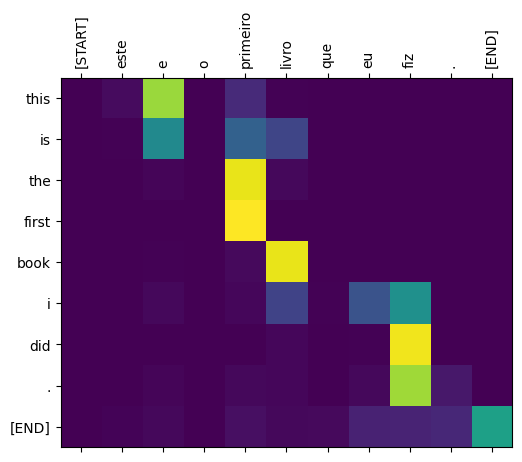

In [69]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [70]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

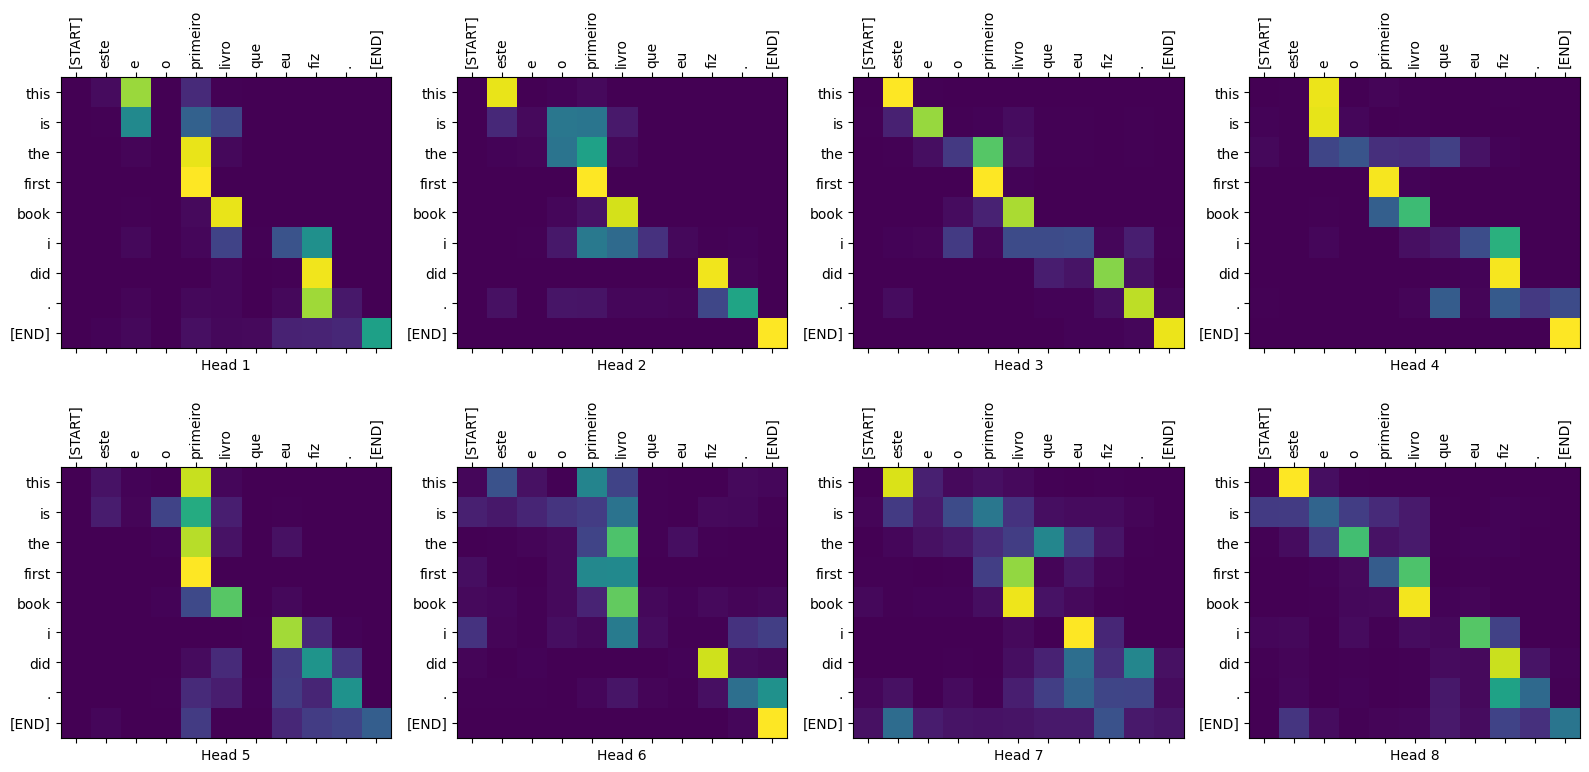

In [71]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triopholes in encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


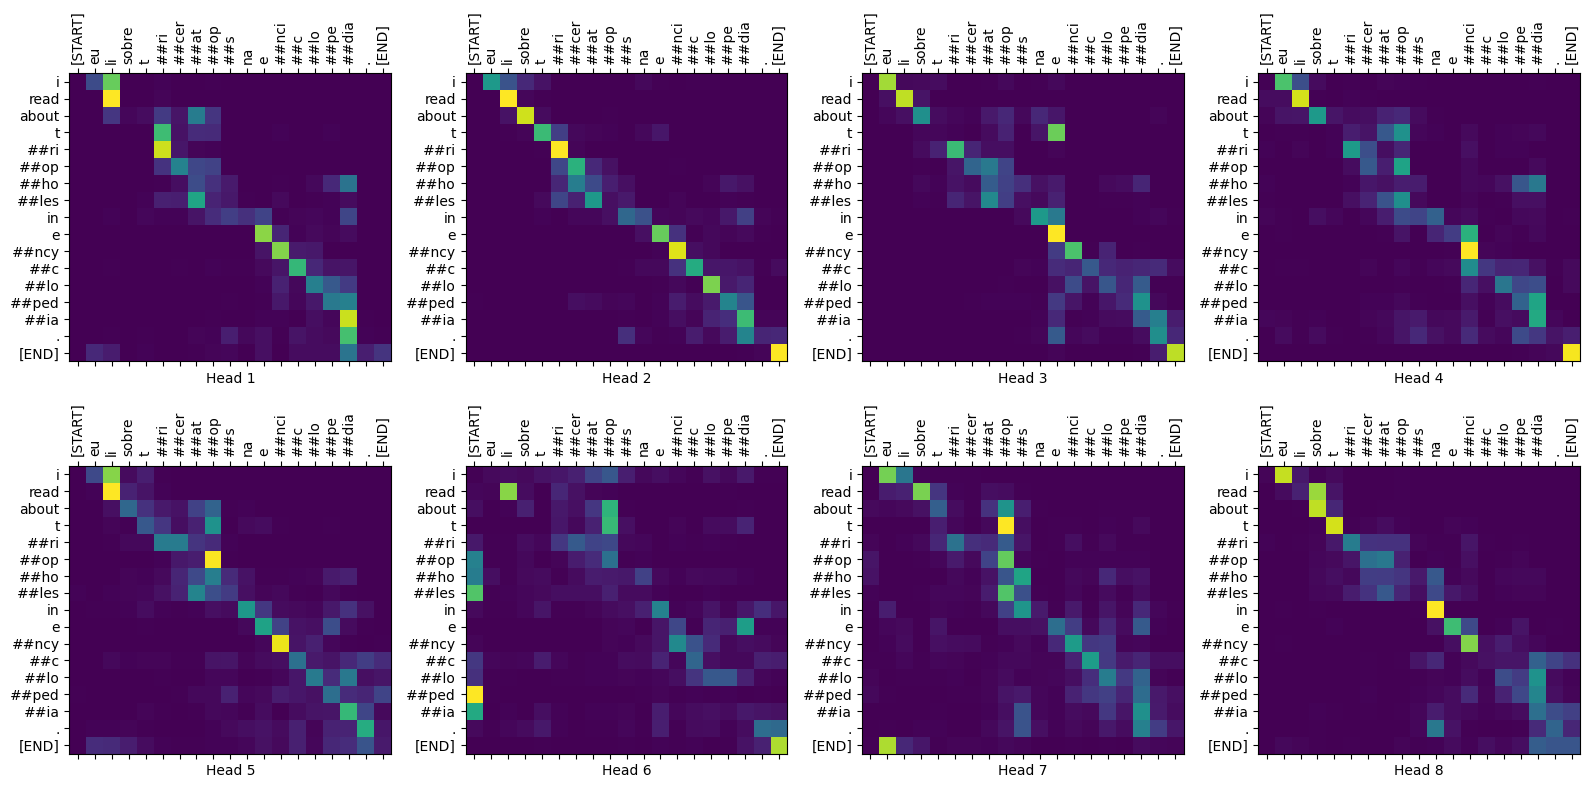

In [72]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [73]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [74]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [75]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [76]:
tf.saved_model.save(translator, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [77]:
reloaded = tf.saved_model.load('translator')

In [78]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)t beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
